# ML course : Assignment 3 ,  flowers classification with CNN using  YOLOv5
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy.io
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPool2D
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#tf.keras.mixed_precision.set_global_policy('mixed_float16')
np.random.seed(1)
tf.random.set_seed(1)

IMAGES_DIR = '/sise/home/roeiza/jpg/'
img_width, img_height = 224, 224
batch_size = 8
epochs = 15
LR=0.0001

In [2]:
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' --no-check-certificate
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' --no-check-certificate

In [3]:
!tar -xzf '102flowers.tgz'

In [36]:
mat = scipy.io.loadmat('/sise/home/roeiza/imagelabels.mat')     # read labels from a MATLAB format to Array
labels=mat['labels'].reshape(-1,1).tolist()
len(labels)

8189

In [37]:
print(min(labels),max(labels))
print(list(np.unique(np.array(labels))))

[1] [102]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [38]:
image_list= sorted(os.listdir(IMAGES_DIR))
image_list[:5]

['image_00002.jpg',
 'image_00003.jpg',
 'image_00010.jpg',
 'image_00011.jpg',
 'image_00014.jpg']

In [39]:
l=[]
y=[]
for idx,i in enumerate(image_list):
  current_idx=int(i.split('_')[1][:5])

  if idx+1 != current_idx:
    assert ('indexing of images and labels do not match ')
  current_label=labels[idx][0]    #   labels are between 1-102 will be LAbelEncoded later
  l.append([idx,i,current_label])
  y.append(current_label)

df_y=pd.DataFrame(y,columns=['label'])
num_classes=df_y['label'].nunique()
print(l[:5])
print('num_classes=',num_classes)

[[0, 'image_00002.jpg', 77], [1, 'image_00003.jpg', 77], [2, 'image_00010.jpg', 77], [3, 'image_00011.jpg', 77], [4, 'image_00014.jpg', 77]]
num_classes= 13


In [40]:
df= pd.DataFrame(l,columns=['id','filename','label'])
df.drop('id',axis=1,inplace=True)
df.to_csv('flower102_labels.csv',index=False)

# VGG

In [ ]:
# #####  verification that label and image match
target_label=102
flower102 = [i[1] for i in l if i[2]==target_label ]
print(len(flower102),'images of label',target_label,flower102)
for i in range(5):
  image_file = IMAGES_DIR + flower102[i]
  image = load_img(image_file,target_size=(img_width, img_height))
  print('label',y[i],image.width,image.height)
  plt.imshow(image)

In [ ]:
# # load all images to array
arr=[]
for i in image_list:
  image_file = IMAGES_DIR + i
  image = load_img(image_file,target_size=(img_width, img_height))
  input_arr = img_to_array(image)
  arr.append(input_arr)
X = np.array(arr)

In [9]:
# Convert labels to zero-based indexing
Y = df_y.values.flatten() - 1  # Subtracting 1 to shift from 1-based indexing to 0-based indexing

# Convert categorical labels to one-hot encoded vectors
Y_HOT = to_categorical(Y)

# Split the data into training and testing subsets
# x_ids: Input samples indices (since splitting on X crashes the notebook), Y_HOT: One-hot encoded labels matrix
x_ids = list(range(len(X)))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(x_ids, Y_HOT, stratify=Y_HOT, test_size=0.25, random_state=42, shuffle=True)
# Further split the training subset into training and validation subsets
X_train_idx, X_valid_idx, y_train, y_valid = train_test_split(X_train_idx, y_train, test_size=0.33, random_state=42, shuffle=True)

# Extracting samples from X
X_train, X_valid, X_test = [], [], []
for i in X_train_idx:
  X_train.append(X[i])
for j in X_valid_idx:
  X_valid.append(X[j])
for k in X_test_idx:
  X_test.append(X[k])

In [10]:
print('df_y',df_y.shape, df_y[-2:])
print('Y',Y.shape,Y[-2:])
print('Y_HOT',Y_HOT.shape,Y_HOT[-2:])

df_y (8189, 1)       label
8187     62
8188     62
Y (8189,) [61 61]
Y_HOT (8189, 102) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [11]:
# print(y_train[:20].argmax(axis=1))
# print(y_valid[:20].argmax(axis=1))
# print(y_test[:20].argmax(axis=1))

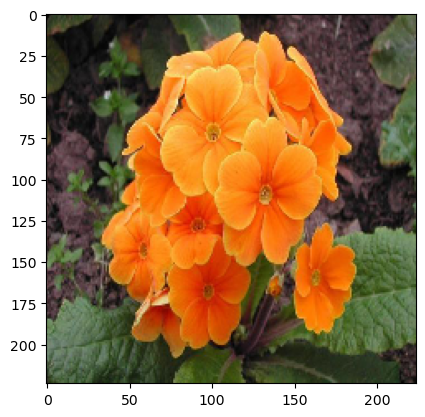

In [12]:
image=array_to_img(X_test[0])
plt.imshow(image)

In [13]:
# X_train = X_train.astype('float32') /255
# X_valid = X_valid.astype('float32') /255
# X_test = X_test.astype('float32') /255

X_test = preprocess_input(np.array(X_test))
X_valid = preprocess_input(np.array(X_valid))
X_train = preprocess_input(np.array(X_train))

print('train',X_train.shape,y_train.shape)
print('valid',X_valid.shape,y_valid.shape)
print('test',X_test.shape,y_test.shape)

train (4114, 224, 224, 3) (4114, 102)
valid (2027, 224, 224, 3) (2027, 102)
test (2048, 224, 224, 3) (2048, 102)


In [14]:
# Load the VGG19 model without the top layers (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

2023-06-20 19:03:24.322912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 19:03:24.631400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46557 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9


In [15]:
# Freeze the pre-trained layers
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# Option 1 :  No training took place....

model = Sequential([
    base_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(num_classes , activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               470118    
Total params: 20,494,502
Trainable params: 470,118
Non-trainable params: 20,024,384
_________________________________________________________________


In [22]:
# Option 2 :  training took long time, reached 0.79 accuracy after 100 epochs

# flatten the output of the convolutional part:
x = Flatten()(base_model.output)
# three hidden layers
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)

# creating the full model:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [20]:
# # Option 3 :  only final dense layer with softmax #0.76
x = Flatten()(base_model.output) #Output obtained on vgg19 is now flattened.
prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
#Creating model object
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# # # option 4 : avgpooling + 1 dense layer with RELU, yielded poor performance
# 0.8669
# Add custom top layers for flower classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='vgg.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LR),  loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001
                              )
mcp_save = ModelCheckpoint(filepath = 'best.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [19]:
tf.config.optimizer.set_jit(True)
history=model.fit(X_train, y_train, batch_size=batch_size , callbacks=[reduce_lr,mcp_save],
                  validation_data=(X_valid, y_valid), epochs=100)

2023-06-20 19:03:27.507385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-06-20 19:03:27.935636: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:03:28.703045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800


 25/515 [>.............................] - ETA: 3s - loss: 8.4864 - accuracy: 0.0100    

2023-06-20 19:03:29.945934: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-20 19:03:29.947240: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - ETA: 0s - loss: 4.8641 - accuracy: 0.1354

2023-06-20 19:03:34.864094: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:03:34.892122: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - 9s 13ms/step - loss: 4.8641 - accuracy: 0.1354 - val_loss: 3.1614 - val_accuracy: 0.3024
Epoch 2/100
515/515 [==============================] - 6s 11ms/step - loss: 2.3576 - accuracy: 0.4543 - val_loss: 2.0422 - val_accuracy: 0.5017
Epoch 3/100
515/515 [==============================] - 5s 11ms/step - loss: 1.4271 - accuracy: 0.6449 - val_loss: 1.5097 - val_accuracy: 0.6211
Epoch 4/100
515/515 [==============================] - 5s 11ms/step - loss: 0.9447 - accuracy: 0.7669 - val_loss: 1.2276 - val_accuracy: 0.6877
Epoch 5/100
515/515 [==============================] - 6s 11ms/step - loss: 0.6723 - accuracy: 0.8337 - val_loss: 1.0639 - val_accuracy: 0.7242
Epoch 6/100
515/515 [==============================] - 6s 11ms/step - loss: 0.4877 - accuracy: 0.8887 - val_loss: 0.9748 - val_accuracy: 0.7464
Epoch 7/100
515/515 [==============================] - 6s 11ms/step - loss: 0.3661 - accuracy: 0.9212 - val_loss: 0.8939 - val_accuracy: 0.7701
Epoc

In [44]:
# # reload the model (epoch) that got best accuracy
from keras.models import load_model
best_model = load_model('/sise/home/roeiza/best.hdf5')

2023-06-26 18:46:02.054810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 18:46:08.023851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10437 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [21]:
# Evaluate the model on the test data
scores = best_model.evaluate(X_test, y_test, batch_size=batch_size)
#scores = model.evaluate(test_generator.flow(X_test, y_test, batch_size=batch_size))
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

 19/256 [=>............................] - ETA: 1s - loss: 1.3750 - accuracy: 0.8553

2023-06-20 19:28:54.995363: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-06-20 19:28:55.030490: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


256/256 [==============================] - 2s 6ms/step - loss: 0.9818 - accuracy: 0.8667
Test loss: 0.9818305969238281
Test accuracy: 0.86669921875


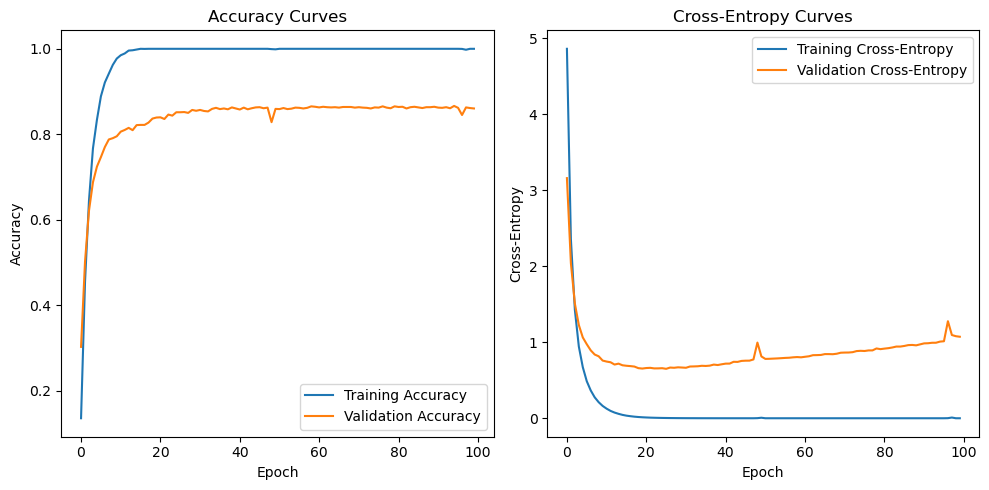

In [22]:
# from matplotlib import pyplot as plt
# Plot accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

# Plot cross-entropy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Cross-Entropy')
plt.plot(history.history['val_loss'], label='Validation Cross-Entropy')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
y_pred = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

2023-06-20 19:28:58.153675: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


Text(0.5, 23.52222222222222, 'Predicted label')

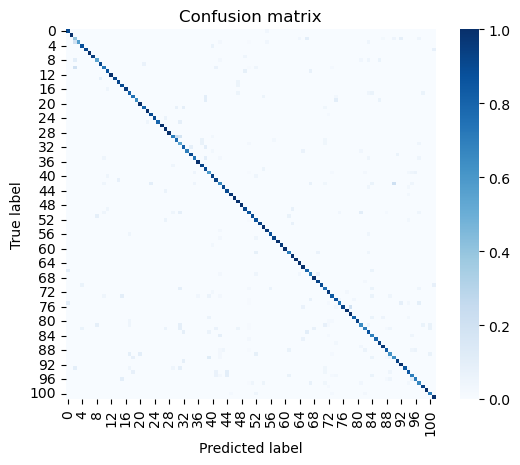

In [24]:
# # axis_labels = list(CLASSES.values())
import seaborn as sns
confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)

# Create the heatmap using seaborn
ax = sns.heatmap(confusion_normalized, cmap='Blues', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

# YOLOv5

In [25]:
########################## YOLOv5 #######################

In [47]:
list_of_labels = [str(i) for i in range(1,103)]
print(list_of_labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']


In [48]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
#%pip install -qr requirements.txt  # install

import torch
import utils
#display = utils.notebook_init()  # checks

fatal: destination path 'yolov5' already exists and is not an empty directory.
/sise/home/roeiza/yolov5/yolov5/yolov5


In [49]:
!rm -Rf 'flower102'
os.getcwd()

'/sise/home/roeiza/yolov5/yolov5/yolov5'

In [46]:
# arrange files in the corect folder structure
!mkdir '/sise/home/roeiza/yolov5/flower102'
for group in ['train','val','test']:
    new_group = '/sise/home/roeiza/yolov5/flower102/' + group
    if not os.path.exists(new_group):
        os.mkdir(new_group)
    if group in ['train', 'val']:
        for c in list_of_labels:
            new_dir = new_group + '/' + c
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)

df_source_image_list=pd.DataFrame(l,columns=['idx','source_img','label'])

df_x_train,df_x_test,df_y_train,df_y_test = train_test_split(df_source_image_list,df_y,test_size=0.25,random_state=42,shuffle=True,stratify=df_y)
df_x_train,df_x_valid,df_y_train,df_y_valid = train_test_split(df_x_train,df_y_train,test_size=0.33,random_state=42,shuffle=True,stratify=df_y_train)

print('train',df_x_train.shape,df_y_train.shape)
print('valid',df_x_valid.shape,df_y_valid.shape)
print('test',df_x_test.shape,df_y_test.shape)

mkdir: cannot create directory ‘/sise/home/roeiza/yolov5/flower102’: File exists
train (1029, 3) (1029, 1)
valid (507, 3) (507, 1)
test (512, 3) (512, 1)


In [27]:
# Create configuration
import yaml

config = {'path': '/sise/home/roeiza/yolov5/flowers102',
         'train': '/sise/home/roeiza/yolov5/flower102/train',
         'val': '/sise/home/roeiza/yolov5/flower102/valid',
         'nc': 102,
         'names': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101','102']
          }

with open("/sise/home/roeiza/data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [40]:
from tqdm import tqdm

In [44]:
import os

dfs_dict = {'train': df_x_train, 'val': df_x_valid, 'test': df_x_test}
for key in dfs_dict.keys():
    df = dfs_dict[key]
    for _, row in tqdm(df.iterrows()):
        source = IMAGES_DIR + row['source_img']
        if key == 'test':
            dest1 = '/sise/home/roeiza/yolov5/flower102/' + key + '/' + row['source_img']
        else:
            dest1 = '/sise/home/roeiza/yolov5/flower102/' + key + '/' + str(row['label']) + '/' + row['source_img']
        if os.path.exists(source):
            print('moving ' + str(row) + ' from ' + str(source) + ' to ' + str(dest1))
            !mv $source $dest1
        else:
            print(f"File not found: {source}")

0it [00:00, ?it/s]

moving idx                      7945
source_img    image_07946.jpg
label                     101
Name: 7945, dtype: object from /sise/home/roeiza/jpg/image_07946.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07946.jpg


1it [00:00,  4.60it/s]

moving idx                      7101
source_img    image_07102.jpg
label                      10
Name: 7101, dtype: object from /sise/home/roeiza/jpg/image_07102.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07102.jpg


2it [00:00,  4.76it/s]

moving idx                      8180
source_img    image_08181.jpg
label                      62
Name: 8180, dtype: object from /sise/home/roeiza/jpg/image_08181.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08181.jpg


3it [00:00,  4.92it/s]

moving idx                      7792
source_img    image_07793.jpg
label                      98
Name: 7792, dtype: object from /sise/home/roeiza/jpg/image_07793.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07793.jpg


4it [00:00,  5.19it/s]

moving idx                       855
source_img    image_00856.jpg
label                      81
Name: 855, dtype: object from /sise/home/roeiza/jpg/image_00856.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00856.jpg


5it [00:00,  5.37it/s]

moving idx                      3953
source_img    image_03954.jpg
label                      51
Name: 3953, dtype: object from /sise/home/roeiza/jpg/image_03954.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03954.jpg


6it [00:01,  4.81it/s]

moving idx                      5731
source_img    image_05732.jpg
label                      42
Name: 5731, dtype: object from /sise/home/roeiza/jpg/image_05732.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05732.jpg


7it [00:01,  5.11it/s]

moving idx                      5807
source_img    image_05808.jpg
label                      38
Name: 5807, dtype: object from /sise/home/roeiza/jpg/image_05808.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05808.jpg


8it [00:01,  4.90it/s]

moving idx                      2564
source_img    image_02565.jpg
label                      84
Name: 2564, dtype: object from /sise/home/roeiza/jpg/image_02565.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02565.jpg


9it [00:01,  4.94it/s]

moving idx                      2435
source_img    image_02436.jpg
label                      43
Name: 2435, dtype: object from /sise/home/roeiza/jpg/image_02436.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02436.jpg


10it [00:02,  4.85it/s]

moving idx                      7717
source_img    image_07718.jpg
label                      97
Name: 7717, dtype: object from /sise/home/roeiza/jpg/image_07718.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07718.jpg


11it [00:02,  5.08it/s]

moving idx                      7359
source_img    image_07360.jpg
label                      94
Name: 7359, dtype: object from /sise/home/roeiza/jpg/image_07360.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07360.jpg


12it [00:02,  5.31it/s]

moving idx                       664
source_img    image_00665.jpg
label                      89
Name: 664, dtype: object from /sise/home/roeiza/jpg/image_00665.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00665.jpg


13it [00:02,  5.16it/s]

moving idx                      5426
source_img    image_05427.jpg
label                      54
Name: 5426, dtype: object from /sise/home/roeiza/jpg/image_05427.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05427.jpg


14it [00:02,  5.32it/s]

moving idx                      5270
source_img    image_05271.jpg
label                      28
Name: 5270, dtype: object from /sise/home/roeiza/jpg/image_05271.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05271.jpg


15it [00:02,  5.48it/s]

moving idx                      6408
source_img    image_06409.jpg
label                       9
Name: 6408, dtype: object from /sise/home/roeiza/jpg/image_06409.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06409.jpg


16it [00:03,  5.56it/s]

moving idx                      6714
source_img    image_06715.jpg
label                      79
Name: 6714, dtype: object from /sise/home/roeiza/jpg/image_06715.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06715.jpg


17it [00:03,  5.61it/s]

moving idx                      3150
source_img    image_03151.jpg
label                      11
Name: 3150, dtype: object from /sise/home/roeiza/jpg/image_03151.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03151.jpg


18it [00:03,  5.62it/s]

moving idx                      5364
source_img    image_05365.jpg
label                      22
Name: 5364, dtype: object from /sise/home/roeiza/jpg/image_05365.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05365.jpg


19it [00:03,  5.51it/s]

moving idx                      8049
source_img    image_08050.jpg
label                      24
Name: 8049, dtype: object from /sise/home/roeiza/jpg/image_08050.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_08050.jpg


20it [00:03,  5.36it/s]

moving idx                      6727
source_img    image_06728.jpg
label                      79
Name: 6727, dtype: object from /sise/home/roeiza/jpg/image_06728.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06728.jpg


21it [00:04,  5.50it/s]

moving idx                       590
source_img    image_00591.jpg
label                      88
Name: 590, dtype: object from /sise/home/roeiza/jpg/image_00591.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00591.jpg


22it [00:04,  5.40it/s]

moving idx                      6182
source_img    image_06183.jpg
label                      19
Name: 6182, dtype: object from /sise/home/roeiza/jpg/image_06183.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06183.jpg


23it [00:04,  5.51it/s]

moving idx                      1930
source_img    image_01931.jpg
label                      78
Name: 1930, dtype: object from /sise/home/roeiza/jpg/image_01931.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01931.jpg


24it [00:04,  5.50it/s]

moving idx                      6615
source_img    image_06616.jpg
label                       3
Name: 6615, dtype: object from /sise/home/roeiza/jpg/image_06616.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06616.jpg


25it [00:04,  5.63it/s]

moving idx                      5499
source_img    image_05500.jpg
label                      87
Name: 5499, dtype: object from /sise/home/roeiza/jpg/image_05500.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05500.jpg


26it [00:04,  5.83it/s]

moving idx                       316
source_img    image_00317.jpg
label                      73
Name: 316, dtype: object from /sise/home/roeiza/jpg/image_00317.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00317.jpg


27it [00:05,  5.65it/s]

moving idx                      1877
source_img    image_01878.jpg
label                      78
Name: 1877, dtype: object from /sise/home/roeiza/jpg/image_01878.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01878.jpg


28it [00:05,  5.40it/s]

moving idx                      4377
source_img    image_04378.jpg
label                      36
Name: 4377, dtype: object from /sise/home/roeiza/jpg/image_04378.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04378.jpg


29it [00:05,  5.42it/s]

moving idx                       751
source_img    image_00752.jpg
label                      89
Name: 751, dtype: object from /sise/home/roeiza/jpg/image_00752.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00752.jpg


30it [00:05,  5.64it/s]

moving idx                       296
source_img    image_00297.jpg
label                      73
Name: 296, dtype: object from /sise/home/roeiza/jpg/image_00297.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00297.jpg


31it [00:05,  5.89it/s]

moving idx                      2924
source_img    image_02925.jpg
label                      60
Name: 2924, dtype: object from /sise/home/roeiza/jpg/image_02925.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02925.jpg


32it [00:05,  6.14it/s]

moving idx                      1343
source_img    image_01344.jpg
label                      51
Name: 1343, dtype: object from /sise/home/roeiza/jpg/image_01344.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01344.jpg


33it [00:06,  5.97it/s]

moving idx                      3469
source_img    image_03470.jpg
label                      30
Name: 3469, dtype: object from /sise/home/roeiza/jpg/image_03470.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03470.jpg


34it [00:06,  5.92it/s]

moving idx                       975
source_img    image_00976.jpg
label                      46
Name: 975, dtype: object from /sise/home/roeiza/jpg/image_00976.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00976.jpg


35it [00:06,  5.99it/s]

moving idx                      6305
source_img    image_06306.jpg
label                      50
Name: 6305, dtype: object from /sise/home/roeiza/jpg/image_06306.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06306.jpg


36it [00:06,  6.01it/s]

moving idx                      2048
source_img    image_02049.jpg
label                      80
Name: 2048, dtype: object from /sise/home/roeiza/jpg/image_02049.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02049.jpg


37it [00:06,  6.13it/s]

moving idx                       812
source_img    image_00813.jpg
label                      81
Name: 812, dtype: object from /sise/home/roeiza/jpg/image_00813.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00813.jpg


38it [00:06,  6.38it/s]

moving idx                      7205
source_img    image_07206.jpg
label                       7
Name: 7205, dtype: object from /sise/home/roeiza/jpg/image_07206.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07206.jpg


39it [00:07,  5.86it/s]

moving idx                        83
source_img    image_00084.jpg
label                      77
Name: 83, dtype: object from /sise/home/roeiza/jpg/image_00084.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00084.jpg


40it [00:07,  5.86it/s]

moving idx                      4173
source_img    image_04174.jpg
label                      52
Name: 4173, dtype: object from /sise/home/roeiza/jpg/image_04174.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04174.jpg


41it [00:07,  5.93it/s]

moving idx                      2625
source_img    image_02626.jpg
label                      84
Name: 2625, dtype: object from /sise/home/roeiza/jpg/image_02626.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02626.jpg


42it [00:07,  6.08it/s]

moving idx                      1220
source_img    image_01221.jpg
label                      74
Name: 1220, dtype: object from /sise/home/roeiza/jpg/image_01221.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01221.jpg


43it [00:07,  6.20it/s]

moving idx                      4387
source_img    image_04388.jpg
label                      36
Name: 4387, dtype: object from /sise/home/roeiza/jpg/image_04388.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04388.jpg


44it [00:07,  5.99it/s]

moving idx                      4528
source_img    image_04529.jpg
label                      71
Name: 4528, dtype: object from /sise/home/roeiza/jpg/image_04529.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04529.jpg


45it [00:08,  6.11it/s]

moving idx                      7376
source_img    image_07377.jpg
label                      94
Name: 7376, dtype: object from /sise/home/roeiza/jpg/image_07377.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07377.jpg


46it [00:08,  6.21it/s]

moving idx                      6243
source_img    image_06244.jpg
label                      49
Name: 6243, dtype: object from /sise/home/roeiza/jpg/image_06244.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06244.jpg


47it [00:08,  6.20it/s]

moving idx                      5440
source_img    image_05441.jpg
label                      54
Name: 5440, dtype: object from /sise/home/roeiza/jpg/image_05441.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05441.jpg


48it [00:08,  6.34it/s]

moving idx                      3721
source_img    image_03722.jpg
label                      53
Name: 3721, dtype: object from /sise/home/roeiza/jpg/image_03722.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03722.jpg


49it [00:08,  5.83it/s]

moving idx                      2349
source_img    image_02350.jpg
label                      43
Name: 2349, dtype: object from /sise/home/roeiza/jpg/image_02350.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02350.jpg


50it [00:08,  5.98it/s]

moving idx                      3220
source_img    image_03221.jpg
label                      65
Name: 3220, dtype: object from /sise/home/roeiza/jpg/image_03221.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03221.jpg


51it [00:09,  5.22it/s]

moving idx                      5665
source_img    image_05666.jpg
label                       4
Name: 5665, dtype: object from /sise/home/roeiza/jpg/image_05666.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05666.jpg


52it [00:09,  5.42it/s]

moving idx                      2653
source_img    image_02654.jpg
label                      58
Name: 2653, dtype: object from /sise/home/roeiza/jpg/image_02654.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02654.jpg


53it [00:09,  5.55it/s]

moving idx                      5326
source_img    image_05327.jpg
label                      70
Name: 5326, dtype: object from /sise/home/roeiza/jpg/image_05327.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05327.jpg


54it [00:09,  5.82it/s]

moving idx                      2536
source_img    image_02537.jpg
label                      76
Name: 2536, dtype: object from /sise/home/roeiza/jpg/image_02537.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02537.jpg


55it [00:09,  5.87it/s]

moving idx                      1315
source_img    image_01316.jpg
label                      51
Name: 1315, dtype: object from /sise/home/roeiza/jpg/image_01316.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01316.jpg


56it [00:09,  5.95it/s]

moving idx                        15
source_img    image_00016.jpg
label                      77
Name: 15, dtype: object from /sise/home/roeiza/jpg/image_00016.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00016.jpg


57it [00:10,  6.11it/s]

moving idx                      7277
source_img    image_07278.jpg
label                      62
Name: 7277, dtype: object from /sise/home/roeiza/jpg/image_07278.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_07278.jpg


58it [00:10,  6.28it/s]

moving idx                      4668
source_img    image_04669.jpg
label                      48
Name: 4668, dtype: object from /sise/home/roeiza/jpg/image_04669.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04669.jpg


59it [00:10,  6.17it/s]

moving idx                       209
source_img    image_00210.jpg
label                      77
Name: 209, dtype: object from /sise/home/roeiza/jpg/image_00210.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00210.jpg


60it [00:10,  6.31it/s]

moving idx                      4312
source_img    image_04313.jpg
label                      18
Name: 4312, dtype: object from /sise/home/roeiza/jpg/image_04313.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04313.jpg


61it [00:10,  6.02it/s]

moving idx                      2796
source_img    image_02797.jpg
label                      56
Name: 2796, dtype: object from /sise/home/roeiza/jpg/image_02797.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02797.jpg


62it [00:10,  5.88it/s]

moving idx                      6230
source_img    image_06231.jpg
label                      49
Name: 6230, dtype: object from /sise/home/roeiza/jpg/image_06231.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06231.jpg


63it [00:11,  6.02it/s]

moving idx                      5914
source_img    image_05915.jpg
label                      68
Name: 5914, dtype: object from /sise/home/roeiza/jpg/image_05915.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05915.jpg


64it [00:11,  5.90it/s]

moving idx                      2343
source_img    image_02344.jpg
label                      43
Name: 2343, dtype: object from /sise/home/roeiza/jpg/image_02344.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02344.jpg


65it [00:11,  6.01it/s]

moving idx                      3780
source_img    image_03781.jpg
label                      37
Name: 3780, dtype: object from /sise/home/roeiza/jpg/image_03781.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03781.jpg


66it [00:11,  5.86it/s]

moving idx                      7748
source_img    image_07749.jpg
label                      97
Name: 7748, dtype: object from /sise/home/roeiza/jpg/image_07749.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07749.jpg


67it [00:11,  5.95it/s]

moving idx                      7194
source_img    image_07195.jpg
label                       6
Name: 7194, dtype: object from /sise/home/roeiza/jpg/image_07195.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07195.jpg


68it [00:11,  6.03it/s]

moving idx                      2510
source_img    image_02511.jpg
label                      76
Name: 2510, dtype: object from /sise/home/roeiza/jpg/image_02511.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02511.jpg


69it [00:12,  6.15it/s]

moving idx                      1710
source_img    image_01711.jpg
label                      83
Name: 1710, dtype: object from /sise/home/roeiza/jpg/image_01711.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01711.jpg


70it [00:12,  5.96it/s]

moving idx                      4497
source_img    image_04498.jpg
label                      71
Name: 4497, dtype: object from /sise/home/roeiza/jpg/image_04498.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04498.jpg


71it [00:12,  6.00it/s]

moving idx                      1266
source_img    image_01267.jpg
label                      74
Name: 1266, dtype: object from /sise/home/roeiza/jpg/image_01267.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01267.jpg


72it [00:12,  5.74it/s]

moving idx                      7431
source_img    image_07432.jpg
label                      94
Name: 7431, dtype: object from /sise/home/roeiza/jpg/image_07432.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07432.jpg


73it [00:12,  5.96it/s]

moving idx                      7948
source_img    image_07949.jpg
label                     101
Name: 7948, dtype: object from /sise/home/roeiza/jpg/image_07949.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07949.jpg


74it [00:12,  6.02it/s]

moving idx                      7255
source_img    image_07256.jpg
label                      57
Name: 7255, dtype: object from /sise/home/roeiza/jpg/image_07256.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07256.jpg


75it [00:13,  5.98it/s]

moving idx                       227
source_img    image_00228.jpg
label                      77
Name: 227, dtype: object from /sise/home/roeiza/jpg/image_00228.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00228.jpg


76it [00:13,  5.89it/s]

moving idx                      1542
source_img    image_01543.jpg
label                      44
Name: 1542, dtype: object from /sise/home/roeiza/jpg/image_01543.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01543.jpg


77it [00:13,  5.83it/s]

moving idx                      3878
source_img    image_03879.jpg
label                      17
Name: 3878, dtype: object from /sise/home/roeiza/jpg/image_03879.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03879.jpg


78it [00:13,  5.80it/s]

moving idx                      6455
source_img    image_06456.jpg
label                      33
Name: 6455, dtype: object from /sise/home/roeiza/jpg/image_06456.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06456.jpg


79it [00:13,  5.88it/s]

moving idx                      6093
source_img    image_06094.jpg
label                      14
Name: 6093, dtype: object from /sise/home/roeiza/jpg/image_06094.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06094.jpg


80it [00:14,  5.38it/s]

moving idx                      4517
source_img    image_04518.jpg
label                      71
Name: 4517, dtype: object from /sise/home/roeiza/jpg/image_04518.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04518.jpg


81it [00:14,  5.67it/s]

moving idx                      2143
source_img    image_02144.jpg
label                      75
Name: 2143, dtype: object from /sise/home/roeiza/jpg/image_02144.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02144.jpg


82it [00:14,  5.83it/s]

moving idx                      6351
source_img    image_06352.jpg
label                      15
Name: 6351, dtype: object from /sise/home/roeiza/jpg/image_06352.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06352.jpg


83it [00:14,  5.74it/s]

moving idx                      1002
source_img    image_01003.jpg
label                      46
Name: 1002, dtype: object from /sise/home/roeiza/jpg/image_01003.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01003.jpg


84it [00:14,  5.90it/s]

moving idx                      4562
source_img    image_04563.jpg
label                      40
Name: 4562, dtype: object from /sise/home/roeiza/jpg/image_04563.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04563.jpg


85it [00:14,  5.98it/s]

moving idx                      2035
source_img    image_02036.jpg
label                      80
Name: 2035, dtype: object from /sise/home/roeiza/jpg/image_02036.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02036.jpg


86it [00:15,  6.13it/s]

moving idx                      5143
source_img    image_05144.jpg
label                       2
Name: 5143, dtype: object from /sise/home/roeiza/jpg/image_05144.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05144.jpg


87it [00:15,  6.00it/s]

moving idx                      1795
source_img    image_01796.jpg
label                      83
Name: 1795, dtype: object from /sise/home/roeiza/jpg/image_01796.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01796.jpg


88it [00:15,  6.10it/s]

moving idx                      2691
source_img    image_02692.jpg
label                      58
Name: 2691, dtype: object from /sise/home/roeiza/jpg/image_02692.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02692.jpg


89it [00:15,  6.18it/s]

moving idx                       340
source_img    image_00341.jpg
label                      73
Name: 340, dtype: object from /sise/home/roeiza/jpg/image_00341.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00341.jpg


90it [00:15,  6.26it/s]

moving idx                      1573
source_img    image_01574.jpg
label                      44
Name: 1573, dtype: object from /sise/home/roeiza/jpg/image_01574.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01574.jpg


91it [00:15,  6.27it/s]

moving idx                      6497
source_img    image_06498.jpg
label                      26
Name: 6497, dtype: object from /sise/home/roeiza/jpg/image_06498.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06498.jpg


92it [00:15,  6.14it/s]

moving idx                      1259
source_img    image_01260.jpg
label                      74
Name: 1259, dtype: object from /sise/home/roeiza/jpg/image_01260.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01260.jpg


93it [00:16,  6.10it/s]

moving idx                      7178
source_img    image_07179.jpg
label                       6
Name: 7178, dtype: object from /sise/home/roeiza/jpg/image_07179.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07179.jpg


94it [00:16,  6.10it/s]

moving idx                      6899
source_img    image_06900.jpg
label                      31
Name: 6899, dtype: object from /sise/home/roeiza/jpg/image_06900.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06900.jpg


95it [00:16,  5.95it/s]

moving idx                      3833
source_img    image_03834.jpg
label                      17
Name: 3833, dtype: object from /sise/home/roeiza/jpg/image_03834.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03834.jpg


96it [00:16,  6.11it/s]

moving idx                      6677
source_img    image_06678.jpg
label                      16
Name: 6677, dtype: object from /sise/home/roeiza/jpg/image_06678.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06678.jpg


97it [00:16,  6.25it/s]

moving idx                      4576
source_img    image_04577.jpg
label                      40
Name: 4576, dtype: object from /sise/home/roeiza/jpg/image_04577.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04577.jpg


98it [00:16,  6.25it/s]

moving idx                      2169
source_img    image_02170.jpg
label                      75
Name: 2169, dtype: object from /sise/home/roeiza/jpg/image_02170.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02170.jpg


99it [00:17,  6.39it/s]

moving idx                      5457
source_img    image_05458.jpg
label                      54
Name: 5457, dtype: object from /sise/home/roeiza/jpg/image_05458.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05458.jpg


100it [00:17,  6.43it/s]

moving idx                      2543
source_img    image_02544.jpg
label                      76
Name: 2543, dtype: object from /sise/home/roeiza/jpg/image_02544.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02544.jpg


101it [00:17,  6.36it/s]

moving idx                      7843
source_img    image_07844.jpg
label                      99
Name: 7843, dtype: object from /sise/home/roeiza/jpg/image_07844.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07844.jpg


102it [00:17,  6.36it/s]

moving idx                      2497
source_img    image_02498.jpg
label                      76
Name: 2497, dtype: object from /sise/home/roeiza/jpg/image_02498.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02498.jpg


103it [00:17,  6.43it/s]

moving idx                       810
source_img    image_00811.jpg
label                      81
Name: 810, dtype: object from /sise/home/roeiza/jpg/image_00811.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00811.jpg


104it [00:17,  6.32it/s]

moving idx                       313
source_img    image_00314.jpg
label                      73
Name: 313, dtype: object from /sise/home/roeiza/jpg/image_00314.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00314.jpg


105it [00:18,  6.24it/s]

moving idx                      3682
source_img    image_03683.jpg
label                      53
Name: 3682, dtype: object from /sise/home/roeiza/jpg/image_03683.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03683.jpg


106it [00:18,  6.27it/s]

moving idx                      5198
source_img    image_05199.jpg
label                       5
Name: 5198, dtype: object from /sise/home/roeiza/jpg/image_05199.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05199.jpg


107it [00:18,  5.99it/s]

moving idx                      2434
source_img    image_02435.jpg
label                      43
Name: 2434, dtype: object from /sise/home/roeiza/jpg/image_02435.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02435.jpg


108it [00:18,  6.09it/s]

moving idx                      6955
source_img    image_06956.jpg
label                      34
Name: 6955, dtype: object from /sise/home/roeiza/jpg/image_06956.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06956.jpg


109it [00:18,  6.06it/s]

moving idx                      6169
source_img    image_06170.jpg
label                      19
Name: 6169, dtype: object from /sise/home/roeiza/jpg/image_06170.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06170.jpg


110it [00:18,  6.05it/s]

moving idx                      7134
source_img    image_07135.jpg
label                      45
Name: 7134, dtype: object from /sise/home/roeiza/jpg/image_07135.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07135.jpg


111it [00:19,  6.12it/s]

moving idx                      3170
source_img    image_03171.jpg
label                      11
Name: 3170, dtype: object from /sise/home/roeiza/jpg/image_03171.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03171.jpg


112it [00:19,  6.06it/s]

moving idx                      3730
source_img    image_03731.jpg
label                      53
Name: 3730, dtype: object from /sise/home/roeiza/jpg/image_03731.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03731.jpg


113it [00:19,  6.09it/s]

moving idx                      4259
source_img    image_04260.jpg
label                      18
Name: 4259, dtype: object from /sise/home/roeiza/jpg/image_04260.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04260.jpg


114it [00:19,  6.19it/s]

moving idx                      6207
source_img    image_06208.jpg
label                      49
Name: 6207, dtype: object from /sise/home/roeiza/jpg/image_06208.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06208.jpg


115it [00:19,  6.24it/s]

moving idx                      5700
source_img    image_05701.jpg
label                      42
Name: 5700, dtype: object from /sise/home/roeiza/jpg/image_05701.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05701.jpg


116it [00:19,  6.38it/s]

moving idx                       281
source_img    image_00282.jpg
label                      73
Name: 281, dtype: object from /sise/home/roeiza/jpg/image_00282.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00282.jpg


117it [00:19,  6.51it/s]

moving idx                      3161
source_img    image_03162.jpg
label                      11
Name: 3161, dtype: object from /sise/home/roeiza/jpg/image_03162.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03162.jpg


118it [00:20,  6.43it/s]

moving idx                       991
source_img    image_00992.jpg
label                      46
Name: 991, dtype: object from /sise/home/roeiza/jpg/image_00992.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00992.jpg


119it [00:20,  6.48it/s]

moving idx                      7333
source_img    image_07334.jpg
label                      94
Name: 7333, dtype: object from /sise/home/roeiza/jpg/image_07334.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07334.jpg


120it [00:20,  6.39it/s]

moving idx                      6026
source_img    image_06027.jpg
label                      93
Name: 6026, dtype: object from /sise/home/roeiza/jpg/image_06027.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06027.jpg


121it [00:20,  6.10it/s]

moving idx                      6596
source_img    image_06597.jpg
label                      25
Name: 6596, dtype: object from /sise/home/roeiza/jpg/image_06597.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06597.jpg


122it [00:20,  6.21it/s]

moving idx                      3062
source_img    image_03063.jpg
label                      92
Name: 3062, dtype: object from /sise/home/roeiza/jpg/image_03063.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03063.jpg


123it [00:20,  6.10it/s]

moving idx                      7053
source_img    image_07054.jpg
label                      67
Name: 7053, dtype: object from /sise/home/roeiza/jpg/image_07054.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07054.jpg


124it [00:21,  6.09it/s]

moving idx                      2544
source_img    image_02545.jpg
label                      76
Name: 2544, dtype: object from /sise/home/roeiza/jpg/image_02545.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02545.jpg


125it [00:21,  6.26it/s]

moving idx                      6320
source_img    image_06321.jpg
label                      50
Name: 6320, dtype: object from /sise/home/roeiza/jpg/image_06321.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06321.jpg


126it [00:21,  6.35it/s]

moving idx                      6041
source_img    image_06042.jpg
label                      93
Name: 6041, dtype: object from /sise/home/roeiza/jpg/image_06042.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06042.jpg


127it [00:21,  6.35it/s]

moving idx                      7808
source_img    image_07809.jpg
label                      98
Name: 7808, dtype: object from /sise/home/roeiza/jpg/image_07809.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07809.jpg


128it [00:21,  6.42it/s]

moving idx                      7422
source_img    image_07423.jpg
label                      94
Name: 7422, dtype: object from /sise/home/roeiza/jpg/image_07423.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07423.jpg


129it [00:21,  6.42it/s]

moving idx                       677
source_img    image_00678.jpg
label                      89
Name: 677, dtype: object from /sise/home/roeiza/jpg/image_00678.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00678.jpg


130it [00:22,  6.38it/s]

moving idx                      1713
source_img    image_01714.jpg
label                      83
Name: 1713, dtype: object from /sise/home/roeiza/jpg/image_01714.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01714.jpg


131it [00:22,  6.43it/s]

moving idx                         3
source_img    image_00004.jpg
label                      77
Name: 3, dtype: object from /sise/home/roeiza/jpg/image_00004.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00004.jpg


132it [00:22,  6.41it/s]

moving idx                      7509
source_img    image_07510.jpg
label                      95
Name: 7509, dtype: object from /sise/home/roeiza/jpg/image_07510.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07510.jpg


133it [00:22,  6.16it/s]

moving idx                       920
source_img    image_00921.jpg
label                      81
Name: 920, dtype: object from /sise/home/roeiza/jpg/image_00921.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00921.jpg


134it [00:22,  6.30it/s]

moving idx                       911
source_img    image_00912.jpg
label                      81
Name: 911, dtype: object from /sise/home/roeiza/jpg/image_00912.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00912.jpg


135it [00:22,  6.40it/s]

moving idx                      5547
source_img    image_05548.jpg
label                      66
Name: 5547, dtype: object from /sise/home/roeiza/jpg/image_05548.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05548.jpg


136it [00:22,  6.51it/s]

moving idx                       533
source_img    image_00534.jpg
label                      88
Name: 533, dtype: object from /sise/home/roeiza/jpg/image_00534.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00534.jpg


137it [00:23,  6.61it/s]

moving idx                      7816
source_img    image_07817.jpg
label                      98
Name: 7816, dtype: object from /sise/home/roeiza/jpg/image_07817.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07817.jpg


138it [00:23,  6.66it/s]

moving idx                       823
source_img    image_00824.jpg
label                      81
Name: 823, dtype: object from /sise/home/roeiza/jpg/image_00824.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00824.jpg


139it [00:23,  6.70it/s]

moving idx                      6894
source_img    image_06895.jpg
label                      31
Name: 6894, dtype: object from /sise/home/roeiza/jpg/image_06895.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06895.jpg


140it [00:23,  6.59it/s]

moving idx                      7505
source_img    image_07506.jpg
label                      95
Name: 7505, dtype: object from /sise/home/roeiza/jpg/image_07506.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07506.jpg


141it [00:23,  6.47it/s]

moving idx                      1952
source_img    image_01953.jpg
label                      78
Name: 1952, dtype: object from /sise/home/roeiza/jpg/image_01953.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01953.jpg


142it [00:23,  6.40it/s]

moving idx                      5450
source_img    image_05451.jpg
label                      54
Name: 5450, dtype: object from /sise/home/roeiza/jpg/image_05451.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05451.jpg


143it [00:24,  6.41it/s]

moving idx                      2306
source_img    image_02307.jpg
label                      41
Name: 2306, dtype: object from /sise/home/roeiza/jpg/image_02307.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02307.jpg


144it [00:24,  6.34it/s]

moving idx                      4125
source_img    image_04126.jpg
label                      29
Name: 4125, dtype: object from /sise/home/roeiza/jpg/image_04126.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04126.jpg


145it [00:24,  6.17it/s]

moving idx                      3705
source_img    image_03706.jpg
label                      53
Name: 3705, dtype: object from /sise/home/roeiza/jpg/image_03706.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03706.jpg


146it [00:24,  6.20it/s]

moving idx                      2920
source_img    image_02921.jpg
label                      60
Name: 2920, dtype: object from /sise/home/roeiza/jpg/image_02921.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02921.jpg


147it [00:24,  6.31it/s]

moving idx                      2722
source_img    image_02723.jpg
label                      58
Name: 2722, dtype: object from /sise/home/roeiza/jpg/image_02723.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02723.jpg


148it [00:24,  6.24it/s]

moving idx                      6883
source_img    image_06884.jpg
label                      27
Name: 6883, dtype: object from /sise/home/roeiza/jpg/image_06884.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06884.jpg


149it [00:25,  6.44it/s]

moving idx                      6696
source_img    image_06697.jpg
label                      79
Name: 6696, dtype: object from /sise/home/roeiza/jpg/image_06697.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06697.jpg


150it [00:25,  6.56it/s]

moving idx                       813
source_img    image_00814.jpg
label                      81
Name: 813, dtype: object from /sise/home/roeiza/jpg/image_00814.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00814.jpg


151it [00:25,  6.61it/s]

moving idx                      2315
source_img    image_02316.jpg
label                      43
Name: 2315, dtype: object from /sise/home/roeiza/jpg/image_02316.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02316.jpg


152it [00:25,  6.70it/s]

moving idx                      3280
source_img    image_03281.jpg
label                      65
Name: 3280, dtype: object from /sise/home/roeiza/jpg/image_03281.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03281.jpg


153it [00:25,  6.70it/s]

moving idx                      7472
source_img    image_07473.jpg
label                      95
Name: 7472, dtype: object from /sise/home/roeiza/jpg/image_07473.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07473.jpg


154it [00:25,  6.69it/s]

moving idx                      5515
source_img    image_05516.jpg
label                      87
Name: 5515, dtype: object from /sise/home/roeiza/jpg/image_05516.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05516.jpg


155it [00:25,  6.70it/s]

moving idx                      3287
source_img    image_03288.jpg
label                       8
Name: 3287, dtype: object from /sise/home/roeiza/jpg/image_03288.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03288.jpg


156it [00:26,  6.55it/s]

moving idx                      1607
source_img    image_01608.jpg
label                      82
Name: 1607, dtype: object from /sise/home/roeiza/jpg/image_01608.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01608.jpg


157it [00:26,  6.42it/s]

moving idx                      6413
source_img    image_06414.jpg
label                       9
Name: 6413, dtype: object from /sise/home/roeiza/jpg/image_06414.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06414.jpg


158it [00:26,  6.47it/s]

moving idx                      3680
source_img    image_03681.jpg
label                      53
Name: 3680, dtype: object from /sise/home/roeiza/jpg/image_03681.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03681.jpg


159it [00:26,  6.56it/s]

moving idx                      7977
source_img    image_07978.jpg
label                     101
Name: 7977, dtype: object from /sise/home/roeiza/jpg/image_07978.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07978.jpg


160it [00:26,  6.50it/s]

moving idx                      8017
source_img    image_08018.jpg
label                     102
Name: 8017, dtype: object from /sise/home/roeiza/jpg/image_08018.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08018.jpg


161it [00:26,  6.31it/s]

moving idx                      6797
source_img    image_06798.jpg
label                      21
Name: 6797, dtype: object from /sise/home/roeiza/jpg/image_06798.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06798.jpg


162it [00:27,  6.28it/s]

moving idx                      3784
source_img    image_03785.jpg
label                      37
Name: 3784, dtype: object from /sise/home/roeiza/jpg/image_03785.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03785.jpg


163it [00:27,  6.41it/s]

moving idx                      2045
source_img    image_02046.jpg
label                      80
Name: 2045, dtype: object from /sise/home/roeiza/jpg/image_02046.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02046.jpg


164it [00:27,  6.37it/s]

moving idx                      5284
source_img    image_05285.jpg
label                      70
Name: 5284, dtype: object from /sise/home/roeiza/jpg/image_05285.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05285.jpg


165it [00:27,  6.35it/s]

moving idx                      1727
source_img    image_01728.jpg
label                      83
Name: 1727, dtype: object from /sise/home/roeiza/jpg/image_01728.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01728.jpg


166it [00:27,  6.35it/s]

moving idx                      4166
source_img    image_04167.jpg
label                      52
Name: 4166, dtype: object from /sise/home/roeiza/jpg/image_04167.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04167.jpg


167it [00:27,  6.45it/s]

moving idx                      6844
source_img    image_06845.jpg
label                      24
Name: 6844, dtype: object from /sise/home/roeiza/jpg/image_06845.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06845.jpg


168it [00:27,  6.60it/s]

moving idx                      6808
source_img    image_06809.jpg
label                      21
Name: 6808, dtype: object from /sise/home/roeiza/jpg/image_06809.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06809.jpg


169it [00:28,  6.67it/s]

moving idx                      5821
source_img    image_05822.jpg
label                      38
Name: 5821, dtype: object from /sise/home/roeiza/jpg/image_05822.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05822.jpg


170it [00:28,  6.73it/s]

moving idx                      4600
source_img    image_04601.jpg
label                      40
Name: 4600, dtype: object from /sise/home/roeiza/jpg/image_04601.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04601.jpg


171it [00:28,  6.13it/s]

moving idx                      6273
source_img    image_06274.jpg
label                      61
Name: 6273, dtype: object from /sise/home/roeiza/jpg/image_06274.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06274.jpg


172it [00:28,  4.60it/s]

moving idx                      1656
source_img    image_01657.jpg
label                      82
Name: 1656, dtype: object from /sise/home/roeiza/jpg/image_01657.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01657.jpg


173it [00:28,  4.97it/s]

moving idx                      7793
source_img    image_07794.jpg
label                      98
Name: 7793, dtype: object from /sise/home/roeiza/jpg/image_07794.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07794.jpg


174it [00:29,  5.28it/s]

moving idx                      6161
source_img    image_06162.jpg
label                      19
Name: 6161, dtype: object from /sise/home/roeiza/jpg/image_06162.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06162.jpg


175it [00:29,  5.52it/s]

moving idx                      2733
source_img    image_02734.jpg
label                      58
Name: 2733, dtype: object from /sise/home/roeiza/jpg/image_02734.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02734.jpg


176it [00:29,  5.72it/s]

moving idx                      3441
source_img    image_03442.jpg
label                      23
Name: 3441, dtype: object from /sise/home/roeiza/jpg/image_03442.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03442.jpg


177it [00:29,  5.77it/s]

moving idx                      5596
source_img    image_05597.jpg
label                      32
Name: 5596, dtype: object from /sise/home/roeiza/jpg/image_05597.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05597.jpg


178it [00:29,  5.77it/s]

moving idx                      4558
source_img    image_04559.jpg
label                      40
Name: 4558, dtype: object from /sise/home/roeiza/jpg/image_04559.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04559.jpg


179it [00:29,  6.07it/s]

moving idx                      1341
source_img    image_01342.jpg
label                      51
Name: 1341, dtype: object from /sise/home/roeiza/jpg/image_01342.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01342.jpg


180it [00:30,  6.26it/s]

moving idx                      6387
source_img    image_06388.jpg
label                      15
Name: 6387, dtype: object from /sise/home/roeiza/jpg/image_06388.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06388.jpg


181it [00:30,  6.22it/s]

moving idx                      8102
source_img    image_08103.jpg
label                       7
Name: 8102, dtype: object from /sise/home/roeiza/jpg/image_08103.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_08103.jpg


182it [00:30,  6.19it/s]

moving idx                      5898
source_img    image_05899.jpg
label                      63
Name: 5898, dtype: object from /sise/home/roeiza/jpg/image_05899.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05899.jpg


183it [00:30,  6.03it/s]

moving idx                      7283
source_img    image_07284.jpg
label                      89
Name: 7283, dtype: object from /sise/home/roeiza/jpg/image_07284.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_07284.jpg


184it [00:30,  6.10it/s]

moving idx                      7340
source_img    image_07341.jpg
label                      94
Name: 7340, dtype: object from /sise/home/roeiza/jpg/image_07341.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07341.jpg


185it [00:30,  6.29it/s]

moving idx                      7802
source_img    image_07803.jpg
label                      98
Name: 7802, dtype: object from /sise/home/roeiza/jpg/image_07803.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07803.jpg


186it [00:31,  6.40it/s]

moving idx                      1082
source_img    image_01083.jpg
label                      46
Name: 1082, dtype: object from /sise/home/roeiza/jpg/image_01083.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01083.jpg


187it [00:31,  6.53it/s]

moving idx                      7942
source_img    image_07943.jpg
label                     101
Name: 7942, dtype: object from /sise/home/roeiza/jpg/image_07943.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07943.jpg


188it [00:31,  6.57it/s]

moving idx                       824
source_img    image_00825.jpg
label                      81
Name: 824, dtype: object from /sise/home/roeiza/jpg/image_00825.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00825.jpg


189it [00:31,  6.56it/s]

moving idx                      3603
source_img    image_03604.jpg
label                      72
Name: 3603, dtype: object from /sise/home/roeiza/jpg/image_03604.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03604.jpg


190it [00:31,  6.36it/s]

moving idx                      4888
source_img    image_04889.jpg
label                      91
Name: 4888, dtype: object from /sise/home/roeiza/jpg/image_04889.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04889.jpg


191it [00:31,  6.19it/s]

moving idx                      2286
source_img    image_02287.jpg
label                      41
Name: 2286, dtype: object from /sise/home/roeiza/jpg/image_02287.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02287.jpg


192it [00:31,  6.33it/s]

moving idx                      1181
source_img    image_01182.jpg
label                      74
Name: 1181, dtype: object from /sise/home/roeiza/jpg/image_01182.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01182.jpg


193it [00:32,  6.36it/s]

moving idx                      8013
source_img    image_08014.jpg
label                     102
Name: 8013, dtype: object from /sise/home/roeiza/jpg/image_08014.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08014.jpg


194it [00:32,  6.39it/s]

moving idx                      2428
source_img    image_02429.jpg
label                      43
Name: 2428, dtype: object from /sise/home/roeiza/jpg/image_02429.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02429.jpg


195it [00:32,  6.48it/s]

moving idx                      7356
source_img    image_07357.jpg
label                      94
Name: 7356, dtype: object from /sise/home/roeiza/jpg/image_07357.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07357.jpg


196it [00:32,  6.40it/s]

moving idx                      4831
source_img    image_04832.jpg
label                      91
Name: 4831, dtype: object from /sise/home/roeiza/jpg/image_04832.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04832.jpg


197it [00:32,  6.42it/s]

moving idx                      5127
source_img    image_05128.jpg
label                       2
Name: 5127, dtype: object from /sise/home/roeiza/jpg/image_05128.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05128.jpg


198it [00:32,  6.47it/s]

moving idx                      3885
source_img    image_03886.jpg
label                      17
Name: 3885, dtype: object from /sise/home/roeiza/jpg/image_03886.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03886.jpg


199it [00:33,  6.48it/s]

moving idx                      1359
source_img    image_01360.jpg
label                      51
Name: 1359, dtype: object from /sise/home/roeiza/jpg/image_01360.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01360.jpg


200it [00:33,  6.57it/s]

moving idx                      3348
source_img    image_03349.jpg
label                       8
Name: 3348, dtype: object from /sise/home/roeiza/jpg/image_03349.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03349.jpg


201it [00:33,  6.45it/s]

moving idx                      6201
source_img    image_06202.jpg
label                      49
Name: 6201, dtype: object from /sise/home/roeiza/jpg/image_06202.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06202.jpg


202it [00:33,  6.41it/s]

moving idx                      7051
source_img    image_07052.jpg
label                      67
Name: 7051, dtype: object from /sise/home/roeiza/jpg/image_07052.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07052.jpg


203it [00:33,  6.49it/s]

moving idx                      3932
source_img    image_03933.jpg
label                      51
Name: 3932, dtype: object from /sise/home/roeiza/jpg/image_03933.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03933.jpg


204it [00:33,  6.46it/s]

moving idx                      7737
source_img    image_07738.jpg
label                      97
Name: 7737, dtype: object from /sise/home/roeiza/jpg/image_07738.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07738.jpg


205it [00:33,  6.36it/s]

moving idx                      3875
source_img    image_03876.jpg
label                      17
Name: 3875, dtype: object from /sise/home/roeiza/jpg/image_03876.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03876.jpg


206it [00:34,  6.30it/s]

moving idx                      4482
source_img    image_04483.jpg
label                      71
Name: 4482, dtype: object from /sise/home/roeiza/jpg/image_04483.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04483.jpg


207it [00:34,  6.33it/s]

moving idx                      4570
source_img    image_04571.jpg
label                      40
Name: 4570, dtype: object from /sise/home/roeiza/jpg/image_04571.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04571.jpg


208it [00:34,  6.46it/s]

moving idx                      2844
source_img    image_02845.jpg
label                      56
Name: 2844, dtype: object from /sise/home/roeiza/jpg/image_02845.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02845.jpg


209it [00:34,  6.53it/s]

moving idx                      4246
source_img    image_04247.jpg
label                      18
Name: 4246, dtype: object from /sise/home/roeiza/jpg/image_04247.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04247.jpg


210it [00:34,  6.63it/s]

moving idx                       746
source_img    image_00747.jpg
label                      89
Name: 746, dtype: object from /sise/home/roeiza/jpg/image_00747.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00747.jpg


211it [00:34,  6.62it/s]

moving idx                      1446
source_img    image_01447.jpg
label                      51
Name: 1446, dtype: object from /sise/home/roeiza/jpg/image_01447.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01447.jpg


212it [00:35,  6.66it/s]

moving idx                      4077
source_img    image_04078.jpg
label                      12
Name: 4077, dtype: object from /sise/home/roeiza/jpg/image_04078.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04078.jpg


213it [00:35,  6.51it/s]

moving idx                      1231
source_img    image_01232.jpg
label                      74
Name: 1231, dtype: object from /sise/home/roeiza/jpg/image_01232.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01232.jpg


214it [00:35,  6.32it/s]

moving idx                      2484
source_img    image_02485.jpg
label                      76
Name: 2484, dtype: object from /sise/home/roeiza/jpg/image_02485.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02485.jpg


215it [00:35,  6.25it/s]

moving idx                      7033
source_img    image_07034.jpg
label                      39
Name: 7033, dtype: object from /sise/home/roeiza/jpg/image_07034.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07034.jpg


216it [00:35,  6.14it/s]

moving idx                       738
source_img    image_00739.jpg
label                      89
Name: 738, dtype: object from /sise/home/roeiza/jpg/image_00739.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00739.jpg


217it [00:35,  6.30it/s]

moving idx                       341
source_img    image_00342.jpg
label                      73
Name: 341, dtype: object from /sise/home/roeiza/jpg/image_00342.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00342.jpg


218it [00:35,  6.40it/s]

moving idx                      5494
source_img    image_05495.jpg
label                      87
Name: 5494, dtype: object from /sise/home/roeiza/jpg/image_05495.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05495.jpg


219it [00:36,  6.38it/s]

moving idx                      7842
source_img    image_07843.jpg
label                      99
Name: 7842, dtype: object from /sise/home/roeiza/jpg/image_07843.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07843.jpg


220it [00:36,  6.37it/s]

moving idx                      2198
source_img    image_02199.jpg
label                      41
Name: 2198, dtype: object from /sise/home/roeiza/jpg/image_02199.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02199.jpg


221it [00:36,  6.50it/s]

moving idx                      4044
source_img    image_04045.jpg
label                      12
Name: 4044, dtype: object from /sise/home/roeiza/jpg/image_04045.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04045.jpg


222it [00:36,  6.42it/s]

moving idx                      6143
source_img    image_06144.jpg
label                      64
Name: 6143, dtype: object from /sise/home/roeiza/jpg/image_06144.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06144.jpg


223it [00:36,  6.25it/s]

moving idx                      3785
source_img    image_03786.jpg
label                      37
Name: 3785, dtype: object from /sise/home/roeiza/jpg/image_03786.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03786.jpg


224it [00:36,  6.22it/s]

moving idx                       653
source_img    image_00654.jpg
label                      89
Name: 653, dtype: object from /sise/home/roeiza/jpg/image_00654.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00654.jpg


225it [00:37,  6.22it/s]

moving idx                      3592
source_img    image_03593.jpg
label                      72
Name: 3592, dtype: object from /sise/home/roeiza/jpg/image_03593.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03593.jpg


226it [00:37,  6.21it/s]

moving idx                      6378
source_img    image_06379.jpg
label                      15
Name: 6378, dtype: object from /sise/home/roeiza/jpg/image_06379.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06379.jpg


227it [00:37,  6.32it/s]

moving idx                      1038
source_img    image_01039.jpg
label                      46
Name: 1038, dtype: object from /sise/home/roeiza/jpg/image_01039.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01039.jpg


228it [00:37,  6.45it/s]

moving idx                      1675
source_img    image_01676.jpg
label                      82
Name: 1675, dtype: object from /sise/home/roeiza/jpg/image_01676.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01676.jpg


229it [00:37,  6.11it/s]

moving idx                      3621
source_img    image_03622.jpg
label                      72
Name: 3621, dtype: object from /sise/home/roeiza/jpg/image_03622.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03622.jpg


230it [00:37,  6.12it/s]

moving idx                      7739
source_img    image_07740.jpg
label                      97
Name: 7739, dtype: object from /sise/home/roeiza/jpg/image_07740.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07740.jpg


231it [00:38,  6.15it/s]

moving idx                      1850
source_img    image_01851.jpg
label                      78
Name: 1850, dtype: object from /sise/home/roeiza/jpg/image_01851.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01851.jpg


232it [00:38,  6.16it/s]

moving idx                      3858
source_img    image_03859.jpg
label                      17
Name: 3858, dtype: object from /sise/home/roeiza/jpg/image_03859.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03859.jpg


233it [00:38,  6.21it/s]

moving idx                       256
source_img    image_00257.jpg
label                      73
Name: 256, dtype: object from /sise/home/roeiza/jpg/image_00257.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00257.jpg


234it [00:38,  6.31it/s]

moving idx                       603
source_img    image_00604.jpg
label                      89
Name: 603, dtype: object from /sise/home/roeiza/jpg/image_00604.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00604.jpg


235it [00:38,  6.29it/s]

moving idx                       949
source_img    image_00950.jpg
label                      46
Name: 949, dtype: object from /sise/home/roeiza/jpg/image_00950.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00950.jpg


236it [00:38,  6.26it/s]

moving idx                       225
source_img    image_00226.jpg
label                      77
Name: 225, dtype: object from /sise/home/roeiza/jpg/image_00226.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00226.jpg


237it [00:39,  6.23it/s]

moving idx                      3049
source_img    image_03050.jpg
label                      92
Name: 3049, dtype: object from /sise/home/roeiza/jpg/image_03050.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03050.jpg


238it [00:39,  6.20it/s]

moving idx                       888
source_img    image_00889.jpg
label                      81
Name: 888, dtype: object from /sise/home/roeiza/jpg/image_00889.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00889.jpg


239it [00:39,  6.24it/s]

moving idx                       347
source_img    image_00348.jpg
label                      73
Name: 347, dtype: object from /sise/home/roeiza/jpg/image_00348.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00348.jpg


240it [00:39,  6.41it/s]

moving idx                      7652
source_img    image_07653.jpg
label                      96
Name: 7652, dtype: object from /sise/home/roeiza/jpg/image_07653.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07653.jpg


241it [00:39,  6.52it/s]

moving idx                      1495
source_img    image_01496.jpg
label                      44
Name: 1495, dtype: object from /sise/home/roeiza/jpg/image_01496.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01496.jpg


242it [00:39,  6.57it/s]

moving idx                      7654
source_img    image_07655.jpg
label                      96
Name: 7654, dtype: object from /sise/home/roeiza/jpg/image_07655.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07655.jpg


243it [00:39,  6.61it/s]

moving idx                      3007
source_img    image_03008.jpg
label                      60
Name: 3007, dtype: object from /sise/home/roeiza/jpg/image_03008.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03008.jpg


244it [00:40,  6.38it/s]

moving idx                      6807
source_img    image_06808.jpg
label                      21
Name: 6807, dtype: object from /sise/home/roeiza/jpg/image_06808.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06808.jpg


245it [00:40,  6.38it/s]

moving idx                      5944
source_img    image_05945.jpg
label                      68
Name: 5944, dtype: object from /sise/home/roeiza/jpg/image_05945.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05945.jpg


246it [00:40,  6.45it/s]

moving idx                       226
source_img    image_00227.jpg
label                      77
Name: 226, dtype: object from /sise/home/roeiza/jpg/image_00227.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00227.jpg


247it [00:40,  6.55it/s]

moving idx                       691
source_img    image_00692.jpg
label                      89
Name: 691, dtype: object from /sise/home/roeiza/jpg/image_00692.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00692.jpg


248it [00:40,  6.55it/s]

moving idx                      2096
source_img    image_02097.jpg
label                      75
Name: 2096, dtype: object from /sise/home/roeiza/jpg/image_02097.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02097.jpg


249it [00:40,  6.43it/s]

moving idx                      7259
source_img    image_07260.jpg
label                      57
Name: 7259, dtype: object from /sise/home/roeiza/jpg/image_07260.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07260.jpg


250it [00:41,  6.48it/s]

moving idx                      2674
source_img    image_02675.jpg
label                      58
Name: 2674, dtype: object from /sise/home/roeiza/jpg/image_02675.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02675.jpg


251it [00:41,  6.40it/s]

moving idx                      1426
source_img    image_01427.jpg
label                      51
Name: 1426, dtype: object from /sise/home/roeiza/jpg/image_01427.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01427.jpg


252it [00:41,  6.30it/s]

moving idx                      6250
source_img    image_06251.jpg
label                      61
Name: 6250, dtype: object from /sise/home/roeiza/jpg/image_06251.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06251.jpg


253it [00:41,  6.24it/s]

moving idx                      1132
source_img    image_01133.jpg
label                      46
Name: 1132, dtype: object from /sise/home/roeiza/jpg/image_01133.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01133.jpg


254it [00:41,  6.21it/s]

moving idx                        92
source_img    image_00093.jpg
label                      77
Name: 92, dtype: object from /sise/home/roeiza/jpg/image_00093.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00093.jpg


255it [00:41,  6.20it/s]

moving idx                       612
source_img    image_00613.jpg
label                      89
Name: 612, dtype: object from /sise/home/roeiza/jpg/image_00613.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00613.jpg


256it [00:42,  6.18it/s]

moving idx                       178
source_img    image_00179.jpg
label                      77
Name: 178, dtype: object from /sise/home/roeiza/jpg/image_00179.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00179.jpg


257it [00:42,  6.26it/s]

moving idx                      1566
source_img    image_01567.jpg
label                      44
Name: 1566, dtype: object from /sise/home/roeiza/jpg/image_01567.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01567.jpg


258it [00:42,  6.38it/s]

moving idx                       123
source_img    image_00124.jpg
label                      77
Name: 123, dtype: object from /sise/home/roeiza/jpg/image_00124.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00124.jpg


259it [00:42,  6.42it/s]

moving idx                      3809
source_img    image_03810.jpg
label                      37
Name: 3809, dtype: object from /sise/home/roeiza/jpg/image_03810.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03810.jpg


260it [00:42,  6.42it/s]

moving idx                      5848
source_img    image_05849.jpg
label                      63
Name: 5848, dtype: object from /sise/home/roeiza/jpg/image_05849.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05849.jpg


261it [00:42,  6.42it/s]

moving idx                      2167
source_img    image_02168.jpg
label                      75
Name: 2167, dtype: object from /sise/home/roeiza/jpg/image_02168.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02168.jpg


262it [00:42,  6.54it/s]

moving idx                      1750
source_img    image_01751.jpg
label                      83
Name: 1750, dtype: object from /sise/home/roeiza/jpg/image_01751.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01751.jpg


263it [00:43,  6.44it/s]

moving idx                      3345
source_img    image_03346.jpg
label                       8
Name: 3345, dtype: object from /sise/home/roeiza/jpg/image_03346.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03346.jpg


264it [00:43,  6.45it/s]

moving idx                      1144
source_img    image_01145.jpg
label                      74
Name: 1144, dtype: object from /sise/home/roeiza/jpg/image_01145.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01145.jpg


265it [00:43,  6.37it/s]

moving idx                      3511
source_img    image_03512.jpg
label                      30
Name: 3511, dtype: object from /sise/home/roeiza/jpg/image_03512.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03512.jpg


266it [00:43,  6.39it/s]

moving idx                      1667
source_img    image_01668.jpg
label                      82
Name: 1667, dtype: object from /sise/home/roeiza/jpg/image_01668.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01668.jpg


267it [00:43,  6.34it/s]

moving idx                      3786
source_img    image_03787.jpg
label                      37
Name: 3786, dtype: object from /sise/home/roeiza/jpg/image_03787.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03787.jpg


268it [00:43,  6.40it/s]

moving idx                      2824
source_img    image_02825.jpg
label                      56
Name: 2824, dtype: object from /sise/home/roeiza/jpg/image_02825.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02825.jpg


269it [00:44,  6.51it/s]

moving idx                      3950
source_img    image_03951.jpg
label                      51
Name: 3950, dtype: object from /sise/home/roeiza/jpg/image_03951.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03951.jpg


270it [00:44,  6.58it/s]

moving idx                      3559
source_img    image_03560.jpg
label                      72
Name: 3559, dtype: object from /sise/home/roeiza/jpg/image_03560.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03560.jpg


271it [00:44,  6.55it/s]

moving idx                      6265
source_img    image_06266.jpg
label                      61
Name: 6265, dtype: object from /sise/home/roeiza/jpg/image_06266.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06266.jpg


272it [00:44,  6.58it/s]

moving idx                      4114
source_img    image_04115.jpg
label                      29
Name: 4114, dtype: object from /sise/home/roeiza/jpg/image_04115.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04115.jpg


273it [00:44,  6.66it/s]

moving idx                       476
source_img    image_00477.jpg
label                      88
Name: 476, dtype: object from /sise/home/roeiza/jpg/image_00477.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00477.jpg


274it [00:44,  6.62it/s]

moving idx                      7693
source_img    image_07694.jpg
label                      97
Name: 7693, dtype: object from /sise/home/roeiza/jpg/image_07694.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07694.jpg


275it [00:44,  6.62it/s]

moving idx                       599
source_img    image_00600.jpg
label                      89
Name: 599, dtype: object from /sise/home/roeiza/jpg/image_00600.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00600.jpg


276it [00:45,  6.70it/s]

moving idx                      6213
source_img    image_06214.jpg
label                      49
Name: 6213, dtype: object from /sise/home/roeiza/jpg/image_06214.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06214.jpg


277it [00:45,  6.66it/s]

moving idx                      3005
source_img    image_03006.jpg
label                      60
Name: 3005, dtype: object from /sise/home/roeiza/jpg/image_03006.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03006.jpg


278it [00:45,  6.62it/s]

moving idx                       195
source_img    image_00196.jpg
label                      77
Name: 195, dtype: object from /sise/home/roeiza/jpg/image_00196.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00196.jpg


279it [00:45,  6.62it/s]

moving idx                      2117
source_img    image_02118.jpg
label                      75
Name: 2117, dtype: object from /sise/home/roeiza/jpg/image_02118.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02118.jpg


280it [00:45,  6.34it/s]

moving idx                      5434
source_img    image_05435.jpg
label                      54
Name: 5434, dtype: object from /sise/home/roeiza/jpg/image_05435.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05435.jpg


281it [00:45,  6.27it/s]

moving idx                      8051
source_img    image_08052.jpg
label                      24
Name: 8051, dtype: object from /sise/home/roeiza/jpg/image_08052.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_08052.jpg


282it [00:46,  6.20it/s]

moving idx                      4828
source_img    image_04829.jpg
label                      91
Name: 4828, dtype: object from /sise/home/roeiza/jpg/image_04829.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04829.jpg


283it [00:46,  6.28it/s]

moving idx                      6870
source_img    image_06871.jpg
label                      27
Name: 6870, dtype: object from /sise/home/roeiza/jpg/image_06871.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06871.jpg


284it [00:46,  6.45it/s]

moving idx                      4354
source_img    image_04355.jpg
label                      36
Name: 4354, dtype: object from /sise/home/roeiza/jpg/image_04355.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04355.jpg


285it [00:46,  6.43it/s]

moving idx                      3686
source_img    image_03687.jpg
label                      53
Name: 3686, dtype: object from /sise/home/roeiza/jpg/image_03687.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03687.jpg


286it [00:46,  6.49it/s]

moving idx                      6970
source_img    image_06971.jpg
label                      35
Name: 6970, dtype: object from /sise/home/roeiza/jpg/image_06971.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06971.jpg


287it [00:46,  6.19it/s]

moving idx                      1895
source_img    image_01896.jpg
label                      78
Name: 1895, dtype: object from /sise/home/roeiza/jpg/image_01896.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01896.jpg


288it [00:46,  6.15it/s]

moving idx                      5433
source_img    image_05434.jpg
label                      54
Name: 5433, dtype: object from /sise/home/roeiza/jpg/image_05434.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05434.jpg


289it [00:47,  6.19it/s]

moving idx                      3083
source_img    image_03084.jpg
label                      92
Name: 3083, dtype: object from /sise/home/roeiza/jpg/image_03084.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03084.jpg


290it [00:47,  6.20it/s]

moving idx                      6762
source_img    image_06763.jpg
label                       1
Name: 6762, dtype: object from /sise/home/roeiza/jpg/image_06763.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06763.jpg


291it [00:47,  6.08it/s]

moving idx                      2633
source_img    image_02634.jpg
label                      84
Name: 2633, dtype: object from /sise/home/roeiza/jpg/image_02634.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02634.jpg


292it [00:47,  6.27it/s]

moving idx                      7081
source_img    image_07082.jpg
label                      67
Name: 7081, dtype: object from /sise/home/roeiza/jpg/image_07082.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07082.jpg


293it [00:47,  6.24it/s]

moving idx                      5048
source_img    image_05049.jpg
label                      59
Name: 5048, dtype: object from /sise/home/roeiza/jpg/image_05049.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05049.jpg


294it [00:47,  6.04it/s]

moving idx                      3034
source_img    image_03035.jpg
label                      92
Name: 3034, dtype: object from /sise/home/roeiza/jpg/image_03035.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03035.jpg


295it [00:48,  6.03it/s]

moving idx                       349
source_img    image_00350.jpg
label                      73
Name: 349, dtype: object from /sise/home/roeiza/jpg/image_00350.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00350.jpg


296it [00:48,  6.22it/s]

moving idx                      7758
source_img    image_07759.jpg
label                      98
Name: 7758, dtype: object from /sise/home/roeiza/jpg/image_07759.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07759.jpg


297it [00:48,  6.40it/s]

moving idx                      5572
source_img    image_05573.jpg
label                      66
Name: 5572, dtype: object from /sise/home/roeiza/jpg/image_05573.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05573.jpg


298it [00:48,  6.53it/s]

moving idx                      6135
source_img    image_06136.jpg
label                      64
Name: 6135, dtype: object from /sise/home/roeiza/jpg/image_06136.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06136.jpg


299it [00:48,  6.65it/s]

moving idx                      3032
source_img    image_03033.jpg
label                      92
Name: 3032, dtype: object from /sise/home/roeiza/jpg/image_03033.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03033.jpg


300it [00:48,  6.48it/s]

moving idx                      4027
source_img    image_04028.jpg
label                      12
Name: 4027, dtype: object from /sise/home/roeiza/jpg/image_04028.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04028.jpg


301it [00:49,  6.36it/s]

moving idx                      2962
source_img    image_02963.jpg
label                      60
Name: 2962, dtype: object from /sise/home/roeiza/jpg/image_02963.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02963.jpg


302it [00:49,  6.21it/s]

moving idx                      3175
source_img    image_03176.jpg
label                      11
Name: 3175, dtype: object from /sise/home/roeiza/jpg/image_03176.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03176.jpg


303it [00:49,  6.14it/s]

moving idx                      7328
source_img    image_07329.jpg
label                      94
Name: 7328, dtype: object from /sise/home/roeiza/jpg/image_07329.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07329.jpg


304it [00:49,  6.22it/s]

moving idx                      7045
source_img    image_07046.jpg
label                      67
Name: 7045, dtype: object from /sise/home/roeiza/jpg/image_07046.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07046.jpg


305it [00:49,  6.20it/s]

moving idx                      6733
source_img    image_06734.jpg
label                       1
Name: 6733, dtype: object from /sise/home/roeiza/jpg/image_06734.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06734.jpg


306it [00:49,  6.36it/s]

moving idx                      6395
source_img    image_06396.jpg
label                       9
Name: 6395, dtype: object from /sise/home/roeiza/jpg/image_06396.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06396.jpg


307it [00:50,  4.66it/s]

moving idx                      3163
source_img    image_03164.jpg
label                      11
Name: 3163, dtype: object from /sise/home/roeiza/jpg/image_03164.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03164.jpg


308it [00:50,  5.00it/s]

moving idx                      6400
source_img    image_06401.jpg
label                       9
Name: 6400, dtype: object from /sise/home/roeiza/jpg/image_06401.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06401.jpg


309it [00:50,  5.30it/s]

moving idx                      6047
source_img    image_06048.jpg
label                      93
Name: 6047, dtype: object from /sise/home/roeiza/jpg/image_06048.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06048.jpg


310it [00:50,  5.57it/s]

moving idx                      3408
source_img    image_03409.jpg
label                      23
Name: 3408, dtype: object from /sise/home/roeiza/jpg/image_03409.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03409.jpg


311it [00:50,  5.86it/s]

moving idx                       117
source_img    image_00118.jpg
label                      77
Name: 117, dtype: object from /sise/home/roeiza/jpg/image_00118.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00118.jpg


312it [00:50,  6.02it/s]

moving idx                       627
source_img    image_00628.jpg
label                      89
Name: 627, dtype: object from /sise/home/roeiza/jpg/image_00628.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00628.jpg


313it [00:51,  6.26it/s]

moving idx                        74
source_img    image_00075.jpg
label                      77
Name: 74, dtype: object from /sise/home/roeiza/jpg/image_00075.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00075.jpg


314it [00:51,  6.25it/s]

moving idx                      2482
source_img    image_02483.jpg
label                      76
Name: 2482, dtype: object from /sise/home/roeiza/jpg/image_02483.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02483.jpg


315it [00:51,  6.18it/s]

moving idx                      1435
source_img    image_01436.jpg
label                      51
Name: 1435, dtype: object from /sise/home/roeiza/jpg/image_01436.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01436.jpg


316it [00:51,  6.16it/s]

moving idx                      4381
source_img    image_04382.jpg
label                      36
Name: 4381, dtype: object from /sise/home/roeiza/jpg/image_04382.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04382.jpg


317it [00:51,  6.24it/s]

moving idx                       364
source_img    image_00365.jpg
label                      73
Name: 364, dtype: object from /sise/home/roeiza/jpg/image_00365.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00365.jpg


318it [00:51,  6.26it/s]

moving idx                      5271
source_img    image_05272.jpg
label                      28
Name: 5271, dtype: object from /sise/home/roeiza/jpg/image_05272.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05272.jpg


319it [00:52,  6.28it/s]

moving idx                      3988
source_img    image_03989.jpg
label                      51
Name: 3988, dtype: object from /sise/home/roeiza/jpg/image_03989.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03989.jpg


320it [00:52,  6.32it/s]

moving idx                      5569
source_img    image_05570.jpg
label                      66
Name: 5569, dtype: object from /sise/home/roeiza/jpg/image_05570.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05570.jpg


321it [00:52,  6.46it/s]

moving idx                      5068
source_img    image_05069.jpg
label                      59
Name: 5068, dtype: object from /sise/home/roeiza/jpg/image_05069.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05069.jpg


322it [00:52,  6.57it/s]

moving idx                      1492
source_img    image_01493.jpg
label                      44
Name: 1492, dtype: object from /sise/home/roeiza/jpg/image_01493.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01493.jpg


323it [00:52,  6.48it/s]

moving idx                      7013
source_img    image_07014.jpg
label                      39
Name: 7013, dtype: object from /sise/home/roeiza/jpg/image_07014.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07014.jpg


324it [00:52,  6.39it/s]

moving idx                      3933
source_img    image_03934.jpg
label                      51
Name: 3933, dtype: object from /sise/home/roeiza/jpg/image_03934.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03934.jpg


325it [00:53,  6.38it/s]

moving idx                      6860
source_img    image_06861.jpg
label                      27
Name: 6860, dtype: object from /sise/home/roeiza/jpg/image_06861.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06861.jpg


326it [00:53,  6.43it/s]

moving idx                      7740
source_img    image_07741.jpg
label                      97
Name: 7740, dtype: object from /sise/home/roeiza/jpg/image_07741.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07741.jpg


327it [00:53,  6.48it/s]

moving idx                      4473
source_img    image_04474.jpg
label                      90
Name: 4473, dtype: object from /sise/home/roeiza/jpg/image_04474.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04474.jpg


328it [00:53,  6.34it/s]

moving idx                      3188
source_img    image_03189.jpg
label                      65
Name: 3188, dtype: object from /sise/home/roeiza/jpg/image_03189.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03189.jpg


329it [00:53,  6.30it/s]

moving idx                      1028
source_img    image_01029.jpg
label                      46
Name: 1028, dtype: object from /sise/home/roeiza/jpg/image_01029.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01029.jpg


330it [00:53,  6.33it/s]

moving idx                      3040
source_img    image_03041.jpg
label                      92
Name: 3040, dtype: object from /sise/home/roeiza/jpg/image_03041.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03041.jpg


331it [00:53,  6.34it/s]

moving idx                      3912
source_img    image_03913.jpg
label                      51
Name: 3912, dtype: object from /sise/home/roeiza/jpg/image_03913.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03913.jpg


332it [00:54,  6.36it/s]

moving idx                      2979
source_img    image_02980.jpg
label                      60
Name: 2979, dtype: object from /sise/home/roeiza/jpg/image_02980.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02980.jpg


333it [00:54,  6.32it/s]

moving idx                      1358
source_img    image_01359.jpg
label                      51
Name: 1358, dtype: object from /sise/home/roeiza/jpg/image_01359.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01359.jpg


334it [00:54,  6.41it/s]

moving idx                      2842
source_img    image_02843.jpg
label                      56
Name: 2842, dtype: object from /sise/home/roeiza/jpg/image_02843.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02843.jpg


335it [00:54,  6.49it/s]

moving idx                        28
source_img    image_00029.jpg
label                      77
Name: 28, dtype: object from /sise/home/roeiza/jpg/image_00029.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00029.jpg


336it [00:54,  6.59it/s]

moving idx                      2244
source_img    image_02245.jpg
label                      41
Name: 2244, dtype: object from /sise/home/roeiza/jpg/image_02245.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02245.jpg


337it [00:54,  6.43it/s]

moving idx                      5384
source_img    image_05385.jpg
label                      22
Name: 5384, dtype: object from /sise/home/roeiza/jpg/image_05385.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05385.jpg


338it [00:55,  6.34it/s]

moving idx                      1407
source_img    image_01408.jpg
label                      51
Name: 1407, dtype: object from /sise/home/roeiza/jpg/image_01408.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01408.jpg


339it [00:55,  6.48it/s]

moving idx                      1668
source_img    image_01669.jpg
label                      82
Name: 1668, dtype: object from /sise/home/roeiza/jpg/image_01669.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01669.jpg


340it [00:55,  6.49it/s]

moving idx                      1218
source_img    image_01219.jpg
label                      74
Name: 1218, dtype: object from /sise/home/roeiza/jpg/image_01219.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01219.jpg


341it [00:55,  6.39it/s]

moving idx                       850
source_img    image_00851.jpg
label                      81
Name: 850, dtype: object from /sise/home/roeiza/jpg/image_00851.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00851.jpg


342it [00:55,  6.37it/s]

moving idx                      2810
source_img    image_02811.jpg
label                      56
Name: 2810, dtype: object from /sise/home/roeiza/jpg/image_02811.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02811.jpg


343it [00:55,  6.34it/s]

moving idx                      7260
source_img    image_07261.jpg
label                      57
Name: 7260, dtype: object from /sise/home/roeiza/jpg/image_07261.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07261.jpg


344it [00:55,  6.29it/s]

moving idx                      6829
source_img    image_06830.jpg
label                      24
Name: 6829, dtype: object from /sise/home/roeiza/jpg/image_06830.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06830.jpg


345it [00:56,  6.22it/s]

moving idx                      6794
source_img    image_06795.jpg
label                      21
Name: 6794, dtype: object from /sise/home/roeiza/jpg/image_06795.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06795.jpg


346it [00:56,  6.10it/s]

moving idx                      2917
source_img    image_02918.jpg
label                      86
Name: 2917, dtype: object from /sise/home/roeiza/jpg/image_02918.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02918.jpg


347it [00:56,  6.08it/s]

moving idx                      4914
source_img    image_04915.jpg
label                      20
Name: 4914, dtype: object from /sise/home/roeiza/jpg/image_04915.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04915.jpg


348it [00:56,  6.12it/s]

moving idx                      4288
source_img    image_04289.jpg
label                      18
Name: 4288, dtype: object from /sise/home/roeiza/jpg/image_04289.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04289.jpg


349it [00:56,  5.96it/s]

moving idx                      8145
source_img    image_08146.jpg
label                      57
Name: 8145, dtype: object from /sise/home/roeiza/jpg/image_08146.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08146.jpg


350it [00:56,  6.11it/s]

moving idx                      3045
source_img    image_03046.jpg
label                      92
Name: 3045, dtype: object from /sise/home/roeiza/jpg/image_03046.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03046.jpg


351it [00:57,  6.23it/s]

moving idx                       502
source_img    image_00503.jpg
label                      88
Name: 502, dtype: object from /sise/home/roeiza/jpg/image_00503.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00503.jpg


352it [00:57,  6.27it/s]

moving idx                      7325
source_img    image_07326.jpg
label                      94
Name: 7325, dtype: object from /sise/home/roeiza/jpg/image_07326.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07326.jpg


353it [00:57,  6.32it/s]

moving idx                      5087
source_img    image_05088.jpg
label                       2
Name: 5087, dtype: object from /sise/home/roeiza/jpg/image_05088.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05088.jpg


354it [00:57,  6.39it/s]

moving idx                      3908
source_img    image_03909.jpg
label                      17
Name: 3908, dtype: object from /sise/home/roeiza/jpg/image_03909.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03909.jpg


355it [00:57,  6.46it/s]

moving idx                      2271
source_img    image_02272.jpg
label                      41
Name: 2271, dtype: object from /sise/home/roeiza/jpg/image_02272.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02272.jpg


356it [00:57,  6.49it/s]

moving idx                      5164
source_img    image_05165.jpg
label                       5
Name: 5164, dtype: object from /sise/home/roeiza/jpg/image_05165.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05165.jpg


357it [00:58,  6.36it/s]

moving idx                      5861
source_img    image_05862.jpg
label                      63
Name: 5861, dtype: object from /sise/home/roeiza/jpg/image_05862.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05862.jpg


358it [00:58,  6.32it/s]

moving idx                       171
source_img    image_00172.jpg
label                      77
Name: 171, dtype: object from /sise/home/roeiza/jpg/image_00172.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00172.jpg


359it [00:58,  6.36it/s]

moving idx                      3453
source_img    image_03454.jpg
label                      23
Name: 3453, dtype: object from /sise/home/roeiza/jpg/image_03454.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03454.jpg


360it [00:58,  6.34it/s]

moving idx                      3678
source_img    image_03679.jpg
label                      53
Name: 3678, dtype: object from /sise/home/roeiza/jpg/image_03679.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03679.jpg


361it [00:58,  6.34it/s]

moving idx                      5470
source_img    image_05471.jpg
label                      87
Name: 5470, dtype: object from /sise/home/roeiza/jpg/image_05471.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05471.jpg


362it [00:58,  6.43it/s]

moving idx                      4537
source_img    image_04538.jpg
label                      71
Name: 4537, dtype: object from /sise/home/roeiza/jpg/image_04538.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04538.jpg


363it [00:59,  6.47it/s]

moving idx                      5208
source_img    image_05209.jpg
label                       5
Name: 5208, dtype: object from /sise/home/roeiza/jpg/image_05209.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05209.jpg


364it [00:59,  6.51it/s]

moving idx                      5280
source_img    image_05281.jpg
label                      70
Name: 5280, dtype: object from /sise/home/roeiza/jpg/image_05281.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05281.jpg


365it [00:59,  6.40it/s]

moving idx                      5218
source_img    image_05219.jpg
label                      28
Name: 5218, dtype: object from /sise/home/roeiza/jpg/image_05219.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05219.jpg


366it [00:59,  6.32it/s]

moving idx                       817
source_img    image_00818.jpg
label                      81
Name: 817, dtype: object from /sise/home/roeiza/jpg/image_00818.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00818.jpg


367it [00:59,  6.42it/s]

moving idx                       131
source_img    image_00132.jpg
label                      77
Name: 131, dtype: object from /sise/home/roeiza/jpg/image_00132.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00132.jpg


368it [00:59,  6.50it/s]

moving idx                       187
source_img    image_00188.jpg
label                      77
Name: 187, dtype: object from /sise/home/roeiza/jpg/image_00188.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00188.jpg


369it [00:59,  6.46it/s]

moving idx                       969
source_img    image_00970.jpg
label                      46
Name: 969, dtype: object from /sise/home/roeiza/jpg/image_00970.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00970.jpg


370it [01:00,  6.45it/s]

moving idx                      4720
source_img    image_04721.jpg
label                      55
Name: 4720, dtype: object from /sise/home/roeiza/jpg/image_04721.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04721.jpg


371it [01:00,  6.18it/s]

moving idx                      5882
source_img    image_05883.jpg
label                      63
Name: 5882, dtype: object from /sise/home/roeiza/jpg/image_05883.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05883.jpg


372it [01:00,  6.13it/s]

moving idx                      7022
source_img    image_07023.jpg
label                      39
Name: 7022, dtype: object from /sise/home/roeiza/jpg/image_07023.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07023.jpg


373it [01:00,  5.86it/s]

moving idx                      1156
source_img    image_01157.jpg
label                      74
Name: 1156, dtype: object from /sise/home/roeiza/jpg/image_01157.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01157.jpg


374it [01:00,  5.90it/s]

moving idx                      5643
source_img    image_05644.jpg
label                       4
Name: 5643, dtype: object from /sise/home/roeiza/jpg/image_05644.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05644.jpg


375it [01:00,  5.84it/s]

moving idx                      2160
source_img    image_02161.jpg
label                      75
Name: 2160, dtype: object from /sise/home/roeiza/jpg/image_02161.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02161.jpg


376it [01:01,  5.70it/s]

moving idx                      6437
source_img    image_06438.jpg
label                       9
Name: 6437, dtype: object from /sise/home/roeiza/jpg/image_06438.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06438.jpg


377it [01:01,  5.61it/s]

moving idx                      1973
source_img    image_01974.jpg
label                      80
Name: 1973, dtype: object from /sise/home/roeiza/jpg/image_01974.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01974.jpg


378it [01:01,  5.57it/s]

moving idx                       473
source_img    image_00474.jpg
label                      88
Name: 473, dtype: object from /sise/home/roeiza/jpg/image_00474.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00474.jpg


379it [01:01,  5.64it/s]

moving idx                       384
source_img    image_00385.jpg
label                      73
Name: 384, dtype: object from /sise/home/roeiza/jpg/image_00385.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00385.jpg


380it [01:01,  4.83it/s]

moving idx                      4289
source_img    image_04290.jpg
label                      18
Name: 4289, dtype: object from /sise/home/roeiza/jpg/image_04290.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04290.jpg


381it [01:02,  5.00it/s]

moving idx                      5482
source_img    image_05483.jpg
label                      87
Name: 5482, dtype: object from /sise/home/roeiza/jpg/image_05483.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05483.jpg


382it [01:02,  5.25it/s]

moving idx                      4615
source_img    image_04616.jpg
label                      40
Name: 4615, dtype: object from /sise/home/roeiza/jpg/image_04616.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04616.jpg


383it [01:02,  5.44it/s]

moving idx                      1545
source_img    image_01546.jpg
label                      44
Name: 1545, dtype: object from /sise/home/roeiza/jpg/image_01546.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01546.jpg


384it [01:02,  5.65it/s]

moving idx                      3795
source_img    image_03796.jpg
label                      37
Name: 3795, dtype: object from /sise/home/roeiza/jpg/image_03796.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03796.jpg


385it [01:02,  5.83it/s]

moving idx                      1555
source_img    image_01556.jpg
label                      44
Name: 1555, dtype: object from /sise/home/roeiza/jpg/image_01556.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01556.jpg


386it [01:02,  5.85it/s]

moving idx                      2073
source_img    image_02074.jpg
label                      75
Name: 2073, dtype: object from /sise/home/roeiza/jpg/image_02074.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02074.jpg


387it [01:03,  5.94it/s]

moving idx                       532
source_img    image_00533.jpg
label                      88
Name: 532, dtype: object from /sise/home/roeiza/jpg/image_00533.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00533.jpg


388it [01:03,  6.02it/s]

moving idx                      6569
source_img    image_06570.jpg
label                      50
Name: 6569, dtype: object from /sise/home/roeiza/jpg/image_06570.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06570.jpg


389it [01:03,  5.99it/s]

moving idx                      2995
source_img    image_02996.jpg
label                      60
Name: 2995, dtype: object from /sise/home/roeiza/jpg/image_02996.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02996.jpg


390it [01:03,  6.04it/s]

moving idx                      7280
source_img    image_07281.jpg
label                      62
Name: 7280, dtype: object from /sise/home/roeiza/jpg/image_07281.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_07281.jpg


391it [01:03,  6.10it/s]

moving idx                       802
source_img    image_00803.jpg
label                      81
Name: 802, dtype: object from /sise/home/roeiza/jpg/image_00803.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00803.jpg


392it [01:03,  6.18it/s]

moving idx                      3395
source_img    image_03396.jpg
label                      23
Name: 3395, dtype: object from /sise/home/roeiza/jpg/image_03396.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03396.jpg


393it [01:04,  6.21it/s]

moving idx                      1859
source_img    image_01860.jpg
label                      78
Name: 1859, dtype: object from /sise/home/roeiza/jpg/image_01860.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01860.jpg


394it [01:04,  6.15it/s]

moving idx                      1131
source_img    image_01132.jpg
label                      46
Name: 1131, dtype: object from /sise/home/roeiza/jpg/image_01132.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01132.jpg


395it [01:04,  6.15it/s]

moving idx                      6614
source_img    image_06615.jpg
label                       3
Name: 6614, dtype: object from /sise/home/roeiza/jpg/image_06615.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06615.jpg


396it [01:04,  6.17it/s]

moving idx                      7076
source_img    image_07077.jpg
label                      67
Name: 7076, dtype: object from /sise/home/roeiza/jpg/image_07077.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07077.jpg


397it [01:04,  6.22it/s]

moving idx                      6477
source_img    image_06478.jpg
label                      33
Name: 6477, dtype: object from /sise/home/roeiza/jpg/image_06478.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06478.jpg


398it [01:04,  6.13it/s]

moving idx                      1333
source_img    image_01334.jpg
label                      51
Name: 1333, dtype: object from /sise/home/roeiza/jpg/image_01334.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01334.jpg


399it [01:05,  6.19it/s]

moving idx                      2294
source_img    image_02295.jpg
label                      41
Name: 2294, dtype: object from /sise/home/roeiza/jpg/image_02295.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02295.jpg


400it [01:05,  6.19it/s]

moving idx                       737
source_img    image_00738.jpg
label                      89
Name: 737, dtype: object from /sise/home/roeiza/jpg/image_00738.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00738.jpg


401it [01:05,  6.29it/s]

moving idx                      4604
source_img    image_04605.jpg
label                      40
Name: 4604, dtype: object from /sise/home/roeiza/jpg/image_04605.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04605.jpg


402it [01:05,  6.34it/s]

moving idx                      4229
source_img    image_04230.jpg
label                      52
Name: 4229, dtype: object from /sise/home/roeiza/jpg/image_04230.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04230.jpg


403it [01:05,  6.37it/s]

moving idx                      4906
source_img    image_04907.jpg
label                      20
Name: 4906, dtype: object from /sise/home/roeiza/jpg/image_04907.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04907.jpg


404it [01:05,  6.40it/s]

moving idx                      1029
source_img    image_01030.jpg
label                      46
Name: 1029, dtype: object from /sise/home/roeiza/jpg/image_01030.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01030.jpg


405it [01:06,  6.42it/s]

moving idx                      2018
source_img    image_02019.jpg
label                      80
Name: 2018, dtype: object from /sise/home/roeiza/jpg/image_02019.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02019.jpg


406it [01:06,  6.43it/s]

moving idx                      3173
source_img    image_03174.jpg
label                      11
Name: 3173, dtype: object from /sise/home/roeiza/jpg/image_03174.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03174.jpg


407it [01:06,  6.47it/s]

moving idx                       731
source_img    image_00732.jpg
label                      89
Name: 731, dtype: object from /sise/home/roeiza/jpg/image_00732.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00732.jpg


408it [01:06,  6.53it/s]

moving idx                      6045
source_img    image_06046.jpg
label                      93
Name: 6045, dtype: object from /sise/home/roeiza/jpg/image_06046.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06046.jpg


409it [01:06,  6.50it/s]

moving idx                      3466
source_img    image_03467.jpg
label                      30
Name: 3466, dtype: object from /sise/home/roeiza/jpg/image_03467.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03467.jpg


410it [01:06,  6.46it/s]

moving idx                      4764
source_img    image_04765.jpg
label                      55
Name: 4764, dtype: object from /sise/home/roeiza/jpg/image_04765.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04765.jpg


411it [01:06,  6.21it/s]

moving idx                      5263
source_img    image_05264.jpg
label                      28
Name: 5263, dtype: object from /sise/home/roeiza/jpg/image_05264.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05264.jpg


412it [01:07,  6.23it/s]

moving idx                      2235
source_img    image_02236.jpg
label                      41
Name: 2235, dtype: object from /sise/home/roeiza/jpg/image_02236.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02236.jpg


413it [01:07,  6.21it/s]

moving idx                      6771
source_img    image_06772.jpg
label                       1
Name: 6771, dtype: object from /sise/home/roeiza/jpg/image_06772.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06772.jpg


414it [01:07,  6.22it/s]

moving idx                      7734
source_img    image_07735.jpg
label                      97
Name: 7734, dtype: object from /sise/home/roeiza/jpg/image_07735.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07735.jpg


415it [01:07,  6.21it/s]

moving idx                      7425
source_img    image_07426.jpg
label                      94
Name: 7425, dtype: object from /sise/home/roeiza/jpg/image_07426.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07426.jpg


416it [01:07,  6.26it/s]

moving idx                      7987
source_img    image_07988.jpg
label                     101
Name: 7987, dtype: object from /sise/home/roeiza/jpg/image_07988.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07988.jpg


417it [01:07,  6.39it/s]

moving idx                      6433
source_img    image_06434.jpg
label                       9
Name: 6433, dtype: object from /sise/home/roeiza/jpg/image_06434.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06434.jpg


418it [01:08,  6.42it/s]

moving idx                       105
source_img    image_00106.jpg
label                      77
Name: 105, dtype: object from /sise/home/roeiza/jpg/image_00106.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00106.jpg


419it [01:08,  6.35it/s]

moving idx                      3312
source_img    image_03313.jpg
label                       8
Name: 3312, dtype: object from /sise/home/roeiza/jpg/image_03313.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03313.jpg


420it [01:08,  6.41it/s]

moving idx                      6149
source_img    image_06150.jpg
label                      19
Name: 6149, dtype: object from /sise/home/roeiza/jpg/image_06150.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06150.jpg


421it [01:08,  6.51it/s]

moving idx                      1943
source_img    image_01944.jpg
label                      78
Name: 1943, dtype: object from /sise/home/roeiza/jpg/image_01944.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01944.jpg


422it [01:08,  6.47it/s]

moving idx                      8140
source_img    image_08141.jpg
label                      57
Name: 8140, dtype: object from /sise/home/roeiza/jpg/image_08141.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08141.jpg


423it [01:08,  6.24it/s]

moving idx                      1179
source_img    image_01180.jpg
label                      74
Name: 1179, dtype: object from /sise/home/roeiza/jpg/image_01180.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01180.jpg


424it [01:09,  6.30it/s]

moving idx                       783
source_img    image_00784.jpg
label                      81
Name: 783, dtype: object from /sise/home/roeiza/jpg/image_00784.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00784.jpg


425it [01:09,  6.31it/s]

moving idx                      5466
source_img    image_05467.jpg
label                      87
Name: 5466, dtype: object from /sise/home/roeiza/jpg/image_05467.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05467.jpg


426it [01:09,  6.41it/s]

moving idx                      3755
source_img    image_03756.jpg
label                      37
Name: 3755, dtype: object from /sise/home/roeiza/jpg/image_03756.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03756.jpg


427it [01:09,  6.54it/s]

moving idx                      4553
source_img    image_04554.jpg
label                      71
Name: 4553, dtype: object from /sise/home/roeiza/jpg/image_04554.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04554.jpg


428it [01:09,  6.69it/s]

moving idx                      3689
source_img    image_03690.jpg
label                      53
Name: 3689, dtype: object from /sise/home/roeiza/jpg/image_03690.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03690.jpg


429it [01:09,  6.58it/s]

moving idx                      4317
source_img    image_04318.jpg
label                      18
Name: 4317, dtype: object from /sise/home/roeiza/jpg/image_04318.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04318.jpg


430it [01:09,  6.50it/s]

moving idx                      5544
source_img    image_05545.jpg
label                      66
Name: 5544, dtype: object from /sise/home/roeiza/jpg/image_05545.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05545.jpg


431it [01:10,  6.52it/s]

moving idx                      1990
source_img    image_01991.jpg
label                      80
Name: 1990, dtype: object from /sise/home/roeiza/jpg/image_01991.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01991.jpg


432it [01:10,  6.44it/s]

moving idx                      7213
source_img    image_07214.jpg
label                       7
Name: 7213, dtype: object from /sise/home/roeiza/jpg/image_07214.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07214.jpg


433it [01:10,  6.54it/s]

moving idx                      7673
source_img    image_07674.jpg
label                      96
Name: 7673, dtype: object from /sise/home/roeiza/jpg/image_07674.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07674.jpg


434it [01:10,  6.45it/s]

moving idx                      1638
source_img    image_01639.jpg
label                      82
Name: 1638, dtype: object from /sise/home/roeiza/jpg/image_01639.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01639.jpg


435it [01:10,  6.50it/s]

moving idx                      8065
source_img    image_08066.jpg
label                      31
Name: 8065, dtype: object from /sise/home/roeiza/jpg/image_08066.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08066.jpg


436it [01:10,  6.59it/s]

moving idx                      3456
source_img    image_03457.jpg
label                      23
Name: 3456, dtype: object from /sise/home/roeiza/jpg/image_03457.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03457.jpg


437it [01:10,  6.62it/s]

moving idx                      2506
source_img    image_02507.jpg
label                      76
Name: 2506, dtype: object from /sise/home/roeiza/jpg/image_02507.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02507.jpg


438it [01:11,  6.64it/s]

moving idx                      5454
source_img    image_05455.jpg
label                      54
Name: 5454, dtype: object from /sise/home/roeiza/jpg/image_05455.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05455.jpg


439it [01:11,  6.46it/s]

moving idx                      8176
source_img    image_08177.jpg
label                      62
Name: 8176, dtype: object from /sise/home/roeiza/jpg/image_08177.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08177.jpg


440it [01:11,  6.57it/s]

moving idx                      3134
source_img    image_03135.jpg
label                      11
Name: 3134, dtype: object from /sise/home/roeiza/jpg/image_03135.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03135.jpg


441it [01:11,  6.68it/s]

moving idx                      4775
source_img    image_04776.jpg
label                      85
Name: 4775, dtype: object from /sise/home/roeiza/jpg/image_04776.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04776.jpg


442it [01:11,  6.51it/s]

moving idx                      1771
source_img    image_01772.jpg
label                      83
Name: 1771, dtype: object from /sise/home/roeiza/jpg/image_01772.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01772.jpg


443it [01:11,  6.59it/s]

moving idx                      6581
source_img    image_06582.jpg
label                      25
Name: 6581, dtype: object from /sise/home/roeiza/jpg/image_06582.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06582.jpg


444it [01:12,  6.64it/s]

moving idx                       491
source_img    image_00492.jpg
label                      88
Name: 491, dtype: object from /sise/home/roeiza/jpg/image_00492.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00492.jpg


445it [01:12,  6.45it/s]

moving idx                      5281
source_img    image_05282.jpg
label                      70
Name: 5281, dtype: object from /sise/home/roeiza/jpg/image_05282.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05282.jpg


446it [01:12,  6.42it/s]

moving idx                      4139
source_img    image_04140.jpg
label                      29
Name: 4139, dtype: object from /sise/home/roeiza/jpg/image_04140.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04140.jpg


447it [01:12,  6.37it/s]

moving idx                      7117
source_img    image_07118.jpg
label                      10
Name: 7117, dtype: object from /sise/home/roeiza/jpg/image_07118.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07118.jpg


448it [01:12,  6.03it/s]

moving idx                       468
source_img    image_00469.jpg
label                      88
Name: 468, dtype: object from /sise/home/roeiza/jpg/image_00469.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00469.jpg


449it [01:12,  6.06it/s]

moving idx                      2894
source_img    image_02895.jpg
label                      86
Name: 2894, dtype: object from /sise/home/roeiza/jpg/image_02895.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02895.jpg


450it [01:13,  6.16it/s]

moving idx                      5906
source_img    image_05907.jpg
label                      68
Name: 5906, dtype: object from /sise/home/roeiza/jpg/image_05907.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05907.jpg


451it [01:13,  6.08it/s]

moving idx                      2533
source_img    image_02534.jpg
label                      76
Name: 2533, dtype: object from /sise/home/roeiza/jpg/image_02534.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02534.jpg


452it [01:13,  6.11it/s]

moving idx                      4004
source_img    image_04005.jpg
label                      12
Name: 4004, dtype: object from /sise/home/roeiza/jpg/image_04005.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04005.jpg


453it [01:13,  6.21it/s]

moving idx                      5203
source_img    image_05204.jpg
label                       5
Name: 5203, dtype: object from /sise/home/roeiza/jpg/image_05204.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05204.jpg


454it [01:13,  6.14it/s]

moving idx                      6738
source_img    image_06739.jpg
label                       1
Name: 6738, dtype: object from /sise/home/roeiza/jpg/image_06739.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06739.jpg


455it [01:13,  6.20it/s]

moving idx                      3535
source_img    image_03536.jpg
label                      30
Name: 3535, dtype: object from /sise/home/roeiza/jpg/image_03536.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03536.jpg


456it [01:14,  6.19it/s]

moving idx                      7966
source_img    image_07967.jpg
label                     101
Name: 7966, dtype: object from /sise/home/roeiza/jpg/image_07967.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07967.jpg


457it [01:14,  6.27it/s]

moving idx                      6033
source_img    image_06034.jpg
label                      93
Name: 6033, dtype: object from /sise/home/roeiza/jpg/image_06034.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06034.jpg


458it [01:14,  6.31it/s]

moving idx                      2074
source_img    image_02075.jpg
label                      75
Name: 2074, dtype: object from /sise/home/roeiza/jpg/image_02075.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02075.jpg


459it [01:14,  6.41it/s]

moving idx                       100
source_img    image_00101.jpg
label                      77
Name: 100, dtype: object from /sise/home/roeiza/jpg/image_00101.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00101.jpg


460it [01:14,  6.54it/s]

moving idx                      5059
source_img    image_05060.jpg
label                      59
Name: 5059, dtype: object from /sise/home/roeiza/jpg/image_05060.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05060.jpg


461it [01:14,  6.57it/s]

moving idx                       654
source_img    image_00655.jpg
label                      89
Name: 654, dtype: object from /sise/home/roeiza/jpg/image_00655.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00655.jpg


462it [01:14,  6.46it/s]

moving idx                      7430
source_img    image_07431.jpg
label                      94
Name: 7430, dtype: object from /sise/home/roeiza/jpg/image_07431.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07431.jpg


463it [01:15,  6.36it/s]

moving idx                      3968
source_img    image_03969.jpg
label                      51
Name: 3968, dtype: object from /sise/home/roeiza/jpg/image_03969.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03969.jpg


464it [01:15,  5.68it/s]

moving idx                      1393
source_img    image_01394.jpg
label                      51
Name: 1393, dtype: object from /sise/home/roeiza/jpg/image_01394.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01394.jpg


465it [01:15,  5.76it/s]

moving idx                      2852
source_img    image_02853.jpg
label                      56
Name: 2852, dtype: object from /sise/home/roeiza/jpg/image_02853.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02853.jpg


466it [01:15,  5.92it/s]

moving idx                      7331
source_img    image_07332.jpg
label                      94
Name: 7331, dtype: object from /sise/home/roeiza/jpg/image_07332.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07332.jpg


467it [01:15,  6.13it/s]

moving idx                      6775
source_img    image_06776.jpg
label                      21
Name: 6775, dtype: object from /sise/home/roeiza/jpg/image_06776.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06776.jpg


468it [01:15,  6.16it/s]

moving idx                      6208
source_img    image_06209.jpg
label                      49
Name: 6208, dtype: object from /sise/home/roeiza/jpg/image_06209.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06209.jpg


469it [01:16,  6.16it/s]

moving idx                      3139
source_img    image_03140.jpg
label                      11
Name: 3139, dtype: object from /sise/home/roeiza/jpg/image_03140.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03140.jpg


470it [01:16,  6.25it/s]

moving idx                      8026
source_img    image_08027.jpg
label                     102
Name: 8026, dtype: object from /sise/home/roeiza/jpg/image_08027.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08027.jpg


471it [01:16,  6.32it/s]

moving idx                      8001
source_img    image_08002.jpg
label                     102
Name: 8001, dtype: object from /sise/home/roeiza/jpg/image_08002.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08002.jpg


472it [01:16,  6.43it/s]

moving idx                      7161
source_img    image_07162.jpg
label                       6
Name: 7161, dtype: object from /sise/home/roeiza/jpg/image_07162.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07162.jpg


473it [01:16,  6.45it/s]

moving idx                      2623
source_img    image_02624.jpg
label                      84
Name: 2623, dtype: object from /sise/home/roeiza/jpg/image_02624.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02624.jpg


474it [01:16,  6.40it/s]

moving idx                      5371
source_img    image_05372.jpg
label                      22
Name: 5371, dtype: object from /sise/home/roeiza/jpg/image_05372.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05372.jpg


475it [01:17,  6.31it/s]

moving idx                       844
source_img    image_00845.jpg
label                      81
Name: 844, dtype: object from /sise/home/roeiza/jpg/image_00845.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00845.jpg


476it [01:17,  6.37it/s]

moving idx                      7591
source_img    image_07592.jpg
label                      95
Name: 7591, dtype: object from /sise/home/roeiza/jpg/image_07592.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07592.jpg


477it [01:17,  6.30it/s]

moving idx                      4567
source_img    image_04568.jpg
label                      40
Name: 4567, dtype: object from /sise/home/roeiza/jpg/image_04568.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04568.jpg


478it [01:17,  6.27it/s]

moving idx                      7754
source_img    image_07755.jpg
label                      98
Name: 7754, dtype: object from /sise/home/roeiza/jpg/image_07755.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07755.jpg


479it [01:17,  6.27it/s]

moving idx                      6772
source_img    image_06773.jpg
label                       1
Name: 6772, dtype: object from /sise/home/roeiza/jpg/image_06773.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06773.jpg


480it [01:17,  6.31it/s]

moving idx                      8069
source_img    image_08070.jpg
label                      31
Name: 8069, dtype: object from /sise/home/roeiza/jpg/image_08070.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08070.jpg


481it [01:17,  6.28it/s]

moving idx                      6549
source_img    image_06550.jpg
label                      50
Name: 6549, dtype: object from /sise/home/roeiza/jpg/image_06550.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06550.jpg


482it [01:18,  6.26it/s]

moving idx                      7181
source_img    image_07182.jpg
label                       6
Name: 7181, dtype: object from /sise/home/roeiza/jpg/image_07182.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07182.jpg


483it [01:18,  6.26it/s]

moving idx                      5300
source_img    image_05301.jpg
label                      70
Name: 5300, dtype: object from /sise/home/roeiza/jpg/image_05301.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05301.jpg


484it [01:18,  6.27it/s]

moving idx                      6388
source_img    image_06389.jpg
label                      15
Name: 6388, dtype: object from /sise/home/roeiza/jpg/image_06389.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06389.jpg


485it [01:18,  6.34it/s]

moving idx                      5023
source_img    image_05024.jpg
label                      59
Name: 5023, dtype: object from /sise/home/roeiza/jpg/image_05024.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05024.jpg


486it [01:18,  6.48it/s]

moving idx                      7140
source_img    image_07141.jpg
label                      45
Name: 7140, dtype: object from /sise/home/roeiza/jpg/image_07141.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07141.jpg


487it [01:18,  6.48it/s]

moving idx                      4597
source_img    image_04598.jpg
label                      40
Name: 4597, dtype: object from /sise/home/roeiza/jpg/image_04598.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04598.jpg


488it [01:19,  6.39it/s]

moving idx                      8096
source_img    image_08097.jpg
label                      10
Name: 8096, dtype: object from /sise/home/roeiza/jpg/image_08097.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_08097.jpg


489it [01:19,  6.39it/s]

moving idx                      5135
source_img    image_05136.jpg
label                       2
Name: 5135, dtype: object from /sise/home/roeiza/jpg/image_05136.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05136.jpg


490it [01:19,  6.38it/s]

moving idx                      6028
source_img    image_06029.jpg
label                      93
Name: 6028, dtype: object from /sise/home/roeiza/jpg/image_06029.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06029.jpg


491it [01:19,  6.28it/s]

moving idx                      2410
source_img    image_02411.jpg
label                      43
Name: 2410, dtype: object from /sise/home/roeiza/jpg/image_02411.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02411.jpg


492it [01:19,  6.31it/s]

moving idx                      4798
source_img    image_04799.jpg
label                      85
Name: 4798, dtype: object from /sise/home/roeiza/jpg/image_04799.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04799.jpg


493it [01:19,  6.32it/s]

moving idx                      6846
source_img    image_06847.jpg
label                      24
Name: 6846, dtype: object from /sise/home/roeiza/jpg/image_06847.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06847.jpg


494it [01:20,  6.27it/s]

moving idx                      2095
source_img    image_02096.jpg
label                      75
Name: 2095, dtype: object from /sise/home/roeiza/jpg/image_02096.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02096.jpg


495it [01:20,  6.20it/s]

moving idx                      1384
source_img    image_01385.jpg
label                      51
Name: 1384, dtype: object from /sise/home/roeiza/jpg/image_01385.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01385.jpg


496it [01:20,  6.34it/s]

moving idx                      1502
source_img    image_01503.jpg
label                      44
Name: 1502, dtype: object from /sise/home/roeiza/jpg/image_01503.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01503.jpg


497it [01:20,  6.52it/s]

moving idx                      3879
source_img    image_03880.jpg
label                      17
Name: 3879, dtype: object from /sise/home/roeiza/jpg/image_03880.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03880.jpg


498it [01:20,  6.54it/s]

moving idx                      3719
source_img    image_03720.jpg
label                      53
Name: 3719, dtype: object from /sise/home/roeiza/jpg/image_03720.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03720.jpg


499it [01:20,  6.55it/s]

moving idx                       389
source_img    image_00390.jpg
label                      73
Name: 389, dtype: object from /sise/home/roeiza/jpg/image_00390.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00390.jpg


500it [01:20,  6.60it/s]

moving idx                      5703
source_img    image_05704.jpg
label                      42
Name: 5703, dtype: object from /sise/home/roeiza/jpg/image_05704.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05704.jpg


501it [01:21,  6.55it/s]

moving idx                      7847
source_img    image_07848.jpg
label                      99
Name: 7847, dtype: object from /sise/home/roeiza/jpg/image_07848.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07848.jpg


502it [01:21,  6.44it/s]

moving idx                      5574
source_img    image_05575.jpg
label                      66
Name: 5574, dtype: object from /sise/home/roeiza/jpg/image_05575.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05575.jpg


503it [01:21,  6.22it/s]

moving idx                      1991
source_img    image_01992.jpg
label                      80
Name: 1991, dtype: object from /sise/home/roeiza/jpg/image_01992.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01992.jpg


504it [01:21,  6.25it/s]

moving idx                      5951
source_img    image_05952.jpg
label                      68
Name: 5951, dtype: object from /sise/home/roeiza/jpg/image_05952.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05952.jpg


505it [01:21,  6.29it/s]

moving idx                      6022
source_img    image_06023.jpg
label                      93
Name: 6022, dtype: object from /sise/home/roeiza/jpg/image_06023.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06023.jpg


506it [01:21,  6.34it/s]

moving idx                      1501
source_img    image_01502.jpg
label                      44
Name: 1501, dtype: object from /sise/home/roeiza/jpg/image_01502.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01502.jpg


507it [01:22,  6.30it/s]

moving idx                      2925
source_img    image_02926.jpg
label                      60
Name: 2925, dtype: object from /sise/home/roeiza/jpg/image_02926.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02926.jpg


508it [01:22,  6.34it/s]

moving idx                      6910
source_img    image_06911.jpg
label                      31
Name: 6910, dtype: object from /sise/home/roeiza/jpg/image_06911.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06911.jpg


509it [01:22,  6.39it/s]

moving idx                       621
source_img    image_00622.jpg
label                      89
Name: 621, dtype: object from /sise/home/roeiza/jpg/image_00622.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00622.jpg


510it [01:22,  6.24it/s]

moving idx                      6463
source_img    image_06464.jpg
label                      33
Name: 6463, dtype: object from /sise/home/roeiza/jpg/image_06464.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06464.jpg


511it [01:22,  6.18it/s]

moving idx                      1277
source_img    image_01278.jpg
label                      74
Name: 1277, dtype: object from /sise/home/roeiza/jpg/image_01278.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01278.jpg


512it [01:22,  6.13it/s]

moving idx                        36
source_img    image_00037.jpg
label                      77
Name: 36, dtype: object from /sise/home/roeiza/jpg/image_00037.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00037.jpg


513it [01:23,  6.27it/s]

moving idx                      7246
source_img    image_07247.jpg
label                      57
Name: 7246, dtype: object from /sise/home/roeiza/jpg/image_07247.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07247.jpg


514it [01:23,  6.31it/s]

moving idx                      1762
source_img    image_01763.jpg
label                      83
Name: 1762, dtype: object from /sise/home/roeiza/jpg/image_01763.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01763.jpg


515it [01:23,  6.38it/s]

moving idx                       800
source_img    image_00801.jpg
label                      81
Name: 800, dtype: object from /sise/home/roeiza/jpg/image_00801.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00801.jpg


516it [01:23,  6.33it/s]

moving idx                        99
source_img    image_00100.jpg
label                      77
Name: 99, dtype: object from /sise/home/roeiza/jpg/image_00100.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00100.jpg


517it [01:23,  6.43it/s]

moving idx                      3314
source_img    image_03315.jpg
label                       8
Name: 3314, dtype: object from /sise/home/roeiza/jpg/image_03315.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03315.jpg


518it [01:23,  6.47it/s]

moving idx                      6401
source_img    image_06402.jpg
label                       9
Name: 6401, dtype: object from /sise/home/roeiza/jpg/image_06402.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06402.jpg


519it [01:23,  6.47it/s]

moving idx                      7310
source_img    image_07311.jpg
label                      94
Name: 7310, dtype: object from /sise/home/roeiza/jpg/image_07311.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07311.jpg


520it [01:24,  6.52it/s]

moving idx                      1881
source_img    image_01882.jpg
label                      78
Name: 1881, dtype: object from /sise/home/roeiza/jpg/image_01882.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01882.jpg


521it [01:24,  6.47it/s]

moving idx                      7232
source_img    image_07233.jpg
label                       7
Name: 7232, dtype: object from /sise/home/roeiza/jpg/image_07233.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07233.jpg


522it [01:24,  6.54it/s]

moving idx                      3259
source_img    image_03260.jpg
label                      65
Name: 3259, dtype: object from /sise/home/roeiza/jpg/image_03260.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03260.jpg


523it [01:24,  6.51it/s]

moving idx                      5860
source_img    image_05861.jpg
label                      63
Name: 5860, dtype: object from /sise/home/roeiza/jpg/image_05861.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05861.jpg


524it [01:24,  6.46it/s]

moving idx                      1215
source_img    image_01216.jpg
label                      74
Name: 1215, dtype: object from /sise/home/roeiza/jpg/image_01216.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01216.jpg


525it [01:24,  6.52it/s]

moving idx                      7176
source_img    image_07177.jpg
label                       6
Name: 7176, dtype: object from /sise/home/roeiza/jpg/image_07177.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07177.jpg


526it [01:25,  6.53it/s]

moving idx                      3350
source_img    image_03351.jpg
label                       8
Name: 3350, dtype: object from /sise/home/roeiza/jpg/image_03351.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03351.jpg


527it [01:25,  6.63it/s]

moving idx                      6935
source_img    image_06936.jpg
label                      34
Name: 6935, dtype: object from /sise/home/roeiza/jpg/image_06936.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06936.jpg


528it [01:25,  6.74it/s]

moving idx                      4662
source_img    image_04663.jpg
label                      48
Name: 4662, dtype: object from /sise/home/roeiza/jpg/image_04663.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04663.jpg


529it [01:25,  6.79it/s]

moving idx                      2790
source_img    image_02791.jpg
label                      56
Name: 2790, dtype: object from /sise/home/roeiza/jpg/image_02791.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02791.jpg


530it [01:25,  6.77it/s]

moving idx                      4810
source_img    image_04811.jpg
label                      85
Name: 4810, dtype: object from /sise/home/roeiza/jpg/image_04811.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04811.jpg


531it [01:25,  6.61it/s]

moving idx                      1295
source_img    image_01296.jpg
label                      74
Name: 1295, dtype: object from /sise/home/roeiza/jpg/image_01296.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01296.jpg


532it [01:25,  6.47it/s]

moving idx                       693
source_img    image_00694.jpg
label                      89
Name: 693, dtype: object from /sise/home/roeiza/jpg/image_00694.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00694.jpg


533it [01:26,  6.37it/s]

moving idx                      5051
source_img    image_05052.jpg
label                      59
Name: 5051, dtype: object from /sise/home/roeiza/jpg/image_05052.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05052.jpg


534it [01:26,  6.32it/s]

moving idx                      6928
source_img    image_06929.jpg
label                      34
Name: 6928, dtype: object from /sise/home/roeiza/jpg/image_06929.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06929.jpg


535it [01:26,  6.29it/s]

moving idx                      6343
source_img    image_06344.jpg
label                      50
Name: 6343, dtype: object from /sise/home/roeiza/jpg/image_06344.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06344.jpg


536it [01:26,  6.37it/s]

moving idx                      4374
source_img    image_04375.jpg
label                      36
Name: 4374, dtype: object from /sise/home/roeiza/jpg/image_04375.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04375.jpg


537it [01:26,  6.53it/s]

moving idx                      5305
source_img    image_05306.jpg
label                      70
Name: 5305, dtype: object from /sise/home/roeiza/jpg/image_05306.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05306.jpg


538it [01:26,  6.68it/s]

moving idx                      6933
source_img    image_06934.jpg
label                      34
Name: 6933, dtype: object from /sise/home/roeiza/jpg/image_06934.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06934.jpg


539it [01:27,  6.64it/s]

moving idx                      4976
source_img    image_04977.jpg
label                      47
Name: 4976, dtype: object from /sise/home/roeiza/jpg/image_04977.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04977.jpg


540it [01:27,  6.33it/s]

moving idx                      6587
source_img    image_06588.jpg
label                      25
Name: 6587, dtype: object from /sise/home/roeiza/jpg/image_06588.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06588.jpg


541it [01:27,  6.23it/s]

moving idx                      7294
source_img    image_07295.jpg
label                      37
Name: 7294, dtype: object from /sise/home/roeiza/jpg/image_07295.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07295.jpg


542it [01:27,  6.29it/s]

moving idx                      3387
source_img    image_03388.jpg
label                      23
Name: 3387, dtype: object from /sise/home/roeiza/jpg/image_03388.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03388.jpg


543it [01:27,  6.44it/s]

moving idx                      4061
source_img    image_04062.jpg
label                      12
Name: 4061, dtype: object from /sise/home/roeiza/jpg/image_04062.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04062.jpg


544it [01:27,  6.54it/s]

moving idx                      3613
source_img    image_03614.jpg
label                      72
Name: 3613, dtype: object from /sise/home/roeiza/jpg/image_03614.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03614.jpg


545it [01:27,  6.55it/s]

moving idx                       271
source_img    image_00272.jpg
label                      73
Name: 271, dtype: object from /sise/home/roeiza/jpg/image_00272.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00272.jpg


546it [01:28,  6.35it/s]

moving idx                      2008
source_img    image_02009.jpg
label                      80
Name: 2008, dtype: object from /sise/home/roeiza/jpg/image_02009.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02009.jpg


547it [01:28,  6.31it/s]

moving idx                      7452
source_img    image_07453.jpg
label                      94
Name: 7452, dtype: object from /sise/home/roeiza/jpg/image_07453.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07453.jpg


548it [01:28,  6.37it/s]

moving idx                      7121
source_img    image_07122.jpg
label                      10
Name: 7121, dtype: object from /sise/home/roeiza/jpg/image_07122.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07122.jpg


549it [01:28,  6.40it/s]

moving idx                       443
source_img    image_00444.jpg
label                      73
Name: 443, dtype: object from /sise/home/roeiza/jpg/image_00444.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00444.jpg


550it [01:28,  6.33it/s]

moving idx                      5709
source_img    image_05710.jpg
label                      42
Name: 5709, dtype: object from /sise/home/roeiza/jpg/image_05710.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05710.jpg


551it [01:28,  5.79it/s]

moving idx                      5365
source_img    image_05366.jpg
label                      22
Name: 5365, dtype: object from /sise/home/roeiza/jpg/image_05366.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05366.jpg


552it [01:29,  5.93it/s]

moving idx                      1515
source_img    image_01516.jpg
label                      44
Name: 1515, dtype: object from /sise/home/roeiza/jpg/image_01516.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01516.jpg


553it [01:29,  6.19it/s]

moving idx                      6283
source_img    image_06284.jpg
label                      61
Name: 6283, dtype: object from /sise/home/roeiza/jpg/image_06284.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06284.jpg


554it [01:29,  6.19it/s]

moving idx                      3427
source_img    image_03428.jpg
label                      23
Name: 3427, dtype: object from /sise/home/roeiza/jpg/image_03428.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03428.jpg


555it [01:29,  6.18it/s]

moving idx                      6842
source_img    image_06843.jpg
label                      24
Name: 6842, dtype: object from /sise/home/roeiza/jpg/image_06843.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06843.jpg


556it [01:29,  6.06it/s]

moving idx                      3687
source_img    image_03688.jpg
label                      53
Name: 3687, dtype: object from /sise/home/roeiza/jpg/image_03688.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03688.jpg


557it [01:29,  6.13it/s]

moving idx                      2353
source_img    image_02354.jpg
label                      43
Name: 2353, dtype: object from /sise/home/roeiza/jpg/image_02354.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02354.jpg


558it [01:30,  6.26it/s]

moving idx                      3701
source_img    image_03702.jpg
label                      53
Name: 3701, dtype: object from /sise/home/roeiza/jpg/image_03702.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03702.jpg


559it [01:30,  6.33it/s]

moving idx                      2817
source_img    image_02818.jpg
label                      56
Name: 2817, dtype: object from /sise/home/roeiza/jpg/image_02818.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02818.jpg


560it [01:30,  6.40it/s]

moving idx                      5680
source_img    image_05681.jpg
label                       4
Name: 5680, dtype: object from /sise/home/roeiza/jpg/image_05681.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05681.jpg


561it [01:30,  6.29it/s]

moving idx                      7888
source_img    image_07889.jpg
label                      99
Name: 7888, dtype: object from /sise/home/roeiza/jpg/image_07889.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07889.jpg


562it [01:30,  6.16it/s]

moving idx                      6525
source_img    image_06526.jpg
label                      26
Name: 6525, dtype: object from /sise/home/roeiza/jpg/image_06526.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06526.jpg


563it [01:30,  6.28it/s]

moving idx                      7587
source_img    image_07588.jpg
label                      95
Name: 7587, dtype: object from /sise/home/roeiza/jpg/image_07588.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07588.jpg


564it [01:31,  6.40it/s]

moving idx                        62
source_img    image_00063.jpg
label                      77
Name: 62, dtype: object from /sise/home/roeiza/jpg/image_00063.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00063.jpg


565it [01:31,  6.52it/s]

moving idx                      3288
source_img    image_03289.jpg
label                       8
Name: 3288, dtype: object from /sise/home/roeiza/jpg/image_03289.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03289.jpg


566it [01:31,  6.41it/s]

moving idx                      5550
source_img    image_05551.jpg
label                      66
Name: 5550, dtype: object from /sise/home/roeiza/jpg/image_05551.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05551.jpg


567it [01:31,  6.40it/s]

moving idx                      6505
source_img    image_06506.jpg
label                      26
Name: 6505, dtype: object from /sise/home/roeiza/jpg/image_06506.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06506.jpg


568it [01:31,  6.38it/s]

moving idx                      4796
source_img    image_04797.jpg
label                      85
Name: 4796, dtype: object from /sise/home/roeiza/jpg/image_04797.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04797.jpg


569it [01:31,  6.31it/s]

moving idx                      6745
source_img    image_06746.jpg
label                       1
Name: 6745, dtype: object from /sise/home/roeiza/jpg/image_06746.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06746.jpg


570it [01:31,  6.29it/s]

moving idx                      7079
source_img    image_07080.jpg
label                      67
Name: 7079, dtype: object from /sise/home/roeiza/jpg/image_07080.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07080.jpg


571it [01:32,  6.35it/s]

moving idx                      7907
source_img    image_07908.jpg
label                     100
Name: 7907, dtype: object from /sise/home/roeiza/jpg/image_07908.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07908.jpg


572it [01:32,  6.11it/s]

moving idx                       726
source_img    image_00727.jpg
label                      89
Name: 726, dtype: object from /sise/home/roeiza/jpg/image_00727.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00727.jpg


573it [01:32,  6.12it/s]

moving idx                      1344
source_img    image_01345.jpg
label                      51
Name: 1344, dtype: object from /sise/home/roeiza/jpg/image_01345.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01345.jpg


574it [01:32,  6.11it/s]

moving idx                      2367
source_img    image_02368.jpg
label                      43
Name: 2367, dtype: object from /sise/home/roeiza/jpg/image_02368.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02368.jpg


575it [01:32,  6.12it/s]

moving idx                      2592
source_img    image_02593.jpg
label                      84
Name: 2592, dtype: object from /sise/home/roeiza/jpg/image_02593.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02593.jpg


576it [01:32,  6.08it/s]

moving idx                      5530
source_img    image_05531.jpg
label                      66
Name: 5530, dtype: object from /sise/home/roeiza/jpg/image_05531.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05531.jpg


577it [01:33,  6.14it/s]

moving idx                      3583
source_img    image_03584.jpg
label                      72
Name: 3583, dtype: object from /sise/home/roeiza/jpg/image_03584.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03584.jpg


578it [01:33,  6.30it/s]

moving idx                      3297
source_img    image_03298.jpg
label                       8
Name: 3297, dtype: object from /sise/home/roeiza/jpg/image_03298.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03298.jpg


579it [01:33,  6.37it/s]

moving idx                      1939
source_img    image_01940.jpg
label                      78
Name: 1939, dtype: object from /sise/home/roeiza/jpg/image_01940.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01940.jpg


580it [01:33,  6.37it/s]

moving idx                       218
source_img    image_00219.jpg
label                      77
Name: 218, dtype: object from /sise/home/roeiza/jpg/image_00219.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00219.jpg


581it [01:33,  6.43it/s]

moving idx                      2982
source_img    image_02983.jpg
label                      60
Name: 2982, dtype: object from /sise/home/roeiza/jpg/image_02983.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02983.jpg


582it [01:33,  6.55it/s]

moving idx                      7575
source_img    image_07576.jpg
label                      95
Name: 7575, dtype: object from /sise/home/roeiza/jpg/image_07576.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07576.jpg


583it [01:34,  6.50it/s]

moving idx                      3622
source_img    image_03623.jpg
label                      72
Name: 3622, dtype: object from /sise/home/roeiza/jpg/image_03623.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03623.jpg


584it [01:34,  6.51it/s]

moving idx                      2145
source_img    image_02146.jpg
label                      75
Name: 2145, dtype: object from /sise/home/roeiza/jpg/image_02146.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02146.jpg


585it [01:34,  6.53it/s]

moving idx                      4224
source_img    image_04225.jpg
label                      52
Name: 4224, dtype: object from /sise/home/roeiza/jpg/image_04225.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04225.jpg


586it [01:34,  6.41it/s]

moving idx                      6324
source_img    image_06325.jpg
label                      50
Name: 6324, dtype: object from /sise/home/roeiza/jpg/image_06325.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06325.jpg


587it [01:34,  6.48it/s]

moving idx                      1304
source_img    image_01305.jpg
label                      74
Name: 1304, dtype: object from /sise/home/roeiza/jpg/image_01305.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01305.jpg


588it [01:34,  6.62it/s]

moving idx                      7736
source_img    image_07737.jpg
label                      97
Name: 7736, dtype: object from /sise/home/roeiza/jpg/image_07737.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07737.jpg


589it [01:34,  6.55it/s]

moving idx                      3696
source_img    image_03697.jpg
label                      53
Name: 3696, dtype: object from /sise/home/roeiza/jpg/image_03697.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03697.jpg


590it [01:35,  6.58it/s]

moving idx                      4616
source_img    image_04617.jpg
label                      40
Name: 4616, dtype: object from /sise/home/roeiza/jpg/image_04617.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04617.jpg


591it [01:35,  6.54it/s]

moving idx                      8100
source_img    image_08101.jpg
label                       7
Name: 8100, dtype: object from /sise/home/roeiza/jpg/image_08101.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_08101.jpg


592it [01:35,  6.51it/s]

moving idx                      3278
source_img    image_03279.jpg
label                      65
Name: 3278, dtype: object from /sise/home/roeiza/jpg/image_03279.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03279.jpg


593it [01:35,  6.62it/s]

moving idx                      1414
source_img    image_01415.jpg
label                      51
Name: 1414, dtype: object from /sise/home/roeiza/jpg/image_01415.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01415.jpg


594it [01:35,  6.52it/s]

moving idx                      2288
source_img    image_02289.jpg
label                      41
Name: 2288, dtype: object from /sise/home/roeiza/jpg/image_02289.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02289.jpg


595it [01:35,  6.52it/s]

moving idx                      1655
source_img    image_01656.jpg
label                      82
Name: 1655, dtype: object from /sise/home/roeiza/jpg/image_01656.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01656.jpg


596it [01:36,  6.53it/s]

moving idx                      3236
source_img    image_03237.jpg
label                      65
Name: 3236, dtype: object from /sise/home/roeiza/jpg/image_03237.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03237.jpg


597it [01:36,  6.43it/s]

moving idx                       609
source_img    image_00610.jpg
label                      89
Name: 609, dtype: object from /sise/home/roeiza/jpg/image_00610.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00610.jpg


598it [01:36,  6.50it/s]

moving idx                      1640
source_img    image_01641.jpg
label                      82
Name: 1640, dtype: object from /sise/home/roeiza/jpg/image_01641.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01641.jpg


599it [01:36,  6.53it/s]

moving idx                      1913
source_img    image_01914.jpg
label                      78
Name: 1913, dtype: object from /sise/home/roeiza/jpg/image_01914.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01914.jpg


600it [01:36,  6.33it/s]

moving idx                       140
source_img    image_00141.jpg
label                      77
Name: 140, dtype: object from /sise/home/roeiza/jpg/image_00141.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00141.jpg


601it [01:36,  6.36it/s]

moving idx                      5098
source_img    image_05099.jpg
label                       2
Name: 5098, dtype: object from /sise/home/roeiza/jpg/image_05099.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05099.jpg


602it [01:36,  6.46it/s]

moving idx                      4011
source_img    image_04012.jpg
label                      12
Name: 4011, dtype: object from /sise/home/roeiza/jpg/image_04012.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04012.jpg


603it [01:37,  6.41it/s]

moving idx                      4524
source_img    image_04525.jpg
label                      71
Name: 4524, dtype: object from /sise/home/roeiza/jpg/image_04525.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04525.jpg


604it [01:37,  6.47it/s]

moving idx                      1567
source_img    image_01568.jpg
label                      44
Name: 1567, dtype: object from /sise/home/roeiza/jpg/image_01568.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01568.jpg


605it [01:37,  6.49it/s]

moving idx                      6683
source_img    image_06684.jpg
label                      16
Name: 6683, dtype: object from /sise/home/roeiza/jpg/image_06684.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06684.jpg


606it [01:37,  6.58it/s]

moving idx                       419
source_img    image_00420.jpg
label                      73
Name: 419, dtype: object from /sise/home/roeiza/jpg/image_00420.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00420.jpg


607it [01:37,  6.53it/s]

moving idx                       852
source_img    image_00853.jpg
label                      81
Name: 852, dtype: object from /sise/home/roeiza/jpg/image_00853.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00853.jpg


608it [01:37,  6.54it/s]

moving idx                      5503
source_img    image_05504.jpg
label                      87
Name: 5503, dtype: object from /sise/home/roeiza/jpg/image_05504.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05504.jpg


609it [01:38,  6.42it/s]

moving idx                      3272
source_img    image_03273.jpg
label                      65
Name: 3272, dtype: object from /sise/home/roeiza/jpg/image_03273.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03273.jpg


610it [01:38,  6.49it/s]

moving idx                       146
source_img    image_00147.jpg
label                      77
Name: 146, dtype: object from /sise/home/roeiza/jpg/image_00147.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00147.jpg


611it [01:38,  6.48it/s]

moving idx                      7400
source_img    image_07401.jpg
label                      94
Name: 7400, dtype: object from /sise/home/roeiza/jpg/image_07401.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07401.jpg


612it [01:38,  6.54it/s]

moving idx                      6831
source_img    image_06832.jpg
label                      24
Name: 6831, dtype: object from /sise/home/roeiza/jpg/image_06832.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06832.jpg


613it [01:38,  6.47it/s]

moving idx                      2999
source_img    image_03000.jpg
label                      60
Name: 2999, dtype: object from /sise/home/roeiza/jpg/image_03000.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03000.jpg


614it [01:38,  6.42it/s]

moving idx                      3742
source_img    image_03743.jpg
label                      37
Name: 3742, dtype: object from /sise/home/roeiza/jpg/image_03743.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03743.jpg


615it [01:38,  6.47it/s]

moving idx                      5798
source_img    image_05799.jpg
label                      38
Name: 5798, dtype: object from /sise/home/roeiza/jpg/image_05799.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05799.jpg


616it [01:39,  6.55it/s]

moving idx                      3853
source_img    image_03854.jpg
label                      17
Name: 3853, dtype: object from /sise/home/roeiza/jpg/image_03854.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03854.jpg


617it [01:39,  6.64it/s]

moving idx                      1013
source_img    image_01014.jpg
label                      46
Name: 1013, dtype: object from /sise/home/roeiza/jpg/image_01014.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01014.jpg


618it [01:39,  6.27it/s]

moving idx                      7629
source_img    image_07630.jpg
label                      96
Name: 7629, dtype: object from /sise/home/roeiza/jpg/image_07630.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07630.jpg


619it [01:39,  6.26it/s]

moving idx                      6264
source_img    image_06265.jpg
label                      61
Name: 6264, dtype: object from /sise/home/roeiza/jpg/image_06265.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06265.jpg


620it [01:39,  6.31it/s]

moving idx                      5874
source_img    image_05875.jpg
label                      63
Name: 5874, dtype: object from /sise/home/roeiza/jpg/image_05875.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05875.jpg


621it [01:39,  6.35it/s]

moving idx                       989
source_img    image_00990.jpg
label                      46
Name: 989, dtype: object from /sise/home/roeiza/jpg/image_00990.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00990.jpg


622it [01:40,  6.34it/s]

moving idx                      8094
source_img    image_08095.jpg
label                      10
Name: 8094, dtype: object from /sise/home/roeiza/jpg/image_08095.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_08095.jpg


623it [01:40,  6.38it/s]

moving idx                      7485
source_img    image_07486.jpg
label                      95
Name: 7485, dtype: object from /sise/home/roeiza/jpg/image_07486.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07486.jpg


624it [01:40,  6.35it/s]

moving idx                      1701
source_img    image_01702.jpg
label                      83
Name: 1701, dtype: object from /sise/home/roeiza/jpg/image_01702.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01702.jpg


625it [01:40,  6.37it/s]

moving idx                      3475
source_img    image_03476.jpg
label                      30
Name: 3475, dtype: object from /sise/home/roeiza/jpg/image_03476.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03476.jpg


626it [01:40,  6.41it/s]

moving idx                      4313
source_img    image_04314.jpg
label                      18
Name: 4313, dtype: object from /sise/home/roeiza/jpg/image_04314.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04314.jpg


627it [01:40,  6.38it/s]

moving idx                      2331
source_img    image_02332.jpg
label                      43
Name: 2331, dtype: object from /sise/home/roeiza/jpg/image_02332.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02332.jpg


628it [01:41,  6.38it/s]

moving idx                      3206
source_img    image_03207.jpg
label                      65
Name: 3206, dtype: object from /sise/home/roeiza/jpg/image_03207.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03207.jpg


629it [01:41,  6.43it/s]

moving idx                      8132
source_img    image_08133.jpg
label                      57
Name: 8132, dtype: object from /sise/home/roeiza/jpg/image_08133.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08133.jpg


630it [01:41,  6.41it/s]

moving idx                      2368
source_img    image_02369.jpg
label                      43
Name: 2368, dtype: object from /sise/home/roeiza/jpg/image_02369.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02369.jpg


631it [01:41,  6.34it/s]

moving idx                      3945
source_img    image_03946.jpg
label                      51
Name: 3945, dtype: object from /sise/home/roeiza/jpg/image_03946.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03946.jpg


632it [01:41,  6.39it/s]

moving idx                      1825
source_img    image_01826.jpg
label                      83
Name: 1825, dtype: object from /sise/home/roeiza/jpg/image_01826.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01826.jpg


633it [01:41,  6.37it/s]

moving idx                      5720
source_img    image_05721.jpg
label                      42
Name: 5720, dtype: object from /sise/home/roeiza/jpg/image_05721.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05721.jpg


634it [01:41,  6.34it/s]

moving idx                      6204
source_img    image_06205.jpg
label                      49
Name: 6204, dtype: object from /sise/home/roeiza/jpg/image_06205.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06205.jpg


635it [01:42,  6.35it/s]

moving idx                      4817
source_img    image_04818.jpg
label                      85
Name: 4817, dtype: object from /sise/home/roeiza/jpg/image_04818.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04818.jpg


636it [01:42,  6.38it/s]

moving idx                       792
source_img    image_00793.jpg
label                      81
Name: 792, dtype: object from /sise/home/roeiza/jpg/image_00793.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00793.jpg


637it [01:42,  6.43it/s]

moving idx                        50
source_img    image_00051.jpg
label                      77
Name: 50, dtype: object from /sise/home/roeiza/jpg/image_00051.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00051.jpg


638it [01:42,  4.65it/s]

moving idx                      4940
source_img    image_04941.jpg
label                      20
Name: 4940, dtype: object from /sise/home/roeiza/jpg/image_04941.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04941.jpg


639it [01:42,  5.03it/s]

moving idx                      3009
source_img    image_03010.jpg
label                      60
Name: 3009, dtype: object from /sise/home/roeiza/jpg/image_03010.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03010.jpg


640it [01:43,  5.37it/s]

moving idx                      5169
source_img    image_05170.jpg
label                       5
Name: 5169, dtype: object from /sise/home/roeiza/jpg/image_05170.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05170.jpg


641it [01:43,  5.63it/s]

moving idx                       848
source_img    image_00849.jpg
label                      81
Name: 848, dtype: object from /sise/home/roeiza/jpg/image_00849.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00849.jpg


642it [01:43,  5.73it/s]

moving idx                       144
source_img    image_00145.jpg
label                      77
Name: 144, dtype: object from /sise/home/roeiza/jpg/image_00145.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00145.jpg


643it [01:43,  5.77it/s]

moving idx                      4992
source_img    image_04993.jpg
label                      47
Name: 4992, dtype: object from /sise/home/roeiza/jpg/image_04993.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04993.jpg


644it [01:43,  5.87it/s]

moving idx                      1839
source_img    image_01840.jpg
label                      78
Name: 1839, dtype: object from /sise/home/roeiza/jpg/image_01840.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01840.jpg


645it [01:43,  5.99it/s]

moving idx                      7114
source_img    image_07115.jpg
label                      10
Name: 7114, dtype: object from /sise/home/roeiza/jpg/image_07115.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07115.jpg


646it [01:44,  6.05it/s]

moving idx                      4807
source_img    image_04808.jpg
label                      85
Name: 4807, dtype: object from /sise/home/roeiza/jpg/image_04808.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04808.jpg


647it [01:44,  6.00it/s]

moving idx                      1460
source_img    image_01461.jpg
label                      51
Name: 1460, dtype: object from /sise/home/roeiza/jpg/image_01461.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01461.jpg


648it [01:44,  6.09it/s]

moving idx                      1388
source_img    image_01389.jpg
label                      51
Name: 1388, dtype: object from /sise/home/roeiza/jpg/image_01389.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01389.jpg


649it [01:44,  6.20it/s]

moving idx                      2636
source_img    image_02637.jpg
label                      84
Name: 2636, dtype: object from /sise/home/roeiza/jpg/image_02637.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02637.jpg


650it [01:44,  6.32it/s]

moving idx                      2511
source_img    image_02512.jpg
label                      76
Name: 2511, dtype: object from /sise/home/roeiza/jpg/image_02512.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02512.jpg


651it [01:44,  6.32it/s]

moving idx                       342
source_img    image_00343.jpg
label                      73
Name: 342, dtype: object from /sise/home/roeiza/jpg/image_00343.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00343.jpg


652it [01:45,  6.28it/s]

moving idx                       332
source_img    image_00333.jpg
label                      73
Name: 332, dtype: object from /sise/home/roeiza/jpg/image_00333.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00333.jpg


653it [01:45,  6.35it/s]

moving idx                      1172
source_img    image_01173.jpg
label                      74
Name: 1172, dtype: object from /sise/home/roeiza/jpg/image_01173.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01173.jpg


654it [01:45,  6.23it/s]

moving idx                       709
source_img    image_00710.jpg
label                      89
Name: 709, dtype: object from /sise/home/roeiza/jpg/image_00710.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00710.jpg


655it [01:45,  6.31it/s]

moving idx                       250
source_img    image_00251.jpg
label                      77
Name: 250, dtype: object from /sise/home/roeiza/jpg/image_00251.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00251.jpg


656it [01:45,  6.15it/s]

moving idx                      6315
source_img    image_06316.jpg
label                      50
Name: 6315, dtype: object from /sise/home/roeiza/jpg/image_06316.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06316.jpg


657it [01:45,  6.22it/s]

moving idx                       304
source_img    image_00305.jpg
label                      73
Name: 304, dtype: object from /sise/home/roeiza/jpg/image_00305.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00305.jpg


658it [01:45,  6.25it/s]

moving idx                      6996
source_img    image_06997.jpg
label                      35
Name: 6996, dtype: object from /sise/home/roeiza/jpg/image_06997.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06997.jpg


659it [01:46,  6.29it/s]

moving idx                      7478
source_img    image_07479.jpg
label                      95
Name: 7478, dtype: object from /sise/home/roeiza/jpg/image_07479.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07479.jpg


660it [01:46,  6.35it/s]

moving idx                       942
source_img    image_00943.jpg
label                      81
Name: 942, dtype: object from /sise/home/roeiza/jpg/image_00943.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00943.jpg


661it [01:46,  6.39it/s]

moving idx                      3532
source_img    image_03533.jpg
label                      30
Name: 3532, dtype: object from /sise/home/roeiza/jpg/image_03533.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03533.jpg


662it [01:46,  6.41it/s]

moving idx                       639
source_img    image_00640.jpg
label                      89
Name: 639, dtype: object from /sise/home/roeiza/jpg/image_00640.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00640.jpg


663it [01:46,  6.37it/s]

moving idx                      6710
source_img    image_06711.jpg
label                      79
Name: 6710, dtype: object from /sise/home/roeiza/jpg/image_06711.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06711.jpg


664it [01:46,  6.38it/s]

moving idx                      4582
source_img    image_04583.jpg
label                      40
Name: 4582, dtype: object from /sise/home/roeiza/jpg/image_04583.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04583.jpg


665it [01:47,  6.42it/s]

moving idx                      4787
source_img    image_04788.jpg
label                      85
Name: 4787, dtype: object from /sise/home/roeiza/jpg/image_04788.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04788.jpg


666it [01:47,  6.29it/s]

moving idx                      4838
source_img    image_04839.jpg
label                      91
Name: 4838, dtype: object from /sise/home/roeiza/jpg/image_04839.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04839.jpg


667it [01:47,  6.25it/s]

moving idx                      7525
source_img    image_07526.jpg
label                      95
Name: 7525, dtype: object from /sise/home/roeiza/jpg/image_07526.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07526.jpg


668it [01:47,  6.24it/s]

moving idx                      3783
source_img    image_03784.jpg
label                      37
Name: 3783, dtype: object from /sise/home/roeiza/jpg/image_03784.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03784.jpg


669it [01:47,  6.28it/s]

moving idx                      6651
source_img    image_06652.jpg
label                      16
Name: 6651, dtype: object from /sise/home/roeiza/jpg/image_06652.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06652.jpg


670it [01:47,  6.36it/s]

moving idx                      1862
source_img    image_01863.jpg
label                      78
Name: 1862, dtype: object from /sise/home/roeiza/jpg/image_01863.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01863.jpg


671it [01:48,  6.27it/s]

moving idx                      7208
source_img    image_07209.jpg
label                       7
Name: 7208, dtype: object from /sise/home/roeiza/jpg/image_07209.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07209.jpg


672it [01:48,  6.03it/s]

moving idx                      4079
source_img    image_04080.jpg
label                      12
Name: 4079, dtype: object from /sise/home/roeiza/jpg/image_04080.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04080.jpg


673it [01:48,  6.16it/s]

moving idx                      4652
source_img    image_04653.jpg
label                      48
Name: 4652, dtype: object from /sise/home/roeiza/jpg/image_04653.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04653.jpg


674it [01:48,  6.30it/s]

moving idx                      5100
source_img    image_05101.jpg
label                       2
Name: 5100, dtype: object from /sise/home/roeiza/jpg/image_05101.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05101.jpg


675it [01:48,  6.30it/s]

moving idx                      4640
source_img    image_04641.jpg
label                      48
Name: 4640, dtype: object from /sise/home/roeiza/jpg/image_04641.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04641.jpg


676it [01:48,  6.39it/s]

moving idx                       147
source_img    image_00148.jpg
label                      77
Name: 147, dtype: object from /sise/home/roeiza/jpg/image_00148.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00148.jpg


677it [01:48,  6.24it/s]

moving idx                      3370
source_img    image_03371.jpg
label                      23
Name: 3370, dtype: object from /sise/home/roeiza/jpg/image_03371.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03371.jpg


678it [01:49,  6.32it/s]

moving idx                      4513
source_img    image_04514.jpg
label                      71
Name: 4513, dtype: object from /sise/home/roeiza/jpg/image_04514.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04514.jpg


679it [01:49,  6.28it/s]

moving idx                      1463
source_img    image_01464.jpg
label                      51
Name: 1463, dtype: object from /sise/home/roeiza/jpg/image_01464.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01464.jpg


680it [01:49,  6.21it/s]

moving idx                      6900
source_img    image_06901.jpg
label                      31
Name: 6900, dtype: object from /sise/home/roeiza/jpg/image_06901.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06901.jpg


681it [01:49,  6.21it/s]

moving idx                      1937
source_img    image_01938.jpg
label                      78
Name: 1937, dtype: object from /sise/home/roeiza/jpg/image_01938.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01938.jpg


682it [01:49,  6.10it/s]

moving idx                      4022
source_img    image_04023.jpg
label                      12
Name: 4022, dtype: object from /sise/home/roeiza/jpg/image_04023.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04023.jpg


683it [01:49,  6.17it/s]

moving idx                      6384
source_img    image_06385.jpg
label                      15
Name: 6384, dtype: object from /sise/home/roeiza/jpg/image_06385.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06385.jpg


684it [01:50,  6.26it/s]

moving idx                      2017
source_img    image_02018.jpg
label                      80
Name: 2017, dtype: object from /sise/home/roeiza/jpg/image_02018.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02018.jpg


685it [01:50,  6.39it/s]

moving idx                      3281
source_img    image_03282.jpg
label                      65
Name: 3281, dtype: object from /sise/home/roeiza/jpg/image_03282.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03282.jpg


686it [01:50,  6.49it/s]

moving idx                      3869
source_img    image_03870.jpg
label                      17
Name: 3869, dtype: object from /sise/home/roeiza/jpg/image_03870.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03870.jpg


687it [01:50,  6.46it/s]

moving idx                      4683
source_img    image_04684.jpg
label                      48
Name: 4683, dtype: object from /sise/home/roeiza/jpg/image_04684.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04684.jpg


688it [01:50,  6.36it/s]

moving idx                      1745
source_img    image_01746.jpg
label                      83
Name: 1745, dtype: object from /sise/home/roeiza/jpg/image_01746.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01746.jpg


689it [01:51,  5.23it/s]

moving idx                      6077
source_img    image_06078.jpg
label                      14
Name: 6077, dtype: object from /sise/home/roeiza/jpg/image_06078.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06078.jpg


690it [01:51,  5.49it/s]

moving idx                      4712
source_img    image_04713.jpg
label                      55
Name: 4712, dtype: object from /sise/home/roeiza/jpg/image_04713.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04713.jpg


691it [01:51,  5.60it/s]

moving idx                      2719
source_img    image_02720.jpg
label                      58
Name: 2719, dtype: object from /sise/home/roeiza/jpg/image_02720.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02720.jpg


692it [01:51,  5.81it/s]

moving idx                      7939
source_img    image_07940.jpg
label                     100
Name: 7939, dtype: object from /sise/home/roeiza/jpg/image_07940.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07940.jpg


693it [01:51,  5.87it/s]

moving idx                      2257
source_img    image_02258.jpg
label                      41
Name: 2257, dtype: object from /sise/home/roeiza/jpg/image_02258.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02258.jpg


694it [01:51,  5.99it/s]

moving idx                      2042
source_img    image_02043.jpg
label                      80
Name: 2042, dtype: object from /sise/home/roeiza/jpg/image_02043.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02043.jpg


695it [01:51,  6.06it/s]

moving idx                      1988
source_img    image_01989.jpg
label                      80
Name: 1988, dtype: object from /sise/home/roeiza/jpg/image_01989.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01989.jpg


696it [01:52,  6.06it/s]

moving idx                      6593
source_img    image_06594.jpg
label                      25
Name: 6593, dtype: object from /sise/home/roeiza/jpg/image_06594.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06594.jpg


697it [01:52,  6.10it/s]

moving idx                      2142
source_img    image_02143.jpg
label                      75
Name: 2142, dtype: object from /sise/home/roeiza/jpg/image_02143.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02143.jpg


698it [01:52,  6.22it/s]

moving idx                      2660
source_img    image_02661.jpg
label                      58
Name: 2660, dtype: object from /sise/home/roeiza/jpg/image_02661.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02661.jpg


699it [01:52,  6.28it/s]

moving idx                      2797
source_img    image_02798.jpg
label                      56
Name: 2797, dtype: object from /sise/home/roeiza/jpg/image_02798.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02798.jpg


700it [01:52,  6.28it/s]

moving idx                      1498
source_img    image_01499.jpg
label                      44
Name: 1498, dtype: object from /sise/home/roeiza/jpg/image_01499.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01499.jpg


701it [01:52,  6.22it/s]

moving idx                      7428
source_img    image_07429.jpg
label                      94
Name: 7428, dtype: object from /sise/home/roeiza/jpg/image_07429.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07429.jpg


702it [01:53,  6.11it/s]

moving idx                      1226
source_img    image_01227.jpg
label                      74
Name: 1226, dtype: object from /sise/home/roeiza/jpg/image_01227.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01227.jpg


703it [01:53,  6.18it/s]

moving idx                      4624
source_img    image_04625.jpg
label                      48
Name: 4624, dtype: object from /sise/home/roeiza/jpg/image_04625.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04625.jpg


704it [01:53,  6.22it/s]

moving idx                      7147
source_img    image_07148.jpg
label                      45
Name: 7147, dtype: object from /sise/home/roeiza/jpg/image_07148.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07148.jpg


705it [01:53,  6.28it/s]

moving idx                      6547
source_img    image_06548.jpg
label                      50
Name: 6547, dtype: object from /sise/home/roeiza/jpg/image_06548.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06548.jpg


706it [01:53,  6.22it/s]

moving idx                      7171
source_img    image_07172.jpg
label                       6
Name: 7171, dtype: object from /sise/home/roeiza/jpg/image_07172.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07172.jpg


707it [01:53,  6.18it/s]

moving idx                      1162
source_img    image_01163.jpg
label                      74
Name: 1162, dtype: object from /sise/home/roeiza/jpg/image_01163.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01163.jpg


708it [01:54,  6.13it/s]

moving idx                      6530
source_img    image_06531.jpg
label                      50
Name: 6530, dtype: object from /sise/home/roeiza/jpg/image_06531.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06531.jpg


709it [01:54,  6.05it/s]

moving idx                      5158
source_img    image_05159.jpg
label                       5
Name: 5158, dtype: object from /sise/home/roeiza/jpg/image_05159.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05159.jpg


710it [01:54,  6.12it/s]

moving idx                      5205
source_img    image_05206.jpg
label                       5
Name: 5205, dtype: object from /sise/home/roeiza/jpg/image_05206.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05206.jpg


711it [01:54,  6.17it/s]

moving idx                        65
source_img    image_00066.jpg
label                      77
Name: 65, dtype: object from /sise/home/roeiza/jpg/image_00066.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00066.jpg


712it [01:54,  6.08it/s]

moving idx                      4491
source_img    image_04492.jpg
label                      71
Name: 4491, dtype: object from /sise/home/roeiza/jpg/image_04492.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04492.jpg


713it [01:54,  6.09it/s]

moving idx                      5070
source_img    image_05071.jpg
label                      59
Name: 5070, dtype: object from /sise/home/roeiza/jpg/image_05071.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05071.jpg


714it [01:55,  6.17it/s]

moving idx                      7647
source_img    image_07648.jpg
label                      96
Name: 7647, dtype: object from /sise/home/roeiza/jpg/image_07648.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07648.jpg


715it [01:55,  6.24it/s]

moving idx                      4049
source_img    image_04050.jpg
label                      12
Name: 4049, dtype: object from /sise/home/roeiza/jpg/image_04050.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04050.jpg


716it [01:55,  6.11it/s]

moving idx                      4945
source_img    image_04946.jpg
label                      20
Name: 4945, dtype: object from /sise/home/roeiza/jpg/image_04946.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04946.jpg


717it [01:55,  6.18it/s]

moving idx                      3322
source_img    image_03323.jpg
label                       8
Name: 3322, dtype: object from /sise/home/roeiza/jpg/image_03323.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03323.jpg


718it [01:55,  6.26it/s]

moving idx                      4729
source_img    image_04730.jpg
label                      55
Name: 4729, dtype: object from /sise/home/roeiza/jpg/image_04730.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04730.jpg


719it [01:55,  6.38it/s]

moving idx                      7701
source_img    image_07702.jpg
label                      97
Name: 7701, dtype: object from /sise/home/roeiza/jpg/image_07702.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07702.jpg


720it [01:55,  6.43it/s]

moving idx                      7192
source_img    image_07193.jpg
label                       6
Name: 7192, dtype: object from /sise/home/roeiza/jpg/image_07193.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07193.jpg


721it [01:56,  6.22it/s]

moving idx                      2115
source_img    image_02116.jpg
label                      75
Name: 2115, dtype: object from /sise/home/roeiza/jpg/image_02116.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02116.jpg


722it [01:56,  6.20it/s]

moving idx                      4120
source_img    image_04121.jpg
label                      29
Name: 4120, dtype: object from /sise/home/roeiza/jpg/image_04121.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04121.jpg


723it [01:56,  6.20it/s]

moving idx                      1983
source_img    image_01984.jpg
label                      80
Name: 1983, dtype: object from /sise/home/roeiza/jpg/image_01984.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01984.jpg


724it [01:56,  6.28it/s]

moving idx                      7742
source_img    image_07743.jpg
label                      97
Name: 7742, dtype: object from /sise/home/roeiza/jpg/image_07743.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07743.jpg


725it [01:56,  6.24it/s]

moving idx                      2027
source_img    image_02028.jpg
label                      80
Name: 2027, dtype: object from /sise/home/roeiza/jpg/image_02028.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02028.jpg


726it [01:56,  6.10it/s]

moving idx                      5982
source_img    image_05983.jpg
label                      69
Name: 5982, dtype: object from /sise/home/roeiza/jpg/image_05983.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05983.jpg


727it [01:57,  5.94it/s]

moving idx                      3976
source_img    image_03977.jpg
label                      51
Name: 3976, dtype: object from /sise/home/roeiza/jpg/image_03977.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03977.jpg


728it [01:57,  6.04it/s]

moving idx                      7775
source_img    image_07776.jpg
label                      98
Name: 7775, dtype: object from /sise/home/roeiza/jpg/image_07776.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07776.jpg


729it [01:57,  6.07it/s]

moving idx                      1616
source_img    image_01617.jpg
label                      82
Name: 1616, dtype: object from /sise/home/roeiza/jpg/image_01617.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01617.jpg


730it [01:57,  6.00it/s]

moving idx                      3844
source_img    image_03845.jpg
label                      17
Name: 3844, dtype: object from /sise/home/roeiza/jpg/image_03845.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03845.jpg


731it [01:57,  5.91it/s]

moving idx                      2929
source_img    image_02930.jpg
label                      60
Name: 2929, dtype: object from /sise/home/roeiza/jpg/image_02930.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02930.jpg


732it [01:57,  5.97it/s]

moving idx                      2220
source_img    image_02221.jpg
label                      41
Name: 2220, dtype: object from /sise/home/roeiza/jpg/image_02221.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02221.jpg


733it [01:58,  6.16it/s]

moving idx                      2702
source_img    image_02703.jpg
label                      58
Name: 2702, dtype: object from /sise/home/roeiza/jpg/image_02703.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02703.jpg


734it [01:58,  6.23it/s]

moving idx                      7819
source_img    image_07820.jpg
label                      98
Name: 7819, dtype: object from /sise/home/roeiza/jpg/image_07820.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07820.jpg


735it [01:58,  6.14it/s]

moving idx                      6173
source_img    image_06174.jpg
label                      19
Name: 6173, dtype: object from /sise/home/roeiza/jpg/image_06174.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06174.jpg


736it [01:58,  6.06it/s]

moving idx                      4719
source_img    image_04720.jpg
label                      55
Name: 4719, dtype: object from /sise/home/roeiza/jpg/image_04720.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04720.jpg


737it [01:58,  6.14it/s]

moving idx                       130
source_img    image_00131.jpg
label                      77
Name: 130, dtype: object from /sise/home/roeiza/jpg/image_00131.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00131.jpg


738it [01:58,  6.11it/s]

moving idx                      2394
source_img    image_02395.jpg
label                      43
Name: 2394, dtype: object from /sise/home/roeiza/jpg/image_02395.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02395.jpg


739it [01:59,  6.19it/s]

moving idx                      7403
source_img    image_07404.jpg
label                      94
Name: 7403, dtype: object from /sise/home/roeiza/jpg/image_07404.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07404.jpg


740it [01:59,  6.19it/s]

moving idx                      7974
source_img    image_07975.jpg
label                     101
Name: 7974, dtype: object from /sise/home/roeiza/jpg/image_07975.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07975.jpg


741it [01:59,  6.27it/s]

moving idx                      6422
source_img    image_06423.jpg
label                       9
Name: 6422, dtype: object from /sise/home/roeiza/jpg/image_06423.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06423.jpg


742it [01:59,  6.35it/s]

moving idx                      7290
source_img    image_07291.jpg
label                      37
Name: 7290, dtype: object from /sise/home/roeiza/jpg/image_07291.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07291.jpg


743it [01:59,  6.43it/s]

moving idx                      4849
source_img    image_04850.jpg
label                      91
Name: 4849, dtype: object from /sise/home/roeiza/jpg/image_04850.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04850.jpg


744it [01:59,  6.38it/s]

moving idx                      4071
source_img    image_04072.jpg
label                      12
Name: 4071, dtype: object from /sise/home/roeiza/jpg/image_04072.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04072.jpg


745it [02:00,  6.38it/s]

moving idx                      3920
source_img    image_03921.jpg
label                      51
Name: 3920, dtype: object from /sise/home/roeiza/jpg/image_03921.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03921.jpg


746it [02:00,  6.29it/s]

moving idx                       394
source_img    image_00395.jpg
label                      73
Name: 394, dtype: object from /sise/home/roeiza/jpg/image_00395.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00395.jpg


747it [02:00,  6.17it/s]

moving idx                      2028
source_img    image_02029.jpg
label                      80
Name: 2028, dtype: object from /sise/home/roeiza/jpg/image_02029.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02029.jpg


748it [02:00,  6.17it/s]

moving idx                       336
source_img    image_00337.jpg
label                      73
Name: 336, dtype: object from /sise/home/roeiza/jpg/image_00337.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00337.jpg


749it [02:00,  6.10it/s]

moving idx                       104
source_img    image_00105.jpg
label                      77
Name: 104, dtype: object from /sise/home/roeiza/jpg/image_00105.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00105.jpg


750it [02:00,  6.02it/s]

moving idx                      6354
source_img    image_06355.jpg
label                      15
Name: 6354, dtype: object from /sise/home/roeiza/jpg/image_06355.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06355.jpg


751it [02:01,  5.90it/s]

moving idx                      7210
source_img    image_07211.jpg
label                       7
Name: 7210, dtype: object from /sise/home/roeiza/jpg/image_07211.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07211.jpg


752it [02:01,  6.09it/s]

moving idx                      7837
source_img    image_07838.jpg
label                      99
Name: 7837, dtype: object from /sise/home/roeiza/jpg/image_07838.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07838.jpg


753it [02:01,  6.17it/s]

moving idx                      1019
source_img    image_01020.jpg
label                      46
Name: 1019, dtype: object from /sise/home/roeiza/jpg/image_01020.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01020.jpg


754it [02:01,  6.29it/s]

moving idx                      1808
source_img    image_01809.jpg
label                      83
Name: 1808, dtype: object from /sise/home/roeiza/jpg/image_01809.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01809.jpg


755it [02:01,  6.40it/s]

moving idx                      4219
source_img    image_04220.jpg
label                      52
Name: 4219, dtype: object from /sise/home/roeiza/jpg/image_04220.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04220.jpg


756it [02:01,  6.29it/s]

moving idx                      4202
source_img    image_04203.jpg
label                      52
Name: 4202, dtype: object from /sise/home/roeiza/jpg/image_04203.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04203.jpg


757it [02:01,  6.31it/s]

moving idx                      8074
source_img    image_08075.jpg
label                      31
Name: 8074, dtype: object from /sise/home/roeiza/jpg/image_08075.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08075.jpg


758it [02:02,  6.30it/s]

moving idx                      3916
source_img    image_03917.jpg
label                      51
Name: 3916, dtype: object from /sise/home/roeiza/jpg/image_03917.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03917.jpg


759it [02:02,  6.31it/s]

moving idx                      3256
source_img    image_03257.jpg
label                      65
Name: 3256, dtype: object from /sise/home/roeiza/jpg/image_03257.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03257.jpg


760it [02:02,  6.26it/s]

moving idx                       202
source_img    image_00203.jpg
label                      77
Name: 202, dtype: object from /sise/home/roeiza/jpg/image_00203.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00203.jpg


761it [02:02,  6.22it/s]

moving idx                      3737
source_img    image_03738.jpg
label                      37
Name: 3737, dtype: object from /sise/home/roeiza/jpg/image_03738.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03738.jpg


762it [02:02,  6.16it/s]

moving idx                      6288
source_img    image_06289.jpg
label                      61
Name: 6288, dtype: object from /sise/home/roeiza/jpg/image_06289.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06289.jpg


763it [02:02,  6.27it/s]

moving idx                      4370
source_img    image_04371.jpg
label                      36
Name: 4370, dtype: object from /sise/home/roeiza/jpg/image_04371.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04371.jpg


764it [02:03,  6.34it/s]

moving idx                      2274
source_img    image_02275.jpg
label                      41
Name: 2274, dtype: object from /sise/home/roeiza/jpg/image_02275.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02275.jpg


765it [02:03,  6.27it/s]

moving idx                      8148
source_img    image_08149.jpg
label                      57
Name: 8148, dtype: object from /sise/home/roeiza/jpg/image_08149.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08149.jpg


766it [02:03,  6.34it/s]

moving idx                      3733
source_img    image_03734.jpg
label                      37
Name: 3733, dtype: object from /sise/home/roeiza/jpg/image_03734.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03734.jpg


767it [02:03,  6.32it/s]

moving idx                      7361
source_img    image_07362.jpg
label                      94
Name: 7361, dtype: object from /sise/home/roeiza/jpg/image_07362.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07362.jpg


768it [02:03,  6.36it/s]

moving idx                      1867
source_img    image_01868.jpg
label                      78
Name: 1867, dtype: object from /sise/home/roeiza/jpg/image_01868.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01868.jpg


769it [02:03,  6.37it/s]

moving idx                       881
source_img    image_00882.jpg
label                      81
Name: 881, dtype: object from /sise/home/roeiza/jpg/image_00882.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00882.jpg


770it [02:04,  6.31it/s]

moving idx                      1325
source_img    image_01326.jpg
label                      51
Name: 1325, dtype: object from /sise/home/roeiza/jpg/image_01326.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01326.jpg


771it [02:04,  6.36it/s]

moving idx                      6800
source_img    image_06801.jpg
label                      21
Name: 6800, dtype: object from /sise/home/roeiza/jpg/image_06801.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06801.jpg


772it [02:04,  6.37it/s]

moving idx                      6430
source_img    image_06431.jpg
label                       9
Name: 6430, dtype: object from /sise/home/roeiza/jpg/image_06431.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06431.jpg


773it [02:04,  6.37it/s]

moving idx                      6205
source_img    image_06206.jpg
label                      49
Name: 6205, dtype: object from /sise/home/roeiza/jpg/image_06206.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06206.jpg


774it [02:04,  6.38it/s]

moving idx                      3033
source_img    image_03034.jpg
label                      92
Name: 3033, dtype: object from /sise/home/roeiza/jpg/image_03034.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03034.jpg


775it [02:04,  6.38it/s]

moving idx                      5694
source_img    image_05695.jpg
label                      42
Name: 5694, dtype: object from /sise/home/roeiza/jpg/image_05695.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05695.jpg


776it [02:05,  6.35it/s]

moving idx                      6764
source_img    image_06765.jpg
label                       1
Name: 6764, dtype: object from /sise/home/roeiza/jpg/image_06765.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06765.jpg


777it [02:05,  6.33it/s]

moving idx                      2446
source_img    image_02447.jpg
label                      76
Name: 2446, dtype: object from /sise/home/roeiza/jpg/image_02447.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02447.jpg


778it [02:05,  6.33it/s]

moving idx                      5857
source_img    image_05858.jpg
label                      63
Name: 5857, dtype: object from /sise/home/roeiza/jpg/image_05858.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05858.jpg


779it [02:05,  6.31it/s]

moving idx                      7565
source_img    image_07566.jpg
label                      95
Name: 7565, dtype: object from /sise/home/roeiza/jpg/image_07566.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07566.jpg


780it [02:05,  6.30it/s]

moving idx                      2713
source_img    image_02714.jpg
label                      58
Name: 2713, dtype: object from /sise/home/roeiza/jpg/image_02714.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02714.jpg


781it [02:05,  6.31it/s]

moving idx                      2282
source_img    image_02283.jpg
label                      41
Name: 2282, dtype: object from /sise/home/roeiza/jpg/image_02283.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02283.jpg


782it [02:05,  6.37it/s]

moving idx                      1894
source_img    image_01895.jpg
label                      78
Name: 1894, dtype: object from /sise/home/roeiza/jpg/image_01895.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01895.jpg


783it [02:06,  6.42it/s]

moving idx                      3313
source_img    image_03314.jpg
label                       8
Name: 3313, dtype: object from /sise/home/roeiza/jpg/image_03314.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03314.jpg


784it [02:06,  6.45it/s]

moving idx                      5973
source_img    image_05974.jpg
label                      69
Name: 5973, dtype: object from /sise/home/roeiza/jpg/image_05974.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05974.jpg


785it [02:06,  6.44it/s]

moving idx                      7199
source_img    image_07200.jpg
label                       7
Name: 7199, dtype: object from /sise/home/roeiza/jpg/image_07200.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07200.jpg


786it [02:06,  6.46it/s]

moving idx                      1842
source_img    image_01843.jpg
label                      78
Name: 1842, dtype: object from /sise/home/roeiza/jpg/image_01843.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01843.jpg


787it [02:06,  6.45it/s]

moving idx                      2524
source_img    image_02525.jpg
label                      76
Name: 2524, dtype: object from /sise/home/roeiza/jpg/image_02525.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02525.jpg


788it [02:06,  6.42it/s]

moving idx                      6782
source_img    image_06783.jpg
label                      21
Name: 6782, dtype: object from /sise/home/roeiza/jpg/image_06783.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06783.jpg


789it [02:07,  6.42it/s]

moving idx                      1061
source_img    image_01062.jpg
label                      46
Name: 1061, dtype: object from /sise/home/roeiza/jpg/image_01062.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01062.jpg


790it [02:07,  6.40it/s]

moving idx                      1368
source_img    image_01369.jpg
label                      51
Name: 1368, dtype: object from /sise/home/roeiza/jpg/image_01369.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01369.jpg


791it [02:07,  6.39it/s]

moving idx                       354
source_img    image_00355.jpg
label                      73
Name: 354, dtype: object from /sise/home/roeiza/jpg/image_00355.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00355.jpg


792it [02:07,  6.39it/s]

moving idx                      7409
source_img    image_07410.jpg
label                      94
Name: 7409, dtype: object from /sise/home/roeiza/jpg/image_07410.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07410.jpg


793it [02:07,  6.38it/s]

moving idx                      1749
source_img    image_01750.jpg
label                      83
Name: 1749, dtype: object from /sise/home/roeiza/jpg/image_01750.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01750.jpg


794it [02:07,  6.43it/s]

moving idx                      1408
source_img    image_01409.jpg
label                      51
Name: 1408, dtype: object from /sise/home/roeiza/jpg/image_01409.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01409.jpg


795it [02:07,  6.48it/s]

moving idx                      4902
source_img    image_04903.jpg
label                      20
Name: 4902, dtype: object from /sise/home/roeiza/jpg/image_04903.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04903.jpg


796it [02:08,  6.29it/s]

moving idx                      6020
source_img    image_06021.jpg
label                      93
Name: 6020, dtype: object from /sise/home/roeiza/jpg/image_06021.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06021.jpg


797it [02:08,  6.27it/s]

moving idx                      5283
source_img    image_05284.jpg
label                      70
Name: 5283, dtype: object from /sise/home/roeiza/jpg/image_05284.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05284.jpg


798it [02:08,  6.30it/s]

moving idx                        76
source_img    image_00077.jpg
label                      77
Name: 76, dtype: object from /sise/home/roeiza/jpg/image_00077.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00077.jpg


799it [02:08,  6.36it/s]

moving idx                      6769
source_img    image_06770.jpg
label                       1
Name: 6769, dtype: object from /sise/home/roeiza/jpg/image_06770.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06770.jpg


800it [02:08,  6.38it/s]

moving idx                      1978
source_img    image_01979.jpg
label                      80
Name: 1978, dtype: object from /sise/home/roeiza/jpg/image_01979.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01979.jpg


801it [02:08,  6.25it/s]

moving idx                      1345
source_img    image_01346.jpg
label                      51
Name: 1345, dtype: object from /sise/home/roeiza/jpg/image_01346.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01346.jpg


802it [02:09,  6.27it/s]

moving idx                      4403
source_img    image_04404.jpg
label                      90
Name: 4403, dtype: object from /sise/home/roeiza/jpg/image_04404.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04404.jpg


803it [02:09,  6.25it/s]

moving idx                       861
source_img    image_00862.jpg
label                      81
Name: 861, dtype: object from /sise/home/roeiza/jpg/image_00862.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00862.jpg


804it [02:09,  6.27it/s]

moving idx                      4510
source_img    image_04511.jpg
label                      71
Name: 4510, dtype: object from /sise/home/roeiza/jpg/image_04511.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04511.jpg


805it [02:09,  6.30it/s]

moving idx                      5149
source_img    image_05150.jpg
label                       5
Name: 5149, dtype: object from /sise/home/roeiza/jpg/image_05150.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05150.jpg


806it [02:09,  6.19it/s]

moving idx                       692
source_img    image_00693.jpg
label                      89
Name: 692, dtype: object from /sise/home/roeiza/jpg/image_00693.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00693.jpg


807it [02:09,  6.24it/s]

moving idx                      2190
source_img    image_02191.jpg
label                      41
Name: 2190, dtype: object from /sise/home/roeiza/jpg/image_02191.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02191.jpg


808it [02:10,  6.30it/s]

moving idx                      3182
source_img    image_03183.jpg
label                      65
Name: 3182, dtype: object from /sise/home/roeiza/jpg/image_03183.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03183.jpg


809it [02:10,  6.30it/s]

moving idx                      2906
source_img    image_02907.jpg
label                      86
Name: 2906, dtype: object from /sise/home/roeiza/jpg/image_02907.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02907.jpg


810it [02:10,  6.40it/s]

moving idx                      5295
source_img    image_05296.jpg
label                      70
Name: 5295, dtype: object from /sise/home/roeiza/jpg/image_05296.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05296.jpg


811it [02:10,  6.40it/s]

moving idx                      1271
source_img    image_01272.jpg
label                      74
Name: 1271, dtype: object from /sise/home/roeiza/jpg/image_01272.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01272.jpg


812it [02:10,  6.39it/s]

moving idx                      6509
source_img    image_06510.jpg
label                      26
Name: 6509, dtype: object from /sise/home/roeiza/jpg/image_06510.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06510.jpg


813it [02:10,  6.40it/s]

moving idx                      3651
source_img    image_03652.jpg
label                      53
Name: 3651, dtype: object from /sise/home/roeiza/jpg/image_03652.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03652.jpg


814it [02:10,  6.45it/s]

moving idx                      3731
source_img    image_03732.jpg
label                      53
Name: 3731, dtype: object from /sise/home/roeiza/jpg/image_03732.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03732.jpg


815it [02:11,  6.49it/s]

moving idx                      4858
source_img    image_04859.jpg
label                      91
Name: 4858, dtype: object from /sise/home/roeiza/jpg/image_04859.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04859.jpg


816it [02:11,  6.37it/s]

moving idx                      3691
source_img    image_03692.jpg
label                      53
Name: 3691, dtype: object from /sise/home/roeiza/jpg/image_03692.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03692.jpg


817it [02:11,  6.43it/s]

moving idx                      6443
source_img    image_06444.jpg
label                      33
Name: 6443, dtype: object from /sise/home/roeiza/jpg/image_06444.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06444.jpg


818it [02:11,  6.54it/s]

moving idx                      1404
source_img    image_01405.jpg
label                      51
Name: 1404, dtype: object from /sise/home/roeiza/jpg/image_01405.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01405.jpg


819it [02:11,  6.68it/s]

moving idx                      5234
source_img    image_05235.jpg
label                      28
Name: 5234, dtype: object from /sise/home/roeiza/jpg/image_05235.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05235.jpg


820it [02:11,  6.75it/s]

moving idx                      5902
source_img    image_05903.jpg
label                      68
Name: 5902, dtype: object from /sise/home/roeiza/jpg/image_05903.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05903.jpg


821it [02:12,  6.82it/s]

moving idx                      3233
source_img    image_03234.jpg
label                      65
Name: 3233, dtype: object from /sise/home/roeiza/jpg/image_03234.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03234.jpg


822it [02:12,  6.83it/s]

moving idx                      1338
source_img    image_01339.jpg
label                      51
Name: 1338, dtype: object from /sise/home/roeiza/jpg/image_01339.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01339.jpg


823it [02:12,  6.80it/s]

moving idx                      6822
source_img    image_06823.jpg
label                      24
Name: 6822, dtype: object from /sise/home/roeiza/jpg/image_06823.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06823.jpg


824it [02:12,  6.72it/s]

moving idx                      7434
source_img    image_07435.jpg
label                      94
Name: 7434, dtype: object from /sise/home/roeiza/jpg/image_07435.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07435.jpg


825it [02:12,  6.62it/s]

moving idx                       618
source_img    image_00619.jpg
label                      89
Name: 618, dtype: object from /sise/home/roeiza/jpg/image_00619.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00619.jpg


826it [02:12,  6.63it/s]

moving idx                      4121
source_img    image_04122.jpg
label                      29
Name: 4121, dtype: object from /sise/home/roeiza/jpg/image_04122.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04122.jpg


827it [02:12,  6.61it/s]

moving idx                      5988
source_img    image_05989.jpg
label                      69
Name: 5988, dtype: object from /sise/home/roeiza/jpg/image_05989.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05989.jpg


828it [02:13,  6.55it/s]

moving idx                      5075
source_img    image_05076.jpg
label                      59
Name: 5075, dtype: object from /sise/home/roeiza/jpg/image_05076.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05076.jpg


829it [02:13,  6.58it/s]

moving idx                      1217
source_img    image_01218.jpg
label                      74
Name: 1217, dtype: object from /sise/home/roeiza/jpg/image_01218.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01218.jpg


830it [02:13,  6.61it/s]

moving idx                      7992
source_img    image_07993.jpg
label                     101
Name: 7992, dtype: object from /sise/home/roeiza/jpg/image_07993.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07993.jpg


831it [02:13,  6.64it/s]

moving idx                      7349
source_img    image_07350.jpg
label                      94
Name: 7349, dtype: object from /sise/home/roeiza/jpg/image_07350.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07350.jpg


832it [02:13,  6.58it/s]

moving idx                      4463
source_img    image_04464.jpg
label                      90
Name: 4463, dtype: object from /sise/home/roeiza/jpg/image_04464.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04464.jpg


833it [02:13,  6.60it/s]

moving idx                      6872
source_img    image_06873.jpg
label                      27
Name: 6872, dtype: object from /sise/home/roeiza/jpg/image_06873.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06873.jpg


834it [02:13,  6.58it/s]

moving idx                      5863
source_img    image_05864.jpg
label                      63
Name: 5863, dtype: object from /sise/home/roeiza/jpg/image_05864.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05864.jpg


835it [02:14,  6.63it/s]

moving idx                      6592
source_img    image_06593.jpg
label                      25
Name: 6592, dtype: object from /sise/home/roeiza/jpg/image_06593.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06593.jpg


836it [02:14,  6.65it/s]

moving idx                      7191
source_img    image_07192.jpg
label                       6
Name: 7191, dtype: object from /sise/home/roeiza/jpg/image_07192.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07192.jpg


837it [02:14,  6.64it/s]

moving idx                      3082
source_img    image_03083.jpg
label                      92
Name: 3082, dtype: object from /sise/home/roeiza/jpg/image_03083.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03083.jpg


838it [02:14,  6.59it/s]

moving idx                      2177
source_img    image_02178.jpg
label                      75
Name: 2177, dtype: object from /sise/home/roeiza/jpg/image_02178.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02178.jpg


839it [02:14,  6.70it/s]

moving idx                      4983
source_img    image_04984.jpg
label                      47
Name: 4983, dtype: object from /sise/home/roeiza/jpg/image_04984.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04984.jpg


840it [02:14,  6.72it/s]

moving idx                      4151
source_img    image_04152.jpg
label                      29
Name: 4151, dtype: object from /sise/home/roeiza/jpg/image_04152.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04152.jpg


841it [02:15,  6.82it/s]

moving idx                      2182
source_img    image_02183.jpg
label                      75
Name: 2182, dtype: object from /sise/home/roeiza/jpg/image_02183.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02183.jpg


842it [02:15,  6.80it/s]

moving idx                      2471
source_img    image_02472.jpg
label                      76
Name: 2471, dtype: object from /sise/home/roeiza/jpg/image_02472.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02472.jpg


843it [02:15,  6.67it/s]

moving idx                      4056
source_img    image_04057.jpg
label                      12
Name: 4056, dtype: object from /sise/home/roeiza/jpg/image_04057.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04057.jpg


844it [02:15,  6.64it/s]

moving idx                      5009
source_img    image_05010.jpg
label                      47
Name: 5009, dtype: object from /sise/home/roeiza/jpg/image_05010.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05010.jpg


845it [02:15,  6.55it/s]

moving idx                      4424
source_img    image_04425.jpg
label                      90
Name: 4424, dtype: object from /sise/home/roeiza/jpg/image_04425.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04425.jpg


846it [02:15,  6.61it/s]

moving idx                      5401
source_img    image_05402.jpg
label                      54
Name: 5401, dtype: object from /sise/home/roeiza/jpg/image_05402.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05402.jpg


847it [02:15,  6.53it/s]

moving idx                      3457
source_img    image_03458.jpg
label                      23
Name: 3457, dtype: object from /sise/home/roeiza/jpg/image_03458.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03458.jpg


848it [02:16,  6.56it/s]

moving idx                      4286
source_img    image_04287.jpg
label                      18
Name: 4286, dtype: object from /sise/home/roeiza/jpg/image_04287.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04287.jpg


849it [02:16,  6.69it/s]

moving idx                      3397
source_img    image_03398.jpg
label                      23
Name: 3397, dtype: object from /sise/home/roeiza/jpg/image_03398.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03398.jpg


850it [02:16,  6.73it/s]

moving idx                      2062
source_img    image_02063.jpg
label                      80
Name: 2062, dtype: object from /sise/home/roeiza/jpg/image_02063.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02063.jpg


851it [02:16,  6.68it/s]

moving idx                      5308
source_img    image_05309.jpg
label                      70
Name: 5308, dtype: object from /sise/home/roeiza/jpg/image_05309.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05309.jpg


852it [02:16,  6.57it/s]

moving idx                      2966
source_img    image_02967.jpg
label                      60
Name: 2966, dtype: object from /sise/home/roeiza/jpg/image_02967.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02967.jpg


853it [02:16,  6.57it/s]

moving idx                      2230
source_img    image_02231.jpg
label                      41
Name: 2230, dtype: object from /sise/home/roeiza/jpg/image_02231.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02231.jpg


854it [02:17,  6.51it/s]

moving idx                      2425
source_img    image_02426.jpg
label                      43
Name: 2425, dtype: object from /sise/home/roeiza/jpg/image_02426.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02426.jpg


855it [02:17,  6.60it/s]

moving idx                      4375
source_img    image_04376.jpg
label                      36
Name: 4375, dtype: object from /sise/home/roeiza/jpg/image_04376.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04376.jpg


856it [02:17,  6.65it/s]

moving idx                      6973
source_img    image_06974.jpg
label                      35
Name: 6973, dtype: object from /sise/home/roeiza/jpg/image_06974.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06974.jpg


857it [02:17,  6.75it/s]

moving idx                      4251
source_img    image_04252.jpg
label                      18
Name: 4251, dtype: object from /sise/home/roeiza/jpg/image_04252.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04252.jpg


858it [02:17,  6.73it/s]

moving idx                      4494
source_img    image_04495.jpg
label                      71
Name: 4494, dtype: object from /sise/home/roeiza/jpg/image_04495.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04495.jpg


859it [02:17,  6.78it/s]

moving idx                      4183
source_img    image_04184.jpg
label                      52
Name: 4183, dtype: object from /sise/home/roeiza/jpg/image_04184.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04184.jpg


860it [02:17,  6.88it/s]

moving idx                      1521
source_img    image_01522.jpg
label                      44
Name: 1521, dtype: object from /sise/home/roeiza/jpg/image_01522.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01522.jpg


861it [02:18,  6.78it/s]

moving idx                       425
source_img    image_00426.jpg
label                      73
Name: 425, dtype: object from /sise/home/roeiza/jpg/image_00426.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00426.jpg


862it [02:18,  6.63it/s]

moving idx                       164
source_img    image_00165.jpg
label                      77
Name: 164, dtype: object from /sise/home/roeiza/jpg/image_00165.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00165.jpg


863it [02:18,  6.62it/s]

moving idx                      1313
source_img    image_01314.jpg
label                      51
Name: 1313, dtype: object from /sise/home/roeiza/jpg/image_01314.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01314.jpg


864it [02:18,  6.52it/s]

moving idx                      5110
source_img    image_05111.jpg
label                       2
Name: 5110, dtype: object from /sise/home/roeiza/jpg/image_05111.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05111.jpg


865it [02:18,  6.45it/s]

moving idx                      6297
source_img    image_06298.jpg
label                      50
Name: 6297, dtype: object from /sise/home/roeiza/jpg/image_06298.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06298.jpg


866it [02:18,  6.50it/s]

moving idx                      2452
source_img    image_02453.jpg
label                      76
Name: 2452, dtype: object from /sise/home/roeiza/jpg/image_02453.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02453.jpg


867it [02:18,  6.54it/s]

moving idx                      4950
source_img    image_04951.jpg
label                      20
Name: 4950, dtype: object from /sise/home/roeiza/jpg/image_04951.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04951.jpg


868it [02:19,  6.62it/s]

moving idx                        18
source_img    image_00019.jpg
label                      77
Name: 18, dtype: object from /sise/home/roeiza/jpg/image_00019.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00019.jpg


869it [02:19,  6.75it/s]

moving idx                      3072
source_img    image_03073.jpg
label                      92
Name: 3072, dtype: object from /sise/home/roeiza/jpg/image_03073.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03073.jpg


870it [02:19,  6.82it/s]

moving idx                      6737
source_img    image_06738.jpg
label                       1
Name: 6737, dtype: object from /sise/home/roeiza/jpg/image_06738.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06738.jpg


871it [02:19,  6.79it/s]

moving idx                      4511
source_img    image_04512.jpg
label                      71
Name: 4511, dtype: object from /sise/home/roeiza/jpg/image_04512.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04512.jpg


872it [02:19,  6.67it/s]

moving idx                      6766
source_img    image_06767.jpg
label                       1
Name: 6766, dtype: object from /sise/home/roeiza/jpg/image_06767.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06767.jpg


873it [02:19,  6.54it/s]

moving idx                       554
source_img    image_00555.jpg
label                      88
Name: 554, dtype: object from /sise/home/roeiza/jpg/image_00555.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00555.jpg


874it [02:20,  6.56it/s]

moving idx                      7697
source_img    image_07698.jpg
label                      97
Name: 7697, dtype: object from /sise/home/roeiza/jpg/image_07698.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07698.jpg


875it [02:20,  6.56it/s]

moving idx                      1997
source_img    image_01998.jpg
label                      80
Name: 1997, dtype: object from /sise/home/roeiza/jpg/image_01998.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01998.jpg


876it [02:20,  6.50it/s]

moving idx                      7962
source_img    image_07963.jpg
label                     101
Name: 7962, dtype: object from /sise/home/roeiza/jpg/image_07963.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07963.jpg


877it [02:20,  6.48it/s]

moving idx                      1743
source_img    image_01744.jpg
label                      83
Name: 1743, dtype: object from /sise/home/roeiza/jpg/image_01744.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01744.jpg


878it [02:20,  6.61it/s]

moving idx                      8101
source_img    image_08102.jpg
label                       7
Name: 8101, dtype: object from /sise/home/roeiza/jpg/image_08102.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_08102.jpg


879it [02:20,  6.71it/s]

moving idx                      4490
source_img    image_04491.jpg
label                      71
Name: 4490, dtype: object from /sise/home/roeiza/jpg/image_04491.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04491.jpg


880it [02:20,  6.69it/s]

moving idx                      6276
source_img    image_06277.jpg
label                      61
Name: 6276, dtype: object from /sise/home/roeiza/jpg/image_06277.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06277.jpg


881it [02:21,  6.72it/s]

moving idx                      3428
source_img    image_03429.jpg
label                      23
Name: 3428, dtype: object from /sise/home/roeiza/jpg/image_03429.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03429.jpg


882it [02:21,  6.75it/s]

moving idx                      6108
source_img    image_06109.jpg
label                      64
Name: 6108, dtype: object from /sise/home/roeiza/jpg/image_06109.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06109.jpg


883it [02:21,  6.76it/s]

moving idx                       840
source_img    image_00841.jpg
label                      81
Name: 840, dtype: object from /sise/home/roeiza/jpg/image_00841.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00841.jpg


884it [02:21,  6.62it/s]

moving idx                      7619
source_img    image_07620.jpg
label                      96
Name: 7619, dtype: object from /sise/home/roeiza/jpg/image_07620.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07620.jpg


885it [02:21,  6.47it/s]

moving idx                      7727
source_img    image_07728.jpg
label                      97
Name: 7727, dtype: object from /sise/home/roeiza/jpg/image_07728.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07728.jpg


886it [02:21,  6.30it/s]

moving idx                      6916
source_img    image_06917.jpg
label                      31
Name: 6916, dtype: object from /sise/home/roeiza/jpg/image_06917.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06917.jpg


887it [02:21,  6.35it/s]

moving idx                      5032
source_img    image_05033.jpg
label                      59
Name: 5032, dtype: object from /sise/home/roeiza/jpg/image_05033.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05033.jpg


888it [02:22,  6.46it/s]

moving idx                      8159
source_img    image_08160.jpg
label                      62
Name: 8159, dtype: object from /sise/home/roeiza/jpg/image_08160.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08160.jpg


889it [02:22,  6.57it/s]

moving idx                      3984
source_img    image_03985.jpg
label                      51
Name: 3984, dtype: object from /sise/home/roeiza/jpg/image_03985.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03985.jpg


890it [02:22,  6.63it/s]

moving idx                      5625
source_img    image_05626.jpg
label                      32
Name: 5625, dtype: object from /sise/home/roeiza/jpg/image_05626.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05626.jpg


891it [02:22,  6.57it/s]

moving idx                       350
source_img    image_00351.jpg
label                      73
Name: 350, dtype: object from /sise/home/roeiza/jpg/image_00351.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00351.jpg


892it [02:22,  6.46it/s]

moving idx                      5631
source_img    image_05632.jpg
label                       4
Name: 5631, dtype: object from /sise/home/roeiza/jpg/image_05632.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05632.jpg


893it [02:22,  6.45it/s]

moving idx                      3168
source_img    image_03169.jpg
label                      11
Name: 3168, dtype: object from /sise/home/roeiza/jpg/image_03169.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03169.jpg


894it [02:23,  6.46it/s]

moving idx                      5715
source_img    image_05716.jpg
label                      42
Name: 5715, dtype: object from /sise/home/roeiza/jpg/image_05716.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05716.jpg


895it [02:23,  6.60it/s]

moving idx                      4965
source_img    image_04966.jpg
label                      47
Name: 4965, dtype: object from /sise/home/roeiza/jpg/image_04966.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04966.jpg


896it [02:23,  6.64it/s]

moving idx                      1251
source_img    image_01252.jpg
label                      74
Name: 1251, dtype: object from /sise/home/roeiza/jpg/image_01252.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01252.jpg


897it [02:23,  6.62it/s]

moving idx                       248
source_img    image_00249.jpg
label                      77
Name: 248, dtype: object from /sise/home/roeiza/jpg/image_00249.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00249.jpg


898it [02:23,  6.61it/s]

moving idx                      1350
source_img    image_01351.jpg
label                      51
Name: 1350, dtype: object from /sise/home/roeiza/jpg/image_01351.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01351.jpg


899it [02:23,  6.50it/s]

moving idx                       953
source_img    image_00954.jpg
label                      46
Name: 953, dtype: object from /sise/home/roeiza/jpg/image_00954.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00954.jpg


900it [02:23,  6.46it/s]

moving idx                         6
source_img    image_00007.jpg
label                      77
Name: 6, dtype: object from /sise/home/roeiza/jpg/image_00007.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00007.jpg


901it [02:24,  6.38it/s]

moving idx                      3252
source_img    image_03253.jpg
label                      65
Name: 3252, dtype: object from /sise/home/roeiza/jpg/image_03253.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03253.jpg


902it [02:24,  6.41it/s]

moving idx                       401
source_img    image_00402.jpg
label                      73
Name: 401, dtype: object from /sise/home/roeiza/jpg/image_00402.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00402.jpg


903it [02:24,  6.50it/s]

moving idx                      3674
source_img    image_03675.jpg
label                      53
Name: 3674, dtype: object from /sise/home/roeiza/jpg/image_03675.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03675.jpg


904it [02:24,  6.42it/s]

moving idx                      3508
source_img    image_03509.jpg
label                      30
Name: 3508, dtype: object from /sise/home/roeiza/jpg/image_03509.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03509.jpg


905it [02:24,  6.53it/s]

moving idx                      1760
source_img    image_01761.jpg
label                      83
Name: 1760, dtype: object from /sise/home/roeiza/jpg/image_01761.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01761.jpg


906it [02:24,  6.62it/s]

moving idx                      6678
source_img    image_06679.jpg
label                      16
Name: 6678, dtype: object from /sise/home/roeiza/jpg/image_06679.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06679.jpg


907it [02:25,  6.52it/s]

moving idx                      2889
source_img    image_02890.jpg
label                      86
Name: 2889, dtype: object from /sise/home/roeiza/jpg/image_02890.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02890.jpg


908it [02:25,  6.18it/s]

moving idx                      1101
source_img    image_01102.jpg
label                      46
Name: 1101, dtype: object from /sise/home/roeiza/jpg/image_01102.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01102.jpg


909it [02:25,  6.29it/s]

moving idx                      1603
source_img    image_01604.jpg
label                      82
Name: 1603, dtype: object from /sise/home/roeiza/jpg/image_01604.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01604.jpg


910it [02:25,  6.39it/s]

moving idx                      6258
source_img    image_06259.jpg
label                      61
Name: 6258, dtype: object from /sise/home/roeiza/jpg/image_06259.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06259.jpg


911it [02:25,  6.29it/s]

moving idx                      5933
source_img    image_05934.jpg
label                      68
Name: 5933, dtype: object from /sise/home/roeiza/jpg/image_05934.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05934.jpg


912it [02:25,  6.24it/s]

moving idx                      5995
source_img    image_05996.jpg
label                      69
Name: 5995, dtype: object from /sise/home/roeiza/jpg/image_05996.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05996.jpg


913it [02:26,  6.23it/s]

moving idx                      1834
source_img    image_01835.jpg
label                      78
Name: 1834, dtype: object from /sise/home/roeiza/jpg/image_01835.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01835.jpg


914it [02:26,  6.33it/s]

moving idx                      4212
source_img    image_04213.jpg
label                      52
Name: 4212, dtype: object from /sise/home/roeiza/jpg/image_04213.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04213.jpg


915it [02:26,  6.31it/s]

moving idx                      7456
source_img    image_07457.jpg
label                      94
Name: 7456, dtype: object from /sise/home/roeiza/jpg/image_07457.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07457.jpg


916it [02:26,  6.32it/s]

moving idx                      3619
source_img    image_03620.jpg
label                      72
Name: 3619, dtype: object from /sise/home/roeiza/jpg/image_03620.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03620.jpg


917it [02:26,  6.47it/s]

moving idx                       961
source_img    image_00962.jpg
label                      46
Name: 961, dtype: object from /sise/home/roeiza/jpg/image_00962.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00962.jpg


918it [02:26,  6.41it/s]

moving idx                      4564
source_img    image_04565.jpg
label                      40
Name: 4564, dtype: object from /sise/home/roeiza/jpg/image_04565.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04565.jpg


919it [02:26,  6.34it/s]

moving idx                      1666
source_img    image_01667.jpg
label                      82
Name: 1666, dtype: object from /sise/home/roeiza/jpg/image_01667.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01667.jpg


920it [02:27,  6.30it/s]

moving idx                      1564
source_img    image_01565.jpg
label                      44
Name: 1564, dtype: object from /sise/home/roeiza/jpg/image_01565.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01565.jpg


921it [02:27,  6.35it/s]

moving idx                      6691
source_img    image_06692.jpg
label                      16
Name: 6691, dtype: object from /sise/home/roeiza/jpg/image_06692.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06692.jpg


922it [02:27,  6.31it/s]

moving idx                      2334
source_img    image_02335.jpg
label                      43
Name: 2334, dtype: object from /sise/home/roeiza/jpg/image_02335.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02335.jpg


923it [02:27,  6.42it/s]

moving idx                       435
source_img    image_00436.jpg
label                      73
Name: 435, dtype: object from /sise/home/roeiza/jpg/image_00436.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00436.jpg


924it [02:27,  6.35it/s]

moving idx                      6801
source_img    image_06802.jpg
label                      21
Name: 6801, dtype: object from /sise/home/roeiza/jpg/image_06802.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06802.jpg


925it [02:27,  6.45it/s]

moving idx                      4496
source_img    image_04497.jpg
label                      71
Name: 4496, dtype: object from /sise/home/roeiza/jpg/image_04497.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04497.jpg


926it [02:28,  6.37it/s]

moving idx                      2518
source_img    image_02519.jpg
label                      76
Name: 2518, dtype: object from /sise/home/roeiza/jpg/image_02519.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02519.jpg


927it [02:28,  6.33it/s]

moving idx                      6951
source_img    image_06952.jpg
label                      34
Name: 6951, dtype: object from /sise/home/roeiza/jpg/image_06952.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06952.jpg


928it [02:28,  6.39it/s]

moving idx                      6556
source_img    image_06557.jpg
label                      50
Name: 6556, dtype: object from /sise/home/roeiza/jpg/image_06557.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06557.jpg


929it [02:28,  6.52it/s]

moving idx                      4364
source_img    image_04365.jpg
label                      36
Name: 4364, dtype: object from /sise/home/roeiza/jpg/image_04365.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04365.jpg


930it [02:28,  6.65it/s]

moving idx                      5241
source_img    image_05242.jpg
label                      28
Name: 5241, dtype: object from /sise/home/roeiza/jpg/image_05242.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05242.jpg


931it [02:28,  6.75it/s]

moving idx                      5327
source_img    image_05328.jpg
label                      70
Name: 5327, dtype: object from /sise/home/roeiza/jpg/image_05328.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05328.jpg


932it [02:28,  6.60it/s]

moving idx                      1178
source_img    image_01179.jpg
label                      74
Name: 1178, dtype: object from /sise/home/roeiza/jpg/image_01179.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01179.jpg


933it [02:29,  6.48it/s]

moving idx                      4871
source_img    image_04872.jpg
label                      91
Name: 4871, dtype: object from /sise/home/roeiza/jpg/image_04872.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04872.jpg


934it [02:29,  6.59it/s]

moving idx                      5337
source_img    image_05338.jpg
label                      70
Name: 5337, dtype: object from /sise/home/roeiza/jpg/image_05338.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05338.jpg


935it [02:29,  6.50it/s]

moving idx                      5614
source_img    image_05615.jpg
label                      32
Name: 5614, dtype: object from /sise/home/roeiza/jpg/image_05615.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05615.jpg


936it [02:29,  6.43it/s]

moving idx                       127
source_img    image_00128.jpg
label                      77
Name: 127, dtype: object from /sise/home/roeiza/jpg/image_00128.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00128.jpg


937it [02:29,  6.34it/s]

moving idx                      1279
source_img    image_01280.jpg
label                      74
Name: 1279, dtype: object from /sise/home/roeiza/jpg/image_01280.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01280.jpg


938it [02:29,  6.49it/s]

moving idx                      8043
source_img    image_08044.jpg
label                     102
Name: 8043, dtype: object from /sise/home/roeiza/jpg/image_08044.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08044.jpg


939it [02:30,  6.60it/s]

moving idx                      7738
source_img    image_07739.jpg
label                      97
Name: 7738, dtype: object from /sise/home/roeiza/jpg/image_07739.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07739.jpg


940it [02:30,  6.64it/s]

moving idx                      8114
source_img    image_08115.jpg
label                      93
Name: 8114, dtype: object from /sise/home/roeiza/jpg/image_08115.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_08115.jpg


941it [02:30,  6.57it/s]

moving idx                      4642
source_img    image_04643.jpg
label                      48
Name: 4642, dtype: object from /sise/home/roeiza/jpg/image_04643.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04643.jpg


942it [02:30,  6.58it/s]

moving idx                      6484
source_img    image_06485.jpg
label                      33
Name: 6484, dtype: object from /sise/home/roeiza/jpg/image_06485.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06485.jpg


943it [02:30,  6.62it/s]

moving idx                      7512
source_img    image_07513.jpg
label                      95
Name: 7512, dtype: object from /sise/home/roeiza/jpg/image_07513.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07513.jpg


944it [02:30,  6.55it/s]

moving idx                      5812
source_img    image_05813.jpg
label                      38
Name: 5812, dtype: object from /sise/home/roeiza/jpg/image_05813.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05813.jpg


945it [02:30,  6.65it/s]

moving idx                      4782
source_img    image_04783.jpg
label                      85
Name: 4782, dtype: object from /sise/home/roeiza/jpg/image_04783.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04783.jpg


946it [02:31,  6.76it/s]

moving idx                      4161
source_img    image_04162.jpg
label                      52
Name: 4161, dtype: object from /sise/home/roeiza/jpg/image_04162.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04162.jpg


947it [02:31,  6.72it/s]

moving idx                      4959
source_img    image_04960.jpg
label                      47
Name: 4959, dtype: object from /sise/home/roeiza/jpg/image_04960.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04960.jpg


948it [02:31,  6.66it/s]

moving idx                      5879
source_img    image_05880.jpg
label                      63
Name: 5879, dtype: object from /sise/home/roeiza/jpg/image_05880.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05880.jpg


949it [02:31,  6.67it/s]

moving idx                      3142
source_img    image_03143.jpg
label                      11
Name: 3142, dtype: object from /sise/home/roeiza/jpg/image_03143.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03143.jpg


950it [02:31,  6.65it/s]

moving idx                      7893
source_img    image_07894.jpg
label                     100
Name: 7893, dtype: object from /sise/home/roeiza/jpg/image_07894.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07894.jpg


951it [02:31,  6.61it/s]

moving idx                      3825
source_img    image_03826.jpg
label                      37
Name: 3825, dtype: object from /sise/home/roeiza/jpg/image_03826.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03826.jpg


952it [02:32,  6.65it/s]

moving idx                      5472
source_img    image_05473.jpg
label                      87
Name: 5472, dtype: object from /sise/home/roeiza/jpg/image_05473.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05473.jpg


953it [02:32,  6.61it/s]

moving idx                      6239
source_img    image_06240.jpg
label                      49
Name: 6239, dtype: object from /sise/home/roeiza/jpg/image_06240.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06240.jpg


954it [02:32,  6.54it/s]

moving idx                      4551
source_img    image_04552.jpg
label                      71
Name: 4551, dtype: object from /sise/home/roeiza/jpg/image_04552.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04552.jpg


955it [02:32,  6.52it/s]

moving idx                       897
source_img    image_00898.jpg
label                      81
Name: 897, dtype: object from /sise/home/roeiza/jpg/image_00898.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00898.jpg


956it [02:32,  6.59it/s]

moving idx                      4152
source_img    image_04153.jpg
label                      29
Name: 4152, dtype: object from /sise/home/roeiza/jpg/image_04153.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04153.jpg


957it [02:32,  6.64it/s]

moving idx                      2289
source_img    image_02290.jpg
label                      41
Name: 2289, dtype: object from /sise/home/roeiza/jpg/image_02290.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02290.jpg


958it [02:32,  6.56it/s]

moving idx                      1526
source_img    image_01527.jpg
label                      44
Name: 1526, dtype: object from /sise/home/roeiza/jpg/image_01527.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01527.jpg


959it [02:33,  6.52it/s]

moving idx                      4651
source_img    image_04652.jpg
label                      48
Name: 4651, dtype: object from /sise/home/roeiza/jpg/image_04652.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04652.jpg


960it [02:33,  6.58it/s]

moving idx                      4239
source_img    image_04240.jpg
label                      52
Name: 4239, dtype: object from /sise/home/roeiza/jpg/image_04240.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04240.jpg


961it [02:33,  6.70it/s]

moving idx                      7096
source_img    image_07097.jpg
label                      10
Name: 7096, dtype: object from /sise/home/roeiza/jpg/image_07097.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07097.jpg


962it [02:33,  6.80it/s]

moving idx                      5423
source_img    image_05424.jpg
label                      54
Name: 5423, dtype: object from /sise/home/roeiza/jpg/image_05424.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05424.jpg


963it [02:33,  6.65it/s]

moving idx                      8028
source_img    image_08029.jpg
label                     102
Name: 8028, dtype: object from /sise/home/roeiza/jpg/image_08029.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08029.jpg


964it [02:33,  6.65it/s]

moving idx                      7568
source_img    image_07569.jpg
label                      95
Name: 7568, dtype: object from /sise/home/roeiza/jpg/image_07569.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07569.jpg


965it [02:33,  6.68it/s]

moving idx                      2110
source_img    image_02111.jpg
label                      75
Name: 2110, dtype: object from /sise/home/roeiza/jpg/image_02111.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02111.jpg


966it [02:34,  6.60it/s]

moving idx                      7116
source_img    image_07117.jpg
label                      10
Name: 7116, dtype: object from /sise/home/roeiza/jpg/image_07117.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07117.jpg


967it [02:34,  6.62it/s]

moving idx                      3805
source_img    image_03806.jpg
label                      37
Name: 3805, dtype: object from /sise/home/roeiza/jpg/image_03806.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03806.jpg


968it [02:34,  6.55it/s]

moving idx                      7936
source_img    image_07937.jpg
label                     100
Name: 7936, dtype: object from /sise/home/roeiza/jpg/image_07937.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07937.jpg


969it [02:34,  6.63it/s]

moving idx                      5871
source_img    image_05872.jpg
label                      63
Name: 5871, dtype: object from /sise/home/roeiza/jpg/image_05872.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05872.jpg


970it [02:34,  6.67it/s]

moving idx                       483
source_img    image_00484.jpg
label                      88
Name: 483, dtype: object from /sise/home/roeiza/jpg/image_00484.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00484.jpg


971it [02:34,  6.56it/s]

moving idx                      3148
source_img    image_03149.jpg
label                      11
Name: 3148, dtype: object from /sise/home/roeiza/jpg/image_03149.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03149.jpg


972it [02:35,  6.52it/s]

moving idx                      7999
source_img    image_08000.jpg
label                     102
Name: 7999, dtype: object from /sise/home/roeiza/jpg/image_08000.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08000.jpg


973it [02:35,  6.64it/s]

moving idx                      4757
source_img    image_04758.jpg
label                      55
Name: 4757, dtype: object from /sise/home/roeiza/jpg/image_04758.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04758.jpg


974it [02:35,  6.69it/s]

moving idx                      3835
source_img    image_03836.jpg
label                      17
Name: 3835, dtype: object from /sise/home/roeiza/jpg/image_03836.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03836.jpg


975it [02:35,  6.54it/s]

moving idx                      3146
source_img    image_03147.jpg
label                      11
Name: 3146, dtype: object from /sise/home/roeiza/jpg/image_03147.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03147.jpg


976it [02:35,  6.56it/s]

moving idx                      1230
source_img    image_01231.jpg
label                      74
Name: 1230, dtype: object from /sise/home/roeiza/jpg/image_01231.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01231.jpg


977it [02:35,  6.60it/s]

moving idx                      6688
source_img    image_06689.jpg
label                      16
Name: 6688, dtype: object from /sise/home/roeiza/jpg/image_06689.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06689.jpg


978it [02:35,  6.62it/s]

moving idx                       485
source_img    image_00486.jpg
label                      88
Name: 485, dtype: object from /sise/home/roeiza/jpg/image_00486.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00486.jpg


979it [02:36,  6.58it/s]

moving idx                      3896
source_img    image_03897.jpg
label                      17
Name: 3896, dtype: object from /sise/home/roeiza/jpg/image_03897.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03897.jpg


980it [02:36,  6.48it/s]

moving idx                      4154
source_img    image_04155.jpg
label                      29
Name: 4154, dtype: object from /sise/home/roeiza/jpg/image_04155.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04155.jpg


981it [02:36,  6.51it/s]

moving idx                       875
source_img    image_00876.jpg
label                      81
Name: 875, dtype: object from /sise/home/roeiza/jpg/image_00876.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00876.jpg


982it [02:36,  6.50it/s]

moving idx                       495
source_img    image_00496.jpg
label                      88
Name: 495, dtype: object from /sise/home/roeiza/jpg/image_00496.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00496.jpg


983it [02:36,  6.62it/s]

moving idx                      2830
source_img    image_02831.jpg
label                      56
Name: 2830, dtype: object from /sise/home/roeiza/jpg/image_02831.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02831.jpg


984it [02:36,  6.68it/s]

moving idx                      5989
source_img    image_05990.jpg
label                      69
Name: 5989, dtype: object from /sise/home/roeiza/jpg/image_05990.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05990.jpg


985it [02:36,  6.71it/s]

moving idx                      6898
source_img    image_06899.jpg
label                      31
Name: 6898, dtype: object from /sise/home/roeiza/jpg/image_06899.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06899.jpg


986it [02:37,  6.71it/s]

moving idx                      7182
source_img    image_07183.jpg
label                       6
Name: 7182, dtype: object from /sise/home/roeiza/jpg/image_07183.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07183.jpg


987it [02:37,  6.72it/s]

moving idx                      6270
source_img    image_06271.jpg
label                      61
Name: 6270, dtype: object from /sise/home/roeiza/jpg/image_06271.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06271.jpg


988it [02:37,  6.72it/s]

moving idx                      2284
source_img    image_02285.jpg
label                      41
Name: 2284, dtype: object from /sise/home/roeiza/jpg/image_02285.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02285.jpg


989it [02:37,  6.59it/s]

moving idx                       378
source_img    image_00379.jpg
label                      73
Name: 378, dtype: object from /sise/home/roeiza/jpg/image_00379.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00379.jpg


990it [02:37,  6.60it/s]

moving idx                      4848
source_img    image_04849.jpg
label                      91
Name: 4848, dtype: object from /sise/home/roeiza/jpg/image_04849.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04849.jpg


991it [02:37,  6.58it/s]

moving idx                       625
source_img    image_00626.jpg
label                      89
Name: 625, dtype: object from /sise/home/roeiza/jpg/image_00626.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00626.jpg


992it [02:38,  6.63it/s]

moving idx                      7567
source_img    image_07568.jpg
label                      95
Name: 7567, dtype: object from /sise/home/roeiza/jpg/image_07568.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07568.jpg


993it [02:38,  6.68it/s]

moving idx                      1810
source_img    image_01811.jpg
label                      83
Name: 1810, dtype: object from /sise/home/roeiza/jpg/image_01811.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01811.jpg


994it [02:38,  6.71it/s]

moving idx                      1371
source_img    image_01372.jpg
label                      51
Name: 1371, dtype: object from /sise/home/roeiza/jpg/image_01372.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01372.jpg


995it [02:38,  6.61it/s]

moving idx                       990
source_img    image_00991.jpg
label                      46
Name: 990, dtype: object from /sise/home/roeiza/jpg/image_00991.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00991.jpg


996it [02:38,  6.61it/s]

moving idx                      7645
source_img    image_07646.jpg
label                      96
Name: 7645, dtype: object from /sise/home/roeiza/jpg/image_07646.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07646.jpg


997it [02:38,  6.56it/s]

moving idx                      6585
source_img    image_06586.jpg
label                      25
Name: 6585, dtype: object from /sise/home/roeiza/jpg/image_06586.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06586.jpg


998it [02:38,  6.67it/s]

moving idx                      5358
source_img    image_05359.jpg
label                      22
Name: 5358, dtype: object from /sise/home/roeiza/jpg/image_05359.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05359.jpg


999it [02:39,  6.75it/s]

moving idx                      1534
source_img    image_01535.jpg
label                      44
Name: 1534, dtype: object from /sise/home/roeiza/jpg/image_01535.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01535.jpg


1000it [02:39,  6.68it/s]

moving idx                      6879
source_img    image_06880.jpg
label                      27
Name: 6879, dtype: object from /sise/home/roeiza/jpg/image_06880.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06880.jpg


1001it [02:39,  6.55it/s]

moving idx                      4136
source_img    image_04137.jpg
label                      29
Name: 4136, dtype: object from /sise/home/roeiza/jpg/image_04137.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04137.jpg


1002it [02:39,  6.55it/s]

moving idx                      6184
source_img    image_06185.jpg
label                      19
Name: 6184, dtype: object from /sise/home/roeiza/jpg/image_06185.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06185.jpg


1003it [02:39,  6.50it/s]

moving idx                      4685
source_img    image_04686.jpg
label                      48
Name: 4685, dtype: object from /sise/home/roeiza/jpg/image_04686.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04686.jpg


1004it [02:39,  6.47it/s]

moving idx                      4561
source_img    image_04562.jpg
label                      40
Name: 4561, dtype: object from /sise/home/roeiza/jpg/image_04562.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04562.jpg


1005it [02:40,  6.50it/s]

moving idx                      5955
source_img    image_05956.jpg
label                      68
Name: 5955, dtype: object from /sise/home/roeiza/jpg/image_05956.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05956.jpg


1006it [02:40,  6.49it/s]

moving idx                      2071
source_img    image_02072.jpg
label                      75
Name: 2071, dtype: object from /sise/home/roeiza/jpg/image_02072.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02072.jpg


1007it [02:40,  6.43it/s]

moving idx                      2472
source_img    image_02473.jpg
label                      76
Name: 2472, dtype: object from /sise/home/roeiza/jpg/image_02473.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02473.jpg


1008it [02:40,  6.45it/s]

moving idx                      2847
source_img    image_02848.jpg
label                      56
Name: 2847, dtype: object from /sise/home/roeiza/jpg/image_02848.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02848.jpg


1009it [02:40,  6.43it/s]

moving idx                      7981
source_img    image_07982.jpg
label                     101
Name: 7981, dtype: object from /sise/home/roeiza/jpg/image_07982.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07982.jpg


1010it [02:40,  6.35it/s]

moving idx                      6945
source_img    image_06946.jpg
label                      34
Name: 6945, dtype: object from /sise/home/roeiza/jpg/image_06946.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06946.jpg


1011it [02:40,  6.21it/s]

moving idx                      5057
source_img    image_05058.jpg
label                      59
Name: 5057, dtype: object from /sise/home/roeiza/jpg/image_05058.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05058.jpg


1012it [02:41,  6.35it/s]

moving idx                      5274
source_img    image_05275.jpg
label                      28
Name: 5274, dtype: object from /sise/home/roeiza/jpg/image_05275.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05275.jpg


1013it [02:41,  6.27it/s]

moving idx                      3335
source_img    image_03336.jpg
label                       8
Name: 3335, dtype: object from /sise/home/roeiza/jpg/image_03336.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03336.jpg


1014it [02:41,  6.29it/s]

moving idx                      2866
source_img    image_02867.jpg
label                      86
Name: 2866, dtype: object from /sise/home/roeiza/jpg/image_02867.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02867.jpg


1015it [02:41,  6.33it/s]

moving idx                      7805
source_img    image_07806.jpg
label                      98
Name: 7805, dtype: object from /sise/home/roeiza/jpg/image_07806.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07806.jpg


1016it [02:41,  6.35it/s]

moving idx                      6054
source_img    image_06055.jpg
label                      14
Name: 6054, dtype: object from /sise/home/roeiza/jpg/image_06055.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06055.jpg


1017it [02:41,  6.38it/s]

moving idx                       905
source_img    image_00906.jpg
label                      81
Name: 905, dtype: object from /sise/home/roeiza/jpg/image_00906.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00906.jpg


1018it [02:42,  6.42it/s]

moving idx                      4210
source_img    image_04211.jpg
label                      52
Name: 4210, dtype: object from /sise/home/roeiza/jpg/image_04211.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04211.jpg


1019it [02:42,  6.40it/s]

moving idx                      8164
source_img    image_08165.jpg
label                      62
Name: 8164, dtype: object from /sise/home/roeiza/jpg/image_08165.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08165.jpg


1020it [02:42,  6.29it/s]

moving idx                      2750
source_img    image_02751.jpg
label                      58
Name: 2750, dtype: object from /sise/home/roeiza/jpg/image_02751.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02751.jpg


1021it [02:42,  6.15it/s]

moving idx                      6132
source_img    image_06133.jpg
label                      64
Name: 6132, dtype: object from /sise/home/roeiza/jpg/image_06133.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06133.jpg


1022it [02:42,  6.18it/s]

moving idx                      3354
source_img    image_03355.jpg
label                       8
Name: 3354, dtype: object from /sise/home/roeiza/jpg/image_03355.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03355.jpg


1023it [02:42,  6.35it/s]

moving idx                      2013
source_img    image_02014.jpg
label                      80
Name: 2013, dtype: object from /sise/home/roeiza/jpg/image_02014.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02014.jpg


1024it [02:43,  6.47it/s]

moving idx                      5701
source_img    image_05702.jpg
label                      42
Name: 5701, dtype: object from /sise/home/roeiza/jpg/image_05702.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05702.jpg


1025it [02:43,  6.57it/s]

moving idx                      7649
source_img    image_07650.jpg
label                      96
Name: 7649, dtype: object from /sise/home/roeiza/jpg/image_07650.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07650.jpg


1026it [02:43,  6.65it/s]

moving idx                      2912
source_img    image_02913.jpg
label                      86
Name: 2912, dtype: object from /sise/home/roeiza/jpg/image_02913.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02913.jpg


1027it [02:43,  6.71it/s]

moving idx                      5876
source_img    image_05877.jpg
label                      63
Name: 5876, dtype: object from /sise/home/roeiza/jpg/image_05877.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05877.jpg


1028it [02:43,  6.71it/s]

moving idx                       619
source_img    image_00620.jpg
label                      89
Name: 619, dtype: object from /sise/home/roeiza/jpg/image_00620.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00620.jpg


1029it [02:43,  6.72it/s]

moving idx                       543
source_img    image_00544.jpg
label                      88
Name: 543, dtype: object from /sise/home/roeiza/jpg/image_00544.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00544.jpg


1030it [02:43,  6.80it/s]

moving idx                      7772
source_img    image_07773.jpg
label                      98
Name: 7772, dtype: object from /sise/home/roeiza/jpg/image_07773.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07773.jpg


1031it [02:44,  6.84it/s]

moving idx                      5560
source_img    image_05561.jpg
label                      66
Name: 5560, dtype: object from /sise/home/roeiza/jpg/image_05561.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05561.jpg


1032it [02:44,  6.79it/s]

moving idx                      6825
source_img    image_06826.jpg
label                      24
Name: 6825, dtype: object from /sise/home/roeiza/jpg/image_06826.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06826.jpg


1033it [02:44,  6.78it/s]

moving idx                      7755
source_img    image_07756.jpg
label                      98
Name: 7755, dtype: object from /sise/home/roeiza/jpg/image_07756.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07756.jpg


1034it [02:44,  6.86it/s]

moving idx                      1878
source_img    image_01879.jpg
label                      78
Name: 1878, dtype: object from /sise/home/roeiza/jpg/image_01879.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01879.jpg


1035it [02:44,  6.91it/s]

moving idx                      7046
source_img    image_07047.jpg
label                      67
Name: 7046, dtype: object from /sise/home/roeiza/jpg/image_07047.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07047.jpg


1036it [02:44,  6.93it/s]

moving idx                      7173
source_img    image_07174.jpg
label                       6
Name: 7173, dtype: object from /sise/home/roeiza/jpg/image_07174.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07174.jpg


1037it [02:44,  6.84it/s]

moving idx                      4492
source_img    image_04493.jpg
label                      71
Name: 4492, dtype: object from /sise/home/roeiza/jpg/image_04493.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04493.jpg


1038it [02:45,  6.79it/s]

moving idx                      6420
source_img    image_06421.jpg
label                       9
Name: 6420, dtype: object from /sise/home/roeiza/jpg/image_06421.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06421.jpg


1039it [02:45,  6.75it/s]

moving idx                      7443
source_img    image_07444.jpg
label                      94
Name: 7443, dtype: object from /sise/home/roeiza/jpg/image_07444.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07444.jpg


1040it [02:45,  6.58it/s]

moving idx                       997
source_img    image_00998.jpg
label                      46
Name: 997, dtype: object from /sise/home/roeiza/jpg/image_00998.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00998.jpg


1041it [02:45,  6.56it/s]

moving idx                      4633
source_img    image_04634.jpg
label                      48
Name: 4633, dtype: object from /sise/home/roeiza/jpg/image_04634.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04634.jpg


1042it [02:45,  6.59it/s]

moving idx                      6749
source_img    image_06750.jpg
label                       1
Name: 6749, dtype: object from /sise/home/roeiza/jpg/image_06750.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06750.jpg


1043it [02:45,  6.49it/s]

moving idx                      1804
source_img    image_01805.jpg
label                      83
Name: 1804, dtype: object from /sise/home/roeiza/jpg/image_01805.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01805.jpg


1044it [02:46,  6.50it/s]

moving idx                      6856
source_img    image_06857.jpg
label                      27
Name: 6856, dtype: object from /sise/home/roeiza/jpg/image_06857.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06857.jpg


1045it [02:46,  6.52it/s]

moving idx                      3572
source_img    image_03573.jpg
label                      72
Name: 3572, dtype: object from /sise/home/roeiza/jpg/image_03573.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03573.jpg


1046it [02:46,  6.57it/s]

moving idx                      4745
source_img    image_04746.jpg
label                      55
Name: 4745, dtype: object from /sise/home/roeiza/jpg/image_04746.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04746.jpg


1047it [02:46,  6.47it/s]

moving idx                      1828
source_img    image_01829.jpg
label                      78
Name: 1828, dtype: object from /sise/home/roeiza/jpg/image_01829.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01829.jpg


1048it [02:46,  6.37it/s]

moving idx                      3843
source_img    image_03844.jpg
label                      17
Name: 3843, dtype: object from /sise/home/roeiza/jpg/image_03844.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03844.jpg


1049it [02:46,  6.47it/s]

moving idx                      2921
source_img    image_02922.jpg
label                      60
Name: 2921, dtype: object from /sise/home/roeiza/jpg/image_02922.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02922.jpg


1050it [02:46,  6.45it/s]

moving idx                      1212
source_img    image_01213.jpg
label                      74
Name: 1212, dtype: object from /sise/home/roeiza/jpg/image_01213.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01213.jpg


1051it [02:47,  6.57it/s]

moving idx                      2492
source_img    image_02493.jpg
label                      76
Name: 2492, dtype: object from /sise/home/roeiza/jpg/image_02493.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02493.jpg


1052it [02:47,  6.59it/s]

moving idx                      6604
source_img    image_06605.jpg
label                      25
Name: 6604, dtype: object from /sise/home/roeiza/jpg/image_06605.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06605.jpg


1053it [02:47,  6.53it/s]

moving idx                      2708
source_img    image_02709.jpg
label                      58
Name: 2708, dtype: object from /sise/home/roeiza/jpg/image_02709.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02709.jpg


1054it [02:47,  6.45it/s]

moving idx                      8179
source_img    image_08180.jpg
label                      62
Name: 8179, dtype: object from /sise/home/roeiza/jpg/image_08180.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08180.jpg


1055it [02:47,  6.46it/s]

moving idx                      4209
source_img    image_04210.jpg
label                      52
Name: 4209, dtype: object from /sise/home/roeiza/jpg/image_04210.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04210.jpg


1056it [02:47,  6.36it/s]

moving idx                      3000
source_img    image_03001.jpg
label                      60
Name: 3000, dtype: object from /sise/home/roeiza/jpg/image_03001.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03001.jpg


1057it [02:48,  6.39it/s]

moving idx                      2968
source_img    image_02969.jpg
label                      60
Name: 2968, dtype: object from /sise/home/roeiza/jpg/image_02969.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02969.jpg


1058it [02:48,  6.30it/s]

moving idx                      3286
source_img    image_03287.jpg
label                       8
Name: 3286, dtype: object from /sise/home/roeiza/jpg/image_03287.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03287.jpg


1059it [02:48,  6.26it/s]

moving idx                      2317
source_img    image_02318.jpg
label                      43
Name: 2317, dtype: object from /sise/home/roeiza/jpg/image_02318.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02318.jpg


1060it [02:48,  6.24it/s]

moving idx                      2245
source_img    image_02246.jpg
label                      41
Name: 2245, dtype: object from /sise/home/roeiza/jpg/image_02246.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02246.jpg


1061it [02:48,  6.22it/s]

moving idx                      4276
source_img    image_04277.jpg
label                      18
Name: 4276, dtype: object from /sise/home/roeiza/jpg/image_04277.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04277.jpg


1062it [02:48,  6.33it/s]

moving idx                       959
source_img    image_00960.jpg
label                      46
Name: 959, dtype: object from /sise/home/roeiza/jpg/image_00960.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00960.jpg


1063it [02:48,  6.29it/s]

moving idx                      5682
source_img    image_05683.jpg
label                       4
Name: 5682, dtype: object from /sise/home/roeiza/jpg/image_05683.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05683.jpg


1064it [02:49,  6.42it/s]

moving idx                      6492
source_img    image_06493.jpg
label                      26
Name: 6492, dtype: object from /sise/home/roeiza/jpg/image_06493.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06493.jpg


1065it [02:49,  6.35it/s]

moving idx                      3635
source_img    image_03636.jpg
label                      72
Name: 3635, dtype: object from /sise/home/roeiza/jpg/image_03636.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03636.jpg


1066it [02:49,  6.46it/s]

moving idx                      6321
source_img    image_06322.jpg
label                      50
Name: 6321, dtype: object from /sise/home/roeiza/jpg/image_06322.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06322.jpg


1067it [02:49,  6.51it/s]

moving idx                      2983
source_img    image_02984.jpg
label                      60
Name: 2983, dtype: object from /sise/home/roeiza/jpg/image_02984.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02984.jpg


1068it [02:49,  6.46it/s]

moving idx                      1646
source_img    image_01647.jpg
label                      82
Name: 1646, dtype: object from /sise/home/roeiza/jpg/image_01647.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01647.jpg


1069it [02:49,  6.54it/s]

moving idx                      5664
source_img    image_05665.jpg
label                       4
Name: 5664, dtype: object from /sise/home/roeiza/jpg/image_05665.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05665.jpg


1070it [02:50,  6.41it/s]

moving idx                      2677
source_img    image_02678.jpg
label                      58
Name: 2677, dtype: object from /sise/home/roeiza/jpg/image_02678.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02678.jpg


1071it [02:50,  6.53it/s]

moving idx                      7198
source_img    image_07199.jpg
label                       6
Name: 7198, dtype: object from /sise/home/roeiza/jpg/image_07199.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07199.jpg


1072it [02:50,  6.67it/s]

moving idx                      3477
source_img    image_03478.jpg
label                      30
Name: 3477, dtype: object from /sise/home/roeiza/jpg/image_03478.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03478.jpg


1073it [02:50,  6.63it/s]

moving idx                      5780
source_img    image_05781.jpg
label                      13
Name: 5780, dtype: object from /sise/home/roeiza/jpg/image_05781.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05781.jpg


1074it [02:50,  6.63it/s]

moving idx                      1256
source_img    image_01257.jpg
label                      74
Name: 1256, dtype: object from /sise/home/roeiza/jpg/image_01257.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01257.jpg


1075it [02:50,  6.73it/s]

moving idx                      2786
source_img    image_02787.jpg
label                      56
Name: 2786, dtype: object from /sise/home/roeiza/jpg/image_02787.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02787.jpg


1076it [02:50,  6.88it/s]

moving idx                      5060
source_img    image_05061.jpg
label                      59
Name: 5060, dtype: object from /sise/home/roeiza/jpg/image_05061.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05061.jpg


1077it [02:51,  6.78it/s]

moving idx                      3138
source_img    image_03139.jpg
label                      11
Name: 3138, dtype: object from /sise/home/roeiza/jpg/image_03139.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03139.jpg


1078it [02:51,  6.70it/s]

moving idx                      2098
source_img    image_02099.jpg
label                      75
Name: 2098, dtype: object from /sise/home/roeiza/jpg/image_02099.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02099.jpg


1079it [02:51,  6.61it/s]

moving idx                      5527
source_img    image_05528.jpg
label                      66
Name: 5527, dtype: object from /sise/home/roeiza/jpg/image_05528.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05528.jpg


1080it [02:51,  6.56it/s]

moving idx                      5246
source_img    image_05247.jpg
label                      28
Name: 5246, dtype: object from /sise/home/roeiza/jpg/image_05247.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05247.jpg


1081it [02:51,  6.64it/s]

moving idx                       651
source_img    image_00652.jpg
label                      89
Name: 651, dtype: object from /sise/home/roeiza/jpg/image_00652.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00652.jpg


1082it [02:51,  6.54it/s]

moving idx                      2858
source_img    image_02859.jpg
label                      56
Name: 2858, dtype: object from /sise/home/roeiza/jpg/image_02859.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02859.jpg


1083it [02:52,  6.50it/s]

moving idx                      6019
source_img    image_06020.jpg
label                      93
Name: 6019, dtype: object from /sise/home/roeiza/jpg/image_06020.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06020.jpg


1084it [02:52,  6.48it/s]

moving idx                      4319
source_img    image_04320.jpg
label                      18
Name: 4319, dtype: object from /sise/home/roeiza/jpg/image_04320.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04320.jpg


1085it [02:52,  6.51it/s]

moving idx                      1673
source_img    image_01674.jpg
label                      82
Name: 1673, dtype: object from /sise/home/roeiza/jpg/image_01674.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01674.jpg


1086it [02:52,  6.58it/s]

moving idx                      7779
source_img    image_07780.jpg
label                      98
Name: 7779, dtype: object from /sise/home/roeiza/jpg/image_07780.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07780.jpg


1087it [02:52,  6.66it/s]

moving idx                      1104
source_img    image_01105.jpg
label                      46
Name: 1104, dtype: object from /sise/home/roeiza/jpg/image_01105.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01105.jpg


1088it [02:52,  6.53it/s]

moving idx                      2567
source_img    image_02568.jpg
label                      84
Name: 2567, dtype: object from /sise/home/roeiza/jpg/image_02568.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02568.jpg


1089it [02:52,  6.36it/s]

moving idx                      6083
source_img    image_06084.jpg
label                      14
Name: 6083, dtype: object from /sise/home/roeiza/jpg/image_06084.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06084.jpg


1090it [02:53,  4.60it/s]

moving idx                      7646
source_img    image_07647.jpg
label                      96
Name: 7646, dtype: object from /sise/home/roeiza/jpg/image_07647.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07647.jpg


1091it [02:53,  5.08it/s]

moving idx                      6434
source_img    image_06435.jpg
label                       9
Name: 6434, dtype: object from /sise/home/roeiza/jpg/image_06435.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06435.jpg


1092it [02:53,  5.52it/s]

moving idx                      2603
source_img    image_02604.jpg
label                      84
Name: 2603, dtype: object from /sise/home/roeiza/jpg/image_02604.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02604.jpg


1093it [02:53,  5.70it/s]

moving idx                      1902
source_img    image_01903.jpg
label                      78
Name: 1902, dtype: object from /sise/home/roeiza/jpg/image_01903.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01903.jpg


1094it [02:53,  5.96it/s]

moving idx                      7417
source_img    image_07418.jpg
label                      94
Name: 7417, dtype: object from /sise/home/roeiza/jpg/image_07418.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07418.jpg


1095it [02:54,  6.21it/s]

moving idx                      6707
source_img    image_06708.jpg
label                      79
Name: 6707, dtype: object from /sise/home/roeiza/jpg/image_06708.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06708.jpg


1096it [02:54,  6.38it/s]

moving idx                       404
source_img    image_00405.jpg
label                      73
Name: 404, dtype: object from /sise/home/roeiza/jpg/image_00405.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00405.jpg


1097it [02:54,  6.54it/s]

moving idx                      4402
source_img    image_04403.jpg
label                      90
Name: 4402, dtype: object from /sise/home/roeiza/jpg/image_04403.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04403.jpg


1098it [02:54,  6.46it/s]

moving idx                      7007
source_img    image_07008.jpg
label                      39
Name: 7007, dtype: object from /sise/home/roeiza/jpg/image_07008.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07008.jpg


1099it [02:54,  6.47it/s]

moving idx                       161
source_img    image_00162.jpg
label                      77
Name: 161, dtype: object from /sise/home/roeiza/jpg/image_00162.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00162.jpg


1100it [02:54,  6.53it/s]

moving idx                      7435
source_img    image_07436.jpg
label                      94
Name: 7435, dtype: object from /sise/home/roeiza/jpg/image_07436.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07436.jpg


1101it [02:54,  6.53it/s]

moving idx                      8093
source_img    image_08094.jpg
label                      10
Name: 8093, dtype: object from /sise/home/roeiza/jpg/image_08094.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_08094.jpg


1102it [02:55,  6.44it/s]

moving idx                      5055
source_img    image_05056.jpg
label                      59
Name: 5055, dtype: object from /sise/home/roeiza/jpg/image_05056.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05056.jpg


1103it [02:55,  6.31it/s]

moving idx                      6470
source_img    image_06471.jpg
label                      33
Name: 6470, dtype: object from /sise/home/roeiza/jpg/image_06471.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06471.jpg


1104it [02:55,  4.52it/s]

moving idx                      6453
source_img    image_06454.jpg
label                      33
Name: 6453, dtype: object from /sise/home/roeiza/jpg/image_06454.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06454.jpg


1105it [02:55,  4.91it/s]

moving idx                      1008
source_img    image_01009.jpg
label                      46
Name: 1008, dtype: object from /sise/home/roeiza/jpg/image_01009.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01009.jpg


1106it [02:55,  5.30it/s]

moving idx                      3279
source_img    image_03280.jpg
label                      65
Name: 3279, dtype: object from /sise/home/roeiza/jpg/image_03280.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03280.jpg


1107it [02:56,  5.61it/s]

moving idx                      8103
source_img    image_08104.jpg
label                       7
Name: 8103, dtype: object from /sise/home/roeiza/jpg/image_08104.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_08104.jpg


1108it [02:56,  5.90it/s]

moving idx                      4508
source_img    image_04509.jpg
label                      71
Name: 4508, dtype: object from /sise/home/roeiza/jpg/image_04509.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04509.jpg


1109it [02:56,  6.18it/s]

moving idx                      1287
source_img    image_01288.jpg
label                      74
Name: 1287, dtype: object from /sise/home/roeiza/jpg/image_01288.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01288.jpg


1110it [02:56,  6.40it/s]

moving idx                      7196
source_img    image_07197.jpg
label                       6
Name: 7196, dtype: object from /sise/home/roeiza/jpg/image_07197.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07197.jpg


1111it [02:56,  6.36it/s]

moving idx                      6032
source_img    image_06033.jpg
label                      93
Name: 6032, dtype: object from /sise/home/roeiza/jpg/image_06033.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06033.jpg


1112it [02:56,  6.31it/s]

moving idx                      4270
source_img    image_04271.jpg
label                      18
Name: 4270, dtype: object from /sise/home/roeiza/jpg/image_04271.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04271.jpg


1113it [02:57,  6.35it/s]

moving idx                      5599
source_img    image_05600.jpg
label                      32
Name: 5599, dtype: object from /sise/home/roeiza/jpg/image_05600.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05600.jpg


1114it [02:57,  6.44it/s]

moving idx                       966
source_img    image_00967.jpg
label                      46
Name: 966, dtype: object from /sise/home/roeiza/jpg/image_00967.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00967.jpg


1115it [02:57,  6.46it/s]

moving idx                      5782
source_img    image_05783.jpg
label                      13
Name: 5782, dtype: object from /sise/home/roeiza/jpg/image_05783.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05783.jpg


1116it [02:57,  6.53it/s]

moving idx                      8106
source_img    image_08107.jpg
label                       6
Name: 8106, dtype: object from /sise/home/roeiza/jpg/image_08107.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_08107.jpg


1117it [02:57,  6.55it/s]

moving idx                      3159
source_img    image_03160.jpg
label                      11
Name: 3159, dtype: object from /sise/home/roeiza/jpg/image_03160.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03160.jpg


1118it [02:57,  6.52it/s]

moving idx                      6853
source_img    image_06854.jpg
label                      27
Name: 6853, dtype: object from /sise/home/roeiza/jpg/image_06854.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06854.jpg


1119it [02:57,  6.59it/s]

moving idx                      8080
source_img    image_08081.jpg
label                      39
Name: 8080, dtype: object from /sise/home/roeiza/jpg/image_08081.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_08081.jpg


1120it [02:58,  6.63it/s]

moving idx                      5490
source_img    image_05491.jpg
label                      87
Name: 5490, dtype: object from /sise/home/roeiza/jpg/image_05491.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05491.jpg


1121it [02:58,  6.61it/s]

moving idx                      2173
source_img    image_02174.jpg
label                      75
Name: 2173, dtype: object from /sise/home/roeiza/jpg/image_02174.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02174.jpg


1122it [02:58,  6.65it/s]

moving idx                      8157
source_img    image_08158.jpg
label                      62
Name: 8157, dtype: object from /sise/home/roeiza/jpg/image_08158.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08158.jpg


1123it [02:58,  6.61it/s]

moving idx                      6215
source_img    image_06216.jpg
label                      49
Name: 6215, dtype: object from /sise/home/roeiza/jpg/image_06216.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06216.jpg


1124it [02:58,  6.68it/s]

moving idx                       894
source_img    image_00895.jpg
label                      81
Name: 894, dtype: object from /sise/home/roeiza/jpg/image_00895.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00895.jpg


1125it [02:58,  6.72it/s]

moving idx                      4367
source_img    image_04368.jpg
label                      36
Name: 4367, dtype: object from /sise/home/roeiza/jpg/image_04368.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04368.jpg


1126it [02:58,  6.72it/s]

moving idx                      4007
source_img    image_04008.jpg
label                      12
Name: 4007, dtype: object from /sise/home/roeiza/jpg/image_04008.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04008.jpg


1127it [02:59,  6.67it/s]

moving idx                      1348
source_img    image_01349.jpg
label                      51
Name: 1348, dtype: object from /sise/home/roeiza/jpg/image_01349.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01349.jpg


1128it [02:59,  6.67it/s]

moving idx                      4314
source_img    image_04315.jpg
label                      18
Name: 4314, dtype: object from /sise/home/roeiza/jpg/image_04315.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04315.jpg


1129it [02:59,  6.58it/s]

moving idx                       297
source_img    image_00298.jpg
label                      73
Name: 297, dtype: object from /sise/home/roeiza/jpg/image_00298.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00298.jpg


1130it [02:59,  6.52it/s]

moving idx                      3243
source_img    image_03244.jpg
label                      65
Name: 3243, dtype: object from /sise/home/roeiza/jpg/image_03244.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03244.jpg


1131it [02:59,  6.64it/s]

moving idx                      6079
source_img    image_06080.jpg
label                      14
Name: 6079, dtype: object from /sise/home/roeiza/jpg/image_06080.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06080.jpg


1132it [02:59,  6.56it/s]

moving idx                      5184
source_img    image_05185.jpg
label                       5
Name: 5184, dtype: object from /sise/home/roeiza/jpg/image_05185.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05185.jpg


1133it [03:00,  6.52it/s]

moving idx                      1965
source_img    image_01966.jpg
label                      80
Name: 1965, dtype: object from /sise/home/roeiza/jpg/image_01966.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01966.jpg


1134it [03:00,  6.42it/s]

moving idx                      6333
source_img    image_06334.jpg
label                      50
Name: 6333, dtype: object from /sise/home/roeiza/jpg/image_06334.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06334.jpg


1135it [03:00,  6.47it/s]

moving idx                      3618
source_img    image_03619.jpg
label                      72
Name: 3618, dtype: object from /sise/home/roeiza/jpg/image_03619.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03619.jpg


1136it [03:00,  6.49it/s]

moving idx                      6479
source_img    image_06480.jpg
label                      33
Name: 6479, dtype: object from /sise/home/roeiza/jpg/image_06480.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06480.jpg


1137it [03:00,  6.48it/s]

moving idx                        25
source_img    image_00026.jpg
label                      77
Name: 25, dtype: object from /sise/home/roeiza/jpg/image_00026.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00026.jpg


1138it [03:00,  6.61it/s]

moving idx                      2211
source_img    image_02212.jpg
label                      41
Name: 2211, dtype: object from /sise/home/roeiza/jpg/image_02212.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02212.jpg


1139it [03:00,  6.69it/s]

moving idx                      5730
source_img    image_05731.jpg
label                      42
Name: 5730, dtype: object from /sise/home/roeiza/jpg/image_05731.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05731.jpg


1140it [03:01,  6.78it/s]

moving idx                      1918
source_img    image_01919.jpg
label                      78
Name: 1918, dtype: object from /sise/home/roeiza/jpg/image_01919.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01919.jpg


1141it [03:01,  6.73it/s]

moving idx                      6623
source_img    image_06624.jpg
label                       3
Name: 6623, dtype: object from /sise/home/roeiza/jpg/image_06624.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06624.jpg


1142it [03:01,  6.66it/s]

moving idx                      3766
source_img    image_03767.jpg
label                      37
Name: 3766, dtype: object from /sise/home/roeiza/jpg/image_03767.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03767.jpg


1143it [03:01,  6.44it/s]

moving idx                      3836
source_img    image_03837.jpg
label                      17
Name: 3836, dtype: object from /sise/home/roeiza/jpg/image_03837.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03837.jpg


1144it [03:01,  6.50it/s]

moving idx                      5978
source_img    image_05979.jpg
label                      69
Name: 5978, dtype: object from /sise/home/roeiza/jpg/image_05979.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05979.jpg


1145it [03:01,  6.54it/s]

moving idx                      3465
source_img    image_03466.jpg
label                      30
Name: 3465, dtype: object from /sise/home/roeiza/jpg/image_03466.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03466.jpg


1146it [03:02,  6.53it/s]

moving idx                      2771
source_img    image_02772.jpg
label                      56
Name: 2771, dtype: object from /sise/home/roeiza/jpg/image_02772.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02772.jpg


1147it [03:02,  6.49it/s]

moving idx                      4311
source_img    image_04312.jpg
label                      18
Name: 4311, dtype: object from /sise/home/roeiza/jpg/image_04312.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04312.jpg


1148it [03:02,  6.30it/s]

moving idx                      1208
source_img    image_01209.jpg
label                      74
Name: 1208, dtype: object from /sise/home/roeiza/jpg/image_01209.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01209.jpg


1149it [03:02,  6.20it/s]

moving idx                      2747
source_img    image_02748.jpg
label                      58
Name: 2747, dtype: object from /sise/home/roeiza/jpg/image_02748.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02748.jpg


1150it [03:02,  6.23it/s]

moving idx                      6031
source_img    image_06032.jpg
label                      93
Name: 6031, dtype: object from /sise/home/roeiza/jpg/image_06032.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06032.jpg


1151it [03:02,  6.43it/s]

moving idx                      7747
source_img    image_07748.jpg
label                      97
Name: 7747, dtype: object from /sise/home/roeiza/jpg/image_07748.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07748.jpg


1152it [03:02,  6.38it/s]

moving idx                      1499
source_img    image_01500.jpg
label                      44
Name: 1499, dtype: object from /sise/home/roeiza/jpg/image_01500.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01500.jpg


1153it [03:03,  6.42it/s]

moving idx                      7154
source_img    image_07155.jpg
label                      45
Name: 7154, dtype: object from /sise/home/roeiza/jpg/image_07155.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07155.jpg


1154it [03:03,  6.46it/s]

moving idx                      6924
source_img    image_06925.jpg
label                      31
Name: 6924, dtype: object from /sise/home/roeiza/jpg/image_06925.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06925.jpg


1155it [03:03,  6.41it/s]

moving idx                      2489
source_img    image_02490.jpg
label                      76
Name: 2489, dtype: object from /sise/home/roeiza/jpg/image_02490.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02490.jpg


1156it [03:03,  6.51it/s]

moving idx                      5551
source_img    image_05552.jpg
label                      66
Name: 5551, dtype: object from /sise/home/roeiza/jpg/image_05552.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05552.jpg


1157it [03:03,  6.65it/s]

moving idx                      2531
source_img    image_02532.jpg
label                      76
Name: 2531, dtype: object from /sise/home/roeiza/jpg/image_02532.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02532.jpg


1158it [03:03,  6.66it/s]

moving idx                      4187
source_img    image_04188.jpg
label                      52
Name: 4187, dtype: object from /sise/home/roeiza/jpg/image_04188.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04188.jpg


1159it [03:04,  6.45it/s]

moving idx                      3542
source_img    image_03543.jpg
label                      30
Name: 3542, dtype: object from /sise/home/roeiza/jpg/image_03543.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03543.jpg


1160it [03:04,  6.39it/s]

moving idx                      2468
source_img    image_02469.jpg
label                      76
Name: 2468, dtype: object from /sise/home/roeiza/jpg/image_02469.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02469.jpg


1161it [03:04,  6.50it/s]

moving idx                      6109
source_img    image_06110.jpg
label                      64
Name: 6109, dtype: object from /sise/home/roeiza/jpg/image_06110.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06110.jpg


1162it [03:04,  6.57it/s]

moving idx                       449
source_img    image_00450.jpg
label                      88
Name: 449, dtype: object from /sise/home/roeiza/jpg/image_00450.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00450.jpg


1163it [03:04,  6.62it/s]

moving idx                      1015
source_img    image_01016.jpg
label                      46
Name: 1015, dtype: object from /sise/home/roeiza/jpg/image_01016.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01016.jpg


1164it [03:04,  6.66it/s]

moving idx                      6684
source_img    image_06685.jpg
label                      16
Name: 6684, dtype: object from /sise/home/roeiza/jpg/image_06685.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06685.jpg


1165it [03:04,  6.63it/s]

moving idx                      3528
source_img    image_03529.jpg
label                      30
Name: 3528, dtype: object from /sise/home/roeiza/jpg/image_03529.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03529.jpg


1166it [03:05,  6.65it/s]

moving idx                       584
source_img    image_00585.jpg
label                      88
Name: 584, dtype: object from /sise/home/roeiza/jpg/image_00585.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00585.jpg


1167it [03:05,  6.66it/s]

moving idx                      6404
source_img    image_06405.jpg
label                       9
Name: 6404, dtype: object from /sise/home/roeiza/jpg/image_06405.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06405.jpg


1168it [03:05,  6.69it/s]

moving idx                      4093
source_img    image_04094.jpg
label                      29
Name: 4093, dtype: object from /sise/home/roeiza/jpg/image_04094.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04094.jpg


1169it [03:05,  6.70it/s]

moving idx                      5348
source_img    image_05349.jpg
label                      22
Name: 5348, dtype: object from /sise/home/roeiza/jpg/image_05349.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05349.jpg


1170it [03:05,  6.63it/s]

moving idx                      2093
source_img    image_02094.jpg
label                      75
Name: 2093, dtype: object from /sise/home/roeiza/jpg/image_02094.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02094.jpg


1171it [03:05,  6.61it/s]

moving idx                      5381
source_img    image_05382.jpg
label                      22
Name: 5381, dtype: object from /sise/home/roeiza/jpg/image_05382.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05382.jpg


1172it [03:06,  6.61it/s]

moving idx                      6067
source_img    image_06068.jpg
label                      14
Name: 6067, dtype: object from /sise/home/roeiza/jpg/image_06068.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06068.jpg


1173it [03:06,  6.51it/s]

moving idx                      7714
source_img    image_07715.jpg
label                      97
Name: 7714, dtype: object from /sise/home/roeiza/jpg/image_07715.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07715.jpg


1174it [03:06,  6.48it/s]

moving idx                      1889
source_img    image_01890.jpg
label                      78
Name: 1889, dtype: object from /sise/home/roeiza/jpg/image_01890.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01890.jpg


1175it [03:06,  6.55it/s]

moving idx                      7891
source_img    image_07892.jpg
label                      99
Name: 7891, dtype: object from /sise/home/roeiza/jpg/image_07892.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07892.jpg


1176it [03:06,  6.39it/s]

moving idx                      6238
source_img    image_06239.jpg
label                      49
Name: 6238, dtype: object from /sise/home/roeiza/jpg/image_06239.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06239.jpg


1177it [03:06,  6.35it/s]

moving idx                      2305
source_img    image_02306.jpg
label                      41
Name: 2305, dtype: object from /sise/home/roeiza/jpg/image_02306.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02306.jpg


1178it [03:06,  6.27it/s]

moving idx                      7032
source_img    image_07033.jpg
label                      39
Name: 7032, dtype: object from /sise/home/roeiza/jpg/image_07033.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07033.jpg


1179it [03:07,  6.30it/s]

moving idx                       582
source_img    image_00583.jpg
label                      88
Name: 582, dtype: object from /sise/home/roeiza/jpg/image_00583.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00583.jpg


1180it [03:07,  6.27it/s]

moving idx                      4836
source_img    image_04837.jpg
label                      91
Name: 4836, dtype: object from /sise/home/roeiza/jpg/image_04837.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04837.jpg


1181it [03:07,  6.30it/s]

moving idx                      4130
source_img    image_04131.jpg
label                      29
Name: 4130, dtype: object from /sise/home/roeiza/jpg/image_04131.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04131.jpg


1182it [03:07,  6.19it/s]

moving idx                      3993
source_img    image_03994.jpg
label                      12
Name: 3993, dtype: object from /sise/home/roeiza/jpg/image_03994.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_03994.jpg


1183it [03:07,  6.27it/s]

moving idx                      5862
source_img    image_05863.jpg
label                      63
Name: 5862, dtype: object from /sise/home/roeiza/jpg/image_05863.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05863.jpg


1184it [03:07,  6.15it/s]

moving idx                      1986
source_img    image_01987.jpg
label                      80
Name: 1986, dtype: object from /sise/home/roeiza/jpg/image_01987.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01987.jpg


1185it [03:08,  6.27it/s]

moving idx                      5767
source_img    image_05768.jpg
label                      13
Name: 5767, dtype: object from /sise/home/roeiza/jpg/image_05768.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05768.jpg


1186it [03:08,  6.27it/s]

moving idx                      4155
source_img    image_04156.jpg
label                      29
Name: 4155, dtype: object from /sise/home/roeiza/jpg/image_04156.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04156.jpg


1187it [03:08,  6.25it/s]

moving idx                      2403
source_img    image_02404.jpg
label                      43
Name: 2403, dtype: object from /sise/home/roeiza/jpg/image_02404.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02404.jpg


1188it [03:08,  6.31it/s]

moving idx                      3482
source_img    image_03483.jpg
label                      30
Name: 3482, dtype: object from /sise/home/roeiza/jpg/image_03483.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03483.jpg


1189it [03:08,  6.41it/s]

moving idx                      3669
source_img    image_03670.jpg
label                      53
Name: 3669, dtype: object from /sise/home/roeiza/jpg/image_03670.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03670.jpg


1190it [03:08,  6.32it/s]

moving idx                      1559
source_img    image_01560.jpg
label                      44
Name: 1559, dtype: object from /sise/home/roeiza/jpg/image_01560.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01560.jpg


1191it [03:09,  6.29it/s]

moving idx                       145
source_img    image_00146.jpg
label                      77
Name: 145, dtype: object from /sise/home/roeiza/jpg/image_00146.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00146.jpg


1192it [03:09,  6.28it/s]

moving idx                      1796
source_img    image_01797.jpg
label                      83
Name: 1796, dtype: object from /sise/home/roeiza/jpg/image_01797.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01797.jpg


1193it [03:09,  6.21it/s]

moving idx                      3897
source_img    image_03898.jpg
label                      17
Name: 3897, dtype: object from /sise/home/roeiza/jpg/image_03898.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03898.jpg


1194it [03:09,  6.26it/s]

moving idx                      2498
source_img    image_02499.jpg
label                      76
Name: 2498, dtype: object from /sise/home/roeiza/jpg/image_02499.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02499.jpg


1195it [03:09,  6.27it/s]

moving idx                      4978
source_img    image_04979.jpg
label                      47
Name: 4978, dtype: object from /sise/home/roeiza/jpg/image_04979.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04979.jpg


1196it [03:09,  6.27it/s]

moving idx                      5755
source_img    image_05756.jpg
label                      13
Name: 5755, dtype: object from /sise/home/roeiza/jpg/image_05756.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05756.jpg


1197it [03:09,  6.32it/s]

moving idx                      2069
source_img    image_02070.jpg
label                      75
Name: 2069, dtype: object from /sise/home/roeiza/jpg/image_02070.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02070.jpg


1198it [03:10,  6.35it/s]

moving idx                      3065
source_img    image_03066.jpg
label                      92
Name: 3065, dtype: object from /sise/home/roeiza/jpg/image_03066.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03066.jpg


1199it [03:10,  6.30it/s]

moving idx                      5843
source_img    image_05844.jpg
label                      38
Name: 5843, dtype: object from /sise/home/roeiza/jpg/image_05844.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05844.jpg


1200it [03:10,  6.35it/s]

moving idx                      3855
source_img    image_03856.jpg
label                      17
Name: 3855, dtype: object from /sise/home/roeiza/jpg/image_03856.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03856.jpg


1201it [03:10,  6.25it/s]

moving idx                      2892
source_img    image_02893.jpg
label                      86
Name: 2892, dtype: object from /sise/home/roeiza/jpg/image_02893.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02893.jpg


1202it [03:10,  6.37it/s]

moving idx                      7162
source_img    image_07163.jpg
label                       6
Name: 7162, dtype: object from /sise/home/roeiza/jpg/image_07163.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07163.jpg


1203it [03:10,  6.40it/s]

moving idx                       811
source_img    image_00812.jpg
label                      81
Name: 811, dtype: object from /sise/home/roeiza/jpg/image_00812.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00812.jpg


1204it [03:11,  6.40it/s]

moving idx                      2542
source_img    image_02543.jpg
label                      76
Name: 2542, dtype: object from /sise/home/roeiza/jpg/image_02543.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02543.jpg


1205it [03:11,  6.39it/s]

moving idx                       489
source_img    image_00490.jpg
label                      88
Name: 489, dtype: object from /sise/home/roeiza/jpg/image_00490.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00490.jpg


1206it [03:11,  6.40it/s]

moving idx                      1428
source_img    image_01429.jpg
label                      51
Name: 1428, dtype: object from /sise/home/roeiza/jpg/image_01429.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01429.jpg


1207it [03:11,  6.33it/s]

moving idx                      1247
source_img    image_01248.jpg
label                      74
Name: 1247, dtype: object from /sise/home/roeiza/jpg/image_01248.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01248.jpg


1208it [03:11,  6.35it/s]

moving idx                      3200
source_img    image_03201.jpg
label                      65
Name: 3200, dtype: object from /sise/home/roeiza/jpg/image_03201.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03201.jpg


1209it [03:11,  6.42it/s]

moving idx                      5931
source_img    image_05932.jpg
label                      68
Name: 5931, dtype: object from /sise/home/roeiza/jpg/image_05932.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05932.jpg


1210it [03:12,  6.42it/s]

moving idx                      5676
source_img    image_05677.jpg
label                       4
Name: 5676, dtype: object from /sise/home/roeiza/jpg/image_05677.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05677.jpg


1211it [03:12,  6.45it/s]

moving idx                      8153
source_img    image_08154.jpg
label                      62
Name: 8153, dtype: object from /sise/home/roeiza/jpg/image_08154.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08154.jpg


1212it [03:12,  6.45it/s]

moving idx                      3697
source_img    image_03698.jpg
label                      53
Name: 3697, dtype: object from /sise/home/roeiza/jpg/image_03698.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03698.jpg


1213it [03:12,  6.48it/s]

moving idx                      7137
source_img    image_07138.jpg
label                      45
Name: 7137, dtype: object from /sise/home/roeiza/jpg/image_07138.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07138.jpg


1214it [03:12,  6.40it/s]

moving idx                       370
source_img    image_00371.jpg
label                      73
Name: 370, dtype: object from /sise/home/roeiza/jpg/image_00371.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00371.jpg


1215it [03:12,  6.42it/s]

moving idx                       941
source_img    image_00942.jpg
label                      81
Name: 941, dtype: object from /sise/home/roeiza/jpg/image_00942.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00942.jpg


1216it [03:12,  6.36it/s]

moving idx                      1888
source_img    image_01889.jpg
label                      78
Name: 1888, dtype: object from /sise/home/roeiza/jpg/image_01889.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01889.jpg


1217it [03:13,  6.33it/s]

moving idx                      3966
source_img    image_03967.jpg
label                      51
Name: 3966, dtype: object from /sise/home/roeiza/jpg/image_03967.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03967.jpg


1218it [03:13,  6.44it/s]

moving idx                      1621
source_img    image_01622.jpg
label                      82
Name: 1621, dtype: object from /sise/home/roeiza/jpg/image_01622.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01622.jpg


1219it [03:13,  6.47it/s]

moving idx                      3521
source_img    image_03522.jpg
label                      30
Name: 3521, dtype: object from /sise/home/roeiza/jpg/image_03522.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03522.jpg


1220it [03:13,  6.35it/s]

moving idx                      1301
source_img    image_01302.jpg
label                      74
Name: 1301, dtype: object from /sise/home/roeiza/jpg/image_01302.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01302.jpg


1221it [03:13,  6.16it/s]

moving idx                      6954
source_img    image_06955.jpg
label                      34
Name: 6954, dtype: object from /sise/home/roeiza/jpg/image_06955.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06955.jpg


1222it [03:13,  6.17it/s]

moving idx                      3250
source_img    image_03251.jpg
label                      65
Name: 3250, dtype: object from /sise/home/roeiza/jpg/image_03251.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03251.jpg


1223it [03:14,  4.47it/s]

moving idx                      6064
source_img    image_06065.jpg
label                      14
Name: 6064, dtype: object from /sise/home/roeiza/jpg/image_06065.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06065.jpg


1224it [03:14,  4.88it/s]

moving idx                      7787
source_img    image_07788.jpg
label                      98
Name: 7787, dtype: object from /sise/home/roeiza/jpg/image_07788.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07788.jpg


1225it [03:14,  5.28it/s]

moving idx                      4205
source_img    image_04206.jpg
label                      52
Name: 4205, dtype: object from /sise/home/roeiza/jpg/image_04206.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04206.jpg


1226it [03:14,  5.59it/s]

moving idx                      1025
source_img    image_01026.jpg
label                      46
Name: 1025, dtype: object from /sise/home/roeiza/jpg/image_01026.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01026.jpg


1227it [03:14,  5.80it/s]

moving idx                      2620
source_img    image_02621.jpg
label                      84
Name: 2620, dtype: object from /sise/home/roeiza/jpg/image_02621.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02621.jpg


1228it [03:15,  5.97it/s]

moving idx                      2356
source_img    image_02357.jpg
label                      43
Name: 2356, dtype: object from /sise/home/roeiza/jpg/image_02357.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02357.jpg


1229it [03:15,  5.93it/s]

moving idx                      2656
source_img    image_02657.jpg
label                      58
Name: 2656, dtype: object from /sise/home/roeiza/jpg/image_02657.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02657.jpg


1230it [03:15,  5.92it/s]

moving idx                      4952
source_img    image_04953.jpg
label                      47
Name: 4952, dtype: object from /sise/home/roeiza/jpg/image_04953.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04953.jpg


1231it [03:15,  5.99it/s]

moving idx                      6150
source_img    image_06151.jpg
label                      19
Name: 6150, dtype: object from /sise/home/roeiza/jpg/image_06151.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06151.jpg


1232it [03:15,  6.11it/s]

moving idx                      5045
source_img    image_05046.jpg
label                      59
Name: 5045, dtype: object from /sise/home/roeiza/jpg/image_05046.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05046.jpg


1233it [03:15,  6.16it/s]

moving idx                      3611
source_img    image_03612.jpg
label                      72
Name: 3611, dtype: object from /sise/home/roeiza/jpg/image_03612.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03612.jpg


1234it [03:16,  6.20it/s]

moving idx                      1234
source_img    image_01235.jpg
label                      74
Name: 1234, dtype: object from /sise/home/roeiza/jpg/image_01235.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01235.jpg


1235it [03:16,  6.34it/s]

moving idx                      1032
source_img    image_01033.jpg
label                      46
Name: 1032, dtype: object from /sise/home/roeiza/jpg/image_01033.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01033.jpg


1236it [03:16,  6.40it/s]

moving idx                      6788
source_img    image_06789.jpg
label                      21
Name: 6788, dtype: object from /sise/home/roeiza/jpg/image_06789.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06789.jpg


1237it [03:16,  6.46it/s]

moving idx                      2363
source_img    image_02364.jpg
label                      43
Name: 2363, dtype: object from /sise/home/roeiza/jpg/image_02364.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02364.jpg


1238it [03:16,  6.51it/s]

moving idx                      2769
source_img    image_02770.jpg
label                      56
Name: 2769, dtype: object from /sise/home/roeiza/jpg/image_02770.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02770.jpg


1239it [03:16,  6.60it/s]

moving idx                      1276
source_img    image_01277.jpg
label                      74
Name: 1276, dtype: object from /sise/home/roeiza/jpg/image_01277.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01277.jpg


1240it [03:16,  6.47it/s]

moving idx                      6557
source_img    image_06558.jpg
label                      50
Name: 6557, dtype: object from /sise/home/roeiza/jpg/image_06558.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06558.jpg


1241it [03:17,  6.41it/s]

moving idx                      2888
source_img    image_02889.jpg
label                      86
Name: 2888, dtype: object from /sise/home/roeiza/jpg/image_02889.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02889.jpg


1242it [03:17,  6.38it/s]

moving idx                      2132
source_img    image_02133.jpg
label                      75
Name: 2132, dtype: object from /sise/home/roeiza/jpg/image_02133.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02133.jpg


1243it [03:17,  6.47it/s]

moving idx                      2991
source_img    image_02992.jpg
label                      60
Name: 2991, dtype: object from /sise/home/roeiza/jpg/image_02992.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02992.jpg


1244it [03:17,  6.58it/s]

moving idx                      7892
source_img    image_07893.jpg
label                     100
Name: 7892, dtype: object from /sise/home/roeiza/jpg/image_07893.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07893.jpg


1245it [03:17,  6.58it/s]

moving idx                      7467
source_img    image_07468.jpg
label                      95
Name: 7467, dtype: object from /sise/home/roeiza/jpg/image_07468.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07468.jpg


1246it [03:17,  6.72it/s]

moving idx                       657
source_img    image_00658.jpg
label                      89
Name: 657, dtype: object from /sise/home/roeiza/jpg/image_00658.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00658.jpg


1247it [03:18,  6.86it/s]

moving idx                      5424
source_img    image_05425.jpg
label                      54
Name: 5424, dtype: object from /sise/home/roeiza/jpg/image_05425.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05425.jpg


1248it [03:18,  6.87it/s]

moving idx                      7834
source_img    image_07835.jpg
label                      99
Name: 7834, dtype: object from /sise/home/roeiza/jpg/image_07835.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07835.jpg


1249it [03:18,  6.79it/s]

moving idx                      1459
source_img    image_01460.jpg
label                      51
Name: 1459, dtype: object from /sise/home/roeiza/jpg/image_01460.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01460.jpg


1250it [03:18,  6.67it/s]

moving idx                      1186
source_img    image_01187.jpg
label                      74
Name: 1186, dtype: object from /sise/home/roeiza/jpg/image_01187.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01187.jpg


1251it [03:18,  6.69it/s]

moving idx                       503
source_img    image_00504.jpg
label                      88
Name: 503, dtype: object from /sise/home/roeiza/jpg/image_00504.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00504.jpg


1252it [03:18,  6.69it/s]

moving idx                      1919
source_img    image_01920.jpg
label                      78
Name: 1919, dtype: object from /sise/home/roeiza/jpg/image_01920.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01920.jpg


1253it [03:18,  6.58it/s]

moving idx                      1128
source_img    image_01129.jpg
label                      46
Name: 1128, dtype: object from /sise/home/roeiza/jpg/image_01129.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01129.jpg


1254it [03:19,  6.54it/s]

moving idx                      1509
source_img    image_01510.jpg
label                      44
Name: 1509, dtype: object from /sise/home/roeiza/jpg/image_01510.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01510.jpg


1255it [03:19,  6.58it/s]

moving idx                      7626
source_img    image_07627.jpg
label                      96
Name: 7626, dtype: object from /sise/home/roeiza/jpg/image_07627.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07627.jpg


1256it [03:19,  6.57it/s]

moving idx                      1974
source_img    image_01975.jpg
label                      80
Name: 1974, dtype: object from /sise/home/roeiza/jpg/image_01975.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01975.jpg


1257it [03:19,  6.42it/s]

moving idx                      7463
source_img    image_07464.jpg
label                      94
Name: 7463, dtype: object from /sise/home/roeiza/jpg/image_07464.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07464.jpg


1258it [03:19,  6.50it/s]

moving idx                      2949
source_img    image_02950.jpg
label                      60
Name: 2949, dtype: object from /sise/home/roeiza/jpg/image_02950.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02950.jpg


1259it [03:19,  6.51it/s]

moving idx                      7875
source_img    image_07876.jpg
label                      99
Name: 7875, dtype: object from /sise/home/roeiza/jpg/image_07876.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07876.jpg


1260it [03:19,  6.61it/s]

moving idx                      2582
source_img    image_02583.jpg
label                      84
Name: 2582, dtype: object from /sise/home/roeiza/jpg/image_02583.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02583.jpg


1261it [03:20,  6.66it/s]

moving idx                      4756
source_img    image_04757.jpg
label                      55
Name: 4756, dtype: object from /sise/home/roeiza/jpg/image_04757.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04757.jpg


1262it [03:20,  6.78it/s]

moving idx                      3518
source_img    image_03519.jpg
label                      30
Name: 3518, dtype: object from /sise/home/roeiza/jpg/image_03519.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03519.jpg


1263it [03:20,  6.79it/s]

moving idx                      4091
source_img    image_04092.jpg
label                      29
Name: 4091, dtype: object from /sise/home/roeiza/jpg/image_04092.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04092.jpg


1264it [03:20,  6.64it/s]

moving idx                      4278
source_img    image_04279.jpg
label                      18
Name: 4278, dtype: object from /sise/home/roeiza/jpg/image_04279.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04279.jpg


1265it [03:20,  6.54it/s]

moving idx                      6235
source_img    image_06236.jpg
label                      49
Name: 6235, dtype: object from /sise/home/roeiza/jpg/image_06236.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06236.jpg


1266it [03:20,  6.53it/s]

moving idx                      7564
source_img    image_07565.jpg
label                      95
Name: 7564, dtype: object from /sise/home/roeiza/jpg/image_07565.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07565.jpg


1267it [03:21,  6.60it/s]

moving idx                      7675
source_img    image_07676.jpg
label                      96
Name: 7675, dtype: object from /sise/home/roeiza/jpg/image_07676.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07676.jpg


1268it [03:21,  6.64it/s]

moving idx                      6326
source_img    image_06327.jpg
label                      50
Name: 6326, dtype: object from /sise/home/roeiza/jpg/image_06327.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06327.jpg


1269it [03:21,  6.65it/s]

moving idx                       649
source_img    image_00650.jpg
label                      89
Name: 649, dtype: object from /sise/home/roeiza/jpg/image_00650.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00650.jpg


1270it [03:21,  6.61it/s]

moving idx                      3882
source_img    image_03883.jpg
label                      17
Name: 3882, dtype: object from /sise/home/roeiza/jpg/image_03883.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03883.jpg


1271it [03:21,  6.55it/s]

moving idx                      1812
source_img    image_01813.jpg
label                      83
Name: 1812, dtype: object from /sise/home/roeiza/jpg/image_01813.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01813.jpg


1272it [03:21,  6.57it/s]

moving idx                      5336
source_img    image_05337.jpg
label                      70
Name: 5336, dtype: object from /sise/home/roeiza/jpg/image_05337.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05337.jpg


1273it [03:21,  6.51it/s]

moving idx                      2348
source_img    image_02349.jpg
label                      43
Name: 2348, dtype: object from /sise/home/roeiza/jpg/image_02349.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02349.jpg


1274it [03:22,  6.55it/s]

moving idx                      4199
source_img    image_04200.jpg
label                      52
Name: 4199, dtype: object from /sise/home/roeiza/jpg/image_04200.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04200.jpg


1275it [03:22,  6.61it/s]

moving idx                      5967
source_img    image_05968.jpg
label                      69
Name: 5967, dtype: object from /sise/home/roeiza/jpg/image_05968.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05968.jpg


1276it [03:22,  6.74it/s]

moving idx                      6363
source_img    image_06364.jpg
label                      15
Name: 6363, dtype: object from /sise/home/roeiza/jpg/image_06364.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06364.jpg


1277it [03:22,  6.82it/s]

moving idx                      4207
source_img    image_04208.jpg
label                      52
Name: 4207, dtype: object from /sise/home/roeiza/jpg/image_04208.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04208.jpg


1278it [03:22,  6.87it/s]

moving idx                      2038
source_img    image_02039.jpg
label                      80
Name: 2038, dtype: object from /sise/home/roeiza/jpg/image_02039.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02039.jpg


1279it [03:22,  6.86it/s]

moving idx                      3063
source_img    image_03064.jpg
label                      92
Name: 3063, dtype: object from /sise/home/roeiza/jpg/image_03064.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03064.jpg


1280it [03:22,  6.74it/s]

moving idx                      7150
source_img    image_07151.jpg
label                      45
Name: 7150, dtype: object from /sise/home/roeiza/jpg/image_07151.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07151.jpg


1281it [03:23,  6.73it/s]

moving idx                      8163
source_img    image_08164.jpg
label                      62
Name: 8163, dtype: object from /sise/home/roeiza/jpg/image_08164.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08164.jpg


1282it [03:23,  6.69it/s]

moving idx                      1602
source_img    image_01603.jpg
label                      82
Name: 1602, dtype: object from /sise/home/roeiza/jpg/image_01603.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01603.jpg


1283it [03:23,  6.62it/s]

moving idx                      1865
source_img    image_01866.jpg
label                      78
Name: 1865, dtype: object from /sise/home/roeiza/jpg/image_01866.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01866.jpg


1284it [03:23,  6.62it/s]

moving idx                      5132
source_img    image_05133.jpg
label                       2
Name: 5132, dtype: object from /sise/home/roeiza/jpg/image_05133.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05133.jpg


1285it [03:23,  6.66it/s]

moving idx                      5216
source_img    image_05217.jpg
label                      28
Name: 5216, dtype: object from /sise/home/roeiza/jpg/image_05217.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05217.jpg


1286it [03:23,  6.72it/s]

moving idx                      7769
source_img    image_07770.jpg
label                      98
Name: 7769, dtype: object from /sise/home/roeiza/jpg/image_07770.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07770.jpg


1287it [03:24,  6.84it/s]

moving idx                      4889
source_img    image_04890.jpg
label                      91
Name: 4889, dtype: object from /sise/home/roeiza/jpg/image_04890.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04890.jpg


1288it [03:24,  6.80it/s]

moving idx                      6887
source_img    image_06888.jpg
label                      27
Name: 6887, dtype: object from /sise/home/roeiza/jpg/image_06888.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06888.jpg


1289it [03:24,  6.77it/s]

moving idx                      1945
source_img    image_01946.jpg
label                      78
Name: 1945, dtype: object from /sise/home/roeiza/jpg/image_01946.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01946.jpg


1290it [03:24,  4.80it/s]

moving idx                      6195
source_img    image_06196.jpg
label                      19
Name: 6195, dtype: object from /sise/home/roeiza/jpg/image_06196.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06196.jpg


1291it [03:24,  5.23it/s]

moving idx                      1434
source_img    image_01435.jpg
label                      51
Name: 1434, dtype: object from /sise/home/roeiza/jpg/image_01435.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01435.jpg


1292it [03:24,  5.60it/s]

moving idx                      7627
source_img    image_07628.jpg
label                      96
Name: 7627, dtype: object from /sise/home/roeiza/jpg/image_07628.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07628.jpg


1293it [03:25,  5.89it/s]

moving idx                      7065
source_img    image_07066.jpg
label                      67
Name: 7065, dtype: object from /sise/home/roeiza/jpg/image_07066.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07066.jpg


1294it [03:25,  6.11it/s]

moving idx                      6521
source_img    image_06522.jpg
label                      26
Name: 6521, dtype: object from /sise/home/roeiza/jpg/image_06522.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06522.jpg


1295it [03:25,  6.29it/s]

moving idx                      7439
source_img    image_07440.jpg
label                      94
Name: 7439, dtype: object from /sise/home/roeiza/jpg/image_07440.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07440.jpg


1296it [03:25,  6.41it/s]

moving idx                       607
source_img    image_00608.jpg
label                      89
Name: 607, dtype: object from /sise/home/roeiza/jpg/image_00608.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00608.jpg


1297it [03:25,  6.54it/s]

moving idx                      2619
source_img    image_02620.jpg
label                      84
Name: 2619, dtype: object from /sise/home/roeiza/jpg/image_02620.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02620.jpg


1298it [03:25,  6.70it/s]

moving idx                      1099
source_img    image_01100.jpg
label                      46
Name: 1099, dtype: object from /sise/home/roeiza/jpg/image_01100.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01100.jpg


1299it [03:26,  6.71it/s]

moving idx                      1116
source_img    image_01117.jpg
label                      46
Name: 1116, dtype: object from /sise/home/roeiza/jpg/image_01117.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01117.jpg


1300it [03:26,  6.70it/s]

moving idx                       475
source_img    image_00476.jpg
label                      88
Name: 475, dtype: object from /sise/home/roeiza/jpg/image_00476.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00476.jpg


1301it [03:26,  6.68it/s]

moving idx                      3389
source_img    image_03390.jpg
label                      23
Name: 3389, dtype: object from /sise/home/roeiza/jpg/image_03390.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03390.jpg


1302it [03:26,  6.72it/s]

moving idx                      5322
source_img    image_05323.jpg
label                      70
Name: 5322, dtype: object from /sise/home/roeiza/jpg/image_05323.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05323.jpg


1303it [03:26,  6.68it/s]

moving idx                      5385
source_img    image_05386.jpg
label                      22
Name: 5385, dtype: object from /sise/home/roeiza/jpg/image_05386.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05386.jpg


1304it [03:26,  6.65it/s]

moving idx                      1977
source_img    image_01978.jpg
label                      80
Name: 1977, dtype: object from /sise/home/roeiza/jpg/image_01978.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01978.jpg


1305it [03:26,  6.54it/s]

moving idx                      6049
source_img    image_06050.jpg
label                      14
Name: 6049, dtype: object from /sise/home/roeiza/jpg/image_06050.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06050.jpg


1306it [03:27,  6.53it/s]

moving idx                      3774
source_img    image_03775.jpg
label                      37
Name: 3774, dtype: object from /sise/home/roeiza/jpg/image_03775.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03775.jpg


1307it [03:27,  6.52it/s]

moving idx                      5226
source_img    image_05227.jpg
label                      28
Name: 5226, dtype: object from /sise/home/roeiza/jpg/image_05227.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05227.jpg


1308it [03:27,  6.49it/s]

moving idx                      7553
source_img    image_07554.jpg
label                      95
Name: 7553, dtype: object from /sise/home/roeiza/jpg/image_07554.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07554.jpg


1309it [03:27,  6.50it/s]

moving idx                      5201
source_img    image_05202.jpg
label                       5
Name: 5201, dtype: object from /sise/home/roeiza/jpg/image_05202.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05202.jpg


1310it [03:27,  6.44it/s]

moving idx                       542
source_img    image_00543.jpg
label                      88
Name: 542, dtype: object from /sise/home/roeiza/jpg/image_00543.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00543.jpg


1311it [03:27,  6.38it/s]

moving idx                      5577
source_img    image_05578.jpg
label                      66
Name: 5577, dtype: object from /sise/home/roeiza/jpg/image_05578.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05578.jpg


1312it [03:28,  6.38it/s]

moving idx                      7801
source_img    image_07802.jpg
label                      98
Name: 7801, dtype: object from /sise/home/roeiza/jpg/image_07802.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07802.jpg


1313it [03:28,  6.36it/s]

moving idx                      6548
source_img    image_06549.jpg
label                      50
Name: 6548, dtype: object from /sise/home/roeiza/jpg/image_06549.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06549.jpg


1314it [03:28,  6.37it/s]

moving idx                      3064
source_img    image_03065.jpg
label                      92
Name: 3064, dtype: object from /sise/home/roeiza/jpg/image_03065.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03065.jpg


1315it [03:28,  6.42it/s]

moving idx                      7503
source_img    image_07504.jpg
label                      95
Name: 7503, dtype: object from /sise/home/roeiza/jpg/image_07504.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07504.jpg


1316it [03:28,  6.39it/s]

moving idx                       101
source_img    image_00102.jpg
label                      77
Name: 101, dtype: object from /sise/home/roeiza/jpg/image_00102.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00102.jpg


1317it [03:28,  6.39it/s]

moving idx                      2624
source_img    image_02625.jpg
label                      84
Name: 2624, dtype: object from /sise/home/roeiza/jpg/image_02625.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02625.jpg


1318it [03:28,  6.36it/s]

moving idx                      5556
source_img    image_05557.jpg
label                      66
Name: 5556, dtype: object from /sise/home/roeiza/jpg/image_05557.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05557.jpg


1319it [03:29,  6.45it/s]

moving idx                      2292
source_img    image_02293.jpg
label                      41
Name: 2292, dtype: object from /sise/home/roeiza/jpg/image_02293.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02293.jpg


1320it [03:29,  6.41it/s]

moving idx                      3390
source_img    image_03391.jpg
label                      23
Name: 3390, dtype: object from /sise/home/roeiza/jpg/image_03391.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03391.jpg


1321it [03:29,  6.40it/s]

moving idx                      2333
source_img    image_02334.jpg
label                      43
Name: 2333, dtype: object from /sise/home/roeiza/jpg/image_02334.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02334.jpg


1322it [03:29,  6.45it/s]

moving idx                      5678
source_img    image_05679.jpg
label                       4
Name: 5678, dtype: object from /sise/home/roeiza/jpg/image_05679.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05679.jpg


1323it [03:29,  6.38it/s]

moving idx                      7236
source_img    image_07237.jpg
label                      57
Name: 7236, dtype: object from /sise/home/roeiza/jpg/image_07237.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07237.jpg


1324it [03:29,  6.41it/s]

moving idx                      5905
source_img    image_05906.jpg
label                      68
Name: 5905, dtype: object from /sise/home/roeiza/jpg/image_05906.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05906.jpg


1325it [03:30,  6.48it/s]

moving idx                      1644
source_img    image_01645.jpg
label                      82
Name: 1644, dtype: object from /sise/home/roeiza/jpg/image_01645.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01645.jpg


1326it [03:30,  6.51it/s]

moving idx                      2782
source_img    image_02783.jpg
label                      56
Name: 2782, dtype: object from /sise/home/roeiza/jpg/image_02783.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02783.jpg


1327it [03:30,  6.54it/s]

moving idx                      3743
source_img    image_03744.jpg
label                      37
Name: 3743, dtype: object from /sise/home/roeiza/jpg/image_03744.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03744.jpg


1328it [03:30,  6.49it/s]

moving idx                      7068
source_img    image_07069.jpg
label                      67
Name: 7068, dtype: object from /sise/home/roeiza/jpg/image_07069.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07069.jpg


1329it [03:30,  6.49it/s]

moving idx                      4330
source_img    image_04331.jpg
label                      36
Name: 4330, dtype: object from /sise/home/roeiza/jpg/image_04331.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04331.jpg


1330it [03:30,  6.41it/s]

moving idx                      6960
source_img    image_06961.jpg
label                      34
Name: 6960, dtype: object from /sise/home/roeiza/jpg/image_06961.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06961.jpg


1331it [03:30,  6.39it/s]

moving idx                      6185
source_img    image_06186.jpg
label                      19
Name: 6185, dtype: object from /sise/home/roeiza/jpg/image_06186.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06186.jpg


1332it [03:31,  6.38it/s]

moving idx                      4703
source_img    image_04704.jpg
label                      55
Name: 4703, dtype: object from /sise/home/roeiza/jpg/image_04704.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04704.jpg


1333it [03:31,  6.38it/s]

moving idx                      8037
source_img    image_08038.jpg
label                     102
Name: 8037, dtype: object from /sise/home/roeiza/jpg/image_08038.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08038.jpg


1334it [03:31,  6.40it/s]

moving idx                      2566
source_img    image_02567.jpg
label                      84
Name: 2566, dtype: object from /sise/home/roeiza/jpg/image_02567.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02567.jpg


1335it [03:31,  6.43it/s]

moving idx                      7028
source_img    image_07029.jpg
label                      39
Name: 7028, dtype: object from /sise/home/roeiza/jpg/image_07029.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07029.jpg


1336it [03:31,  6.46it/s]

moving idx                      2707
source_img    image_02708.jpg
label                      58
Name: 2707, dtype: object from /sise/home/roeiza/jpg/image_02708.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02708.jpg


1337it [03:31,  6.45it/s]

moving idx                      1565
source_img    image_01566.jpg
label                      44
Name: 1565, dtype: object from /sise/home/roeiza/jpg/image_01566.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01566.jpg


1338it [03:32,  6.55it/s]

moving idx                      7235
source_img    image_07236.jpg
label                      57
Name: 7235, dtype: object from /sise/home/roeiza/jpg/image_07236.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07236.jpg


1339it [03:32,  6.46it/s]

moving idx                      2283
source_img    image_02284.jpg
label                      41
Name: 2283, dtype: object from /sise/home/roeiza/jpg/image_02284.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02284.jpg


1340it [03:32,  6.37it/s]

moving idx                      6705
source_img    image_06706.jpg
label                      79
Name: 6705, dtype: object from /sise/home/roeiza/jpg/image_06706.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06706.jpg


1341it [03:32,  6.42it/s]

moving idx                      4334
source_img    image_04335.jpg
label                      36
Name: 4334, dtype: object from /sise/home/roeiza/jpg/image_04335.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04335.jpg


1342it [03:32,  6.54it/s]

moving idx                      3715
source_img    image_03716.jpg
label                      53
Name: 3715, dtype: object from /sise/home/roeiza/jpg/image_03716.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03716.jpg


1343it [03:32,  6.58it/s]

moving idx                        58
source_img    image_00059.jpg
label                      77
Name: 58, dtype: object from /sise/home/roeiza/jpg/image_00059.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00059.jpg


1344it [03:32,  6.55it/s]

moving idx                      7901
source_img    image_07902.jpg
label                     100
Name: 7901, dtype: object from /sise/home/roeiza/jpg/image_07902.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07902.jpg


1345it [03:33,  6.50it/s]

moving idx                      7789
source_img    image_07790.jpg
label                      98
Name: 7789, dtype: object from /sise/home/roeiza/jpg/image_07790.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07790.jpg


1346it [03:33,  6.50it/s]

moving idx                      5608
source_img    image_05609.jpg
label                      32
Name: 5608, dtype: object from /sise/home/roeiza/jpg/image_05609.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05609.jpg


1347it [03:33,  6.53it/s]

moving idx                      2652
source_img    image_02653.jpg
label                      58
Name: 2652, dtype: object from /sise/home/roeiza/jpg/image_02653.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02653.jpg


1348it [03:33,  6.48it/s]

moving idx                      4281
source_img    image_04282.jpg
label                      18
Name: 4281, dtype: object from /sise/home/roeiza/jpg/image_04282.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04282.jpg


1349it [03:33,  6.44it/s]

moving idx                      7884
source_img    image_07885.jpg
label                      99
Name: 7884, dtype: object from /sise/home/roeiza/jpg/image_07885.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07885.jpg


1350it [03:33,  6.41it/s]

moving idx                      6253
source_img    image_06254.jpg
label                      61
Name: 6253, dtype: object from /sise/home/roeiza/jpg/image_06254.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06254.jpg


1351it [03:34,  6.46it/s]

moving idx                      7991
source_img    image_07992.jpg
label                     101
Name: 7991, dtype: object from /sise/home/roeiza/jpg/image_07992.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07992.jpg


1352it [03:34,  6.48it/s]

moving idx                       372
source_img    image_00373.jpg
label                      73
Name: 372, dtype: object from /sise/home/roeiza/jpg/image_00373.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00373.jpg


1353it [03:34,  6.45it/s]

moving idx                      7254
source_img    image_07255.jpg
label                      57
Name: 7254, dtype: object from /sise/home/roeiza/jpg/image_07255.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07255.jpg


1354it [03:34,  6.38it/s]

moving idx                      6335
source_img    image_06336.jpg
label                      50
Name: 6335, dtype: object from /sise/home/roeiza/jpg/image_06336.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06336.jpg


1355it [03:34,  6.30it/s]

moving idx                      5266
source_img    image_05267.jpg
label                      28
Name: 5266, dtype: object from /sise/home/roeiza/jpg/image_05267.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05267.jpg


1356it [03:34,  6.32it/s]

moving idx                      1719
source_img    image_01720.jpg
label                      83
Name: 1719, dtype: object from /sise/home/roeiza/jpg/image_01720.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01720.jpg


1357it [03:35,  6.28it/s]

moving idx                      2602
source_img    image_02603.jpg
label                      84
Name: 2602, dtype: object from /sise/home/roeiza/jpg/image_02603.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02603.jpg


1358it [03:35,  6.23it/s]

moving idx                      6190
source_img    image_06191.jpg
label                      19
Name: 6190, dtype: object from /sise/home/roeiza/jpg/image_06191.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06191.jpg


1359it [03:35,  6.26it/s]

moving idx                      3616
source_img    image_03617.jpg
label                      72
Name: 3616, dtype: object from /sise/home/roeiza/jpg/image_03617.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03617.jpg


1360it [03:35,  6.27it/s]

moving idx                      3295
source_img    image_03296.jpg
label                       8
Name: 3295, dtype: object from /sise/home/roeiza/jpg/image_03296.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03296.jpg


1361it [03:35,  6.26it/s]

moving idx                      7050
source_img    image_07051.jpg
label                      67
Name: 7050, dtype: object from /sise/home/roeiza/jpg/image_07051.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07051.jpg


1362it [03:35,  6.28it/s]

moving idx                      3665
source_img    image_03666.jpg
label                      53
Name: 3665, dtype: object from /sise/home/roeiza/jpg/image_03666.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03666.jpg


1363it [03:35,  6.33it/s]

moving idx                      1746
source_img    image_01747.jpg
label                      83
Name: 1746, dtype: object from /sise/home/roeiza/jpg/image_01747.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01747.jpg


1364it [03:36,  6.37it/s]

moving idx                      4691
source_img    image_04692.jpg
label                      48
Name: 4691, dtype: object from /sise/home/roeiza/jpg/image_04692.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04692.jpg


1365it [03:36,  6.39it/s]

moving idx                      1511
source_img    image_01512.jpg
label                      44
Name: 1511, dtype: object from /sise/home/roeiza/jpg/image_01512.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01512.jpg


1366it [03:36,  6.37it/s]

moving idx                      6932
source_img    image_06933.jpg
label                      34
Name: 6932, dtype: object from /sise/home/roeiza/jpg/image_06933.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06933.jpg


1367it [03:36,  6.36it/s]

moving idx                       228
source_img    image_00229.jpg
label                      77
Name: 228, dtype: object from /sise/home/roeiza/jpg/image_00229.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00229.jpg


1368it [03:36,  6.37it/s]

moving idx                      7930
source_img    image_07931.jpg
label                     100
Name: 7930, dtype: object from /sise/home/roeiza/jpg/image_07931.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07931.jpg


1369it [03:36,  6.37it/s]

moving idx                      4325
source_img    image_04326.jpg
label                      36
Name: 4325, dtype: object from /sise/home/roeiza/jpg/image_04326.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04326.jpg


1370it [03:37,  6.41it/s]

moving idx                      2501
source_img    image_02502.jpg
label                      76
Name: 2501, dtype: object from /sise/home/roeiza/jpg/image_02502.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02502.jpg


1371it [03:37,  6.42it/s]

moving idx                       636
source_img    image_00637.jpg
label                      89
Name: 636, dtype: object from /sise/home/roeiza/jpg/image_00637.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00637.jpg


1372it [03:37,  6.42it/s]

moving idx                      4489
source_img    image_04490.jpg
label                      71
Name: 4489, dtype: object from /sise/home/roeiza/jpg/image_04490.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04490.jpg


1373it [03:37,  6.44it/s]

moving idx                      2808
source_img    image_02809.jpg
label                      56
Name: 2808, dtype: object from /sise/home/roeiza/jpg/image_02809.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02809.jpg


1374it [03:37,  6.52it/s]

moving idx                      6046
source_img    image_06047.jpg
label                      93
Name: 6046, dtype: object from /sise/home/roeiza/jpg/image_06047.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06047.jpg


1375it [03:37,  6.58it/s]

moving idx                      6232
source_img    image_06233.jpg
label                      49
Name: 6232, dtype: object from /sise/home/roeiza/jpg/image_06233.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06233.jpg


1376it [03:37,  6.56it/s]

moving idx                      3123
source_img    image_03124.jpg
label                      11
Name: 3123, dtype: object from /sise/home/roeiza/jpg/image_03124.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03124.jpg


1377it [03:38,  6.49it/s]

moving idx                      5658
source_img    image_05659.jpg
label                       4
Name: 5658, dtype: object from /sise/home/roeiza/jpg/image_05659.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05659.jpg


1378it [03:38,  6.47it/s]

moving idx                      8161
source_img    image_08162.jpg
label                      62
Name: 8161, dtype: object from /sise/home/roeiza/jpg/image_08162.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08162.jpg


1379it [03:38,  6.48it/s]

moving idx                      6653
source_img    image_06654.jpg
label                      16
Name: 6653, dtype: object from /sise/home/roeiza/jpg/image_06654.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06654.jpg


1380it [03:38,  6.43it/s]

moving idx                      2401
source_img    image_02402.jpg
label                      43
Name: 2401, dtype: object from /sise/home/roeiza/jpg/image_02402.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02402.jpg


1381it [03:38,  6.44it/s]

moving idx                      4523
source_img    image_04524.jpg
label                      71
Name: 4523, dtype: object from /sise/home/roeiza/jpg/image_04524.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04524.jpg


1382it [03:38,  6.43it/s]

moving idx                      2976
source_img    image_02977.jpg
label                      60
Name: 2976, dtype: object from /sise/home/roeiza/jpg/image_02977.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02977.jpg


1383it [03:39,  6.49it/s]

moving idx                      2689
source_img    image_02690.jpg
label                      58
Name: 2689, dtype: object from /sise/home/roeiza/jpg/image_02690.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02690.jpg


1384it [03:39,  6.52it/s]

moving idx                      4223
source_img    image_04224.jpg
label                      52
Name: 4223, dtype: object from /sise/home/roeiza/jpg/image_04224.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04224.jpg


1385it [03:39,  6.52it/s]

moving idx                      3078
source_img    image_03079.jpg
label                      92
Name: 3078, dtype: object from /sise/home/roeiza/jpg/image_03079.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03079.jpg


1386it [03:39,  6.54it/s]

moving idx                      5435
source_img    image_05436.jpg
label                      54
Name: 5435, dtype: object from /sise/home/roeiza/jpg/image_05436.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05436.jpg


1387it [03:39,  6.55it/s]

moving idx                      2172
source_img    image_02173.jpg
label                      75
Name: 2172, dtype: object from /sise/home/roeiza/jpg/image_02173.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02173.jpg


1388it [03:39,  6.47it/s]

moving idx                      1922
source_img    image_01923.jpg
label                      78
Name: 1922, dtype: object from /sise/home/roeiza/jpg/image_01923.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01923.jpg


1389it [03:39,  6.43it/s]

moving idx                      6510
source_img    image_06511.jpg
label                      26
Name: 6510, dtype: object from /sise/home/roeiza/jpg/image_06511.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06511.jpg


1390it [03:40,  6.40it/s]

moving idx                      3360
source_img    image_03361.jpg
label                       8
Name: 3360, dtype: object from /sise/home/roeiza/jpg/image_03361.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03361.jpg


1391it [03:40,  6.45it/s]

moving idx                      1031
source_img    image_01032.jpg
label                      46
Name: 1031, dtype: object from /sise/home/roeiza/jpg/image_01032.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01032.jpg


1392it [03:40,  6.47it/s]

moving idx                       173
source_img    image_00174.jpg
label                      77
Name: 173, dtype: object from /sise/home/roeiza/jpg/image_00174.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00174.jpg


1393it [03:40,  6.47it/s]

moving idx                      3534
source_img    image_03535.jpg
label                      30
Name: 3534, dtype: object from /sise/home/roeiza/jpg/image_03535.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03535.jpg


1394it [03:40,  6.49it/s]

moving idx                      1694
source_img    image_01695.jpg
label                      82
Name: 1694, dtype: object from /sise/home/roeiza/jpg/image_01695.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01695.jpg


1395it [03:40,  6.48it/s]

moving idx                      2402
source_img    image_02403.jpg
label                      43
Name: 2402, dtype: object from /sise/home/roeiza/jpg/image_02403.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02403.jpg


1396it [03:41,  6.49it/s]

moving idx                       829
source_img    image_00830.jpg
label                      81
Name: 829, dtype: object from /sise/home/roeiza/jpg/image_00830.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00830.jpg


1397it [03:41,  6.43it/s]

moving idx                      2252
source_img    image_02253.jpg
label                      41
Name: 2252, dtype: object from /sise/home/roeiza/jpg/image_02253.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02253.jpg


1398it [03:41,  6.39it/s]

moving idx                      7244
source_img    image_07245.jpg
label                      57
Name: 7244, dtype: object from /sise/home/roeiza/jpg/image_07245.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07245.jpg


1399it [03:41,  6.39it/s]

moving idx                      4481
source_img    image_04482.jpg
label                      71
Name: 4481, dtype: object from /sise/home/roeiza/jpg/image_04482.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04482.jpg


1400it [03:41,  6.43it/s]

moving idx                      4918
source_img    image_04919.jpg
label                      20
Name: 4918, dtype: object from /sise/home/roeiza/jpg/image_04919.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04919.jpg


1401it [03:41,  6.44it/s]

moving idx                      2615
source_img    image_02616.jpg
label                      84
Name: 2615, dtype: object from /sise/home/roeiza/jpg/image_02616.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02616.jpg


1402it [03:41,  6.49it/s]

moving idx                      1474
source_img    image_01475.jpg
label                      51
Name: 1474, dtype: object from /sise/home/roeiza/jpg/image_01475.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01475.jpg


1403it [03:42,  6.55it/s]

moving idx                      4449
source_img    image_04450.jpg
label                      90
Name: 4449, dtype: object from /sise/home/roeiza/jpg/image_04450.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04450.jpg


1404it [03:42,  6.55it/s]

moving idx                      4495
source_img    image_04496.jpg
label                      71
Name: 4495, dtype: object from /sise/home/roeiza/jpg/image_04496.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04496.jpg


1405it [03:42,  6.46it/s]

moving idx                      7623
source_img    image_07624.jpg
label                      96
Name: 7623, dtype: object from /sise/home/roeiza/jpg/image_07624.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07624.jpg


1406it [03:42,  6.42it/s]

moving idx                      3492
source_img    image_03493.jpg
label                      30
Name: 3492, dtype: object from /sise/home/roeiza/jpg/image_03493.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03493.jpg


1407it [03:42,  6.37it/s]

moving idx                      6731
source_img    image_06732.jpg
label                      79
Name: 6731, dtype: object from /sise/home/roeiza/jpg/image_06732.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06732.jpg


1408it [03:42,  6.26it/s]

moving idx                      5997
source_img    image_05998.jpg
label                      69
Name: 5997, dtype: object from /sise/home/roeiza/jpg/image_05998.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05998.jpg


1409it [03:43,  6.30it/s]

moving idx                      2595
source_img    image_02596.jpg
label                      84
Name: 2595, dtype: object from /sise/home/roeiza/jpg/image_02596.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02596.jpg


1410it [03:43,  6.23it/s]

moving idx                      4326
source_img    image_04327.jpg
label                      36
Name: 4326, dtype: object from /sise/home/roeiza/jpg/image_04327.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04327.jpg


1411it [03:43,  6.30it/s]

moving idx                      5593
source_img    image_05594.jpg
label                      32
Name: 5593, dtype: object from /sise/home/roeiza/jpg/image_05594.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05594.jpg


1412it [03:43,  6.32it/s]

moving idx                      5141
source_img    image_05142.jpg
label                       2
Name: 5141, dtype: object from /sise/home/roeiza/jpg/image_05142.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05142.jpg


1413it [03:43,  6.42it/s]

moving idx                      3590
source_img    image_03591.jpg
label                      72
Name: 3590, dtype: object from /sise/home/roeiza/jpg/image_03591.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03591.jpg


1414it [03:43,  6.48it/s]

moving idx                      5903
source_img    image_05904.jpg
label                      68
Name: 5903, dtype: object from /sise/home/roeiza/jpg/image_05904.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05904.jpg


1415it [03:44,  6.50it/s]

moving idx                      7774
source_img    image_07775.jpg
label                      98
Name: 7774, dtype: object from /sise/home/roeiza/jpg/image_07775.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07775.jpg


1416it [03:44,  6.60it/s]

moving idx                       237
source_img    image_00238.jpg
label                      77
Name: 237, dtype: object from /sise/home/roeiza/jpg/image_00238.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00238.jpg


1417it [03:44,  6.67it/s]

moving idx                       142
source_img    image_00143.jpg
label                      77
Name: 142, dtype: object from /sise/home/roeiza/jpg/image_00143.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00143.jpg


1418it [03:44,  6.67it/s]

moving idx                      7220
source_img    image_07221.jpg
label                       7
Name: 7220, dtype: object from /sise/home/roeiza/jpg/image_07221.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07221.jpg


1419it [03:44,  6.57it/s]

moving idx                      1909
source_img    image_01910.jpg
label                      78
Name: 1909, dtype: object from /sise/home/roeiza/jpg/image_01910.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01910.jpg


1420it [03:44,  6.67it/s]

moving idx                      7699
source_img    image_07700.jpg
label                      97
Name: 7699, dtype: object from /sise/home/roeiza/jpg/image_07700.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07700.jpg


1421it [03:44,  6.60it/s]

moving idx                      7086
source_img    image_07087.jpg
label                      10
Name: 7086, dtype: object from /sise/home/roeiza/jpg/image_07087.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07087.jpg


1422it [03:45,  6.65it/s]

moving idx                      2521
source_img    image_02522.jpg
label                      76
Name: 2521, dtype: object from /sise/home/roeiza/jpg/image_02522.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02522.jpg


1423it [03:45,  6.66it/s]

moving idx                      2687
source_img    image_02688.jpg
label                      58
Name: 2687, dtype: object from /sise/home/roeiza/jpg/image_02688.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02688.jpg


1424it [03:45,  6.68it/s]

moving idx                      3662
source_img    image_03663.jpg
label                      53
Name: 3662, dtype: object from /sise/home/roeiza/jpg/image_03663.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03663.jpg


1425it [03:45,  6.69it/s]

moving idx                      5864
source_img    image_05865.jpg
label                      63
Name: 5864, dtype: object from /sise/home/roeiza/jpg/image_05865.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05865.jpg


1426it [03:45,  6.57it/s]

moving idx                      1557
source_img    image_01558.jpg
label                      44
Name: 1557, dtype: object from /sise/home/roeiza/jpg/image_01558.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01558.jpg


1427it [03:45,  6.60it/s]

moving idx                      5520
source_img    image_05521.jpg
label                      87
Name: 5520, dtype: object from /sise/home/roeiza/jpg/image_05521.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05521.jpg


1428it [03:45,  6.59it/s]

moving idx                      6577
source_img    image_06578.jpg
label                      25
Name: 6577, dtype: object from /sise/home/roeiza/jpg/image_06578.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06578.jpg


1429it [03:46,  6.68it/s]

moving idx                      7584
source_img    image_07585.jpg
label                      95
Name: 7584, dtype: object from /sise/home/roeiza/jpg/image_07585.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07585.jpg


1430it [03:46,  6.69it/s]

moving idx                      5761
source_img    image_05762.jpg
label                      13
Name: 5761, dtype: object from /sise/home/roeiza/jpg/image_05762.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05762.jpg


1431it [03:46,  6.70it/s]

moving idx                      4900
source_img    image_04901.jpg
label                      20
Name: 4900, dtype: object from /sise/home/roeiza/jpg/image_04901.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04901.jpg


1432it [03:46,  6.75it/s]

moving idx                      2442
source_img    image_02443.jpg
label                      43
Name: 2442, dtype: object from /sise/home/roeiza/jpg/image_02443.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02443.jpg


1433it [03:46,  6.74it/s]

moving idx                      4968
source_img    image_04969.jpg
label                      47
Name: 4968, dtype: object from /sise/home/roeiza/jpg/image_04969.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04969.jpg


1434it [03:46,  6.66it/s]

moving idx                      6943
source_img    image_06944.jpg
label                      34
Name: 6943, dtype: object from /sise/home/roeiza/jpg/image_06944.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06944.jpg


1435it [03:47,  6.76it/s]

moving idx                       795
source_img    image_00796.jpg
label                      81
Name: 795, dtype: object from /sise/home/roeiza/jpg/image_00796.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00796.jpg


1436it [03:47,  6.82it/s]

moving idx                      2429
source_img    image_02430.jpg
label                      43
Name: 2429, dtype: object from /sise/home/roeiza/jpg/image_02430.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02430.jpg


1437it [03:47,  6.76it/s]

moving idx                       560
source_img    image_00561.jpg
label                      88
Name: 560, dtype: object from /sise/home/roeiza/jpg/image_00561.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00561.jpg


1438it [03:47,  6.72it/s]

moving idx                      5202
source_img    image_05203.jpg
label                       5
Name: 5202, dtype: object from /sise/home/roeiza/jpg/image_05203.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05203.jpg


1439it [03:47,  6.81it/s]

moving idx                      8154
source_img    image_08155.jpg
label                      62
Name: 8154, dtype: object from /sise/home/roeiza/jpg/image_08155.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08155.jpg


1440it [03:47,  6.87it/s]

moving idx                      3573
source_img    image_03574.jpg
label                      72
Name: 3573, dtype: object from /sise/home/roeiza/jpg/image_03574.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03574.jpg


1441it [03:47,  6.86it/s]

moving idx                      6491
source_img    image_06492.jpg
label                      26
Name: 6491, dtype: object from /sise/home/roeiza/jpg/image_06492.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06492.jpg


1442it [03:48,  6.80it/s]

moving idx                      5811
source_img    image_05812.jpg
label                      38
Name: 5811, dtype: object from /sise/home/roeiza/jpg/image_05812.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05812.jpg


1443it [03:48,  6.77it/s]

moving idx                      5559
source_img    image_05560.jpg
label                      66
Name: 5559, dtype: object from /sise/home/roeiza/jpg/image_05560.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05560.jpg


1444it [03:48,  6.82it/s]

moving idx                      6646
source_img    image_06647.jpg
label                       3
Name: 6646, dtype: object from /sise/home/roeiza/jpg/image_06647.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06647.jpg


1445it [03:48,  6.80it/s]

moving idx                      6746
source_img    image_06747.jpg
label                       1
Name: 6746, dtype: object from /sise/home/roeiza/jpg/image_06747.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06747.jpg


1446it [03:48,  6.76it/s]

moving idx                      4167
source_img    image_04168.jpg
label                      52
Name: 4167, dtype: object from /sise/home/roeiza/jpg/image_04168.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04168.jpg


1447it [03:48,  6.68it/s]

moving idx                      2679
source_img    image_02680.jpg
label                      58
Name: 2679, dtype: object from /sise/home/roeiza/jpg/image_02680.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02680.jpg


1448it [03:48,  6.65it/s]

moving idx                      2165
source_img    image_02166.jpg
label                      75
Name: 2165, dtype: object from /sise/home/roeiza/jpg/image_02166.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02166.jpg


1449it [03:49,  6.68it/s]

moving idx                      1318
source_img    image_01319.jpg
label                      51
Name: 1318, dtype: object from /sise/home/roeiza/jpg/image_01319.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01319.jpg


1450it [03:49,  6.71it/s]

moving idx                      4943
source_img    image_04944.jpg
label                      20
Name: 4943, dtype: object from /sise/home/roeiza/jpg/image_04944.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04944.jpg


1451it [03:49,  6.72it/s]

moving idx                      7432
source_img    image_07433.jpg
label                      94
Name: 7432, dtype: object from /sise/home/roeiza/jpg/image_07433.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07433.jpg


1452it [03:49,  6.75it/s]

moving idx                      1037
source_img    image_01038.jpg
label                      46
Name: 1037, dtype: object from /sise/home/roeiza/jpg/image_01038.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01038.jpg


1453it [03:49,  6.73it/s]

moving idx                      3133
source_img    image_03134.jpg
label                      11
Name: 3133, dtype: object from /sise/home/roeiza/jpg/image_03134.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03134.jpg


1454it [03:49,  6.73it/s]

moving idx                      2101
source_img    image_02102.jpg
label                      75
Name: 2101, dtype: object from /sise/home/roeiza/jpg/image_02102.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02102.jpg


1455it [03:49,  6.78it/s]

moving idx                      3271
source_img    image_03272.jpg
label                      65
Name: 3271, dtype: object from /sise/home/roeiza/jpg/image_03272.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03272.jpg


1456it [03:50,  6.76it/s]

moving idx                       203
source_img    image_00204.jpg
label                      77
Name: 203, dtype: object from /sise/home/roeiza/jpg/image_00204.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00204.jpg


1457it [03:50,  6.73it/s]

moving idx                      4054
source_img    image_04055.jpg
label                      12
Name: 4054, dtype: object from /sise/home/roeiza/jpg/image_04055.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04055.jpg


1458it [03:50,  6.61it/s]

moving idx                      5817
source_img    image_05818.jpg
label                      38
Name: 5817, dtype: object from /sise/home/roeiza/jpg/image_05818.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05818.jpg


1459it [03:50,  6.59it/s]

moving idx                      1848
source_img    image_01849.jpg
label                      78
Name: 1848, dtype: object from /sise/home/roeiza/jpg/image_01849.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01849.jpg


1460it [03:50,  6.59it/s]

moving idx                      7222
source_img    image_07223.jpg
label                       7
Name: 7222, dtype: object from /sise/home/roeiza/jpg/image_07223.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07223.jpg


1461it [03:50,  6.58it/s]

moving idx                      6158
source_img    image_06159.jpg
label                      19
Name: 6158, dtype: object from /sise/home/roeiza/jpg/image_06159.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06159.jpg


1462it [03:51,  6.55it/s]

moving idx                      4506
source_img    image_04507.jpg
label                      71
Name: 4506, dtype: object from /sise/home/roeiza/jpg/image_04507.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04507.jpg


1463it [03:51,  6.53it/s]

moving idx                      4893
source_img    image_04894.jpg
label                      91
Name: 4893, dtype: object from /sise/home/roeiza/jpg/image_04894.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04894.jpg


1464it [03:51,  6.50it/s]

moving idx                        80
source_img    image_00081.jpg
label                      77
Name: 80, dtype: object from /sise/home/roeiza/jpg/image_00081.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00081.jpg


1465it [03:51,  6.27it/s]

moving idx                      3527
source_img    image_03528.jpg
label                      30
Name: 3527, dtype: object from /sise/home/roeiza/jpg/image_03528.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03528.jpg


1466it [03:51,  6.30it/s]

moving idx                      1718
source_img    image_01719.jpg
label                      83
Name: 1718, dtype: object from /sise/home/roeiza/jpg/image_01719.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01719.jpg


1467it [03:51,  6.35it/s]

moving idx                      4738
source_img    image_04739.jpg
label                      55
Name: 4738, dtype: object from /sise/home/roeiza/jpg/image_04739.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04739.jpg


1468it [03:51,  6.35it/s]

moving idx                      6562
source_img    image_06563.jpg
label                      50
Name: 6562, dtype: object from /sise/home/roeiza/jpg/image_06563.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06563.jpg


1469it [03:52,  6.32it/s]

moving idx                      2393
source_img    image_02394.jpg
label                      43
Name: 2393, dtype: object from /sise/home/roeiza/jpg/image_02394.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02394.jpg


1470it [03:52,  6.38it/s]

moving idx                      6002
source_img    image_06003.jpg
label                      69
Name: 6002, dtype: object from /sise/home/roeiza/jpg/image_06003.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06003.jpg


1471it [03:52,  6.42it/s]

moving idx                      2016
source_img    image_02017.jpg
label                      80
Name: 2016, dtype: object from /sise/home/roeiza/jpg/image_02017.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02017.jpg


1472it [03:52,  6.44it/s]

moving idx                      7909
source_img    image_07910.jpg
label                     100
Name: 7909, dtype: object from /sise/home/roeiza/jpg/image_07910.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07910.jpg


1473it [03:52,  6.41it/s]

moving idx                       870
source_img    image_00871.jpg
label                      81
Name: 870, dtype: object from /sise/home/roeiza/jpg/image_00871.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00871.jpg


1474it [03:52,  6.43it/s]

moving idx                      7606
source_img    image_07607.jpg
label                      96
Name: 7606, dtype: object from /sise/home/roeiza/jpg/image_07607.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07607.jpg


1475it [03:53,  6.39it/s]

moving idx                      2456
source_img    image_02457.jpg
label                      76
Name: 2456, dtype: object from /sise/home/roeiza/jpg/image_02457.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02457.jpg


1476it [03:53,  6.39it/s]

moving idx                      2899
source_img    image_02900.jpg
label                      86
Name: 2899, dtype: object from /sise/home/roeiza/jpg/image_02900.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02900.jpg


1477it [03:53,  6.37it/s]

moving idx                      1062
source_img    image_01063.jpg
label                      46
Name: 1062, dtype: object from /sise/home/roeiza/jpg/image_01063.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01063.jpg


1478it [03:53,  6.37it/s]

moving idx                      5431
source_img    image_05432.jpg
label                      54
Name: 5431, dtype: object from /sise/home/roeiza/jpg/image_05432.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05432.jpg


1479it [03:53,  6.34it/s]

moving idx                      1504
source_img    image_01505.jpg
label                      44
Name: 1504, dtype: object from /sise/home/roeiza/jpg/image_01505.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01505.jpg


1480it [03:53,  6.28it/s]

moving idx                       497
source_img    image_00498.jpg
label                      88
Name: 497, dtype: object from /sise/home/roeiza/jpg/image_00498.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00498.jpg


1481it [03:54,  6.29it/s]

moving idx                      3285
source_img    image_03286.jpg
label                       8
Name: 3285, dtype: object from /sise/home/roeiza/jpg/image_03286.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03286.jpg


1482it [03:54,  6.37it/s]

moving idx                      7332
source_img    image_07333.jpg
label                      94
Name: 7332, dtype: object from /sise/home/roeiza/jpg/image_07333.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07333.jpg


1483it [03:54,  6.37it/s]

moving idx                      2540
source_img    image_02541.jpg
label                      76
Name: 2540, dtype: object from /sise/home/roeiza/jpg/image_02541.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02541.jpg


1484it [03:54,  6.42it/s]

moving idx                      4453
source_img    image_04454.jpg
label                      90
Name: 4453, dtype: object from /sise/home/roeiza/jpg/image_04454.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04454.jpg


1485it [03:54,  6.49it/s]

moving idx                      5583
source_img    image_05584.jpg
label                      32
Name: 5583, dtype: object from /sise/home/roeiza/jpg/image_05584.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05584.jpg


1486it [03:54,  6.61it/s]

moving idx                      2905
source_img    image_02906.jpg
label                      86
Name: 2905, dtype: object from /sise/home/roeiza/jpg/image_02906.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02906.jpg


1487it [03:54,  6.63it/s]

moving idx                      5810
source_img    image_05811.jpg
label                      38
Name: 5810, dtype: object from /sise/home/roeiza/jpg/image_05811.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05811.jpg


1488it [03:55,  6.57it/s]

moving idx                      1807
source_img    image_01808.jpg
label                      83
Name: 1807, dtype: object from /sise/home/roeiza/jpg/image_01808.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01808.jpg


1489it [03:55,  6.52it/s]

moving idx                      7869
source_img    image_07870.jpg
label                      99
Name: 7869, dtype: object from /sise/home/roeiza/jpg/image_07870.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07870.jpg


1490it [03:55,  6.46it/s]

moving idx                      4129
source_img    image_04130.jpg
label                      29
Name: 4129, dtype: object from /sise/home/roeiza/jpg/image_04130.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04130.jpg


1491it [03:55,  6.44it/s]

moving idx                      2593
source_img    image_02594.jpg
label                      84
Name: 2593, dtype: object from /sise/home/roeiza/jpg/image_02594.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02594.jpg


1492it [03:55,  6.48it/s]

moving idx                      4520
source_img    image_04521.jpg
label                      71
Name: 4520, dtype: object from /sise/home/roeiza/jpg/image_04521.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04521.jpg


1493it [03:55,  6.47it/s]

moving idx                      3292
source_img    image_03293.jpg
label                       8
Name: 3292, dtype: object from /sise/home/roeiza/jpg/image_03293.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03293.jpg


1494it [03:56,  6.46it/s]

moving idx                      5835
source_img    image_05836.jpg
label                      38
Name: 5835, dtype: object from /sise/home/roeiza/jpg/image_05836.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05836.jpg


1495it [03:56,  6.35it/s]

moving idx                      4698
source_img    image_04699.jpg
label                      55
Name: 4698, dtype: object from /sise/home/roeiza/jpg/image_04699.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04699.jpg


1496it [03:56,  6.34it/s]

moving idx                      2841
source_img    image_02842.jpg
label                      56
Name: 2841, dtype: object from /sise/home/roeiza/jpg/image_02842.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02842.jpg


1497it [03:56,  6.29it/s]

moving idx                      5584
source_img    image_05585.jpg
label                      32
Name: 5584, dtype: object from /sise/home/roeiza/jpg/image_05585.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05585.jpg


1498it [03:56,  6.34it/s]

moving idx                      6977
source_img    image_06978.jpg
label                      35
Name: 6977, dtype: object from /sise/home/roeiza/jpg/image_06978.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06978.jpg


1499it [03:56,  6.41it/s]

moving idx                      1658
source_img    image_01659.jpg
label                      82
Name: 1658, dtype: object from /sise/home/roeiza/jpg/image_01659.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01659.jpg


1500it [03:56,  6.43it/s]

moving idx                      1934
source_img    image_01935.jpg
label                      78
Name: 1934, dtype: object from /sise/home/roeiza/jpg/image_01935.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01935.jpg


1501it [03:57,  6.43it/s]

moving idx                      1262
source_img    image_01263.jpg
label                      74
Name: 1262, dtype: object from /sise/home/roeiza/jpg/image_01263.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01263.jpg


1502it [03:57,  6.38it/s]

moving idx                      7686
source_img    image_07687.jpg
label                      97
Name: 7686, dtype: object from /sise/home/roeiza/jpg/image_07687.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07687.jpg


1503it [03:57,  6.44it/s]

moving idx                      4159
source_img    image_04160.jpg
label                      52
Name: 4159, dtype: object from /sise/home/roeiza/jpg/image_04160.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04160.jpg


1504it [03:57,  6.50it/s]

moving idx                      5581
source_img    image_05582.jpg
label                      66
Name: 5581, dtype: object from /sise/home/roeiza/jpg/image_05582.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05582.jpg


1505it [03:57,  6.49it/s]

moving idx                      3926
source_img    image_03927.jpg
label                      51
Name: 3926, dtype: object from /sise/home/roeiza/jpg/image_03927.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03927.jpg


1506it [03:57,  6.51it/s]

moving idx                      6989
source_img    image_06990.jpg
label                      35
Name: 6989, dtype: object from /sise/home/roeiza/jpg/image_06990.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06990.jpg


1507it [03:58,  6.47it/s]

moving idx                      6756
source_img    image_06757.jpg
label                       1
Name: 6756, dtype: object from /sise/home/roeiza/jpg/image_06757.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06757.jpg


1508it [03:58,  6.59it/s]

moving idx                      7639
source_img    image_07640.jpg
label                      96
Name: 7639, dtype: object from /sise/home/roeiza/jpg/image_07640.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07640.jpg


1509it [03:58,  6.69it/s]

moving idx                      5788
source_img    image_05789.jpg
label                      13
Name: 5788, dtype: object from /sise/home/roeiza/jpg/image_05789.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05789.jpg


1510it [03:58,  6.49it/s]

moving idx                      4419
source_img    image_04420.jpg
label                      90
Name: 4419, dtype: object from /sise/home/roeiza/jpg/image_04420.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04420.jpg


1511it [03:58,  6.43it/s]

moving idx                      6254
source_img    image_06255.jpg
label                      61
Name: 6254, dtype: object from /sise/home/roeiza/jpg/image_06255.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06255.jpg


1512it [03:58,  6.23it/s]

moving idx                      1187
source_img    image_01188.jpg
label                      74
Name: 1187, dtype: object from /sise/home/roeiza/jpg/image_01188.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01188.jpg


1513it [03:59,  6.15it/s]

moving idx                      2692
source_img    image_02693.jpg
label                      58
Name: 2692, dtype: object from /sise/home/roeiza/jpg/image_02693.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02693.jpg


1514it [03:59,  6.26it/s]

moving idx                      6197
source_img    image_06198.jpg
label                      49
Name: 6197, dtype: object from /sise/home/roeiza/jpg/image_06198.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06198.jpg


1515it [03:59,  6.11it/s]

moving idx                      6567
source_img    image_06568.jpg
label                      50
Name: 6567, dtype: object from /sise/home/roeiza/jpg/image_06568.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06568.jpg


1516it [03:59,  6.14it/s]

moving idx                      5014
source_img    image_05015.jpg
label                      47
Name: 5014, dtype: object from /sise/home/roeiza/jpg/image_05015.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05015.jpg


1517it [03:59,  6.18it/s]

moving idx                      7301
source_img    image_07302.jpg
label                      93
Name: 7301, dtype: object from /sise/home/roeiza/jpg/image_07302.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_07302.jpg


1518it [03:59,  6.20it/s]

moving idx                      5612
source_img    image_05613.jpg
label                      32
Name: 5612, dtype: object from /sise/home/roeiza/jpg/image_05613.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05613.jpg


1519it [03:59,  6.17it/s]

moving idx                      7063
source_img    image_07064.jpg
label                      67
Name: 7063, dtype: object from /sise/home/roeiza/jpg/image_07064.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07064.jpg


1520it [04:00,  6.04it/s]

moving idx                      3789
source_img    image_03790.jpg
label                      37
Name: 3789, dtype: object from /sise/home/roeiza/jpg/image_03790.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03790.jpg


1521it [04:00,  6.19it/s]

moving idx                      4111
source_img    image_04112.jpg
label                      29
Name: 4111, dtype: object from /sise/home/roeiza/jpg/image_04112.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04112.jpg


1522it [04:00,  6.24it/s]

moving idx                      2539
source_img    image_02540.jpg
label                      76
Name: 2539, dtype: object from /sise/home/roeiza/jpg/image_02540.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02540.jpg


1523it [04:00,  6.22it/s]

moving idx                      2378
source_img    image_02379.jpg
label                      43
Name: 2378, dtype: object from /sise/home/roeiza/jpg/image_02379.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02379.jpg


1524it [04:00,  6.22it/s]

moving idx                      6389
source_img    image_06390.jpg
label                      15
Name: 6389, dtype: object from /sise/home/roeiza/jpg/image_06390.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06390.jpg


1525it [04:00,  6.21it/s]

moving idx                      3891
source_img    image_03892.jpg
label                      17
Name: 3891, dtype: object from /sise/home/roeiza/jpg/image_03892.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03892.jpg


1526it [04:01,  6.22it/s]

moving idx                      7160
source_img    image_07161.jpg
label                      45
Name: 7160, dtype: object from /sise/home/roeiza/jpg/image_07161.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07161.jpg


1527it [04:01,  6.27it/s]

moving idx                       151
source_img    image_00152.jpg
label                      77
Name: 151, dtype: object from /sise/home/roeiza/jpg/image_00152.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00152.jpg


1528it [04:01,  6.22it/s]

moving idx                      3649
source_img    image_03650.jpg
label                      53
Name: 3649, dtype: object from /sise/home/roeiza/jpg/image_03650.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03650.jpg


1529it [04:01,  6.27it/s]

moving idx                      7544
source_img    image_07545.jpg
label                      95
Name: 7544, dtype: object from /sise/home/roeiza/jpg/image_07545.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07545.jpg


1530it [04:01,  6.31it/s]

moving idx                      4393
source_img    image_04394.jpg
label                      36
Name: 4393, dtype: object from /sise/home/roeiza/jpg/image_04394.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04394.jpg


1531it [04:01,  6.34it/s]

moving idx                      6743
source_img    image_06744.jpg
label                       1
Name: 6743, dtype: object from /sise/home/roeiza/jpg/image_06744.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06744.jpg


1532it [04:02,  6.42it/s]

moving idx                      3670
source_img    image_03671.jpg
label                      53
Name: 3670, dtype: object from /sise/home/roeiza/jpg/image_03671.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03671.jpg


1533it [04:02,  6.34it/s]

moving idx                      5604
source_img    image_05605.jpg
label                      32
Name: 5604, dtype: object from /sise/home/roeiza/jpg/image_05605.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05605.jpg


1534it [04:02,  6.37it/s]

moving idx                      6620
source_img    image_06621.jpg
label                       3
Name: 6620, dtype: object from /sise/home/roeiza/jpg/image_06621.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06621.jpg


1535it [04:02,  6.39it/s]

moving idx                      6698
source_img    image_06699.jpg
label                      79
Name: 6698, dtype: object from /sise/home/roeiza/jpg/image_06699.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06699.jpg


1536it [04:02,  6.35it/s]

moving idx                      4919
source_img    image_04920.jpg
label                      20
Name: 4919, dtype: object from /sise/home/roeiza/jpg/image_04920.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04920.jpg


1537it [04:02,  6.32it/s]

moving idx                      5668
source_img    image_05669.jpg
label                       4
Name: 5668, dtype: object from /sise/home/roeiza/jpg/image_05669.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05669.jpg


1538it [04:03,  6.28it/s]

moving idx                      4385
source_img    image_04386.jpg
label                      36
Name: 4385, dtype: object from /sise/home/roeiza/jpg/image_04386.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04386.jpg


1539it [04:03,  6.27it/s]

moving idx                      1130
source_img    image_01131.jpg
label                      46
Name: 1130, dtype: object from /sise/home/roeiza/jpg/image_01131.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01131.jpg


1540it [04:03,  6.33it/s]

moving idx                      5276
source_img    image_05277.jpg
label                      28
Name: 5276, dtype: object from /sise/home/roeiza/jpg/image_05277.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05277.jpg


1541it [04:03,  6.27it/s]

moving idx                      7085
source_img    image_07086.jpg
label                      10
Name: 7085, dtype: object from /sise/home/roeiza/jpg/image_07086.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07086.jpg


1542it [04:03,  6.28it/s]

moving idx                      2568
source_img    image_02569.jpg
label                      84
Name: 2568, dtype: object from /sise/home/roeiza/jpg/image_02569.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02569.jpg


1543it [04:03,  6.33it/s]

moving idx                      2504
source_img    image_02505.jpg
label                      76
Name: 2504, dtype: object from /sise/home/roeiza/jpg/image_02505.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02505.jpg


1544it [04:03,  6.34it/s]

moving idx                      5640
source_img    image_05641.jpg
label                       4
Name: 5640, dtype: object from /sise/home/roeiza/jpg/image_05641.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05641.jpg


1545it [04:04,  6.33it/s]

moving idx                      6947
source_img    image_06948.jpg
label                      34
Name: 6947, dtype: object from /sise/home/roeiza/jpg/image_06948.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06948.jpg


1546it [04:04,  6.24it/s]

moving idx                      3834
source_img    image_03835.jpg
label                      17
Name: 3834, dtype: object from /sise/home/roeiza/jpg/image_03835.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03835.jpg


1547it [04:04,  6.23it/s]

moving idx                      7287
source_img    image_07288.jpg
label                      37
Name: 7287, dtype: object from /sise/home/roeiza/jpg/image_07288.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07288.jpg


1548it [04:04,  6.11it/s]

moving idx                      2715
source_img    image_02716.jpg
label                      58
Name: 2715, dtype: object from /sise/home/roeiza/jpg/image_02716.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02716.jpg


1549it [04:04,  6.04it/s]

moving idx                      7250
source_img    image_07251.jpg
label                      57
Name: 7250, dtype: object from /sise/home/roeiza/jpg/image_07251.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07251.jpg


1550it [04:04,  6.14it/s]

moving idx                      4503
source_img    image_04504.jpg
label                      71
Name: 4503, dtype: object from /sise/home/roeiza/jpg/image_04504.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04504.jpg


1551it [04:05,  6.05it/s]

moving idx                      2749
source_img    image_02750.jpg
label                      58
Name: 2749, dtype: object from /sise/home/roeiza/jpg/image_02750.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02750.jpg


1552it [04:05,  6.07it/s]

moving idx                      5974
source_img    image_05975.jpg
label                      69
Name: 5974, dtype: object from /sise/home/roeiza/jpg/image_05975.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05975.jpg


1553it [04:05,  6.05it/s]

moving idx                      5084
source_img    image_05085.jpg
label                      59
Name: 5084, dtype: object from /sise/home/roeiza/jpg/image_05085.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05085.jpg


1554it [04:05,  6.14it/s]

moving idx                      6613
source_img    image_06614.jpg
label                       3
Name: 6613, dtype: object from /sise/home/roeiza/jpg/image_06614.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06614.jpg


1555it [04:05,  6.19it/s]

moving idx                      3410
source_img    image_03411.jpg
label                      23
Name: 3410, dtype: object from /sise/home/roeiza/jpg/image_03411.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03411.jpg


1556it [04:05,  6.20it/s]

moving idx                      3364
source_img    image_03365.jpg
label                       8
Name: 3364, dtype: object from /sise/home/roeiza/jpg/image_03365.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03365.jpg


1557it [04:06,  5.82it/s]

moving idx                      1346
source_img    image_01347.jpg
label                      51
Name: 1346, dtype: object from /sise/home/roeiza/jpg/image_01347.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01347.jpg


1558it [04:06,  6.01it/s]

moving idx                      1045
source_img    image_01046.jpg
label                      46
Name: 1045, dtype: object from /sise/home/roeiza/jpg/image_01046.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01046.jpg


1559it [04:06,  6.10it/s]

moving idx                      4868
source_img    image_04869.jpg
label                      91
Name: 4868, dtype: object from /sise/home/roeiza/jpg/image_04869.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04869.jpg


1560it [04:06,  6.12it/s]

moving idx                      5179
source_img    image_05180.jpg
label                       5
Name: 5179, dtype: object from /sise/home/roeiza/jpg/image_05180.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05180.jpg


1561it [04:06,  6.22it/s]

moving idx                      5420
source_img    image_05421.jpg
label                      54
Name: 5420, dtype: object from /sise/home/roeiza/jpg/image_05421.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05421.jpg


1562it [04:06,  6.31it/s]

moving idx                      7528
source_img    image_07529.jpg
label                      95
Name: 7528, dtype: object from /sise/home/roeiza/jpg/image_07529.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07529.jpg


1563it [04:07,  6.33it/s]

moving idx                      6702
source_img    image_06703.jpg
label                      79
Name: 6702, dtype: object from /sise/home/roeiza/jpg/image_06703.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06703.jpg


1564it [04:07,  6.41it/s]

moving idx                      3959
source_img    image_03960.jpg
label                      51
Name: 3959, dtype: object from /sise/home/roeiza/jpg/image_03960.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03960.jpg


1565it [04:07,  6.41it/s]

moving idx                      5282
source_img    image_05283.jpg
label                      70
Name: 5282, dtype: object from /sise/home/roeiza/jpg/image_05283.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05283.jpg


1566it [04:07,  6.38it/s]

moving idx                      1843
source_img    image_01844.jpg
label                      78
Name: 1843, dtype: object from /sise/home/roeiza/jpg/image_01844.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01844.jpg


1567it [04:07,  6.35it/s]

moving idx                      3224
source_img    image_03225.jpg
label                      65
Name: 3224, dtype: object from /sise/home/roeiza/jpg/image_03225.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03225.jpg


1568it [04:07,  6.32it/s]

moving idx                      2700
source_img    image_02701.jpg
label                      58
Name: 2700, dtype: object from /sise/home/roeiza/jpg/image_02701.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02701.jpg


1569it [04:07,  6.29it/s]

moving idx                      7526
source_img    image_07527.jpg
label                      95
Name: 7526, dtype: object from /sise/home/roeiza/jpg/image_07527.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07527.jpg


1570it [04:08,  6.34it/s]

moving idx                      6410
source_img    image_06411.jpg
label                       9
Name: 6410, dtype: object from /sise/home/roeiza/jpg/image_06411.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06411.jpg


1571it [04:08,  6.23it/s]

moving idx                       926
source_img    image_00927.jpg
label                      81
Name: 926, dtype: object from /sise/home/roeiza/jpg/image_00927.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00927.jpg


1572it [04:08,  6.29it/s]

moving idx                      8142
source_img    image_08143.jpg
label                      57
Name: 8142, dtype: object from /sise/home/roeiza/jpg/image_08143.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08143.jpg


1573it [04:08,  6.30it/s]

moving idx                      6371
source_img    image_06372.jpg
label                      15
Name: 6371, dtype: object from /sise/home/roeiza/jpg/image_06372.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06372.jpg


1574it [04:08,  6.30it/s]

moving idx                      2505
source_img    image_02506.jpg
label                      76
Name: 2505, dtype: object from /sise/home/roeiza/jpg/image_02506.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02506.jpg


1575it [04:08,  6.41it/s]

moving idx                      6168
source_img    image_06169.jpg
label                      19
Name: 6168, dtype: object from /sise/home/roeiza/jpg/image_06169.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06169.jpg


1576it [04:09,  6.56it/s]

moving idx                      3576
source_img    image_03577.jpg
label                      72
Name: 3576, dtype: object from /sise/home/roeiza/jpg/image_03577.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03577.jpg


1577it [04:09,  6.66it/s]

moving idx                      7298
source_img    image_07299.jpg
label                      90
Name: 7298, dtype: object from /sise/home/roeiza/jpg/image_07299.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_07299.jpg


1578it [04:09,  6.67it/s]

moving idx                      3341
source_img    image_03342.jpg
label                       8
Name: 3341, dtype: object from /sise/home/roeiza/jpg/image_03342.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03342.jpg


1579it [04:09,  6.53it/s]

moving idx                      6632
source_img    image_06633.jpg
label                       3
Name: 6632, dtype: object from /sise/home/roeiza/jpg/image_06633.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06633.jpg


1580it [04:09,  6.39it/s]

moving idx                      6656
source_img    image_06657.jpg
label                      16
Name: 6656, dtype: object from /sise/home/roeiza/jpg/image_06657.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06657.jpg


1581it [04:09,  6.38it/s]

moving idx                      2078
source_img    image_02079.jpg
label                      75
Name: 2078, dtype: object from /sise/home/roeiza/jpg/image_02079.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02079.jpg


1582it [04:10,  6.47it/s]

moving idx                      3770
source_img    image_03771.jpg
label                      37
Name: 3770, dtype: object from /sise/home/roeiza/jpg/image_03771.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03771.jpg


1583it [04:10,  6.48it/s]

moving idx                      3615
source_img    image_03616.jpg
label                      72
Name: 3615, dtype: object from /sise/home/roeiza/jpg/image_03616.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03616.jpg


1584it [04:10,  6.51it/s]

moving idx                      7950
source_img    image_07951.jpg
label                     101
Name: 7950, dtype: object from /sise/home/roeiza/jpg/image_07951.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07951.jpg


1585it [04:10,  6.52it/s]

moving idx                      1822
source_img    image_01823.jpg
label                      83
Name: 1822, dtype: object from /sise/home/roeiza/jpg/image_01823.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01823.jpg


1586it [04:10,  6.49it/s]

moving idx                      2662
source_img    image_02663.jpg
label                      58
Name: 2662, dtype: object from /sise/home/roeiza/jpg/image_02663.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02663.jpg


1587it [04:10,  6.46it/s]

moving idx                      4439
source_img    image_04440.jpg
label                      90
Name: 4439, dtype: object from /sise/home/roeiza/jpg/image_04440.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04440.jpg


1588it [04:10,  6.48it/s]

moving idx                      3081
source_img    image_03082.jpg
label                      92
Name: 3081, dtype: object from /sise/home/roeiza/jpg/image_03082.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03082.jpg


1589it [04:11,  6.61it/s]

moving idx                      4493
source_img    image_04494.jpg
label                      71
Name: 4493, dtype: object from /sise/home/roeiza/jpg/image_04494.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04494.jpg


1590it [04:11,  6.51it/s]

moving idx                      3639
source_img    image_03640.jpg
label                      72
Name: 3639, dtype: object from /sise/home/roeiza/jpg/image_03640.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03640.jpg


1591it [04:11,  6.59it/s]

moving idx                      2857
source_img    image_02858.jpg
label                      56
Name: 2857, dtype: object from /sise/home/roeiza/jpg/image_02858.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02858.jpg


1592it [04:11,  6.53it/s]

moving idx                      4872
source_img    image_04873.jpg
label                      91
Name: 4872, dtype: object from /sise/home/roeiza/jpg/image_04873.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04873.jpg


1593it [04:11,  6.36it/s]

moving idx                      1396
source_img    image_01397.jpg
label                      51
Name: 1396, dtype: object from /sise/home/roeiza/jpg/image_01397.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01397.jpg


1594it [04:11,  6.35it/s]

moving idx                      3704
source_img    image_03705.jpg
label                      53
Name: 3704, dtype: object from /sise/home/roeiza/jpg/image_03705.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03705.jpg


1595it [04:12,  6.30it/s]

moving idx                      7036
source_img    image_07037.jpg
label                      39
Name: 7036, dtype: object from /sise/home/roeiza/jpg/image_07037.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07037.jpg


1596it [04:12,  6.25it/s]

moving idx                      5800
source_img    image_05801.jpg
label                      38
Name: 5800, dtype: object from /sise/home/roeiza/jpg/image_05801.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05801.jpg


1597it [04:12,  6.29it/s]

moving idx                      4012
source_img    image_04013.jpg
label                      12
Name: 4012, dtype: object from /sise/home/roeiza/jpg/image_04013.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04013.jpg


1598it [04:12,  6.43it/s]

moving idx                      4776
source_img    image_04777.jpg
label                      85
Name: 4776, dtype: object from /sise/home/roeiza/jpg/image_04777.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04777.jpg


1599it [04:12,  6.53it/s]

moving idx                      7394
source_img    image_07395.jpg
label                      94
Name: 7394, dtype: object from /sise/home/roeiza/jpg/image_07395.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07395.jpg


1600it [04:12,  6.60it/s]

moving idx                      2950
source_img    image_02951.jpg
label                      60
Name: 2950, dtype: object from /sise/home/roeiza/jpg/image_02951.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02951.jpg


1601it [04:12,  6.55it/s]

moving idx                      5001
source_img    image_05002.jpg
label                      47
Name: 5001, dtype: object from /sise/home/roeiza/jpg/image_05002.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05002.jpg


1602it [04:13,  6.34it/s]

moving idx                      1412
source_img    image_01413.jpg
label                      51
Name: 1412, dtype: object from /sise/home/roeiza/jpg/image_01413.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01413.jpg


1603it [04:13,  6.23it/s]

moving idx                      3459
source_img    image_03460.jpg
label                      30
Name: 3459, dtype: object from /sise/home/roeiza/jpg/image_03460.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03460.jpg


1604it [04:13,  6.19it/s]

moving idx                      2886
source_img    image_02887.jpg
label                      86
Name: 2886, dtype: object from /sise/home/roeiza/jpg/image_02887.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02887.jpg


1605it [04:13,  6.19it/s]

moving idx                      3334
source_img    image_03335.jpg
label                       8
Name: 3334, dtype: object from /sise/home/roeiza/jpg/image_03335.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03335.jpg


1606it [04:13,  6.17it/s]

moving idx                      3232
source_img    image_03233.jpg
label                      65
Name: 3232, dtype: object from /sise/home/roeiza/jpg/image_03233.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03233.jpg


1607it [04:13,  6.12it/s]

moving idx                      6963
source_img    image_06964.jpg
label                      34
Name: 6963, dtype: object from /sise/home/roeiza/jpg/image_06964.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06964.jpg


1608it [04:14,  6.18it/s]

moving idx                      5196
source_img    image_05197.jpg
label                       5
Name: 5196, dtype: object from /sise/home/roeiza/jpg/image_05197.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05197.jpg


1609it [04:14,  6.39it/s]

moving idx                      1043
source_img    image_01044.jpg
label                      46
Name: 1043, dtype: object from /sise/home/roeiza/jpg/image_01044.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01044.jpg


1610it [04:14,  6.49it/s]

moving idx                      4693
source_img    image_04694.jpg
label                      48
Name: 4693, dtype: object from /sise/home/roeiza/jpg/image_04694.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04694.jpg


1611it [04:14,  6.41it/s]

moving idx                      5619
source_img    image_05620.jpg
label                      32
Name: 5619, dtype: object from /sise/home/roeiza/jpg/image_05620.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05620.jpg


1612it [04:14,  6.52it/s]

moving idx                       981
source_img    image_00982.jpg
label                      46
Name: 981, dtype: object from /sise/home/roeiza/jpg/image_00982.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00982.jpg


1613it [04:14,  6.44it/s]

moving idx                      6893
source_img    image_06894.jpg
label                      31
Name: 6893, dtype: object from /sise/home/roeiza/jpg/image_06894.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06894.jpg


1614it [04:15,  6.51it/s]

moving idx                      4833
source_img    image_04834.jpg
label                      91
Name: 4833, dtype: object from /sise/home/roeiza/jpg/image_04834.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04834.jpg


1615it [04:15,  6.56it/s]

moving idx                      7218
source_img    image_07219.jpg
label                       7
Name: 7218, dtype: object from /sise/home/roeiza/jpg/image_07219.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07219.jpg


1616it [04:15,  6.30it/s]

moving idx                      2439
source_img    image_02440.jpg
label                      43
Name: 2439, dtype: object from /sise/home/roeiza/jpg/image_02440.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02440.jpg


1617it [04:15,  6.42it/s]

moving idx                      3017
source_img    image_03018.jpg
label                      60
Name: 3017, dtype: object from /sise/home/roeiza/jpg/image_03018.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03018.jpg


1618it [04:15,  6.36it/s]

moving idx                      2094
source_img    image_02095.jpg
label                      75
Name: 2094, dtype: object from /sise/home/roeiza/jpg/image_02095.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02095.jpg


1619it [04:15,  6.38it/s]

moving idx                      4819
source_img    image_04820.jpg
label                      85
Name: 4819, dtype: object from /sise/home/roeiza/jpg/image_04820.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04820.jpg


1620it [04:15,  6.33it/s]

moving idx                      4005
source_img    image_04006.jpg
label                      12
Name: 4005, dtype: object from /sise/home/roeiza/jpg/image_04006.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04006.jpg


1621it [04:16,  6.36it/s]

moving idx                      6462
source_img    image_06463.jpg
label                      33
Name: 6462, dtype: object from /sise/home/roeiza/jpg/image_06463.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06463.jpg


1622it [04:16,  6.45it/s]

moving idx                      2351
source_img    image_02352.jpg
label                      43
Name: 2351, dtype: object from /sise/home/roeiza/jpg/image_02352.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02352.jpg


1623it [04:16,  6.56it/s]

moving idx                      7594
source_img    image_07595.jpg
label                      96
Name: 7594, dtype: object from /sise/home/roeiza/jpg/image_07595.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07595.jpg


1624it [04:16,  6.65it/s]

moving idx                       770
source_img    image_00771.jpg
label                      89
Name: 770, dtype: object from /sise/home/roeiza/jpg/image_00771.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00771.jpg


1625it [04:16,  6.72it/s]

moving idx                      4457
source_img    image_04458.jpg
label                      90
Name: 4457, dtype: object from /sise/home/roeiza/jpg/image_04458.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04458.jpg


1626it [04:16,  6.53it/s]

moving idx                        88
source_img    image_00089.jpg
label                      77
Name: 88, dtype: object from /sise/home/roeiza/jpg/image_00089.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00089.jpg


1627it [04:17,  6.30it/s]

moving idx                      6657
source_img    image_06658.jpg
label                      16
Name: 6657, dtype: object from /sise/home/roeiza/jpg/image_06658.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06658.jpg


1628it [04:17,  6.17it/s]

moving idx                      3414
source_img    image_03415.jpg
label                      23
Name: 3414, dtype: object from /sise/home/roeiza/jpg/image_03415.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03415.jpg


1629it [04:17,  6.16it/s]

moving idx                      1688
source_img    image_01689.jpg
label                      82
Name: 1688, dtype: object from /sise/home/roeiza/jpg/image_01689.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01689.jpg


1630it [04:17,  6.17it/s]

moving idx                      5594
source_img    image_05595.jpg
label                      32
Name: 5594, dtype: object from /sise/home/roeiza/jpg/image_05595.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05595.jpg


1631it [04:17,  6.22it/s]

moving idx                      1606
source_img    image_01607.jpg
label                      82
Name: 1606, dtype: object from /sise/home/roeiza/jpg/image_01607.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01607.jpg


1632it [04:17,  6.27it/s]

moving idx                      3022
source_img    image_03023.jpg
label                      60
Name: 3022, dtype: object from /sise/home/roeiza/jpg/image_03023.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03023.jpg


1633it [04:17,  6.33it/s]

moving idx                      3336
source_img    image_03337.jpg
label                       8
Name: 3336, dtype: object from /sise/home/roeiza/jpg/image_03337.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03337.jpg


1634it [04:18,  6.31it/s]

moving idx                      4359
source_img    image_04360.jpg
label                      36
Name: 4359, dtype: object from /sise/home/roeiza/jpg/image_04360.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04360.jpg


1635it [04:18,  6.28it/s]

moving idx                      3972
source_img    image_03973.jpg
label                      51
Name: 3972, dtype: object from /sise/home/roeiza/jpg/image_03973.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03973.jpg


1636it [04:18,  6.12it/s]

moving idx                      2427
source_img    image_02428.jpg
label                      43
Name: 2427, dtype: object from /sise/home/roeiza/jpg/image_02428.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02428.jpg


1637it [04:18,  6.19it/s]

moving idx                       754
source_img    image_00755.jpg
label                      89
Name: 754, dtype: object from /sise/home/roeiza/jpg/image_00755.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00755.jpg


1638it [04:18,  6.20it/s]

moving idx                      2089
source_img    image_02090.jpg
label                      75
Name: 2089, dtype: object from /sise/home/roeiza/jpg/image_02090.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02090.jpg


1639it [04:18,  6.21it/s]

moving idx                      4296
source_img    image_04297.jpg
label                      18
Name: 4296, dtype: object from /sise/home/roeiza/jpg/image_04297.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04297.jpg


1640it [04:19,  6.34it/s]

moving idx                      5015
source_img    image_05016.jpg
label                      47
Name: 5015, dtype: object from /sise/home/roeiza/jpg/image_05016.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05016.jpg


1641it [04:19,  6.39it/s]

moving idx                      3319
source_img    image_03320.jpg
label                       8
Name: 3319, dtype: object from /sise/home/roeiza/jpg/image_03320.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03320.jpg


1642it [04:19,  6.26it/s]

moving idx                      2607
source_img    image_02608.jpg
label                      84
Name: 2607, dtype: object from /sise/home/roeiza/jpg/image_02608.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02608.jpg


1643it [04:19,  6.20it/s]

moving idx                      3546
source_img    image_03547.jpg
label                      72
Name: 3546, dtype: object from /sise/home/roeiza/jpg/image_03547.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03547.jpg


1644it [04:19,  6.17it/s]

moving idx                      2391
source_img    image_02392.jpg
label                      43
Name: 2391, dtype: object from /sise/home/roeiza/jpg/image_02392.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02392.jpg


1645it [04:19,  6.19it/s]

moving idx                      7123
source_img    image_07124.jpg
label                      45
Name: 7123, dtype: object from /sise/home/roeiza/jpg/image_07124.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07124.jpg


1646it [04:20,  6.38it/s]

moving idx                      2232
source_img    image_02233.jpg
label                      41
Name: 2232, dtype: object from /sise/home/roeiza/jpg/image_02233.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02233.jpg


1647it [04:20,  6.44it/s]

moving idx                      7239
source_img    image_07240.jpg
label                      57
Name: 7239, dtype: object from /sise/home/roeiza/jpg/image_07240.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07240.jpg


1648it [04:20,  6.53it/s]

moving idx                      3636
source_img    image_03637.jpg
label                      72
Name: 3636, dtype: object from /sise/home/roeiza/jpg/image_03637.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03637.jpg


1649it [04:20,  6.60it/s]

moving idx                      7643
source_img    image_07644.jpg
label                      96
Name: 7643, dtype: object from /sise/home/roeiza/jpg/image_07644.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07644.jpg


1650it [04:20,  6.57it/s]

moving idx                      7556
source_img    image_07557.jpg
label                      95
Name: 7556, dtype: object from /sise/home/roeiza/jpg/image_07557.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07557.jpg


1651it [04:20,  6.57it/s]

moving idx                      5850
source_img    image_05851.jpg
label                      63
Name: 5850, dtype: object from /sise/home/roeiza/jpg/image_05851.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05851.jpg


1652it [04:20,  6.53it/s]

moving idx                      3561
source_img    image_03562.jpg
label                      72
Name: 3561, dtype: object from /sise/home/roeiza/jpg/image_03562.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03562.jpg


1653it [04:21,  6.45it/s]

moving idx                      6423
source_img    image_06424.jpg
label                       9
Name: 6423, dtype: object from /sise/home/roeiza/jpg/image_06424.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06424.jpg


1654it [04:21,  6.50it/s]

moving idx                      5301
source_img    image_05302.jpg
label                      70
Name: 5301, dtype: object from /sise/home/roeiza/jpg/image_05302.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05302.jpg


1655it [04:21,  6.56it/s]

moving idx                      1992
source_img    image_01993.jpg
label                      80
Name: 1992, dtype: object from /sise/home/roeiza/jpg/image_01993.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01993.jpg


1656it [04:21,  6.58it/s]

moving idx                      4184
source_img    image_04185.jpg
label                      52
Name: 4184, dtype: object from /sise/home/roeiza/jpg/image_04185.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04185.jpg


1657it [04:21,  6.61it/s]

moving idx                      4677
source_img    image_04678.jpg
label                      48
Name: 4677, dtype: object from /sise/home/roeiza/jpg/image_04678.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04678.jpg


1658it [04:21,  6.45it/s]

moving idx                      6588
source_img    image_06589.jpg
label                      25
Name: 6588, dtype: object from /sise/home/roeiza/jpg/image_06589.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06589.jpg


1659it [04:22,  6.56it/s]

moving idx                      8031
source_img    image_08032.jpg
label                     102
Name: 8031, dtype: object from /sise/home/roeiza/jpg/image_08032.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08032.jpg


1660it [04:22,  6.54it/s]

moving idx                      5225
source_img    image_05226.jpg
label                      28
Name: 5225, dtype: object from /sise/home/roeiza/jpg/image_05226.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05226.jpg


1661it [04:22,  6.65it/s]

moving idx                      3037
source_img    image_03038.jpg
label                      92
Name: 3037, dtype: object from /sise/home/roeiza/jpg/image_03038.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03038.jpg


1662it [04:22,  6.55it/s]

moving idx                      3084
source_img    image_03085.jpg
label                      92
Name: 3084, dtype: object from /sise/home/roeiza/jpg/image_03085.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03085.jpg


1663it [04:22,  6.60it/s]

moving idx                      4634
source_img    image_04635.jpg
label                      48
Name: 4634, dtype: object from /sise/home/roeiza/jpg/image_04635.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04635.jpg


1664it [04:22,  6.57it/s]

moving idx                      2731
source_img    image_02732.jpg
label                      58
Name: 2731, dtype: object from /sise/home/roeiza/jpg/image_02732.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02732.jpg


1665it [04:22,  6.69it/s]

moving idx                      1210
source_img    image_01211.jpg
label                      74
Name: 1210, dtype: object from /sise/home/roeiza/jpg/image_01211.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01211.jpg


1666it [04:23,  6.75it/s]

moving idx                      6498
source_img    image_06499.jpg
label                      26
Name: 6498, dtype: object from /sise/home/roeiza/jpg/image_06499.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06499.jpg


1667it [04:23,  6.72it/s]

moving idx                      1228
source_img    image_01229.jpg
label                      74
Name: 1228, dtype: object from /sise/home/roeiza/jpg/image_01229.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01229.jpg


1668it [04:23,  6.76it/s]

moving idx                      6030
source_img    image_06031.jpg
label                      93
Name: 6030, dtype: object from /sise/home/roeiza/jpg/image_06031.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06031.jpg


1669it [04:23,  6.77it/s]

moving idx                      5005
source_img    image_05006.jpg
label                      47
Name: 5005, dtype: object from /sise/home/roeiza/jpg/image_05006.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05006.jpg


1670it [04:23,  6.74it/s]

moving idx                      5346
source_img    image_05347.jpg
label                      22
Name: 5346, dtype: object from /sise/home/roeiza/jpg/image_05347.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05347.jpg


1671it [04:23,  6.82it/s]

moving idx                      2033
source_img    image_02034.jpg
label                      80
Name: 2033, dtype: object from /sise/home/roeiza/jpg/image_02034.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02034.jpg


1672it [04:23,  6.67it/s]

moving idx                      6396
source_img    image_06397.jpg
label                       9
Name: 6396, dtype: object from /sise/home/roeiza/jpg/image_06397.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06397.jpg


1673it [04:24,  6.66it/s]

moving idx                      3495
source_img    image_03496.jpg
label                      30
Name: 3495, dtype: object from /sise/home/roeiza/jpg/image_03496.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03496.jpg


1674it [04:24,  6.65it/s]

moving idx                      6447
source_img    image_06448.jpg
label                      33
Name: 6447, dtype: object from /sise/home/roeiza/jpg/image_06448.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06448.jpg


1675it [04:24,  6.76it/s]

moving idx                      4666
source_img    image_04667.jpg
label                      48
Name: 4666, dtype: object from /sise/home/roeiza/jpg/image_04667.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04667.jpg


1676it [04:24,  6.88it/s]

moving idx                      7348
source_img    image_07349.jpg
label                      94
Name: 7348, dtype: object from /sise/home/roeiza/jpg/image_07349.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07349.jpg


1677it [04:24,  6.86it/s]

moving idx                      7031
source_img    image_07032.jpg
label                      39
Name: 7031, dtype: object from /sise/home/roeiza/jpg/image_07032.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07032.jpg


1678it [04:24,  6.86it/s]

moving idx                      3151
source_img    image_03152.jpg
label                      11
Name: 3151, dtype: object from /sise/home/roeiza/jpg/image_03152.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03152.jpg


1679it [04:25,  6.83it/s]

moving idx                      7858
source_img    image_07859.jpg
label                      99
Name: 7858, dtype: object from /sise/home/roeiza/jpg/image_07859.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07859.jpg


1680it [04:25,  6.79it/s]

moving idx                      8075
source_img    image_08076.jpg
label                      31
Name: 8075, dtype: object from /sise/home/roeiza/jpg/image_08076.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08076.jpg


1681it [04:25,  6.65it/s]

moving idx                      5674
source_img    image_05675.jpg
label                       4
Name: 5674, dtype: object from /sise/home/roeiza/jpg/image_05675.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05675.jpg


1682it [04:25,  6.66it/s]

moving idx                      7500
source_img    image_07501.jpg
label                      95
Name: 7500, dtype: object from /sise/home/roeiza/jpg/image_07501.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07501.jpg


1683it [04:25,  6.73it/s]

moving idx                      8175
source_img    image_08176.jpg
label                      62
Name: 8175, dtype: object from /sise/home/roeiza/jpg/image_08176.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08176.jpg


1684it [04:25,  6.70it/s]

moving idx                       311
source_img    image_00312.jpg
label                      73
Name: 311, dtype: object from /sise/home/roeiza/jpg/image_00312.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00312.jpg


1685it [04:25,  6.66it/s]

moving idx                      3493
source_img    image_03494.jpg
label                      30
Name: 3493, dtype: object from /sise/home/roeiza/jpg/image_03494.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03494.jpg


1686it [04:26,  6.60it/s]

moving idx                      1302
source_img    image_01303.jpg
label                      74
Name: 1302, dtype: object from /sise/home/roeiza/jpg/image_01303.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01303.jpg


1687it [04:26,  6.59it/s]

moving idx                      2609
source_img    image_02610.jpg
label                      84
Name: 2609, dtype: object from /sise/home/roeiza/jpg/image_02610.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02610.jpg


1688it [04:26,  6.50it/s]

moving idx                       663
source_img    image_00664.jpg
label                      89
Name: 663, dtype: object from /sise/home/roeiza/jpg/image_00664.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00664.jpg


1689it [04:26,  6.31it/s]

moving idx                       488
source_img    image_00489.jpg
label                      88
Name: 488, dtype: object from /sise/home/roeiza/jpg/image_00489.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00489.jpg


1690it [04:26,  6.42it/s]

moving idx                      5199
source_img    image_05200.jpg
label                       5
Name: 5199, dtype: object from /sise/home/roeiza/jpg/image_05200.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05200.jpg


1691it [04:26,  6.39it/s]

moving idx                       442
source_img    image_00443.jpg
label                      73
Name: 442, dtype: object from /sise/home/roeiza/jpg/image_00443.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00443.jpg


1692it [04:27,  6.45it/s]

moving idx                      5167
source_img    image_05168.jpg
label                       5
Name: 5167, dtype: object from /sise/home/roeiza/jpg/image_05168.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05168.jpg


1693it [04:27,  6.43it/s]

moving idx                      2938
source_img    image_02939.jpg
label                      60
Name: 2938, dtype: object from /sise/home/roeiza/jpg/image_02939.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02939.jpg


1694it [04:27,  6.46it/s]

moving idx                      5784
source_img    image_05785.jpg
label                      13
Name: 5784, dtype: object from /sise/home/roeiza/jpg/image_05785.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05785.jpg


1695it [04:27,  6.48it/s]

moving idx                      6626
source_img    image_06627.jpg
label                       3
Name: 6626, dtype: object from /sise/home/roeiza/jpg/image_06627.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06627.jpg


1696it [04:27,  6.41it/s]

moving idx                       492
source_img    image_00493.jpg
label                      88
Name: 492, dtype: object from /sise/home/roeiza/jpg/image_00493.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00493.jpg


1697it [04:27,  6.43it/s]

moving idx                      6584
source_img    image_06585.jpg
label                      25
Name: 6584, dtype: object from /sise/home/roeiza/jpg/image_06585.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06585.jpg


1698it [04:27,  6.35it/s]

moving idx                      3791
source_img    image_03792.jpg
label                      37
Name: 3791, dtype: object from /sise/home/roeiza/jpg/image_03792.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03792.jpg


1699it [04:28,  6.26it/s]

moving idx                      2227
source_img    image_02228.jpg
label                      41
Name: 2227, dtype: object from /sise/home/roeiza/jpg/image_02228.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02228.jpg


1700it [04:28,  6.09it/s]

moving idx                      1910
source_img    image_01911.jpg
label                      78
Name: 1910, dtype: object from /sise/home/roeiza/jpg/image_01911.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01911.jpg


1701it [04:28,  6.15it/s]

moving idx                      3750
source_img    image_03751.jpg
label                      37
Name: 3750, dtype: object from /sise/home/roeiza/jpg/image_03751.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03751.jpg


1702it [04:28,  6.07it/s]

moving idx                      1386
source_img    image_01387.jpg
label                      51
Name: 1386, dtype: object from /sise/home/roeiza/jpg/image_01387.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01387.jpg


1703it [04:28,  6.06it/s]

moving idx                      2168
source_img    image_02169.jpg
label                      75
Name: 2168, dtype: object from /sise/home/roeiza/jpg/image_02169.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02169.jpg


1704it [04:28,  5.86it/s]

moving idx                       830
source_img    image_00831.jpg
label                      81
Name: 830, dtype: object from /sise/home/roeiza/jpg/image_00831.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00831.jpg


1705it [04:29,  5.64it/s]

moving idx                      3266
source_img    image_03267.jpg
label                      65
Name: 3266, dtype: object from /sise/home/roeiza/jpg/image_03267.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03267.jpg


1706it [04:29,  5.75it/s]

moving idx                      1351
source_img    image_01352.jpg
label                      51
Name: 1351, dtype: object from /sise/home/roeiza/jpg/image_01352.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01352.jpg


1707it [04:29,  5.65it/s]

moving idx                      3275
source_img    image_03276.jpg
label                      65
Name: 3275, dtype: object from /sise/home/roeiza/jpg/image_03276.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03276.jpg


1708it [04:29,  5.61it/s]

moving idx                        67
source_img    image_00068.jpg
label                      77
Name: 67, dtype: object from /sise/home/roeiza/jpg/image_00068.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00068.jpg


1709it [04:29,  5.60it/s]

moving idx                      2499
source_img    image_02500.jpg
label                      76
Name: 2499, dtype: object from /sise/home/roeiza/jpg/image_02500.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02500.jpg


1710it [04:30,  5.63it/s]

moving idx                      3122
source_img    image_03123.jpg
label                      11
Name: 3122, dtype: object from /sise/home/roeiza/jpg/image_03123.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03123.jpg


1711it [04:30,  5.63it/s]

moving idx                      2178
source_img    image_02179.jpg
label                      75
Name: 2178, dtype: object from /sise/home/roeiza/jpg/image_02179.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02179.jpg


1712it [04:30,  5.83it/s]

moving idx                      7588
source_img    image_07589.jpg
label                      95
Name: 7588, dtype: object from /sise/home/roeiza/jpg/image_07589.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07589.jpg


1713it [04:30,  5.94it/s]

moving idx                      7447
source_img    image_07448.jpg
label                      94
Name: 7447, dtype: object from /sise/home/roeiza/jpg/image_07448.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07448.jpg


1714it [04:30,  6.14it/s]

moving idx                      6466
source_img    image_06467.jpg
label                      33
Name: 6466, dtype: object from /sise/home/roeiza/jpg/image_06467.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06467.jpg


1715it [04:30,  6.26it/s]

moving idx                      2572
source_img    image_02573.jpg
label                      84
Name: 2572, dtype: object from /sise/home/roeiza/jpg/image_02573.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02573.jpg


1716it [04:31,  6.32it/s]

moving idx                      4198
source_img    image_04199.jpg
label                      52
Name: 4198, dtype: object from /sise/home/roeiza/jpg/image_04199.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04199.jpg


1717it [04:31,  6.42it/s]

moving idx                      2927
source_img    image_02928.jpg
label                      60
Name: 2927, dtype: object from /sise/home/roeiza/jpg/image_02928.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02928.jpg


1718it [04:31,  6.51it/s]

moving idx                      3671
source_img    image_03672.jpg
label                      53
Name: 3671, dtype: object from /sise/home/roeiza/jpg/image_03672.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03672.jpg


1719it [04:31,  6.50it/s]

moving idx                      7169
source_img    image_07170.jpg
label                       6
Name: 7169, dtype: object from /sise/home/roeiza/jpg/image_07170.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07170.jpg


1720it [04:31,  6.35it/s]

moving idx                      4234
source_img    image_04235.jpg
label                      52
Name: 4234, dtype: object from /sise/home/roeiza/jpg/image_04235.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04235.jpg


1721it [04:31,  6.36it/s]

moving idx                       922
source_img    image_00923.jpg
label                      81
Name: 922, dtype: object from /sise/home/roeiza/jpg/image_00923.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00923.jpg


1722it [04:31,  6.29it/s]

moving idx                      7934
source_img    image_07935.jpg
label                     100
Name: 7934, dtype: object from /sise/home/roeiza/jpg/image_07935.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07935.jpg


1723it [04:32,  6.28it/s]

moving idx                      3440
source_img    image_03441.jpg
label                      23
Name: 3440, dtype: object from /sise/home/roeiza/jpg/image_03441.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03441.jpg


1724it [04:32,  6.34it/s]

moving idx                      6886
source_img    image_06887.jpg
label                      27
Name: 6886, dtype: object from /sise/home/roeiza/jpg/image_06887.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06887.jpg


1725it [04:32,  6.44it/s]

moving idx                       952
source_img    image_00953.jpg
label                      46
Name: 952, dtype: object from /sise/home/roeiza/jpg/image_00953.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00953.jpg


1726it [04:32,  6.40it/s]

moving idx                       351
source_img    image_00352.jpg
label                      73
Name: 351, dtype: object from /sise/home/roeiza/jpg/image_00352.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00352.jpg


1727it [04:32,  6.49it/s]

moving idx                      1751
source_img    image_01752.jpg
label                      83
Name: 1751, dtype: object from /sise/home/roeiza/jpg/image_01752.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01752.jpg


1728it [04:32,  6.45it/s]

moving idx                      3919
source_img    image_03920.jpg
label                      51
Name: 3919, dtype: object from /sise/home/roeiza/jpg/image_03920.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03920.jpg


1729it [04:33,  6.43it/s]

moving idx                      2984
source_img    image_02985.jpg
label                      60
Name: 2984, dtype: object from /sise/home/roeiza/jpg/image_02985.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02985.jpg


1730it [04:33,  6.35it/s]

moving idx                       162
source_img    image_00163.jpg
label                      77
Name: 162, dtype: object from /sise/home/roeiza/jpg/image_00163.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00163.jpg


1731it [04:33,  6.43it/s]

moving idx                      3388
source_img    image_03389.jpg
label                      23
Name: 3388, dtype: object from /sise/home/roeiza/jpg/image_03389.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03389.jpg


1732it [04:33,  6.50it/s]

moving idx                      5497
source_img    image_05498.jpg
label                      87
Name: 5497, dtype: object from /sise/home/roeiza/jpg/image_05498.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05498.jpg


1733it [04:33,  6.57it/s]

moving idx                      7510
source_img    image_07511.jpg
label                      95
Name: 7510, dtype: object from /sise/home/roeiza/jpg/image_07511.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07511.jpg


1734it [04:33,  6.53it/s]

moving idx                      1912
source_img    image_01913.jpg
label                      78
Name: 1912, dtype: object from /sise/home/roeiza/jpg/image_01913.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01913.jpg


1735it [04:33,  6.60it/s]

moving idx                      6768
source_img    image_06769.jpg
label                       1
Name: 6768, dtype: object from /sise/home/roeiza/jpg/image_06769.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06769.jpg


1736it [04:34,  6.65it/s]

moving idx                      4771
source_img    image_04772.jpg
label                      85
Name: 4771, dtype: object from /sise/home/roeiza/jpg/image_04772.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04772.jpg


1737it [04:34,  6.66it/s]

moving idx                      3983
source_img    image_03984.jpg
label                      51
Name: 3983, dtype: object from /sise/home/roeiza/jpg/image_03984.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03984.jpg


1738it [04:34,  6.66it/s]

moving idx                      7823
source_img    image_07824.jpg
label                      98
Name: 7823, dtype: object from /sise/home/roeiza/jpg/image_07824.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07824.jpg


1739it [04:34,  6.46it/s]

moving idx                      7530
source_img    image_07531.jpg
label                      95
Name: 7530, dtype: object from /sise/home/roeiza/jpg/image_07531.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07531.jpg


1740it [04:34,  6.52it/s]

moving idx                      6355
source_img    image_06356.jpg
label                      15
Name: 6355, dtype: object from /sise/home/roeiza/jpg/image_06356.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06356.jpg


1741it [04:34,  6.57it/s]

moving idx                      7289
source_img    image_07290.jpg
label                      37
Name: 7289, dtype: object from /sise/home/roeiza/jpg/image_07290.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07290.jpg


1742it [04:35,  6.63it/s]

moving idx                      3379
source_img    image_03380.jpg
label                      23
Name: 3379, dtype: object from /sise/home/roeiza/jpg/image_03380.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03380.jpg


1743it [04:35,  6.66it/s]

moving idx                      3160
source_img    image_03161.jpg
label                      11
Name: 3160, dtype: object from /sise/home/roeiza/jpg/image_03161.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03161.jpg


1744it [04:35,  6.75it/s]

moving idx                      7143
source_img    image_07144.jpg
label                      45
Name: 7143, dtype: object from /sise/home/roeiza/jpg/image_07144.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07144.jpg


1745it [04:35,  6.77it/s]

moving idx                      1394
source_img    image_01395.jpg
label                      51
Name: 1394, dtype: object from /sise/home/roeiza/jpg/image_01395.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01395.jpg


1746it [04:35,  6.76it/s]

moving idx                      3782
source_img    image_03783.jpg
label                      37
Name: 3782, dtype: object from /sise/home/roeiza/jpg/image_03783.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03783.jpg


1747it [04:35,  6.82it/s]

moving idx                       593
source_img    image_00594.jpg
label                      88
Name: 593, dtype: object from /sise/home/roeiza/jpg/image_00594.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00594.jpg


1748it [04:35,  6.79it/s]

moving idx                      8046
source_img    image_08047.jpg
label                     102
Name: 8046, dtype: object from /sise/home/roeiza/jpg/image_08047.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08047.jpg


1749it [04:36,  6.61it/s]

moving idx                      1416
source_img    image_01417.jpg
label                      51
Name: 1416, dtype: object from /sise/home/roeiza/jpg/image_01417.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01417.jpg


1750it [04:36,  6.47it/s]

moving idx                      4606
source_img    image_04607.jpg
label                      40
Name: 4606, dtype: object from /sise/home/roeiza/jpg/image_04607.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04607.jpg


1751it [04:36,  6.33it/s]

moving idx                       687
source_img    image_00688.jpg
label                      89
Name: 687, dtype: object from /sise/home/roeiza/jpg/image_00688.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00688.jpg


1752it [04:36,  6.38it/s]

moving idx                      6534
source_img    image_06535.jpg
label                      50
Name: 6534, dtype: object from /sise/home/roeiza/jpg/image_06535.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06535.jpg


1753it [04:36,  6.05it/s]

moving idx                      1438
source_img    image_01439.jpg
label                      51
Name: 1438, dtype: object from /sise/home/roeiza/jpg/image_01439.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01439.jpg


1754it [04:36,  6.18it/s]

moving idx                       448
source_img    image_00449.jpg
label                      88
Name: 448, dtype: object from /sise/home/roeiza/jpg/image_00449.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00449.jpg


1755it [04:37,  6.19it/s]

moving idx                       714
source_img    image_00715.jpg
label                      89
Name: 714, dtype: object from /sise/home/roeiza/jpg/image_00715.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00715.jpg


1756it [04:37,  6.21it/s]

moving idx                      3046
source_img    image_03047.jpg
label                      92
Name: 3046, dtype: object from /sise/home/roeiza/jpg/image_03047.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03047.jpg


1757it [04:37,  6.30it/s]

moving idx                       383
source_img    image_00384.jpg
label                      73
Name: 383, dtype: object from /sise/home/roeiza/jpg/image_00384.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00384.jpg


1758it [04:37,  6.38it/s]

moving idx                      7559
source_img    image_07560.jpg
label                      95
Name: 7559, dtype: object from /sise/home/roeiza/jpg/image_07560.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07560.jpg


1759it [04:37,  6.31it/s]

moving idx                      4052
source_img    image_04053.jpg
label                      12
Name: 4052, dtype: object from /sise/home/roeiza/jpg/image_04053.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04053.jpg


1760it [04:37,  6.32it/s]

moving idx                      5961
source_img    image_05962.jpg
label                      69
Name: 5961, dtype: object from /sise/home/roeiza/jpg/image_05962.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05962.jpg


1761it [04:37,  6.23it/s]

moving idx                      4078
source_img    image_04079.jpg
label                      12
Name: 4078, dtype: object from /sise/home/roeiza/jpg/image_04079.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04079.jpg


1762it [04:38,  6.15it/s]

moving idx                      6192
source_img    image_06193.jpg
label                      19
Name: 6192, dtype: object from /sise/home/roeiza/jpg/image_06193.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06193.jpg


1763it [04:38,  6.29it/s]

moving idx                      2843
source_img    image_02844.jpg
label                      56
Name: 2843, dtype: object from /sise/home/roeiza/jpg/image_02844.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02844.jpg


1764it [04:38,  6.30it/s]

moving idx                      2311
source_img    image_02312.jpg
label                      41
Name: 2311, dtype: object from /sise/home/roeiza/jpg/image_02312.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02312.jpg


1765it [04:38,  6.38it/s]

moving idx                      2634
source_img    image_02635.jpg
label                      84
Name: 2634, dtype: object from /sise/home/roeiza/jpg/image_02635.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02635.jpg


1766it [04:38,  6.41it/s]

moving idx                      4440
source_img    image_04441.jpg
label                      90
Name: 4440, dtype: object from /sise/home/roeiza/jpg/image_04441.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04441.jpg


1767it [04:38,  6.45it/s]

moving idx                      5452
source_img    image_05453.jpg
label                      54
Name: 5452, dtype: object from /sise/home/roeiza/jpg/image_05453.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05453.jpg


1768it [04:39,  6.48it/s]

moving idx                      3569
source_img    image_03570.jpg
label                      72
Name: 3569, dtype: object from /sise/home/roeiza/jpg/image_03570.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03570.jpg


1769it [04:39,  6.50it/s]

moving idx                      1971
source_img    image_01972.jpg
label                      80
Name: 1971, dtype: object from /sise/home/roeiza/jpg/image_01972.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01972.jpg


1770it [04:39,  6.43it/s]

moving idx                      2940
source_img    image_02941.jpg
label                      60
Name: 2940, dtype: object from /sise/home/roeiza/jpg/image_02941.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02941.jpg


1771it [04:39,  6.49it/s]

moving idx                      2961
source_img    image_02962.jpg
label                      60
Name: 2961, dtype: object from /sise/home/roeiza/jpg/image_02962.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02962.jpg


1772it [04:39,  6.42it/s]

moving idx                      3831
source_img    image_03832.jpg
label                      17
Name: 3831, dtype: object from /sise/home/roeiza/jpg/image_03832.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03832.jpg


1773it [04:39,  6.35it/s]

moving idx                      4146
source_img    image_04147.jpg
label                      29
Name: 4146, dtype: object from /sise/home/roeiza/jpg/image_04147.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04147.jpg


1774it [04:39,  6.49it/s]

moving idx                      2136
source_img    image_02137.jpg
label                      75
Name: 2136, dtype: object from /sise/home/roeiza/jpg/image_02137.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02137.jpg


1775it [04:40,  6.59it/s]

moving idx                      3529
source_img    image_03530.jpg
label                      30
Name: 3529, dtype: object from /sise/home/roeiza/jpg/image_03530.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03530.jpg


1776it [04:40,  6.58it/s]

moving idx                      1549
source_img    image_01550.jpg
label                      44
Name: 1549, dtype: object from /sise/home/roeiza/jpg/image_01550.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01550.jpg


1777it [04:40,  6.60it/s]

moving idx                      7269
source_img    image_07270.jpg
label                      62
Name: 7269, dtype: object from /sise/home/roeiza/jpg/image_07270.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_07270.jpg


1778it [04:40,  6.64it/s]

moving idx                      1721
source_img    image_01722.jpg
label                      83
Name: 1721, dtype: object from /sise/home/roeiza/jpg/image_01722.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01722.jpg


1779it [04:40,  6.57it/s]

moving idx                        55
source_img    image_00056.jpg
label                      77
Name: 55, dtype: object from /sise/home/roeiza/jpg/image_00056.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00056.jpg


1780it [04:40,  6.51it/s]

moving idx                      2309
source_img    image_02310.jpg
label                      41
Name: 2309, dtype: object from /sise/home/roeiza/jpg/image_02310.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02310.jpg


1781it [04:41,  6.48it/s]

moving idx                       673
source_img    image_00674.jpg
label                      89
Name: 673, dtype: object from /sise/home/roeiza/jpg/image_00674.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00674.jpg


1782it [04:41,  6.44it/s]

moving idx                      6986
source_img    image_06987.jpg
label                      35
Name: 6986, dtype: object from /sise/home/roeiza/jpg/image_06987.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06987.jpg


1783it [04:41,  6.38it/s]

moving idx                      2112
source_img    image_02113.jpg
label                      75
Name: 2112, dtype: object from /sise/home/roeiza/jpg/image_02113.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02113.jpg


1784it [04:41,  6.41it/s]

moving idx                      4847
source_img    image_04848.jpg
label                      91
Name: 4847, dtype: object from /sise/home/roeiza/jpg/image_04848.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04848.jpg


1785it [04:41,  6.45it/s]

moving idx                      1523
source_img    image_01524.jpg
label                      44
Name: 1523, dtype: object from /sise/home/roeiza/jpg/image_01524.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01524.jpg


1786it [04:41,  6.51it/s]

moving idx                       696
source_img    image_00697.jpg
label                      89
Name: 696, dtype: object from /sise/home/roeiza/jpg/image_00697.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00697.jpg


1787it [04:41,  6.59it/s]

moving idx                      7004
source_img    image_07005.jpg
label                      35
Name: 7004, dtype: object from /sise/home/roeiza/jpg/image_07005.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_07005.jpg


1788it [04:42,  6.52it/s]

moving idx                       642
source_img    image_00643.jpg
label                      89
Name: 642, dtype: object from /sise/home/roeiza/jpg/image_00643.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00643.jpg


1789it [04:42,  6.58it/s]

moving idx                      2825
source_img    image_02826.jpg
label                      56
Name: 2825, dtype: object from /sise/home/roeiza/jpg/image_02826.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02826.jpg


1790it [04:42,  6.60it/s]

moving idx                       671
source_img    image_00672.jpg
label                      89
Name: 671, dtype: object from /sise/home/roeiza/jpg/image_00672.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00672.jpg


1791it [04:42,  6.56it/s]

moving idx                      6098
source_img    image_06099.jpg
label                      64
Name: 6098, dtype: object from /sise/home/roeiza/jpg/image_06099.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06099.jpg


1792it [04:42,  6.65it/s]

moving idx                       236
source_img    image_00237.jpg
label                      77
Name: 236, dtype: object from /sise/home/roeiza/jpg/image_00237.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00237.jpg


1793it [04:42,  6.76it/s]

moving idx                      1263
source_img    image_01264.jpg
label                      74
Name: 1263, dtype: object from /sise/home/roeiza/jpg/image_01264.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01264.jpg


1794it [04:43,  6.81it/s]

moving idx                       133
source_img    image_00134.jpg
label                      77
Name: 133, dtype: object from /sise/home/roeiza/jpg/image_00134.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00134.jpg


1795it [04:43,  6.90it/s]

moving idx                       175
source_img    image_00176.jpg
label                      77
Name: 175, dtype: object from /sise/home/roeiza/jpg/image_00176.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00176.jpg


1796it [04:43,  6.92it/s]

moving idx                      6541
source_img    image_06542.jpg
label                      50
Name: 6541, dtype: object from /sise/home/roeiza/jpg/image_06542.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06542.jpg


1797it [04:43,  6.72it/s]

moving idx                      3003
source_img    image_03004.jpg
label                      60
Name: 3003, dtype: object from /sise/home/roeiza/jpg/image_03004.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03004.jpg


1798it [04:43,  6.66it/s]

moving idx                      5504
source_img    image_05505.jpg
label                      87
Name: 5504, dtype: object from /sise/home/roeiza/jpg/image_05505.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05505.jpg


1799it [04:43,  6.56it/s]

moving idx                       212
source_img    image_00213.jpg
label                      77
Name: 212, dtype: object from /sise/home/roeiza/jpg/image_00213.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00213.jpg


1800it [04:43,  6.56it/s]

moving idx                      1785
source_img    image_01786.jpg
label                      83
Name: 1785, dtype: object from /sise/home/roeiza/jpg/image_01786.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01786.jpg


1801it [04:44,  6.50it/s]

moving idx                      2883
source_img    image_02884.jpg
label                      86
Name: 2883, dtype: object from /sise/home/roeiza/jpg/image_02884.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02884.jpg


1802it [04:44,  6.59it/s]

moving idx                      6706
source_img    image_06707.jpg
label                      79
Name: 6706, dtype: object from /sise/home/roeiza/jpg/image_06707.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06707.jpg


1803it [04:44,  6.74it/s]

moving idx                      1076
source_img    image_01077.jpg
label                      46
Name: 1076, dtype: object from /sise/home/roeiza/jpg/image_01077.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01077.jpg


1804it [04:44,  6.80it/s]

moving idx                      5548
source_img    image_05549.jpg
label                      66
Name: 5548, dtype: object from /sise/home/roeiza/jpg/image_05549.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05549.jpg


1805it [04:44,  6.76it/s]

moving idx                      4933
source_img    image_04934.jpg
label                      20
Name: 4933, dtype: object from /sise/home/roeiza/jpg/image_04934.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04934.jpg


1806it [04:44,  6.70it/s]

moving idx                      3601
source_img    image_03602.jpg
label                      72
Name: 3601, dtype: object from /sise/home/roeiza/jpg/image_03602.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03602.jpg


1807it [04:44,  6.72it/s]

moving idx                      4083
source_img    image_04084.jpg
label                      29
Name: 4083, dtype: object from /sise/home/roeiza/jpg/image_04084.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04084.jpg


1808it [04:45,  6.69it/s]

moving idx                      6921
source_img    image_06922.jpg
label                      31
Name: 6921, dtype: object from /sise/home/roeiza/jpg/image_06922.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06922.jpg


1809it [04:45,  6.63it/s]

moving idx                      4149
source_img    image_04150.jpg
label                      29
Name: 4149, dtype: object from /sise/home/roeiza/jpg/image_04150.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04150.jpg


1810it [04:45,  6.61it/s]

moving idx                      4006
source_img    image_04007.jpg
label                      12
Name: 4006, dtype: object from /sise/home/roeiza/jpg/image_04007.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04007.jpg


1811it [04:45,  6.64it/s]

moving idx                      5626
source_img    image_05627.jpg
label                      32
Name: 5626, dtype: object from /sise/home/roeiza/jpg/image_05627.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05627.jpg


1812it [04:45,  6.42it/s]

moving idx                      4538
source_img    image_04539.jpg
label                      71
Name: 4538, dtype: object from /sise/home/roeiza/jpg/image_04539.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04539.jpg


1813it [04:45,  6.50it/s]

moving idx                      6332
source_img    image_06333.jpg
label                      50
Name: 6332, dtype: object from /sise/home/roeiza/jpg/image_06333.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06333.jpg


1814it [04:46,  6.41it/s]

moving idx                      4994
source_img    image_04995.jpg
label                      47
Name: 4994, dtype: object from /sise/home/roeiza/jpg/image_04995.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04995.jpg


1815it [04:46,  6.30it/s]

moving idx                      2898
source_img    image_02899.jpg
label                      86
Name: 2898, dtype: object from /sise/home/roeiza/jpg/image_02899.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02899.jpg


1816it [04:46,  6.22it/s]

moving idx                      4451
source_img    image_04452.jpg
label                      90
Name: 4451, dtype: object from /sise/home/roeiza/jpg/image_04452.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04452.jpg


1817it [04:46,  6.13it/s]

moving idx                      1599
source_img    image_01600.jpg
label                      82
Name: 1599, dtype: object from /sise/home/roeiza/jpg/image_01600.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01600.jpg


1818it [04:46,  6.29it/s]

moving idx                      5195
source_img    image_05196.jpg
label                       5
Name: 5195, dtype: object from /sise/home/roeiza/jpg/image_05196.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05196.jpg


1819it [04:46,  6.48it/s]

moving idx                      6160
source_img    image_06161.jpg
label                      19
Name: 6160, dtype: object from /sise/home/roeiza/jpg/image_06161.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06161.jpg


1820it [04:47,  6.53it/s]

moving idx                      1981
source_img    image_01982.jpg
label                      80
Name: 1981, dtype: object from /sise/home/roeiza/jpg/image_01982.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01982.jpg


1821it [04:47,  6.55it/s]

moving idx                      7000
source_img    image_07001.jpg
label                      35
Name: 7000, dtype: object from /sise/home/roeiza/jpg/image_07001.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_07001.jpg


1822it [04:47,  6.40it/s]

moving idx                      4635
source_img    image_04636.jpg
label                      48
Name: 4635, dtype: object from /sise/home/roeiza/jpg/image_04636.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04636.jpg


1823it [04:47,  6.32it/s]

moving idx                      3673
source_img    image_03674.jpg
label                      53
Name: 3673, dtype: object from /sise/home/roeiza/jpg/image_03674.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03674.jpg


1824it [04:47,  6.39it/s]

moving idx                      4556
source_img    image_04557.jpg
label                      71
Name: 4556, dtype: object from /sise/home/roeiza/jpg/image_04557.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04557.jpg


1825it [04:47,  6.45it/s]

moving idx                      6676
source_img    image_06677.jpg
label                      16
Name: 6676, dtype: object from /sise/home/roeiza/jpg/image_06677.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06677.jpg


1826it [04:47,  6.55it/s]

moving idx                      1267
source_img    image_01268.jpg
label                      74
Name: 1267, dtype: object from /sise/home/roeiza/jpg/image_01268.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01268.jpg


1827it [04:48,  6.44it/s]

moving idx                      2910
source_img    image_02911.jpg
label                      86
Name: 2910, dtype: object from /sise/home/roeiza/jpg/image_02911.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02911.jpg


1828it [04:48,  6.28it/s]

moving idx                       995
source_img    image_00996.jpg
label                      46
Name: 995, dtype: object from /sise/home/roeiza/jpg/image_00996.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00996.jpg


1829it [04:48,  6.42it/s]

moving idx                      4142
source_img    image_04143.jpg
label                      29
Name: 4142, dtype: object from /sise/home/roeiza/jpg/image_04143.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04143.jpg


1830it [04:48,  6.47it/s]

moving idx                       499
source_img    image_00500.jpg
label                      88
Name: 499, dtype: object from /sise/home/roeiza/jpg/image_00500.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00500.jpg


1831it [04:48,  6.50it/s]

moving idx                      7583
source_img    image_07584.jpg
label                      95
Name: 7583, dtype: object from /sise/home/roeiza/jpg/image_07584.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07584.jpg


1832it [04:48,  6.50it/s]

moving idx                      2846
source_img    image_02847.jpg
label                      56
Name: 2846, dtype: object from /sise/home/roeiza/jpg/image_02847.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02847.jpg


1833it [04:49,  6.57it/s]

moving idx                      7253
source_img    image_07254.jpg
label                      57
Name: 7253, dtype: object from /sise/home/roeiza/jpg/image_07254.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07254.jpg


1834it [04:49,  6.56it/s]

moving idx                       732
source_img    image_00733.jpg
label                      89
Name: 732, dtype: object from /sise/home/roeiza/jpg/image_00733.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00733.jpg


1835it [04:49,  6.55it/s]

moving idx                      4709
source_img    image_04710.jpg
label                      55
Name: 4709, dtype: object from /sise/home/roeiza/jpg/image_04710.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04710.jpg


1836it [04:49,  6.55it/s]

moving idx                      7317
source_img    image_07318.jpg
label                      94
Name: 7317, dtype: object from /sise/home/roeiza/jpg/image_07318.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07318.jpg


1837it [04:49,  6.48it/s]

moving idx                      5026
source_img    image_05027.jpg
label                      59
Name: 5026, dtype: object from /sise/home/roeiza/jpg/image_05027.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05027.jpg


1838it [04:49,  6.55it/s]

moving idx                      1772
source_img    image_01773.jpg
label                      83
Name: 1772, dtype: object from /sise/home/roeiza/jpg/image_01773.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01773.jpg


1839it [04:49,  6.57it/s]

moving idx                      6726
source_img    image_06727.jpg
label                      79
Name: 6726, dtype: object from /sise/home/roeiza/jpg/image_06727.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06727.jpg


1840it [04:50,  6.36it/s]

moving idx                      7910
source_img    image_07911.jpg
label                     100
Name: 7910, dtype: object from /sise/home/roeiza/jpg/image_07911.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07911.jpg


1841it [04:50,  6.32it/s]

moving idx                      8090
source_img    image_08091.jpg
label                      10
Name: 8090, dtype: object from /sise/home/roeiza/jpg/image_08091.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_08091.jpg


1842it [04:50,  6.39it/s]

moving idx                      8048
source_img    image_08049.jpg
label                      24
Name: 8048, dtype: object from /sise/home/roeiza/jpg/image_08049.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_08049.jpg


1843it [04:50,  6.46it/s]

moving idx                       656
source_img    image_00657.jpg
label                      89
Name: 656, dtype: object from /sise/home/roeiza/jpg/image_00657.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00657.jpg


1844it [04:50,  6.47it/s]

moving idx                      6907
source_img    image_06908.jpg
label                      31
Name: 6907, dtype: object from /sise/home/roeiza/jpg/image_06908.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06908.jpg


1845it [04:50,  6.43it/s]

moving idx                      2121
source_img    image_02122.jpg
label                      75
Name: 2121, dtype: object from /sise/home/roeiza/jpg/image_02122.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02122.jpg


1846it [04:51,  6.36it/s]

moving idx                      4686
source_img    image_04687.jpg
label                      48
Name: 4686, dtype: object from /sise/home/roeiza/jpg/image_04687.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04687.jpg


1847it [04:51,  6.50it/s]

moving idx                      3949
source_img    image_03950.jpg
label                      51
Name: 3949, dtype: object from /sise/home/roeiza/jpg/image_03950.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03950.jpg


1848it [04:51,  6.70it/s]

moving idx                       998
source_img    image_00999.jpg
label                      46
Name: 998, dtype: object from /sise/home/roeiza/jpg/image_00999.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00999.jpg


1849it [04:51,  6.89it/s]

moving idx                      5873
source_img    image_05874.jpg
label                      63
Name: 5873, dtype: object from /sise/home/roeiza/jpg/image_05874.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05874.jpg


1850it [04:51,  6.92it/s]

moving idx                      3866
source_img    image_03867.jpg
label                      17
Name: 3866, dtype: object from /sise/home/roeiza/jpg/image_03867.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03867.jpg


1851it [04:51,  6.99it/s]

moving idx                      5220
source_img    image_05221.jpg
label                      28
Name: 5220, dtype: object from /sise/home/roeiza/jpg/image_05221.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05221.jpg


1852it [04:51,  7.08it/s]

moving idx                      6111
source_img    image_06112.jpg
label                      64
Name: 6111, dtype: object from /sise/home/roeiza/jpg/image_06112.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06112.jpg


1853it [04:52,  7.11it/s]

moving idx                      3538
source_img    image_03539.jpg
label                      30
Name: 3538, dtype: object from /sise/home/roeiza/jpg/image_03539.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03539.jpg


1854it [04:52,  7.06it/s]

moving idx                       702
source_img    image_00703.jpg
label                      89
Name: 702, dtype: object from /sise/home/roeiza/jpg/image_00703.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00703.jpg


1855it [04:52,  7.16it/s]

moving idx                      5479
source_img    image_05480.jpg
label                      87
Name: 5479, dtype: object from /sise/home/roeiza/jpg/image_05480.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05480.jpg


1856it [04:52,  7.25it/s]

moving idx                      6402
source_img    image_06403.jpg
label                       9
Name: 6402, dtype: object from /sise/home/roeiza/jpg/image_06403.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06403.jpg


1857it [04:52,  7.23it/s]

moving idx                      3623
source_img    image_03624.jpg
label                      72
Name: 3623, dtype: object from /sise/home/roeiza/jpg/image_03624.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03624.jpg


1858it [04:52,  7.31it/s]

moving idx                      5140
source_img    image_05141.jpg
label                       2
Name: 5140, dtype: object from /sise/home/roeiza/jpg/image_05141.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05141.jpg


1859it [04:52,  7.17it/s]

moving idx                      5391
source_img    image_05392.jpg
label                      22
Name: 5391, dtype: object from /sise/home/roeiza/jpg/image_05392.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05392.jpg


1860it [04:53,  6.97it/s]

moving idx                      3021
source_img    image_03022.jpg
label                      60
Name: 3021, dtype: object from /sise/home/roeiza/jpg/image_03022.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03022.jpg


1861it [04:53,  6.89it/s]

moving idx                      4316
source_img    image_04317.jpg
label                      18
Name: 4316, dtype: object from /sise/home/roeiza/jpg/image_04317.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04317.jpg


1862it [04:53,  6.83it/s]

moving idx                      7663
source_img    image_07664.jpg
label                      96
Name: 7663, dtype: object from /sise/home/roeiza/jpg/image_07664.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07664.jpg


1863it [04:53,  6.77it/s]

moving idx                      2668
source_img    image_02669.jpg
label                      58
Name: 2668, dtype: object from /sise/home/roeiza/jpg/image_02669.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02669.jpg


1864it [04:53,  6.58it/s]

moving idx                      6086
source_img    image_06087.jpg
label                      14
Name: 6086, dtype: object from /sise/home/roeiza/jpg/image_06087.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06087.jpg


1865it [04:53,  6.58it/s]

moving idx                      2800
source_img    image_02801.jpg
label                      56
Name: 2800, dtype: object from /sise/home/roeiza/jpg/image_02801.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02801.jpg


1866it [04:53,  6.38it/s]

moving idx                      6799
source_img    image_06800.jpg
label                      21
Name: 6799, dtype: object from /sise/home/roeiza/jpg/image_06800.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06800.jpg


1867it [04:54,  6.41it/s]

moving idx                      1836
source_img    image_01837.jpg
label                      78
Name: 1836, dtype: object from /sise/home/roeiza/jpg/image_01837.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01837.jpg


1868it [04:54,  6.35it/s]

moving idx                      6289
source_img    image_06290.jpg
label                      61
Name: 6289, dtype: object from /sise/home/roeiza/jpg/image_06290.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06290.jpg


1869it [04:54,  6.37it/s]

moving idx                      5316
source_img    image_05317.jpg
label                      70
Name: 5316, dtype: object from /sise/home/roeiza/jpg/image_05317.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05317.jpg


1870it [04:54,  6.37it/s]

moving idx                      8019
source_img    image_08020.jpg
label                     102
Name: 8019, dtype: object from /sise/home/roeiza/jpg/image_08020.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08020.jpg


1871it [04:54,  6.36it/s]

moving idx                      3399
source_img    image_03400.jpg
label                      23
Name: 3399, dtype: object from /sise/home/roeiza/jpg/image_03400.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03400.jpg


1872it [04:54,  6.36it/s]

moving idx                      6819
source_img    image_06820.jpg
label                      24
Name: 6819, dtype: object from /sise/home/roeiza/jpg/image_06820.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06820.jpg


1873it [04:55,  6.23it/s]

moving idx                      1356
source_img    image_01357.jpg
label                      51
Name: 1356, dtype: object from /sise/home/roeiza/jpg/image_01357.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01357.jpg


1874it [04:55,  6.22it/s]

moving idx                      6104
source_img    image_06105.jpg
label                      64
Name: 6104, dtype: object from /sise/home/roeiza/jpg/image_06105.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06105.jpg


1875it [04:55,  6.24it/s]

moving idx                      5671
source_img    image_05672.jpg
label                       4
Name: 5671, dtype: object from /sise/home/roeiza/jpg/image_05672.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05672.jpg


1876it [04:55,  6.33it/s]

moving idx                      5773
source_img    image_05774.jpg
label                      13
Name: 5773, dtype: object from /sise/home/roeiza/jpg/image_05774.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05774.jpg


1877it [04:55,  6.31it/s]

moving idx                      6419
source_img    image_06420.jpg
label                       9
Name: 6419, dtype: object from /sise/home/roeiza/jpg/image_06420.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06420.jpg


1878it [04:55,  6.20it/s]

moving idx                      1949
source_img    image_01950.jpg
label                      78
Name: 1949, dtype: object from /sise/home/roeiza/jpg/image_01950.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01950.jpg


1879it [04:56,  6.20it/s]

moving idx                       391
source_img    image_00392.jpg
label                      73
Name: 391, dtype: object from /sise/home/roeiza/jpg/image_00392.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00392.jpg


1880it [04:56,  6.30it/s]

moving idx                       903
source_img    image_00904.jpg
label                      81
Name: 903, dtype: object from /sise/home/roeiza/jpg/image_00904.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00904.jpg


1881it [04:56,  6.35it/s]

moving idx                      6137
source_img    image_06138.jpg
label                      64
Name: 6137, dtype: object from /sise/home/roeiza/jpg/image_06138.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06138.jpg


1882it [04:56,  6.37it/s]

moving idx                      6056
source_img    image_06057.jpg
label                      14
Name: 6056, dtype: object from /sise/home/roeiza/jpg/image_06057.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06057.jpg


1883it [04:56,  6.42it/s]

moving idx                      7558
source_img    image_07559.jpg
label                      95
Name: 7558, dtype: object from /sise/home/roeiza/jpg/image_07559.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07559.jpg


1884it [04:56,  6.29it/s]

moving idx                      5602
source_img    image_05603.jpg
label                      32
Name: 5602, dtype: object from /sise/home/roeiza/jpg/image_05603.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05603.jpg


1885it [04:56,  6.24it/s]

moving idx                      5354
source_img    image_05355.jpg
label                      22
Name: 5354, dtype: object from /sise/home/roeiza/jpg/image_05355.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05355.jpg


1886it [04:57,  6.24it/s]

moving idx                      6728
source_img    image_06729.jpg
label                      79
Name: 6728, dtype: object from /sise/home/roeiza/jpg/image_06729.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06729.jpg


1887it [04:57,  6.31it/s]

moving idx                      6127
source_img    image_06128.jpg
label                      64
Name: 6127, dtype: object from /sise/home/roeiza/jpg/image_06128.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06128.jpg


1888it [04:57,  6.28it/s]

moving idx                      5469
source_img    image_05470.jpg
label                      87
Name: 5469, dtype: object from /sise/home/roeiza/jpg/image_05470.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05470.jpg


1889it [04:57,  6.32it/s]

moving idx                      8123
source_img    image_08124.jpg
label                      57
Name: 8123, dtype: object from /sise/home/roeiza/jpg/image_08124.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08124.jpg


1890it [04:57,  6.28it/s]

moving idx                      4659
source_img    image_04660.jpg
label                      48
Name: 4659, dtype: object from /sise/home/roeiza/jpg/image_04660.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04660.jpg


1891it [04:57,  6.21it/s]

moving idx                      6990
source_img    image_06991.jpg
label                      35
Name: 6990, dtype: object from /sise/home/roeiza/jpg/image_06991.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06991.jpg


1892it [04:58,  6.20it/s]

moving idx                      4774
source_img    image_04775.jpg
label                      85
Name: 4774, dtype: object from /sise/home/roeiza/jpg/image_04775.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04775.jpg


1893it [04:58,  6.30it/s]

moving idx                      4924
source_img    image_04925.jpg
label                      20
Name: 4924, dtype: object from /sise/home/roeiza/jpg/image_04925.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04925.jpg


1894it [04:58,  6.31it/s]

moving idx                      7469
source_img    image_07470.jpg
label                      95
Name: 7469, dtype: object from /sise/home/roeiza/jpg/image_07470.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07470.jpg


1895it [04:58,  6.42it/s]

moving idx                      1030
source_img    image_01031.jpg
label                      46
Name: 1030, dtype: object from /sise/home/roeiza/jpg/image_01031.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01031.jpg


1896it [04:58,  6.55it/s]

moving idx                       919
source_img    image_00920.jpg
label                      81
Name: 919, dtype: object from /sise/home/roeiza/jpg/image_00920.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00920.jpg


1897it [04:58,  6.56it/s]

moving idx                      8025
source_img    image_08026.jpg
label                     102
Name: 8025, dtype: object from /sise/home/roeiza/jpg/image_08026.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08026.jpg


1898it [04:58,  6.50it/s]

moving idx                      2126
source_img    image_02127.jpg
label                      75
Name: 2126, dtype: object from /sise/home/roeiza/jpg/image_02127.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02127.jpg


1899it [04:59,  6.53it/s]

moving idx                      6566
source_img    image_06567.jpg
label                      50
Name: 6566, dtype: object from /sise/home/roeiza/jpg/image_06567.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06567.jpg


1900it [04:59,  6.44it/s]

moving idx                      1781
source_img    image_01782.jpg
label                      83
Name: 1781, dtype: object from /sise/home/roeiza/jpg/image_01782.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01782.jpg


1901it [04:59,  6.46it/s]

moving idx                      1169
source_img    image_01170.jpg
label                      74
Name: 1169, dtype: object from /sise/home/roeiza/jpg/image_01170.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01170.jpg


1902it [04:59,  6.50it/s]

moving idx                      4195
source_img    image_04196.jpg
label                      52
Name: 4195, dtype: object from /sise/home/roeiza/jpg/image_04196.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04196.jpg


1903it [04:59,  6.54it/s]

moving idx                      1731
source_img    image_01732.jpg
label                      83
Name: 1731, dtype: object from /sise/home/roeiza/jpg/image_01732.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01732.jpg


1904it [04:59,  6.56it/s]

moving idx                      4960
source_img    image_04961.jpg
label                      47
Name: 4960, dtype: object from /sise/home/roeiza/jpg/image_04961.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04961.jpg


1905it [05:00,  6.60it/s]

moving idx                      8035
source_img    image_08036.jpg
label                     102
Name: 8035, dtype: object from /sise/home/roeiza/jpg/image_08036.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08036.jpg


1906it [05:00,  6.64it/s]

moving idx                      3838
source_img    image_03839.jpg
label                      17
Name: 3838, dtype: object from /sise/home/roeiza/jpg/image_03839.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03839.jpg


1907it [05:00,  6.56it/s]

moving idx                      1813
source_img    image_01814.jpg
label                      83
Name: 1813, dtype: object from /sise/home/roeiza/jpg/image_01814.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01814.jpg


1908it [05:00,  6.62it/s]

moving idx                      3634
source_img    image_03635.jpg
label                      72
Name: 3634, dtype: object from /sise/home/roeiza/jpg/image_03635.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03635.jpg


1909it [05:00,  6.62it/s]

moving idx                      6490
source_img    image_06491.jpg
label                      26
Name: 6490, dtype: object from /sise/home/roeiza/jpg/image_06491.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06491.jpg


1910it [05:00,  6.66it/s]

moving idx                      1561
source_img    image_01562.jpg
label                      44
Name: 1561, dtype: object from /sise/home/roeiza/jpg/image_01562.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01562.jpg


1911it [05:00,  6.53it/s]

moving idx                      7953
source_img    image_07954.jpg
label                     101
Name: 7953, dtype: object from /sise/home/roeiza/jpg/image_07954.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07954.jpg


1912it [05:01,  6.51it/s]

moving idx                      3331
source_img    image_03332.jpg
label                       8
Name: 3331, dtype: object from /sise/home/roeiza/jpg/image_03332.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03332.jpg


1913it [05:01,  6.50it/s]

moving idx                      2383
source_img    image_02384.jpg
label                      43
Name: 2383, dtype: object from /sise/home/roeiza/jpg/image_02384.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02384.jpg


1914it [05:01,  6.55it/s]

moving idx                      2321
source_img    image_02322.jpg
label                      43
Name: 2321, dtype: object from /sise/home/roeiza/jpg/image_02322.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02322.jpg


1915it [05:01,  6.54it/s]

moving idx                      7342
source_img    image_07343.jpg
label                      94
Name: 7342, dtype: object from /sise/home/roeiza/jpg/image_07343.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07343.jpg


1916it [05:01,  6.40it/s]

moving idx                       366
source_img    image_00367.jpg
label                      73
Name: 366, dtype: object from /sise/home/roeiza/jpg/image_00367.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00367.jpg


1917it [05:01,  6.28it/s]

moving idx                      6114
source_img    image_06115.jpg
label                      64
Name: 6114, dtype: object from /sise/home/roeiza/jpg/image_06115.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06115.jpg


1918it [05:02,  6.23it/s]

moving idx                      6380
source_img    image_06381.jpg
label                      15
Name: 6380, dtype: object from /sise/home/roeiza/jpg/image_06381.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06381.jpg


1919it [05:02,  6.26it/s]

moving idx                      2772
source_img    image_02773.jpg
label                      56
Name: 2772, dtype: object from /sise/home/roeiza/jpg/image_02773.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02773.jpg


1920it [05:02,  6.29it/s]

moving idx                      3902
source_img    image_03903.jpg
label                      17
Name: 3902, dtype: object from /sise/home/roeiza/jpg/image_03903.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03903.jpg


1921it [05:02,  6.29it/s]

moving idx                      1883
source_img    image_01884.jpg
label                      78
Name: 1883, dtype: object from /sise/home/roeiza/jpg/image_01884.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01884.jpg


1922it [05:02,  6.26it/s]

moving idx                      5501
source_img    image_05502.jpg
label                      87
Name: 5501, dtype: object from /sise/home/roeiza/jpg/image_05502.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05502.jpg


1923it [05:02,  6.26it/s]

moving idx                      6875
source_img    image_06876.jpg
label                      27
Name: 6875, dtype: object from /sise/home/roeiza/jpg/image_06876.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06876.jpg


1924it [05:03,  6.22it/s]

moving idx                      6159
source_img    image_06160.jpg
label                      19
Name: 6159, dtype: object from /sise/home/roeiza/jpg/image_06160.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06160.jpg


1925it [05:03,  6.31it/s]

moving idx                      1160
source_img    image_01161.jpg
label                      74
Name: 1160, dtype: object from /sise/home/roeiza/jpg/image_01161.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01161.jpg


1926it [05:03,  6.38it/s]

moving idx                      1778
source_img    image_01779.jpg
label                      83
Name: 1778, dtype: object from /sise/home/roeiza/jpg/image_01779.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01779.jpg


1927it [05:03,  6.42it/s]

moving idx                      4926
source_img    image_04927.jpg
label                      20
Name: 4926, dtype: object from /sise/home/roeiza/jpg/image_04927.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04927.jpg


1928it [05:03,  6.51it/s]

moving idx                       289
source_img    image_00290.jpg
label                      73
Name: 289, dtype: object from /sise/home/roeiza/jpg/image_00290.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00290.jpg


1929it [05:03,  6.42it/s]

moving idx                       868
source_img    image_00869.jpg
label                      81
Name: 868, dtype: object from /sise/home/roeiza/jpg/image_00869.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00869.jpg


1930it [05:03,  6.55it/s]

moving idx                      5646
source_img    image_05647.jpg
label                       4
Name: 5646, dtype: object from /sise/home/roeiza/jpg/image_05647.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05647.jpg


1931it [05:04,  6.54it/s]

moving idx                      4156
source_img    image_04157.jpg
label                      29
Name: 4156, dtype: object from /sise/home/roeiza/jpg/image_04157.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04157.jpg


1932it [05:04,  6.46it/s]

moving idx                      3924
source_img    image_03925.jpg
label                      51
Name: 3924, dtype: object from /sise/home/roeiza/jpg/image_03925.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03925.jpg


1933it [05:04,  6.45it/s]

moving idx                      6765
source_img    image_06766.jpg
label                       1
Name: 6765, dtype: object from /sise/home/roeiza/jpg/image_06766.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06766.jpg


1934it [05:04,  6.46it/s]

moving idx                      8081
source_img    image_08082.jpg
label                      88
Name: 8081, dtype: object from /sise/home/roeiza/jpg/image_08082.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_08082.jpg


1935it [05:04,  6.34it/s]

moving idx                      8040
source_img    image_08041.jpg
label                     102
Name: 8040, dtype: object from /sise/home/roeiza/jpg/image_08041.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08041.jpg


1936it [05:04,  6.30it/s]

moving idx                      4372
source_img    image_04373.jpg
label                      36
Name: 4372, dtype: object from /sise/home/roeiza/jpg/image_04373.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04373.jpg


1937it [05:05,  6.26it/s]

moving idx                      4999
source_img    image_05000.jpg
label                      47
Name: 4999, dtype: object from /sise/home/roeiza/jpg/image_05000.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05000.jpg


1938it [05:05,  6.31it/s]

moving idx                      1479
source_img    image_01480.jpg
label                      51
Name: 1479, dtype: object from /sise/home/roeiza/jpg/image_01480.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01480.jpg


1939it [05:05,  6.38it/s]

moving idx                      4299
source_img    image_04300.jpg
label                      18
Name: 4299, dtype: object from /sise/home/roeiza/jpg/image_04300.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04300.jpg


1940it [05:05,  6.37it/s]

moving idx                      4454
source_img    image_04455.jpg
label                      90
Name: 4454, dtype: object from /sise/home/roeiza/jpg/image_04455.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04455.jpg


1941it [05:05,  6.35it/s]

moving idx                      7440
source_img    image_07441.jpg
label                      94
Name: 7440, dtype: object from /sise/home/roeiza/jpg/image_07441.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07441.jpg


1942it [05:05,  6.39it/s]

moving idx                      3219
source_img    image_03220.jpg
label                      65
Name: 3219, dtype: object from /sise/home/roeiza/jpg/image_03220.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03220.jpg


1943it [05:05,  6.29it/s]

moving idx                      2438
source_img    image_02439.jpg
label                      43
Name: 2438, dtype: object from /sise/home/roeiza/jpg/image_02439.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02439.jpg


1944it [05:06,  6.29it/s]

moving idx                      7408
source_img    image_07409.jpg
label                      94
Name: 7408, dtype: object from /sise/home/roeiza/jpg/image_07409.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07409.jpg


1945it [05:06,  6.35it/s]

moving idx                      7108
source_img    image_07109.jpg
label                      10
Name: 7108, dtype: object from /sise/home/roeiza/jpg/image_07109.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07109.jpg


1946it [05:06,  6.40it/s]

moving idx                       459
source_img    image_00460.jpg
label                      88
Name: 459, dtype: object from /sise/home/roeiza/jpg/image_00460.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00460.jpg


1947it [05:06,  6.47it/s]

moving idx                      7836
source_img    image_07837.jpg
label                      99
Name: 7836, dtype: object from /sise/home/roeiza/jpg/image_07837.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07837.jpg


1948it [05:06,  6.45it/s]

moving idx                      1041
source_img    image_01042.jpg
label                      46
Name: 1041, dtype: object from /sise/home/roeiza/jpg/image_01042.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01042.jpg


1949it [05:06,  6.51it/s]

moving idx                      2611
source_img    image_02612.jpg
label                      84
Name: 2611, dtype: object from /sise/home/roeiza/jpg/image_02612.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02612.jpg


1950it [05:07,  6.56it/s]

moving idx                      2768
source_img    image_02769.jpg
label                      56
Name: 2768, dtype: object from /sise/home/roeiza/jpg/image_02769.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02769.jpg


1951it [05:07,  6.45it/s]

moving idx                      7012
source_img    image_07013.jpg
label                      39
Name: 7012, dtype: object from /sise/home/roeiza/jpg/image_07013.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07013.jpg


1952it [05:07,  6.56it/s]

moving idx                      7667
source_img    image_07668.jpg
label                      96
Name: 7667, dtype: object from /sise/home/roeiza/jpg/image_07668.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07668.jpg


1953it [05:07,  6.58it/s]

moving idx                      6349
source_img    image_06350.jpg
label                      15
Name: 6349, dtype: object from /sise/home/roeiza/jpg/image_06350.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06350.jpg


1954it [05:07,  6.59it/s]

moving idx                      1139
source_img    image_01140.jpg
label                      46
Name: 1139, dtype: object from /sise/home/roeiza/jpg/image_01140.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01140.jpg


1955it [05:07,  6.47it/s]

moving idx                      3412
source_img    image_03413.jpg
label                      23
Name: 3412, dtype: object from /sise/home/roeiza/jpg/image_03413.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03413.jpg


1956it [05:07,  6.52it/s]

moving idx                      3100
source_img    image_03101.jpg
label                      11
Name: 3100, dtype: object from /sise/home/roeiza/jpg/image_03101.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03101.jpg


1957it [05:08,  6.43it/s]

moving idx                       623
source_img    image_00624.jpg
label                      89
Name: 623, dtype: object from /sise/home/roeiza/jpg/image_00624.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00624.jpg


1958it [05:08,  5.66it/s]

moving idx                      1402
source_img    image_01403.jpg
label                      51
Name: 1402, dtype: object from /sise/home/roeiza/jpg/image_01403.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01403.jpg


1959it [05:08,  5.88it/s]

moving idx                      1357
source_img    image_01358.jpg
label                      51
Name: 1357, dtype: object from /sise/home/roeiza/jpg/image_01358.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01358.jpg


1960it [05:08,  6.14it/s]

moving idx                      2418
source_img    image_02419.jpg
label                      43
Name: 2418, dtype: object from /sise/home/roeiza/jpg/image_02419.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02419.jpg


1961it [05:08,  6.36it/s]

moving idx                      4770
source_img    image_04771.jpg
label                      85
Name: 4770, dtype: object from /sise/home/roeiza/jpg/image_04771.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04771.jpg


1962it [05:08,  6.47it/s]

moving idx                      5749
source_img    image_05750.jpg
label                      13
Name: 5749, dtype: object from /sise/home/roeiza/jpg/image_05750.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05750.jpg


1963it [05:09,  6.51it/s]

moving idx                      3608
source_img    image_03609.jpg
label                      72
Name: 3608, dtype: object from /sise/home/roeiza/jpg/image_03609.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03609.jpg


1964it [05:09,  6.36it/s]

moving idx                      3499
source_img    image_03500.jpg
label                      30
Name: 3499, dtype: object from /sise/home/roeiza/jpg/image_03500.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03500.jpg


1965it [05:09,  6.26it/s]

moving idx                       809
source_img    image_00810.jpg
label                      81
Name: 809, dtype: object from /sise/home/roeiza/jpg/image_00810.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00810.jpg


1966it [05:09,  6.34it/s]

moving idx                      7849
source_img    image_07850.jpg
label                      99
Name: 7849, dtype: object from /sise/home/roeiza/jpg/image_07850.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07850.jpg


1967it [05:09,  6.41it/s]

moving idx                      3054
source_img    image_03055.jpg
label                      92
Name: 3054, dtype: object from /sise/home/roeiza/jpg/image_03055.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03055.jpg


1968it [05:09,  6.46it/s]

moving idx                        11
source_img    image_00012.jpg
label                      77
Name: 11, dtype: object from /sise/home/roeiza/jpg/image_00012.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00012.jpg


1969it [05:10,  6.55it/s]

moving idx                      2256
source_img    image_02257.jpg
label                      41
Name: 2256, dtype: object from /sise/home/roeiza/jpg/image_02257.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02257.jpg


1970it [05:10,  6.55it/s]

moving idx                      2812
source_img    image_02813.jpg
label                      56
Name: 2812, dtype: object from /sise/home/roeiza/jpg/image_02813.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02813.jpg


1971it [05:10,  6.49it/s]

moving idx                      4803
source_img    image_04804.jpg
label                      85
Name: 4803, dtype: object from /sise/home/roeiza/jpg/image_04804.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04804.jpg


1972it [05:10,  6.46it/s]

moving idx                      4348
source_img    image_04349.jpg
label                      36
Name: 4348, dtype: object from /sise/home/roeiza/jpg/image_04349.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04349.jpg


1973it [05:10,  6.49it/s]

moving idx                       229
source_img    image_00230.jpg
label                      77
Name: 229, dtype: object from /sise/home/roeiza/jpg/image_00230.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00230.jpg


1974it [05:10,  6.53it/s]

moving idx                      4442
source_img    image_04443.jpg
label                      90
Name: 4442, dtype: object from /sise/home/roeiza/jpg/image_04443.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04443.jpg


1975it [05:10,  6.56it/s]

moving idx                       710
source_img    image_00711.jpg
label                      89
Name: 710, dtype: object from /sise/home/roeiza/jpg/image_00711.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00711.jpg


1976it [05:11,  6.52it/s]

moving idx                      5344
source_img    image_05345.jpg
label                      22
Name: 5344, dtype: object from /sise/home/roeiza/jpg/image_05345.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05345.jpg


1977it [05:11,  6.50it/s]

moving idx                       665
source_img    image_00666.jpg
label                      89
Name: 665, dtype: object from /sise/home/roeiza/jpg/image_00666.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00666.jpg


1978it [05:11,  6.53it/s]

moving idx                      6398
source_img    image_06399.jpg
label                       9
Name: 6398, dtype: object from /sise/home/roeiza/jpg/image_06399.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06399.jpg


1979it [05:11,  6.51it/s]

moving idx                      6123
source_img    image_06124.jpg
label                      64
Name: 6123, dtype: object from /sise/home/roeiza/jpg/image_06124.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06124.jpg


1980it [05:11,  6.37it/s]

moving idx                      2969
source_img    image_02970.jpg
label                      60
Name: 2969, dtype: object from /sise/home/roeiza/jpg/image_02970.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02970.jpg


1981it [05:11,  6.43it/s]

moving idx                      1574
source_img    image_01575.jpg
label                      44
Name: 1574, dtype: object from /sise/home/roeiza/jpg/image_01575.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01575.jpg


1982it [05:12,  6.45it/s]

moving idx                      5257
source_img    image_05258.jpg
label                      28
Name: 5257, dtype: object from /sise/home/roeiza/jpg/image_05258.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05258.jpg


1983it [05:12,  6.49it/s]

moving idx                      5054
source_img    image_05055.jpg
label                      59
Name: 5054, dtype: object from /sise/home/roeiza/jpg/image_05055.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05055.jpg


1984it [05:12,  6.49it/s]

moving idx                       193
source_img    image_00194.jpg
label                      77
Name: 193, dtype: object from /sise/home/roeiza/jpg/image_00194.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00194.jpg


1985it [05:12,  6.51it/s]

moving idx                      6889
source_img    image_06890.jpg
label                      31
Name: 6889, dtype: object from /sise/home/roeiza/jpg/image_06890.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06890.jpg


1986it [05:12,  6.45it/s]

moving idx                      3957
source_img    image_03958.jpg
label                      51
Name: 3957, dtype: object from /sise/home/roeiza/jpg/image_03958.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03958.jpg


1987it [05:12,  6.30it/s]

moving idx                      6607
source_img    image_06608.jpg
label                      25
Name: 6607, dtype: object from /sise/home/roeiza/jpg/image_06608.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06608.jpg


1988it [05:13,  6.34it/s]

moving idx                      6136
source_img    image_06137.jpg
label                      64
Name: 6136, dtype: object from /sise/home/roeiza/jpg/image_06137.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06137.jpg


1989it [05:13,  6.35it/s]

moving idx                      7128
source_img    image_07129.jpg
label                      45
Name: 7128, dtype: object from /sise/home/roeiza/jpg/image_07129.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07129.jpg


1990it [05:13,  6.33it/s]

moving idx                      7090
source_img    image_07091.jpg
label                      10
Name: 7090, dtype: object from /sise/home/roeiza/jpg/image_07091.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07091.jpg


1991it [05:13,  6.40it/s]

moving idx                      5891
source_img    image_05892.jpg
label                      63
Name: 5891, dtype: object from /sise/home/roeiza/jpg/image_05892.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05892.jpg


1992it [05:13,  6.55it/s]

moving idx                       575
source_img    image_00576.jpg
label                      88
Name: 575, dtype: object from /sise/home/roeiza/jpg/image_00576.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00576.jpg


1993it [05:13,  6.48it/s]

moving idx                      5406
source_img    image_05407.jpg
label                      54
Name: 5406, dtype: object from /sise/home/roeiza/jpg/image_05407.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05407.jpg


1994it [05:13,  6.43it/s]

moving idx                      5514
source_img    image_05515.jpg
label                      87
Name: 5514, dtype: object from /sise/home/roeiza/jpg/image_05515.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05515.jpg


1995it [05:14,  6.40it/s]

moving idx                      5463
source_img    image_05464.jpg
label                      87
Name: 5463, dtype: object from /sise/home/roeiza/jpg/image_05464.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05464.jpg


1996it [05:14,  6.30it/s]

moving idx                      5647
source_img    image_05648.jpg
label                       4
Name: 5647, dtype: object from /sise/home/roeiza/jpg/image_05648.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05648.jpg


1997it [05:14,  6.33it/s]

moving idx                      8181
source_img    image_08182.jpg
label                      62
Name: 8181, dtype: object from /sise/home/roeiza/jpg/image_08182.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08182.jpg


1998it [05:14,  6.41it/s]

moving idx                      1907
source_img    image_01908.jpg
label                      78
Name: 1907, dtype: object from /sise/home/roeiza/jpg/image_01908.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01908.jpg


1999it [05:14,  6.29it/s]

moving idx                      2871
source_img    image_02872.jpg
label                      86
Name: 2871, dtype: object from /sise/home/roeiza/jpg/image_02872.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02872.jpg


2000it [05:14,  6.31it/s]

moving idx                      1403
source_img    image_01404.jpg
label                      51
Name: 1403, dtype: object from /sise/home/roeiza/jpg/image_01404.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01404.jpg


2001it [05:15,  6.39it/s]

moving idx                      7557
source_img    image_07558.jpg
label                      95
Name: 7557, dtype: object from /sise/home/roeiza/jpg/image_07558.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07558.jpg


2002it [05:15,  6.29it/s]

moving idx                      8058
source_img    image_08059.jpg
label                      91
Name: 8058, dtype: object from /sise/home/roeiza/jpg/image_08059.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_08059.jpg


2003it [05:15,  6.20it/s]

moving idx                      2562
source_img    image_02563.jpg
label                      84
Name: 2562, dtype: object from /sise/home/roeiza/jpg/image_02563.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02563.jpg


2004it [05:15,  6.24it/s]

moving idx                      7771
source_img    image_07772.jpg
label                      98
Name: 7771, dtype: object from /sise/home/roeiza/jpg/image_07772.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07772.jpg


2005it [05:15,  6.27it/s]

moving idx                      4874
source_img    image_04875.jpg
label                      91
Name: 4874, dtype: object from /sise/home/roeiza/jpg/image_04875.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04875.jpg


2006it [05:15,  6.31it/s]

moving idx                      6674
source_img    image_06675.jpg
label                      16
Name: 6674, dtype: object from /sise/home/roeiza/jpg/image_06675.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06675.jpg


2007it [05:16,  6.28it/s]

moving idx                      5913
source_img    image_05914.jpg
label                      68
Name: 5913, dtype: object from /sise/home/roeiza/jpg/image_05914.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05914.jpg


2008it [05:16,  6.31it/s]

moving idx                      1326
source_img    image_01327.jpg
label                      51
Name: 1326, dtype: object from /sise/home/roeiza/jpg/image_01327.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01327.jpg


2009it [05:16,  6.20it/s]

moving idx                      1051
source_img    image_01052.jpg
label                      46
Name: 1051, dtype: object from /sise/home/roeiza/jpg/image_01052.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01052.jpg


2010it [05:16,  6.18it/s]

moving idx                      4073
source_img    image_04074.jpg
label                      12
Name: 4073, dtype: object from /sise/home/roeiza/jpg/image_04074.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04074.jpg


2011it [05:16,  6.23it/s]

moving idx                      4865
source_img    image_04866.jpg
label                      91
Name: 4865, dtype: object from /sise/home/roeiza/jpg/image_04866.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04866.jpg


2012it [05:16,  6.28it/s]

moving idx                      1009
source_img    image_01010.jpg
label                      46
Name: 1009, dtype: object from /sise/home/roeiza/jpg/image_01010.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01010.jpg


2013it [05:16,  6.24it/s]

moving idx                      2279
source_img    image_02280.jpg
label                      41
Name: 2279, dtype: object from /sise/home/roeiza/jpg/image_02280.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02280.jpg


2014it [05:17,  6.19it/s]

moving idx                      6520
source_img    image_06521.jpg
label                      26
Name: 6520, dtype: object from /sise/home/roeiza/jpg/image_06521.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06521.jpg


2015it [05:17,  5.94it/s]

moving idx                      2024
source_img    image_02025.jpg
label                      80
Name: 2024, dtype: object from /sise/home/roeiza/jpg/image_02025.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02025.jpg


2016it [05:17,  6.01it/s]

moving idx                      6319
source_img    image_06320.jpg
label                      50
Name: 6319, dtype: object from /sise/home/roeiza/jpg/image_06320.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06320.jpg


2017it [05:17,  6.19it/s]

moving idx                      7224
source_img    image_07225.jpg
label                       7
Name: 7224, dtype: object from /sise/home/roeiza/jpg/image_07225.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07225.jpg


2018it [05:17,  6.26it/s]

moving idx                      1429
source_img    image_01430.jpg
label                      51
Name: 1429, dtype: object from /sise/home/roeiza/jpg/image_01430.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01430.jpg


2019it [05:17,  6.34it/s]

moving idx                      1047
source_img    image_01048.jpg
label                      46
Name: 1047, dtype: object from /sise/home/roeiza/jpg/image_01048.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01048.jpg


2020it [05:18,  6.29it/s]

moving idx                      1355
source_img    image_01356.jpg
label                      51
Name: 1355, dtype: object from /sise/home/roeiza/jpg/image_01356.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01356.jpg


2021it [05:18,  6.15it/s]

moving idx                      6600
source_img    image_06601.jpg
label                      25
Name: 6600, dtype: object from /sise/home/roeiza/jpg/image_06601.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06601.jpg


2022it [05:18,  6.35it/s]

moving idx                      4726
source_img    image_04727.jpg
label                      55
Name: 4726, dtype: object from /sise/home/roeiza/jpg/image_04727.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04727.jpg


2023it [05:18,  6.36it/s]

moving idx                      3936
source_img    image_03937.jpg
label                      51
Name: 3936, dtype: object from /sise/home/roeiza/jpg/image_03937.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03937.jpg


2024it [05:18,  6.51it/s]

moving idx                      4178
source_img    image_04179.jpg
label                      52
Name: 4178, dtype: object from /sise/home/roeiza/jpg/image_04179.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04179.jpg


2025it [05:18,  6.63it/s]

moving idx                      4883
source_img    image_04884.jpg
label                      91
Name: 4883, dtype: object from /sise/home/roeiza/jpg/image_04884.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04884.jpg


2026it [05:19,  6.60it/s]

moving idx                      7119
source_img    image_07120.jpg
label                      10
Name: 7119, dtype: object from /sise/home/roeiza/jpg/image_07120.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07120.jpg


2027it [05:19,  6.63it/s]

moving idx                      1115
source_img    image_01116.jpg
label                      46
Name: 1115, dtype: object from /sise/home/roeiza/jpg/image_01116.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01116.jpg


2028it [05:19,  6.54it/s]

moving idx                      1592
source_img    image_01593.jpg
label                      82
Name: 1592, dtype: object from /sise/home/roeiza/jpg/image_01593.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01593.jpg


2029it [05:19,  6.47it/s]

moving idx                      1779
source_img    image_01780.jpg
label                      83
Name: 1779, dtype: object from /sise/home/roeiza/jpg/image_01780.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01780.jpg


2030it [05:19,  6.41it/s]

moving idx                        54
source_img    image_00055.jpg
label                      77
Name: 54, dtype: object from /sise/home/roeiza/jpg/image_00055.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00055.jpg


2031it [05:19,  6.30it/s]

moving idx                      3340
source_img    image_03341.jpg
label                       8
Name: 3340, dtype: object from /sise/home/roeiza/jpg/image_03341.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03341.jpg


2032it [05:19,  6.37it/s]

moving idx                      4447
source_img    image_04448.jpg
label                      90
Name: 4447, dtype: object from /sise/home/roeiza/jpg/image_04448.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04448.jpg


2033it [05:20,  6.37it/s]

moving idx                      1759
source_img    image_01760.jpg
label                      83
Name: 1759, dtype: object from /sise/home/roeiza/jpg/image_01760.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01760.jpg


2034it [05:20,  6.44it/s]

moving idx                      7589
source_img    image_07590.jpg
label                      95
Name: 7589, dtype: object from /sise/home/roeiza/jpg/image_07590.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07590.jpg


2035it [05:20,  6.48it/s]

moving idx                      5656
source_img    image_05657.jpg
label                       4
Name: 5656, dtype: object from /sise/home/roeiza/jpg/image_05657.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05657.jpg


2036it [05:20,  6.38it/s]

moving idx                      5453
source_img    image_05454.jpg
label                      54
Name: 5453, dtype: object from /sise/home/roeiza/jpg/image_05454.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05454.jpg


2037it [05:20,  6.38it/s]

moving idx                      2086
source_img    image_02087.jpg
label                      75
Name: 2086, dtype: object from /sise/home/roeiza/jpg/image_02087.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02087.jpg


2038it [05:20,  6.42it/s]

moving idx                      1329
source_img    image_01330.jpg
label                      51
Name: 1329, dtype: object from /sise/home/roeiza/jpg/image_01330.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01330.jpg


2039it [05:21,  6.24it/s]

moving idx                      6729
source_img    image_06730.jpg
label                      79
Name: 6729, dtype: object from /sise/home/roeiza/jpg/image_06730.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06730.jpg


2040it [05:21,  6.21it/s]

moving idx                      6350
source_img    image_06351.jpg
label                      15
Name: 6350, dtype: object from /sise/home/roeiza/jpg/image_06351.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06351.jpg


2041it [05:21,  6.20it/s]

moving idx                      1409
source_img    image_01410.jpg
label                      51
Name: 1409, dtype: object from /sise/home/roeiza/jpg/image_01410.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01410.jpg


2042it [05:21,  6.20it/s]

moving idx                      1766
source_img    image_01767.jpg
label                      83
Name: 1766, dtype: object from /sise/home/roeiza/jpg/image_01767.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01767.jpg


2043it [05:21,  6.24it/s]

moving idx                       539
source_img    image_00540.jpg
label                      88
Name: 539, dtype: object from /sise/home/roeiza/jpg/image_00540.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00540.jpg


2044it [05:21,  6.40it/s]

moving idx                      2859
source_img    image_02860.jpg
label                      56
Name: 2859, dtype: object from /sise/home/roeiza/jpg/image_02860.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02860.jpg


2045it [05:22,  6.42it/s]

moving idx                      5818
source_img    image_05819.jpg
label                      38
Name: 5818, dtype: object from /sise/home/roeiza/jpg/image_05819.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05819.jpg


2046it [05:22,  6.39it/s]

moving idx                      3258
source_img    image_03259.jpg
label                      65
Name: 3258, dtype: object from /sise/home/roeiza/jpg/image_03259.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03259.jpg


2047it [05:22,  6.32it/s]

moving idx                      5314
source_img    image_05315.jpg
label                      70
Name: 5314, dtype: object from /sise/home/roeiza/jpg/image_05315.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05315.jpg


2048it [05:22,  6.16it/s]

moving idx                      4003
source_img    image_04004.jpg
label                      12
Name: 4003, dtype: object from /sise/home/roeiza/jpg/image_04004.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04004.jpg


2049it [05:22,  6.28it/s]

moving idx                      2753
source_img    image_02754.jpg
label                      56
Name: 2753, dtype: object from /sise/home/roeiza/jpg/image_02754.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02754.jpg


2050it [05:22,  6.41it/s]

moving idx                      6282
source_img    image_06283.jpg
label                      61
Name: 6282, dtype: object from /sise/home/roeiza/jpg/image_06283.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06283.jpg


2051it [05:22,  6.57it/s]

moving idx                      5660
source_img    image_05661.jpg
label                       4
Name: 5660, dtype: object from /sise/home/roeiza/jpg/image_05661.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05661.jpg


2052it [05:23,  6.62it/s]

moving idx                       694
source_img    image_00695.jpg
label                      89
Name: 694, dtype: object from /sise/home/roeiza/jpg/image_00695.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00695.jpg


2053it [05:23,  6.72it/s]

moving idx                      2219
source_img    image_02220.jpg
label                      41
Name: 2219, dtype: object from /sise/home/roeiza/jpg/image_02220.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02220.jpg


2054it [05:23,  6.82it/s]

moving idx                      1788
source_img    image_01789.jpg
label                      83
Name: 1788, dtype: object from /sise/home/roeiza/jpg/image_01789.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01789.jpg


2055it [05:23,  6.75it/s]

moving idx                      3764
source_img    image_03765.jpg
label                      37
Name: 3764, dtype: object from /sise/home/roeiza/jpg/image_03765.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03765.jpg


2056it [05:23,  6.75it/s]

moving idx                      2870
source_img    image_02871.jpg
label                      86
Name: 2870, dtype: object from /sise/home/roeiza/jpg/image_02871.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02871.jpg


2057it [05:23,  6.74it/s]

moving idx                      6120
source_img    image_06121.jpg
label                      64
Name: 6120, dtype: object from /sise/home/roeiza/jpg/image_06121.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06121.jpg


2058it [05:23,  6.61it/s]

moving idx                      7158
source_img    image_07159.jpg
label                      45
Name: 7158, dtype: object from /sise/home/roeiza/jpg/image_07159.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07159.jpg


2059it [05:24,  6.61it/s]

moving idx                      3944
source_img    image_03945.jpg
label                      51
Name: 3944, dtype: object from /sise/home/roeiza/jpg/image_03945.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03945.jpg


2060it [05:24,  6.55it/s]

moving idx                      8005
source_img    image_08006.jpg
label                     102
Name: 8005, dtype: object from /sise/home/roeiza/jpg/image_08006.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08006.jpg


2061it [05:24,  6.67it/s]

moving idx                      4241
source_img    image_04242.jpg
label                      52
Name: 4241, dtype: object from /sise/home/roeiza/jpg/image_04242.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04242.jpg


2062it [05:24,  6.75it/s]

moving idx                      3654
source_img    image_03655.jpg
label                      53
Name: 3654, dtype: object from /sise/home/roeiza/jpg/image_03655.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03655.jpg


2063it [05:24,  6.79it/s]

moving idx                      1578
source_img    image_01579.jpg
label                      44
Name: 1578, dtype: object from /sise/home/roeiza/jpg/image_01579.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01579.jpg


2064it [05:24,  6.62it/s]

moving idx                      4352
source_img    image_04353.jpg
label                      36
Name: 4352, dtype: object from /sise/home/roeiza/jpg/image_04353.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04353.jpg


2065it [05:25,  6.62it/s]

moving idx                      2705
source_img    image_02706.jpg
label                      58
Name: 2705, dtype: object from /sise/home/roeiza/jpg/image_02706.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02706.jpg


2066it [05:25,  6.57it/s]

moving idx                      2667
source_img    image_02668.jpg
label                      58
Name: 2667, dtype: object from /sise/home/roeiza/jpg/image_02668.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02668.jpg


2067it [05:25,  6.61it/s]

moving idx                      7764
source_img    image_07765.jpg
label                      98
Name: 7764, dtype: object from /sise/home/roeiza/jpg/image_07765.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07765.jpg


2068it [05:25,  6.73it/s]

moving idx                      2604
source_img    image_02605.jpg
label                      84
Name: 2604, dtype: object from /sise/home/roeiza/jpg/image_02605.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02605.jpg


2069it [05:25,  6.71it/s]

moving idx                      6303
source_img    image_06304.jpg
label                      50
Name: 6303, dtype: object from /sise/home/roeiza/jpg/image_06304.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06304.jpg


2070it [05:25,  6.58it/s]

moving idx                      4645
source_img    image_04646.jpg
label                      48
Name: 4645, dtype: object from /sise/home/roeiza/jpg/image_04646.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04646.jpg


2071it [05:25,  6.51it/s]

moving idx                      5456
source_img    image_05457.jpg
label                      54
Name: 5456, dtype: object from /sise/home/roeiza/jpg/image_05457.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05457.jpg


2072it [05:26,  6.59it/s]

moving idx                      5477
source_img    image_05478.jpg
label                      87
Name: 5477, dtype: object from /sise/home/roeiza/jpg/image_05478.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05478.jpg


2073it [05:26,  6.65it/s]

moving idx                      1687
source_img    image_01688.jpg
label                      82
Name: 1687, dtype: object from /sise/home/roeiza/jpg/image_01688.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01688.jpg


2074it [05:26,  6.72it/s]

moving idx                       787
source_img    image_00788.jpg
label                      81
Name: 787, dtype: object from /sise/home/roeiza/jpg/image_00788.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00788.jpg


2075it [05:26,  6.76it/s]

moving idx                      2370
source_img    image_02371.jpg
label                      43
Name: 2370, dtype: object from /sise/home/roeiza/jpg/image_02371.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02371.jpg


2076it [05:26,  6.66it/s]

moving idx                      1072
source_img    image_01073.jpg
label                      46
Name: 1072, dtype: object from /sise/home/roeiza/jpg/image_01073.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01073.jpg


2077it [05:26,  6.62it/s]

moving idx                      7896
source_img    image_07897.jpg
label                     100
Name: 7896, dtype: object from /sise/home/roeiza/jpg/image_07897.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07897.jpg


2078it [05:27,  6.52it/s]

moving idx                      1233
source_img    image_01234.jpg
label                      74
Name: 1233, dtype: object from /sise/home/roeiza/jpg/image_01234.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01234.jpg


2079it [05:27,  6.42it/s]

moving idx                      3530
source_img    image_03531.jpg
label                      30
Name: 3530, dtype: object from /sise/home/roeiza/jpg/image_03531.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03531.jpg


2080it [05:27,  6.34it/s]

moving idx                      6515
source_img    image_06516.jpg
label                      26
Name: 6515, dtype: object from /sise/home/roeiza/jpg/image_06516.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06516.jpg


2081it [05:27,  6.39it/s]

moving idx                      2813
source_img    image_02814.jpg
label                      56
Name: 2813, dtype: object from /sise/home/roeiza/jpg/image_02814.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02814.jpg


2082it [05:27,  6.35it/s]

moving idx                      2416
source_img    image_02417.jpg
label                      43
Name: 2416, dtype: object from /sise/home/roeiza/jpg/image_02417.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02417.jpg


2083it [05:27,  6.40it/s]

moving idx                      4843
source_img    image_04844.jpg
label                      91
Name: 4843, dtype: object from /sise/home/roeiza/jpg/image_04844.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04844.jpg


2084it [05:27,  6.48it/s]

moving idx                       895
source_img    image_00896.jpg
label                      81
Name: 895, dtype: object from /sise/home/roeiza/jpg/image_00896.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00896.jpg


2085it [05:28,  6.52it/s]

moving idx                      6904
source_img    image_06905.jpg
label                      31
Name: 6904, dtype: object from /sise/home/roeiza/jpg/image_06905.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06905.jpg


2086it [05:28,  6.42it/s]

moving idx                      5260
source_img    image_05261.jpg
label                      28
Name: 5260, dtype: object from /sise/home/roeiza/jpg/image_05261.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05261.jpg


2087it [05:28,  6.44it/s]

moving idx                      2548
source_img    image_02549.jpg
label                      76
Name: 2548, dtype: object from /sise/home/roeiza/jpg/image_02549.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02549.jpg


2088it [05:28,  6.55it/s]

moving idx                      6004
source_img    image_06005.jpg
label                      69
Name: 6004, dtype: object from /sise/home/roeiza/jpg/image_06005.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06005.jpg


2089it [05:28,  6.66it/s]

moving idx                       854
source_img    image_00855.jpg
label                      81
Name: 854, dtype: object from /sise/home/roeiza/jpg/image_00855.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00855.jpg


2090it [05:28,  6.74it/s]

moving idx                       176
source_img    image_00177.jpg
label                      77
Name: 176, dtype: object from /sise/home/roeiza/jpg/image_00177.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00177.jpg


2091it [05:28,  6.70it/s]

moving idx                      5941
source_img    image_05942.jpg
label                      68
Name: 5941, dtype: object from /sise/home/roeiza/jpg/image_05942.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05942.jpg


2092it [05:29,  6.61it/s]

moving idx                      2141
source_img    image_02142.jpg
label                      75
Name: 2141, dtype: object from /sise/home/roeiza/jpg/image_02142.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02142.jpg


2093it [05:29,  6.49it/s]

moving idx                      5893
source_img    image_05894.jpg
label                      63
Name: 5893, dtype: object from /sise/home/roeiza/jpg/image_05894.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05894.jpg


2094it [05:29,  6.47it/s]

moving idx                      5077
source_img    image_05078.jpg
label                      59
Name: 5077, dtype: object from /sise/home/roeiza/jpg/image_05078.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05078.jpg


2095it [05:29,  6.52it/s]

moving idx                       547
source_img    image_00548.jpg
label                      88
Name: 547, dtype: object from /sise/home/roeiza/jpg/image_00548.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00548.jpg


2096it [05:29,  6.56it/s]

moving idx                      2237
source_img    image_02238.jpg
label                      41
Name: 2237, dtype: object from /sise/home/roeiza/jpg/image_02238.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02238.jpg


2097it [05:29,  6.61it/s]

moving idx                      1366
source_img    image_01367.jpg
label                      51
Name: 1366, dtype: object from /sise/home/roeiza/jpg/image_01367.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01367.jpg


2098it [05:30,  6.60it/s]

moving idx                      5227
source_img    image_05228.jpg
label                      28
Name: 5227, dtype: object from /sise/home/roeiza/jpg/image_05228.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05228.jpg


2099it [05:30,  6.59it/s]

moving idx                      6274
source_img    image_06275.jpg
label                      61
Name: 6274, dtype: object from /sise/home/roeiza/jpg/image_06275.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06275.jpg


2100it [05:30,  6.58it/s]

moving idx                       595
source_img    image_00596.jpg
label                      88
Name: 595, dtype: object from /sise/home/roeiza/jpg/image_00596.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00596.jpg


2101it [05:30,  6.60it/s]

moving idx                      2598
source_img    image_02599.jpg
label                      84
Name: 2598, dtype: object from /sise/home/roeiza/jpg/image_02599.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02599.jpg


2102it [05:30,  6.66it/s]

moving idx                      4578
source_img    image_04579.jpg
label                      40
Name: 4578, dtype: object from /sise/home/roeiza/jpg/image_04579.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04579.jpg


2103it [05:30,  6.60it/s]

moving idx                      5315
source_img    image_05316.jpg
label                      70
Name: 5315, dtype: object from /sise/home/roeiza/jpg/image_05316.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05316.jpg


2104it [05:30,  6.49it/s]

moving idx                      5217
source_img    image_05218.jpg
label                      28
Name: 5217, dtype: object from /sise/home/roeiza/jpg/image_05218.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05218.jpg


2105it [05:31,  6.53it/s]

moving idx                      2586
source_img    image_02587.jpg
label                      84
Name: 2586, dtype: object from /sise/home/roeiza/jpg/image_02587.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02587.jpg


2106it [05:31,  6.58it/s]

moving idx                       750
source_img    image_00751.jpg
label                      89
Name: 750, dtype: object from /sise/home/roeiza/jpg/image_00751.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00751.jpg


2107it [05:31,  6.71it/s]

moving idx                      6634
source_img    image_06635.jpg
label                       3
Name: 6634, dtype: object from /sise/home/roeiza/jpg/image_06635.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06635.jpg


2108it [05:31,  6.69it/s]

moving idx                      7264
source_img    image_07265.jpg
label                      57
Name: 7264, dtype: object from /sise/home/roeiza/jpg/image_07265.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07265.jpg


2109it [05:31,  6.55it/s]

moving idx                      5430
source_img    image_05431.jpg
label                      54
Name: 5430, dtype: object from /sise/home/roeiza/jpg/image_05431.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05431.jpg


2110it [05:31,  6.58it/s]

moving idx                      7650
source_img    image_07651.jpg
label                      96
Name: 7650, dtype: object from /sise/home/roeiza/jpg/image_07651.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07651.jpg


2111it [05:32,  6.58it/s]

moving idx                        66
source_img    image_00067.jpg
label                      77
Name: 66, dtype: object from /sise/home/roeiza/jpg/image_00067.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00067.jpg


2112it [05:32,  6.56it/s]

moving idx                      1584
source_img    image_01585.jpg
label                      82
Name: 1584, dtype: object from /sise/home/roeiza/jpg/image_01585.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01585.jpg


2113it [05:32,  6.53it/s]

moving idx                      6605
source_img    image_06606.jpg
label                      25
Name: 6605, dtype: object from /sise/home/roeiza/jpg/image_06606.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06606.jpg


2114it [05:32,  6.57it/s]

moving idx                      4608
source_img    image_04609.jpg
label                      40
Name: 4608, dtype: object from /sise/home/roeiza/jpg/image_04609.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04609.jpg


2115it [05:32,  6.59it/s]

moving idx                      5296
source_img    image_05297.jpg
label                      70
Name: 5296, dtype: object from /sise/home/roeiza/jpg/image_05297.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05297.jpg


2116it [05:32,  6.51it/s]

moving idx                      1716
source_img    image_01717.jpg
label                      83
Name: 1716, dtype: object from /sise/home/roeiza/jpg/image_01717.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01717.jpg


2117it [05:32,  6.54it/s]

moving idx                      3140
source_img    image_03141.jpg
label                      11
Name: 3140, dtype: object from /sise/home/roeiza/jpg/image_03141.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03141.jpg


2118it [05:33,  6.55it/s]

moving idx                      5252
source_img    image_05253.jpg
label                      28
Name: 5252, dtype: object from /sise/home/roeiza/jpg/image_05253.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05253.jpg


2119it [05:33,  6.36it/s]

moving idx                      6181
source_img    image_06182.jpg
label                      19
Name: 6181, dtype: object from /sise/home/roeiza/jpg/image_06182.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06182.jpg


2120it [05:33,  6.44it/s]

moving idx                      6503
source_img    image_06504.jpg
label                      26
Name: 6503, dtype: object from /sise/home/roeiza/jpg/image_06504.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06504.jpg


2121it [05:33,  6.54it/s]

moving idx                       359
source_img    image_00360.jpg
label                      73
Name: 359, dtype: object from /sise/home/roeiza/jpg/image_00360.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00360.jpg


2122it [05:33,  6.61it/s]

moving idx                      4996
source_img    image_04997.jpg
label                      47
Name: 4996, dtype: object from /sise/home/roeiza/jpg/image_04997.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04997.jpg


2123it [05:33,  6.53it/s]

moving idx                      4989
source_img    image_04990.jpg
label                      47
Name: 4989, dtype: object from /sise/home/roeiza/jpg/image_04990.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04990.jpg


2124it [05:34,  6.45it/s]

moving idx                      3222
source_img    image_03223.jpg
label                      65
Name: 3222, dtype: object from /sise/home/roeiza/jpg/image_03223.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03223.jpg


2125it [05:34,  6.41it/s]

moving idx                       978
source_img    image_00979.jpg
label                      46
Name: 978, dtype: object from /sise/home/roeiza/jpg/image_00979.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00979.jpg


2126it [05:34,  6.48it/s]

moving idx                       472
source_img    image_00473.jpg
label                      88
Name: 472, dtype: object from /sise/home/roeiza/jpg/image_00473.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00473.jpg


2127it [05:34,  6.53it/s]

moving idx                      3304
source_img    image_03305.jpg
label                       8
Name: 3304, dtype: object from /sise/home/roeiza/jpg/image_03305.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03305.jpg


2128it [05:34,  6.62it/s]

moving idx                      2529
source_img    image_02530.jpg
label                      76
Name: 2529, dtype: object from /sise/home/roeiza/jpg/image_02530.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02530.jpg


2129it [05:34,  6.64it/s]

moving idx                      1049
source_img    image_01050.jpg
label                      46
Name: 1049, dtype: object from /sise/home/roeiza/jpg/image_01050.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01050.jpg


2130it [05:34,  6.67it/s]

moving idx                      7320
source_img    image_07321.jpg
label                      94
Name: 7320, dtype: object from /sise/home/roeiza/jpg/image_07321.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07321.jpg


2131it [05:35,  6.69it/s]

moving idx                      6594
source_img    image_06595.jpg
label                      25
Name: 6594, dtype: object from /sise/home/roeiza/jpg/image_06595.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06595.jpg


2132it [05:35,  6.77it/s]

moving idx                      6027
source_img    image_06028.jpg
label                      93
Name: 6027, dtype: object from /sise/home/roeiza/jpg/image_06028.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06028.jpg


2133it [05:35,  6.76it/s]

moving idx                       597
source_img    image_00598.jpg
label                      89
Name: 597, dtype: object from /sise/home/roeiza/jpg/image_00598.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00598.jpg


2134it [05:35,  6.64it/s]

moving idx                      7189
source_img    image_07190.jpg
label                       6
Name: 7189, dtype: object from /sise/home/roeiza/jpg/image_07190.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07190.jpg


2135it [05:35,  6.52it/s]

moving idx                       520
source_img    image_00521.jpg
label                      88
Name: 520, dtype: object from /sise/home/roeiza/jpg/image_00521.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00521.jpg


2136it [05:35,  6.52it/s]

moving idx                      6061
source_img    image_06062.jpg
label                      14
Name: 6061, dtype: object from /sise/home/roeiza/jpg/image_06062.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06062.jpg


2137it [05:36,  6.55it/s]

moving idx                      4648
source_img    image_04649.jpg
label                      48
Name: 4648, dtype: object from /sise/home/roeiza/jpg/image_04649.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04649.jpg


2138it [05:36,  6.46it/s]

moving idx                      2664
source_img    image_02665.jpg
label                      58
Name: 2664, dtype: object from /sise/home/roeiza/jpg/image_02665.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02665.jpg


2139it [05:36,  6.45it/s]

moving idx                      3075
source_img    image_03076.jpg
label                      92
Name: 3075, dtype: object from /sise/home/roeiza/jpg/image_03076.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03076.jpg


2140it [05:36,  6.51it/s]

moving idx                      4272
source_img    image_04273.jpg
label                      18
Name: 4272, dtype: object from /sise/home/roeiza/jpg/image_04273.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04273.jpg


2141it [05:36,  6.54it/s]

moving idx                      4032
source_img    image_04033.jpg
label                      12
Name: 4032, dtype: object from /sise/home/roeiza/jpg/image_04033.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04033.jpg


2142it [05:36,  6.58it/s]

moving idx                      6811
source_img    image_06812.jpg
label                      21
Name: 6811, dtype: object from /sise/home/roeiza/jpg/image_06812.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06812.jpg


2143it [05:36,  6.54it/s]

moving idx                      6513
source_img    image_06514.jpg
label                      26
Name: 6513, dtype: object from /sise/home/roeiza/jpg/image_06514.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06514.jpg


2144it [05:37,  6.66it/s]

moving idx                      5502
source_img    image_05503.jpg
label                      87
Name: 5502, dtype: object from /sise/home/roeiza/jpg/image_05503.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05503.jpg


2145it [05:37,  6.67it/s]

moving idx                      4922
source_img    image_04923.jpg
label                      20
Name: 4922, dtype: object from /sise/home/roeiza/jpg/image_04923.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04923.jpg


2146it [05:37,  6.63it/s]

moving idx                      2827
source_img    image_02828.jpg
label                      56
Name: 2827, dtype: object from /sise/home/roeiza/jpg/image_02828.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02828.jpg


2147it [05:37,  6.67it/s]

moving idx                      2422
source_img    image_02423.jpg
label                      43
Name: 2422, dtype: object from /sise/home/roeiza/jpg/image_02423.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02423.jpg


2148it [05:37,  6.72it/s]

moving idx                      4322
source_img    image_04323.jpg
label                      18
Name: 4322, dtype: object from /sise/home/roeiza/jpg/image_04323.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04323.jpg


2149it [05:37,  6.70it/s]

moving idx                      1379
source_img    image_01380.jpg
label                      51
Name: 1379, dtype: object from /sise/home/roeiza/jpg/image_01380.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01380.jpg


2150it [05:37,  6.73it/s]

moving idx                      2030
source_img    image_02031.jpg
label                      80
Name: 2030, dtype: object from /sise/home/roeiza/jpg/image_02031.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02031.jpg


2151it [05:38,  6.73it/s]

moving idx                      3156
source_img    image_03157.jpg
label                      11
Name: 3156, dtype: object from /sise/home/roeiza/jpg/image_03157.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03157.jpg


2152it [05:38,  6.74it/s]

moving idx                      4068
source_img    image_04069.jpg
label                      12
Name: 4068, dtype: object from /sise/home/roeiza/jpg/image_04069.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04069.jpg


2153it [05:38,  6.77it/s]

moving idx                      6998
source_img    image_06999.jpg
label                      35
Name: 6998, dtype: object from /sise/home/roeiza/jpg/image_06999.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06999.jpg


2154it [05:38,  6.66it/s]

moving idx                      1264
source_img    image_01265.jpg
label                      74
Name: 1264, dtype: object from /sise/home/roeiza/jpg/image_01265.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01265.jpg


2155it [05:38,  6.58it/s]

moving idx                      6930
source_img    image_06931.jpg
label                      34
Name: 6930, dtype: object from /sise/home/roeiza/jpg/image_06931.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06931.jpg


2156it [05:38,  6.42it/s]

moving idx                      3013
source_img    image_03014.jpg
label                      60
Name: 3013, dtype: object from /sise/home/roeiza/jpg/image_03014.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03014.jpg


2157it [05:39,  6.44it/s]

moving idx                      3775
source_img    image_03776.jpg
label                      37
Name: 3775, dtype: object from /sise/home/roeiza/jpg/image_03776.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03776.jpg


2158it [05:39,  6.56it/s]

moving idx                      3092
source_img    image_03093.jpg
label                      92
Name: 3092, dtype: object from /sise/home/roeiza/jpg/image_03093.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03093.jpg


2159it [05:39,  6.60it/s]

moving idx                      7517
source_img    image_07518.jpg
label                      95
Name: 7517, dtype: object from /sise/home/roeiza/jpg/image_07518.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07518.jpg


2160it [05:39,  6.52it/s]

moving idx                      1571
source_img    image_01572.jpg
label                      44
Name: 1571, dtype: object from /sise/home/roeiza/jpg/image_01572.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01572.jpg


2161it [05:39,  6.40it/s]

moving idx                        95
source_img    image_00096.jpg
label                      77
Name: 95, dtype: object from /sise/home/roeiza/jpg/image_00096.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00096.jpg


2162it [05:39,  6.33it/s]

moving idx                      7638
source_img    image_07639.jpg
label                      96
Name: 7638, dtype: object from /sise/home/roeiza/jpg/image_07639.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07639.jpg


2163it [05:39,  6.26it/s]

moving idx                      5993
source_img    image_05994.jpg
label                      69
Name: 5993, dtype: object from /sise/home/roeiza/jpg/image_05994.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05994.jpg


2164it [05:40,  6.23it/s]

moving idx                      6125
source_img    image_06126.jpg
label                      64
Name: 6125, dtype: object from /sise/home/roeiza/jpg/image_06126.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06126.jpg


2165it [05:40,  6.33it/s]

moving idx                      2740
source_img    image_02741.jpg
label                      58
Name: 2740, dtype: object from /sise/home/roeiza/jpg/image_02741.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02741.jpg


2166it [05:40,  6.44it/s]

moving idx                      7865
source_img    image_07866.jpg
label                      99
Name: 7865, dtype: object from /sise/home/roeiza/jpg/image_07866.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07866.jpg


2167it [05:40,  6.44it/s]

moving idx                      5834
source_img    image_05835.jpg
label                      38
Name: 5834, dtype: object from /sise/home/roeiza/jpg/image_05835.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05835.jpg


2168it [05:40,  6.55it/s]

moving idx                      1961
source_img    image_01962.jpg
label                      78
Name: 1961, dtype: object from /sise/home/roeiza/jpg/image_01962.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01962.jpg


2169it [05:40,  6.46it/s]

moving idx                      2565
source_img    image_02566.jpg
label                      84
Name: 2565, dtype: object from /sise/home/roeiza/jpg/image_02566.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02566.jpg


2170it [05:41,  6.37it/s]

moving idx                      7757
source_img    image_07758.jpg
label                      98
Name: 7757, dtype: object from /sise/home/roeiza/jpg/image_07758.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07758.jpg


2171it [05:41,  6.47it/s]

moving idx                      5932
source_img    image_05933.jpg
label                      68
Name: 5932, dtype: object from /sise/home/roeiza/jpg/image_05933.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05933.jpg


2172it [05:41,  6.42it/s]

moving idx                      2993
source_img    image_02994.jpg
label                      60
Name: 2993, dtype: object from /sise/home/roeiza/jpg/image_02994.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02994.jpg


2173it [05:41,  6.37it/s]

moving idx                      7756
source_img    image_07757.jpg
label                      98
Name: 7756, dtype: object from /sise/home/roeiza/jpg/image_07757.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07757.jpg


2174it [05:41,  6.23it/s]

moving idx                      5031
source_img    image_05032.jpg
label                      59
Name: 5031, dtype: object from /sise/home/roeiza/jpg/image_05032.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05032.jpg


2175it [05:41,  6.32it/s]

moving idx                      7604
source_img    image_07605.jpg
label                      96
Name: 7604, dtype: object from /sise/home/roeiza/jpg/image_07605.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07605.jpg


2176it [05:42,  6.39it/s]

moving idx                      5752
source_img    image_05753.jpg
label                      13
Name: 5752, dtype: object from /sise/home/roeiza/jpg/image_05753.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05753.jpg


2177it [05:42,  6.41it/s]

moving idx                      1165
source_img    image_01166.jpg
label                      74
Name: 1165, dtype: object from /sise/home/roeiza/jpg/image_01166.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01166.jpg


2178it [05:42,  6.43it/s]

moving idx                      6817
source_img    image_06818.jpg
label                      24
Name: 6817, dtype: object from /sise/home/roeiza/jpg/image_06818.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06818.jpg


2179it [05:42,  6.42it/s]

moving idx                      3577
source_img    image_03578.jpg
label                      72
Name: 3577, dtype: object from /sise/home/roeiza/jpg/image_03578.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03578.jpg


2180it [05:42,  6.30it/s]

moving idx                       929
source_img    image_00930.jpg
label                      81
Name: 929, dtype: object from /sise/home/roeiza/jpg/image_00930.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00930.jpg


2181it [05:42,  6.31it/s]

moving idx                      3120
source_img    image_03121.jpg
label                      11
Name: 3120, dtype: object from /sise/home/roeiza/jpg/image_03121.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03121.jpg


2182it [05:42,  6.25it/s]

moving idx                      5787
source_img    image_05788.jpg
label                      13
Name: 5787, dtype: object from /sise/home/roeiza/jpg/image_05788.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05788.jpg


2183it [05:43,  6.29it/s]

moving idx                      3316
source_img    image_03317.jpg
label                       8
Name: 3316, dtype: object from /sise/home/roeiza/jpg/image_03317.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03317.jpg


2184it [05:43,  6.23it/s]

moving idx                      5541
source_img    image_05542.jpg
label                      66
Name: 5541, dtype: object from /sise/home/roeiza/jpg/image_05542.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05542.jpg


2185it [05:43,  6.25it/s]

moving idx                      2176
source_img    image_02177.jpg
label                      75
Name: 2176, dtype: object from /sise/home/roeiza/jpg/image_02177.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02177.jpg


2186it [05:43,  6.27it/s]

moving idx                      6360
source_img    image_06361.jpg
label                      15
Name: 6360, dtype: object from /sise/home/roeiza/jpg/image_06361.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06361.jpg


2187it [05:43,  6.38it/s]

moving idx                      2559
source_img    image_02560.jpg
label                      84
Name: 2559, dtype: object from /sise/home/roeiza/jpg/image_02560.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02560.jpg


2188it [05:43,  6.32it/s]

moving idx                      4227
source_img    image_04228.jpg
label                      52
Name: 4227, dtype: object from /sise/home/roeiza/jpg/image_04228.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04228.jpg


2189it [05:44,  6.20it/s]

moving idx                      7501
source_img    image_07502.jpg
label                      95
Name: 7501, dtype: object from /sise/home/roeiza/jpg/image_07502.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07502.jpg


2190it [05:44,  6.26it/s]

moving idx                      3840
source_img    image_03841.jpg
label                      17
Name: 3840, dtype: object from /sise/home/roeiza/jpg/image_03841.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03841.jpg


2191it [05:44,  6.35it/s]

moving idx                      2246
source_img    image_02247.jpg
label                      41
Name: 2246, dtype: object from /sise/home/roeiza/jpg/image_02247.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02247.jpg


2192it [05:44,  6.42it/s]

moving idx                      3192
source_img    image_03193.jpg
label                      65
Name: 3192, dtype: object from /sise/home/roeiza/jpg/image_03193.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03193.jpg


2193it [05:44,  6.28it/s]

moving idx                      2188
source_img    image_02189.jpg
label                      41
Name: 2188, dtype: object from /sise/home/roeiza/jpg/image_02189.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02189.jpg


2194it [05:44,  6.28it/s]

moving idx                      2887
source_img    image_02888.jpg
label                      86
Name: 2887, dtype: object from /sise/home/roeiza/jpg/image_02888.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02888.jpg


2195it [05:45,  6.29it/s]

moving idx                      2436
source_img    image_02437.jpg
label                      43
Name: 2436, dtype: object from /sise/home/roeiza/jpg/image_02437.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02437.jpg


2196it [05:45,  6.41it/s]

moving idx                      6703
source_img    image_06704.jpg
label                      79
Name: 6703, dtype: object from /sise/home/roeiza/jpg/image_06704.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06704.jpg


2197it [05:45,  6.45it/s]

moving idx                      2804
source_img    image_02805.jpg
label                      56
Name: 2804, dtype: object from /sise/home/roeiza/jpg/image_02805.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02805.jpg


2198it [05:45,  6.39it/s]

moving idx                      1672
source_img    image_01673.jpg
label                      82
Name: 1672, dtype: object from /sise/home/roeiza/jpg/image_01673.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01673.jpg


2199it [05:45,  6.50it/s]

moving idx                      7477
source_img    image_07478.jpg
label                      95
Name: 7477, dtype: object from /sise/home/roeiza/jpg/image_07478.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07478.jpg


2200it [05:45,  6.54it/s]

moving idx                      3015
source_img    image_03016.jpg
label                      60
Name: 3015, dtype: object from /sise/home/roeiza/jpg/image_03016.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03016.jpg


2201it [05:45,  6.49it/s]

moving idx                      3620
source_img    image_03621.jpg
label                      72
Name: 3620, dtype: object from /sise/home/roeiza/jpg/image_03621.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03621.jpg


2202it [05:46,  6.49it/s]

moving idx                      7307
source_img    image_07308.jpg
label                      94
Name: 7307, dtype: object from /sise/home/roeiza/jpg/image_07308.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07308.jpg


2203it [05:46,  6.55it/s]

moving idx                      7039
source_img    image_07040.jpg
label                      39
Name: 7039, dtype: object from /sise/home/roeiza/jpg/image_07040.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07040.jpg


2204it [05:46,  6.54it/s]

moving idx                      2523
source_img    image_02524.jpg
label                      76
Name: 2523, dtype: object from /sise/home/roeiza/jpg/image_02524.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02524.jpg


2205it [05:46,  6.41it/s]

moving idx                      4791
source_img    image_04792.jpg
label                      85
Name: 4791, dtype: object from /sise/home/roeiza/jpg/image_04792.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04792.jpg


2206it [05:46,  6.36it/s]

moving idx                      4302
source_img    image_04303.jpg
label                      18
Name: 4302, dtype: object from /sise/home/roeiza/jpg/image_04303.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04303.jpg


2207it [05:46,  6.34it/s]

moving idx                      2840
source_img    image_02841.jpg
label                      56
Name: 2840, dtype: object from /sise/home/roeiza/jpg/image_02841.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02841.jpg


2208it [05:47,  6.38it/s]

moving idx                      4303
source_img    image_04304.jpg
label                      18
Name: 4303, dtype: object from /sise/home/roeiza/jpg/image_04304.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04304.jpg


2209it [05:47,  6.37it/s]

moving idx                      8059
source_img    image_08060.jpg
label                      91
Name: 8059, dtype: object from /sise/home/roeiza/jpg/image_08060.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_08060.jpg


2210it [05:47,  6.30it/s]

moving idx                      7569
source_img    image_07570.jpg
label                      95
Name: 7569, dtype: object from /sise/home/roeiza/jpg/image_07570.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07570.jpg


2211it [05:47,  6.36it/s]

moving idx                      2811
source_img    image_02812.jpg
label                      56
Name: 2811, dtype: object from /sise/home/roeiza/jpg/image_02812.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02812.jpg


2212it [05:47,  6.42it/s]

moving idx                      3800
source_img    image_03801.jpg
label                      37
Name: 3800, dtype: object from /sise/home/roeiza/jpg/image_03801.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03801.jpg


2213it [05:47,  6.45it/s]

moving idx                      4907
source_img    image_04908.jpg
label                      20
Name: 4907, dtype: object from /sise/home/roeiza/jpg/image_04908.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04908.jpg


2214it [05:47,  6.45it/s]

moving idx                      3386
source_img    image_03387.jpg
label                      23
Name: 3386, dtype: object from /sise/home/roeiza/jpg/image_03387.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03387.jpg


2215it [05:48,  6.32it/s]

moving idx                      6337
source_img    image_06338.jpg
label                      50
Name: 6337, dtype: object from /sise/home/roeiza/jpg/image_06338.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06338.jpg


2216it [05:48,  6.35it/s]

moving idx                      1691
source_img    image_01692.jpg
label                      82
Name: 1691, dtype: object from /sise/home/roeiza/jpg/image_01692.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01692.jpg


2217it [05:48,  6.37it/s]

moving idx                      8177
source_img    image_08178.jpg
label                      62
Name: 8177, dtype: object from /sise/home/roeiza/jpg/image_08178.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08178.jpg


2218it [05:48,  6.30it/s]

moving idx                      4343
source_img    image_04344.jpg
label                      36
Name: 4343, dtype: object from /sise/home/roeiza/jpg/image_04344.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04344.jpg


2219it [05:48,  6.28it/s]

moving idx                      4411
source_img    image_04412.jpg
label                      90
Name: 4411, dtype: object from /sise/home/roeiza/jpg/image_04412.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04412.jpg


2220it [05:48,  6.17it/s]

moving idx                      2258
source_img    image_02259.jpg
label                      41
Name: 2258, dtype: object from /sise/home/roeiza/jpg/image_02259.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02259.jpg


2221it [05:49,  6.18it/s]

moving idx                      8098
source_img    image_08099.jpg
label                       7
Name: 8098, dtype: object from /sise/home/roeiza/jpg/image_08099.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_08099.jpg


2222it [05:49,  6.26it/s]

moving idx                      5977
source_img    image_05978.jpg
label                      69
Name: 5977, dtype: object from /sise/home/roeiza/jpg/image_05978.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05978.jpg


2223it [05:49,  6.25it/s]

moving idx                      2765
source_img    image_02766.jpg
label                      56
Name: 2765, dtype: object from /sise/home/roeiza/jpg/image_02766.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02766.jpg


2224it [05:49,  6.32it/s]

moving idx                      3128
source_img    image_03129.jpg
label                      11
Name: 3128, dtype: object from /sise/home/roeiza/jpg/image_03129.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03129.jpg


2225it [05:49,  6.21it/s]

moving idx                      5592
source_img    image_05593.jpg
label                      32
Name: 5592, dtype: object from /sise/home/roeiza/jpg/image_05593.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05593.jpg


2226it [05:49,  6.27it/s]

moving idx                      2455
source_img    image_02456.jpg
label                      76
Name: 2455, dtype: object from /sise/home/roeiza/jpg/image_02456.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02456.jpg


2227it [05:50,  6.34it/s]

moving idx                      7958
source_img    image_07959.jpg
label                     101
Name: 7958, dtype: object from /sise/home/roeiza/jpg/image_07959.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07959.jpg


2228it [05:50,  6.31it/s]

moving idx                      7986
source_img    image_07987.jpg
label                     101
Name: 7986, dtype: object from /sise/home/roeiza/jpg/image_07987.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07987.jpg


2229it [05:50,  6.27it/s]

moving idx                      7148
source_img    image_07149.jpg
label                      45
Name: 7148, dtype: object from /sise/home/roeiza/jpg/image_07149.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07149.jpg


2230it [05:50,  6.20it/s]

moving idx                      4422
source_img    image_04423.jpg
label                      90
Name: 4422, dtype: object from /sise/home/roeiza/jpg/image_04423.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04423.jpg


2231it [05:50,  6.32it/s]

moving idx                      1339
source_img    image_01340.jpg
label                      51
Name: 1339, dtype: object from /sise/home/roeiza/jpg/image_01340.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01340.jpg


2232it [05:50,  6.48it/s]

moving idx                      5617
source_img    image_05618.jpg
label                      32
Name: 5617, dtype: object from /sise/home/roeiza/jpg/image_05618.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05618.jpg


2233it [05:50,  6.57it/s]

moving idx                       620
source_img    image_00621.jpg
label                      89
Name: 620, dtype: object from /sise/home/roeiza/jpg/image_00621.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00621.jpg


2234it [05:51,  6.62it/s]

moving idx                      5422
source_img    image_05423.jpg
label                      54
Name: 5422, dtype: object from /sise/home/roeiza/jpg/image_05423.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05423.jpg


2235it [05:51,  6.62it/s]

moving idx                      1092
source_img    image_01093.jpg
label                      46
Name: 1092, dtype: object from /sise/home/roeiza/jpg/image_01093.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01093.jpg


2236it [05:51,  6.62it/s]

moving idx                      6116
source_img    image_06117.jpg
label                      64
Name: 6116, dtype: object from /sise/home/roeiza/jpg/image_06117.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06117.jpg


2237it [05:51,  6.60it/s]

moving idx                      5945
source_img    image_05946.jpg
label                      68
Name: 5945, dtype: object from /sise/home/roeiza/jpg/image_05946.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05946.jpg


2238it [05:51,  6.60it/s]

moving idx                      3952
source_img    image_03953.jpg
label                      51
Name: 3952, dtype: object from /sise/home/roeiza/jpg/image_03953.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03953.jpg


2239it [05:51,  6.60it/s]

moving idx                      4854
source_img    image_04855.jpg
label                      91
Name: 4854, dtype: object from /sise/home/roeiza/jpg/image_04855.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04855.jpg


2240it [05:52,  6.66it/s]

moving idx                       526
source_img    image_00527.jpg
label                      88
Name: 526, dtype: object from /sise/home/roeiza/jpg/image_00527.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00527.jpg


2241it [05:52,  6.68it/s]

moving idx                      3579
source_img    image_03580.jpg
label                      72
Name: 3579, dtype: object from /sise/home/roeiza/jpg/image_03580.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03580.jpg


2242it [05:52,  6.73it/s]

moving idx                      1758
source_img    image_01759.jpg
label                      83
Name: 1758, dtype: object from /sise/home/roeiza/jpg/image_01759.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01759.jpg


2243it [05:52,  6.58it/s]

moving idx                      3712
source_img    image_03713.jpg
label                      53
Name: 3712, dtype: object from /sise/home/roeiza/jpg/image_03713.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03713.jpg


2244it [05:52,  6.58it/s]

moving idx                      4753
source_img    image_04754.jpg
label                      55
Name: 4753, dtype: object from /sise/home/roeiza/jpg/image_04754.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04754.jpg


2245it [05:52,  6.59it/s]

moving idx                      2878
source_img    image_02879.jpg
label                      86
Name: 2878, dtype: object from /sise/home/roeiza/jpg/image_02879.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02879.jpg


2246it [05:52,  6.62it/s]

moving idx                      3274
source_img    image_03275.jpg
label                      65
Name: 3274, dtype: object from /sise/home/roeiza/jpg/image_03275.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03275.jpg


2247it [05:53,  6.68it/s]

moving idx                      3494
source_img    image_03495.jpg
label                      30
Name: 3494, dtype: object from /sise/home/roeiza/jpg/image_03495.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03495.jpg


2248it [05:53,  6.57it/s]

moving idx                      2251
source_img    image_02252.jpg
label                      41
Name: 2251, dtype: object from /sise/home/roeiza/jpg/image_02252.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02252.jpg


2249it [05:53,  6.56it/s]

moving idx                      6561
source_img    image_06562.jpg
label                      50
Name: 6561, dtype: object from /sise/home/roeiza/jpg/image_06562.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06562.jpg


2250it [05:53,  6.65it/s]

moving idx                       328
source_img    image_00329.jpg
label                      73
Name: 328, dtype: object from /sise/home/roeiza/jpg/image_00329.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00329.jpg


2251it [05:53,  6.71it/s]

moving idx                      7829
source_img    image_07830.jpg
label                      98
Name: 7829, dtype: object from /sise/home/roeiza/jpg/image_07830.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07830.jpg


2252it [05:53,  6.71it/s]

moving idx                      4595
source_img    image_04596.jpg
label                      40
Name: 4595, dtype: object from /sise/home/roeiza/jpg/image_04596.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04596.jpg


2253it [05:53,  6.67it/s]

moving idx                      3030
source_img    image_03031.jpg
label                      92
Name: 3030, dtype: object from /sise/home/roeiza/jpg/image_03031.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03031.jpg


2254it [05:54,  6.67it/s]

moving idx                      7322
source_img    image_07323.jpg
label                      94
Name: 7322, dtype: object from /sise/home/roeiza/jpg/image_07323.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07323.jpg


2255it [05:54,  6.60it/s]

moving idx                      5865
source_img    image_05866.jpg
label                      63
Name: 5865, dtype: object from /sise/home/roeiza/jpg/image_05866.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05866.jpg


2256it [05:54,  6.56it/s]

moving idx                      2254
source_img    image_02255.jpg
label                      41
Name: 2254, dtype: object from /sise/home/roeiza/jpg/image_02255.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02255.jpg


2257it [05:54,  6.70it/s]

moving idx                      2783
source_img    image_02784.jpg
label                      56
Name: 2783, dtype: object from /sise/home/roeiza/jpg/image_02784.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02784.jpg


2258it [05:54,  6.76it/s]

moving idx                      6140
source_img    image_06141.jpg
label                      64
Name: 6140, dtype: object from /sise/home/roeiza/jpg/image_06141.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06141.jpg


2259it [05:54,  6.76it/s]

moving idx                      6267
source_img    image_06268.jpg
label                      61
Name: 6267, dtype: object from /sise/home/roeiza/jpg/image_06268.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06268.jpg


2260it [05:55,  6.77it/s]

moving idx                      2087
source_img    image_02088.jpg
label                      75
Name: 2087, dtype: object from /sise/home/roeiza/jpg/image_02088.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02088.jpg


2261it [05:55,  6.76it/s]

moving idx                      3452
source_img    image_03453.jpg
label                      23
Name: 3452, dtype: object from /sise/home/roeiza/jpg/image_03453.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03453.jpg


2262it [05:55,  6.73it/s]

moving idx                      5377
source_img    image_05378.jpg
label                      22
Name: 5377, dtype: object from /sise/home/roeiza/jpg/image_05378.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05378.jpg


2263it [05:55,  6.62it/s]

moving idx                      1589
source_img    image_01590.jpg
label                      82
Name: 1589, dtype: object from /sise/home/roeiza/jpg/image_01590.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01590.jpg


2264it [05:55,  6.65it/s]

moving idx                      6533
source_img    image_06534.jpg
label                      50
Name: 6533, dtype: object from /sise/home/roeiza/jpg/image_06534.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06534.jpg


2265it [05:55,  6.64it/s]

moving idx                      4028
source_img    image_04029.jpg
label                      12
Name: 4028, dtype: object from /sise/home/roeiza/jpg/image_04029.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04029.jpg


2266it [05:55,  6.56it/s]

moving idx                      6876
source_img    image_06877.jpg
label                      27
Name: 6876, dtype: object from /sise/home/roeiza/jpg/image_06877.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06877.jpg


2267it [05:56,  6.64it/s]

moving idx                      2963
source_img    image_02964.jpg
label                      60
Name: 2963, dtype: object from /sise/home/roeiza/jpg/image_02964.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02964.jpg


2268it [05:56,  6.72it/s]

moving idx                      3760
source_img    image_03761.jpg
label                      37
Name: 3760, dtype: object from /sise/home/roeiza/jpg/image_03761.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03761.jpg


2269it [05:56,  6.80it/s]

moving idx                      2307
source_img    image_02308.jpg
label                      41
Name: 2307, dtype: object from /sise/home/roeiza/jpg/image_02308.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02308.jpg


2270it [05:56,  6.84it/s]

moving idx                      5197
source_img    image_05198.jpg
label                       5
Name: 5197, dtype: object from /sise/home/roeiza/jpg/image_05198.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05198.jpg


2271it [05:56,  6.88it/s]

moving idx                       452
source_img    image_00453.jpg
label                      88
Name: 452, dtype: object from /sise/home/roeiza/jpg/image_00453.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00453.jpg


2272it [05:56,  6.89it/s]

moving idx                      6712
source_img    image_06713.jpg
label                      79
Name: 6712, dtype: object from /sise/home/roeiza/jpg/image_06713.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06713.jpg


2273it [05:56,  6.87it/s]

moving idx                      5403
source_img    image_05404.jpg
label                      54
Name: 5403, dtype: object from /sise/home/roeiza/jpg/image_05404.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05404.jpg


2274it [05:57,  6.73it/s]

moving idx                      7009
source_img    image_07010.jpg
label                      39
Name: 7009, dtype: object from /sise/home/roeiza/jpg/image_07010.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07010.jpg


2275it [05:57,  6.73it/s]

moving idx                       249
source_img    image_00250.jpg
label                      77
Name: 249, dtype: object from /sise/home/roeiza/jpg/image_00250.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00250.jpg


2276it [05:57,  6.64it/s]

moving idx                      3923
source_img    image_03924.jpg
label                      51
Name: 3923, dtype: object from /sise/home/roeiza/jpg/image_03924.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03924.jpg


2277it [05:57,  6.66it/s]

moving idx                      1872
source_img    image_01873.jpg
label                      78
Name: 1872, dtype: object from /sise/home/roeiza/jpg/image_01873.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01873.jpg


2278it [05:57,  6.69it/s]

moving idx                      1821
source_img    image_01822.jpg
label                      83
Name: 1821, dtype: object from /sise/home/roeiza/jpg/image_01822.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01822.jpg


2279it [05:57,  6.65it/s]

moving idx                      5744
source_img    image_05745.jpg
label                      13
Name: 5744, dtype: object from /sise/home/roeiza/jpg/image_05745.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05745.jpg


2280it [05:58,  6.64it/s]

moving idx                      6464
source_img    image_06465.jpg
label                      33
Name: 6464, dtype: object from /sise/home/roeiza/jpg/image_06465.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06465.jpg


2281it [05:58,  6.66it/s]

moving idx                      2192
source_img    image_02193.jpg
label                      41
Name: 2192, dtype: object from /sise/home/roeiza/jpg/image_02193.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02193.jpg


2282it [05:58,  6.64it/s]

moving idx                      5493
source_img    image_05494.jpg
label                      87
Name: 5493, dtype: object from /sise/home/roeiza/jpg/image_05494.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05494.jpg


2283it [05:58,  6.57it/s]

moving idx                      1649
source_img    image_01650.jpg
label                      82
Name: 1649, dtype: object from /sise/home/roeiza/jpg/image_01650.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01650.jpg


2284it [05:58,  6.53it/s]

moving idx                       964
source_img    image_00965.jpg
label                      46
Name: 964, dtype: object from /sise/home/roeiza/jpg/image_00965.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00965.jpg


2285it [05:58,  6.61it/s]

moving idx                      2610
source_img    image_02611.jpg
label                      84
Name: 2610, dtype: object from /sise/home/roeiza/jpg/image_02611.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02611.jpg


2286it [05:58,  6.54it/s]

moving idx                      7917
source_img    image_07918.jpg
label                     100
Name: 7917, dtype: object from /sise/home/roeiza/jpg/image_07918.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07918.jpg


2287it [05:59,  6.60it/s]

moving idx                      2084
source_img    image_02085.jpg
label                      75
Name: 2084, dtype: object from /sise/home/roeiza/jpg/image_02085.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02085.jpg


2288it [05:59,  6.63it/s]

moving idx                      2560
source_img    image_02561.jpg
label                      84
Name: 2560, dtype: object from /sise/home/roeiza/jpg/image_02561.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02561.jpg


2289it [05:59,  6.60it/s]

moving idx                      2882
source_img    image_02883.jpg
label                      86
Name: 2882, dtype: object from /sise/home/roeiza/jpg/image_02883.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02883.jpg


2290it [05:59,  6.65it/s]

moving idx                      4315
source_img    image_04316.jpg
label                      18
Name: 4315, dtype: object from /sise/home/roeiza/jpg/image_04316.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04316.jpg


2291it [05:59,  6.55it/s]

moving idx                       632
source_img    image_00633.jpg
label                      89
Name: 632, dtype: object from /sise/home/roeiza/jpg/image_00633.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00633.jpg


2292it [05:59,  6.44it/s]

moving idx                      7716
source_img    image_07717.jpg
label                      97
Name: 7716, dtype: object from /sise/home/roeiza/jpg/image_07717.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07717.jpg


2293it [06:00,  6.44it/s]

moving idx                       433
source_img    image_00434.jpg
label                      73
Name: 433, dtype: object from /sise/home/roeiza/jpg/image_00434.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00434.jpg


2294it [06:00,  6.40it/s]

moving idx                      2571
source_img    image_02572.jpg
label                      84
Name: 2571, dtype: object from /sise/home/roeiza/jpg/image_02572.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02572.jpg


2295it [06:00,  6.52it/s]

moving idx                      3327
source_img    image_03328.jpg
label                       8
Name: 3327, dtype: object from /sise/home/roeiza/jpg/image_03328.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03328.jpg


2296it [06:00,  6.50it/s]

moving idx                      7401
source_img    image_07402.jpg
label                      94
Name: 7401, dtype: object from /sise/home/roeiza/jpg/image_07402.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07402.jpg


2297it [06:00,  6.41it/s]

moving idx                      6460
source_img    image_06461.jpg
label                      33
Name: 6460, dtype: object from /sise/home/roeiza/jpg/image_06461.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06461.jpg


2298it [06:00,  6.26it/s]

moving idx                      6011
source_img    image_06012.jpg
label                      93
Name: 6011, dtype: object from /sise/home/roeiza/jpg/image_06012.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06012.jpg


2299it [06:00,  6.13it/s]

moving idx                      6785
source_img    image_06786.jpg
label                      21
Name: 6785, dtype: object from /sise/home/roeiza/jpg/image_06786.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06786.jpg


2300it [06:01,  6.25it/s]

moving idx                      1793
source_img    image_01794.jpg
label                      83
Name: 1793, dtype: object from /sise/home/roeiza/jpg/image_01794.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01794.jpg


2301it [06:01,  6.13it/s]

moving idx                      3874
source_img    image_03875.jpg
label                      17
Name: 3874, dtype: object from /sise/home/roeiza/jpg/image_03875.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03875.jpg


2302it [06:01,  6.26it/s]

moving idx                      5566
source_img    image_05567.jpg
label                      66
Name: 5566, dtype: object from /sise/home/roeiza/jpg/image_05567.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05567.jpg


2303it [06:01,  6.33it/s]

moving idx                       418
source_img    image_00419.jpg
label                      73
Name: 418, dtype: object from /sise/home/roeiza/jpg/image_00419.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00419.jpg


2304it [06:01,  6.44it/s]

moving idx                      6964
source_img    image_06965.jpg
label                      34
Name: 6964, dtype: object from /sise/home/roeiza/jpg/image_06965.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06965.jpg


2305it [06:01,  6.55it/s]

moving idx                      6347
source_img    image_06348.jpg
label                      15
Name: 6347, dtype: object from /sise/home/roeiza/jpg/image_06348.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06348.jpg


2306it [06:02,  6.53it/s]

moving idx                      4855
source_img    image_04856.jpg
label                      91
Name: 4855, dtype: object from /sise/home/roeiza/jpg/image_04856.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04856.jpg


2307it [06:02,  6.55it/s]

moving idx                      3802
source_img    image_03803.jpg
label                      37
Name: 3802, dtype: object from /sise/home/roeiza/jpg/image_03803.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03803.jpg


2308it [06:02,  6.51it/s]

moving idx                      1633
source_img    image_01634.jpg
label                      82
Name: 1633, dtype: object from /sise/home/roeiza/jpg/image_01634.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01634.jpg


2309it [06:02,  6.42it/s]

moving idx                      4515
source_img    image_04516.jpg
label                      71
Name: 4515, dtype: object from /sise/home/roeiza/jpg/image_04516.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04516.jpg


2310it [06:02,  6.50it/s]

moving idx                      4123
source_img    image_04124.jpg
label                      29
Name: 4123, dtype: object from /sise/home/roeiza/jpg/image_04124.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04124.jpg


2311it [06:02,  6.42it/s]

moving idx                      7607
source_img    image_07608.jpg
label                      96
Name: 7607, dtype: object from /sise/home/roeiza/jpg/image_07608.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07608.jpg


2312it [06:02,  6.47it/s]

moving idx                      5804
source_img    image_05805.jpg
label                      38
Name: 5804, dtype: object from /sise/home/roeiza/jpg/image_05805.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05805.jpg


2313it [06:03,  6.47it/s]

moving idx                      7437
source_img    image_07438.jpg
label                      94
Name: 7437, dtype: object from /sise/home/roeiza/jpg/image_07438.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07438.jpg


2314it [06:03,  6.32it/s]

moving idx                      4593
source_img    image_04594.jpg
label                      40
Name: 4593, dtype: object from /sise/home/roeiza/jpg/image_04594.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04594.jpg


2315it [06:03,  6.21it/s]

moving idx                      5285
source_img    image_05286.jpg
label                      70
Name: 5285, dtype: object from /sise/home/roeiza/jpg/image_05286.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05286.jpg


2316it [06:03,  6.29it/s]

moving idx                      1006
source_img    image_01007.jpg
label                      46
Name: 1006, dtype: object from /sise/home/roeiza/jpg/image_01007.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01007.jpg


2317it [06:03,  6.19it/s]

moving idx                      1517
source_img    image_01518.jpg
label                      44
Name: 1517, dtype: object from /sise/home/roeiza/jpg/image_01518.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01518.jpg


2318it [06:03,  6.29it/s]

moving idx                      4793
source_img    image_04794.jpg
label                      85
Name: 4793, dtype: object from /sise/home/roeiza/jpg/image_04794.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04794.jpg


2319it [06:04,  6.25it/s]

moving idx                      5267
source_img    image_05268.jpg
label                      28
Name: 5267, dtype: object from /sise/home/roeiza/jpg/image_05268.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05268.jpg


2320it [06:04,  6.25it/s]

moving idx                      2875
source_img    image_02876.jpg
label                      86
Name: 2875, dtype: object from /sise/home/roeiza/jpg/image_02876.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02876.jpg


2321it [06:04,  6.25it/s]

moving idx                      5339
source_img    image_05340.jpg
label                      22
Name: 5339, dtype: object from /sise/home/roeiza/jpg/image_05340.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05340.jpg


2322it [06:04,  6.27it/s]

moving idx                      3958
source_img    image_03959.jpg
label                      51
Name: 3958, dtype: object from /sise/home/roeiza/jpg/image_03959.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03959.jpg


2323it [06:04,  6.29it/s]

moving idx                      7982
source_img    image_07983.jpg
label                     101
Name: 7982, dtype: object from /sise/home/roeiza/jpg/image_07983.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07983.jpg


2324it [06:04,  6.28it/s]

moving idx                      4438
source_img    image_04439.jpg
label                      90
Name: 4438, dtype: object from /sise/home/roeiza/jpg/image_04439.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04439.jpg


2325it [06:05,  6.34it/s]

moving idx                      2644
source_img    image_02645.jpg
label                      58
Name: 2644, dtype: object from /sise/home/roeiza/jpg/image_02645.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02645.jpg


2326it [06:05,  6.34it/s]

moving idx                      4958
source_img    image_04959.jpg
label                      47
Name: 4958, dtype: object from /sise/home/roeiza/jpg/image_04959.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04959.jpg


2327it [06:05,  6.29it/s]

moving idx                      3849
source_img    image_03850.jpg
label                      17
Name: 3849, dtype: object from /sise/home/roeiza/jpg/image_03850.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03850.jpg


2328it [06:05,  6.28it/s]

moving idx                      2278
source_img    image_02279.jpg
label                      41
Name: 2278, dtype: object from /sise/home/roeiza/jpg/image_02279.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02279.jpg


2329it [06:05,  6.37it/s]

moving idx                      5101
source_img    image_05102.jpg
label                       2
Name: 5101, dtype: object from /sise/home/roeiza/jpg/image_05102.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05102.jpg


2330it [06:05,  6.33it/s]

moving idx                      3868
source_img    image_03869.jpg
label                      17
Name: 3868, dtype: object from /sise/home/roeiza/jpg/image_03869.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03869.jpg


2331it [06:06,  6.21it/s]

moving idx                      3552
source_img    image_03553.jpg
label                      72
Name: 3552, dtype: object from /sise/home/roeiza/jpg/image_03553.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03553.jpg


2332it [06:06,  6.15it/s]

moving idx                      4094
source_img    image_04095.jpg
label                      29
Name: 4094, dtype: object from /sise/home/roeiza/jpg/image_04095.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04095.jpg


2333it [06:06,  6.19it/s]

moving idx                      8023
source_img    image_08024.jpg
label                     102
Name: 8023, dtype: object from /sise/home/roeiza/jpg/image_08024.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08024.jpg


2334it [06:06,  6.25it/s]

moving idx                      2729
source_img    image_02730.jpg
label                      58
Name: 2729, dtype: object from /sise/home/roeiza/jpg/image_02730.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02730.jpg


2335it [06:06,  6.31it/s]

moving idx                      5379
source_img    image_05380.jpg
label                      22
Name: 5379, dtype: object from /sise/home/roeiza/jpg/image_05380.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05380.jpg


2336it [06:06,  6.25it/s]

moving idx                      5939
source_img    image_05940.jpg
label                      68
Name: 5939, dtype: object from /sise/home/roeiza/jpg/image_05940.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05940.jpg


2337it [06:06,  6.19it/s]

moving idx                      5041
source_img    image_05042.jpg
label                      59
Name: 5041, dtype: object from /sise/home/roeiza/jpg/image_05042.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05042.jpg


2338it [06:07,  6.23it/s]

moving idx                      5986
source_img    image_05987.jpg
label                      69
Name: 5986, dtype: object from /sise/home/roeiza/jpg/image_05987.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05987.jpg


2339it [06:07,  6.32it/s]

moving idx                      3830
source_img    image_03831.jpg
label                      17
Name: 3830, dtype: object from /sise/home/roeiza/jpg/image_03831.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03831.jpg


2340it [06:07,  6.44it/s]

moving idx                      2329
source_img    image_02330.jpg
label                      43
Name: 2329, dtype: object from /sise/home/roeiza/jpg/image_02330.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02330.jpg


2341it [06:07,  6.46it/s]

moving idx                      7184
source_img    image_07185.jpg
label                       6
Name: 7184, dtype: object from /sise/home/roeiza/jpg/image_07185.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07185.jpg


2342it [06:07,  6.46it/s]

moving idx                      7345
source_img    image_07346.jpg
label                      94
Name: 7345, dtype: object from /sise/home/roeiza/jpg/image_07346.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07346.jpg


2343it [06:07,  6.44it/s]

moving idx                        26
source_img    image_00027.jpg
label                      77
Name: 26, dtype: object from /sise/home/roeiza/jpg/image_00027.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00027.jpg


2344it [06:08,  6.53it/s]

moving idx                      7618
source_img    image_07619.jpg
label                      96
Name: 7618, dtype: object from /sise/home/roeiza/jpg/image_07619.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07619.jpg


2345it [06:08,  6.54it/s]

moving idx                      1951
source_img    image_01952.jpg
label                      78
Name: 1951, dtype: object from /sise/home/roeiza/jpg/image_01952.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01952.jpg


2346it [06:08,  6.55it/s]

moving idx                      4355
source_img    image_04356.jpg
label                      36
Name: 4355, dtype: object from /sise/home/roeiza/jpg/image_04356.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04356.jpg


2347it [06:08,  6.54it/s]

moving idx                      3565
source_img    image_03566.jpg
label                      72
Name: 3565, dtype: object from /sise/home/roeiza/jpg/image_03566.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03566.jpg


2348it [06:08,  6.50it/s]

moving idx                      4000
source_img    image_04001.jpg
label                      12
Name: 4000, dtype: object from /sise/home/roeiza/jpg/image_04001.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04001.jpg


2349it [06:08,  6.54it/s]

moving idx                      1486
source_img    image_01487.jpg
label                      51
Name: 1486, dtype: object from /sise/home/roeiza/jpg/image_01487.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01487.jpg


2350it [06:08,  6.66it/s]

moving idx                      8183
source_img    image_08184.jpg
label                      62
Name: 8183, dtype: object from /sise/home/roeiza/jpg/image_08184.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08184.jpg


2351it [06:09,  6.60it/s]

moving idx                      1296
source_img    image_01297.jpg
label                      74
Name: 1296, dtype: object from /sise/home/roeiza/jpg/image_01297.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01297.jpg


2352it [06:09,  6.59it/s]

moving idx                      1127
source_img    image_01128.jpg
label                      46
Name: 1127, dtype: object from /sise/home/roeiza/jpg/image_01128.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01128.jpg


2353it [06:09,  6.50it/s]

moving idx                      1464
source_img    image_01465.jpg
label                      51
Name: 1464, dtype: object from /sise/home/roeiza/jpg/image_01465.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01465.jpg


2354it [06:09,  6.53it/s]

moving idx                      4418
source_img    image_04419.jpg
label                      90
Name: 4418, dtype: object from /sise/home/roeiza/jpg/image_04419.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04419.jpg


2355it [06:09,  6.58it/s]

moving idx                      4823
source_img    image_04824.jpg
label                      85
Name: 4823, dtype: object from /sise/home/roeiza/jpg/image_04824.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04824.jpg


2356it [06:09,  6.60it/s]

moving idx                      3201
source_img    image_03202.jpg
label                      65
Name: 3201, dtype: object from /sise/home/roeiza/jpg/image_03202.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03202.jpg


2357it [06:10,  6.64it/s]

moving idx                      7949
source_img    image_07950.jpg
label                     101
Name: 7949, dtype: object from /sise/home/roeiza/jpg/image_07950.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07950.jpg


2358it [06:10,  6.62it/s]

moving idx                        45
source_img    image_00046.jpg
label                      77
Name: 45, dtype: object from /sise/home/roeiza/jpg/image_00046.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00046.jpg


2359it [06:10,  6.69it/s]

moving idx                      8087
source_img    image_08088.jpg
label                      35
Name: 8087, dtype: object from /sise/home/roeiza/jpg/image_08088.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_08088.jpg


2360it [06:10,  6.68it/s]

moving idx                      6155
source_img    image_06156.jpg
label                      19
Name: 6155, dtype: object from /sise/home/roeiza/jpg/image_06156.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06156.jpg


2361it [06:10,  6.57it/s]

moving idx                       157
source_img    image_00158.jpg
label                      77
Name: 157, dtype: object from /sise/home/roeiza/jpg/image_00158.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00158.jpg


2362it [06:10,  6.57it/s]

moving idx                      4478
source_img    image_04479.jpg
label                      90
Name: 4478, dtype: object from /sise/home/roeiza/jpg/image_04479.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04479.jpg


2363it [06:10,  6.48it/s]

moving idx                      3204
source_img    image_03205.jpg
label                      65
Name: 3204, dtype: object from /sise/home/roeiza/jpg/image_03205.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03205.jpg


2364it [06:11,  6.57it/s]

moving idx                      6126
source_img    image_06127.jpg
label                      64
Name: 6126, dtype: object from /sise/home/roeiza/jpg/image_06127.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06127.jpg


2365it [06:11,  6.53it/s]

moving idx                       309
source_img    image_00310.jpg
label                      73
Name: 309, dtype: object from /sise/home/roeiza/jpg/image_00310.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00310.jpg


2366it [06:11,  6.58it/s]

moving idx                      5878
source_img    image_05879.jpg
label                      63
Name: 5878, dtype: object from /sise/home/roeiza/jpg/image_05879.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05879.jpg


2367it [06:11,  6.54it/s]

moving idx                      7041
source_img    image_07042.jpg
label                      39
Name: 7041, dtype: object from /sise/home/roeiza/jpg/image_07042.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07042.jpg


2368it [06:11,  6.44it/s]

moving idx                      5859
source_img    image_05860.jpg
label                      63
Name: 5859, dtype: object from /sise/home/roeiza/jpg/image_05860.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05860.jpg


2369it [06:11,  6.43it/s]

moving idx                      1102
source_img    image_01103.jpg
label                      46
Name: 1102, dtype: object from /sise/home/roeiza/jpg/image_01103.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01103.jpg


2370it [06:12,  6.41it/s]

moving idx                       580
source_img    image_00581.jpg
label                      88
Name: 580, dtype: object from /sise/home/roeiza/jpg/image_00581.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00581.jpg


2371it [06:12,  6.42it/s]

moving idx                      2332
source_img    image_02333.jpg
label                      43
Name: 2332, dtype: object from /sise/home/roeiza/jpg/image_02333.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02333.jpg


2372it [06:12,  6.36it/s]

moving idx                      1518
source_img    image_01519.jpg
label                      44
Name: 1518, dtype: object from /sise/home/roeiza/jpg/image_01519.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01519.jpg


2373it [06:12,  6.41it/s]

moving idx                      5039
source_img    image_05040.jpg
label                      59
Name: 5039, dtype: object from /sise/home/roeiza/jpg/image_05040.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05040.jpg


2374it [06:12,  6.56it/s]

moving idx                      2738
source_img    image_02739.jpg
label                      58
Name: 2738, dtype: object from /sise/home/roeiza/jpg/image_02739.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02739.jpg


2375it [06:12,  6.48it/s]

moving idx                      5630
source_img    image_05631.jpg
label                       4
Name: 5630, dtype: object from /sise/home/roeiza/jpg/image_05631.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05631.jpg


2376it [06:12,  6.54it/s]

moving idx                       725
source_img    image_00726.jpg
label                      89
Name: 725, dtype: object from /sise/home/roeiza/jpg/image_00726.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00726.jpg


2377it [06:13,  6.59it/s]

moving idx                      4376
source_img    image_04377.jpg
label                      36
Name: 4376, dtype: object from /sise/home/roeiza/jpg/image_04377.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04377.jpg


2378it [06:13,  6.65it/s]

moving idx                      5702
source_img    image_05703.jpg
label                      42
Name: 5702, dtype: object from /sise/home/roeiza/jpg/image_05703.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05703.jpg


2379it [06:13,  6.68it/s]

moving idx                      3643
source_img    image_03644.jpg
label                      53
Name: 3643, dtype: object from /sise/home/roeiza/jpg/image_03644.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03644.jpg


2380it [06:13,  6.74it/s]

moving idx                      6229
source_img    image_06230.jpg
label                      49
Name: 6229, dtype: object from /sise/home/roeiza/jpg/image_06230.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06230.jpg


2381it [06:13,  6.78it/s]

moving idx                      1400
source_img    image_01401.jpg
label                      51
Name: 1400, dtype: object from /sise/home/roeiza/jpg/image_01401.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01401.jpg


2382it [06:13,  6.79it/s]

moving idx                      1851
source_img    image_01852.jpg
label                      78
Name: 1851, dtype: object from /sise/home/roeiza/jpg/image_01852.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01852.jpg


2383it [06:13,  6.75it/s]

moving idx                       845
source_img    image_00846.jpg
label                      81
Name: 845, dtype: object from /sise/home/roeiza/jpg/image_00846.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00846.jpg


2384it [06:14,  6.58it/s]

moving idx                      7258
source_img    image_07259.jpg
label                      57
Name: 7258, dtype: object from /sise/home/roeiza/jpg/image_07259.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07259.jpg


2385it [06:14,  6.67it/s]

moving idx                      5230
source_img    image_05231.jpg
label                      28
Name: 5230, dtype: object from /sise/home/roeiza/jpg/image_05231.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05231.jpg


2386it [06:14,  6.71it/s]

moving idx                       377
source_img    image_00378.jpg
label                      73
Name: 377, dtype: object from /sise/home/roeiza/jpg/image_00378.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00378.jpg


2387it [06:14,  6.75it/s]

moving idx                      2822
source_img    image_02823.jpg
label                      56
Name: 2822, dtype: object from /sise/home/roeiza/jpg/image_02823.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02823.jpg


2388it [06:14,  6.75it/s]

moving idx                      5684
source_img    image_05685.jpg
label                      42
Name: 5684, dtype: object from /sise/home/roeiza/jpg/image_05685.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05685.jpg


2389it [06:14,  6.72it/s]

moving idx                      8039
source_img    image_08040.jpg
label                     102
Name: 8039, dtype: object from /sise/home/roeiza/jpg/image_08040.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08040.jpg


2390it [06:15,  6.71it/s]

moving idx                      3778
source_img    image_03779.jpg
label                      37
Name: 3778, dtype: object from /sise/home/roeiza/jpg/image_03779.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03779.jpg


2391it [06:15,  6.68it/s]

moving idx                      2263
source_img    image_02264.jpg
label                      41
Name: 2263, dtype: object from /sise/home/roeiza/jpg/image_02264.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02264.jpg


2392it [06:15,  6.68it/s]

moving idx                       589
source_img    image_00590.jpg
label                      88
Name: 589, dtype: object from /sise/home/roeiza/jpg/image_00590.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00590.jpg


2393it [06:15,  6.62it/s]

moving idx                      4560
source_img    image_04561.jpg
label                      40
Name: 4560, dtype: object from /sise/home/roeiza/jpg/image_04561.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04561.jpg


2394it [06:15,  6.59it/s]

moving idx                      3581
source_img    image_03582.jpg
label                      72
Name: 3581, dtype: object from /sise/home/roeiza/jpg/image_03582.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03582.jpg


2395it [06:15,  6.54it/s]

moving idx                      4483
source_img    image_04484.jpg
label                      71
Name: 4483, dtype: object from /sise/home/roeiza/jpg/image_04484.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04484.jpg


2396it [06:15,  6.47it/s]

moving idx                      4618
source_img    image_04619.jpg
label                      40
Name: 4618, dtype: object from /sise/home/roeiza/jpg/image_04619.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04619.jpg


2397it [06:16,  6.47it/s]

moving idx                       368
source_img    image_00369.jpg
label                      73
Name: 368, dtype: object from /sise/home/roeiza/jpg/image_00369.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00369.jpg


2398it [06:16,  6.54it/s]

moving idx                      7677
source_img    image_07678.jpg
label                      96
Name: 7677, dtype: object from /sise/home/roeiza/jpg/image_07678.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07678.jpg


2399it [06:16,  6.64it/s]

moving idx                      4894
source_img    image_04895.jpg
label                      91
Name: 4894, dtype: object from /sise/home/roeiza/jpg/image_04895.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04895.jpg


2400it [06:16,  6.66it/s]

moving idx                      5083
source_img    image_05084.jpg
label                      59
Name: 5083, dtype: object from /sise/home/roeiza/jpg/image_05084.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05084.jpg


2401it [06:16,  6.61it/s]

moving idx                      7352
source_img    image_07353.jpg
label                      94
Name: 7352, dtype: object from /sise/home/roeiza/jpg/image_07353.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07353.jpg


2402it [06:16,  6.70it/s]

moving idx                      2140
source_img    image_02141.jpg
label                      75
Name: 2140, dtype: object from /sise/home/roeiza/jpg/image_02141.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02141.jpg


2403it [06:16,  6.74it/s]

moving idx                      7243
source_img    image_07244.jpg
label                      57
Name: 7243, dtype: object from /sise/home/roeiza/jpg/image_07244.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07244.jpg


2404it [06:17,  6.85it/s]

moving idx                      2570
source_img    image_02571.jpg
label                      84
Name: 2570, dtype: object from /sise/home/roeiza/jpg/image_02571.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02571.jpg


2405it [06:17,  6.95it/s]

moving idx                      5552
source_img    image_05553.jpg
label                      66
Name: 5552, dtype: object from /sise/home/roeiza/jpg/image_05553.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05553.jpg


2406it [06:17,  7.01it/s]

moving idx                      7146
source_img    image_07147.jpg
label                      45
Name: 7146, dtype: object from /sise/home/roeiza/jpg/image_07147.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07147.jpg


2407it [06:17,  7.05it/s]

moving idx                      6854
source_img    image_06855.jpg
label                      27
Name: 6854, dtype: object from /sise/home/roeiza/jpg/image_06855.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06855.jpg


2408it [06:17,  7.02it/s]

moving idx                       469
source_img    image_00470.jpg
label                      88
Name: 469, dtype: object from /sise/home/roeiza/jpg/image_00470.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00470.jpg


2409it [06:17,  6.89it/s]

moving idx                      1241
source_img    image_01242.jpg
label                      74
Name: 1241, dtype: object from /sise/home/roeiza/jpg/image_01242.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01242.jpg


2410it [06:17,  6.82it/s]

moving idx                      1826
source_img    image_01827.jpg
label                      78
Name: 1826, dtype: object from /sise/home/roeiza/jpg/image_01827.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01827.jpg


2411it [06:18,  6.84it/s]

moving idx                      7863
source_img    image_07864.jpg
label                      99
Name: 7863, dtype: object from /sise/home/roeiza/jpg/image_07864.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07864.jpg


2412it [06:18,  6.90it/s]

moving idx                      3429
source_img    image_03430.jpg
label                      23
Name: 3429, dtype: object from /sise/home/roeiza/jpg/image_03430.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03430.jpg


2413it [06:18,  6.68it/s]

moving idx                      2415
source_img    image_02416.jpg
label                      43
Name: 2415, dtype: object from /sise/home/roeiza/jpg/image_02416.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02416.jpg


2414it [06:18,  6.71it/s]

moving idx                      3509
source_img    image_03510.jpg
label                      30
Name: 3509, dtype: object from /sise/home/roeiza/jpg/image_03510.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03510.jpg


2415it [06:18,  6.64it/s]

moving idx                       717
source_img    image_00718.jpg
label                      89
Name: 717, dtype: object from /sise/home/roeiza/jpg/image_00718.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00718.jpg


2416it [06:18,  6.62it/s]

moving idx                       698
source_img    image_00699.jpg
label                      89
Name: 698, dtype: object from /sise/home/roeiza/jpg/image_00699.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00699.jpg


2417it [06:19,  6.73it/s]

moving idx                      2163
source_img    image_02164.jpg
label                      75
Name: 2163, dtype: object from /sise/home/roeiza/jpg/image_02164.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02164.jpg


2418it [06:19,  6.76it/s]

moving idx                      4727
source_img    image_04728.jpg
label                      55
Name: 4727, dtype: object from /sise/home/roeiza/jpg/image_04728.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04728.jpg


2419it [06:19,  6.69it/s]

moving idx                      6751
source_img    image_06752.jpg
label                       1
Name: 6751, dtype: object from /sise/home/roeiza/jpg/image_06752.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06752.jpg


2420it [06:19,  6.73it/s]

moving idx                      1430
source_img    image_01431.jpg
label                      51
Name: 1430, dtype: object from /sise/home/roeiza/jpg/image_01431.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01431.jpg


2421it [06:19,  6.67it/s]

moving idx                       399
source_img    image_00400.jpg
label                      73
Name: 399, dtype: object from /sise/home/roeiza/jpg/image_00400.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00400.jpg


2422it [06:19,  6.70it/s]

moving idx                      7631
source_img    image_07632.jpg
label                      96
Name: 7631, dtype: object from /sise/home/roeiza/jpg/image_07632.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07632.jpg


2423it [06:19,  6.72it/s]

moving idx                      2671
source_img    image_02672.jpg
label                      58
Name: 2671, dtype: object from /sise/home/roeiza/jpg/image_02672.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02672.jpg


2424it [06:20,  6.80it/s]

moving idx                      2913
source_img    image_02914.jpg
label                      86
Name: 2913, dtype: object from /sise/home/roeiza/jpg/image_02914.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02914.jpg


2425it [06:20,  6.81it/s]

moving idx                      6145
source_img    image_06146.jpg
label                      64
Name: 6145, dtype: object from /sise/home/roeiza/jpg/image_06146.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06146.jpg


2426it [06:20,  6.71it/s]

moving idx                      3996
source_img    image_03997.jpg
label                      12
Name: 3996, dtype: object from /sise/home/roeiza/jpg/image_03997.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_03997.jpg


2427it [06:20,  6.56it/s]

moving idx                      2718
source_img    image_02719.jpg
label                      58
Name: 2718, dtype: object from /sise/home/roeiza/jpg/image_02719.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02719.jpg


2428it [06:20,  6.53it/s]

moving idx                       315
source_img    image_00316.jpg
label                      73
Name: 315, dtype: object from /sise/home/roeiza/jpg/image_00316.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00316.jpg


2429it [06:20,  6.59it/s]

moving idx                      6327
source_img    image_06328.jpg
label                      50
Name: 6327, dtype: object from /sise/home/roeiza/jpg/image_06328.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06328.jpg


2430it [06:20,  6.49it/s]

moving idx                      1605
source_img    image_01606.jpg
label                      82
Name: 1605, dtype: object from /sise/home/roeiza/jpg/image_01606.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01606.jpg


2431it [06:21,  6.48it/s]

moving idx                      3517
source_img    image_03518.jpg
label                      30
Name: 3517, dtype: object from /sise/home/roeiza/jpg/image_03518.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03518.jpg


2432it [06:21,  6.65it/s]

moving idx                      1119
source_img    image_01120.jpg
label                      46
Name: 1119, dtype: object from /sise/home/roeiza/jpg/image_01120.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01120.jpg


2433it [06:21,  4.75it/s]

moving idx                      4415
source_img    image_04416.jpg
label                      90
Name: 4415, dtype: object from /sise/home/roeiza/jpg/image_04416.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04416.jpg


2434it [06:21,  5.16it/s]

moving idx                      5089
source_img    image_05090.jpg
label                       2
Name: 5089, dtype: object from /sise/home/roeiza/jpg/image_05090.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05090.jpg


2435it [06:21,  5.47it/s]

moving idx                      7566
source_img    image_07567.jpg
label                      95
Name: 7566, dtype: object from /sise/home/roeiza/jpg/image_07567.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07567.jpg


2436it [06:22,  5.66it/s]

moving idx                      5669
source_img    image_05670.jpg
label                       4
Name: 5669, dtype: object from /sise/home/roeiza/jpg/image_05670.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05670.jpg


2437it [06:22,  5.81it/s]

moving idx                      3306
source_img    image_03307.jpg
label                       8
Name: 3306, dtype: object from /sise/home/roeiza/jpg/image_03307.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03307.jpg


2438it [06:22,  6.03it/s]

moving idx                      6830
source_img    image_06831.jpg
label                      24
Name: 6830, dtype: object from /sise/home/roeiza/jpg/image_06831.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06831.jpg


2439it [06:22,  6.23it/s]

moving idx                      6055
source_img    image_06056.jpg
label                      14
Name: 6055, dtype: object from /sise/home/roeiza/jpg/image_06056.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06056.jpg


2440it [06:22,  6.22it/s]

moving idx                      6377
source_img    image_06378.jpg
label                      15
Name: 6377, dtype: object from /sise/home/roeiza/jpg/image_06378.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06378.jpg


2441it [06:22,  6.32it/s]

moving idx                      5632
source_img    image_05633.jpg
label                       4
Name: 5632, dtype: object from /sise/home/roeiza/jpg/image_05633.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05633.jpg


2442it [06:23,  6.42it/s]

moving idx                      6005
source_img    image_06006.jpg
label                      69
Name: 6005, dtype: object from /sise/home/roeiza/jpg/image_06006.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06006.jpg


2443it [06:23,  6.41it/s]

moving idx                      3905
source_img    image_03906.jpg
label                      17
Name: 3905, dtype: object from /sise/home/roeiza/jpg/image_03906.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03906.jpg


2444it [06:23,  6.40it/s]

moving idx                      2954
source_img    image_02955.jpg
label                      60
Name: 2954, dtype: object from /sise/home/roeiza/jpg/image_02955.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02955.jpg


2445it [06:23,  6.43it/s]

moving idx                      4080
source_img    image_04081.jpg
label                      29
Name: 4080, dtype: object from /sise/home/roeiza/jpg/image_04081.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04081.jpg


2446it [06:23,  6.16it/s]

moving idx                      5378
source_img    image_05379.jpg
label                      22
Name: 5378, dtype: object from /sise/home/roeiza/jpg/image_05379.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05379.jpg


2447it [06:23,  6.17it/s]

moving idx                      7617
source_img    image_07618.jpg
label                      96
Name: 7617, dtype: object from /sise/home/roeiza/jpg/image_07618.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07618.jpg


2448it [06:24,  6.26it/s]

moving idx                      5553
source_img    image_05554.jpg
label                      66
Name: 5553, dtype: object from /sise/home/roeiza/jpg/image_05554.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05554.jpg


2449it [06:24,  6.17it/s]

moving idx                      1024
source_img    image_01025.jpg
label                      46
Name: 1024, dtype: object from /sise/home/roeiza/jpg/image_01025.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01025.jpg


2450it [06:24,  6.34it/s]

moving idx                      6450
source_img    image_06451.jpg
label                      33
Name: 6450, dtype: object from /sise/home/roeiza/jpg/image_06451.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06451.jpg


2451it [06:24,  6.44it/s]

moving idx                      3261
source_img    image_03262.jpg
label                      65
Name: 3261, dtype: object from /sise/home/roeiza/jpg/image_03262.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03262.jpg


2452it [06:24,  6.42it/s]

moving idx                      5190
source_img    image_05191.jpg
label                       5
Name: 5190, dtype: object from /sise/home/roeiza/jpg/image_05191.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05191.jpg


2453it [06:24,  6.45it/s]

moving idx                      4293
source_img    image_04294.jpg
label                      18
Name: 4293, dtype: object from /sise/home/roeiza/jpg/image_04294.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04294.jpg


2454it [06:24,  6.44it/s]

moving idx                       948
source_img    image_00949.jpg
label                      46
Name: 948, dtype: object from /sise/home/roeiza/jpg/image_00949.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00949.jpg


2455it [06:25,  6.35it/s]

moving idx                      2010
source_img    image_02011.jpg
label                      80
Name: 2010, dtype: object from /sise/home/roeiza/jpg/image_02011.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02011.jpg


2456it [06:25,  6.40it/s]

moving idx                      2720
source_img    image_02721.jpg
label                      58
Name: 2720, dtype: object from /sise/home/roeiza/jpg/image_02721.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02721.jpg


2457it [06:25,  6.33it/s]

moving idx                      7883
source_img    image_07884.jpg
label                      99
Name: 7883, dtype: object from /sise/home/roeiza/jpg/image_07884.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07884.jpg


2458it [06:25,  6.41it/s]

moving idx                      2881
source_img    image_02882.jpg
label                      86
Name: 2881, dtype: object from /sise/home/roeiza/jpg/image_02882.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02882.jpg


2459it [06:25,  6.35it/s]

moving idx                      6425
source_img    image_06426.jpg
label                       9
Name: 6425, dtype: object from /sise/home/roeiza/jpg/image_06426.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06426.jpg


2460it [06:25,  6.37it/s]

moving idx                        43
source_img    image_00044.jpg
label                      77
Name: 43, dtype: object from /sise/home/roeiza/jpg/image_00044.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00044.jpg


2461it [06:26,  6.47it/s]

moving idx                      2676
source_img    image_02677.jpg
label                      58
Name: 2676, dtype: object from /sise/home/roeiza/jpg/image_02677.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02677.jpg


2462it [06:26,  6.58it/s]

moving idx                      2988
source_img    image_02989.jpg
label                      60
Name: 2988, dtype: object from /sise/home/roeiza/jpg/image_02989.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02989.jpg


2463it [06:26,  6.65it/s]

moving idx                      5832
source_img    image_05833.jpg
label                      38
Name: 5832, dtype: object from /sise/home/roeiza/jpg/image_05833.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05833.jpg


2464it [06:26,  6.36it/s]

moving idx                      6085
source_img    image_06086.jpg
label                      14
Name: 6085, dtype: object from /sise/home/roeiza/jpg/image_06086.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06086.jpg


2465it [06:26,  6.34it/s]

moving idx                      6718
source_img    image_06719.jpg
label                      79
Name: 6718, dtype: object from /sise/home/roeiza/jpg/image_06719.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06719.jpg


2466it [06:26,  6.42it/s]

moving idx                      5733
source_img    image_05734.jpg
label                      42
Name: 5733, dtype: object from /sise/home/roeiza/jpg/image_05734.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05734.jpg


2467it [06:26,  6.60it/s]

moving idx                      3393
source_img    image_03394.jpg
label                      23
Name: 3393, dtype: object from /sise/home/roeiza/jpg/image_03394.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03394.jpg


2468it [06:27,  6.81it/s]

moving idx                      3462
source_img    image_03463.jpg
label                      30
Name: 3462, dtype: object from /sise/home/roeiza/jpg/image_03463.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03463.jpg


2469it [06:27,  6.94it/s]

moving idx                      6373
source_img    image_06374.jpg
label                      15
Name: 6373, dtype: object from /sise/home/roeiza/jpg/image_06374.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06374.jpg


2470it [06:27,  6.81it/s]

moving idx                       207
source_img    image_00208.jpg
label                      77
Name: 207, dtype: object from /sise/home/roeiza/jpg/image_00208.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00208.jpg


2471it [06:27,  6.79it/s]

moving idx                      6015
source_img    image_06016.jpg
label                      93
Name: 6015, dtype: object from /sise/home/roeiza/jpg/image_06016.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06016.jpg


2472it [06:27,  6.78it/s]

moving idx                         8
source_img    image_00009.jpg
label                      77
Name: 8, dtype: object from /sise/home/roeiza/jpg/image_00009.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00009.jpg


2473it [06:27,  6.78it/s]

moving idx                       791
source_img    image_00792.jpg
label                      81
Name: 791, dtype: object from /sise/home/roeiza/jpg/image_00792.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00792.jpg


2474it [06:27,  6.79it/s]

moving idx                      3627
source_img    image_03628.jpg
label                      72
Name: 3627, dtype: object from /sise/home/roeiza/jpg/image_03628.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03628.jpg


2475it [06:28,  6.56it/s]

moving idx                      1472
source_img    image_01473.jpg
label                      51
Name: 1472, dtype: object from /sise/home/roeiza/jpg/image_01473.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01473.jpg


2476it [06:28,  6.41it/s]

moving idx                      4598
source_img    image_04599.jpg
label                      40
Name: 4598, dtype: object from /sise/home/roeiza/jpg/image_04599.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04599.jpg


2477it [06:28,  6.37it/s]

moving idx                      4160
source_img    image_04161.jpg
label                      52
Name: 4160, dtype: object from /sise/home/roeiza/jpg/image_04161.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04161.jpg


2478it [06:28,  6.49it/s]

moving idx                      8117
source_img    image_08118.jpg
label                      57
Name: 8117, dtype: object from /sise/home/roeiza/jpg/image_08118.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08118.jpg


2479it [06:28,  6.58it/s]

moving idx                      1777
source_img    image_01778.jpg
label                      83
Name: 1777, dtype: object from /sise/home/roeiza/jpg/image_01778.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01778.jpg


2480it [06:28,  6.45it/s]

moving idx                      3717
source_img    image_03718.jpg
label                      53
Name: 3717, dtype: object from /sise/home/roeiza/jpg/image_03718.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03718.jpg


2481it [06:29,  6.36it/s]

moving idx                      3169
source_img    image_03170.jpg
label                      11
Name: 3169, dtype: object from /sise/home/roeiza/jpg/image_03170.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03170.jpg


2482it [06:29,  6.24it/s]

moving idx                      1618
source_img    image_01619.jpg
label                      82
Name: 1618, dtype: object from /sise/home/roeiza/jpg/image_01619.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01619.jpg


2483it [06:29,  6.15it/s]

moving idx                      4104
source_img    image_04105.jpg
label                      29
Name: 4104, dtype: object from /sise/home/roeiza/jpg/image_04105.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04105.jpg


2484it [06:29,  6.15it/s]

moving idx                      4338
source_img    image_04339.jpg
label                      36
Name: 4338, dtype: object from /sise/home/roeiza/jpg/image_04339.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04339.jpg


2485it [06:29,  6.12it/s]

moving idx                      3804
source_img    image_03805.jpg
label                      37
Name: 3804, dtype: object from /sise/home/roeiza/jpg/image_03805.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03805.jpg


2486it [06:29,  6.18it/s]

moving idx                       408
source_img    image_00409.jpg
label                      73
Name: 408, dtype: object from /sise/home/roeiza/jpg/image_00409.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00409.jpg


2487it [06:30,  6.11it/s]

moving idx                      7955
source_img    image_07956.jpg
label                     101
Name: 7955, dtype: object from /sise/home/roeiza/jpg/image_07956.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07956.jpg


2488it [06:30,  6.16it/s]

moving idx                      4841
source_img    image_04842.jpg
label                      91
Name: 4841, dtype: object from /sise/home/roeiza/jpg/image_04842.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04842.jpg


2489it [06:30,  6.13it/s]

moving idx                      1954
source_img    image_01955.jpg
label                      78
Name: 1954, dtype: object from /sise/home/roeiza/jpg/image_01955.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01955.jpg


2490it [06:30,  6.11it/s]

moving idx                      6311
source_img    image_06312.jpg
label                      50
Name: 6311, dtype: object from /sise/home/roeiza/jpg/image_06312.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06312.jpg


2491it [06:30,  6.15it/s]

moving idx                      4401
source_img    image_04402.jpg
label                      90
Name: 4401, dtype: object from /sise/home/roeiza/jpg/image_04402.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04402.jpg


2492it [06:30,  6.28it/s]

moving idx                      1940
source_img    image_01941.jpg
label                      78
Name: 1940, dtype: object from /sise/home/roeiza/jpg/image_01941.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01941.jpg


2493it [06:31,  6.24it/s]

moving idx                       924
source_img    image_00925.jpg
label                      81
Name: 924, dtype: object from /sise/home/roeiza/jpg/image_00925.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00925.jpg


2494it [06:31,  6.27it/s]

moving idx                      4755
source_img    image_04756.jpg
label                      55
Name: 4755, dtype: object from /sise/home/roeiza/jpg/image_04756.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04756.jpg


2495it [06:31,  6.38it/s]

moving idx                      6348
source_img    image_06349.jpg
label                      15
Name: 6348, dtype: object from /sise/home/roeiza/jpg/image_06349.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06349.jpg


2496it [06:31,  6.50it/s]

moving idx                      6275
source_img    image_06276.jpg
label                      61
Name: 6275, dtype: object from /sise/home/roeiza/jpg/image_06276.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06276.jpg


2497it [06:31,  6.53it/s]

moving idx                      1018
source_img    image_01019.jpg
label                      46
Name: 1018, dtype: object from /sise/home/roeiza/jpg/image_01019.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01019.jpg


2498it [06:31,  6.58it/s]

moving idx                      3214
source_img    image_03215.jpg
label                      65
Name: 3214, dtype: object from /sise/home/roeiza/jpg/image_03215.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03215.jpg


2499it [06:31,  6.53it/s]

moving idx                      4927
source_img    image_04928.jpg
label                      20
Name: 4927, dtype: object from /sise/home/roeiza/jpg/image_04928.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04928.jpg


2500it [06:32,  6.56it/s]

moving idx                      5829
source_img    image_05830.jpg
label                      38
Name: 5829, dtype: object from /sise/home/roeiza/jpg/image_05830.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05830.jpg


2501it [06:32,  6.50it/s]

moving idx                       866
source_img    image_00867.jpg
label                      81
Name: 866, dtype: object from /sise/home/roeiza/jpg/image_00867.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00867.jpg


2502it [06:32,  6.50it/s]

moving idx                      5899
source_img    image_05900.jpg
label                      63
Name: 5899, dtype: object from /sise/home/roeiza/jpg/image_05900.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05900.jpg


2503it [06:32,  6.49it/s]

moving idx                       504
source_img    image_00505.jpg
label                      88
Name: 504, dtype: object from /sise/home/roeiza/jpg/image_00505.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00505.jpg


2504it [06:32,  6.47it/s]

moving idx                      3928
source_img    image_03929.jpg
label                      51
Name: 3928, dtype: object from /sise/home/roeiza/jpg/image_03929.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03929.jpg


2505it [06:32,  6.42it/s]

moving idx                      7989
source_img    image_07990.jpg
label                     101
Name: 7989, dtype: object from /sise/home/roeiza/jpg/image_07990.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07990.jpg


2506it [06:33,  6.37it/s]

moving idx                      5729
source_img    image_05730.jpg
label                      42
Name: 5729, dtype: object from /sise/home/roeiza/jpg/image_05730.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05730.jpg


2507it [06:33,  6.37it/s]

moving idx                      7931
source_img    image_07932.jpg
label                     100
Name: 7931, dtype: object from /sise/home/roeiza/jpg/image_07932.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07932.jpg


2508it [06:33,  6.41it/s]

moving idx                      5675
source_img    image_05676.jpg
label                       4
Name: 5675, dtype: object from /sise/home/roeiza/jpg/image_05676.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05676.jpg


2509it [06:33,  6.42it/s]

moving idx                      4465
source_img    image_04466.jpg
label                      90
Name: 4465, dtype: object from /sise/home/roeiza/jpg/image_04466.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04466.jpg


2510it [06:33,  6.50it/s]

moving idx                      7576
source_img    image_07577.jpg
label                      95
Name: 7576, dtype: object from /sise/home/roeiza/jpg/image_07577.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07577.jpg


2511it [06:33,  6.53it/s]

moving idx                      2382
source_img    image_02383.jpg
label                      43
Name: 2382, dtype: object from /sise/home/roeiza/jpg/image_02383.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02383.jpg


2512it [06:33,  6.44it/s]

moving idx                      5331
source_img    image_05332.jpg
label                      70
Name: 5331, dtype: object from /sise/home/roeiza/jpg/image_05332.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05332.jpg


2513it [06:34,  6.31it/s]

moving idx                      2201
source_img    image_02202.jpg
label                      41
Name: 2201, dtype: object from /sise/home/roeiza/jpg/image_02202.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02202.jpg


2514it [06:34,  6.35it/s]

moving idx                      4672
source_img    image_04673.jpg
label                      48
Name: 4672, dtype: object from /sise/home/roeiza/jpg/image_04673.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04673.jpg


2515it [06:34,  6.39it/s]

moving idx                      1093
source_img    image_01094.jpg
label                      46
Name: 1093, dtype: object from /sise/home/roeiza/jpg/image_01094.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01094.jpg


2516it [06:34,  6.47it/s]

moving idx                       507
source_img    image_00508.jpg
label                      88
Name: 507, dtype: object from /sise/home/roeiza/jpg/image_00508.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00508.jpg


2517it [06:34,  6.54it/s]

moving idx                      5320
source_img    image_05321.jpg
label                      70
Name: 5320, dtype: object from /sise/home/roeiza/jpg/image_05321.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05321.jpg


2518it [06:34,  6.46it/s]

moving idx                      4951
source_img    image_04952.jpg
label                      20
Name: 4951, dtype: object from /sise/home/roeiza/jpg/image_04952.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04952.jpg


2519it [06:35,  6.47it/s]

moving idx                      5762
source_img    image_05763.jpg
label                      13
Name: 5762, dtype: object from /sise/home/roeiza/jpg/image_05763.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05763.jpg


2520it [06:35,  6.51it/s]

moving idx                      7149
source_img    image_07150.jpg
label                      45
Name: 7149, dtype: object from /sise/home/roeiza/jpg/image_07150.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07150.jpg


2521it [06:35,  6.41it/s]

moving idx                      7111
source_img    image_07112.jpg
label                      10
Name: 7111, dtype: object from /sise/home/roeiza/jpg/image_07112.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07112.jpg


2522it [06:35,  6.38it/s]

moving idx                      7515
source_img    image_07516.jpg
label                      95
Name: 7515, dtype: object from /sise/home/roeiza/jpg/image_07516.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07516.jpg


2523it [06:35,  6.36it/s]

moving idx                      7918
source_img    image_07919.jpg
label                     100
Name: 7918, dtype: object from /sise/home/roeiza/jpg/image_07919.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07919.jpg


2524it [06:35,  6.37it/s]

moving idx                      1803
source_img    image_01804.jpg
label                      83
Name: 1803, dtype: object from /sise/home/roeiza/jpg/image_01804.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01804.jpg


2525it [06:35,  6.44it/s]

moving idx                      4165
source_img    image_04166.jpg
label                      52
Name: 4165, dtype: object from /sise/home/roeiza/jpg/image_04166.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04166.jpg


2526it [06:36,  6.50it/s]

moving idx                      4867
source_img    image_04868.jpg
label                      91
Name: 4867, dtype: object from /sise/home/roeiza/jpg/image_04868.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04868.jpg


2527it [06:36,  6.53it/s]

moving idx                      7538
source_img    image_07539.jpg
label                      95
Name: 7538, dtype: object from /sise/home/roeiza/jpg/image_07539.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07539.jpg


2528it [06:36,  6.58it/s]

moving idx                       527
source_img    image_00528.jpg
label                      88
Name: 527, dtype: object from /sise/home/roeiza/jpg/image_00528.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00528.jpg


2529it [06:36,  6.50it/s]

moving idx                      4486
source_img    image_04487.jpg
label                      71
Name: 4486, dtype: object from /sise/home/roeiza/jpg/image_04487.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04487.jpg


2530it [06:36,  6.52it/s]

moving idx                      4258
source_img    image_04259.jpg
label                      18
Name: 4258, dtype: object from /sise/home/roeiza/jpg/image_04259.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04259.jpg


2531it [06:36,  6.50it/s]

moving idx                      2466
source_img    image_02467.jpg
label                      76
Name: 2466, dtype: object from /sise/home/roeiza/jpg/image_02467.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02467.jpg


2532it [06:37,  6.54it/s]

moving idx                      4664
source_img    image_04665.jpg
label                      48
Name: 4664, dtype: object from /sise/home/roeiza/jpg/image_04665.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04665.jpg


2533it [06:37,  6.57it/s]

moving idx                      6939
source_img    image_06940.jpg
label                      34
Name: 6939, dtype: object from /sise/home/roeiza/jpg/image_06940.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06940.jpg


2534it [06:37,  6.48it/s]

moving idx                      4499
source_img    image_04500.jpg
label                      71
Name: 4499, dtype: object from /sise/home/roeiza/jpg/image_04500.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04500.jpg


2535it [06:37,  6.56it/s]

moving idx                      7921
source_img    image_07922.jpg
label                     100
Name: 7921, dtype: object from /sise/home/roeiza/jpg/image_07922.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07922.jpg


2536it [06:37,  6.60it/s]

moving idx                      3245
source_img    image_03246.jpg
label                      65
Name: 3245, dtype: object from /sise/home/roeiza/jpg/image_03246.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03246.jpg


2537it [06:37,  6.64it/s]

moving idx                       712
source_img    image_00713.jpg
label                      89
Name: 712, dtype: object from /sise/home/roeiza/jpg/image_00713.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00713.jpg


2538it [06:37,  6.68it/s]

moving idx                      5102
source_img    image_05103.jpg
label                       2
Name: 5102, dtype: object from /sise/home/roeiza/jpg/image_05103.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05103.jpg


2539it [06:38,  6.67it/s]

moving idx                      6174
source_img    image_06175.jpg
label                      19
Name: 6174, dtype: object from /sise/home/roeiza/jpg/image_06175.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06175.jpg


2540it [06:38,  6.50it/s]

moving idx                      3861
source_img    image_03862.jpg
label                      17
Name: 3861, dtype: object from /sise/home/roeiza/jpg/image_03862.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03862.jpg


2541it [06:38,  6.46it/s]

moving idx                      8107
source_img    image_08108.jpg
label                       6
Name: 8107, dtype: object from /sise/home/roeiza/jpg/image_08108.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_08108.jpg


2542it [06:38,  6.35it/s]

moving idx                      2699
source_img    image_02700.jpg
label                      58
Name: 2699, dtype: object from /sise/home/roeiza/jpg/image_02700.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02700.jpg


2543it [06:38,  6.37it/s]

moving idx                      3136
source_img    image_03137.jpg
label                      11
Name: 3136, dtype: object from /sise/home/roeiza/jpg/image_03137.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03137.jpg


2544it [06:38,  6.45it/s]

moving idx                      5887
source_img    image_05888.jpg
label                      63
Name: 5887, dtype: object from /sise/home/roeiza/jpg/image_05888.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05888.jpg


2545it [06:39,  6.48it/s]

moving idx                      4030
source_img    image_04031.jpg
label                      12
Name: 4030, dtype: object from /sise/home/roeiza/jpg/image_04031.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04031.jpg


2546it [06:39,  6.47it/s]

moving idx                      4754
source_img    image_04755.jpg
label                      55
Name: 4754, dtype: object from /sise/home/roeiza/jpg/image_04755.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04755.jpg


2547it [06:39,  6.47it/s]

moving idx                      4669
source_img    image_04670.jpg
label                      48
Name: 4669, dtype: object from /sise/home/roeiza/jpg/image_04670.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04670.jpg


2548it [06:39,  6.54it/s]

moving idx                       971
source_img    image_00972.jpg
label                      46
Name: 971, dtype: object from /sise/home/roeiza/jpg/image_00972.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00972.jpg


2549it [06:39,  6.52it/s]

moving idx                      3070
source_img    image_03071.jpg
label                      92
Name: 3070, dtype: object from /sise/home/roeiza/jpg/image_03071.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03071.jpg


2550it [06:39,  6.44it/s]

moving idx                      1335
source_img    image_01336.jpg
label                      51
Name: 1335, dtype: object from /sise/home/roeiza/jpg/image_01336.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01336.jpg


2551it [06:39,  6.40it/s]

moving idx                      1740
source_img    image_01741.jpg
label                      83
Name: 1740, dtype: object from /sise/home/roeiza/jpg/image_01741.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01741.jpg


2552it [06:40,  4.62it/s]

moving idx                      3525
source_img    image_03526.jpg
label                      30
Name: 3525, dtype: object from /sise/home/roeiza/jpg/image_03526.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03526.jpg


2553it [06:40,  5.02it/s]

moving idx                      8115
source_img    image_08116.jpg
label                      93
Name: 8115, dtype: object from /sise/home/roeiza/jpg/image_08116.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_08116.jpg


2554it [06:40,  5.34it/s]

moving idx                      4098
source_img    image_04099.jpg
label                      29
Name: 4098, dtype: object from /sise/home/roeiza/jpg/image_04099.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04099.jpg


2555it [06:40,  5.60it/s]

moving idx                      2475
source_img    image_02476.jpg
label                      76
Name: 2475, dtype: object from /sise/home/roeiza/jpg/image_02476.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02476.jpg


2556it [06:40,  5.83it/s]

moving idx                      3818
source_img    image_03819.jpg
label                      37
Name: 3818, dtype: object from /sise/home/roeiza/jpg/image_03819.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03819.jpg


2557it [06:41,  6.01it/s]

moving idx                      4657
source_img    image_04658.jpg
label                      48
Name: 4657, dtype: object from /sise/home/roeiza/jpg/image_04658.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04658.jpg


2558it [06:41,  6.18it/s]

moving idx                       883
source_img    image_00884.jpg
label                      81
Name: 883, dtype: object from /sise/home/roeiza/jpg/image_00884.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00884.jpg


2559it [06:41,  6.28it/s]

moving idx                      5325
source_img    image_05326.jpg
label                      70
Name: 5325, dtype: object from /sise/home/roeiza/jpg/image_05326.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05326.jpg


2560it [06:41,  6.30it/s]

moving idx                      4090
source_img    image_04091.jpg
label                      29
Name: 4090, dtype: object from /sise/home/roeiza/jpg/image_04091.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04091.jpg


2561it [06:41,  6.29it/s]

moving idx                      7797
source_img    image_07798.jpg
label                      98
Name: 7797, dtype: object from /sise/home/roeiza/jpg/image_07798.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07798.jpg


2562it [06:41,  6.39it/s]

moving idx                      2179
source_img    image_02180.jpg
label                      75
Name: 2179, dtype: object from /sise/home/roeiza/jpg/image_02180.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02180.jpg


2563it [06:42,  6.38it/s]

moving idx                       695
source_img    image_00696.jpg
label                      89
Name: 695, dtype: object from /sise/home/roeiza/jpg/image_00696.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00696.jpg


2564it [06:42,  6.40it/s]

moving idx                      4328
source_img    image_04329.jpg
label                      36
Name: 4328, dtype: object from /sise/home/roeiza/jpg/image_04329.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04329.jpg


2565it [06:42,  6.40it/s]

moving idx                      5795
source_img    image_05796.jpg
label                      38
Name: 5795, dtype: object from /sise/home/roeiza/jpg/image_05796.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05796.jpg


2566it [06:42,  6.37it/s]

moving idx                      5278
source_img    image_05279.jpg
label                      70
Name: 5278, dtype: object from /sise/home/roeiza/jpg/image_05279.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05279.jpg


2567it [06:42,  6.31it/s]

moving idx                      6070
source_img    image_06071.jpg
label                      14
Name: 6070, dtype: object from /sise/home/roeiza/jpg/image_06071.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06071.jpg


2568it [06:42,  6.38it/s]

moving idx                        53
source_img    image_00054.jpg
label                      77
Name: 53, dtype: object from /sise/home/roeiza/jpg/image_00054.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00054.jpg


2569it [06:42,  6.33it/s]

moving idx                      4360
source_img    image_04361.jpg
label                      36
Name: 4360, dtype: object from /sise/home/roeiza/jpg/image_04361.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04361.jpg


2570it [06:43,  6.38it/s]

moving idx                      2867
source_img    image_02868.jpg
label                      86
Name: 2867, dtype: object from /sise/home/roeiza/jpg/image_02868.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02868.jpg


2571it [06:43,  6.31it/s]

moving idx                      3268
source_img    image_03269.jpg
label                      65
Name: 3268, dtype: object from /sise/home/roeiza/jpg/image_03269.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03269.jpg


2572it [06:43,  6.35it/s]

moving idx                      6468
source_img    image_06469.jpg
label                      33
Name: 6468, dtype: object from /sise/home/roeiza/jpg/image_06469.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06469.jpg


2573it [06:43,  6.40it/s]

moving idx                      3765
source_img    image_03766.jpg
label                      37
Name: 3765, dtype: object from /sise/home/roeiza/jpg/image_03766.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03766.jpg


2574it [06:43,  6.39it/s]

moving idx                      1660
source_img    image_01661.jpg
label                      82
Name: 1660, dtype: object from /sise/home/roeiza/jpg/image_01661.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01661.jpg


2575it [06:43,  6.28it/s]

moving idx                      7489
source_img    image_07490.jpg
label                      95
Name: 7489, dtype: object from /sise/home/roeiza/jpg/image_07490.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07490.jpg


2576it [06:44,  6.31it/s]

moving idx                      2064
source_img    image_02065.jpg
label                      80
Name: 2064, dtype: object from /sise/home/roeiza/jpg/image_02065.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02065.jpg


2577it [06:44,  6.34it/s]

moving idx                      1651
source_img    image_01652.jpg
label                      82
Name: 1651, dtype: object from /sise/home/roeiza/jpg/image_01652.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01652.jpg


2578it [06:44,  6.39it/s]

moving idx                      7062
source_img    image_07063.jpg
label                      67
Name: 7062, dtype: object from /sise/home/roeiza/jpg/image_07063.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07063.jpg


2579it [06:44,  6.51it/s]

moving idx                      2445
source_img    image_02446.jpg
label                      76
Name: 2445, dtype: object from /sise/home/roeiza/jpg/image_02446.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02446.jpg


2580it [06:44,  6.49it/s]

moving idx                      3443
source_img    image_03444.jpg
label                      23
Name: 3443, dtype: object from /sise/home/roeiza/jpg/image_03444.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03444.jpg


2581it [06:44,  6.48it/s]

moving idx                      2342
source_img    image_02343.jpg
label                      43
Name: 2342, dtype: object from /sise/home/roeiza/jpg/image_02343.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02343.jpg


2582it [06:45,  6.44it/s]

moving idx                      6482
source_img    image_06483.jpg
label                      33
Name: 6482, dtype: object from /sise/home/roeiza/jpg/image_06483.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06483.jpg


2583it [06:45,  6.37it/s]

moving idx                      6075
source_img    image_06076.jpg
label                      14
Name: 6075, dtype: object from /sise/home/roeiza/jpg/image_06076.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06076.jpg


2584it [06:45,  6.42it/s]

moving idx                      4459
source_img    image_04460.jpg
label                      90
Name: 4459, dtype: object from /sise/home/roeiza/jpg/image_04460.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04460.jpg


2585it [06:45,  6.50it/s]

moving idx                      2469
source_img    image_02470.jpg
label                      76
Name: 2469, dtype: object from /sise/home/roeiza/jpg/image_02470.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02470.jpg


2586it [06:45,  6.46it/s]

moving idx                       886
source_img    image_00887.jpg
label                      81
Name: 886, dtype: object from /sise/home/roeiza/jpg/image_00887.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00887.jpg


2587it [06:45,  6.43it/s]

moving idx                      5094
source_img    image_05095.jpg
label                       2
Name: 5094, dtype: object from /sise/home/roeiza/jpg/image_05095.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05095.jpg


2588it [06:45,  6.52it/s]

moving idx                      6713
source_img    image_06714.jpg
label                      79
Name: 6713, dtype: object from /sise/home/roeiza/jpg/image_06714.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06714.jpg


2589it [06:46,  6.47it/s]

moving idx                      3519
source_img    image_03520.jpg
label                      30
Name: 3519, dtype: object from /sise/home/roeiza/jpg/image_03520.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03520.jpg


2590it [06:46,  6.51it/s]

moving idx                      2742
source_img    image_02743.jpg
label                      58
Name: 2742, dtype: object from /sise/home/roeiza/jpg/image_02743.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02743.jpg


2591it [06:46,  6.36it/s]

moving idx                      8011
source_img    image_08012.jpg
label                     102
Name: 8011, dtype: object from /sise/home/roeiza/jpg/image_08012.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08012.jpg


2592it [06:46,  6.37it/s]

moving idx                      3363
source_img    image_03364.jpg
label                       8
Name: 3363, dtype: object from /sise/home/roeiza/jpg/image_03364.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03364.jpg


2593it [06:46,  6.41it/s]

moving idx                      1477
source_img    image_01478.jpg
label                      51
Name: 1477, dtype: object from /sise/home/roeiza/jpg/image_01478.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01478.jpg


2594it [06:46,  6.38it/s]

moving idx                      5209
source_img    image_05210.jpg
label                       5
Name: 5209, dtype: object from /sise/home/roeiza/jpg/image_05210.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05210.jpg


2595it [06:47,  6.46it/s]

moving idx                      5245
source_img    image_05246.jpg
label                      28
Name: 5245, dtype: object from /sise/home/roeiza/jpg/image_05246.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05246.jpg


2596it [06:47,  6.34it/s]

moving idx                      3059
source_img    image_03060.jpg
label                      92
Name: 3059, dtype: object from /sise/home/roeiza/jpg/image_03060.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03060.jpg


2597it [06:47,  6.34it/s]

moving idx                      6828
source_img    image_06829.jpg
label                      24
Name: 6828, dtype: object from /sise/home/roeiza/jpg/image_06829.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06829.jpg


2598it [06:47,  6.25it/s]

moving idx                      6717
source_img    image_06718.jpg
label                      79
Name: 6717, dtype: object from /sise/home/roeiza/jpg/image_06718.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06718.jpg


2599it [06:47,  6.35it/s]

moving idx                      4964
source_img    image_04965.jpg
label                      47
Name: 4964, dtype: object from /sise/home/roeiza/jpg/image_04965.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04965.jpg


2600it [06:47,  6.40it/s]

moving idx                      5783
source_img    image_05784.jpg
label                      13
Name: 5783, dtype: object from /sise/home/roeiza/jpg/image_05784.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05784.jpg


2601it [06:47,  6.36it/s]

moving idx                      6903
source_img    image_06904.jpg
label                      31
Name: 6903, dtype: object from /sise/home/roeiza/jpg/image_06904.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06904.jpg


2602it [06:48,  6.38it/s]

moving idx                      3315
source_img    image_03316.jpg
label                       8
Name: 3315, dtype: object from /sise/home/roeiza/jpg/image_03316.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03316.jpg


2603it [06:48,  6.39it/s]

moving idx                      5076
source_img    image_05077.jpg
label                      59
Name: 5076, dtype: object from /sise/home/roeiza/jpg/image_05077.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05077.jpg


2604it [06:48,  6.38it/s]

moving idx                      5478
source_img    image_05479.jpg
label                      87
Name: 5478, dtype: object from /sise/home/roeiza/jpg/image_05479.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05479.jpg


2605it [06:48,  6.38it/s]

moving idx                      7446
source_img    image_07447.jpg
label                      94
Name: 7446, dtype: object from /sise/home/roeiza/jpg/image_07447.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07447.jpg


2606it [06:48,  6.32it/s]

moving idx                        16
source_img    image_00017.jpg
label                      77
Name: 16, dtype: object from /sise/home/roeiza/jpg/image_00017.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00017.jpg


2607it [06:48,  6.40it/s]

moving idx                      3883
source_img    image_03884.jpg
label                      17
Name: 3883, dtype: object from /sise/home/roeiza/jpg/image_03884.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03884.jpg


2608it [06:49,  6.39it/s]

moving idx                      4048
source_img    image_04049.jpg
label                      12
Name: 4048, dtype: object from /sise/home/roeiza/jpg/image_04049.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04049.jpg


2609it [06:49,  6.49it/s]

moving idx                       771
source_img    image_00772.jpg
label                      89
Name: 771, dtype: object from /sise/home/roeiza/jpg/image_00772.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00772.jpg


2610it [06:49,  6.47it/s]

moving idx                      3657
source_img    image_03658.jpg
label                      53
Name: 3657, dtype: object from /sise/home/roeiza/jpg/image_03658.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03658.jpg


2611it [06:49,  6.40it/s]

moving idx                      5294
source_img    image_05295.jpg
label                      70
Name: 5294, dtype: object from /sise/home/roeiza/jpg/image_05295.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05295.jpg


2612it [06:49,  6.45it/s]

moving idx                      1248
source_img    image_01249.jpg
label                      74
Name: 1248, dtype: object from /sise/home/roeiza/jpg/image_01249.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01249.jpg


2613it [06:49,  6.37it/s]

moving idx                      5309
source_img    image_05310.jpg
label                      70
Name: 5309, dtype: object from /sise/home/roeiza/jpg/image_05310.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05310.jpg


2614it [06:50,  6.40it/s]

moving idx                      1652
source_img    image_01653.jpg
label                      82
Name: 1652, dtype: object from /sise/home/roeiza/jpg/image_01653.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01653.jpg


2615it [06:50,  6.43it/s]

moving idx                      2535
source_img    image_02536.jpg
label                      76
Name: 2535, dtype: object from /sise/home/roeiza/jpg/image_02536.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02536.jpg


2616it [06:50,  6.48it/s]

moving idx                      3512
source_img    image_03513.jpg
label                      30
Name: 3512, dtype: object from /sise/home/roeiza/jpg/image_03513.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03513.jpg


2617it [06:50,  6.45it/s]

moving idx                      4822
source_img    image_04823.jpg
label                      85
Name: 4822, dtype: object from /sise/home/roeiza/jpg/image_04823.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04823.jpg


2618it [06:50,  6.37it/s]

moving idx                      7954
source_img    image_07955.jpg
label                     101
Name: 7954, dtype: object from /sise/home/roeiza/jpg/image_07955.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07955.jpg


2619it [06:50,  6.32it/s]

moving idx                      3420
source_img    image_03421.jpg
label                      23
Name: 3420, dtype: object from /sise/home/roeiza/jpg/image_03421.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03421.jpg


2620it [06:50,  6.42it/s]

moving idx                      2414
source_img    image_02415.jpg
label                      43
Name: 2414, dtype: object from /sise/home/roeiza/jpg/image_02415.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02415.jpg


2621it [06:51,  6.52it/s]

moving idx                       232
source_img    image_00233.jpg
label                      77
Name: 232, dtype: object from /sise/home/roeiza/jpg/image_00233.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00233.jpg


2622it [06:51,  6.47it/s]

moving idx                      5651
source_img    image_05652.jpg
label                       4
Name: 5651, dtype: object from /sise/home/roeiza/jpg/image_05652.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05652.jpg


2623it [06:51,  6.43it/s]

moving idx                      6841
source_img    image_06842.jpg
label                      24
Name: 6841, dtype: object from /sise/home/roeiza/jpg/image_06842.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06842.jpg


2624it [06:51,  6.52it/s]

moving idx                      1924
source_img    image_01925.jpg
label                      78
Name: 1924, dtype: object from /sise/home/roeiza/jpg/image_01925.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01925.jpg


2625it [06:51,  6.56it/s]

moving idx                      1000
source_img    image_01001.jpg
label                      46
Name: 1000, dtype: object from /sise/home/roeiza/jpg/image_01001.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01001.jpg


2626it [06:51,  6.64it/s]

moving idx                      4744
source_img    image_04745.jpg
label                      55
Name: 4744, dtype: object from /sise/home/roeiza/jpg/image_04745.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04745.jpg


2627it [06:52,  6.70it/s]

moving idx                      6981
source_img    image_06982.jpg
label                      35
Name: 6981, dtype: object from /sise/home/roeiza/jpg/image_06982.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06982.jpg


2628it [06:52,  6.55it/s]

moving idx                      3557
source_img    image_03558.jpg
label                      72
Name: 3557, dtype: object from /sise/home/roeiza/jpg/image_03558.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03558.jpg


2629it [06:52,  6.56it/s]

moving idx                      4064
source_img    image_04065.jpg
label                      12
Name: 4064, dtype: object from /sise/home/roeiza/jpg/image_04065.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04065.jpg


2630it [06:52,  6.23it/s]

moving idx                      8006
source_img    image_08007.jpg
label                     102
Name: 8006, dtype: object from /sise/home/roeiza/jpg/image_08007.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08007.jpg


2631it [06:52,  6.31it/s]

moving idx                      6716
source_img    image_06717.jpg
label                      79
Name: 6716, dtype: object from /sise/home/roeiza/jpg/image_06717.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06717.jpg


2632it [06:52,  6.60it/s]

moving idx                       357
source_img    image_00358.jpg
label                      73
Name: 357, dtype: object from /sise/home/roeiza/jpg/image_00358.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00358.jpg


2633it [06:52,  6.75it/s]

moving idx                      5519
source_img    image_05520.jpg
label                      87
Name: 5519, dtype: object from /sise/home/roeiza/jpg/image_05520.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05520.jpg


2634it [06:53,  6.92it/s]

moving idx                      6008
source_img    image_06009.jpg
label                      69
Name: 6008, dtype: object from /sise/home/roeiza/jpg/image_06009.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06009.jpg


2635it [06:53,  7.05it/s]

moving idx                      5842
source_img    image_05843.jpg
label                      38
Name: 5842, dtype: object from /sise/home/roeiza/jpg/image_05843.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05843.jpg


2636it [06:53,  7.07it/s]

moving idx                      6052
source_img    image_06053.jpg
label                      14
Name: 6052, dtype: object from /sise/home/roeiza/jpg/image_06053.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06053.jpg


2637it [06:53,  7.05it/s]

moving idx                      4285
source_img    image_04286.jpg
label                      18
Name: 4285, dtype: object from /sise/home/roeiza/jpg/image_04286.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04286.jpg


2638it [06:53,  7.11it/s]

moving idx                      3964
source_img    image_03965.jpg
label                      51
Name: 3964, dtype: object from /sise/home/roeiza/jpg/image_03965.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03965.jpg


2639it [06:53,  7.17it/s]

moving idx                      7077
source_img    image_07078.jpg
label                      67
Name: 7077, dtype: object from /sise/home/roeiza/jpg/image_07078.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07078.jpg


2640it [06:53,  7.23it/s]

moving idx                       932
source_img    image_00933.jpg
label                      81
Name: 932, dtype: object from /sise/home/roeiza/jpg/image_00933.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00933.jpg


2641it [06:54,  7.23it/s]

moving idx                      5963
source_img    image_05964.jpg
label                      69
Name: 5963, dtype: object from /sise/home/roeiza/jpg/image_05964.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05964.jpg


2642it [06:54,  7.28it/s]

moving idx                      4767
source_img    image_04768.jpg
label                      85
Name: 4767, dtype: object from /sise/home/roeiza/jpg/image_04768.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04768.jpg


2643it [06:54,  7.34it/s]

moving idx                       156
source_img    image_00157.jpg
label                      77
Name: 156, dtype: object from /sise/home/roeiza/jpg/image_00157.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00157.jpg


2644it [06:54,  7.17it/s]

moving idx                      7845
source_img    image_07846.jpg
label                      99
Name: 7845, dtype: object from /sise/home/roeiza/jpg/image_07846.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07846.jpg


2645it [06:54,  6.96it/s]

moving idx                      1613
source_img    image_01614.jpg
label                      82
Name: 1613, dtype: object from /sise/home/roeiza/jpg/image_01614.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01614.jpg


2646it [06:54,  6.78it/s]

moving idx                       493
source_img    image_00494.jpg
label                      88
Name: 493, dtype: object from /sise/home/roeiza/jpg/image_00494.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00494.jpg


2647it [06:54,  6.77it/s]

moving idx                      4887
source_img    image_04888.jpg
label                      91
Name: 4887, dtype: object from /sise/home/roeiza/jpg/image_04888.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04888.jpg


2648it [06:55,  6.67it/s]

moving idx                      2056
source_img    image_02057.jpg
label                      80
Name: 2056, dtype: object from /sise/home/roeiza/jpg/image_02057.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02057.jpg


2649it [06:55,  6.62it/s]

moving idx                       179
source_img    image_00180.jpg
label                      77
Name: 179, dtype: object from /sise/home/roeiza/jpg/image_00180.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00180.jpg


2650it [06:55,  6.68it/s]

moving idx                       538
source_img    image_00539.jpg
label                      88
Name: 538, dtype: object from /sise/home/roeiza/jpg/image_00539.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00539.jpg


2651it [06:55,  6.67it/s]

moving idx                      5776
source_img    image_05777.jpg
label                      13
Name: 5776, dtype: object from /sise/home/roeiza/jpg/image_05777.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05777.jpg


2652it [06:55,  6.55it/s]

moving idx                      5799
source_img    image_05800.jpg
label                      38
Name: 5799, dtype: object from /sise/home/roeiza/jpg/image_05800.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05800.jpg


2653it [06:55,  6.42it/s]

moving idx                      4779
source_img    image_04780.jpg
label                      85
Name: 4779, dtype: object from /sise/home/roeiza/jpg/image_04780.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04780.jpg


2654it [06:55,  6.42it/s]

moving idx                      1524
source_img    image_01525.jpg
label                      44
Name: 1524, dtype: object from /sise/home/roeiza/jpg/image_01525.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01525.jpg


2655it [06:56,  6.36it/s]

moving idx                       390
source_img    image_00391.jpg
label                      73
Name: 390, dtype: object from /sise/home/roeiza/jpg/image_00391.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00391.jpg


2656it [06:56,  6.44it/s]

moving idx                      1180
source_img    image_01181.jpg
label                      74
Name: 1180, dtype: object from /sise/home/roeiza/jpg/image_01181.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01181.jpg


2657it [06:56,  6.46it/s]

moving idx                      2320
source_img    image_02321.jpg
label                      43
Name: 2320, dtype: object from /sise/home/roeiza/jpg/image_02321.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02321.jpg


2658it [06:56,  6.54it/s]

moving idx                      7687
source_img    image_07688.jpg
label                      97
Name: 7687, dtype: object from /sise/home/roeiza/jpg/image_07688.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07688.jpg


2659it [06:56,  6.61it/s]

moving idx                      7109
source_img    image_07110.jpg
label                      10
Name: 7109, dtype: object from /sise/home/roeiza/jpg/image_07110.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07110.jpg


2660it [06:56,  6.69it/s]

moving idx                      5038
source_img    image_05039.jpg
label                      59
Name: 5038, dtype: object from /sise/home/roeiza/jpg/image_05039.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05039.jpg


2661it [06:57,  6.74it/s]

moving idx                      4368
source_img    image_04369.jpg
label                      36
Name: 4368, dtype: object from /sise/home/roeiza/jpg/image_04369.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04369.jpg


2662it [06:57,  6.69it/s]

moving idx                       326
source_img    image_00327.jpg
label                      73
Name: 326, dtype: object from /sise/home/roeiza/jpg/image_00327.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00327.jpg


2663it [06:57,  6.63it/s]

moving idx                      4715
source_img    image_04716.jpg
label                      55
Name: 4715, dtype: object from /sise/home/roeiza/jpg/image_04716.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04716.jpg


2664it [06:57,  6.67it/s]

moving idx                      5711
source_img    image_05712.jpg
label                      42
Name: 5711, dtype: object from /sise/home/roeiza/jpg/image_05712.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05712.jpg


2665it [06:57,  6.66it/s]

moving idx                      7715
source_img    image_07716.jpg
label                      97
Name: 7715, dtype: object from /sise/home/roeiza/jpg/image_07716.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07716.jpg


2666it [06:57,  6.65it/s]

moving idx                      5145
source_img    image_05146.jpg
label                       2
Name: 5145, dtype: object from /sise/home/roeiza/jpg/image_05146.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05146.jpg


2667it [06:57,  6.58it/s]

moving idx                      5673
source_img    image_05674.jpg
label                       4
Name: 5673, dtype: object from /sise/home/roeiza/jpg/image_05674.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05674.jpg


2668it [06:58,  6.61it/s]

moving idx                        39
source_img    image_00040.jpg
label                      77
Name: 39, dtype: object from /sise/home/roeiza/jpg/image_00040.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00040.jpg


2669it [06:58,  6.48it/s]

moving idx                      3484
source_img    image_03485.jpg
label                      30
Name: 3484, dtype: object from /sise/home/roeiza/jpg/image_03485.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03485.jpg


2670it [06:58,  6.34it/s]

moving idx                       979
source_img    image_00980.jpg
label                      46
Name: 979, dtype: object from /sise/home/roeiza/jpg/image_00980.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00980.jpg


2671it [06:58,  6.31it/s]

moving idx                      5211
source_img    image_05212.jpg
label                      28
Name: 5211, dtype: object from /sise/home/roeiza/jpg/image_05212.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05212.jpg


2672it [06:58,  6.43it/s]

moving idx                      2432
source_img    image_02433.jpg
label                      43
Name: 2432, dtype: object from /sise/home/roeiza/jpg/image_02433.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02433.jpg


2673it [06:59,  4.61it/s]

moving idx                      7221
source_img    image_07222.jpg
label                       7
Name: 7221, dtype: object from /sise/home/roeiza/jpg/image_07222.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07222.jpg


2674it [06:59,  4.96it/s]

moving idx                      4829
source_img    image_04830.jpg
label                      91
Name: 4829, dtype: object from /sise/home/roeiza/jpg/image_04830.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04830.jpg


2675it [06:59,  5.22it/s]

moving idx                      7871
source_img    image_07872.jpg
label                      99
Name: 7871, dtype: object from /sise/home/roeiza/jpg/image_07872.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07872.jpg


2676it [06:59,  5.46it/s]

moving idx                      5170
source_img    image_05171.jpg
label                       5
Name: 5170, dtype: object from /sise/home/roeiza/jpg/image_05171.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05171.jpg


2677it [06:59,  5.64it/s]

moving idx                       466
source_img    image_00467.jpg
label                      88
Name: 466, dtype: object from /sise/home/roeiza/jpg/image_00467.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00467.jpg


2678it [06:59,  5.91it/s]

moving idx                      2099
source_img    image_02100.jpg
label                      75
Name: 2099, dtype: object from /sise/home/roeiza/jpg/image_02100.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02100.jpg


2679it [07:00,  6.14it/s]

moving idx                      3856
source_img    image_03857.jpg
label                      17
Name: 3856, dtype: object from /sise/home/roeiza/jpg/image_03857.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03857.jpg


2680it [07:00,  6.34it/s]

moving idx                      7806
source_img    image_07807.jpg
label                      98
Name: 7806, dtype: object from /sise/home/roeiza/jpg/image_07807.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07807.jpg


2681it [07:00,  6.34it/s]

moving idx                      6088
source_img    image_06089.jpg
label                      14
Name: 6088, dtype: object from /sise/home/roeiza/jpg/image_06089.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06089.jpg


2682it [07:00,  6.40it/s]

moving idx                      7286
source_img    image_07287.jpg
label                      37
Name: 7286, dtype: object from /sise/home/roeiza/jpg/image_07287.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07287.jpg


2683it [07:00,  6.40it/s]

moving idx                      7172
source_img    image_07173.jpg
label                       6
Name: 7172, dtype: object from /sise/home/roeiza/jpg/image_07173.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07173.jpg


2684it [07:00,  6.43it/s]

moving idx                      2440
source_img    image_02441.jpg
label                      43
Name: 2440, dtype: object from /sise/home/roeiza/jpg/image_02441.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02441.jpg


2685it [07:00,  6.50it/s]

moving idx                      6345
source_img    image_06346.jpg
label                      15
Name: 6345, dtype: object from /sise/home/roeiza/jpg/image_06346.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06346.jpg


2686it [07:01,  6.49it/s]

moving idx                      3290
source_img    image_03291.jpg
label                       8
Name: 3290, dtype: object from /sise/home/roeiza/jpg/image_03291.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03291.jpg


2687it [07:01,  6.56it/s]

moving idx                      1846
source_img    image_01847.jpg
label                      78
Name: 1846, dtype: object from /sise/home/roeiza/jpg/image_01847.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01847.jpg


2688it [07:01,  6.39it/s]

moving idx                      1201
source_img    image_01202.jpg
label                      74
Name: 1201, dtype: object from /sise/home/roeiza/jpg/image_01202.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01202.jpg


2689it [07:01,  5.98it/s]

moving idx                      1576
source_img    image_01577.jpg
label                      44
Name: 1576, dtype: object from /sise/home/roeiza/jpg/image_01577.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01577.jpg


2690it [07:01,  5.88it/s]

moving idx                      2039
source_img    image_02040.jpg
label                      80
Name: 2039, dtype: object from /sise/home/roeiza/jpg/image_02040.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02040.jpg


2691it [07:01,  5.97it/s]

moving idx                       428
source_img    image_00429.jpg
label                      73
Name: 428, dtype: object from /sise/home/roeiza/jpg/image_00429.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00429.jpg


2692it [07:02,  6.19it/s]

moving idx                      3284
source_img    image_03285.jpg
label                       8
Name: 3284, dtype: object from /sise/home/roeiza/jpg/image_03285.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03285.jpg


2693it [07:02,  6.36it/s]

moving idx                      5247
source_img    image_05248.jpg
label                      28
Name: 5247, dtype: object from /sise/home/roeiza/jpg/image_05248.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05248.jpg


2694it [07:02,  6.33it/s]

moving idx                      2253
source_img    image_02254.jpg
label                      41
Name: 2253, dtype: object from /sise/home/roeiza/jpg/image_02254.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02254.jpg


2695it [07:02,  6.41it/s]

moving idx                      1538
source_img    image_01539.jpg
label                      44
Name: 1538, dtype: object from /sise/home/roeiza/jpg/image_01539.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01539.jpg


2696it [07:02,  6.40it/s]

moving idx                      1307
source_img    image_01308.jpg
label                      74
Name: 1307, dtype: object from /sise/home/roeiza/jpg/image_01308.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01308.jpg


2697it [07:02,  6.34it/s]

moving idx                      3006
source_img    image_03007.jpg
label                      60
Name: 3006, dtype: object from /sise/home/roeiza/jpg/image_03007.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03007.jpg


2698it [07:03,  6.42it/s]

moving idx                      1537
source_img    image_01538.jpg
label                      44
Name: 1537, dtype: object from /sise/home/roeiza/jpg/image_01538.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01538.jpg


2699it [07:03,  6.49it/s]

moving idx                       856
source_img    image_00857.jpg
label                      81
Name: 856, dtype: object from /sise/home/roeiza/jpg/image_00857.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00857.jpg


2700it [07:03,  6.43it/s]

moving idx                      7466
source_img    image_07467.jpg
label                      95
Name: 7466, dtype: object from /sise/home/roeiza/jpg/image_07467.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07467.jpg


2701it [07:03,  6.35it/s]

moving idx                      5016
source_img    image_05017.jpg
label                      47
Name: 5016, dtype: object from /sise/home/roeiza/jpg/image_05017.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05017.jpg


2702it [07:03,  6.32it/s]

moving idx                      6740
source_img    image_06741.jpg
label                       1
Name: 6740, dtype: object from /sise/home/roeiza/jpg/image_06741.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06741.jpg


2703it [07:03,  6.38it/s]

moving idx                      3087
source_img    image_03088.jpg
label                      92
Name: 3087, dtype: object from /sise/home/roeiza/jpg/image_03088.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03088.jpg


2704it [07:03,  6.40it/s]

moving idx                      7923
source_img    image_07924.jpg
label                     100
Name: 7923, dtype: object from /sise/home/roeiza/jpg/image_07924.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07924.jpg


2705it [07:04,  6.47it/s]

moving idx                      7407
source_img    image_07408.jpg
label                      94
Name: 7407, dtype: object from /sise/home/roeiza/jpg/image_07408.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07408.jpg


2706it [07:04,  6.47it/s]

moving idx                      2828
source_img    image_02829.jpg
label                      56
Name: 2828, dtype: object from /sise/home/roeiza/jpg/image_02829.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02829.jpg


2707it [07:04,  6.50it/s]

moving idx                      2148
source_img    image_02149.jpg
label                      75
Name: 2148, dtype: object from /sise/home/roeiza/jpg/image_02149.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02149.jpg


2708it [07:04,  6.62it/s]

moving idx                      5437
source_img    image_05438.jpg
label                      54
Name: 5437, dtype: object from /sise/home/roeiza/jpg/image_05438.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05438.jpg


2709it [07:04,  6.56it/s]

moving idx                       109
source_img    image_00110.jpg
label                      77
Name: 109, dtype: object from /sise/home/roeiza/jpg/image_00110.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00110.jpg


2710it [07:04,  6.44it/s]

moving idx                      8064
source_img    image_08065.jpg
label                      31
Name: 8064, dtype: object from /sise/home/roeiza/jpg/image_08065.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08065.jpg


2711it [07:05,  6.52it/s]

moving idx                      8170
source_img    image_08171.jpg
label                      62
Name: 8170, dtype: object from /sise/home/roeiza/jpg/image_08171.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08171.jpg


2712it [07:05,  6.57it/s]

moving idx                      4226
source_img    image_04227.jpg
label                      52
Name: 4226, dtype: object from /sise/home/roeiza/jpg/image_04227.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04227.jpg


2713it [07:05,  6.60it/s]

moving idx                      1540
source_img    image_01541.jpg
label                      44
Name: 1540, dtype: object from /sise/home/roeiza/jpg/image_01541.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01541.jpg


2714it [07:05,  6.65it/s]

moving idx                      1964
source_img    image_01965.jpg
label                      80
Name: 1964, dtype: object from /sise/home/roeiza/jpg/image_01965.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01965.jpg


2715it [07:05,  6.68it/s]

moving idx                      7475
source_img    image_07476.jpg
label                      95
Name: 7475, dtype: object from /sise/home/roeiza/jpg/image_07476.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07476.jpg


2716it [07:05,  6.69it/s]

moving idx                      7664
source_img    image_07665.jpg
label                      96
Name: 7664, dtype: object from /sise/home/roeiza/jpg/image_07665.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07665.jpg


2717it [07:05,  6.76it/s]

moving idx                      6638
source_img    image_06639.jpg
label                       3
Name: 6638, dtype: object from /sise/home/roeiza/jpg/image_06639.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06639.jpg


2718it [07:06,  6.76it/s]

moving idx                      3194
source_img    image_03195.jpg
label                      65
Name: 3194, dtype: object from /sise/home/roeiza/jpg/image_03195.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03195.jpg


2719it [07:06,  6.72it/s]

moving idx                      3987
source_img    image_03988.jpg
label                      51
Name: 3987, dtype: object from /sise/home/roeiza/jpg/image_03988.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03988.jpg


2720it [07:06,  6.59it/s]

moving idx                      3417
source_img    image_03418.jpg
label                      23
Name: 3417, dtype: object from /sise/home/roeiza/jpg/image_03418.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03418.jpg


2721it [07:06,  6.56it/s]

moving idx                      7295
source_img    image_07296.jpg
label                      37
Name: 7295, dtype: object from /sise/home/roeiza/jpg/image_07296.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07296.jpg


2722it [07:06,  6.50it/s]

moving idx                      7662
source_img    image_07663.jpg
label                      96
Name: 7662, dtype: object from /sise/home/roeiza/jpg/image_07663.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07663.jpg


2723it [07:06,  6.56it/s]

moving idx                      4002
source_img    image_04003.jpg
label                      12
Name: 4002, dtype: object from /sise/home/roeiza/jpg/image_04003.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04003.jpg


2724it [07:07,  6.62it/s]

moving idx                      3174
source_img    image_03175.jpg
label                      11
Name: 3174, dtype: object from /sise/home/roeiza/jpg/image_03175.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03175.jpg


2725it [07:07,  6.66it/s]

moving idx                      6036
source_img    image_06037.jpg
label                      93
Name: 6036, dtype: object from /sise/home/roeiza/jpg/image_06037.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06037.jpg


2726it [07:07,  6.55it/s]

moving idx                      5113
source_img    image_05114.jpg
label                       2
Name: 5113, dtype: object from /sise/home/roeiza/jpg/image_05114.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05114.jpg


2727it [07:07,  6.36it/s]

moving idx                       598
source_img    image_00599.jpg
label                      89
Name: 598, dtype: object from /sise/home/roeiza/jpg/image_00599.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00599.jpg


2728it [07:07,  6.41it/s]

moving idx                      3892
source_img    image_03893.jpg
label                      17
Name: 3892, dtype: object from /sise/home/roeiza/jpg/image_03893.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03893.jpg


2729it [07:07,  6.39it/s]

moving idx                      7641
source_img    image_07642.jpg
label                      96
Name: 7641, dtype: object from /sise/home/roeiza/jpg/image_07642.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07642.jpg


2730it [07:07,  6.48it/s]

moving idx                       275
source_img    image_00276.jpg
label                      73
Name: 275, dtype: object from /sise/home/roeiza/jpg/image_00276.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00276.jpg


2731it [07:08,  6.33it/s]

moving idx                      2930
source_img    image_02931.jpg
label                      60
Name: 2930, dtype: object from /sise/home/roeiza/jpg/image_02931.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02931.jpg


2732it [07:08,  6.28it/s]

moving idx                      1203
source_img    image_01204.jpg
label                      74
Name: 1203, dtype: object from /sise/home/roeiza/jpg/image_01204.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01204.jpg


2733it [07:08,  6.25it/s]

moving idx                      6166
source_img    image_06167.jpg
label                      19
Name: 6166, dtype: object from /sise/home/roeiza/jpg/image_06167.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06167.jpg


2734it [07:08,  6.37it/s]

moving idx                       445
source_img    image_00446.jpg
label                      88
Name: 445, dtype: object from /sise/home/roeiza/jpg/image_00446.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00446.jpg


2735it [07:08,  6.44it/s]

moving idx                      8084
source_img    image_08085.jpg
label                      35
Name: 8084, dtype: object from /sise/home/roeiza/jpg/image_08085.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_08085.jpg


2736it [07:08,  6.52it/s]

moving idx                      4433
source_img    image_04434.jpg
label                      90
Name: 4433, dtype: object from /sise/home/roeiza/jpg/image_04434.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04434.jpg


2737it [07:09,  6.61it/s]

moving idx                      6610
source_img    image_06611.jpg
label                      25
Name: 6610, dtype: object from /sise/home/roeiza/jpg/image_06611.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06611.jpg


2738it [07:09,  6.61it/s]

moving idx                      1950
source_img    image_01951.jpg
label                      78
Name: 1950, dtype: object from /sise/home/roeiza/jpg/image_01951.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01951.jpg


2739it [07:09,  6.48it/s]

moving idx                      2149
source_img    image_02150.jpg
label                      75
Name: 2149, dtype: object from /sise/home/roeiza/jpg/image_02150.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02150.jpg


2740it [07:09,  6.39it/s]

moving idx                      3445
source_img    image_03446.jpg
label                      23
Name: 3445, dtype: object from /sise/home/roeiza/jpg/image_03446.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03446.jpg


2741it [07:09,  6.32it/s]

moving idx                      5562
source_img    image_05563.jpg
label                      66
Name: 5562, dtype: object from /sise/home/roeiza/jpg/image_05563.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05563.jpg


2742it [07:09,  6.43it/s]

moving idx                      2338
source_img    image_02339.jpg
label                      43
Name: 2338, dtype: object from /sise/home/roeiza/jpg/image_02339.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02339.jpg


2743it [07:09,  6.52it/s]

moving idx                      6687
source_img    image_06688.jpg
label                      16
Name: 6687, dtype: object from /sise/home/roeiza/jpg/image_06688.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06688.jpg


2744it [07:10,  6.56it/s]

moving idx                      2385
source_img    image_02386.jpg
label                      43
Name: 2385, dtype: object from /sise/home/roeiza/jpg/image_02386.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02386.jpg


2745it [07:10,  6.63it/s]

moving idx                      4903
source_img    image_04904.jpg
label                      20
Name: 4903, dtype: object from /sise/home/roeiza/jpg/image_04904.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04904.jpg


2746it [07:10,  6.51it/s]

moving idx                       269
source_img    image_00270.jpg
label                      73
Name: 269, dtype: object from /sise/home/roeiza/jpg/image_00270.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00270.jpg


2747it [07:10,  6.41it/s]

moving idx                      5425
source_img    image_05426.jpg
label                      54
Name: 5425, dtype: object from /sise/home/roeiza/jpg/image_05426.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05426.jpg


2748it [07:10,  6.47it/s]

moving idx                      6789
source_img    image_06790.jpg
label                      21
Name: 6789, dtype: object from /sise/home/roeiza/jpg/image_06790.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06790.jpg


2749it [07:10,  6.52it/s]

moving idx                      3906
source_img    image_03907.jpg
label                      17
Name: 3906, dtype: object from /sise/home/roeiza/jpg/image_03907.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03907.jpg


2750it [07:11,  6.61it/s]

moving idx                      2860
source_img    image_02861.jpg
label                      56
Name: 2860, dtype: object from /sise/home/roeiza/jpg/image_02861.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02861.jpg


2751it [07:11,  6.64it/s]

moving idx                      5484
source_img    image_05485.jpg
label                      87
Name: 5484, dtype: object from /sise/home/roeiza/jpg/image_05485.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05485.jpg


2752it [07:11,  6.55it/s]

moving idx                      4413
source_img    image_04414.jpg
label                      90
Name: 4413, dtype: object from /sise/home/roeiza/jpg/image_04414.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04414.jpg


2753it [07:11,  6.58it/s]

moving idx                      2091
source_img    image_02092.jpg
label                      75
Name: 2091, dtype: object from /sise/home/roeiza/jpg/image_02092.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02092.jpg


2754it [07:11,  6.63it/s]

moving idx                      6619
source_img    image_06620.jpg
label                       3
Name: 6619, dtype: object from /sise/home/roeiza/jpg/image_06620.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06620.jpg


2755it [07:11,  6.50it/s]

moving idx                      4766
source_img    image_04767.jpg
label                      85
Name: 4766, dtype: object from /sise/home/roeiza/jpg/image_04767.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04767.jpg


2756it [07:11,  6.54it/s]

moving idx                      7095
source_img    image_07096.jpg
label                      10
Name: 7095, dtype: object from /sise/home/roeiza/jpg/image_07096.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07096.jpg


2757it [07:12,  6.52it/s]

moving idx                      3641
source_img    image_03642.jpg
label                      53
Name: 3641, dtype: object from /sise/home/roeiza/jpg/image_03642.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03642.jpg


2758it [07:12,  6.48it/s]

moving idx                       396
source_img    image_00397.jpg
label                      73
Name: 396, dtype: object from /sise/home/roeiza/jpg/image_00397.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00397.jpg


2759it [07:12,  6.53it/s]

moving idx                      8134
source_img    image_08135.jpg
label                      57
Name: 8134, dtype: object from /sise/home/roeiza/jpg/image_08135.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08135.jpg


2760it [07:12,  6.48it/s]

moving idx                      7303
source_img    image_07304.jpg
label                      94
Name: 7303, dtype: object from /sise/home/roeiza/jpg/image_07304.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07304.jpg


2761it [07:12,  6.54it/s]

moving idx                      8029
source_img    image_08030.jpg
label                     102
Name: 8029, dtype: object from /sise/home/roeiza/jpg/image_08030.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08030.jpg


2762it [07:12,  6.63it/s]

moving idx                      3922
source_img    image_03923.jpg
label                      51
Name: 3922, dtype: object from /sise/home/roeiza/jpg/image_03923.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03923.jpg


2763it [07:13,  6.70it/s]

moving idx                      4788
source_img    image_04789.jpg
label                      85
Name: 4788, dtype: object from /sise/home/roeiza/jpg/image_04789.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04789.jpg


2764it [07:13,  6.68it/s]

moving idx                      4769
source_img    image_04770.jpg
label                      85
Name: 4769, dtype: object from /sise/home/roeiza/jpg/image_04770.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04770.jpg


2765it [07:13,  6.55it/s]

moving idx                      5445
source_img    image_05446.jpg
label                      54
Name: 5445, dtype: object from /sise/home/roeiza/jpg/image_05446.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05446.jpg


2766it [07:13,  6.43it/s]

moving idx                      2685
source_img    image_02686.jpg
label                      58
Name: 2685, dtype: object from /sise/home/roeiza/jpg/image_02686.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02686.jpg


2767it [07:13,  6.41it/s]

moving idx                      5965
source_img    image_05966.jpg
label                      69
Name: 5965, dtype: object from /sise/home/roeiza/jpg/image_05966.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05966.jpg


2768it [07:13,  6.47it/s]

moving idx                      7781
source_img    image_07782.jpg
label                      98
Name: 7781, dtype: object from /sise/home/roeiza/jpg/image_07782.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07782.jpg


2769it [07:13,  6.49it/s]

moving idx                      1847
source_img    image_01848.jpg
label                      78
Name: 1847, dtype: object from /sise/home/roeiza/jpg/image_01848.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01848.jpg


2770it [07:14,  6.49it/s]

moving idx                      1600
source_img    image_01601.jpg
label                      82
Name: 1600, dtype: object from /sise/home/roeiza/jpg/image_01601.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01601.jpg


2771it [07:14,  6.55it/s]

moving idx                      6927
source_img    image_06928.jpg
label                      31
Name: 6927, dtype: object from /sise/home/roeiza/jpg/image_06928.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06928.jpg


2772it [07:14,  6.62it/s]

moving idx                       876
source_img    image_00877.jpg
label                      81
Name: 876, dtype: object from /sise/home/roeiza/jpg/image_00877.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00877.jpg


2773it [07:14,  6.57it/s]

moving idx                      3012
source_img    image_03013.jpg
label                      60
Name: 3012, dtype: object from /sise/home/roeiza/jpg/image_03013.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03013.jpg


2774it [07:14,  6.64it/s]

moving idx                      1014
source_img    image_01015.jpg
label                      46
Name: 1014, dtype: object from /sise/home/roeiza/jpg/image_01015.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01015.jpg


2775it [07:14,  6.61it/s]

moving idx                      3016
source_img    image_03017.jpg
label                      60
Name: 3016, dtype: object from /sise/home/roeiza/jpg/image_03017.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03017.jpg


2776it [07:14,  6.69it/s]

moving idx                      7944
source_img    image_07945.jpg
label                     101
Name: 7944, dtype: object from /sise/home/roeiza/jpg/image_07945.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07945.jpg


2777it [07:15,  6.77it/s]

moving idx                      1520
source_img    image_01521.jpg
label                      44
Name: 1520, dtype: object from /sise/home/roeiza/jpg/image_01521.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01521.jpg


2778it [07:15,  6.73it/s]

moving idx                      2139
source_img    image_02140.jpg
label                      75
Name: 2139, dtype: object from /sise/home/roeiza/jpg/image_02140.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02140.jpg


2779it [07:15,  6.73it/s]

moving idx                      7406
source_img    image_07407.jpg
label                      94
Name: 7406, dtype: object from /sise/home/roeiza/jpg/image_07407.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07407.jpg


2780it [07:15,  6.72it/s]

moving idx                      6545
source_img    image_06546.jpg
label                      50
Name: 6545, dtype: object from /sise/home/roeiza/jpg/image_06546.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06546.jpg


2781it [07:15,  6.60it/s]

moving idx                      7824
source_img    image_07825.jpg
label                      98
Name: 7824, dtype: object from /sise/home/roeiza/jpg/image_07825.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07825.jpg


2782it [07:15,  6.61it/s]

moving idx                      6091
source_img    image_06092.jpg
label                      14
Name: 6091, dtype: object from /sise/home/roeiza/jpg/image_06092.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06092.jpg


2783it [07:16,  6.63it/s]

moving idx                      4592
source_img    image_04593.jpg
label                      40
Name: 4592, dtype: object from /sise/home/roeiza/jpg/image_04593.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04593.jpg


2784it [07:16,  6.59it/s]

moving idx                       182
source_img    image_00183.jpg
label                      77
Name: 182, dtype: object from /sise/home/roeiza/jpg/image_00183.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00183.jpg


2785it [07:16,  6.65it/s]

moving idx                       106
source_img    image_00107.jpg
label                      77
Name: 106, dtype: object from /sise/home/roeiza/jpg/image_00107.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00107.jpg


2786it [07:16,  6.54it/s]

moving idx                      6017
source_img    image_06018.jpg
label                      93
Name: 6017, dtype: object from /sise/home/roeiza/jpg/image_06018.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06018.jpg


2787it [07:16,  6.40it/s]

moving idx                      4746
source_img    image_04747.jpg
label                      55
Name: 4746, dtype: object from /sise/home/roeiza/jpg/image_04747.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04747.jpg


2788it [07:16,  6.46it/s]

moving idx                       423
source_img    image_00424.jpg
label                      73
Name: 423, dtype: object from /sise/home/roeiza/jpg/image_00424.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00424.jpg


2789it [07:16,  6.52it/s]

moving idx                      7980
source_img    image_07981.jpg
label                     101
Name: 7980, dtype: object from /sise/home/roeiza/jpg/image_07981.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07981.jpg


2790it [07:17,  6.56it/s]

moving idx                      6535
source_img    image_06536.jpg
label                      50
Name: 6535, dtype: object from /sise/home/roeiza/jpg/image_06536.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06536.jpg


2791it [07:17,  6.70it/s]

moving idx                        87
source_img    image_00088.jpg
label                      77
Name: 87, dtype: object from /sise/home/roeiza/jpg/image_00088.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00088.jpg


2792it [07:17,  6.72it/s]

moving idx                       826
source_img    image_00827.jpg
label                      81
Name: 826, dtype: object from /sise/home/roeiza/jpg/image_00827.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00827.jpg


2793it [07:17,  6.70it/s]

moving idx                      1623
source_img    image_01624.jpg
label                      82
Name: 1623, dtype: object from /sise/home/roeiza/jpg/image_01624.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01624.jpg


2794it [07:17,  6.69it/s]

moving idx                      6163
source_img    image_06164.jpg
label                      19
Name: 6163, dtype: object from /sise/home/roeiza/jpg/image_06164.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06164.jpg


2795it [07:17,  6.70it/s]

moving idx                       150
source_img    image_00151.jpg
label                      77
Name: 150, dtype: object from /sise/home/roeiza/jpg/image_00151.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00151.jpg


2796it [07:18,  6.68it/s]

moving idx                      3106
source_img    image_03107.jpg
label                      11
Name: 3106, dtype: object from /sise/home/roeiza/jpg/image_03107.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03107.jpg


2797it [07:18,  6.68it/s]

moving idx                      5491
source_img    image_05492.jpg
label                      87
Name: 5491, dtype: object from /sise/home/roeiza/jpg/image_05492.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05492.jpg


2798it [07:18,  6.62it/s]

moving idx                      2187
source_img    image_02188.jpg
label                      75
Name: 2187, dtype: object from /sise/home/roeiza/jpg/image_02188.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02188.jpg


2799it [07:18,  6.63it/s]

moving idx                      6781
source_img    image_06782.jpg
label                      21
Name: 6781, dtype: object from /sise/home/roeiza/jpg/image_06782.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06782.jpg


2800it [07:18,  6.65it/s]

moving idx                      1140
source_img    image_01141.jpg
label                      46
Name: 1140, dtype: object from /sise/home/roeiza/jpg/image_01141.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01141.jpg


2801it [07:18,  6.61it/s]

moving idx                      7299
source_img    image_07300.jpg
label                      90
Name: 7299, dtype: object from /sise/home/roeiza/jpg/image_07300.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_07300.jpg


2802it [07:18,  6.63it/s]

moving idx                      6475
source_img    image_06476.jpg
label                      33
Name: 6475, dtype: object from /sise/home/roeiza/jpg/image_06476.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06476.jpg


2803it [07:19,  6.68it/s]

moving idx                      3708
source_img    image_03709.jpg
label                      53
Name: 3708, dtype: object from /sise/home/roeiza/jpg/image_03709.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03709.jpg


2804it [07:19,  6.68it/s]

moving idx                      4653
source_img    image_04654.jpg
label                      48
Name: 4653, dtype: object from /sise/home/roeiza/jpg/image_04654.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04654.jpg


2805it [07:19,  6.67it/s]

moving idx                      3524
source_img    image_03525.jpg
label                      30
Name: 3524, dtype: object from /sise/home/roeiza/jpg/image_03525.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03525.jpg


2806it [07:19,  6.76it/s]

moving idx                      5210
source_img    image_05211.jpg
label                       5
Name: 5210, dtype: object from /sise/home/roeiza/jpg/image_05211.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05211.jpg


2807it [07:19,  6.69it/s]

moving idx                      8055
source_img    image_08056.jpg
label                      91
Name: 8055, dtype: object from /sise/home/roeiza/jpg/image_08056.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_08056.jpg


2808it [07:19,  6.59it/s]

moving idx                      4944
source_img    image_04945.jpg
label                      20
Name: 4944, dtype: object from /sise/home/roeiza/jpg/image_04945.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04945.jpg


2809it [07:19,  6.61it/s]

moving idx                      6966
source_img    image_06967.jpg
label                      34
Name: 6966, dtype: object from /sise/home/roeiza/jpg/image_06967.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06967.jpg


2810it [07:20,  6.70it/s]

moving idx                      3633
source_img    image_03634.jpg
label                      72
Name: 3633, dtype: object from /sise/home/roeiza/jpg/image_03634.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03634.jpg


2811it [07:20,  6.74it/s]

moving idx                       769
source_img    image_00770.jpg
label                      89
Name: 769, dtype: object from /sise/home/roeiza/jpg/image_00770.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00770.jpg


2812it [07:20,  6.80it/s]

moving idx                      2247
source_img    image_02248.jpg
label                      41
Name: 2247, dtype: object from /sise/home/roeiza/jpg/image_02248.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02248.jpg


2813it [07:20,  6.61it/s]

moving idx                      3213
source_img    image_03214.jpg
label                      65
Name: 3213, dtype: object from /sise/home/roeiza/jpg/image_03214.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03214.jpg


2814it [07:20,  6.47it/s]

moving idx                      4942
source_img    image_04943.jpg
label                      20
Name: 4942, dtype: object from /sise/home/roeiza/jpg/image_04943.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04943.jpg


2815it [07:20,  6.37it/s]

moving idx                      5159
source_img    image_05160.jpg
label                       5
Name: 5159, dtype: object from /sise/home/roeiza/jpg/image_05160.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05160.jpg


2816it [07:21,  6.51it/s]

moving idx                      6617
source_img    image_06618.jpg
label                       3
Name: 6617, dtype: object from /sise/home/roeiza/jpg/image_06618.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06618.jpg


2817it [07:21,  6.53it/s]

moving idx                      1274
source_img    image_01275.jpg
label                      74
Name: 1274, dtype: object from /sise/home/roeiza/jpg/image_01275.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01275.jpg


2818it [07:21,  6.57it/s]

moving idx                      1467
source_img    image_01468.jpg
label                      51
Name: 1467, dtype: object from /sise/home/roeiza/jpg/image_01468.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01468.jpg


2819it [07:21,  6.57it/s]

moving idx                      7436
source_img    image_07437.jpg
label                      94
Name: 7436, dtype: object from /sise/home/roeiza/jpg/image_07437.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07437.jpg


2820it [07:21,  6.56it/s]

moving idx                      7034
source_img    image_07035.jpg
label                      39
Name: 7034, dtype: object from /sise/home/roeiza/jpg/image_07035.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07035.jpg


2821it [07:21,  6.59it/s]

moving idx                      2057
source_img    image_02058.jpg
label                      80
Name: 2057, dtype: object from /sise/home/roeiza/jpg/image_02058.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02058.jpg


2822it [07:21,  6.64it/s]

moving idx                      5911
source_img    image_05912.jpg
label                      68
Name: 5911, dtype: object from /sise/home/roeiza/jpg/image_05912.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05912.jpg


2823it [07:22,  6.73it/s]

moving idx                      6868
source_img    image_06869.jpg
label                      27
Name: 6868, dtype: object from /sise/home/roeiza/jpg/image_06869.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06869.jpg


2824it [07:22,  6.70it/s]

moving idx                      1697
source_img    image_01698.jpg
label                      83
Name: 1697, dtype: object from /sise/home/roeiza/jpg/image_01698.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01698.jpg


2825it [07:22,  6.62it/s]

moving idx                      3533
source_img    image_03534.jpg
label                      30
Name: 3533, dtype: object from /sise/home/roeiza/jpg/image_03534.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03534.jpg


2826it [07:22,  6.69it/s]

moving idx                      2454
source_img    image_02455.jpg
label                      76
Name: 2454, dtype: object from /sise/home/roeiza/jpg/image_02455.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02455.jpg


2827it [07:22,  6.80it/s]

moving idx                      7859
source_img    image_07860.jpg
label                      99
Name: 7859, dtype: object from /sise/home/roeiza/jpg/image_07860.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07860.jpg


2828it [07:22,  6.73it/s]

moving idx                      2032
source_img    image_02033.jpg
label                      80
Name: 2032, dtype: object from /sise/home/roeiza/jpg/image_02033.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02033.jpg


2829it [07:22,  6.71it/s]

moving idx                      6888
source_img    image_06889.jpg
label                      27
Name: 6888, dtype: object from /sise/home/roeiza/jpg/image_06889.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06889.jpg


2830it [07:23,  6.59it/s]

moving idx                      7620
source_img    image_07621.jpg
label                      96
Name: 7620, dtype: object from /sise/home/roeiza/jpg/image_07621.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07621.jpg


2831it [07:23,  6.41it/s]

moving idx                       563
source_img    image_00564.jpg
label                      88
Name: 563, dtype: object from /sise/home/roeiza/jpg/image_00564.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00564.jpg


2832it [07:23,  6.44it/s]

moving idx                      5748
source_img    image_05749.jpg
label                      13
Name: 5748, dtype: object from /sise/home/roeiza/jpg/image_05749.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05749.jpg


2833it [07:23,  6.49it/s]

moving idx                      2280
source_img    image_02281.jpg
label                      41
Name: 2280, dtype: object from /sise/home/roeiza/jpg/image_02281.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02281.jpg


2834it [07:23,  6.53it/s]

moving idx                       548
source_img    image_00549.jpg
label                      88
Name: 548, dtype: object from /sise/home/roeiza/jpg/image_00549.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00549.jpg


2835it [07:23,  6.44it/s]

moving idx                       816
source_img    image_00817.jpg
label                      81
Name: 816, dtype: object from /sise/home/roeiza/jpg/image_00817.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00817.jpg


2836it [07:24,  6.47it/s]

moving idx                      1070
source_img    image_01071.jpg
label                      46
Name: 1070, dtype: object from /sise/home/roeiza/jpg/image_01071.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01071.jpg


2837it [07:24,  6.61it/s]

moving idx                       733
source_img    image_00734.jpg
label                      89
Name: 733, dtype: object from /sise/home/roeiza/jpg/image_00734.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00734.jpg


2838it [07:24,  6.57it/s]

moving idx                      6938
source_img    image_06939.jpg
label                      34
Name: 6938, dtype: object from /sise/home/roeiza/jpg/image_06939.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06939.jpg


2839it [07:24,  6.63it/s]

moving idx                      2465
source_img    image_02466.jpg
label                      76
Name: 2465, dtype: object from /sise/home/roeiza/jpg/image_02466.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02466.jpg


2840it [07:24,  6.64it/s]

moving idx                      6971
source_img    image_06972.jpg
label                      35
Name: 6971, dtype: object from /sise/home/roeiza/jpg/image_06972.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06972.jpg


2841it [07:24,  6.65it/s]

moving idx                      3799
source_img    image_03800.jpg
label                      37
Name: 3799, dtype: object from /sise/home/roeiza/jpg/image_03800.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03800.jpg


2842it [07:24,  6.65it/s]

moving idx                      1489
source_img    image_01490.jpg
label                      51
Name: 1489, dtype: object from /sise/home/roeiza/jpg/image_01490.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01490.jpg


2843it [07:25,  6.63it/s]

moving idx                      2752
source_img    image_02753.jpg
label                      56
Name: 2752, dtype: object from /sise/home/roeiza/jpg/image_02753.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02753.jpg


2844it [07:25,  6.64it/s]

moving idx                      6874
source_img    image_06875.jpg
label                      27
Name: 6874, dtype: object from /sise/home/roeiza/jpg/image_06875.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06875.jpg


2845it [07:25,  6.61it/s]

moving idx                       260
source_img    image_00261.jpg
label                      73
Name: 260, dtype: object from /sise/home/roeiza/jpg/image_00261.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00261.jpg


2846it [07:25,  6.53it/s]

moving idx                      7414
source_img    image_07415.jpg
label                      94
Name: 7414, dtype: object from /sise/home/roeiza/jpg/image_07415.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07415.jpg


2847it [07:25,  6.55it/s]

moving idx                      8156
source_img    image_08157.jpg
label                      62
Name: 8156, dtype: object from /sise/home/roeiza/jpg/image_08157.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08157.jpg


2848it [07:25,  6.54it/s]

moving idx                      4267
source_img    image_04268.jpg
label                      18
Name: 4267, dtype: object from /sise/home/roeiza/jpg/image_04268.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04268.jpg


2849it [07:26,  6.68it/s]

moving idx                      5417
source_img    image_05418.jpg
label                      54
Name: 5417, dtype: object from /sise/home/roeiza/jpg/image_05418.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05418.jpg


2850it [07:26,  6.66it/s]

moving idx                      2460
source_img    image_02461.jpg
label                      76
Name: 2460, dtype: object from /sise/home/roeiza/jpg/image_02461.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02461.jpg


2851it [07:26,  6.65it/s]

moving idx                      3079
source_img    image_03080.jpg
label                      92
Name: 3079, dtype: object from /sise/home/roeiza/jpg/image_03080.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03080.jpg


2852it [07:26,  6.41it/s]

moving idx                      6864
source_img    image_06865.jpg
label                      27
Name: 6864, dtype: object from /sise/home/roeiza/jpg/image_06865.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06865.jpg


2853it [07:26,  6.45it/s]

moving idx                      3371
source_img    image_03372.jpg
label                      23
Name: 3371, dtype: object from /sise/home/roeiza/jpg/image_03372.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03372.jpg


2854it [07:26,  6.39it/s]

moving idx                      1625
source_img    image_01626.jpg
label                      82
Name: 1625, dtype: object from /sise/home/roeiza/jpg/image_01626.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01626.jpg


2855it [07:26,  6.44it/s]

moving idx                       880
source_img    image_00881.jpg
label                      81
Name: 880, dtype: object from /sise/home/roeiza/jpg/image_00881.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00881.jpg


2856it [07:27,  6.49it/s]

moving idx                      7495
source_img    image_07496.jpg
label                      95
Name: 7495, dtype: object from /sise/home/roeiza/jpg/image_07496.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07496.jpg


2857it [07:27,  6.48it/s]

moving idx                      1838
source_img    image_01839.jpg
label                      78
Name: 1838, dtype: object from /sise/home/roeiza/jpg/image_01839.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01839.jpg


2858it [07:27,  6.35it/s]

moving idx                      5728
source_img    image_05729.jpg
label                      42
Name: 5728, dtype: object from /sise/home/roeiza/jpg/image_05729.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05729.jpg


2859it [07:27,  6.50it/s]

moving idx                      7672
source_img    image_07673.jpg
label                      96
Name: 7672, dtype: object from /sise/home/roeiza/jpg/image_07673.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07673.jpg


2860it [07:27,  6.58it/s]

moving idx                      1927
source_img    image_01928.jpg
label                      78
Name: 1927, dtype: object from /sise/home/roeiza/jpg/image_01928.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01928.jpg


2861it [07:27,  6.62it/s]

moving idx                       329
source_img    image_00330.jpg
label                      73
Name: 329, dtype: object from /sise/home/roeiza/jpg/image_00330.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00330.jpg


2862it [07:28,  6.65it/s]

moving idx                      2739
source_img    image_02740.jpg
label                      58
Name: 2739, dtype: object from /sise/home/roeiza/jpg/image_02740.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02740.jpg


2863it [07:28,  6.59it/s]

moving idx                      2987
source_img    image_02988.jpg
label                      60
Name: 2987, dtype: object from /sise/home/roeiza/jpg/image_02988.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02988.jpg


2864it [07:28,  6.50it/s]

moving idx                       102
source_img    image_00103.jpg
label                      77
Name: 102, dtype: object from /sise/home/roeiza/jpg/image_00103.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00103.jpg


2865it [07:28,  6.42it/s]

moving idx                      7043
source_img    image_07044.jpg
label                      39
Name: 7043, dtype: object from /sise/home/roeiza/jpg/image_07044.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07044.jpg


2866it [07:28,  6.36it/s]

moving idx                       674
source_img    image_00675.jpg
label                      89
Name: 674, dtype: object from /sise/home/roeiza/jpg/image_00675.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00675.jpg


2867it [07:28,  6.44it/s]

moving idx                      2034
source_img    image_02035.jpg
label                      80
Name: 2034, dtype: object from /sise/home/roeiza/jpg/image_02035.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02035.jpg


2868it [07:28,  6.46it/s]

moving idx                       319
source_img    image_00320.jpg
label                      73
Name: 319, dtype: object from /sise/home/roeiza/jpg/image_00320.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00320.jpg


2869it [07:29,  6.35it/s]

moving idx                      4308
source_img    image_04309.jpg
label                      18
Name: 4308, dtype: object from /sise/home/roeiza/jpg/image_04309.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04309.jpg


2870it [07:29,  6.41it/s]

moving idx                      7493
source_img    image_07494.jpg
label                      95
Name: 7493, dtype: object from /sise/home/roeiza/jpg/image_07494.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07494.jpg


2871it [07:29,  6.47it/s]

moving idx                      4072
source_img    image_04073.jpg
label                      12
Name: 4072, dtype: object from /sise/home/roeiza/jpg/image_04073.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04073.jpg


2872it [07:29,  6.53it/s]

moving idx                       602
source_img    image_00603.jpg
label                      89
Name: 602, dtype: object from /sise/home/roeiza/jpg/image_00603.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00603.jpg


2873it [07:29,  6.33it/s]

moving idx                       356
source_img    image_00357.jpg
label                      73
Name: 356, dtype: object from /sise/home/roeiza/jpg/image_00357.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00357.jpg


2874it [07:29,  6.35it/s]

moving idx                      5108
source_img    image_05109.jpg
label                       2
Name: 5108, dtype: object from /sise/home/roeiza/jpg/image_05109.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05109.jpg


2875it [07:30,  6.49it/s]

moving idx                      1246
source_img    image_01247.jpg
label                      74
Name: 1246, dtype: object from /sise/home/roeiza/jpg/image_01247.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01247.jpg


2876it [07:30,  6.59it/s]

moving idx                      5623
source_img    image_05624.jpg
label                      32
Name: 5623, dtype: object from /sise/home/roeiza/jpg/image_05624.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05624.jpg


2877it [07:30,  6.66it/s]

moving idx                      7215
source_img    image_07216.jpg
label                       7
Name: 7215, dtype: object from /sise/home/roeiza/jpg/image_07216.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07216.jpg


2878it [07:30,  6.65it/s]

moving idx                      1312
source_img    image_01313.jpg
label                      74
Name: 1312, dtype: object from /sise/home/roeiza/jpg/image_01313.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01313.jpg


2879it [07:30,  6.65it/s]

moving idx                       339
source_img    image_00340.jpg
label                      73
Name: 339, dtype: object from /sise/home/roeiza/jpg/image_00340.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00340.jpg


2880it [07:30,  6.61it/s]

moving idx                      2960
source_img    image_02961.jpg
label                      60
Name: 2960, dtype: object from /sise/home/roeiza/jpg/image_02961.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02961.jpg


2881it [07:30,  6.49it/s]

moving idx                      3725
source_img    image_03726.jpg
label                      53
Name: 3725, dtype: object from /sise/home/roeiza/jpg/image_03726.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03726.jpg


2882it [07:31,  6.43it/s]

moving idx                      7562
source_img    image_07563.jpg
label                      95
Name: 7562, dtype: object from /sise/home/roeiza/jpg/image_07563.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07563.jpg


2883it [07:31,  6.34it/s]

moving idx                      4613
source_img    image_04614.jpg
label                      40
Name: 4613, dtype: object from /sise/home/roeiza/jpg/image_04614.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04614.jpg


2884it [07:31,  6.23it/s]

moving idx                      4189
source_img    image_04190.jpg
label                      52
Name: 4189, dtype: object from /sise/home/roeiza/jpg/image_04190.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04190.jpg


2885it [07:31,  6.38it/s]

moving idx                      7597
source_img    image_07598.jpg
label                      96
Name: 7597, dtype: object from /sise/home/roeiza/jpg/image_07598.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07598.jpg


2886it [07:31,  6.46it/s]

moving idx                      3137
source_img    image_03138.jpg
label                      11
Name: 3137, dtype: object from /sise/home/roeiza/jpg/image_03138.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03138.jpg


2887it [07:31,  6.56it/s]

moving idx                      4023
source_img    image_04024.jpg
label                      12
Name: 4023, dtype: object from /sise/home/roeiza/jpg/image_04024.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04024.jpg


2888it [07:32,  6.58it/s]

moving idx                      3384
source_img    image_03385.jpg
label                      23
Name: 3384, dtype: object from /sise/home/roeiza/jpg/image_03385.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03385.jpg


2889it [07:32,  6.48it/s]

moving idx                      6365
source_img    image_06366.jpg
label                      15
Name: 6365, dtype: object from /sise/home/roeiza/jpg/image_06366.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06366.jpg


2890it [07:32,  6.37it/s]

moving idx                       511
source_img    image_00512.jpg
label                      88
Name: 511, dtype: object from /sise/home/roeiza/jpg/image_00512.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00512.jpg


2891it [07:32,  6.43it/s]

moving idx                      2659
source_img    image_02660.jpg
label                      58
Name: 2659, dtype: object from /sise/home/roeiza/jpg/image_02660.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02660.jpg


2892it [07:32,  6.38it/s]

moving idx                      2209
source_img    image_02210.jpg
label                      41
Name: 2209, dtype: object from /sise/home/roeiza/jpg/image_02210.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02210.jpg


2893it [07:32,  6.38it/s]

moving idx                      6074
source_img    image_06075.jpg
label                      14
Name: 6074, dtype: object from /sise/home/roeiza/jpg/image_06075.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06075.jpg


2894it [07:32,  6.33it/s]

moving idx                      5171
source_img    image_05172.jpg
label                       5
Name: 5171, dtype: object from /sise/home/roeiza/jpg/image_05172.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05172.jpg


2895it [07:33,  6.41it/s]

moving idx                      1635
source_img    image_01636.jpg
label                      82
Name: 1635, dtype: object from /sise/home/roeiza/jpg/image_01636.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01636.jpg


2896it [07:33,  6.50it/s]

moving idx                      2476
source_img    image_02477.jpg
label                      76
Name: 2476, dtype: object from /sise/home/roeiza/jpg/image_02477.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02477.jpg


2897it [07:33,  6.42it/s]

moving idx                      7993
source_img    image_07994.jpg
label                     101
Name: 7993, dtype: object from /sise/home/roeiza/jpg/image_07994.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07994.jpg


2898it [07:33,  6.41it/s]

moving idx                      5172
source_img    image_05173.jpg
label                       5
Name: 5172, dtype: object from /sise/home/roeiza/jpg/image_05173.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05173.jpg


2899it [07:33,  6.50it/s]

moving idx                      2420
source_img    image_02421.jpg
label                      43
Name: 2420, dtype: object from /sise/home/roeiza/jpg/image_02421.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02421.jpg


2900it [07:33,  6.47it/s]

moving idx                      7423
source_img    image_07424.jpg
label                      94
Name: 7423, dtype: object from /sise/home/roeiza/jpg/image_07424.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07424.jpg


2901it [07:34,  6.39it/s]

moving idx                       432
source_img    image_00433.jpg
label                      73
Name: 432, dtype: object from /sise/home/roeiza/jpg/image_00433.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00433.jpg


2902it [07:34,  6.31it/s]

moving idx                      2616
source_img    image_02617.jpg
label                      84
Name: 2616, dtype: object from /sise/home/roeiza/jpg/image_02617.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02617.jpg


2903it [07:34,  6.27it/s]

moving idx                      1577
source_img    image_01578.jpg
label                      44
Name: 1577, dtype: object from /sise/home/roeiza/jpg/image_01578.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01578.jpg


2904it [07:34,  6.21it/s]

moving idx                      1146
source_img    image_01147.jpg
label                      74
Name: 1146, dtype: object from /sise/home/roeiza/jpg/image_01147.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01147.jpg


2905it [07:34,  6.38it/s]

moving idx                      8171
source_img    image_08172.jpg
label                      62
Name: 8171, dtype: object from /sise/home/roeiza/jpg/image_08172.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08172.jpg


2906it [07:34,  6.54it/s]

moving idx                      1056
source_img    image_01057.jpg
label                      46
Name: 1056, dtype: object from /sise/home/roeiza/jpg/image_01057.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01057.jpg


2907it [07:35,  6.48it/s]

moving idx                      5917
source_img    image_05918.jpg
label                      68
Name: 5917, dtype: object from /sise/home/roeiza/jpg/image_05918.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05918.jpg


2908it [07:35,  6.39it/s]

moving idx                        89
source_img    image_00090.jpg
label                      77
Name: 89, dtype: object from /sise/home/roeiza/jpg/image_00090.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00090.jpg


2909it [07:35,  6.27it/s]

moving idx                      1676
source_img    image_01677.jpg
label                      82
Name: 1676, dtype: object from /sise/home/roeiza/jpg/image_01677.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01677.jpg


2910it [07:35,  6.25it/s]

moving idx                      3008
source_img    image_03009.jpg
label                      60
Name: 3008, dtype: object from /sise/home/roeiza/jpg/image_03009.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03009.jpg


2911it [07:35,  6.40it/s]

moving idx                      4656
source_img    image_04657.jpg
label                      48
Name: 4656, dtype: object from /sise/home/roeiza/jpg/image_04657.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04657.jpg


2912it [07:35,  6.53it/s]

moving idx                      2519
source_img    image_02520.jpg
label                      76
Name: 2519, dtype: object from /sise/home/roeiza/jpg/image_02520.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02520.jpg


2913it [07:35,  6.60it/s]

moving idx                      1387
source_img    image_01388.jpg
label                      51
Name: 1387, dtype: object from /sise/home/roeiza/jpg/image_01388.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01388.jpg


2914it [07:36,  6.53it/s]

moving idx                      7263
source_img    image_07264.jpg
label                      57
Name: 7263, dtype: object from /sise/home/roeiza/jpg/image_07264.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07264.jpg


2915it [07:36,  6.45it/s]

moving idx                      5838
source_img    image_05839.jpg
label                      38
Name: 5838, dtype: object from /sise/home/roeiza/jpg/image_05839.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05839.jpg


2916it [07:36,  6.37it/s]

moving idx                      1893
source_img    image_01894.jpg
label                      78
Name: 1893, dtype: object from /sise/home/roeiza/jpg/image_01894.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01894.jpg


2917it [07:36,  6.48it/s]

moving idx                      7059
source_img    image_07060.jpg
label                      67
Name: 7059, dtype: object from /sise/home/roeiza/jpg/image_07060.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07060.jpg


2918it [07:36,  6.58it/s]

moving idx                      7366
source_img    image_07367.jpg
label                      94
Name: 7366, dtype: object from /sise/home/roeiza/jpg/image_07367.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07367.jpg


2919it [07:36,  6.59it/s]

moving idx                       851
source_img    image_00852.jpg
label                      81
Name: 851, dtype: object from /sise/home/roeiza/jpg/image_00852.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00852.jpg


2920it [07:37,  6.44it/s]

moving idx                      3089
source_img    image_03090.jpg
label                      92
Name: 3089, dtype: object from /sise/home/roeiza/jpg/image_03090.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03090.jpg


2921it [07:37,  6.42it/s]

moving idx                      1763
source_img    image_01764.jpg
label                      83
Name: 1763, dtype: object from /sise/home/roeiza/jpg/image_01764.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01764.jpg


2922it [07:37,  6.53it/s]

moving idx                      7266
source_img    image_07267.jpg
label                      57
Name: 7266, dtype: object from /sise/home/roeiza/jpg/image_07267.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07267.jpg


2923it [07:37,  6.60it/s]

moving idx                      3376
source_img    image_03377.jpg
label                      23
Name: 3376, dtype: object from /sise/home/roeiza/jpg/image_03377.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03377.jpg


2924it [07:37,  6.42it/s]

moving idx                      7783
source_img    image_07784.jpg
label                      98
Name: 7783, dtype: object from /sise/home/roeiza/jpg/image_07784.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07784.jpg


2925it [07:37,  6.27it/s]

moving idx                      2199
source_img    image_02200.jpg
label                      41
Name: 2199, dtype: object from /sise/home/roeiza/jpg/image_02200.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02200.jpg


2926it [07:37,  6.23it/s]

moving idx                      6314
source_img    image_06315.jpg
label                      50
Name: 6314, dtype: object from /sise/home/roeiza/jpg/image_06315.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06315.jpg


2927it [07:38,  6.33it/s]

moving idx                      6523
source_img    image_06524.jpg
label                      26
Name: 6523, dtype: object from /sise/home/roeiza/jpg/image_06524.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06524.jpg


2928it [07:38,  6.44it/s]

moving idx                       904
source_img    image_00905.jpg
label                      81
Name: 904, dtype: object from /sise/home/roeiza/jpg/image_00905.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00905.jpg


2929it [07:38,  6.48it/s]

moving idx                      5180
source_img    image_05181.jpg
label                       5
Name: 5180, dtype: object from /sise/home/roeiza/jpg/image_05181.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05181.jpg


2930it [07:38,  6.37it/s]

moving idx                      3637
source_img    image_03638.jpg
label                      72
Name: 3637, dtype: object from /sise/home/roeiza/jpg/image_03638.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03638.jpg


2931it [07:38,  6.37it/s]

moving idx                      7894
source_img    image_07895.jpg
label                     100
Name: 7894, dtype: object from /sise/home/roeiza/jpg/image_07895.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07895.jpg


2932it [07:38,  6.49it/s]

moving idx                      4629
source_img    image_04630.jpg
label                      48
Name: 4629, dtype: object from /sise/home/roeiza/jpg/image_04630.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04630.jpg


2933it [07:39,  6.50it/s]

moving idx                      3971
source_img    image_03972.jpg
label                      51
Name: 3971, dtype: object from /sise/home/roeiza/jpg/image_03972.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03972.jpg


2934it [07:39,  6.48it/s]

moving idx                      6611
source_img    image_06612.jpg
label                       3
Name: 6611, dtype: object from /sise/home/roeiza/jpg/image_06612.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06612.jpg


2935it [07:39,  6.55it/s]

moving idx                      6680
source_img    image_06681.jpg
label                      16
Name: 6680, dtype: object from /sise/home/roeiza/jpg/image_06681.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06681.jpg


2936it [07:39,  6.58it/s]

moving idx                      3369
source_img    image_03370.jpg
label                      23
Name: 3369, dtype: object from /sise/home/roeiza/jpg/image_03370.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03370.jpg


2937it [07:39,  6.67it/s]

moving idx                       500
source_img    image_00501.jpg
label                      88
Name: 500, dtype: object from /sise/home/roeiza/jpg/image_00501.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00501.jpg


2938it [07:39,  6.70it/s]

moving idx                       221
source_img    image_00222.jpg
label                      77
Name: 221, dtype: object from /sise/home/roeiza/jpg/image_00222.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00222.jpg


2939it [07:39,  6.70it/s]

moving idx                      7956
source_img    image_07957.jpg
label                     101
Name: 7956, dtype: object from /sise/home/roeiza/jpg/image_07957.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07957.jpg


2940it [07:40,  6.56it/s]

moving idx                      1152
source_img    image_01153.jpg
label                      74
Name: 1152, dtype: object from /sise/home/roeiza/jpg/image_01153.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01153.jpg


2941it [07:40,  6.48it/s]

moving idx                        14
source_img    image_00015.jpg
label                      77
Name: 14, dtype: object from /sise/home/roeiza/jpg/image_00015.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00015.jpg


2942it [07:40,  6.57it/s]

moving idx                      3352
source_img    image_03353.jpg
label                       8
Name: 3352, dtype: object from /sise/home/roeiza/jpg/image_03353.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03353.jpg


2943it [07:40,  6.64it/s]

moving idx                      1110
source_img    image_01111.jpg
label                      46
Name: 1110, dtype: object from /sise/home/roeiza/jpg/image_01111.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01111.jpg


2944it [07:40,  6.55it/s]

moving idx                      3028
source_img    image_03029.jpg
label                      92
Name: 3028, dtype: object from /sise/home/roeiza/jpg/image_03029.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03029.jpg


2945it [07:40,  6.59it/s]

moving idx                       608
source_img    image_00609.jpg
label                      89
Name: 608, dtype: object from /sise/home/roeiza/jpg/image_00609.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00609.jpg


2946it [07:41,  6.67it/s]

moving idx                      6952
source_img    image_06953.jpg
label                      34
Name: 6952, dtype: object from /sise/home/roeiza/jpg/image_06953.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06953.jpg


2947it [07:41,  6.57it/s]

moving idx                      6790
source_img    image_06791.jpg
label                      21
Name: 6790, dtype: object from /sise/home/roeiza/jpg/image_06791.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06791.jpg


2948it [07:41,  6.67it/s]

moving idx                      4498
source_img    image_04499.jpg
label                      71
Name: 4498, dtype: object from /sise/home/roeiza/jpg/image_04499.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04499.jpg


2949it [07:41,  6.37it/s]

moving idx                      5511
source_img    image_05512.jpg
label                      87
Name: 5511, dtype: object from /sise/home/roeiza/jpg/image_05512.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05512.jpg


2950it [07:41,  6.47it/s]

moving idx                      3595
source_img    image_03596.jpg
label                      72
Name: 3595, dtype: object from /sise/home/roeiza/jpg/image_03596.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03596.jpg


2951it [07:41,  6.50it/s]

moving idx                      7674
source_img    image_07675.jpg
label                      96
Name: 7674, dtype: object from /sise/home/roeiza/jpg/image_07675.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07675.jpg


2952it [07:41,  6.59it/s]

moving idx                       251
source_img    image_00252.jpg
label                      73
Name: 251, dtype: object from /sise/home/roeiza/jpg/image_00252.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00252.jpg


2953it [07:42,  6.58it/s]

moving idx                      2242
source_img    image_02243.jpg
label                      41
Name: 2242, dtype: object from /sise/home/roeiza/jpg/image_02243.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02243.jpg


2954it [07:42,  6.57it/s]

moving idx                      4758
source_img    image_04759.jpg
label                      55
Name: 4758, dtype: object from /sise/home/roeiza/jpg/image_04759.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04759.jpg


2955it [07:42,  6.53it/s]

moving idx                       143
source_img    image_00144.jpg
label                      77
Name: 143, dtype: object from /sise/home/roeiza/jpg/image_00144.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00144.jpg


2956it [07:42,  6.55it/s]

moving idx                       517
source_img    image_00518.jpg
label                      88
Name: 517, dtype: object from /sise/home/roeiza/jpg/image_00518.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00518.jpg


2957it [07:42,  6.56it/s]

moving idx                      6156
source_img    image_06157.jpg
label                      19
Name: 6156, dtype: object from /sise/home/roeiza/jpg/image_06157.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06157.jpg


2958it [07:42,  6.63it/s]

moving idx                      4873
source_img    image_04874.jpg
label                      91
Name: 4873, dtype: object from /sise/home/roeiza/jpg/image_04874.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04874.jpg


2959it [07:43,  6.71it/s]

moving idx                      5925
source_img    image_05926.jpg
label                      68
Name: 5925, dtype: object from /sise/home/roeiza/jpg/image_05926.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05926.jpg


2960it [07:43,  6.68it/s]

moving idx                      4611
source_img    image_04612.jpg
label                      40
Name: 4611, dtype: object from /sise/home/roeiza/jpg/image_04612.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04612.jpg


2961it [07:43,  6.64it/s]

moving idx                      3695
source_img    image_03696.jpg
label                      53
Name: 3695, dtype: object from /sise/home/roeiza/jpg/image_03696.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03696.jpg


2962it [07:43,  6.55it/s]

moving idx                       206
source_img    image_00207.jpg
label                      77
Name: 206, dtype: object from /sise/home/roeiza/jpg/image_00207.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00207.jpg


2963it [07:43,  6.54it/s]

moving idx                      1003
source_img    image_01004.jpg
label                      46
Name: 1003, dtype: object from /sise/home/roeiza/jpg/image_01004.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01004.jpg


2964it [07:43,  6.61it/s]

moving idx                      5213
source_img    image_05214.jpg
label                      28
Name: 5213, dtype: object from /sise/home/roeiza/jpg/image_05214.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05214.jpg


2965it [07:43,  6.70it/s]

moving idx                      2054
source_img    image_02055.jpg
label                      80
Name: 2054, dtype: object from /sise/home/roeiza/jpg/image_02055.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02055.jpg


2966it [07:44,  6.72it/s]

moving idx                      2775
source_img    image_02776.jpg
label                      56
Name: 2775, dtype: object from /sise/home/roeiza/jpg/image_02776.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02776.jpg


2967it [07:44,  6.80it/s]

moving idx                      6858
source_img    image_06859.jpg
label                      27
Name: 6858, dtype: object from /sise/home/roeiza/jpg/image_06859.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06859.jpg


2968it [07:44,  6.83it/s]

moving idx                       153
source_img    image_00154.jpg
label                      77
Name: 153, dtype: object from /sise/home/roeiza/jpg/image_00154.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00154.jpg


2969it [07:44,  6.85it/s]

moving idx                      4010
source_img    image_04011.jpg
label                      12
Name: 4010, dtype: object from /sise/home/roeiza/jpg/image_04011.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04011.jpg


2970it [07:44,  6.85it/s]

moving idx                       421
source_img    image_00422.jpg
label                      73
Name: 421, dtype: object from /sise/home/roeiza/jpg/image_00422.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00422.jpg


2971it [07:44,  6.86it/s]

moving idx                      2680
source_img    image_02681.jpg
label                      58
Name: 2680, dtype: object from /sise/home/roeiza/jpg/image_02681.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02681.jpg


2972it [07:44,  6.73it/s]

moving idx                       836
source_img    image_00837.jpg
label                      81
Name: 836, dtype: object from /sise/home/roeiza/jpg/image_00837.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00837.jpg


2973it [07:45,  6.60it/s]

moving idx                      6906
source_img    image_06907.jpg
label                      31
Name: 6906, dtype: object from /sise/home/roeiza/jpg/image_06907.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06907.jpg


2974it [07:45,  6.48it/s]

moving idx                       199
source_img    image_00200.jpg
label                      77
Name: 199, dtype: object from /sise/home/roeiza/jpg/image_00200.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00200.jpg


2975it [07:45,  6.51it/s]

moving idx                      2683
source_img    image_02684.jpg
label                      58
Name: 2683, dtype: object from /sise/home/roeiza/jpg/image_02684.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02684.jpg


2976it [07:45,  6.63it/s]

moving idx                      3588
source_img    image_03589.jpg
label                      72
Name: 3588, dtype: object from /sise/home/roeiza/jpg/image_03589.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03589.jpg


2977it [07:45,  6.67it/s]

moving idx                      3914
source_img    image_03915.jpg
label                      51
Name: 3914, dtype: object from /sise/home/roeiza/jpg/image_03915.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03915.jpg


2978it [07:45,  6.70it/s]

moving idx                      6199
source_img    image_06200.jpg
label                      49
Name: 6199, dtype: object from /sise/home/roeiza/jpg/image_06200.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06200.jpg


2979it [07:46,  6.62it/s]

moving idx                      5996
source_img    image_05997.jpg
label                      69
Name: 5996, dtype: object from /sise/home/roeiza/jpg/image_05997.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05997.jpg


2980it [07:46,  6.55it/s]

moving idx                      7963
source_img    image_07964.jpg
label                     101
Name: 7963, dtype: object from /sise/home/roeiza/jpg/image_07964.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07964.jpg


2981it [07:46,  6.55it/s]

moving idx                      3145
source_img    image_03146.jpg
label                      11
Name: 3145, dtype: object from /sise/home/roeiza/jpg/image_03146.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03146.jpg


2982it [07:46,  6.35it/s]

moving idx                      5698
source_img    image_05699.jpg
label                      42
Name: 5698, dtype: object from /sise/home/roeiza/jpg/image_05699.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05699.jpg


2983it [07:46,  6.36it/s]

moving idx                      6635
source_img    image_06636.jpg
label                       3
Name: 6635, dtype: object from /sise/home/roeiza/jpg/image_06636.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06636.jpg


2984it [07:46,  6.39it/s]

moving idx                       843
source_img    image_00844.jpg
label                      81
Name: 843, dtype: object from /sise/home/roeiza/jpg/image_00844.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00844.jpg


2985it [07:46,  6.40it/s]

moving idx                      8141
source_img    image_08142.jpg
label                      57
Name: 8141, dtype: object from /sise/home/roeiza/jpg/image_08142.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08142.jpg


2986it [07:47,  6.45it/s]

moving idx                       107
source_img    image_00108.jpg
label                      77
Name: 107, dtype: object from /sise/home/roeiza/jpg/image_00108.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00108.jpg


2987it [07:47,  6.50it/s]

moving idx                      3411
source_img    image_03412.jpg
label                      23
Name: 3411, dtype: object from /sise/home/roeiza/jpg/image_03412.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03412.jpg


2988it [07:47,  6.58it/s]

moving idx                      2632
source_img    image_02633.jpg
label                      84
Name: 2632, dtype: object from /sise/home/roeiza/jpg/image_02633.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02633.jpg


2989it [07:47,  6.51it/s]

moving idx                      5823
source_img    image_05824.jpg
label                      38
Name: 5823, dtype: object from /sise/home/roeiza/jpg/image_05824.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05824.jpg


2990it [07:47,  6.52it/s]

moving idx                      7615
source_img    image_07616.jpg
label                      96
Name: 7615, dtype: object from /sise/home/roeiza/jpg/image_07616.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07616.jpg


2991it [07:47,  6.58it/s]

moving idx                      5526
source_img    image_05527.jpg
label                      66
Name: 5526, dtype: object from /sise/home/roeiza/jpg/image_05527.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05527.jpg


2992it [07:48,  6.49it/s]

moving idx                      6278
source_img    image_06279.jpg
label                      61
Name: 6278, dtype: object from /sise/home/roeiza/jpg/image_06279.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06279.jpg


2993it [07:48,  6.52it/s]

moving idx                      7690
source_img    image_07691.jpg
label                      97
Name: 7690, dtype: object from /sise/home/roeiza/jpg/image_07691.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07691.jpg


2994it [07:48,  6.58it/s]

moving idx                      4998
source_img    image_04999.jpg
label                      47
Name: 4998, dtype: object from /sise/home/roeiza/jpg/image_04999.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04999.jpg


2995it [07:48,  6.35it/s]

moving idx                      8158
source_img    image_08159.jpg
label                      62
Name: 8158, dtype: object from /sise/home/roeiza/jpg/image_08159.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08159.jpg


2996it [07:48,  6.46it/s]

moving idx                       516
source_img    image_00517.jpg
label                      88
Name: 516, dtype: object from /sise/home/roeiza/jpg/image_00517.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00517.jpg


2997it [07:48,  6.56it/s]

moving idx                      1769
source_img    image_01770.jpg
label                      83
Name: 1769, dtype: object from /sise/home/roeiza/jpg/image_01770.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01770.jpg


2998it [07:48,  6.66it/s]

moving idx                      2953
source_img    image_02954.jpg
label                      60
Name: 2953, dtype: object from /sise/home/roeiza/jpg/image_02954.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02954.jpg


2999it [07:49,  6.73it/s]

moving idx                      7692
source_img    image_07693.jpg
label                      97
Name: 7692, dtype: object from /sise/home/roeiza/jpg/image_07693.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07693.jpg


3000it [07:49,  6.73it/s]

moving idx                      1708
source_img    image_01709.jpg
label                      83
Name: 1708, dtype: object from /sise/home/roeiza/jpg/image_01709.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01709.jpg


3001it [07:49,  6.69it/s]

moving idx                      7448
source_img    image_07449.jpg
label                      94
Name: 7448, dtype: object from /sise/home/roeiza/jpg/image_07449.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07449.jpg


3002it [07:49,  6.68it/s]

moving idx                      6407
source_img    image_06408.jpg
label                       9
Name: 6407, dtype: object from /sise/home/roeiza/jpg/image_06408.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06408.jpg


3003it [07:49,  6.65it/s]

moving idx                      5345
source_img    image_05346.jpg
label                      22
Name: 5345, dtype: object from /sise/home/roeiza/jpg/image_05346.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05346.jpg


3004it [07:49,  6.64it/s]

moving idx                      5485
source_img    image_05486.jpg
label                      87
Name: 5485, dtype: object from /sise/home/roeiza/jpg/image_05486.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05486.jpg


3005it [07:49,  6.68it/s]

moving idx                      5554
source_img    image_05555.jpg
label                      66
Name: 5554, dtype: object from /sise/home/roeiza/jpg/image_05555.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05555.jpg


3006it [07:50,  4.77it/s]

moving idx                      7796
source_img    image_07797.jpg
label                      98
Name: 7796, dtype: object from /sise/home/roeiza/jpg/image_07797.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07797.jpg


3007it [07:50,  5.08it/s]

moving idx                      2055
source_img    image_02056.jpg
label                      80
Name: 2055, dtype: object from /sise/home/roeiza/jpg/image_02056.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02056.jpg


3008it [07:50,  5.44it/s]

moving idx                      3155
source_img    image_03156.jpg
label                      11
Name: 3155, dtype: object from /sise/home/roeiza/jpg/image_03156.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03156.jpg


3009it [07:50,  5.75it/s]

moving idx                      7490
source_img    image_07491.jpg
label                      95
Name: 7490, dtype: object from /sise/home/roeiza/jpg/image_07491.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07491.jpg


3010it [07:50,  5.98it/s]

moving idx                      4124
source_img    image_04125.jpg
label                      29
Name: 4124, dtype: object from /sise/home/roeiza/jpg/image_04125.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04125.jpg


3011it [07:51,  6.16it/s]

moving idx                      1298
source_img    image_01299.jpg
label                      74
Name: 1298, dtype: object from /sise/home/roeiza/jpg/image_01299.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01299.jpg


3012it [07:51,  6.25it/s]

moving idx                      1022
source_img    image_01023.jpg
label                      46
Name: 1022, dtype: object from /sise/home/roeiza/jpg/image_01023.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01023.jpg


3013it [07:51,  6.39it/s]

moving idx                      4228
source_img    image_04229.jpg
label                      52
Name: 4228, dtype: object from /sise/home/roeiza/jpg/image_04229.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04229.jpg


3014it [07:51,  6.55it/s]

moving idx                      1911
source_img    image_01912.jpg
label                      78
Name: 1911, dtype: object from /sise/home/roeiza/jpg/image_01912.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01912.jpg


3015it [07:51,  6.65it/s]

moving idx                      4036
source_img    image_04037.jpg
label                      12
Name: 4036, dtype: object from /sise/home/roeiza/jpg/image_04037.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04037.jpg


3016it [07:51,  6.68it/s]

moving idx                      2202
source_img    image_02203.jpg
label                      41
Name: 2202, dtype: object from /sise/home/roeiza/jpg/image_02203.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02203.jpg


3017it [07:51,  6.61it/s]

moving idx                      7207
source_img    image_07208.jpg
label                       7
Name: 7207, dtype: object from /sise/home/roeiza/jpg/image_07208.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07208.jpg


3018it [07:52,  6.65it/s]

moving idx                        33
source_img    image_00034.jpg
label                      77
Name: 33, dtype: object from /sise/home/roeiza/jpg/image_00034.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00034.jpg


3019it [07:52,  6.67it/s]

moving idx                      8034
source_img    image_08035.jpg
label                     102
Name: 8034, dtype: object from /sise/home/roeiza/jpg/image_08035.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08035.jpg


3020it [07:52,  6.78it/s]

moving idx                      5475
source_img    image_05476.jpg
label                      87
Name: 5475, dtype: object from /sise/home/roeiza/jpg/image_05476.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05476.jpg


3021it [07:52,  6.72it/s]

moving idx                       188
source_img    image_00189.jpg
label                      77
Name: 188, dtype: object from /sise/home/roeiza/jpg/image_00189.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00189.jpg


3022it [07:52,  6.72it/s]

moving idx                      1052
source_img    image_01053.jpg
label                      46
Name: 1052, dtype: object from /sise/home/roeiza/jpg/image_01053.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01053.jpg


3023it [07:52,  6.61it/s]

moving idx                      5030
source_img    image_05031.jpg
label                      59
Name: 5030, dtype: object from /sise/home/roeiza/jpg/image_05031.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05031.jpg


3024it [07:53,  6.62it/s]

moving idx                      1696
source_img    image_01697.jpg
label                      83
Name: 1696, dtype: object from /sise/home/roeiza/jpg/image_01697.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01697.jpg


3025it [07:53,  6.67it/s]

moving idx                      4407
source_img    image_04408.jpg
label                      90
Name: 4407, dtype: object from /sise/home/roeiza/jpg/image_04408.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04408.jpg


3026it [07:53,  6.57it/s]

moving idx                      5586
source_img    image_05587.jpg
label                      32
Name: 5586, dtype: object from /sise/home/roeiza/jpg/image_05587.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05587.jpg


3027it [07:53,  6.56it/s]

moving idx                      3240
source_img    image_03241.jpg
label                      65
Name: 3240, dtype: object from /sise/home/roeiza/jpg/image_03241.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03241.jpg


3028it [07:53,  6.51it/s]

moving idx                      6616
source_img    image_06617.jpg
label                       3
Name: 6616, dtype: object from /sise/home/roeiza/jpg/image_06617.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06617.jpg


3029it [07:53,  6.62it/s]

moving idx                      1243
source_img    image_01244.jpg
label                      74
Name: 1243, dtype: object from /sise/home/roeiza/jpg/image_01244.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01244.jpg


3030it [07:53,  6.75it/s]

moving idx                      6489
source_img    image_06490.jpg
label                      26
Name: 6489, dtype: object from /sise/home/roeiza/jpg/image_06490.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06490.jpg


3031it [07:54,  6.81it/s]

moving idx                      4321
source_img    image_04322.jpg
label                      18
Name: 4321, dtype: object from /sise/home/roeiza/jpg/image_04322.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04322.jpg


3032it [07:54,  6.70it/s]

moving idx                      3895
source_img    image_03896.jpg
label                      17
Name: 3895, dtype: object from /sise/home/roeiza/jpg/image_03896.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03896.jpg


3033it [07:54,  6.62it/s]

moving idx                      7577
source_img    image_07578.jpg
label                      95
Name: 7577, dtype: object from /sise/home/roeiza/jpg/image_07578.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07578.jpg


3034it [07:54,  6.62it/s]

moving idx                      7089
source_img    image_07090.jpg
label                      10
Name: 7089, dtype: object from /sise/home/roeiza/jpg/image_07090.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07090.jpg


3035it [07:54,  6.54it/s]

moving idx                      7817
source_img    image_07818.jpg
label                      98
Name: 7817, dtype: object from /sise/home/roeiza/jpg/image_07818.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07818.jpg


3036it [07:54,  6.43it/s]

moving idx                      6107
source_img    image_06108.jpg
label                      64
Name: 6107, dtype: object from /sise/home/roeiza/jpg/image_06108.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06108.jpg


3037it [07:55,  6.49it/s]

moving idx                      8041
source_img    image_08042.jpg
label                     102
Name: 8041, dtype: object from /sise/home/roeiza/jpg/image_08042.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08042.jpg


3038it [07:55,  6.57it/s]

moving idx                       301
source_img    image_00302.jpg
label                      73
Name: 301, dtype: object from /sise/home/roeiza/jpg/image_00302.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00302.jpg


3039it [07:55,  6.50it/s]

moving idx                      3351
source_img    image_03352.jpg
label                       8
Name: 3351, dtype: object from /sise/home/roeiza/jpg/image_03352.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03352.jpg


3040it [07:55,  6.42it/s]

moving idx                      2080
source_img    image_02081.jpg
label                      75
Name: 2080, dtype: object from /sise/home/roeiza/jpg/image_02081.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02081.jpg


3041it [07:55,  6.47it/s]

moving idx                      5815
source_img    image_05816.jpg
label                      38
Name: 5815, dtype: object from /sise/home/roeiza/jpg/image_05816.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05816.jpg


3042it [07:55,  6.49it/s]

moving idx                      3762
source_img    image_03763.jpg
label                      37
Name: 3762, dtype: object from /sise/home/roeiza/jpg/image_03763.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03763.jpg


3043it [07:55,  6.53it/s]

moving idx                      3545
source_img    image_03546.jpg
label                      72
Name: 3545, dtype: object from /sise/home/roeiza/jpg/image_03546.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03546.jpg


3044it [07:56,  6.38it/s]

moving idx                      4533
source_img    image_04534.jpg
label                      71
Name: 4533, dtype: object from /sise/home/roeiza/jpg/image_04534.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04534.jpg


3045it [07:56,  6.13it/s]

moving idx                      6421
source_img    image_06422.jpg
label                       9
Name: 6421, dtype: object from /sise/home/roeiza/jpg/image_06422.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06422.jpg


3046it [07:56,  6.07it/s]

moving idx                      6292
source_img    image_06293.jpg
label                      61
Name: 6292, dtype: object from /sise/home/roeiza/jpg/image_06293.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06293.jpg


3047it [07:56,  5.87it/s]

moving idx                      6852
source_img    image_06853.jpg
label                      27
Name: 6852, dtype: object from /sise/home/roeiza/jpg/image_06853.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06853.jpg


3048it [07:56,  5.78it/s]

moving idx                      1741
source_img    image_01742.jpg
label                      83
Name: 1741, dtype: object from /sise/home/roeiza/jpg/image_01742.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01742.jpg


3049it [07:56,  5.79it/s]

moving idx                      4675
source_img    image_04676.jpg
label                      48
Name: 4675, dtype: object from /sise/home/roeiza/jpg/image_04676.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04676.jpg


3050it [07:57,  5.53it/s]

moving idx                      5340
source_img    image_05341.jpg
label                      22
Name: 5340, dtype: object from /sise/home/roeiza/jpg/image_05341.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05341.jpg


3051it [07:57,  5.57it/s]

moving idx                      6113
source_img    image_06114.jpg
label                      64
Name: 6113, dtype: object from /sise/home/roeiza/jpg/image_06114.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06114.jpg


3052it [07:57,  5.56it/s]

moving idx                      4169
source_img    image_04170.jpg
label                      52
Name: 4169, dtype: object from /sise/home/roeiza/jpg/image_04170.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04170.jpg


3053it [07:57,  5.44it/s]

moving idx                      6675
source_img    image_06676.jpg
label                      16
Name: 6675, dtype: object from /sise/home/roeiza/jpg/image_06676.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06676.jpg


3054it [07:57,  5.47it/s]

moving idx                      5265
source_img    image_05266.jpg
label                      28
Name: 5265, dtype: object from /sise/home/roeiza/jpg/image_05266.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05266.jpg


3055it [07:58,  5.50it/s]

moving idx                       925
source_img    image_00926.jpg
label                      81
Name: 925, dtype: object from /sise/home/roeiza/jpg/image_00926.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00926.jpg


3056it [07:58,  5.46it/s]

moving idx                      3317
source_img    image_03318.jpg
label                       8
Name: 3317, dtype: object from /sise/home/roeiza/jpg/image_03318.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03318.jpg


3057it [07:58,  5.78it/s]

moving idx                       272
source_img    image_00273.jpg
label                      73
Name: 272, dtype: object from /sise/home/roeiza/jpg/image_00273.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00273.jpg


3058it [07:58,  6.02it/s]

moving idx                      4153
source_img    image_04154.jpg
label                      29
Name: 4153, dtype: object from /sise/home/roeiza/jpg/image_04154.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04154.jpg


3059it [07:58,  6.17it/s]

moving idx                      7902
source_img    image_07903.jpg
label                     100
Name: 7902, dtype: object from /sise/home/roeiza/jpg/image_07903.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07903.jpg


3060it [07:58,  6.26it/s]

moving idx                       759
source_img    image_00760.jpg
label                      89
Name: 759, dtype: object from /sise/home/roeiza/jpg/image_00760.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00760.jpg


3061it [07:59,  6.34it/s]

moving idx                      5458
source_img    image_05459.jpg
label                      54
Name: 5458, dtype: object from /sise/home/roeiza/jpg/image_05459.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05459.jpg


3062it [07:59,  6.49it/s]

moving idx                      1482
source_img    image_01483.jpg
label                      51
Name: 1482, dtype: object from /sise/home/roeiza/jpg/image_01483.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01483.jpg


3063it [07:59,  6.54it/s]

moving idx                      2409
source_img    image_02410.jpg
label                      43
Name: 2409, dtype: object from /sise/home/roeiza/jpg/image_02410.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02410.jpg


3064it [07:59,  6.40it/s]

moving idx                      3023
source_img    image_03024.jpg
label                      60
Name: 3023, dtype: object from /sise/home/roeiza/jpg/image_03024.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_03024.jpg


3065it [07:59,  6.47it/s]

moving idx                       551
source_img    image_00552.jpg
label                      88
Name: 551, dtype: object from /sise/home/roeiza/jpg/image_00552.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00552.jpg


3066it [07:59,  6.39it/s]

moving idx                       882
source_img    image_00883.jpg
label                      81
Name: 882, dtype: object from /sise/home/roeiza/jpg/image_00883.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00883.jpg


3067it [07:59,  6.34it/s]

moving idx                      4336
source_img    image_04337.jpg
label                      36
Name: 4336, dtype: object from /sise/home/roeiza/jpg/image_04337.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04337.jpg


3068it [08:00,  6.38it/s]

moving idx                      4179
source_img    image_04180.jpg
label                      52
Name: 4179, dtype: object from /sise/home/roeiza/jpg/image_04180.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04180.jpg


3069it [08:00,  6.33it/s]

moving idx                      5268
source_img    image_05269.jpg
label                      28
Name: 5268, dtype: object from /sise/home/roeiza/jpg/image_05269.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05269.jpg


3070it [08:00,  6.38it/s]

moving idx                      7350
source_img    image_07351.jpg
label                      94
Name: 7350, dtype: object from /sise/home/roeiza/jpg/image_07351.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07351.jpg


3071it [08:00,  6.49it/s]

moving idx                      3330
source_img    image_03331.jpg
label                       8
Name: 3330, dtype: object from /sise/home/roeiza/jpg/image_03331.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03331.jpg


3072it [08:00,  6.44it/s]

moving idx                       379
source_img    image_00380.jpg
label                      73
Name: 379, dtype: object from /sise/home/roeiza/jpg/image_00380.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00380.jpg


3073it [08:00,  6.44it/s]

moving idx                      4220
source_img    image_04221.jpg
label                      52
Name: 4220, dtype: object from /sise/home/roeiza/jpg/image_04221.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04221.jpg


3074it [08:01,  6.54it/s]

moving idx                      2424
source_img    image_02425.jpg
label                      43
Name: 2424, dtype: object from /sise/home/roeiza/jpg/image_02425.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02425.jpg


3075it [08:01,  6.59it/s]

moving idx                      5489
source_img    image_05490.jpg
label                      87
Name: 5489, dtype: object from /sise/home/roeiza/jpg/image_05490.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05490.jpg


3076it [08:01,  6.64it/s]

moving idx                      3356
source_img    image_03357.jpg
label                       8
Name: 3356, dtype: object from /sise/home/roeiza/jpg/image_03357.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03357.jpg


3077it [08:01,  6.67it/s]

moving idx                       585
source_img    image_00586.jpg
label                      88
Name: 585, dtype: object from /sise/home/roeiza/jpg/image_00586.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00586.jpg


3078it [08:01,  6.67it/s]

moving idx                      2823
source_img    image_02824.jpg
label                      56
Name: 2823, dtype: object from /sise/home/roeiza/jpg/image_02824.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02824.jpg


3079it [08:01,  6.61it/s]

moving idx                      1310
source_img    image_01311.jpg
label                      74
Name: 1310, dtype: object from /sise/home/roeiza/jpg/image_01311.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01311.jpg


3080it [08:01,  6.59it/s]

moving idx                       655
source_img    image_00656.jpg
label                      89
Name: 655, dtype: object from /sise/home/roeiza/jpg/image_00656.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00656.jpg


3081it [08:02,  6.72it/s]

moving idx                      8109
source_img    image_08110.jpg
label                       6
Name: 8109, dtype: object from /sise/home/roeiza/jpg/image_08110.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_08110.jpg


3082it [08:02,  6.72it/s]

moving idx                       283
source_img    image_00284.jpg
label                      73
Name: 283, dtype: object from /sise/home/roeiza/jpg/image_00284.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00284.jpg


3083it [08:02,  6.66it/s]

moving idx                       422
source_img    image_00423.jpg
label                      73
Name: 422, dtype: object from /sise/home/roeiza/jpg/image_00423.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00423.jpg


3084it [08:02,  6.71it/s]

moving idx                      2134
source_img    image_02135.jpg
label                      75
Name: 2134, dtype: object from /sise/home/roeiza/jpg/image_02135.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02135.jpg


3085it [08:02,  6.71it/s]

moving idx                      5868
source_img    image_05869.jpg
label                      63
Name: 5868, dtype: object from /sise/home/roeiza/jpg/image_05869.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05869.jpg


3086it [08:02,  6.56it/s]

moving idx                      1643
source_img    image_01644.jpg
label                      82
Name: 1643, dtype: object from /sise/home/roeiza/jpg/image_01644.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01644.jpg


3087it [08:03,  6.54it/s]

moving idx                      2594
source_img    image_02595.jpg
label                      84
Name: 2594, dtype: object from /sise/home/roeiza/jpg/image_02595.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02595.jpg


3088it [08:03,  6.56it/s]

moving idx                      4522
source_img    image_04523.jpg
label                      71
Name: 4522, dtype: object from /sise/home/roeiza/jpg/image_04523.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04523.jpg


3089it [08:03,  6.55it/s]

moving idx                      4417
source_img    image_04418.jpg
label                      90
Name: 4417, dtype: object from /sise/home/roeiza/jpg/image_04418.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04418.jpg


3090it [08:03,  6.56it/s]

moving idx                       337
source_img    image_00338.jpg
label                      73
Name: 337, dtype: object from /sise/home/roeiza/jpg/image_00338.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00338.jpg


3091it [08:03,  6.57it/s]

moving idx                       571
source_img    image_00572.jpg
label                      88
Name: 571, dtype: object from /sise/home/roeiza/jpg/image_00572.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00572.jpg


3092it [08:03,  6.60it/s]

moving idx                      1111
source_img    image_01112.jpg
label                      46
Name: 1111, dtype: object from /sise/home/roeiza/jpg/image_01112.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01112.jpg


3093it [08:03,  6.59it/s]

moving idx                      8071
source_img    image_08072.jpg
label                      31
Name: 8071, dtype: object from /sise/home/roeiza/jpg/image_08072.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08072.jpg


3094it [08:04,  6.51it/s]

moving idx                      6571
source_img    image_06572.jpg
label                      25
Name: 6571, dtype: object from /sise/home/roeiza/jpg/image_06572.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06572.jpg


3095it [08:04,  6.60it/s]

moving idx                      1735
source_img    image_01736.jpg
label                      83
Name: 1735, dtype: object from /sise/home/roeiza/jpg/image_01736.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01736.jpg


3096it [08:04,  6.66it/s]

moving idx                      2754
source_img    image_02755.jpg
label                      56
Name: 2754, dtype: object from /sise/home/roeiza/jpg/image_02755.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02755.jpg


3097it [08:04,  6.63it/s]

moving idx                      7534
source_img    image_07535.jpg
label                      95
Name: 7534, dtype: object from /sise/home/roeiza/jpg/image_07535.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07535.jpg


3098it [08:04,  6.62it/s]

moving idx                      4047
source_img    image_04048.jpg
label                      12
Name: 4047, dtype: object from /sise/home/roeiza/jpg/image_04048.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04048.jpg


3099it [08:04,  6.47it/s]

moving idx                      2322
source_img    image_02323.jpg
label                      43
Name: 2322, dtype: object from /sise/home/roeiza/jpg/image_02323.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02323.jpg


3100it [08:04,  6.54it/s]

moving idx                      4113
source_img    image_04114.jpg
label                      29
Name: 4113, dtype: object from /sise/home/roeiza/jpg/image_04114.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04114.jpg


3101it [08:05,  6.60it/s]

moving idx                      6820
source_img    image_06821.jpg
label                      24
Name: 6820, dtype: object from /sise/home/roeiza/jpg/image_06821.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06821.jpg


3102it [08:05,  6.66it/s]

moving idx                       777
source_img    image_00778.jpg
label                      89
Name: 777, dtype: object from /sise/home/roeiza/jpg/image_00778.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00778.jpg


3103it [08:05,  6.73it/s]

moving idx                      3444
source_img    image_03445.jpg
label                      23
Name: 3444, dtype: object from /sise/home/roeiza/jpg/image_03445.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03445.jpg


3104it [08:05,  6.71it/s]

moving idx                      7497
source_img    image_07498.jpg
label                      95
Name: 7497, dtype: object from /sise/home/roeiza/jpg/image_07498.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07498.jpg


3105it [08:05,  6.56it/s]

moving idx                      4467
source_img    image_04468.jpg
label                      90
Name: 4467, dtype: object from /sise/home/roeiza/jpg/image_04468.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04468.jpg


3106it [08:05,  6.57it/s]

moving idx                      7104
source_img    image_07105.jpg
label                      10
Name: 7104, dtype: object from /sise/home/roeiza/jpg/image_07105.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07105.jpg


3107it [08:06,  6.52it/s]

moving idx                      4569
source_img    image_04570.jpg
label                      40
Name: 4569, dtype: object from /sise/home/roeiza/jpg/image_04570.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04570.jpg


3108it [08:06,  6.57it/s]

moving idx                      7850
source_img    image_07851.jpg
label                      99
Name: 7850, dtype: object from /sise/home/roeiza/jpg/image_07851.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07851.jpg


3109it [08:06,  6.58it/s]

moving idx                      3580
source_img    image_03581.jpg
label                      72
Name: 3580, dtype: object from /sise/home/roeiza/jpg/image_03581.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03581.jpg


3110it [08:06,  6.51it/s]

moving idx                      4966
source_img    image_04967.jpg
label                      47
Name: 4966, dtype: object from /sise/home/roeiza/jpg/image_04967.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04967.jpg


3111it [08:06,  6.54it/s]

moving idx                       318
source_img    image_00319.jpg
label                      73
Name: 318, dtype: object from /sise/home/roeiza/jpg/image_00319.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00319.jpg


3112it [08:06,  6.49it/s]

moving idx                      1546
source_img    image_01547.jpg
label                      44
Name: 1546, dtype: object from /sise/home/roeiza/jpg/image_01547.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01547.jpg


3113it [08:06,  6.49it/s]

moving idx                      2973
source_img    image_02974.jpg
label                      60
Name: 2973, dtype: object from /sise/home/roeiza/jpg/image_02974.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02974.jpg


3114it [08:07,  6.53it/s]

moving idx                       631
source_img    image_00632.jpg
label                      89
Name: 631, dtype: object from /sise/home/roeiza/jpg/image_00632.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00632.jpg


3115it [08:07,  6.50it/s]

moving idx                      3267
source_img    image_03268.jpg
label                      65
Name: 3267, dtype: object from /sise/home/roeiza/jpg/image_03268.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03268.jpg


3116it [08:07,  6.46it/s]

moving idx                      2341
source_img    image_02342.jpg
label                      43
Name: 2341, dtype: object from /sise/home/roeiza/jpg/image_02342.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02342.jpg


3117it [08:07,  6.46it/s]

moving idx                       363
source_img    image_00364.jpg
label                      73
Name: 363, dtype: object from /sise/home/roeiza/jpg/image_00364.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00364.jpg


3118it [08:07,  6.39it/s]

moving idx                      3501
source_img    image_03502.jpg
label                      30
Name: 3501, dtype: object from /sise/home/roeiza/jpg/image_03502.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03502.jpg


3119it [08:07,  6.48it/s]

moving idx                      5115
source_img    image_05116.jpg
label                       2
Name: 5115, dtype: object from /sise/home/roeiza/jpg/image_05116.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05116.jpg


3120it [08:08,  6.41it/s]

moving idx                      3103
source_img    image_03104.jpg
label                      11
Name: 3103, dtype: object from /sise/home/roeiza/jpg/image_03104.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03104.jpg


3121it [08:08,  6.43it/s]

moving idx                       604
source_img    image_00605.jpg
label                      89
Name: 604, dtype: object from /sise/home/roeiza/jpg/image_00605.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00605.jpg


3122it [08:08,  6.48it/s]

moving idx                       154
source_img    image_00155.jpg
label                      77
Name: 154, dtype: object from /sise/home/roeiza/jpg/image_00155.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00155.jpg


3123it [08:08,  6.37it/s]

moving idx                      5740
source_img    image_05741.jpg
label                      42
Name: 5740, dtype: object from /sise/home/roeiza/jpg/image_05741.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05741.jpg


3124it [08:08,  6.22it/s]

moving idx                      4705
source_img    image_04706.jpg
label                      55
Name: 4705, dtype: object from /sise/home/roeiza/jpg/image_04706.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04706.jpg


3125it [08:08,  6.20it/s]

moving idx                      1292
source_img    image_01293.jpg
label                      74
Name: 1292, dtype: object from /sise/home/roeiza/jpg/image_01293.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01293.jpg


3126it [08:08,  6.35it/s]

moving idx                       568
source_img    image_00569.jpg
label                      88
Name: 568, dtype: object from /sise/home/roeiza/jpg/image_00569.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00569.jpg


3127it [08:09,  6.56it/s]

moving idx                      2229
source_img    image_02230.jpg
label                      41
Name: 2229, dtype: object from /sise/home/roeiza/jpg/image_02230.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02230.jpg


3128it [08:09,  6.67it/s]

moving idx                      3101
source_img    image_03102.jpg
label                      11
Name: 3101, dtype: object from /sise/home/roeiza/jpg/image_03102.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03102.jpg


3129it [08:09,  6.66it/s]

moving idx                      4546
source_img    image_04547.jpg
label                      71
Name: 4546, dtype: object from /sise/home/roeiza/jpg/image_04547.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04547.jpg


3130it [08:09,  6.76it/s]

moving idx                      7833
source_img    image_07834.jpg
label                      99
Name: 7833, dtype: object from /sise/home/roeiza/jpg/image_07834.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07834.jpg


3131it [08:09,  6.60it/s]

moving idx                      6754
source_img    image_06755.jpg
label                       1
Name: 6754, dtype: object from /sise/home/roeiza/jpg/image_06755.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06755.jpg


3132it [08:09,  6.48it/s]

moving idx                      1294
source_img    image_01295.jpg
label                      74
Name: 1294, dtype: object from /sise/home/roeiza/jpg/image_01295.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01295.jpg


3133it [08:10,  5.56it/s]

moving idx                      6573
source_img    image_06574.jpg
label                      25
Name: 6573, dtype: object from /sise/home/roeiza/jpg/image_06574.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06574.jpg


3134it [08:10,  5.66it/s]

moving idx                      3848
source_img    image_03849.jpg
label                      17
Name: 3848, dtype: object from /sise/home/roeiza/jpg/image_03849.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03849.jpg


3135it [08:10,  5.89it/s]

moving idx                      5663
source_img    image_05664.jpg
label                       4
Name: 5663, dtype: object from /sise/home/roeiza/jpg/image_05664.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05664.jpg


3136it [08:10,  5.96it/s]

moving idx                       335
source_img    image_00336.jpg
label                      73
Name: 335, dtype: object from /sise/home/roeiza/jpg/image_00336.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00336.jpg


3137it [08:10,  6.14it/s]

moving idx                      2388
source_img    image_02389.jpg
label                      43
Name: 2388, dtype: object from /sise/home/roeiza/jpg/image_02389.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02389.jpg


3138it [08:10,  6.33it/s]

moving idx                      3574
source_img    image_03575.jpg
label                      72
Name: 3574, dtype: object from /sise/home/roeiza/jpg/image_03575.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03575.jpg


3139it [08:11,  6.36it/s]

moving idx                      5825
source_img    image_05826.jpg
label                      38
Name: 5825, dtype: object from /sise/home/roeiza/jpg/image_05826.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05826.jpg


3140it [08:11,  6.51it/s]

moving idx                       177
source_img    image_00178.jpg
label                      77
Name: 177, dtype: object from /sise/home/roeiza/jpg/image_00178.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00178.jpg


3141it [08:11,  6.54it/s]

moving idx                      4704
source_img    image_04705.jpg
label                      55
Name: 4704, dtype: object from /sise/home/roeiza/jpg/image_04705.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04705.jpg


3142it [08:11,  6.63it/s]

moving idx                      7719
source_img    image_07720.jpg
label                      97
Name: 7719, dtype: object from /sise/home/roeiza/jpg/image_07720.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07720.jpg


3143it [08:11,  6.61it/s]

moving idx                      2111
source_img    image_02112.jpg
label                      75
Name: 2111, dtype: object from /sise/home/roeiza/jpg/image_02112.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02112.jpg


3144it [08:11,  6.53it/s]

moving idx                      3392
source_img    image_03393.jpg
label                      23
Name: 3392, dtype: object from /sise/home/roeiza/jpg/image_03393.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03393.jpg


3145it [08:11,  6.61it/s]

moving idx                      7365
source_img    image_07366.jpg
label                      94
Name: 7365, dtype: object from /sise/home/roeiza/jpg/image_07366.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07366.jpg


3146it [08:12,  6.74it/s]

moving idx                      4232
source_img    image_04233.jpg
label                      52
Name: 4232, dtype: object from /sise/home/roeiza/jpg/image_04233.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04233.jpg


3147it [08:12,  6.65it/s]

moving idx                      6843
source_img    image_06844.jpg
label                      24
Name: 6843, dtype: object from /sise/home/roeiza/jpg/image_06844.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06844.jpg


3148it [08:12,  6.52it/s]

moving idx                      7897
source_img    image_07898.jpg
label                     100
Name: 7897, dtype: object from /sise/home/roeiza/jpg/image_07898.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07898.jpg


3149it [08:12,  6.38it/s]

moving idx                      6723
source_img    image_06724.jpg
label                      79
Name: 6723, dtype: object from /sise/home/roeiza/jpg/image_06724.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06724.jpg


3150it [08:12,  6.35it/s]

moving idx                         7
source_img    image_00008.jpg
label                      77
Name: 7, dtype: object from /sise/home/roeiza/jpg/image_00008.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00008.jpg


3151it [08:12,  6.39it/s]

moving idx                      3055
source_img    image_03056.jpg
label                      92
Name: 3055, dtype: object from /sise/home/roeiza/jpg/image_03056.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03056.jpg


3152it [08:13,  6.52it/s]

moving idx                      3974
source_img    image_03975.jpg
label                      51
Name: 3974, dtype: object from /sise/home/roeiza/jpg/image_03975.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03975.jpg


3153it [08:13,  6.44it/s]

moving idx                      8062
source_img    image_08063.jpg
label                      99
Name: 8062, dtype: object from /sise/home/roeiza/jpg/image_08063.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_08063.jpg


3154it [08:13,  6.53it/s]

moving idx                      7912
source_img    image_07913.jpg
label                     100
Name: 7912, dtype: object from /sise/home/roeiza/jpg/image_07913.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07913.jpg


3155it [08:13,  6.58it/s]

moving idx                      5388
source_img    image_05389.jpg
label                      22
Name: 5388, dtype: object from /sise/home/roeiza/jpg/image_05389.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05389.jpg


3156it [08:13,  6.44it/s]

moving idx                      1784
source_img    image_01785.jpg
label                      83
Name: 1784, dtype: object from /sise/home/roeiza/jpg/image_01785.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01785.jpg


3157it [08:13,  6.51it/s]

moving idx                      2730
source_img    image_02731.jpg
label                      58
Name: 2730, dtype: object from /sise/home/roeiza/jpg/image_02731.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02731.jpg


3158it [08:13,  6.56it/s]

moving idx                      2480
source_img    image_02481.jpg
label                      76
Name: 2480, dtype: object from /sise/home/roeiza/jpg/image_02481.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02481.jpg


3159it [08:14,  6.56it/s]

moving idx                      3185
source_img    image_03186.jpg
label                      65
Name: 3185, dtype: object from /sise/home/roeiza/jpg/image_03186.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03186.jpg


3160it [08:14,  4.72it/s]

moving idx                      6974
source_img    image_06975.jpg
label                      35
Name: 6974, dtype: object from /sise/home/roeiza/jpg/image_06975.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06975.jpg


3161it [08:14,  5.22it/s]

moving idx                       487
source_img    image_00488.jpg
label                      88
Name: 487, dtype: object from /sise/home/roeiza/jpg/image_00488.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00488.jpg


3162it [08:14,  5.66it/s]

moving idx                      5934
source_img    image_05935.jpg
label                      68
Name: 5934, dtype: object from /sise/home/roeiza/jpg/image_05935.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05935.jpg


3163it [08:14,  5.92it/s]

moving idx                      7233
source_img    image_07234.jpg
label                      57
Name: 7233, dtype: object from /sise/home/roeiza/jpg/image_07234.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07234.jpg


3164it [08:15,  6.07it/s]

moving idx                      2083
source_img    image_02084.jpg
label                      75
Name: 2083, dtype: object from /sise/home/roeiza/jpg/image_02084.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02084.jpg


3165it [08:15,  6.10it/s]

moving idx                        71
source_img    image_00072.jpg
label                      77
Name: 71, dtype: object from /sise/home/roeiza/jpg/image_00072.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00072.jpg


3166it [08:15,  6.18it/s]

moving idx                      7818
source_img    image_07819.jpg
label                      98
Name: 7818, dtype: object from /sise/home/roeiza/jpg/image_07819.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07819.jpg


3167it [08:15,  6.33it/s]

moving idx                       216
source_img    image_00217.jpg
label                      77
Name: 216, dtype: object from /sise/home/roeiza/jpg/image_00217.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00217.jpg


3168it [08:15,  6.34it/s]

moving idx                      2788
source_img    image_02789.jpg
label                      56
Name: 2788, dtype: object from /sise/home/roeiza/jpg/image_02789.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02789.jpg


3169it [08:15,  6.52it/s]

moving idx                      7385
source_img    image_07386.jpg
label                      94
Name: 7385, dtype: object from /sise/home/roeiza/jpg/image_07386.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07386.jpg


3170it [08:15,  6.60it/s]

moving idx                       324
source_img    image_00325.jpg
label                      73
Name: 324, dtype: object from /sise/home/roeiza/jpg/image_00325.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00325.jpg


3171it [08:16,  6.58it/s]

moving idx                      2761
source_img    image_02762.jpg
label                      56
Name: 2761, dtype: object from /sise/home/roeiza/jpg/image_02762.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02762.jpg


3172it [08:16,  6.50it/s]

moving idx                      7723
source_img    image_07724.jpg
label                      97
Name: 7723, dtype: object from /sise/home/roeiza/jpg/image_07724.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07724.jpg


3173it [08:16,  6.58it/s]

moving idx                      2295
source_img    image_02296.jpg
label                      41
Name: 2295, dtype: object from /sise/home/roeiza/jpg/image_02296.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02296.jpg


3174it [08:16,  6.71it/s]

moving idx                      2444
source_img    image_02445.jpg
label                      43
Name: 2444, dtype: object from /sise/home/roeiza/jpg/image_02445.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02445.jpg


3175it [08:16,  6.60it/s]

moving idx                      3763
source_img    image_03764.jpg
label                      37
Name: 3763, dtype: object from /sise/home/roeiza/jpg/image_03764.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03764.jpg


3176it [08:16,  6.60it/s]

moving idx                      3607
source_img    image_03608.jpg
label                      72
Name: 3607, dtype: object from /sise/home/roeiza/jpg/image_03608.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03608.jpg


3177it [08:17,  6.53it/s]

moving idx                      6148
source_img    image_06149.jpg
label                      19
Name: 6148, dtype: object from /sise/home/roeiza/jpg/image_06149.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06149.jpg


3178it [08:17,  6.56it/s]

moving idx                      7159
source_img    image_07160.jpg
label                      45
Name: 7159, dtype: object from /sise/home/roeiza/jpg/image_07160.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07160.jpg


3179it [08:17,  6.59it/s]

moving idx                      7867
source_img    image_07868.jpg
label                      99
Name: 7867, dtype: object from /sise/home/roeiza/jpg/image_07868.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07868.jpg


3180it [08:17,  6.59it/s]

moving idx                      3110
source_img    image_03111.jpg
label                      11
Name: 3110, dtype: object from /sise/home/roeiza/jpg/image_03111.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03111.jpg


3181it [08:17,  6.64it/s]

moving idx                      5324
source_img    image_05325.jpg
label                      70
Name: 5324, dtype: object from /sise/home/roeiza/jpg/image_05325.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05325.jpg


3182it [08:17,  6.56it/s]

moving idx                      6416
source_img    image_06417.jpg
label                       9
Name: 6416, dtype: object from /sise/home/roeiza/jpg/image_06417.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06417.jpg


3183it [08:17,  6.49it/s]

moving idx                      6299
source_img    image_06300.jpg
label                      50
Name: 6299, dtype: object from /sise/home/roeiza/jpg/image_06300.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06300.jpg


3184it [08:18,  6.46it/s]

moving idx                      2744
source_img    image_02745.jpg
label                      58
Name: 2744, dtype: object from /sise/home/roeiza/jpg/image_02745.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02745.jpg


3185it [08:18,  6.37it/s]

moving idx                      1155
source_img    image_01156.jpg
label                      74
Name: 1155, dtype: object from /sise/home/roeiza/jpg/image_01156.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01156.jpg


3186it [08:18,  6.27it/s]

moving idx                       365
source_img    image_00366.jpg
label                      73
Name: 365, dtype: object from /sise/home/roeiza/jpg/image_00366.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00366.jpg


3187it [08:18,  6.25it/s]

moving idx                      4547
source_img    image_04548.jpg
label                      71
Name: 4547, dtype: object from /sise/home/roeiza/jpg/image_04548.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04548.jpg


3188it [08:18,  6.15it/s]

moving idx                       684
source_img    image_00685.jpg
label                      89
Name: 684, dtype: object from /sise/home/roeiza/jpg/image_00685.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00685.jpg


3189it [08:18,  5.98it/s]

moving idx                      8186
source_img    image_08187.jpg
label                      62
Name: 8186, dtype: object from /sise/home/roeiza/jpg/image_08187.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08187.jpg


3190it [08:19,  6.00it/s]

moving idx                      4948
source_img    image_04949.jpg
label                      20
Name: 4948, dtype: object from /sise/home/roeiza/jpg/image_04949.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04949.jpg


3191it [08:19,  6.15it/s]

moving idx                      7285
source_img    image_07286.jpg
label                      37
Name: 7285, dtype: object from /sise/home/roeiza/jpg/image_07286.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07286.jpg


3192it [08:19,  6.25it/s]

moving idx                      7080
source_img    image_07081.jpg
label                      67
Name: 7080, dtype: object from /sise/home/roeiza/jpg/image_07081.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07081.jpg


3193it [08:19,  6.38it/s]

moving idx                      6839
source_img    image_06840.jpg
label                      24
Name: 6839, dtype: object from /sise/home/roeiza/jpg/image_06840.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06840.jpg


3194it [08:19,  6.44it/s]

moving idx                      2621
source_img    image_02622.jpg
label                      84
Name: 2621, dtype: object from /sise/home/roeiza/jpg/image_02622.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02622.jpg


3195it [08:19,  6.52it/s]

moving idx                      3772
source_img    image_03773.jpg
label                      37
Name: 3772, dtype: object from /sise/home/roeiza/jpg/image_03773.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03773.jpg


3196it [08:20,  6.58it/s]

moving idx                      3813
source_img    image_03814.jpg
label                      37
Name: 3813, dtype: object from /sise/home/roeiza/jpg/image_03814.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03814.jpg


3197it [08:20,  6.59it/s]

moving idx                      7990
source_img    image_07991.jpg
label                     101
Name: 7990, dtype: object from /sise/home/roeiza/jpg/image_07991.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07991.jpg


3198it [08:20,  6.59it/s]

moving idx                      1112
source_img    image_01113.jpg
label                      46
Name: 1112, dtype: object from /sise/home/roeiza/jpg/image_01113.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01113.jpg


3199it [08:20,  6.53it/s]

moving idx                      3398
source_img    image_03399.jpg
label                      23
Name: 3398, dtype: object from /sise/home/roeiza/jpg/image_03399.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03399.jpg


3200it [08:20,  6.63it/s]

moving idx                      6063
source_img    image_06064.jpg
label                      14
Name: 6063, dtype: object from /sise/home/roeiza/jpg/image_06064.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06064.jpg


3201it [08:20,  6.68it/s]

moving idx                      1968
source_img    image_01969.jpg
label                      80
Name: 1968, dtype: object from /sise/home/roeiza/jpg/image_01969.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01969.jpg


3202it [08:20,  6.54it/s]

moving idx                      6440
source_img    image_06441.jpg
label                      33
Name: 6440, dtype: object from /sise/home/roeiza/jpg/image_06441.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06441.jpg


3203it [08:21,  6.47it/s]

moving idx                      4973
source_img    image_04974.jpg
label                      47
Name: 4973, dtype: object from /sise/home/roeiza/jpg/image_04974.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04974.jpg


3204it [08:21,  6.56it/s]

moving idx                      7561
source_img    image_07562.jpg
label                      95
Name: 7561, dtype: object from /sise/home/roeiza/jpg/image_07562.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07562.jpg


3205it [08:21,  6.51it/s]

moving idx                       440
source_img    image_00441.jpg
label                      73
Name: 440, dtype: object from /sise/home/roeiza/jpg/image_00441.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00441.jpg


3206it [08:21,  6.55it/s]

moving idx                      1768
source_img    image_01769.jpg
label                      83
Name: 1768, dtype: object from /sise/home/roeiza/jpg/image_01769.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01769.jpg


3207it [08:21,  6.48it/s]

moving idx                      2147
source_img    image_02148.jpg
label                      75
Name: 2147, dtype: object from /sise/home/roeiza/jpg/image_02148.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02148.jpg


3208it [08:21,  6.56it/s]

moving idx                      4742
source_img    image_04743.jpg
label                      55
Name: 4742, dtype: object from /sise/home/roeiza/jpg/image_04743.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04743.jpg


3209it [08:22,  6.55it/s]

moving idx                      5007
source_img    image_05008.jpg
label                      47
Name: 5007, dtype: object from /sise/home/roeiza/jpg/image_05008.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05008.jpg


3210it [08:22,  6.46it/s]

moving idx                      7535
source_img    image_07536.jpg
label                      95
Name: 7535, dtype: object from /sise/home/roeiza/jpg/image_07536.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07536.jpg


3211it [08:22,  6.53it/s]

moving idx                       253
source_img    image_00254.jpg
label                      73
Name: 253, dtype: object from /sise/home/roeiza/jpg/image_00254.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00254.jpg


3212it [08:22,  6.63it/s]

moving idx                      7369
source_img    image_07370.jpg
label                      94
Name: 7369, dtype: object from /sise/home/roeiza/jpg/image_07370.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07370.jpg


3213it [08:22,  6.62it/s]

moving idx                      3566
source_img    image_03567.jpg
label                      72
Name: 3566, dtype: object from /sise/home/roeiza/jpg/image_03567.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03567.jpg


3214it [08:22,  6.67it/s]

moving idx                      1841
source_img    image_01842.jpg
label                      78
Name: 1841, dtype: object from /sise/home/roeiza/jpg/image_01842.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01842.jpg


3215it [08:22,  6.70it/s]

moving idx                      5410
source_img    image_05411.jpg
label                      54
Name: 5410, dtype: object from /sise/home/roeiza/jpg/image_05411.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05411.jpg


3216it [08:23,  6.82it/s]

moving idx                      7214
source_img    image_07215.jpg
label                       7
Name: 7214, dtype: object from /sise/home/roeiza/jpg/image_07215.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07215.jpg


3217it [08:23,  6.80it/s]

moving idx                       222
source_img    image_00223.jpg
label                      77
Name: 222, dtype: object from /sise/home/roeiza/jpg/image_00223.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00223.jpg


3218it [08:23,  6.63it/s]

moving idx                      7906
source_img    image_07907.jpg
label                     100
Name: 7906, dtype: object from /sise/home/roeiza/jpg/image_07907.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07907.jpg


3219it [08:23,  6.60it/s]

moving idx                       278
source_img    image_00279.jpg
label                      73
Name: 278, dtype: object from /sise/home/roeiza/jpg/image_00279.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00279.jpg


3220it [08:23,  6.68it/s]

moving idx                      4599
source_img    image_04600.jpg
label                      40
Name: 4599, dtype: object from /sise/home/roeiza/jpg/image_04600.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04600.jpg


3221it [08:23,  6.63it/s]

moving idx                      4021
source_img    image_04022.jpg
label                      12
Name: 4021, dtype: object from /sise/home/roeiza/jpg/image_04022.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04022.jpg


3222it [08:23,  6.72it/s]

moving idx                      4930
source_img    image_04931.jpg
label                      20
Name: 4930, dtype: object from /sise/home/roeiza/jpg/image_04931.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04931.jpg


3223it [08:24,  6.55it/s]

moving idx                       285
source_img    image_00286.jpg
label                      73
Name: 285, dtype: object from /sise/home/roeiza/jpg/image_00286.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00286.jpg


3224it [08:24,  6.52it/s]

moving idx                      7127
source_img    image_07128.jpg
label                      45
Name: 7127, dtype: object from /sise/home/roeiza/jpg/image_07128.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07128.jpg


3225it [08:24,  6.62it/s]

moving idx                      3962
source_img    image_03963.jpg
label                      51
Name: 3962, dtype: object from /sise/home/roeiza/jpg/image_03963.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03963.jpg


3226it [08:24,  6.67it/s]

moving idx                       715
source_img    image_00716.jpg
label                      89
Name: 715, dtype: object from /sise/home/roeiza/jpg/image_00716.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00716.jpg


3227it [08:24,  6.61it/s]

moving idx                      3227
source_img    image_03228.jpg
label                      65
Name: 3227, dtype: object from /sise/home/roeiza/jpg/image_03228.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03228.jpg


3228it [08:24,  6.51it/s]

moving idx                      7766
source_img    image_07767.jpg
label                      98
Name: 7766, dtype: object from /sise/home/roeiza/jpg/image_07767.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07767.jpg


3229it [08:25,  6.44it/s]

moving idx                      4700
source_img    image_04701.jpg
label                      55
Name: 4700, dtype: object from /sise/home/roeiza/jpg/image_04701.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04701.jpg


3230it [08:25,  6.39it/s]

moving idx                      5589
source_img    image_05590.jpg
label                      32
Name: 5589, dtype: object from /sise/home/roeiza/jpg/image_05590.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05590.jpg


3231it [08:25,  6.38it/s]

moving idx                      6936
source_img    image_06937.jpg
label                      34
Name: 6936, dtype: object from /sise/home/roeiza/jpg/image_06937.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06937.jpg


3232it [08:25,  6.41it/s]

moving idx                      2520
source_img    image_02521.jpg
label                      76
Name: 2520, dtype: object from /sise/home/roeiza/jpg/image_02521.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02521.jpg


3233it [08:25,  6.47it/s]

moving idx                      5436
source_img    image_05437.jpg
label                      54
Name: 5436, dtype: object from /sise/home/roeiza/jpg/image_05437.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05437.jpg


3234it [08:25,  6.35it/s]

moving idx                      5383
source_img    image_05384.jpg
label                      22
Name: 5383, dtype: object from /sise/home/roeiza/jpg/image_05384.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05384.jpg


3235it [08:25,  6.35it/s]

moving idx                      4452
source_img    image_04453.jpg
label                      90
Name: 4452, dtype: object from /sise/home/roeiza/jpg/image_04453.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04453.jpg


3236it [08:26,  6.46it/s]

moving idx                      7304
source_img    image_07305.jpg
label                      94
Name: 7304, dtype: object from /sise/home/roeiza/jpg/image_07305.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07305.jpg


3237it [08:26,  6.48it/s]

moving idx                      2285
source_img    image_02286.jpg
label                      41
Name: 2285, dtype: object from /sise/home/roeiza/jpg/image_02286.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02286.jpg


3238it [08:26,  6.53it/s]

moving idx                      7291
source_img    image_07292.jpg
label                      37
Name: 7291, dtype: object from /sise/home/roeiza/jpg/image_07292.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_07292.jpg


3239it [08:26,  6.54it/s]

moving idx                      5088
source_img    image_05089.jpg
label                       2
Name: 5088, dtype: object from /sise/home/roeiza/jpg/image_05089.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05089.jpg


3240it [08:26,  6.62it/s]

moving idx                      4070
source_img    image_04071.jpg
label                      12
Name: 4070, dtype: object from /sise/home/roeiza/jpg/image_04071.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04071.jpg


3241it [08:26,  6.51it/s]

moving idx                      6666
source_img    image_06667.jpg
label                      16
Name: 6666, dtype: object from /sise/home/roeiza/jpg/image_06667.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06667.jpg


3242it [08:27,  6.48it/s]

moving idx                      4069
source_img    image_04070.jpg
label                      12
Name: 4069, dtype: object from /sise/home/roeiza/jpg/image_04070.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04070.jpg


3243it [08:27,  6.58it/s]

moving idx                      5769
source_img    image_05770.jpg
label                      13
Name: 5769, dtype: object from /sise/home/roeiza/jpg/image_05770.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05770.jpg


3244it [08:27,  6.57it/s]

moving idx                      7305
source_img    image_07306.jpg
label                      94
Name: 7305, dtype: object from /sise/home/roeiza/jpg/image_07306.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07306.jpg


3245it [08:27,  6.60it/s]

moving idx                      3035
source_img    image_03036.jpg
label                      92
Name: 3035, dtype: object from /sise/home/roeiza/jpg/image_03036.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03036.jpg


3246it [08:27,  6.68it/s]

moving idx                      2123
source_img    image_02124.jpg
label                      75
Name: 2123, dtype: object from /sise/home/roeiza/jpg/image_02124.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02124.jpg


3247it [08:27,  6.58it/s]

moving idx                      5629
source_img    image_05630.jpg
label                       4
Name: 5629, dtype: object from /sise/home/roeiza/jpg/image_05630.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05630.jpg


3248it [08:27,  6.50it/s]

moving idx                      5043
source_img    image_05044.jpg
label                      59
Name: 5043, dtype: object from /sise/home/roeiza/jpg/image_05044.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05044.jpg


3249it [08:28,  6.55it/s]

moving idx                      1787
source_img    image_01788.jpg
label                      83
Name: 1787, dtype: object from /sise/home/roeiza/jpg/image_01788.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01788.jpg


3250it [08:28,  6.62it/s]

moving idx                      7427
source_img    image_07428.jpg
label                      94
Name: 7427, dtype: object from /sise/home/roeiza/jpg/image_07428.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07428.jpg


3251it [08:28,  6.70it/s]

moving idx                      6812
source_img    image_06813.jpg
label                      21
Name: 6812, dtype: object from /sise/home/roeiza/jpg/image_06813.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06813.jpg


3252it [08:28,  6.71it/s]

moving idx                        42
source_img    image_00043.jpg
label                      77
Name: 42, dtype: object from /sise/home/roeiza/jpg/image_00043.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00043.jpg


3253it [08:28,  6.56it/s]

moving idx                      2784
source_img    image_02785.jpg
label                      56
Name: 2784, dtype: object from /sise/home/roeiza/jpg/image_02785.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02785.jpg


3254it [08:28,  6.51it/s]

moving idx                      3991
source_img    image_03992.jpg
label                      51
Name: 3991, dtype: object from /sise/home/roeiza/jpg/image_03992.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03992.jpg


3255it [08:29,  6.64it/s]

moving idx                      6909
source_img    image_06910.jpg
label                      31
Name: 6909, dtype: object from /sise/home/roeiza/jpg/image_06910.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06910.jpg


3256it [08:29,  6.69it/s]

moving idx                      4661
source_img    image_04662.jpg
label                      48
Name: 4661, dtype: object from /sise/home/roeiza/jpg/image_04662.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04662.jpg


3257it [08:29,  6.73it/s]

moving idx                      5927
source_img    image_05928.jpg
label                      68
Name: 5927, dtype: object from /sise/home/roeiza/jpg/image_05928.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05928.jpg


3258it [08:29,  6.71it/s]

moving idx                      5763
source_img    image_05764.jpg
label                      13
Name: 5763, dtype: object from /sise/home/roeiza/jpg/image_05764.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05764.jpg


3259it [08:29,  6.55it/s]

moving idx                      2259
source_img    image_02260.jpg
label                      41
Name: 2259, dtype: object from /sise/home/roeiza/jpg/image_02260.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02260.jpg


3260it [08:29,  6.48it/s]

moving idx                      6271
source_img    image_06272.jpg
label                      61
Name: 6271, dtype: object from /sise/home/roeiza/jpg/image_06272.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06272.jpg


3261it [08:29,  6.56it/s]

moving idx                      7054
source_img    image_07055.jpg
label                      67
Name: 7054, dtype: object from /sise/home/roeiza/jpg/image_07055.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07055.jpg


3262it [08:30,  6.45it/s]

moving idx                      5875
source_img    image_05876.jpg
label                      63
Name: 5875, dtype: object from /sise/home/roeiza/jpg/image_05876.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05876.jpg


3263it [08:30,  6.35it/s]

moving idx                      7828
source_img    image_07829.jpg
label                      98
Name: 7828, dtype: object from /sise/home/roeiza/jpg/image_07829.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07829.jpg


3264it [08:30,  6.43it/s]

moving idx                      2992
source_img    image_02993.jpg
label                      60
Name: 2992, dtype: object from /sise/home/roeiza/jpg/image_02993.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02993.jpg


3265it [08:30,  6.32it/s]

moving idx                      7622
source_img    image_07623.jpg
label                      96
Name: 7622, dtype: object from /sise/home/roeiza/jpg/image_07623.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07623.jpg


3266it [08:30,  6.35it/s]

moving idx                       838
source_img    image_00839.jpg
label                      81
Name: 838, dtype: object from /sise/home/roeiza/jpg/image_00839.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00839.jpg


3267it [08:30,  6.46it/s]

moving idx                      8174
source_img    image_08175.jpg
label                      62
Name: 8174, dtype: object from /sise/home/roeiza/jpg/image_08175.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08175.jpg


3268it [08:31,  6.40it/s]

moving idx                      1695
source_img    image_01696.jpg
label                      83
Name: 1695, dtype: object from /sise/home/roeiza/jpg/image_01696.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01696.jpg


3269it [08:31,  6.49it/s]

moving idx                      5757
source_img    image_05758.jpg
label                      13
Name: 5757, dtype: object from /sise/home/roeiza/jpg/image_05758.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05758.jpg


3270it [08:31,  6.54it/s]

moving idx                      5360
source_img    image_05361.jpg
label                      22
Name: 5360, dtype: object from /sise/home/roeiza/jpg/image_05361.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05361.jpg


3271it [08:31,  6.53it/s]

moving idx                      6261
source_img    image_06262.jpg
label                      61
Name: 6261, dtype: object from /sise/home/roeiza/jpg/image_06262.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06262.jpg


3272it [08:31,  6.55it/s]

moving idx                      6993
source_img    image_06994.jpg
label                      35
Name: 6993, dtype: object from /sise/home/roeiza/jpg/image_06994.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06994.jpg


3273it [08:31,  6.51it/s]

moving idx                      1875
source_img    image_01876.jpg
label                      78
Name: 1875, dtype: object from /sise/home/roeiza/jpg/image_01876.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01876.jpg


3274it [08:31,  6.63it/s]

moving idx                      7455
source_img    image_07456.jpg
label                      94
Name: 7455, dtype: object from /sise/home/roeiza/jpg/image_07456.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07456.jpg


3275it [08:32,  6.52it/s]

moving idx                       276
source_img    image_00277.jpg
label                      73
Name: 276, dtype: object from /sise/home/roeiza/jpg/image_00277.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00277.jpg


3276it [08:32,  6.56it/s]

moving idx                      3941
source_img    image_03942.jpg
label                      51
Name: 3941, dtype: object from /sise/home/roeiza/jpg/image_03942.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03942.jpg


3277it [08:32,  6.43it/s]

moving idx                       235
source_img    image_00236.jpg
label                      77
Name: 235, dtype: object from /sise/home/roeiza/jpg/image_00236.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00236.jpg


3278it [08:32,  6.34it/s]

moving idx                      5546
source_img    image_05547.jpg
label                      66
Name: 5546, dtype: object from /sise/home/roeiza/jpg/image_05547.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05547.jpg


3279it [08:32,  6.28it/s]

moving idx                      4984
source_img    image_04985.jpg
label                      47
Name: 4984, dtype: object from /sise/home/roeiza/jpg/image_04985.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04985.jpg


3280it [08:32,  6.16it/s]

moving idx                      3115
source_img    image_03116.jpg
label                      11
Name: 3115, dtype: object from /sise/home/roeiza/jpg/image_03116.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03116.jpg


3281it [08:33,  6.20it/s]

moving idx                      2874
source_img    image_02875.jpg
label                      86
Name: 2874, dtype: object from /sise/home/roeiza/jpg/image_02875.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02875.jpg


3282it [08:33,  6.34it/s]

moving idx                      1211
source_img    image_01212.jpg
label                      74
Name: 1211, dtype: object from /sise/home/roeiza/jpg/image_01212.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01212.jpg


3283it [08:33,  6.44it/s]

moving idx                       185
source_img    image_00186.jpg
label                      77
Name: 185, dtype: object from /sise/home/roeiza/jpg/image_00186.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00186.jpg


3284it [08:33,  6.51it/s]

moving idx                      1268
source_img    image_01269.jpg
label                      74
Name: 1268, dtype: object from /sise/home/roeiza/jpg/image_01269.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01269.jpg


3285it [08:33,  6.50it/s]

moving idx                      7518
source_img    image_07519.jpg
label                      95
Name: 7518, dtype: object from /sise/home/roeiza/jpg/image_07519.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07519.jpg


3286it [08:33,  6.49it/s]

moving idx                      4761
source_img    image_04762.jpg
label                      55
Name: 4761, dtype: object from /sise/home/roeiza/jpg/image_04762.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04762.jpg


3287it [08:33,  6.44it/s]

moving idx                      7504
source_img    image_07505.jpg
label                      95
Name: 7504, dtype: object from /sise/home/roeiza/jpg/image_07505.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07505.jpg


3288it [08:34,  6.52it/s]

moving idx                      2183
source_img    image_02184.jpg
label                      75
Name: 2183, dtype: object from /sise/home/roeiza/jpg/image_02184.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02184.jpg


3289it [08:34,  6.43it/s]

moving idx                      4214
source_img    image_04215.jpg
label                      52
Name: 4214, dtype: object from /sise/home/roeiza/jpg/image_04215.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04215.jpg


3290it [08:34,  6.35it/s]

moving idx                      1756
source_img    image_01757.jpg
label                      83
Name: 1756, dtype: object from /sise/home/roeiza/jpg/image_01757.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01757.jpg


3291it [08:34,  6.31it/s]

moving idx                      1630
source_img    image_01631.jpg
label                      82
Name: 1630, dtype: object from /sise/home/roeiza/jpg/image_01631.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01631.jpg


3292it [08:34,  6.28it/s]

moving idx                      3934
source_img    image_03935.jpg
label                      51
Name: 3934, dtype: object from /sise/home/roeiza/jpg/image_03935.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03935.jpg


3293it [08:34,  6.31it/s]

moving idx                       113
source_img    image_00114.jpg
label                      77
Name: 113, dtype: object from /sise/home/roeiza/jpg/image_00114.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00114.jpg


3294it [08:35,  6.35it/s]

moving idx                      6338
source_img    image_06339.jpg
label                      50
Name: 6338, dtype: object from /sise/home/roeiza/jpg/image_06339.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06339.jpg


3295it [08:35,  6.38it/s]

moving idx                      3550
source_img    image_03551.jpg
label                      72
Name: 3550, dtype: object from /sise/home/roeiza/jpg/image_03551.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03551.jpg


3296it [08:35,  6.45it/s]

moving idx                      2006
source_img    image_02007.jpg
label                      80
Name: 2006, dtype: object from /sise/home/roeiza/jpg/image_02007.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02007.jpg


3297it [08:35,  6.51it/s]

moving idx                      5947
source_img    image_05948.jpg
label                      68
Name: 5947, dtype: object from /sise/home/roeiza/jpg/image_05948.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05948.jpg


3298it [08:35,  6.47it/s]

moving idx                      3036
source_img    image_03037.jpg
label                      92
Name: 3036, dtype: object from /sise/home/roeiza/jpg/image_03037.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03037.jpg


3299it [08:35,  6.52it/s]

moving idx                      1242
source_img    image_01243.jpg
label                      74
Name: 1242, dtype: object from /sise/home/roeiza/jpg/image_01243.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01243.jpg


3300it [08:35,  6.56it/s]

moving idx                      7625
source_img    image_07626.jpg
label                      96
Name: 7625, dtype: object from /sise/home/roeiza/jpg/image_07626.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07626.jpg


3301it [08:36,  6.55it/s]

moving idx                      6231
source_img    image_06232.jpg
label                      49
Name: 6231, dtype: object from /sise/home/roeiza/jpg/image_06232.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06232.jpg


3302it [08:36,  6.60it/s]

moving idx                      7257
source_img    image_07258.jpg
label                      57
Name: 7257, dtype: object from /sise/home/roeiza/jpg/image_07258.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07258.jpg


3303it [08:36,  6.51it/s]

moving idx                      7315
source_img    image_07316.jpg
label                      94
Name: 7315, dtype: object from /sise/home/roeiza/jpg/image_07316.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07316.jpg


3304it [08:36,  6.54it/s]

moving idx                       827
source_img    image_00828.jpg
label                      81
Name: 827, dtype: object from /sise/home/roeiza/jpg/image_00828.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00828.jpg


3305it [08:36,  6.60it/s]

moving idx                      3171
source_img    image_03172.jpg
label                      11
Name: 3171, dtype: object from /sise/home/roeiza/jpg/image_03172.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03172.jpg


3306it [08:36,  6.62it/s]

moving idx                      7532
source_img    image_07533.jpg
label                      95
Name: 7532, dtype: object from /sise/home/roeiza/jpg/image_07533.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07533.jpg


3307it [08:37,  6.50it/s]

moving idx                      7707
source_img    image_07708.jpg
label                      97
Name: 7707, dtype: object from /sise/home/roeiza/jpg/image_07708.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07708.jpg


3308it [08:37,  6.40it/s]

moving idx                      6451
source_img    image_06452.jpg
label                      33
Name: 6451, dtype: object from /sise/home/roeiza/jpg/image_06452.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06452.jpg


3309it [08:37,  6.36it/s]

moving idx                      3806
source_img    image_03807.jpg
label                      37
Name: 3806, dtype: object from /sise/home/roeiza/jpg/image_03807.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03807.jpg


3310it [08:37,  6.26it/s]

moving idx                      1272
source_img    image_01273.jpg
label                      74
Name: 1272, dtype: object from /sise/home/roeiza/jpg/image_01273.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01273.jpg


3311it [08:37,  6.38it/s]

moving idx                       819
source_img    image_00820.jpg
label                      81
Name: 819, dtype: object from /sise/home/roeiza/jpg/image_00820.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00820.jpg


3312it [08:37,  6.40it/s]

moving idx                      1159
source_img    image_01160.jpg
label                      74
Name: 1159, dtype: object from /sise/home/roeiza/jpg/image_01160.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01160.jpg


3313it [08:38,  6.45it/s]

moving idx                      5922
source_img    image_05923.jpg
label                      68
Name: 5922, dtype: object from /sise/home/roeiza/jpg/image_05923.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05923.jpg


3314it [08:38,  6.59it/s]

moving idx                      7070
source_img    image_07071.jpg
label                      67
Name: 7070, dtype: object from /sise/home/roeiza/jpg/image_07071.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07071.jpg


3315it [08:38,  6.57it/s]

moving idx                      5679
source_img    image_05680.jpg
label                       4
Name: 5679, dtype: object from /sise/home/roeiza/jpg/image_05680.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05680.jpg


3316it [08:38,  6.40it/s]

moving idx                      3473
source_img    image_03474.jpg
label                      30
Name: 3473, dtype: object from /sise/home/roeiza/jpg/image_03474.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03474.jpg


3317it [08:38,  6.30it/s]

moving idx                      1202
source_img    image_01203.jpg
label                      74
Name: 1202, dtype: object from /sise/home/roeiza/jpg/image_01203.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01203.jpg


3318it [08:38,  6.26it/s]

moving idx                      7375
source_img    image_07376.jpg
label                      94
Name: 7375, dtype: object from /sise/home/roeiza/jpg/image_07376.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07376.jpg


3319it [08:38,  6.14it/s]

moving idx                      7878
source_img    image_07879.jpg
label                      99
Name: 7878, dtype: object from /sise/home/roeiza/jpg/image_07879.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07879.jpg


3320it [08:39,  6.15it/s]

moving idx                       846
source_img    image_00847.jpg
label                      81
Name: 846, dtype: object from /sise/home/roeiza/jpg/image_00847.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00847.jpg


3321it [08:39,  6.23it/s]

moving idx                      3803
source_img    image_03804.jpg
label                      37
Name: 3803, dtype: object from /sise/home/roeiza/jpg/image_03804.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03804.jpg


3322it [08:39,  6.37it/s]

moving idx                      7681
source_img    image_07682.jpg
label                      96
Name: 7681, dtype: object from /sise/home/roeiza/jpg/image_07682.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07682.jpg


3323it [08:39,  6.47it/s]

moving idx                       743
source_img    image_00744.jpg
label                      89
Name: 743, dtype: object from /sise/home/roeiza/jpg/image_00744.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00744.jpg


3324it [08:39,  6.46it/s]

moving idx                      5292
source_img    image_05293.jpg
label                      70
Name: 5292, dtype: object from /sise/home/roeiza/jpg/image_05293.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05293.jpg


3325it [08:39,  6.36it/s]

moving idx                      7773
source_img    image_07774.jpg
label                      98
Name: 7773, dtype: object from /sise/home/roeiza/jpg/image_07774.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07774.jpg


3326it [08:40,  6.41it/s]

moving idx                      6187
source_img    image_06188.jpg
label                      19
Name: 6187, dtype: object from /sise/home/roeiza/jpg/image_06188.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06188.jpg


3327it [08:40,  6.42it/s]

moving idx                      5020
source_img    image_05021.jpg
label                      59
Name: 5020, dtype: object from /sise/home/roeiza/jpg/image_05021.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05021.jpg


3328it [08:40,  6.35it/s]

moving idx                      3383
source_img    image_03384.jpg
label                      23
Name: 3383, dtype: object from /sise/home/roeiza/jpg/image_03384.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03384.jpg


3329it [08:40,  6.26it/s]

moving idx                      7874
source_img    image_07875.jpg
label                      99
Name: 7874, dtype: object from /sise/home/roeiza/jpg/image_07875.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07875.jpg


3330it [08:40,  6.38it/s]

moving idx                      2494
source_img    image_02495.jpg
label                      76
Name: 2494, dtype: object from /sise/home/roeiza/jpg/image_02495.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02495.jpg


3331it [08:40,  6.50it/s]

moving idx                      6212
source_img    image_06213.jpg
label                      49
Name: 6212, dtype: object from /sise/home/roeiza/jpg/image_06213.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06213.jpg


3332it [08:40,  6.46it/s]

moving idx                      2648
source_img    image_02649.jpg
label                      58
Name: 2648, dtype: object from /sise/home/roeiza/jpg/image_02649.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02649.jpg


3333it [08:41,  6.33it/s]

moving idx                       406
source_img    image_00407.jpg
label                      73
Name: 406, dtype: object from /sise/home/roeiza/jpg/image_00407.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00407.jpg


3334it [08:41,  6.30it/s]

moving idx                      2303
source_img    image_02304.jpg
label                      41
Name: 2303, dtype: object from /sise/home/roeiza/jpg/image_02304.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02304.jpg


3335it [08:41,  6.44it/s]

moving idx                       893
source_img    image_00894.jpg
label                      81
Name: 893, dtype: object from /sise/home/roeiza/jpg/image_00894.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00894.jpg


3336it [08:41,  6.57it/s]

moving idx                      6978
source_img    image_06979.jpg
label                      35
Name: 6978, dtype: object from /sise/home/roeiza/jpg/image_06979.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06979.jpg


3337it [08:41,  6.37it/s]

moving idx                      7404
source_img    image_07405.jpg
label                      94
Name: 7404, dtype: object from /sise/home/roeiza/jpg/image_07405.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07405.jpg


3338it [08:41,  6.38it/s]

moving idx                      1581
source_img    image_01582.jpg
label                      44
Name: 1581, dtype: object from /sise/home/roeiza/jpg/image_01582.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01582.jpg


3339it [08:42,  6.47it/s]

moving idx                      7976
source_img    image_07977.jpg
label                     101
Name: 7976, dtype: object from /sise/home/roeiza/jpg/image_07977.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07977.jpg


3340it [08:42,  6.54it/s]

moving idx                      2605
source_img    image_02606.jpg
label                      84
Name: 2605, dtype: object from /sise/home/roeiza/jpg/image_02606.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02606.jpg


3341it [08:42,  6.48it/s]

moving idx                      3391
source_img    image_03392.jpg
label                      23
Name: 3391, dtype: object from /sise/home/roeiza/jpg/image_03392.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03392.jpg


3342it [08:42,  6.50it/s]

moving idx                      7035
source_img    image_07036.jpg
label                      39
Name: 7035, dtype: object from /sise/home/roeiza/jpg/image_07036.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07036.jpg


3343it [08:42,  6.44it/s]

moving idx                      2477
source_img    image_02478.jpg
label                      76
Name: 2477, dtype: object from /sise/home/roeiza/jpg/image_02478.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02478.jpg


3344it [08:42,  6.31it/s]

moving idx                      3486
source_img    image_03487.jpg
label                      30
Name: 3486, dtype: object from /sise/home/roeiza/jpg/image_03487.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03487.jpg


3345it [08:43,  6.33it/s]

moving idx                       640
source_img    image_00641.jpg
label                      89
Name: 640, dtype: object from /sise/home/roeiza/jpg/image_00641.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00641.jpg


3346it [08:43,  6.32it/s]

moving idx                      4781
source_img    image_04782.jpg
label                      85
Name: 4781, dtype: object from /sise/home/roeiza/jpg/image_04782.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04782.jpg


3347it [08:43,  6.30it/s]

moving idx                      1556
source_img    image_01557.jpg
label                      44
Name: 1556, dtype: object from /sise/home/roeiza/jpg/image_01557.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01557.jpg


3348it [08:43,  6.43it/s]

moving idx                      7237
source_img    image_07238.jpg
label                      57
Name: 7237, dtype: object from /sise/home/roeiza/jpg/image_07238.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07238.jpg


3349it [08:43,  6.53it/s]

moving idx                      3947
source_img    image_03948.jpg
label                      51
Name: 3947, dtype: object from /sise/home/roeiza/jpg/image_03948.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03948.jpg


3350it [08:43,  6.61it/s]

moving idx                      4264
source_img    image_04265.jpg
label                      18
Name: 4264, dtype: object from /sise/home/roeiza/jpg/image_04265.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04265.jpg


3351it [08:43,  6.59it/s]

moving idx                      6234
source_img    image_06235.jpg
label                      49
Name: 6234, dtype: object from /sise/home/roeiza/jpg/image_06235.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06235.jpg


3352it [08:44,  6.47it/s]

moving idx                      3771
source_img    image_03772.jpg
label                      37
Name: 3771, dtype: object from /sise/home/roeiza/jpg/image_03772.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03772.jpg


3353it [08:44,  6.52it/s]

moving idx                      1017
source_img    image_01018.jpg
label                      46
Name: 1017, dtype: object from /sise/home/roeiza/jpg/image_01018.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01018.jpg


3354it [08:44,  6.41it/s]

moving idx                      5505
source_img    image_05506.jpg
label                      87
Name: 5505, dtype: object from /sise/home/roeiza/jpg/image_05506.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05506.jpg


3355it [08:44,  6.35it/s]

moving idx                       306
source_img    image_00307.jpg
label                      73
Name: 306, dtype: object from /sise/home/roeiza/jpg/image_00307.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00307.jpg


3356it [08:44,  6.40it/s]

moving idx                      4106
source_img    image_04107.jpg
label                      29
Name: 4106, dtype: object from /sise/home/roeiza/jpg/image_04107.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04107.jpg


3357it [08:44,  6.20it/s]

moving idx                      4804
source_img    image_04805.jpg
label                      85
Name: 4804, dtype: object from /sise/home/roeiza/jpg/image_04805.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04805.jpg


3358it [08:45,  6.21it/s]

moving idx                       521
source_img    image_00522.jpg
label                      88
Name: 521, dtype: object from /sise/home/roeiza/jpg/image_00522.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00522.jpg


3359it [08:45,  6.21it/s]

moving idx                        12
source_img    image_00013.jpg
label                      77
Name: 12, dtype: object from /sise/home/roeiza/jpg/image_00013.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00013.jpg


3360it [08:45,  6.27it/s]

moving idx                      3442
source_img    image_03443.jpg
label                      23
Name: 3442, dtype: object from /sise/home/roeiza/jpg/image_03443.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03443.jpg


3361it [08:45,  6.29it/s]

moving idx                      5567
source_img    image_05568.jpg
label                      66
Name: 5567, dtype: object from /sise/home/roeiza/jpg/image_05568.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05568.jpg


3362it [08:45,  6.53it/s]

moving idx                      1976
source_img    image_01977.jpg
label                      80
Name: 1976, dtype: object from /sise/home/roeiza/jpg/image_01977.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01977.jpg


3363it [08:45,  6.38it/s]

moving idx                      6040
source_img    image_06041.jpg
label                      93
Name: 6040, dtype: object from /sise/home/roeiza/jpg/image_06041.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_06041.jpg


3364it [08:45,  6.49it/s]

moving idx                       831
source_img    image_00832.jpg
label                      81
Name: 831, dtype: object from /sise/home/roeiza/jpg/image_00832.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00832.jpg


3365it [08:46,  6.53it/s]

moving idx                      1118
source_img    image_01119.jpg
label                      46
Name: 1118, dtype: object from /sise/home/roeiza/jpg/image_01119.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01119.jpg


3366it [08:46,  6.54it/s]

moving idx                      4110
source_img    image_04111.jpg
label                      29
Name: 4110, dtype: object from /sise/home/roeiza/jpg/image_04111.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04111.jpg


3367it [08:46,  6.68it/s]

moving idx                      4441
source_img    image_04442.jpg
label                      90
Name: 4441, dtype: object from /sise/home/roeiza/jpg/image_04442.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04442.jpg


3368it [08:46,  6.73it/s]

moving idx                      8056
source_img    image_08057.jpg
label                      91
Name: 8056, dtype: object from /sise/home/roeiza/jpg/image_08057.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_08057.jpg


3369it [08:46,  6.68it/s]

moving idx                      1254
source_img    image_01255.jpg
label                      74
Name: 1254, dtype: object from /sise/home/roeiza/jpg/image_01255.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01255.jpg


3370it [08:46,  6.63it/s]

moving idx                      5659
source_img    image_05660.jpg
label                       4
Name: 5659, dtype: object from /sise/home/roeiza/jpg/image_05660.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05660.jpg


3371it [08:47,  6.64it/s]

moving idx                        40
source_img    image_00041.jpg
label                      77
Name: 40, dtype: object from /sise/home/roeiza/jpg/image_00041.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00041.jpg


3372it [08:47,  6.64it/s]

moving idx                      3693
source_img    image_03694.jpg
label                      53
Name: 3693, dtype: object from /sise/home/roeiza/jpg/image_03694.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03694.jpg


3373it [08:47,  6.55it/s]

moving idx                       815
source_img    image_00816.jpg
label                      81
Name: 815, dtype: object from /sise/home/roeiza/jpg/image_00816.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00816.jpg


3374it [08:47,  6.43it/s]

moving idx                      5116
source_img    image_05117.jpg
label                       2
Name: 5116, dtype: object from /sise/home/roeiza/jpg/image_05117.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05117.jpg


3375it [08:47,  6.31it/s]

moving idx                       954
source_img    image_00955.jpg
label                      46
Name: 954, dtype: object from /sise/home/roeiza/jpg/image_00955.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00955.jpg


3376it [08:47,  6.25it/s]

moving idx                      1753
source_img    image_01754.jpg
label                      83
Name: 1753, dtype: object from /sise/home/roeiza/jpg/image_01754.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01754.jpg


3377it [08:47,  6.38it/s]

moving idx                      7362
source_img    image_07363.jpg
label                      94
Name: 7362, dtype: object from /sise/home/roeiza/jpg/image_07363.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07363.jpg


3378it [08:48,  6.27it/s]

moving idx                      4897
source_img    image_04898.jpg
label                      20
Name: 4897, dtype: object from /sise/home/roeiza/jpg/image_04898.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04898.jpg


3379it [08:48,  6.33it/s]

moving idx                      1752
source_img    image_01753.jpg
label                      83
Name: 1752, dtype: object from /sise/home/roeiza/jpg/image_01753.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01753.jpg


3380it [08:48,  6.33it/s]

moving idx                      8012
source_img    image_08013.jpg
label                     102
Name: 8012, dtype: object from /sise/home/roeiza/jpg/image_08013.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08013.jpg


3381it [08:48,  6.32it/s]

moving idx                      6499
source_img    image_06500.jpg
label                      26
Name: 6499, dtype: object from /sise/home/roeiza/jpg/image_06500.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06500.jpg


3382it [08:48,  6.40it/s]

moving idx                      4690
source_img    image_04691.jpg
label                      48
Name: 4690, dtype: object from /sise/home/roeiza/jpg/image_04691.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04691.jpg


3383it [08:48,  6.43it/s]

moving idx                      1421
source_img    image_01422.jpg
label                      51
Name: 1421, dtype: object from /sise/home/roeiza/jpg/image_01422.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01422.jpg


3384it [08:49,  6.37it/s]

moving idx                      4273
source_img    image_04274.jpg
label                      18
Name: 4273, dtype: object from /sise/home/roeiza/jpg/image_04274.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04274.jpg


3385it [08:49,  6.43it/s]

moving idx                      5040
source_img    image_05041.jpg
label                      59
Name: 5040, dtype: object from /sise/home/roeiza/jpg/image_05041.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05041.jpg


3386it [08:49,  6.41it/s]

moving idx                      3247
source_img    image_03248.jpg
label                      65
Name: 3247, dtype: object from /sise/home/roeiza/jpg/image_03248.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03248.jpg


3387it [08:49,  6.38it/s]

moving idx                      6544
source_img    image_06545.jpg
label                      50
Name: 6544, dtype: object from /sise/home/roeiza/jpg/image_06545.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06545.jpg


3388it [08:49,  6.33it/s]

moving idx                       993
source_img    image_00994.jpg
label                      46
Name: 993, dtype: object from /sise/home/roeiza/jpg/image_00994.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00994.jpg


3389it [08:49,  6.44it/s]

moving idx                      3193
source_img    image_03194.jpg
label                      65
Name: 3193, dtype: object from /sise/home/roeiza/jpg/image_03194.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03194.jpg


3390it [08:50,  6.44it/s]

moving idx                      7483
source_img    image_07484.jpg
label                      95
Name: 7483, dtype: object from /sise/home/roeiza/jpg/image_07484.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07484.jpg


3391it [08:50,  6.42it/s]

moving idx                      1440
source_img    image_01441.jpg
label                      51
Name: 1440, dtype: object from /sise/home/roeiza/jpg/image_01441.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01441.jpg


3392it [08:50,  6.35it/s]

moving idx                      2657
source_img    image_02658.jpg
label                      58
Name: 2657, dtype: object from /sise/home/roeiza/jpg/image_02658.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02658.jpg


3393it [08:50,  6.39it/s]

moving idx                      5894
source_img    image_05895.jpg
label                      63
Name: 5894, dtype: object from /sise/home/roeiza/jpg/image_05895.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05895.jpg


3394it [08:50,  6.32it/s]

moving idx                      6224
source_img    image_06225.jpg
label                      49
Name: 6224, dtype: object from /sise/home/roeiza/jpg/image_06225.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06225.jpg


3395it [08:50,  6.23it/s]

moving idx                       259
source_img    image_00260.jpg
label                      73
Name: 259, dtype: object from /sise/home/roeiza/jpg/image_00260.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00260.jpg


3396it [08:50,  6.26it/s]

moving idx                      4102
source_img    image_04103.jpg
label                      29
Name: 4102, dtype: object from /sise/home/roeiza/jpg/image_04103.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04103.jpg


3397it [08:51,  6.35it/s]

moving idx                      2776
source_img    image_02777.jpg
label                      56
Name: 2776, dtype: object from /sise/home/roeiza/jpg/image_02777.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02777.jpg


3398it [08:51,  6.31it/s]

moving idx                      7131
source_img    image_07132.jpg
label                      45
Name: 7131, dtype: object from /sise/home/roeiza/jpg/image_07132.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07132.jpg


3399it [08:51,  6.27it/s]

moving idx                      6457
source_img    image_06458.jpg
label                      33
Name: 6457, dtype: object from /sise/home/roeiza/jpg/image_06458.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06458.jpg


3400it [08:51,  6.36it/s]

moving idx                      2196
source_img    image_02197.jpg
label                      41
Name: 2196, dtype: object from /sise/home/roeiza/jpg/image_02197.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02197.jpg


3401it [08:51,  6.43it/s]

moving idx                      7856
source_img    image_07857.jpg
label                      99
Name: 7856, dtype: object from /sise/home/roeiza/jpg/image_07857.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07857.jpg


3402it [08:51,  6.43it/s]

moving idx                      7642
source_img    image_07643.jpg
label                      96
Name: 7642, dtype: object from /sise/home/roeiza/jpg/image_07643.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07643.jpg


3403it [08:52,  6.50it/s]

moving idx                      3752
source_img    image_03753.jpg
label                      37
Name: 3752, dtype: object from /sise/home/roeiza/jpg/image_03753.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03753.jpg


3404it [08:52,  6.35it/s]

moving idx                      1761
source_img    image_01762.jpg
label                      83
Name: 1761, dtype: object from /sise/home/roeiza/jpg/image_01762.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01762.jpg


3405it [08:52,  6.34it/s]

moving idx                      4937
source_img    image_04938.jpg
label                      20
Name: 4937, dtype: object from /sise/home/roeiza/jpg/image_04938.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04938.jpg


3406it [08:52,  6.24it/s]

moving idx                      4158
source_img    image_04159.jpg
label                      52
Name: 4158, dtype: object from /sise/home/roeiza/jpg/image_04159.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04159.jpg


3407it [08:52,  6.35it/s]

moving idx                       658
source_img    image_00659.jpg
label                      89
Name: 658, dtype: object from /sise/home/roeiza/jpg/image_00659.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00659.jpg


3408it [08:52,  6.45it/s]

moving idx                      7058
source_img    image_07059.jpg
label                      67
Name: 7058, dtype: object from /sise/home/roeiza/jpg/image_07059.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07059.jpg


3409it [08:53,  6.33it/s]

moving idx                      5173
source_img    image_05174.jpg
label                       5
Name: 5173, dtype: object from /sise/home/roeiza/jpg/image_05174.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05174.jpg


3410it [08:53,  6.32it/s]

moving idx                      6486
source_img    image_06487.jpg
label                      26
Name: 6486, dtype: object from /sise/home/roeiza/jpg/image_06487.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06487.jpg


3411it [08:53,  6.35it/s]

moving idx                      3235
source_img    image_03236.jpg
label                      65
Name: 3235, dtype: object from /sise/home/roeiza/jpg/image_03236.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03236.jpg


3412it [08:53,  6.32it/s]

moving idx                      4292
source_img    image_04293.jpg
label                      18
Name: 4292, dtype: object from /sise/home/roeiza/jpg/image_04293.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04293.jpg


3413it [08:53,  6.27it/s]

moving idx                      4277
source_img    image_04278.jpg
label                      18
Name: 4277, dtype: object from /sise/home/roeiza/jpg/image_04278.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04278.jpg


3414it [08:53,  6.39it/s]

moving idx                      2002
source_img    image_02003.jpg
label                      80
Name: 2002, dtype: object from /sise/home/roeiza/jpg/image_02003.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02003.jpg


3415it [08:53,  6.34it/s]

moving idx                      4089
source_img    image_04090.jpg
label                      29
Name: 4089, dtype: object from /sise/home/roeiza/jpg/image_04090.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04090.jpg


3416it [08:54,  6.36it/s]

moving idx                      1016
source_img    image_01017.jpg
label                      46
Name: 1016, dtype: object from /sise/home/roeiza/jpg/image_01017.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01017.jpg


3417it [08:54,  6.46it/s]

moving idx                      2358
source_img    image_02359.jpg
label                      43
Name: 2358, dtype: object from /sise/home/roeiza/jpg/image_02359.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02359.jpg


3418it [08:54,  6.35it/s]

moving idx                       458
source_img    image_00459.jpg
label                      88
Name: 458, dtype: object from /sise/home/roeiza/jpg/image_00459.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00459.jpg


3419it [08:54,  6.49it/s]

moving idx                      1204
source_img    image_01205.jpg
label                      74
Name: 1204, dtype: object from /sise/home/roeiza/jpg/image_01205.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01205.jpg


3420it [08:54,  6.55it/s]

moving idx                      1372
source_img    image_01373.jpg
label                      51
Name: 1372, dtype: object from /sise/home/roeiza/jpg/image_01373.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01373.jpg


3421it [08:54,  6.69it/s]

moving idx                       166
source_img    image_00167.jpg
label                      77
Name: 166, dtype: object from /sise/home/roeiza/jpg/image_00167.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00167.jpg


3422it [08:55,  6.73it/s]

moving idx                      1021
source_img    image_01022.jpg
label                      46
Name: 1021, dtype: object from /sise/home/roeiza/jpg/image_01022.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01022.jpg


3423it [08:55,  6.80it/s]

moving idx                      4586
source_img    image_04587.jpg
label                      40
Name: 4586, dtype: object from /sise/home/roeiza/jpg/image_04587.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04587.jpg


3424it [08:55,  6.83it/s]

moving idx                       833
source_img    image_00834.jpg
label                      81
Name: 833, dtype: object from /sise/home/roeiza/jpg/image_00834.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00834.jpg


3425it [08:55,  6.87it/s]

moving idx                      3681
source_img    image_03682.jpg
label                      53
Name: 3681, dtype: object from /sise/home/roeiza/jpg/image_03682.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03682.jpg


3426it [08:55,  6.88it/s]

moving idx                      7392
source_img    image_07393.jpg
label                      94
Name: 7392, dtype: object from /sise/home/roeiza/jpg/image_07393.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07393.jpg


3427it [08:55,  6.90it/s]

moving idx                      1044
source_img    image_01045.jpg
label                      46
Name: 1044, dtype: object from /sise/home/roeiza/jpg/image_01045.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01045.jpg


3428it [08:55,  6.90it/s]

moving idx                      5624
source_img    image_05625.jpg
label                      32
Name: 5624, dtype: object from /sise/home/roeiza/jpg/image_05625.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05625.jpg


3429it [08:56,  6.88it/s]

moving idx                      1815
source_img    image_01816.jpg
label                      83
Name: 1815, dtype: object from /sise/home/roeiza/jpg/image_01816.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01816.jpg


3430it [08:56,  6.90it/s]

moving idx                      2836
source_img    image_02837.jpg
label                      56
Name: 2836, dtype: object from /sise/home/roeiza/jpg/image_02837.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02837.jpg


3431it [08:56,  6.92it/s]

moving idx                      2335
source_img    image_02336.jpg
label                      43
Name: 2335, dtype: object from /sise/home/roeiza/jpg/image_02336.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02336.jpg


3432it [08:56,  6.96it/s]

moving idx                      3380
source_img    image_03381.jpg
label                      23
Name: 3380, dtype: object from /sise/home/roeiza/jpg/image_03381.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03381.jpg


3433it [08:56,  6.92it/s]

moving idx                       718
source_img    image_00719.jpg
label                      89
Name: 718, dtype: object from /sise/home/roeiza/jpg/image_00719.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00719.jpg


3434it [08:56,  6.82it/s]

moving idx                      4143
source_img    image_04144.jpg
label                      29
Name: 4143, dtype: object from /sise/home/roeiza/jpg/image_04144.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04144.jpg


3435it [08:56,  6.74it/s]

moving idx                      1953
source_img    image_01954.jpg
label                      78
Name: 1953, dtype: object from /sise/home/roeiza/jpg/image_01954.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01954.jpg


3436it [08:57,  6.68it/s]

moving idx                      2931
source_img    image_02932.jpg
label                      60
Name: 2931, dtype: object from /sise/home/roeiza/jpg/image_02932.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02932.jpg


3437it [08:57,  6.59it/s]

moving idx                      2441
source_img    image_02442.jpg
label                      43
Name: 2441, dtype: object from /sise/home/roeiza/jpg/image_02442.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02442.jpg


3438it [08:57,  6.54it/s]

moving idx                      5712
source_img    image_05713.jpg
label                      42
Name: 5712, dtype: object from /sise/home/roeiza/jpg/image_05713.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05713.jpg


3439it [08:57,  6.58it/s]

moving idx                       721
source_img    image_00722.jpg
label                      89
Name: 721, dtype: object from /sise/home/roeiza/jpg/image_00722.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00722.jpg


3440it [08:57,  6.55it/s]

moving idx                      4340
source_img    image_04341.jpg
label                      36
Name: 4340, dtype: object from /sise/home/roeiza/jpg/image_04341.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04341.jpg


3441it [08:57,  6.58it/s]

moving idx                      7144
source_img    image_07145.jpg
label                      45
Name: 7144, dtype: object from /sise/home/roeiza/jpg/image_07145.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07145.jpg


3442it [08:57,  6.40it/s]

moving idx                        30
source_img    image_00031.jpg
label                      77
Name: 30, dtype: object from /sise/home/roeiza/jpg/image_00031.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00031.jpg


3443it [08:58,  6.49it/s]

moving idx                       891
source_img    image_00892.jpg
label                      81
Name: 891, dtype: object from /sise/home/roeiza/jpg/image_00892.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00892.jpg


3444it [08:58,  6.45it/s]

moving idx                      5966
source_img    image_05967.jpg
label                      69
Name: 5966, dtype: object from /sise/home/roeiza/jpg/image_05967.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05967.jpg


3445it [08:58,  6.42it/s]

moving idx                       879
source_img    image_00880.jpg
label                      81
Name: 879, dtype: object from /sise/home/roeiza/jpg/image_00880.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00880.jpg


3446it [08:58,  6.37it/s]

moving idx                      2068
source_img    image_02069.jpg
label                      75
Name: 2068, dtype: object from /sise/home/roeiza/jpg/image_02069.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02069.jpg


3447it [08:58,  6.37it/s]

moving idx                      7844
source_img    image_07845.jpg
label                      99
Name: 7844, dtype: object from /sise/home/roeiza/jpg/image_07845.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07845.jpg


3448it [08:58,  6.42it/s]

moving idx                       734
source_img    image_00735.jpg
label                      89
Name: 734, dtype: object from /sise/home/roeiza/jpg/image_00735.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00735.jpg


3449it [08:59,  6.47it/s]

moving idx                      4431
source_img    image_04432.jpg
label                      90
Name: 4431, dtype: object from /sise/home/roeiza/jpg/image_04432.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04432.jpg


3450it [08:59,  6.34it/s]

moving idx                       701
source_img    image_00702.jpg
label                      89
Name: 701, dtype: object from /sise/home/roeiza/jpg/image_00702.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00702.jpg


3451it [08:59,  6.23it/s]

moving idx                      7082
source_img    image_07083.jpg
label                      67
Name: 7082, dtype: object from /sise/home/roeiza/jpg/image_07083.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07083.jpg


3452it [08:59,  6.30it/s]

moving idx                       767
source_img    image_00768.jpg
label                      89
Name: 767, dtype: object from /sise/home/roeiza/jpg/image_00768.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00768.jpg


3453it [08:59,  6.32it/s]

moving idx                      3260
source_img    image_03261.jpg
label                      65
Name: 3260, dtype: object from /sise/home/roeiza/jpg/image_03261.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03261.jpg


3454it [08:59,  6.36it/s]

moving idx                      4373
source_img    image_04374.jpg
label                      36
Name: 4373, dtype: object from /sise/home/roeiza/jpg/image_04374.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04374.jpg


3455it [09:00,  6.35it/s]

moving idx                      5366
source_img    image_05367.jpg
label                      22
Name: 5366, dtype: object from /sise/home/roeiza/jpg/image_05367.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05367.jpg


3456it [09:00,  6.30it/s]

moving idx                       439
source_img    image_00440.jpg
label                      73
Name: 439, dtype: object from /sise/home/roeiza/jpg/image_00440.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00440.jpg


3457it [09:00,  6.35it/s]

moving idx                       343
source_img    image_00344.jpg
label                      73
Name: 343, dtype: object from /sise/home/roeiza/jpg/image_00344.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00344.jpg


3458it [09:00,  6.38it/s]

moving idx                       857
source_img    image_00858.jpg
label                      81
Name: 857, dtype: object from /sise/home/roeiza/jpg/image_00858.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00858.jpg


3459it [09:00,  6.42it/s]

moving idx                      7027
source_img    image_07028.jpg
label                      39
Name: 7027, dtype: object from /sise/home/roeiza/jpg/image_07028.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07028.jpg


3460it [09:00,  6.25it/s]

moving idx                      3824
source_img    image_03825.jpg
label                      37
Name: 3824, dtype: object from /sise/home/roeiza/jpg/image_03825.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03825.jpg


3461it [09:00,  6.39it/s]

moving idx                      6106
source_img    image_06107.jpg
label                      64
Name: 6106, dtype: object from /sise/home/roeiza/jpg/image_06107.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06107.jpg


3462it [09:01,  6.49it/s]

moving idx                      1497
source_img    image_01498.jpg
label                      44
Name: 1497, dtype: object from /sise/home/roeiza/jpg/image_01498.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01498.jpg


3463it [09:01,  6.57it/s]

moving idx                      7536
source_img    image_07537.jpg
label                      95
Name: 7536, dtype: object from /sise/home/roeiza/jpg/image_07537.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07537.jpg


3464it [09:01,  6.53it/s]

moving idx                      1197
source_img    image_01198.jpg
label                      74
Name: 1197, dtype: object from /sise/home/roeiza/jpg/image_01198.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01198.jpg


3465it [09:01,  6.51it/s]

moving idx                      4190
source_img    image_04191.jpg
label                      52
Name: 4190, dtype: object from /sise/home/roeiza/jpg/image_04191.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04191.jpg


3466it [09:01,  6.56it/s]

moving idx                      7316
source_img    image_07317.jpg
label                      94
Name: 7316, dtype: object from /sise/home/roeiza/jpg/image_07317.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07317.jpg


3467it [09:01,  6.46it/s]

moving idx                      5786
source_img    image_05787.jpg
label                      13
Name: 5786, dtype: object from /sise/home/roeiza/jpg/image_05787.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05787.jpg


3468it [09:02,  6.52it/s]

moving idx                      5841
source_img    image_05842.jpg
label                      38
Name: 5841, dtype: object from /sise/home/roeiza/jpg/image_05842.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05842.jpg


3469it [09:02,  6.51it/s]

moving idx                      7399
source_img    image_07400.jpg
label                      94
Name: 7399, dtype: object from /sise/home/roeiza/jpg/image_07400.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07400.jpg


3470it [09:02,  6.39it/s]

moving idx                      5741
source_img    image_05742.jpg
label                      42
Name: 5741, dtype: object from /sise/home/roeiza/jpg/image_05742.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05742.jpg


3471it [09:02,  6.39it/s]

moving idx                      5953
source_img    image_05954.jpg
label                      68
Name: 5953, dtype: object from /sise/home/roeiza/jpg/image_05954.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05954.jpg


3472it [09:02,  6.52it/s]

moving idx                      3614
source_img    image_03615.jpg
label                      72
Name: 3614, dtype: object from /sise/home/roeiza/jpg/image_03615.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03615.jpg


3473it [09:02,  6.35it/s]

moving idx                      1395
source_img    image_01396.jpg
label                      51
Name: 1395, dtype: object from /sise/home/roeiza/jpg/image_01396.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01396.jpg


3474it [09:02,  6.30it/s]

moving idx                        97
source_img    image_00098.jpg
label                      77
Name: 97, dtype: object from /sise/home/roeiza/jpg/image_00098.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00098.jpg


3475it [09:03,  6.32it/s]

moving idx                       471
source_img    image_00472.jpg
label                      88
Name: 471, dtype: object from /sise/home/roeiza/jpg/image_00472.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00472.jpg


3476it [09:03,  6.23it/s]

moving idx                      1936
source_img    image_01937.jpg
label                      78
Name: 1936, dtype: object from /sise/home/roeiza/jpg/image_01937.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01937.jpg


3477it [09:03,  6.28it/s]

moving idx                      5568
source_img    image_05569.jpg
label                      66
Name: 5568, dtype: object from /sise/home/roeiza/jpg/image_05569.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05569.jpg


3478it [09:03,  6.38it/s]

moving idx                      6130
source_img    image_06131.jpg
label                      64
Name: 6130, dtype: object from /sise/home/roeiza/jpg/image_06131.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06131.jpg


3479it [09:03,  6.42it/s]

moving idx                      1928
source_img    image_01929.jpg
label                      78
Name: 1928, dtype: object from /sise/home/roeiza/jpg/image_01929.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01929.jpg


3480it [09:03,  6.41it/s]

moving idx                      6240
source_img    image_06241.jpg
label                      49
Name: 6240, dtype: object from /sise/home/roeiza/jpg/image_06241.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06241.jpg


3481it [09:04,  6.40it/s]

moving idx                      5750
source_img    image_05751.jpg
label                      13
Name: 5750, dtype: object from /sise/home/roeiza/jpg/image_05751.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05751.jpg


3482it [09:04,  6.44it/s]

moving idx                      3358
source_img    image_03359.jpg
label                       8
Name: 3358, dtype: object from /sise/home/roeiza/jpg/image_03359.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03359.jpg


3483it [09:04,  6.47it/s]

moving idx                      5938
source_img    image_05939.jpg
label                      68
Name: 5938, dtype: object from /sise/home/roeiza/jpg/image_05939.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05939.jpg


3484it [09:04,  6.50it/s]

moving idx                      2909
source_img    image_02910.jpg
label                      86
Name: 2909, dtype: object from /sise/home/roeiza/jpg/image_02910.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02910.jpg


3485it [09:04,  6.56it/s]

moving idx                      3221
source_img    image_03222.jpg
label                      65
Name: 3221, dtype: object from /sise/home/roeiza/jpg/image_03222.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03222.jpg


3486it [09:04,  6.61it/s]

moving idx                      4287
source_img    image_04288.jpg
label                      18
Name: 4287, dtype: object from /sise/home/roeiza/jpg/image_04288.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04288.jpg


3487it [09:05,  6.51it/s]

moving idx                      7531
source_img    image_07532.jpg
label                      95
Name: 7531, dtype: object from /sise/home/roeiza/jpg/image_07532.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07532.jpg


3488it [09:05,  6.59it/s]

moving idx                      2574
source_img    image_02575.jpg
label                      84
Name: 2574, dtype: object from /sise/home/roeiza/jpg/image_02575.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02575.jpg


3489it [09:05,  6.56it/s]

moving idx                       970
source_img    image_00971.jpg
label                      46
Name: 970, dtype: object from /sise/home/roeiza/jpg/image_00971.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00971.jpg


3490it [09:05,  6.47it/s]

moving idx                      6972
source_img    image_06973.jpg
label                      35
Name: 6972, dtype: object from /sise/home/roeiza/jpg/image_06973.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06973.jpg


3491it [09:05,  6.49it/s]

moving idx                      4692
source_img    image_04693.jpg
label                      48
Name: 4692, dtype: object from /sise/home/roeiza/jpg/image_04693.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04693.jpg


3492it [09:05,  6.47it/s]

moving idx                      1844
source_img    image_01845.jpg
label                      78
Name: 1844, dtype: object from /sise/home/roeiza/jpg/image_01845.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01845.jpg


3493it [09:05,  6.36it/s]

moving idx                      4706
source_img    image_04707.jpg
label                      55
Name: 4706, dtype: object from /sise/home/roeiza/jpg/image_04707.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04707.jpg


3494it [09:06,  6.43it/s]

moving idx                      4215
source_img    image_04216.jpg
label                      52
Name: 4215, dtype: object from /sise/home/roeiza/jpg/image_04216.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04216.jpg


3495it [09:06,  6.48it/s]

moving idx                      3769
source_img    image_03770.jpg
label                      37
Name: 3769, dtype: object from /sise/home/roeiza/jpg/image_03770.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03770.jpg


3496it [09:06,  6.38it/s]

moving idx                      3837
source_img    image_03838.jpg
label                      17
Name: 3837, dtype: object from /sise/home/roeiza/jpg/image_03838.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03838.jpg


3497it [09:06,  6.35it/s]

moving idx                      2327
source_img    image_02328.jpg
label                      43
Name: 2327, dtype: object from /sise/home/roeiza/jpg/image_02328.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02328.jpg


3498it [09:06,  6.39it/s]

moving idx                       141
source_img    image_00142.jpg
label                      77
Name: 141, dtype: object from /sise/home/roeiza/jpg/image_00142.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00142.jpg


3499it [09:06,  6.45it/s]

moving idx                       128
source_img    image_00129.jpg
label                      77
Name: 128, dtype: object from /sise/home/roeiza/jpg/image_00129.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00129.jpg


3500it [09:07,  6.46it/s]

moving idx                      6606
source_img    image_06607.jpg
label                      25
Name: 6606, dtype: object from /sise/home/roeiza/jpg/image_06607.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06607.jpg


3501it [09:07,  6.51it/s]

moving idx                       867
source_img    image_00868.jpg
label                      81
Name: 867, dtype: object from /sise/home/roeiza/jpg/image_00868.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00868.jpg


3502it [09:07,  6.39it/s]

moving idx                      2144
source_img    image_02145.jpg
label                      75
Name: 2144, dtype: object from /sise/home/roeiza/jpg/image_02145.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02145.jpg


3503it [09:07,  6.42it/s]

moving idx                      1423
source_img    image_01424.jpg
label                      51
Name: 1423, dtype: object from /sise/home/roeiza/jpg/image_01424.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01424.jpg


3504it [09:07,  6.40it/s]

moving idx                      2891
source_img    image_02892.jpg
label                      86
Name: 2891, dtype: object from /sise/home/roeiza/jpg/image_02892.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02892.jpg


3505it [09:07,  6.47it/s]

moving idx                      2308
source_img    image_02309.jpg
label                      41
Name: 2308, dtype: object from /sise/home/roeiza/jpg/image_02309.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02309.jpg


3506it [09:07,  6.48it/s]

moving idx                      6625
source_img    image_06626.jpg
label                       3
Name: 6625, dtype: object from /sise/home/roeiza/jpg/image_06626.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06626.jpg


3507it [09:08,  6.49it/s]

moving idx                        49
source_img    image_00050.jpg
label                      77
Name: 49, dtype: object from /sise/home/roeiza/jpg/image_00050.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00050.jpg


3508it [09:08,  6.38it/s]

moving idx                       776
source_img    image_00777.jpg
label                      89
Name: 776, dtype: object from /sise/home/roeiza/jpg/image_00777.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00777.jpg


3509it [09:08,  6.03it/s]

moving idx                      3349
source_img    image_03350.jpg
label                       8
Name: 3349, dtype: object from /sise/home/roeiza/jpg/image_03350.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03350.jpg


3510it [09:08,  6.11it/s]

moving idx                      1224
source_img    image_01225.jpg
label                      74
Name: 1224, dtype: object from /sise/home/roeiza/jpg/image_01225.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01225.jpg


3511it [09:08,  6.16it/s]

moving idx                       557
source_img    image_00558.jpg
label                      88
Name: 557, dtype: object from /sise/home/roeiza/jpg/image_00558.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00558.jpg


3512it [09:08,  6.18it/s]

moving idx                      5359
source_img    image_05360.jpg
label                      22
Name: 5359, dtype: object from /sise/home/roeiza/jpg/image_05360.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05360.jpg


3513it [09:09,  6.15it/s]

moving idx                      4020
source_img    image_04021.jpg
label                      12
Name: 4020, dtype: object from /sise/home/roeiza/jpg/image_04021.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04021.jpg


3514it [09:09,  6.17it/s]

moving idx                      1595
source_img    image_01596.jpg
label                      82
Name: 1595, dtype: object from /sise/home/roeiza/jpg/image_01596.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01596.jpg


3515it [09:09,  6.13it/s]

moving idx                      2483
source_img    image_02484.jpg
label                      76
Name: 2483, dtype: object from /sise/home/roeiza/jpg/image_02484.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02484.jpg


3516it [09:09,  6.18it/s]

moving idx                       587
source_img    image_00588.jpg
label                      88
Name: 587, dtype: object from /sise/home/roeiza/jpg/image_00588.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00588.jpg


3517it [09:09,  6.11it/s]

moving idx                       592
source_img    image_00593.jpg
label                      88
Name: 592, dtype: object from /sise/home/roeiza/jpg/image_00593.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00593.jpg


3518it [09:09,  5.87it/s]

moving idx                      6917
source_img    image_06918.jpg
label                      31
Name: 6917, dtype: object from /sise/home/roeiza/jpg/image_06918.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_06918.jpg


3519it [09:10,  5.97it/s]

moving idx                      2957
source_img    image_02958.jpg
label                      60
Name: 2957, dtype: object from /sise/home/roeiza/jpg/image_02958.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02958.jpg


3520it [09:10,  5.98it/s]

moving idx                      6642
source_img    image_06643.jpg
label                       3
Name: 6642, dtype: object from /sise/home/roeiza/jpg/image_06643.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06643.jpg


3521it [09:10,  6.11it/s]

moving idx                      7516
source_img    image_07517.jpg
label                      95
Name: 7516, dtype: object from /sise/home/roeiza/jpg/image_07517.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07517.jpg


3522it [09:10,  6.26it/s]

moving idx                      7537
source_img    image_07538.jpg
label                      95
Name: 7537, dtype: object from /sise/home/roeiza/jpg/image_07538.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07538.jpg


3523it [09:10,  6.46it/s]

moving idx                      1586
source_img    image_01587.jpg
label                      82
Name: 1586, dtype: object from /sise/home/roeiza/jpg/image_01587.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01587.jpg


3524it [09:10,  6.60it/s]

moving idx                      5738
source_img    image_05739.jpg
label                      42
Name: 5738, dtype: object from /sise/home/roeiza/jpg/image_05739.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05739.jpg


3525it [09:11,  6.66it/s]

moving idx                      7648
source_img    image_07649.jpg
label                      96
Name: 7648, dtype: object from /sise/home/roeiza/jpg/image_07649.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07649.jpg


3526it [09:11,  6.69it/s]

moving idx                      4718
source_img    image_04719.jpg
label                      55
Name: 4718, dtype: object from /sise/home/roeiza/jpg/image_04719.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04719.jpg


3527it [09:11,  6.49it/s]

moving idx                      5446
source_img    image_05447.jpg
label                      54
Name: 5446, dtype: object from /sise/home/roeiza/jpg/image_05447.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05447.jpg


3528it [09:11,  6.38it/s]

moving idx                      1449
source_img    image_01450.jpg
label                      51
Name: 1449, dtype: object from /sise/home/roeiza/jpg/image_01450.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01450.jpg


3529it [09:11,  6.43it/s]

moving idx                      8076
source_img    image_08077.jpg
label                      31
Name: 8076, dtype: object from /sise/home/roeiza/jpg/image_08077.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08077.jpg


3530it [09:11,  6.36it/s]

moving idx                      6815
source_img    image_06816.jpg
label                      24
Name: 6815, dtype: object from /sise/home/roeiza/jpg/image_06816.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06816.jpg


3531it [09:11,  6.44it/s]

moving idx                      3645
source_img    image_03646.jpg
label                      53
Name: 3645, dtype: object from /sise/home/roeiza/jpg/image_03646.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03646.jpg


3532it [09:12,  6.48it/s]

moving idx                       784
source_img    image_00785.jpg
label                      81
Name: 784, dtype: object from /sise/home/roeiza/jpg/image_00785.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00785.jpg


3533it [09:12,  6.47it/s]

moving idx                      4053
source_img    image_04054.jpg
label                      12
Name: 4053, dtype: object from /sise/home/roeiza/jpg/image_04054.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04054.jpg


3534it [09:12,  6.41it/s]

moving idx                      5954
source_img    image_05955.jpg
label                      68
Name: 5954, dtype: object from /sise/home/roeiza/jpg/image_05955.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05955.jpg


3535it [09:12,  6.41it/s]

moving idx                      7972
source_img    image_07973.jpg
label                     101
Name: 7972, dtype: object from /sise/home/roeiza/jpg/image_07973.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07973.jpg


3536it [09:12,  6.50it/s]

moving idx                      4609
source_img    image_04610.jpg
label                      40
Name: 4609, dtype: object from /sise/home/roeiza/jpg/image_04610.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04610.jpg


3537it [09:12,  6.46it/s]

moving idx                      3451
source_img    image_03452.jpg
label                      23
Name: 3451, dtype: object from /sise/home/roeiza/jpg/image_03452.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03452.jpg


3538it [09:13,  6.51it/s]

moving idx                      1714
source_img    image_01715.jpg
label                      83
Name: 1714, dtype: object from /sise/home/roeiza/jpg/image_01715.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01715.jpg


3539it [09:13,  6.40it/s]

moving idx                      5228
source_img    image_05229.jpg
label                      28
Name: 5228, dtype: object from /sise/home/roeiza/jpg/image_05229.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05229.jpg


3540it [09:13,  6.45it/s]

moving idx                      4282
source_img    image_04283.jpg
label                      18
Name: 4282, dtype: object from /sise/home/roeiza/jpg/image_04283.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04283.jpg


3541it [09:13,  6.54it/s]

moving idx                      5697
source_img    image_05698.jpg
label                      42
Name: 5697, dtype: object from /sise/home/roeiza/jpg/image_05698.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05698.jpg


3542it [09:13,  6.70it/s]

moving idx                      2622
source_img    image_02623.jpg
label                      84
Name: 2622, dtype: object from /sise/home/roeiza/jpg/image_02623.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02623.jpg


3543it [09:13,  6.57it/s]

moving idx                      3549
source_img    image_03550.jpg
label                      72
Name: 3549, dtype: object from /sise/home/roeiza/jpg/image_03550.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03550.jpg


3544it [09:13,  6.48it/s]

moving idx                      4866
source_img    image_04867.jpg
label                      91
Name: 4866, dtype: object from /sise/home/roeiza/jpg/image_04867.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04867.jpg


3545it [09:14,  6.41it/s]

moving idx                      5538
source_img    image_05539.jpg
label                      66
Name: 5538, dtype: object from /sise/home/roeiza/jpg/image_05539.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05539.jpg


3546it [09:14,  6.34it/s]

moving idx                      2312
source_img    image_02313.jpg
label                      41
Name: 2312, dtype: object from /sise/home/roeiza/jpg/image_02313.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02313.jpg


3547it [09:14,  6.42it/s]

moving idx                      5816
source_img    image_05817.jpg
label                      38
Name: 5816, dtype: object from /sise/home/roeiza/jpg/image_05817.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05817.jpg


3548it [09:14,  6.30it/s]

moving idx                      3413
source_img    image_03414.jpg
label                      23
Name: 3413, dtype: object from /sise/home/roeiza/jpg/image_03414.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03414.jpg


3549it [09:14,  6.36it/s]

moving idx                      2549
source_img    image_02550.jpg
label                      76
Name: 2549, dtype: object from /sise/home/roeiza/jpg/image_02550.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02550.jpg


3550it [09:14,  6.43it/s]

moving idx                      2868
source_img    image_02869.jpg
label                      86
Name: 2868, dtype: object from /sise/home/roeiza/jpg/image_02869.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02869.jpg


3551it [09:15,  6.54it/s]

moving idx                       626
source_img    image_00627.jpg
label                      89
Name: 626, dtype: object from /sise/home/roeiza/jpg/image_00627.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00627.jpg


3552it [09:15,  6.56it/s]

moving idx                      7940
source_img    image_07941.jpg
label                     100
Name: 7940, dtype: object from /sise/home/roeiza/jpg/image_07941.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07941.jpg


3553it [09:15,  6.48it/s]

moving idx                      7021
source_img    image_07022.jpg
label                      39
Name: 7021, dtype: object from /sise/home/roeiza/jpg/image_07022.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07022.jpg


3554it [09:15,  6.55it/s]

moving idx                      6526
source_img    image_06527.jpg
label                      26
Name: 6526, dtype: object from /sise/home/roeiza/jpg/image_06527.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06527.jpg


3555it [09:15,  6.45it/s]

moving idx                      2224
source_img    image_02225.jpg
label                      41
Name: 2224, dtype: object from /sise/home/roeiza/jpg/image_02225.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02225.jpg


3556it [09:15,  6.36it/s]

moving idx                      1612
source_img    image_01613.jpg
label                      82
Name: 1612, dtype: object from /sise/home/roeiza/jpg/image_01613.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01613.jpg


3557it [09:15,  6.19it/s]

moving idx                      4790
source_img    image_04791.jpg
label                      85
Name: 4790, dtype: object from /sise/home/roeiza/jpg/image_04791.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04791.jpg


3558it [09:16,  6.22it/s]

moving idx                      3826
source_img    image_03827.jpg
label                      37
Name: 3826, dtype: object from /sise/home/roeiza/jpg/image_03827.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03827.jpg


3559it [09:16,  6.39it/s]

moving idx                      2538
source_img    image_02539.jpg
label                      76
Name: 2538, dtype: object from /sise/home/roeiza/jpg/image_02539.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02539.jpg


3560it [09:16,  6.51it/s]

moving idx                       385
source_img    image_00386.jpg
label                      73
Name: 385, dtype: object from /sise/home/roeiza/jpg/image_00386.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00386.jpg


3561it [09:16,  6.49it/s]

moving idx                      6502
source_img    image_06503.jpg
label                      26
Name: 6502, dtype: object from /sise/home/roeiza/jpg/image_06503.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06503.jpg


3562it [09:16,  6.44it/s]

moving idx                      1378
source_img    image_01379.jpg
label                      51
Name: 1378, dtype: object from /sise/home/roeiza/jpg/image_01379.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01379.jpg


3563it [09:16,  6.40it/s]

moving idx                      2977
source_img    image_02978.jpg
label                      60
Name: 2977, dtype: object from /sise/home/roeiza/jpg/image_02978.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02978.jpg


3564it [09:17,  6.49it/s]

moving idx                      8073
source_img    image_08074.jpg
label                      31
Name: 8073, dtype: object from /sise/home/roeiza/jpg/image_08074.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08074.jpg


3565it [09:17,  6.53it/s]

moving idx                      1711
source_img    image_01712.jpg
label                      83
Name: 1711, dtype: object from /sise/home/roeiza/jpg/image_01712.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01712.jpg


3566it [09:17,  6.56it/s]

moving idx                      3251
source_img    image_03252.jpg
label                      65
Name: 3251, dtype: object from /sise/home/roeiza/jpg/image_03252.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03252.jpg


3567it [09:17,  6.62it/s]

moving idx                      4603
source_img    image_04604.jpg
label                      40
Name: 4603, dtype: object from /sise/home/roeiza/jpg/image_04604.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04604.jpg


3568it [09:17,  6.56it/s]

moving idx                      2773
source_img    image_02774.jpg
label                      56
Name: 2773, dtype: object from /sise/home/roeiza/jpg/image_02774.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02774.jpg


3569it [09:17,  6.61it/s]

moving idx                      3158
source_img    image_03159.jpg
label                      11
Name: 3158, dtype: object from /sise/home/roeiza/jpg/image_03159.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03159.jpg


3570it [09:17,  6.64it/s]

moving idx                      6385
source_img    image_06386.jpg
label                      15
Name: 6385, dtype: object from /sise/home/roeiza/jpg/image_06386.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06386.jpg


3571it [09:18,  6.52it/s]

moving idx                      1665
source_img    image_01666.jpg
label                      82
Name: 1665, dtype: object from /sise/home/roeiza/jpg/image_01666.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01666.jpg


3572it [09:18,  6.43it/s]

moving idx                      1033
source_img    image_01034.jpg
label                      46
Name: 1033, dtype: object from /sise/home/roeiza/jpg/image_01034.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01034.jpg


3573it [09:18,  6.46it/s]

moving idx                      5889
source_img    image_05890.jpg
label                      63
Name: 5889, dtype: object from /sise/home/roeiza/jpg/image_05890.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05890.jpg


3574it [09:18,  6.38it/s]

moving idx                      2243
source_img    image_02244.jpg
label                      41
Name: 2243, dtype: object from /sise/home/roeiza/jpg/image_02244.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02244.jpg


3575it [09:18,  6.32it/s]

moving idx                      1161
source_img    image_01162.jpg
label                      74
Name: 1161, dtype: object from /sise/home/roeiza/jpg/image_01162.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01162.jpg


3576it [09:18,  6.37it/s]

moving idx                       661
source_img    image_00662.jpg
label                      89
Name: 661, dtype: object from /sise/home/roeiza/jpg/image_00662.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00662.jpg


3577it [09:19,  6.46it/s]

moving idx                      4063
source_img    image_04064.jpg
label                      12
Name: 4063, dtype: object from /sise/home/roeiza/jpg/image_04064.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04064.jpg


3578it [09:19,  6.52it/s]

moving idx                      5372
source_img    image_05373.jpg
label                      22
Name: 5372, dtype: object from /sise/home/roeiza/jpg/image_05373.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05373.jpg


3579it [09:19,  6.42it/s]

moving idx                      7338
source_img    image_07339.jpg
label                      94
Name: 7338, dtype: object from /sise/home/roeiza/jpg/image_07339.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07339.jpg


3580it [09:19,  6.25it/s]

moving idx                      6795
source_img    image_06796.jpg
label                      21
Name: 6795, dtype: object from /sise/home/roeiza/jpg/image_06796.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06796.jpg


3581it [09:19,  6.23it/s]

moving idx                      1042
source_img    image_01043.jpg
label                      46
Name: 1042, dtype: object from /sise/home/roeiza/jpg/image_01043.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01043.jpg


3582it [09:19,  6.36it/s]

moving idx                      7832
source_img    image_07833.jpg
label                      99
Name: 7832, dtype: object from /sise/home/roeiza/jpg/image_07833.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07833.jpg


3583it [09:20,  6.32it/s]

moving idx                      3653
source_img    image_03654.jpg
label                      53
Name: 3653, dtype: object from /sise/home/roeiza/jpg/image_03654.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03654.jpg


3584it [09:20,  6.27it/s]

moving idx                      1309
source_img    image_01310.jpg
label                      74
Name: 1309, dtype: object from /sise/home/roeiza/jpg/image_01310.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01310.jpg


3585it [09:20,  6.33it/s]

moving idx                      3823
source_img    image_03824.jpg
label                      37
Name: 3823, dtype: object from /sise/home/roeiza/jpg/image_03824.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03824.jpg


3586it [09:20,  6.47it/s]

moving idx                      7628
source_img    image_07629.jpg
label                      96
Name: 7628, dtype: object from /sise/home/roeiza/jpg/image_07629.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07629.jpg


3587it [09:20,  6.57it/s]

moving idx                      2473
source_img    image_02474.jpg
label                      76
Name: 2473, dtype: object from /sise/home/roeiza/jpg/image_02474.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02474.jpg


3588it [09:20,  6.60it/s]

moving idx                      5078
source_img    image_05079.jpg
label                      59
Name: 5078, dtype: object from /sise/home/roeiza/jpg/image_05079.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05079.jpg


3589it [09:20,  6.47it/s]

moving idx                      7702
source_img    image_07703.jpg
label                      97
Name: 7702, dtype: object from /sise/home/roeiza/jpg/image_07703.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07703.jpg


3590it [09:21,  6.47it/s]

moving idx                      7018
source_img    image_07019.jpg
label                      39
Name: 7018, dtype: object from /sise/home/roeiza/jpg/image_07019.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07019.jpg


3591it [09:21,  6.46it/s]

moving idx                      5808
source_img    image_05809.jpg
label                      38
Name: 5808, dtype: object from /sise/home/roeiza/jpg/image_05809.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05809.jpg


3592it [09:21,  6.45it/s]

moving idx                      7052
source_img    image_07053.jpg
label                      67
Name: 7052, dtype: object from /sise/home/roeiza/jpg/image_07053.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07053.jpg


3593it [09:21,  6.43it/s]

moving idx                       373
source_img    image_00374.jpg
label                      73
Name: 373, dtype: object from /sise/home/roeiza/jpg/image_00374.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00374.jpg


3594it [09:21,  6.50it/s]

moving idx                      7429
source_img    image_07430.jpg
label                      94
Name: 7429, dtype: object from /sise/home/roeiza/jpg/image_07430.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07430.jpg


3595it [09:21,  6.64it/s]

moving idx                      2936
source_img    image_02937.jpg
label                      60
Name: 2936, dtype: object from /sise/home/roeiza/jpg/image_02937.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02937.jpg


3596it [09:22,  6.65it/s]

moving idx                         5
source_img    image_00006.jpg
label                      77
Name: 5, dtype: object from /sise/home/roeiza/jpg/image_00006.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00006.jpg


3597it [09:22,  6.59it/s]

moving idx                      2856
source_img    image_02857.jpg
label                      56
Name: 2856, dtype: object from /sise/home/roeiza/jpg/image_02857.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02857.jpg


3598it [09:22,  6.68it/s]

moving idx                      1975
source_img    image_01976.jpg
label                      80
Name: 1975, dtype: object from /sise/home/roeiza/jpg/image_01976.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01976.jpg


3599it [09:22,  6.71it/s]

moving idx                      3986
source_img    image_03987.jpg
label                      51
Name: 3986, dtype: object from /sise/home/roeiza/jpg/image_03987.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03987.jpg


3600it [09:22,  6.67it/s]

moving idx                      7175
source_img    image_07176.jpg
label                       6
Name: 7175, dtype: object from /sise/home/roeiza/jpg/image_07176.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07176.jpg


3601it [09:22,  6.69it/s]

moving idx                      7904
source_img    image_07905.jpg
label                     100
Name: 7904, dtype: object from /sise/home/roeiza/jpg/image_07905.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07905.jpg


3602it [09:22,  6.58it/s]

moving idx                      7711
source_img    image_07712.jpg
label                      97
Name: 7711, dtype: object from /sise/home/roeiza/jpg/image_07712.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07712.jpg


3603it [09:23,  6.49it/s]

moving idx                      4991
source_img    image_04992.jpg
label                      47
Name: 4991, dtype: object from /sise/home/roeiza/jpg/image_04992.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04992.jpg


3604it [09:23,  6.40it/s]

moving idx                      4479
source_img    image_04480.jpg
label                      90
Name: 4479, dtype: object from /sise/home/roeiza/jpg/image_04480.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04480.jpg


3605it [09:23,  6.43it/s]

moving idx                        94
source_img    image_00095.jpg
label                      77
Name: 94, dtype: object from /sise/home/roeiza/jpg/image_00095.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00095.jpg


3606it [09:23,  6.37it/s]

moving idx                      4731
source_img    image_04732.jpg
label                      55
Name: 4731, dtype: object from /sise/home/roeiza/jpg/image_04732.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04732.jpg


3607it [09:23,  6.32it/s]

moving idx                      1868
source_img    image_01869.jpg
label                      78
Name: 1868, dtype: object from /sise/home/roeiza/jpg/image_01869.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01869.jpg


3608it [09:23,  6.34it/s]

moving idx                      6774
source_img    image_06775.jpg
label                      21
Name: 6774, dtype: object from /sise/home/roeiza/jpg/image_06775.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06775.jpg


3609it [09:24,  6.48it/s]

moving idx                      2066
source_img    image_02067.jpg
label                      80
Name: 2066, dtype: object from /sise/home/roeiza/jpg/image_02067.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02067.jpg


3610it [09:24,  6.57it/s]

moving idx                      1483
source_img    image_01484.jpg
label                      51
Name: 1483, dtype: object from /sise/home/roeiza/jpg/image_01484.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01484.jpg


3611it [09:24,  6.68it/s]

moving idx                        70
source_img    image_00071.jpg
label                      77
Name: 70, dtype: object from /sise/home/roeiza/jpg/image_00071.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00071.jpg


3612it [09:24,  6.69it/s]

moving idx                      5168
source_img    image_05169.jpg
label                       5
Name: 5168, dtype: object from /sise/home/roeiza/jpg/image_05169.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05169.jpg


3613it [09:24,  6.55it/s]

moving idx                      1597
source_img    image_01598.jpg
label                      82
Name: 1597, dtype: object from /sise/home/roeiza/jpg/image_01598.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01598.jpg


3614it [09:24,  6.44it/s]

moving idx                      3450
source_img    image_03451.jpg
label                      23
Name: 3450, dtype: object from /sise/home/roeiza/jpg/image_03451.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03451.jpg


3615it [09:24,  6.44it/s]

moving idx                      7803
source_img    image_07804.jpg
label                      98
Name: 7803, dtype: object from /sise/home/roeiza/jpg/image_07804.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07804.jpg


3616it [09:25,  6.57it/s]

moving idx                      6643
source_img    image_06644.jpg
label                       3
Name: 6643, dtype: object from /sise/home/roeiza/jpg/image_06644.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06644.jpg


3617it [09:25,  6.69it/s]

moving idx                      7241
source_img    image_07242.jpg
label                      57
Name: 7241, dtype: object from /sise/home/roeiza/jpg/image_07242.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07242.jpg


3618it [09:25,  6.73it/s]

moving idx                      7240
source_img    image_07241.jpg
label                      57
Name: 7240, dtype: object from /sise/home/roeiza/jpg/image_07241.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07241.jpg


3619it [09:25,  6.73it/s]

moving idx                      5759
source_img    image_05760.jpg
label                      13
Name: 5759, dtype: object from /sise/home/roeiza/jpg/image_05760.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05760.jpg


3620it [09:25,  6.58it/s]

moving idx                      4188
source_img    image_04189.jpg
label                      52
Name: 4188, dtype: object from /sise/home/roeiza/jpg/image_04189.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04189.jpg


3621it [09:25,  6.46it/s]

moving idx                      2826
source_img    image_02827.jpg
label                      56
Name: 2826, dtype: object from /sise/home/roeiza/jpg/image_02827.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02827.jpg


3622it [09:25,  6.43it/s]

moving idx                      3876
source_img    image_03877.jpg
label                      17
Name: 3876, dtype: object from /sise/home/roeiza/jpg/image_03877.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03877.jpg


3623it [09:26,  6.58it/s]

moving idx                       477
source_img    image_00478.jpg
label                      88
Name: 477, dtype: object from /sise/home/roeiza/jpg/image_00478.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00478.jpg


3624it [09:26,  6.66it/s]

moving idx                      4404
source_img    image_04405.jpg
label                      90
Name: 4404, dtype: object from /sise/home/roeiza/jpg/image_04405.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04405.jpg


3625it [09:26,  6.71it/s]

moving idx                      4895
source_img    image_04896.jpg
label                      91
Name: 4895, dtype: object from /sise/home/roeiza/jpg/image_04896.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04896.jpg


3626it [09:26,  6.65it/s]

moving idx                      7804
source_img    image_07805.jpg
label                      98
Name: 7804, dtype: object from /sise/home/roeiza/jpg/image_07805.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07805.jpg


3627it [09:26,  6.55it/s]

moving idx                      8112
source_img    image_08113.jpg
label                      93
Name: 8112, dtype: object from /sise/home/roeiza/jpg/image_08113.jpg to /sise/home/roeiza/yolov5/flower102/train/93/image_08113.jpg


3628it [09:26,  6.46it/s]

moving idx                      3179
source_img    image_03180.jpg
label                      11
Name: 3179, dtype: object from /sise/home/roeiza/jpg/image_03180.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03180.jpg


3629it [09:27,  6.41it/s]

moving idx                      2654
source_img    image_02655.jpg
label                      58
Name: 2654, dtype: object from /sise/home/roeiza/jpg/image_02655.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02655.jpg


3630it [09:27,  6.35it/s]

moving idx                      7449
source_img    image_07450.jpg
label                      94
Name: 7449, dtype: object from /sise/home/roeiza/jpg/image_07450.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07450.jpg


3631it [09:27,  6.38it/s]

moving idx                      2170
source_img    image_02171.jpg
label                      75
Name: 2170, dtype: object from /sise/home/roeiza/jpg/image_02171.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02171.jpg


3632it [09:27,  6.49it/s]

moving idx                      5666
source_img    image_05667.jpg
label                       4
Name: 5666, dtype: object from /sise/home/roeiza/jpg/image_05667.jpg to /sise/home/roeiza/yolov5/flower102/train/4/image_05667.jpg


3633it [09:27,  6.57it/s]

moving idx                      3713
source_img    image_03714.jpg
label                      53
Name: 3713, dtype: object from /sise/home/roeiza/jpg/image_03714.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03714.jpg


3634it [09:27,  6.62it/s]

moving idx                      5994
source_img    image_05995.jpg
label                      69
Name: 5994, dtype: object from /sise/home/roeiza/jpg/image_05995.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05995.jpg


3635it [09:27,  6.69it/s]

moving idx                       122
source_img    image_00123.jpg
label                      77
Name: 122, dtype: object from /sise/home/roeiza/jpg/image_00123.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00123.jpg


3636it [09:28,  6.74it/s]

moving idx                      2767
source_img    image_02768.jpg
label                      56
Name: 2767, dtype: object from /sise/home/roeiza/jpg/image_02768.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02768.jpg


3637it [09:28,  6.80it/s]

moving idx                      1572
source_img    image_01573.jpg
label                      44
Name: 1572, dtype: object from /sise/home/roeiza/jpg/image_01573.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01573.jpg


3638it [09:28,  6.76it/s]

moving idx                      2651
source_img    image_02652.jpg
label                      58
Name: 2651, dtype: object from /sise/home/roeiza/jpg/image_02652.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02652.jpg


3639it [09:28,  6.77it/s]

moving idx                      3143
source_img    image_03144.jpg
label                      11
Name: 3143, dtype: object from /sise/home/roeiza/jpg/image_03144.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03144.jpg


3640it [09:28,  6.78it/s]

moving idx                      6542
source_img    image_06543.jpg
label                      50
Name: 6542, dtype: object from /sise/home/roeiza/jpg/image_06543.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06543.jpg


3641it [09:28,  6.77it/s]

moving idx                      2365
source_img    image_02366.jpg
label                      43
Name: 2365, dtype: object from /sise/home/roeiza/jpg/image_02366.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02366.jpg


3642it [09:28,  6.69it/s]

moving idx                       996
source_img    image_00997.jpg
label                      46
Name: 996, dtype: object from /sise/home/roeiza/jpg/image_00997.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00997.jpg


3643it [09:29,  6.45it/s]

moving idx                      5162
source_img    image_05163.jpg
label                       5
Name: 5162, dtype: object from /sise/home/roeiza/jpg/image_05163.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05163.jpg


3644it [09:29,  6.39it/s]

moving idx                      3522
source_img    image_03523.jpg
label                      30
Name: 3522, dtype: object from /sise/home/roeiza/jpg/image_03523.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03523.jpg


3645it [09:29,  6.41it/s]

moving idx                      7633
source_img    image_07634.jpg
label                      96
Name: 7633, dtype: object from /sise/home/roeiza/jpg/image_07634.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07634.jpg


3646it [09:29,  6.41it/s]

moving idx                       184
source_img    image_00185.jpg
label                      77
Name: 184, dtype: object from /sise/home/roeiza/jpg/image_00185.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00185.jpg


3647it [09:29,  6.54it/s]

moving idx                      1410
source_img    image_01411.jpg
label                      51
Name: 1410, dtype: object from /sise/home/roeiza/jpg/image_01411.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01411.jpg


3648it [09:29,  6.65it/s]

moving idx                      4572
source_img    image_04573.jpg
label                      40
Name: 4572, dtype: object from /sise/home/roeiza/jpg/image_04573.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04573.jpg


3649it [09:30,  6.76it/s]

moving idx                      7261
source_img    image_07262.jpg
label                      57
Name: 7261, dtype: object from /sise/home/roeiza/jpg/image_07262.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07262.jpg


3650it [09:30,  6.71it/s]

moving idx                      4333
source_img    image_04334.jpg
label                      36
Name: 4333, dtype: object from /sise/home/roeiza/jpg/image_04334.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04334.jpg


3651it [09:30,  6.71it/s]

moving idx                       355
source_img    image_00356.jpg
label                      73
Name: 355, dtype: object from /sise/home/roeiza/jpg/image_00356.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00356.jpg


3652it [09:30,  6.75it/s]

moving idx                      3347
source_img    image_03348.jpg
label                       8
Name: 3347, dtype: object from /sise/home/roeiza/jpg/image_03348.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03348.jpg


3653it [09:30,  6.82it/s]

moving idx                      3209
source_img    image_03210.jpg
label                      65
Name: 3209, dtype: object from /sise/home/roeiza/jpg/image_03210.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03210.jpg


3654it [09:30,  6.89it/s]

moving idx                      4816
source_img    image_04817.jpg
label                      85
Name: 4816, dtype: object from /sise/home/roeiza/jpg/image_04817.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04817.jpg


3655it [09:30,  6.73it/s]

moving idx                      7470
source_img    image_07471.jpg
label                      95
Name: 7470, dtype: object from /sise/home/roeiza/jpg/image_07471.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07471.jpg


3656it [09:31,  6.72it/s]

moving idx                      6660
source_img    image_06661.jpg
label                      16
Name: 6660, dtype: object from /sise/home/roeiza/jpg/image_06661.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06661.jpg


3657it [09:31,  6.67it/s]

moving idx                      5176
source_img    image_05177.jpg
label                       5
Name: 5176, dtype: object from /sise/home/roeiza/jpg/image_05177.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05177.jpg


3658it [09:31,  6.67it/s]

moving idx                      7937
source_img    image_07938.jpg
label                     100
Name: 7937, dtype: object from /sise/home/roeiza/jpg/image_07938.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07938.jpg


3659it [09:31,  6.80it/s]

moving idx                      6310
source_img    image_06311.jpg
label                      50
Name: 6310, dtype: object from /sise/home/roeiza/jpg/image_06311.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06311.jpg


3660it [09:31,  6.77it/s]

moving idx                      2736
source_img    image_02737.jpg
label                      58
Name: 2736, dtype: object from /sise/home/roeiza/jpg/image_02737.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02737.jpg


3661it [09:31,  6.81it/s]

moving idx                      7393
source_img    image_07394.jpg
label                      94
Name: 7393, dtype: object from /sise/home/roeiza/jpg/image_07394.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07394.jpg


3662it [09:31,  6.81it/s]

moving idx                      7103
source_img    image_07104.jpg
label                      10
Name: 7103, dtype: object from /sise/home/roeiza/jpg/image_07104.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07104.jpg


3663it [09:32,  6.75it/s]

moving idx                      5473
source_img    image_05474.jpg
label                      87
Name: 5473, dtype: object from /sise/home/roeiza/jpg/image_05474.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05474.jpg


3664it [09:32,  6.67it/s]

moving idx                      3973
source_img    image_03974.jpg
label                      51
Name: 3973, dtype: object from /sise/home/roeiza/jpg/image_03974.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03974.jpg


3665it [09:32,  6.56it/s]

moving idx                      1170
source_img    image_01171.jpg
label                      74
Name: 1170, dtype: object from /sise/home/roeiza/jpg/image_01171.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01171.jpg


3666it [09:32,  6.62it/s]

moving idx                      6266
source_img    image_06267.jpg
label                      61
Name: 6266, dtype: object from /sise/home/roeiza/jpg/image_06267.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06267.jpg


3667it [09:32,  6.60it/s]

moving idx                      5968
source_img    image_05969.jpg
label                      69
Name: 5968, dtype: object from /sise/home/roeiza/jpg/image_05969.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05969.jpg


3668it [09:32,  6.69it/s]

moving idx                      1650
source_img    image_01651.jpg
label                      82
Name: 1650, dtype: object from /sise/home/roeiza/jpg/image_01651.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01651.jpg


3669it [09:33,  6.68it/s]

moving idx                      7614
source_img    image_07615.jpg
label                      96
Name: 7614, dtype: object from /sise/home/roeiza/jpg/image_07615.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07615.jpg


3670it [09:33,  6.72it/s]

moving idx                      6248
source_img    image_06249.jpg
label                      61
Name: 6248, dtype: object from /sise/home/roeiza/jpg/image_06249.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06249.jpg


3671it [09:33,  6.84it/s]

moving idx                      6669
source_img    image_06670.jpg
label                      16
Name: 6669, dtype: object from /sise/home/roeiza/jpg/image_06670.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06670.jpg


3672it [09:33,  6.67it/s]

moving idx                      7724
source_img    image_07725.jpg
label                      97
Name: 7724, dtype: object from /sise/home/roeiza/jpg/image_07725.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07725.jpg


3673it [09:33,  6.64it/s]

moving idx                       375
source_img    image_00376.jpg
label                      73
Name: 375, dtype: object from /sise/home/roeiza/jpg/image_00376.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00376.jpg


3674it [09:33,  6.60it/s]

moving idx                      6263
source_img    image_06264.jpg
label                      61
Name: 6263, dtype: object from /sise/home/roeiza/jpg/image_06264.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06264.jpg


3675it [09:33,  6.62it/s]

moving idx                      6066
source_img    image_06067.jpg
label                      14
Name: 6066, dtype: object from /sise/home/roeiza/jpg/image_06067.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06067.jpg


3676it [09:34,  6.53it/s]

moving idx                      6861
source_img    image_06862.jpg
label                      27
Name: 6861, dtype: object from /sise/home/roeiza/jpg/image_06862.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06862.jpg


3677it [09:34,  6.63it/s]

moving idx                      1005
source_img    image_01006.jpg
label                      46
Name: 1005, dtype: object from /sise/home/roeiza/jpg/image_01006.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01006.jpg


3678it [09:34,  6.74it/s]

moving idx                      1147
source_img    image_01148.jpg
label                      74
Name: 1147, dtype: object from /sise/home/roeiza/jpg/image_01148.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01148.jpg


3679it [09:34,  6.53it/s]

moving idx                      5975
source_img    image_05976.jpg
label                      69
Name: 5975, dtype: object from /sise/home/roeiza/jpg/image_05976.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05976.jpg


3680it [09:34,  6.42it/s]

moving idx                      5999
source_img    image_06000.jpg
label                      69
Name: 5999, dtype: object from /sise/home/roeiza/jpg/image_06000.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06000.jpg


3681it [09:34,  6.56it/s]

moving idx                      4974
source_img    image_04975.jpg
label                      47
Name: 4974, dtype: object from /sise/home/roeiza/jpg/image_04975.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04975.jpg


3682it [09:35,  6.61it/s]

moving idx                      4583
source_img    image_04584.jpg
label                      40
Name: 4583, dtype: object from /sise/home/roeiza/jpg/image_04584.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04584.jpg


3683it [09:35,  6.72it/s]

moving idx                      7656
source_img    image_07657.jpg
label                      96
Name: 7656, dtype: object from /sise/home/roeiza/jpg/image_07657.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07657.jpg


3684it [09:35,  6.51it/s]

moving idx                      5261
source_img    image_05262.jpg
label                      28
Name: 5261, dtype: object from /sise/home/roeiza/jpg/image_05262.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05262.jpg


3685it [09:35,  6.53it/s]

moving idx                      5104
source_img    image_05105.jpg
label                       2
Name: 5104, dtype: object from /sise/home/roeiza/jpg/image_05105.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05105.jpg


3686it [09:35,  6.44it/s]

moving idx                      5229
source_img    image_05230.jpg
label                      28
Name: 5229, dtype: object from /sise/home/roeiza/jpg/image_05230.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05230.jpg


3687it [09:35,  6.46it/s]

moving idx                       982
source_img    image_00983.jpg
label                      46
Name: 982, dtype: object from /sise/home/roeiza/jpg/image_00983.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00983.jpg


3688it [09:35,  6.35it/s]

moving idx                       793
source_img    image_00794.jpg
label                      81
Name: 793, dtype: object from /sise/home/roeiza/jpg/image_00794.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00794.jpg


3689it [09:36,  6.25it/s]

moving idx                      4682
source_img    image_04683.jpg
label                      48
Name: 4682, dtype: object from /sise/home/roeiza/jpg/image_04683.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04683.jpg


3690it [09:36,  6.36it/s]

moving idx                      1830
source_img    image_01831.jpg
label                      78
Name: 1830, dtype: object from /sise/home/roeiza/jpg/image_01831.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01831.jpg


3691it [09:36,  6.52it/s]

moving idx                      5618
source_img    image_05619.jpg
label                      32
Name: 5618, dtype: object from /sise/home/roeiza/jpg/image_05619.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05619.jpg


3692it [09:36,  6.41it/s]

moving idx                      4740
source_img    image_04741.jpg
label                      55
Name: 4740, dtype: object from /sise/home/roeiza/jpg/image_04741.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04741.jpg


3693it [09:36,  6.34it/s]

moving idx                      4444
source_img    image_04445.jpg
label                      90
Name: 4444, dtype: object from /sise/home/roeiza/jpg/image_04445.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04445.jpg


3694it [09:36,  6.43it/s]

moving idx                      1145
source_img    image_01146.jpg
label                      74
Name: 1145, dtype: object from /sise/home/roeiza/jpg/image_01146.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01146.jpg


3695it [09:37,  6.41it/s]

moving idx                      3854
source_img    image_03855.jpg
label                      17
Name: 3854, dtype: object from /sise/home/roeiza/jpg/image_03855.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03855.jpg


3696it [09:37,  6.48it/s]

moving idx                      7238
source_img    image_07239.jpg
label                      57
Name: 7238, dtype: object from /sise/home/roeiza/jpg/image_07239.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_07239.jpg


3697it [09:37,  6.52it/s]

moving idx                      1737
source_img    image_01738.jpg
label                      83
Name: 1737, dtype: object from /sise/home/roeiza/jpg/image_01738.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01738.jpg


3698it [09:37,  6.54it/s]

moving idx                       572
source_img    image_00573.jpg
label                      88
Name: 572, dtype: object from /sise/home/roeiza/jpg/image_00573.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00573.jpg


3699it [09:37,  6.51it/s]

moving idx                      4732
source_img    image_04733.jpg
label                      55
Name: 4732, dtype: object from /sise/home/roeiza/jpg/image_04733.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04733.jpg


3700it [09:37,  6.50it/s]

moving idx                      6804
source_img    image_06805.jpg
label                      21
Name: 6804, dtype: object from /sise/home/roeiza/jpg/image_06805.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06805.jpg


3701it [09:37,  6.49it/s]

moving idx                      1441
source_img    image_01442.jpg
label                      51
Name: 1441, dtype: object from /sise/home/roeiza/jpg/image_01442.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01442.jpg


3702it [09:38,  6.59it/s]

moving idx                      5723
source_img    image_05724.jpg
label                      42
Name: 5723, dtype: object from /sise/home/roeiza/jpg/image_05724.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05724.jpg


3703it [09:38,  6.60it/s]

moving idx                      1046
source_img    image_01047.jpg
label                      46
Name: 1046, dtype: object from /sise/home/roeiza/jpg/image_01047.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01047.jpg


3704it [09:38,  6.61it/s]

moving idx                      4380
source_img    image_04381.jpg
label                      36
Name: 4380, dtype: object from /sise/home/roeiza/jpg/image_04381.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04381.jpg


3705it [09:38,  6.50it/s]

moving idx                      3074
source_img    image_03075.jpg
label                      92
Name: 3074, dtype: object from /sise/home/roeiza/jpg/image_03075.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03075.jpg


3706it [09:38,  6.56it/s]

moving idx                      4826
source_img    image_04827.jpg
label                      85
Name: 4826, dtype: object from /sise/home/roeiza/jpg/image_04827.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04827.jpg


3707it [09:38,  6.47it/s]

moving idx                      7911
source_img    image_07912.jpg
label                     100
Name: 7911, dtype: object from /sise/home/roeiza/jpg/image_07912.jpg to /sise/home/roeiza/yolov5/flower102/train/100/image_07912.jpg


3708it [09:39,  6.38it/s]

moving idx                      6511
source_img    image_06512.jpg
label                      26
Name: 6511, dtype: object from /sise/home/roeiza/jpg/image_06512.jpg to /sise/home/roeiza/yolov5/flower102/train/26/image_06512.jpg


3709it [09:39,  6.32it/s]

moving idx                      5269
source_img    image_05270.jpg
label                      28
Name: 5269, dtype: object from /sise/home/roeiza/jpg/image_05270.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05270.jpg


3710it [09:39,  6.39it/s]

moving idx                      1466
source_img    image_01467.jpg
label                      51
Name: 1466, dtype: object from /sise/home/roeiza/jpg/image_01467.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01467.jpg


3711it [09:39,  6.27it/s]

moving idx                      2998
source_img    image_02999.jpg
label                      60
Name: 2998, dtype: object from /sise/home/roeiza/jpg/image_02999.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02999.jpg


3712it [09:39,  6.35it/s]

moving idx                      7718
source_img    image_07719.jpg
label                      97
Name: 7718, dtype: object from /sise/home/roeiza/jpg/image_07719.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07719.jpg


3713it [09:39,  6.46it/s]

moving idx                      8125
source_img    image_08126.jpg
label                      57
Name: 8125, dtype: object from /sise/home/roeiza/jpg/image_08126.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08126.jpg


3714it [09:39,  6.47it/s]

moving idx                      4456
source_img    image_04457.jpg
label                      90
Name: 4456, dtype: object from /sise/home/roeiza/jpg/image_04457.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04457.jpg


3715it [09:40,  6.56it/s]

moving idx                      4172
source_img    image_04173.jpg
label                      52
Name: 4172, dtype: object from /sise/home/roeiza/jpg/image_04173.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04173.jpg


3716it [09:40,  6.60it/s]

moving idx                       231
source_img    image_00232.jpg
label                      77
Name: 231, dtype: object from /sise/home/roeiza/jpg/image_00232.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00232.jpg


3717it [09:40,  6.62it/s]

moving idx                      7947
source_img    image_07948.jpg
label                     101
Name: 7947, dtype: object from /sise/home/roeiza/jpg/image_07948.jpg to /sise/home/roeiza/yolov5/flower102/train/101/image_07948.jpg


3718it [09:40,  6.70it/s]

moving idx                      3241
source_img    image_03242.jpg
label                      65
Name: 3241, dtype: object from /sise/home/roeiza/jpg/image_03242.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03242.jpg


3719it [09:40,  6.82it/s]

moving idx                      4687
source_img    image_04688.jpg
label                      48
Name: 4687, dtype: object from /sise/home/roeiza/jpg/image_04688.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04688.jpg


3720it [09:40,  6.77it/s]

moving idx                      3269
source_img    image_03270.jpg
label                      65
Name: 3269, dtype: object from /sise/home/roeiza/jpg/image_03270.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03270.jpg


3721it [09:41,  6.74it/s]

moving idx                       198
source_img    image_00199.jpg
label                      77
Name: 198, dtype: object from /sise/home/roeiza/jpg/image_00199.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00199.jpg


3722it [09:41,  6.73it/s]

moving idx                       606
source_img    image_00607.jpg
label                      89
Name: 606, dtype: object from /sise/home/roeiza/jpg/image_00607.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00607.jpg


3723it [09:41,  6.72it/s]

moving idx                      4140
source_img    image_04141.jpg
label                      29
Name: 4140, dtype: object from /sise/home/roeiza/jpg/image_04141.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04141.jpg


3724it [09:41,  6.69it/s]

moving idx                      4909
source_img    image_04910.jpg
label                      20
Name: 4909, dtype: object from /sise/home/roeiza/jpg/image_04910.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04910.jpg


3725it [09:41,  6.68it/s]

moving idx                      5123
source_img    image_05124.jpg
label                       2
Name: 5123, dtype: object from /sise/home/roeiza/jpg/image_05124.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05124.jpg


3726it [09:41,  6.66it/s]

moving idx                       299
source_img    image_00300.jpg
label                      73
Name: 299, dtype: object from /sise/home/roeiza/jpg/image_00300.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00300.jpg


3727it [09:42,  4.77it/s]

moving idx                      7798
source_img    image_07799.jpg
label                      98
Name: 7798, dtype: object from /sise/home/roeiza/jpg/image_07799.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07799.jpg


3728it [09:42,  5.29it/s]

moving idx                      1163
source_img    image_01164.jpg
label                      74
Name: 1163, dtype: object from /sise/home/roeiza/jpg/image_01164.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01164.jpg


3729it [09:42,  5.75it/s]

moving idx                      5924
source_img    image_05925.jpg
label                      68
Name: 5924, dtype: object from /sise/home/roeiza/jpg/image_05925.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05925.jpg


3730it [09:42,  6.08it/s]

moving idx                      7044
source_img    image_07045.jpg
label                      39
Name: 7044, dtype: object from /sise/home/roeiza/jpg/image_07045.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07045.jpg


3731it [09:42,  6.24it/s]

moving idx                      1100
source_img    image_01101.jpg
label                      46
Name: 1100, dtype: object from /sise/home/roeiza/jpg/image_01101.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01101.jpg


3732it [09:42,  6.34it/s]

moving idx                      4427
source_img    image_04428.jpg
label                      90
Name: 4427, dtype: object from /sise/home/roeiza/jpg/image_04428.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04428.jpg


3733it [09:42,  6.46it/s]

moving idx                      6652
source_img    image_06653.jpg
label                      16
Name: 6652, dtype: object from /sise/home/roeiza/jpg/image_06653.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06653.jpg


3734it [09:43,  6.65it/s]

moving idx                      1214
source_img    image_01215.jpg
label                      74
Name: 1214, dtype: object from /sise/home/roeiza/jpg/image_01215.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01215.jpg


3735it [09:43,  6.60it/s]

moving idx                      5736
source_img    image_05737.jpg
label                      42
Name: 5736, dtype: object from /sise/home/roeiza/jpg/image_05737.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05737.jpg


3736it [09:43,  6.63it/s]

moving idx                      6244
source_img    image_06245.jpg
label                      49
Name: 6244, dtype: object from /sise/home/roeiza/jpg/image_06245.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06245.jpg


3737it [09:43,  6.60it/s]

moving idx                      3180
source_img    image_03181.jpg
label                      11
Name: 3180, dtype: object from /sise/home/roeiza/jpg/image_03181.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03181.jpg


3738it [09:43,  6.55it/s]

moving idx                      3975
source_img    image_03976.jpg
label                      51
Name: 3975, dtype: object from /sise/home/roeiza/jpg/image_03976.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03976.jpg


3739it [09:43,  6.68it/s]

moving idx                      3951
source_img    image_03952.jpg
label                      51
Name: 3951, dtype: object from /sise/home/roeiza/jpg/image_03952.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03952.jpg


3740it [09:44,  6.69it/s]

moving idx                      4543
source_img    image_04544.jpg
label                      71
Name: 4543, dtype: object from /sise/home/roeiza/jpg/image_04544.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04544.jpg


3741it [09:44,  6.55it/s]

moving idx                      2041
source_img    image_02042.jpg
label                      80
Name: 2041, dtype: object from /sise/home/roeiza/jpg/image_02042.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02042.jpg


3742it [09:44,  6.50it/s]

moving idx                      2361
source_img    image_02362.jpg
label                      43
Name: 2361, dtype: object from /sise/home/roeiza/jpg/image_02362.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02362.jpg


3743it [09:44,  6.48it/s]

moving idx                       915
source_img    image_00916.jpg
label                      81
Name: 915, dtype: object from /sise/home/roeiza/jpg/image_00916.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00916.jpg


3744it [09:44,  6.42it/s]

moving idx                      7749
source_img    image_07750.jpg
label                      97
Name: 7749, dtype: object from /sise/home/roeiza/jpg/image_07750.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07750.jpg


3745it [09:44,  6.56it/s]

moving idx                      4082
source_img    image_04083.jpg
label                      29
Name: 4082, dtype: object from /sise/home/roeiza/jpg/image_04083.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04083.jpg


3746it [09:44,  6.67it/s]

moving idx                       165
source_img    image_00166.jpg
label                      77
Name: 165, dtype: object from /sise/home/roeiza/jpg/image_00166.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00166.jpg


3747it [09:45,  6.55it/s]

moving idx                      6559
source_img    image_06560.jpg
label                      50
Name: 6559, dtype: object from /sise/home/roeiza/jpg/image_06560.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06560.jpg


3748it [09:45,  6.54it/s]

moving idx                        23
source_img    image_00024.jpg
label                      77
Name: 23, dtype: object from /sise/home/roeiza/jpg/image_00024.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00024.jpg


3749it [09:45,  6.54it/s]

moving idx                      7155
source_img    image_07156.jpg
label                      45
Name: 7155, dtype: object from /sise/home/roeiza/jpg/image_07156.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07156.jpg


3750it [09:45,  6.49it/s]

moving idx                      4137
source_img    image_04138.jpg
label                      29
Name: 4137, dtype: object from /sise/home/roeiza/jpg/image_04138.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04138.jpg


3751it [09:45,  6.54it/s]

moving idx                      2741
source_img    image_02742.jpg
label                      58
Name: 2741, dtype: object from /sise/home/roeiza/jpg/image_02742.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02742.jpg


3752it [09:45,  6.56it/s]

moving idx                      2854
source_img    image_02855.jpg
label                      56
Name: 2854, dtype: object from /sise/home/roeiza/jpg/image_02855.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02855.jpg


3753it [09:46,  6.57it/s]

moving idx                      5129
source_img    image_05130.jpg
label                       2
Name: 5129, dtype: object from /sise/home/roeiza/jpg/image_05130.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05130.jpg


3754it [09:46,  6.44it/s]

moving idx                      2956
source_img    image_02957.jpg
label                      60
Name: 2956, dtype: object from /sise/home/roeiza/jpg/image_02957.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02957.jpg


3755it [09:46,  6.41it/s]

moving idx                      4699
source_img    image_04700.jpg
label                      55
Name: 4699, dtype: object from /sise/home/roeiza/jpg/image_04700.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04700.jpg


3756it [09:46,  6.40it/s]

moving idx                      1823
source_img    image_01824.jpg
label                      83
Name: 1823, dtype: object from /sise/home/roeiza/jpg/image_01824.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01824.jpg


3757it [09:46,  6.45it/s]

moving idx                       616
source_img    image_00617.jpg
label                      89
Name: 616, dtype: object from /sise/home/roeiza/jpg/image_00617.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00617.jpg


3758it [09:46,  6.48it/s]

moving idx                       549
source_img    image_00550.jpg
label                      88
Name: 549, dtype: object from /sise/home/roeiza/jpg/image_00550.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00550.jpg


3759it [09:46,  6.52it/s]

moving idx                      4837
source_img    image_04838.jpg
label                      91
Name: 4837, dtype: object from /sise/home/roeiza/jpg/image_04838.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04838.jpg


3760it [09:47,  6.57it/s]

moving idx                      2180
source_img    image_02181.jpg
label                      75
Name: 2180, dtype: object from /sise/home/roeiza/jpg/image_02181.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02181.jpg


3761it [09:47,  6.67it/s]

moving idx                       135
source_img    image_00136.jpg
label                      77
Name: 135, dtype: object from /sise/home/roeiza/jpg/image_00136.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00136.jpg


3762it [09:47,  6.65it/s]

moving idx                      1832
source_img    image_01833.jpg
label                      78
Name: 1832, dtype: object from /sise/home/roeiza/jpg/image_01833.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01833.jpg


3763it [09:47,  6.52it/s]

moving idx                      3368
source_img    image_03369.jpg
label                      23
Name: 3368, dtype: object from /sise/home/roeiza/jpg/image_03369.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03369.jpg


3764it [09:47,  6.53it/s]

moving idx                      4116
source_img    image_04117.jpg
label                      29
Name: 4116, dtype: object from /sise/home/roeiza/jpg/image_04117.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04117.jpg


3765it [09:47,  6.65it/s]

moving idx                      3210
source_img    image_03211.jpg
label                      65
Name: 3210, dtype: object from /sise/home/roeiza/jpg/image_03211.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03211.jpg


3766it [09:48,  6.65it/s]

moving idx                      4171
source_img    image_04172.jpg
label                      52
Name: 4171, dtype: object from /sise/home/roeiza/jpg/image_04172.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04172.jpg


3767it [09:48,  6.59it/s]

moving idx                      7306
source_img    image_07307.jpg
label                      94
Name: 7306, dtype: object from /sise/home/roeiza/jpg/image_07307.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07307.jpg


3768it [09:48,  6.59it/s]

moving idx                       268
source_img    image_00269.jpg
label                      73
Name: 268, dtype: object from /sise/home/roeiza/jpg/image_00269.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00269.jpg


3769it [09:48,  6.45it/s]

moving idx                      4255
source_img    image_04256.jpg
label                      18
Name: 4255, dtype: object from /sise/home/roeiza/jpg/image_04256.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04256.jpg


3770it [09:48,  6.28it/s]

moving idx                      7016
source_img    image_07017.jpg
label                      39
Name: 7016, dtype: object from /sise/home/roeiza/jpg/image_07017.jpg to /sise/home/roeiza/yolov5/flower102/train/39/image_07017.jpg


3771it [09:48,  6.36it/s]

moving idx                      2500
source_img    image_02501.jpg
label                      76
Name: 2500, dtype: object from /sise/home/roeiza/jpg/image_02501.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02501.jpg


3772it [09:48,  6.37it/s]

moving idx                       282
source_img    image_00283.jpg
label                      73
Name: 282, dtype: object from /sise/home/roeiza/jpg/image_00283.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00283.jpg


3773it [09:49,  6.44it/s]

moving idx                      1034
source_img    image_01035.jpg
label                      46
Name: 1034, dtype: object from /sise/home/roeiza/jpg/image_01035.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01035.jpg


3774it [09:49,  6.47it/s]

moving idx                      5797
source_img    image_05798.jpg
label                      38
Name: 5797, dtype: object from /sise/home/roeiza/jpg/image_05798.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05798.jpg


3775it [09:49,  6.50it/s]

moving idx                      7585
source_img    image_07586.jpg
label                      95
Name: 7585, dtype: object from /sise/home/roeiza/jpg/image_07586.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07586.jpg


3776it [09:49,  6.40it/s]

moving idx                      5704
source_img    image_05705.jpg
label                      42
Name: 5704, dtype: object from /sise/home/roeiza/jpg/image_05705.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05705.jpg


3777it [09:49,  6.38it/s]

moving idx                       528
source_img    image_00529.jpg
label                      88
Name: 528, dtype: object from /sise/home/roeiza/jpg/image_00529.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00529.jpg


3778it [09:49,  6.48it/s]

moving idx                      3655
source_img    image_03656.jpg
label                      53
Name: 3655, dtype: object from /sise/home/roeiza/jpg/image_03656.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03656.jpg


3779it [09:50,  6.52it/s]

moving idx                       828
source_img    image_00829.jpg
label                      81
Name: 828, dtype: object from /sise/home/roeiza/jpg/image_00829.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00829.jpg


3780it [09:50,  6.48it/s]

moving idx                      2287
source_img    image_02288.jpg
label                      41
Name: 2287, dtype: object from /sise/home/roeiza/jpg/image_02288.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02288.jpg


3781it [09:50,  6.55it/s]

moving idx                      1955
source_img    image_01956.jpg
label                      78
Name: 1955, dtype: object from /sise/home/roeiza/jpg/image_01956.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01956.jpg


3782it [09:50,  6.54it/s]

moving idx                      5351
source_img    image_05352.jpg
label                      22
Name: 5351, dtype: object from /sise/home/roeiza/jpg/image_05352.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05352.jpg


3783it [09:50,  6.56it/s]

moving idx                      6572
source_img    image_06573.jpg
label                      25
Name: 6572, dtype: object from /sise/home/roeiza/jpg/image_06573.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06573.jpg


3784it [09:50,  6.57it/s]

moving idx                      4711
source_img    image_04712.jpg
label                      55
Name: 4711, dtype: object from /sise/home/roeiza/jpg/image_04712.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04712.jpg


3785it [09:50,  6.57it/s]

moving idx                      7421
source_img    image_07422.jpg
label                      94
Name: 7421, dtype: object from /sise/home/roeiza/jpg/image_07422.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07422.jpg


3786it [09:51,  6.67it/s]

moving idx                      2864
source_img    image_02865.jpg
label                      86
Name: 2864, dtype: object from /sise/home/roeiza/jpg/image_02865.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02865.jpg


3787it [09:51,  6.67it/s]

moving idx                        64
source_img    image_00065.jpg
label                      77
Name: 64, dtype: object from /sise/home/roeiza/jpg/image_00065.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00065.jpg


3788it [09:51,  6.54it/s]

moving idx                      5029
source_img    image_05030.jpg
label                      59
Name: 5029, dtype: object from /sise/home/roeiza/jpg/image_05030.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05030.jpg


3789it [09:51,  6.34it/s]

moving idx                      7696
source_img    image_07697.jpg
label                      97
Name: 7696, dtype: object from /sise/home/roeiza/jpg/image_07697.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07697.jpg


3790it [09:51,  6.26it/s]

moving idx                        90
source_img    image_00091.jpg
label                      77
Name: 90, dtype: object from /sise/home/roeiza/jpg/image_00091.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00091.jpg


3791it [09:51,  6.31it/s]

moving idx                      4280
source_img    image_04281.jpg
label                      18
Name: 4280, dtype: object from /sise/home/roeiza/jpg/image_04281.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04281.jpg


3792it [09:52,  6.14it/s]

moving idx                      6456
source_img    image_06457.jpg
label                      33
Name: 6456, dtype: object from /sise/home/roeiza/jpg/image_06457.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06457.jpg


3793it [09:52,  6.15it/s]

moving idx                      2302
source_img    image_02303.jpg
label                      41
Name: 2302, dtype: object from /sise/home/roeiza/jpg/image_02303.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02303.jpg


3794it [09:52,  6.22it/s]

moving idx                      3132
source_img    image_03133.jpg
label                      11
Name: 3132, dtype: object from /sise/home/roeiza/jpg/image_03133.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03133.jpg


3795it [09:52,  6.22it/s]

moving idx                       647
source_img    image_00648.jpg
label                      89
Name: 647, dtype: object from /sise/home/roeiza/jpg/image_00648.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00648.jpg


3796it [09:52,  6.17it/s]

moving idx                      3066
source_img    image_03067.jpg
label                      92
Name: 3066, dtype: object from /sise/home/roeiza/jpg/image_03067.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03067.jpg


3797it [09:52,  6.15it/s]

moving idx                      1817
source_img    image_01818.jpg
label                      83
Name: 1817, dtype: object from /sise/home/roeiza/jpg/image_01818.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01818.jpg


3798it [09:53,  6.20it/s]

moving idx                      4530
source_img    image_04531.jpg
label                      71
Name: 4530, dtype: object from /sise/home/roeiza/jpg/image_04531.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04531.jpg


3799it [09:53,  6.22it/s]

moving idx                      1238
source_img    image_01239.jpg
label                      74
Name: 1238, dtype: object from /sise/home/roeiza/jpg/image_01239.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01239.jpg


3800it [09:53,  6.27it/s]

moving idx                       561
source_img    image_00562.jpg
label                      88
Name: 561, dtype: object from /sise/home/roeiza/jpg/image_00562.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00562.jpg


3801it [09:53,  6.30it/s]

moving idx                       474
source_img    image_00475.jpg
label                      88
Name: 474, dtype: object from /sise/home/roeiza/jpg/image_00475.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00475.jpg


3802it [09:53,  6.23it/s]

moving idx                      3726
source_img    image_03727.jpg
label                      53
Name: 3726, dtype: object from /sise/home/roeiza/jpg/image_03727.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03727.jpg


3803it [09:53,  6.41it/s]

moving idx                      2703
source_img    image_02704.jpg
label                      58
Name: 2703, dtype: object from /sise/home/roeiza/jpg/image_02704.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02704.jpg


3804it [09:53,  6.57it/s]

moving idx                      5166
source_img    image_05167.jpg
label                       5
Name: 5166, dtype: object from /sise/home/roeiza/jpg/image_05167.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05167.jpg


3805it [09:54,  6.65it/s]

moving idx                      7313
source_img    image_07314.jpg
label                      94
Name: 7313, dtype: object from /sise/home/roeiza/jpg/image_07314.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07314.jpg


3806it [09:54,  6.56it/s]

moving idx                      1831
source_img    image_01832.jpg
label                      78
Name: 1831, dtype: object from /sise/home/roeiza/jpg/image_01832.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01832.jpg


3807it [09:54,  6.46it/s]

moving idx                      3864
source_img    image_03865.jpg
label                      17
Name: 3864, dtype: object from /sise/home/roeiza/jpg/image_03865.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03865.jpg


3808it [09:54,  6.46it/s]

moving idx                      5021
source_img    image_05022.jpg
label                      59
Name: 5021, dtype: object from /sise/home/roeiza/jpg/image_05022.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05022.jpg


3809it [09:54,  6.35it/s]

moving idx                      5805
source_img    image_05806.jpg
label                      38
Name: 5805, dtype: object from /sise/home/roeiza/jpg/image_05806.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05806.jpg


3810it [09:54,  6.31it/s]

moving idx                      1519
source_img    image_01520.jpg
label                      44
Name: 1519, dtype: object from /sise/home/roeiza/jpg/image_01520.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01520.jpg


3811it [09:55,  6.30it/s]

moving idx                      5590
source_img    image_05591.jpg
label                      32
Name: 5590, dtype: object from /sise/home/roeiza/jpg/image_05591.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05591.jpg


3812it [09:55,  6.19it/s]

moving idx                      2067
source_img    image_02068.jpg
label                      80
Name: 2067, dtype: object from /sise/home/roeiza/jpg/image_02068.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02068.jpg


3813it [09:55,  6.30it/s]

moving idx                      3599
source_img    image_03600.jpg
label                      72
Name: 3599, dtype: object from /sise/home/roeiza/jpg/image_03600.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03600.jpg


3814it [09:55,  6.43it/s]

moving idx                      2100
source_img    image_02101.jpg
label                      75
Name: 2100, dtype: object from /sise/home/roeiza/jpg/image_02101.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02101.jpg


3815it [09:55,  6.59it/s]

moving idx                      4949
source_img    image_04950.jpg
label                      20
Name: 4949, dtype: object from /sise/home/roeiza/jpg/image_04950.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04950.jpg


3816it [09:55,  6.66it/s]

moving idx                      6725
source_img    image_06726.jpg
label                      79
Name: 6725, dtype: object from /sise/home/roeiza/jpg/image_06726.jpg to /sise/home/roeiza/yolov5/flower102/train/79/image_06726.jpg


3817it [09:55,  6.53it/s]

moving idx                      3198
source_img    image_03199.jpg
label                      65
Name: 3198, dtype: object from /sise/home/roeiza/jpg/image_03199.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03199.jpg


3818it [09:56,  6.49it/s]

moving idx                      7278
source_img    image_07279.jpg
label                      62
Name: 7278, dtype: object from /sise/home/roeiza/jpg/image_07279.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_07279.jpg


3819it [09:56,  6.61it/s]

moving idx                      8020
source_img    image_08021.jpg
label                     102
Name: 8020, dtype: object from /sise/home/roeiza/jpg/image_08021.jpg to /sise/home/roeiza/yolov5/flower102/train/102/image_08021.jpg


3820it [09:56,  6.74it/s]

moving idx                      3948
source_img    image_03949.jpg
label                      51
Name: 3948, dtype: object from /sise/home/roeiza/jpg/image_03949.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03949.jpg


3821it [09:56,  6.70it/s]

moving idx                      5735
source_img    image_05736.jpg
label                      42
Name: 5735, dtype: object from /sise/home/roeiza/jpg/image_05736.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05736.jpg


3822it [09:56,  6.58it/s]

moving idx                      4619
source_img    image_04620.jpg
label                      40
Name: 4619, dtype: object from /sise/home/roeiza/jpg/image_04620.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04620.jpg


3823it [09:56,  6.59it/s]

moving idx                      6141
source_img    image_06142.jpg
label                      64
Name: 6141, dtype: object from /sise/home/roeiza/jpg/image_06142.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06142.jpg


3824it [09:57,  6.61it/s]

moving idx                       944
source_img    image_00945.jpg
label                      81
Name: 944, dtype: object from /sise/home/roeiza/jpg/image_00945.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00945.jpg


3825it [09:57,  6.76it/s]

moving idx                      7876
source_img    image_07877.jpg
label                      99
Name: 7876, dtype: object from /sise/home/roeiza/jpg/image_07877.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07877.jpg


3826it [09:57,  6.75it/s]

moving idx                       968
source_img    image_00969.jpg
label                      46
Name: 968, dtype: object from /sise/home/roeiza/jpg/image_00969.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00969.jpg


3827it [09:57,  6.75it/s]

moving idx                       550
source_img    image_00551.jpg
label                      88
Name: 550, dtype: object from /sise/home/roeiza/jpg/image_00551.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00551.jpg


3828it [09:57,  6.71it/s]

moving idx                      2618
source_img    image_02619.jpg
label                      84
Name: 2618, dtype: object from /sise/home/roeiza/jpg/image_02619.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02619.jpg


3829it [09:57,  6.66it/s]

moving idx                      1240
source_img    image_01241.jpg
label                      74
Name: 1240, dtype: object from /sise/home/roeiza/jpg/image_01241.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01241.jpg


3830it [09:57,  6.51it/s]

moving idx                      5447
source_img    image_05448.jpg
label                      54
Name: 5447, dtype: object from /sise/home/roeiza/jpg/image_05448.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05448.jpg


3831it [09:58,  6.55it/s]

moving idx                      7791
source_img    image_07792.jpg
label                      98
Name: 7791, dtype: object from /sise/home/roeiza/jpg/image_07792.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07792.jpg


3832it [09:58,  6.40it/s]

moving idx                       761
source_img    image_00762.jpg
label                      89
Name: 761, dtype: object from /sise/home/roeiza/jpg/image_00762.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00762.jpg


3833it [09:58,  6.44it/s]

moving idx                      5714
source_img    image_05715.jpg
label                      42
Name: 5714, dtype: object from /sise/home/roeiza/jpg/image_05715.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05715.jpg


3834it [09:58,  6.43it/s]

moving idx                      1653
source_img    image_01654.jpg
label                      82
Name: 1653, dtype: object from /sise/home/roeiza/jpg/image_01654.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01654.jpg


3835it [09:58,  6.39it/s]

moving idx                      7704
source_img    image_07705.jpg
label                      97
Name: 7704, dtype: object from /sise/home/roeiza/jpg/image_07705.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07705.jpg


3836it [09:58,  6.43it/s]

moving idx                      7548
source_img    image_07549.jpg
label                      95
Name: 7548, dtype: object from /sise/home/roeiza/jpg/image_07549.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07549.jpg


3837it [09:59,  6.50it/s]

moving idx                      4995
source_img    image_04996.jpg
label                      47
Name: 4995, dtype: object from /sise/home/roeiza/jpg/image_04996.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04996.jpg


3838it [09:59,  6.54it/s]

moving idx                      1858
source_img    image_01859.jpg
label                      78
Name: 1858, dtype: object from /sise/home/roeiza/jpg/image_01859.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01859.jpg


3839it [09:59,  6.52it/s]

moving idx                      5079
source_img    image_05080.jpg
label                      59
Name: 5079, dtype: object from /sise/home/roeiza/jpg/image_05080.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05080.jpg


3840it [09:59,  6.42it/s]

moving idx                      3097
source_img    image_03098.jpg
label                      11
Name: 3097, dtype: object from /sise/home/roeiza/jpg/image_03098.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03098.jpg


3841it [09:59,  6.42it/s]

moving idx                      5856
source_img    image_05857.jpg
label                      63
Name: 5856, dtype: object from /sise/home/roeiza/jpg/image_05857.jpg to /sise/home/roeiza/yolov5/flower102/train/63/image_05857.jpg


3842it [09:59,  6.27it/s]

moving idx                        69
source_img    image_00070.jpg
label                      77
Name: 69, dtype: object from /sise/home/roeiza/jpg/image_00070.jpg to /sise/home/roeiza/yolov5/flower102/train/77/image_00070.jpg


3843it [09:59,  6.24it/s]

moving idx                      5121
source_img    image_05122.jpg
label                       2
Name: 5121, dtype: object from /sise/home/roeiza/jpg/image_05122.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05122.jpg


3844it [10:00,  6.23it/s]

moving idx                      1948
source_img    image_01949.jpg
label                      78
Name: 1948, dtype: object from /sise/home/roeiza/jpg/image_01949.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01949.jpg


3845it [10:00,  6.37it/s]

moving idx                      1027
source_img    image_01028.jpg
label                      46
Name: 1027, dtype: object from /sise/home/roeiza/jpg/image_01028.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01028.jpg


3846it [10:00,  6.31it/s]

moving idx                      6220
source_img    image_06221.jpg
label                      49
Name: 6220, dtype: object from /sise/home/roeiza/jpg/image_06221.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06221.jpg


3847it [10:00,  6.36it/s]

moving idx                      1420
source_img    image_01421.jpg
label                      51
Name: 1420, dtype: object from /sise/home/roeiza/jpg/image_01421.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01421.jpg


3848it [10:00,  6.41it/s]

moving idx                      1448
source_img    image_01449.jpg
label                      51
Name: 1448, dtype: object from /sise/home/roeiza/jpg/image_01449.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01449.jpg


3849it [10:00,  6.35it/s]

moving idx                       535
source_img    image_00536.jpg
label                      88
Name: 535, dtype: object from /sise/home/roeiza/jpg/image_00536.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00536.jpg


3850it [10:01,  6.31it/s]

moving idx                      7300
source_img    image_07301.jpg
label                      85
Name: 7300, dtype: object from /sise/home/roeiza/jpg/image_07301.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_07301.jpg


3851it [10:01,  6.37it/s]

moving idx                      5042
source_img    image_05043.jpg
label                      59
Name: 5042, dtype: object from /sise/home/roeiza/jpg/image_05043.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05043.jpg


3852it [10:01,  6.28it/s]

moving idx                      3850
source_img    image_03851.jpg
label                      17
Name: 3850, dtype: object from /sise/home/roeiza/jpg/image_03851.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03851.jpg


3853it [10:01,  6.21it/s]

moving idx                      2893
source_img    image_02894.jpg
label                      86
Name: 2893, dtype: object from /sise/home/roeiza/jpg/image_02894.jpg to /sise/home/roeiza/yolov5/flower102/train/86/image_02894.jpg


3854it [10:01,  6.17it/s]

moving idx                      1933
source_img    image_01934.jpg
label                      78
Name: 1933, dtype: object from /sise/home/roeiza/jpg/image_01934.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01934.jpg


3855it [10:01,  6.21it/s]

moving idx                      7659
source_img    image_07660.jpg
label                      96
Name: 7659, dtype: object from /sise/home/roeiza/jpg/image_07660.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07660.jpg


3856it [10:02,  6.29it/s]

moving idx                      1382
source_img    image_01383.jpg
label                      51
Name: 1382, dtype: object from /sise/home/roeiza/jpg/image_01383.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01383.jpg


3857it [10:02,  6.36it/s]

moving idx                      2404
source_img    image_02405.jpg
label                      43
Name: 2404, dtype: object from /sise/home/roeiza/jpg/image_02405.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02405.jpg


3858it [10:02,  6.39it/s]

moving idx                      6210
source_img    image_06211.jpg
label                      49
Name: 6210, dtype: object from /sise/home/roeiza/jpg/image_06211.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06211.jpg


3859it [10:02,  6.23it/s]

moving idx                      5563
source_img    image_05564.jpg
label                      66
Name: 5563, dtype: object from /sise/home/roeiza/jpg/image_05564.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05564.jpg


3860it [10:02,  6.25it/s]

moving idx                      5049
source_img    image_05050.jpg
label                      59
Name: 5049, dtype: object from /sise/home/roeiza/jpg/image_05050.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05050.jpg


3861it [10:02,  6.31it/s]

moving idx                      4975
source_img    image_04976.jpg
label                      47
Name: 4975, dtype: object from /sise/home/roeiza/jpg/image_04976.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04976.jpg


3862it [10:02,  6.32it/s]

moving idx                      2675
source_img    image_02676.jpg
label                      58
Name: 2675, dtype: object from /sise/home/roeiza/jpg/image_02676.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02676.jpg


3863it [10:03,  6.36it/s]

moving idx                      6287
source_img    image_06288.jpg
label                      61
Name: 6287, dtype: object from /sise/home/roeiza/jpg/image_06288.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06288.jpg


3864it [10:03,  6.32it/s]

moving idx                      5460
source_img    image_05461.jpg
label                      87
Name: 5460, dtype: object from /sise/home/roeiza/jpg/image_05461.jpg to /sise/home/roeiza/yolov5/flower102/train/87/image_05461.jpg


3865it [10:03,  6.30it/s]

moving idx                      3716
source_img    image_03717.jpg
label                      53
Name: 3716, dtype: object from /sise/home/roeiza/jpg/image_03717.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03717.jpg


3866it [10:03,  6.30it/s]

moving idx                       462
source_img    image_00463.jpg
label                      88
Name: 462, dtype: object from /sise/home/roeiza/jpg/image_00463.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00463.jpg


3867it [10:03,  6.20it/s]

moving idx                      5785
source_img    image_05786.jpg
label                      13
Name: 5785, dtype: object from /sise/home/roeiza/jpg/image_05786.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05786.jpg


3868it [10:03,  6.24it/s]

moving idx                      1447
source_img    image_01448.jpg
label                      51
Name: 1447, dtype: object from /sise/home/roeiza/jpg/image_01448.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01448.jpg


3869it [10:04,  6.21it/s]

moving idx                      6472
source_img    image_06473.jpg
label                      33
Name: 6472, dtype: object from /sise/home/roeiza/jpg/image_06473.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06473.jpg


3870it [10:04,  5.62it/s]

moving idx                      5063
source_img    image_05064.jpg
label                      59
Name: 5063, dtype: object from /sise/home/roeiza/jpg/image_05064.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05064.jpg


3871it [10:04,  5.93it/s]

moving idx                      5942
source_img    image_05943.jpg
label                      68
Name: 5942, dtype: object from /sise/home/roeiza/jpg/image_05943.jpg to /sise/home/roeiza/yolov5/flower102/train/68/image_05943.jpg


3872it [10:04,  6.06it/s]

moving idx                      5809
source_img    image_05810.jpg
label                      38
Name: 5809, dtype: object from /sise/home/roeiza/jpg/image_05810.jpg to /sise/home/roeiza/yolov5/flower102/train/38/image_05810.jpg


3873it [10:04,  6.20it/s]

moving idx                      4813
source_img    image_04814.jpg
label                      85
Name: 4813, dtype: object from /sise/home/roeiza/jpg/image_04814.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04814.jpg


3874it [10:04,  6.35it/s]

moving idx                      8061
source_img    image_08062.jpg
label                      99
Name: 8061, dtype: object from /sise/home/roeiza/jpg/image_08062.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_08062.jpg


3875it [10:05,  6.42it/s]

moving idx                      5064
source_img    image_05065.jpg
label                      59
Name: 5064, dtype: object from /sise/home/roeiza/jpg/image_05065.jpg to /sise/home/roeiza/yolov5/flower102/train/59/image_05065.jpg


3876it [10:05,  6.40it/s]

moving idx                       719
source_img    image_00720.jpg
label                      89
Name: 719, dtype: object from /sise/home/roeiza/jpg/image_00720.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00720.jpg


3877it [10:05,  6.28it/s]

moving idx                      1596
source_img    image_01597.jpg
label                      82
Name: 1596, dtype: object from /sise/home/roeiza/jpg/image_01597.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01597.jpg


3878it [10:05,  6.26it/s]

moving idx                      1039
source_img    image_01040.jpg
label                      46
Name: 1039, dtype: object from /sise/home/roeiza/jpg/image_01040.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01040.jpg


3879it [10:05,  6.27it/s]

moving idx                      3362
source_img    image_03363.jpg
label                       8
Name: 3362, dtype: object from /sise/home/roeiza/jpg/image_03363.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03363.jpg


3880it [10:05,  6.37it/s]

moving idx                      2218
source_img    image_02219.jpg
label                      41
Name: 2218, dtype: object from /sise/home/roeiza/jpg/image_02219.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02219.jpg


3881it [10:06,  6.42it/s]

moving idx                      3402
source_img    image_03403.jpg
label                      23
Name: 3402, dtype: object from /sise/home/roeiza/jpg/image_03403.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03403.jpg


3882it [10:06,  6.46it/s]

moving idx                      4923
source_img    image_04924.jpg
label                      20
Name: 4923, dtype: object from /sise/home/roeiza/jpg/image_04924.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04924.jpg


3883it [10:06,  6.48it/s]

moving idx                      6583
source_img    image_06584.jpg
label                      25
Name: 6583, dtype: object from /sise/home/roeiza/jpg/image_06584.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06584.jpg


3884it [10:06,  6.59it/s]

moving idx                      1370
source_img    image_01371.jpg
label                      51
Name: 1370, dtype: object from /sise/home/roeiza/jpg/image_01371.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01371.jpg


3885it [10:06,  6.65it/s]

moving idx                      2794
source_img    image_02795.jpg
label                      56
Name: 2794, dtype: object from /sise/home/roeiza/jpg/image_02795.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02795.jpg


3886it [10:06,  6.66it/s]

moving idx                      3995
source_img    image_03996.jpg
label                      12
Name: 3995, dtype: object from /sise/home/roeiza/jpg/image_03996.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_03996.jpg


3887it [10:06,  6.54it/s]

moving idx                      3863
source_img    image_03864.jpg
label                      17
Name: 3863, dtype: object from /sise/home/roeiza/jpg/image_03864.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03864.jpg


3888it [10:07,  6.65it/s]

moving idx                      8165
source_img    image_08166.jpg
label                      62
Name: 8165, dtype: object from /sise/home/roeiza/jpg/image_08166.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08166.jpg


3889it [10:07,  6.57it/s]

moving idx                       293
source_img    image_00294.jpg
label                      73
Name: 293, dtype: object from /sise/home/roeiza/jpg/image_00294.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00294.jpg


3890it [10:07,  6.54it/s]

moving idx                      4331
source_img    image_04332.jpg
label                      36
Name: 4331, dtype: object from /sise/home/roeiza/jpg/image_04332.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04332.jpg


3891it [10:07,  6.41it/s]

moving idx                      2029
source_img    image_02030.jpg
label                      80
Name: 2029, dtype: object from /sise/home/roeiza/jpg/image_02030.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02030.jpg


3892it [10:07,  6.27it/s]

moving idx                       837
source_img    image_00838.jpg
label                      81
Name: 837, dtype: object from /sise/home/roeiza/jpg/image_00838.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00838.jpg


3893it [10:07,  6.27it/s]

moving idx                      4784
source_img    image_04785.jpg
label                      85
Name: 4784, dtype: object from /sise/home/roeiza/jpg/image_04785.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04785.jpg


3894it [10:08,  6.26it/s]

moving idx                      6575
source_img    image_06576.jpg
label                      25
Name: 6575, dtype: object from /sise/home/roeiza/jpg/image_06576.jpg to /sise/home/roeiza/yolov5/flower102/train/25/image_06576.jpg


3895it [10:08,  6.16it/s]

moving idx                      2608
source_img    image_02609.jpg
label                      84
Name: 2608, dtype: object from /sise/home/roeiza/jpg/image_02609.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02609.jpg


3896it [10:08,  6.24it/s]

moving idx                      1182
source_img    image_01183.jpg
label                      74
Name: 1182, dtype: object from /sise/home/roeiza/jpg/image_01183.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01183.jpg


3897it [10:08,  6.31it/s]

moving idx                      1073
source_img    image_01074.jpg
label                      46
Name: 1073, dtype: object from /sise/home/roeiza/jpg/image_01074.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01074.jpg


3898it [10:08,  6.26it/s]

moving idx                       760
source_img    image_00761.jpg
label                      89
Name: 760, dtype: object from /sise/home/roeiza/jpg/image_00761.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00761.jpg


3899it [10:08,  6.29it/s]

moving idx                      8095
source_img    image_08096.jpg
label                      10
Name: 8095, dtype: object from /sise/home/roeiza/jpg/image_08096.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_08096.jpg


3900it [10:08,  6.35it/s]

moving idx                      1904
source_img    image_01905.jpg
label                      78
Name: 1904, dtype: object from /sise/home/roeiza/jpg/image_01905.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01905.jpg


3901it [10:09,  6.39it/s]

moving idx                      7105
source_img    image_07106.jpg
label                      10
Name: 7105, dtype: object from /sise/home/roeiza/jpg/image_07106.jpg to /sise/home/roeiza/yolov5/flower102/train/10/image_07106.jpg


3902it [10:09,  6.37it/s]

moving idx                      5985
source_img    image_05986.jpg
label                      69
Name: 5985, dtype: object from /sise/home/roeiza/jpg/image_05986.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_05986.jpg


3903it [10:09,  6.33it/s]

moving idx                      3496
source_img    image_03497.jpg
label                      30
Name: 3496, dtype: object from /sise/home/roeiza/jpg/image_03497.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03497.jpg


3904it [10:09,  6.40it/s]

moving idx                      1012
source_img    image_01013.jpg
label                      46
Name: 1012, dtype: object from /sise/home/roeiza/jpg/image_01013.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01013.jpg


3905it [10:09,  6.41it/s]

moving idx                      1054
source_img    image_01055.jpg
label                      46
Name: 1054, dtype: object from /sise/home/roeiza/jpg/image_01055.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01055.jpg


3906it [10:09,  6.38it/s]

moving idx                      2758
source_img    image_02759.jpg
label                      56
Name: 2758, dtype: object from /sise/home/roeiza/jpg/image_02759.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02759.jpg


3907it [10:10,  6.33it/s]

moving idx                      8172
source_img    image_08173.jpg
label                      62
Name: 8172, dtype: object from /sise/home/roeiza/jpg/image_08173.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08173.jpg


3908it [10:10,  6.29it/s]

moving idx                      4339
source_img    image_04340.jpg
label                      36
Name: 4339, dtype: object from /sise/home/roeiza/jpg/image_04340.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04340.jpg


3909it [10:10,  6.38it/s]

moving idx                      7451
source_img    image_07452.jpg
label                      94
Name: 7451, dtype: object from /sise/home/roeiza/jpg/image_07452.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07452.jpg


3910it [10:10,  6.48it/s]

moving idx                      6995
source_img    image_06996.jpg
label                      35
Name: 6995, dtype: object from /sise/home/roeiza/jpg/image_06996.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_06996.jpg


3911it [10:10,  6.45it/s]

moving idx                      7457
source_img    image_07458.jpg
label                      94
Name: 7457, dtype: object from /sise/home/roeiza/jpg/image_07458.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07458.jpg


3912it [10:10,  6.46it/s]

moving idx                      1765
source_img    image_01766.jpg
label                      83
Name: 1765, dtype: object from /sise/home/roeiza/jpg/image_01766.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01766.jpg


3913it [10:11,  6.54it/s]

moving idx                      1087
source_img    image_01088.jpg
label                      46
Name: 1087, dtype: object from /sise/home/roeiza/jpg/image_01088.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_01088.jpg


3914it [10:11,  6.64it/s]

moving idx                       484
source_img    image_00485.jpg
label                      88
Name: 484, dtype: object from /sise/home/roeiza/jpg/image_00485.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00485.jpg


3915it [10:11,  6.62it/s]

moving idx                      6803
source_img    image_06804.jpg
label                      21
Name: 6803, dtype: object from /sise/home/roeiza/jpg/image_06804.jpg to /sise/home/roeiza/yolov5/flower102/train/21/image_06804.jpg


3916it [10:11,  6.64it/s]

moving idx                      2065
source_img    image_02066.jpg
label                      80
Name: 2065, dtype: object from /sise/home/roeiza/jpg/image_02066.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02066.jpg


3917it [10:11,  6.75it/s]

moving idx                      6313
source_img    image_06314.jpg
label                      50
Name: 6313, dtype: object from /sise/home/roeiza/jpg/image_06314.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06314.jpg


3918it [10:11,  6.75it/s]

moving idx                      6128
source_img    image_06129.jpg
label                      64
Name: 6128, dtype: object from /sise/home/roeiza/jpg/image_06129.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06129.jpg


3919it [10:11,  6.77it/s]

moving idx                      2125
source_img    image_02126.jpg
label                      75
Name: 2125, dtype: object from /sise/home/roeiza/jpg/image_02126.jpg to /sise/home/roeiza/yolov5/flower102/train/75/image_02126.jpg


3920it [10:12,  6.84it/s]

moving idx                       478
source_img    image_00479.jpg
label                      88
Name: 478, dtype: object from /sise/home/roeiza/jpg/image_00479.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00479.jpg


3921it [10:12,  6.77it/s]

moving idx                      4502
source_img    image_04503.jpg
label                      71
Name: 4502, dtype: object from /sise/home/roeiza/jpg/image_04503.jpg to /sise/home/roeiza/yolov5/flower102/train/71/image_04503.jpg


3922it [10:12,  6.80it/s]

moving idx                      4834
source_img    image_04835.jpg
label                      91
Name: 4834, dtype: object from /sise/home/roeiza/jpg/image_04835.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04835.jpg


3923it [10:12,  6.66it/s]

moving idx                      5142
source_img    image_05143.jpg
label                       2
Name: 5142, dtype: object from /sise/home/roeiza/jpg/image_05143.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05143.jpg


3924it [10:12,  6.55it/s]

moving idx                      3740
source_img    image_03741.jpg
label                      37
Name: 3740, dtype: object from /sise/home/roeiza/jpg/image_03741.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03741.jpg


3925it [10:12,  6.28it/s]

moving idx                      6370
source_img    image_06371.jpg
label                      15
Name: 6370, dtype: object from /sise/home/roeiza/jpg/image_06371.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06371.jpg


3926it [10:12,  6.30it/s]

moving idx                      5114
source_img    image_05115.jpg
label                       2
Name: 5114, dtype: object from /sise/home/roeiza/jpg/image_05115.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05115.jpg


3927it [10:13,  6.48it/s]

moving idx                      3981
source_img    image_03982.jpg
label                      51
Name: 3981, dtype: object from /sise/home/roeiza/jpg/image_03982.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03982.jpg


3928it [10:13,  6.60it/s]

moving idx                      4066
source_img    image_04067.jpg
label                      12
Name: 4066, dtype: object from /sise/home/roeiza/jpg/image_04067.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_04067.jpg


3929it [10:13,  6.60it/s]

moving idx                      5774
source_img    image_05775.jpg
label                      13
Name: 5774, dtype: object from /sise/home/roeiza/jpg/image_05775.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05775.jpg


3930it [10:13,  6.62it/s]

moving idx                      5743
source_img    image_05744.jpg
label                      13
Name: 5743, dtype: object from /sise/home/roeiza/jpg/image_05744.jpg to /sise/home/roeiza/yolov5/flower102/train/13/image_05744.jpg


3931it [10:13,  6.55it/s]

moving idx                      4985
source_img    image_04986.jpg
label                      47
Name: 4985, dtype: object from /sise/home/roeiza/jpg/image_04986.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04986.jpg


3932it [10:13,  6.58it/s]

moving idx                      1415
source_img    image_01416.jpg
label                      51
Name: 1415, dtype: object from /sise/home/roeiza/jpg/image_01416.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01416.jpg


3933it [10:14,  6.55it/s]

moving idx                      2774
source_img    image_02775.jpg
label                      56
Name: 2774, dtype: object from /sise/home/roeiza/jpg/image_02775.jpg to /sise/home/roeiza/yolov5/flower102/train/56/image_02775.jpg


3934it [10:14,  6.60it/s]

moving idx                      3116
source_img    image_03117.jpg
label                      11
Name: 3116, dtype: object from /sise/home/roeiza/jpg/image_03117.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03117.jpg


3935it [10:14,  6.65it/s]

moving idx                      3664
source_img    image_03665.jpg
label                      53
Name: 3664, dtype: object from /sise/home/roeiza/jpg/image_03665.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03665.jpg


3936it [10:14,  6.60it/s]

moving idx                      6340
source_img    image_06341.jpg
label                      50
Name: 6340, dtype: object from /sise/home/roeiza/jpg/image_06341.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06341.jpg


3937it [10:14,  6.47it/s]

moving idx                       786
source_img    image_00787.jpg
label                      81
Name: 786, dtype: object from /sise/home/roeiza/jpg/image_00787.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00787.jpg


3938it [10:14,  6.39it/s]

moving idx                      1645
source_img    image_01646.jpg
label                      82
Name: 1645, dtype: object from /sise/home/roeiza/jpg/image_01646.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01646.jpg


3939it [10:14,  6.34it/s]

moving idx                       387
source_img    image_00388.jpg
label                      73
Name: 387, dtype: object from /sise/home/roeiza/jpg/image_00388.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00388.jpg


3940it [10:15,  6.29it/s]

moving idx                      3329
source_img    image_03330.jpg
label                       8
Name: 3329, dtype: object from /sise/home/roeiza/jpg/image_03330.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03330.jpg


3941it [10:15,  6.19it/s]

moving idx                      5003
source_img    image_05004.jpg
label                      47
Name: 5003, dtype: object from /sise/home/roeiza/jpg/image_05004.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05004.jpg


3942it [10:15,  6.30it/s]

moving idx                      8151
source_img    image_08152.jpg
label                      62
Name: 8151, dtype: object from /sise/home/roeiza/jpg/image_08152.jpg to /sise/home/roeiza/yolov5/flower102/train/62/image_08152.jpg


3943it [10:15,  6.51it/s]

moving idx                      4298
source_img    image_04299.jpg
label                      18
Name: 4298, dtype: object from /sise/home/roeiza/jpg/image_04299.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04299.jpg


3944it [10:15,  6.63it/s]

moving idx                      1678
source_img    image_01679.jpg
label                      82
Name: 1678, dtype: object from /sise/home/roeiza/jpg/image_01679.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01679.jpg


3945it [10:15,  6.71it/s]

moving idx                      4647
source_img    image_04648.jpg
label                      48
Name: 4647, dtype: object from /sise/home/roeiza/jpg/image_04648.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04648.jpg


3946it [10:16,  6.77it/s]

moving idx                      7179
source_img    image_07180.jpg
label                       6
Name: 7179, dtype: object from /sise/home/roeiza/jpg/image_07180.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07180.jpg


3947it [10:16,  6.60it/s]

moving idx                      2640
source_img    image_02641.jpg
label                      58
Name: 2640, dtype: object from /sise/home/roeiza/jpg/image_02641.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02641.jpg


3948it [10:16,  6.40it/s]

moving idx                      1282
source_img    image_01283.jpg
label                      74
Name: 1282, dtype: object from /sise/home/roeiza/jpg/image_01283.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01283.jpg


3949it [10:16,  6.26it/s]

moving idx                      2197
source_img    image_02198.jpg
label                      41
Name: 2197, dtype: object from /sise/home/roeiza/jpg/image_02198.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02198.jpg


3950it [10:16,  6.30it/s]

moving idx                      8085
source_img    image_08086.jpg
label                      35
Name: 8085, dtype: object from /sise/home/roeiza/jpg/image_08086.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_08086.jpg


3951it [10:16,  6.35it/s]

moving idx                      1591
source_img    image_01592.jpg
label                      82
Name: 1591, dtype: object from /sise/home/roeiza/jpg/image_01592.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01592.jpg


3952it [10:16,  6.39it/s]

moving idx                      6644
source_img    image_06645.jpg
label                       3
Name: 6644, dtype: object from /sise/home/roeiza/jpg/image_06645.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06645.jpg


3953it [10:17,  6.37it/s]

moving idx                      7005
source_img    image_07006.jpg
label                      35
Name: 7005, dtype: object from /sise/home/roeiza/jpg/image_07006.jpg to /sise/home/roeiza/yolov5/flower102/train/35/image_07006.jpg


3954it [10:17,  6.25it/s]

moving idx                      6816
source_img    image_06817.jpg
label                      24
Name: 6816, dtype: object from /sise/home/roeiza/jpg/image_06817.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06817.jpg


3955it [10:17,  6.18it/s]

moving idx                       729
source_img    image_00730.jpg
label                      89
Name: 729, dtype: object from /sise/home/roeiza/jpg/image_00730.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00730.jpg


3956it [10:17,  6.15it/s]

moving idx                      5290
source_img    image_05291.jpg
label                      70
Name: 5290, dtype: object from /sise/home/roeiza/jpg/image_05291.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05291.jpg


3957it [10:17,  6.11it/s]

moving idx                      6428
source_img    image_06429.jpg
label                       9
Name: 6428, dtype: object from /sise/home/roeiza/jpg/image_06429.jpg to /sise/home/roeiza/yolov5/flower102/train/9/image_06429.jpg


3958it [10:17,  6.13it/s]

moving idx                      7203
source_img    image_07204.jpg
label                       7
Name: 7203, dtype: object from /sise/home/roeiza/jpg/image_07204.jpg to /sise/home/roeiza/yolov5/flower102/train/7/image_07204.jpg


3959it [10:18,  6.24it/s]

moving idx                      2375
source_img    image_02376.jpg
label                      43
Name: 2375, dtype: object from /sise/home/roeiza/jpg/image_02376.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02376.jpg


3960it [10:18,  6.23it/s]

moving idx                      5012
source_img    image_05013.jpg
label                      47
Name: 5012, dtype: object from /sise/home/roeiza/jpg/image_05013.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_05013.jpg


3961it [10:18,  6.15it/s]

moving idx                      5095
source_img    image_05096.jpg
label                       2
Name: 5095, dtype: object from /sise/home/roeiza/jpg/image_05096.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05096.jpg


3962it [10:18,  6.18it/s]

moving idx                      7786
source_img    image_07787.jpg
label                      98
Name: 7786, dtype: object from /sise/home/roeiza/jpg/image_07787.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07787.jpg


3963it [10:18,  6.27it/s]

moving idx                      7886
source_img    image_07887.jpg
label                      99
Name: 7886, dtype: object from /sise/home/roeiza/jpg/image_07887.jpg to /sise/home/roeiza/yolov5/flower102/train/99/image_07887.jpg


3964it [10:18,  6.27it/s]

moving idx                      1330
source_img    image_01331.jpg
label                      51
Name: 1330, dtype: object from /sise/home/roeiza/jpg/image_01331.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01331.jpg


3965it [10:19,  6.20it/s]

moving idx                      2240
source_img    image_02241.jpg
label                      41
Name: 2240, dtype: object from /sise/home/roeiza/jpg/image_02241.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02241.jpg


3966it [10:19,  6.12it/s]

moving idx                      5565
source_img    image_05566.jpg
label                      66
Name: 5565, dtype: object from /sise/home/roeiza/jpg/image_05566.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05566.jpg


3967it [10:19,  6.05it/s]

moving idx                      6372
source_img    image_06373.jpg
label                      15
Name: 6372, dtype: object from /sise/home/roeiza/jpg/image_06373.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06373.jpg


3968it [10:19,  6.15it/s]

moving idx                      3997
source_img    image_03998.jpg
label                      12
Name: 3997, dtype: object from /sise/home/roeiza/jpg/image_03998.jpg to /sise/home/roeiza/yolov5/flower102/train/12/image_03998.jpg


3969it [10:19,  6.19it/s]

moving idx                      7498
source_img    image_07499.jpg
label                      95
Name: 7498, dtype: object from /sise/home/roeiza/jpg/image_07499.jpg to /sise/home/roeiza/yolov5/flower102/train/95/image_07499.jpg


3970it [10:19,  6.13it/s]

moving idx                      6241
source_img    image_06242.jpg
label                      49
Name: 6241, dtype: object from /sise/home/roeiza/jpg/image_06242.jpg to /sise/home/roeiza/yolov5/flower102/train/49/image_06242.jpg


3971it [10:20,  6.19it/s]

moving idx                      3992
source_img    image_03993.jpg
label                      51
Name: 3992, dtype: object from /sise/home/roeiza/jpg/image_03993.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_03993.jpg


3972it [10:20,  6.25it/s]

moving idx                      3539
source_img    image_03540.jpg
label                      30
Name: 3539, dtype: object from /sise/home/roeiza/jpg/image_03540.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03540.jpg


3973it [10:20,  6.22it/s]

moving idx                      6352
source_img    image_06353.jpg
label                      15
Name: 6352, dtype: object from /sise/home/roeiza/jpg/image_06353.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06353.jpg


3974it [10:20,  6.31it/s]

moving idx                       842
source_img    image_00843.jpg
label                      81
Name: 842, dtype: object from /sise/home/roeiza/jpg/image_00843.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00843.jpg


3975it [10:20,  6.40it/s]

moving idx                      1452
source_img    image_01453.jpg
label                      51
Name: 1452, dtype: object from /sise/home/roeiza/jpg/image_01453.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01453.jpg


3976it [10:20,  6.34it/s]

moving idx                      3485
source_img    image_03486.jpg
label                      30
Name: 3485, dtype: object from /sise/home/roeiza/jpg/image_03486.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03486.jpg


3977it [10:21,  6.25it/s]

moving idx                      5705
source_img    image_05706.jpg
label                      42
Name: 5705, dtype: object from /sise/home/roeiza/jpg/image_05706.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05706.jpg


3978it [10:21,  6.34it/s]

moving idx                      6554
source_img    image_06555.jpg
label                      50
Name: 6554, dtype: object from /sise/home/roeiza/jpg/image_06555.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06555.jpg


3979it [10:21,  6.28it/s]

moving idx                      3661
source_img    image_03662.jpg
label                      53
Name: 3661, dtype: object from /sise/home/roeiza/jpg/image_03662.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03662.jpg


3980it [10:21,  6.39it/s]

moving idx                      6444
source_img    image_06445.jpg
label                      33
Name: 6444, dtype: object from /sise/home/roeiza/jpg/image_06445.jpg to /sise/home/roeiza/yolov5/flower102/train/33/image_06445.jpg


3981it [10:21,  6.44it/s]

moving idx                      6180
source_img    image_06181.jpg
label                      19
Name: 6180, dtype: object from /sise/home/roeiza/jpg/image_06181.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06181.jpg


3982it [10:21,  6.40it/s]

moving idx                      1512
source_img    image_01513.jpg
label                      44
Name: 1512, dtype: object from /sise/home/roeiza/jpg/image_01513.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01513.jpg


3983it [10:21,  6.40it/s]

moving idx                      4329
source_img    image_04330.jpg
label                      36
Name: 4329, dtype: object from /sise/home/roeiza/jpg/image_04330.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04330.jpg


3984it [10:22,  6.35it/s]

moving idx                       464
source_img    image_00465.jpg
label                      88
Name: 464, dtype: object from /sise/home/roeiza/jpg/image_00465.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00465.jpg


3985it [10:22,  6.42it/s]

moving idx                      3164
source_img    image_03165.jpg
label                      11
Name: 3164, dtype: object from /sise/home/roeiza/jpg/image_03165.jpg to /sise/home/roeiza/yolov5/flower102/train/11/image_03165.jpg


3986it [10:22,  6.34it/s]

moving idx                      6957
source_img    image_06958.jpg
label                      34
Name: 6957, dtype: object from /sise/home/roeiza/jpg/image_06958.jpg to /sise/home/roeiza/yolov5/flower102/train/34/image_06958.jpg


3987it [10:22,  6.34it/s]

moving idx                      4458
source_img    image_04459.jpg
label                      90
Name: 4458, dtype: object from /sise/home/roeiza/jpg/image_04459.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04459.jpg


3988it [10:22,  6.37it/s]

moving idx                      5206
source_img    image_05207.jpg
label                       5
Name: 5206, dtype: object from /sise/home/roeiza/jpg/image_05207.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05207.jpg


3989it [10:22,  6.20it/s]

moving idx                      1814
source_img    image_01815.jpg
label                      83
Name: 1814, dtype: object from /sise/home/roeiza/jpg/image_01815.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01815.jpg


3990it [10:23,  6.35it/s]

moving idx                      2639
source_img    image_02640.jpg
label                      58
Name: 2639, dtype: object from /sise/home/roeiza/jpg/image_02640.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02640.jpg


3991it [10:23,  6.40it/s]

moving idx                      7188
source_img    image_07189.jpg
label                       6
Name: 7188, dtype: object from /sise/home/roeiza/jpg/image_07189.jpg to /sise/home/roeiza/yolov5/flower102/train/6/image_07189.jpg


3992it [10:23,  6.32it/s]

moving idx                      7319
source_img    image_07320.jpg
label                      94
Name: 7319, dtype: object from /sise/home/roeiza/jpg/image_07320.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07320.jpg


3993it [10:23,  6.44it/s]

moving idx                      6540
source_img    image_06541.jpg
label                      50
Name: 6540, dtype: object from /sise/home/roeiza/jpg/image_06541.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06541.jpg


3994it [10:23,  6.46it/s]

moving idx                       988
source_img    image_00989.jpg
label                      46
Name: 988, dtype: object from /sise/home/roeiza/jpg/image_00989.jpg to /sise/home/roeiza/yolov5/flower102/train/46/image_00989.jpg


3995it [10:23,  6.51it/s]

moving idx                      7355
source_img    image_07356.jpg
label                      94
Name: 7355, dtype: object from /sise/home/roeiza/jpg/image_07356.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07356.jpg


3996it [10:23,  6.43it/s]

moving idx                      1265
source_img    image_01266.jpg
label                      74
Name: 1265, dtype: object from /sise/home/roeiza/jpg/image_01266.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01266.jpg


3997it [10:24,  6.46it/s]

moving idx                      7653
source_img    image_07654.jpg
label                      96
Name: 7653, dtype: object from /sise/home/roeiza/jpg/image_07654.jpg to /sise/home/roeiza/yolov5/flower102/train/96/image_07654.jpg


3998it [10:24,  6.47it/s]

moving idx                      2310
source_img    image_02311.jpg
label                      41
Name: 2310, dtype: object from /sise/home/roeiza/jpg/image_02311.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02311.jpg


3999it [10:24,  6.52it/s]

moving idx                      6744
source_img    image_06745.jpg
label                       1
Name: 6744, dtype: object from /sise/home/roeiza/jpg/image_06745.jpg to /sise/home/roeiza/yolov5/flower102/train/1/image_06745.jpg


4000it [10:24,  6.55it/s]

moving idx                      1153
source_img    image_01154.jpg
label                      74
Name: 1153, dtype: object from /sise/home/roeiza/jpg/image_01154.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01154.jpg


4001it [10:24,  6.63it/s]

moving idx                      4859
source_img    image_04860.jpg
label                      91
Name: 4859, dtype: object from /sise/home/roeiza/jpg/image_04860.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04860.jpg


4002it [10:24,  6.54it/s]

moving idx                      4218
source_img    image_04219.jpg
label                      52
Name: 4218, dtype: object from /sise/home/roeiza/jpg/image_04219.jpg to /sise/home/roeiza/yolov5/flower102/train/52/image_04219.jpg


4003it [10:25,  4.70it/s]

moving idx                      1982
source_img    image_01983.jpg
label                      80
Name: 1982, dtype: object from /sise/home/roeiza/jpg/image_01983.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_01983.jpg


4004it [10:25,  5.16it/s]

moving idx                      6818
source_img    image_06819.jpg
label                      24
Name: 6818, dtype: object from /sise/home/roeiza/jpg/image_06819.jpg to /sise/home/roeiza/yolov5/flower102/train/24/image_06819.jpg


4005it [10:25,  5.53it/s]

moving idx                      5323
source_img    image_05324.jpg
label                      70
Name: 5323, dtype: object from /sise/home/roeiza/jpg/image_05324.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05324.jpg


4006it [10:25,  5.75it/s]

moving idx                      7458
source_img    image_07459.jpg
label                      94
Name: 7458, dtype: object from /sise/home/roeiza/jpg/image_07459.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07459.jpg


4007it [10:25,  5.96it/s]

moving idx                      2212
source_img    image_02213.jpg
label                      41
Name: 2212, dtype: object from /sise/home/roeiza/jpg/image_02213.jpg to /sise/home/roeiza/yolov5/flower102/train/41/image_02213.jpg


4008it [10:26,  6.01it/s]

moving idx                      1229
source_img    image_01230.jpg
label                      74
Name: 1229, dtype: object from /sise/home/roeiza/jpg/image_01230.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01230.jpg


4009it [10:26,  5.99it/s]

moving idx                      4752
source_img    image_04753.jpg
label                      55
Name: 4752, dtype: object from /sise/home/roeiza/jpg/image_04753.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04753.jpg


4010it [10:26,  6.10it/s]

moving idx                      5139
source_img    image_05140.jpg
label                       2
Name: 5139, dtype: object from /sise/home/roeiza/jpg/image_05140.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05140.jpg


4011it [10:26,  6.21it/s]

moving idx                      5304
source_img    image_05305.jpg
label                      70
Name: 5304, dtype: object from /sise/home/roeiza/jpg/image_05305.jpg to /sise/home/roeiza/yolov5/flower102/train/70/image_05305.jpg


4012it [10:26,  6.16it/s]

moving idx                      6092
source_img    image_06093.jpg
label                      14
Name: 6092, dtype: object from /sise/home/roeiza/jpg/image_06093.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06093.jpg


4013it [10:26,  6.30it/s]

moving idx                      5558
source_img    image_05559.jpg
label                      66
Name: 5558, dtype: object from /sise/home/roeiza/jpg/image_05559.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05559.jpg


4014it [10:26,  6.38it/s]

moving idx                      4636
source_img    image_04637.jpg
label                      48
Name: 4636, dtype: object from /sise/home/roeiza/jpg/image_04637.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04637.jpg


4015it [10:27,  6.43it/s]

moving idx                      6073
source_img    image_06074.jpg
label                      14
Name: 6073, dtype: object from /sise/home/roeiza/jpg/image_06074.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06074.jpg


4016it [10:27,  6.39it/s]

moving idx                      4084
source_img    image_04085.jpg
label                      29
Name: 4084, dtype: object from /sise/home/roeiza/jpg/image_04085.jpg to /sise/home/roeiza/yolov5/flower102/train/29/image_04085.jpg


4017it [10:27,  6.29it/s]

moving idx                       917
source_img    image_00918.jpg
label                      81
Name: 917, dtype: object from /sise/home/roeiza/jpg/image_00918.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00918.jpg


4018it [10:27,  6.29it/s]

moving idx                      6307
source_img    image_06308.jpg
label                      50
Name: 6307, dtype: object from /sise/home/roeiza/jpg/image_06308.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06308.jpg


4019it [10:27,  6.29it/s]

moving idx                      5455
source_img    image_05456.jpg
label                      54
Name: 5455, dtype: object from /sise/home/roeiza/jpg/image_05456.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05456.jpg


4020it [10:27,  6.32it/s]

moving idx                      3184
source_img    image_03185.jpg
label                      65
Name: 3184, dtype: object from /sise/home/roeiza/jpg/image_03185.jpg to /sise/home/roeiza/yolov5/flower102/train/65/image_03185.jpg


4021it [10:28,  6.38it/s]

moving idx                      5540
source_img    image_05541.jpg
label                      66
Name: 5540, dtype: object from /sise/home/roeiza/jpg/image_05541.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05541.jpg


4022it [10:28,  6.47it/s]

moving idx                      6257
source_img    image_06258.jpg
label                      61
Name: 6257, dtype: object from /sise/home/roeiza/jpg/image_06258.jpg to /sise/home/roeiza/yolov5/flower102/train/61/image_06258.jpg


4023it [10:28,  6.46it/s]

moving idx                      4559
source_img    image_04560.jpg
label                      40
Name: 4559, dtype: object from /sise/home/roeiza/jpg/image_04560.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04560.jpg


4024it [10:28,  6.18it/s]

moving idx                      1683
source_img    image_01684.jpg
label                      82
Name: 1683, dtype: object from /sise/home/roeiza/jpg/image_01684.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01684.jpg


4025it [10:28,  6.29it/s]

moving idx                      1536
source_img    image_01537.jpg
label                      44
Name: 1536, dtype: object from /sise/home/roeiza/jpg/image_01537.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01537.jpg


4026it [10:28,  6.28it/s]

moving idx                      4830
source_img    image_04831.jpg
label                      91
Name: 4830, dtype: object from /sise/home/roeiza/jpg/image_04831.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04831.jpg


4027it [10:29,  6.41it/s]

moving idx                       255
source_img    image_00256.jpg
label                      73
Name: 255, dtype: object from /sise/home/roeiza/jpg/image_00256.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00256.jpg


4028it [10:29,  6.40it/s]

moving idx                      4426
source_img    image_04427.jpg
label                      90
Name: 4426, dtype: object from /sise/home/roeiza/jpg/image_04427.jpg to /sise/home/roeiza/yolov5/flower102/train/90/image_04427.jpg


4029it [10:29,  6.27it/s]

moving idx                       453
source_img    image_00454.jpg
label                      88
Name: 453, dtype: object from /sise/home/roeiza/jpg/image_00454.jpg to /sise/home/roeiza/yolov5/flower102/train/88/image_00454.jpg


4030it [10:29,  6.20it/s]

moving idx                      2023
source_img    image_02024.jpg
label                      80
Name: 2023, dtype: object from /sise/home/roeiza/jpg/image_02024.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02024.jpg


4031it [10:29,  6.20it/s]

moving idx                      7730
source_img    image_07731.jpg
label                      97
Name: 7730, dtype: object from /sise/home/roeiza/jpg/image_07731.jpg to /sise/home/roeiza/yolov5/flower102/train/97/image_07731.jpg


4032it [10:29,  6.31it/s]

moving idx                      3793
source_img    image_03794.jpg
label                      37
Name: 3793, dtype: object from /sise/home/roeiza/jpg/image_03794.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03794.jpg


4033it [10:29,  6.44it/s]

moving idx                      6663
source_img    image_06664.jpg
label                      16
Name: 6663, dtype: object from /sise/home/roeiza/jpg/image_06664.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06664.jpg


4034it [10:30,  6.48it/s]

moving idx                       699
source_img    image_00700.jpg
label                      89
Name: 699, dtype: object from /sise/home/roeiza/jpg/image_00700.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00700.jpg


4035it [10:30,  6.52it/s]

moving idx                      6344
source_img    image_06345.jpg
label                      50
Name: 6344, dtype: object from /sise/home/roeiza/jpg/image_06345.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06345.jpg


4036it [10:30,  6.49it/s]

moving idx                      5118
source_img    image_05119.jpg
label                       2
Name: 5118, dtype: object from /sise/home/roeiza/jpg/image_05119.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05119.jpg


4037it [10:30,  6.46it/s]

moving idx                      5537
source_img    image_05538.jpg
label                      66
Name: 5537, dtype: object from /sise/home/roeiza/jpg/image_05538.jpg to /sise/home/roeiza/yolov5/flower102/train/66/image_05538.jpg


4038it [10:30,  6.55it/s]

moving idx                      2052
source_img    image_02053.jpg
label                      80
Name: 2052, dtype: object from /sise/home/roeiza/jpg/image_02053.jpg to /sise/home/roeiza/yolov5/flower102/train/80/image_02053.jpg


4039it [10:30,  6.53it/s]

moving idx                      1626
source_img    image_01627.jpg
label                      82
Name: 1626, dtype: object from /sise/home/roeiza/jpg/image_01627.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01627.jpg


4040it [10:31,  6.46it/s]

moving idx                      7420
source_img    image_07421.jpg
label                      94
Name: 7420, dtype: object from /sise/home/roeiza/jpg/image_07421.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07421.jpg


4041it [10:31,  6.48it/s]

moving idx                      3375
source_img    image_03376.jpg
label                      23
Name: 3375, dtype: object from /sise/home/roeiza/jpg/image_03376.jpg to /sise/home/roeiza/yolov5/flower102/train/23/image_03376.jpg


4042it [10:31,  6.49it/s]

moving idx                      4811
source_img    image_04812.jpg
label                      85
Name: 4811, dtype: object from /sise/home/roeiza/jpg/image_04812.jpg to /sise/home/roeiza/yolov5/flower102/train/85/image_04812.jpg


4043it [10:31,  6.52it/s]

moving idx                       298
source_img    image_00299.jpg
label                      73
Name: 298, dtype: object from /sise/home/roeiza/jpg/image_00299.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00299.jpg


4044it [10:31,  6.35it/s]

moving idx                      4969
source_img    image_04970.jpg
label                      47
Name: 4969, dtype: object from /sise/home/roeiza/jpg/image_04970.jpg to /sise/home/roeiza/yolov5/flower102/train/47/image_04970.jpg


4045it [10:31,  6.45it/s]

moving idx                      5392
source_img    image_05393.jpg
label                      22
Name: 5392, dtype: object from /sise/home/roeiza/jpg/image_05393.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05393.jpg


4046it [10:31,  6.37it/s]

moving idx                      5690
source_img    image_05691.jpg
label                      42
Name: 5690, dtype: object from /sise/home/roeiza/jpg/image_05691.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05691.jpg


4047it [10:32,  6.40it/s]

moving idx                      4864
source_img    image_04865.jpg
label                      91
Name: 4864, dtype: object from /sise/home/roeiza/jpg/image_04865.jpg to /sise/home/roeiza/yolov5/flower102/train/91/image_04865.jpg


4048it [10:32,  6.51it/s]

moving idx                      4284
source_img    image_04285.jpg
label                      18
Name: 4284, dtype: object from /sise/home/roeiza/jpg/image_04285.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04285.jpg


4049it [10:32,  6.51it/s]

moving idx                      4724
source_img    image_04725.jpg
label                      55
Name: 4724, dtype: object from /sise/home/roeiza/jpg/image_04725.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04725.jpg


4050it [10:32,  6.55it/s]

moving idx                      6551
source_img    image_06552.jpg
label                      50
Name: 6551, dtype: object from /sise/home/roeiza/jpg/image_06552.jpg to /sise/home/roeiza/yolov5/flower102/train/50/image_06552.jpg


4051it [10:32,  6.44it/s]

moving idx                      7157
source_img    image_07158.jpg
label                      45
Name: 7157, dtype: object from /sise/home/roeiza/jpg/image_07158.jpg to /sise/home/roeiza/yolov5/flower102/train/45/image_07158.jpg


4052it [10:32,  6.48it/s]

moving idx                      5428
source_img    image_05429.jpg
label                      54
Name: 5428, dtype: object from /sise/home/roeiza/jpg/image_05429.jpg to /sise/home/roeiza/yolov5/flower102/train/54/image_05429.jpg


4053it [10:33,  6.52it/s]

moving idx                      1458
source_img    image_01459.jpg
label                      51
Name: 1458, dtype: object from /sise/home/roeiza/jpg/image_01459.jpg to /sise/home/roeiza/yolov5/flower102/train/51/image_01459.jpg


4054it [10:33,  6.50it/s]

moving idx                      3505
source_img    image_03506.jpg
label                      30
Name: 3505, dtype: object from /sise/home/roeiza/jpg/image_03506.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03506.jpg


4055it [10:33,  6.51it/s]

moving idx                      8147
source_img    image_08148.jpg
label                      57
Name: 8147, dtype: object from /sise/home/roeiza/jpg/image_08148.jpg to /sise/home/roeiza/yolov5/flower102/train/57/image_08148.jpg


4056it [10:33,  6.45it/s]

moving idx                      7069
source_img    image_07070.jpg
label                      67
Name: 7069, dtype: object from /sise/home/roeiza/jpg/image_07070.jpg to /sise/home/roeiza/yolov5/flower102/train/67/image_07070.jpg


4057it [10:33,  6.41it/s]

moving idx                      7763
source_img    image_07764.jpg
label                      98
Name: 7763, dtype: object from /sise/home/roeiza/jpg/image_07764.jpg to /sise/home/roeiza/yolov5/flower102/train/98/image_07764.jpg


4058it [10:33,  6.36it/s]

moving idx                      4379
source_img    image_04380.jpg
label                      36
Name: 4379, dtype: object from /sise/home/roeiza/jpg/image_04380.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04380.jpg


4059it [10:33,  6.32it/s]

moving idx                      7337
source_img    image_07338.jpg
label                      94
Name: 7337, dtype: object from /sise/home/roeiza/jpg/image_07338.jpg to /sise/home/roeiza/yolov5/flower102/train/94/image_07338.jpg


4060it [10:34,  6.28it/s]

moving idx                       758
source_img    image_00759.jpg
label                      89
Name: 758, dtype: object from /sise/home/roeiza/jpg/image_00759.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00759.jpg


4061it [10:34,  6.18it/s]

moving idx                      6689
source_img    image_06690.jpg
label                      16
Name: 6689, dtype: object from /sise/home/roeiza/jpg/image_06690.jpg to /sise/home/roeiza/yolov5/flower102/train/16/image_06690.jpg


4062it [10:34,  6.23it/s]

moving idx                      6100
source_img    image_06101.jpg
label                      64
Name: 6100, dtype: object from /sise/home/roeiza/jpg/image_06101.jpg to /sise/home/roeiza/yolov5/flower102/train/64/image_06101.jpg


4063it [10:34,  6.21it/s]

moving idx                      4904
source_img    image_04905.jpg
label                      20
Name: 4904, dtype: object from /sise/home/roeiza/jpg/image_04905.jpg to /sise/home/roeiza/yolov5/flower102/train/20/image_04905.jpg


4064it [10:34,  6.34it/s]

moving idx                      1686
source_img    image_01687.jpg
label                      82
Name: 1686, dtype: object from /sise/home/roeiza/jpg/image_01687.jpg to /sise/home/roeiza/yolov5/flower102/train/82/image_01687.jpg


4065it [10:34,  6.39it/s]

moving idx                      3578
source_img    image_03579.jpg
label                      72
Name: 3578, dtype: object from /sise/home/roeiza/jpg/image_03579.jpg to /sise/home/roeiza/yolov5/flower102/train/72/image_03579.jpg


4066it [10:35,  6.38it/s]

moving idx                      2928
source_img    image_02929.jpg
label                      60
Name: 2928, dtype: object from /sise/home/roeiza/jpg/image_02929.jpg to /sise/home/roeiza/yolov5/flower102/train/60/image_02929.jpg


4067it [10:35,  6.37it/s]

moving idx                       644
source_img    image_00645.jpg
label                      89
Name: 644, dtype: object from /sise/home/roeiza/jpg/image_00645.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00645.jpg


4068it [10:35,  6.37it/s]

moving idx                      1547
source_img    image_01548.jpg
label                      44
Name: 1547, dtype: object from /sise/home/roeiza/jpg/image_01548.jpg to /sise/home/roeiza/yolov5/flower102/train/44/image_01548.jpg


4069it [10:35,  6.43it/s]

moving idx                      6631
source_img    image_06632.jpg
label                       3
Name: 6631, dtype: object from /sise/home/roeiza/jpg/image_06632.jpg to /sise/home/roeiza/yolov5/flower102/train/3/image_06632.jpg


4070it [10:35,  6.45it/s]

moving idx                      5389
source_img    image_05390.jpg
label                      22
Name: 5389, dtype: object from /sise/home/roeiza/jpg/image_05390.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05390.jpg


4071it [10:35,  6.33it/s]

moving idx                      5120
source_img    image_05121.jpg
label                       2
Name: 5120, dtype: object from /sise/home/roeiza/jpg/image_05121.jpg to /sise/home/roeiza/yolov5/flower102/train/2/image_05121.jpg


4072it [10:36,  6.31it/s]

moving idx                      6880
source_img    image_06881.jpg
label                      27
Name: 6880, dtype: object from /sise/home/roeiza/jpg/image_06881.jpg to /sise/home/roeiza/yolov5/flower102/train/27/image_06881.jpg


4073it [10:36,  6.21it/s]

moving idx                      4341
source_img    image_04342.jpg
label                      36
Name: 4341, dtype: object from /sise/home/roeiza/jpg/image_04342.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04342.jpg


4074it [10:36,  6.24it/s]

moving idx                      5174
source_img    image_05175.jpg
label                       5
Name: 5174, dtype: object from /sise/home/roeiza/jpg/image_05175.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05175.jpg


4075it [10:36,  6.26it/s]

moving idx                      4389
source_img    image_04390.jpg
label                      36
Name: 4389, dtype: object from /sise/home/roeiza/jpg/image_04390.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04390.jpg


4076it [10:36,  6.28it/s]

moving idx                      2407
source_img    image_02408.jpg
label                      43
Name: 2407, dtype: object from /sise/home/roeiza/jpg/image_02408.jpg to /sise/home/roeiza/yolov5/flower102/train/43/image_02408.jpg


4077it [10:36,  6.28it/s]

moving idx                      1886
source_img    image_01887.jpg
label                      78
Name: 1886, dtype: object from /sise/home/roeiza/jpg/image_01887.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01887.jpg


4078it [10:37,  6.45it/s]

moving idx                      3700
source_img    image_03701.jpg
label                      53
Name: 3700, dtype: object from /sise/home/roeiza/jpg/image_03701.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03701.jpg


4079it [10:37,  6.57it/s]

moving idx                       330
source_img    image_00331.jpg
label                      73
Name: 330, dtype: object from /sise/home/roeiza/jpg/image_00331.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00331.jpg


4080it [10:37,  6.51it/s]

moving idx                      5262
source_img    image_05263.jpg
label                      28
Name: 5262, dtype: object from /sise/home/roeiza/jpg/image_05263.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05263.jpg


4081it [10:37,  6.42it/s]

moving idx                      5597
source_img    image_05598.jpg
label                      32
Name: 5597, dtype: object from /sise/home/roeiza/jpg/image_05598.jpg to /sise/home/roeiza/yolov5/flower102/train/32/image_05598.jpg


4082it [10:37,  6.35it/s]

moving idx                      2711
source_img    image_02712.jpg
label                      58
Name: 2711, dtype: object from /sise/home/roeiza/jpg/image_02712.jpg to /sise/home/roeiza/yolov5/flower102/train/58/image_02712.jpg


4083it [10:37,  6.29it/s]

moving idx                      3526
source_img    image_03527.jpg
label                      30
Name: 3526, dtype: object from /sise/home/roeiza/jpg/image_03527.jpg to /sise/home/roeiza/yolov5/flower102/train/30/image_03527.jpg


4084it [10:37,  6.35it/s]

moving idx                      2552
source_img    image_02553.jpg
label                      84
Name: 2552, dtype: object from /sise/home/roeiza/jpg/image_02553.jpg to /sise/home/roeiza/yolov5/flower102/train/84/image_02553.jpg


4085it [10:38,  6.31it/s]

moving idx                      4318
source_img    image_04319.jpg
label                      18
Name: 4318, dtype: object from /sise/home/roeiza/jpg/image_04319.jpg to /sise/home/roeiza/yolov5/flower102/train/18/image_04319.jpg


4086it [10:38,  6.34it/s]

moving idx                      5207
source_img    image_05208.jpg
label                       5
Name: 5207, dtype: object from /sise/home/roeiza/jpg/image_05208.jpg to /sise/home/roeiza/yolov5/flower102/train/5/image_05208.jpg


4087it [10:38,  6.44it/s]

moving idx                      6153
source_img    image_06154.jpg
label                      19
Name: 6153, dtype: object from /sise/home/roeiza/jpg/image_06154.jpg to /sise/home/roeiza/yolov5/flower102/train/19/image_06154.jpg


4088it [10:38,  6.31it/s]

moving idx                      4678
source_img    image_04679.jpg
label                      48
Name: 4678, dtype: object from /sise/home/roeiza/jpg/image_04679.jpg to /sise/home/roeiza/yolov5/flower102/train/48/image_04679.jpg


4089it [10:38,  6.32it/s]

moving idx                      5259
source_img    image_05260.jpg
label                      28
Name: 5259, dtype: object from /sise/home/roeiza/jpg/image_05260.jpg to /sise/home/roeiza/yolov5/flower102/train/28/image_05260.jpg


4090it [10:38,  6.43it/s]

moving idx                      3832
source_img    image_03833.jpg
label                      17
Name: 3832, dtype: object from /sise/home/roeiza/jpg/image_03833.jpg to /sise/home/roeiza/yolov5/flower102/train/17/image_03833.jpg


4091it [10:39,  6.46it/s]

moving idx                      5717
source_img    image_05718.jpg
label                      42
Name: 5717, dtype: object from /sise/home/roeiza/jpg/image_05718.jpg to /sise/home/roeiza/yolov5/flower102/train/42/image_05718.jpg


4092it [10:39,  6.43it/s]

moving idx                      3303
source_img    image_03304.jpg
label                       8
Name: 3303, dtype: object from /sise/home/roeiza/jpg/image_03304.jpg to /sise/home/roeiza/yolov5/flower102/train/8/image_03304.jpg


4093it [10:39,  6.46it/s]

moving idx                      3044
source_img    image_03045.jpg
label                      92
Name: 3044, dtype: object from /sise/home/roeiza/jpg/image_03045.jpg to /sise/home/roeiza/yolov5/flower102/train/92/image_03045.jpg


4094it [10:39,  6.40it/s]

moving idx                      4696
source_img    image_04697.jpg
label                      55
Name: 4696, dtype: object from /sise/home/roeiza/jpg/image_04697.jpg to /sise/home/roeiza/yolov5/flower102/train/55/image_04697.jpg


4095it [10:39,  6.33it/s]

moving idx                      1770
source_img    image_01771.jpg
label                      83
Name: 1770, dtype: object from /sise/home/roeiza/jpg/image_01771.jpg to /sise/home/roeiza/yolov5/flower102/train/83/image_01771.jpg


4096it [10:39,  6.27it/s]

moving idx                       628
source_img    image_00629.jpg
label                      89
Name: 628, dtype: object from /sise/home/roeiza/jpg/image_00629.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00629.jpg


4097it [10:39,  6.24it/s]

moving idx                       799
source_img    image_00800.jpg
label                      81
Name: 799, dtype: object from /sise/home/roeiza/jpg/image_00800.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00800.jpg


4098it [10:40,  6.23it/s]

moving idx                      5393
source_img    image_05394.jpg
label                      22
Name: 5393, dtype: object from /sise/home/roeiza/jpg/image_05394.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05394.jpg


4099it [10:40,  6.33it/s]

moving idx                      6053
source_img    image_06054.jpg
label                      14
Name: 6053, dtype: object from /sise/home/roeiza/jpg/image_06054.jpg to /sise/home/roeiza/yolov5/flower102/train/14/image_06054.jpg


4100it [10:40,  6.30it/s]

moving idx                      5380
source_img    image_05381.jpg
label                      22
Name: 5380, dtype: object from /sise/home/roeiza/jpg/image_05381.jpg to /sise/home/roeiza/yolov5/flower102/train/22/image_05381.jpg


4101it [10:40,  6.24it/s]

moving idx                      1245
source_img    image_01246.jpg
label                      74
Name: 1245, dtype: object from /sise/home/roeiza/jpg/image_01246.jpg to /sise/home/roeiza/yolov5/flower102/train/74/image_01246.jpg


4102it [10:40,  6.32it/s]

moving idx                      3756
source_img    image_03757.jpg
label                      37
Name: 3756, dtype: object from /sise/home/roeiza/jpg/image_03757.jpg to /sise/home/roeiza/yolov5/flower102/train/37/image_03757.jpg


4103it [10:40,  6.21it/s]

moving idx                       860
source_img    image_00861.jpg
label                      81
Name: 860, dtype: object from /sise/home/roeiza/jpg/image_00861.jpg to /sise/home/roeiza/yolov5/flower102/train/81/image_00861.jpg


4104it [10:41,  6.25it/s]

moving idx                       273
source_img    image_00274.jpg
label                      73
Name: 273, dtype: object from /sise/home/roeiza/jpg/image_00274.jpg to /sise/home/roeiza/yolov5/flower102/train/73/image_00274.jpg


4105it [10:41,  6.37it/s]

moving idx                      3672
source_img    image_03673.jpg
label                      53
Name: 3672, dtype: object from /sise/home/roeiza/jpg/image_03673.jpg to /sise/home/roeiza/yolov5/flower102/train/53/image_03673.jpg


4106it [10:41,  6.30it/s]

moving idx                      1960
source_img    image_01961.jpg
label                      78
Name: 1960, dtype: object from /sise/home/roeiza/jpg/image_01961.jpg to /sise/home/roeiza/yolov5/flower102/train/78/image_01961.jpg


4107it [10:41,  6.25it/s]

moving idx                      6362
source_img    image_06363.jpg
label                      15
Name: 6362, dtype: object from /sise/home/roeiza/jpg/image_06363.jpg to /sise/home/roeiza/yolov5/flower102/train/15/image_06363.jpg


4108it [10:41,  6.24it/s]

moving idx                      8066
source_img    image_08067.jpg
label                      31
Name: 8066, dtype: object from /sise/home/roeiza/jpg/image_08067.jpg to /sise/home/roeiza/yolov5/flower102/train/31/image_08067.jpg


4109it [10:41,  6.24it/s]

moving idx                       617
source_img    image_00618.jpg
label                      89
Name: 617, dtype: object from /sise/home/roeiza/jpg/image_00618.jpg to /sise/home/roeiza/yolov5/flower102/train/89/image_00618.jpg


4110it [10:42,  6.41it/s]

moving idx                      6003
source_img    image_06004.jpg
label                      69
Name: 6003, dtype: object from /sise/home/roeiza/jpg/image_06004.jpg to /sise/home/roeiza/yolov5/flower102/train/69/image_06004.jpg


4111it [10:42,  6.52it/s]

moving idx                      2547
source_img    image_02548.jpg
label                      76
Name: 2547, dtype: object from /sise/home/roeiza/jpg/image_02548.jpg to /sise/home/roeiza/yolov5/flower102/train/76/image_02548.jpg


4112it [10:42,  6.57it/s]

moving idx                      4566
source_img    image_04567.jpg
label                      40
Name: 4566, dtype: object from /sise/home/roeiza/jpg/image_04567.jpg to /sise/home/roeiza/yolov5/flower102/train/40/image_04567.jpg


4113it [10:42,  6.45it/s]

moving idx                      4366
source_img    image_04367.jpg
label                      36
Name: 4366, dtype: object from /sise/home/roeiza/jpg/image_04367.jpg to /sise/home/roeiza/yolov5/flower102/train/36/image_04367.jpg


4114it [10:42,  6.40it/s]
0it [00:00, ?it/s]

moving idx                      8110
source_img    image_08111.jpg
label                       6
Name: 8110, dtype: object from /sise/home/roeiza/jpg/image_08111.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_08111.jpg


1it [00:00,  5.94it/s]

moving idx                      4802
source_img    image_04803.jpg
label                      85
Name: 4802, dtype: object from /sise/home/roeiza/jpg/image_04803.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04803.jpg


2it [00:00,  5.87it/s]

moving idx                      6309
source_img    image_06310.jpg
label                      50
Name: 6309, dtype: object from /sise/home/roeiza/jpg/image_06310.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06310.jpg


3it [00:00,  5.77it/s]

moving idx                      8138
source_img    image_08139.jpg
label                      57
Name: 8138, dtype: object from /sise/home/roeiza/jpg/image_08139.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08139.jpg


4it [00:00,  5.62it/s]

moving idx                      2050
source_img    image_02051.jpg
label                      80
Name: 2050, dtype: object from /sise/home/roeiza/jpg/image_02051.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02051.jpg


5it [00:00,  5.68it/s]

moving idx                      5928
source_img    image_05929.jpg
label                      68
Name: 5928, dtype: object from /sise/home/roeiza/jpg/image_05929.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05929.jpg


6it [00:01,  5.69it/s]

moving idx                      2319
source_img    image_02320.jpg
label                      43
Name: 2319, dtype: object from /sise/home/roeiza/jpg/image_02320.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02320.jpg


7it [00:01,  5.71it/s]

moving idx                      6980
source_img    image_06981.jpg
label                      35
Name: 6980, dtype: object from /sise/home/roeiza/jpg/image_06981.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06981.jpg


8it [00:01,  5.74it/s]

moving idx                      4860
source_img    image_04861.jpg
label                      91
Name: 4860, dtype: object from /sise/home/roeiza/jpg/image_04861.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04861.jpg


9it [00:01,  5.88it/s]

moving idx                      6758
source_img    image_06759.jpg
label                       1
Name: 6758, dtype: object from /sise/home/roeiza/jpg/image_06759.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06759.jpg


10it [00:01,  5.82it/s]

moving idx                      3124
source_img    image_03125.jpg
label                      11
Name: 3124, dtype: object from /sise/home/roeiza/jpg/image_03125.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03125.jpg


11it [00:01,  5.90it/s]

moving idx                      3339
source_img    image_03340.jpg
label                       8
Name: 3339, dtype: object from /sise/home/roeiza/jpg/image_03340.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03340.jpg


12it [00:02,  5.85it/s]

moving idx                      2421
source_img    image_02422.jpg
label                      43
Name: 2421, dtype: object from /sise/home/roeiza/jpg/image_02422.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02422.jpg


13it [00:02,  5.94it/s]

moving idx                      7610
source_img    image_07611.jpg
label                      96
Name: 7610, dtype: object from /sise/home/roeiza/jpg/image_07611.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07611.jpg


14it [00:02,  6.02it/s]

moving idx                      3407
source_img    image_03408.jpg
label                      23
Name: 3407, dtype: object from /sise/home/roeiza/jpg/image_03408.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03408.jpg


15it [00:02,  5.96it/s]

moving idx                      5240
source_img    image_05241.jpg
label                      28
Name: 5240, dtype: object from /sise/home/roeiza/jpg/image_05241.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05241.jpg


16it [00:02,  6.00it/s]

moving idx                      6873
source_img    image_06874.jpg
label                      27
Name: 6873, dtype: object from /sise/home/roeiza/jpg/image_06874.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06874.jpg


17it [00:02,  5.91it/s]

moving idx                      6709
source_img    image_06710.jpg
label                      79
Name: 6709, dtype: object from /sise/home/roeiza/jpg/image_06710.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06710.jpg


18it [00:03,  5.98it/s]

moving idx                      4216
source_img    image_04217.jpg
label                      52
Name: 4216, dtype: object from /sise/home/roeiza/jpg/image_04217.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04217.jpg


19it [00:03,  6.00it/s]

moving idx                      1055
source_img    image_01056.jpg
label                      46
Name: 1055, dtype: object from /sise/home/roeiza/jpg/image_01056.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01056.jpg


20it [00:03,  5.99it/s]

moving idx                      4174
source_img    image_04175.jpg
label                      52
Name: 4174, dtype: object from /sise/home/roeiza/jpg/image_04175.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04175.jpg


21it [00:03,  6.20it/s]

moving idx                      6361
source_img    image_06362.jpg
label                      15
Name: 6361, dtype: object from /sise/home/roeiza/jpg/image_06362.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06362.jpg


22it [00:03,  6.09it/s]

moving idx                      2193
source_img    image_02194.jpg
label                      41
Name: 2193, dtype: object from /sise/home/roeiza/jpg/image_02194.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02194.jpg


23it [00:03,  6.05it/s]

moving idx                       264
source_img    image_00265.jpg
label                      73
Name: 264, dtype: object from /sise/home/roeiza/jpg/image_00265.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00265.jpg


24it [00:04,  5.89it/s]

moving idx                      7998
source_img    image_07999.jpg
label                     101
Name: 7998, dtype: object from /sise/home/roeiza/jpg/image_07999.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07999.jpg


25it [00:04,  5.84it/s]

moving idx                      2706
source_img    image_02707.jpg
label                      58
Name: 2706, dtype: object from /sise/home/roeiza/jpg/image_02707.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02707.jpg


26it [00:04,  5.91it/s]

moving idx                      1690
source_img    image_01691.jpg
label                      82
Name: 1690, dtype: object from /sise/home/roeiza/jpg/image_01691.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01691.jpg


27it [00:04,  5.95it/s]

moving idx                      7676
source_img    image_07677.jpg
label                      96
Name: 7676, dtype: object from /sise/home/roeiza/jpg/image_07677.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07677.jpg


28it [00:04,  6.10it/s]

moving idx                      7308
source_img    image_07309.jpg
label                      94
Name: 7308, dtype: object from /sise/home/roeiza/jpg/image_07309.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07309.jpg


29it [00:04,  6.11it/s]

moving idx                      3630
source_img    image_03631.jpg
label                      72
Name: 3630, dtype: object from /sise/home/roeiza/jpg/image_03631.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03631.jpg


30it [00:05,  6.07it/s]

moving idx                      2793
source_img    image_02794.jpg
label                      56
Name: 2793, dtype: object from /sise/home/roeiza/jpg/image_02794.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02794.jpg


31it [00:05,  6.05it/s]

moving idx                      5146
source_img    image_05147.jpg
label                       5
Name: 5146, dtype: object from /sise/home/roeiza/jpg/image_05147.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05147.jpg


32it [00:05,  6.19it/s]

moving idx                      4446
source_img    image_04447.jpg
label                      90
Name: 4446, dtype: object from /sise/home/roeiza/jpg/image_04447.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04447.jpg


33it [00:05,  6.01it/s]

moving idx                      6896
source_img    image_06897.jpg
label                      31
Name: 6896, dtype: object from /sise/home/roeiza/jpg/image_06897.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06897.jpg


34it [00:05,  5.96it/s]

moving idx                       885
source_img    image_00886.jpg
label                      81
Name: 885, dtype: object from /sise/home/roeiza/jpg/image_00886.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00886.jpg


35it [00:05,  5.91it/s]

moving idx                      4730
source_img    image_04731.jpg
label                      55
Name: 4730, dtype: object from /sise/home/roeiza/jpg/image_04731.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04731.jpg


36it [00:06,  6.00it/s]

moving idx                      6294
source_img    image_06295.jpg
label                      61
Name: 6294, dtype: object from /sise/home/roeiza/jpg/image_06295.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06295.jpg


37it [00:06,  5.87it/s]

moving idx                      6563
source_img    image_06564.jpg
label                      50
Name: 6563, dtype: object from /sise/home/roeiza/jpg/image_06564.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06564.jpg


38it [00:06,  6.12it/s]

moving idx                      7276
source_img    image_07277.jpg
label                      62
Name: 7276, dtype: object from /sise/home/roeiza/jpg/image_07277.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07277.jpg


39it [00:06,  6.04it/s]

moving idx                      5904
source_img    image_05905.jpg
label                      68
Name: 5904, dtype: object from /sise/home/roeiza/jpg/image_05905.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05905.jpg


40it [00:06,  6.18it/s]

moving idx                      3238
source_img    image_03239.jpg
label                      65
Name: 3238, dtype: object from /sise/home/roeiza/jpg/image_03239.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03239.jpg


41it [00:06,  6.20it/s]

moving idx                      5806
source_img    image_05807.jpg
label                      38
Name: 5806, dtype: object from /sise/home/roeiza/jpg/image_05807.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05807.jpg


42it [00:07,  5.96it/s]

moving idx                      6878
source_img    image_06879.jpg
label                      27
Name: 6878, dtype: object from /sise/home/roeiza/jpg/image_06879.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06879.jpg


43it [00:07,  6.02it/s]

moving idx                      4147
source_img    image_04148.jpg
label                      29
Name: 4147, dtype: object from /sise/home/roeiza/jpg/image_04148.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04148.jpg


44it [00:07,  5.93it/s]

moving idx                      3788
source_img    image_03789.jpg
label                      37
Name: 3788, dtype: object from /sise/home/roeiza/jpg/image_03789.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03789.jpg


45it [00:07,  5.94it/s]

moving idx                      7635
source_img    image_07636.jpg
label                      96
Name: 7635, dtype: object from /sise/home/roeiza/jpg/image_07636.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07636.jpg


46it [00:07,  6.06it/s]

moving idx                      7268
source_img    image_07269.jpg
label                      62
Name: 7268, dtype: object from /sise/home/roeiza/jpg/image_07269.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07269.jpg


47it [00:07,  6.13it/s]

moving idx                      6101
source_img    image_06102.jpg
label                      64
Name: 6101, dtype: object from /sise/home/roeiza/jpg/image_06102.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06102.jpg


48it [00:08,  6.13it/s]

moving idx                      4087
source_img    image_04088.jpg
label                      29
Name: 4087, dtype: object from /sise/home/roeiza/jpg/image_04088.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04088.jpg


49it [00:08,  6.15it/s]

moving idx                      2166
source_img    image_02167.jpg
label                      75
Name: 2166, dtype: object from /sise/home/roeiza/jpg/image_02167.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02167.jpg


50it [00:08,  6.00it/s]

moving idx                      2408
source_img    image_02409.jpg
label                      43
Name: 2408, dtype: object from /sise/home/roeiza/jpg/image_02409.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02409.jpg


51it [00:08,  6.04it/s]

moving idx                      7790
source_img    image_07791.jpg
label                      98
Name: 7790, dtype: object from /sise/home/roeiza/jpg/image_07791.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07791.jpg


52it [00:08,  6.18it/s]

moving idx                      3597
source_img    image_03598.jpg
label                      72
Name: 3597, dtype: object from /sise/home/roeiza/jpg/image_03598.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03598.jpg


53it [00:08,  6.37it/s]

moving idx                      6700
source_img    image_06701.jpg
label                      79
Name: 6700, dtype: object from /sise/home/roeiza/jpg/image_06701.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06701.jpg


54it [00:08,  6.48it/s]

moving idx                      3366
source_img    image_03367.jpg
label                       8
Name: 3366, dtype: object from /sise/home/roeiza/jpg/image_03367.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03367.jpg


55it [00:09,  6.44it/s]

moving idx                       183
source_img    image_00184.jpg
label                      77
Name: 183, dtype: object from /sise/home/roeiza/jpg/image_00184.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00184.jpg


56it [00:09,  6.18it/s]

moving idx                      7725
source_img    image_07726.jpg
label                      97
Name: 7725, dtype: object from /sise/home/roeiza/jpg/image_07726.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07726.jpg


57it [00:09,  6.06it/s]

moving idx                      5652
source_img    image_05653.jpg
label                       4
Name: 5652, dtype: object from /sise/home/roeiza/jpg/image_05653.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05653.jpg


58it [00:09,  6.08it/s]

moving idx                      6862
source_img    image_06863.jpg
label                      27
Name: 6862, dtype: object from /sise/home/roeiza/jpg/image_06863.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06863.jpg


59it [00:09,  6.24it/s]

moving idx                      3911
source_img    image_03912.jpg
label                      17
Name: 3911, dtype: object from /sise/home/roeiza/jpg/image_03912.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03912.jpg


60it [00:09,  6.19it/s]

moving idx                      5183
source_img    image_05184.jpg
label                       5
Name: 5183, dtype: object from /sise/home/roeiza/jpg/image_05184.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05184.jpg


61it [00:10,  6.22it/s]

moving idx                      1747
source_img    image_01748.jpg
label                      83
Name: 1747, dtype: object from /sise/home/roeiza/jpg/image_01748.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01748.jpg


62it [00:10,  5.98it/s]

moving idx                      3781
source_img    image_03782.jpg
label                      37
Name: 3781, dtype: object from /sise/home/roeiza/jpg/image_03782.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03782.jpg


63it [00:10,  6.18it/s]

moving idx                      5341
source_img    image_05342.jpg
label                      22
Name: 5341, dtype: object from /sise/home/roeiza/jpg/image_05342.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05342.jpg


64it [00:10,  6.17it/s]

moving idx                       510
source_img    image_00511.jpg
label                      88
Name: 510, dtype: object from /sise/home/roeiza/jpg/image_00511.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00511.jpg


65it [00:10,  6.14it/s]

moving idx                      4045
source_img    image_04046.jpg
label                      12
Name: 4045, dtype: object from /sise/home/roeiza/jpg/image_04046.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04046.jpg


66it [00:10,  6.03it/s]

moving idx                      4271
source_img    image_04272.jpg
label                      18
Name: 4271, dtype: object from /sise/home/roeiza/jpg/image_04272.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04272.jpg


67it [00:11,  5.94it/s]

moving idx                      2745
source_img    image_02746.jpg
label                      58
Name: 2745, dtype: object from /sise/home/roeiza/jpg/image_02746.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02746.jpg


68it [00:11,  6.05it/s]

moving idx                      2818
source_img    image_02819.jpg
label                      56
Name: 2818, dtype: object from /sise/home/roeiza/jpg/image_02819.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02819.jpg


69it [00:11,  6.26it/s]

moving idx                      2186
source_img    image_02187.jpg
label                      75
Name: 2186, dtype: object from /sise/home/roeiza/jpg/image_02187.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02187.jpg


70it [00:11,  6.24it/s]

moving idx                      6417
source_img    image_06418.jpg
label                       9
Name: 6417, dtype: object from /sise/home/roeiza/jpg/image_06418.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06418.jpg


71it [00:11,  6.18it/s]

moving idx                      1884
source_img    image_01885.jpg
label                      78
Name: 1884, dtype: object from /sise/home/roeiza/jpg/image_01885.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01885.jpg


72it [00:11,  6.07it/s]

moving idx                      7380
source_img    image_07381.jpg
label                      94
Name: 7380, dtype: object from /sise/home/roeiza/jpg/image_07381.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07381.jpg


73it [00:12,  6.09it/s]

moving idx                      2914
source_img    image_02915.jpg
label                      86
Name: 2914, dtype: object from /sise/home/roeiza/jpg/image_02915.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02915.jpg


74it [00:12,  6.18it/s]

moving idx                      4462
source_img    image_04463.jpg
label                      90
Name: 4462, dtype: object from /sise/home/roeiza/jpg/image_04463.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04463.jpg


75it [00:12,  6.36it/s]

moving idx                      3828
source_img    image_03829.jpg
label                      17
Name: 3828, dtype: object from /sise/home/roeiza/jpg/image_03829.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03829.jpg


76it [00:12,  6.43it/s]

moving idx                      6068
source_img    image_06069.jpg
label                      14
Name: 6068, dtype: object from /sise/home/roeiza/jpg/image_06069.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06069.jpg


77it [00:12,  6.07it/s]

moving idx                      6929
source_img    image_06930.jpg
label                      34
Name: 6929, dtype: object from /sise/home/roeiza/jpg/image_06930.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06930.jpg


78it [00:12,  6.12it/s]

moving idx                      4085
source_img    image_04086.jpg
label                      29
Name: 4085, dtype: object from /sise/home/roeiza/jpg/image_04086.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04086.jpg


79it [00:13,  6.22it/s]

moving idx                      4448
source_img    image_04449.jpg
label                      90
Name: 4448, dtype: object from /sise/home/roeiza/jpg/image_04449.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04449.jpg


80it [00:13,  6.37it/s]

moving idx                      2971
source_img    image_02972.jpg
label                      60
Name: 2971, dtype: object from /sise/home/roeiza/jpg/image_02972.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02972.jpg


81it [00:13,  6.27it/s]

moving idx                      3144
source_img    image_03145.jpg
label                      11
Name: 3144, dtype: object from /sise/home/roeiza/jpg/image_03145.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03145.jpg


82it [00:13,  6.26it/s]

moving idx                      4916
source_img    image_04917.jpg
label                      20
Name: 4916, dtype: object from /sise/home/roeiza/jpg/image_04917.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04917.jpg


83it [00:13,  6.22it/s]

moving idx                      1462
source_img    image_01463.jpg
label                      51
Name: 1462, dtype: object from /sise/home/roeiza/jpg/image_01463.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01463.jpg


84it [00:13,  6.05it/s]

moving idx                      5093
source_img    image_05094.jpg
label                       2
Name: 5093, dtype: object from /sise/home/roeiza/jpg/image_05094.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05094.jpg


85it [00:14,  5.91it/s]

moving idx                      7695
source_img    image_07696.jpg
label                      97
Name: 7695, dtype: object from /sise/home/roeiza/jpg/image_07696.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07696.jpg


86it [00:14,  5.96it/s]

moving idx                      4242
source_img    image_04243.jpg
label                      52
Name: 4242, dtype: object from /sise/home/roeiza/jpg/image_04243.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04243.jpg


87it [00:14,  5.99it/s]

moving idx                      4955
source_img    image_04956.jpg
label                      47
Name: 4955, dtype: object from /sise/home/roeiza/jpg/image_04956.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04956.jpg


88it [00:14,  5.89it/s]

moving idx                       679
source_img    image_00680.jpg
label                      89
Name: 679, dtype: object from /sise/home/roeiza/jpg/image_00680.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00680.jpg


89it [00:14,  5.89it/s]

moving idx                      7396
source_img    image_07397.jpg
label                      94
Name: 7396, dtype: object from /sise/home/roeiza/jpg/image_07397.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07397.jpg


90it [00:14,  5.94it/s]

moving idx                      6494
source_img    image_06495.jpg
label                      26
Name: 6494, dtype: object from /sise/home/roeiza/jpg/image_06495.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06495.jpg


91it [00:15,  5.83it/s]

moving idx                      2248
source_img    image_02249.jpg
label                      41
Name: 2248, dtype: object from /sise/home/roeiza/jpg/image_02249.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02249.jpg


92it [00:15,  6.07it/s]

moving idx                      6476
source_img    image_06477.jpg
label                      33
Name: 6476, dtype: object from /sise/home/roeiza/jpg/image_06477.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06477.jpg


93it [00:15,  6.21it/s]

moving idx                      2238
source_img    image_02239.jpg
label                      41
Name: 2238, dtype: object from /sise/home/roeiza/jpg/image_02239.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02239.jpg


94it [00:15,  6.53it/s]

moving idx                      6178
source_img    image_06179.jpg
label                      19
Name: 6178, dtype: object from /sise/home/roeiza/jpg/image_06179.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06179.jpg


95it [00:15,  6.52it/s]

moving idx                      5133
source_img    image_05134.jpg
label                       2
Name: 5133, dtype: object from /sise/home/roeiza/jpg/image_05134.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05134.jpg


96it [00:15,  6.70it/s]

moving idx                      2326
source_img    image_02327.jpg
label                      43
Name: 2326, dtype: object from /sise/home/roeiza/jpg/image_02327.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02327.jpg


97it [00:15,  6.89it/s]

moving idx                      1190
source_img    image_01191.jpg
label                      74
Name: 1190, dtype: object from /sise/home/roeiza/jpg/image_01191.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01191.jpg


98it [00:16,  6.90it/s]

moving idx                      7868
source_img    image_07869.jpg
label                      99
Name: 7868, dtype: object from /sise/home/roeiza/jpg/image_07869.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07869.jpg


99it [00:16,  6.70it/s]

moving idx                      1776
source_img    image_01777.jpg
label                      83
Name: 1776, dtype: object from /sise/home/roeiza/jpg/image_01777.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01777.jpg


100it [00:16,  6.59it/s]

moving idx                      3544
source_img    image_03545.jpg
label                      72
Name: 3544, dtype: object from /sise/home/roeiza/jpg/image_03545.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03545.jpg


101it [00:16,  6.75it/s]

moving idx                      3842
source_img    image_03843.jpg
label                      17
Name: 3842, dtype: object from /sise/home/roeiza/jpg/image_03843.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03843.jpg


102it [00:16,  6.91it/s]

moving idx                       918
source_img    image_00919.jpg
label                      81
Name: 918, dtype: object from /sise/home/roeiza/jpg/image_00919.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00919.jpg


103it [00:16,  7.05it/s]

moving idx                      3659
source_img    image_03660.jpg
label                      53
Name: 3659, dtype: object from /sise/home/roeiza/jpg/image_03660.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03660.jpg


104it [00:16,  6.78it/s]

moving idx                      8082
source_img    image_08083.jpg
label                      88
Name: 8082, dtype: object from /sise/home/roeiza/jpg/image_08083.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_08083.jpg


105it [00:17,  6.90it/s]

moving idx                       780
source_img    image_00781.jpg
label                      81
Name: 780, dtype: object from /sise/home/roeiza/jpg/image_00781.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00781.jpg


106it [00:17,  6.98it/s]

moving idx                      1748
source_img    image_01749.jpg
label                      83
Name: 1748, dtype: object from /sise/home/roeiza/jpg/image_01749.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01749.jpg


107it [00:17,  7.02it/s]

moving idx                      1657
source_img    image_01658.jpg
label                      82
Name: 1657, dtype: object from /sise/home/roeiza/jpg/image_01658.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01658.jpg


108it [00:17,  7.10it/s]

moving idx                      3091
source_img    image_03092.jpg
label                      92
Name: 3091, dtype: object from /sise/home/roeiza/jpg/image_03092.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03092.jpg


109it [00:17,  6.78it/s]

moving idx                      4856
source_img    image_04857.jpg
label                      91
Name: 4856, dtype: object from /sise/home/roeiza/jpg/image_04857.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04857.jpg


110it [00:17,  6.83it/s]

moving idx                      2272
source_img    image_02273.jpg
label                      41
Name: 2272, dtype: object from /sise/home/roeiza/jpg/image_02273.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02273.jpg


111it [00:17,  6.68it/s]

moving idx                      4429
source_img    image_04430.jpg
label                      90
Name: 4429, dtype: object from /sise/home/roeiza/jpg/image_04430.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04430.jpg


112it [00:18,  6.66it/s]

moving idx                      1311
source_img    image_01312.jpg
label                      74
Name: 1311, dtype: object from /sise/home/roeiza/jpg/image_01312.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01312.jpg


113it [00:18,  6.52it/s]

moving idx                      5781
source_img    image_05782.jpg
label                      13
Name: 5781, dtype: object from /sise/home/roeiza/jpg/image_05782.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05782.jpg


114it [00:18,  6.14it/s]

moving idx                      4594
source_img    image_04595.jpg
label                      40
Name: 4594, dtype: object from /sise/home/roeiza/jpg/image_04595.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04595.jpg


115it [00:18,  6.08it/s]

moving idx                      2673
source_img    image_02674.jpg
label                      58
Name: 2673, dtype: object from /sise/home/roeiza/jpg/image_02674.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02674.jpg


116it [00:18,  6.28it/s]

moving idx                       822
source_img    image_00823.jpg
label                      81
Name: 822, dtype: object from /sise/home/roeiza/jpg/image_00823.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00823.jpg


117it [00:18,  6.39it/s]

moving idx                      7372
source_img    image_07373.jpg
label                      94
Name: 7372, dtype: object from /sise/home/roeiza/jpg/image_07373.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07373.jpg


118it [00:19,  6.38it/s]

moving idx                      3299
source_img    image_03300.jpg
label                       8
Name: 3299, dtype: object from /sise/home/roeiza/jpg/image_03300.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03300.jpg


119it [00:19,  6.47it/s]

moving idx                      4470
source_img    image_04471.jpg
label                      90
Name: 4470, dtype: object from /sise/home/roeiza/jpg/image_04471.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04471.jpg


120it [00:19,  6.58it/s]

moving idx                      7665
source_img    image_07666.jpg
label                      96
Name: 7665, dtype: object from /sise/home/roeiza/jpg/image_07666.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07666.jpg


121it [00:19,  6.74it/s]

moving idx                      6637
source_img    image_06638.jpg
label                       3
Name: 6637, dtype: object from /sise/home/roeiza/jpg/image_06638.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06638.jpg


122it [00:19,  6.55it/s]

moving idx                      1066
source_img    image_01067.jpg
label                      46
Name: 1066, dtype: object from /sise/home/roeiza/jpg/image_01067.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01067.jpg


123it [00:19,  6.55it/s]

moving idx                      6773
source_img    image_06774.jpg
label                      21
Name: 6773, dtype: object from /sise/home/roeiza/jpg/image_06774.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06774.jpg


124it [00:20,  6.44it/s]

moving idx                      4383
source_img    image_04384.jpg
label                      36
Name: 4383, dtype: object from /sise/home/roeiza/jpg/image_04384.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04384.jpg


125it [00:20,  6.39it/s]

moving idx                      1475
source_img    image_01476.jpg
label                      51
Name: 1475, dtype: object from /sise/home/roeiza/jpg/image_01476.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01476.jpg


126it [00:20,  6.46it/s]

moving idx                      7093
source_img    image_07094.jpg
label                      10
Name: 7093, dtype: object from /sise/home/roeiza/jpg/image_07094.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07094.jpg


127it [00:20,  6.35it/s]

moving idx                      7688
source_img    image_07689.jpg
label                      97
Name: 7688, dtype: object from /sise/home/roeiza/jpg/image_07689.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07689.jpg


128it [00:20,  6.37it/s]

moving idx                      4896
source_img    image_04897.jpg
label                      20
Name: 4896, dtype: object from /sise/home/roeiza/jpg/image_04897.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04897.jpg


129it [00:20,  6.46it/s]

moving idx                       116
source_img    image_00117.jpg
label                      77
Name: 116, dtype: object from /sise/home/roeiza/jpg/image_00117.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00117.jpg


130it [00:20,  6.40it/s]

moving idx                      7091
source_img    image_07092.jpg
label                      10
Name: 7091, dtype: object from /sise/home/roeiza/jpg/image_07092.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07092.jpg


131it [00:21,  6.47it/s]

moving idx                      4574
source_img    image_04575.jpg
label                      40
Name: 4574, dtype: object from /sise/home/roeiza/jpg/image_04575.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04575.jpg


132it [00:21,  6.37it/s]

moving idx                      1450
source_img    image_01451.jpg
label                      51
Name: 1450, dtype: object from /sise/home/roeiza/jpg/image_01451.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01451.jpg


133it [00:21,  6.42it/s]

moving idx                      7733
source_img    image_07734.jpg
label                      97
Name: 7733, dtype: object from /sise/home/roeiza/jpg/image_07734.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07734.jpg


134it [00:21,  6.47it/s]

moving idx                      1879
source_img    image_01880.jpg
label                      78
Name: 1879, dtype: object from /sise/home/roeiza/jpg/image_01880.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01880.jpg


135it [00:21,  6.48it/s]

moving idx                      1611
source_img    image_01612.jpg
label                      82
Name: 1611, dtype: object from /sise/home/roeiza/jpg/image_01612.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01612.jpg


136it [00:21,  6.43it/s]

moving idx                       455
source_img    image_00456.jpg
label                      88
Name: 455, dtype: object from /sise/home/roeiza/jpg/image_00456.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00456.jpg


137it [00:22,  6.36it/s]

moving idx                       277
source_img    image_00278.jpg
label                      73
Name: 277, dtype: object from /sise/home/roeiza/jpg/image_00278.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00278.jpg


138it [00:22,  6.21it/s]

moving idx                      4842
source_img    image_04843.jpg
label                      91
Name: 4842, dtype: object from /sise/home/roeiza/jpg/image_04843.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04843.jpg


139it [00:22,  6.25it/s]

moving idx                      1457
source_img    image_01458.jpg
label                      51
Name: 1457, dtype: object from /sise/home/roeiza/jpg/image_01458.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01458.jpg


140it [00:22,  6.29it/s]

moving idx                      1857
source_img    image_01858.jpg
label                      78
Name: 1857, dtype: object from /sise/home/roeiza/jpg/image_01858.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01858.jpg


141it [00:22,  6.33it/s]

moving idx                      2601
source_img    image_02602.jpg
label                      84
Name: 2601, dtype: object from /sise/home/roeiza/jpg/image_02602.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02602.jpg


142it [00:22,  6.00it/s]

moving idx                      1258
source_img    image_01259.jpg
label                      74
Name: 1258, dtype: object from /sise/home/roeiza/jpg/image_01259.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01259.jpg


143it [00:23,  5.95it/s]

moving idx                      1232
source_img    image_01233.jpg
label                      74
Name: 1232, dtype: object from /sise/home/roeiza/jpg/image_01233.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01233.jpg


144it [00:23,  6.05it/s]

moving idx                      2037
source_img    image_02038.jpg
label                      80
Name: 2037, dtype: object from /sise/home/roeiza/jpg/image_02038.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02038.jpg


145it [00:23,  6.27it/s]

moving idx                      5613
source_img    image_05614.jpg
label                      32
Name: 5613, dtype: object from /sise/home/roeiza/jpg/image_05614.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05614.jpg


146it [00:23,  6.46it/s]

moving idx                      6701
source_img    image_06702.jpg
label                      79
Name: 6701, dtype: object from /sise/home/roeiza/jpg/image_06702.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06702.jpg


147it [00:23,  6.54it/s]

moving idx                      2011
source_img    image_02012.jpg
label                      80
Name: 2011, dtype: object from /sise/home/roeiza/jpg/image_02012.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02012.jpg


148it [00:23,  6.49it/s]

moving idx                      3353
source_img    image_03354.jpg
label                       8
Name: 3353, dtype: object from /sise/home/roeiza/jpg/image_03354.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03354.jpg


149it [00:23,  6.35it/s]

moving idx                        85
source_img    image_00086.jpg
label                      77
Name: 85, dtype: object from /sise/home/roeiza/jpg/image_00086.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00086.jpg


150it [00:24,  6.27it/s]

moving idx                      5648
source_img    image_05649.jpg
label                       4
Name: 5648, dtype: object from /sise/home/roeiza/jpg/image_05649.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05649.jpg


151it [00:24,  6.30it/s]

moving idx                      7100
source_img    image_07101.jpg
label                      10
Name: 7100, dtype: object from /sise/home/roeiza/jpg/image_07101.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07101.jpg


152it [00:24,  6.37it/s]

moving idx                      2512
source_img    image_02513.jpg
label                      76
Name: 2512, dtype: object from /sise/home/roeiza/jpg/image_02513.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02513.jpg


153it [00:24,  6.30it/s]

moving idx                       909
source_img    image_00910.jpg
label                      81
Name: 909, dtype: object from /sise/home/roeiza/jpg/image_00910.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00910.jpg


154it [00:24,  6.24it/s]

moving idx                      1932
source_img    image_01933.jpg
label                      78
Name: 1932, dtype: object from /sise/home/roeiza/jpg/image_01933.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01933.jpg


155it [00:24,  6.19it/s]

moving idx                      5004
source_img    image_05005.jpg
label                      47
Name: 5004, dtype: object from /sise/home/roeiza/jpg/image_05005.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05005.jpg


156it [00:25,  6.16it/s]

moving idx                      1148
source_img    image_01149.jpg
label                      74
Name: 1148, dtype: object from /sise/home/roeiza/jpg/image_01149.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01149.jpg


157it [00:25,  6.21it/s]

moving idx                      4531
source_img    image_04532.jpg
label                      71
Name: 4531, dtype: object from /sise/home/roeiza/jpg/image_04532.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04532.jpg


158it [00:25,  6.22it/s]

moving idx                      5777
source_img    image_05778.jpg
label                      13
Name: 5777, dtype: object from /sise/home/roeiza/jpg/image_05778.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05778.jpg


159it [00:25,  6.43it/s]

moving idx                      2650
source_img    image_02651.jpg
label                      58
Name: 2650, dtype: object from /sise/home/roeiza/jpg/image_02651.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02651.jpg


160it [00:25,  6.57it/s]

moving idx                      1682
source_img    image_01683.jpg
label                      82
Name: 1682, dtype: object from /sise/home/roeiza/jpg/image_01683.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01683.jpg


161it [00:25,  6.58it/s]

moving idx                      1987
source_img    image_01988.jpg
label                      80
Name: 1987, dtype: object from /sise/home/roeiza/jpg/image_01988.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01988.jpg


162it [00:25,  6.65it/s]

moving idx                      7691
source_img    image_07692.jpg
label                      97
Name: 7691, dtype: object from /sise/home/roeiza/jpg/image_07692.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07692.jpg


163it [00:26,  6.52it/s]

moving idx                      4670
source_img    image_04671.jpg
label                      48
Name: 4670, dtype: object from /sise/home/roeiza/jpg/image_04671.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04671.jpg


164it [00:26,  6.34it/s]

moving idx                      7555
source_img    image_07556.jpg
label                      95
Name: 7555, dtype: object from /sise/home/roeiza/jpg/image_07556.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07556.jpg


165it [00:26,  6.27it/s]

moving idx                       456
source_img    image_00457.jpg
label                      88
Name: 456, dtype: object from /sise/home/roeiza/jpg/image_00457.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00457.jpg


166it [00:26,  6.38it/s]

moving idx                      5946
source_img    image_05947.jpg
label                      68
Name: 5946, dtype: object from /sise/home/roeiza/jpg/image_05947.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05947.jpg


167it [00:26,  6.45it/s]

moving idx                       689
source_img    image_00690.jpg
label                      89
Name: 689, dtype: object from /sise/home/roeiza/jpg/image_00690.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00690.jpg


168it [00:26,  6.41it/s]

moving idx                       629
source_img    image_00630.jpg
label                      89
Name: 629, dtype: object from /sise/home/roeiza/jpg/image_00630.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00630.jpg


169it [00:27,  6.28it/s]

moving idx                      2690
source_img    image_02691.jpg
label                      58
Name: 2690, dtype: object from /sise/home/roeiza/jpg/image_02691.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02691.jpg


170it [00:27,  6.43it/s]

moving idx                      5870
source_img    image_05871.jpg
label                      63
Name: 5870, dtype: object from /sise/home/roeiza/jpg/image_05871.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05871.jpg


171it [00:27,  6.37it/s]

moving idx                      6722
source_img    image_06723.jpg
label                      79
Name: 6722, dtype: object from /sise/home/roeiza/jpg/image_06723.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06723.jpg


172it [00:27,  6.42it/s]

moving idx                      3714
source_img    image_03715.jpg
label                      53
Name: 3714, dtype: object from /sise/home/roeiza/jpg/image_03715.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03715.jpg


173it [00:27,  6.40it/s]

moving idx                      1931
source_img    image_01932.jpg
label                      78
Name: 1931, dtype: object from /sise/home/roeiza/jpg/image_01932.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01932.jpg


174it [00:27,  6.52it/s]

moving idx                      8007
source_img    image_08008.jpg
label                     102
Name: 8007, dtype: object from /sise/home/roeiza/jpg/image_08008.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08008.jpg


175it [00:28,  6.40it/s]

moving idx                      2413
source_img    image_02414.jpg
label                      43
Name: 2413, dtype: object from /sise/home/roeiza/jpg/image_02414.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02414.jpg


176it [00:28,  6.45it/s]

moving idx                      6154
source_img    image_06155.jpg
label                      19
Name: 6154, dtype: object from /sise/home/roeiza/jpg/image_06155.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06155.jpg


177it [00:28,  6.54it/s]

moving idx                      6170
source_img    image_06171.jpg
label                      19
Name: 6170, dtype: object from /sise/home/roeiza/jpg/image_06171.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06171.jpg


178it [00:28,  6.49it/s]

moving idx                       114
source_img    image_00115.jpg
label                      77
Name: 114, dtype: object from /sise/home/roeiza/jpg/image_00115.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00115.jpg


179it [00:28,  6.55it/s]

moving idx                      7097
source_img    image_07098.jpg
label                      10
Name: 7097, dtype: object from /sise/home/roeiza/jpg/image_07098.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07098.jpg


180it [00:28,  6.62it/s]

moving idx                      1026
source_img    image_01027.jpg
label                      46
Name: 1026, dtype: object from /sise/home/roeiza/jpg/image_01027.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01027.jpg


181it [00:28,  6.63it/s]

moving idx                      6579
source_img    image_06580.jpg
label                      25
Name: 6579, dtype: object from /sise/home/roeiza/jpg/image_06580.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06580.jpg


182it [00:29,  6.49it/s]

moving idx                      6071
source_img    image_06072.jpg
label                      14
Name: 6071, dtype: object from /sise/home/roeiza/jpg/image_06072.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06072.jpg


183it [00:29,  6.53it/s]

moving idx                         0
source_img    image_00001.jpg
label                      77
Name: 0, dtype: object from /sise/home/roeiza/jpg/image_00001.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00001.jpg


184it [00:29,  6.65it/s]

moving idx                      3510
source_img    image_03511.jpg
label                      30
Name: 3510, dtype: object from /sise/home/roeiza/jpg/image_03511.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03511.jpg


185it [00:29,  6.54it/s]

moving idx                       180
source_img    image_00181.jpg
label                      77
Name: 180, dtype: object from /sise/home/roeiza/jpg/image_00181.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00181.jpg


186it [00:29,  6.61it/s]

moving idx                      5839
source_img    image_05840.jpg
label                      38
Name: 5839, dtype: object from /sise/home/roeiza/jpg/image_05840.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05840.jpg


187it [00:29,  6.54it/s]

moving idx                      7983
source_img    image_07984.jpg
label                     101
Name: 7983, dtype: object from /sise/home/roeiza/jpg/image_07984.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07984.jpg


188it [00:30,  6.60it/s]

moving idx                      2496
source_img    image_02497.jpg
label                      76
Name: 2496, dtype: object from /sise/home/roeiza/jpg/image_02497.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02497.jpg


189it [00:30,  6.60it/s]

moving idx                      2122
source_img    image_02123.jpg
label                      75
Name: 2122, dtype: object from /sise/home/roeiza/jpg/image_02123.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02123.jpg


190it [00:30,  6.47it/s]

moving idx                      4057
source_img    image_04058.jpg
label                      12
Name: 4057, dtype: object from /sise/home/roeiza/jpg/image_04058.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04058.jpg


191it [00:30,  6.52it/s]

moving idx                      3553
source_img    image_03554.jpg
label                      72
Name: 3553, dtype: object from /sise/home/roeiza/jpg/image_03554.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03554.jpg


192it [00:30,  6.61it/s]

moving idx                      1609
source_img    image_01610.jpg
label                      82
Name: 1609, dtype: object from /sise/home/roeiza/jpg/image_01610.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01610.jpg


193it [00:30,  6.67it/s]

moving idx                      6601
source_img    image_06602.jpg
label                      25
Name: 6601, dtype: object from /sise/home/roeiza/jpg/image_06602.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06602.jpg


194it [00:30,  6.75it/s]

moving idx                      5117
source_img    image_05118.jpg
label                       2
Name: 5117, dtype: object from /sise/home/roeiza/jpg/image_05118.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05118.jpg


195it [00:31,  6.69it/s]

moving idx                      5642
source_img    image_05643.jpg
label                       4
Name: 5642, dtype: object from /sise/home/roeiza/jpg/image_05643.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05643.jpg


196it [00:31,  6.50it/s]

moving idx                      2591
source_img    image_02592.jpg
label                      84
Name: 2591, dtype: object from /sise/home/roeiza/jpg/image_02592.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02592.jpg


197it [00:31,  6.43it/s]

moving idx                       305
source_img    image_00306.jpg
label                      73
Name: 305, dtype: object from /sise/home/roeiza/jpg/image_00306.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00306.jpg


198it [00:31,  6.36it/s]

moving idx                       999
source_img    image_01000.jpg
label                      46
Name: 999, dtype: object from /sise/home/roeiza/jpg/image_01000.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01000.jpg


199it [00:31,  6.32it/s]

moving idx                      5760
source_img    image_05761.jpg
label                      13
Name: 5760, dtype: object from /sise/home/roeiza/jpg/image_05761.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05761.jpg


200it [00:31,  6.38it/s]

moving idx                      6946
source_img    image_06947.jpg
label                      34
Name: 6946, dtype: object from /sise/home/roeiza/jpg/image_06947.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06947.jpg


201it [00:32,  6.53it/s]

moving idx                      6621
source_img    image_06622.jpg
label                       3
Name: 6621, dtype: object from /sise/home/roeiza/jpg/image_06622.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06622.jpg


202it [00:32,  6.62it/s]

moving idx                      5177
source_img    image_05178.jpg
label                       5
Name: 5177, dtype: object from /sise/home/roeiza/jpg/image_05178.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05178.jpg


203it [00:32,  6.64it/s]

moving idx                       662
source_img    image_00663.jpg
label                      89
Name: 662, dtype: object from /sise/home/roeiza/jpg/image_00663.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00663.jpg


204it [00:32,  6.69it/s]

moving idx                      1624
source_img    image_01625.jpg
label                      82
Name: 1624, dtype: object from /sise/home/roeiza/jpg/image_01625.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01625.jpg


205it [00:32,  6.71it/s]

moving idx                      5506
source_img    image_05507.jpg
label                      87
Name: 5506, dtype: object from /sise/home/roeiza/jpg/image_05507.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05507.jpg


206it [00:32,  6.05it/s]

moving idx                      1225
source_img    image_01226.jpg
label                      74
Name: 1225, dtype: object from /sise/home/roeiza/jpg/image_01226.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01226.jpg


207it [00:33,  5.64it/s]

moving idx                      1468
source_img    image_01469.jpg
label                      51
Name: 1468, dtype: object from /sise/home/roeiza/jpg/image_01469.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01469.jpg


208it [00:33,  5.41it/s]

moving idx                      7933
source_img    image_07934.jpg
label                     100
Name: 7933, dtype: object from /sise/home/roeiza/jpg/image_07934.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07934.jpg


209it [00:33,  5.18it/s]

moving idx                       825
source_img    image_00826.jpg
label                      81
Name: 825, dtype: object from /sise/home/roeiza/jpg/image_00826.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00826.jpg


210it [00:33,  3.91it/s]

moving idx                       706
source_img    image_00707.jpg
label                      89
Name: 706, dtype: object from /sise/home/roeiza/jpg/image_00707.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00707.jpg


211it [00:34,  4.16it/s]

moving idx                      4244
source_img    image_04245.jpg
label                      18
Name: 4244, dtype: object from /sise/home/roeiza/jpg/image_04245.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04245.jpg


212it [00:34,  4.32it/s]

moving idx                      5231
source_img    image_05232.jpg
label                      28
Name: 5231, dtype: object from /sise/home/roeiza/jpg/image_05232.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05232.jpg


213it [00:34,  4.32it/s]

moving idx                      1528
source_img    image_01529.jpg
label                      44
Name: 1528, dtype: object from /sise/home/roeiza/jpg/image_01529.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01529.jpg


214it [00:34,  4.20it/s]

moving idx                      1871
source_img    image_01872.jpg
label                      78
Name: 1871, dtype: object from /sise/home/roeiza/jpg/image_01872.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01872.jpg


215it [00:34,  4.31it/s]

moving idx                       414
source_img    image_00415.jpg
label                      73
Name: 414, dtype: object from /sise/home/roeiza/jpg/image_00415.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00415.jpg


216it [00:35,  4.42it/s]

moving idx                      7959
source_img    image_07960.jpg
label                     101
Name: 7959, dtype: object from /sise/home/roeiza/jpg/image_07960.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07960.jpg


217it [00:35,  4.38it/s]

moving idx                      2323
source_img    image_02324.jpg
label                      43
Name: 2323, dtype: object from /sise/home/roeiza/jpg/image_02324.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02324.jpg


218it [00:35,  4.40it/s]

moving idx                      5846
source_img    image_05847.jpg
label                      38
Name: 5846, dtype: object from /sise/home/roeiza/jpg/image_05847.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05847.jpg


219it [00:35,  4.54it/s]

moving idx                      3438
source_img    image_03439.jpg
label                      23
Name: 3438, dtype: object from /sise/home/roeiza/jpg/image_03439.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03439.jpg


220it [00:36,  4.43it/s]

moving idx                       416
source_img    image_00417.jpg
label                      73
Name: 416, dtype: object from /sise/home/roeiza/jpg/image_00417.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00417.jpg


221it [00:36,  4.49it/s]

moving idx                      5600
source_img    image_05601.jpg
label                      32
Name: 5600, dtype: object from /sise/home/roeiza/jpg/image_05601.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05601.jpg


222it [00:36,  4.54it/s]

moving idx                      7922
source_img    image_07923.jpg
label                     100
Name: 7922, dtype: object from /sise/home/roeiza/jpg/image_07923.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07923.jpg


223it [00:36,  4.55it/s]

moving idx                      6281
source_img    image_06282.jpg
label                      61
Name: 6281, dtype: object from /sise/home/roeiza/jpg/image_06282.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06282.jpg


224it [00:36,  4.50it/s]

moving idx                      2339
source_img    image_02340.jpg
label                      43
Name: 2339, dtype: object from /sise/home/roeiza/jpg/image_02340.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02340.jpg


225it [00:37,  4.49it/s]

moving idx                      3999
source_img    image_04000.jpg
label                      12
Name: 3999, dtype: object from /sise/home/roeiza/jpg/image_04000.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04000.jpg


226it [00:37,  4.67it/s]

moving idx                      3913
source_img    image_03914.jpg
label                      51
Name: 3913, dtype: object from /sise/home/roeiza/jpg/image_03914.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03914.jpg


227it [00:37,  4.82it/s]

moving idx                      2266
source_img    image_02267.jpg
label                      41
Name: 2266, dtype: object from /sise/home/roeiza/jpg/image_02267.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02267.jpg


228it [00:37,  4.95it/s]

moving idx                       291
source_img    image_00292.jpg
label                      73
Name: 291, dtype: object from /sise/home/roeiza/jpg/image_00292.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00292.jpg


229it [00:37,  5.04it/s]

moving idx                      2599
source_img    image_02600.jpg
label                      84
Name: 2599, dtype: object from /sise/home/roeiza/jpg/image_02600.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02600.jpg


230it [00:38,  5.09it/s]

moving idx                      4261
source_img    image_04262.jpg
label                      18
Name: 4261, dtype: object from /sise/home/roeiza/jpg/image_04262.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04262.jpg


231it [00:38,  5.17it/s]

moving idx                      7811
source_img    image_07812.jpg
label                      98
Name: 7811, dtype: object from /sise/home/roeiza/jpg/image_07812.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07812.jpg


232it [00:38,  5.12it/s]

moving idx                      3242
source_img    image_03243.jpg
label                      65
Name: 3242, dtype: object from /sise/home/roeiza/jpg/image_03243.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03243.jpg


233it [00:38,  5.06it/s]

moving idx                      3298
source_img    image_03299.jpg
label                       8
Name: 3298, dtype: object from /sise/home/roeiza/jpg/image_03299.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03299.jpg


234it [00:38,  4.99it/s]

moving idx                      1670
source_img    image_01671.jpg
label                      82
Name: 1670, dtype: object from /sise/home/roeiza/jpg/image_01671.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01671.jpg


235it [00:39,  5.07it/s]

moving idx                      3178
source_img    image_03179.jpg
label                      11
Name: 3178, dtype: object from /sise/home/roeiza/jpg/image_03179.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03179.jpg


236it [00:39,  4.94it/s]

moving idx                      3239
source_img    image_03240.jpg
label                      65
Name: 3239, dtype: object from /sise/home/roeiza/jpg/image_03240.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03240.jpg


237it [00:39,  5.03it/s]

moving idx                      2563
source_img    image_02564.jpg
label                      84
Name: 2563, dtype: object from /sise/home/roeiza/jpg/image_02564.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02564.jpg


238it [00:39,  5.11it/s]

moving idx                      2863
source_img    image_02864.jpg
label                      86
Name: 2863, dtype: object from /sise/home/roeiza/jpg/image_02864.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02864.jpg


239it [00:39,  5.32it/s]

moving idx                      1453
source_img    image_01454.jpg
label                      51
Name: 1453, dtype: object from /sise/home/roeiza/jpg/image_01454.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01454.jpg


240it [00:40,  5.65it/s]

moving idx                      1391
source_img    image_01392.jpg
label                      51
Name: 1391, dtype: object from /sise/home/roeiza/jpg/image_01392.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01392.jpg


241it [00:40,  5.84it/s]

moving idx                      6941
source_img    image_06942.jpg
label                      34
Name: 6941, dtype: object from /sise/home/roeiza/jpg/image_06942.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06942.jpg


242it [00:40,  5.89it/s]

moving idx                      1802
source_img    image_01803.jpg
label                      83
Name: 1802, dtype: object from /sise/home/roeiza/jpg/image_01803.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01803.jpg


243it [00:40,  5.98it/s]

moving idx                       243
source_img    image_00244.jpg
label                      77
Name: 243, dtype: object from /sise/home/roeiza/jpg/image_00244.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00244.jpg


244it [00:40,  5.90it/s]

moving idx                      3541
source_img    image_03542.jpg
label                      30
Name: 3541, dtype: object from /sise/home/roeiza/jpg/image_03542.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03542.jpg


245it [00:40,  5.86it/s]

moving idx                      2612
source_img    image_02613.jpg
label                      84
Name: 2612, dtype: object from /sise/home/roeiza/jpg/image_02613.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02613.jpg


246it [00:41,  5.90it/s]

moving idx                      2290
source_img    image_02291.jpg
label                      41
Name: 2290, dtype: object from /sise/home/roeiza/jpg/image_02291.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02291.jpg


247it [00:41,  5.98it/s]

moving idx                      1722
source_img    image_01723.jpg
label                      83
Name: 1722, dtype: object from /sise/home/roeiza/jpg/image_01723.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01723.jpg


248it [00:41,  6.18it/s]

moving idx                      1175
source_img    image_01176.jpg
label                      74
Name: 1175, dtype: object from /sise/home/roeiza/jpg/image_01176.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01176.jpg


249it [00:41,  6.13it/s]

moving idx                      3455
source_img    image_03456.jpg
label                      23
Name: 3455, dtype: object from /sise/home/roeiza/jpg/image_03456.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03456.jpg


250it [00:41,  6.25it/s]

moving idx                      1418
source_img    image_01419.jpg
label                      51
Name: 1418, dtype: object from /sise/home/roeiza/jpg/image_01419.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01419.jpg


251it [00:41,  6.32it/s]

moving idx                      6555
source_img    image_06556.jpg
label                      50
Name: 6555, dtype: object from /sise/home/roeiza/jpg/image_06556.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06556.jpg


252it [00:41,  6.39it/s]

moving idx                      4181
source_img    image_04182.jpg
label                      52
Name: 4181, dtype: object from /sise/home/roeiza/jpg/image_04182.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04182.jpg


253it [00:42,  6.33it/s]

moving idx                      4963
source_img    image_04964.jpg
label                      47
Name: 4963, dtype: object from /sise/home/roeiza/jpg/image_04964.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04964.jpg


254it [00:42,  6.44it/s]

moving idx                      7835
source_img    image_07836.jpg
label                      99
Name: 7835, dtype: object from /sise/home/roeiza/jpg/image_07836.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07836.jpg


255it [00:42,  6.44it/s]

moving idx                       950
source_img    image_00951.jpg
label                      46
Name: 950, dtype: object from /sise/home/roeiza/jpg/image_00951.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00951.jpg


256it [00:42,  6.46it/s]

moving idx                      7460
source_img    image_07461.jpg
label                      94
Name: 7460, dtype: object from /sise/home/roeiza/jpg/image_07461.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07461.jpg


257it [00:42,  6.43it/s]

moving idx                      3048
source_img    image_03049.jpg
label                      92
Name: 3048, dtype: object from /sise/home/roeiza/jpg/image_03049.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03049.jpg


258it [00:42,  6.43it/s]

moving idx                      3877
source_img    image_03878.jpg
label                      17
Name: 3877, dtype: object from /sise/home/roeiza/jpg/image_03878.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03878.jpg


259it [00:43,  6.17it/s]

moving idx                      7680
source_img    image_07681.jpg
label                      96
Name: 7680, dtype: object from /sise/home/roeiza/jpg/image_07681.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07681.jpg


260it [00:43,  6.08it/s]

moving idx                      2851
source_img    image_02852.jpg
label                      56
Name: 2851, dtype: object from /sise/home/roeiza/jpg/image_02852.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02852.jpg


261it [00:43,  6.15it/s]

moving idx                      5662
source_img    image_05663.jpg
label                       4
Name: 5662, dtype: object from /sise/home/roeiza/jpg/image_05663.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05663.jpg


262it [00:43,  6.06it/s]

moving idx                      3797
source_img    image_03798.jpg
label                      37
Name: 3797, dtype: object from /sise/home/roeiza/jpg/image_03798.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03798.jpg


263it [00:43,  6.06it/s]

moving idx                      1283
source_img    image_01284.jpg
label                      74
Name: 1283, dtype: object from /sise/home/roeiza/jpg/image_01284.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01284.jpg


264it [00:43,  6.07it/s]

moving idx                       820
source_img    image_00821.jpg
label                      81
Name: 820, dtype: object from /sise/home/roeiza/jpg/image_00821.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00821.jpg


265it [00:44,  6.02it/s]

moving idx                      2275
source_img    image_02276.jpg
label                      41
Name: 2275, dtype: object from /sise/home/roeiza/jpg/image_02276.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02276.jpg


266it [00:44,  6.18it/s]

moving idx                      6069
source_img    image_06070.jpg
label                      14
Name: 6069, dtype: object from /sise/home/roeiza/jpg/image_06070.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06070.jpg


267it [00:44,  6.20it/s]

moving idx                      7554
source_img    image_07555.jpg
label                      95
Name: 7554, dtype: object from /sise/home/roeiza/jpg/image_07555.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07555.jpg


268it [00:44,  6.36it/s]

moving idx                      1442
source_img    image_01443.jpg
label                      51
Name: 1442, dtype: object from /sise/home/roeiza/jpg/image_01443.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01443.jpg


269it [00:44,  6.30it/s]

moving idx                      6845
source_img    image_06846.jpg
label                      24
Name: 6845, dtype: object from /sise/home/roeiza/jpg/image_06846.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06846.jpg


270it [00:44,  6.22it/s]

moving idx                      2807
source_img    image_02808.jpg
label                      56
Name: 2807, dtype: object from /sise/home/roeiza/jpg/image_02808.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02808.jpg


271it [00:44,  6.40it/s]

moving idx                      4108
source_img    image_04109.jpg
label                      29
Name: 4108, dtype: object from /sise/home/roeiza/jpg/image_04109.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04109.jpg


272it [00:45,  6.47it/s]

moving idx                      2443
source_img    image_02444.jpg
label                      43
Name: 2443, dtype: object from /sise/home/roeiza/jpg/image_02444.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02444.jpg


273it [00:45,  6.51it/s]

moving idx                      7590
source_img    image_07591.jpg
label                      95
Name: 7590, dtype: object from /sise/home/roeiza/jpg/image_07591.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07591.jpg


274it [00:45,  6.48it/s]

moving idx                      5718
source_img    image_05719.jpg
label                      42
Name: 5718, dtype: object from /sise/home/roeiza/jpg/image_05719.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05719.jpg


275it [00:45,  6.34it/s]

moving idx                      6029
source_img    image_06030.jpg
label                      93
Name: 6029, dtype: object from /sise/home/roeiza/jpg/image_06030.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06030.jpg


276it [00:45,  6.34it/s]

moving idx                      4931
source_img    image_04932.jpg
label                      20
Name: 4931, dtype: object from /sise/home/roeiza/jpg/image_04932.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04932.jpg


277it [00:45,  6.44it/s]

moving idx                       835
source_img    image_00836.jpg
label                      81
Name: 835, dtype: object from /sise/home/roeiza/jpg/image_00836.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00836.jpg


278it [00:46,  6.42it/s]

moving idx                      5557
source_img    image_05558.jpg
label                      66
Name: 5557, dtype: object from /sise/home/roeiza/jpg/image_05558.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05558.jpg


279it [00:46,  6.16it/s]

moving idx                      7709
source_img    image_07710.jpg
label                      97
Name: 7709, dtype: object from /sise/home/roeiza/jpg/image_07710.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07710.jpg


280it [00:46,  6.30it/s]

moving idx                      4772
source_img    image_04773.jpg
label                      85
Name: 4772, dtype: object from /sise/home/roeiza/jpg/image_04773.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04773.jpg


281it [00:46,  6.41it/s]

moving idx                      7384
source_img    image_07385.jpg
label                      94
Name: 7384, dtype: object from /sise/home/roeiza/jpg/image_07385.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07385.jpg


282it [00:46,  6.51it/s]

moving idx                      2756
source_img    image_02757.jpg
label                      56
Name: 2756, dtype: object from /sise/home/roeiza/jpg/image_02757.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02757.jpg


283it [00:46,  6.52it/s]

moving idx                      6280
source_img    image_06281.jpg
label                      61
Name: 6280, dtype: object from /sise/home/roeiza/jpg/image_06281.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06281.jpg


284it [00:47,  6.59it/s]

moving idx                      1869
source_img    image_01870.jpg
label                      78
Name: 1869, dtype: object from /sise/home/roeiza/jpg/image_01870.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01870.jpg


285it [00:47,  6.51it/s]

moving idx                       410
source_img    image_00411.jpg
label                      73
Name: 410, dtype: object from /sise/home/roeiza/jpg/image_00411.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00411.jpg


286it [00:47,  6.43it/s]

moving idx                      1514
source_img    image_01515.jpg
label                      44
Name: 1514, dtype: object from /sise/home/roeiza/jpg/image_01515.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01515.jpg


287it [00:47,  6.49it/s]

moving idx                      1941
source_img    image_01942.jpg
label                      78
Name: 1941, dtype: object from /sise/home/roeiza/jpg/image_01942.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01942.jpg


288it [00:47,  6.43it/s]

moving idx                      5411
source_img    image_05412.jpg
label                      54
Name: 5411, dtype: object from /sise/home/roeiza/jpg/image_05412.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05412.jpg


289it [00:47,  6.15it/s]

moving idx                      6949
source_img    image_06950.jpg
label                      34
Name: 6949, dtype: object from /sise/home/roeiza/jpg/image_06950.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06950.jpg


290it [00:47,  6.30it/s]

moving idx                      1392
source_img    image_01393.jpg
label                      51
Name: 1392, dtype: object from /sise/home/roeiza/jpg/image_01393.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01393.jpg


291it [00:48,  6.42it/s]

moving idx                      7943
source_img    image_07944.jpg
label                     101
Name: 7943, dtype: object from /sise/home/roeiza/jpg/image_07944.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07944.jpg


292it [00:48,  6.59it/s]

moving idx                      3873
source_img    image_03874.jpg
label                      17
Name: 3873, dtype: object from /sise/home/roeiza/jpg/image_03874.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03874.jpg


293it [00:48,  6.69it/s]

moving idx                      4065
source_img    image_04066.jpg
label                      12
Name: 4065, dtype: object from /sise/home/roeiza/jpg/image_04066.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04066.jpg


294it [00:48,  6.77it/s]

moving idx                       928
source_img    image_00929.jpg
label                      81
Name: 928, dtype: object from /sise/home/roeiza/jpg/image_00929.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00929.jpg


295it [00:48,  6.62it/s]

moving idx                      4794
source_img    image_04795.jpg
label                      85
Name: 4794, dtype: object from /sise/home/roeiza/jpg/image_04795.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04795.jpg


296it [00:48,  6.70it/s]

moving idx                      1125
source_img    image_01126.jpg
label                      46
Name: 1125, dtype: object from /sise/home/roeiza/jpg/image_01126.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01126.jpg


297it [00:49,  6.61it/s]

moving idx                      1590
source_img    image_01591.jpg
label                      82
Name: 1590, dtype: object from /sise/home/roeiza/jpg/image_01591.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01591.jpg


298it [00:49,  6.63it/s]

moving idx                      2573
source_img    image_02574.jpg
label                      84
Name: 2573, dtype: object from /sise/home/roeiza/jpg/image_02574.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02574.jpg


299it [00:49,  6.69it/s]

moving idx                       637
source_img    image_00638.jpg
label                      89
Name: 637, dtype: object from /sise/home/roeiza/jpg/image_00638.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00638.jpg


300it [00:49,  6.56it/s]

moving idx                      7252
source_img    image_07253.jpg
label                      57
Name: 7252, dtype: object from /sise/home/roeiza/jpg/image_07253.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07253.jpg


301it [00:49,  6.51it/s]

moving idx                      2821
source_img    image_02822.jpg
label                      56
Name: 2821, dtype: object from /sise/home/roeiza/jpg/image_02822.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02822.jpg


302it [00:49,  6.51it/s]

moving idx                      4695
source_img    image_04696.jpg
label                      55
Name: 4695, dtype: object from /sise/home/roeiza/jpg/image_04696.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04696.jpg


303it [00:49,  6.56it/s]

moving idx                       648
source_img    image_00649.jpg
label                      89
Name: 648, dtype: object from /sise/home/roeiza/jpg/image_00649.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00649.jpg


304it [00:50,  6.51it/s]

moving idx                      2831
source_img    image_02832.jpg
label                      56
Name: 2831, dtype: object from /sise/home/roeiza/jpg/image_02832.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02832.jpg


305it [00:50,  6.54it/s]

moving idx                      3990
source_img    image_03991.jpg
label                      51
Name: 3990, dtype: object from /sise/home/roeiza/jpg/image_03991.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03991.jpg


306it [00:50,  6.62it/s]

moving idx                      1285
source_img    image_01286.jpg
label                      74
Name: 1285, dtype: object from /sise/home/roeiza/jpg/image_01286.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01286.jpg


307it [00:50,  6.58it/s]

moving idx                       939
source_img    image_00940.jpg
label                      81
Name: 939, dtype: object from /sise/home/roeiza/jpg/image_00940.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00940.jpg


308it [00:50,  6.45it/s]

moving idx                      1088
source_img    image_01089.jpg
label                      46
Name: 1088, dtype: object from /sise/home/roeiza/jpg/image_01089.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01089.jpg


309it [00:50,  6.44it/s]

moving idx                      6118
source_img    image_06119.jpg
label                      64
Name: 6118, dtype: object from /sise/home/roeiza/jpg/image_06119.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06119.jpg


310it [00:50,  6.49it/s]

moving idx                      1706
source_img    image_01707.jpg
label                      83
Name: 1706, dtype: object from /sise/home/roeiza/jpg/image_01707.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01707.jpg


311it [00:51,  6.52it/s]

moving idx                      2474
source_img    image_02475.jpg
label                      76
Name: 2474, dtype: object from /sise/home/roeiza/jpg/image_02475.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02475.jpg


312it [00:51,  6.62it/s]

moving idx                      1925
source_img    image_01926.jpg
label                      78
Name: 1925, dtype: object from /sise/home/roeiza/jpg/image_01926.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01926.jpg


313it [00:51,  6.68it/s]

moving idx                      3890
source_img    image_03891.jpg
label                      17
Name: 3890, dtype: object from /sise/home/roeiza/jpg/image_03891.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03891.jpg


314it [00:51,  6.65it/s]

moving idx                      3307
source_img    image_03308.jpg
label                       8
Name: 3307, dtype: object from /sise/home/roeiza/jpg/image_03308.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03308.jpg


315it [00:51,  6.61it/s]

moving idx                      2007
source_img    image_02008.jpg
label                      80
Name: 2007, dtype: object from /sise/home/roeiza/jpg/image_02008.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02008.jpg


316it [00:51,  6.65it/s]

moving idx                      6734
source_img    image_06735.jpg
label                       1
Name: 6734, dtype: object from /sise/home/roeiza/jpg/image_06735.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06735.jpg


317it [00:52,  6.65it/s]

moving idx                      3624
source_img    image_03625.jpg
label                      72
Name: 3624, dtype: object from /sise/home/roeiza/jpg/image_03625.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03625.jpg


318it [00:52,  6.63it/s]

moving idx                      6890
source_img    image_06891.jpg
label                      31
Name: 6890, dtype: object from /sise/home/roeiza/jpg/image_06891.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06891.jpg


319it [00:52,  6.49it/s]

moving idx                      6272
source_img    image_06273.jpg
label                      61
Name: 6272, dtype: object from /sise/home/roeiza/jpg/image_06273.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06273.jpg


320it [00:52,  6.55it/s]

moving idx                      6622
source_img    image_06623.jpg
label                       3
Name: 6622, dtype: object from /sise/home/roeiza/jpg/image_06623.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06623.jpg


321it [00:52,  6.50it/s]

moving idx                      2515
source_img    image_02516.jpg
label                      76
Name: 2515, dtype: object from /sise/home/roeiza/jpg/image_02516.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02516.jpg


322it [00:52,  6.54it/s]

moving idx                      6487
source_img    image_06488.jpg
label                      26
Name: 6487, dtype: object from /sise/home/roeiza/jpg/image_06488.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06488.jpg


323it [00:52,  6.64it/s]

moving idx                      2600
source_img    image_02601.jpg
label                      84
Name: 2600, dtype: object from /sise/home/roeiza/jpg/image_02601.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02601.jpg


324it [00:53,  6.74it/s]

moving idx                      4252
source_img    image_04253.jpg
label                      18
Name: 4252, dtype: object from /sise/home/roeiza/jpg/image_04253.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04253.jpg


325it [00:53,  6.77it/s]

moving idx                      1980
source_img    image_01981.jpg
label                      80
Name: 1980, dtype: object from /sise/home/roeiza/jpg/image_01981.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01981.jpg


326it [00:53,  6.50it/s]

moving idx                      3860
source_img    image_03861.jpg
label                      17
Name: 3860, dtype: object from /sise/home/roeiza/jpg/image_03861.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03861.jpg


327it [00:53,  6.44it/s]

moving idx                      7855
source_img    image_07856.jpg
label                      99
Name: 7855, dtype: object from /sise/home/roeiza/jpg/image_07856.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07856.jpg


328it [00:53,  6.50it/s]

moving idx                      2803
source_img    image_02804.jpg
label                      56
Name: 2803, dtype: object from /sise/home/roeiza/jpg/image_02804.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02804.jpg


329it [00:53,  6.45it/s]

moving idx                      1308
source_img    image_01309.jpg
label                      74
Name: 1308, dtype: object from /sise/home/roeiza/jpg/image_01309.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01309.jpg


330it [00:54,  6.50it/s]

moving idx                      7964
source_img    image_07965.jpg
label                     101
Name: 7964, dtype: object from /sise/home/roeiza/jpg/image_07965.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07965.jpg


331it [00:54,  6.53it/s]

moving idx                      1303
source_img    image_01304.jpg
label                      74
Name: 1303, dtype: object from /sise/home/roeiza/jpg/image_01304.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01304.jpg


332it [00:54,  6.52it/s]

moving idx                      5926
source_img    image_05927.jpg
label                      68
Name: 5926, dtype: object from /sise/home/roeiza/jpg/image_05927.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05927.jpg


333it [00:54,  6.04it/s]

moving idx                      4722
source_img    image_04723.jpg
label                      55
Name: 4722, dtype: object from /sise/home/roeiza/jpg/image_04723.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04723.jpg


334it [00:54,  6.16it/s]

moving idx                      3870
source_img    image_03871.jpg
label                      17
Name: 3870, dtype: object from /sise/home/roeiza/jpg/image_03871.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03871.jpg


335it [00:54,  6.33it/s]

moving idx                      8018
source_img    image_08019.jpg
label                     102
Name: 8018, dtype: object from /sise/home/roeiza/jpg/image_08019.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08019.jpg


336it [00:54,  6.39it/s]

moving idx                      7112
source_img    image_07113.jpg
label                      10
Name: 7112, dtype: object from /sise/home/roeiza/jpg/image_07113.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07113.jpg


337it [00:55,  6.44it/s]

moving idx                      4472
source_img    image_04473.jpg
label                      90
Name: 4472, dtype: object from /sise/home/roeiza/jpg/image_04473.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04473.jpg


338it [00:55,  6.51it/s]

moving idx                      5311
source_img    image_05312.jpg
label                      70
Name: 5311, dtype: object from /sise/home/roeiza/jpg/image_05312.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05312.jpg


339it [00:55,  6.47it/s]

moving idx                      5923
source_img    image_05924.jpg
label                      68
Name: 5923, dtype: object from /sise/home/roeiza/jpg/image_05924.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05924.jpg


340it [00:55,  6.51it/s]

moving idx                      4363
source_img    image_04364.jpg
label                      36
Name: 4363, dtype: object from /sise/home/roeiza/jpg/image_04364.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04364.jpg


341it [00:55,  6.57it/s]

moving idx                      5019
source_img    image_05020.jpg
label                      59
Name: 5019, dtype: object from /sise/home/roeiza/jpg/image_05020.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05020.jpg


342it [00:55,  6.37it/s]

moving idx                       119
source_img    image_00120.jpg
label                      77
Name: 119, dtype: object from /sise/home/roeiza/jpg/image_00120.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00120.jpg


343it [00:56,  6.50it/s]

moving idx                      5693
source_img    image_05694.jpg
label                      42
Name: 5693, dtype: object from /sise/home/roeiza/jpg/image_05694.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05694.jpg


344it [00:56,  6.47it/s]

moving idx                       596
source_img    image_00597.jpg
label                      88
Name: 596, dtype: object from /sise/home/roeiza/jpg/image_00597.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00597.jpg


345it [00:56,  6.44it/s]

moving idx                      7761
source_img    image_07762.jpg
label                      98
Name: 7761, dtype: object from /sise/home/roeiza/jpg/image_07762.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07762.jpg


346it [00:56,  6.39it/s]

moving idx                      7211
source_img    image_07212.jpg
label                       7
Name: 7211, dtype: object from /sise/home/roeiza/jpg/image_07212.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07212.jpg


347it [00:56,  6.22it/s]

moving idx                      7486
source_img    image_07487.jpg
label                      95
Name: 7486, dtype: object from /sise/home/roeiza/jpg/image_07487.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07487.jpg


348it [00:56,  6.43it/s]

moving idx                      6806
source_img    image_06807.jpg
label                      21
Name: 6806, dtype: object from /sise/home/roeiza/jpg/image_06807.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06807.jpg


349it [00:56,  6.53it/s]

moving idx                      7335
source_img    image_07336.jpg
label                      94
Name: 7335, dtype: object from /sise/home/roeiza/jpg/image_07336.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07336.jpg


350it [00:57,  6.63it/s]

moving idx                      7334
source_img    image_07335.jpg
label                      94
Name: 7334, dtype: object from /sise/home/roeiza/jpg/image_07335.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07335.jpg


351it [00:57,  6.72it/s]

moving idx                      6895
source_img    image_06896.jpg
label                      31
Name: 6895, dtype: object from /sise/home/roeiza/jpg/image_06896.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06896.jpg


352it [00:57,  6.74it/s]

moving idx                      2213
source_img    image_02214.jpg
label                      41
Name: 2213, dtype: object from /sise/home/roeiza/jpg/image_02214.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02214.jpg


353it [00:57,  6.74it/s]

moving idx                      7593
source_img    image_07594.jpg
label                      96
Name: 7593, dtype: object from /sise/home/roeiza/jpg/image_07594.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07594.jpg


354it [00:57,  6.71it/s]

moving idx                      7573
source_img    image_07574.jpg
label                      95
Name: 7573, dtype: object from /sise/home/roeiza/jpg/image_07574.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07574.jpg


355it [00:57,  6.70it/s]

moving idx                      6353
source_img    image_06354.jpg
label                      15
Name: 6353, dtype: object from /sise/home/roeiza/jpg/image_06354.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06354.jpg


356it [00:58,  6.65it/s]

moving idx                      5721
source_img    image_05722.jpg
label                      42
Name: 5721, dtype: object from /sise/home/roeiza/jpg/image_05722.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05722.jpg


357it [00:58,  6.51it/s]

moving idx                      4596
source_img    image_04597.jpg
label                      40
Name: 4596, dtype: object from /sise/home/roeiza/jpg/image_04597.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04597.jpg


358it [00:58,  6.53it/s]

moving idx                      5706
source_img    image_05707.jpg
label                      42
Name: 5706, dtype: object from /sise/home/roeiza/jpg/image_05707.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05707.jpg


359it [00:58,  6.66it/s]

moving idx                      7193
source_img    image_07194.jpg
label                       6
Name: 7193, dtype: object from /sise/home/roeiza/jpg/image_07194.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07194.jpg


360it [00:58,  6.69it/s]

moving idx                      5979
source_img    image_05980.jpg
label                      69
Name: 5979, dtype: object from /sise/home/roeiza/jpg/image_05980.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05980.jpg


361it [00:58,  6.33it/s]

moving idx                      6564
source_img    image_06565.jpg
label                      50
Name: 6564, dtype: object from /sise/home/roeiza/jpg/image_06565.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06565.jpg


362it [00:58,  6.38it/s]

moving idx                      1327
source_img    image_01328.jpg
label                      51
Name: 1327, dtype: object from /sise/home/roeiza/jpg/image_01328.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01328.jpg


363it [00:59,  6.26it/s]

moving idx                      5223
source_img    image_05224.jpg
label                      28
Name: 5223, dtype: object from /sise/home/roeiza/jpg/image_05224.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05224.jpg


364it [00:59,  6.37it/s]

moving idx                      3265
source_img    image_03266.jpg
label                      65
Name: 3265, dtype: object from /sise/home/roeiza/jpg/image_03266.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03266.jpg


365it [00:59,  4.63it/s]

moving idx                      7381
source_img    image_07382.jpg
label                      94
Name: 7381, dtype: object from /sise/home/roeiza/jpg/image_07382.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07382.jpg


366it [00:59,  5.12it/s]

moving idx                      4809
source_img    image_04810.jpg
label                      85
Name: 4809, dtype: object from /sise/home/roeiza/jpg/image_04810.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04810.jpg


367it [00:59,  5.53it/s]

moving idx                      2138
source_img    image_02139.jpg
label                      75
Name: 2138, dtype: object from /sise/home/roeiza/jpg/image_02139.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02139.jpg


368it [01:00,  5.89it/s]

moving idx                      1887
source_img    image_01888.jpg
label                      78
Name: 1887, dtype: object from /sise/home/roeiza/jpg/image_01888.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01888.jpg


369it [01:00,  6.07it/s]

moving idx                      8053
source_img    image_08054.jpg
label                      91
Name: 8053, dtype: object from /sise/home/roeiza/jpg/image_08054.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_08054.jpg


370it [01:00,  6.28it/s]

moving idx                      4290
source_img    image_04291.jpg
label                      18
Name: 4290, dtype: object from /sise/home/roeiza/jpg/image_04291.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04291.jpg


371it [01:00,  6.32it/s]

moving idx                      3537
source_img    image_03538.jpg
label                      30
Name: 3537, dtype: object from /sise/home/roeiza/jpg/image_03538.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03538.jpg


372it [01:00,  6.29it/s]

moving idx                      4891
source_img    image_04892.jpg
label                      91
Name: 4891, dtype: object from /sise/home/roeiza/jpg/image_04892.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04892.jpg


373it [01:00,  6.34it/s]

moving idx                       735
source_img    image_00736.jpg
label                      89
Name: 735, dtype: object from /sise/home/roeiza/jpg/image_00736.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00736.jpg


374it [01:00,  6.51it/s]

moving idx                       252
source_img    image_00253.jpg
label                      73
Name: 252, dtype: object from /sise/home/roeiza/jpg/image_00253.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00253.jpg


375it [01:01,  6.65it/s]

moving idx                       556
source_img    image_00557.jpg
label                      88
Name: 556, dtype: object from /sise/home/roeiza/jpg/image_00557.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00557.jpg


376it [01:01,  6.67it/s]

moving idx                      6291
source_img    image_06292.jpg
label                      61
Name: 6291, dtype: object from /sise/home/roeiza/jpg/image_06292.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06292.jpg


377it [01:01,  6.58it/s]

moving idx                      2371
source_img    image_02372.jpg
label                      43
Name: 2371, dtype: object from /sise/home/roeiza/jpg/image_02372.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02372.jpg


378it [01:01,  6.52it/s]

moving idx                      4350
source_img    image_04351.jpg
label                      36
Name: 4350, dtype: object from /sise/home/roeiza/jpg/image_04351.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04351.jpg


379it [01:01,  6.48it/s]

moving idx                      5765
source_img    image_05766.jpg
label                      13
Name: 5765, dtype: object from /sise/home/roeiza/jpg/image_05766.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05766.jpg


380it [01:01,  6.46it/s]

moving idx                      1892
source_img    image_01893.jpg
label                      78
Name: 1892, dtype: object from /sise/home/roeiza/jpg/image_01893.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01893.jpg


381it [01:02,  6.56it/s]

moving idx                      6671
source_img    image_06672.jpg
label                      16
Name: 6671, dtype: object from /sise/home/roeiza/jpg/image_06672.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06672.jpg


382it [01:02,  6.43it/s]

moving idx                      1920
source_img    image_01921.jpg
label                      78
Name: 1920, dtype: object from /sise/home/roeiza/jpg/image_01921.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01921.jpg


383it [01:02,  6.37it/s]

moving idx                      6953
source_img    image_06954.jpg
label                      34
Name: 6953, dtype: object from /sise/home/roeiza/jpg/image_06954.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06954.jpg


384it [01:02,  6.33it/s]

moving idx                      3841
source_img    image_03842.jpg
label                      17
Name: 3841, dtype: object from /sise/home/roeiza/jpg/image_03842.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03842.jpg


385it [01:02,  6.42it/s]

moving idx                      6065
source_img    image_06066.jpg
label                      14
Name: 6065, dtype: object from /sise/home/roeiza/jpg/image_06066.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06066.jpg


386it [01:02,  6.45it/s]

moving idx                      3076
source_img    image_03077.jpg
label                      92
Name: 3076, dtype: object from /sise/home/roeiza/jpg/image_03077.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03077.jpg


387it [01:02,  6.58it/s]

moving idx                      3196
source_img    image_03197.jpg
label                      65
Name: 3196, dtype: object from /sise/home/roeiza/jpg/image_03197.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03197.jpg


388it [01:03,  6.66it/s]

moving idx                      5649
source_img    image_05650.jpg
label                       4
Name: 5649, dtype: object from /sise/home/roeiza/jpg/image_05650.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05650.jpg


389it [01:03,  6.65it/s]

moving idx                      4532
source_img    image_04533.jpg
label                      71
Name: 4532, dtype: object from /sise/home/roeiza/jpg/image_04533.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04533.jpg


390it [01:03,  6.62it/s]

moving idx                      2397
source_img    image_02398.jpg
label                      43
Name: 2397, dtype: object from /sise/home/roeiza/jpg/image_02398.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02398.jpg


391it [01:03,  6.52it/s]

moving idx                      2798
source_img    image_02799.jpg
label                      56
Name: 2798, dtype: object from /sise/home/roeiza/jpg/image_02799.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02799.jpg


392it [01:03,  6.55it/s]

moving idx                      7015
source_img    image_07016.jpg
label                      39
Name: 7015, dtype: object from /sise/home/roeiza/jpg/image_07016.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07016.jpg


393it [01:03,  6.40it/s]

moving idx                      3767
source_img    image_03768.jpg
label                      37
Name: 3767, dtype: object from /sise/home/roeiza/jpg/image_03768.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03768.jpg


394it [01:04,  6.52it/s]

moving idx                      4663
source_img    image_04664.jpg
label                      48
Name: 4663, dtype: object from /sise/home/roeiza/jpg/image_04664.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04664.jpg


395it [01:04,  6.56it/s]

moving idx                      2829
source_img    image_02830.jpg
label                      56
Name: 2829, dtype: object from /sise/home/roeiza/jpg/image_02830.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02830.jpg


396it [01:04,  6.51it/s]

moving idx                      1168
source_img    image_01169.jpg
label                      74
Name: 1168, dtype: object from /sise/home/roeiza/jpg/image_01169.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01169.jpg


397it [01:04,  6.63it/s]

moving idx                      6459
source_img    image_06460.jpg
label                      33
Name: 6459, dtype: object from /sise/home/roeiza/jpg/image_06460.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06460.jpg


398it [01:04,  6.68it/s]

moving idx                      4590
source_img    image_04591.jpg
label                      40
Name: 4590, dtype: object from /sise/home/roeiza/jpg/image_04591.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04591.jpg


399it [01:04,  6.61it/s]

moving idx                      3506
source_img    image_03507.jpg
label                      30
Name: 3506, dtype: object from /sise/home/roeiza/jpg/image_03507.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03507.jpg


400it [01:04,  6.60it/s]

moving idx                      1863
source_img    image_01864.jpg
label                      78
Name: 1863, dtype: object from /sise/home/roeiza/jpg/image_01864.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01864.jpg


401it [01:05,  6.51it/s]

moving idx                      6692
source_img    image_06693.jpg
label                      79
Name: 6692, dtype: object from /sise/home/roeiza/jpg/image_06693.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06693.jpg


402it [01:05,  6.43it/s]

moving idx                      5587
source_img    image_05588.jpg
label                      32
Name: 5587, dtype: object from /sise/home/roeiza/jpg/image_05588.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05588.jpg


403it [01:05,  6.39it/s]

moving idx                      1732
source_img    image_01733.jpg
label                      83
Name: 1732, dtype: object from /sise/home/roeiza/jpg/image_01733.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01733.jpg


404it [01:05,  6.51it/s]

moving idx                      1532
source_img    image_01533.jpg
label                      44
Name: 1532, dtype: object from /sise/home/roeiza/jpg/image_01533.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01533.jpg


405it [01:05,  6.64it/s]

moving idx                      2174
source_img    image_02175.jpg
label                      75
Name: 2174, dtype: object from /sise/home/roeiza/jpg/image_02175.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02175.jpg


406it [01:05,  6.74it/s]

moving idx                      5892
source_img    image_05893.jpg
label                      63
Name: 5892, dtype: object from /sise/home/roeiza/jpg/image_05893.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05893.jpg


407it [01:06,  6.71it/s]

moving idx                      5605
source_img    image_05606.jpg
label                      32
Name: 5605, dtype: object from /sise/home/roeiza/jpg/image_05606.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05606.jpg


408it [01:06,  6.56it/s]

moving idx                      8078
source_img    image_08079.jpg
label                      67
Name: 8078, dtype: object from /sise/home/roeiza/jpg/image_08079.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_08079.jpg


409it [01:06,  6.36it/s]

moving idx                      1833
source_img    image_01834.jpg
label                      78
Name: 1833, dtype: object from /sise/home/roeiza/jpg/image_01834.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01834.jpg


410it [01:06,  6.45it/s]

moving idx                      6919
source_img    image_06920.jpg
label                      31
Name: 6919, dtype: object from /sise/home/roeiza/jpg/image_06920.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06920.jpg


411it [01:06,  6.54it/s]

moving idx                      5258
source_img    image_05259.jpg
label                      28
Name: 5258, dtype: object from /sise/home/roeiza/jpg/image_05259.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05259.jpg


412it [01:06,  6.48it/s]

moving idx                      7281
source_img    image_07282.jpg
label                      62
Name: 7281, dtype: object from /sise/home/roeiza/jpg/image_07282.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07282.jpg


413it [01:06,  6.41it/s]

moving idx                      3289
source_img    image_03290.jpg
label                       8
Name: 3289, dtype: object from /sise/home/roeiza/jpg/image_03290.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03290.jpg


414it [01:07,  6.40it/s]

moving idx                      1060
source_img    image_01061.jpg
label                      46
Name: 1060, dtype: object from /sise/home/roeiza/jpg/image_01061.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01061.jpg


415it [01:07,  6.54it/s]

moving idx                      6035
source_img    image_06036.jpg
label                      93
Name: 6035, dtype: object from /sise/home/roeiza/jpg/image_06036.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06036.jpg


416it [01:07,  6.64it/s]

moving idx                      1195
source_img    image_01196.jpg
label                      74
Name: 1195, dtype: object from /sise/home/roeiza/jpg/image_01196.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01196.jpg


417it [01:07,  6.53it/s]

moving idx                      1290
source_img    image_01291.jpg
label                      74
Name: 1290, dtype: object from /sise/home/roeiza/jpg/image_01291.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01291.jpg


418it [01:07,  6.55it/s]

moving idx                      3925
source_img    image_03926.jpg
label                      51
Name: 3925, dtype: object from /sise/home/roeiza/jpg/image_03926.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03926.jpg


419it [01:07,  6.33it/s]

moving idx                      1938
source_img    image_01939.jpg
label                      78
Name: 1938, dtype: object from /sise/home/roeiza/jpg/image_01939.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01939.jpg


420it [01:08,  6.41it/s]

moving idx                      4505
source_img    image_04506.jpg
label                      71
Name: 4505, dtype: object from /sise/home/roeiza/jpg/image_04506.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04506.jpg


421it [01:08,  6.43it/s]

moving idx                      6976
source_img    image_06977.jpg
label                      35
Name: 6976, dtype: object from /sise/home/roeiza/jpg/image_06977.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06977.jpg


422it [01:08,  6.47it/s]

moving idx                       110
source_img    image_00111.jpg
label                      77
Name: 110, dtype: object from /sise/home/roeiza/jpg/image_00111.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00111.jpg


423it [01:08,  6.47it/s]

moving idx                       508
source_img    image_00509.jpg
label                      88
Name: 508, dtype: object from /sise/home/roeiza/jpg/image_00509.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00509.jpg


424it [01:08,  6.43it/s]

moving idx                      4117
source_img    image_04118.jpg
label                      29
Name: 4117, dtype: object from /sise/home/roeiza/jpg/image_04118.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04118.jpg


425it [01:08,  6.31it/s]

moving idx                      2377
source_img    image_02378.jpg
label                      43
Name: 2377, dtype: object from /sise/home/roeiza/jpg/image_02378.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02378.jpg


426it [01:09,  6.27it/s]

moving idx                      2686
source_img    image_02687.jpg
label                      58
Name: 2686, dtype: object from /sise/home/roeiza/jpg/image_02687.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02687.jpg


427it [01:09,  6.31it/s]

moving idx                      5672
source_img    image_05673.jpg
label                       4
Name: 5672, dtype: object from /sise/home/roeiza/jpg/image_05673.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05673.jpg


428it [01:09,  6.28it/s]

moving idx                      5641
source_img    image_05642.jpg
label                       4
Name: 5641, dtype: object from /sise/home/roeiza/jpg/image_05642.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05642.jpg


429it [01:09,  6.21it/s]

moving idx                       160
source_img    image_00161.jpg
label                      77
Name: 160, dtype: object from /sise/home/roeiza/jpg/image_00161.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00161.jpg


430it [01:09,  6.18it/s]

moving idx                      1084
source_img    image_01085.jpg
label                      46
Name: 1084, dtype: object from /sise/home/roeiza/jpg/image_01085.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01085.jpg


431it [01:09,  6.32it/s]

moving idx                      7519
source_img    image_07520.jpg
label                      95
Name: 7519, dtype: object from /sise/home/roeiza/jpg/image_07520.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07520.jpg


432it [01:09,  6.36it/s]

moving idx                      2345
source_img    image_02346.jpg
label                      43
Name: 2345, dtype: object from /sise/home/roeiza/jpg/image_02346.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02346.jpg


433it [01:10,  6.37it/s]

moving idx                      2513
source_img    image_02514.jpg
label                      76
Name: 2513, dtype: object from /sise/home/roeiza/jpg/image_02514.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02514.jpg


434it [01:10,  6.31it/s]

moving idx                      2204
source_img    image_02205.jpg
label                      41
Name: 2204, dtype: object from /sise/home/roeiza/jpg/image_02205.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02205.jpg


435it [01:10,  6.32it/s]

moving idx                      5082
source_img    image_05083.jpg
label                      59
Name: 5082, dtype: object from /sise/home/roeiza/jpg/image_05083.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05083.jpg


436it [01:10,  6.38it/s]

moving idx                        61
source_img    image_00062.jpg
label                      77
Name: 61, dtype: object from /sise/home/roeiza/jpg/image_00062.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00062.jpg


437it [01:10,  6.41it/s]

moving idx                      1090
source_img    image_01091.jpg
label                      46
Name: 1090, dtype: object from /sise/home/roeiza/jpg/image_01091.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01091.jpg


438it [01:10,  6.37it/s]

moving idx                      4131
source_img    image_04132.jpg
label                      29
Name: 4131, dtype: object from /sise/home/roeiza/jpg/image_04132.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04132.jpg


439it [01:11,  6.40it/s]

moving idx                      5397
source_img    image_05398.jpg
label                      22
Name: 5397, dtype: object from /sise/home/roeiza/jpg/image_05398.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05398.jpg


440it [01:11,  6.50it/s]

moving idx                      7444
source_img    image_07445.jpg
label                      94
Name: 7444, dtype: object from /sise/home/roeiza/jpg/image_07445.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07445.jpg


441it [01:11,  6.53it/s]

moving idx                      4979
source_img    image_04980.jpg
label                      47
Name: 4979, dtype: object from /sise/home/roeiza/jpg/image_04980.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04980.jpg


442it [01:11,  6.58it/s]

moving idx                      8137
source_img    image_08138.jpg
label                      57
Name: 8137, dtype: object from /sise/home/roeiza/jpg/image_08138.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08138.jpg


443it [01:11,  6.60it/s]

moving idx                      4911
source_img    image_04912.jpg
label                      20
Name: 4911, dtype: object from /sise/home/roeiza/jpg/image_04912.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04912.jpg


444it [01:11,  6.59it/s]

moving idx                      1174
source_img    image_01175.jpg
label                      74
Name: 1174, dtype: object from /sise/home/roeiza/jpg/image_01175.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01175.jpg


445it [01:11,  6.59it/s]

moving idx                      7636
source_img    image_07637.jpg
label                      96
Name: 7636, dtype: object from /sise/home/roeiza/jpg/image_07637.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07637.jpg


446it [01:12,  6.51it/s]

moving idx                      4432
source_img    image_04433.jpg
label                      90
Name: 4432, dtype: object from /sise/home/roeiza/jpg/image_04433.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04433.jpg


447it [01:12,  6.36it/s]

moving idx                      6225
source_img    image_06226.jpg
label                      49
Name: 6225, dtype: object from /sise/home/roeiza/jpg/image_06226.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06226.jpg


448it [01:12,  6.24it/s]

moving idx                      1177
source_img    image_01178.jpg
label                      74
Name: 1177, dtype: object from /sise/home/roeiza/jpg/image_01178.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01178.jpg


449it [01:12,  6.27it/s]

moving idx                      5156
source_img    image_05157.jpg
label                       5
Name: 5156, dtype: object from /sise/home/roeiza/jpg/image_05157.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05157.jpg


450it [01:12,  6.38it/s]

moving idx                      8038
source_img    image_08039.jpg
label                     102
Name: 8038, dtype: object from /sise/home/roeiza/jpg/image_08039.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08039.jpg


451it [01:12,  6.37it/s]

moving idx                      2975
source_img    image_02976.jpg
label                      60
Name: 2975, dtype: object from /sise/home/roeiza/jpg/image_02976.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02976.jpg


452it [01:13,  6.45it/s]

moving idx                      3246
source_img    image_03247.jpg
label                      65
Name: 3246, dtype: object from /sise/home/roeiza/jpg/image_03247.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03247.jpg


453it [01:13,  6.56it/s]

moving idx                      5585
source_img    image_05586.jpg
label                      32
Name: 5585, dtype: object from /sise/home/roeiza/jpg/image_05586.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05586.jpg


454it [01:13,  6.60it/s]

moving idx                      5742
source_img    image_05743.jpg
label                      42
Name: 5742, dtype: object from /sise/home/roeiza/jpg/image_05743.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05743.jpg


455it [01:13,  6.47it/s]

moving idx                       534
source_img    image_00535.jpg
label                      88
Name: 534, dtype: object from /sise/home/roeiza/jpg/image_00535.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00535.jpg


456it [01:13,  6.49it/s]

moving idx                      2241
source_img    image_02242.jpg
label                      41
Name: 2241, dtype: object from /sise/home/roeiza/jpg/image_02242.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02242.jpg


457it [01:13,  6.62it/s]

moving idx                      6568
source_img    image_06569.jpg
label                      50
Name: 6568, dtype: object from /sise/home/roeiza/jpg/image_06569.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06569.jpg


458it [01:13,  6.76it/s]

moving idx                      1593
source_img    image_01594.jpg
label                      82
Name: 1593, dtype: object from /sise/home/roeiza/jpg/image_01594.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01594.jpg


459it [01:14,  6.78it/s]

moving idx                        79
source_img    image_00080.jpg
label                      77
Name: 79, dtype: object from /sise/home/roeiza/jpg/image_00080.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00080.jpg


460it [01:14,  6.80it/s]

moving idx                      1334
source_img    image_01335.jpg
label                      51
Name: 1334, dtype: object from /sise/home/roeiza/jpg/image_01335.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01335.jpg


461it [01:14,  6.81it/s]

moving idx                      6501
source_img    image_06502.jpg
label                      26
Name: 6501, dtype: object from /sise/home/roeiza/jpg/image_06502.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06502.jpg


462it [01:14,  6.82it/s]

moving idx                      7885
source_img    image_07886.jpg
label                      99
Name: 7885, dtype: object from /sise/home/roeiza/jpg/image_07886.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07886.jpg


463it [01:14,  6.76it/s]

moving idx                      7882
source_img    image_07883.jpg
label                      99
Name: 7882, dtype: object from /sise/home/roeiza/jpg/image_07883.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07883.jpg


464it [01:14,  6.66it/s]

moving idx                      5370
source_img    image_05371.jpg
label                      22
Name: 5370, dtype: object from /sise/home/roeiza/jpg/image_05371.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05371.jpg


465it [01:14,  6.64it/s]

moving idx                      1471
source_img    image_01472.jpg
label                      51
Name: 1471, dtype: object from /sise/home/roeiza/jpg/image_01472.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01472.jpg


466it [01:15,  6.68it/s]

moving idx                        44
source_img    image_00045.jpg
label                      77
Name: 44, dtype: object from /sise/home/roeiza/jpg/image_00045.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00045.jpg


467it [01:15,  6.67it/s]

moving idx                      1020
source_img    image_01021.jpg
label                      46
Name: 1020, dtype: object from /sise/home/roeiza/jpg/image_01021.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01021.jpg


468it [01:15,  6.63it/s]

moving idx                      5517
source_img    image_05518.jpg
label                      87
Name: 5517, dtype: object from /sise/home/roeiza/jpg/image_05518.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05518.jpg


469it [01:15,  6.60it/s]

moving idx                      1117
source_img    image_01118.jpg
label                      46
Name: 1117, dtype: object from /sise/home/roeiza/jpg/image_01118.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01118.jpg


470it [01:15,  6.64it/s]

moving idx                      7373
source_img    image_07374.jpg
label                      94
Name: 7373, dtype: object from /sise/home/roeiza/jpg/image_07374.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07374.jpg


471it [01:15,  6.53it/s]

moving idx                      7459
source_img    image_07460.jpg
label                      94
Name: 7459, dtype: object from /sise/home/roeiza/jpg/image_07460.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07460.jpg


472it [01:16,  6.53it/s]

moving idx                      2226
source_img    image_02227.jpg
label                      41
Name: 2226, dtype: object from /sise/home/roeiza/jpg/image_02227.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02227.jpg


473it [01:16,  6.63it/s]

moving idx                      5405
source_img    image_05406.jpg
label                      54
Name: 5405, dtype: object from /sise/home/roeiza/jpg/image_05406.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05406.jpg


474it [01:16,  6.63it/s]

moving idx                      1048
source_img    image_01049.jpg
label                      46
Name: 1048, dtype: object from /sise/home/roeiza/jpg/image_01049.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01049.jpg


475it [01:16,  6.73it/s]

moving idx                      2997
source_img    image_02998.jpg
label                      60
Name: 2997, dtype: object from /sise/home/roeiza/jpg/image_02998.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02998.jpg


476it [01:16,  6.71it/s]

moving idx                      1508
source_img    image_01509.jpg
label                      44
Name: 1508, dtype: object from /sise/home/roeiza/jpg/image_01509.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01509.jpg


477it [01:16,  6.70it/s]

moving idx                      7330
source_img    image_07331.jpg
label                      94
Name: 7330, dtype: object from /sise/home/roeiza/jpg/image_07331.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07331.jpg


478it [01:16,  6.79it/s]

moving idx                      4386
source_img    image_04387.jpg
label                      36
Name: 4386, dtype: object from /sise/home/roeiza/jpg/image_04387.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04387.jpg


479it [01:17,  6.75it/s]

moving idx                      2952
source_img    image_02953.jpg
label                      60
Name: 2952, dtype: object from /sise/home/roeiza/jpg/image_02953.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02953.jpg


480it [01:17,  6.72it/s]

moving idx                      2545
source_img    image_02546.jpg
label                      76
Name: 2545, dtype: object from /sise/home/roeiza/jpg/image_02546.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02546.jpg


481it [01:17,  6.63it/s]

moving idx                      4100
source_img    image_04101.jpg
label                      29
Name: 4100, dtype: object from /sise/home/roeiza/jpg/image_04101.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04101.jpg


482it [01:17,  6.51it/s]

moving idx                      3343
source_img    image_03344.jpg
label                       8
Name: 3343, dtype: object from /sise/home/roeiza/jpg/image_03344.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03344.jpg


483it [01:17,  6.46it/s]

moving idx                      8130
source_img    image_08131.jpg
label                      57
Name: 8130, dtype: object from /sise/home/roeiza/jpg/image_08131.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08131.jpg


484it [01:17,  6.48it/s]

moving idx                      7520
source_img    image_07521.jpg
label                      95
Name: 7520, dtype: object from /sise/home/roeiza/jpg/image_07521.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07521.jpg


485it [01:18,  6.53it/s]

moving idx                       190
source_img    image_00191.jpg
label                      77
Name: 190, dtype: object from /sise/home/roeiza/jpg/image_00191.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00191.jpg


486it [01:18,  6.61it/s]

moving idx                      3632
source_img    image_03633.jpg
label                      72
Name: 3632, dtype: object from /sise/home/roeiza/jpg/image_03633.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03633.jpg


487it [01:18,  6.59it/s]

moving idx                       223
source_img    image_00224.jpg
label                      77
Name: 223, dtype: object from /sise/home/roeiza/jpg/image_00224.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00224.jpg


488it [01:18,  6.42it/s]

moving idx                      4627
source_img    image_04628.jpg
label                      48
Name: 4627, dtype: object from /sise/home/roeiza/jpg/image_04628.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04628.jpg


489it [01:18,  6.52it/s]

moving idx                       798
source_img    image_00799.jpg
label                      81
Name: 798, dtype: object from /sise/home/roeiza/jpg/image_00799.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00799.jpg


490it [01:18,  6.57it/s]

moving idx                      7603
source_img    image_07604.jpg
label                      96
Name: 7603, dtype: object from /sise/home/roeiza/jpg/image_07604.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07604.jpg


491it [01:18,  6.63it/s]

moving idx                      3811
source_img    image_03812.jpg
label                      37
Name: 3811, dtype: object from /sise/home/roeiza/jpg/image_03812.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03812.jpg


492it [01:19,  6.61it/s]

moving idx                      2974
source_img    image_02975.jpg
label                      60
Name: 2974, dtype: object from /sise/home/roeiza/jpg/image_02975.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02975.jpg


493it [01:19,  6.55it/s]

moving idx                      2877
source_img    image_02878.jpg
label                      86
Name: 2877, dtype: object from /sise/home/roeiza/jpg/image_02878.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02878.jpg


494it [01:19,  6.44it/s]

moving idx                      5539
source_img    image_05540.jpg
label                      66
Name: 5539, dtype: object from /sise/home/roeiza/jpg/image_05540.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05540.jpg


495it [01:19,  6.53it/s]

moving idx                      4990
source_img    image_04991.jpg
label                      47
Name: 4990, dtype: object from /sise/home/roeiza/jpg/image_04991.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04991.jpg


496it [01:19,  6.47it/s]

moving idx                      7522
source_img    image_07523.jpg
label                      95
Name: 7522, dtype: object from /sise/home/roeiza/jpg/image_07523.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07523.jpg


497it [01:19,  6.60it/s]

moving idx                       438
source_img    image_00439.jpg
label                      73
Name: 438, dtype: object from /sise/home/roeiza/jpg/image_00439.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00439.jpg


498it [01:19,  6.74it/s]

moving idx                      2021
source_img    image_02022.jpg
label                      80
Name: 2021, dtype: object from /sise/home/roeiza/jpg/image_02022.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02022.jpg


499it [01:20,  6.74it/s]

moving idx                      4852
source_img    image_04853.jpg
label                      91
Name: 4852, dtype: object from /sise/home/roeiza/jpg/image_04853.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04853.jpg


500it [01:20,  6.78it/s]

moving idx                       660
source_img    image_00661.jpg
label                      89
Name: 660, dtype: object from /sise/home/roeiza/jpg/image_00661.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00661.jpg


501it [01:20,  6.60it/s]

moving idx                      2583
source_img    image_02584.jpg
label                      84
Name: 2583, dtype: object from /sise/home/roeiza/jpg/image_02584.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02584.jpg


502it [01:20,  6.53it/s]

moving idx                      7542
source_img    image_07543.jpg
label                      95
Name: 7542, dtype: object from /sise/home/roeiza/jpg/image_07543.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07543.jpg


503it [01:20,  6.53it/s]

moving idx                      7866
source_img    image_07867.jpg
label                      99
Name: 7866, dtype: object from /sise/home/roeiza/jpg/image_07867.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07867.jpg


504it [01:20,  6.65it/s]

moving idx                      2231
source_img    image_02232.jpg
label                      41
Name: 2231, dtype: object from /sise/home/roeiza/jpg/image_02232.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02232.jpg


505it [01:21,  6.67it/s]

moving idx                       803
source_img    image_00804.jpg
label                      81
Name: 803, dtype: object from /sise/home/roeiza/jpg/image_00804.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00804.jpg


506it [01:21,  6.46it/s]

moving idx                      6302
source_img    image_06303.jpg
label                      50
Name: 6302, dtype: object from /sise/home/roeiza/jpg/image_06303.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06303.jpg


507it [01:21,  6.48it/s]

moving idx                       765
source_img    image_00766.jpg
label                      89
Name: 765, dtype: object from /sise/home/roeiza/jpg/image_00766.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00766.jpg


508it [01:21,  6.49it/s]

moving idx                      8133
source_img    image_08134.jpg
label                      57
Name: 8133, dtype: object from /sise/home/roeiza/jpg/image_08134.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08134.jpg


509it [01:21,  6.55it/s]

moving idx                      5317
source_img    image_05318.jpg
label                      70
Name: 5317, dtype: object from /sise/home/roeiza/jpg/image_05318.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05318.jpg


510it [01:21,  6.63it/s]

moving idx                      2885
source_img    image_02886.jpg
label                      86
Name: 2885, dtype: object from /sise/home/roeiza/jpg/image_02886.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02886.jpg


511it [01:21,  6.51it/s]

moving idx                      3056
source_img    image_03057.jpg
label                      92
Name: 3056, dtype: object from /sise/home/roeiza/jpg/image_03057.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03057.jpg


512it [01:22,  6.52it/s]

moving idx                      6752
source_img    image_06753.jpg
label                       1
Name: 6752, dtype: object from /sise/home/roeiza/jpg/image_06753.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06753.jpg


513it [01:22,  6.51it/s]

moving idx                      6341
source_img    image_06342.jpg
label                      50
Name: 6341, dtype: object from /sise/home/roeiza/jpg/image_06342.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06342.jpg


514it [01:22,  6.56it/s]

moving idx                      4777
source_img    image_04778.jpg
label                      85
Name: 4777, dtype: object from /sise/home/roeiza/jpg/image_04778.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04778.jpg


515it [01:22,  6.45it/s]

moving idx                      2079
source_img    image_02080.jpg
label                      75
Name: 2079, dtype: object from /sise/home/roeiza/jpg/image_02080.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02080.jpg


516it [01:22,  6.35it/s]

moving idx                       402
source_img    image_00403.jpg
label                      73
Name: 402, dtype: object from /sise/home/roeiza/jpg/image_00403.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00403.jpg


517it [01:22,  6.36it/s]

moving idx                      7826
source_img    image_07827.jpg
label                      98
Name: 7826, dtype: object from /sise/home/roeiza/jpg/image_07827.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07827.jpg


518it [01:23,  6.24it/s]

moving idx                       189
source_img    image_00190.jpg
label                      77
Name: 189, dtype: object from /sise/home/roeiza/jpg/image_00190.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00190.jpg


519it [01:23,  6.21it/s]

moving idx                      4037
source_img    image_04038.jpg
label                      12
Name: 4037, dtype: object from /sise/home/roeiza/jpg/image_04038.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04038.jpg


520it [01:23,  6.35it/s]

moving idx                      4180
source_img    image_04181.jpg
label                      52
Name: 4180, dtype: object from /sise/home/roeiza/jpg/image_04181.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04181.jpg


521it [01:23,  6.44it/s]

moving idx                      4658
source_img    image_04659.jpg
label                      48
Name: 4658, dtype: object from /sise/home/roeiza/jpg/image_04659.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04659.jpg


522it [01:23,  6.48it/s]

moving idx                        38
source_img    image_00039.jpg
label                      77
Name: 38, dtype: object from /sise/home/roeiza/jpg/image_00039.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00039.jpg


523it [01:23,  6.38it/s]

moving idx                      4097
source_img    image_04098.jpg
label                      29
Name: 4097, dtype: object from /sise/home/roeiza/jpg/image_04098.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04098.jpg


524it [01:24,  6.29it/s]

moving idx                      2799
source_img    image_02800.jpg
label                      56
Name: 2799, dtype: object from /sise/home/roeiza/jpg/image_02800.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02800.jpg


525it [01:24,  6.37it/s]

moving idx                      5175
source_img    image_05176.jpg
label                       5
Name: 5175, dtype: object from /sise/home/roeiza/jpg/image_05176.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05176.jpg


526it [01:24,  6.41it/s]

moving idx                      6650
source_img    image_06651.jpg
label                       3
Name: 6650, dtype: object from /sise/home/roeiza/jpg/image_06651.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06651.jpg


527it [01:24,  6.43it/s]

moving idx                      6847
source_img    image_06848.jpg
label                      24
Name: 6847, dtype: object from /sise/home/roeiza/jpg/image_06848.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06848.jpg


528it [01:24,  6.40it/s]

moving idx                      2270
source_img    image_02271.jpg
label                      41
Name: 2270, dtype: object from /sise/home/roeiza/jpg/image_02271.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02271.jpg


529it [01:24,  6.37it/s]

moving idx                      7809
source_img    image_07810.jpg
label                      98
Name: 7809, dtype: object from /sise/home/roeiza/jpg/image_07810.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07810.jpg


530it [01:24,  6.31it/s]

moving idx                       246
source_img    image_00247.jpg
label                      77
Name: 246, dtype: object from /sise/home/roeiza/jpg/image_00247.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00247.jpg


531it [01:25,  6.45it/s]

moving idx                      2108
source_img    image_02109.jpg
label                      75
Name: 2108, dtype: object from /sise/home/roeiza/jpg/image_02109.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02109.jpg


532it [01:25,  6.52it/s]

moving idx                      8016
source_img    image_08017.jpg
label                     102
Name: 8016, dtype: object from /sise/home/roeiza/jpg/image_08017.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08017.jpg


533it [01:25,  6.48it/s]

moving idx                      4941
source_img    image_04942.jpg
label                      20
Name: 4941, dtype: object from /sise/home/roeiza/jpg/image_04942.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04942.jpg


534it [01:25,  6.33it/s]

moving idx                      7151
source_img    image_07152.jpg
label                      45
Name: 7151, dtype: object from /sise/home/roeiza/jpg/image_07152.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07152.jpg


535it [01:25,  6.18it/s]

moving idx                      4521
source_img    image_04522.jpg
label                      71
Name: 4521, dtype: object from /sise/home/roeiza/jpg/image_04522.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04522.jpg


536it [01:25,  6.19it/s]

moving idx                      1455
source_img    image_01456.jpg
label                      51
Name: 1455, dtype: object from /sise/home/roeiza/jpg/image_01456.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01456.jpg


537it [01:26,  6.27it/s]

moving idx                       908
source_img    image_00909.jpg
label                      81
Name: 908, dtype: object from /sise/home/roeiza/jpg/image_00909.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00909.jpg


538it [01:26,  6.14it/s]

moving idx                      6409
source_img    image_06410.jpg
label                       9
Name: 6409, dtype: object from /sise/home/roeiza/jpg/image_06410.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06410.jpg


539it [01:26,  6.22it/s]

moving idx                      2318
source_img    image_02319.jpg
label                      43
Name: 2318, dtype: object from /sise/home/roeiza/jpg/image_02319.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02319.jpg


540it [01:26,  6.19it/s]

moving idx                      4262
source_img    image_04263.jpg
label                      18
Name: 4262, dtype: object from /sise/home/roeiza/jpg/image_04263.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04263.jpg


541it [01:26,  6.15it/s]

moving idx                      8027
source_img    image_08028.jpg
label                     102
Name: 8027, dtype: object from /sise/home/roeiza/jpg/image_08028.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08028.jpg


542it [01:26,  6.16it/s]

moving idx                      3489
source_img    image_03490.jpg
label                      30
Name: 3489, dtype: object from /sise/home/roeiza/jpg/image_03490.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03490.jpg


543it [01:27,  6.10it/s]

moving idx                      4254
source_img    image_04255.jpg
label                      18
Name: 4254, dtype: object from /sise/home/roeiza/jpg/image_04255.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04255.jpg


544it [01:27,  6.17it/s]

moving idx                      7988
source_img    image_07989.jpg
label                     101
Name: 7988, dtype: object from /sise/home/roeiza/jpg/image_07989.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07989.jpg


545it [01:27,  6.24it/s]

moving idx                      4026
source_img    image_04027.jpg
label                      12
Name: 4026, dtype: object from /sise/home/roeiza/jpg/image_04027.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04027.jpg


546it [01:27,  6.36it/s]

moving idx                      7454
source_img    image_07455.jpg
label                      94
Name: 7454, dtype: object from /sise/home/roeiza/jpg/image_07455.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07455.jpg


547it [01:27,  6.43it/s]

moving idx                        48
source_img    image_00049.jpg
label                      77
Name: 48, dtype: object from /sise/home/roeiza/jpg/image_00049.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00049.jpg


548it [01:27,  6.53it/s]

moving idx                       129
source_img    image_00130.jpg
label                      77
Name: 129, dtype: object from /sise/home/roeiza/jpg/image_00130.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00130.jpg


549it [01:27,  6.39it/s]

moving idx                      5330
source_img    image_05331.jpg
label                      70
Name: 5330, dtype: object from /sise/home/roeiza/jpg/image_05331.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05331.jpg


550it [01:28,  6.41it/s]

moving idx                      1406
source_img    image_01407.jpg
label                      51
Name: 1406, dtype: object from /sise/home/roeiza/jpg/image_01407.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01407.jpg


551it [01:28,  6.35it/s]

moving idx                       774
source_img    image_00775.jpg
label                      89
Name: 774, dtype: object from /sise/home/roeiza/jpg/image_00775.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00775.jpg


552it [01:28,  6.44it/s]

moving idx                      4630
source_img    image_04631.jpg
label                      48
Name: 4630, dtype: object from /sise/home/roeiza/jpg/image_04631.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04631.jpg


553it [01:28,  6.54it/s]

moving idx                      5188
source_img    image_05189.jpg
label                       5
Name: 5188, dtype: object from /sise/home/roeiza/jpg/image_05189.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05189.jpg


554it [01:28,  6.65it/s]

moving idx                      4395
source_img    image_04396.jpg
label                      36
Name: 4395, dtype: object from /sise/home/roeiza/jpg/image_04396.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04396.jpg


555it [01:28,  6.51it/s]

moving idx                      3478
source_img    image_03479.jpg
label                      30
Name: 3478, dtype: object from /sise/home/roeiza/jpg/image_03479.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03479.jpg


556it [01:29,  6.39it/s]

moving idx                      5753
source_img    image_05754.jpg
label                      13
Name: 5753, dtype: object from /sise/home/roeiza/jpg/image_05754.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05754.jpg


557it [01:29,  6.43it/s]

moving idx                      5067
source_img    image_05068.jpg
label                      59
Name: 5067, dtype: object from /sise/home/roeiza/jpg/image_05068.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05068.jpg


558it [01:29,  6.57it/s]

moving idx                      7579
source_img    image_07580.jpg
label                      95
Name: 7579, dtype: object from /sise/home/roeiza/jpg/image_07580.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07580.jpg


559it [01:29,  6.59it/s]

moving idx                      1870
source_img    image_01871.jpg
label                      78
Name: 1870, dtype: object from /sise/home/roeiza/jpg/image_01871.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01871.jpg


560it [01:29,  6.69it/s]

moving idx                      5074
source_img    image_05075.jpg
label                      59
Name: 5074, dtype: object from /sise/home/roeiza/jpg/image_05075.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05075.jpg


561it [01:30,  4.80it/s]

moving idx                      8150
source_img    image_08151.jpg
label                      62
Name: 8150, dtype: object from /sise/home/roeiza/jpg/image_08151.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08151.jpg


562it [01:30,  5.16it/s]

moving idx                      4710
source_img    image_04711.jpg
label                      55
Name: 4710, dtype: object from /sise/home/roeiza/jpg/image_04711.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04711.jpg


563it [01:30,  5.52it/s]

moving idx                      1533
source_img    image_01534.jpg
label                      44
Name: 1533, dtype: object from /sise/home/roeiza/jpg/image_01534.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01534.jpg


564it [01:30,  5.85it/s]

moving idx                      1535
source_img    image_01536.jpg
label                      44
Name: 1535, dtype: object from /sise/home/roeiza/jpg/image_01536.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01536.jpg


565it [01:30,  6.13it/s]

moving idx                      5394
source_img    image_05395.jpg
label                      22
Name: 5394, dtype: object from /sise/home/roeiza/jpg/image_05395.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05395.jpg


566it [01:30,  6.27it/s]

moving idx                      1629
source_img    image_01630.jpg
label                      82
Name: 1629, dtype: object from /sise/home/roeiza/jpg/image_01630.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01630.jpg


567it [01:30,  6.24it/s]

moving idx                       985
source_img    image_00986.jpg
label                      46
Name: 985, dtype: object from /sise/home/roeiza/jpg/image_00986.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00986.jpg


568it [01:31,  6.29it/s]

moving idx                      4518
source_img    image_04519.jpg
label                      71
Name: 4518, dtype: object from /sise/home/roeiza/jpg/image_04519.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04519.jpg


569it [01:31,  6.29it/s]

moving idx                      4646
source_img    image_04647.jpg
label                      48
Name: 4646, dtype: object from /sise/home/roeiza/jpg/image_04647.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04647.jpg


570it [01:31,  6.45it/s]

moving idx                      4347
source_img    image_04348.jpg
label                      36
Name: 4347, dtype: object from /sise/home/roeiza/jpg/image_04348.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04348.jpg


571it [01:31,  6.60it/s]

moving idx                      5908
source_img    image_05909.jpg
label                      68
Name: 5908, dtype: object from /sise/home/roeiza/jpg/image_05909.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05909.jpg


572it [01:31,  6.66it/s]

moving idx                      5962
source_img    image_05963.jpg
label                      69
Name: 5962, dtype: object from /sise/home/roeiza/jpg/image_05963.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05963.jpg


573it [01:31,  6.55it/s]

moving idx                      3029
source_img    image_03030.jpg
label                      92
Name: 3029, dtype: object from /sise/home/roeiza/jpg/image_03030.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03030.jpg


574it [01:31,  6.44it/s]

moving idx                       666
source_img    image_00667.jpg
label                      89
Name: 666, dtype: object from /sise/home/roeiza/jpg/image_00667.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00667.jpg


575it [01:32,  6.42it/s]

moving idx                      2490
source_img    image_02491.jpg
label                      76
Name: 2490, dtype: object from /sise/home/roeiza/jpg/image_02491.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02491.jpg


576it [01:32,  6.53it/s]

moving idx                      2806
source_img    image_02807.jpg
label                      56
Name: 2806, dtype: object from /sise/home/roeiza/jpg/image_02807.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02807.jpg


577it [01:32,  6.61it/s]

moving idx                      5443
source_img    image_05444.jpg
label                      54
Name: 5443, dtype: object from /sise/home/roeiza/jpg/image_05444.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05444.jpg


578it [01:32,  6.47it/s]

moving idx                      3666
source_img    image_03667.jpg
label                      53
Name: 3666, dtype: object from /sise/home/roeiza/jpg/image_03667.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03667.jpg


579it [01:32,  6.56it/s]

moving idx                      4163
source_img    image_04164.jpg
label                      52
Name: 4163, dtype: object from /sise/home/roeiza/jpg/image_04164.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04164.jpg


580it [01:32,  6.61it/s]

moving idx                      6441
source_img    image_06442.jpg
label                      33
Name: 6441, dtype: object from /sise/home/roeiza/jpg/image_06442.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06442.jpg


581it [01:33,  6.57it/s]

moving idx                      1035
source_img    image_01036.jpg
label                      46
Name: 1035, dtype: object from /sise/home/roeiza/jpg/image_01036.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01036.jpg


582it [01:33,  6.62it/s]

moving idx                       634
source_img    image_00635.jpg
label                      89
Name: 634, dtype: object from /sise/home/roeiza/jpg/image_00635.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00635.jpg


583it [01:33,  6.64it/s]

moving idx                      4445
source_img    image_04446.jpg
label                      90
Name: 4445, dtype: object from /sise/home/roeiza/jpg/image_04446.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04446.jpg


584it [01:33,  6.50it/s]

moving idx                      3513
source_img    image_03514.jpg
label                      30
Name: 3513, dtype: object from /sise/home/roeiza/jpg/image_03514.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03514.jpg


585it [01:33,  6.40it/s]

moving idx                      5591
source_img    image_05592.jpg
label                      32
Name: 5591, dtype: object from /sise/home/roeiza/jpg/image_05592.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05592.jpg


586it [01:33,  6.39it/s]

moving idx                      4435
source_img    image_04436.jpg
label                      90
Name: 4435, dtype: object from /sise/home/roeiza/jpg/image_04436.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04436.jpg


587it [01:33,  6.50it/s]

moving idx                      1780
source_img    image_01781.jpg
label                      83
Name: 1780, dtype: object from /sise/home/roeiza/jpg/image_01781.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01781.jpg


588it [01:34,  6.63it/s]

moving idx                      5400
source_img    image_05401.jpg
label                      54
Name: 5400, dtype: object from /sise/home/roeiza/jpg/image_05401.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05401.jpg


589it [01:34,  6.69it/s]

moving idx                      2485
source_img    image_02486.jpg
label                      76
Name: 2485, dtype: object from /sise/home/roeiza/jpg/image_02486.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02486.jpg


590it [01:34,  6.58it/s]

moving idx                      7508
source_img    image_07509.jpg
label                      95
Name: 7508, dtype: object from /sise/home/roeiza/jpg/image_07509.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07509.jpg


591it [01:34,  6.45it/s]

moving idx                      2107
source_img    image_02108.jpg
label                      75
Name: 2107, dtype: object from /sise/home/roeiza/jpg/image_02108.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02108.jpg


592it [01:34,  6.44it/s]

moving idx                      3177
source_img    image_03178.jpg
label                      11
Name: 3177, dtype: object from /sise/home/roeiza/jpg/image_03178.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03178.jpg


593it [01:34,  6.39it/s]

moving idx                      5573
source_img    image_05574.jpg
label                      66
Name: 5573, dtype: object from /sise/home/roeiza/jpg/image_05574.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05574.jpg


594it [01:35,  6.33it/s]

moving idx                      7890
source_img    image_07891.jpg
label                      99
Name: 7890, dtype: object from /sise/home/roeiza/jpg/image_07891.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07891.jpg


595it [01:35,  6.49it/s]

moving idx                      7284
source_img    image_07285.jpg
label                      37
Name: 7284, dtype: object from /sise/home/roeiza/jpg/image_07285.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_07285.jpg


596it [01:35,  6.63it/s]

moving idx                      7527
source_img    image_07528.jpg
label                      95
Name: 7527, dtype: object from /sise/home/roeiza/jpg/image_07528.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07528.jpg


597it [01:35,  6.56it/s]

moving idx                      6000
source_img    image_06001.jpg
label                      69
Name: 6000, dtype: object from /sise/home/roeiza/jpg/image_06001.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_06001.jpg


598it [01:35,  6.63it/s]

moving idx                      6399
source_img    image_06400.jpg
label                       9
Name: 6399, dtype: object from /sise/home/roeiza/jpg/image_06400.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06400.jpg


599it [01:35,  6.61it/s]

moving idx                      4584
source_img    image_04585.jpg
label                      40
Name: 4584, dtype: object from /sise/home/roeiza/jpg/image_04585.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04585.jpg


600it [01:35,  6.49it/s]

moving idx                      5374
source_img    image_05375.jpg
label                      22
Name: 5374, dtype: object from /sise/home/roeiza/jpg/image_05375.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05375.jpg


601it [01:36,  6.40it/s]

moving idx                      4466
source_img    image_04467.jpg
label                      90
Name: 4466, dtype: object from /sise/home/roeiza/jpg/image_04467.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04467.jpg


602it [01:36,  6.49it/s]

moving idx                      7799
source_img    image_07800.jpg
label                      98
Name: 7799, dtype: object from /sise/home/roeiza/jpg/image_07800.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07800.jpg


603it [01:36,  6.51it/s]

moving idx                      6532
source_img    image_06533.jpg
label                      50
Name: 6532, dtype: object from /sise/home/roeiza/jpg/image_06533.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06533.jpg


604it [01:36,  6.51it/s]

moving idx                      4344
source_img    image_04345.jpg
label                      36
Name: 4344, dtype: object from /sise/home/roeiza/jpg/image_04345.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04345.jpg


605it [01:36,  6.60it/s]

moving idx                      5695
source_img    image_05696.jpg
label                      42
Name: 5695, dtype: object from /sise/home/roeiza/jpg/image_05696.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05696.jpg


606it [01:36,  6.64it/s]

moving idx                      6096
source_img    image_06097.jpg
label                      64
Name: 6096, dtype: object from /sise/home/roeiza/jpg/image_06097.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06097.jpg


607it [01:37,  6.59it/s]

moving idx                      5607
source_img    image_05608.jpg
label                      32
Name: 5607, dtype: object from /sise/home/roeiza/jpg/image_05608.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05608.jpg


608it [01:37,  6.56it/s]

moving idx                      5237
source_img    image_05238.jpg
label                      28
Name: 5237, dtype: object from /sise/home/roeiza/jpg/image_05238.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05238.jpg


609it [01:37,  6.62it/s]

moving idx                      4534
source_img    image_04535.jpg
label                      71
Name: 4534, dtype: object from /sise/home/roeiza/jpg/image_04535.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04535.jpg


610it [01:37,  6.46it/s]

moving idx                      4197
source_img    image_04198.jpg
label                      52
Name: 4197, dtype: object from /sise/home/roeiza/jpg/image_04198.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04198.jpg


611it [01:37,  6.49it/s]

moving idx                      1273
source_img    image_01274.jpg
label                      74
Name: 1273, dtype: object from /sise/home/roeiza/jpg/image_01274.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01274.jpg


612it [01:37,  6.41it/s]

moving idx                      5251
source_img    image_05252.jpg
label                      28
Name: 5251, dtype: object from /sise/home/roeiza/jpg/image_05252.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05252.jpg


613it [01:37,  6.35it/s]

moving idx                      5907
source_img    image_05908.jpg
label                      68
Name: 5907, dtype: object from /sise/home/roeiza/jpg/image_05908.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05908.jpg


614it [01:38,  6.30it/s]

moving idx                      3425
source_img    image_03426.jpg
label                      23
Name: 3425, dtype: object from /sise/home/roeiza/jpg/image_03426.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03426.jpg


615it [01:38,  6.36it/s]

moving idx                       392
source_img    image_00393.jpg
label                      73
Name: 392, dtype: object from /sise/home/roeiza/jpg/image_00393.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00393.jpg


616it [01:38,  6.47it/s]

moving idx                      1337
source_img    image_01338.jpg
label                      51
Name: 1337, dtype: object from /sise/home/roeiza/jpg/image_01338.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01338.jpg


617it [01:38,  6.58it/s]

moving idx                      3135
source_img    image_03136.jpg
label                      11
Name: 3135, dtype: object from /sise/home/roeiza/jpg/image_03136.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03136.jpg


618it [01:38,  6.46it/s]

moving idx                      3107
source_img    image_03108.jpg
label                      11
Name: 3107, dtype: object from /sise/home/roeiza/jpg/image_03108.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03108.jpg


619it [01:38,  6.46it/s]

moving idx                      1176
source_img    image_01177.jpg
label                      74
Name: 1176, dtype: object from /sise/home/roeiza/jpg/image_01177.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01177.jpg


620it [01:39,  6.51it/s]

moving idx                      4869
source_img    image_04870.jpg
label                      91
Name: 4869, dtype: object from /sise/home/roeiza/jpg/image_04870.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04870.jpg


621it [01:39,  6.50it/s]

moving idx                       486
source_img    image_00487.jpg
label                      88
Name: 486, dtype: object from /sise/home/roeiza/jpg/image_00487.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00487.jpg


622it [01:39,  6.41it/s]

moving idx                      5918
source_img    image_05919.jpg
label                      68
Name: 5918, dtype: object from /sise/home/roeiza/jpg/image_05919.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05919.jpg


623it [01:39,  6.45it/s]

moving idx                      1183
source_img    image_01184.jpg
label                      74
Name: 1183, dtype: object from /sise/home/roeiza/jpg/image_01184.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01184.jpg


624it [01:39,  6.47it/s]

moving idx                      5885
source_img    image_05886.jpg
label                      63
Name: 5885, dtype: object from /sise/home/roeiza/jpg/image_05886.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05886.jpg


625it [01:39,  6.45it/s]

moving idx                      1444
source_img    image_01445.jpg
label                      51
Name: 1444, dtype: object from /sise/home/roeiza/jpg/image_01445.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01445.jpg


626it [01:39,  6.53it/s]

moving idx                      2916
source_img    image_02917.jpg
label                      86
Name: 2916, dtype: object from /sise/home/roeiza/jpg/image_02917.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02917.jpg


627it [01:40,  6.48it/s]

moving idx                      2835
source_img    image_02836.jpg
label                      56
Name: 2835, dtype: object from /sise/home/roeiza/jpg/image_02836.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02836.jpg


628it [01:40,  6.47it/s]

moving idx                      3404
source_img    image_03405.jpg
label                      23
Name: 3404, dtype: object from /sise/home/roeiza/jpg/image_03405.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03405.jpg


629it [01:40,  6.40it/s]

moving idx                      5855
source_img    image_05856.jpg
label                      63
Name: 5855, dtype: object from /sise/home/roeiza/jpg/image_05856.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05856.jpg


630it [01:40,  6.41it/s]

moving idx                      7014
source_img    image_07015.jpg
label                      39
Name: 7014, dtype: object from /sise/home/roeiza/jpg/image_07015.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07015.jpg


631it [01:40,  6.52it/s]

moving idx                      4062
source_img    image_04063.jpg
label                      12
Name: 4062, dtype: object from /sise/home/roeiza/jpg/image_04063.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04063.jpg


632it [01:40,  6.59it/s]

moving idx                      7978
source_img    image_07979.jpg
label                     101
Name: 7978, dtype: object from /sise/home/roeiza/jpg/image_07979.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07979.jpg


633it [01:41,  6.48it/s]

moving idx                      4785
source_img    image_04786.jpg
label                      85
Name: 4785, dtype: object from /sise/home/roeiza/jpg/image_04786.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04786.jpg


634it [01:41,  6.45it/s]

moving idx                      1908
source_img    image_01909.jpg
label                      78
Name: 1908, dtype: object from /sise/home/roeiza/jpg/image_01909.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01909.jpg


635it [01:41,  6.57it/s]

moving idx                      6226
source_img    image_06227.jpg
label                      49
Name: 6226, dtype: object from /sise/home/roeiza/jpg/image_06227.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06227.jpg


636it [01:41,  6.54it/s]

moving idx                      7124
source_img    image_07125.jpg
label                      45
Name: 7124, dtype: object from /sise/home/roeiza/jpg/image_07125.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07125.jpg


637it [01:41,  6.40it/s]

moving idx                      3099
source_img    image_03100.jpg
label                      11
Name: 3099, dtype: object from /sise/home/roeiza/jpg/image_03100.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03100.jpg


638it [01:41,  6.45it/s]

moving idx                      6649
source_img    image_06650.jpg
label                       3
Name: 6649, dtype: object from /sise/home/roeiza/jpg/image_06650.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06650.jpg


639it [01:41,  6.46it/s]

moving idx                      4150
source_img    image_04151.jpg
label                      29
Name: 4150, dtype: object from /sise/home/roeiza/jpg/image_04151.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04151.jpg


640it [01:42,  6.47it/s]

moving idx                      6690
source_img    image_06691.jpg
label                      16
Name: 6690, dtype: object from /sise/home/roeiza/jpg/image_06691.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06691.jpg


641it [01:42,  6.46it/s]

moving idx                      2541
source_img    image_02542.jpg
label                      76
Name: 2541, dtype: object from /sise/home/roeiza/jpg/image_02542.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02542.jpg


642it [01:42,  6.51it/s]

moving idx                      5471
source_img    image_05472.jpg
label                      87
Name: 5471, dtype: object from /sise/home/roeiza/jpg/image_05472.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05472.jpg


643it [01:42,  6.43it/s]

moving idx                       325
source_img    image_00326.jpg
label                      73
Name: 325, dtype: object from /sise/home/roeiza/jpg/image_00326.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00326.jpg


644it [01:42,  6.38it/s]

moving idx                       196
source_img    image_00197.jpg
label                      77
Name: 196, dtype: object from /sise/home/roeiza/jpg/image_00197.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00197.jpg


645it [01:42,  6.40it/s]

moving idx                      1367
source_img    image_01368.jpg
label                      51
Name: 1367, dtype: object from /sise/home/roeiza/jpg/image_01368.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01368.jpg


646it [01:43,  6.41it/s]

moving idx                      4818
source_img    image_04819.jpg
label                      85
Name: 4818, dtype: object from /sise/home/roeiza/jpg/image_04819.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04819.jpg


647it [01:43,  6.45it/s]

moving idx                      7166
source_img    image_07167.jpg
label                       6
Name: 7166, dtype: object from /sise/home/roeiza/jpg/image_07167.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07167.jpg


648it [01:43,  6.46it/s]

moving idx                      4882
source_img    image_04883.jpg
label                      91
Name: 4882, dtype: object from /sise/home/roeiza/jpg/image_04883.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04883.jpg


649it [01:43,  6.56it/s]

moving idx                       749
source_img    image_00750.jpg
label                      89
Name: 749, dtype: object from /sise/home/roeiza/jpg/image_00750.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00750.jpg


650it [01:43,  6.46it/s]

moving idx                      7731
source_img    image_07732.jpg
label                      97
Name: 7731, dtype: object from /sise/home/roeiza/jpg/image_07732.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07732.jpg


651it [01:43,  6.32it/s]

moving idx                      5273
source_img    image_05274.jpg
label                      28
Name: 5273, dtype: object from /sise/home/roeiza/jpg/image_05274.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05274.jpg


652it [01:44,  6.33it/s]

moving idx                      2527
source_img    image_02528.jpg
label                      76
Name: 2527, dtype: object from /sise/home/roeiza/jpg/image_02528.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02528.jpg


653it [01:44,  6.38it/s]

moving idx                      7170
source_img    image_07171.jpg
label                       6
Name: 7170, dtype: object from /sise/home/roeiza/jpg/image_07171.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07171.jpg


654it [01:44,  6.21it/s]

moving idx                      7507
source_img    image_07508.jpg
label                      95
Name: 7507, dtype: object from /sise/home/roeiza/jpg/image_07508.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07508.jpg


655it [01:44,  6.25it/s]

moving idx                      6198
source_img    image_06199.jpg
label                      49
Name: 6198, dtype: object from /sise/home/roeiza/jpg/image_06199.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06199.jpg


656it [01:44,  6.28it/s]

moving idx                      6382
source_img    image_06383.jpg
label                      15
Name: 6382, dtype: object from /sise/home/roeiza/jpg/image_06383.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06383.jpg


657it [01:44,  6.44it/s]

moving idx                       170
source_img    image_00171.jpg
label                      77
Name: 170, dtype: object from /sise/home/roeiza/jpg/image_00171.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00171.jpg


658it [01:44,  6.44it/s]

moving idx                      7880
source_img    image_07881.jpg
label                      99
Name: 7880, dtype: object from /sise/home/roeiza/jpg/image_07881.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07881.jpg


659it [01:45,  6.44it/s]

moving idx                      3648
source_img    image_03649.jpg
label                      53
Name: 3648, dtype: object from /sise/home/roeiza/jpg/image_03649.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03649.jpg


660it [01:45,  6.48it/s]

moving idx                      5238
source_img    image_05239.jpg
label                      28
Name: 5238, dtype: object from /sise/home/roeiza/jpg/image_05239.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05239.jpg


661it [01:45,  6.59it/s]

moving idx                      2981
source_img    image_02982.jpg
label                      60
Name: 2981, dtype: object from /sise/home/roeiza/jpg/image_02982.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02982.jpg


662it [01:45,  6.67it/s]

moving idx                      1736
source_img    image_01737.jpg
label                      83
Name: 1736, dtype: object from /sise/home/roeiza/jpg/image_01737.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01737.jpg


663it [01:45,  6.70it/s]

moving idx                       457
source_img    image_00458.jpg
label                      88
Name: 457, dtype: object from /sise/home/roeiza/jpg/image_00458.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00458.jpg


664it [01:45,  6.74it/s]

moving idx                      2951
source_img    image_02952.jpg
label                      60
Name: 2951, dtype: object from /sise/home/roeiza/jpg/image_02952.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02952.jpg


665it [01:46,  6.73it/s]

moving idx                      2373
source_img    image_02374.jpg
label                      43
Name: 2373, dtype: object from /sise/home/roeiza/jpg/image_02374.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02374.jpg


666it [01:46,  6.68it/s]

moving idx                      2102
source_img    image_02103.jpg
label                      75
Name: 2102, dtype: object from /sise/home/roeiza/jpg/image_02103.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02103.jpg


667it [01:46,  6.67it/s]

moving idx                       288
source_img    image_00289.jpg
label                      73
Name: 288, dtype: object from /sise/home/roeiza/jpg/image_00289.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00289.jpg


668it [01:46,  6.68it/s]

moving idx                      1354
source_img    image_01355.jpg
label                      51
Name: 1354, dtype: object from /sise/home/roeiza/jpg/image_01355.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01355.jpg


669it [01:46,  6.68it/s]

moving idx                      7985
source_img    image_07986.jpg
label                     101
Name: 7985, dtype: object from /sise/home/roeiza/jpg/image_07986.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07986.jpg


670it [01:46,  6.61it/s]

moving idx                      3282
source_img    image_03283.jpg
label                      65
Name: 3282, dtype: object from /sise/home/roeiza/jpg/image_03283.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03283.jpg


671it [01:46,  6.58it/s]

moving idx                      4901
source_img    image_04902.jpg
label                      20
Name: 4901, dtype: object from /sise/home/roeiza/jpg/image_04902.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04902.jpg


672it [01:47,  6.54it/s]

moving idx                      3104
source_img    image_03105.jpg
label                      11
Name: 3104, dtype: object from /sise/home/roeiza/jpg/image_03105.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03105.jpg


673it [01:47,  6.56it/s]

moving idx                      7768
source_img    image_07769.jpg
label                      98
Name: 7768, dtype: object from /sise/home/roeiza/jpg/image_07769.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07769.jpg


674it [01:47,  6.59it/s]

moving idx                      7024
source_img    image_07025.jpg
label                      39
Name: 7024, dtype: object from /sise/home/roeiza/jpg/image_07025.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07025.jpg


675it [01:47,  6.63it/s]

moving idx                      5890
source_img    image_05891.jpg
label                      63
Name: 5890, dtype: object from /sise/home/roeiza/jpg/image_05891.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05891.jpg


676it [01:47,  6.65it/s]

moving idx                      2777
source_img    image_02778.jpg
label                      56
Name: 2777, dtype: object from /sise/home/roeiza/jpg/image_02778.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02778.jpg


677it [01:47,  6.70it/s]

moving idx                      2990
source_img    image_02991.jpg
label                      60
Name: 2990, dtype: object from /sise/home/roeiza/jpg/image_02991.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02991.jpg


678it [01:47,  6.76it/s]

moving idx                      1207
source_img    image_01208.jpg
label                      74
Name: 1207, dtype: object from /sise/home/roeiza/jpg/image_01208.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01208.jpg


679it [01:48,  6.76it/s]

moving idx                      1679
source_img    image_01680.jpg
label                      82
Name: 1679, dtype: object from /sise/home/roeiza/jpg/image_01680.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01680.jpg


680it [01:48,  6.75it/s]

moving idx                      7794
source_img    image_07795.jpg
label                      98
Name: 7794, dtype: object from /sise/home/roeiza/jpg/image_07795.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07795.jpg


681it [01:48,  6.78it/s]

moving idx                      3430
source_img    image_03431.jpg
label                      23
Name: 3430, dtype: object from /sise/home/roeiza/jpg/image_03431.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03431.jpg


682it [01:48,  6.86it/s]

moving idx                      2509
source_img    image_02510.jpg
label                      76
Name: 2509, dtype: object from /sise/home/roeiza/jpg/image_02510.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02510.jpg


683it [01:48,  6.79it/s]

moving idx                      5655
source_img    image_05656.jpg
label                       4
Name: 5655, dtype: object from /sise/home/roeiza/jpg/image_05656.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05656.jpg


684it [01:48,  6.84it/s]

moving idx                      7323
source_img    image_07324.jpg
label                      94
Name: 7323, dtype: object from /sise/home/roeiza/jpg/image_07324.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07324.jpg


685it [01:48,  6.88it/s]

moving idx                      2077
source_img    image_02078.jpg
label                      75
Name: 2077, dtype: object from /sise/home/roeiza/jpg/image_02078.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02078.jpg


686it [01:49,  6.85it/s]

moving idx                      5028
source_img    image_05029.jpg
label                      59
Name: 5028, dtype: object from /sise/home/roeiza/jpg/image_05029.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05029.jpg


687it [01:49,  6.67it/s]

moving idx                      3631
source_img    image_03632.jpg
label                      72
Name: 3631, dtype: object from /sise/home/roeiza/jpg/image_03632.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03632.jpg


688it [01:49,  6.51it/s]

moving idx                      4743
source_img    image_04744.jpg
label                      55
Name: 4743, dtype: object from /sise/home/roeiza/jpg/image_04744.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04744.jpg


689it [01:49,  6.51it/s]

moving idx                      6412
source_img    image_06413.jpg
label                       9
Name: 6412, dtype: object from /sise/home/roeiza/jpg/image_06413.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06413.jpg


690it [01:49,  6.54it/s]

moving idx                      3085
source_img    image_03086.jpg
label                      92
Name: 3085, dtype: object from /sise/home/roeiza/jpg/image_03086.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03086.jpg


691it [01:49,  6.62it/s]

moving idx                       707
source_img    image_00708.jpg
label                      89
Name: 707, dtype: object from /sise/home/roeiza/jpg/image_00708.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00708.jpg


692it [01:50,  6.72it/s]

moving idx                      3121
source_img    image_03122.jpg
label                      11
Name: 3121, dtype: object from /sise/home/roeiza/jpg/image_03122.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03122.jpg


693it [01:50,  6.59it/s]

moving idx                      6142
source_img    image_06143.jpg
label                      64
Name: 6142, dtype: object from /sise/home/roeiza/jpg/image_06143.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06143.jpg


694it [01:50,  6.57it/s]

moving idx                      6081
source_img    image_06082.jpg
label                      14
Name: 6081, dtype: object from /sise/home/roeiza/jpg/image_06082.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06082.jpg


695it [01:50,  6.47it/s]

moving idx                      5189
source_img    image_05190.jpg
label                       5
Name: 5189, dtype: object from /sise/home/roeiza/jpg/image_05190.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05190.jpg


696it [01:50,  6.51it/s]

moving idx                      3859
source_img    image_03860.jpg
label                      17
Name: 3859, dtype: object from /sise/home/roeiza/jpg/image_03860.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03860.jpg


697it [01:50,  6.53it/s]

moving idx                      6496
source_img    image_06497.jpg
label                      26
Name: 6496, dtype: object from /sise/home/roeiza/jpg/image_06497.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06497.jpg


698it [01:50,  6.50it/s]

moving idx                      6630
source_img    image_06631.jpg
label                       3
Name: 6630, dtype: object from /sise/home/roeiza/jpg/image_06631.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06631.jpg


699it [01:51,  6.53it/s]

moving idx                      3361
source_img    image_03362.jpg
label                       8
Name: 3361, dtype: object from /sise/home/roeiza/jpg/image_03362.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03362.jpg


700it [01:51,  6.64it/s]

moving idx                      6665
source_img    image_06666.jpg
label                      16
Name: 6665, dtype: object from /sise/home/roeiza/jpg/image_06666.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06666.jpg


701it [01:51,  6.69it/s]

moving idx                      4193
source_img    image_04194.jpg
label                      52
Name: 4193, dtype: object from /sise/home/roeiza/jpg/image_04194.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04194.jpg


702it [01:51,  6.68it/s]

moving idx                       481
source_img    image_00482.jpg
label                      88
Name: 481, dtype: object from /sise/home/roeiza/jpg/image_00482.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00482.jpg


703it [01:51,  6.58it/s]

moving idx                      2746
source_img    image_02747.jpg
label                      58
Name: 2746, dtype: object from /sise/home/roeiza/jpg/image_02747.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02747.jpg


704it [01:51,  6.59it/s]

moving idx                      7113
source_img    image_07114.jpg
label                      10
Name: 7113, dtype: object from /sise/home/roeiza/jpg/image_07114.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07114.jpg


705it [01:52,  6.59it/s]

moving idx                      2493
source_img    image_02494.jpg
label                      76
Name: 2493, dtype: object from /sise/home/roeiza/jpg/image_02494.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02494.jpg


706it [01:52,  6.59it/s]

moving idx                      7130
source_img    image_07131.jpg
label                      45
Name: 7130, dtype: object from /sise/home/roeiza/jpg/image_07131.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07131.jpg


707it [01:52,  6.66it/s]

moving idx                      5415
source_img    image_05416.jpg
label                      54
Name: 5415, dtype: object from /sise/home/roeiza/jpg/image_05416.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05416.jpg


708it [01:52,  6.76it/s]

moving idx                      4714
source_img    image_04715.jpg
label                      55
Name: 4714, dtype: object from /sise/home/roeiza/jpg/image_04715.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04715.jpg


709it [01:52,  6.84it/s]

moving idx                       169
source_img    image_00170.jpg
label                      77
Name: 169, dtype: object from /sise/home/roeiza/jpg/image_00170.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00170.jpg


710it [01:52,  6.89it/s]

moving idx                      3688
source_img    image_03689.jpg
label                      53
Name: 3688, dtype: object from /sise/home/roeiza/jpg/image_03689.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03689.jpg


711it [01:52,  6.79it/s]

moving idx                      6358
source_img    image_06359.jpg
label                      15
Name: 6358, dtype: object from /sise/home/roeiza/jpg/image_06359.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06359.jpg


712it [01:53,  6.76it/s]

moving idx                      6786
source_img    image_06787.jpg
label                      21
Name: 6786, dtype: object from /sise/home/roeiza/jpg/image_06787.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06787.jpg


713it [01:53,  6.71it/s]

moving idx                      5181
source_img    image_05182.jpg
label                       5
Name: 5181, dtype: object from /sise/home/roeiza/jpg/image_05182.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05182.jpg


714it [01:53,  6.66it/s]

moving idx                       930
source_img    image_00931.jpg
label                      81
Name: 930, dtype: object from /sise/home/roeiza/jpg/image_00931.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00931.jpg


715it [01:53,  6.63it/s]

moving idx                      4737
source_img    image_04738.jpg
label                      55
Name: 4737, dtype: object from /sise/home/roeiza/jpg/image_04738.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04738.jpg


716it [01:53,  6.64it/s]

moving idx                      7637
source_img    image_07638.jpg
label                      96
Name: 7637, dtype: object from /sise/home/roeiza/jpg/image_07638.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07638.jpg


717it [01:53,  6.64it/s]

moving idx                      7030
source_img    image_07031.jpg
label                      39
Name: 7030, dtype: object from /sise/home/roeiza/jpg/image_07031.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07031.jpg


718it [01:53,  6.72it/s]

moving idx                      7122
source_img    image_07123.jpg
label                      45
Name: 7122, dtype: object from /sise/home/roeiza/jpg/image_07123.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07123.jpg


719it [01:54,  6.80it/s]

moving idx                      2630
source_img    image_02631.jpg
label                      84
Name: 2630, dtype: object from /sise/home/roeiza/jpg/image_02631.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02631.jpg


720it [01:54,  6.74it/s]

moving idx                      6214
source_img    image_06215.jpg
label                      49
Name: 6214, dtype: object from /sise/home/roeiza/jpg/image_06215.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06215.jpg


721it [01:54,  6.79it/s]

moving idx                      3406
source_img    image_03407.jpg
label                      23
Name: 3406, dtype: object from /sise/home/roeiza/jpg/image_03407.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03407.jpg


722it [01:54,  6.75it/s]

moving idx                      2556
source_img    image_02557.jpg
label                      84
Name: 2556, dtype: object from /sise/home/roeiza/jpg/image_02557.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02557.jpg


723it [01:54,  6.73it/s]

moving idx                      6826
source_img    image_06827.jpg
label                      24
Name: 6826, dtype: object from /sise/home/roeiza/jpg/image_06827.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06827.jpg


724it [01:54,  6.71it/s]

moving idx                      8124
source_img    image_08125.jpg
label                      57
Name: 8124, dtype: object from /sise/home/roeiza/jpg/image_08125.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08125.jpg


725it [01:55,  6.61it/s]

moving idx                      7864
source_img    image_07865.jpg
label                      99
Name: 7864, dtype: object from /sise/home/roeiza/jpg/image_07865.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07865.jpg


726it [01:55,  6.65it/s]

moving idx                      7713
source_img    image_07714.jpg
label                      97
Name: 7713, dtype: object from /sise/home/roeiza/jpg/image_07714.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07714.jpg


727it [01:55,  6.58it/s]

moving idx                      4878
source_img    image_04879.jpg
label                      91
Name: 4878, dtype: object from /sise/home/roeiza/jpg/image_04879.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04879.jpg


728it [01:55,  6.68it/s]

moving idx                      7139
source_img    image_07140.jpg
label                      45
Name: 7139, dtype: object from /sise/home/roeiza/jpg/image_07140.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07140.jpg


729it [01:55,  6.75it/s]

moving idx                      7825
source_img    image_07826.jpg
label                      98
Name: 7825, dtype: object from /sise/home/roeiza/jpg/image_07826.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07826.jpg


730it [01:55,  6.76it/s]

moving idx                      5561
source_img    image_05562.jpg
label                      66
Name: 5561, dtype: object from /sise/home/roeiza/jpg/image_05562.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05562.jpg


731it [01:55,  6.78it/s]

moving idx                      1095
source_img    image_01096.jpg
label                      46
Name: 1095, dtype: object from /sise/home/roeiza/jpg/image_01096.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01096.jpg


732it [01:56,  6.77it/s]

moving idx                      5125
source_img    image_05126.jpg
label                       2
Name: 5125, dtype: object from /sise/home/roeiza/jpg/image_05126.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05126.jpg


733it [01:56,  6.81it/s]

moving idx                       536
source_img    image_00537.jpg
label                      88
Name: 536, dtype: object from /sise/home/roeiza/jpg/image_00537.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00537.jpg


734it [01:56,  6.86it/s]

moving idx                      5367
source_img    image_05368.jpg
label                      22
Name: 5367, dtype: object from /sise/home/roeiza/jpg/image_05368.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05368.jpg


735it [01:56,  6.81it/s]

moving idx                      6172
source_img    image_06173.jpg
label                      19
Name: 6172, dtype: object from /sise/home/roeiza/jpg/image_06173.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06173.jpg


736it [01:56,  6.74it/s]

moving idx                      6968
source_img    image_06969.jpg
label                      35
Name: 6968, dtype: object from /sise/home/roeiza/jpg/image_06969.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06969.jpg


737it [01:56,  6.72it/s]

moving idx                      3231
source_img    image_03232.jpg
label                      65
Name: 3231, dtype: object from /sise/home/roeiza/jpg/image_03232.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03232.jpg


738it [01:56,  6.51it/s]

moving idx                      7679
source_img    image_07680.jpg
label                      96
Name: 7679, dtype: object from /sise/home/roeiza/jpg/image_07680.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07680.jpg


739it [01:57,  6.40it/s]

moving idx                      6186
source_img    image_06187.jpg
label                      19
Name: 6186, dtype: object from /sise/home/roeiza/jpg/image_06187.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06187.jpg


740it [01:57,  6.44it/s]

moving idx                       310
source_img    image_00311.jpg
label                      73
Name: 310, dtype: object from /sise/home/roeiza/jpg/image_00311.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00311.jpg


741it [01:57,  6.43it/s]

moving idx                      5633
source_img    image_05634.jpg
label                       4
Name: 5633, dtype: object from /sise/home/roeiza/jpg/image_05634.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05634.jpg


742it [01:57,  6.49it/s]

moving idx                      5018
source_img    image_05019.jpg
label                      47
Name: 5018, dtype: object from /sise/home/roeiza/jpg/image_05019.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05019.jpg


743it [01:57,  6.52it/s]

moving idx                      1166
source_img    image_01167.jpg
label                      74
Name: 1166, dtype: object from /sise/home/roeiza/jpg/image_01167.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01167.jpg


744it [01:57,  6.51it/s]

moving idx                      6146
source_img    image_06147.jpg
label                      64
Name: 6146, dtype: object from /sise/home/roeiza/jpg/image_06147.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06147.jpg


745it [01:58,  6.44it/s]

moving idx                      3582
source_img    image_03583.jpg
label                      72
Name: 3582, dtype: object from /sise/home/roeiza/jpg/image_03583.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03583.jpg


746it [01:58,  6.55it/s]

moving idx                      7586
source_img    image_07587.jpg
label                      95
Name: 7586, dtype: object from /sise/home/roeiza/jpg/image_07587.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07587.jpg


747it [01:58,  6.56it/s]

moving idx                      2781
source_img    image_02782.jpg
label                      56
Name: 2781, dtype: object from /sise/home/roeiza/jpg/image_02782.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02782.jpg


748it [01:58,  6.56it/s]

moving idx                      6318
source_img    image_06319.jpg
label                      50
Name: 6318, dtype: object from /sise/home/roeiza/jpg/image_06319.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06319.jpg


749it [01:58,  6.56it/s]

moving idx                      2555
source_img    image_02556.jpg
label                      84
Name: 2555, dtype: object from /sise/home/roeiza/jpg/image_02556.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02556.jpg


750it [01:58,  6.37it/s]

moving idx                      3060
source_img    image_03061.jpg
label                      92
Name: 3060, dtype: object from /sise/home/roeiza/jpg/image_03061.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03061.jpg


751it [01:58,  6.38it/s]

moving idx                      6175
source_img    image_06176.jpg
label                      19
Name: 6175, dtype: object from /sise/home/roeiza/jpg/image_06176.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06176.jpg


752it [01:59,  6.19it/s]

moving idx                      3385
source_img    image_03386.jpg
label                      23
Name: 3385, dtype: object from /sise/home/roeiza/jpg/image_03386.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03386.jpg


753it [01:59,  6.27it/s]

moving idx                      6911
source_img    image_06912.jpg
label                      31
Name: 6911, dtype: object from /sise/home/roeiza/jpg/image_06912.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06912.jpg


754it [01:59,  6.37it/s]

moving idx                      5058
source_img    image_05059.jpg
label                      59
Name: 5058, dtype: object from /sise/home/roeiza/jpg/image_05059.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05059.jpg


755it [01:59,  6.28it/s]

moving idx                      6426
source_img    image_06427.jpg
label                       9
Name: 6426, dtype: object from /sise/home/roeiza/jpg/image_06427.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06427.jpg


756it [01:59,  6.40it/s]

moving idx                      2267
source_img    image_02268.jpg
label                      41
Name: 2267, dtype: object from /sise/home/roeiza/jpg/image_02268.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02268.jpg


757it [01:59,  6.37it/s]

moving idx                      6763
source_img    image_06764.jpg
label                       1
Name: 6763, dtype: object from /sise/home/roeiza/jpg/image_06764.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06764.jpg


758it [02:00,  6.37it/s]

moving idx                        35
source_img    image_00036.jpg
label                      77
Name: 35, dtype: object from /sise/home/roeiza/jpg/image_00036.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00036.jpg


759it [02:00,  6.45it/s]

moving idx                       711
source_img    image_00712.jpg
label                      89
Name: 711, dtype: object from /sise/home/roeiza/jpg/image_00712.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00712.jpg


760it [02:00,  4.64it/s]

moving idx                      2814
source_img    image_02815.jpg
label                      56
Name: 2814, dtype: object from /sise/home/roeiza/jpg/image_02815.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02815.jpg


761it [02:00,  5.10it/s]

moving idx                      6183
source_img    image_06184.jpg
label                      19
Name: 6183, dtype: object from /sise/home/roeiza/jpg/image_06184.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06184.jpg


762it [02:00,  5.54it/s]

moving idx                      5335
source_img    image_05336.jpg
label                      70
Name: 5335, dtype: object from /sise/home/roeiza/jpg/image_05336.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05336.jpg


763it [02:01,  5.86it/s]

moving idx                      8088
source_img    image_08089.jpg
label                      71
Name: 8088, dtype: object from /sise/home/roeiza/jpg/image_08089.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_08089.jpg


764it [02:01,  6.06it/s]

moving idx                      1319
source_img    image_01320.jpg
label                      51
Name: 1319, dtype: object from /sise/home/roeiza/jpg/image_01320.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01320.jpg


765it [02:01,  6.09it/s]

moving idx                        27
source_img    image_00028.jpg
label                      77
Name: 27, dtype: object from /sise/home/roeiza/jpg/image_00028.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00028.jpg


766it [02:01,  6.20it/s]

moving idx                      6612
source_img    image_06613.jpg
label                       3
Name: 6612, dtype: object from /sise/home/roeiza/jpg/image_06613.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06613.jpg


767it [02:01,  6.20it/s]

moving idx                      6608
source_img    image_06609.jpg
label                      25
Name: 6608, dtype: object from /sise/home/roeiza/jpg/image_06609.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06609.jpg


768it [02:01,  6.13it/s]

moving idx                      6715
source_img    image_06716.jpg
label                      79
Name: 6715, dtype: object from /sise/home/roeiza/jpg/image_06716.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06716.jpg


769it [02:01,  6.22it/s]

moving idx                      7468
source_img    image_07469.jpg
label                      95
Name: 7468, dtype: object from /sise/home/roeiza/jpg/image_07469.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07469.jpg


770it [02:02,  6.30it/s]

moving idx                      7183
source_img    image_07184.jpg
label                       6
Name: 7183, dtype: object from /sise/home/roeiza/jpg/image_07184.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07184.jpg


771it [02:02,  6.16it/s]

moving idx                      7571
source_img    image_07572.jpg
label                      95
Name: 7571, dtype: object from /sise/home/roeiza/jpg/image_07572.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07572.jpg


772it [02:02,  6.27it/s]

moving idx                      1677
source_img    image_01678.jpg
label                      82
Name: 1677, dtype: object from /sise/home/roeiza/jpg/image_01678.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01678.jpg


773it [02:02,  6.34it/s]

moving idx                      6528
source_img    image_06529.jpg
label                      50
Name: 6528, dtype: object from /sise/home/roeiza/jpg/image_06529.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06529.jpg


774it [02:02,  6.37it/s]

moving idx                       280
source_img    image_00281.jpg
label                      73
Name: 280, dtype: object from /sise/home/roeiza/jpg/image_00281.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00281.jpg


775it [02:02,  6.49it/s]

moving idx                       320
source_img    image_00321.jpg
label                      73
Name: 320, dtype: object from /sise/home/roeiza/jpg/image_00321.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00321.jpg


776it [02:03,  6.31it/s]

moving idx                      1805
source_img    image_01806.jpg
label                      83
Name: 1805, dtype: object from /sise/home/roeiza/jpg/image_01806.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01806.jpg


777it [02:03,  6.26it/s]

moving idx                       680
source_img    image_00681.jpg
label                      89
Name: 680, dtype: object from /sise/home/roeiza/jpg/image_00681.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00681.jpg


778it [02:03,  6.29it/s]

moving idx                      5286
source_img    image_05287.jpg
label                      70
Name: 5286, dtype: object from /sise/home/roeiza/jpg/image_05287.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05287.jpg


779it [02:03,  6.44it/s]

moving idx                      1369
source_img    image_01370.jpg
label                      51
Name: 1369, dtype: object from /sise/home/roeiza/jpg/image_01370.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01370.jpg


780it [02:03,  6.39it/s]

moving idx                      3068
source_img    image_03069.jpg
label                      92
Name: 3068, dtype: object from /sise/home/roeiza/jpg/image_03069.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03069.jpg


781it [02:03,  6.29it/s]

moving idx                       586
source_img    image_00587.jpg
label                      88
Name: 586, dtype: object from /sise/home/roeiza/jpg/image_00587.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00587.jpg


782it [02:04,  6.32it/s]

moving idx                      5872
source_img    image_05873.jpg
label                      63
Name: 5872, dtype: object from /sise/home/roeiza/jpg/image_05873.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05873.jpg


783it [02:04,  6.44it/s]

moving idx                      1108
source_img    image_01109.jpg
label                      46
Name: 1108, dtype: object from /sise/home/roeiza/jpg/image_01109.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01109.jpg


784it [02:04,  6.56it/s]

moving idx                      7612
source_img    image_07613.jpg
label                      96
Name: 7612, dtype: object from /sise/home/roeiza/jpg/image_07613.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07613.jpg


785it [02:04,  6.56it/s]

moving idx                      2175
source_img    image_02176.jpg
label                      75
Name: 2175, dtype: object from /sise/home/roeiza/jpg/image_02176.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02176.jpg


786it [02:04,  6.45it/s]

moving idx                      6393
source_img    image_06394.jpg
label                      15
Name: 6393, dtype: object from /sise/home/roeiza/jpg/image_06394.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06394.jpg


787it [02:04,  6.47it/s]

moving idx                      2437
source_img    image_02438.jpg
label                      43
Name: 2437, dtype: object from /sise/home/roeiza/jpg/image_02438.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02438.jpg


788it [02:04,  6.53it/s]

moving idx                       581
source_img    image_00582.jpg
label                      88
Name: 581, dtype: object from /sise/home/roeiza/jpg/image_00582.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00582.jpg


789it [02:05,  6.58it/s]

moving idx                      6937
source_img    image_06938.jpg
label                      34
Name: 6937, dtype: object from /sise/home/roeiza/jpg/image_06938.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06938.jpg


790it [02:05,  6.42it/s]

moving idx                      7514
source_img    image_07515.jpg
label                      95
Name: 7514, dtype: object from /sise/home/roeiza/jpg/image_07515.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07515.jpg


791it [02:05,  6.29it/s]

moving idx                      4579
source_img    image_04580.jpg
label                      40
Name: 4579, dtype: object from /sise/home/roeiza/jpg/image_04580.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04580.jpg


792it [02:05,  6.35it/s]

moving idx                      4684
source_img    image_04685.jpg
label                      48
Name: 4684, dtype: object from /sise/home/roeiza/jpg/image_04685.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04685.jpg


793it [02:05,  6.41it/s]

moving idx                      3779
source_img    image_03780.jpg
label                      37
Name: 3779, dtype: object from /sise/home/roeiza/jpg/image_03780.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03780.jpg


794it [02:05,  6.35it/s]

moving idx                       859
source_img    image_00860.jpg
label                      81
Name: 859, dtype: object from /sise/home/roeiza/jpg/image_00860.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00860.jpg


795it [02:06,  6.29it/s]

moving idx                      6196
source_img    image_06197.jpg
label                      19
Name: 6196, dtype: object from /sise/home/roeiza/jpg/image_06197.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06197.jpg


796it [02:06,  6.25it/s]

moving idx                      4526
source_img    image_04527.jpg
label                      71
Name: 4526, dtype: object from /sise/home/roeiza/jpg/image_04527.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04527.jpg


797it [02:06,  6.22it/s]

moving idx                       965
source_img    image_00966.jpg
label                      46
Name: 965, dtype: object from /sise/home/roeiza/jpg/image_00966.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00966.jpg


798it [02:06,  6.22it/s]

moving idx                      3776
source_img    image_03777.jpg
label                      37
Name: 3776, dtype: object from /sise/home/roeiza/jpg/image_03777.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03777.jpg


799it [02:06,  6.35it/s]

moving idx                      4540
source_img    image_04541.jpg
label                      71
Name: 4540, dtype: object from /sise/home/roeiza/jpg/image_04541.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04541.jpg


800it [02:06,  6.41it/s]

moving idx                      6012
source_img    image_06013.jpg
label                      93
Name: 6012, dtype: object from /sise/home/roeiza/jpg/image_06013.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06013.jpg


801it [02:06,  6.55it/s]

moving idx                       279
source_img    image_00280.jpg
label                      73
Name: 279, dtype: object from /sise/home/roeiza/jpg/image_00280.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00280.jpg


802it [02:07,  6.65it/s]

moving idx                      5357
source_img    image_05358.jpg
label                      22
Name: 5357, dtype: object from /sise/home/roeiza/jpg/image_05358.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05358.jpg


803it [02:07,  6.52it/s]

moving idx                      2550
source_img    image_02551.jpg
label                      76
Name: 2550, dtype: object from /sise/home/roeiza/jpg/image_02551.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02551.jpg


804it [02:07,  6.43it/s]

moving idx                       327
source_img    image_00328.jpg
label                      73
Name: 327, dtype: object from /sise/home/roeiza/jpg/image_00328.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00328.jpg


805it [02:07,  6.34it/s]

moving idx                      3498
source_img    image_03499.jpg
label                      30
Name: 3498, dtype: object from /sise/home/roeiza/jpg/image_03499.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03499.jpg


806it [02:07,  6.27it/s]

moving idx                      3815
source_img    image_03816.jpg
label                      37
Name: 3815, dtype: object from /sise/home/roeiza/jpg/image_03816.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03816.jpg


807it [02:07,  6.26it/s]

moving idx                      1097
source_img    image_01098.jpg
label                      46
Name: 1097, dtype: object from /sise/home/roeiza/jpg/image_01098.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01098.jpg


808it [02:08,  6.37it/s]

moving idx                      7611
source_img    image_07612.jpg
label                      96
Name: 7611, dtype: object from /sise/home/roeiza/jpg/image_07612.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07612.jpg


809it [02:08,  6.40it/s]

moving idx                       447
source_img    image_00448.jpg
label                      88
Name: 447, dtype: object from /sise/home/roeiza/jpg/image_00448.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00448.jpg


810it [02:08,  6.38it/s]

moving idx                       806
source_img    image_00807.jpg
label                      81
Name: 806, dtype: object from /sise/home/roeiza/jpg/image_00807.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00807.jpg


811it [02:08,  6.48it/s]

moving idx                       972
source_img    image_00973.jpg
label                      46
Name: 972, dtype: object from /sise/home/roeiza/jpg/image_00973.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00973.jpg


812it [02:08,  6.39it/s]

moving idx                      1916
source_img    image_01917.jpg
label                      78
Name: 1916, dtype: object from /sise/home/roeiza/jpg/image_01917.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01917.jpg


813it [02:08,  6.40it/s]

moving idx                      1967
source_img    image_01968.jpg
label                      80
Name: 1967, dtype: object from /sise/home/roeiza/jpg/image_01968.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01968.jpg


814it [02:09,  6.25it/s]

moving idx                      5830
source_img    image_05831.jpg
label                      38
Name: 5830, dtype: object from /sise/home/roeiza/jpg/image_05831.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05831.jpg


815it [02:09,  6.30it/s]

moving idx                      4266
source_img    image_04267.jpg
label                      18
Name: 4266, dtype: object from /sise/home/roeiza/jpg/image_04267.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04267.jpg


816it [02:09,  6.45it/s]

moving idx                      3894
source_img    image_03895.jpg
label                      17
Name: 3894, dtype: object from /sise/home/roeiza/jpg/image_03895.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03895.jpg


817it [02:09,  6.53it/s]

moving idx                      7273
source_img    image_07274.jpg
label                      62
Name: 7273, dtype: object from /sise/home/roeiza/jpg/image_07274.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07274.jpg


818it [02:09,  6.63it/s]

moving idx                      5204
source_img    image_05205.jpg
label                       5
Name: 5204, dtype: object from /sise/home/roeiza/jpg/image_05205.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05205.jpg


819it [02:09,  6.72it/s]

moving idx                      1205
source_img    image_01206.jpg
label                      74
Name: 1205, dtype: object from /sise/home/roeiza/jpg/image_01206.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01206.jpg


820it [02:09,  6.73it/s]

moving idx                      5960
source_img    image_05961.jpg
label                      69
Name: 5960, dtype: object from /sise/home/roeiza/jpg/image_05961.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05961.jpg


821it [02:10,  6.57it/s]

moving idx                      7311
source_img    image_07312.jpg
label                      94
Name: 7311, dtype: object from /sise/home/roeiza/jpg/image_07312.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07312.jpg


822it [02:10,  6.46it/s]

moving idx                      5751
source_img    image_05752.jpg
label                      13
Name: 5751, dtype: object from /sise/home/roeiza/jpg/image_05752.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05752.jpg


823it [02:10,  6.55it/s]

moving idx                      1068
source_img    image_01069.jpg
label                      46
Name: 1068, dtype: object from /sise/home/roeiza/jpg/image_01069.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01069.jpg


824it [02:10,  6.61it/s]

moving idx                      5291
source_img    image_05292.jpg
label                      70
Name: 5291, dtype: object from /sise/home/roeiza/jpg/image_05292.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05292.jpg


825it [02:10,  6.54it/s]

moving idx                       724
source_img    image_00725.jpg
label                      89
Name: 724, dtype: object from /sise/home/roeiza/jpg/image_00725.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00725.jpg


826it [02:10,  6.60it/s]

moving idx                      3886
source_img    image_03887.jpg
label                      17
Name: 3886, dtype: object from /sise/home/roeiza/jpg/image_03887.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03887.jpg


827it [02:10,  6.61it/s]

moving idx                      6834
source_img    image_06835.jpg
label                      24
Name: 6834, dtype: object from /sise/home/roeiza/jpg/image_06835.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06835.jpg


828it [02:11,  6.49it/s]

moving idx                      4734
source_img    image_04735.jpg
label                      55
Name: 4734, dtype: object from /sise/home/roeiza/jpg/image_04735.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04735.jpg


829it [02:11,  6.40it/s]

moving idx                      4674
source_img    image_04675.jpg
label                      48
Name: 4674, dtype: object from /sise/home/roeiza/jpg/image_04675.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04675.jpg


830it [02:11,  6.49it/s]

moving idx                      3024
source_img    image_03025.jpg
label                      60
Name: 3024, dtype: object from /sise/home/roeiza/jpg/image_03025.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03025.jpg


831it [02:11,  6.55it/s]

moving idx                      7929
source_img    image_07930.jpg
label                     100
Name: 7929, dtype: object from /sise/home/roeiza/jpg/image_07930.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07930.jpg


832it [02:11,  6.48it/s]

moving idx                      4739
source_img    image_04740.jpg
label                      55
Name: 4739, dtype: object from /sise/home/roeiza/jpg/image_04740.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04740.jpg


833it [02:11,  6.39it/s]

moving idx                       577
source_img    image_00578.jpg
label                      88
Name: 577, dtype: object from /sise/home/roeiza/jpg/image_00578.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00578.jpg


834it [02:12,  6.34it/s]

moving idx                      4601
source_img    image_04602.jpg
label                      40
Name: 4601, dtype: object from /sise/home/roeiza/jpg/image_04602.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04602.jpg


835it [02:12,  6.40it/s]

moving idx                      6987
source_img    image_06988.jpg
label                      35
Name: 6987, dtype: object from /sise/home/roeiza/jpg/image_06988.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06988.jpg


836it [02:12,  6.52it/s]

moving idx                       409
source_img    image_00410.jpg
label                      73
Name: 409, dtype: object from /sise/home/roeiza/jpg/image_00410.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00410.jpg


837it [02:12,  6.61it/s]

moving idx                       566
source_img    image_00567.jpg
label                      88
Name: 566, dtype: object from /sise/home/roeiza/jpg/image_00567.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00567.jpg


838it [02:12,  6.64it/s]

moving idx                      1513
source_img    image_01514.jpg
label                      44
Name: 1513, dtype: object from /sise/home/roeiza/jpg/image_01514.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01514.jpg


839it [02:12,  6.58it/s]

moving idx                      3801
source_img    image_03802.jpg
label                      37
Name: 3801, dtype: object from /sise/home/roeiza/jpg/image_03802.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03802.jpg


840it [02:12,  6.65it/s]

moving idx                      4957
source_img    image_04958.jpg
label                      47
Name: 4957, dtype: object from /sise/home/roeiza/jpg/image_04958.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04958.jpg


841it [02:13,  6.57it/s]

moving idx                      7327
source_img    image_07328.jpg
label                      94
Name: 7327, dtype: object from /sise/home/roeiza/jpg/image_07328.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07328.jpg


842it [02:13,  6.46it/s]

moving idx                      6670
source_img    image_06671.jpg
label                      16
Name: 6670, dtype: object from /sise/home/roeiza/jpg/image_06671.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06671.jpg


843it [02:13,  6.37it/s]

moving idx                      3328
source_img    image_03329.jpg
label                       8
Name: 3328, dtype: object from /sise/home/roeiza/jpg/image_03329.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03329.jpg


844it [02:13,  6.34it/s]

moving idx                      7533
source_img    image_07534.jpg
label                      95
Name: 7533, dtype: object from /sise/home/roeiza/jpg/image_07534.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07534.jpg


845it [02:13,  6.29it/s]

moving idx                       441
source_img    image_00442.jpg
label                      73
Name: 441, dtype: object from /sise/home/roeiza/jpg/image_00442.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00442.jpg


846it [02:13,  6.37it/s]

moving idx                       139
source_img    image_00140.jpg
label                      77
Name: 139, dtype: object from /sise/home/roeiza/jpg/image_00140.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00140.jpg


847it [02:14,  6.51it/s]

moving idx                      3558
source_img    image_03559.jpg
label                      72
Name: 3558, dtype: object from /sise/home/roeiza/jpg/image_03559.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03559.jpg


848it [02:14,  6.55it/s]

moving idx                      1053
source_img    image_01054.jpg
label                      46
Name: 1053, dtype: object from /sise/home/roeiza/jpg/image_01054.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01054.jpg


849it [02:14,  6.61it/s]

moving idx                      1548
source_img    image_01549.jpg
label                      44
Name: 1548, dtype: object from /sise/home/roeiza/jpg/image_01549.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01549.jpg


850it [02:14,  6.65it/s]

moving idx                      3570
source_img    image_03571.jpg
label                      72
Name: 3570, dtype: object from /sise/home/roeiza/jpg/image_03571.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03571.jpg


851it [02:14,  6.57it/s]

moving idx                      7952
source_img    image_07953.jpg
label                     101
Name: 7952, dtype: object from /sise/home/roeiza/jpg/image_07953.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07953.jpg


852it [02:14,  6.56it/s]

moving idx                      1664
source_img    image_01665.jpg
label                      82
Name: 1664, dtype: object from /sise/home/roeiza/jpg/image_01665.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01665.jpg


853it [02:14,  6.61it/s]

moving idx                      8014
source_img    image_08015.jpg
label                     102
Name: 8014, dtype: object from /sise/home/roeiza/jpg/image_08015.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08015.jpg


854it [02:15,  6.56it/s]

moving idx                      4434
source_img    image_04435.jpg
label                      90
Name: 4434, dtype: object from /sise/home/roeiza/jpg/image_04435.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04435.jpg


855it [02:15,  6.55it/s]

moving idx                      7726
source_img    image_07727.jpg
label                      97
Name: 7726, dtype: object from /sise/home/roeiza/jpg/image_07727.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07727.jpg


856it [02:15,  6.57it/s]

moving idx                      8067
source_img    image_08068.jpg
label                      31
Name: 8067, dtype: object from /sise/home/roeiza/jpg/image_08068.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_08068.jpg


857it [02:15,  6.45it/s]

moving idx                      7810
source_img    image_07811.jpg
label                      98
Name: 7810, dtype: object from /sise/home/roeiza/jpg/image_07811.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07811.jpg


858it [02:15,  4.66it/s]

moving idx                      6249
source_img    image_06250.jpg
label                      61
Name: 6249, dtype: object from /sise/home/roeiza/jpg/image_06250.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06250.jpg


859it [02:16,  5.10it/s]

moving idx                      5150
source_img    image_05151.jpg
label                       5
Name: 5150, dtype: object from /sise/home/roeiza/jpg/image_05151.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05151.jpg


860it [02:16,  5.45it/s]

moving idx                      4095
source_img    image_04096.jpg
label                      29
Name: 4095, dtype: object from /sise/home/roeiza/jpg/image_04096.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04096.jpg


861it [02:16,  5.68it/s]

moving idx                      3668
source_img    image_03669.jpg
label                      53
Name: 3668, dtype: object from /sise/home/roeiza/jpg/image_03669.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03669.jpg


862it [02:16,  5.92it/s]

moving idx                      6948
source_img    image_06949.jpg
label                      34
Name: 6948, dtype: object from /sise/home/roeiza/jpg/image_06949.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06949.jpg


863it [02:16,  6.16it/s]

moving idx                      4237
source_img    image_04238.jpg
label                      52
Name: 4237, dtype: object from /sise/home/roeiza/jpg/image_04238.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04238.jpg


864it [02:16,  6.38it/s]

moving idx                      7482
source_img    image_07483.jpg
label                      95
Name: 7482, dtype: object from /sise/home/roeiza/jpg/image_07483.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07483.jpg


865it [02:17,  6.50it/s]

moving idx                       736
source_img    image_00737.jpg
label                      89
Name: 736, dtype: object from /sise/home/roeiza/jpg/image_00737.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00737.jpg


866it [02:17,  6.50it/s]

moving idx                      2590
source_img    image_02591.jpg
label                      84
Name: 2590, dtype: object from /sise/home/roeiza/jpg/image_02591.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02591.jpg


867it [02:17,  6.54it/s]

moving idx                      4014
source_img    image_04015.jpg
label                      12
Name: 4014, dtype: object from /sise/home/roeiza/jpg/image_04015.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04015.jpg


868it [02:17,  6.51it/s]

moving idx                      4519
source_img    image_04520.jpg
label                      71
Name: 4519, dtype: object from /sise/home/roeiza/jpg/image_04520.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04520.jpg


869it [02:17,  6.29it/s]

moving idx                      7197
source_img    image_07198.jpg
label                       6
Name: 7197, dtype: object from /sise/home/roeiza/jpg/image_07198.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07198.jpg


870it [02:17,  6.36it/s]

moving idx                      2805
source_img    image_02806.jpg
label                      56
Name: 2805, dtype: object from /sise/home/roeiza/jpg/image_02806.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02806.jpg


871it [02:17,  6.62it/s]

moving idx                       254
source_img    image_00255.jpg
label                      73
Name: 254, dtype: object from /sise/home/roeiza/jpg/image_00255.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00255.jpg


872it [02:18,  6.83it/s]

moving idx                      3183
source_img    image_03184.jpg
label                      65
Name: 3183, dtype: object from /sise/home/roeiza/jpg/image_03184.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03184.jpg


873it [02:18,  6.89it/s]

moving idx                       506
source_img    image_00507.jpg
label                      88
Name: 506, dtype: object from /sise/home/roeiza/jpg/image_00507.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00507.jpg


874it [02:18,  7.03it/s]

moving idx                      4786
source_img    image_04787.jpg
label                      85
Name: 4786, dtype: object from /sise/home/roeiza/jpg/image_04787.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04787.jpg


875it [02:18,  7.11it/s]

moving idx                      7368
source_img    image_07369.jpg
label                      94
Name: 7368, dtype: object from /sise/home/roeiza/jpg/image_07369.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07369.jpg


876it [02:18,  7.17it/s]

moving idx                      8122
source_img    image_08123.jpg
label                      57
Name: 8122, dtype: object from /sise/home/roeiza/jpg/image_08123.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08123.jpg


877it [02:18,  7.27it/s]

moving idx                      1671
source_img    image_01672.jpg
label                      82
Name: 1671, dtype: object from /sise/home/roeiza/jpg/image_01672.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01672.jpg


878it [02:18,  7.33it/s]

moving idx                      1989
source_img    image_01990.jpg
label                      80
Name: 1989, dtype: object from /sise/home/roeiza/jpg/image_01990.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01990.jpg


879it [02:19,  7.28it/s]

moving idx                      2481
source_img    image_02482.jpg
label                      76
Name: 2481, dtype: object from /sise/home/roeiza/jpg/image_02482.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02482.jpg


880it [02:19,  6.62it/s]

moving idx                      7551
source_img    image_07552.jpg
label                      95
Name: 7551, dtype: object from /sise/home/roeiza/jpg/image_07552.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07552.jpg


881it [02:19,  6.77it/s]

moving idx                      4631
source_img    image_04632.jpg
label                      48
Name: 4631, dtype: object from /sise/home/roeiza/jpg/image_04632.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04632.jpg


882it [02:19,  6.91it/s]

moving idx                      2678
source_img    image_02679.jpg
label                      58
Name: 2678, dtype: object from /sise/home/roeiza/jpg/image_02679.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02679.jpg


883it [02:19,  7.05it/s]

moving idx                      6448
source_img    image_06449.jpg
label                      33
Name: 6448, dtype: object from /sise/home/roeiza/jpg/image_06449.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06449.jpg


884it [02:19,  7.14it/s]

moving idx                      4795
source_img    image_04796.jpg
label                      85
Name: 4795, dtype: object from /sise/home/roeiza/jpg/image_04796.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04796.jpg


885it [02:19,  7.08it/s]

moving idx                      1959
source_img    image_01960.jpg
label                      78
Name: 1959, dtype: object from /sise/home/roeiza/jpg/image_01960.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01960.jpg


886it [02:20,  7.06it/s]

moving idx                      4236
source_img    image_04237.jpg
label                      52
Name: 4236, dtype: object from /sise/home/roeiza/jpg/image_04237.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04237.jpg


887it [02:20,  7.03it/s]

moving idx                      5361
source_img    image_05362.jpg
label                      22
Name: 5361, dtype: object from /sise/home/roeiza/jpg/image_05362.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05362.jpg


888it [02:20,  7.01it/s]

moving idx                      5008
source_img    image_05009.jpg
label                      47
Name: 5008, dtype: object from /sise/home/roeiza/jpg/image_05009.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05009.jpg


889it [02:20,  6.94it/s]

moving idx                      6346
source_img    image_06347.jpg
label                      15
Name: 6346, dtype: object from /sise/home/roeiza/jpg/image_06347.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06347.jpg


890it [02:20,  6.93it/s]

moving idx                      5333
source_img    image_05334.jpg
label                      70
Name: 5333, dtype: object from /sise/home/roeiza/jpg/image_05334.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05334.jpg


891it [02:20,  6.82it/s]

moving idx                       194
source_img    image_00195.jpg
label                      77
Name: 194, dtype: object from /sise/home/roeiza/jpg/image_00195.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00195.jpg


892it [02:20,  6.73it/s]

moving idx                      7216
source_img    image_07217.jpg
label                       7
Name: 7216, dtype: object from /sise/home/roeiza/jpg/image_07217.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07217.jpg


893it [02:21,  6.49it/s]

moving idx                       208
source_img    image_00209.jpg
label                      77
Name: 208, dtype: object from /sise/home/roeiza/jpg/image_00209.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00209.jpg


894it [02:21,  6.44it/s]

moving idx                      2364
source_img    image_02365.jpg
label                      43
Name: 2364, dtype: object from /sise/home/roeiza/jpg/image_02365.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02365.jpg


895it [02:21,  6.39it/s]

moving idx                      4468
source_img    image_04469.jpg
label                      90
Name: 4468, dtype: object from /sise/home/roeiza/jpg/image_04469.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04469.jpg


896it [02:21,  6.28it/s]

moving idx                      7360
source_img    image_07361.jpg
label                      94
Name: 7360, dtype: object from /sise/home/roeiza/jpg/image_07361.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07361.jpg


897it [02:21,  6.31it/s]

moving idx                      4410
source_img    image_04411.jpg
label                      90
Name: 4410, dtype: object from /sise/home/roeiza/jpg/image_04411.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04411.jpg


898it [02:21,  6.31it/s]

moving idx                      1587
source_img    image_01588.jpg
label                      82
Name: 1587, dtype: object from /sise/home/roeiza/jpg/image_01588.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01588.jpg


899it [02:22,  6.23it/s]

moving idx                      7247
source_img    image_07248.jpg
label                      57
Name: 7247, dtype: object from /sise/home/roeiza/jpg/image_07248.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07248.jpg


900it [02:22,  6.29it/s]

moving idx                      5991
source_img    image_05992.jpg
label                      69
Name: 5991, dtype: object from /sise/home/roeiza/jpg/image_05992.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05992.jpg


901it [02:22,  6.29it/s]

moving idx                      6824
source_img    image_06825.jpg
label                      24
Name: 6824, dtype: object from /sise/home/roeiza/jpg/image_06825.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06825.jpg


902it [02:22,  6.35it/s]

moving idx                      2934
source_img    image_02935.jpg
label                      60
Name: 2934, dtype: object from /sise/home/roeiza/jpg/image_02935.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02935.jpg


903it [02:22,  6.34it/s]

moving idx                      3625
source_img    image_03626.jpg
label                      72
Name: 3625, dtype: object from /sise/home/roeiza/jpg/image_03626.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03626.jpg


904it [02:22,  6.37it/s]

moving idx                      1236
source_img    image_01237.jpg
label                      74
Name: 1236, dtype: object from /sise/home/roeiza/jpg/image_01237.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01237.jpg


905it [02:22,  6.40it/s]

moving idx                      2588
source_img    image_02589.jpg
label                      84
Name: 2588, dtype: object from /sise/home/roeiza/jpg/image_02589.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02589.jpg


906it [02:23,  6.32it/s]

moving idx                      7226
source_img    image_07227.jpg
label                       7
Name: 7226, dtype: object from /sise/home/roeiza/jpg/image_07227.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07227.jpg


907it [02:23,  6.32it/s]

moving idx                      5178
source_img    image_05179.jpg
label                       5
Name: 5178, dtype: object from /sise/home/roeiza/jpg/image_05179.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05179.jpg


908it [02:23,  6.38it/s]

moving idx                       873
source_img    image_00874.jpg
label                      81
Name: 873, dtype: object from /sise/home/roeiza/jpg/image_00874.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00874.jpg


909it [02:23,  6.39it/s]

moving idx                      4536
source_img    image_04537.jpg
label                      71
Name: 4536, dtype: object from /sise/home/roeiza/jpg/image_04537.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04537.jpg


910it [02:23,  6.56it/s]

moving idx                      5867
source_img    image_05868.jpg
label                      63
Name: 5867, dtype: object from /sise/home/roeiza/jpg/image_05868.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05868.jpg


911it [02:23,  6.66it/s]

moving idx                      1818
source_img    image_01819.jpg
label                      83
Name: 1818, dtype: object from /sise/home/roeiza/jpg/image_01819.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01819.jpg


912it [02:24,  6.51it/s]

moving idx                      4033
source_img    image_04034.jpg
label                      12
Name: 4033, dtype: object from /sise/home/roeiza/jpg/image_04034.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04034.jpg


913it [02:24,  6.43it/s]

moving idx                      3642
source_img    image_03643.jpg
label                      53
Name: 3642, dtype: object from /sise/home/roeiza/jpg/image_03643.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03643.jpg


914it [02:24,  6.37it/s]

moving idx                      2537
source_img    image_02538.jpg
label                      76
Name: 2537, dtype: object from /sise/home/roeiza/jpg/image_02538.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02538.jpg


915it [02:24,  6.32it/s]

moving idx                      2698
source_img    image_02699.jpg
label                      58
Name: 2698, dtype: object from /sise/home/roeiza/jpg/image_02699.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02699.jpg


916it [02:24,  6.24it/s]

moving idx                       682
source_img    image_00683.jpg
label                      89
Name: 682, dtype: object from /sise/home/roeiza/jpg/image_00683.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00683.jpg


917it [02:24,  6.22it/s]

moving idx                      5621
source_img    image_05622.jpg
label                      32
Name: 5621, dtype: object from /sise/home/roeiza/jpg/image_05622.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05622.jpg


918it [02:25,  6.18it/s]

moving idx                      3332
source_img    image_03333.jpg
label                       8
Name: 3332, dtype: object from /sise/home/roeiza/jpg/image_03333.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03333.jpg


919it [02:25,  6.25it/s]

moving idx                       630
source_img    image_00631.jpg
label                      89
Name: 630, dtype: object from /sise/home/roeiza/jpg/image_00631.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00631.jpg


920it [02:25,  6.44it/s]

moving idx                      6418
source_img    image_06419.jpg
label                       9
Name: 6418, dtype: object from /sise/home/roeiza/jpg/image_06419.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06419.jpg


921it [02:25,  6.57it/s]

moving idx                      3821
source_img    image_03822.jpg
label                      37
Name: 3821, dtype: object from /sise/home/roeiza/jpg/image_03822.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03822.jpg


922it [02:25,  6.48it/s]

moving idx                      4076
source_img    image_04077.jpg
label                      12
Name: 4076, dtype: object from /sise/home/roeiza/jpg/image_04077.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04077.jpg


923it [02:25,  6.37it/s]

moving idx                      7480
source_img    image_07481.jpg
label                      95
Name: 7480, dtype: object from /sise/home/roeiza/jpg/image_07481.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07481.jpg


924it [02:25,  6.33it/s]

moving idx                      1729
source_img    image_01730.jpg
label                      83
Name: 1729, dtype: object from /sise/home/roeiza/jpg/image_01730.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01730.jpg


925it [02:26,  6.26it/s]

moving idx                      3759
source_img    image_03760.jpg
label                      37
Name: 3759, dtype: object from /sise/home/roeiza/jpg/image_03760.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03760.jpg


926it [02:26,  6.21it/s]

moving idx                       739
source_img    image_00740.jpg
label                      89
Name: 739, dtype: object from /sise/home/roeiza/jpg/image_00740.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00740.jpg


927it [02:26,  6.31it/s]

moving idx                      7932
source_img    image_07933.jpg
label                     100
Name: 7932, dtype: object from /sise/home/roeiza/jpg/image_07933.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07933.jpg


928it [02:26,  6.34it/s]

moving idx                      7164
source_img    image_07165.jpg
label                       6
Name: 7164, dtype: object from /sise/home/roeiza/jpg/image_07165.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07165.jpg


929it [02:26,  6.44it/s]

moving idx                      5487
source_img    image_05488.jpg
label                      87
Name: 5487, dtype: object from /sise/home/roeiza/jpg/image_05488.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05488.jpg


930it [02:26,  6.42it/s]

moving idx                      4879
source_img    image_04880.jpg
label                      91
Name: 4879, dtype: object from /sise/home/roeiza/jpg/image_04880.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04880.jpg


931it [02:27,  6.33it/s]

moving idx                      1206
source_img    image_01207.jpg
label                      74
Name: 1206, dtype: object from /sise/home/roeiza/jpg/image_01207.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01207.jpg


932it [02:27,  6.36it/s]

moving idx                      2106
source_img    image_02107.jpg
label                      75
Name: 2106, dtype: object from /sise/home/roeiza/jpg/image_02107.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02107.jpg


933it [02:27,  6.47it/s]

moving idx                      6999
source_img    image_07000.jpg
label                      35
Name: 6999, dtype: object from /sise/home/roeiza/jpg/image_07000.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_07000.jpg


934it [02:27,  6.52it/s]

moving idx                      3342
source_img    image_03343.jpg
label                       8
Name: 3342, dtype: object from /sise/home/roeiza/jpg/image_03343.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03343.jpg


935it [02:27,  6.44it/s]

moving idx                      3480
source_img    image_03481.jpg
label                      30
Name: 3480, dtype: object from /sise/home/roeiza/jpg/image_03481.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03481.jpg


936it [02:27,  6.34it/s]

moving idx                      4928
source_img    image_04929.jpg
label                      20
Name: 4928, dtype: object from /sise/home/roeiza/jpg/image_04929.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04929.jpg


937it [02:28,  6.24it/s]

moving idx                      5746
source_img    image_05747.jpg
label                      13
Name: 5746, dtype: object from /sise/home/roeiza/jpg/image_05747.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05747.jpg


938it [02:28,  6.35it/s]

moving idx                      1261
source_img    image_01262.jpg
label                      74
Name: 1261, dtype: object from /sise/home/roeiza/jpg/image_01262.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01262.jpg


939it [02:28,  6.41it/s]

moving idx                      4701
source_img    image_04702.jpg
label                      55
Name: 4701, dtype: object from /sise/home/roeiza/jpg/image_04702.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04702.jpg


940it [02:28,  6.45it/s]

moving idx                      6770
source_img    image_06771.jpg
label                       1
Name: 6770, dtype: object from /sise/home/roeiza/jpg/image_06771.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06771.jpg


941it [02:28,  6.27it/s]

moving idx                      7608
source_img    image_07609.jpg
label                      96
Name: 7608, dtype: object from /sise/home/roeiza/jpg/image_07609.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07609.jpg


942it [02:28,  6.27it/s]

moving idx                       779
source_img    image_00780.jpg
label                      89
Name: 779, dtype: object from /sise/home/roeiza/jpg/image_00780.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00780.jpg


943it [02:28,  6.40it/s]

moving idx                      1786
source_img    image_01787.jpg
label                      83
Name: 1786, dtype: object from /sise/home/roeiza/jpg/image_01787.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01787.jpg


944it [02:29,  6.55it/s]

moving idx                      2701
source_img    image_02702.jpg
label                      58
Name: 2701, dtype: object from /sise/home/roeiza/jpg/image_02702.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02702.jpg


945it [02:29,  6.61it/s]

moving idx                      3172
source_img    image_03173.jpg
label                      11
Name: 3172, dtype: object from /sise/home/roeiza/jpg/image_03173.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03173.jpg


946it [02:29,  6.76it/s]

moving idx                      1192
source_img    image_01193.jpg
label                      74
Name: 1192, dtype: object from /sise/home/roeiza/jpg/image_01193.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01193.jpg


947it [02:29,  6.70it/s]

moving idx                       668
source_img    image_00669.jpg
label                      89
Name: 668, dtype: object from /sise/home/roeiza/jpg/image_00669.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00669.jpg


948it [02:29,  6.70it/s]

moving idx                      6366
source_img    image_06367.jpg
label                      15
Name: 6366, dtype: object from /sise/home/roeiza/jpg/image_06367.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06367.jpg


949it [02:29,  6.60it/s]

moving idx                       398
source_img    image_00399.jpg
label                      73
Name: 398, dtype: object from /sise/home/roeiza/jpg/image_00399.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00399.jpg


950it [02:30,  6.44it/s]

moving idx                      2453
source_img    image_02454.jpg
label                      76
Name: 2453, dtype: object from /sise/home/roeiza/jpg/image_02454.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02454.jpg


951it [02:30,  6.38it/s]

moving idx                      1427
source_img    image_01428.jpg
label                      51
Name: 1427, dtype: object from /sise/home/roeiza/jpg/image_01428.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01428.jpg


952it [02:30,  6.33it/s]

moving idx                      6686
source_img    image_06687.jpg
label                      16
Name: 6686, dtype: object from /sise/home/roeiza/jpg/image_06687.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06687.jpg


953it [02:30,  6.42it/s]

moving idx                       578
source_img    image_00579.jpg
label                      88
Name: 578, dtype: object from /sise/home/roeiza/jpg/image_00579.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00579.jpg


954it [02:30,  6.53it/s]

moving idx                      5144
source_img    image_05145.jpg
label                       2
Name: 5144, dtype: object from /sise/home/roeiza/jpg/image_05145.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05145.jpg


955it [02:30,  6.60it/s]

moving idx                       936
source_img    image_00937.jpg
label                      81
Name: 936, dtype: object from /sise/home/roeiza/jpg/image_00937.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00937.jpg


956it [02:30,  6.56it/s]

moving idx                      3217
source_img    image_03218.jpg
label                      65
Name: 3217, dtype: object from /sise/home/roeiza/jpg/image_03218.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03218.jpg


957it [02:31,  6.33it/s]

moving idx                      4632
source_img    image_04633.jpg
label                      48
Name: 4632, dtype: object from /sise/home/roeiza/jpg/image_04633.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04633.jpg


958it [02:31,  6.30it/s]

moving idx                      7133
source_img    image_07134.jpg
label                      45
Name: 7133, dtype: object from /sise/home/roeiza/jpg/image_07134.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07134.jpg


959it [02:31,  6.20it/s]

moving idx                       994
source_img    image_00995.jpg
label                      46
Name: 994, dtype: object from /sise/home/roeiza/jpg/image_00995.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00995.jpg


960it [02:31,  6.23it/s]

moving idx                      6934
source_img    image_06935.jpg
label                      34
Name: 6934, dtype: object from /sise/home/roeiza/jpg/image_06935.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06935.jpg


961it [02:31,  6.37it/s]

moving idx                       417
source_img    image_00418.jpg
label                      73
Name: 417, dtype: object from /sise/home/roeiza/jpg/image_00418.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00418.jpg


962it [02:31,  6.38it/s]

moving idx                      1167
source_img    image_01168.jpg
label                      74
Name: 1167, dtype: object from /sise/home/roeiza/jpg/image_01168.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01168.jpg


963it [02:32,  6.31it/s]

moving idx                      5555
source_img    image_05556.jpg
label                      66
Name: 5555, dtype: object from /sise/home/roeiza/jpg/image_05556.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05556.jpg


964it [02:32,  6.38it/s]

moving idx                      7827
source_img    image_07828.jpg
label                      98
Name: 7827, dtype: object from /sise/home/roeiza/jpg/image_07828.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07828.jpg


965it [02:32,  6.50it/s]

moving idx                      2980
source_img    image_02981.jpg
label                      60
Name: 2980, dtype: object from /sise/home/roeiza/jpg/image_02981.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02981.jpg


966it [02:32,  6.47it/s]

moving idx                      1880
source_img    image_01881.jpg
label                      78
Name: 1880, dtype: object from /sise/home/roeiza/jpg/image_01881.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01881.jpg


967it [02:32,  6.25it/s]

moving idx                      7743
source_img    image_07744.jpg
label                      97
Name: 7743, dtype: object from /sise/home/roeiza/jpg/image_07744.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07744.jpg


968it [02:32,  6.34it/s]

moving idx                       849
source_img    image_00850.jpg
label                      81
Name: 849, dtype: object from /sise/home/roeiza/jpg/image_00850.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00850.jpg


969it [02:32,  6.41it/s]

moving idx                      5820
source_img    image_05821.jpg
label                      38
Name: 5820, dtype: object from /sise/home/roeiza/jpg/image_05821.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05821.jpg


970it [02:33,  6.57it/s]

moving idx                      3698
source_img    image_03699.jpg
label                      53
Name: 3698, dtype: object from /sise/home/roeiza/jpg/image_03699.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03699.jpg


971it [02:33,  6.54it/s]

moving idx                      3344
source_img    image_03345.jpg
label                       8
Name: 3344, dtype: object from /sise/home/roeiza/jpg/image_03345.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03345.jpg


972it [02:33,  6.58it/s]

moving idx                      6256
source_img    image_06257.jpg
label                      61
Name: 6256, dtype: object from /sise/home/roeiza/jpg/image_06257.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06257.jpg


973it [02:33,  6.56it/s]

moving idx                      7412
source_img    image_07413.jpg
label                      94
Name: 7412, dtype: object from /sise/home/roeiza/jpg/image_07413.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07413.jpg


974it [02:33,  6.52it/s]

moving idx                      3479
source_img    image_03480.jpg
label                      30
Name: 3479, dtype: object from /sise/home/roeiza/jpg/image_03480.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03480.jpg


975it [02:33,  6.52it/s]

moving idx                      6810
source_img    image_06811.jpg
label                      21
Name: 6810, dtype: object from /sise/home/roeiza/jpg/image_06811.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06811.jpg


976it [02:34,  6.58it/s]

moving idx                      4962
source_img    image_04963.jpg
label                      47
Name: 4962, dtype: object from /sise/home/roeiza/jpg/image_04963.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04963.jpg


977it [02:34,  6.54it/s]

moving idx                      6034
source_img    image_06035.jpg
label                      93
Name: 6034, dtype: object from /sise/home/roeiza/jpg/image_06035.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06035.jpg


978it [02:34,  6.55it/s]

moving idx                      2025
source_img    image_02026.jpg
label                      80
Name: 2025, dtype: object from /sise/home/roeiza/jpg/image_02026.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02026.jpg


979it [02:34,  6.46it/s]

moving idx                      7270
source_img    image_07271.jpg
label                      62
Name: 7270, dtype: object from /sise/home/roeiza/jpg/image_07271.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07271.jpg


980it [02:34,  6.37it/s]

moving idx                      4876
source_img    image_04877.jpg
label                      91
Name: 4876, dtype: object from /sise/home/roeiza/jpg/image_04877.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04877.jpg


981it [02:34,  6.40it/s]

moving idx                       519
source_img    image_00520.jpg
label                      88
Name: 519, dtype: object from /sise/home/roeiza/jpg/image_00520.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00520.jpg


982it [02:34,  6.33it/s]

moving idx                      6042
source_img    image_06043.jpg
label                      93
Name: 6042, dtype: object from /sise/home/roeiza/jpg/image_06043.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06043.jpg


983it [02:35,  6.37it/s]

moving idx                      5414
source_img    image_05415.jpg
label                      54
Name: 5414, dtype: object from /sise/home/roeiza/jpg/image_05415.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05415.jpg


984it [02:35,  6.49it/s]

moving idx                      6779
source_img    image_06780.jpg
label                      21
Name: 6779, dtype: object from /sise/home/roeiza/jpg/image_06780.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06780.jpg


985it [02:35,  4.68it/s]

moving idx                      6578
source_img    image_06579.jpg
label                      25
Name: 6578, dtype: object from /sise/home/roeiza/jpg/image_06579.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06579.jpg


986it [02:35,  5.09it/s]

moving idx                       317
source_img    image_00318.jpg
label                      73
Name: 317, dtype: object from /sise/home/roeiza/jpg/image_00318.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00318.jpg


987it [02:35,  5.51it/s]

moving idx                      1079
source_img    image_01080.jpg
label                      46
Name: 1079, dtype: object from /sise/home/roeiza/jpg/image_01080.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01080.jpg


988it [02:36,  5.71it/s]

moving idx                      3982
source_img    image_03983.jpg
label                      51
Name: 3982, dtype: object from /sise/home/roeiza/jpg/image_03983.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03983.jpg


989it [02:36,  5.93it/s]

moving idx                       839
source_img    image_00840.jpg
label                      81
Name: 839, dtype: object from /sise/home/roeiza/jpg/image_00840.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00840.jpg


990it [02:36,  6.06it/s]

moving idx                       976
source_img    image_00977.jpg
label                      46
Name: 976, dtype: object from /sise/home/roeiza/jpg/image_00977.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00977.jpg


991it [02:36,  6.30it/s]

moving idx                       395
source_img    image_00396.jpg
label                      73
Name: 395, dtype: object from /sise/home/roeiza/jpg/image_00396.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00396.jpg


992it [02:36,  6.43it/s]

moving idx                      2787
source_img    image_02788.jpg
label                      56
Name: 2787, dtype: object from /sise/home/roeiza/jpg/image_02788.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02788.jpg


993it [02:36,  6.45it/s]

moving idx                      2076
source_img    image_02077.jpg
label                      75
Name: 2076, dtype: object from /sise/home/roeiza/jpg/image_02077.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02077.jpg


994it [02:37,  6.43it/s]

moving idx                      3421
source_img    image_03422.jpg
label                      23
Name: 3421, dtype: object from /sise/home/roeiza/jpg/image_03422.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03422.jpg


995it [02:37,  6.53it/s]

moving idx                       940
source_img    image_00941.jpg
label                      81
Name: 940, dtype: object from /sise/home/roeiza/jpg/image_00941.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00941.jpg


996it [02:37,  6.65it/s]

moving idx                        19
source_img    image_00020.jpg
label                      77
Name: 19, dtype: object from /sise/home/roeiza/jpg/image_00020.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00020.jpg


997it [02:37,  6.52it/s]

moving idx                       420
source_img    image_00421.jpg
label                      73
Name: 420, dtype: object from /sise/home/roeiza/jpg/image_00421.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00421.jpg


998it [02:37,  6.43it/s]

moving idx                      7249
source_img    image_07250.jpg
label                      57
Name: 7249, dtype: object from /sise/home/roeiza/jpg/image_07250.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07250.jpg


999it [02:37,  6.37it/s]

moving idx                      2943
source_img    image_02944.jpg
label                      60
Name: 2943, dtype: object from /sise/home/roeiza/jpg/image_02944.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02944.jpg


1000it [02:37,  6.31it/s]

moving idx                      2301
source_img    image_02302.jpg
label                      41
Name: 2301, dtype: object from /sise/home/roeiza/jpg/image_02302.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02302.jpg


1001it [02:38,  6.28it/s]

moving idx                      3311
source_img    image_03312.jpg
label                       8
Name: 3311, dtype: object from /sise/home/roeiza/jpg/image_03312.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03312.jpg


1002it [02:38,  6.24it/s]

moving idx                      4565
source_img    image_04566.jpg
label                      40
Name: 4565, dtype: object from /sise/home/roeiza/jpg/image_04566.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04566.jpg


1003it [02:38,  6.26it/s]

moving idx                      5363
source_img    image_05364.jpg
label                      22
Name: 5363, dtype: object from /sise/home/roeiza/jpg/image_05364.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05364.jpg


1004it [02:38,  6.36it/s]

moving idx                      7735
source_img    image_07736.jpg
label                      97
Name: 7735, dtype: object from /sise/home/roeiza/jpg/image_07736.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07736.jpg


1005it [02:38,  6.43it/s]

moving idx                      6855
source_img    image_06856.jpg
label                      27
Name: 6855, dtype: object from /sise/home/roeiza/jpg/image_06856.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06856.jpg


1006it [02:38,  6.36it/s]

moving idx                      2372
source_img    image_02373.jpg
label                      43
Name: 2372, dtype: object from /sise/home/roeiza/jpg/image_02373.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02373.jpg


1007it [02:39,  6.47it/s]

moving idx                      4673
source_img    image_04674.jpg
label                      48
Name: 4673, dtype: object from /sise/home/roeiza/jpg/image_04674.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04674.jpg


1008it [02:39,  6.47it/s]

moving idx                      7600
source_img    image_07601.jpg
label                      96
Name: 7600, dtype: object from /sise/home/roeiza/jpg/image_07601.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07601.jpg


1009it [02:39,  6.52it/s]

moving idx                      5611
source_img    image_05612.jpg
label                      32
Name: 5611, dtype: object from /sise/home/roeiza/jpg/image_05612.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05612.jpg


1010it [02:39,  6.59it/s]

moving idx                      1255
source_img    image_01256.jpg
label                      74
Name: 1255, dtype: object from /sise/home/roeiza/jpg/image_01256.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01256.jpg


1011it [02:39,  6.51it/s]

moving idx                      5726
source_img    image_05727.jpg
label                      42
Name: 5726, dtype: object from /sise/home/roeiza/jpg/image_05727.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05727.jpg


1012it [02:39,  6.43it/s]

moving idx                      7831
source_img    image_07832.jpg
label                      98
Name: 7831, dtype: object from /sise/home/roeiza/jpg/image_07832.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07832.jpg


1013it [02:39,  6.49it/s]

moving idx                      6223
source_img    image_06224.jpg
label                      49
Name: 6223, dtype: object from /sise/home/roeiza/jpg/image_06224.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06224.jpg


1014it [02:40,  6.50it/s]

moving idx                      6431
source_img    image_06432.jpg
label                       9
Name: 6431, dtype: object from /sise/home/roeiza/jpg/image_06432.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06432.jpg


1015it [02:40,  6.48it/s]

moving idx                      6761
source_img    image_06762.jpg
label                       1
Name: 6761, dtype: object from /sise/home/roeiza/jpg/image_06762.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06762.jpg


1016it [02:40,  6.44it/s]

moving idx                      4250
source_img    image_04251.jpg
label                      18
Name: 4250, dtype: object from /sise/home/roeiza/jpg/image_04251.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04251.jpg


1017it [02:40,  6.43it/s]

moving idx                       244
source_img    image_00245.jpg
label                      77
Name: 244, dtype: object from /sise/home/roeiza/jpg/image_00245.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00245.jpg


1018it [02:40,  6.37it/s]

moving idx                      7185
source_img    image_07186.jpg
label                       6
Name: 7185, dtype: object from /sise/home/roeiza/jpg/image_07186.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07186.jpg


1019it [02:40,  6.34it/s]

moving idx                      1275
source_img    image_01276.jpg
label                      74
Name: 1275, dtype: object from /sise/home/roeiza/jpg/image_01276.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01276.jpg


1020it [02:41,  6.42it/s]

moving idx                      7023
source_img    image_07024.jpg
label                      39
Name: 7023, dtype: object from /sise/home/roeiza/jpg/image_07024.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07024.jpg


1021it [02:41,  6.48it/s]

moving idx                      7071
source_img    image_07072.jpg
label                      67
Name: 7071, dtype: object from /sise/home/roeiza/jpg/image_07072.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07072.jpg


1022it [02:41,  6.53it/s]

moving idx                      1151
source_img    image_01152.jpg
label                      74
Name: 1151, dtype: object from /sise/home/roeiza/jpg/image_01152.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01152.jpg


1023it [02:41,  6.42it/s]

moving idx                      5791
source_img    image_05792.jpg
label                      13
Name: 5791, dtype: object from /sise/home/roeiza/jpg/image_05792.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05792.jpg


1024it [02:41,  6.42it/s]

moving idx                      2360
source_img    image_02361.jpg
label                      43
Name: 2360, dtype: object from /sise/home/roeiza/jpg/image_02361.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02361.jpg


1025it [02:41,  6.53it/s]

moving idx                      3881
source_img    image_03882.jpg
label                      17
Name: 3881, dtype: object from /sise/home/roeiza/jpg/image_03882.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03882.jpg


1026it [02:41,  6.56it/s]

moving idx                       564
source_img    image_00565.jpg
label                      88
Name: 564, dtype: object from /sise/home/roeiza/jpg/image_00565.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00565.jpg


1027it [02:42,  6.45it/s]

moving idx                      7502
source_img    image_07503.jpg
label                      95
Name: 7502, dtype: object from /sise/home/roeiza/jpg/image_07503.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07503.jpg


1028it [02:42,  6.42it/s]

moving idx                      3401
source_img    image_03402.jpg
label                      23
Name: 3401, dtype: object from /sise/home/roeiza/jpg/image_03402.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03402.jpg


1029it [02:42,  6.38it/s]

moving idx                      2268
source_img    image_02269.jpg
label                      41
Name: 2268, dtype: object from /sise/home/roeiza/jpg/image_02269.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02269.jpg


1030it [02:42,  6.48it/s]

moving idx                      3098
source_img    image_03099.jpg
label                      11
Name: 3098, dtype: object from /sise/home/roeiza/jpg/image_03099.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03099.jpg


1031it [02:42,  6.53it/s]

moving idx                        31
source_img    image_00032.jpg
label                      77
Name: 31, dtype: object from /sise/home/roeiza/jpg/image_00032.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00032.jpg


1032it [02:42,  6.43it/s]

moving idx                      3729
source_img    image_03730.jpg
label                      53
Name: 3729, dtype: object from /sise/home/roeiza/jpg/image_03730.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03730.jpg


1033it [02:43,  6.38it/s]

moving idx                      2631
source_img    image_02632.jpg
label                      84
Name: 2631, dtype: object from /sise/home/roeiza/jpg/image_02632.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02632.jpg


1034it [02:43,  6.51it/s]

moving idx                      4607
source_img    image_04608.jpg
label                      40
Name: 4607, dtype: object from /sise/home/roeiza/jpg/image_04608.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04608.jpg


1035it [02:43,  6.61it/s]

moving idx                      7048
source_img    image_07049.jpg
label                      67
Name: 7048, dtype: object from /sise/home/roeiza/jpg/image_07049.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07049.jpg


1036it [02:43,  6.67it/s]

moving idx                      2001
source_img    image_02002.jpg
label                      80
Name: 2001, dtype: object from /sise/home/roeiza/jpg/image_02002.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02002.jpg


1037it [02:43,  6.54it/s]

moving idx                      5576
source_img    image_05577.jpg
label                      66
Name: 5576, dtype: object from /sise/home/roeiza/jpg/image_05577.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05577.jpg


1038it [02:43,  6.43it/s]

moving idx                      7908
source_img    image_07909.jpg
label                     100
Name: 7908, dtype: object from /sise/home/roeiza/jpg/image_07909.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07909.jpg


1039it [02:44,  6.36it/s]

moving idx                      4935
source_img    image_04936.jpg
label                      20
Name: 4935, dtype: object from /sise/home/roeiza/jpg/image_04936.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04936.jpg


1040it [02:44,  6.42it/s]

moving idx                      4946
source_img    image_04947.jpg
label                      20
Name: 4946, dtype: object from /sise/home/roeiza/jpg/image_04947.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04947.jpg


1041it [02:44,  6.52it/s]

moving idx                      7746
source_img    image_07747.jpg
label                      97
Name: 7746, dtype: object from /sise/home/roeiza/jpg/image_07747.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07747.jpg


1042it [02:44,  6.65it/s]

moving idx                      1692
source_img    image_01693.jpg
label                      82
Name: 1692, dtype: object from /sise/home/roeiza/jpg/image_01693.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01693.jpg


1043it [02:44,  6.68it/s]

moving idx                      4162
source_img    image_04163.jpg
label                      52
Name: 4162, dtype: object from /sise/home/roeiza/jpg/image_04163.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04163.jpg


1044it [02:44,  6.51it/s]

moving idx                      3903
source_img    image_03904.jpg
label                      17
Name: 3903, dtype: object from /sise/home/roeiza/jpg/image_03904.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03904.jpg


1045it [02:44,  6.34it/s]

moving idx                      7870
source_img    image_07871.jpg
label                      99
Name: 7870, dtype: object from /sise/home/roeiza/jpg/image_07871.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07871.jpg


1046it [02:45,  6.28it/s]

moving idx                      8092
source_img    image_08093.jpg
label                      10
Name: 8092, dtype: object from /sise/home/roeiza/jpg/image_08093.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_08093.jpg


1047it [02:45,  5.65it/s]

moving idx                      3061
source_img    image_03062.jpg
label                      92
Name: 3061, dtype: object from /sise/home/roeiza/jpg/image_03062.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03062.jpg


1048it [02:45,  5.84it/s]

moving idx                        78
source_img    image_00079.jpg
label                      77
Name: 78, dtype: object from /sise/home/roeiza/jpg/image_00079.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00079.jpg


1049it [02:45,  6.05it/s]

moving idx                      1389
source_img    image_01390.jpg
label                      51
Name: 1389, dtype: object from /sise/home/roeiza/jpg/image_01390.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01390.jpg


1050it [02:45,  6.11it/s]

moving idx                      5486
source_img    image_05487.jpg
label                      87
Name: 5486, dtype: object from /sise/home/roeiza/jpg/image_05487.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05487.jpg


1051it [02:45,  6.24it/s]

moving idx                        96
source_img    image_00097.jpg
label                      77
Name: 96, dtype: object from /sise/home/roeiza/jpg/image_00097.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00097.jpg


1052it [02:46,  6.24it/s]

moving idx                       108
source_img    image_00109.jpg
label                      77
Name: 108, dtype: object from /sise/home/roeiza/jpg/image_00109.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00109.jpg


1053it [02:46,  6.11it/s]

moving idx                      5930
source_img    image_05931.jpg
label                      68
Name: 5930, dtype: object from /sise/home/roeiza/jpg/image_05931.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05931.jpg


1054it [02:46,  6.21it/s]

moving idx                      7741
source_img    image_07742.jpg
label                      97
Name: 7741, dtype: object from /sise/home/roeiza/jpg/image_07742.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07742.jpg


1055it [02:46,  6.29it/s]

moving idx                       756
source_img    image_00757.jpg
label                      89
Name: 756, dtype: object from /sise/home/roeiza/jpg/image_00757.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00757.jpg


1056it [02:46,  6.17it/s]

moving idx                      3927
source_img    image_03928.jpg
label                      51
Name: 3927, dtype: object from /sise/home/roeiza/jpg/image_03928.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03928.jpg


1057it [02:46,  6.16it/s]

moving idx                      6227
source_img    image_06228.jpg
label                      49
Name: 6227, dtype: object from /sise/home/roeiza/jpg/image_06228.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06228.jpg


1058it [02:47,  6.10it/s]

moving idx                      4554
source_img    image_04555.jpg
label                      71
Name: 4554, dtype: object from /sise/home/roeiza/jpg/image_04555.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04555.jpg


1059it [02:47,  6.14it/s]

moving idx                      1288
source_img    image_01289.jpg
label                      74
Name: 1288, dtype: object from /sise/home/roeiza/jpg/image_01289.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01289.jpg


1060it [02:47,  6.19it/s]

moving idx                      4353
source_img    image_04354.jpg
label                      36
Name: 4353, dtype: object from /sise/home/roeiza/jpg/image_04354.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04354.jpg


1061it [02:47,  6.13it/s]

moving idx                      2031
source_img    image_02032.jpg
label                      80
Name: 2031, dtype: object from /sise/home/roeiza/jpg/image_02032.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02032.jpg


1062it [02:47,  6.09it/s]

moving idx                      2061
source_img    image_02062.jpg
label                      80
Name: 2061, dtype: object from /sise/home/roeiza/jpg/image_02062.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02062.jpg


1063it [02:47,  6.10it/s]

moving idx                      6500
source_img    image_06501.jpg
label                      26
Name: 6500, dtype: object from /sise/home/roeiza/jpg/image_06501.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06501.jpg


1064it [02:48,  6.19it/s]

moving idx                      8155
source_img    image_08156.jpg
label                      62
Name: 8155, dtype: object from /sise/home/roeiza/jpg/image_08156.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08156.jpg


1065it [02:48,  6.15it/s]

moving idx                      6988
source_img    image_06989.jpg
label                      35
Name: 6988, dtype: object from /sise/home/roeiza/jpg/image_06989.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06989.jpg


1066it [02:48,  6.21it/s]

moving idx                      5969
source_img    image_05970.jpg
label                      69
Name: 5969, dtype: object from /sise/home/roeiza/jpg/image_05970.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05970.jpg


1067it [02:48,  6.20it/s]

moving idx                      1080
source_img    image_01081.jpg
label                      46
Name: 1080, dtype: object from /sise/home/roeiza/jpg/image_01081.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01081.jpg


1068it [02:48,  6.12it/s]

moving idx                      6814
source_img    image_06815.jpg
label                      24
Name: 6814, dtype: object from /sise/home/roeiza/jpg/image_06815.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06815.jpg


1069it [02:48,  6.17it/s]

moving idx                      4938
source_img    image_04939.jpg
label                      20
Name: 4938, dtype: object from /sise/home/roeiza/jpg/image_04939.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04939.jpg


1070it [02:49,  6.27it/s]

moving idx                      7418
source_img    image_07419.jpg
label                      94
Name: 7418, dtype: object from /sise/home/roeiza/jpg/image_07419.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07419.jpg


1071it [02:49,  6.16it/s]

moving idx                      5707
source_img    image_05708.jpg
label                      42
Name: 5707, dtype: object from /sise/home/roeiza/jpg/image_05708.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05708.jpg


1072it [02:49,  6.17it/s]

moving idx                      6375
source_img    image_06376.jpg
label                      15
Name: 6375, dtype: object from /sise/home/roeiza/jpg/image_06376.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06376.jpg


1073it [02:49,  6.26it/s]

moving idx                      1639
source_img    image_01640.jpg
label                      82
Name: 1639, dtype: object from /sise/home/roeiza/jpg/image_01640.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01640.jpg


1074it [02:49,  6.16it/s]

moving idx                      1129
source_img    image_01130.jpg
label                      46
Name: 1129, dtype: object from /sise/home/roeiza/jpg/image_01130.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01130.jpg


1075it [02:49,  6.16it/s]

moving idx                         4
source_img    image_00005.jpg
label                      77
Name: 4, dtype: object from /sise/home/roeiza/jpg/image_00005.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00005.jpg


1076it [02:49,  6.27it/s]

moving idx                      6317
source_img    image_06318.jpg
label                      50
Name: 6317, dtype: object from /sise/home/roeiza/jpg/image_06318.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06318.jpg


1077it [02:50,  6.32it/s]

moving idx                       730
source_img    image_00731.jpg
label                      89
Name: 730, dtype: object from /sise/home/roeiza/jpg/image_00731.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00731.jpg


1078it [02:50,  6.31it/s]

moving idx                       181
source_img    image_00182.jpg
label                      77
Name: 181, dtype: object from /sise/home/roeiza/jpg/image_00182.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00182.jpg


1079it [02:50,  6.29it/s]

moving idx                      3073
source_img    image_03074.jpg
label                      92
Name: 3073, dtype: object from /sise/home/roeiza/jpg/image_03074.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03074.jpg


1080it [02:50,  6.25it/s]

moving idx                      5542
source_img    image_05543.jpg
label                      66
Name: 5542, dtype: object from /sise/home/roeiza/jpg/image_05543.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05543.jpg


1081it [02:50,  6.27it/s]

moving idx                       331
source_img    image_00332.jpg
label                      73
Name: 331, dtype: object from /sise/home/roeiza/jpg/image_00332.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00332.jpg


1082it [02:50,  6.14it/s]

moving idx                      7001
source_img    image_07002.jpg
label                      35
Name: 7001, dtype: object from /sise/home/roeiza/jpg/image_07002.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_07002.jpg


1083it [02:51,  6.22it/s]

moving idx                      1340
source_img    image_01341.jpg
label                      51
Name: 1340, dtype: object from /sise/home/roeiza/jpg/image_01341.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01341.jpg


1084it [02:51,  6.40it/s]

moving idx                      2103
source_img    image_02104.jpg
label                      75
Name: 2103, dtype: object from /sise/home/roeiza/jpg/image_02104.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02104.jpg


1085it [02:51,  6.46it/s]

moving idx                      6493
source_img    image_06494.jpg
label                      26
Name: 6493, dtype: object from /sise/home/roeiza/jpg/image_06494.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06494.jpg


1086it [02:51,  6.56it/s]

moving idx                      5824
source_img    image_05825.jpg
label                      38
Name: 5824, dtype: object from /sise/home/roeiza/jpg/image_05825.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05825.jpg


1087it [02:51,  6.60it/s]

moving idx                       480
source_img    image_00481.jpg
label                      88
Name: 480, dtype: object from /sise/home/roeiza/jpg/image_00481.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00481.jpg


1088it [02:51,  6.64it/s]

moving idx                      1999
source_img    image_02000.jpg
label                      80
Name: 1999, dtype: object from /sise/home/roeiza/jpg/image_02000.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02000.jpg


1089it [02:51,  6.69it/s]

moving idx                       163
source_img    image_00164.jpg
label                      77
Name: 163, dtype: object from /sise/home/roeiza/jpg/image_00164.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00164.jpg


1090it [02:52,  6.55it/s]

moving idx                      7383
source_img    image_07384.jpg
label                      94
Name: 7383, dtype: object from /sise/home/roeiza/jpg/image_07384.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07384.jpg


1091it [02:52,  6.46it/s]

moving idx                      8104
source_img    image_08105.jpg
label                       6
Name: 8104, dtype: object from /sise/home/roeiza/jpg/image_08105.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_08105.jpg


1092it [02:52,  6.52it/s]

moving idx                      4256
source_img    image_04257.jpg
label                      18
Name: 4256, dtype: object from /sise/home/roeiza/jpg/image_04257.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04257.jpg


1093it [02:52,  6.55it/s]

moving idx                      1399
source_img    image_01400.jpg
label                      51
Name: 1399, dtype: object from /sise/home/roeiza/jpg/image_01400.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01400.jpg


1094it [02:52,  6.45it/s]

moving idx                       132
source_img    image_00133.jpg
label                      77
Name: 132, dtype: object from /sise/home/roeiza/jpg/image_00133.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00133.jpg


1095it [02:52,  6.38it/s]

moving idx                      4602
source_img    image_04603.jpg
label                      40
Name: 4602, dtype: object from /sise/home/roeiza/jpg/image_04603.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04603.jpg


1096it [02:53,  6.35it/s]

moving idx                      2392
source_img    image_02393.jpg
label                      43
Name: 2392, dtype: object from /sise/home/roeiza/jpg/image_02393.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02393.jpg


1097it [02:53,  6.42it/s]

moving idx                      1531
source_img    image_01532.jpg
label                      44
Name: 1531, dtype: object from /sise/home/roeiza/jpg/image_01532.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01532.jpg


1098it [02:53,  6.56it/s]

moving idx                      5575
source_img    image_05576.jpg
label                      66
Name: 5575, dtype: object from /sise/home/roeiza/jpg/image_05576.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05576.jpg


1099it [02:53,  6.63it/s]

moving idx                      3004
source_img    image_03005.jpg
label                      60
Name: 3004, dtype: object from /sise/home/roeiza/jpg/image_03005.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03005.jpg


1100it [02:53,  6.49it/s]

moving idx                      4391
source_img    image_04392.jpg
label                      36
Name: 4391, dtype: object from /sise/home/roeiza/jpg/image_04392.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04392.jpg


1101it [02:53,  6.41it/s]

moving idx                      1899
source_img    image_01900.jpg
label                      78
Name: 1899, dtype: object from /sise/home/roeiza/jpg/image_01900.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01900.jpg


1102it [02:54,  6.43it/s]

moving idx                       242
source_img    image_00243.jpg
label                      77
Name: 242, dtype: object from /sise/home/roeiza/jpg/image_00243.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00243.jpg


1103it [02:54,  6.52it/s]

moving idx                      4309
source_img    image_04310.jpg
label                      18
Name: 4309, dtype: object from /sise/home/roeiza/jpg/image_04310.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04310.jpg


1104it [02:54,  6.61it/s]

moving idx                      4310
source_img    image_04311.jpg
label                      18
Name: 4310, dtype: object from /sise/home/roeiza/jpg/image_04311.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04311.jpg


1105it [02:54,  6.68it/s]

moving idx                      3761
source_img    image_03762.jpg
label                      37
Name: 3761, dtype: object from /sise/home/roeiza/jpg/image_03762.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03762.jpg


1106it [02:54,  6.68it/s]

moving idx                      7136
source_img    image_07137.jpg
label                      45
Name: 7136, dtype: object from /sise/home/roeiza/jpg/image_07137.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07137.jpg


1107it [02:54,  6.53it/s]

moving idx                      2884
source_img    image_02885.jpg
label                      86
Name: 2884, dtype: object from /sise/home/roeiza/jpg/image_02885.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02885.jpg


1108it [02:54,  6.60it/s]

moving idx                      8118
source_img    image_08119.jpg
label                      57
Name: 8118, dtype: object from /sise/home/roeiza/jpg/image_08119.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08119.jpg


1109it [02:55,  6.47it/s]

moving idx                      7872
source_img    image_07873.jpg
label                      99
Name: 7872, dtype: object from /sise/home/roeiza/jpg/image_07873.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07873.jpg


1110it [02:55,  6.35it/s]

moving idx                      1993
source_img    image_01994.jpg
label                      80
Name: 1993, dtype: object from /sise/home/roeiza/jpg/image_01994.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01994.jpg


1111it [02:55,  6.44it/s]

moving idx                      3711
source_img    image_03712.jpg
label                      53
Name: 3711, dtype: object from /sise/home/roeiza/jpg/image_03712.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03712.jpg


1112it [02:55,  6.45it/s]

moving idx                      7442
source_img    image_07443.jpg
label                      94
Name: 7442, dtype: object from /sise/home/roeiza/jpg/image_07443.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07443.jpg


1113it [02:55,  6.43it/s]

moving idx                      2904
source_img    image_02905.jpg
label                      86
Name: 2904, dtype: object from /sise/home/roeiza/jpg/image_02905.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02905.jpg


1114it [02:55,  6.47it/s]

moving idx                      7655
source_img    image_07656.jpg
label                      96
Name: 7655, dtype: object from /sise/home/roeiza/jpg/image_07656.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07656.jpg


1115it [02:56,  6.36it/s]

moving idx                      4249
source_img    image_04250.jpg
label                      18
Name: 4249, dtype: object from /sise/home/roeiza/jpg/image_04250.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04250.jpg


1116it [02:56,  6.47it/s]

moving idx                      7075
source_img    image_07076.jpg
label                      67
Name: 7075, dtype: object from /sise/home/roeiza/jpg/image_07076.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07076.jpg


1117it [02:56,  6.52it/s]

moving idx                      1209
source_img    image_01210.jpg
label                      74
Name: 1209, dtype: object from /sise/home/roeiza/jpg/image_01210.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01210.jpg


1118it [02:56,  6.50it/s]

moving idx                      2502
source_img    image_02503.jpg
label                      76
Name: 2502, dtype: object from /sise/home/roeiza/jpg/image_02503.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02503.jpg


1119it [02:56,  6.44it/s]

moving idx                      7055
source_img    image_07056.jpg
label                      67
Name: 7055, dtype: object from /sise/home/roeiza/jpg/image_07056.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07056.jpg


1120it [02:56,  6.49it/s]

moving idx                      7905
source_img    image_07906.jpg
label                     100
Name: 7905, dtype: object from /sise/home/roeiza/jpg/image_07906.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07906.jpg


1121it [02:56,  6.50it/s]

moving idx                       667
source_img    image_00668.jpg
label                      89
Name: 667, dtype: object from /sise/home/roeiza/jpg/image_00668.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00668.jpg


1122it [02:57,  6.45it/s]

moving idx                      4612
source_img    image_04613.jpg
label                      40
Name: 4612, dtype: object from /sise/home/roeiza/jpg/image_04613.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04613.jpg


1123it [02:57,  6.37it/s]

moving idx                      5620
source_img    image_05621.jpg
label                      32
Name: 5620, dtype: object from /sise/home/roeiza/jpg/image_05621.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05621.jpg


1124it [02:57,  6.40it/s]

moving idx                      2359
source_img    image_02360.jpg
label                      43
Name: 2359, dtype: object from /sise/home/roeiza/jpg/image_02360.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02360.jpg


1125it [02:57,  6.35it/s]

moving idx                      7822
source_img    image_07823.jpg
label                      98
Name: 7822, dtype: object from /sise/home/roeiza/jpg/image_07823.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07823.jpg


1126it [02:57,  6.49it/s]

moving idx                      7064
source_img    image_07065.jpg
label                      67
Name: 7064, dtype: object from /sise/home/roeiza/jpg/image_07065.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07065.jpg


1127it [02:57,  6.38it/s]

moving idx                      7506
source_img    image_07507.jpg
label                      95
Name: 7506, dtype: object from /sise/home/roeiza/jpg/image_07507.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07507.jpg


1128it [02:58,  6.39it/s]

moving idx                      2495
source_img    image_02496.jpg
label                      76
Name: 2495, dtype: object from /sise/home/roeiza/jpg/image_02496.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02496.jpg


1129it [02:58,  6.40it/s]

moving idx                      3211
source_img    image_03212.jpg
label                      65
Name: 3211, dtype: object from /sise/home/roeiza/jpg/image_03212.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03212.jpg


1130it [02:58,  6.43it/s]

moving idx                      6552
source_img    image_06553.jpg
label                      50
Name: 6552, dtype: object from /sise/home/roeiza/jpg/image_06553.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06553.jpg


1131it [02:58,  6.37it/s]

moving idx                      7671
source_img    image_07672.jpg
label                      96
Name: 7671, dtype: object from /sise/home/roeiza/jpg/image_07672.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07672.jpg


1132it [02:58,  6.43it/s]

moving idx                      4650
source_img    image_04651.jpg
label                      48
Name: 4650, dtype: object from /sise/home/roeiza/jpg/image_04651.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04651.jpg


1133it [02:58,  6.53it/s]

moving idx                      2400
source_img    image_02401.jpg
label                      43
Name: 2400, dtype: object from /sise/home/roeiza/jpg/image_02401.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02401.jpg


1134it [02:58,  6.65it/s]

moving idx                       907
source_img    image_00908.jpg
label                      81
Name: 907, dtype: object from /sise/home/roeiza/jpg/image_00908.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00908.jpg


1135it [02:59,  6.52it/s]

moving idx                      7521
source_img    image_07522.jpg
label                      95
Name: 7521, dtype: object from /sise/home/roeiza/jpg/image_07522.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07522.jpg


1136it [02:59,  6.52it/s]

moving idx                      2261
source_img    image_02262.jpg
label                      41
Name: 2261, dtype: object from /sise/home/roeiza/jpg/image_02262.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02262.jpg


1137it [02:59,  6.67it/s]

moving idx                      4351
source_img    image_04352.jpg
label                      36
Name: 4351, dtype: object from /sise/home/roeiza/jpg/image_04352.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04352.jpg


1138it [02:59,  6.69it/s]

moving idx                      1947
source_img    image_01948.jpg
label                      78
Name: 1947, dtype: object from /sise/home/roeiza/jpg/image_01948.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01948.jpg


1139it [02:59,  6.65it/s]

moving idx                      2948
source_img    image_02949.jpg
label                      60
Name: 2948, dtype: object from /sise/home/roeiza/jpg/image_02949.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02949.jpg


1140it [02:59,  6.45it/s]

moving idx                      7106
source_img    image_07107.jpg
label                      10
Name: 7106, dtype: object from /sise/home/roeiza/jpg/image_07107.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07107.jpg


1141it [03:00,  6.41it/s]

moving idx                      6102
source_img    image_06103.jpg
label                      64
Name: 6102, dtype: object from /sise/home/roeiza/jpg/image_06103.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06103.jpg


1142it [03:00,  6.47it/s]

moving idx                      6286
source_img    image_06287.jpg
label                      61
Name: 6286, dtype: object from /sise/home/roeiza/jpg/image_06287.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06287.jpg


1143it [03:00,  6.42it/s]

moving idx                      3862
source_img    image_03863.jpg
label                      17
Name: 3862, dtype: object from /sise/home/roeiza/jpg/image_03863.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03863.jpg


1144it [03:00,  6.37it/s]

moving idx                      1554
source_img    image_01555.jpg
label                      44
Name: 1554, dtype: object from /sise/home/roeiza/jpg/image_01555.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01555.jpg


1145it [03:00,  6.30it/s]

moving idx                      1405
source_img    image_01406.jpg
label                      51
Name: 1405, dtype: object from /sise/home/roeiza/jpg/image_01406.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01406.jpg


1146it [03:00,  6.40it/s]

moving idx                      7029
source_img    image_07030.jpg
label                      39
Name: 7029, dtype: object from /sise/home/roeiza/jpg/image_07030.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07030.jpg


1147it [03:00,  6.43it/s]

moving idx                      5919
source_img    image_05920.jpg
label                      68
Name: 5919, dtype: object from /sise/home/roeiza/jpg/image_05920.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05920.jpg


1148it [03:01,  6.50it/s]

moving idx                      5883
source_img    image_05884.jpg
label                      63
Name: 5883, dtype: object from /sise/home/roeiza/jpg/image_05884.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05884.jpg


1149it [03:01,  6.62it/s]

moving idx                      2972
source_img    image_02973.jpg
label                      60
Name: 2972, dtype: object from /sise/home/roeiza/jpg/image_02973.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02973.jpg


1150it [03:01,  6.57it/s]

moving idx                      4910
source_img    image_04911.jpg
label                      20
Name: 4910, dtype: object from /sise/home/roeiza/jpg/image_04911.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04911.jpg


1151it [03:01,  6.54it/s]

moving idx                      6010
source_img    image_06011.jpg
label                      93
Name: 6010, dtype: object from /sise/home/roeiza/jpg/image_06011.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06011.jpg


1152it [03:01,  6.61it/s]

moving idx                      5402
source_img    image_05403.jpg
label                      54
Name: 5402, dtype: object from /sise/home/roeiza/jpg/image_05403.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05403.jpg


1153it [03:01,  6.62it/s]

moving idx                      1001
source_img    image_01002.jpg
label                      46
Name: 1001, dtype: object from /sise/home/roeiza/jpg/image_01002.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01002.jpg


1154it [03:02,  6.47it/s]

moving idx                      3357
source_img    image_03358.jpg
label                       8
Name: 3357, dtype: object from /sise/home/roeiza/jpg/image_03358.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03358.jpg


1155it [03:02,  6.36it/s]

moving idx                      5778
source_img    image_05779.jpg
label                      13
Name: 5778, dtype: object from /sise/home/roeiza/jpg/image_05779.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05779.jpg


1156it [03:02,  6.32it/s]

moving idx                      6403
source_img    image_06404.jpg
label                       9
Name: 6403, dtype: object from /sise/home/roeiza/jpg/image_06404.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06404.jpg


1157it [03:02,  6.26it/s]

moving idx                      3768
source_img    image_03769.jpg
label                      37
Name: 3768, dtype: object from /sise/home/roeiza/jpg/image_03769.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03769.jpg


1158it [03:02,  6.37it/s]

moving idx                      1281
source_img    image_01282.jpg
label                      74
Name: 1281, dtype: object from /sise/home/roeiza/jpg/image_01282.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01282.jpg


1159it [03:02,  6.45it/s]

moving idx                      7848
source_img    image_07849.jpg
label                      99
Name: 7848, dtype: object from /sise/home/roeiza/jpg/image_07849.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07849.jpg


1160it [03:02,  6.45it/s]

moving idx                       775
source_img    image_00776.jpg
label                      89
Name: 775, dtype: object from /sise/home/roeiza/jpg/image_00776.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00776.jpg


1161it [03:03,  6.52it/s]

moving idx                      4043
source_img    image_04044.jpg
label                      12
Name: 4043, dtype: object from /sise/home/roeiza/jpg/image_04044.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04044.jpg


1162it [03:03,  6.57it/s]

moving idx                      2467
source_img    image_02468.jpg
label                      76
Name: 2467, dtype: object from /sise/home/roeiza/jpg/image_02468.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02468.jpg


1163it [03:03,  6.49it/s]

moving idx                      4639
source_img    image_04640.jpg
label                      48
Name: 4639, dtype: object from /sise/home/roeiza/jpg/image_04640.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04640.jpg


1164it [03:03,  6.61it/s]

moving idx                      4051
source_img    image_04052.jpg
label                      12
Name: 4051, dtype: object from /sise/home/roeiza/jpg/image_04052.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04052.jpg


1165it [03:03,  6.67it/s]

moving idx                      1522
source_img    image_01523.jpg
label                      44
Name: 1522, dtype: object from /sise/home/roeiza/jpg/image_01523.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01523.jpg


1166it [03:03,  6.61it/s]

moving idx                       427
source_img    image_00428.jpg
label                      73
Name: 427, dtype: object from /sise/home/roeiza/jpg/image_00428.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00428.jpg


1167it [03:04,  6.60it/s]

moving idx                      6667
source_img    image_06668.jpg
label                      16
Name: 6667, dtype: object from /sise/home/roeiza/jpg/image_06668.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06668.jpg


1168it [03:04,  6.57it/s]

moving idx                      6570
source_img    image_06571.jpg
label                      25
Name: 6570, dtype: object from /sise/home/roeiza/jpg/image_06571.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06571.jpg


1169it [03:04,  6.57it/s]

moving idx                      3432
source_img    image_03433.jpg
label                      23
Name: 3432, dtype: object from /sise/home/roeiza/jpg/image_03433.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03433.jpg


1170it [03:04,  6.59it/s]

moving idx                      7314
source_img    image_07315.jpg
label                      94
Name: 7314, dtype: object from /sise/home/roeiza/jpg/image_07315.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07315.jpg


1171it [03:04,  6.61it/s]

moving idx                      3694
source_img    image_03695.jpg
label                      53
Name: 3694, dtype: object from /sise/home/roeiza/jpg/image_03695.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03695.jpg


1172it [03:04,  6.47it/s]

moving idx                      7363
source_img    image_07364.jpg
label                      94
Name: 7363, dtype: object from /sise/home/roeiza/jpg/image_07364.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07364.jpg


1173it [03:04,  6.45it/s]

moving idx                      2162
source_img    image_02163.jpg
label                      75
Name: 2162, dtype: object from /sise/home/roeiza/jpg/image_02163.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02163.jpg


1174it [03:05,  6.54it/s]

moving idx                      3939
source_img    image_03940.jpg
label                      51
Name: 3939, dtype: object from /sise/home/roeiza/jpg/image_03940.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03940.jpg


1175it [03:05,  6.53it/s]

moving idx                      5845
source_img    image_05846.jpg
label                      38
Name: 5845, dtype: object from /sise/home/roeiza/jpg/image_05846.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05846.jpg


1176it [03:05,  6.35it/s]

moving idx                      4545
source_img    image_04546.jpg
label                      71
Name: 4545, dtype: object from /sise/home/roeiza/jpg/image_04546.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04546.jpg


1177it [03:05,  6.42it/s]

moving idx                       412
source_img    image_00413.jpg
label                      73
Name: 412, dtype: object from /sise/home/roeiza/jpg/image_00413.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00413.jpg


1178it [03:05,  6.54it/s]

moving idx                      6039
source_img    image_06040.jpg
label                      93
Name: 6039, dtype: object from /sise/home/roeiza/jpg/image_06040.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06040.jpg


1179it [03:05,  6.60it/s]

moving idx                      1970
source_img    image_01971.jpg
label                      80
Name: 1970, dtype: object from /sise/home/roeiza/jpg/image_01971.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01971.jpg


1180it [03:06,  6.59it/s]

moving idx                      1699
source_img    image_01700.jpg
label                      83
Name: 1699, dtype: object from /sise/home/roeiza/jpg/image_01700.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01700.jpg


1181it [03:06,  6.63it/s]

moving idx                      3019
source_img    image_03020.jpg
label                      60
Name: 3019, dtype: object from /sise/home/roeiza/jpg/image_03020.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03020.jpg


1182it [03:06,  6.59it/s]

moving idx                      3847
source_img    image_03848.jpg
label                      17
Name: 3847, dtype: object from /sise/home/roeiza/jpg/image_03848.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03848.jpg


1183it [03:06,  6.64it/s]

moving idx                      1221
source_img    image_01222.jpg
label                      74
Name: 1221, dtype: object from /sise/home/roeiza/jpg/image_01222.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01222.jpg


1184it [03:06,  6.73it/s]

moving idx                      5725
source_img    image_05726.jpg
label                      42
Name: 5725, dtype: object from /sise/home/roeiza/jpg/image_05726.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05726.jpg


1185it [03:06,  6.79it/s]

moving idx                      5909
source_img    image_05910.jpg
label                      68
Name: 5909, dtype: object from /sise/home/roeiza/jpg/image_05910.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05910.jpg


1186it [03:06,  6.59it/s]

moving idx                      2638
source_img    image_02639.jpg
label                      58
Name: 2638, dtype: object from /sise/home/roeiza/jpg/image_02639.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02639.jpg


1187it [03:07,  6.51it/s]

moving idx                      6536
source_img    image_06537.jpg
label                      50
Name: 6536, dtype: object from /sise/home/roeiza/jpg/image_06537.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06537.jpg


1188it [03:07,  6.44it/s]

moving idx                      5310
source_img    image_05311.jpg
label                      70
Name: 5310, dtype: object from /sise/home/roeiza/jpg/image_05311.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05311.jpg


1189it [03:07,  6.34it/s]

moving idx                       633
source_img    image_00634.jpg
label                      89
Name: 633, dtype: object from /sise/home/roeiza/jpg/image_00634.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00634.jpg


1190it [03:07,  6.39it/s]

moving idx                      6465
source_img    image_06466.jpg
label                      33
Name: 6465, dtype: object from /sise/home/roeiza/jpg/image_06466.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06466.jpg


1191it [03:07,  6.53it/s]

moving idx                      3872
source_img    image_03873.jpg
label                      17
Name: 3872, dtype: object from /sise/home/roeiza/jpg/image_03873.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03873.jpg


1192it [03:07,  6.49it/s]

moving idx                      3710
source_img    image_03711.jpg
label                      53
Name: 3710, dtype: object from /sise/home/roeiza/jpg/image_03711.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03711.jpg


1193it [03:08,  6.30it/s]

moving idx                      5096
source_img    image_05097.jpg
label                       2
Name: 5096, dtype: object from /sise/home/roeiza/jpg/image_05097.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05097.jpg


1194it [03:08,  6.28it/s]

moving idx                      1219
source_img    image_01220.jpg
label                      74
Name: 1219, dtype: object from /sise/home/roeiza/jpg/image_01220.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01220.jpg


1195it [03:08,  6.38it/s]

moving idx                      1507
source_img    image_01508.jpg
label                      44
Name: 1507, dtype: object from /sise/home/roeiza/jpg/image_01508.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01508.jpg


1196it [03:08,  6.36it/s]

moving idx                       863
source_img    image_00864.jpg
label                      81
Name: 863, dtype: object from /sise/home/roeiza/jpg/image_00864.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00864.jpg


1197it [03:08,  6.26it/s]

moving idx                      7387
source_img    image_07388.jpg
label                      94
Name: 7387, dtype: object from /sise/home/roeiza/jpg/image_07388.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07388.jpg


1198it [03:08,  6.27it/s]

moving idx                      6131
source_img    image_06132.jpg
label                      64
Name: 6131, dtype: object from /sise/home/roeiza/jpg/image_06132.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06132.jpg


1199it [03:08,  6.40it/s]

moving idx                       541
source_img    image_00542.jpg
label                      88
Name: 541, dtype: object from /sise/home/roeiza/jpg/image_00542.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00542.jpg


1200it [03:09,  6.47it/s]

moving idx                      6580
source_img    image_06581.jpg
label                      25
Name: 6580, dtype: object from /sise/home/roeiza/jpg/image_06581.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06581.jpg


1201it [03:09,  6.43it/s]

moving idx                       943
source_img    image_00944.jpg
label                      81
Name: 943, dtype: object from /sise/home/roeiza/jpg/image_00944.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00944.jpg


1202it [03:09,  6.33it/s]

moving idx                      3381
source_img    image_03382.jpg
label                      23
Name: 3381, dtype: object from /sise/home/roeiza/jpg/image_03382.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03382.jpg


1203it [03:09,  6.30it/s]

moving idx                      3955
source_img    image_03956.jpg
label                      51
Name: 3955, dtype: object from /sise/home/roeiza/jpg/image_03956.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03956.jpg


1204it [03:09,  6.39it/s]

moving idx                      1917
source_img    image_01918.jpg
label                      78
Name: 1917, dtype: object from /sise/home/roeiza/jpg/image_01918.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01918.jpg


1205it [03:09,  6.39it/s]

moving idx                      2124
source_img    image_02125.jpg
label                      75
Name: 2124, dtype: object from /sise/home/roeiza/jpg/image_02125.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02125.jpg


1206it [03:10,  6.47it/s]

moving idx                      2249
source_img    image_02250.jpg
label                      41
Name: 2249, dtype: object from /sise/home/roeiza/jpg/image_02250.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02250.jpg


1207it [03:10,  6.52it/s]

moving idx                      3191
source_img    image_03192.jpg
label                      65
Name: 3191, dtype: object from /sise/home/roeiza/jpg/image_03192.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03192.jpg


1208it [03:10,  6.62it/s]

moving idx                      3041
source_img    image_03042.jpg
label                      92
Name: 3041, dtype: object from /sise/home/roeiza/jpg/image_03042.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03042.jpg


1209it [03:10,  6.70it/s]

moving idx                      4625
source_img    image_04626.jpg
label                      48
Name: 4625, dtype: object from /sise/home/roeiza/jpg/image_04626.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04626.jpg


1210it [03:10,  6.64it/s]

moving idx                       900
source_img    image_00901.jpg
label                      81
Name: 900, dtype: object from /sise/home/roeiza/jpg/image_00901.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00901.jpg


1211it [03:10,  6.66it/s]

moving idx                      5390
source_img    image_05391.jpg
label                      22
Name: 5390, dtype: object from /sise/home/roeiza/jpg/image_05391.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05391.jpg


1212it [03:10,  6.59it/s]

moving idx                      5483
source_img    image_05484.jpg
label                      87
Name: 5483, dtype: object from /sise/home/roeiza/jpg/image_05484.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05484.jpg


1213it [03:11,  6.60it/s]

moving idx                      7073
source_img    image_07074.jpg
label                      67
Name: 7073, dtype: object from /sise/home/roeiza/jpg/image_07074.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07074.jpg


1214it [03:11,  6.57it/s]

moving idx                      4074
source_img    image_04075.jpg
label                      12
Name: 4074, dtype: object from /sise/home/roeiza/jpg/image_04075.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04075.jpg


1215it [03:11,  6.55it/s]

moving idx                      3436
source_img    image_03437.jpg
label                      23
Name: 3436, dtype: object from /sise/home/roeiza/jpg/image_03437.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03437.jpg


1216it [03:11,  6.59it/s]

moving idx                      7570
source_img    image_07571.jpg
label                      95
Name: 7570, dtype: object from /sise/home/roeiza/jpg/image_07571.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07571.jpg


1217it [03:11,  6.62it/s]

moving idx                      1935
source_img    image_01936.jpg
label                      78
Name: 1935, dtype: object from /sise/home/roeiza/jpg/image_01936.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01936.jpg


1218it [03:11,  6.68it/s]

moving idx                      1744
source_img    image_01745.jpg
label                      83
Name: 1744, dtype: object from /sise/home/roeiza/jpg/image_01745.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01745.jpg


1219it [03:12,  6.72it/s]

moving idx                      2020
source_img    image_02021.jpg
label                      80
Name: 2020, dtype: object from /sise/home/roeiza/jpg/image_02021.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02021.jpg


1220it [03:12,  6.54it/s]

moving idx                      5186
source_img    image_05187.jpg
label                       5
Name: 5186, dtype: object from /sise/home/roeiza/jpg/image_05187.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05187.jpg


1221it [03:12,  6.40it/s]

moving idx                      1723
source_img    image_01724.jpg
label                      83
Name: 1723, dtype: object from /sise/home/roeiza/jpg/image_01724.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01724.jpg


1222it [03:12,  6.45it/s]

moving idx                      3416
source_img    image_03417.jpg
label                      23
Name: 3416, dtype: object from /sise/home/roeiza/jpg/image_03417.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03417.jpg


1223it [03:12,  6.48it/s]

moving idx                      2269
source_img    image_02270.jpg
label                      41
Name: 2269, dtype: object from /sise/home/roeiza/jpg/image_02270.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02270.jpg


1224it [03:12,  6.53it/s]

moving idx                      7684
source_img    image_07685.jpg
label                      97
Name: 7684, dtype: object from /sise/home/roeiza/jpg/image_07685.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07685.jpg


1225it [03:12,  6.27it/s]

moving idx                      6558
source_img    image_06559.jpg
label                      50
Name: 6558, dtype: object from /sise/home/roeiza/jpg/image_06559.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06559.jpg


1226it [03:13,  6.40it/s]

moving idx                      2395
source_img    image_02396.jpg
label                      43
Name: 2395, dtype: object from /sise/home/roeiza/jpg/image_02396.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02396.jpg


1227it [03:13,  6.49it/s]

moving idx                      7873
source_img    image_07874.jpg
label                      99
Name: 7873, dtype: object from /sise/home/roeiza/jpg/image_07874.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07874.jpg


1228it [03:13,  6.52it/s]

moving idx                      1011
source_img    image_01012.jpg
label                      46
Name: 1011, dtype: object from /sise/home/roeiza/jpg/image_01012.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01012.jpg


1229it [03:13,  6.60it/s]

moving idx                      2234
source_img    image_02235.jpg
label                      41
Name: 2234, dtype: object from /sise/home/roeiza/jpg/image_02235.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02235.jpg


1230it [03:13,  6.64it/s]

moving idx                      3051
source_img    image_03052.jpg
label                      92
Name: 3051, dtype: object from /sise/home/roeiza/jpg/image_03052.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03052.jpg


1231it [03:13,  6.67it/s]

moving idx                      5936
source_img    image_05937.jpg
label                      68
Name: 5936, dtype: object from /sise/home/roeiza/jpg/image_05937.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05937.jpg


1232it [03:14,  6.59it/s]

moving idx                      4736
source_img    image_04737.jpg
label                      55
Name: 4736, dtype: object from /sise/home/roeiza/jpg/image_04737.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04737.jpg


1233it [03:14,  6.63it/s]

moving idx                      7251
source_img    image_07252.jpg
label                      57
Name: 7251, dtype: object from /sise/home/roeiza/jpg/image_07252.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07252.jpg


1234it [03:14,  6.66it/s]

moving idx                      1738
source_img    image_01739.jpg
label                      83
Name: 1738, dtype: object from /sise/home/roeiza/jpg/image_01739.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01739.jpg


1235it [03:14,  6.65it/s]

moving idx                      5053
source_img    image_05054.jpg
label                      59
Name: 5053, dtype: object from /sise/home/roeiza/jpg/image_05054.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05054.jpg


1236it [03:14,  6.73it/s]

moving idx                      7720
source_img    image_07721.jpg
label                      97
Name: 7720, dtype: object from /sise/home/roeiza/jpg/image_07721.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07721.jpg


1237it [03:14,  6.70it/s]

moving idx                      1322
source_img    image_01323.jpg
label                      51
Name: 1322, dtype: object from /sise/home/roeiza/jpg/image_01323.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01323.jpg


1238it [03:14,  6.65it/s]

moving idx                        60
source_img    image_00061.jpg
label                      77
Name: 60, dtype: object from /sise/home/roeiza/jpg/image_00061.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00061.jpg


1239it [03:15,  6.59it/s]

moving idx                       121
source_img    image_00122.jpg
label                      77
Name: 121, dtype: object from /sise/home/roeiza/jpg/image_00122.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00122.jpg


1240it [03:15,  6.60it/s]

moving idx                       559
source_img    image_00560.jpg
label                      88
Name: 559, dtype: object from /sise/home/roeiza/jpg/image_00560.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00560.jpg


1241it [03:15,  6.65it/s]

moving idx                      5853
source_img    image_05854.jpg
label                      63
Name: 5853, dtype: object from /sise/home/roeiza/jpg/image_05854.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05854.jpg


1242it [03:15,  6.54it/s]

moving idx                      3020
source_img    image_03021.jpg
label                      60
Name: 3020, dtype: object from /sise/home/roeiza/jpg/image_03021.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03021.jpg


1243it [03:15,  6.55it/s]

moving idx                      5321
source_img    image_05322.jpg
label                      70
Name: 5321, dtype: object from /sise/home/roeiza/jpg/image_05322.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05322.jpg


1244it [03:15,  6.57it/s]

moving idx                      7994
source_img    image_07995.jpg
label                     101
Name: 7994, dtype: object from /sise/home/roeiza/jpg/image_07995.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07995.jpg


1245it [03:15,  6.63it/s]

moving idx                      6295
source_img    image_06296.jpg
label                      61
Name: 6295, dtype: object from /sise/home/roeiza/jpg/image_06296.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06296.jpg


1246it [03:16,  6.65it/s]

moving idx                      2791
source_img    image_02792.jpg
label                      56
Name: 2791, dtype: object from /sise/home/roeiza/jpg/image_02792.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02792.jpg


1247it [03:16,  6.68it/s]

moving idx                      4688
source_img    image_04689.jpg
label                      48
Name: 4688, dtype: object from /sise/home/roeiza/jpg/image_04689.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04689.jpg


1248it [03:16,  6.73it/s]

moving idx                      5837
source_img    image_05838.jpg
label                      38
Name: 5837, dtype: object from /sise/home/roeiza/jpg/image_05838.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05838.jpg


1249it [03:16,  6.64it/s]

moving idx                      6918
source_img    image_06919.jpg
label                      31
Name: 6918, dtype: object from /sise/home/roeiza/jpg/image_06919.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06919.jpg


1250it [03:16,  6.50it/s]

moving idx                      3556
source_img    image_03557.jpg
label                      72
Name: 3556, dtype: object from /sise/home/roeiza/jpg/image_03557.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03557.jpg


1251it [03:16,  6.52it/s]

moving idx                      3491
source_img    image_03492.jpg
label                      30
Name: 3491, dtype: object from /sise/home/roeiza/jpg/image_03492.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03492.jpg


1252it [03:17,  6.64it/s]

moving idx                      7935
source_img    image_07936.jpg
label                     100
Name: 7935, dtype: object from /sise/home/roeiza/jpg/image_07936.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07936.jpg


1253it [03:17,  6.73it/s]

moving idx                      3901
source_img    image_03902.jpg
label                      17
Name: 3901, dtype: object from /sise/home/roeiza/jpg/image_03902.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03902.jpg


1254it [03:17,  6.65it/s]

moving idx                      5474
source_img    image_05475.jpg
label                      87
Name: 5474, dtype: object from /sise/home/roeiza/jpg/image_05475.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05475.jpg


1255it [03:17,  6.65it/s]

moving idx                       980
source_img    image_00981.jpg
label                      46
Name: 980, dtype: object from /sise/home/roeiza/jpg/image_00981.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00981.jpg


1256it [03:17,  6.76it/s]

moving idx                       346
source_img    image_00347.jpg
label                      73
Name: 346, dtype: object from /sise/home/roeiza/jpg/image_00347.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00347.jpg


1257it [03:17,  6.24it/s]

moving idx                      2009
source_img    image_02010.jpg
label                      80
Name: 2009, dtype: object from /sise/home/roeiza/jpg/image_02010.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02010.jpg


1258it [03:17,  6.30it/s]

moving idx                      2325
source_img    image_02326.jpg
label                      43
Name: 2325, dtype: object from /sise/home/roeiza/jpg/image_02326.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02326.jpg


1259it [03:18,  6.41it/s]

moving idx                       167
source_img    image_00168.jpg
label                      77
Name: 167, dtype: object from /sise/home/roeiza/jpg/image_00168.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00168.jpg


1260it [03:18,  6.48it/s]

moving idx                      1874
source_img    image_01875.jpg
label                      78
Name: 1874, dtype: object from /sise/home/roeiza/jpg/image_01875.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01875.jpg


1261it [03:18,  6.47it/s]

moving idx                      1794
source_img    image_01795.jpg
label                      83
Name: 1794, dtype: object from /sise/home/roeiza/jpg/image_01795.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01795.jpg


1262it [03:18,  6.36it/s]

moving idx                      4877
source_img    image_04878.jpg
label                      91
Name: 4877, dtype: object from /sise/home/roeiza/jpg/image_04878.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04878.jpg


1263it [03:18,  6.43it/s]

moving idx                      1824
source_img    image_01825.jpg
label                      83
Name: 1824, dtype: object from /sise/home/roeiza/jpg/image_01825.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01825.jpg


1264it [03:18,  6.47it/s]

moving idx                      4127
source_img    image_04128.jpg
label                      29
Name: 4127, dtype: object from /sise/home/roeiza/jpg/image_04128.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04128.jpg


1265it [03:19,  6.43it/s]

moving idx                      8083
source_img    image_08084.jpg
label                      35
Name: 8083, dtype: object from /sise/home/roeiza/jpg/image_08084.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_08084.jpg


1266it [03:19,  6.51it/s]

moving idx                       600
source_img    image_00601.jpg
label                      89
Name: 600, dtype: object from /sise/home/roeiza/jpg/image_00601.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00601.jpg


1267it [03:19,  6.41it/s]

moving idx                      6255
source_img    image_06256.jpg
label                      61
Name: 6255, dtype: object from /sise/home/roeiza/jpg/image_06256.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06256.jpg


1268it [03:19,  6.40it/s]

moving idx                      5794
source_img    image_05795.jpg
label                      38
Name: 5794, dtype: object from /sise/home/roeiza/jpg/image_05795.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05795.jpg


1269it [03:19,  6.50it/s]

moving idx                      6322
source_img    image_06323.jpg
label                      50
Name: 6322, dtype: object from /sise/home/roeiza/jpg/image_06323.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06323.jpg


1270it [03:19,  6.59it/s]

moving idx                       362
source_img    image_00363.jpg
label                      73
Name: 362, dtype: object from /sise/home/roeiza/jpg/image_00363.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00363.jpg


1271it [03:19,  6.65it/s]

moving idx                      8127
source_img    image_08128.jpg
label                      57
Name: 8127, dtype: object from /sise/home/roeiza/jpg/image_08128.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08128.jpg


1272it [03:20,  6.00it/s]

moving idx                      2486
source_img    image_02487.jpg
label                      76
Name: 2486, dtype: object from /sise/home/roeiza/jpg/image_02487.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02487.jpg


1273it [03:20,  6.06it/s]

moving idx                      7438
source_img    image_07439.jpg
label                      94
Name: 7438, dtype: object from /sise/home/roeiza/jpg/image_07439.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07439.jpg


1274it [03:20,  6.11it/s]

moving idx                       650
source_img    image_00651.jpg
label                      89
Name: 650, dtype: object from /sise/home/roeiza/jpg/image_00651.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00651.jpg


1275it [03:20,  6.13it/s]

moving idx                      3223
source_img    image_03224.jpg
label                      65
Name: 3223, dtype: object from /sise/home/roeiza/jpg/image_03224.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03224.jpg


1276it [03:20,  6.27it/s]

moving idx                      3679
source_img    image_03680.jpg
label                      53
Name: 3679, dtype: object from /sise/home/roeiza/jpg/image_03680.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03680.jpg


1277it [03:20,  6.41it/s]

moving idx                      1075
source_img    image_01076.jpg
label                      46
Name: 1075, dtype: object from /sise/home/roeiza/jpg/image_01076.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01076.jpg


1278it [03:21,  6.53it/s]

moving idx                      1648
source_img    image_01649.jpg
label                      82
Name: 1648, dtype: object from /sise/home/roeiza/jpg/image_01649.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01649.jpg


1279it [03:21,  6.45it/s]

moving idx                      7020
source_img    image_07021.jpg
label                      39
Name: 7020, dtype: object from /sise/home/roeiza/jpg/image_07021.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07021.jpg


1280it [03:21,  6.49it/s]

moving idx                      2994
source_img    image_02995.jpg
label                      60
Name: 2994, dtype: object from /sise/home/roeiza/jpg/image_02995.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02995.jpg


1281it [03:21,  6.42it/s]

moving idx                      2127
source_img    image_02128.jpg
label                      75
Name: 2127, dtype: object from /sise/home/roeiza/jpg/image_02128.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02128.jpg


1282it [03:21,  6.49it/s]

moving idx                      5921
source_img    image_05922.jpg
label                      68
Name: 5921, dtype: object from /sise/home/roeiza/jpg/image_05922.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05922.jpg


1283it [03:21,  6.48it/s]

moving idx                      4144
source_img    image_04145.jpg
label                      29
Name: 4144, dtype: object from /sise/home/roeiza/jpg/image_04145.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04145.jpg


1284it [03:22,  6.52it/s]

moving idx                      2517
source_img    image_02518.jpg
label                      76
Name: 2517, dtype: object from /sise/home/roeiza/jpg/image_02518.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02518.jpg


1285it [03:22,  6.44it/s]

moving idx                      4201
source_img    image_04202.jpg
label                      52
Name: 4201, dtype: object from /sise/home/roeiza/jpg/image_04202.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04202.jpg


1286it [03:22,  6.41it/s]

moving idx                      1124
source_img    image_01125.jpg
label                      46
Name: 1124, dtype: object from /sise/home/roeiza/jpg/image_01125.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01125.jpg


1287it [03:22,  6.52it/s]

moving idx                      4337
source_img    image_04338.jpg
label                      36
Name: 4337, dtype: object from /sise/home/roeiza/jpg/image_04338.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04338.jpg


1288it [03:22,  6.59it/s]

moving idx                      5638
source_img    image_05639.jpg
label                       4
Name: 5638, dtype: object from /sise/home/roeiza/jpg/image_05639.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05639.jpg


1289it [03:22,  6.63it/s]

moving idx                      5683
source_img    image_05684.jpg
label                       4
Name: 5683, dtype: object from /sise/home/roeiza/jpg/image_05684.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05684.jpg


1290it [03:22,  6.65it/s]

moving idx                      5103
source_img    image_05104.jpg
label                       2
Name: 5103, dtype: object from /sise/home/roeiza/jpg/image_05104.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05104.jpg


1291it [03:23,  6.60it/s]

moving idx                      6252
source_img    image_06253.jpg
label                      61
Name: 6252, dtype: object from /sise/home/roeiza/jpg/image_06253.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06253.jpg


1292it [03:23,  6.62it/s]

moving idx                      7078
source_img    image_07079.jpg
label                      67
Name: 7078, dtype: object from /sise/home/roeiza/jpg/image_07079.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07079.jpg


1293it [03:23,  6.66it/s]

moving idx                      4412
source_img    image_04413.jpg
label                      90
Name: 4412, dtype: object from /sise/home/roeiza/jpg/image_04413.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04413.jpg


1294it [03:23,  6.69it/s]

moving idx                      3001
source_img    image_03002.jpg
label                      60
Name: 3001, dtype: object from /sise/home/roeiza/jpg/image_03002.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03002.jpg


1295it [03:23,  6.69it/s]

moving idx                      2853
source_img    image_02854.jpg
label                      56
Name: 2853, dtype: object from /sise/home/roeiza/jpg/image_02854.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02854.jpg


1296it [03:23,  6.68it/s]

moving idx                      3372
source_img    image_03373.jpg
label                      23
Name: 3372, dtype: object from /sise/home/roeiza/jpg/image_03373.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03373.jpg


1297it [03:23,  6.68it/s]

moving idx                      4394
source_img    image_04395.jpg
label                      36
Name: 4394, dtype: object from /sise/home/roeiza/jpg/image_04395.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04395.jpg


1298it [03:24,  6.73it/s]

moving idx                      6757
source_img    image_06758.jpg
label                       1
Name: 6757, dtype: object from /sise/home/roeiza/jpg/image_06758.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06758.jpg


1299it [03:24,  6.81it/s]

moving idx                       685
source_img    image_00686.jpg
label                      89
Name: 685, dtype: object from /sise/home/roeiza/jpg/image_00686.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00686.jpg


1300it [03:24,  6.64it/s]

moving idx                       983
source_img    image_00984.jpg
label                      46
Name: 983, dtype: object from /sise/home/roeiza/jpg/image_00984.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00984.jpg


1301it [03:24,  6.47it/s]

moving idx                      5833
source_img    image_05834.jpg
label                      38
Name: 5833, dtype: object from /sise/home/roeiza/jpg/image_05834.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05834.jpg


1302it [03:24,  6.52it/s]

moving idx                      4041
source_img    image_04042.jpg
label                      12
Name: 4041, dtype: object from /sise/home/roeiza/jpg/image_04042.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04042.jpg


1303it [03:24,  6.34it/s]

moving idx                      1985
source_img    image_01986.jpg
label                      80
Name: 1985, dtype: object from /sise/home/roeiza/jpg/image_01986.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01986.jpg


1304it [03:25,  6.36it/s]

moving idx                      6958
source_img    image_06959.jpg
label                      34
Name: 6958, dtype: object from /sise/home/roeiza/jpg/image_06959.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06959.jpg


1305it [03:25,  6.42it/s]

moving idx                      2553
source_img    image_02554.jpg
label                      84
Name: 2553, dtype: object from /sise/home/roeiza/jpg/image_02554.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02554.jpg


1306it [03:25,  5.87it/s]

moving idx                      7288
source_img    image_07289.jpg
label                      37
Name: 7288, dtype: object from /sise/home/roeiza/jpg/image_07289.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_07289.jpg


1307it [03:25,  6.00it/s]

moving idx                      5737
source_img    image_05738.jpg
label                      42
Name: 5737, dtype: object from /sise/home/roeiza/jpg/image_05738.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05738.jpg


1308it [03:25,  6.19it/s]

moving idx                      5215
source_img    image_05216.jpg
label                      28
Name: 5215, dtype: object from /sise/home/roeiza/jpg/image_05216.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05216.jpg


1309it [03:25,  6.18it/s]

moving idx                      7634
source_img    image_07635.jpg
label                      96
Name: 7634, dtype: object from /sise/home/roeiza/jpg/image_07635.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07635.jpg


1310it [03:26,  6.08it/s]

moving idx                      4414
source_img    image_04415.jpg
label                      90
Name: 4414, dtype: object from /sise/home/roeiza/jpg/image_04415.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04415.jpg


1311it [03:26,  6.21it/s]

moving idx                      2296
source_img    image_02297.jpg
label                      41
Name: 2296, dtype: object from /sise/home/roeiza/jpg/image_02297.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02297.jpg


1312it [03:26,  6.17it/s]

moving idx                      5334
source_img    image_05335.jpg
label                      70
Name: 5334, dtype: object from /sise/home/roeiza/jpg/image_05335.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05335.jpg


1313it [03:26,  6.32it/s]

moving idx                      2694
source_img    image_02695.jpg
label                      58
Name: 2694, dtype: object from /sise/home/roeiza/jpg/image_02695.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02695.jpg


1314it [03:26,  6.37it/s]

moving idx                      3018
source_img    image_03019.jpg
label                      60
Name: 3018, dtype: object from /sise/home/roeiza/jpg/image_03019.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03019.jpg


1315it [03:26,  6.45it/s]

moving idx                      4122
source_img    image_04123.jpg
label                      29
Name: 4122, dtype: object from /sise/home/roeiza/jpg/image_04123.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04123.jpg


1316it [03:26,  6.42it/s]

moving idx                      1007
source_img    image_01008.jpg
label                      46
Name: 1007, dtype: object from /sise/home/roeiza/jpg/image_01008.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01008.jpg


1317it [03:27,  6.46it/s]

moving idx                      3867
source_img    image_03868.jpg
label                      17
Name: 3867, dtype: object from /sise/home/roeiza/jpg/image_03868.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03868.jpg


1318it [03:27,  6.42it/s]

moving idx                      4086
source_img    image_04087.jpg
label                      29
Name: 4086, dtype: object from /sise/home/roeiza/jpg/image_04087.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04087.jpg


1319it [03:27,  6.43it/s]

moving idx                      2947
source_img    image_02948.jpg
label                      60
Name: 2947, dtype: object from /sise/home/roeiza/jpg/image_02948.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02948.jpg


1320it [03:27,  6.39it/s]

moving idx                       361
source_img    image_00362.jpg
label                      73
Name: 361, dtype: object from /sise/home/roeiza/jpg/image_00362.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00362.jpg


1321it [03:27,  6.39it/s]

moving idx                      3460
source_img    image_03461.jpg
label                      30
Name: 3460, dtype: object from /sise/home/roeiza/jpg/image_03461.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03461.jpg


1322it [03:27,  6.41it/s]

moving idx                       103
source_img    image_00104.jpg
label                      77
Name: 103, dtype: object from /sise/home/roeiza/jpg/image_00104.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00104.jpg


1323it [03:28,  6.37it/s]

moving idx                      5699
source_img    image_05700.jpg
label                      42
Name: 5699, dtype: object from /sise/home/roeiza/jpg/image_05700.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05700.jpg


1324it [03:28,  6.43it/s]

moving idx                      6259
source_img    image_06260.jpg
label                      61
Name: 6259, dtype: object from /sise/home/roeiza/jpg/image_06260.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06260.jpg


1325it [03:28,  6.55it/s]

moving idx                      5571
source_img    image_05572.jpg
label                      66
Name: 5571, dtype: object from /sise/home/roeiza/jpg/image_05572.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05572.jpg


1326it [03:28,  6.59it/s]

moving idx                      7302
source_img    image_07303.jpg
label                      93
Name: 7302, dtype: object from /sise/home/roeiza/jpg/image_07303.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_07303.jpg


1327it [03:28,  6.60it/s]

moving idx                      4211
source_img    image_04212.jpg
label                      52
Name: 4211, dtype: object from /sise/home/roeiza/jpg/image_04212.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04212.jpg


1328it [03:28,  6.48it/s]

moving idx                      6736
source_img    image_06737.jpg
label                       1
Name: 6736, dtype: object from /sise/home/roeiza/jpg/image_06737.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06737.jpg


1329it [03:28,  6.47it/s]

moving idx                      4306
source_img    image_04307.jpg
label                      18
Name: 4306, dtype: object from /sise/home/roeiza/jpg/image_04307.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04307.jpg


1330it [03:29,  6.47it/s]

moving idx                      6478
source_img    image_06479.jpg
label                      33
Name: 6478, dtype: object from /sise/home/roeiza/jpg/image_06479.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06479.jpg


1331it [03:29,  6.47it/s]

moving idx                      2075
source_img    image_02076.jpg
label                      75
Name: 2075, dtype: object from /sise/home/roeiza/jpg/image_02076.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02076.jpg


1332it [03:29,  6.49it/s]

moving idx                      1580
source_img    image_01581.jpg
label                      44
Name: 1580, dtype: object from /sise/home/roeiza/jpg/image_01581.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01581.jpg


1333it [03:29,  6.45it/s]

moving idx                       238
source_img    image_00239.jpg
label                      77
Name: 238, dtype: object from /sise/home/roeiza/jpg/image_00239.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00239.jpg


1334it [03:29,  6.42it/s]

moving idx                      6959
source_img    image_06960.jpg
label                      34
Name: 6959, dtype: object from /sise/home/roeiza/jpg/image_06960.jpg to /sise/home/roeiza/yolov5/flower102/val/34/image_06960.jpg


1335it [03:29,  6.41it/s]

moving idx                      7624
source_img    image_07625.jpg
label                      96
Name: 7624, dtype: object from /sise/home/roeiza/jpg/image_07625.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07625.jpg


1336it [03:30,  6.48it/s]

moving idx                      2872
source_img    image_02873.jpg
label                      86
Name: 2872, dtype: object from /sise/home/roeiza/jpg/image_02873.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02873.jpg


1337it [03:30,  6.49it/s]

moving idx                      3449
source_img    image_03450.jpg
label                      23
Name: 3449, dtype: object from /sise/home/roeiza/jpg/image_03450.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03450.jpg


1338it [03:30,  6.45it/s]

moving idx                      6206
source_img    image_06207.jpg
label                      49
Name: 6206, dtype: object from /sise/home/roeiza/jpg/image_06207.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06207.jpg


1339it [03:30,  6.41it/s]

moving idx                      6969
source_img    image_06970.jpg
label                      35
Name: 6969, dtype: object from /sise/home/roeiza/jpg/image_06970.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06970.jpg


1340it [03:30,  6.52it/s]

moving idx                      6001
source_img    image_06002.jpg
label                      69
Name: 6001, dtype: object from /sise/home/roeiza/jpg/image_06002.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_06002.jpg


1341it [03:30,  6.62it/s]

moving idx                      6506
source_img    image_06507.jpg
label                      26
Name: 6506, dtype: object from /sise/home/roeiza/jpg/image_06507.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06507.jpg


1342it [03:30,  6.71it/s]

moving idx                      4013
source_img    image_04014.jpg
label                      12
Name: 4013, dtype: object from /sise/home/roeiza/jpg/image_04014.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04014.jpg


1343it [03:31,  6.76it/s]

moving idx                      2551
source_img    image_02552.jpg
label                      76
Name: 2551, dtype: object from /sise/home/roeiza/jpg/image_02552.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02552.jpg


1344it [03:31,  6.57it/s]

moving idx                      3262
source_img    image_03263.jpg
label                      65
Name: 3262, dtype: object from /sise/home/roeiza/jpg/image_03263.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03263.jpg


1345it [03:31,  6.42it/s]

moving idx                      4092
source_img    image_04093.jpg
label                      29
Name: 4092, dtype: object from /sise/home/roeiza/jpg/image_04093.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04093.jpg


1346it [03:31,  6.45it/s]

moving idx                      7462
source_img    image_07463.jpg
label                      94
Name: 7462, dtype: object from /sise/home/roeiza/jpg/image_07463.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07463.jpg


1347it [03:31,  6.51it/s]

moving idx                      3741
source_img    image_03742.jpg
label                      37
Name: 3741, dtype: object from /sise/home/roeiza/jpg/image_03742.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03742.jpg


1348it [03:31,  6.57it/s]

moving idx                      4067
source_img    image_04068.jpg
label                      12
Name: 4067, dtype: object from /sise/home/roeiza/jpg/image_04068.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04068.jpg


1349it [03:32,  6.67it/s]

moving idx                      3727
source_img    image_03728.jpg
label                      53
Name: 3727, dtype: object from /sise/home/roeiza/jpg/image_03728.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03728.jpg


1350it [03:32,  6.63it/s]

moving idx                      4587
source_img    image_04588.jpg
label                      40
Name: 4587, dtype: object from /sise/home/roeiza/jpg/image_04588.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04588.jpg


1351it [03:32,  6.49it/s]

moving idx                      5243
source_img    image_05244.jpg
label                      28
Name: 5243, dtype: object from /sise/home/roeiza/jpg/image_05244.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05244.jpg


1352it [03:32,  6.42it/s]

moving idx                      5496
source_img    image_05497.jpg
label                      87
Name: 5496, dtype: object from /sise/home/roeiza/jpg/image_05497.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05497.jpg


1353it [03:32,  6.48it/s]

moving idx                      3010
source_img    image_03011.jpg
label                      60
Name: 3010, dtype: object from /sise/home/roeiza/jpg/image_03011.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03011.jpg


1354it [03:32,  6.52it/s]

moving idx                      3454
source_img    image_03455.jpg
label                      23
Name: 3454, dtype: object from /sise/home/roeiza/jpg/image_03455.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03455.jpg


1355it [03:33,  6.37it/s]

moving idx                       333
source_img    image_00334.jpg
label                      73
Name: 333, dtype: object from /sise/home/roeiza/jpg/image_00334.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00334.jpg


1356it [03:33,  6.47it/s]

moving idx                      2672
source_img    image_02673.jpg
label                      58
Name: 2672, dtype: object from /sise/home/roeiza/jpg/image_02673.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02673.jpg


1357it [03:33,  6.58it/s]

moving idx                      1705
source_img    image_01706.jpg
label                      83
Name: 1705, dtype: object from /sise/home/roeiza/jpg/image_01706.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01706.jpg


1358it [03:33,  6.53it/s]

moving idx                      5033
source_img    image_05034.jpg
label                      59
Name: 5033, dtype: object from /sise/home/roeiza/jpg/image_05034.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05034.jpg


1359it [03:33,  6.57it/s]

moving idx                      1352
source_img    image_01353.jpg
label                      51
Name: 1352, dtype: object from /sise/home/roeiza/jpg/image_01353.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01353.jpg


1360it [03:33,  6.56it/s]

moving idx                      6110
source_img    image_06111.jpg
label                      64
Name: 6110, dtype: object from /sise/home/roeiza/jpg/image_06111.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06111.jpg


1361it [03:33,  6.57it/s]

moving idx                      7580
source_img    image_07581.jpg
label                      95
Name: 7580, dtype: object from /sise/home/roeiza/jpg/image_07581.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07581.jpg


1362it [03:34,  6.56it/s]

moving idx                       935
source_img    image_00936.jpg
label                      81
Name: 935, dtype: object from /sise/home/roeiza/jpg/image_00936.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00936.jpg


1363it [03:34,  6.52it/s]

moving idx                       645
source_img    image_00646.jpg
label                      89
Name: 645, dtype: object from /sise/home/roeiza/jpg/image_00646.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00646.jpg


1364it [03:34,  6.45it/s]

moving idx                      4008
source_img    image_04009.jpg
label                      12
Name: 4008, dtype: object from /sise/home/roeiza/jpg/image_04009.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04009.jpg


1365it [03:34,  6.37it/s]

moving idx                      6474
source_img    image_06475.jpg
label                      33
Name: 6474, dtype: object from /sise/home/roeiza/jpg/image_06475.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06475.jpg


1366it [03:34,  6.43it/s]

moving idx                      1855
source_img    image_01856.jpg
label                      78
Name: 1855, dtype: object from /sise/home/roeiza/jpg/image_01856.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01856.jpg


1367it [03:34,  6.31it/s]

moving idx                      4870
source_img    image_04871.jpg
label                      91
Name: 4870, dtype: object from /sise/home/roeiza/jpg/image_04871.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04871.jpg


1368it [03:35,  6.36it/s]

moving idx                      4735
source_img    image_04736.jpg
label                      55
Name: 4735, dtype: object from /sise/home/roeiza/jpg/image_04736.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04736.jpg


1369it [03:35,  6.27it/s]

moving idx                      3918
source_img    image_03919.jpg
label                      51
Name: 3918, dtype: object from /sise/home/roeiza/jpg/image_03919.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03919.jpg


1370it [03:35,  6.26it/s]

moving idx                      2932
source_img    image_02933.jpg
label                      60
Name: 2932, dtype: object from /sise/home/roeiza/jpg/image_02933.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02933.jpg


1371it [03:35,  6.23it/s]

moving idx                      1510
source_img    image_01511.jpg
label                      44
Name: 1510, dtype: object from /sise/home/roeiza/jpg/image_01511.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01511.jpg


1372it [03:35,  6.33it/s]

moving idx                      4982
source_img    image_04983.jpg
label                      47
Name: 4982, dtype: object from /sise/home/roeiza/jpg/image_04983.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04983.jpg


1373it [03:35,  6.34it/s]

moving idx                      5408
source_img    image_05409.jpg
label                      54
Name: 5408, dtype: object from /sise/home/roeiza/jpg/image_05409.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05409.jpg


1374it [03:35,  6.43it/s]

moving idx                      5603
source_img    image_05604.jpg
label                      32
Name: 5603, dtype: object from /sise/home/roeiza/jpg/image_05604.jpg to /sise/home/roeiza/yolov5/flower102/val/32/image_05604.jpg


1375it [03:36,  6.47it/s]

moving idx                      7292
source_img    image_07293.jpg
label                      37
Name: 7292, dtype: object from /sise/home/roeiza/jpg/image_07293.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_07293.jpg


1376it [03:36,  6.46it/s]

moving idx                      3584
source_img    image_03585.jpg
label                      72
Name: 3584, dtype: object from /sise/home/roeiza/jpg/image_03585.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03585.jpg


1377it [03:36,  6.38it/s]

moving idx                      1906
source_img    image_01907.jpg
label                      78
Name: 1906, dtype: object from /sise/home/roeiza/jpg/image_01907.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01907.jpg


1378it [03:36,  6.40it/s]

moving idx                      5398
source_img    image_05399.jpg
label                      54
Name: 5398, dtype: object from /sise/home/roeiza/jpg/image_05399.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05399.jpg


1379it [03:36,  6.50it/s]

moving idx                      3942
source_img    image_03943.jpg
label                      51
Name: 3942, dtype: object from /sise/home/roeiza/jpg/image_03943.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03943.jpg


1380it [03:36,  6.56it/s]

moving idx                       152
source_img    image_00153.jpg
label                      77
Name: 152, dtype: object from /sise/home/roeiza/jpg/image_00153.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00153.jpg


1381it [03:37,  6.61it/s]

moving idx                       946
source_img    image_00947.jpg
label                      46
Name: 946, dtype: object from /sise/home/roeiza/jpg/image_00947.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00947.jpg


1382it [03:37,  6.64it/s]

moving idx                      5775
source_img    image_05776.jpg
label                      13
Name: 5775, dtype: object from /sise/home/roeiza/jpg/image_05776.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05776.jpg


1383it [03:37,  6.63it/s]

moving idx                      2516
source_img    image_02517.jpg
label                      76
Name: 2516, dtype: object from /sise/home/roeiza/jpg/image_02517.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02517.jpg


1384it [03:37,  6.69it/s]

moving idx                      5529
source_img    image_05530.jpg
label                      66
Name: 5529, dtype: object from /sise/home/roeiza/jpg/image_05530.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05530.jpg


1385it [03:37,  6.65it/s]

moving idx                      2908
source_img    image_02909.jpg
label                      86
Name: 2908, dtype: object from /sise/home/roeiza/jpg/image_02909.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02909.jpg


1386it [03:37,  6.52it/s]

moving idx                      2004
source_img    image_02005.jpg
label                      80
Name: 2004, dtype: object from /sise/home/roeiza/jpg/image_02005.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02005.jpg


1387it [03:37,  6.51it/s]

moving idx                      3960
source_img    image_03961.jpg
label                      51
Name: 3960, dtype: object from /sise/home/roeiza/jpg/image_03961.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03961.jpg


1388it [03:38,  6.61it/s]

moving idx                      1755
source_img    image_01756.jpg
label                      83
Name: 1755, dtype: object from /sise/home/roeiza/jpg/image_01756.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01756.jpg


1389it [03:38,  6.37it/s]

moving idx                      8167
source_img    image_08168.jpg
label                      62
Name: 8167, dtype: object from /sise/home/roeiza/jpg/image_08168.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08168.jpg


1390it [03:38,  6.47it/s]

moving idx                      1363
source_img    image_01364.jpg
label                      51
Name: 1363, dtype: object from /sise/home/roeiza/jpg/image_01364.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01364.jpg


1391it [03:38,  6.53it/s]

moving idx                      5881
source_img    image_05882.jpg
label                      63
Name: 5881, dtype: object from /sise/home/roeiza/jpg/image_05882.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05882.jpg


1392it [03:38,  6.53it/s]

moving idx                      3202
source_img    image_03203.jpg
label                      65
Name: 3202, dtype: object from /sise/home/roeiza/jpg/image_03203.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03203.jpg


1393it [03:38,  6.57it/s]

moving idx                      3264
source_img    image_03265.jpg
label                      65
Name: 3264, dtype: object from /sise/home/roeiza/jpg/image_03265.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03265.jpg


1394it [03:39,  6.33it/s]

moving idx                      3560
source_img    image_03561.jpg
label                      72
Name: 3560, dtype: object from /sise/home/roeiza/jpg/image_03561.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03561.jpg


1395it [03:39,  6.36it/s]

moving idx                       400
source_img    image_00401.jpg
label                      73
Name: 400, dtype: object from /sise/home/roeiza/jpg/image_00401.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00401.jpg


1396it [03:39,  6.55it/s]

moving idx                      4741
source_img    image_04742.jpg
label                      55
Name: 4741, dtype: object from /sise/home/roeiza/jpg/image_04742.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04742.jpg


1397it [03:39,  6.64it/s]

moving idx                      4617
source_img    image_04618.jpg
label                      40
Name: 4617, dtype: object from /sise/home/roeiza/jpg/image_04618.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04618.jpg


1398it [03:39,  6.66it/s]

moving idx                      6165
source_img    image_06166.jpg
label                      19
Name: 6165, dtype: object from /sise/home/roeiza/jpg/image_06166.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06166.jpg


1399it [03:39,  6.56it/s]

moving idx                      6599
source_img    image_06600.jpg
label                      25
Name: 6599, dtype: object from /sise/home/roeiza/jpg/image_06600.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06600.jpg


1400it [03:39,  6.40it/s]

moving idx                      7200
source_img    image_07201.jpg
label                       7
Name: 7200, dtype: object from /sise/home/roeiza/jpg/image_07201.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07201.jpg


1401it [03:40,  6.33it/s]

moving idx                      5636
source_img    image_05637.jpg
label                       4
Name: 5636, dtype: object from /sise/home/roeiza/jpg/image_05637.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05637.jpg


1402it [03:40,  6.29it/s]

moving idx                      2058
source_img    image_02059.jpg
label                      80
Name: 2058, dtype: object from /sise/home/roeiza/jpg/image_02059.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02059.jpg


1403it [03:40,  6.25it/s]

moving idx                      8162
source_img    image_08163.jpg
label                      62
Name: 8162, dtype: object from /sise/home/roeiza/jpg/image_08163.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08163.jpg


1404it [03:40,  6.29it/s]

moving idx                      6312
source_img    image_06313.jpg
label                      50
Name: 6312, dtype: object from /sise/home/roeiza/jpg/image_06313.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06313.jpg


1405it [03:40,  6.21it/s]

moving idx                      5404
source_img    image_05405.jpg
label                      54
Name: 5404, dtype: object from /sise/home/roeiza/jpg/image_05405.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05405.jpg


1406it [03:40,  6.17it/s]

moving idx                      1530
source_img    image_01531.jpg
label                      44
Name: 1530, dtype: object from /sise/home/roeiza/jpg/image_01531.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01531.jpg


1407it [03:41,  6.13it/s]

moving idx                      4541
source_img    image_04542.jpg
label                      71
Name: 4541, dtype: object from /sise/home/roeiza/jpg/image_04542.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04542.jpg


1408it [03:41,  6.26it/s]

moving idx                      6072
source_img    image_06073.jpg
label                      14
Name: 6072, dtype: object from /sise/home/roeiza/jpg/image_06073.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06073.jpg


1409it [03:41,  6.23it/s]

moving idx                      2845
source_img    image_02846.jpg
label                      56
Name: 2845, dtype: object from /sise/home/roeiza/jpg/image_02846.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02846.jpg


1410it [03:41,  6.38it/s]

moving idx                       137
source_img    image_00138.jpg
label                      77
Name: 137, dtype: object from /sise/home/roeiza/jpg/image_00138.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00138.jpg


1411it [03:41,  6.34it/s]

moving idx                      2809
source_img    image_02810.jpg
label                      56
Name: 2809, dtype: object from /sise/home/roeiza/jpg/image_02810.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02810.jpg


1412it [03:41,  6.35it/s]

moving idx                      6359
source_img    image_06360.jpg
label                      15
Name: 6359, dtype: object from /sise/home/roeiza/jpg/image_06360.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06360.jpg


1413it [03:42,  6.28it/s]

moving idx                      4358
source_img    image_04359.jpg
label                      36
Name: 4358, dtype: object from /sise/home/roeiza/jpg/image_04359.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04359.jpg


1414it [03:42,  6.34it/s]

moving idx                      5533
source_img    image_05534.jpg
label                      66
Name: 5533, dtype: object from /sise/home/roeiza/jpg/image_05534.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05534.jpg


1415it [03:42,  6.32it/s]

moving idx                      1994
source_img    image_01995.jpg
label                      80
Name: 1994, dtype: object from /sise/home/roeiza/jpg/image_01995.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01995.jpg


1416it [03:42,  6.27it/s]

moving idx                      3257
source_img    image_03258.jpg
label                      65
Name: 3257, dtype: object from /sise/home/roeiza/jpg/image_03258.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03258.jpg


1417it [03:42,  6.30it/s]

moving idx                      6565
source_img    image_06566.jpg
label                      50
Name: 6565, dtype: object from /sise/home/roeiza/jpg/image_06566.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06566.jpg


1418it [03:42,  6.44it/s]

moving idx                      6882
source_img    image_06883.jpg
label                      27
Name: 6882, dtype: object from /sise/home/roeiza/jpg/image_06883.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06883.jpg


1419it [03:42,  6.53it/s]

moving idx                      6884
source_img    image_06885.jpg
label                      27
Name: 6884, dtype: object from /sise/home/roeiza/jpg/image_06885.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06885.jpg


1420it [03:43,  6.44it/s]

moving idx                      6837
source_img    image_06838.jpg
label                      24
Name: 6837, dtype: object from /sise/home/roeiza/jpg/image_06838.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06838.jpg


1421it [03:43,  6.42it/s]

moving idx                      1896
source_img    image_01897.jpg
label                      78
Name: 1896, dtype: object from /sise/home/roeiza/jpg/image_01897.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01897.jpg


1422it [03:43,  6.51it/s]

moving idx                      1792
source_img    image_01793.jpg
label                      83
Name: 1792, dtype: object from /sise/home/roeiza/jpg/image_01793.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01793.jpg


1423it [03:43,  6.57it/s]

moving idx                      3796
source_img    image_03797.jpg
label                      37
Name: 3796, dtype: object from /sise/home/roeiza/jpg/image_03797.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03797.jpg


1424it [03:43,  6.45it/s]

moving idx                      5006
source_img    image_05007.jpg
label                      47
Name: 5006, dtype: object from /sise/home/roeiza/jpg/image_05007.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05007.jpg


1425it [03:43,  6.33it/s]

moving idx                      2081
source_img    image_02082.jpg
label                      75
Name: 2081, dtype: object from /sise/home/roeiza/jpg/image_02082.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02082.jpg


1426it [03:44,  6.27it/s]

moving idx                       889
source_img    image_00890.jpg
label                      81
Name: 889, dtype: object from /sise/home/roeiza/jpg/image_00890.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00890.jpg


1427it [03:44,  6.27it/s]

moving idx                      3108
source_img    image_03109.jpg
label                      11
Name: 3108, dtype: object from /sise/home/roeiza/jpg/image_03109.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03109.jpg


1428it [03:44,  6.42it/s]

moving idx                      7072
source_img    image_07073.jpg
label                      67
Name: 7072, dtype: object from /sise/home/roeiza/jpg/image_07073.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07073.jpg


1429it [03:44,  6.43it/s]

moving idx                      5386
source_img    image_05387.jpg
label                      22
Name: 5386, dtype: object from /sise/home/roeiza/jpg/image_05387.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05387.jpg


1430it [03:44,  6.29it/s]

moving idx                      2649
source_img    image_02650.jpg
label                      58
Name: 2649, dtype: object from /sise/home/roeiza/jpg/image_02650.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02650.jpg


1431it [03:44,  6.27it/s]

moving idx                      6233
source_img    image_06234.jpg
label                      49
Name: 6233, dtype: object from /sise/home/roeiza/jpg/image_06234.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06234.jpg


1432it [03:45,  6.21it/s]

moving idx                      2717
source_img    image_02718.jpg
label                      58
Name: 2717, dtype: object from /sise/home/roeiza/jpg/image_02718.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02718.jpg


1433it [03:45,  6.31it/s]

moving idx                       807
source_img    image_00808.jpg
label                      81
Name: 807, dtype: object from /sise/home/roeiza/jpg/image_00808.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00808.jpg


1434it [03:45,  6.43it/s]

moving idx                      6721
source_img    image_06722.jpg
label                      79
Name: 6721, dtype: object from /sise/home/roeiza/jpg/image_06722.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06722.jpg


1435it [03:45,  6.42it/s]

moving idx                      2260
source_img    image_02261.jpg
label                      41
Name: 2260, dtype: object from /sise/home/roeiza/jpg/image_02261.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02261.jpg


1436it [03:45,  6.42it/s]

moving idx                       186
source_img    image_00187.jpg
label                      77
Name: 186, dtype: object from /sise/home/roeiza/jpg/image_00187.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00187.jpg


1437it [03:45,  6.45it/s]

moving idx                      2369
source_img    image_02370.jpg
label                      43
Name: 2369, dtype: object from /sise/home/roeiza/jpg/image_02370.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02370.jpg


1438it [03:45,  6.52it/s]

moving idx                      2613
source_img    image_02614.jpg
label                      84
Name: 2613, dtype: object from /sise/home/roeiza/jpg/image_02614.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02614.jpg


1439it [03:46,  6.56it/s]

moving idx                      3748
source_img    image_03749.jpg
label                      37
Name: 3748, dtype: object from /sise/home/roeiza/jpg/image_03749.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03749.jpg


1440it [03:46,  6.54it/s]

moving idx                      4676
source_img    image_04677.jpg
label                      48
Name: 4676, dtype: object from /sise/home/roeiza/jpg/image_04677.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04677.jpg


1441it [03:46,  6.65it/s]

moving idx                      4208
source_img    image_04209.jpg
label                      52
Name: 4208, dtype: object from /sise/home/roeiza/jpg/image_04209.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04209.jpg


1442it [03:46,  6.68it/s]

moving idx                      1773
source_img    image_01774.jpg
label                      83
Name: 1773, dtype: object from /sise/home/roeiza/jpg/image_01774.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01774.jpg


1443it [03:46,  6.64it/s]

moving idx                      5570
source_img    image_05571.jpg
label                      66
Name: 5570, dtype: object from /sise/home/roeiza/jpg/image_05571.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05571.jpg


1444it [03:46,  6.59it/s]

moving idx                      2661
source_img    image_02662.jpg
label                      58
Name: 2661, dtype: object from /sise/home/roeiza/jpg/image_02662.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02662.jpg


1445it [03:46,  6.64it/s]

moving idx                      6293
source_img    image_06294.jpg
label                      61
Name: 6293, dtype: object from /sise/home/roeiza/jpg/image_06294.jpg to /sise/home/roeiza/yolov5/flower102/val/61/image_06294.jpg


1446it [03:47,  6.62it/s]

moving idx                      3127
source_img    image_03128.jpg
label                      11
Name: 3127, dtype: object from /sise/home/roeiza/jpg/image_03128.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03128.jpg


1447it [03:47,  6.64it/s]

moving idx                       778
source_img    image_00779.jpg
label                      89
Name: 778, dtype: object from /sise/home/roeiza/jpg/image_00779.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00779.jpg


1448it [03:47,  6.57it/s]

moving idx                      3931
source_img    image_03932.jpg
label                      51
Name: 3931, dtype: object from /sise/home/roeiza/jpg/image_03932.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03932.jpg


1449it [03:47,  6.60it/s]

moving idx                      1829
source_img    image_01830.jpg
label                      78
Name: 1829, dtype: object from /sise/home/roeiza/jpg/image_01830.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01830.jpg


1450it [03:47,  6.62it/s]

moving idx                        91
source_img    image_00092.jpg
label                      77
Name: 91, dtype: object from /sise/home/roeiza/jpg/image_00092.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00092.jpg


1451it [03:47,  6.49it/s]

moving idx                      3722
source_img    image_03723.jpg
label                      53
Name: 3722, dtype: object from /sise/home/roeiza/jpg/image_03723.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03723.jpg


1452it [03:48,  6.42it/s]

moving idx                      1278
source_img    image_01279.jpg
label                      74
Name: 1278, dtype: object from /sise/home/roeiza/jpg/image_01279.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01279.jpg


1453it [03:48,  6.45it/s]

moving idx                      8021
source_img    image_08022.jpg
label                     102
Name: 8021, dtype: object from /sise/home/roeiza/jpg/image_08022.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08022.jpg


1454it [03:48,  6.43it/s]

moving idx                       138
source_img    image_00139.jpg
label                      77
Name: 138, dtype: object from /sise/home/roeiza/jpg/image_00139.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00139.jpg


1455it [03:48,  6.50it/s]

moving idx                       722
source_img    image_00723.jpg
label                      89
Name: 722, dtype: object from /sise/home/roeiza/jpg/image_00723.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00723.jpg


1456it [03:48,  6.44it/s]

moving idx                      5242
source_img    image_05243.jpg
label                      28
Name: 5242, dtype: object from /sise/home/roeiza/jpg/image_05243.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05243.jpg


1457it [03:48,  6.51it/s]

moving idx                      6658
source_img    image_06659.jpg
label                      16
Name: 6658, dtype: object from /sise/home/roeiza/jpg/image_06659.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06659.jpg


1458it [03:48,  6.56it/s]

moving idx                      7971
source_img    image_07972.jpg
label                     101
Name: 7971, dtype: object from /sise/home/roeiza/jpg/image_07972.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07972.jpg


1459it [03:49,  6.49it/s]

moving idx                      5950
source_img    image_05951.jpg
label                      68
Name: 5950, dtype: object from /sise/home/roeiza/jpg/image_05951.jpg to /sise/home/roeiza/yolov5/flower102/val/68/image_05951.jpg


1460it [03:49,  6.43it/s]

moving idx                      3706
source_img    image_03707.jpg
label                      53
Name: 3706, dtype: object from /sise/home/roeiza/jpg/image_03707.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03707.jpg


1461it [03:49,  6.29it/s]

moving idx                      5248
source_img    image_05249.jpg
label                      28
Name: 5248, dtype: object from /sise/home/roeiza/jpg/image_05249.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05249.jpg


1462it [03:49,  6.24it/s]

moving idx                      1469
source_img    image_01470.jpg
label                      51
Name: 1469, dtype: object from /sise/home/roeiza/jpg/image_01470.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01470.jpg


1463it [03:49,  6.18it/s]

moving idx                      5959
source_img    image_05960.jpg
label                      69
Name: 5959, dtype: object from /sise/home/roeiza/jpg/image_05960.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05960.jpg


1464it [03:49,  6.28it/s]

moving idx                      5884
source_img    image_05885.jpg
label                      63
Name: 5884, dtype: object from /sise/home/roeiza/jpg/image_05885.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05885.jpg


1465it [03:50,  6.42it/s]

moving idx                      4378
source_img    image_04379.jpg
label                      36
Name: 4378, dtype: object from /sise/home/roeiza/jpg/image_04379.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04379.jpg


1466it [03:50,  6.45it/s]

moving idx                      2313
source_img    image_02314.jpg
label                      41
Name: 2313, dtype: object from /sise/home/roeiza/jpg/image_02314.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02314.jpg


1467it [03:50,  6.54it/s]

moving idx                       411
source_img    image_00412.jpg
label                      73
Name: 411, dtype: object from /sise/home/roeiza/jpg/image_00412.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00412.jpg


1468it [03:50,  6.45it/s]

moving idx                      2355
source_img    image_02356.jpg
label                      43
Name: 2355, dtype: object from /sise/home/roeiza/jpg/image_02356.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02356.jpg


1469it [03:50,  6.35it/s]

moving idx                      6574
source_img    image_06575.jpg
label                      25
Name: 6574, dtype: object from /sise/home/roeiza/jpg/image_06575.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06575.jpg


1470it [03:50,  6.29it/s]

moving idx                      3628
source_img    image_03629.jpg
label                      72
Name: 3628, dtype: object from /sise/home/roeiza/jpg/image_03629.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03629.jpg


1471it [03:51,  6.32it/s]

moving idx                      7084
source_img    image_07085.jpg
label                      67
Name: 7084, dtype: object from /sise/home/roeiza/jpg/image_07085.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07085.jpg


1472it [03:51,  6.35it/s]

moving idx                      7969
source_img    image_07970.jpg
label                     101
Name: 7969, dtype: object from /sise/home/roeiza/jpg/image_07970.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07970.jpg


1473it [03:51,  6.50it/s]

moving idx                      3038
source_img    image_03039.jpg
label                      92
Name: 3038, dtype: object from /sise/home/roeiza/jpg/image_03039.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03039.jpg


1474it [03:51,  6.51it/s]

moving idx                      5124
source_img    image_05125.jpg
label                       2
Name: 5124, dtype: object from /sise/home/roeiza/jpg/image_05125.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05125.jpg


1475it [03:51,  6.60it/s]

moving idx                      3326
source_img    image_03327.jpg
label                       8
Name: 3326, dtype: object from /sise/home/roeiza/jpg/image_03327.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03327.jpg


1476it [03:51,  6.58it/s]

moving idx                       393
source_img    image_00394.jpg
label                      73
Name: 393, dtype: object from /sise/home/roeiza/jpg/image_00394.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00394.jpg


1477it [03:51,  6.58it/s]

moving idx                      3378
source_img    image_03379.jpg
label                      23
Name: 3378, dtype: object from /sise/home/roeiza/jpg/image_03379.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03379.jpg


1478it [03:52,  6.66it/s]

moving idx                      4327
source_img    image_04328.jpg
label                      36
Name: 4327, dtype: object from /sise/home/roeiza/jpg/image_04328.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04328.jpg


1479it [03:52,  6.69it/s]

moving idx                       973
source_img    image_00974.jpg
label                      46
Name: 973, dtype: object from /sise/home/roeiza/jpg/image_00974.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00974.jpg


1480it [03:52,  6.55it/s]

moving idx                       294
source_img    image_00295.jpg
label                      73
Name: 294, dtype: object from /sise/home/roeiza/jpg/image_00295.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00295.jpg


1481it [03:52,  6.53it/s]

moving idx                      4235
source_img    image_04236.jpg
label                      52
Name: 4235, dtype: object from /sise/home/roeiza/jpg/image_04236.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04236.jpg


1482it [03:52,  6.46it/s]

moving idx                      8070
source_img    image_08071.jpg
label                      31
Name: 8070, dtype: object from /sise/home/roeiza/jpg/image_08071.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_08071.jpg


1483it [03:52,  6.54it/s]

moving idx                      4257
source_img    image_04258.jpg
label                      18
Name: 4257, dtype: object from /sise/home/roeiza/jpg/image_04258.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04258.jpg


1484it [03:53,  6.53it/s]

moving idx                      4800
source_img    image_04801.jpg
label                      85
Name: 4800, dtype: object from /sise/home/roeiza/jpg/image_04801.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04801.jpg


1485it [03:53,  6.45it/s]

moving idx                      5375
source_img    image_05376.jpg
label                      22
Name: 5375, dtype: object from /sise/home/roeiza/jpg/image_05376.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05376.jpg


1486it [03:53,  6.37it/s]

moving idx                      6908
source_img    image_06909.jpg
label                      31
Name: 6908, dtype: object from /sise/home/roeiza/jpg/image_06909.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06909.jpg


1487it [03:53,  6.36it/s]

moving idx                      3692
source_img    image_03693.jpg
label                      53
Name: 3692, dtype: object from /sise/home/roeiza/jpg/image_03693.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03693.jpg


1488it [03:53,  6.54it/s]

moving idx                      2725
source_img    image_02726.jpg
label                      58
Name: 2725, dtype: object from /sise/home/roeiza/jpg/image_02726.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02726.jpg


1489it [03:53,  6.52it/s]

moving idx                      4300
source_img    image_04301.jpg
label                      18
Name: 4300, dtype: object from /sise/home/roeiza/jpg/image_04301.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04301.jpg


1490it [03:53,  6.42it/s]

moving idx                      3249
source_img    image_03250.jpg
label                      65
Name: 3249, dtype: object from /sise/home/roeiza/jpg/image_03250.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03250.jpg


1491it [03:54,  6.34it/s]

moving idx                       865
source_img    image_00866.jpg
label                      81
Name: 865, dtype: object from /sise/home/roeiza/jpg/image_00866.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00866.jpg


1492it [03:54,  6.37it/s]

moving idx                      7572
source_img    image_07573.jpg
label                      95
Name: 7572, dtype: object from /sise/home/roeiza/jpg/image_07573.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07573.jpg


1493it [03:54,  6.45it/s]

moving idx                      6823
source_img    image_06824.jpg
label                      24
Name: 6823, dtype: object from /sise/home/roeiza/jpg/image_06824.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06824.jpg


1494it [03:54,  6.57it/s]

moving idx                      3808
source_img    image_03809.jpg
label                      37
Name: 3808, dtype: object from /sise/home/roeiza/jpg/image_03809.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03809.jpg


1495it [03:54,  6.68it/s]

moving idx                      3318
source_img    image_03319.jpg
label                       8
Name: 3318, dtype: object from /sise/home/roeiza/jpg/image_03319.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03319.jpg


1496it [03:54,  6.65it/s]

moving idx                      5650
source_img    image_05651.jpg
label                       4
Name: 5650, dtype: object from /sise/home/roeiza/jpg/image_05651.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05651.jpg


1497it [03:55,  6.65it/s]

moving idx                      7353
source_img    image_07354.jpg
label                      94
Name: 7353, dtype: object from /sise/home/roeiza/jpg/image_07354.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07354.jpg


1498it [03:55,  6.60it/s]

moving idx                      3753
source_img    image_03754.jpg
label                      37
Name: 3753, dtype: object from /sise/home/roeiza/jpg/image_03754.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03754.jpg


1499it [03:55,  6.48it/s]

moving idx                      4304
source_img    image_04305.jpg
label                      18
Name: 4304, dtype: object from /sise/home/roeiza/jpg/image_04305.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04305.jpg


1500it [03:55,  6.39it/s]

moving idx                      8079
source_img    image_08080.jpg
label                      39
Name: 8079, dtype: object from /sise/home/roeiza/jpg/image_08080.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_08080.jpg


1501it [03:55,  6.43it/s]

moving idx                      6582
source_img    image_06583.jpg
label                      25
Name: 6582, dtype: object from /sise/home/roeiza/jpg/image_06583.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06583.jpg


1502it [03:55,  6.50it/s]

moving idx                      6386
source_img    image_06387.jpg
label                      15
Name: 6386, dtype: object from /sise/home/roeiza/jpg/image_06387.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06387.jpg


1503it [03:55,  6.47it/s]

moving idx                      4844
source_img    image_04845.jpg
label                      91
Name: 4844, dtype: object from /sise/home/roeiza/jpg/image_04845.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04845.jpg


1504it [03:56,  6.53it/s]

moving idx                      4283
source_img    image_04284.jpg
label                      18
Name: 4283, dtype: object from /sise/home/roeiza/jpg/image_04284.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04284.jpg


1505it [03:56,  6.51it/s]

moving idx                      5027
source_img    image_05028.jpg
label                      59
Name: 5027, dtype: object from /sise/home/roeiza/jpg/image_05028.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05028.jpg


1506it [03:56,  6.41it/s]

moving idx                      5734
source_img    image_05735.jpg
label                      42
Name: 5734, dtype: object from /sise/home/roeiza/jpg/image_05735.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05735.jpg


1507it [03:56,  6.36it/s]

moving idx                      1550
source_img    image_01551.jpg
label                      44
Name: 1550, dtype: object from /sise/home/roeiza/jpg/image_01551.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01551.jpg


1508it [03:56,  6.43it/s]

moving idx                      1349
source_img    image_01350.jpg
label                      51
Name: 1349, dtype: object from /sise/home/roeiza/jpg/image_01350.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01350.jpg


1509it [03:56,  6.44it/s]

moving idx                      7630
source_img    image_07631.jpg
label                      96
Name: 7630, dtype: object from /sise/home/roeiza/jpg/image_07631.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07631.jpg


1510it [03:57,  6.45it/s]

moving idx                       353
source_img    image_00354.jpg
label                      73
Name: 353, dtype: object from /sise/home/roeiza/jpg/image_00354.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00354.jpg


1511it [03:57,  6.61it/s]

moving idx                      7574
source_img    image_07575.jpg
label                      95
Name: 7574, dtype: object from /sise/home/roeiza/jpg/image_07575.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07575.jpg


1512it [03:57,  6.58it/s]

moving idx                      7927
source_img    image_07928.jpg
label                     100
Name: 7927, dtype: object from /sise/home/roeiza/jpg/image_07928.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07928.jpg


1513it [03:57,  6.58it/s]

moving idx                      6147
source_img    image_06148.jpg
label                      64
Name: 6147, dtype: object from /sise/home/roeiza/jpg/image_06148.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06148.jpg


1514it [03:57,  6.53it/s]

moving idx                      2728
source_img    image_02729.jpg
label                      58
Name: 2728, dtype: object from /sise/home/roeiza/jpg/image_02729.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02729.jpg


1515it [03:57,  6.62it/s]

moving idx                      6793
source_img    image_06794.jpg
label                      21
Name: 6793, dtype: object from /sise/home/roeiza/jpg/image_06794.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06794.jpg


1516it [03:57,  6.71it/s]

moving idx                       700
source_img    image_00701.jpg
label                      89
Name: 700, dtype: object from /sise/home/roeiza/jpg/image_00701.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00701.jpg


1517it [03:58,  6.70it/s]

moving idx                      6546
source_img    image_06547.jpg
label                      50
Name: 6546, dtype: object from /sise/home/roeiza/jpg/image_06547.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06547.jpg


1518it [03:58,  6.61it/s]

moving idx                      5495
source_img    image_05496.jpg
label                      87
Name: 5495, dtype: object from /sise/home/roeiza/jpg/image_05496.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05496.jpg


1519it [03:58,  6.62it/s]

moving idx                      6507
source_img    image_06508.jpg
label                      26
Name: 6507, dtype: object from /sise/home/roeiza/jpg/image_06508.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06508.jpg


1520it [03:58,  6.59it/s]

moving idx                      6112
source_img    image_06113.jpg
label                      64
Name: 6112, dtype: object from /sise/home/roeiza/jpg/image_06113.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06113.jpg


1521it [03:58,  6.69it/s]

moving idx                      5277
source_img    image_05278.jpg
label                      70
Name: 5277, dtype: object from /sise/home/roeiza/jpg/image_05278.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05278.jpg


1522it [03:58,  6.72it/s]

moving idx                      2157
source_img    image_02158.jpg
label                      75
Name: 2157, dtype: object from /sise/home/roeiza/jpg/image_02158.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02158.jpg


1523it [03:58,  6.69it/s]

moving idx                      8008
source_img    image_08009.jpg
label                     102
Name: 8008, dtype: object from /sise/home/roeiza/jpg/image_08009.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08009.jpg


1524it [03:59,  6.68it/s]

moving idx                      4421
source_img    image_04422.jpg
label                      90
Name: 4421, dtype: object from /sise/home/roeiza/jpg/image_04422.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04422.jpg


1525it [03:59,  6.71it/s]

moving idx                      5521
source_img    image_05522.jpg
label                      87
Name: 5521, dtype: object from /sise/home/roeiza/jpg/image_05522.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05522.jpg


1526it [03:59,  6.76it/s]

moving idx                      2655
source_img    image_02656.jpg
label                      58
Name: 2655, dtype: object from /sise/home/roeiza/jpg/image_02656.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02656.jpg


1527it [03:59,  6.72it/s]

moving idx                      2207
source_img    image_02208.jpg
label                      41
Name: 2207, dtype: object from /sise/home/roeiza/jpg/image_02208.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02208.jpg


1528it [03:59,  6.67it/s]

moving idx                      6857
source_img    image_06858.jpg
label                      27
Name: 6857, dtype: object from /sise/home/roeiza/jpg/image_06858.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06858.jpg


1529it [03:59,  6.72it/s]

moving idx                      3244
source_img    image_03245.jpg
label                      65
Name: 3244, dtype: object from /sise/home/roeiza/jpg/image_03245.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03245.jpg


1530it [04:00,  6.66it/s]

moving idx                      2755
source_img    image_02756.jpg
label                      56
Name: 2755, dtype: object from /sise/home/roeiza/jpg/image_02756.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02756.jpg


1531it [04:00,  6.44it/s]

moving idx                      1081
source_img    image_01082.jpg
label                      46
Name: 1081, dtype: object from /sise/home/roeiza/jpg/image_01082.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01082.jpg


1532it [04:00,  6.43it/s]

moving idx                      5303
source_img    image_05304.jpg
label                      70
Name: 5303, dtype: object from /sise/home/roeiza/jpg/image_05304.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05304.jpg


1533it [04:00,  6.48it/s]

moving idx                      5136
source_img    image_05137.jpg
label                       2
Name: 5136, dtype: object from /sise/home/roeiza/jpg/image_05137.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05137.jpg


1534it [04:00,  6.44it/s]

moving idx                      1424
source_img    image_01425.jpg
label                      51
Name: 1424, dtype: object from /sise/home/roeiza/jpg/image_01425.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01425.jpg


1535it [04:00,  6.47it/s]

moving idx                      7204
source_img    image_07205.jpg
label                       7
Name: 7204, dtype: object from /sise/home/roeiza/jpg/image_07205.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07205.jpg


1536it [04:00,  6.50it/s]

moving idx                      5858
source_img    image_05859.jpg
label                      63
Name: 5858, dtype: object from /sise/home/roeiza/jpg/image_05859.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05859.jpg


1537it [04:01,  6.51it/s]

moving idx                      5081
source_img    image_05082.jpg
label                      59
Name: 5081, dtype: object from /sise/home/roeiza/jpg/image_05082.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05082.jpg


1538it [04:01,  4.64it/s]

moving idx                      6802
source_img    image_06803.jpg
label                      21
Name: 6802, dtype: object from /sise/home/roeiza/jpg/image_06803.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06803.jpg


1539it [04:01,  5.02it/s]

moving idx                      7262
source_img    image_07263.jpg
label                      57
Name: 7262, dtype: object from /sise/home/roeiza/jpg/image_07263.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07263.jpg


1540it [04:01,  5.40it/s]

moving idx                      7820
source_img    image_07821.jpg
label                      98
Name: 7820, dtype: object from /sise/home/roeiza/jpg/image_07821.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07821.jpg


1541it [04:01,  5.71it/s]

moving idx                       878
source_img    image_00879.jpg
label                      81
Name: 878, dtype: object from /sise/home/roeiza/jpg/image_00879.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00879.jpg


1542it [04:02,  5.57it/s]

moving idx                      7938
source_img    image_07939.jpg
label                     100
Name: 7938, dtype: object from /sise/home/roeiza/jpg/image_07939.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07939.jpg


1543it [04:02,  5.86it/s]

moving idx                      2357
source_img    image_02358.jpg
label                      43
Name: 2357, dtype: object from /sise/home/roeiza/jpg/image_02358.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02358.jpg


1544it [04:02,  5.99it/s]

moving idx                       482
source_img    image_00483.jpg
label                      88
Name: 482, dtype: object from /sise/home/roeiza/jpg/image_00483.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00483.jpg


1545it [04:02,  6.19it/s]

moving idx                      1419
source_img    image_01420.jpg
label                      51
Name: 1419, dtype: object from /sise/home/roeiza/jpg/image_01420.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01420.jpg


1546it [04:02,  6.24it/s]

moving idx                      6391
source_img    image_06392.jpg
label                      15
Name: 6391, dtype: object from /sise/home/roeiza/jpg/image_06392.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06392.jpg


1547it [04:02,  6.32it/s]

moving idx                      6732
source_img    image_06733.jpg
label                      79
Name: 6732, dtype: object from /sise/home/roeiza/jpg/image_06733.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06733.jpg


1548it [04:03,  6.38it/s]

moving idx                      7326
source_img    image_07327.jpg
label                      94
Name: 7326, dtype: object from /sise/home/roeiza/jpg/image_07327.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07327.jpg


1549it [04:03,  6.41it/s]

moving idx                       931
source_img    image_00932.jpg
label                      81
Name: 931, dtype: object from /sise/home/roeiza/jpg/image_00932.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00932.jpg


1550it [04:03,  6.46it/s]

moving idx                      1490
source_img    image_01491.jpg
label                      44
Name: 1490, dtype: object from /sise/home/roeiza/jpg/image_01491.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01491.jpg


1551it [04:03,  6.49it/s]

moving idx                      2581
source_img    image_02582.jpg
label                      84
Name: 2581, dtype: object from /sise/home/roeiza/jpg/image_02582.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02582.jpg


1552it [04:03,  6.51it/s]

moving idx                      7957
source_img    image_07958.jpg
label                     101
Name: 7957, dtype: object from /sise/home/roeiza/jpg/image_07958.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07958.jpg


1553it [04:03,  6.49it/s]

moving idx                      3300
source_img    image_03301.jpg
label                       8
Name: 3300, dtype: object from /sise/home/roeiza/jpg/image_03301.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03301.jpg


1554it [04:03,  6.61it/s]

moving idx                      7057
source_img    image_07058.jpg
label                      67
Name: 7057, dtype: object from /sise/home/roeiza/jpg/image_07058.jpg to /sise/home/roeiza/yolov5/flower102/val/67/image_07058.jpg


1555it [04:04,  6.67it/s]

moving idx                       992
source_img    image_00993.jpg
label                      46
Name: 992, dtype: object from /sise/home/roeiza/jpg/image_00993.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00993.jpg


1556it [04:04,  6.71it/s]

moving idx                      5429
source_img    image_05430.jpg
label                      54
Name: 5429, dtype: object from /sise/home/roeiza/jpg/image_05430.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05430.jpg


1557it [04:04,  6.67it/s]

moving idx                      6915
source_img    image_06916.jpg
label                      31
Name: 6915, dtype: object from /sise/home/roeiza/jpg/image_06916.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06916.jpg


1558it [04:04,  6.70it/s]

moving idx                      3540
source_img    image_03541.jpg
label                      30
Name: 3540, dtype: object from /sise/home/roeiza/jpg/image_03541.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03541.jpg


1559it [04:04,  6.68it/s]

moving idx                      6331
source_img    image_06332.jpg
label                      50
Name: 6331, dtype: object from /sise/home/roeiza/jpg/image_06332.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06332.jpg


1560it [04:04,  6.57it/s]

moving idx                       562
source_img    image_00563.jpg
label                      88
Name: 562, dtype: object from /sise/home/roeiza/jpg/image_00563.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00563.jpg


1561it [04:05,  6.47it/s]

moving idx                      1998
source_img    image_01999.jpg
label                      80
Name: 1998, dtype: object from /sise/home/roeiza/jpg/image_01999.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_01999.jpg


1562it [04:05,  6.46it/s]

moving idx                      1707
source_img    image_01708.jpg
label                      83
Name: 1707, dtype: object from /sise/home/roeiza/jpg/image_01708.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01708.jpg


1563it [04:05,  6.48it/s]

moving idx                      1942
source_img    image_01943.jpg
label                      78
Name: 1942, dtype: object from /sise/home/roeiza/jpg/image_01943.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01943.jpg


1564it [04:05,  6.48it/s]

moving idx                      4550
source_img    image_04551.jpg
label                      71
Name: 4550, dtype: object from /sise/home/roeiza/jpg/image_04551.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04551.jpg


1565it [04:05,  6.65it/s]

moving idx                      5342
source_img    image_05343.jpg
label                      22
Name: 5342, dtype: object from /sise/home/roeiza/jpg/image_05343.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05343.jpg


1566it [04:05,  6.58it/s]

moving idx                      4821
source_img    image_04822.jpg
label                      85
Name: 4821, dtype: object from /sise/home/roeiza/jpg/image_04822.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04822.jpg


1567it [04:05,  6.50it/s]

moving idx                      7341
source_img    image_07342.jpg
label                      94
Name: 7341, dtype: object from /sise/home/roeiza/jpg/image_07342.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07342.jpg


1568it [04:06,  6.57it/s]

moving idx                      2324
source_img    image_02325.jpg
label                      43
Name: 2324, dtype: object from /sise/home/roeiza/jpg/image_02325.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02325.jpg


1569it [04:06,  6.41it/s]

moving idx                      5713
source_img    image_05714.jpg
label                      42
Name: 5713, dtype: object from /sise/home/roeiza/jpg/image_05714.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05714.jpg


1570it [04:06,  6.55it/s]

moving idx                      2362
source_img    image_02363.jpg
label                      43
Name: 2362, dtype: object from /sise/home/roeiza/jpg/image_02363.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02363.jpg


1571it [04:06,  6.59it/s]

moving idx                      2210
source_img    image_02211.jpg
label                      41
Name: 2210, dtype: object from /sise/home/roeiza/jpg/image_02211.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02211.jpg


1572it [04:06,  6.56it/s]

moving idx                      2732
source_img    image_02733.jpg
label                      58
Name: 2732, dtype: object from /sise/home/roeiza/jpg/image_02733.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02733.jpg


1573it [04:06,  6.42it/s]

moving idx                      7782
source_img    image_07783.jpg
label                      98
Name: 7782, dtype: object from /sise/home/roeiza/jpg/image_07783.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07783.jpg


1574it [04:07,  6.43it/s]

moving idx                      6755
source_img    image_06756.jpg
label                       1
Name: 6755, dtype: object from /sise/home/roeiza/jpg/image_06756.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06756.jpg


1575it [04:07,  6.57it/s]

moving idx                       380
source_img    image_00381.jpg
label                      73
Name: 380, dtype: object from /sise/home/roeiza/jpg/image_00381.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00381.jpg


1576it [04:07,  6.69it/s]

moving idx                       986
source_img    image_00987.jpg
label                      46
Name: 986, dtype: object from /sise/home/roeiza/jpg/image_00987.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00987.jpg


1577it [04:07,  6.71it/s]

moving idx                      7165
source_img    image_07166.jpg
label                       6
Name: 7165, dtype: object from /sise/home/roeiza/jpg/image_07166.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07166.jpg


1578it [04:07,  6.66it/s]

moving idx                      6179
source_img    image_06180.jpg
label                      19
Name: 6179, dtype: object from /sise/home/roeiza/jpg/image_06180.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06180.jpg


1579it [04:07,  6.69it/s]

moving idx                      3047
source_img    image_03048.jpg
label                      92
Name: 3047, dtype: object from /sise/home/roeiza/jpg/image_03048.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03048.jpg


1580it [04:07,  6.61it/s]

moving idx                      4126
source_img    image_04127.jpg
label                      29
Name: 4126, dtype: object from /sise/home/roeiza/jpg/image_04127.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04127.jpg


1581it [04:08,  6.38it/s]

moving idx                      3596
source_img    image_03597.jpg
label                      72
Name: 3596, dtype: object from /sise/home/roeiza/jpg/image_03597.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03597.jpg


1582it [04:08,  6.37it/s]

moving idx                      4783
source_img    image_04784.jpg
label                      85
Name: 4783, dtype: object from /sise/home/roeiza/jpg/image_04784.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04784.jpg


1583it [04:08,  6.43it/s]

moving idx                      1563
source_img    image_01564.jpg
label                      44
Name: 1563, dtype: object from /sise/home/roeiza/jpg/image_01564.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01564.jpg


1584it [04:08,  6.39it/s]

moving idx                      1647
source_img    image_01648.jpg
label                      82
Name: 1647, dtype: object from /sise/home/roeiza/jpg/image_01648.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01648.jpg


1585it [04:08,  6.43it/s]

moving idx                      3167
source_img    image_03168.jpg
label                      11
Name: 3167, dtype: object from /sise/home/roeiza/jpg/image_03168.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03168.jpg


1586it [04:08,  6.35it/s]

moving idx                      3470
source_img    image_03471.jpg
label                      30
Name: 3470, dtype: object from /sise/home/roeiza/jpg/image_03471.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03471.jpg


1587it [04:09,  6.42it/s]

moving idx                      2890
source_img    image_02891.jpg
label                      86
Name: 2890, dtype: object from /sise/home/roeiza/jpg/image_02891.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02891.jpg


1588it [04:09,  6.38it/s]

moving idx                      3481
source_img    image_03482.jpg
label                      30
Name: 3481, dtype: object from /sise/home/roeiza/jpg/image_03482.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03482.jpg


1589it [04:09,  6.39it/s]

moving idx                      4751
source_img    image_04752.jpg
label                      55
Name: 4751, dtype: object from /sise/home/roeiza/jpg/image_04752.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04752.jpg


1590it [04:09,  6.40it/s]

moving idx                      3810
source_img    image_03811.jpg
label                      37
Name: 3810, dtype: object from /sise/home/roeiza/jpg/image_03811.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03811.jpg


1591it [04:09,  6.36it/s]

moving idx                      7367
source_img    image_07368.jpg
label                      94
Name: 7367, dtype: object from /sise/home/roeiza/jpg/image_07368.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07368.jpg


1592it [04:09,  6.39it/s]

moving idx                       635
source_img    image_00636.jpg
label                      89
Name: 635, dtype: object from /sise/home/roeiza/jpg/image_00636.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00636.jpg


1593it [04:09,  6.45it/s]

moving idx                       579
source_img    image_00580.jpg
label                      88
Name: 579, dtype: object from /sise/home/roeiza/jpg/image_00580.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00580.jpg


1594it [04:10,  6.59it/s]

moving idx                      7219
source_img    image_07220.jpg
label                       7
Name: 7219, dtype: object from /sise/home/roeiza/jpg/image_07220.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07220.jpg


1595it [04:10,  6.50it/s]

moving idx                       974
source_img    image_00975.jpg
label                      46
Name: 974, dtype: object from /sise/home/roeiza/jpg/image_00975.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00975.jpg


1596it [04:10,  6.45it/s]

moving idx                      2128
source_img    image_02129.jpg
label                      75
Name: 2128, dtype: object from /sise/home/roeiza/jpg/image_02129.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02129.jpg


1597it [04:10,  6.38it/s]

moving idx                       210
source_img    image_00211.jpg
label                      77
Name: 210, dtype: object from /sise/home/roeiza/jpg/image_00211.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00211.jpg


1598it [04:10,  6.37it/s]

moving idx                       215
source_img    image_00216.jpg
label                      77
Name: 215, dtype: object from /sise/home/roeiza/jpg/image_00216.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00216.jpg


1599it [04:10,  6.24it/s]

moving idx                      4231
source_img    image_04232.jpg
label                      52
Name: 4231, dtype: object from /sise/home/roeiza/jpg/image_04232.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04232.jpg


1600it [04:11,  6.12it/s]

moving idx                        51
source_img    image_00052.jpg
label                      77
Name: 51, dtype: object from /sise/home/roeiza/jpg/image_00052.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00052.jpg


1601it [04:11,  6.07it/s]

moving idx                      4371
source_img    image_04372.jpg
label                      36
Name: 4371, dtype: object from /sise/home/roeiza/jpg/image_04372.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04372.jpg


1602it [04:11,  6.14it/s]

moving idx                      1077
source_img    image_01078.jpg
label                      46
Name: 1077, dtype: object from /sise/home/roeiza/jpg/image_01078.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01078.jpg


1603it [04:11,  5.93it/s]

moving idx                      7037
source_img    image_07038.jpg
label                      39
Name: 7037, dtype: object from /sise/home/roeiza/jpg/image_07038.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07038.jpg


1604it [04:11,  5.99it/s]

moving idx                      3154
source_img    image_03155.jpg
label                      11
Name: 3154, dtype: object from /sise/home/roeiza/jpg/image_03155.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03155.jpg


1605it [04:11,  5.95it/s]

moving idx                      1685
source_img    image_01686.jpg
label                      82
Name: 1685, dtype: object from /sise/home/roeiza/jpg/image_01686.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01686.jpg


1606it [04:12,  5.93it/s]

moving idx                      3467
source_img    image_03468.jpg
label                      30
Name: 3467, dtype: object from /sise/home/roeiza/jpg/image_03468.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03468.jpg


1607it [04:12,  5.94it/s]

moving idx                      1074
source_img    image_01075.jpg
label                      46
Name: 1074, dtype: object from /sise/home/roeiza/jpg/image_01075.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01075.jpg


1608it [04:12,  6.00it/s]

moving idx                      1010
source_img    image_01011.jpg
label                      46
Name: 1010, dtype: object from /sise/home/roeiza/jpg/image_01011.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01011.jpg


1609it [04:12,  6.09it/s]

moving idx                      3149
source_img    image_03150.jpg
label                      11
Name: 3149, dtype: object from /sise/home/roeiza/jpg/image_03150.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03150.jpg


1610it [04:12,  6.12it/s]

moving idx                      7578
source_img    image_07579.jpg
label                      95
Name: 7578, dtype: object from /sise/home/roeiza/jpg/image_07579.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07579.jpg


1611it [04:12,  6.13it/s]

moving idx                      6682
source_img    image_06683.jpg
label                      16
Name: 6682, dtype: object from /sise/home/roeiza/jpg/image_06683.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06683.jpg


1612it [04:13,  6.04it/s]

moving idx                      4763
source_img    image_04764.jpg
label                      55
Name: 4763, dtype: object from /sise/home/roeiza/jpg/image_04764.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04764.jpg


1613it [04:13,  6.01it/s]

moving idx                      4128
source_img    image_04129.jpg
label                      29
Name: 4128, dtype: object from /sise/home/roeiza/jpg/image_04129.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04129.jpg


1614it [04:13,  6.14it/s]

moving idx                      2184
source_img    image_02185.jpg
label                      75
Name: 2184, dtype: object from /sise/home/roeiza/jpg/image_02185.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02185.jpg


1615it [04:13,  6.29it/s]

moving idx                      7132
source_img    image_07133.jpg
label                      45
Name: 7132, dtype: object from /sise/home/roeiza/jpg/image_07133.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07133.jpg


1616it [04:13,  6.31it/s]

moving idx                       841
source_img    image_00842.jpg
label                      81
Name: 841, dtype: object from /sise/home/roeiza/jpg/image_00842.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00842.jpg


1617it [04:13,  6.30it/s]

moving idx                      1730
source_img    image_01731.jpg
label                      83
Name: 1730, dtype: object from /sise/home/roeiza/jpg/image_01731.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01731.jpg


1618it [04:14,  6.37it/s]

moving idx                       899
source_img    image_00900.jpg
label                      81
Name: 899, dtype: object from /sise/home/roeiza/jpg/image_00900.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00900.jpg


1619it [04:14,  6.37it/s]

moving idx                      6062
source_img    image_06063.jpg
label                      14
Name: 6062, dtype: object from /sise/home/roeiza/jpg/image_06063.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06063.jpg


1620it [04:14,  6.37it/s]

moving idx                      3699
source_img    image_03700.jpg
label                      53
Name: 3699, dtype: object from /sise/home/roeiza/jpg/image_03700.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03700.jpg


1621it [04:14,  6.37it/s]

moving idx                      4824
source_img    image_04825.jpg
label                      85
Name: 4824, dtype: object from /sise/home/roeiza/jpg/image_04825.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04825.jpg


1622it [04:14,  6.44it/s]

moving idx                      6078
source_img    image_06079.jpg
label                      14
Name: 6078, dtype: object from /sise/home/roeiza/jpg/image_06079.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06079.jpg


1623it [04:14,  6.46it/s]

moving idx                       245
source_img    image_00246.jpg
label                      77
Name: 245, dtype: object from /sise/home/roeiza/jpg/image_00246.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00246.jpg


1624it [04:14,  6.42it/s]

moving idx                      3296
source_img    image_03297.jpg
label                       8
Name: 3296, dtype: object from /sise/home/roeiza/jpg/image_03297.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03297.jpg


1625it [04:15,  6.40it/s]

moving idx                       450
source_img    image_00451.jpg
label                      88
Name: 450, dtype: object from /sise/home/roeiza/jpg/image_00451.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00451.jpg


1626it [04:15,  6.48it/s]

moving idx                      2120
source_img    image_02121.jpg
label                      75
Name: 2120, dtype: object from /sise/home/roeiza/jpg/image_02121.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02121.jpg


1627it [04:15,  6.41it/s]

moving idx                      5840
source_img    image_05841.jpg
label                      38
Name: 5840, dtype: object from /sise/home/roeiza/jpg/image_05841.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05841.jpg


1628it [04:15,  6.44it/s]

moving idx                      8089
source_img    image_08090.jpg
label                      10
Name: 8089, dtype: object from /sise/home/roeiza/jpg/image_08090.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_08090.jpg


1629it [04:15,  6.40it/s]

moving idx                       514
source_img    image_00515.jpg
label                      88
Name: 514, dtype: object from /sise/home/roeiza/jpg/image_00515.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00515.jpg


1630it [04:15,  6.48it/s]

moving idx                      1189
source_img    image_01190.jpg
label                      74
Name: 1189, dtype: object from /sise/home/roeiza/jpg/image_01190.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01190.jpg


1631it [04:16,  6.51it/s]

moving idx                      5766
source_img    image_05767.jpg
label                      13
Name: 5766, dtype: object from /sise/home/roeiza/jpg/image_05767.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05767.jpg


1632it [04:16,  6.54it/s]

moving idx                      3747
source_img    image_03748.jpg
label                      37
Name: 3747, dtype: object from /sise/home/roeiza/jpg/image_03748.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03748.jpg


1633it [04:16,  6.58it/s]

moving idx                      1443
source_img    image_01444.jpg
label                      51
Name: 1443, dtype: object from /sise/home/roeiza/jpg/image_01444.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01444.jpg


1634it [04:16,  6.61it/s]

moving idx                      8054
source_img    image_08055.jpg
label                      91
Name: 8054, dtype: object from /sise/home/roeiza/jpg/image_08055.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_08055.jpg


1635it [04:16,  6.55it/s]

moving idx                      7129
source_img    image_07130.jpg
label                      45
Name: 7129, dtype: object from /sise/home/roeiza/jpg/image_07130.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07130.jpg


1636it [04:16,  6.66it/s]

moving idx                      2584
source_img    image_02585.jpg
label                      84
Name: 2584, dtype: object from /sise/home/roeiza/jpg/image_02585.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02585.jpg


1637it [04:16,  6.65it/s]

moving idx                      1929
source_img    image_01930.jpg
label                      78
Name: 1929, dtype: object from /sise/home/roeiza/jpg/image_01930.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01930.jpg


1638it [04:17,  6.62it/s]

moving idx                      2150
source_img    image_02151.jpg
label                      75
Name: 2150, dtype: object from /sise/home/roeiza/jpg/image_02151.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02151.jpg


1639it [04:17,  6.64it/s]

moving idx                      2250
source_img    image_02251.jpg
label                      41
Name: 2250, dtype: object from /sise/home/roeiza/jpg/image_02251.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02251.jpg


1640it [04:17,  6.75it/s]

moving idx                      5319
source_img    image_05320.jpg
label                      70
Name: 5319, dtype: object from /sise/home/roeiza/jpg/image_05320.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05320.jpg


1641it [04:17,  6.79it/s]

moving idx                      6796
source_img    image_06797.jpg
label                      21
Name: 6796, dtype: object from /sise/home/roeiza/jpg/image_06797.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06797.jpg


1642it [04:17,  6.79it/s]

moving idx                      5080
source_img    image_05081.jpg
label                      59
Name: 5080, dtype: object from /sise/home/roeiza/jpg/image_05081.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05081.jpg


1643it [04:17,  6.75it/s]

moving idx                      7223
source_img    image_07224.jpg
label                       7
Name: 7223, dtype: object from /sise/home/roeiza/jpg/image_07224.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07224.jpg


1644it [04:17,  6.72it/s]

moving idx                      7895
source_img    image_07896.jpg
label                     100
Name: 7895, dtype: object from /sise/home/roeiza/jpg/image_07896.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07896.jpg


1645it [04:18,  6.70it/s]

moving idx                        52
source_img    image_00053.jpg
label                      77
Name: 52, dtype: object from /sise/home/roeiza/jpg/image_00053.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00053.jpg


1646it [04:18,  6.69it/s]

moving idx                      1451
source_img    image_01452.jpg
label                      51
Name: 1451, dtype: object from /sise/home/roeiza/jpg/image_01452.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01452.jpg


1647it [04:18,  6.71it/s]

moving idx                      7087
source_img    image_07088.jpg
label                      10
Name: 7087, dtype: object from /sise/home/roeiza/jpg/image_07088.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07088.jpg


1648it [04:18,  5.95it/s]

moving idx                      3600
source_img    image_03601.jpg
label                      72
Name: 3600, dtype: object from /sise/home/roeiza/jpg/image_03601.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03601.jpg


1649it [04:18,  6.17it/s]

moving idx                       884
source_img    image_00885.jpg
label                      81
Name: 884, dtype: object from /sise/home/roeiza/jpg/image_00885.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00885.jpg


1650it [04:18,  6.28it/s]

moving idx                      7712
source_img    image_07713.jpg
label                      97
Name: 7712, dtype: object from /sise/home/roeiza/jpg/image_07713.jpg to /sise/home/roeiza/yolov5/flower102/val/97/image_07713.jpg


1651it [04:19,  6.36it/s]

moving idx                      3165
source_img    image_03166.jpg
label                      11
Name: 3165, dtype: object from /sise/home/roeiza/jpg/image_03166.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03166.jpg


1652it [04:19,  6.44it/s]

moving idx                      3157
source_img    image_03158.jpg
label                      11
Name: 3157, dtype: object from /sise/home/roeiza/jpg/image_03158.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03158.jpg


1653it [04:19,  6.46it/s]

moving idx                      5092
source_img    image_05093.jpg
label                       2
Name: 5092, dtype: object from /sise/home/roeiza/jpg/image_05093.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05093.jpg


1654it [04:19,  6.47it/s]

moving idx                      7391
source_img    image_07392.jpg
label                      94
Name: 7391, dtype: object from /sise/home/roeiza/jpg/image_07392.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07392.jpg


1655it [04:19,  6.57it/s]

moving idx                      5510
source_img    image_05511.jpg
label                      87
Name: 5510, dtype: object from /sise/home/roeiza/jpg/image_05511.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05511.jpg


1656it [04:19,  6.59it/s]

moving idx                      2861
source_img    image_02862.jpg
label                      86
Name: 2861, dtype: object from /sise/home/roeiza/jpg/image_02862.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02862.jpg


1657it [04:19,  6.58it/s]

moving idx                      6695
source_img    image_06696.jpg
label                      79
Name: 6695, dtype: object from /sise/home/roeiza/jpg/image_06696.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06696.jpg


1658it [04:20,  6.59it/s]

moving idx                      7410
source_img    image_07411.jpg
label                      94
Name: 7410, dtype: object from /sise/home/roeiza/jpg/image_07411.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07411.jpg


1659it [04:20,  6.60it/s]

moving idx                        32
source_img    image_00033.jpg
label                      77
Name: 32, dtype: object from /sise/home/roeiza/jpg/image_00033.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00033.jpg


1660it [04:20,  6.59it/s]

moving idx                      3551
source_img    image_03552.jpg
label                      72
Name: 3551, dtype: object from /sise/home/roeiza/jpg/image_03552.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03552.jpg


1661it [04:20,  6.36it/s]

moving idx                      4967
source_img    image_04968.jpg
label                      47
Name: 4967, dtype: object from /sise/home/roeiza/jpg/image_04968.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04968.jpg


1662it [04:20,  6.39it/s]

moving idx                      3255
source_img    image_03256.jpg
label                      65
Name: 3255, dtype: object from /sise/home/roeiza/jpg/image_03256.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03256.jpg


1663it [04:20,  6.38it/s]

moving idx                      3998
source_img    image_03999.jpg
label                      12
Name: 3998, dtype: object from /sise/home/roeiza/jpg/image_03999.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_03999.jpg


1664it [04:21,  6.62it/s]

moving idx                      4862
source_img    image_04863.jpg
label                      91
Name: 4862, dtype: object from /sise/home/roeiza/jpg/image_04863.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04863.jpg


1665it [04:21,  6.81it/s]

moving idx                      6221
source_img    image_06222.jpg
label                      49
Name: 6221, dtype: object from /sise/home/roeiza/jpg/image_06222.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06222.jpg


1666it [04:21,  6.98it/s]

moving idx                      1717
source_img    image_01718.jpg
label                      83
Name: 1717, dtype: object from /sise/home/roeiza/jpg/image_01718.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01718.jpg


1667it [04:21,  6.99it/s]

moving idx                      3203
source_img    image_03204.jpg
label                      65
Name: 3203, dtype: object from /sise/home/roeiza/jpg/image_03204.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03204.jpg


1668it [04:21,  7.04it/s]

moving idx                      3464
source_img    image_03465.jpg
label                      30
Name: 3464, dtype: object from /sise/home/roeiza/jpg/image_03465.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03465.jpg


1669it [04:21,  7.14it/s]

moving idx                      1553
source_img    image_01554.jpg
label                      44
Name: 1553, dtype: object from /sise/home/roeiza/jpg/image_01554.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01554.jpg


1670it [04:21,  7.21it/s]

moving idx                      1377
source_img    image_01378.jpg
label                      51
Name: 1377, dtype: object from /sise/home/roeiza/jpg/image_01378.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01378.jpg


1671it [04:22,  7.25it/s]

moving idx                      4925
source_img    image_04926.jpg
label                      20
Name: 4925, dtype: object from /sise/home/roeiza/jpg/image_04926.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04926.jpg


1672it [04:22,  7.28it/s]

moving idx                      5976
source_img    image_05977.jpg
label                      69
Name: 5976, dtype: object from /sise/home/roeiza/jpg/image_05977.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05977.jpg


1673it [04:22,  7.20it/s]

moving idx                      5350
source_img    image_05351.jpg
label                      22
Name: 5350, dtype: object from /sise/home/roeiza/jpg/image_05351.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05351.jpg


1674it [04:22,  7.10it/s]

moving idx                       601
source_img    image_00602.jpg
label                      89
Name: 601, dtype: object from /sise/home/roeiza/jpg/image_00602.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00602.jpg


1675it [04:22,  6.87it/s]

moving idx                      1456
source_img    image_01457.jpg
label                      51
Name: 1456, dtype: object from /sise/home/roeiza/jpg/image_01457.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01457.jpg


1676it [04:22,  6.89it/s]

moving idx                      6461
source_img    image_06462.jpg
label                      33
Name: 6461, dtype: object from /sise/home/roeiza/jpg/image_06462.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06462.jpg


1677it [04:22,  6.92it/s]

moving idx                       386
source_img    image_00387.jpg
label                      73
Name: 386, dtype: object from /sise/home/roeiza/jpg/image_00387.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00387.jpg


1678it [04:23,  7.03it/s]

moving idx                      5306
source_img    image_05307.jpg
label                      70
Name: 5306, dtype: object from /sise/home/roeiza/jpg/image_05307.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05307.jpg


1679it [04:23,  7.16it/s]

moving idx                      7961
source_img    image_07962.jpg
label                     101
Name: 7961, dtype: object from /sise/home/roeiza/jpg/image_07962.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07962.jpg


1680it [04:23,  7.26it/s]

moving idx                      1227
source_img    image_01228.jpg
label                      74
Name: 1227, dtype: object from /sise/home/roeiza/jpg/image_01228.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01228.jpg


1681it [04:23,  7.33it/s]

moving idx                      5338
source_img    image_05339.jpg
label                      70
Name: 5338, dtype: object from /sise/home/roeiza/jpg/image_05339.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05339.jpg


1682it [04:23,  7.32it/s]

moving idx                      2697
source_img    image_02698.jpg
label                      58
Name: 2697, dtype: object from /sise/home/roeiza/jpg/image_02698.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02698.jpg


1683it [04:23,  7.35it/s]

moving idx                      8121
source_img    image_08122.jpg
label                      57
Name: 8121, dtype: object from /sise/home/roeiza/jpg/image_08122.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_08122.jpg


1684it [04:23,  7.36it/s]

moving idx                       927
source_img    image_00928.jpg
label                      81
Name: 927, dtype: object from /sise/home/roeiza/jpg/image_00928.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00928.jpg


1685it [04:23,  7.31it/s]

moving idx                      8000
source_img    image_08001.jpg
label                     102
Name: 8000, dtype: object from /sise/home/roeiza/jpg/image_08001.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08001.jpg


1686it [04:24,  7.33it/s]

moving idx                      4475
source_img    image_04476.jpg
label                      90
Name: 4475, dtype: object from /sise/home/roeiza/jpg/image_04476.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04476.jpg


1687it [04:24,  7.22it/s]

moving idx                      7153
source_img    image_07154.jpg
label                      45
Name: 7153, dtype: object from /sise/home/roeiza/jpg/image_07154.jpg to /sise/home/roeiza/yolov5/flower102/val/45/image_07154.jpg


1688it [04:24,  7.14it/s]

moving idx                      2895
source_img    image_02896.jpg
label                      86
Name: 2895, dtype: object from /sise/home/roeiza/jpg/image_02896.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02896.jpg


1689it [04:24,  7.11it/s]

moving idx                      4716
source_img    image_04717.jpg
label                      55
Name: 4716, dtype: object from /sise/home/roeiza/jpg/image_04717.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04717.jpg


1690it [04:24,  7.02it/s]

moving idx                      1900
source_img    image_01901.jpg
label                      78
Name: 1900, dtype: object from /sise/home/roeiza/jpg/image_01901.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01901.jpg


1691it [04:24,  6.96it/s]

moving idx                      1445
source_img    image_01446.jpg
label                      51
Name: 1445, dtype: object from /sise/home/roeiza/jpg/image_01446.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01446.jpg


1692it [04:24,  6.81it/s]

moving idx                       933
source_img    image_00934.jpg
label                      81
Name: 933, dtype: object from /sise/home/roeiza/jpg/image_00934.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00934.jpg


1693it [04:25,  6.68it/s]

moving idx                      7374
source_img    image_07375.jpg
label                      94
Name: 7374, dtype: object from /sise/home/roeiza/jpg/image_07375.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07375.jpg


1694it [04:25,  6.64it/s]

moving idx                      6442
source_img    image_06443.jpg
label                      33
Name: 6442, dtype: object from /sise/home/roeiza/jpg/image_06443.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06443.jpg


1695it [04:25,  6.65it/s]

moving idx                      2487
source_img    image_02488.jpg
label                      76
Name: 2487, dtype: object from /sise/home/roeiza/jpg/image_02488.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02488.jpg


1696it [04:25,  6.64it/s]

moving idx                      5992
source_img    image_05993.jpg
label                      69
Name: 5992, dtype: object from /sise/home/roeiza/jpg/image_05993.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05993.jpg


1697it [04:25,  6.60it/s]

moving idx                       768
source_img    image_00769.jpg
label                      89
Name: 768, dtype: object from /sise/home/roeiza/jpg/image_00769.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00769.jpg


1698it [04:25,  6.71it/s]

moving idx                      6997
source_img    image_06998.jpg
label                      35
Name: 6997, dtype: object from /sise/home/roeiza/jpg/image_06998.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_06998.jpg


1699it [04:26,  6.70it/s]

moving idx                      6452
source_img    image_06453.jpg
label                      33
Name: 6452, dtype: object from /sise/home/roeiza/jpg/image_06453.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06453.jpg


1700it [04:26,  6.66it/s]

moving idx                      6859
source_img    image_06860.jpg
label                      27
Name: 6859, dtype: object from /sise/home/roeiza/jpg/image_06860.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06860.jpg


1701it [04:26,  6.77it/s]

moving idx                      4825
source_img    image_04826.jpg
label                      85
Name: 4825, dtype: object from /sise/home/roeiza/jpg/image_04826.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04826.jpg


1702it [04:26,  6.74it/s]

moving idx                      8010
source_img    image_08011.jpg
label                     102
Name: 8010, dtype: object from /sise/home/roeiza/jpg/image_08011.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08011.jpg


1703it [04:26,  6.60it/s]

moving idx                      2637
source_img    image_02638.jpg
label                      84
Name: 2637, dtype: object from /sise/home/roeiza/jpg/image_02638.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02638.jpg


1704it [04:26,  6.49it/s]

moving idx                      5194
source_img    image_05195.jpg
label                       5
Name: 5194, dtype: object from /sise/home/roeiza/jpg/image_05195.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05195.jpg


1705it [04:26,  6.51it/s]

moving idx                      5847
source_img    image_05848.jpg
label                      38
Name: 5847, dtype: object from /sise/home/roeiza/jpg/image_05848.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05848.jpg


1706it [04:27,  6.52it/s]

moving idx                      1057
source_img    image_01058.jpg
label                      46
Name: 1057, dtype: object from /sise/home/roeiza/jpg/image_01058.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01058.jpg


1707it [04:27,  6.55it/s]

moving idx                       740
source_img    image_00741.jpg
label                      89
Name: 740, dtype: object from /sise/home/roeiza/jpg/image_00741.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00741.jpg


1708it [04:27,  6.67it/s]

moving idx                      1336
source_img    image_01337.jpg
label                      51
Name: 1336, dtype: object from /sise/home/roeiza/jpg/image_01337.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01337.jpg


1709it [04:27,  6.55it/s]

moving idx                      1897
source_img    image_01898.jpg
label                      78
Name: 1897, dtype: object from /sise/home/roeiza/jpg/image_01898.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01898.jpg


1710it [04:27,  6.56it/s]

moving idx                      1726
source_img    image_01727.jpg
label                      83
Name: 1726, dtype: object from /sise/home/roeiza/jpg/image_01727.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01727.jpg


1711it [04:27,  6.51it/s]

moving idx                      5419
source_img    image_05420.jpg
label                      54
Name: 5419, dtype: object from /sise/home/roeiza/jpg/image_05420.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05420.jpg


1712it [04:28,  6.51it/s]

moving idx                      3119
source_img    image_03120.jpg
label                      11
Name: 3119, dtype: object from /sise/home/roeiza/jpg/image_03120.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03120.jpg


1713it [04:28,  6.56it/s]

moving idx                      3419
source_img    image_03420.jpg
label                      23
Name: 3419, dtype: object from /sise/home/roeiza/jpg/image_03420.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03420.jpg


1714it [04:28,  6.57it/s]

moving idx                      7471
source_img    image_07472.jpg
label                      95
Name: 7471, dtype: object from /sise/home/roeiza/jpg/image_07472.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07472.jpg


1715it [04:28,  6.64it/s]

moving idx                      8033
source_img    image_08034.jpg
label                     102
Name: 8033, dtype: object from /sise/home/roeiza/jpg/image_08034.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08034.jpg


1716it [04:28,  6.73it/s]

moving idx                       574
source_img    image_00575.jpg
label                      88
Name: 574, dtype: object from /sise/home/roeiza/jpg/image_00575.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00575.jpg


1717it [04:28,  6.65it/s]

moving idx                      7395
source_img    image_07396.jpg
label                      94
Name: 7395, dtype: object from /sise/home/roeiza/jpg/image_07396.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07396.jpg


1718it [04:28,  6.62it/s]

moving idx                      2118
source_img    image_02119.jpg
label                      75
Name: 2118, dtype: object from /sise/home/roeiza/jpg/image_02119.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02119.jpg


1719it [04:29,  6.62it/s]

moving idx                      7274
source_img    image_07275.jpg
label                      62
Name: 7274, dtype: object from /sise/home/roeiza/jpg/image_07275.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07275.jpg


1720it [04:29,  6.66it/s]

moving idx                        81
source_img    image_00082.jpg
label                      77
Name: 81, dtype: object from /sise/home/roeiza/jpg/image_00082.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00082.jpg


1721it [04:29,  6.66it/s]

moving idx                      7853
source_img    image_07854.jpg
label                      99
Name: 7853, dtype: object from /sise/home/roeiza/jpg/image_07854.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07854.jpg


1722it [04:29,  6.69it/s]

moving idx                      5957
source_img    image_05958.jpg
label                      69
Name: 5957, dtype: object from /sise/home/roeiza/jpg/image_05958.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05958.jpg


1723it [04:29,  6.64it/s]

moving idx                      3531
source_img    image_03532.jpg
label                      30
Name: 3531, dtype: object from /sise/home/roeiza/jpg/image_03532.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03532.jpg


1724it [04:29,  6.76it/s]

moving idx                      6629
source_img    image_06630.jpg
label                       3
Name: 6629, dtype: object from /sise/home/roeiza/jpg/image_06630.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06630.jpg


1725it [04:29,  6.65it/s]

moving idx                       158
source_img    image_00159.jpg
label                      77
Name: 158, dtype: object from /sise/home/roeiza/jpg/image_00159.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00159.jpg


1726it [04:30,  6.69it/s]

moving idx                      2643
source_img    image_02644.jpg
label                      58
Name: 2643, dtype: object from /sise/home/roeiza/jpg/image_02644.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02644.jpg


1727it [04:30,  6.72it/s]

moving idx                      1661
source_img    image_01662.jpg
label                      82
Name: 1661, dtype: object from /sise/home/roeiza/jpg/image_01662.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01662.jpg


1728it [04:30,  6.75it/s]

moving idx                      3798
source_img    image_03799.jpg
label                      37
Name: 3798, dtype: object from /sise/home/roeiza/jpg/image_03799.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03799.jpg


1729it [04:30,  6.63it/s]

moving idx                      6485
source_img    image_06486.jpg
label                      33
Name: 6485, dtype: object from /sise/home/roeiza/jpg/image_06486.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06486.jpg


1730it [04:30,  6.62it/s]

moving idx                      7920
source_img    image_07921.jpg
label                     100
Name: 7920, dtype: object from /sise/home/roeiza/jpg/image_07921.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07921.jpg


1731it [04:30,  6.53it/s]

moving idx                      7975
source_img    image_07976.jpg
label                     101
Name: 7975, dtype: object from /sise/home/roeiza/jpg/image_07976.jpg to /sise/home/roeiza/yolov5/flower102/val/101/image_07976.jpg


1732it [04:31,  6.38it/s]

moving idx                      6784
source_img    image_06785.jpg
label                      21
Name: 6784, dtype: object from /sise/home/roeiza/jpg/image_06785.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06785.jpg


1733it [04:31,  6.33it/s]

moving idx                      5739
source_img    image_05740.jpg
label                      42
Name: 5739, dtype: object from /sise/home/roeiza/jpg/image_05740.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05740.jpg


1734it [04:31,  6.42it/s]

moving idx                      7390
source_img    image_07391.jpg
label                      94
Name: 7390, dtype: object from /sise/home/roeiza/jpg/image_07391.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07391.jpg


1735it [04:31,  6.50it/s]

moving idx                        37
source_img    image_00038.jpg
label                      77
Name: 37, dtype: object from /sise/home/roeiza/jpg/image_00038.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00038.jpg


1736it [04:31,  6.52it/s]

moving idx                      6438
source_img    image_06439.jpg
label                       9
Name: 6438, dtype: object from /sise/home/roeiza/jpg/image_06439.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06439.jpg


1737it [04:31,  6.50it/s]

moving idx                      2855
source_img    image_02856.jpg
label                      56
Name: 2855, dtype: object from /sise/home/roeiza/jpg/image_02856.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02856.jpg


1738it [04:31,  6.60it/s]

moving idx                      4203
source_img    image_04204.jpg
label                      52
Name: 4203, dtype: object from /sise/home/roeiza/jpg/image_04204.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04204.jpg


1739it [04:32,  6.73it/s]

moving idx                      5813
source_img    image_05814.jpg
label                      38
Name: 5813, dtype: object from /sise/home/roeiza/jpg/image_05814.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05814.jpg


1740it [04:32,  6.63it/s]

moving idx                      5013
source_img    image_05014.jpg
label                      47
Name: 5013, dtype: object from /sise/home/roeiza/jpg/image_05014.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05014.jpg


1741it [04:32,  6.55it/s]

moving idx                      2228
source_img    image_02229.jpg
label                      41
Name: 2228, dtype: object from /sise/home/roeiza/jpg/image_02229.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02229.jpg


1742it [04:32,  6.55it/s]

moving idx                      2849
source_img    image_02850.jpg
label                      56
Name: 2849, dtype: object from /sise/home/roeiza/jpg/image_02850.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02850.jpg


1743it [04:32,  6.54it/s]

moving idx                      7248
source_img    image_07249.jpg
label                      57
Name: 7248, dtype: object from /sise/home/roeiza/jpg/image_07249.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07249.jpg


1744it [04:32,  6.51it/s]

moving idx                      5896
source_img    image_05897.jpg
label                      63
Name: 5896, dtype: object from /sise/home/roeiza/jpg/image_05897.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05897.jpg


1745it [04:33,  6.57it/s]

moving idx                      4929
source_img    image_04930.jpg
label                      20
Name: 4929, dtype: object from /sise/home/roeiza/jpg/image_04930.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04930.jpg


1746it [04:33,  6.51it/s]

moving idx                      6832
source_img    image_06833.jpg
label                      24
Name: 6832, dtype: object from /sise/home/roeiza/jpg/image_06833.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06833.jpg


1747it [04:33,  6.54it/s]

moving idx                      3989
source_img    image_03990.jpg
label                      51
Name: 3989, dtype: object from /sise/home/roeiza/jpg/image_03990.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03990.jpg


1748it [04:33,  6.47it/s]

moving idx                      6424
source_img    image_06425.jpg
label                       9
Name: 6424, dtype: object from /sise/home/roeiza/jpg/image_06425.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06425.jpg


1749it [04:33,  6.54it/s]

moving idx                      4890
source_img    image_04891.jpg
label                      91
Name: 4890, dtype: object from /sise/home/roeiza/jpg/image_04891.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04891.jpg


1750it [04:33,  6.69it/s]

moving idx                       200
source_img    image_00201.jpg
label                      77
Name: 200, dtype: object from /sise/home/roeiza/jpg/image_00201.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00201.jpg


1751it [04:33,  6.75it/s]

moving idx                      1543
source_img    image_01544.jpg
label                      44
Name: 1543, dtype: object from /sise/home/roeiza/jpg/image_01544.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01544.jpg


1752it [04:34,  6.71it/s]

moving idx                      2647
source_img    image_02648.jpg
label                      58
Name: 2647, dtype: object from /sise/home/roeiza/jpg/image_02648.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02648.jpg


1753it [04:34,  6.68it/s]

moving idx                      3646
source_img    image_03647.jpg
label                      53
Name: 3646, dtype: object from /sise/home/roeiza/jpg/image_03647.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03647.jpg


1754it [04:34,  6.63it/s]

moving idx                      4182
source_img    image_04183.jpg
label                      52
Name: 4182, dtype: object from /sise/home/roeiza/jpg/image_04183.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04183.jpg


1755it [04:34,  6.41it/s]

moving idx                      5467
source_img    image_05468.jpg
label                      87
Name: 5467, dtype: object from /sise/home/roeiza/jpg/image_05468.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05468.jpg


1756it [04:34,  6.30it/s]

moving idx                      3929
source_img    image_03930.jpg
label                      51
Name: 3929, dtype: object from /sise/home/roeiza/jpg/image_03930.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03930.jpg


1757it [04:34,  6.42it/s]

moving idx                      2670
source_img    image_02671.jpg
label                      58
Name: 2670, dtype: object from /sise/home/roeiza/jpg/image_02671.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02671.jpg


1758it [04:35,  6.40it/s]

moving idx                      6014
source_img    image_06015.jpg
label                      93
Name: 6014, dtype: object from /sise/home/roeiza/jpg/image_06015.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06015.jpg


1759it [04:35,  6.35it/s]

moving idx                       451
source_img    image_00452.jpg
label                      88
Name: 451, dtype: object from /sise/home/roeiza/jpg/image_00452.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00452.jpg


1760it [04:35,  6.28it/s]

moving idx                      5137
source_img    image_05138.jpg
label                       2
Name: 5137, dtype: object from /sise/home/roeiza/jpg/image_05138.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05138.jpg


1761it [04:35,  6.24it/s]

moving idx                      6171
source_img    image_06172.jpg
label                      19
Name: 6171, dtype: object from /sise/home/roeiza/jpg/image_06172.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06172.jpg


1762it [04:35,  6.22it/s]

moving idx                      1562
source_img    image_01563.jpg
label                      44
Name: 1562, dtype: object from /sise/home/roeiza/jpg/image_01563.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01563.jpg


1763it [04:35,  6.27it/s]

moving idx                      6914
source_img    image_06915.jpg
label                      31
Name: 6914, dtype: object from /sise/home/roeiza/jpg/image_06915.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_06915.jpg


1764it [04:35,  6.28it/s]

moving idx                      3114
source_img    image_03115.jpg
label                      11
Name: 3114, dtype: object from /sise/home/roeiza/jpg/image_03115.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03115.jpg


1765it [04:36,  6.45it/s]

moving idx                      4361
source_img    image_04362.jpg
label                      36
Name: 4361, dtype: object from /sise/home/roeiza/jpg/image_04362.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04362.jpg


1766it [04:36,  6.54it/s]

moving idx                      6654
source_img    image_06655.jpg
label                      16
Name: 6654, dtype: object from /sise/home/roeiza/jpg/image_06655.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06655.jpg


1767it [04:36,  6.51it/s]

moving idx                       415
source_img    image_00416.jpg
label                      73
Name: 415, dtype: object from /sise/home/roeiza/jpg/image_00416.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00416.jpg


1768it [04:36,  6.60it/s]

moving idx                      6672
source_img    image_06673.jpg
label                      16
Name: 6672, dtype: object from /sise/home/roeiza/jpg/image_06673.jpg to /sise/home/roeiza/yolov5/flower102/val/16/image_06673.jpg


1769it [04:36,  6.51it/s]

moving idx                      4580
source_img    image_04581.jpg
label                      40
Name: 4580, dtype: object from /sise/home/roeiza/jpg/image_04581.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04581.jpg


1770it [04:36,  6.47it/s]

moving idx                      6805
source_img    image_06806.jpg
label                      21
Name: 6805, dtype: object from /sise/home/roeiza/jpg/image_06806.jpg to /sise/home/roeiza/yolov5/flower102/val/21/image_06806.jpg


1771it [04:37,  6.31it/s]

moving idx                      4654
source_img    image_04655.jpg
label                      48
Name: 4654, dtype: object from /sise/home/roeiza/jpg/image_04655.jpg to /sise/home/roeiza/yolov5/flower102/val/48/image_04655.jpg


1772it [04:37,  6.26it/s]

moving idx                      1500
source_img    image_01501.jpg
label                      44
Name: 1500, dtype: object from /sise/home/roeiza/jpg/image_01501.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01501.jpg


1773it [04:37,  6.18it/s]

moving idx                      1583
source_img    image_01584.jpg
label                      82
Name: 1583, dtype: object from /sise/home/roeiza/jpg/image_01584.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01584.jpg


1774it [04:37,  6.27it/s]

moving idx                      2879
source_img    image_02880.jpg
label                      86
Name: 2879, dtype: object from /sise/home/roeiza/jpg/image_02880.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02880.jpg


1775it [04:37,  6.45it/s]

moving idx                      2109
source_img    image_02110.jpg
label                      75
Name: 2109, dtype: object from /sise/home/roeiza/jpg/image_02110.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02110.jpg


1776it [04:37,  6.52it/s]

moving idx                      7854
source_img    image_07855.jpg
label                      99
Name: 7854, dtype: object from /sise/home/roeiza/jpg/image_07855.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07855.jpg


1777it [04:37,  6.57it/s]

moving idx                      4274
source_img    image_04275.jpg
label                      18
Name: 4274, dtype: object from /sise/home/roeiza/jpg/image_04275.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04275.jpg


1778it [04:38,  6.49it/s]

moving idx                      6103
source_img    image_06104.jpg
label                      64
Name: 6103, dtype: object from /sise/home/roeiza/jpg/image_06104.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06104.jpg


1779it [04:38,  6.41it/s]

moving idx                      8068
source_img    image_08069.jpg
label                      31
Name: 8068, dtype: object from /sise/home/roeiza/jpg/image_08069.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_08069.jpg


1780it [04:38,  6.51it/s]

moving idx                      6512
source_img    image_06513.jpg
label                      26
Name: 6512, dtype: object from /sise/home/roeiza/jpg/image_06513.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06513.jpg


1781it [04:38,  6.55it/s]

moving idx                      7765
source_img    image_07766.jpg
label                      98
Name: 7765, dtype: object from /sise/home/roeiza/jpg/image_07766.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07766.jpg


1782it [04:38,  6.53it/s]

moving idx                      5972
source_img    image_05973.jpg
label                      69
Name: 5972, dtype: object from /sise/home/roeiza/jpg/image_05973.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05973.jpg


1783it [04:38,  6.43it/s]

moving idx                      5634
source_img    image_05635.jpg
label                       4
Name: 5634, dtype: object from /sise/home/roeiza/jpg/image_05635.jpg to /sise/home/roeiza/yolov5/flower102/val/4/image_05635.jpg


1784it [04:39,  6.44it/s]

moving idx                      5854
source_img    image_05855.jpg
label                      63
Name: 5854, dtype: object from /sise/home/roeiza/jpg/image_05855.jpg to /sise/home/roeiza/yolov5/flower102/val/63/image_05855.jpg


1785it [04:39,  6.50it/s]

moving idx                      1280
source_img    image_01281.jpg
label                      74
Name: 1280, dtype: object from /sise/home/roeiza/jpg/image_01281.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01281.jpg


1786it [04:39,  6.54it/s]

moving idx                      5109
source_img    image_05110.jpg
label                       2
Name: 5109, dtype: object from /sise/home/roeiza/jpg/image_05110.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05110.jpg


1787it [04:39,  6.61it/s]

moving idx                      7265
source_img    image_07266.jpg
label                      57
Name: 7265, dtype: object from /sise/home/roeiza/jpg/image_07266.jpg to /sise/home/roeiza/yolov5/flower102/val/57/image_07266.jpg


1788it [04:39,  6.48it/s]

moving idx                      3899
source_img    image_03900.jpg
label                      17
Name: 3899, dtype: object from /sise/home/roeiza/jpg/image_03900.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03900.jpg


1789it [04:39,  6.41it/s]

moving idx                      4029
source_img    image_04030.jpg
label                      12
Name: 4029, dtype: object from /sise/home/roeiza/jpg/image_04030.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04030.jpg


1790it [04:39,  6.53it/s]

moving idx                      6219
source_img    image_06220.jpg
label                      49
Name: 6219, dtype: object from /sise/home/roeiza/jpg/image_06220.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06220.jpg


1791it [04:40,  6.54it/s]

moving idx                      5046
source_img    image_05047.jpg
label                      59
Name: 5046, dtype: object from /sise/home/roeiza/jpg/image_05047.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05047.jpg


1792it [04:40,  6.54it/s]

moving idx                      7227
source_img    image_07228.jpg
label                       7
Name: 7227, dtype: object from /sise/home/roeiza/jpg/image_07228.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07228.jpg


1793it [04:40,  6.54it/s]

moving idx                      2873
source_img    image_02874.jpg
label                      86
Name: 2873, dtype: object from /sise/home/roeiza/jpg/image_02874.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02874.jpg


1794it [04:40,  4.62it/s]

moving idx                      1558
source_img    image_01559.jpg
label                      44
Name: 1558, dtype: object from /sise/home/roeiza/jpg/image_01559.jpg to /sise/home/roeiza/yolov5/flower102/val/44/image_01559.jpg


1795it [04:40,  5.06it/s]

moving idx                      2447
source_img    image_02448.jpg
label                      76
Name: 2447, dtype: object from /sise/home/roeiza/jpg/image_02448.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02448.jpg


1796it [04:41,  5.41it/s]

moving idx                       513
source_img    image_00514.jpg
label                      88
Name: 513, dtype: object from /sise/home/roeiza/jpg/image_00514.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00514.jpg


1797it [04:41,  5.73it/s]

moving idx                      5050
source_img    image_05051.jpg
label                      59
Name: 5050, dtype: object from /sise/home/roeiza/jpg/image_05051.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05051.jpg


1798it [04:41,  5.86it/s]

moving idx                      3963
source_img    image_03964.jpg
label                      51
Name: 3963, dtype: object from /sise/home/roeiza/jpg/image_03964.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03964.jpg


1799it [04:41,  6.04it/s]

moving idx                       537
source_img    image_00538.jpg
label                      88
Name: 537, dtype: object from /sise/home/roeiza/jpg/image_00538.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00538.jpg


1800it [04:41,  6.18it/s]

moving idx                       805
source_img    image_00806.jpg
label                      81
Name: 805, dtype: object from /sise/home/roeiza/jpg/image_00806.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00806.jpg


1801it [04:41,  6.39it/s]

moving idx                      3026
source_img    image_03027.jpg
label                      60
Name: 3026, dtype: object from /sise/home/roeiza/jpg/image_03027.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_03027.jpg


1802it [04:42,  6.46it/s]

moving idx                      4713
source_img    image_04714.jpg
label                      55
Name: 4713, dtype: object from /sise/home/roeiza/jpg/image_04714.jpg to /sise/home/roeiza/yolov5/flower102/val/55/image_04714.jpg


1803it [04:42,  6.46it/s]

moving idx                      3605
source_img    image_03606.jpg
label                      72
Name: 3605, dtype: object from /sise/home/roeiza/jpg/image_03606.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03606.jpg


1804it [04:42,  6.23it/s]

moving idx                      7838
source_img    image_07839.jpg
label                      99
Name: 7838, dtype: object from /sise/home/roeiza/jpg/image_07839.jpg to /sise/home/roeiza/yolov5/flower102/val/99/image_07839.jpg


1805it [04:42,  6.31it/s]

moving idx                      6334
source_img    image_06335.jpg
label                      50
Name: 6334, dtype: object from /sise/home/roeiza/jpg/image_06335.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06335.jpg


1806it [04:42,  6.35it/s]

moving idx                      3709
source_img    image_03710.jpg
label                      53
Name: 3709, dtype: object from /sise/home/roeiza/jpg/image_03710.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03710.jpg


1807it [04:42,  6.41it/s]

moving idx                      7324
source_img    image_07325.jpg
label                      94
Name: 7324, dtype: object from /sise/home/roeiza/jpg/image_07325.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07325.jpg


1808it [04:42,  6.46it/s]

moving idx                       676
source_img    image_00677.jpg
label                      89
Name: 676, dtype: object from /sise/home/roeiza/jpg/image_00677.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00677.jpg


1809it [04:43,  6.56it/s]

moving idx                      8045
source_img    image_08046.jpg
label                     102
Name: 8045, dtype: object from /sise/home/roeiza/jpg/image_08046.jpg to /sise/home/roeiza/yolov5/flower102/val/102/image_08046.jpg


1810it [04:43,  6.57it/s]

moving idx                      2907
source_img    image_02908.jpg
label                      86
Name: 2907, dtype: object from /sise/home/roeiza/jpg/image_02908.jpg to /sise/home/roeiza/yolov5/flower102/val/86/image_02908.jpg


1811it [04:43,  6.57it/s]

moving idx                      2233
source_img    image_02234.jpg
label                      41
Name: 2233, dtype: object from /sise/home/roeiza/jpg/image_02234.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02234.jpg


1812it [04:43,  6.56it/s]

moving idx                      4488
source_img    image_04489.jpg
label                      71
Name: 4488, dtype: object from /sise/home/roeiza/jpg/image_04489.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04489.jpg


1813it [04:43,  6.68it/s]

moving idx                      2130
source_img    image_02131.jpg
label                      75
Name: 2130, dtype: object from /sise/home/roeiza/jpg/image_02131.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02131.jpg


1814it [04:43,  6.56it/s]

moving idx                      2935
source_img    image_02936.jpg
label                      60
Name: 2935, dtype: object from /sise/home/roeiza/jpg/image_02936.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02936.jpg


1815it [04:44,  6.65it/s]

moving idx                      6051
source_img    image_06052.jpg
label                      14
Name: 6051, dtype: object from /sise/home/roeiza/jpg/image_06052.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06052.jpg


1816it [04:44,  6.66it/s]

moving idx                      1702
source_img    image_01703.jpg
label                      83
Name: 1702, dtype: object from /sise/home/roeiza/jpg/image_01703.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01703.jpg


1817it [04:44,  6.64it/s]

moving idx                      5105
source_img    image_05106.jpg
label                       2
Name: 5105, dtype: object from /sise/home/roeiza/jpg/image_05106.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05106.jpg


1818it [04:44,  6.44it/s]

moving idx                       796
source_img    image_00797.jpg
label                      81
Name: 796, dtype: object from /sise/home/roeiza/jpg/image_00797.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00797.jpg


1819it [04:44,  6.30it/s]

moving idx                      3426
source_img    image_03427.jpg
label                      23
Name: 3426, dtype: object from /sise/home/roeiza/jpg/image_03427.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03427.jpg


1820it [04:44,  6.29it/s]

moving idx                      2040
source_img    image_02041.jpg
label                      80
Name: 2040, dtype: object from /sise/home/roeiza/jpg/image_02041.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02041.jpg


1821it [04:44,  6.22it/s]

moving idx                      8185
source_img    image_08186.jpg
label                      62
Name: 8185, dtype: object from /sise/home/roeiza/jpg/image_08186.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08186.jpg


1822it [04:45,  6.22it/s]

moving idx                      1820
source_img    image_01821.jpg
label                      83
Name: 1820, dtype: object from /sise/home/roeiza/jpg/image_01821.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01821.jpg


1823it [04:45,  6.33it/s]

moving idx                       723
source_img    image_00724.jpg
label                      89
Name: 723, dtype: object from /sise/home/roeiza/jpg/image_00724.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00724.jpg


1824it [04:45,  6.38it/s]

moving idx                       683
source_img    image_00684.jpg
label                      89
Name: 683, dtype: object from /sise/home/roeiza/jpg/image_00684.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00684.jpg


1825it [04:45,  6.46it/s]

moving idx                      3152
source_img    image_03153.jpg
label                      11
Name: 3152, dtype: object from /sise/home/roeiza/jpg/image_03153.jpg to /sise/home/roeiza/yolov5/flower102/val/11/image_03153.jpg


1826it [04:45,  6.45it/s]

moving idx                      3575
source_img    image_03576.jpg
label                      72
Name: 3575, dtype: object from /sise/home/roeiza/jpg/image_03576.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03576.jpg


1827it [04:45,  6.45it/s]

moving idx                      4428
source_img    image_04429.jpg
label                      90
Name: 4428, dtype: object from /sise/home/roeiza/jpg/image_04429.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04429.jpg


1828it [04:46,  6.50it/s]

moving idx                      2161
source_img    image_02162.jpg
label                      75
Name: 2161, dtype: object from /sise/home/roeiza/jpg/image_02162.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02162.jpg


1829it [04:46,  6.34it/s]

moving idx                      7762
source_img    image_07763.jpg
label                      98
Name: 7762, dtype: object from /sise/home/roeiza/jpg/image_07763.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07763.jpg


1830it [04:46,  6.40it/s]

moving idx                      7670
source_img    image_07671.jpg
label                      96
Name: 7670, dtype: object from /sise/home/roeiza/jpg/image_07671.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07671.jpg


1831it [04:46,  6.36it/s]

moving idx                        56
source_img    image_00057.jpg
label                      77
Name: 56, dtype: object from /sise/home/roeiza/jpg/image_00057.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00057.jpg


1832it [04:46,  6.46it/s]

moving idx                      5441
source_img    image_05442.jpg
label                      54
Name: 5441, dtype: object from /sise/home/roeiza/jpg/image_05442.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05442.jpg


1833it [04:46,  6.56it/s]

moving idx                      2970
source_img    image_02971.jpg
label                      60
Name: 2970, dtype: object from /sise/home/roeiza/jpg/image_02971.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02971.jpg


1834it [04:46,  6.52it/s]

moving idx                      1806
source_img    image_01807.jpg
label                      83
Name: 1806, dtype: object from /sise/home/roeiza/jpg/image_01807.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01807.jpg


1835it [04:47,  6.35it/s]

moving idx                      1594
source_img    image_01595.jpg
label                      82
Name: 1594, dtype: object from /sise/home/roeiza/jpg/image_01595.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01595.jpg


1836it [04:47,  6.29it/s]

moving idx                      5153
source_img    image_05154.jpg
label                       5
Name: 5153, dtype: object from /sise/home/roeiza/jpg/image_05154.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05154.jpg


1837it [04:47,  6.41it/s]

moving idx                      8178
source_img    image_08179.jpg
label                      62
Name: 8178, dtype: object from /sise/home/roeiza/jpg/image_08179.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08179.jpg


1838it [04:47,  6.54it/s]

moving idx                      2658
source_img    image_02659.jpg
label                      58
Name: 2658, dtype: object from /sise/home/roeiza/jpg/image_02659.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02659.jpg


1839it [04:47,  6.42it/s]

moving idx                      5222
source_img    image_05223.jpg
label                      28
Name: 5222, dtype: object from /sise/home/roeiza/jpg/image_05223.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05223.jpg


1840it [04:47,  6.30it/s]

moving idx                      7621
source_img    image_07622.jpg
label                      96
Name: 7621, dtype: object from /sise/home/roeiza/jpg/image_07622.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07622.jpg


1841it [04:48,  6.36it/s]

moving idx                      6439
source_img    image_06440.jpg
label                       9
Name: 6439, dtype: object from /sise/home/roeiza/jpg/image_06440.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06440.jpg


1842it [04:48,  6.38it/s]

moving idx                      1317
source_img    image_01318.jpg
label                      51
Name: 1317, dtype: object from /sise/home/roeiza/jpg/image_01318.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01318.jpg


1843it [04:48,  6.36it/s]

moving idx                      5221
source_img    image_05222.jpg
label                      28
Name: 5221, dtype: object from /sise/home/roeiza/jpg/image_05222.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05222.jpg


1844it [04:48,  6.36it/s]

moving idx                      5128
source_img    image_05129.jpg
label                       2
Name: 5128, dtype: object from /sise/home/roeiza/jpg/image_05129.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05129.jpg


1845it [04:48,  6.40it/s]

moving idx                      3970
source_img    image_03971.jpg
label                      51
Name: 3970, dtype: object from /sise/home/roeiza/jpg/image_03971.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03971.jpg


1846it [04:48,  6.40it/s]

moving idx                      1083
source_img    image_01084.jpg
label                      46
Name: 1083, dtype: object from /sise/home/roeiza/jpg/image_01084.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01084.jpg


1847it [04:49,  6.34it/s]

moving idx                      6018
source_img    image_06019.jpg
label                      93
Name: 6018, dtype: object from /sise/home/roeiza/jpg/image_06019.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06019.jpg


1848it [04:49,  6.35it/s]

moving idx                      6742
source_img    image_06743.jpg
label                       1
Name: 6742, dtype: object from /sise/home/roeiza/jpg/image_06743.jpg to /sise/home/roeiza/yolov5/flower102/val/1/image_06743.jpg


1849it [04:49,  6.37it/s]

moving idx                      6602
source_img    image_06603.jpg
label                      25
Name: 6602, dtype: object from /sise/home/roeiza/jpg/image_06603.jpg to /sise/home/roeiza/yolov5/flower102/val/25/image_06603.jpg


1850it [04:49,  6.38it/s]

moving idx                      5582
source_img    image_05583.jpg
label                      66
Name: 5582, dtype: object from /sise/home/roeiza/jpg/image_05583.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05583.jpg


1851it [04:49,  6.42it/s]

moving idx                       916
source_img    image_00917.jpg
label                      81
Name: 916, dtype: object from /sise/home/roeiza/jpg/image_00917.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00917.jpg


1852it [04:49,  6.35it/s]

moving idx                      2967
source_img    image_02968.jpg
label                      60
Name: 2967, dtype: object from /sise/home/roeiza/jpg/image_02968.jpg to /sise/home/roeiza/yolov5/flower102/val/60/image_02968.jpg


1853it [04:49,  6.34it/s]

moving idx                      3323
source_img    image_03324.jpg
label                       8
Name: 3323, dtype: object from /sise/home/roeiza/jpg/image_03324.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03324.jpg


1854it [04:50,  6.39it/s]

moving idx                      6704
source_img    image_06705.jpg
label                      79
Name: 6704, dtype: object from /sise/home/roeiza/jpg/image_06705.jpg to /sise/home/roeiza/yolov5/flower102/val/79/image_06705.jpg


1855it [04:50,  6.38it/s]

moving idx                      6209
source_img    image_06210.jpg
label                      49
Name: 6209, dtype: object from /sise/home/roeiza/jpg/image_06210.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06210.jpg


1856it [04:50,  6.39it/s]

moving idx                       624
source_img    image_00625.jpg
label                      89
Name: 624, dtype: object from /sise/home/roeiza/jpg/image_00625.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00625.jpg


1857it [04:50,  6.41it/s]

moving idx                      5507
source_img    image_05508.jpg
label                      87
Name: 5507, dtype: object from /sise/home/roeiza/jpg/image_05508.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05508.jpg


1858it [04:50,  6.43it/s]

moving idx                      6840
source_img    image_06841.jpg
label                      24
Name: 6840, dtype: object from /sise/home/roeiza/jpg/image_06841.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06841.jpg


1859it [04:50,  6.35it/s]

moving idx                      5122
source_img    image_05123.jpg
label                       2
Name: 5122, dtype: object from /sise/home/roeiza/jpg/image_05123.jpg to /sise/home/roeiza/yolov5/flower102/val/2/image_05123.jpg


1860it [04:51,  6.39it/s]

moving idx                      4548
source_img    image_04549.jpg
label                      71
Name: 4548, dtype: object from /sise/home/roeiza/jpg/image_04549.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04549.jpg


1861it [04:51,  6.40it/s]

moving idx                       720
source_img    image_00721.jpg
label                      89
Name: 720, dtype: object from /sise/home/roeiza/jpg/image_00721.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00721.jpg


1862it [04:51,  6.35it/s]

moving idx                      3684
source_img    image_03685.jpg
label                      53
Name: 3684, dtype: object from /sise/home/roeiza/jpg/image_03685.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03685.jpg


1863it [04:51,  6.36it/s]

moving idx                       371
source_img    image_00372.jpg
label                      73
Name: 371, dtype: object from /sise/home/roeiza/jpg/image_00372.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00372.jpg


1864it [04:51,  6.34it/s]

moving idx                      1397
source_img    image_01398.jpg
label                      51
Name: 1397, dtype: object from /sise/home/roeiza/jpg/image_01398.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01398.jpg


1865it [04:51,  6.40it/s]

moving idx                      8116
source_img    image_08117.jpg
label                      93
Name: 8116, dtype: object from /sise/home/roeiza/jpg/image_08117.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_08117.jpg


1866it [04:52,  6.26it/s]

moving idx                      5293
source_img    image_05294.jpg
label                      70
Name: 5293, dtype: object from /sise/home/roeiza/jpg/image_05294.jpg to /sise/home/roeiza/yolov5/flower102/val/70/image_05294.jpg


1867it [04:52,  6.16it/s]

moving idx                      5468
source_img    image_05469.jpg
label                      87
Name: 5468, dtype: object from /sise/home/roeiza/jpg/image_05469.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05469.jpg


1868it [04:52,  6.19it/s]

moving idx                      2104
source_img    image_02105.jpg
label                      75
Name: 2104, dtype: object from /sise/home/roeiza/jpg/image_02105.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02105.jpg


1869it [04:52,  6.23it/s]

moving idx                      1791
source_img    image_01792.jpg
label                      83
Name: 1791, dtype: object from /sise/home/roeiza/jpg/image_01792.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01792.jpg


1870it [04:52,  6.31it/s]

moving idx                      4808
source_img    image_04809.jpg
label                      85
Name: 4808, dtype: object from /sise/home/roeiza/jpg/image_04809.jpg to /sise/home/roeiza/yolov5/flower102/val/85/image_04809.jpg


1871it [04:52,  6.39it/s]

moving idx                      7767
source_img    image_07768.jpg
label                      98
Name: 7767, dtype: object from /sise/home/roeiza/jpg/image_07768.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07768.jpg


1872it [04:52,  6.26it/s]

moving idx                      2684
source_img    image_02685.jpg
label                      58
Name: 2684, dtype: object from /sise/home/roeiza/jpg/image_02685.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02685.jpg


1873it [04:53,  6.14it/s]

moving idx                      2300
source_img    image_02301.jpg
label                      41
Name: 2300, dtype: object from /sise/home/roeiza/jpg/image_02301.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02301.jpg


1874it [04:53,  6.17it/s]

moving idx                      2133
source_img    image_02134.jpg
label                      75
Name: 2133, dtype: object from /sise/home/roeiza/jpg/image_02134.jpg to /sise/home/roeiza/yolov5/flower102/val/75/image_02134.jpg


1875it [04:53,  6.16it/s]

moving idx                      5523
source_img    image_05524.jpg
label                      66
Name: 5523, dtype: object from /sise/home/roeiza/jpg/image_05524.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05524.jpg


1876it [04:53,  6.24it/s]

moving idx                      2291
source_img    image_02292.jpg
label                      41
Name: 2291, dtype: object from /sise/home/roeiza/jpg/image_02292.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02292.jpg


1877it [04:53,  6.26it/s]

moving idx                      2047
source_img    image_02048.jpg
label                      80
Name: 2047, dtype: object from /sise/home/roeiza/jpg/image_02048.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02048.jpg


1878it [04:53,  6.32it/s]

moving idx                      3415
source_img    image_03416.jpg
label                      23
Name: 3415, dtype: object from /sise/home/roeiza/jpg/image_03416.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03416.jpg


1879it [04:54,  6.40it/s]

moving idx                      4886
source_img    image_04887.jpg
label                      91
Name: 4886, dtype: object from /sise/home/roeiza/jpg/image_04887.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04887.jpg


1880it [04:54,  6.32it/s]

moving idx                      1123
source_img    image_01124.jpg
label                      46
Name: 1123, dtype: object from /sise/home/roeiza/jpg/image_01124.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01124.jpg


1881it [04:54,  6.30it/s]

moving idx                      1361
source_img    image_01362.jpg
label                      51
Name: 1361, dtype: object from /sise/home/roeiza/jpg/image_01362.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01362.jpg


1882it [04:54,  6.19it/s]

moving idx                       530
source_img    image_00531.jpg
label                      88
Name: 530, dtype: object from /sise/home/roeiza/jpg/image_00531.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00531.jpg


1883it [04:54,  6.28it/s]

moving idx                      2059
source_img    image_02060.jpg
label                      80
Name: 2059, dtype: object from /sise/home/roeiza/jpg/image_02060.jpg to /sise/home/roeiza/yolov5/flower102/val/80/image_02060.jpg


1884it [04:54,  6.29it/s]

moving idx                      5412
source_img    image_05413.jpg
label                      54
Name: 5412, dtype: object from /sise/home/roeiza/jpg/image_05413.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05413.jpg


1885it [04:55,  6.28it/s]

moving idx                      3677
source_img    image_03678.jpg
label                      53
Name: 3677, dtype: object from /sise/home/roeiza/jpg/image_03678.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03678.jpg


1886it [04:55,  6.27it/s]

moving idx                       274
source_img    image_00275.jpg
label                      73
Name: 274, dtype: object from /sise/home/roeiza/jpg/image_00275.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00275.jpg


1887it [04:55,  6.23it/s]

moving idx                      4509
source_img    image_04510.jpg
label                      71
Name: 4509, dtype: object from /sise/home/roeiza/jpg/image_04510.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04510.jpg


1888it [04:55,  6.22it/s]

moving idx                      3423
source_img    image_03424.jpg
label                      23
Name: 3423, dtype: object from /sise/home/roeiza/jpg/image_03424.jpg to /sise/home/roeiza/yolov5/flower102/val/23/image_03424.jpg


1889it [04:55,  6.22it/s]

moving idx                      5508
source_img    image_05509.jpg
label                      87
Name: 5508, dtype: object from /sise/home/roeiza/jpg/image_05509.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05509.jpg


1890it [04:55,  6.24it/s]

moving idx                      6007
source_img    image_06008.jpg
label                      69
Name: 6007, dtype: object from /sise/home/roeiza/jpg/image_06008.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_06008.jpg


1891it [04:56,  6.15it/s]

moving idx                      2406
source_img    image_02407.jpg
label                      43
Name: 2406, dtype: object from /sise/home/roeiza/jpg/image_02407.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02407.jpg


1892it [04:56,  6.18it/s]

moving idx                      4620
source_img    image_04621.jpg
label                      40
Name: 4620, dtype: object from /sise/home/roeiza/jpg/image_04621.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04621.jpg


1893it [04:56,  6.15it/s]

moving idx                      3276
source_img    image_03277.jpg
label                      65
Name: 3276, dtype: object from /sise/home/roeiza/jpg/image_03277.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03277.jpg


1894it [04:56,  6.22it/s]

moving idx                      4981
source_img    image_04982.jpg
label                      47
Name: 4981, dtype: object from /sise/home/roeiza/jpg/image_04982.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04982.jpg


1895it [04:56,  6.23it/s]

moving idx                      3977
source_img    image_03978.jpg
label                      51
Name: 3977, dtype: object from /sise/home/roeiza/jpg/image_03978.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03978.jpg


1896it [04:56,  6.16it/s]

moving idx                      4953
source_img    image_04954.jpg
label                      47
Name: 4953, dtype: object from /sise/home/roeiza/jpg/image_04954.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_04954.jpg


1897it [04:57,  6.24it/s]

moving idx                      7003
source_img    image_07004.jpg
label                      35
Name: 7003, dtype: object from /sise/home/roeiza/jpg/image_07004.jpg to /sise/home/roeiza/yolov5/flower102/val/35/image_07004.jpg


1898it [04:57,  6.31it/s]

moving idx                      3237
source_img    image_03238.jpg
label                      65
Name: 3237, dtype: object from /sise/home/roeiza/jpg/image_03238.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03238.jpg


1899it [04:57,  6.40it/s]

moving idx                      6531
source_img    image_06532.jpg
label                      50
Name: 6531, dtype: object from /sise/home/roeiza/jpg/image_06532.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06532.jpg


1900it [04:57,  6.48it/s]

moving idx                      5531
source_img    image_05532.jpg
label                      66
Name: 5531, dtype: object from /sise/home/roeiza/jpg/image_05532.jpg to /sise/home/roeiza/yolov5/flower102/val/66/image_05532.jpg


1901it [04:57,  6.56it/s]

moving idx                      5254
source_img    image_05255.jpg
label                      28
Name: 5254, dtype: object from /sise/home/roeiza/jpg/image_05255.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05255.jpg


1902it [04:57,  6.47it/s]

moving idx                      2663
source_img    image_02664.jpg
label                      58
Name: 2663, dtype: object from /sise/home/roeiza/jpg/image_02664.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02664.jpg


1903it [04:57,  6.19it/s]

moving idx                        20
source_img    image_00021.jpg
label                      77
Name: 20, dtype: object from /sise/home/roeiza/jpg/image_00021.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00021.jpg


1904it [04:58,  6.22it/s]

moving idx                      5233
source_img    image_05234.jpg
label                      28
Name: 5233, dtype: object from /sise/home/roeiza/jpg/image_05234.jpg to /sise/home/roeiza/yolov5/flower102/val/28/image_05234.jpg


1905it [04:58,  6.19it/s]

moving idx                      5011
source_img    image_05012.jpg
label                      47
Name: 5011, dtype: object from /sise/home/roeiza/jpg/image_05012.jpg to /sise/home/roeiza/yolov5/flower102/val/47/image_05012.jpg


1906it [04:58,  6.21it/s]

moving idx                      2526
source_img    image_02527.jpg
label                      76
Name: 2526, dtype: object from /sise/home/roeiza/jpg/image_02527.jpg to /sise/home/roeiza/yolov5/flower102/val/76/image_02527.jpg


1907it [04:58,  6.30it/s]

moving idx                      6089
source_img    image_06090.jpg
label                      14
Name: 6089, dtype: object from /sise/home/roeiza/jpg/image_06090.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06090.jpg


1908it [04:58,  6.38it/s]

moving idx                      1585
source_img    image_01586.jpg
label                      82
Name: 1585, dtype: object from /sise/home/roeiza/jpg/image_01586.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01586.jpg


1909it [04:58,  6.49it/s]

moving idx                      5066
source_img    image_05067.jpg
label                      59
Name: 5066, dtype: object from /sise/home/roeiza/jpg/image_05067.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05067.jpg


1910it [04:59,  6.54it/s]

moving idx                      7275
source_img    image_07276.jpg
label                      62
Name: 7275, dtype: object from /sise/home/roeiza/jpg/image_07276.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_07276.jpg


1911it [04:59,  6.65it/s]

moving idx                      1663
source_img    image_01664.jpg
label                      82
Name: 1663, dtype: object from /sise/home/roeiza/jpg/image_01664.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01664.jpg


1912it [04:59,  6.67it/s]

moving idx                       286
source_img    image_00287.jpg
label                      73
Name: 286, dtype: object from /sise/home/roeiza/jpg/image_00287.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00287.jpg


1913it [04:59,  6.66it/s]

moving idx                      2848
source_img    image_02849.jpg
label                      56
Name: 2848, dtype: object from /sise/home/roeiza/jpg/image_02849.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02849.jpg


1914it [04:59,  6.58it/s]

moving idx                      6618
source_img    image_06619.jpg
label                       3
Name: 6618, dtype: object from /sise/home/roeiza/jpg/image_06619.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06619.jpg


1915it [04:59,  6.67it/s]

moving idx                      5844
source_img    image_05845.jpg
label                      38
Name: 5844, dtype: object from /sise/home/roeiza/jpg/image_05845.jpg to /sise/home/roeiza/yolov5/flower102/val/38/image_05845.jpg


1916it [04:59,  6.52it/s]

moving idx                      4060
source_img    image_04061.jpg
label                      12
Name: 4060, dtype: object from /sise/home/roeiza/jpg/image_04061.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04061.jpg


1917it [05:00,  6.32it/s]

moving idx                      3500
source_img    image_03501.jpg
label                      30
Name: 3500, dtype: object from /sise/home/roeiza/jpg/image_03501.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03501.jpg


1918it [05:00,  6.22it/s]

moving idx                       403
source_img    image_00404.jpg
label                      73
Name: 403, dtype: object from /sise/home/roeiza/jpg/image_00404.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00404.jpg


1919it [05:00,  6.26it/s]

moving idx                      5990
source_img    image_05991.jpg
label                      69
Name: 5990, dtype: object from /sise/home/roeiza/jpg/image_05991.jpg to /sise/home/roeiza/yolov5/flower102/val/69/image_05991.jpg


1920it [05:00,  6.29it/s]

moving idx                      5518
source_img    image_05519.jpg
label                      87
Name: 5518, dtype: object from /sise/home/roeiza/jpg/image_05519.jpg to /sise/home/roeiza/yolov5/flower102/val/87/image_05519.jpg


1921it [05:00,  6.31it/s]

moving idx                      4573
source_img    image_04574.jpg
label                      40
Name: 4573, dtype: object from /sise/home/roeiza/jpg/image_04574.jpg to /sise/home/roeiza/yolov5/flower102/val/40/image_04574.jpg


1922it [05:00,  6.39it/s]

moving idx                      1188
source_img    image_01189.jpg
label                      74
Name: 1188, dtype: object from /sise/home/roeiza/jpg/image_01189.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01189.jpg


1923it [05:01,  6.36it/s]

moving idx                      3589
source_img    image_03590.jpg
label                      72
Name: 3589, dtype: object from /sise/home/roeiza/jpg/image_03590.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03590.jpg


1924it [05:01,  6.33it/s]

moving idx                      6058
source_img    image_06059.jpg
label                      14
Name: 6058, dtype: object from /sise/home/roeiza/jpg/image_06059.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06059.jpg


1925it [05:01,  6.32it/s]

moving idx                       583
source_img    image_00584.jpg
label                      88
Name: 583, dtype: object from /sise/home/roeiza/jpg/image_00584.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00584.jpg


1926it [05:01,  6.31it/s]

moving idx                      3852
source_img    image_03853.jpg
label                      17
Name: 3852, dtype: object from /sise/home/roeiza/jpg/image_03853.jpg to /sise/home/roeiza/yolov5/flower102/val/17/image_03853.jpg


1927it [05:01,  6.40it/s]

moving idx                      3946
source_img    image_03947.jpg
label                      51
Name: 3946, dtype: object from /sise/home/roeiza/jpg/image_03947.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03947.jpg


1928it [05:01,  6.40it/s]

moving idx                      8169
source_img    image_08170.jpg
label                      62
Name: 8169, dtype: object from /sise/home/roeiza/jpg/image_08170.jpg to /sise/home/roeiza/yolov5/flower102/val/62/image_08170.jpg


1929it [05:01,  6.40it/s]

moving idx                      6099
source_img    image_06100.jpg
label                      64
Name: 6099, dtype: object from /sise/home/roeiza/jpg/image_06100.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06100.jpg


1930it [05:02,  6.28it/s]

moving idx                      6516
source_img    image_06517.jpg
label                      26
Name: 6516, dtype: object from /sise/home/roeiza/jpg/image_06517.jpg to /sise/home/roeiza/yolov5/flower102/val/26/image_06517.jpg


1931it [05:02,  6.16it/s]

moving idx                      7088
source_img    image_07089.jpg
label                      10
Name: 7088, dtype: object from /sise/home/roeiza/jpg/image_07089.jpg to /sise/home/roeiza/yolov5/flower102/val/10/image_07089.jpg


1932it [05:02,  6.21it/s]

moving idx                       266
source_img    image_00267.jpg
label                      73
Name: 266, dtype: object from /sise/home/roeiza/jpg/image_00267.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00267.jpg


1933it [05:02,  6.17it/s]

moving idx                      6016
source_img    image_06017.jpg
label                      93
Name: 6016, dtype: object from /sise/home/roeiza/jpg/image_06017.jpg to /sise/home/roeiza/yolov5/flower102/val/93/image_06017.jpg


1934it [05:02,  6.20it/s]

moving idx                      4552
source_img    image_04553.jpg
label                      71
Name: 4552, dtype: object from /sise/home/roeiza/jpg/image_04553.jpg to /sise/home/roeiza/yolov5/flower102/val/71/image_04553.jpg


1935it [05:02,  6.30it/s]

moving idx                      4221
source_img    image_04222.jpg
label                      52
Name: 4221, dtype: object from /sise/home/roeiza/jpg/image_04222.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04222.jpg


1936it [05:03,  6.41it/s]

moving idx                      1588
source_img    image_01589.jpg
label                      82
Name: 1588, dtype: object from /sise/home/roeiza/jpg/image_01589.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01589.jpg


1937it [05:03,  6.29it/s]

moving idx                       531
source_img    image_00532.jpg
label                      88
Name: 531, dtype: object from /sise/home/roeiza/jpg/image_00532.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00532.jpg


1938it [05:03,  6.36it/s]

moving idx                       555
source_img    image_00556.jpg
label                      88
Name: 555, dtype: object from /sise/home/roeiza/jpg/image_00556.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00556.jpg


1939it [05:03,  6.35it/s]

moving idx                       546
source_img    image_00547.jpg
label                      88
Name: 546, dtype: object from /sise/home/roeiza/jpg/image_00547.jpg to /sise/home/roeiza/yolov5/flower102/val/88/image_00547.jpg


1940it [05:03,  6.32it/s]

moving idx                      1191
source_img    image_01192.jpg
label                      74
Name: 1191, dtype: object from /sise/home/roeiza/jpg/image_01192.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01192.jpg


1941it [05:03,  6.40it/s]

moving idx                      2626
source_img    image_02627.jpg
label                      84
Name: 2626, dtype: object from /sise/home/roeiza/jpg/image_02627.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02627.jpg


1942it [05:04,  6.53it/s]

moving idx                      6129
source_img    image_06130.jpg
label                      64
Name: 6129, dtype: object from /sise/home/roeiza/jpg/image_06130.jpg to /sise/home/roeiza/yolov5/flower102/val/64/image_06130.jpg


1943it [05:04,  6.60it/s]

moving idx                      7168
source_img    image_07169.jpg
label                       6
Name: 7168, dtype: object from /sise/home/roeiza/jpg/image_07169.jpg to /sise/home/roeiza/yolov5/flower102/val/6/image_07169.jpg


1944it [05:04,  6.69it/s]

moving idx                      2617
source_img    image_02618.jpg
label                      84
Name: 2617, dtype: object from /sise/home/roeiza/jpg/image_02618.jpg to /sise/home/roeiza/yolov5/flower102/val/84/image_02618.jpg


1945it [05:04,  6.57it/s]

moving idx                      2433
source_img    image_02434.jpg
label                      43
Name: 2433, dtype: object from /sise/home/roeiza/jpg/image_02434.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02434.jpg


1946it [05:04,  6.52it/s]

moving idx                      3610
source_img    image_03611.jpg
label                      72
Name: 3610, dtype: object from /sise/home/roeiza/jpg/image_03611.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03611.jpg


1947it [05:04,  6.45it/s]

moving idx                       912
source_img    image_00913.jpg
label                      81
Name: 912, dtype: object from /sise/home/roeiza/jpg/image_00913.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00913.jpg


1948it [05:04,  6.35it/s]

moving idx                      2763
source_img    image_02764.jpg
label                      56
Name: 2763, dtype: object from /sise/home/roeiza/jpg/image_02764.jpg to /sise/home/roeiza/yolov5/flower102/val/56/image_02764.jpg


1949it [05:05,  6.28it/s]

moving idx                      4230
source_img    image_04231.jpg
label                      52
Name: 4230, dtype: object from /sise/home/roeiza/jpg/image_04231.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04231.jpg


1950it [05:05,  6.34it/s]

moving idx                      3820
source_img    image_03821.jpg
label                      37
Name: 3820, dtype: object from /sise/home/roeiza/jpg/image_03821.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03821.jpg


1951it [05:05,  6.46it/s]

moving idx                      4170
source_img    image_04171.jpg
label                      52
Name: 4170, dtype: object from /sise/home/roeiza/jpg/image_04171.jpg to /sise/home/roeiza/yolov5/flower102/val/52/image_04171.jpg


1952it [05:05,  6.55it/s]

moving idx                      5708
source_img    image_05709.jpg
label                      42
Name: 5708, dtype: object from /sise/home/roeiza/jpg/image_05709.jpg to /sise/home/roeiza/yolov5/flower102/val/42/image_05709.jpg


1953it [05:05,  6.60it/s]

moving idx                      5356
source_img    image_05357.jpg
label                      22
Name: 5356, dtype: object from /sise/home/roeiza/jpg/image_05357.jpg to /sise/home/roeiza/yolov5/flower102/val/22/image_05357.jpg


1954it [05:05,  6.62it/s]

moving idx                      8072
source_img    image_08073.jpg
label                      31
Name: 8072, dtype: object from /sise/home/roeiza/jpg/image_08073.jpg to /sise/home/roeiza/yolov5/flower102/val/31/image_08073.jpg


1955it [05:06,  6.51it/s]

moving idx                      6296
source_img    image_06297.jpg
label                      50
Name: 6296, dtype: object from /sise/home/roeiza/jpg/image_06297.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06297.jpg


1956it [05:06,  6.40it/s]

moving idx                      3502
source_img    image_03503.jpg
label                      30
Name: 3502, dtype: object from /sise/home/roeiza/jpg/image_03503.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03503.jpg


1957it [05:06,  6.49it/s]

moving idx                      5772
source_img    image_05773.jpg
label                      13
Name: 5772, dtype: object from /sise/home/roeiza/jpg/image_05773.jpg to /sise/home/roeiza/yolov5/flower102/val/13/image_05773.jpg


1958it [05:06,  6.46it/s]

moving idx                       951
source_img    image_00952.jpg
label                      46
Name: 951, dtype: object from /sise/home/roeiza/jpg/image_00952.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00952.jpg


1959it [05:06,  6.38it/s]

moving idx                      2354
source_img    image_02355.jpg
label                      43
Name: 2354, dtype: object from /sise/home/roeiza/jpg/image_02355.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02355.jpg


1960it [05:06,  6.33it/s]

moving idx                      2374
source_img    image_02375.jpg
label                      43
Name: 2374, dtype: object from /sise/home/roeiza/jpg/image_02375.jpg to /sise/home/roeiza/yolov5/flower102/val/43/image_02375.jpg


1961it [05:06,  6.48it/s]

moving idx                      6191
source_img    image_06192.jpg
label                      19
Name: 6191, dtype: object from /sise/home/roeiza/jpg/image_06192.jpg to /sise/home/roeiza/yolov5/flower102/val/19/image_06192.jpg


1962it [05:07,  6.51it/s]

moving idx                      3734
source_img    image_03735.jpg
label                      37
Name: 3734, dtype: object from /sise/home/roeiza/jpg/image_03735.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03735.jpg


1963it [05:07,  6.58it/s]

moving idx                      6082
source_img    image_06083.jpg
label                      14
Name: 6082, dtype: object from /sise/home/roeiza/jpg/image_06083.jpg to /sise/home/roeiza/yolov5/flower102/val/14/image_06083.jpg


1964it [05:07,  6.51it/s]

moving idx                      7657
source_img    image_07658.jpg
label                      96
Name: 7657, dtype: object from /sise/home/roeiza/jpg/image_07658.jpg to /sise/home/roeiza/yolov5/flower102/val/96/image_07658.jpg


1965it [05:07,  6.54it/s]

moving idx                      6202
source_img    image_06203.jpg
label                      49
Name: 6202, dtype: object from /sise/home/roeiza/jpg/image_06203.jpg to /sise/home/roeiza/yolov5/flower102/val/49/image_06203.jpg


1966it [05:07,  6.41it/s]

moving idx                      6481
source_img    image_06482.jpg
label                      33
Name: 6481, dtype: object from /sise/home/roeiza/jpg/image_06482.jpg to /sise/home/roeiza/yolov5/flower102/val/33/image_06482.jpg


1967it [05:07,  6.46it/s]

moving idx                      3629
source_img    image_03630.jpg
label                      72
Name: 3629, dtype: object from /sise/home/roeiza/jpg/image_03630.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03630.jpg


1968it [05:08,  6.56it/s]

moving idx                      3199
source_img    image_03200.jpg
label                      65
Name: 3199, dtype: object from /sise/home/roeiza/jpg/image_03200.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03200.jpg


1969it [05:08,  4.71it/s]

moving idx                      1860
source_img    image_01861.jpg
label                      78
Name: 1860, dtype: object from /sise/home/roeiza/jpg/image_01861.jpg to /sise/home/roeiza/yolov5/flower102/val/78/image_01861.jpg


1970it [05:08,  5.16it/s]

moving idx                      3965
source_img    image_03966.jpg
label                      51
Name: 3965, dtype: object from /sise/home/roeiza/jpg/image_03966.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03966.jpg


1971it [05:08,  5.44it/s]

moving idx                      4107
source_img    image_04108.jpg
label                      29
Name: 4107, dtype: object from /sise/home/roeiza/jpg/image_04108.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04108.jpg


1972it [05:08,  5.64it/s]

moving idx                      2695
source_img    image_02696.jpg
label                      58
Name: 2695, dtype: object from /sise/home/roeiza/jpg/image_02696.jpg to /sise/home/roeiza/yolov5/flower102/val/58/image_02696.jpg


1973it [05:09,  5.81it/s]

moving idx                      7759
source_img    image_07760.jpg
label                      98
Name: 7759, dtype: object from /sise/home/roeiza/jpg/image_07760.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07760.jpg


1974it [05:09,  5.92it/s]

moving idx                      7008
source_img    image_07009.jpg
label                      39
Name: 7008, dtype: object from /sise/home/roeiza/jpg/image_07009.jpg to /sise/home/roeiza/yolov5/flower102/val/39/image_07009.jpg


1975it [05:09,  6.10it/s]

moving idx                      6308
source_img    image_06309.jpg
label                      50
Name: 6308, dtype: object from /sise/home/roeiza/jpg/image_06309.jpg to /sise/home/roeiza/yolov5/flower102/val/50/image_06309.jpg


1976it [05:09,  6.31it/s]

moving idx                      3273
source_img    image_03274.jpg
label                      65
Name: 3273, dtype: object from /sise/home/roeiza/jpg/image_03274.jpg to /sise/home/roeiza/yolov5/flower102/val/65/image_03274.jpg


1977it [05:09,  6.46it/s]

moving idx                      7377
source_img    image_07378.jpg
label                      94
Name: 7377, dtype: object from /sise/home/roeiza/jpg/image_07378.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07378.jpg


1978it [05:09,  6.55it/s]

moving idx                      6429
source_img    image_06430.jpg
label                       9
Name: 6429, dtype: object from /sise/home/roeiza/jpg/image_06430.jpg to /sise/home/roeiza/yolov5/flower102/val/9/image_06430.jpg


1979it [05:09,  6.67it/s]

moving idx                      7231
source_img    image_07232.jpg
label                       7
Name: 7231, dtype: object from /sise/home/roeiza/jpg/image_07232.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07232.jpg


1980it [05:10,  6.64it/s]

moving idx                      7441
source_img    image_07442.jpg
label                      94
Name: 7441, dtype: object from /sise/home/roeiza/jpg/image_07442.jpg to /sise/home/roeiza/yolov5/flower102/val/94/image_07442.jpg


1981it [05:10,  6.57it/s]

moving idx                      3283
source_img    image_03284.jpg
label                       8
Name: 3283, dtype: object from /sise/home/roeiza/jpg/image_03284.jpg to /sise/home/roeiza/yolov5/flower102/val/8/image_03284.jpg


1982it [05:10,  6.62it/s]

moving idx                      4430
source_img    image_04431.jpg
label                      90
Name: 4430, dtype: object from /sise/home/roeiza/jpg/image_04431.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04431.jpg


1983it [05:10,  6.52it/s]

moving idx                      4294
source_img    image_04295.jpg
label                      18
Name: 4294, dtype: object from /sise/home/roeiza/jpg/image_04295.jpg to /sise/home/roeiza/yolov5/flower102/val/18/image_04295.jpg


1984it [05:10,  6.61it/s]

moving idx                      4109
source_img    image_04110.jpg
label                      29
Name: 4109, dtype: object from /sise/home/roeiza/jpg/image_04110.jpg to /sise/home/roeiza/yolov5/flower102/val/29/image_04110.jpg


1985it [05:10,  6.58it/s]

moving idx                      3042
source_img    image_03043.jpg
label                      92
Name: 3042, dtype: object from /sise/home/roeiza/jpg/image_03043.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03043.jpg


1986it [05:11,  6.57it/s]

moving idx                      1411
source_img    image_01412.jpg
label                      51
Name: 1411, dtype: object from /sise/home/roeiza/jpg/image_01412.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01412.jpg


1987it [05:11,  6.62it/s]

moving idx                      1465
source_img    image_01466.jpg
label                      51
Name: 1465, dtype: object from /sise/home/roeiza/jpg/image_01466.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01466.jpg


1988it [05:11,  6.65it/s]

moving idx                      6364
source_img    image_06365.jpg
label                      15
Name: 6364, dtype: object from /sise/home/roeiza/jpg/image_06365.jpg to /sise/home/roeiza/yolov5/flower102/val/15/image_06365.jpg


1989it [05:11,  6.67it/s]

moving idx                       987
source_img    image_00988.jpg
label                      46
Name: 987, dtype: object from /sise/home/roeiza/jpg/image_00988.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_00988.jpg


1990it [05:11,  6.68it/s]

moving idx                       382
source_img    image_00383.jpg
label                      73
Name: 382, dtype: object from /sise/home/roeiza/jpg/image_00383.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00383.jpg


1991it [05:11,  6.61it/s]

moving idx                      5442
source_img    image_05443.jpg
label                      54
Name: 5442, dtype: object from /sise/home/roeiza/jpg/image_05443.jpg to /sise/home/roeiza/yolov5/flower102/val/54/image_05443.jpg


1992it [05:11,  6.60it/s]

moving idx                      3077
source_img    image_03078.jpg
label                      92
Name: 3077, dtype: object from /sise/home/roeiza/jpg/image_03078.jpg to /sise/home/roeiza/yolov5/flower102/val/92/image_03078.jpg


1993it [05:12,  6.62it/s]

moving idx                      4436
source_img    image_04437.jpg
label                      90
Name: 4436, dtype: object from /sise/home/roeiza/jpg/image_04437.jpg to /sise/home/roeiza/yolov5/flower102/val/90/image_04437.jpg


1994it [05:12,  6.73it/s]

moving idx                       652
source_img    image_00653.jpg
label                      89
Name: 652, dtype: object from /sise/home/roeiza/jpg/image_00653.jpg to /sise/home/roeiza/yolov5/flower102/val/89/image_00653.jpg


1995it [05:12,  6.79it/s]

moving idx                      3516
source_img    image_03517.jpg
label                      30
Name: 3516, dtype: object from /sise/home/roeiza/jpg/image_03517.jpg to /sise/home/roeiza/yolov5/flower102/val/30/image_03517.jpg


1996it [05:12,  6.78it/s]

moving idx                      6865
source_img    image_06866.jpg
label                      27
Name: 6865, dtype: object from /sise/home/roeiza/jpg/image_06866.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06866.jpg


1997it [05:12,  6.63it/s]

moving idx                      5155
source_img    image_05156.jpg
label                       5
Name: 5155, dtype: object from /sise/home/roeiza/jpg/image_05156.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05156.jpg


1998it [05:12,  6.43it/s]

moving idx                       263
source_img    image_00264.jpg
label                      73
Name: 263, dtype: object from /sise/home/roeiza/jpg/image_00264.jpg to /sise/home/roeiza/yolov5/flower102/val/73/image_00264.jpg


1999it [05:12,  6.36it/s]

moving idx                      4055
source_img    image_04056.jpg
label                      12
Name: 4055, dtype: object from /sise/home/roeiza/jpg/image_04056.jpg to /sise/home/roeiza/yolov5/flower102/val/12/image_04056.jpg


2000it [05:13,  6.27it/s]

moving idx                      1184
source_img    image_01185.jpg
label                      74
Name: 1184, dtype: object from /sise/home/roeiza/jpg/image_01185.jpg to /sise/home/roeiza/yolov5/flower102/val/74/image_01185.jpg


2001it [05:13,  6.37it/s]

moving idx                      7541
source_img    image_07542.jpg
label                      95
Name: 7541, dtype: object from /sise/home/roeiza/jpg/image_07542.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07542.jpg


2002it [05:13,  6.30it/s]

moving idx                      6636
source_img    image_06637.jpg
label                       3
Name: 6636, dtype: object from /sise/home/roeiza/jpg/image_06637.jpg to /sise/home/roeiza/yolov5/flower102/val/3/image_06637.jpg


2003it [05:13,  6.46it/s]

moving idx                      7916
source_img    image_07917.jpg
label                     100
Name: 7916, dtype: object from /sise/home/roeiza/jpg/image_07917.jpg to /sise/home/roeiza/yolov5/flower102/val/100/image_07917.jpg


2004it [05:13,  6.58it/s]

moving idx                      1316
source_img    image_01317.jpg
label                      51
Name: 1316, dtype: object from /sise/home/roeiza/jpg/image_01317.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_01317.jpg


2005it [05:13,  6.57it/s]

moving idx                      1614
source_img    image_01615.jpg
label                      82
Name: 1614, dtype: object from /sise/home/roeiza/jpg/image_01615.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01615.jpg


2006it [05:14,  6.53it/s]

moving idx                      1811
source_img    image_01812.jpg
label                      83
Name: 1811, dtype: object from /sise/home/roeiza/jpg/image_01812.jpg to /sise/home/roeiza/yolov5/flower102/val/83/image_01812.jpg


2007it [05:14,  6.46it/s]

moving idx                      5182
source_img    image_05183.jpg
label                       5
Name: 5182, dtype: object from /sise/home/roeiza/jpg/image_05183.jpg to /sise/home/roeiza/yolov5/flower102/val/5/image_05183.jpg


2008it [05:14,  6.36it/s]

moving idx                      3938
source_img    image_03939.jpg
label                      51
Name: 3938, dtype: object from /sise/home/roeiza/jpg/image_03939.jpg to /sise/home/roeiza/yolov5/flower102/val/51/image_03939.jpg


2009it [05:14,  6.23it/s]

moving idx                      3749
source_img    image_03750.jpg
label                      37
Name: 3749, dtype: object from /sise/home/roeiza/jpg/image_03750.jpg to /sise/home/roeiza/yolov5/flower102/val/37/image_03750.jpg


2010it [05:14,  6.29it/s]

moving idx                      3723
source_img    image_03724.jpg
label                      53
Name: 3723, dtype: object from /sise/home/roeiza/jpg/image_03724.jpg to /sise/home/roeiza/yolov5/flower102/val/53/image_03724.jpg


2011it [05:14,  6.32it/s]

moving idx                      5025
source_img    image_05026.jpg
label                      59
Name: 5025, dtype: object from /sise/home/roeiza/jpg/image_05026.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05026.jpg


2012it [05:15,  6.32it/s]

moving idx                      1632
source_img    image_01633.jpg
label                      82
Name: 1632, dtype: object from /sise/home/roeiza/jpg/image_01633.jpg to /sise/home/roeiza/yolov5/flower102/val/82/image_01633.jpg


2013it [05:15,  6.30it/s]

moving idx                      2225
source_img    image_02226.jpg
label                      41
Name: 2225, dtype: object from /sise/home/roeiza/jpg/image_02226.jpg to /sise/home/roeiza/yolov5/flower102/val/41/image_02226.jpg


2014it [05:15,  6.18it/s]

moving idx                      5065
source_img    image_05066.jpg
label                      59
Name: 5065, dtype: object from /sise/home/roeiza/jpg/image_05066.jpg to /sise/home/roeiza/yolov5/flower102/val/59/image_05066.jpg


2015it [05:15,  6.13it/s]

moving idx                      6836
source_img    image_06837.jpg
label                      24
Name: 6836, dtype: object from /sise/home/roeiza/jpg/image_06837.jpg to /sise/home/roeiza/yolov5/flower102/val/24/image_06837.jpg


2016it [05:15,  6.17it/s]

moving idx                       869
source_img    image_00870.jpg
label                      81
Name: 869, dtype: object from /sise/home/roeiza/jpg/image_00870.jpg to /sise/home/roeiza/yolov5/flower102/val/81/image_00870.jpg


2017it [05:15,  6.19it/s]

moving idx                      1078
source_img    image_01079.jpg
label                      46
Name: 1078, dtype: object from /sise/home/roeiza/jpg/image_01079.jpg to /sise/home/roeiza/yolov5/flower102/val/46/image_01079.jpg


2018it [05:15,  6.19it/s]

moving idx                      3587
source_img    image_03588.jpg
label                      72
Name: 3587, dtype: object from /sise/home/roeiza/jpg/image_03588.jpg to /sise/home/roeiza/yolov5/flower102/val/72/image_03588.jpg


2019it [05:16,  6.30it/s]

moving idx                      4932
source_img    image_04933.jpg
label                      20
Name: 4932, dtype: object from /sise/home/roeiza/jpg/image_04933.jpg to /sise/home/roeiza/yolov5/flower102/val/20/image_04933.jpg


2020it [05:16,  6.34it/s]

moving idx                      4382
source_img    image_04383.jpg
label                      36
Name: 4382, dtype: object from /sise/home/roeiza/jpg/image_04383.jpg to /sise/home/roeiza/yolov5/flower102/val/36/image_04383.jpg


2021it [05:16,  6.21it/s]

moving idx                       230
source_img    image_00231.jpg
label                      77
Name: 230, dtype: object from /sise/home/roeiza/jpg/image_00231.jpg to /sise/home/roeiza/yolov5/flower102/val/77/image_00231.jpg


2022it [05:16,  6.19it/s]

moving idx                      7581
source_img    image_07582.jpg
label                      95
Name: 7581, dtype: object from /sise/home/roeiza/jpg/image_07582.jpg to /sise/home/roeiza/yolov5/flower102/val/95/image_07582.jpg


2023it [05:16,  6.10it/s]

moving idx                      7751
source_img    image_07752.jpg
label                      98
Name: 7751, dtype: object from /sise/home/roeiza/jpg/image_07752.jpg to /sise/home/roeiza/yolov5/flower102/val/98/image_07752.jpg


2024it [05:16,  6.08it/s]

moving idx                      4863
source_img    image_04864.jpg
label                      91
Name: 4863, dtype: object from /sise/home/roeiza/jpg/image_04864.jpg to /sise/home/roeiza/yolov5/flower102/val/91/image_04864.jpg


2025it [05:17,  6.05it/s]

moving idx                      7206
source_img    image_07207.jpg
label                       7
Name: 7206, dtype: object from /sise/home/roeiza/jpg/image_07207.jpg to /sise/home/roeiza/yolov5/flower102/val/7/image_07207.jpg


2026it [05:17,  6.08it/s]

moving idx                      6851
source_img    image_06852.jpg
label                      27
Name: 6851, dtype: object from /sise/home/roeiza/jpg/image_06852.jpg to /sise/home/roeiza/yolov5/flower102/val/27/image_06852.jpg


2027it [05:17,  6.38it/s]
0it [00:00, ?it/s]

moving idx                      3514
source_img    image_03515.jpg
label                      30
Name: 3514, dtype: object from /sise/home/roeiza/jpg/image_03515.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03515.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03515.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03515.jpg’: No such file or directory


1it [00:00,  5.78it/s]

moving idx                      2082
source_img    image_02083.jpg
label                      75
Name: 2082, dtype: object from /sise/home/roeiza/jpg/image_02083.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02083.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02083.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02083.jpg’: No such file or directory


2it [00:00,  6.41it/s]

moving idx                      7282
source_img    image_07283.jpg
label                      62
Name: 7282, dtype: object from /sise/home/roeiza/jpg/image_07283.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07283.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07283.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07283.jpg’: No such file or directory


3it [00:00,  6.69it/s]

moving idx                      5615
source_img    image_05616.jpg
label                      32
Name: 5615, dtype: object from /sise/home/roeiza/jpg/image_05616.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05616.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05616.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05616.jpg’: No such file or directory


4it [00:00,  6.72it/s]

moving idx                      6983
source_img    image_06984.jpg
label                      35
Name: 6983, dtype: object from /sise/home/roeiza/jpg/image_06984.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06984.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06984.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06984.jpg’: No such file or directory


5it [00:00,  6.43it/s]

moving idx                      7118
source_img    image_07119.jpg
label                      10
Name: 7118, dtype: object from /sise/home/roeiza/jpg/image_07119.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07119.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07119.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07119.jpg’: No such file or directory


6it [00:00,  6.46it/s]

moving idx                      7596
source_img    image_07597.jpg
label                      96
Name: 7596, dtype: object from /sise/home/roeiza/jpg/image_07597.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07597.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07597.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07597.jpg’: No such file or directory


7it [00:01,  6.43it/s]

moving idx                      3732
source_img    image_03733.jpg
label                      53
Name: 3732, dtype: object from /sise/home/roeiza/jpg/image_03733.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03733.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03733.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03733.jpg’: No such file or directory


8it [00:01,  6.53it/s]

moving idx                      2217
source_img    image_02218.jpg
label                      41
Name: 2217, dtype: object from /sise/home/roeiza/jpg/image_02218.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02218.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02218.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02218.jpg’: No such file or directory


9it [00:01,  6.57it/s]

moving idx                      4233
source_img    image_04234.jpg
label                      52
Name: 4233, dtype: object from /sise/home/roeiza/jpg/image_04234.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04234.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04234.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04234.jpg’: No such file or directory


10it [00:01,  6.49it/s]

moving idx                        98
source_img    image_00099.jpg
label                      77
Name: 98, dtype: object from /sise/home/roeiza/jpg/image_00099.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00099.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00099.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00099.jpg’: No such file or directory


11it [00:01,  6.48it/s]

moving idx                      1036
source_img    image_01037.jpg
label                      46
Name: 1036, dtype: object from /sise/home/roeiza/jpg/image_01037.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01037.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01037.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01037.jpg’: No such file or directory


12it [00:01,  6.56it/s]

moving idx                      1693
source_img    image_01694.jpg
label                      82
Name: 1693, dtype: object from /sise/home/roeiza/jpg/image_01694.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01694.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01694.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01694.jpg’: No such file or directory


13it [00:02,  6.50it/s]

moving idx                      2876
source_img    image_02877.jpg
label                      86
Name: 2876, dtype: object from /sise/home/roeiza/jpg/image_02877.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02877.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02877.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02877.jpg’: No such file or directory


14it [00:02,  6.57it/s]

moving idx                       523
source_img    image_00524.jpg
label                      88
Name: 523, dtype: object from /sise/home/roeiza/jpg/image_00524.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00524.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00524.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00524.jpg’: No such file or directory


15it [00:02,  6.64it/s]

moving idx                      7398
source_img    image_07399.jpg
label                      94
Name: 7398, dtype: object from /sise/home/roeiza/jpg/image_07399.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07399.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07399.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07399.jpg’: No such file or directory


16it [00:02,  6.56it/s]

moving idx                      5279
source_img    image_05280.jpg
label                      70
Name: 5279, dtype: object from /sise/home/roeiza/jpg/image_05280.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05280.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05280.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05280.jpg’: No such file or directory


17it [00:02,  6.41it/s]

moving idx                      5465
source_img    image_05466.jpg
label                      87
Name: 5465, dtype: object from /sise/home/roeiza/jpg/image_05466.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05466.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05466.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05466.jpg’: No such file or directory


18it [00:02,  6.36it/s]

moving idx                      8126
source_img    image_08127.jpg
label                      57
Name: 8126, dtype: object from /sise/home/roeiza/jpg/image_08127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08127.jpg’: No such file or directory


19it [00:02,  6.36it/s]

moving idx                       111
source_img    image_00112.jpg
label                      77
Name: 111, dtype: object from /sise/home/roeiza/jpg/image_00112.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00112.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00112.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00112.jpg’: No such file or directory


20it [00:03,  6.39it/s]

moving idx                       672
source_img    image_00673.jpg
label                      89
Name: 672, dtype: object from /sise/home/roeiza/jpg/image_00673.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00673.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00673.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00673.jpg’: No such file or directory


21it [00:03,  6.32it/s]

moving idx                      5160
source_img    image_05161.jpg
label                       5
Name: 5160, dtype: object from /sise/home/roeiza/jpg/image_05161.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05161.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05161.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05161.jpg’: No such file or directory


22it [00:03,  6.29it/s]

moving idx                      4915
source_img    image_04916.jpg
label                      20
Name: 4915, dtype: object from /sise/home/roeiza/jpg/image_04916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04916.jpg’: No such file or directory


23it [00:03,  6.16it/s]

moving idx                      6080
source_img    image_06081.jpg
label                      14
Name: 6080, dtype: object from /sise/home/roeiza/jpg/image_06081.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06081.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06081.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06081.jpg’: No such file or directory


24it [00:03,  6.22it/s]

moving idx                      3446
source_img    image_03447.jpg
label                      23
Name: 3446, dtype: object from /sise/home/roeiza/jpg/image_03447.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03447.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03447.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03447.jpg’: No such file or directory


25it [00:03,  6.30it/s]

moving idx                      3980
source_img    image_03981.jpg
label                      51
Name: 3980, dtype: object from /sise/home/roeiza/jpg/image_03981.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03981.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03981.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03981.jpg’: No such file or directory


26it [00:04,  6.24it/s]

moving idx                      5779
source_img    image_05780.jpg
label                      13
Name: 5779, dtype: object from /sise/home/roeiza/jpg/image_05780.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05780.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05780.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05780.jpg’: No such file or directory


27it [00:04,  6.18it/s]

moving idx                      7592
source_img    image_07593.jpg
label                      95
Name: 7592, dtype: object from /sise/home/roeiza/jpg/image_07593.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07593.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07593.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07593.jpg’: No such file or directory


28it [00:04,  6.22it/s]

moving idx                      6950
source_img    image_06951.jpg
label                      34
Name: 6950, dtype: object from /sise/home/roeiza/jpg/image_06951.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06951.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06951.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06951.jpg’: No such file or directory


29it [00:04,  6.35it/s]

moving idx                      4148
source_img    image_04149.jpg
label                      29
Name: 4148, dtype: object from /sise/home/roeiza/jpg/image_04149.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04149.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04149.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04149.jpg’: No such file or directory


30it [00:04,  6.52it/s]

moving idx                      1135
source_img    image_01136.jpg
label                      46
Name: 1135, dtype: object from /sise/home/roeiza/jpg/image_01136.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01136.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01136.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01136.jpg’: No such file or directory


31it [00:04,  6.57it/s]

moving idx                      4792
source_img    image_04793.jpg
label                      85
Name: 4792, dtype: object from /sise/home/roeiza/jpg/image_04793.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04793.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04793.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04793.jpg’: No such file or directory


32it [00:04,  6.60it/s]

moving idx                      4196
source_img    image_04197.jpg
label                      52
Name: 4196, dtype: object from /sise/home/roeiza/jpg/image_04197.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04197.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04197.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04197.jpg’: No such file or directory


33it [00:05,  6.62it/s]

moving idx                      6603
source_img    image_06604.jpg
label                      25
Name: 6603, dtype: object from /sise/home/roeiza/jpg/image_06604.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06604.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06604.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06604.jpg’: No such file or directory


34it [00:05,  6.62it/s]

moving idx                      3207
source_img    image_03208.jpg
label                      65
Name: 3207, dtype: object from /sise/home/roeiza/jpg/image_03208.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03208.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03208.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03208.jpg’: No such file or directory


35it [00:05,  6.60it/s]

moving idx                      4291
source_img    image_04292.jpg
label                      18
Name: 4291, dtype: object from /sise/home/roeiza/jpg/image_04292.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04292.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04292.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04292.jpg’: No such file or directory


36it [00:05,  6.55it/s]

moving idx                      1852
source_img    image_01853.jpg
label                      78
Name: 1852, dtype: object from /sise/home/roeiza/jpg/image_01853.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01853.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01853.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01853.jpg’: No such file or directory


37it [00:05,  6.64it/s]

moving idx                      3338
source_img    image_03339.jpg
label                       8
Name: 3338, dtype: object from /sise/home/roeiza/jpg/image_03339.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03339.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03339.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03339.jpg’: No such file or directory


38it [00:05,  6.71it/s]

moving idx                      7110
source_img    image_07111.jpg
label                      10
Name: 7110, dtype: object from /sise/home/roeiza/jpg/image_07111.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07111.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07111.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07111.jpg’: No such file or directory


39it [00:06,  6.62it/s]

moving idx                      1503
source_img    image_01504.jpg
label                      44
Name: 1503, dtype: object from /sise/home/roeiza/jpg/image_01504.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01504.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01504.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01504.jpg’: No such file or directory


40it [00:06,  6.56it/s]

moving idx                      3086
source_img    image_03087.jpg
label                      92
Name: 3086, dtype: object from /sise/home/roeiza/jpg/image_03087.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03087.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03087.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03087.jpg’: No such file or directory


41it [00:06,  6.46it/s]

moving idx                      4279
source_img    image_04280.jpg
label                      18
Name: 4279, dtype: object from /sise/home/roeiza/jpg/image_04280.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04280.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04280.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04280.jpg’: No such file or directory


42it [00:06,  6.55it/s]

moving idx                      3176
source_img    image_03177.jpg
label                      11
Name: 3176, dtype: object from /sise/home/roeiza/jpg/image_03177.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03177.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03177.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03177.jpg’: No such file or directory


43it [00:06,  6.69it/s]

moving idx                       814
source_img    image_00815.jpg
label                      81
Name: 814, dtype: object from /sise/home/roeiza/jpg/image_00815.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00815.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00815.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00815.jpg’: No such file or directory


44it [00:06,  6.70it/s]

moving idx                      4884
source_img    image_04885.jpg
label                      91
Name: 4884, dtype: object from /sise/home/roeiza/jpg/image_04885.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04885.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04885.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04885.jpg’: No such file or directory


45it [00:06,  6.43it/s]

moving idx                      4972
source_img    image_04973.jpg
label                      47
Name: 4972, dtype: object from /sise/home/roeiza/jpg/image_04973.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04973.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04973.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04973.jpg’: No such file or directory


46it [00:07,  6.32it/s]

moving idx                      6871
source_img    image_06872.jpg
label                      27
Name: 6871, dtype: object from /sise/home/roeiza/jpg/image_06872.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06872.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06872.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06872.jpg’: No such file or directory


47it [00:07,  6.29it/s]

moving idx                      1422
source_img    image_01423.jpg
label                      51
Name: 1422, dtype: object from /sise/home/roeiza/jpg/image_01423.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01423.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01423.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01423.jpg’: No such file or directory


48it [00:07,  6.45it/s]

moving idx                      8032
source_img    image_08033.jpg
label                     102
Name: 8032, dtype: object from /sise/home/roeiza/jpg/image_08033.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08033.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08033.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08033.jpg’: No such file or directory


49it [00:07,  6.60it/s]

moving idx                      2832
source_img    image_02833.jpg
label                      56
Name: 2832, dtype: object from /sise/home/roeiza/jpg/image_02833.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02833.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02833.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02833.jpg’: No such file or directory


50it [00:07,  6.43it/s]

moving idx                      1529
source_img    image_01530.jpg
label                      44
Name: 1529, dtype: object from /sise/home/roeiza/jpg/image_01530.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01530.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01530.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01530.jpg’: No such file or directory


51it [00:07,  6.35it/s]

moving idx                      5532
source_img    image_05533.jpg
label                      66
Name: 5532, dtype: object from /sise/home/roeiza/jpg/image_05533.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05533.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05533.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05533.jpg’: No such file or directory


52it [00:08,  6.29it/s]

moving idx                      1373
source_img    image_01374.jpg
label                      51
Name: 1373, dtype: object from /sise/home/roeiza/jpg/image_01374.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01374.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01374.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01374.jpg’: No such file or directory


53it [00:08,  6.29it/s]

moving idx                      3400
source_img    image_03401.jpg
label                      23
Name: 3400, dtype: object from /sise/home/roeiza/jpg/image_03401.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03401.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03401.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03401.jpg’: No such file or directory


54it [00:08,  6.43it/s]

moving idx                      1332
source_img    image_01333.jpg
label                      51
Name: 1332, dtype: object from /sise/home/roeiza/jpg/image_01333.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01333.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01333.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01333.jpg’: No such file or directory


55it [00:08,  6.53it/s]

moving idx                      4213
source_img    image_04214.jpg
label                      52
Name: 4213, dtype: object from /sise/home/roeiza/jpg/image_04214.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04214.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04214.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04214.jpg’: No such file or directory


56it [00:08,  6.62it/s]

moving idx                      7706
source_img    image_07707.jpg
label                      97
Name: 7706, dtype: object from /sise/home/roeiza/jpg/image_07707.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07707.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07707.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07707.jpg’: No such file or directory


57it [00:08,  6.52it/s]

moving idx                      2337
source_img    image_02338.jpg
label                      43
Name: 2337, dtype: object from /sise/home/roeiza/jpg/image_02338.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02338.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02338.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02338.jpg’: No such file or directory


58it [00:08,  6.33it/s]

moving idx                      2709
source_img    image_02710.jpg
label                      58
Name: 2709, dtype: object from /sise/home/roeiza/jpg/image_02710.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02710.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02710.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02710.jpg’: No such file or directory


59it [00:09,  6.22it/s]

moving idx                      1782
source_img    image_01783.jpg
label                      83
Name: 1782, dtype: object from /sise/home/roeiza/jpg/image_01783.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01783.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01783.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01783.jpg’: No such file or directory


60it [00:09,  4.49it/s]

moving idx                      6157
source_img    image_06158.jpg
label                      19
Name: 6157, dtype: object from /sise/home/roeiza/jpg/image_06158.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06158.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06158.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06158.jpg’: No such file or directory


61it [00:09,  4.85it/s]

moving idx                      7560
source_img    image_07561.jpg
label                      95
Name: 7560, dtype: object from /sise/home/roeiza/jpg/image_07561.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07561.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07561.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07561.jpg’: No such file or directory


62it [00:09,  5.22it/s]

moving idx                      1654
source_img    image_01655.jpg
label                      82
Name: 1654, dtype: object from /sise/home/roeiza/jpg/image_01655.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01655.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01655.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01655.jpg’: No such file or directory


63it [00:09,  5.59it/s]

moving idx                      3071
source_img    image_03072.jpg
label                      92
Name: 3071, dtype: object from /sise/home/roeiza/jpg/image_03072.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03072.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03072.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03072.jpg’: No such file or directory


64it [00:10,  6.02it/s]

moving idx                      2191
source_img    image_02192.jpg
label                      41
Name: 2191, dtype: object from /sise/home/roeiza/jpg/image_02192.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02192.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02192.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02192.jpg’: No such file or directory


65it [00:10,  6.22it/s]

moving idx                       239
source_img    image_00240.jpg
label                      77
Name: 239, dtype: object from /sise/home/roeiza/jpg/image_00240.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00240.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00240.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00240.jpg’: No such file or directory


66it [00:10,  6.35it/s]

moving idx                      7770
source_img    image_07771.jpg
label                      98
Name: 7770, dtype: object from /sise/home/roeiza/jpg/image_07771.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07771.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07771.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07771.jpg’: No such file or directory


67it [00:10,  6.18it/s]

moving idx                      7881
source_img    image_07882.jpg
label                      99
Name: 7881, dtype: object from /sise/home/roeiza/jpg/image_07882.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07882.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07882.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07882.jpg’: No such file or directory


68it [00:10,  6.15it/s]

moving idx                      6381
source_img    image_06382.jpg
label                      15
Name: 6381, dtype: object from /sise/home/roeiza/jpg/image_06382.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06382.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06382.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06382.jpg’: No such file or directory


69it [00:10,  6.14it/s]

moving idx                      1250
source_img    image_01251.jpg
label                      74
Name: 1250, dtype: object from /sise/home/roeiza/jpg/image_01251.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01251.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01251.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01251.jpg’: No such file or directory


70it [00:11,  6.12it/s]

moving idx                      7415
source_img    image_07416.jpg
label                      94
Name: 7415, dtype: object from /sise/home/roeiza/jpg/image_07416.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07416.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07416.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07416.jpg’: No such file or directory


71it [00:11,  6.25it/s]

moving idx                       426
source_img    image_00427.jpg
label                      73
Name: 426, dtype: object from /sise/home/roeiza/jpg/image_00427.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00427.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00427.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00427.jpg’: No such file or directory


72it [00:11,  6.38it/s]

moving idx                      3893
source_img    image_03894.jpg
label                      17
Name: 3893, dtype: object from /sise/home/roeiza/jpg/image_03894.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03894.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03894.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03894.jpg’: No such file or directory


73it [00:11,  6.51it/s]

moving idx                       437
source_img    image_00438.jpg
label                      73
Name: 437, dtype: object from /sise/home/roeiza/jpg/image_00438.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00438.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00438.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00438.jpg’: No such file or directory


74it [00:11,  6.64it/s]

moving idx                      3291
source_img    image_03292.jpg
label                       8
Name: 3291, dtype: object from /sise/home/roeiza/jpg/image_03292.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03292.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03292.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03292.jpg’: No such file or directory


75it [00:11,  6.68it/s]

moving idx                      5236
source_img    image_05237.jpg
label                      28
Name: 5236, dtype: object from /sise/home/roeiza/jpg/image_05237.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05237.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05237.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05237.jpg’: No such file or directory


76it [00:12,  4.76it/s]

moving idx                       159
source_img    image_00160.jpg
label                      77
Name: 159, dtype: object from /sise/home/roeiza/jpg/image_00160.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00160.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00160.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00160.jpg’: No such file or directory


77it [00:12,  5.11it/s]

moving idx                        59
source_img    image_00060.jpg
label                      77
Name: 59, dtype: object from /sise/home/roeiza/jpg/image_00060.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00060.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00060.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00060.jpg’: No such file or directory


78it [00:12,  5.45it/s]

moving idx                       963
source_img    image_00964.jpg
label                      46
Name: 963, dtype: object from /sise/home/roeiza/jpg/image_00964.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00964.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00964.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00964.jpg’: No such file or directory


79it [00:12,  5.79it/s]

moving idx                      6095
source_img    image_06096.jpg
label                      14
Name: 6095, dtype: object from /sise/home/roeiza/jpg/image_06096.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06096.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06096.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06096.jpg’: No such file or directory


80it [00:12,  5.84it/s]

moving idx                      3606
source_img    image_03607.jpg
label                      72
Name: 3606, dtype: object from /sise/home/roeiza/jpg/image_03607.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03607.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03607.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03607.jpg’: No such file or directory


81it [00:12,  5.95it/s]

moving idx                      5355
source_img    image_05356.jpg
label                      22
Name: 5355, dtype: object from /sise/home/roeiza/jpg/image_05356.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05356.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05356.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05356.jpg’: No such file or directory


82it [00:13,  6.14it/s]

moving idx                      3471
source_img    image_03472.jpg
label                      30
Name: 3471, dtype: object from /sise/home/roeiza/jpg/image_03472.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03472.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03472.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03472.jpg’: No such file or directory


83it [00:13,  6.28it/s]

moving idx                       984
source_img    image_00985.jpg
label                      46
Name: 984, dtype: object from /sise/home/roeiza/jpg/image_00985.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00985.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00985.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00985.jpg’: No such file or directory


84it [00:13,  6.29it/s]

moving idx                      4461
source_img    image_04462.jpg
label                      90
Name: 4461, dtype: object from /sise/home/roeiza/jpg/image_04462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04462.jpg’: No such file or directory


85it [00:13,  6.38it/s]

moving idx                      1628
source_img    image_01629.jpg
label                      82
Name: 1628, dtype: object from /sise/home/roeiza/jpg/image_01629.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01629.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01629.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01629.jpg’: No such file or directory


86it [00:13,  6.33it/s]

moving idx                      3724
source_img    image_03725.jpg
label                      53
Name: 3724, dtype: object from /sise/home/roeiza/jpg/image_03725.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03725.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03725.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03725.jpg’: No such file or directory


87it [00:13,  6.28it/s]

moving idx                      5732
source_img    image_05733.jpg
label                      42
Name: 5732, dtype: object from /sise/home/roeiza/jpg/image_05733.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05733.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05733.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05733.jpg’: No such file or directory


88it [00:14,  6.25it/s]

moving idx                      2239
source_img    image_02240.jpg
label                      41
Name: 2239, dtype: object from /sise/home/roeiza/jpg/image_02240.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02240.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02240.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02240.jpg’: No such file or directory


89it [00:14,  6.23it/s]

moving idx                      6117
source_img    image_06118.jpg
label                      64
Name: 6117, dtype: object from /sise/home/roeiza/jpg/image_06118.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06118.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06118.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06118.jpg’: No such file or directory


90it [00:14,  6.21it/s]

moving idx                      6023
source_img    image_06024.jpg
label                      93
Name: 6023, dtype: object from /sise/home/roeiza/jpg/image_06024.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06024.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06024.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06024.jpg’: No such file or directory


91it [00:14,  6.22it/s]

moving idx                      1631
source_img    image_01632.jpg
label                      82
Name: 1631, dtype: object from /sise/home/roeiza/jpg/image_01632.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01632.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01632.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01632.jpg’: No such file or directory


92it [00:14,  6.23it/s]

moving idx                      7461
source_img    image_07462.jpg
label                      94
Name: 7461, dtype: object from /sise/home/roeiza/jpg/image_07462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07462.jpg’: No such file or directory


93it [00:14,  6.36it/s]

moving idx                      4649
source_img    image_04650.jpg
label                      48
Name: 4649, dtype: object from /sise/home/roeiza/jpg/image_04650.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04650.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04650.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04650.jpg’: No such file or directory


94it [00:15,  6.48it/s]

moving idx                      5722
source_img    image_05723.jpg
label                      42
Name: 5722, dtype: object from /sise/home/roeiza/jpg/image_05723.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05723.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05723.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05723.jpg’: No such file or directory


95it [00:15,  6.33it/s]

moving idx                       906
source_img    image_00907.jpg
label                      81
Name: 906, dtype: object from /sise/home/roeiza/jpg/image_00907.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00907.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00907.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00907.jpg’: No such file or directory


96it [00:15,  6.31it/s]

moving idx                      6897
source_img    image_06898.jpg
label                      31
Name: 6897, dtype: object from /sise/home/roeiza/jpg/image_06898.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06898.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06898.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06898.jpg’: No such file or directory


97it [00:15,  6.29it/s]

moving idx                      5949
source_img    image_05950.jpg
label                      68
Name: 5949, dtype: object from /sise/home/roeiza/jpg/image_05950.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05950.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05950.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05950.jpg’: No such file or directory


98it [00:15,  6.36it/s]

moving idx                      5637
source_img    image_05638.jpg
label                       4
Name: 5637, dtype: object from /sise/home/roeiza/jpg/image_05638.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05638.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05638.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05638.jpg’: No such file or directory


99it [00:15,  6.38it/s]

moving idx                      1050
source_img    image_01051.jpg
label                      46
Name: 1050, dtype: object from /sise/home/roeiza/jpg/image_01051.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01051.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01051.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01051.jpg’: No such file or directory


100it [00:15,  6.26it/s]

moving idx                      6044
source_img    image_06045.jpg
label                      93
Name: 6044, dtype: object from /sise/home/roeiza/jpg/image_06045.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06045.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06045.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06045.jpg’: No such file or directory


101it [00:16,  6.09it/s]

moving idx                      6285
source_img    image_06286.jpg
label                      61
Name: 6285, dtype: object from /sise/home/roeiza/jpg/image_06286.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06286.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06286.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06286.jpg’: No such file or directory


102it [00:16,  6.05it/s]

moving idx                      4019
source_img    image_04020.jpg
label                      12
Name: 4019, dtype: object from /sise/home/roeiza/jpg/image_04020.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04020.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04020.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04020.jpg’: No such file or directory


103it [00:16,  6.21it/s]

moving idx                       388
source_img    image_00389.jpg
label                      73
Name: 388, dtype: object from /sise/home/roeiza/jpg/image_00389.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00389.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00389.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00389.jpg’: No such file or directory


104it [00:16,  6.37it/s]

moving idx                       125
source_img    image_00126.jpg
label                      77
Name: 125, dtype: object from /sise/home/roeiza/jpg/image_00126.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00126.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00126.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00126.jpg’: No such file or directory


105it [00:16,  6.50it/s]

moving idx                      2390
source_img    image_02391.jpg
label                      43
Name: 2390, dtype: object from /sise/home/roeiza/jpg/image_02391.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02391.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02391.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02391.jpg’: No such file or directory


106it [00:16,  6.42it/s]

moving idx                      5232
source_img    image_05233.jpg
label                      28
Name: 5232, dtype: object from /sise/home/roeiza/jpg/image_05233.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05233.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05233.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05233.jpg’: No such file or directory


107it [00:17,  6.36it/s]

moving idx                      6711
source_img    image_06712.jpg
label                      79
Name: 6711, dtype: object from /sise/home/roeiza/jpg/image_06712.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06712.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06712.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06712.jpg’: No such file or directory


108it [00:17,  6.32it/s]

moving idx                      6753
source_img    image_06754.jpg
label                       1
Name: 6753, dtype: object from /sise/home/roeiza/jpg/image_06754.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06754.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06754.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06754.jpg’: No such file or directory


109it [00:17,  6.35it/s]

moving idx                      6376
source_img    image_06377.jpg
label                      15
Name: 6376, dtype: object from /sise/home/roeiza/jpg/image_06377.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06377.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06377.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06377.jpg’: No such file or directory


110it [00:17,  6.44it/s]

moving idx                      7800
source_img    image_07801.jpg
label                      98
Name: 7800, dtype: object from /sise/home/roeiza/jpg/image_07801.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07801.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07801.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07801.jpg’: No such file or directory


111it [00:17,  6.48it/s]

moving idx                      5803
source_img    image_05804.jpg
label                      38
Name: 5803, dtype: object from /sise/home/roeiza/jpg/image_05804.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05804.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05804.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05804.jpg’: No such file or directory


112it [00:17,  6.54it/s]

moving idx                      6923
source_img    image_06924.jpg
label                      31
Name: 6923, dtype: object from /sise/home/roeiza/jpg/image_06924.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06924.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06924.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06924.jpg’: No such file or directory


113it [00:18,  6.40it/s]

moving idx                      3439
source_img    image_03440.jpg
label                      23
Name: 3439, dtype: object from /sise/home/roeiza/jpg/image_03440.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03440.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03440.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03440.jpg’: No such file or directory


114it [00:18,  6.49it/s]

moving idx                      8120
source_img    image_08121.jpg
label                      57
Name: 8120, dtype: object from /sise/home/roeiza/jpg/image_08121.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08121.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08121.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08121.jpg’: No such file or directory


115it [00:18,  6.45it/s]

moving idx                      7228
source_img    image_07229.jpg
label                       7
Name: 7228, dtype: object from /sise/home/roeiza/jpg/image_07229.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07229.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07229.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07229.jpg’: No such file or directory


116it [00:18,  6.25it/s]

moving idx                      7795
source_img    image_07796.jpg
label                      98
Name: 7795, dtype: object from /sise/home/roeiza/jpg/image_07796.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07796.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07796.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07796.jpg’: No such file or directory


117it [00:18,  6.23it/s]

moving idx                      3365
source_img    image_03366.jpg
label                       8
Name: 3365, dtype: object from /sise/home/roeiza/jpg/image_03366.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03366.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03366.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03366.jpg’: No such file or directory


118it [00:18,  6.34it/s]

moving idx                      5329
source_img    image_05330.jpg
label                      70
Name: 5329, dtype: object from /sise/home/roeiza/jpg/image_05330.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05330.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05330.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05330.jpg’: No such file or directory


119it [00:18,  6.42it/s]

moving idx                      5427
source_img    image_05428.jpg
label                      54
Name: 5427, dtype: object from /sise/home/roeiza/jpg/image_05428.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05428.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05428.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05428.jpg’: No such file or directory


120it [00:19,  6.37it/s]

moving idx                      1496
source_img    image_01497.jpg
label                      44
Name: 1496, dtype: object from /sise/home/roeiza/jpg/image_01497.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01497.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01497.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01497.jpg’: No such file or directory


121it [00:19,  6.34it/s]

moving idx                      2792
source_img    image_02793.jpg
label                      56
Name: 2792, dtype: object from /sise/home/roeiza/jpg/image_02793.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02793.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02793.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02793.jpg’: No such file or directory


122it [00:19,  6.25it/s]

moving idx                      1552
source_img    image_01553.jpg
label                      44
Name: 1552, dtype: object from /sise/home/roeiza/jpg/image_01553.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01553.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01553.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01553.jpg’: No such file or directory


123it [00:19,  6.36it/s]

moving idx                      5373
source_img    image_05374.jpg
label                      22
Name: 5373, dtype: object from /sise/home/roeiza/jpg/image_05374.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05374.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05374.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05374.jpg’: No such file or directory


124it [00:19,  6.48it/s]

moving idx                      4939
source_img    image_04940.jpg
label                      20
Name: 4939, dtype: object from /sise/home/roeiza/jpg/image_04940.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04940.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04940.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04940.jpg’: No such file or directory


125it [00:19,  6.54it/s]

moving idx                      5000
source_img    image_05001.jpg
label                      47
Name: 5000, dtype: object from /sise/home/roeiza/jpg/image_05001.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05001.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05001.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05001.jpg’: No such file or directory


126it [00:20,  6.40it/s]

moving idx                      4773
source_img    image_04774.jpg
label                      85
Name: 4773, dtype: object from /sise/home/roeiza/jpg/image_04774.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04774.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04774.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04774.jpg’: No such file or directory


127it [00:20,  6.33it/s]

moving idx                      3321
source_img    image_03322.jpg
label                       8
Name: 3321, dtype: object from /sise/home/roeiza/jpg/image_03322.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03322.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03322.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03322.jpg’: No such file or directory


128it [00:20,  6.34it/s]

moving idx                      7271
source_img    image_07272.jpg
label                      62
Name: 7271, dtype: object from /sise/home/roeiza/jpg/image_07272.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07272.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07272.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07272.jpg’: No such file or directory


129it [00:20,  6.34it/s]

moving idx                      7487
source_img    image_07488.jpg
label                      95
Name: 7487, dtype: object from /sise/home/roeiza/jpg/image_07488.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07488.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07488.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07488.jpg’: No such file or directory


130it [00:20,  6.28it/s]

moving idx                      4157
source_img    image_04158.jpg
label                      29
Name: 4157, dtype: object from /sise/home/roeiza/jpg/image_04158.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04158.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04158.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04158.jpg’: No such file or directory


131it [00:20,  6.27it/s]

moving idx                      5061
source_img    image_05062.jpg
label                      59
Name: 5061, dtype: object from /sise/home/roeiza/jpg/image_05062.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05062.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05062.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05062.jpg’: No such file or directory


132it [00:21,  6.30it/s]

moving idx                       405
source_img    image_00406.jpg
label                      73
Name: 405, dtype: object from /sise/home/roeiza/jpg/image_00406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00406.jpg’: No such file or directory


133it [00:21,  6.24it/s]

moving idx                      6339
source_img    image_06340.jpg
label                      50
Name: 6339, dtype: object from /sise/home/roeiza/jpg/image_06340.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06340.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06340.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06340.jpg’: No such file or directory


134it [00:21,  6.24it/s]

moving idx                      7889
source_img    image_07890.jpg
label                      99
Name: 7889, dtype: object from /sise/home/roeiza/jpg/image_07890.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07890.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07890.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07890.jpg’: No such file or directory


135it [00:21,  6.25it/s]

moving idx                       794
source_img    image_00795.jpg
label                      81
Name: 794, dtype: object from /sise/home/roeiza/jpg/image_00795.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00795.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00795.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00795.jpg’: No such file or directory


136it [00:21,  6.13it/s]

moving idx                      5239
source_img    image_05240.jpg
label                      28
Name: 5239, dtype: object from /sise/home/roeiza/jpg/image_05240.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05240.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05240.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05240.jpg’: No such file or directory


137it [00:21,  6.14it/s]

moving idx                        57
source_img    image_00058.jpg
label                      77
Name: 57, dtype: object from /sise/home/roeiza/jpg/image_00058.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00058.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00058.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00058.jpg’: No such file or directory


138it [00:21,  6.21it/s]

moving idx                      5987
source_img    image_05988.jpg
label                      69
Name: 5987, dtype: object from /sise/home/roeiza/jpg/image_05988.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05988.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05988.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05988.jpg’: No such file or directory


139it [00:22,  6.35it/s]

moving idx                      6043
source_img    image_06044.jpg
label                      93
Name: 6043, dtype: object from /sise/home/roeiza/jpg/image_06044.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06044.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06044.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06044.jpg’: No such file or directory


140it [00:22,  6.50it/s]

moving idx                      5657
source_img    image_05658.jpg
label                       4
Name: 5657, dtype: object from /sise/home/roeiza/jpg/image_05658.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05658.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05658.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05658.jpg’: No such file or directory


141it [00:22,  6.48it/s]

moving idx                      6216
source_img    image_06217.jpg
label                      49
Name: 6216, dtype: object from /sise/home/roeiza/jpg/image_06217.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06217.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06217.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06217.jpg’: No such file or directory


142it [00:22,  6.41it/s]

moving idx                      1138
source_img    image_01139.jpg
label                      46
Name: 1138, dtype: object from /sise/home/roeiza/jpg/image_01139.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01139.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01139.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01139.jpg’: No such file or directory


143it [00:22,  6.27it/s]

moving idx                      6471
source_img    image_06472.jpg
label                      33
Name: 6471, dtype: object from /sise/home/roeiza/jpg/image_06472.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06472.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06472.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06472.jpg’: No such file or directory


144it [00:22,  6.28it/s]

moving idx                      7099
source_img    image_07100.jpg
label                      10
Name: 7099, dtype: object from /sise/home/roeiza/jpg/image_07100.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07100.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07100.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07100.jpg’: No such file or directory


145it [00:23,  6.34it/s]

moving idx                      4397
source_img    image_04398.jpg
label                      36
Name: 4397, dtype: object from /sise/home/roeiza/jpg/image_04398.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04398.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04398.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04398.jpg’: No such file or directory


146it [00:23,  6.33it/s]

moving idx                      4269
source_img    image_04270.jpg
label                      18
Name: 4269, dtype: object from /sise/home/roeiza/jpg/image_04270.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04270.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04270.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04270.jpg’: No such file or directory


147it [00:23,  6.33it/s]

moving idx                      1582
source_img    image_01583.jpg
label                      44
Name: 1582, dtype: object from /sise/home/roeiza/jpg/image_01583.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01583.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01583.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01583.jpg’: No such file or directory


148it [00:23,  6.21it/s]

moving idx                      3720
source_img    image_03721.jpg
label                      53
Name: 3720, dtype: object from /sise/home/roeiza/jpg/image_03721.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03721.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03721.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03721.jpg’: No such file or directory


149it [00:23,  6.26it/s]

moving idx                       284
source_img    image_00285.jpg
label                      73
Name: 284, dtype: object from /sise/home/roeiza/jpg/image_00285.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00285.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00285.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00285.jpg’: No such file or directory


150it [00:23,  6.20it/s]

moving idx                      3011
source_img    image_03012.jpg
label                      60
Name: 3011, dtype: object from /sise/home/roeiza/jpg/image_03012.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03012.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03012.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03012.jpg’: No such file or directory


151it [00:24,  6.15it/s]

moving idx                      1681
source_img    image_01682.jpg
label                      82
Name: 1681, dtype: object from /sise/home/roeiza/jpg/image_01682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01682.jpg’: No such file or directory


152it [00:24,  6.33it/s]

moving idx                      2464
source_img    image_02465.jpg
label                      76
Name: 2464, dtype: object from /sise/home/roeiza/jpg/image_02465.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02465.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02465.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02465.jpg’: No such file or directory


153it [00:24,  6.47it/s]

moving idx                      3130
source_img    image_03131.jpg
label                      11
Name: 3130, dtype: object from /sise/home/roeiza/jpg/image_03131.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03131.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03131.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03131.jpg’: No such file or directory


154it [00:24,  6.54it/s]

moving idx                      1720
source_img    image_01721.jpg
label                      83
Name: 1720, dtype: object from /sise/home/roeiza/jpg/image_01721.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01721.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01721.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01721.jpg’: No such file or directory


155it [00:24,  6.69it/s]

moving idx                      4245
source_img    image_04246.jpg
label                      18
Name: 4245, dtype: object from /sise/home/roeiza/jpg/image_04246.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04246.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04246.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04246.jpg’: No such file or directory


156it [00:24,  6.49it/s]

moving idx                      3910
source_img    image_03911.jpg
label                      17
Name: 3910, dtype: object from /sise/home/roeiza/jpg/image_03911.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03911.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03911.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03911.jpg’: No such file or directory


157it [00:24,  6.56it/s]

moving idx                      1891
source_img    image_01892.jpg
label                      78
Name: 1891, dtype: object from /sise/home/roeiza/jpg/image_01892.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01892.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01892.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01892.jpg’: No such file or directory


158it [00:25,  6.61it/s]

moving idx                      5056
source_img    image_05057.jpg
label                      59
Name: 5056, dtype: object from /sise/home/roeiza/jpg/image_05057.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05057.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05057.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05057.jpg’: No such file or directory


159it [00:25,  6.58it/s]

moving idx                        75
source_img    image_00076.jpg
label                      77
Name: 75, dtype: object from /sise/home/roeiza/jpg/image_00076.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00076.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00076.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00076.jpg’: No such file or directory


160it [00:25,  6.66it/s]

moving idx                      4192
source_img    image_04193.jpg
label                      52
Name: 4192, dtype: object from /sise/home/roeiza/jpg/image_04193.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04193.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04193.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04193.jpg’: No such file or directory


161it [00:25,  6.64it/s]

moving idx                      4040
source_img    image_04041.jpg
label                      12
Name: 4040, dtype: object from /sise/home/roeiza/jpg/image_04041.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04041.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04041.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04041.jpg’: No such file or directory


162it [00:25,  6.66it/s]

moving idx                      4399
source_img    image_04400.jpg
label                      36
Name: 4399, dtype: object from /sise/home/roeiza/jpg/image_04400.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04400.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04400.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04400.jpg’: No such file or directory


163it [00:25,  6.62it/s]

moving idx                      4388
source_img    image_04389.jpg
label                      36
Name: 4388, dtype: object from /sise/home/roeiza/jpg/image_04389.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04389.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04389.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04389.jpg’: No such file or directory


164it [00:26,  6.47it/s]

moving idx                      5416
source_img    image_05417.jpg
label                      54
Name: 5416, dtype: object from /sise/home/roeiza/jpg/image_05417.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05417.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05417.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05417.jpg’: No such file or directory


165it [00:26,  6.37it/s]

moving idx                      4760
source_img    image_04761.jpg
label                      55
Name: 4760, dtype: object from /sise/home/roeiza/jpg/image_04761.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04761.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04761.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04761.jpg’: No such file or directory


166it [00:26,  6.26it/s]

moving idx                      4185
source_img    image_04186.jpg
label                      52
Name: 4185, dtype: object from /sise/home/roeiza/jpg/image_04186.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04186.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04186.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04186.jpg’: No such file or directory


167it [00:26,  6.24it/s]

moving idx                      1801
source_img    image_01802.jpg
label                      83
Name: 1801, dtype: object from /sise/home/roeiza/jpg/image_01802.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01802.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01802.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01802.jpg’: No such file or directory


168it [00:26,  6.41it/s]

moving idx                      5897
source_img    image_05898.jpg
label                      63
Name: 5897, dtype: object from /sise/home/roeiza/jpg/image_05898.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05898.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05898.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05898.jpg’: No such file or directory


169it [00:26,  6.48it/s]

moving idx                      3043
source_img    image_03044.jpg
label                      92
Name: 3043, dtype: object from /sise/home/roeiza/jpg/image_03044.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03044.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03044.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03044.jpg’: No such file or directory


170it [00:26,  6.50it/s]

moving idx                       300
source_img    image_00301.jpg
label                      73
Name: 300, dtype: object from /sise/home/roeiza/jpg/image_00301.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00301.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00301.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00301.jpg’: No such file or directory


171it [00:27,  6.40it/s]

moving idx                      8050
source_img    image_08051.jpg
label                      24
Name: 8050, dtype: object from /sise/home/roeiza/jpg/image_08051.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08051.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08051.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08051.jpg’: No such file or directory


172it [00:27,  6.30it/s]

moving idx                      3129
source_img    image_03130.jpg
label                      11
Name: 3129, dtype: object from /sise/home/roeiza/jpg/image_03130.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03130.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03130.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03130.jpg’: No such file or directory


173it [00:27,  6.27it/s]

moving idx                      3190
source_img    image_03191.jpg
label                      65
Name: 3190, dtype: object from /sise/home/roeiza/jpg/image_03191.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03191.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03191.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03191.jpg’: No such file or directory


174it [00:27,  6.23it/s]

moving idx                      7351
source_img    image_07352.jpg
label                      94
Name: 7351, dtype: object from /sise/home/roeiza/jpg/image_07352.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07352.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07352.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07352.jpg’: No such file or directory


175it [00:27,  6.21it/s]

moving idx                      1121
source_img    image_01122.jpg
label                      46
Name: 1121, dtype: object from /sise/home/roeiza/jpg/image_01122.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01122.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01122.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01122.jpg’: No such file or directory


176it [00:27,  6.23it/s]

moving idx                      8063
source_img    image_08064.jpg
label                      99
Name: 8063, dtype: object from /sise/home/roeiza/jpg/image_08064.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08064.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08064.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08064.jpg’: No such file or directory


177it [00:28,  6.34it/s]

moving idx                      2060
source_img    image_02061.jpg
label                      80
Name: 2060, dtype: object from /sise/home/roeiza/jpg/image_02061.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02061.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02061.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02061.jpg’: No such file or directory


178it [00:28,  6.28it/s]

moving idx                      6084
source_img    image_06085.jpg
label                      14
Name: 6084, dtype: object from /sise/home/roeiza/jpg/image_06085.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06085.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06085.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06085.jpg’: No such file or directory


179it [00:28,  6.27it/s]

moving idx                      2384
source_img    image_02385.jpg
label                      43
Name: 2384, dtype: object from /sise/home/roeiza/jpg/image_02385.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02385.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02385.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02385.jpg’: No such file or directory


180it [00:28,  6.36it/s]

moving idx                      8152
source_img    image_08153.jpg
label                      62
Name: 8152, dtype: object from /sise/home/roeiza/jpg/image_08153.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08153.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08153.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08153.jpg’: No such file or directory


181it [00:28,  6.51it/s]

moving idx                      7225
source_img    image_07226.jpg
label                       7
Name: 7225, dtype: object from /sise/home/roeiza/jpg/image_07226.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07226.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07226.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07226.jpg’: No such file or directory


182it [00:28,  6.40it/s]

moving idx                      1898
source_img    image_01899.jpg
label                      78
Name: 1898, dtype: object from /sise/home/roeiza/jpg/image_01899.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01899.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01899.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01899.jpg’: No such file or directory


183it [00:29,  6.36it/s]

moving idx                      1742
source_img    image_01743.jpg
label                      83
Name: 1742, dtype: object from /sise/home/roeiza/jpg/image_01743.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01743.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01743.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01743.jpg’: No such file or directory


184it [00:29,  6.40it/s]

moving idx                      6304
source_img    image_06305.jpg
label                      50
Name: 6304, dtype: object from /sise/home/roeiza/jpg/image_06305.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06305.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06305.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06305.jpg’: No such file or directory


185it [00:29,  6.45it/s]

moving idx                      6009
source_img    image_06010.jpg
label                      69
Name: 6009, dtype: object from /sise/home/roeiza/jpg/image_06010.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06010.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06010.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06010.jpg’: No such file or directory


186it [00:29,  6.50it/s]

moving idx                      7632
source_img    image_07633.jpg
label                      96
Name: 7632, dtype: object from /sise/home/roeiza/jpg/image_07633.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07633.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07633.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07633.jpg’: No such file or directory


187it [00:29,  6.35it/s]

moving idx                      5536
source_img    image_05537.jpg
label                      66
Name: 5536, dtype: object from /sise/home/roeiza/jpg/image_05537.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05537.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05537.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05537.jpg’: No such file or directory


188it [00:29,  6.37it/s]

moving idx                       498
source_img    image_00499.jpg
label                      88
Name: 498, dtype: object from /sise/home/roeiza/jpg/image_00499.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00499.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00499.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00499.jpg’: No such file or directory


189it [00:29,  6.47it/s]

moving idx                      5214
source_img    image_05215.jpg
label                      28
Name: 5214, dtype: object from /sise/home/roeiza/jpg/image_05215.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05215.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05215.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05215.jpg’: No such file or directory


190it [00:30,  6.39it/s]

moving idx                      4697
source_img    image_04698.jpg
label                      55
Name: 4697, dtype: object from /sise/home/roeiza/jpg/image_04698.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04698.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04698.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04698.jpg’: No such file or directory


191it [00:30,  6.40it/s]

moving idx                      2837
source_img    image_02838.jpg
label                      56
Name: 2837, dtype: object from /sise/home/roeiza/jpg/image_02838.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02838.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02838.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02838.jpg’: No such file or directory


192it [00:30,  6.29it/s]

moving idx                      6133
source_img    image_06134.jpg
label                      64
Name: 6133, dtype: object from /sise/home/roeiza/jpg/image_06134.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06134.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06134.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06134.jpg’: No such file or directory


193it [00:30,  6.28it/s]

moving idx                      6151
source_img    image_06152.jpg
label                      19
Name: 6151, dtype: object from /sise/home/roeiza/jpg/image_06152.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06152.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06152.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06152.jpg’: No such file or directory


194it [00:30,  6.27it/s]

moving idx                      1570
source_img    image_01571.jpg
label                      44
Name: 1570, dtype: object from /sise/home/roeiza/jpg/image_01571.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01571.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01571.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01571.jpg’: No such file or directory


195it [00:30,  6.33it/s]

moving idx                      6741
source_img    image_06742.jpg
label                       1
Name: 6741, dtype: object from /sise/home/roeiza/jpg/image_06742.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06742.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06742.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06742.jpg’: No such file or directory


196it [00:31,  6.44it/s]

moving idx                      2507
source_img    image_02508.jpg
label                      76
Name: 2507, dtype: object from /sise/home/roeiza/jpg/image_02508.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02508.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02508.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02508.jpg’: No such file or directory


197it [00:31,  6.22it/s]

moving idx                      5851
source_img    image_05852.jpg
label                      63
Name: 5851, dtype: object from /sise/home/roeiza/jpg/image_05852.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05852.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05852.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05852.jpg’: No such file or directory


198it [00:31,  6.32it/s]

moving idx                      5627
source_img    image_05628.jpg
label                      32
Name: 5627, dtype: object from /sise/home/roeiza/jpg/image_05628.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05628.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05628.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05628.jpg’: No such file or directory


199it [00:31,  6.36it/s]

moving idx                      7694
source_img    image_07695.jpg
label                      97
Name: 7694, dtype: object from /sise/home/roeiza/jpg/image_07695.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07695.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07695.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07695.jpg’: No such file or directory


200it [00:31,  6.31it/s]

moving idx                      6415
source_img    image_06416.jpg
label                       9
Name: 6415, dtype: object from /sise/home/roeiza/jpg/image_06416.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06416.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06416.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06416.jpg’: No such file or directory


201it [00:31,  6.34it/s]

moving idx                       913
source_img    image_00914.jpg
label                      81
Name: 913, dtype: object from /sise/home/roeiza/jpg/image_00914.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00914.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00914.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00914.jpg’: No such file or directory


202it [00:32,  6.28it/s]

moving idx                      2922
source_img    image_02923.jpg
label                      60
Name: 2922, dtype: object from /sise/home/roeiza/jpg/image_02923.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02923.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02923.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02923.jpg’: No such file or directory


203it [00:32,  6.19it/s]

moving idx                      4801
source_img    image_04802.jpg
label                      85
Name: 4801, dtype: object from /sise/home/roeiza/jpg/image_04802.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04802.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04802.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04802.jpg’: No such file or directory


204it [00:32,  6.31it/s]

moving idx                      4362
source_img    image_04363.jpg
label                      36
Name: 4362, dtype: object from /sise/home/roeiza/jpg/image_04363.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04363.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04363.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04363.jpg’: No such file or directory


205it [00:32,  6.36it/s]

moving idx                      6397
source_img    image_06398.jpg
label                       9
Name: 6397, dtype: object from /sise/home/roeiza/jpg/image_06398.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06398.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06398.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06398.jpg’: No such file or directory


206it [00:32,  6.38it/s]

moving idx                      6885
source_img    image_06886.jpg
label                      27
Name: 6885, dtype: object from /sise/home/roeiza/jpg/image_06886.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06886.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06886.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06886.jpg’: No such file or directory


207it [00:32,  6.22it/s]

moving idx                       444
source_img    image_00445.jpg
label                      73
Name: 444, dtype: object from /sise/home/roeiza/jpg/image_00445.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00445.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00445.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00445.jpg’: No such file or directory


208it [00:32,  6.24it/s]

moving idx                      4908
source_img    image_04909.jpg
label                      20
Name: 4908, dtype: object from /sise/home/roeiza/jpg/image_04909.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04909.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04909.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04909.jpg’: No such file or directory


209it [00:33,  6.19it/s]

moving idx                      2789
source_img    image_02790.jpg
label                      56
Name: 2789, dtype: object from /sise/home/roeiza/jpg/image_02790.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02790.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02790.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02790.jpg’: No such file or directory


210it [00:33,  6.26it/s]

moving idx                      5900
source_img    image_05901.jpg
label                      63
Name: 5900, dtype: object from /sise/home/roeiza/jpg/image_05901.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05901.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05901.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05901.jpg’: No such file or directory


211it [00:33,  6.31it/s]

moving idx                      4204
source_img    image_04205.jpg
label                      52
Name: 4204, dtype: object from /sise/home/roeiza/jpg/image_04205.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04205.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04205.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04205.jpg’: No such file or directory


212it [00:33,  6.27it/s]

moving idx                      6777
source_img    image_06778.jpg
label                      21
Name: 6777, dtype: object from /sise/home/roeiza/jpg/image_06778.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06778.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06778.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06778.jpg’: No such file or directory


213it [00:33,  6.24it/s]

moving idx                      5072
source_img    image_05073.jpg
label                      59
Name: 5072, dtype: object from /sise/home/roeiza/jpg/image_05073.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05073.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05073.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05073.jpg’: No such file or directory


214it [00:33,  6.29it/s]

moving idx                      5147
source_img    image_05148.jpg
label                       5
Name: 5147, dtype: object from /sise/home/roeiza/jpg/image_05148.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05148.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05148.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05148.jpg’: No such file or directory


215it [00:34,  6.35it/s]

moving idx                      7877
source_img    image_07878.jpg
label                      99
Name: 7877, dtype: object from /sise/home/roeiza/jpg/image_07878.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07878.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07878.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07878.jpg’: No such file or directory


216it [00:34,  6.47it/s]

moving idx                      4956
source_img    image_04957.jpg
label                      47
Name: 4956, dtype: object from /sise/home/roeiza/jpg/image_04957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04957.jpg’: No such file or directory


217it [00:34,  6.52it/s]

moving idx                      6720
source_img    image_06721.jpg
label                      79
Name: 6720, dtype: object from /sise/home/roeiza/jpg/image_06721.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06721.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06721.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06721.jpg’: No such file or directory


218it [00:34,  6.52it/s]

moving idx                      6279
source_img    image_06280.jpg
label                      61
Name: 6279, dtype: object from /sise/home/roeiza/jpg/image_06280.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06280.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06280.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06280.jpg’: No such file or directory


219it [00:34,  6.45it/s]

moving idx                       788
source_img    image_00789.jpg
label                      81
Name: 788, dtype: object from /sise/home/roeiza/jpg/image_00789.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00789.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00789.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00789.jpg’: No such file or directory


220it [00:34,  6.54it/s]

moving idx                      2457
source_img    image_02458.jpg
label                      76
Name: 2457, dtype: object from /sise/home/roeiza/jpg/image_02458.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02458.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02458.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02458.jpg’: No such file or directory


221it [00:34,  6.53it/s]

moving idx                       397
source_img    image_00398.jpg
label                      73
Name: 397, dtype: object from /sise/home/roeiza/jpg/image_00398.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00398.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00398.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00398.jpg’: No such file or directory


222it [00:35,  6.36it/s]

moving idx                       748
source_img    image_00749.jpg
label                      89
Name: 748, dtype: object from /sise/home/roeiza/jpg/image_00749.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00749.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00749.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00749.jpg’: No such file or directory


223it [00:35,  6.26it/s]

moving idx                        34
source_img    image_00035.jpg
label                      77
Name: 34, dtype: object from /sise/home/roeiza/jpg/image_00035.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00035.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00035.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00035.jpg’: No such file or directory


224it [00:35,  6.22it/s]

moving idx                      2989
source_img    image_02990.jpg
label                      60
Name: 2989, dtype: object from /sise/home/roeiza/jpg/image_02990.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02990.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02990.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02990.jpg’: No such file or directory


225it [00:35,  6.28it/s]

moving idx                      2780
source_img    image_02781.jpg
label                      56
Name: 2780, dtype: object from /sise/home/roeiza/jpg/image_02781.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02781.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02781.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02781.jpg’: No such file or directory


226it [00:35,  6.44it/s]

moving idx                        77
source_img    image_00078.jpg
label                      77
Name: 77, dtype: object from /sise/home/roeiza/jpg/image_00078.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00078.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00078.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00078.jpg’: No such file or directory


227it [00:35,  6.47it/s]

moving idx                      5935
source_img    image_05936.jpg
label                      68
Name: 5935, dtype: object from /sise/home/roeiza/jpg/image_05936.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05936.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05936.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05936.jpg’: No such file or directory


228it [00:36,  6.50it/s]

moving idx                      4542
source_img    image_04543.jpg
label                      71
Name: 4542, dtype: object from /sise/home/roeiza/jpg/image_04543.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04543.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04543.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04543.jpg’: No such file or directory


229it [00:36,  6.43it/s]

moving idx                      5895
source_img    image_05896.jpg
label                      63
Name: 5895, dtype: object from /sise/home/roeiza/jpg/image_05896.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05896.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05896.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05896.jpg’: No such file or directory


230it [00:36,  6.20it/s]

moving idx                      6048
source_img    image_06049.jpg
label                      14
Name: 6048, dtype: object from /sise/home/roeiza/jpg/image_06049.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06049.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06049.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06049.jpg’: No such file or directory


231it [00:36,  6.10it/s]

moving idx                      2063
source_img    image_02064.jpg
label                      80
Name: 2063, dtype: object from /sise/home/roeiza/jpg/image_02064.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02064.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02064.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02064.jpg’: No such file or directory


232it [00:36,  6.11it/s]

moving idx                      1494
source_img    image_01495.jpg
label                      44
Name: 1494, dtype: object from /sise/home/roeiza/jpg/image_01495.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01495.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01495.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01495.jpg’: No such file or directory


233it [00:36,  6.26it/s]

moving idx                       958
source_img    image_00959.jpg
label                      46
Name: 958, dtype: object from /sise/home/roeiza/jpg/image_00959.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00959.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00959.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00959.jpg’: No such file or directory


234it [00:37,  6.28it/s]

moving idx                       757
source_img    image_00758.jpg
label                      89
Name: 757, dtype: object from /sise/home/roeiza/jpg/image_00758.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00758.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00758.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00758.jpg’: No such file or directory


235it [00:37,  6.41it/s]

moving idx                       369
source_img    image_00370.jpg
label                      73
Name: 369, dtype: object from /sise/home/roeiza/jpg/image_00370.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00370.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00370.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00370.jpg’: No such file or directory


236it [00:37,  6.50it/s]

moving idx                      6390
source_img    image_06391.jpg
label                      15
Name: 6390, dtype: object from /sise/home/roeiza/jpg/image_06391.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06391.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06391.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06391.jpg’: No such file or directory


237it [00:37,  6.52it/s]

moving idx                      7416
source_img    image_07417.jpg
label                      94
Name: 7416, dtype: object from /sise/home/roeiza/jpg/image_07417.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07417.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07417.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07417.jpg’: No such file or directory


238it [00:37,  6.50it/s]

moving idx                      3208
source_img    image_03209.jpg
label                      65
Name: 3208, dtype: object from /sise/home/roeiza/jpg/image_03209.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03209.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03209.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03209.jpg’: No such file or directory


239it [00:37,  6.37it/s]

moving idx                      7776
source_img    image_07777.jpg
label                      98
Name: 7776, dtype: object from /sise/home/roeiza/jpg/image_07777.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07777.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07777.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07777.jpg’: No such file or directory


240it [00:37,  6.31it/s]

moving idx                      1107
source_img    image_01108.jpg
label                      46
Name: 1107, dtype: object from /sise/home/roeiza/jpg/image_01108.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01108.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01108.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01108.jpg’: No such file or directory


241it [00:38,  6.27it/s]

moving idx                      7465
source_img    image_07466.jpg
label                      95
Name: 7465, dtype: object from /sise/home/roeiza/jpg/image_07466.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07466.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07466.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07466.jpg’: No such file or directory


242it [00:38,  6.39it/s]

moving idx                      6778
source_img    image_06779.jpg
label                      21
Name: 6778, dtype: object from /sise/home/roeiza/jpg/image_06779.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06779.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06779.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06779.jpg’: No such file or directory


243it [00:38,  6.29it/s]

moving idx                      1257
source_img    image_01258.jpg
label                      74
Name: 1257, dtype: object from /sise/home/roeiza/jpg/image_01258.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01258.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01258.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01258.jpg’: No such file or directory


244it [00:38,  6.26it/s]

moving idx                       454
source_img    image_00455.jpg
label                      88
Name: 454, dtype: object from /sise/home/roeiza/jpg/image_00455.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00455.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00455.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00455.jpg’: No such file or directory


245it [00:38,  6.15it/s]

moving idx                      7177
source_img    image_07178.jpg
label                       6
Name: 7177, dtype: object from /sise/home/roeiza/jpg/image_07178.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07178.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07178.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07178.jpg’: No such file or directory


246it [00:38,  6.22it/s]

moving idx                      6006
source_img    image_06007.jpg
label                      69
Name: 6006, dtype: object from /sise/home/roeiza/jpg/image_06007.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06007.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06007.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06007.jpg’: No such file or directory


247it [00:39,  6.38it/s]

moving idx                      4851
source_img    image_04852.jpg
label                      91
Name: 4851, dtype: object from /sise/home/roeiza/jpg/image_04852.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04852.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04852.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04852.jpg’: No such file or directory


248it [00:39,  6.39it/s]

moving idx                      3468
source_img    image_03469.jpg
label                      30
Name: 3468, dtype: object from /sise/home/roeiza/jpg/image_03469.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03469.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03469.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03469.jpg’: No such file or directory


249it [00:39,  6.48it/s]

moving idx                      5235
source_img    image_05236.jpg
label                      28
Name: 5235, dtype: object from /sise/home/roeiza/jpg/image_05236.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05236.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05236.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05236.jpg’: No such file or directory


250it [00:39,  6.52it/s]

moving idx                      3884
source_img    image_03885.jpg
label                      17
Name: 3884, dtype: object from /sise/home/roeiza/jpg/image_03885.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03885.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03885.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03885.jpg’: No such file or directory


251it [00:39,  6.55it/s]

moving idx                      7753
source_img    image_07754.jpg
label                      98
Name: 7753, dtype: object from /sise/home/roeiza/jpg/image_07754.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07754.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07754.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07754.jpg’: No such file or directory


252it [00:39,  6.62it/s]

moving idx                      6984
source_img    image_06985.jpg
label                      35
Name: 6984, dtype: object from /sise/home/roeiza/jpg/image_06985.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06985.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06985.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06985.jpg’: No such file or directory


253it [00:40,  6.60it/s]

moving idx                      2801
source_img    image_02802.jpg
label                      56
Name: 2801, dtype: object from /sise/home/roeiza/jpg/image_02802.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02802.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02802.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02802.jpg’: No such file or directory


254it [00:40,  6.38it/s]

moving idx                      3118
source_img    image_03119.jpg
label                      11
Name: 3118, dtype: object from /sise/home/roeiza/jpg/image_03119.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03119.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03119.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03119.jpg’: No such file or directory


255it [00:40,  6.43it/s]

moving idx                      7060
source_img    image_07061.jpg
label                      67
Name: 7060, dtype: object from /sise/home/roeiza/jpg/image_07061.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07061.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07061.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07061.jpg’: No such file or directory


256it [00:40,  6.42it/s]

moving idx                      2606
source_img    image_02607.jpg
label                      84
Name: 2606, dtype: object from /sise/home/roeiza/jpg/image_02607.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02607.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02607.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02607.jpg’: No such file or directory


257it [00:40,  6.38it/s]

moving idx                      7732
source_img    image_07733.jpg
label                      97
Name: 7732, dtype: object from /sise/home/roeiza/jpg/image_07733.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07733.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07733.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07733.jpg’: No such file or directory


258it [00:40,  6.27it/s]

moving idx                      7167
source_img    image_07168.jpg
label                       6
Name: 7167, dtype: object from /sise/home/roeiza/jpg/image_07168.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07168.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07168.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07168.jpg’: No such file or directory


259it [00:40,  6.34it/s]

moving idx                      2865
source_img    image_02866.jpg
label                      86
Name: 2865, dtype: object from /sise/home/roeiza/jpg/image_02866.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02866.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02866.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02866.jpg’: No such file or directory


260it [00:41,  6.41it/s]

moving idx                      2405
source_img    image_02406.jpg
label                      43
Name: 2405, dtype: object from /sise/home/roeiza/jpg/image_02406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02406.jpg’: No such file or directory


261it [00:41,  6.39it/s]

moving idx                      1433
source_img    image_01434.jpg
label                      51
Name: 1433, dtype: object from /sise/home/roeiza/jpg/image_01434.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01434.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01434.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01434.jpg’: No such file or directory


262it [00:41,  6.51it/s]

moving idx                      6550
source_img    image_06551.jpg
label                      50
Name: 6550, dtype: object from /sise/home/roeiza/jpg/image_06551.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06551.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06551.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06551.jpg’: No such file or directory


263it [00:41,  6.53it/s]

moving idx                      8052
source_img    image_08053.jpg
label                      24
Name: 8052, dtype: object from /sise/home/roeiza/jpg/image_08053.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08053.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08053.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08053.jpg’: No such file or directory


264it [00:41,  6.31it/s]

moving idx                      6060
source_img    image_06061.jpg
label                      14
Name: 6060, dtype: object from /sise/home/roeiza/jpg/image_06061.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06061.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06061.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06061.jpg’: No such file or directory


265it [00:41,  6.33it/s]

moving idx                      3907
source_img    image_03908.jpg
label                      17
Name: 3907, dtype: object from /sise/home/roeiza/jpg/image_03908.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03908.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03908.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03908.jpg’: No such file or directory


266it [00:42,  6.40it/s]

moving idx                      4365
source_img    image_04366.jpg
label                      36
Name: 4365, dtype: object from /sise/home/roeiza/jpg/image_04366.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04366.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04366.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04366.jpg’: No such file or directory


267it [00:42,  6.50it/s]

moving idx                      3189
source_img    image_03190.jpg
label                      65
Name: 3189, dtype: object from /sise/home/roeiza/jpg/image_03190.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03190.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03190.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03190.jpg’: No such file or directory


268it [00:42,  6.48it/s]

moving idx                      1539
source_img    image_01540.jpg
label                      44
Name: 1539, dtype: object from /sise/home/roeiza/jpg/image_01540.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01540.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01540.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01540.jpg’: No such file or directory


269it [00:42,  6.34it/s]

moving idx                      3014
source_img    image_03015.jpg
label                      60
Name: 3014, dtype: object from /sise/home/roeiza/jpg/image_03015.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03015.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03015.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03015.jpg’: No such file or directory


270it [00:42,  6.30it/s]

moving idx                      4680
source_img    image_04681.jpg
label                      48
Name: 4680, dtype: object from /sise/home/roeiza/jpg/image_04681.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04681.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04681.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04681.jpg’: No such file or directory


271it [00:42,  6.40it/s]

moving idx                      1575
source_img    image_01576.jpg
label                      44
Name: 1575, dtype: object from /sise/home/roeiza/jpg/image_01576.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01576.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01576.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01576.jpg’: No such file or directory


272it [00:42,  6.47it/s]

moving idx                      3961
source_img    image_03962.jpg
label                      51
Name: 3961, dtype: object from /sise/home/roeiza/jpg/image_03962.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03962.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03962.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03962.jpg’: No such file or directory


273it [00:43,  6.53it/s]

moving idx                      1417
source_img    image_01418.jpg
label                      51
Name: 1417, dtype: object from /sise/home/roeiza/jpg/image_01418.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01418.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01418.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01418.jpg’: No such file or directory


274it [00:43,  6.51it/s]

moving idx                       565
source_img    image_00566.jpg
label                      88
Name: 565, dtype: object from /sise/home/roeiza/jpg/image_00566.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00566.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00566.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00566.jpg’: No such file or directory


275it [00:43,  6.54it/s]

moving idx                      2154
source_img    image_02155.jpg
label                      75
Name: 2154, dtype: object from /sise/home/roeiza/jpg/image_02155.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02155.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02155.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02155.jpg’: No such file or directory


276it [00:43,  6.50it/s]

moving idx                      8097
source_img    image_08098.jpg
label                      45
Name: 8097, dtype: object from /sise/home/roeiza/jpg/image_08098.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08098.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08098.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08098.jpg’: No such file or directory


277it [00:43,  6.54it/s]

moving idx                      4861
source_img    image_04862.jpg
label                      91
Name: 4861, dtype: object from /sise/home/roeiza/jpg/image_04862.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04862.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04862.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04862.jpg’: No such file or directory


278it [00:43,  6.49it/s]

moving idx                      7135
source_img    image_07136.jpg
label                      45
Name: 7135, dtype: object from /sise/home/roeiza/jpg/image_07136.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07136.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07136.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07136.jpg’: No such file or directory


279it [00:44,  6.48it/s]

moving idx                       914
source_img    image_00915.jpg
label                      81
Name: 914, dtype: object from /sise/home/roeiza/jpg/image_00915.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00915.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00915.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00915.jpg’: No such file or directory


280it [00:44,  6.60it/s]

moving idx                      3373
source_img    image_03374.jpg
label                      23
Name: 3373, dtype: object from /sise/home/roeiza/jpg/image_03374.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03374.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03374.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03374.jpg’: No such file or directory


281it [00:44,  6.68it/s]

moving idx                      8105
source_img    image_08106.jpg
label                       6
Name: 8105, dtype: object from /sise/home/roeiza/jpg/image_08106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08106.jpg’: No such file or directory


282it [00:44,  6.78it/s]

moving idx                      6645
source_img    image_06646.jpg
label                       3
Name: 6645, dtype: object from /sise/home/roeiza/jpg/image_06646.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06646.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06646.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06646.jpg’: No such file or directory


283it [00:44,  6.60it/s]

moving idx                      3212
source_img    image_03213.jpg
label                      65
Name: 3212, dtype: object from /sise/home/roeiza/jpg/image_03213.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03213.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03213.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03213.jpg’: No such file or directory


284it [00:44,  6.44it/s]

moving idx                      3718
source_img    image_03719.jpg
label                      53
Name: 3718, dtype: object from /sise/home/roeiza/jpg/image_03719.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03719.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03719.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03719.jpg’: No such file or directory


285it [00:44,  6.34it/s]

moving idx                      3027
source_img    image_03028.jpg
label                      60
Name: 3027, dtype: object from /sise/home/roeiza/jpg/image_03028.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03028.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03028.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03028.jpg’: No such file or directory


286it [00:45,  6.29it/s]

moving idx                      1059
source_img    image_01060.jpg
label                      46
Name: 1059, dtype: object from /sise/home/roeiza/jpg/image_01060.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01060.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01060.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01060.jpg’: No such file or directory


287it [00:45,  6.25it/s]

moving idx                      4046
source_img    image_04047.jpg
label                      12
Name: 4046, dtype: object from /sise/home/roeiza/jpg/image_04047.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04047.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04047.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04047.jpg’: No such file or directory


288it [00:45,  6.32it/s]

moving idx                       257
source_img    image_00258.jpg
label                      73
Name: 257, dtype: object from /sise/home/roeiza/jpg/image_00258.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00258.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00258.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00258.jpg’: No such file or directory


289it [00:45,  6.24it/s]

moving idx                      1669
source_img    image_01670.jpg
label                      82
Name: 1669, dtype: object from /sise/home/roeiza/jpg/image_01670.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01670.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01670.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01670.jpg’: No such file or directory


290it [00:45,  6.29it/s]

moving idx                      6699
source_img    image_06700.jpg
label                      79
Name: 6699, dtype: object from /sise/home/roeiza/jpg/image_06700.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06700.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06700.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06700.jpg’: No such file or directory


291it [00:45,  6.45it/s]

moving idx                      4575
source_img    image_04576.jpg
label                      40
Name: 4575, dtype: object from /sise/home/roeiza/jpg/image_04576.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04576.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04576.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04576.jpg’: No such file or directory


292it [00:46,  6.47it/s]

moving idx                      2815
source_img    image_02816.jpg
label                      56
Name: 2815, dtype: object from /sise/home/roeiza/jpg/image_02816.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02816.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02816.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02816.jpg’: No such file or directory


293it [00:46,  6.39it/s]

moving idx                      1401
source_img    image_01402.jpg
label                      51
Name: 1401, dtype: object from /sise/home/roeiza/jpg/image_01402.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01402.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01402.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01402.jpg’: No such file or directory


294it [00:46,  6.27it/s]

moving idx                       797
source_img    image_00798.jpg
label                      81
Name: 797, dtype: object from /sise/home/roeiza/jpg/image_00798.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00798.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00798.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00798.jpg’: No such file or directory


295it [00:46,  6.28it/s]

moving idx                       716
source_img    image_00717.jpg
label                      89
Name: 716, dtype: object from /sise/home/roeiza/jpg/image_00717.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00717.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00717.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00717.jpg’: No such file or directory


296it [00:46,  6.31it/s]

moving idx                      3900
source_img    image_03901.jpg
label                      17
Name: 3900, dtype: object from /sise/home/roeiza/jpg/image_03901.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03901.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03901.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03901.jpg’: No such file or directory


297it [00:46,  6.37it/s]

moving idx                      4535
source_img    image_04536.jpg
label                      71
Name: 4535, dtype: object from /sise/home/roeiza/jpg/image_04536.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04536.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04536.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04536.jpg’: No such file or directory


298it [00:47,  6.31it/s]

moving idx                      6730
source_img    image_06731.jpg
label                      79
Name: 6730, dtype: object from /sise/home/roeiza/jpg/image_06731.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06731.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06731.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06731.jpg’: No such file or directory


299it [00:47,  6.33it/s]

moving idx                      3394
source_img    image_03395.jpg
label                      23
Name: 3394, dtype: object from /sise/home/roeiza/jpg/image_03395.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03395.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03395.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03395.jpg’: No such file or directory


300it [00:47,  6.37it/s]

moving idx                      3819
source_img    image_03820.jpg
label                      37
Name: 3819, dtype: object from /sise/home/roeiza/jpg/image_03820.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03820.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03820.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03820.jpg’: No such file or directory


301it [00:47,  6.42it/s]

moving idx                      2293
source_img    image_02294.jpg
label                      41
Name: 2293, dtype: object from /sise/home/roeiza/jpg/image_02294.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02294.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02294.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02294.jpg’: No such file or directory


302it [00:47,  6.30it/s]

moving idx                      6379
source_img    image_06380.jpg
label                      15
Name: 6379, dtype: object from /sise/home/roeiza/jpg/image_06380.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06380.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06380.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06380.jpg’: No such file or directory


303it [00:47,  6.25it/s]

moving idx                      4243
source_img    image_04244.jpg
label                      18
Name: 4243, dtype: object from /sise/home/roeiza/jpg/image_04244.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04244.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04244.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04244.jpg’: No such file or directory


304it [00:47,  6.38it/s]

moving idx                      5543
source_img    image_05544.jpg
label                      66
Name: 5543, dtype: object from /sise/home/roeiza/jpg/image_05544.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05544.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05544.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05544.jpg’: No such file or directory


305it [00:48,  6.59it/s]

moving idx                      3162
source_img    image_03163.jpg
label                      11
Name: 3162, dtype: object from /sise/home/roeiza/jpg/image_03163.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03163.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03163.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03163.jpg’: No such file or directory


306it [00:48,  6.41it/s]

moving idx                      3225
source_img    image_03226.jpg
label                      65
Name: 3225, dtype: object from /sise/home/roeiza/jpg/image_03226.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03226.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03226.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03226.jpg’: No such file or directory


307it [00:48,  6.30it/s]

moving idx                      2561
source_img    image_02562.jpg
label                      84
Name: 2561, dtype: object from /sise/home/roeiza/jpg/image_02562.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02562.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02562.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02562.jpg’: No such file or directory


308it [00:48,  6.32it/s]

moving idx                      2387
source_img    image_02388.jpg
label                      43
Name: 2387, dtype: object from /sise/home/roeiza/jpg/image_02388.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02388.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02388.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02388.jpg’: No such file or directory


309it [00:48,  6.36it/s]

moving idx                      7602
source_img    image_07603.jpg
label                      96
Name: 7602, dtype: object from /sise/home/roeiza/jpg/image_07603.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07603.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07603.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07603.jpg’: No such file or directory


310it [00:48,  6.32it/s]

moving idx                      6480
source_img    image_06481.jpg
label                      33
Name: 6480, dtype: object from /sise/home/roeiza/jpg/image_06481.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06481.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06481.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06481.jpg’: No such file or directory


311it [00:49,  6.19it/s]

moving idx                      2716
source_img    image_02717.jpg
label                      58
Name: 2716, dtype: object from /sise/home/roeiza/jpg/image_02717.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02717.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02717.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02717.jpg’: No such file or directory


312it [00:49,  6.39it/s]

moving idx                      2958
source_img    image_02959.jpg
label                      60
Name: 2958, dtype: object from /sise/home/roeiza/jpg/image_02959.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02959.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02959.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02959.jpg’: No such file or directory


313it [00:49,  6.54it/s]

moving idx                      1641
source_img    image_01642.jpg
label                      82
Name: 1641, dtype: object from /sise/home/roeiza/jpg/image_01642.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01642.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01642.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01642.jpg’: No such file or directory


314it [00:49,  6.42it/s]

moving idx                      7379
source_img    image_07380.jpg
label                      94
Name: 7379, dtype: object from /sise/home/roeiza/jpg/image_07380.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07380.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07380.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07380.jpg’: No such file or directory


315it [00:49,  6.38it/s]

moving idx                      4527
source_img    image_04528.jpg
label                      71
Name: 4527, dtype: object from /sise/home/roeiza/jpg/image_04528.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04528.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04528.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04528.jpg’: No such file or directory


316it [00:49,  6.50it/s]

moving idx                      1853
source_img    image_01854.jpg
label                      78
Name: 1853, dtype: object from /sise/home/roeiza/jpg/image_01854.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01854.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01854.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01854.jpg’: No such file or directory


317it [00:50,  4.68it/s]

moving idx                      6905
source_img    image_06906.jpg
label                      31
Name: 6905, dtype: object from /sise/home/roeiza/jpg/image_06906.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06906.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06906.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06906.jpg’: No such file or directory


318it [00:50,  5.03it/s]

moving idx                      4332
source_img    image_04333.jpg
label                      36
Name: 4332, dtype: object from /sise/home/roeiza/jpg/image_04333.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04333.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04333.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04333.jpg’: No such file or directory


319it [00:50,  5.27it/s]

moving idx                      6913
source_img    image_06914.jpg
label                      31
Name: 6913, dtype: object from /sise/home/roeiza/jpg/image_06914.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06914.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06914.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06914.jpg’: No such file or directory


320it [00:50,  5.48it/s]

moving idx                      5138
source_img    image_05139.jpg
label                       2
Name: 5138, dtype: object from /sise/home/roeiza/jpg/image_05139.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05139.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05139.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05139.jpg’: No such file or directory


321it [00:50,  5.78it/s]

moving idx                      6961
source_img    image_06962.jpg
label                      34
Name: 6961, dtype: object from /sise/home/roeiza/jpg/image_06962.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06962.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06962.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06962.jpg’: No such file or directory


322it [00:51,  6.01it/s]

moving idx                      7488
source_img    image_07489.jpg
label                      95
Name: 7488, dtype: object from /sise/home/roeiza/jpg/image_07489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07489.jpg’: No such file or directory


323it [00:51,  6.21it/s]

moving idx                      3325
source_img    image_03326.jpg
label                       8
Name: 3325, dtype: object from /sise/home/roeiza/jpg/image_03326.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03326.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03326.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03326.jpg’: No such file or directory


324it [00:51,  6.22it/s]

moving idx                      2923
source_img    image_02924.jpg
label                      60
Name: 2923, dtype: object from /sise/home/roeiza/jpg/image_02924.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02924.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02924.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02924.jpg’: No such file or directory


325it [00:51,  6.33it/s]

moving idx                      6647
source_img    image_06648.jpg
label                       3
Name: 6647, dtype: object from /sise/home/roeiza/jpg/image_06648.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06648.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06648.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06648.jpg’: No such file or directory


326it [00:51,  6.40it/s]

moving idx                       381
source_img    image_00382.jpg
label                      73
Name: 381, dtype: object from /sise/home/roeiza/jpg/image_00382.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00382.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00382.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00382.jpg’: No such file or directory


327it [00:51,  6.39it/s]

moving idx                      4024
source_img    image_04025.jpg
label                      12
Name: 4024, dtype: object from /sise/home/roeiza/jpg/image_04025.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04025.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04025.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04025.jpg’: No such file or directory


328it [00:51,  6.46it/s]

moving idx                      4423
source_img    image_04424.jpg
label                      90
Name: 4423, dtype: object from /sise/home/roeiza/jpg/image_04424.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04424.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04424.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04424.jpg’: No such file or directory


329it [00:52,  6.52it/s]

moving idx                       258
source_img    image_00259.jpg
label                      73
Name: 258, dtype: object from /sise/home/roeiza/jpg/image_00259.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00259.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00259.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00259.jpg’: No such file or directory


330it [00:52,  6.61it/s]

moving idx                      2880
source_img    image_02881.jpg
label                      86
Name: 2880, dtype: object from /sise/home/roeiza/jpg/image_02881.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02881.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02881.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02881.jpg’: No such file or directory


331it [00:52,  6.60it/s]

moving idx                       781
source_img    image_00782.jpg
label                      81
Name: 781, dtype: object from /sise/home/roeiza/jpg/image_00782.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00782.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00782.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00782.jpg’: No such file or directory


332it [00:52,  6.70it/s]

moving idx                      4660
source_img    image_04661.jpg
label                      48
Name: 4660, dtype: object from /sise/home/roeiza/jpg/image_04661.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04661.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04661.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04661.jpg’: No such file or directory


333it [00:52,  6.67it/s]

moving idx                      5272
source_img    image_05273.jpg
label                      28
Name: 5272, dtype: object from /sise/home/roeiza/jpg/image_05273.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05273.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05273.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05273.jpg’: No such file or directory


334it [00:52,  6.39it/s]

moving idx                      3520
source_img    image_03521.jpg
label                      30
Name: 3520, dtype: object from /sise/home/roeiza/jpg/image_03521.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03521.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03521.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03521.jpg’: No such file or directory


335it [00:53,  6.25it/s]

moving idx                      3109
source_img    image_03110.jpg
label                      11
Name: 3109, dtype: object from /sise/home/roeiza/jpg/image_03110.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03110.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03110.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03110.jpg’: No such file or directory


336it [00:53,  6.27it/s]

moving idx                      7056
source_img    image_07057.jpg
label                      67
Name: 7056, dtype: object from /sise/home/roeiza/jpg/image_07057.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07057.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07057.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07057.jpg’: No such file or directory


337it [00:53,  6.36it/s]

moving idx                      7841
source_img    image_07842.jpg
label                      99
Name: 7841, dtype: object from /sise/home/roeiza/jpg/image_07842.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07842.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07842.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07842.jpg’: No such file or directory


338it [00:53,  6.36it/s]

moving idx                      1642
source_img    image_01643.jpg
label                      82
Name: 1642, dtype: object from /sise/home/roeiza/jpg/image_01643.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01643.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01643.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01643.jpg’: No such file or directory


339it [00:53,  6.44it/s]

moving idx                      7941
source_img    image_07942.jpg
label                     101
Name: 7941, dtype: object from /sise/home/roeiza/jpg/image_07942.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07942.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07942.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07942.jpg’: No such file or directory


340it [00:53,  6.40it/s]

moving idx                      6124
source_img    image_06125.jpg
label                      64
Name: 6124, dtype: object from /sise/home/roeiza/jpg/image_06125.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06125.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06125.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06125.jpg’: No such file or directory


341it [00:53,  6.36it/s]

moving idx                      5193
source_img    image_05194.jpg
label                       5
Name: 5193, dtype: object from /sise/home/roeiza/jpg/image_05194.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05194.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05194.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05194.jpg’: No such file or directory


342it [00:54,  6.30it/s]

moving idx                      6827
source_img    image_06828.jpg
label                      24
Name: 6827, dtype: object from /sise/home/roeiza/jpg/image_06828.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06828.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06828.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06828.jpg’: No such file or directory


343it [00:54,  6.31it/s]

moving idx                      3644
source_img    image_03645.jpg
label                      53
Name: 3644, dtype: object from /sise/home/roeiza/jpg/image_03645.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03645.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03645.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03645.jpg’: No such file or directory


344it [00:54,  6.40it/s]

moving idx                      1481
source_img    image_01482.jpg
label                      51
Name: 1481, dtype: object from /sise/home/roeiza/jpg/image_01482.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01482.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01482.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01482.jpg’: No such file or directory


345it [00:54,  6.54it/s]

moving idx                      1704
source_img    image_01705.jpg
label                      83
Name: 1704, dtype: object from /sise/home/roeiza/jpg/image_01705.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01705.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01705.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01705.jpg’: No such file or directory


346it [00:54,  6.67it/s]

moving idx                      5828
source_img    image_05829.jpg
label                      38
Name: 5828, dtype: object from /sise/home/roeiza/jpg/image_05829.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05829.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05829.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05829.jpg’: No such file or directory


347it [00:54,  6.55it/s]

moving idx                      6940
source_img    image_06941.jpg
label                      34
Name: 6940, dtype: object from /sise/home/roeiza/jpg/image_06941.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06941.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06941.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06941.jpg’: No such file or directory


348it [00:55,  6.49it/s]

moving idx                      7343
source_img    image_07344.jpg
label                      94
Name: 7343, dtype: object from /sise/home/roeiza/jpg/image_07344.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07344.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07344.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07344.jpg’: No such file or directory


349it [00:55,  6.30it/s]

moving idx                      7026
source_img    image_07027.jpg
label                      39
Name: 7026, dtype: object from /sise/home/roeiza/jpg/image_07027.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07027.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07027.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07027.jpg’: No such file or directory


350it [00:55,  6.30it/s]

moving idx                      6262
source_img    image_06263.jpg
label                      61
Name: 6262, dtype: object from /sise/home/roeiza/jpg/image_06263.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06263.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06263.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06263.jpg’: No such file or directory


351it [00:55,  6.30it/s]

moving idx                      1196
source_img    image_01197.jpg
label                      74
Name: 1196, dtype: object from /sise/home/roeiza/jpg/image_01197.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01197.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01197.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01197.jpg’: No such file or directory


352it [00:55,  6.30it/s]

moving idx                      4789
source_img    image_04790.jpg
label                      85
Name: 4789, dtype: object from /sise/home/roeiza/jpg/image_04790.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04790.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04790.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04790.jpg’: No such file or directory


353it [00:55,  6.46it/s]

moving idx                      4035
source_img    image_04036.jpg
label                      12
Name: 4035, dtype: object from /sise/home/roeiza/jpg/image_04036.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04036.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04036.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04036.jpg’: No such file or directory


354it [00:55,  6.46it/s]

moving idx                      2399
source_img    image_02400.jpg
label                      43
Name: 2399, dtype: object from /sise/home/roeiza/jpg/image_02400.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02400.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02400.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02400.jpg’: No such file or directory


355it [00:56,  6.40it/s]

moving idx                      7145
source_img    image_07146.jpg
label                      45
Name: 7145, dtype: object from /sise/home/roeiza/jpg/image_07146.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07146.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07146.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07146.jpg’: No such file or directory


356it [00:56,  6.34it/s]

moving idx                      4993
source_img    image_04994.jpg
label                      47
Name: 4993, dtype: object from /sise/home/roeiza/jpg/image_04994.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04994.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04994.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04994.jpg’: No such file or directory


357it [00:56,  6.33it/s]

moving idx                      7049
source_img    image_07050.jpg
label                      67
Name: 7049, dtype: object from /sise/home/roeiza/jpg/image_07050.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07050.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07050.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07050.jpg’: No such file or directory


358it [00:56,  6.34it/s]

moving idx                      6694
source_img    image_06695.jpg
label                      79
Name: 6694, dtype: object from /sise/home/roeiza/jpg/image_06695.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06695.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06695.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06695.jpg’: No such file or directory


359it [00:56,  6.23it/s]

moving idx                      3690
source_img    image_03691.jpg
label                      53
Name: 3690, dtype: object from /sise/home/roeiza/jpg/image_03691.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03691.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03691.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03691.jpg’: No such file or directory


360it [00:56,  6.21it/s]

moving idx                      6097
source_img    image_06098.jpg
label                      64
Name: 6097, dtype: object from /sise/home/roeiza/jpg/image_06098.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06098.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06098.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06098.jpg’: No such file or directory


361it [00:57,  6.24it/s]

moving idx                      5448
source_img    image_05449.jpg
label                      54
Name: 5448, dtype: object from /sise/home/roeiza/jpg/image_05449.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05449.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05449.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05449.jpg’: No such file or directory


362it [00:57,  6.42it/s]

moving idx                      8060
source_img    image_08061.jpg
label                      91
Name: 8060, dtype: object from /sise/home/roeiza/jpg/image_08061.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08061.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08061.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08061.jpg’: No such file or directory


363it [00:57,  6.47it/s]

moving idx                      6394
source_img    image_06395.jpg
label                       9
Name: 6394, dtype: object from /sise/home/roeiza/jpg/image_06395.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06395.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06395.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06395.jpg’: No such file or directory


364it [00:57,  6.45it/s]

moving idx                      8002
source_img    image_08003.jpg
label                     102
Name: 8002, dtype: object from /sise/home/roeiza/jpg/image_08003.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08003.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08003.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08003.jpg’: No such file or directory


365it [00:57,  6.46it/s]

moving idx                      7814
source_img    image_07815.jpg
label                      98
Name: 7814, dtype: object from /sise/home/roeiza/jpg/image_07815.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07815.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07815.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07815.jpg’: No such file or directory


366it [00:57,  6.45it/s]

moving idx                      7464
source_img    image_07465.jpg
label                      94
Name: 7464, dtype: object from /sise/home/roeiza/jpg/image_07465.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07465.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07465.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07465.jpg’: No such file or directory


367it [00:58,  6.50it/s]

moving idx                      5349
source_img    image_05350.jpg
label                      22
Name: 5349, dtype: object from /sise/home/roeiza/jpg/image_05350.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05350.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05350.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05350.jpg’: No such file or directory


368it [00:58,  6.62it/s]

moving idx                      6881
source_img    image_06882.jpg
label                      27
Name: 6881, dtype: object from /sise/home/roeiza/jpg/image_06882.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06882.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06882.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06882.jpg’: No such file or directory


369it [00:58,  6.57it/s]

moving idx                      4356
source_img    image_04357.jpg
label                      36
Name: 4356, dtype: object from /sise/home/roeiza/jpg/image_04357.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04357.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04357.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04357.jpg’: No such file or directory


370it [00:58,  6.45it/s]

moving idx                      3738
source_img    image_03739.jpg
label                      37
Name: 3738, dtype: object from /sise/home/roeiza/jpg/image_03739.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03739.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03739.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03739.jpg’: No such file or directory


371it [00:58,  6.49it/s]

moving idx                      2398
source_img    image_02399.jpg
label                      43
Name: 2398, dtype: object from /sise/home/roeiza/jpg/image_02399.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02399.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02399.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02399.jpg’: No such file or directory


372it [00:58,  6.42it/s]

moving idx                      2119
source_img    image_02120.jpg
label                      75
Name: 2119, dtype: object from /sise/home/roeiza/jpg/image_02120.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02120.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02120.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02120.jpg’: No such file or directory


373it [00:58,  6.57it/s]

moving idx                        73
source_img    image_00074.jpg
label                      77
Name: 73, dtype: object from /sise/home/roeiza/jpg/image_00074.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00074.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00074.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00074.jpg’: No such file or directory


374it [00:59,  6.58it/s]

moving idx                      4934
source_img    image_04935.jpg
label                      20
Name: 4934, dtype: object from /sise/home/roeiza/jpg/image_04935.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04935.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04935.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04935.jpg’: No such file or directory


375it [00:59,  6.53it/s]

moving idx                       460
source_img    image_00461.jpg
label                      88
Name: 460, dtype: object from /sise/home/roeiza/jpg/image_00461.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00461.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00461.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00461.jpg’: No such file or directory


376it [00:59,  6.48it/s]

moving idx                      3230
source_img    image_03231.jpg
label                      65
Name: 3230, dtype: object from /sise/home/roeiza/jpg/image_03231.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03231.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03231.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03231.jpg’: No such file or directory


377it [00:59,  6.39it/s]

moving idx                      1122
source_img    image_01123.jpg
label                      46
Name: 1122, dtype: object from /sise/home/roeiza/jpg/image_01123.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01123.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01123.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01123.jpg’: No such file or directory


378it [00:59,  6.41it/s]

moving idx                      3851
source_img    image_03852.jpg
label                      17
Name: 3851, dtype: object from /sise/home/roeiza/jpg/image_03852.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03852.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03852.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03852.jpg’: No such file or directory


379it [00:59,  6.50it/s]

moving idx                        22
source_img    image_00023.jpg
label                      77
Name: 22, dtype: object from /sise/home/roeiza/jpg/image_00023.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00023.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00023.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00023.jpg’: No such file or directory


380it [01:00,  6.50it/s]

moving idx                      1689
source_img    image_01690.jpg
label                      82
Name: 1689, dtype: object from /sise/home/roeiza/jpg/image_01690.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01690.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01690.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01690.jpg’: No such file or directory


381it [01:00,  6.42it/s]

moving idx                      7669
source_img    image_07670.jpg
label                      96
Name: 7669, dtype: object from /sise/home/roeiza/jpg/image_07670.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07670.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07670.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07670.jpg’: No such file or directory


382it [01:00,  6.45it/s]

moving idx                      1560
source_img    image_01561.jpg
label                      44
Name: 1560, dtype: object from /sise/home/roeiza/jpg/image_01561.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01561.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01561.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01561.jpg’: No such file or directory


383it [01:00,  6.41it/s]

moving idx                      2575
source_img    image_02576.jpg
label                      84
Name: 2575, dtype: object from /sise/home/roeiza/jpg/image_02576.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02576.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02576.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02576.jpg’: No such file or directory


384it [01:00,  6.49it/s]

moving idx                      2085
source_img    image_02086.jpg
label                      75
Name: 2085, dtype: object from /sise/home/roeiza/jpg/image_02086.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02086.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02086.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02086.jpg’: No such file or directory


385it [01:00,  6.48it/s]

moving idx                      5034
source_img    image_05035.jpg
label                      59
Name: 5034, dtype: object from /sise/home/roeiza/jpg/image_05035.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05035.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05035.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05035.jpg’: No such file or directory


386it [01:00,  6.47it/s]

moving idx                      4827
source_img    image_04828.jpg
label                      85
Name: 4827, dtype: object from /sise/home/roeiza/jpg/image_04828.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04828.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04828.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04828.jpg’: No such file or directory


387it [01:01,  4.65it/s]

moving idx                        41
source_img    image_00042.jpg
label                      77
Name: 41, dtype: object from /sise/home/roeiza/jpg/image_00042.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00042.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00042.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00042.jpg’: No such file or directory


388it [01:01,  5.04it/s]

moving idx                      6724
source_img    image_06725.jpg
label                      79
Name: 6724, dtype: object from /sise/home/roeiza/jpg/image_06725.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06725.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06725.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06725.jpg’: No such file or directory


389it [01:01,  5.27it/s]

moving idx                      3234
source_img    image_03235.jpg
label                      65
Name: 3234, dtype: object from /sise/home/roeiza/jpg/image_03235.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03235.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03235.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03235.jpg’: No such file or directory


390it [01:01,  5.46it/s]

moving idx                      5036
source_img    image_05037.jpg
label                      59
Name: 5036, dtype: object from /sise/home/roeiza/jpg/image_05037.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05037.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05037.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05037.jpg’: No such file or directory


391it [01:01,  5.75it/s]

moving idx                      1905
source_img    image_01906.jpg
label                      78
Name: 1905, dtype: object from /sise/home/roeiza/jpg/image_01906.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01906.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01906.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01906.jpg’: No such file or directory


392it [01:02,  5.97it/s]

moving idx                      2712
source_img    image_02713.jpg
label                      58
Name: 2712, dtype: object from /sise/home/roeiza/jpg/image_02713.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02713.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02713.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02713.jpg’: No such file or directory


393it [01:02,  6.22it/s]

moving idx                       233
source_img    image_00234.jpg
label                      77
Name: 233, dtype: object from /sise/home/roeiza/jpg/image_00234.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00234.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00234.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00234.jpg’: No such file or directory


394it [01:02,  6.28it/s]

moving idx                       901
source_img    image_00902.jpg
label                      81
Name: 901, dtype: object from /sise/home/roeiza/jpg/image_00902.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00902.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00902.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00902.jpg’: No such file or directory


395it [01:02,  6.36it/s]

moving idx                      5764
source_img    image_05765.jpg
label                      13
Name: 5764, dtype: object from /sise/home/roeiza/jpg/image_05765.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05765.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05765.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05765.jpg’: No such file or directory


396it [01:02,  6.48it/s]

moving idx                      6105
source_img    image_06106.jpg
label                      64
Name: 6105, dtype: object from /sise/home/roeiza/jpg/image_06106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06106.jpg’: No such file or directory


397it [01:02,  6.52it/s]

moving idx                      6787
source_img    image_06788.jpg
label                      21
Name: 6787, dtype: object from /sise/home/roeiza/jpg/image_06788.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06788.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06788.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06788.jpg’: No such file or directory


398it [01:03,  6.55it/s]

moving idx                      6747
source_img    image_06748.jpg
label                       1
Name: 6747, dtype: object from /sise/home/roeiza/jpg/image_06748.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06748.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06748.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06748.jpg’: No such file or directory


399it [01:03,  6.52it/s]

moving idx                      7272
source_img    image_07273.jpg
label                      62
Name: 7272, dtype: object from /sise/home/roeiza/jpg/image_07273.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07273.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07273.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07273.jpg’: No such file or directory


400it [01:03,  6.46it/s]

moving idx                      6609
source_img    image_06610.jpg
label                      25
Name: 6609, dtype: object from /sise/home/roeiza/jpg/image_06610.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06610.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06610.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06610.jpg’: No such file or directory


401it [01:03,  6.41it/s]

moving idx                      3488
source_img    image_03489.jpg
label                      30
Name: 3488, dtype: object from /sise/home/roeiza/jpg/image_03489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03489.jpg’: No such file or directory


402it [01:03,  6.46it/s]

moving idx                      4398
source_img    image_04399.jpg
label                      36
Name: 4398, dtype: object from /sise/home/roeiza/jpg/image_04399.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04399.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04399.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04399.jpg’: No such file or directory


403it [01:03,  6.41it/s]

moving idx                      7997
source_img    image_07998.jpg
label                     101
Name: 7997, dtype: object from /sise/home/roeiza/jpg/image_07998.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07998.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07998.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07998.jpg’: No such file or directory


404it [01:03,  6.23it/s]

moving idx                      4477
source_img    image_04478.jpg
label                      90
Name: 4477, dtype: object from /sise/home/roeiza/jpg/image_04478.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04478.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04478.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04478.jpg’: No such file or directory


405it [01:04,  6.28it/s]

moving idx                      4455
source_img    image_04456.jpg
label                      90
Name: 4455, dtype: object from /sise/home/roeiza/jpg/image_04456.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04456.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04456.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04456.jpg’: No such file or directory


406it [01:04,  6.30it/s]

moving idx                       923
source_img    image_00924.jpg
label                      81
Name: 923, dtype: object from /sise/home/roeiza/jpg/image_00924.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00924.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00924.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00924.jpg’: No such file or directory


407it [01:04,  6.27it/s]

moving idx                      5710
source_img    image_05711.jpg
label                      42
Name: 5710, dtype: object from /sise/home/roeiza/jpg/image_05711.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05711.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05711.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05711.jpg’: No such file or directory


408it [01:04,  6.37it/s]

moving idx                      3571
source_img    image_03572.jpg
label                      72
Name: 3571, dtype: object from /sise/home/roeiza/jpg/image_03572.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03572.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03572.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03572.jpg’: No such file or directory


409it [01:04,  6.36it/s]

moving idx                      5984
source_img    image_05985.jpg
label                      69
Name: 5984, dtype: object from /sise/home/roeiza/jpg/image_05985.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05985.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05985.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05985.jpg’: No such file or directory


410it [01:04,  6.35it/s]

moving idx                      4464
source_img    image_04465.jpg
label                      90
Name: 4464, dtype: object from /sise/home/roeiza/jpg/image_04465.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04465.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04465.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04465.jpg’: No such file or directory


411it [01:05,  6.46it/s]

moving idx                      7668
source_img    image_07669.jpg
label                      96
Name: 7668, dtype: object from /sise/home/roeiza/jpg/image_07669.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07669.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07669.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07669.jpg’: No such file or directory


412it [01:05,  6.57it/s]

moving idx                      7346
source_img    image_07347.jpg
label                      94
Name: 7346, dtype: object from /sise/home/roeiza/jpg/image_07347.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07347.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07347.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07347.jpg’: No such file or directory


413it [01:05,  6.54it/s]

moving idx                      5069
source_img    image_05070.jpg
label                      59
Name: 5069, dtype: object from /sise/home/roeiza/jpg/image_05070.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05070.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05070.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05070.jpg’: No such file or directory


414it [01:05,  6.44it/s]

moving idx                      3617
source_img    image_03618.jpg
label                      72
Name: 3617, dtype: object from /sise/home/roeiza/jpg/image_03618.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03618.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03618.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03618.jpg’: No such file or directory


415it [01:05,  6.52it/s]

moving idx                       755
source_img    image_00756.jpg
label                      89
Name: 755, dtype: object from /sise/home/roeiza/jpg/image_00756.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00756.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00756.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00756.jpg’: No such file or directory


416it [01:05,  6.41it/s]

moving idx                      3141
source_img    image_03142.jpg
label                      11
Name: 3141, dtype: object from /sise/home/roeiza/jpg/image_03142.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03142.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03142.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03142.jpg’: No such file or directory


417it [01:05,  6.53it/s]

moving idx                       681
source_img    image_00682.jpg
label                      89
Name: 681, dtype: object from /sise/home/roeiza/jpg/image_00682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00682.jpg’: No such file or directory


418it [01:06,  6.67it/s]

moving idx                      2696
source_img    image_02697.jpg
label                      58
Name: 2696, dtype: object from /sise/home/roeiza/jpg/image_02697.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02697.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02697.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02697.jpg’: No such file or directory


419it [01:06,  6.66it/s]

moving idx                      2491
source_img    image_02492.jpg
label                      76
Name: 2491, dtype: object from /sise/home/roeiza/jpg/image_02492.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02492.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02492.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02492.jpg’: No such file or directory


420it [01:06,  6.54it/s]

moving idx                      1328
source_img    image_01329.jpg
label                      51
Name: 1328, dtype: object from /sise/home/roeiza/jpg/image_01329.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01329.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01329.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01329.jpg’: No such file or directory


421it [01:06,  6.51it/s]

moving idx                      2072
source_img    image_02073.jpg
label                      75
Name: 2072, dtype: object from /sise/home/roeiza/jpg/image_02073.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02073.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02073.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02073.jpg’: No such file or directory


422it [01:06,  6.52it/s]

moving idx                       610
source_img    image_00611.jpg
label                      89
Name: 610, dtype: object from /sise/home/roeiza/jpg/image_00611.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00611.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00611.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00611.jpg’: No such file or directory


423it [01:06,  6.40it/s]

moving idx                      3652
source_img    image_03653.jpg
label                      53
Name: 3652, dtype: object from /sise/home/roeiza/jpg/image_03653.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03653.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03653.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03653.jpg’: No such file or directory


424it [01:07,  6.41it/s]

moving idx                      3458
source_img    image_03459.jpg
label                      23
Name: 3458, dtype: object from /sise/home/roeiza/jpg/image_03459.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03459.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03459.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03459.jpg’: No such file or directory


425it [01:07,  6.42it/s]

moving idx                       126
source_img    image_00127.jpg
label                      77
Name: 126, dtype: object from /sise/home/roeiza/jpg/image_00127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00127.jpg’: No such file or directory


426it [01:07,  6.49it/s]

moving idx                      2897
source_img    image_02898.jpg
label                      86
Name: 2897, dtype: object from /sise/home/roeiza/jpg/image_02898.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02898.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02898.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02898.jpg’: No such file or directory


427it [01:07,  6.59it/s]

moving idx                      4702
source_img    image_04703.jpg
label                      55
Name: 4702, dtype: object from /sise/home/roeiza/jpg/image_04703.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04703.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04703.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04703.jpg’: No such file or directory


428it [01:07,  6.61it/s]

moving idx                      2376
source_img    image_02377.jpg
label                      43
Name: 2376, dtype: object from /sise/home/roeiza/jpg/image_02377.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02377.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02377.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02377.jpg’: No such file or directory


429it [01:07,  6.64it/s]

moving idx                       686
source_img    image_00687.jpg
label                      89
Name: 686, dtype: object from /sise/home/roeiza/jpg/image_00687.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00687.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00687.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00687.jpg’: No such file or directory


430it [01:07,  6.63it/s]

moving idx                      4623
source_img    image_04624.jpg
label                      40
Name: 4623, dtype: object from /sise/home/roeiza/jpg/image_04624.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04624.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04624.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04624.jpg’: No such file or directory


431it [01:08,  6.69it/s]

moving idx                       898
source_img    image_00899.jpg
label                      81
Name: 898, dtype: object from /sise/home/roeiza/jpg/image_00899.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00899.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00899.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00899.jpg’: No such file or directory


432it [01:08,  6.73it/s]

moving idx                      5512
source_img    image_05513.jpg
label                      87
Name: 5512, dtype: object from /sise/home/roeiza/jpg/image_05513.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05513.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05513.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05513.jpg’: No such file or directory


433it [01:08,  6.78it/s]

moving idx                       552
source_img    image_00553.jpg
label                      88
Name: 552, dtype: object from /sise/home/roeiza/jpg/image_00553.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00553.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00553.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00553.jpg’: No such file or directory


434it [01:08,  6.79it/s]

moving idx                      6750
source_img    image_06751.jpg
label                       1
Name: 6750, dtype: object from /sise/home/roeiza/jpg/image_06751.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06751.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06751.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06751.jpg’: No such file or directory


435it [01:08,  6.80it/s]

moving idx                      4667
source_img    image_04668.jpg
label                      48
Name: 4667, dtype: object from /sise/home/roeiza/jpg/image_04668.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04668.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04668.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04668.jpg’: No such file or directory


436it [01:08,  6.83it/s]

moving idx                      3226
source_img    image_03227.jpg
label                      65
Name: 3226, dtype: object from /sise/home/roeiza/jpg/image_03227.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03227.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03227.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03227.jpg’: No such file or directory


437it [01:08,  6.82it/s]

moving idx                      3504
source_img    image_03505.jpg
label                      30
Name: 3504, dtype: object from /sise/home/roeiza/jpg/image_03505.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03505.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03505.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03505.jpg’: No such file or directory


438it [01:09,  6.78it/s]

moving idx                      5253
source_img    image_05254.jpg
label                      28
Name: 5253, dtype: object from /sise/home/roeiza/jpg/image_05254.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05254.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05254.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05254.jpg’: No such file or directory


439it [01:09,  6.78it/s]

moving idx                       638
source_img    image_00639.jpg
label                      89
Name: 638, dtype: object from /sise/home/roeiza/jpg/image_00639.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00639.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00639.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00639.jpg’: No such file or directory


440it [01:09,  6.78it/s]

moving idx                      5387
source_img    image_05388.jpg
label                      22
Name: 5387, dtype: object from /sise/home/roeiza/jpg/image_05388.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05388.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05388.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05388.jpg’: No such file or directory


441it [01:09,  6.82it/s]

moving idx                      5119
source_img    image_05120.jpg
label                       2
Name: 5119, dtype: object from /sise/home/roeiza/jpg/image_05120.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05120.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05120.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05120.jpg’: No such file or directory


442it [01:09,  6.85it/s]

moving idx                      7256
source_img    image_07257.jpg
label                      57
Name: 7256, dtype: object from /sise/home/roeiza/jpg/image_07257.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07257.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07257.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07257.jpg’: No such file or directory


443it [01:09,  6.87it/s]

moving idx                      4406
source_img    image_04407.jpg
label                      90
Name: 4406, dtype: object from /sise/home/roeiza/jpg/image_04407.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04407.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04407.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04407.jpg’: No such file or directory


444it [01:09,  6.91it/s]

moving idx                      6697
source_img    image_06698.jpg
label                      79
Name: 6697, dtype: object from /sise/home/roeiza/jpg/image_06698.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06698.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06698.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06698.jpg’: No such file or directory


445it [01:10,  6.93it/s]

moving idx                      5691
source_img    image_05692.jpg
label                      42
Name: 5691, dtype: object from /sise/home/roeiza/jpg/image_05692.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05692.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05692.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05692.jpg’: No such file or directory


446it [01:10,  6.95it/s]

moving idx                      4626
source_img    image_04627.jpg
label                      48
Name: 4626, dtype: object from /sise/home/roeiza/jpg/image_04627.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04627.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04627.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04627.jpg’: No such file or directory


447it [01:10,  6.92it/s]

moving idx                      1712
source_img    image_01713.jpg
label                      83
Name: 1712, dtype: object from /sise/home/roeiza/jpg/image_01713.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01713.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01713.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01713.jpg’: No such file or directory


448it [01:10,  6.91it/s]

moving idx                      4275
source_img    image_04276.jpg
label                      18
Name: 4275, dtype: object from /sise/home/roeiza/jpg/image_04276.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04276.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04276.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04276.jpg’: No such file or directory


449it [01:10,  6.89it/s]

moving idx                      2316
source_img    image_02317.jpg
label                      43
Name: 2316, dtype: object from /sise/home/roeiza/jpg/image_02317.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02317.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02317.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02317.jpg’: No such file or directory


450it [01:10,  6.86it/s]

moving idx                       295
source_img    image_00296.jpg
label                      73
Name: 295, dtype: object from /sise/home/roeiza/jpg/image_00296.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00296.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00296.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00296.jpg’: No such file or directory


451it [01:11,  6.80it/s]

moving idx                       267
source_img    image_00268.jpg
label                      73
Name: 267, dtype: object from /sise/home/roeiza/jpg/image_00268.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00268.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00268.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00268.jpg’: No such file or directory


452it [01:11,  6.74it/s]

moving idx                      7965
source_img    image_07966.jpg
label                     101
Name: 7965, dtype: object from /sise/home/roeiza/jpg/image_07966.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07966.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07966.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07966.jpg’: No such file or directory


453it [01:11,  6.68it/s]

moving idx                      3564
source_img    image_03565.jpg
label                      72
Name: 3564, dtype: object from /sise/home/roeiza/jpg/image_03565.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03565.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03565.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03565.jpg’: No such file or directory


454it [01:11,  6.48it/s]

moving idx                      5130
source_img    image_05131.jpg
label                       2
Name: 5130, dtype: object from /sise/home/roeiza/jpg/image_05131.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05131.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05131.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05131.jpg’: No such file or directory


455it [01:11,  6.43it/s]

moving idx                      2181
source_img    image_02182.jpg
label                      75
Name: 2181, dtype: object from /sise/home/roeiza/jpg/image_02182.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02182.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02182.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02182.jpg’: No such file or directory


456it [01:11,  6.44it/s]

moving idx                      5492
source_img    image_05493.jpg
label                      87
Name: 5492, dtype: object from /sise/home/roeiza/jpg/image_05493.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05493.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05493.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05493.jpg’: No such file or directory


457it [01:11,  6.44it/s]

moving idx                      6368
source_img    image_06369.jpg
label                      15
Name: 6368, dtype: object from /sise/home/roeiza/jpg/image_06369.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06369.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06369.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06369.jpg’: No such file or directory


458it [01:12,  6.48it/s]

moving idx                      6356
source_img    image_06357.jpg
label                      15
Name: 6356, dtype: object from /sise/home/roeiza/jpg/image_06357.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06357.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06357.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06357.jpg’: No such file or directory


459it [01:12,  6.46it/s]

moving idx                      7229
source_img    image_07230.jpg
label                       7
Name: 7229, dtype: object from /sise/home/roeiza/jpg/image_07230.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07230.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07230.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07230.jpg’: No such file or directory


460it [01:12,  6.57it/s]

moving idx                      3117
source_img    image_03118.jpg
label                      11
Name: 3117, dtype: object from /sise/home/roeiza/jpg/image_03118.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03118.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03118.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03118.jpg’: No such file or directory


461it [01:12,  6.71it/s]

moving idx                      2665
source_img    image_02666.jpg
label                      58
Name: 2665, dtype: object from /sise/home/roeiza/jpg/image_02666.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02666.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02666.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02666.jpg’: No such file or directory


462it [01:12,  6.83it/s]

moving idx                      2426
source_img    image_02427.jpg
label                      43
Name: 2426, dtype: object from /sise/home/roeiza/jpg/image_02427.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02427.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02427.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02427.jpg’: No such file or directory


463it [01:12,  6.76it/s]

moving idx                      2151
source_img    image_02152.jpg
label                      75
Name: 2151, dtype: object from /sise/home/roeiza/jpg/image_02152.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02152.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02152.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02152.jpg’: No such file or directory


464it [01:12,  6.73it/s]

moving idx                      5964
source_img    image_05965.jpg
label                      69
Name: 5964, dtype: object from /sise/home/roeiza/jpg/image_05965.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05965.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05965.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05965.jpg’: No such file or directory


465it [01:13,  6.71it/s]

moving idx                      3039
source_img    image_03040.jpg
label                      92
Name: 3039, dtype: object from /sise/home/roeiza/jpg/image_03040.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03040.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03040.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03040.jpg’: No such file or directory


466it [01:13,  6.70it/s]

moving idx                      3497
source_img    image_03498.jpg
label                      30
Name: 3497, dtype: object from /sise/home/roeiza/jpg/image_03498.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03498.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03498.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03498.jpg’: No such file or directory


467it [01:13,  6.68it/s]

moving idx                      1105
source_img    image_01106.jpg
label                      46
Name: 1105, dtype: object from /sise/home/roeiza/jpg/image_01106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01106.jpg’: No such file or directory


468it [01:13,  6.66it/s]

moving idx                      2488
source_img    image_02489.jpg
label                      76
Name: 2488, dtype: object from /sise/home/roeiza/jpg/image_02489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02489.jpg’: No such file or directory


469it [01:13,  6.66it/s]

moving idx                      4471
source_img    image_04472.jpg
label                      90
Name: 4471, dtype: object from /sise/home/roeiza/jpg/image_04472.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04472.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04472.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04472.jpg’: No such file or directory


470it [01:13,  6.73it/s]

moving idx                      5564
source_img    image_05565.jpg
label                      66
Name: 5564, dtype: object from /sise/home/roeiza/jpg/image_05565.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05565.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05565.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05565.jpg’: No such file or directory


471it [01:14,  6.83it/s]

moving idx                      7336
source_img    image_07337.jpg
label                      94
Name: 7336, dtype: object from /sise/home/roeiza/jpg/image_07337.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07337.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07337.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07337.jpg’: No such file or directory


472it [01:14,  6.71it/s]

moving idx                       307
source_img    image_00308.jpg
label                      73
Name: 307, dtype: object from /sise/home/roeiza/jpg/image_00308.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00308.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00308.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00308.jpg’: No such file or directory


473it [01:14,  6.58it/s]

moving idx                      7903
source_img    image_07904.jpg
label                     100
Name: 7903, dtype: object from /sise/home/roeiza/jpg/image_07904.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07904.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07904.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07904.jpg’: No such file or directory


474it [01:14,  6.58it/s]

moving idx                      7453
source_img    image_07454.jpg
label                      94
Name: 7453, dtype: object from /sise/home/roeiza/jpg/image_07454.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07454.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07454.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07454.jpg’: No such file or directory


475it [01:14,  6.56it/s]

moving idx                      1799
source_img    image_01800.jpg
label                      83
Name: 1799, dtype: object from /sise/home/roeiza/jpg/image_01800.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01800.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01800.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01800.jpg’: No such file or directory


476it [01:14,  6.53it/s]

moving idx                      7217
source_img    image_07218.jpg
label                       7
Name: 7217, dtype: object from /sise/home/roeiza/jpg/image_07218.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07218.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07218.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07218.jpg’: No such file or directory


477it [01:14,  6.56it/s]

moving idx                      5498
source_img    image_05499.jpg
label                      87
Name: 5498, dtype: object from /sise/home/roeiza/jpg/image_05499.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05499.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05499.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05499.jpg’: No such file or directory


478it [01:15,  6.52it/s]

moving idx                      3448
source_img    image_03449.jpg
label                      23
Name: 3448, dtype: object from /sise/home/roeiza/jpg/image_03449.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03449.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03449.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03449.jpg’: No such file or directory


479it [01:15,  6.47it/s]

moving idx                      3675
source_img    image_03676.jpg
label                      53
Name: 3675, dtype: object from /sise/home/roeiza/jpg/image_03676.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03676.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03676.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03676.jpg’: No such file or directory


480it [01:15,  6.41it/s]

moving idx                      2579
source_img    image_02580.jpg
label                      84
Name: 2579, dtype: object from /sise/home/roeiza/jpg/image_02580.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02580.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02580.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02580.jpg’: No such file or directory


481it [01:15,  6.40it/s]

moving idx                      4733
source_img    image_04734.jpg
label                      55
Name: 4733, dtype: object from /sise/home/roeiza/jpg/image_04734.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04734.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04734.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04734.jpg’: No such file or directory


482it [01:15,  6.40it/s]

moving idx                      6835
source_img    image_06836.jpg
label                      24
Name: 6835, dtype: object from /sise/home/roeiza/jpg/image_06836.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06836.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06836.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06836.jpg’: No such file or directory


483it [01:15,  6.40it/s]

moving idx                      4050
source_img    image_04051.jpg
label                      12
Name: 4050, dtype: object from /sise/home/roeiza/jpg/image_04051.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04051.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04051.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04051.jpg’: No such file or directory


484it [01:16,  6.44it/s]

moving idx                      6306
source_img    image_06307.jpg
label                      50
Name: 6306, dtype: object from /sise/home/roeiza/jpg/image_06307.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06307.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06307.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06307.jpg’: No such file or directory


485it [01:16,  6.46it/s]

moving idx                      5801
source_img    image_05802.jpg
label                      38
Name: 5801, dtype: object from /sise/home/roeiza/jpg/image_05802.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05802.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05802.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05802.jpg’: No such file or directory


486it [01:16,  6.51it/s]

moving idx                      4295
source_img    image_04296.jpg
label                      18
Name: 4295, dtype: object from /sise/home/roeiza/jpg/image_04296.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04296.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04296.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04296.jpg’: No such file or directory


487it [01:16,  6.54it/s]

moving idx                      3088
source_img    image_03089.jpg
label                      92
Name: 3088, dtype: object from /sise/home/roeiza/jpg/image_03089.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03089.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03089.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03089.jpg’: No such file or directory


488it [01:16,  6.54it/s]

moving idx                      4721
source_img    image_04722.jpg
label                      55
Name: 4721, dtype: object from /sise/home/roeiza/jpg/image_04722.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04722.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04722.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04722.jpg’: No such file or directory


489it [01:16,  6.60it/s]

moving idx                      4621
source_img    image_04622.jpg
label                      40
Name: 4621, dtype: object from /sise/home/roeiza/jpg/image_04622.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04622.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04622.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04622.jpg’: No such file or directory


490it [01:16,  6.67it/s]

moving idx                      6164
source_img    image_06165.jpg
label                      19
Name: 6164, dtype: object from /sise/home/roeiza/jpg/image_06165.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06165.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06165.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06165.jpg’: No such file or directory


491it [01:17,  6.74it/s]

moving idx                      2900
source_img    image_02901.jpg
label                      86
Name: 2900, dtype: object from /sise/home/roeiza/jpg/image_02901.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02901.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02901.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02901.jpg’: No such file or directory


492it [01:17,  6.80it/s]

moving idx                       772
source_img    image_00773.jpg
label                      89
Name: 772, dtype: object from /sise/home/roeiza/jpg/image_00773.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00773.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00773.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00773.jpg’: No such file or directory


493it [01:17,  6.83it/s]

moving idx                      4081
source_img    image_04082.jpg
label                      29
Name: 4081, dtype: object from /sise/home/roeiza/jpg/image_04082.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04082.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04082.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04082.jpg’: No such file or directory


494it [01:17,  6.78it/s]

moving idx                       834
source_img    image_00835.jpg
label                      81
Name: 834, dtype: object from /sise/home/roeiza/jpg/image_00835.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00835.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00835.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00835.jpg’: No such file or directory


495it [01:17,  6.64it/s]

moving idx                      3474
source_img    image_03475.jpg
label                      30
Name: 3474, dtype: object from /sise/home/roeiza/jpg/image_03475.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03475.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03475.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03475.jpg’: No such file or directory


496it [01:17,  6.64it/s]

moving idx                      5071
source_img    image_05072.jpg
label                      59
Name: 5071, dtype: object from /sise/home/roeiza/jpg/image_05072.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05072.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05072.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05072.jpg’: No such file or directory


497it [01:18,  6.54it/s]

moving idx                       120
source_img    image_00121.jpg
label                      77
Name: 120, dtype: object from /sise/home/roeiza/jpg/image_00121.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00121.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00121.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00121.jpg’: No such file or directory


498it [01:18,  6.46it/s]

moving idx                      7329
source_img    image_07330.jpg
label                      94
Name: 7329, dtype: object from /sise/home/roeiza/jpg/image_07330.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07330.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07330.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07330.jpg’: No such file or directory


499it [01:18,  6.48it/s]

moving idx                      1390
source_img    image_01391.jpg
label                      51
Name: 1390, dtype: object from /sise/home/roeiza/jpg/image_01391.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01391.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01391.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01391.jpg’: No such file or directory


500it [01:18,  6.61it/s]

moving idx                      4899
source_img    image_04900.jpg
label                      20
Name: 4899, dtype: object from /sise/home/roeiza/jpg/image_04900.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04900.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04900.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04900.jpg’: No such file or directory


501it [01:18,  6.70it/s]

moving idx                      2819
source_img    image_02820.jpg
label                      56
Name: 2819, dtype: object from /sise/home/roeiza/jpg/image_02820.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02820.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02820.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02820.jpg’: No such file or directory


502it [01:18,  6.73it/s]

moving idx                      3663
source_img    image_03664.jpg
label                      53
Name: 3663, dtype: object from /sise/home/roeiza/jpg/image_03664.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03664.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03664.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03664.jpg’: No such file or directory


503it [01:18,  6.78it/s]

moving idx                      3181
source_img    image_03182.jpg
label                      65
Name: 3181, dtype: object from /sise/home/roeiza/jpg/image_03182.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03182.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03182.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03182.jpg’: No such file or directory


504it [01:19,  6.85it/s]

moving idx                       808
source_img    image_00809.jpg
label                      81
Name: 808, dtype: object from /sise/home/roeiza/jpg/image_00809.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00809.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00809.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00809.jpg’: No such file or directory


505it [01:19,  6.86it/s]

moving idx                      4853
source_img    image_04854.jpg
label                      91
Name: 4853, dtype: object from /sise/home/roeiza/jpg/image_04854.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04854.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04854.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04854.jpg’: No such file or directory


506it [01:19,  6.88it/s]

moving idx                      3409
source_img    image_03410.jpg
label                      23
Name: 3409, dtype: object from /sise/home/roeiza/jpg/image_03410.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03410.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03410.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03410.jpg’: No such file or directory


507it [01:19,  6.74it/s]

moving idx                      3667
source_img    image_03668.jpg
label                      53
Name: 3667, dtype: object from /sise/home/roeiza/jpg/image_03668.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03668.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03668.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03668.jpg’: No such file or directory


508it [01:19,  6.71it/s]

moving idx                      5616
source_img    image_05617.jpg
label                      32
Name: 5616, dtype: object from /sise/home/roeiza/jpg/image_05617.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05617.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05617.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05617.jpg’: No such file or directory


509it [01:19,  6.64it/s]

moving idx                      6628
source_img    image_06629.jpg
label                       3
Name: 6628, dtype: object from /sise/home/roeiza/jpg/image_06629.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06629.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06629.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06629.jpg’: No such file or directory


510it [01:19,  6.62it/s]

moving idx                      1819
source_img    image_01820.jpg
label                      83
Name: 1819, dtype: object from /sise/home/roeiza/jpg/image_01820.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01820.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01820.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01820.jpg’: No such file or directory


511it [01:20,  6.63it/s]

moving idx                      6290
source_img    image_06291.jpg
label                      61
Name: 6290, dtype: object from /sise/home/roeiza/jpg/image_06291.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06291.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06291.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06291.jpg’: No such file or directory


512it [01:20,  6.54it/s]

moving idx                      1783
source_img    image_01784.jpg
label                      83
Name: 1783, dtype: object from /sise/home/roeiza/jpg/image_01784.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01784.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01784.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01784.jpg’: No such file or directory


513it [01:20,  6.55it/s]

moving idx                      7698
source_img    image_07699.jpg
label                      97
Name: 7698, dtype: object from /sise/home/roeiza/jpg/image_07699.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07699.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07699.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07699.jpg’: No such file or directory


514it [01:20,  6.60it/s]

moving idx                       847
source_img    image_00848.jpg
label                      81
Name: 847, dtype: object from /sise/home/roeiza/jpg/image_00848.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00848.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00848.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00848.jpg’: No such file or directory


515it [01:20,  6.61it/s]

moving idx                       588
source_img    image_00589.jpg
label                      88
Name: 588, dtype: object from /sise/home/roeiza/jpg/image_00589.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00589.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00589.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00589.jpg’: No such file or directory


516it [01:20,  6.57it/s]

moving idx                      7499
source_img    image_07500.jpg
label                      95
Name: 7499, dtype: object from /sise/home/roeiza/jpg/image_07500.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07500.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07500.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07500.jpg’: No such file or directory


517it [01:21,  6.62it/s]

moving idx                      5154
source_img    image_05155.jpg
label                       5
Name: 5154, dtype: object from /sise/home/roeiza/jpg/image_05155.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05155.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05155.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05155.jpg’: No such file or directory


518it [01:21,  6.73it/s]

moving idx                      4815
source_img    image_04816.jpg
label                      85
Name: 4815, dtype: object from /sise/home/roeiza/jpg/image_04816.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04816.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04816.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04816.jpg’: No such file or directory


519it [01:21,  6.67it/s]

moving idx                      1493
source_img    image_01494.jpg
label                      44
Name: 1493, dtype: object from /sise/home/roeiza/jpg/image_01494.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01494.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01494.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01494.jpg’: No such file or directory


520it [01:21,  6.72it/s]

moving idx                      1835
source_img    image_01836.jpg
label                      78
Name: 1835, dtype: object from /sise/home/roeiza/jpg/image_01836.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01836.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01836.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01836.jpg’: No such file or directory


521it [01:21,  6.79it/s]

moving idx                      7609
source_img    image_07610.jpg
label                      96
Name: 7609, dtype: object from /sise/home/roeiza/jpg/image_07610.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07610.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07610.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07610.jpg’: No such file or directory


522it [01:21,  6.79it/s]

moving idx                      7040
source_img    image_07041.jpg
label                      39
Name: 7040, dtype: object from /sise/home/roeiza/jpg/image_07041.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07041.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07041.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07041.jpg’: No such file or directory


523it [01:21,  6.74it/s]

moving idx                       345
source_img    image_00346.jpg
label                      73
Name: 345, dtype: object from /sise/home/roeiza/jpg/image_00346.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00346.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00346.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00346.jpg’: No such file or directory


524it [01:22,  6.53it/s]

moving idx                      4591
source_img    image_04592.jpg
label                      40
Name: 4591, dtype: object from /sise/home/roeiza/jpg/image_04592.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04592.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04592.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04592.jpg’: No such file or directory


525it [01:22,  6.49it/s]

moving idx                      6543
source_img    image_06544.jpg
label                      50
Name: 6543, dtype: object from /sise/home/roeiza/jpg/image_06544.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06544.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06544.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06544.jpg’: No such file or directory


526it [01:22,  6.38it/s]

moving idx                      7599
source_img    image_07600.jpg
label                      96
Name: 7599, dtype: object from /sise/home/roeiza/jpg/image_07600.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07600.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07600.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07600.jpg’: No such file or directory


527it [01:22,  6.43it/s]

moving idx                      4549
source_img    image_04550.jpg
label                      71
Name: 4549, dtype: object from /sise/home/roeiza/jpg/image_04550.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04550.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04550.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04550.jpg’: No such file or directory


528it [01:22,  6.45it/s]

moving idx                      3447
source_img    image_03448.jpg
label                      23
Name: 3447, dtype: object from /sise/home/roeiza/jpg/image_03448.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03448.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03448.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03448.jpg’: No such file or directory


529it [01:22,  6.49it/s]

moving idx                      8173
source_img    image_08174.jpg
label                      62
Name: 8173, dtype: object from /sise/home/roeiza/jpg/image_08174.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08174.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08174.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08174.jpg’: No such file or directory


530it [01:22,  6.55it/s]

moving idx                       747
source_img    image_00748.jpg
label                      89
Name: 747, dtype: object from /sise/home/roeiza/jpg/image_00748.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00748.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00748.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00748.jpg’: No such file or directory


531it [01:23,  6.54it/s]

moving idx                      6237
source_img    image_06238.jpg
label                      49
Name: 6237, dtype: object from /sise/home/roeiza/jpg/image_06238.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06238.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06238.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06238.jpg’: No such file or directory


532it [01:23,  6.52it/s]

moving idx                      2137
source_img    image_02138.jpg
label                      75
Name: 2137, dtype: object from /sise/home/roeiza/jpg/image_02138.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02138.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02138.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02138.jpg’: No such file or directory


533it [01:23,  6.59it/s]

moving idx                      2985
source_img    image_02986.jpg
label                      60
Name: 2985, dtype: object from /sise/home/roeiza/jpg/image_02986.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02986.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02986.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02986.jpg’: No such file or directory


534it [01:23,  6.63it/s]

moving idx                      6357
source_img    image_06358.jpg
label                      15
Name: 6357, dtype: object from /sise/home/roeiza/jpg/image_06358.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06358.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06358.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06358.jpg’: No such file or directory


535it [01:23,  6.62it/s]

moving idx                      6504
source_img    image_06505.jpg
label                      26
Name: 6504, dtype: object from /sise/home/roeiza/jpg/image_06505.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06505.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06505.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06505.jpg’: No such file or directory


536it [01:23,  6.49it/s]

moving idx                      8135
source_img    image_08136.jpg
label                      57
Name: 8135, dtype: object from /sise/home/roeiza/jpg/image_08136.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08136.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08136.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08136.jpg’: No such file or directory


537it [01:24,  6.47it/s]

moving idx                      6211
source_img    image_06212.jpg
label                      49
Name: 6211, dtype: object from /sise/home/roeiza/jpg/image_06212.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06212.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06212.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06212.jpg’: No such file or directory


538it [01:24,  6.49it/s]

moving idx                      8144
source_img    image_08145.jpg
label                      57
Name: 8144, dtype: object from /sise/home/roeiza/jpg/image_08145.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08145.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08145.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08145.jpg’: No such file or directory


539it [01:24,  6.45it/s]

moving idx                       191
source_img    image_00192.jpg
label                      77
Name: 191, dtype: object from /sise/home/roeiza/jpg/image_00192.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00192.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00192.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00192.jpg’: No such file or directory


540it [01:24,  6.54it/s]

moving idx                      3602
source_img    image_03603.jpg
label                      72
Name: 3602, dtype: object from /sise/home/roeiza/jpg/image_03603.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03603.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03603.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03603.jpg’: No such file or directory


541it [01:24,  6.63it/s]

moving idx                      6892
source_img    image_06893.jpg
label                      31
Name: 6892, dtype: object from /sise/home/roeiza/jpg/image_06893.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06893.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06893.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06893.jpg’: No such file or directory


542it [01:24,  6.62it/s]

moving idx                       858
source_img    image_00859.jpg
label                      81
Name: 858, dtype: object from /sise/home/roeiza/jpg/image_00859.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00859.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00859.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00859.jpg’: No such file or directory


543it [01:24,  6.61it/s]

moving idx                      7142
source_img    image_07143.jpg
label                      45
Name: 7142, dtype: object from /sise/home/roeiza/jpg/image_07143.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07143.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07143.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07143.jpg’: No such file or directory


544it [01:25,  6.69it/s]

moving idx                       675
source_img    image_00676.jpg
label                      89
Name: 675, dtype: object from /sise/home/roeiza/jpg/image_00676.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00676.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00676.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00676.jpg’: No such file or directory


545it [01:25,  6.74it/s]

moving idx                      3197
source_img    image_03198.jpg
label                      65
Name: 3197, dtype: object from /sise/home/roeiza/jpg/image_03198.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03198.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03198.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03198.jpg’: No such file or directory


546it [01:25,  6.76it/s]

moving idx                      1362
source_img    image_01363.jpg
label                      51
Name: 1362, dtype: object from /sise/home/roeiza/jpg/image_01363.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01363.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01363.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01363.jpg’: No such file or directory


547it [01:25,  6.67it/s]

moving idx                      7552
source_img    image_07553.jpg
label                      95
Name: 7552, dtype: object from /sise/home/roeiza/jpg/image_07553.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07553.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07553.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07553.jpg’: No such file or directory


548it [01:25,  6.51it/s]

moving idx                      1380
source_img    image_01381.jpg
label                      51
Name: 1380, dtype: object from /sise/home/roeiza/jpg/image_01381.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01381.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01381.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01381.jpg’: No such file or directory


549it [01:25,  6.38it/s]

moving idx                      6798
source_img    image_06799.jpg
label                      21
Name: 6798, dtype: object from /sise/home/roeiza/jpg/image_06799.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06799.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06799.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06799.jpg’: No such file or directory


550it [01:26,  6.42it/s]

moving idx                      7476
source_img    image_07477.jpg
label                      95
Name: 7476, dtype: object from /sise/home/roeiza/jpg/image_07477.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07477.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07477.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07477.jpg’: No such file or directory


551it [01:26,  6.52it/s]

moving idx                       540
source_img    image_00541.jpg
label                      88
Name: 540, dtype: object from /sise/home/roeiza/jpg/image_00541.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00541.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00541.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00541.jpg’: No such file or directory


552it [01:26,  6.56it/s]

moving idx                      2049
source_img    image_02050.jpg
label                      80
Name: 2049, dtype: object from /sise/home/roeiza/jpg/image_02050.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02050.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02050.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02050.jpg’: No such file or directory


553it [01:26,  6.46it/s]

moving idx                      7038
source_img    image_07039.jpg
label                      39
Name: 7038, dtype: object from /sise/home/roeiza/jpg/image_07039.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07039.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07039.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07039.jpg’: No such file or directory


554it [01:26,  6.37it/s]

moving idx                      7397
source_img    image_07398.jpg
label                      94
Name: 7397, dtype: object from /sise/home/roeiza/jpg/image_07398.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07398.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07398.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07398.jpg’: No such file or directory


555it [01:26,  6.36it/s]

moving idx                      6595
source_img    image_06596.jpg
label                      25
Name: 6595, dtype: object from /sise/home/roeiza/jpg/image_06596.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06596.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06596.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06596.jpg’: No such file or directory


556it [01:26,  6.38it/s]

moving idx                      4501
source_img    image_04502.jpg
label                      71
Name: 4501, dtype: object from /sise/home/roeiza/jpg/image_04502.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04502.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04502.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04502.jpg’: No such file or directory


557it [01:27,  6.20it/s]

moving idx                      5814
source_img    image_05815.jpg
label                      38
Name: 5814, dtype: object from /sise/home/roeiza/jpg/image_05815.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05815.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05815.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05815.jpg’: No such file or directory


558it [01:27,  6.24it/s]

moving idx                      7857
source_img    image_07858.jpg
label                      99
Name: 7857, dtype: object from /sise/home/roeiza/jpg/image_07858.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07858.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07858.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07858.jpg’: No such file or directory


559it [01:27,  6.23it/s]

moving idx                      3985
source_img    image_03986.jpg
label                      51
Name: 3985, dtype: object from /sise/home/roeiza/jpg/image_03986.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03986.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03986.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03986.jpg’: No such file or directory


560it [01:27,  6.21it/s]

moving idx                      4301
source_img    image_04302.jpg
label                      18
Name: 4301, dtype: object from /sise/home/roeiza/jpg/image_04302.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04302.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04302.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04302.jpg’: No such file or directory


561it [01:27,  6.20it/s]

moving idx                      4105
source_img    image_04106.jpg
label                      29
Name: 4105, dtype: object from /sise/home/roeiza/jpg/image_04106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04106.jpg’: No such file or directory


562it [01:27,  6.15it/s]

moving idx                      4480
source_img    image_04481.jpg
label                      71
Name: 4480, dtype: object from /sise/home/roeiza/jpg/image_04481.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04481.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04481.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04481.jpg’: No such file or directory


563it [01:28,  6.19it/s]

moving idx                       558
source_img    image_00559.jpg
label                      88
Name: 558, dtype: object from /sise/home/roeiza/jpg/image_00559.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00559.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00559.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00559.jpg’: No such file or directory


564it [01:28,  6.38it/s]

moving idx                      3609
source_img    image_03610.jpg
label                      72
Name: 3609, dtype: object from /sise/home/roeiza/jpg/image_03610.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03610.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03610.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03610.jpg’: No such file or directory


565it [01:28,  6.56it/s]

moving idx                      6037
source_img    image_06038.jpg
label                      93
Name: 6037, dtype: object from /sise/home/roeiza/jpg/image_06038.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06038.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06038.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06038.jpg’: No such file or directory


566it [01:28,  6.56it/s]

moving idx                      1674
source_img    image_01675.jpg
label                      82
Name: 1674, dtype: object from /sise/home/roeiza/jpg/image_01675.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01675.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01675.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01675.jpg’: No such file or directory


567it [01:28,  6.52it/s]

moving idx                      4034
source_img    image_04035.jpg
label                      12
Name: 4034, dtype: object from /sise/home/roeiza/jpg/image_04035.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04035.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04035.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04035.jpg’: No such file or directory


568it [01:28,  6.61it/s]

moving idx                      1926
source_img    image_01927.jpg
label                      78
Name: 1926, dtype: object from /sise/home/roeiza/jpg/image_01927.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01927.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01927.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01927.jpg’: No such file or directory


569it [01:28,  6.68it/s]

moving idx                      3253
source_img    image_03254.jpg
label                      65
Name: 3253, dtype: object from /sise/home/roeiza/jpg/image_03254.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03254.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03254.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03254.jpg’: No such file or directory


570it [01:29,  6.55it/s]

moving idx                      5768
source_img    image_05769.jpg
label                      13
Name: 5768, dtype: object from /sise/home/roeiza/jpg/image_05769.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05769.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05769.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05769.jpg’: No such file or directory


571it [01:29,  6.58it/s]

moving idx                      4248
source_img    image_04249.jpg
label                      18
Name: 4248, dtype: object from /sise/home/roeiza/jpg/image_04249.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04249.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04249.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04249.jpg’: No such file or directory


572it [01:29,  6.65it/s]

moving idx                      2939
source_img    image_02940.jpg
label                      60
Name: 2939, dtype: object from /sise/home/roeiza/jpg/image_02940.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02940.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02940.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02940.jpg’: No such file or directory


573it [01:29,  6.54it/s]

moving idx                      6901
source_img    image_06902.jpg
label                      31
Name: 6901, dtype: object from /sise/home/roeiza/jpg/image_06902.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06902.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06902.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06902.jpg’: No such file or directory


574it [01:29,  6.47it/s]

moving idx                      7851
source_img    image_07852.jpg
label                      99
Name: 7851, dtype: object from /sise/home/roeiza/jpg/image_07852.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07852.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07852.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07852.jpg’: No such file or directory


575it [01:29,  6.45it/s]

moving idx                      7473
source_img    image_07474.jpg
label                      95
Name: 7473, dtype: object from /sise/home/roeiza/jpg/image_07474.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07474.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07474.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07474.jpg’: No such file or directory


576it [01:30,  6.54it/s]

moving idx                      7318
source_img    image_07319.jpg
label                      94
Name: 7318, dtype: object from /sise/home/roeiza/jpg/image_07319.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07319.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07319.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07319.jpg’: No such file or directory


577it [01:30,  6.54it/s]

moving idx                      6436
source_img    image_06437.jpg
label                       9
Name: 6436, dtype: object from /sise/home/roeiza/jpg/image_06437.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06437.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06437.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06437.jpg’: No such file or directory


578it [01:30,  6.48it/s]

moving idx                      6591
source_img    image_06592.jpg
label                      25
Name: 6591, dtype: object from /sise/home/roeiza/jpg/image_06592.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06592.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06592.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06592.jpg’: No such file or directory


579it [01:30,  6.58it/s]

moving idx                      6115
source_img    image_06116.jpg
label                      64
Name: 6115, dtype: object from /sise/home/roeiza/jpg/image_06116.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06116.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06116.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06116.jpg’: No such file or directory


580it [01:30,  6.67it/s]

moving idx                      4835
source_img    image_04836.jpg
label                      91
Name: 4835, dtype: object from /sise/home/roeiza/jpg/image_04836.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04836.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04836.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04836.jpg’: No such file or directory


581it [01:30,  6.74it/s]

moving idx                      6902
source_img    image_06903.jpg
label                      31
Name: 6902, dtype: object from /sise/home/roeiza/jpg/image_06903.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06903.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06903.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06903.jpg’: No such file or directory


582it [01:30,  6.58it/s]

moving idx                      1789
source_img    image_01790.jpg
label                      83
Name: 1789, dtype: object from /sise/home/roeiza/jpg/image_01790.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01790.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01790.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01790.jpg’: No such file or directory


583it [01:31,  6.46it/s]

moving idx                      7913
source_img    image_07914.jpg
label                     100
Name: 7913, dtype: object from /sise/home/roeiza/jpg/image_07914.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07914.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07914.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07914.jpg’: No such file or directory


584it [01:31,  6.56it/s]

moving idx                      2714
source_img    image_02715.jpg
label                      58
Name: 2714, dtype: object from /sise/home/roeiza/jpg/image_02715.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02715.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02715.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02715.jpg’: No such file or directory


585it [01:31,  6.53it/s]

moving idx                      4641
source_img    image_04642.jpg
label                      48
Name: 4641, dtype: object from /sise/home/roeiza/jpg/image_04642.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04642.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04642.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04642.jpg’: No such file or directory


586it [01:31,  6.43it/s]

moving idx                      4529
source_img    image_04530.jpg
label                      71
Name: 4529, dtype: object from /sise/home/roeiza/jpg/image_04530.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04530.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04530.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04530.jpg’: No such file or directory


587it [01:31,  6.43it/s]

moving idx                      2194
source_img    image_02195.jpg
label                      41
Name: 2194, dtype: object from /sise/home/roeiza/jpg/image_02195.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02195.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02195.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02195.jpg’: No such file or directory


588it [01:31,  6.54it/s]

moving idx                      6522
source_img    image_06523.jpg
label                      26
Name: 6522, dtype: object from /sise/home/roeiza/jpg/image_06523.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06523.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06523.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06523.jpg’: No such file or directory


589it [01:32,  6.58it/s]

moving idx                      3943
source_img    image_03944.jpg
label                      51
Name: 3943, dtype: object from /sise/home/roeiza/jpg/image_03944.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03944.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03944.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03944.jpg’: No such file or directory


590it [01:32,  6.57it/s]

moving idx                      3707
source_img    image_03708.jpg
label                      53
Name: 3707, dtype: object from /sise/home/roeiza/jpg/image_03708.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03708.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03708.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03708.jpg’: No such file or directory


591it [01:32,  6.63it/s]

moving idx                        13
source_img    image_00014.jpg
label                      77
Name: 13, dtype: object from /sise/home/roeiza/jpg/image_00014.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00014.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00014.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00014.jpg’: No such file or directory


592it [01:32,  6.62it/s]

moving idx                      2528
source_img    image_02529.jpg
label                      76
Name: 2528, dtype: object from /sise/home/roeiza/jpg/image_02529.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02529.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02529.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02529.jpg’: No such file or directory


593it [01:32,  6.59it/s]

moving idx                      3728
source_img    image_03729.jpg
label                      53
Name: 3728, dtype: object from /sise/home/roeiza/jpg/image_03729.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03729.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03729.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03729.jpg’: No such file or directory


594it [01:32,  6.66it/s]

moving idx                      2820
source_img    image_02821.jpg
label                      56
Name: 2820, dtype: object from /sise/home/roeiza/jpg/image_02821.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02821.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02821.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02821.jpg’: No such file or directory


595it [01:32,  6.67it/s]

moving idx                      1724
source_img    image_01725.jpg
label                      83
Name: 1724, dtype: object from /sise/home/roeiza/jpg/image_01725.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01725.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01725.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01725.jpg’: No such file or directory


596it [01:33,  6.62it/s]

moving idx                      6316
source_img    image_06317.jpg
label                      50
Name: 6316, dtype: object from /sise/home/roeiza/jpg/image_06317.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06317.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06317.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06317.jpg’: No such file or directory


597it [01:33,  6.70it/s]

moving idx                      6759
source_img    image_06760.jpg
label                       1
Name: 6759, dtype: object from /sise/home/roeiza/jpg/image_06760.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06760.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06760.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06760.jpg’: No such file or directory


598it [01:33,  6.88it/s]

moving idx                      4001
source_img    image_04002.jpg
label                      12
Name: 4001, dtype: object from /sise/home/roeiza/jpg/image_04002.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04002.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04002.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04002.jpg’: No such file or directory


599it [01:33,  6.86it/s]

moving idx                      3758
source_img    image_03759.jpg
label                      37
Name: 3758, dtype: object from /sise/home/roeiza/jpg/image_03759.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03759.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03759.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03759.jpg’: No such file or directory


600it [01:33,  6.85it/s]

moving idx                      3658
source_img    image_03659.jpg
label                      53
Name: 3658, dtype: object from /sise/home/roeiza/jpg/image_03659.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03659.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03659.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03659.jpg’: No such file or directory


601it [01:33,  6.70it/s]

moving idx                      5606
source_img    image_05607.jpg
label                      32
Name: 5606, dtype: object from /sise/home/roeiza/jpg/image_05607.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05607.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05607.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05607.jpg’: No such file or directory


602it [01:33,  6.70it/s]

moving idx                      2646
source_img    image_02647.jpg
label                      58
Name: 2646, dtype: object from /sise/home/roeiza/jpg/image_02647.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02647.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02647.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02647.jpg’: No such file or directory


603it [01:34,  6.73it/s]

moving idx                      3218
source_img    image_03219.jpg
label                      65
Name: 3218, dtype: object from /sise/home/roeiza/jpg/image_03219.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03219.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03219.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03219.jpg’: No such file or directory


604it [01:34,  6.79it/s]

moving idx                      1764
source_img    image_01765.jpg
label                      83
Name: 1764, dtype: object from /sise/home/roeiza/jpg/image_01765.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01765.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01765.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01765.jpg’: No such file or directory


605it [01:34,  6.68it/s]

moving idx                      7778
source_img    image_07779.jpg
label                      98
Name: 7778, dtype: object from /sise/home/roeiza/jpg/image_07779.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07779.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07779.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07779.jpg’: No such file or directory


606it [01:34,  6.54it/s]

moving idx                      6139
source_img    image_06140.jpg
label                      64
Name: 6139, dtype: object from /sise/home/roeiza/jpg/image_06140.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06140.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06140.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06140.jpg’: No such file or directory


607it [01:34,  6.46it/s]

moving idx                       957
source_img    image_00958.jpg
label                      46
Name: 957, dtype: object from /sise/home/roeiza/jpg/image_00958.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00958.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00958.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00958.jpg’: No such file or directory


608it [01:34,  6.41it/s]

moving idx                      2833
source_img    image_02834.jpg
label                      56
Name: 2833, dtype: object from /sise/home/roeiza/jpg/image_02834.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02834.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02834.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02834.jpg’: No such file or directory


609it [01:35,  6.46it/s]

moving idx                      1286
source_img    image_01287.jpg
label                      74
Name: 1286, dtype: object from /sise/home/roeiza/jpg/image_01287.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01287.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01287.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01287.jpg’: No such file or directory


610it [01:35,  6.39it/s]

moving idx                      4485
source_img    image_04486.jpg
label                      71
Name: 4485, dtype: object from /sise/home/roeiza/jpg/image_04486.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04486.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04486.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04486.jpg’: No such file or directory


611it [01:35,  6.26it/s]

moving idx                      4681
source_img    image_04682.jpg
label                      48
Name: 4681, dtype: object from /sise/home/roeiza/jpg/image_04682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04682.jpg’: No such file or directory


612it [01:35,  6.32it/s]

moving idx                      4671
source_img    image_04672.jpg
label                      48
Name: 4671, dtype: object from /sise/home/roeiza/jpg/image_04672.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04672.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04672.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04672.jpg’: No such file or directory


613it [01:35,  6.28it/s]

moving idx                      3310
source_img    image_03311.jpg
label                       8
Name: 3310, dtype: object from /sise/home/roeiza/jpg/image_03311.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03311.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03311.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03311.jpg’: No such file or directory


614it [01:35,  6.34it/s]

moving idx                      4797
source_img    image_04798.jpg
label                      85
Name: 4797, dtype: object from /sise/home/roeiza/jpg/image_04798.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04798.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04798.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04798.jpg’: No such file or directory


615it [01:36,  6.36it/s]

moving idx                      3105
source_img    image_03106.jpg
label                      11
Name: 3105, dtype: object from /sise/home/roeiza/jpg/image_03106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03106.jpg’: No such file or directory


616it [01:36,  6.35it/s]

moving idx                      3248
source_img    image_03249.jpg
label                      65
Name: 3248, dtype: object from /sise/home/roeiza/jpg/image_03249.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03249.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03249.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03249.jpg’: No such file or directory


617it [01:36,  6.51it/s]

moving idx                      3125
source_img    image_03126.jpg
label                      11
Name: 3125, dtype: object from /sise/home/roeiza/jpg/image_03126.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03126.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03126.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03126.jpg’: No such file or directory


618it [01:36,  6.59it/s]

moving idx                      3547
source_img    image_03548.jpg
label                      72
Name: 3547, dtype: object from /sise/home/roeiza/jpg/image_03548.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03548.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03548.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03548.jpg’: No such file or directory


619it [01:36,  6.64it/s]

moving idx                      7601
source_img    image_07602.jpg
label                      96
Name: 7601, dtype: object from /sise/home/roeiza/jpg/image_07602.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07602.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07602.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07602.jpg’: No such file or directory


620it [01:36,  6.54it/s]

moving idx                      7102
source_img    image_07103.jpg
label                      10
Name: 7102, dtype: object from /sise/home/roeiza/jpg/image_07103.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07103.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07103.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07103.jpg’: No such file or directory


621it [01:36,  6.48it/s]

moving idx                        68
source_img    image_00069.jpg
label                      77
Name: 68, dtype: object from /sise/home/roeiza/jpg/image_00069.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00069.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00069.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00069.jpg’: No such file or directory


622it [01:37,  6.51it/s]

moving idx                      3111
source_img    image_03112.jpg
label                      11
Name: 3111, dtype: object from /sise/home/roeiza/jpg/image_03112.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03112.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03112.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03112.jpg’: No such file or directory


623it [01:37,  6.39it/s]

moving idx                      4589
source_img    image_04590.jpg
label                      40
Name: 4589, dtype: object from /sise/home/roeiza/jpg/image_04590.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04590.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04590.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04590.jpg’: No such file or directory


624it [01:37,  6.19it/s]

moving idx                      7156
source_img    image_07157.jpg
label                      45
Name: 7156, dtype: object from /sise/home/roeiza/jpg/image_07157.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07157.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07157.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07157.jpg’: No such file or directory


625it [01:37,  6.19it/s]

moving idx                      1069
source_img    image_01070.jpg
label                      46
Name: 1069, dtype: object from /sise/home/roeiza/jpg/image_01070.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01070.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01070.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01070.jpg’: No such file or directory


626it [01:37,  6.17it/s]

moving idx                      4138
source_img    image_04139.jpg
label                      29
Name: 4138, dtype: object from /sise/home/roeiza/jpg/image_04139.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04139.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04139.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04139.jpg’: No such file or directory


627it [01:37,  6.14it/s]

moving idx                      7296
source_img    image_07297.jpg
label                      37
Name: 7296, dtype: object from /sise/home/roeiza/jpg/image_07297.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07297.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07297.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07297.jpg’: No such file or directory


628it [01:38,  6.10it/s]

moving idx                       690
source_img    image_00691.jpg
label                      89
Name: 690, dtype: object from /sise/home/roeiza/jpg/image_00691.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00691.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00691.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00691.jpg’: No such file or directory


629it [01:38,  6.18it/s]

moving idx                      6912
source_img    image_06913.jpg
label                      31
Name: 6912, dtype: object from /sise/home/roeiza/jpg/image_06913.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06913.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06913.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06913.jpg’: No such file or directory


630it [01:38,  6.08it/s]

moving idx                      1703
source_img    image_01704.jpg
label                      83
Name: 1703, dtype: object from /sise/home/roeiza/jpg/image_01704.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01704.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01704.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01704.jpg’: No such file or directory


631it [01:38,  6.10it/s]

moving idx                      3937
source_img    image_03938.jpg
label                      51
Name: 3937, dtype: object from /sise/home/roeiza/jpg/image_03938.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03938.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03938.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03938.jpg’: No such file or directory


632it [01:38,  6.20it/s]

moving idx                      3229
source_img    image_03230.jpg
label                      65
Name: 3229, dtype: object from /sise/home/roeiza/jpg/image_03230.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03230.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03230.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03230.jpg’: No such file or directory


633it [01:38,  6.25it/s]

moving idx                      6659
source_img    image_06660.jpg
label                      16
Name: 6659, dtype: object from /sise/home/roeiza/jpg/image_06660.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06660.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06660.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06660.jpg’: No such file or directory


634it [01:39,  6.36it/s]

moving idx                      5534
source_img    image_05535.jpg
label                      66
Name: 5534, dtype: object from /sise/home/roeiza/jpg/image_05535.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05535.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05535.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05535.jpg’: No such file or directory


635it [01:39,  6.08it/s]

moving idx                      3301
source_img    image_03302.jpg
label                       8
Name: 3301, dtype: object from /sise/home/roeiza/jpg/image_03302.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03302.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03302.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03302.jpg’: No such file or directory


636it [01:39,  6.10it/s]

moving idx                      4134
source_img    image_04135.jpg
label                      29
Name: 4134, dtype: object from /sise/home/roeiza/jpg/image_04135.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04135.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04135.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04135.jpg’: No such file or directory


637it [01:39,  5.98it/s]

moving idx                      4164
source_img    image_04165.jpg
label                      52
Name: 4164, dtype: object from /sise/home/roeiza/jpg/image_04165.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04165.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04165.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04165.jpg’: No such file or directory


638it [01:39,  5.97it/s]

moving idx                      1213
source_img    image_01214.jpg
label                      74
Name: 1213, dtype: object from /sise/home/roeiza/jpg/image_01214.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01214.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01214.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01214.jpg’: No such file or directory


639it [01:39,  6.10it/s]

moving idx                      2153
source_img    image_02154.jpg
label                      75
Name: 2153, dtype: object from /sise/home/roeiza/jpg/image_02154.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02154.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02154.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02154.jpg’: No such file or directory


640it [01:40,  6.02it/s]

moving idx                      6323
source_img    image_06324.jpg
label                      50
Name: 6323, dtype: object from /sise/home/roeiza/jpg/image_06324.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06324.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06324.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06324.jpg’: No such file or directory


641it [01:40,  6.00it/s]

moving idx                      1133
source_img    image_01134.jpg
label                      46
Name: 1133, dtype: object from /sise/home/roeiza/jpg/image_01134.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01134.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01134.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01134.jpg’: No such file or directory


642it [01:40,  6.07it/s]

moving idx                      2645
source_img    image_02646.jpg
label                      58
Name: 2645, dtype: object from /sise/home/roeiza/jpg/image_02646.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02646.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02646.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02646.jpg’: No such file or directory


643it [01:40,  6.20it/s]

moving idx                      4638
source_img    image_04639.jpg
label                      48
Name: 4638, dtype: object from /sise/home/roeiza/jpg/image_04639.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04639.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04639.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04639.jpg’: No such file or directory


644it [01:40,  6.26it/s]

moving idx                      3186
source_img    image_03187.jpg
label                      65
Name: 3186, dtype: object from /sise/home/roeiza/jpg/image_03187.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03187.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03187.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03187.jpg’: No such file or directory


645it [01:40,  6.20it/s]

moving idx                      6087
source_img    image_06088.jpg
label                      14
Name: 6087, dtype: object from /sise/home/roeiza/jpg/image_06088.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06088.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06088.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06088.jpg’: No such file or directory


646it [01:41,  6.18it/s]

moving idx                      5635
source_img    image_05636.jpg
label                       4
Name: 5635, dtype: object from /sise/home/roeiza/jpg/image_05636.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05636.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05636.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05636.jpg’: No such file or directory


647it [01:41,  6.04it/s]

moving idx                      2597
source_img    image_02598.jpg
label                      84
Name: 2597, dtype: object from /sise/home/roeiza/jpg/image_02598.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02598.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02598.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02598.jpg’: No such file or directory


648it [01:41,  6.15it/s]

moving idx                      1725
source_img    image_01726.jpg
label                      83
Name: 1725, dtype: object from /sise/home/roeiza/jpg/image_01726.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01726.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01726.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01726.jpg’: No such file or directory


649it [01:41,  6.20it/s]

moving idx                      1200
source_img    image_01201.jpg
label                      74
Name: 1200, dtype: object from /sise/home/roeiza/jpg/image_01201.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01201.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01201.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01201.jpg’: No such file or directory


650it [01:41,  6.26it/s]

moving idx                      4892
source_img    image_04893.jpg
label                      91
Name: 4892, dtype: object from /sise/home/roeiza/jpg/image_04893.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04893.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04893.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04893.jpg’: No such file or directory


651it [01:41,  6.37it/s]

moving idx                      1347
source_img    image_01348.jpg
label                      51
Name: 1347, dtype: object from /sise/home/roeiza/jpg/image_01348.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01348.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01348.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01348.jpg’: No such file or directory


652it [01:41,  6.40it/s]

moving idx                      2336
source_img    image_02337.jpg
label                      43
Name: 2336, dtype: object from /sise/home/roeiza/jpg/image_02337.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02337.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02337.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02337.jpg’: No such file or directory


653it [01:42,  6.43it/s]

moving idx                      5163
source_img    image_05164.jpg
label                       5
Name: 5163, dtype: object from /sise/home/roeiza/jpg/image_05164.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05164.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05164.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05164.jpg’: No such file or directory


654it [01:42,  6.38it/s]

moving idx                      2614
source_img    image_02615.jpg
label                      84
Name: 2614, dtype: object from /sise/home/roeiza/jpg/image_02615.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02615.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02615.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02615.jpg’: No such file or directory


655it [01:42,  6.33it/s]

moving idx                      4357
source_img    image_04358.jpg
label                      36
Name: 4357, dtype: object from /sise/home/roeiza/jpg/image_04358.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04358.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04358.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04358.jpg’: No such file or directory


656it [01:42,  6.10it/s]

moving idx                      7138
source_img    image_07139.jpg
label                      45
Name: 7138, dtype: object from /sise/home/roeiza/jpg/image_07139.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07139.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07139.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07139.jpg’: No such file or directory


657it [01:42,  6.19it/s]

moving idx                      5545
source_img    image_05546.jpg
label                      66
Name: 5545, dtype: object from /sise/home/roeiza/jpg/image_05546.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05546.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05546.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05546.jpg’: No such file or directory


658it [01:42,  6.21it/s]

moving idx                      7728
source_img    image_07729.jpg
label                      97
Name: 7728, dtype: object from /sise/home/roeiza/jpg/image_07729.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07729.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07729.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07729.jpg’: No such file or directory


659it [01:43,  6.28it/s]

moving idx                      6783
source_img    image_06784.jpg
label                      21
Name: 6783, dtype: object from /sise/home/roeiza/jpg/image_06784.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06784.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06784.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06784.jpg’: No such file or directory


660it [01:43,  6.26it/s]

moving idx                      7651
source_img    image_07652.jpg
label                      96
Name: 7651, dtype: object from /sise/home/roeiza/jpg/image_07652.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07652.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07652.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07652.jpg’: No such file or directory


661it [01:43,  6.25it/s]

moving idx                       877
source_img    image_00878.jpg
label                      81
Name: 877, dtype: object from /sise/home/roeiza/jpg/image_00878.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00878.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00878.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00878.jpg’: No such file or directory


662it [01:43,  6.27it/s]

moving idx                      7245
source_img    image_07246.jpg
label                      57
Name: 7245, dtype: object from /sise/home/roeiza/jpg/image_07246.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07246.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07246.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07246.jpg’: No such file or directory


663it [01:43,  6.41it/s]

moving idx                      3433
source_img    image_03434.jpg
label                      23
Name: 3433, dtype: object from /sise/home/roeiza/jpg/image_03434.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03434.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03434.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03434.jpg’: No such file or directory


664it [01:43,  6.55it/s]

moving idx                       670
source_img    image_00671.jpg
label                      89
Name: 670, dtype: object from /sise/home/roeiza/jpg/image_00671.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00671.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00671.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00671.jpg’: No such file or directory


665it [01:44,  6.50it/s]

moving idx                      3463
source_img    image_03464.jpg
label                      30
Name: 3463, dtype: object from /sise/home/roeiza/jpg/image_03464.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03464.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03464.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03464.jpg’: No such file or directory


666it [01:44,  6.28it/s]

moving idx                      6432
source_img    image_06433.jpg
label                       9
Name: 6432, dtype: object from /sise/home/roeiza/jpg/image_06433.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06433.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06433.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06433.jpg’: No such file or directory


667it [01:44,  6.20it/s]

moving idx                      1293
source_img    image_01294.jpg
label                      74
Name: 1293, dtype: object from /sise/home/roeiza/jpg/image_01294.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01294.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01294.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01294.jpg’: No such file or directory


668it [01:44,  4.56it/s]

moving idx                      5099
source_img    image_05100.jpg
label                       2
Name: 5099, dtype: object from /sise/home/roeiza/jpg/image_05100.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05100.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05100.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05100.jpg’: No such file or directory


669it [01:44,  4.91it/s]

moving idx                      4176
source_img    image_04177.jpg
label                      52
Name: 4176, dtype: object from /sise/home/roeiza/jpg/image_04177.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04177.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04177.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04177.jpg’: No such file or directory


670it [01:45,  5.33it/s]

moving idx                      3604
source_img    image_03605.jpg
label                      72
Name: 3604, dtype: object from /sise/home/roeiza/jpg/image_03605.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03605.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03605.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03605.jpg’: No such file or directory


671it [01:45,  5.67it/s]

moving idx                       790
source_img    image_00791.jpg
label                      81
Name: 790, dtype: object from /sise/home/roeiza/jpg/image_00791.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00791.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00791.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00791.jpg’: No such file or directory


672it [01:45,  5.94it/s]

moving idx                       334
source_img    image_00335.jpg
label                      73
Name: 334, dtype: object from /sise/home/roeiza/jpg/image_00335.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00335.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00335.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00335.jpg’: No such file or directory


673it [01:45,  6.13it/s]

moving idx                      1728
source_img    image_01729.jpg
label                      83
Name: 1728, dtype: object from /sise/home/roeiza/jpg/image_01729.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01729.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01729.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01729.jpg’: No such file or directory


674it [01:45,  6.15it/s]

moving idx                      5601
source_img    image_05602.jpg
label                      32
Name: 5601, dtype: object from /sise/home/roeiza/jpg/image_05602.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05602.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05602.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05602.jpg’: No such file or directory


675it [01:45,  6.19it/s]

moving idx                      8184
source_img    image_08185.jpg
label                      62
Name: 8184, dtype: object from /sise/home/roeiza/jpg/image_08185.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08185.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08185.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08185.jpg’: No such file or directory


676it [01:45,  6.07it/s]

moving idx                      5107
source_img    image_05108.jpg
label                       2
Name: 5107, dtype: object from /sise/home/roeiza/jpg/image_05108.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05108.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05108.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05108.jpg’: No such file or directory


677it [01:46,  6.09it/s]

moving idx                       871
source_img    image_00872.jpg
label                      81
Name: 871, dtype: object from /sise/home/roeiza/jpg/image_00872.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00872.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00872.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00872.jpg’: No such file or directory


678it [01:46,  6.08it/s]

moving idx                      7389
source_img    image_07390.jpg
label                      94
Name: 7389, dtype: object from /sise/home/roeiza/jpg/image_07390.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07390.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07390.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07390.jpg’: No such file or directory


679it [01:46,  6.20it/s]

moving idx                      4349
source_img    image_04350.jpg
label                      36
Name: 4349, dtype: object from /sise/home/roeiza/jpg/image_04350.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04350.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04350.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04350.jpg’: No such file or directory


680it [01:46,  6.25it/s]

moving idx                      3434
source_img    image_03435.jpg
label                      23
Name: 3434, dtype: object from /sise/home/roeiza/jpg/image_03435.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03435.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03435.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03435.jpg’: No such file or directory


681it [01:46,  6.22it/s]

moving idx                      7721
source_img    image_07722.jpg
label                      97
Name: 7721, dtype: object from /sise/home/roeiza/jpg/image_07722.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07722.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07722.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07722.jpg’: No such file or directory


682it [01:46,  6.40it/s]

moving idx                      4913
source_img    image_04914.jpg
label                      20
Name: 4913, dtype: object from /sise/home/roeiza/jpg/image_04914.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04914.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04914.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04914.jpg’: No such file or directory


683it [01:47,  6.48it/s]

moving idx                      2834
source_img    image_02835.jpg
label                      56
Name: 2834, dtype: object from /sise/home/roeiza/jpg/image_02835.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02835.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02835.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02835.jpg’: No such file or directory


684it [01:47,  6.49it/s]

moving idx                      5793
source_img    image_05794.jpg
label                      38
Name: 5793, dtype: object from /sise/home/roeiza/jpg/image_05794.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05794.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05794.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05794.jpg’: No such file or directory


685it [01:47,  6.52it/s]

moving idx                      6664
source_img    image_06665.jpg
label                      16
Name: 6664, dtype: object from /sise/home/roeiza/jpg/image_06665.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06665.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06665.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06665.jpg’: No such file or directory


686it [01:47,  6.54it/s]

moving idx                      6222
source_img    image_06223.jpg
label                      49
Name: 6222, dtype: object from /sise/home/roeiza/jpg/image_06223.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06223.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06223.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06223.jpg’: No such file or directory


687it [01:47,  6.46it/s]

moving idx                      7852
source_img    image_07853.jpg
label                      99
Name: 7852, dtype: object from /sise/home/roeiza/jpg/image_07853.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07853.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07853.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07853.jpg’: No such file or directory


688it [01:47,  6.48it/s]

moving idx                      4500
source_img    image_04501.jpg
label                      71
Name: 4500, dtype: object from /sise/home/roeiza/jpg/image_04501.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04501.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04501.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04501.jpg’: No such file or directory


689it [01:47,  6.53it/s]

moving idx                      5628
source_img    image_05629.jpg
label                       4
Name: 5628, dtype: object from /sise/home/roeiza/jpg/image_05629.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05629.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05629.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05629.jpg’: No such file or directory


690it [01:48,  6.61it/s]

moving idx                      1962
source_img    image_01963.jpg
label                      78
Name: 1962, dtype: object from /sise/home/roeiza/jpg/image_01963.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01963.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01963.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01963.jpg’: No such file or directory


691it [01:48,  6.59it/s]

moving idx                       896
source_img    image_00897.jpg
label                      81
Name: 896, dtype: object from /sise/home/roeiza/jpg/image_00897.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00897.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00897.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00897.jpg’: No such file or directory


692it [01:48,  6.62it/s]

moving idx                      4839
source_img    image_04840.jpg
label                      91
Name: 4839, dtype: object from /sise/home/roeiza/jpg/image_04840.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04840.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04840.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04840.jpg’: No such file or directory


693it [01:48,  6.48it/s]

moving idx                      7705
source_img    image_07706.jpg
label                      97
Name: 7705, dtype: object from /sise/home/roeiza/jpg/image_07706.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07706.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07706.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07706.jpg’: No such file or directory


694it [01:48,  6.41it/s]

moving idx                      3787
source_img    image_03788.jpg
label                      37
Name: 3787, dtype: object from /sise/home/roeiza/jpg/image_03788.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03788.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03788.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03788.jpg’: No such file or directory


695it [01:48,  6.35it/s]

moving idx                      5525
source_img    image_05526.jpg
label                      66
Name: 5525, dtype: object from /sise/home/roeiza/jpg/image_05526.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05526.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05526.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05526.jpg’: No such file or directory


696it [01:49,  6.40it/s]

moving idx                       804
source_img    image_00805.jpg
label                      81
Name: 804, dtype: object from /sise/home/roeiza/jpg/image_00805.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00805.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00805.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00805.jpg’: No such file or directory


697it [01:49,  6.52it/s]

moving idx                      6673
source_img    image_06674.jpg
label                      16
Name: 6673, dtype: object from /sise/home/roeiza/jpg/image_06674.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06674.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06674.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06674.jpg’: No such file or directory


698it [01:49,  6.61it/s]

moving idx                      7967
source_img    image_07968.jpg
label                     101
Name: 7967, dtype: object from /sise/home/roeiza/jpg/image_07968.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07968.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07968.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07968.jpg’: No such file or directory


699it [01:49,  6.44it/s]

moving idx                       367
source_img    image_00368.jpg
label                      73
Name: 367, dtype: object from /sise/home/roeiza/jpg/image_00368.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00368.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00368.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00368.jpg’: No such file or directory


700it [01:49,  6.41it/s]

moving idx                      7371
source_img    image_07372.jpg
label                      94
Name: 7371, dtype: object from /sise/home/roeiza/jpg/image_07372.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07372.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07372.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07372.jpg’: No such file or directory


701it [01:49,  6.39it/s]

moving idx                      1120
source_img    image_01121.jpg
label                      46
Name: 1120, dtype: object from /sise/home/roeiza/jpg/image_01121.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01121.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01121.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01121.jpg’: No such file or directory


702it [01:50,  6.33it/s]

moving idx                      3487
source_img    image_03488.jpg
label                      30
Name: 3487, dtype: object from /sise/home/roeiza/jpg/image_03488.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03488.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03488.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03488.jpg’: No such file or directory


703it [01:50,  6.30it/s]

moving idx                      5827
source_img    image_05828.jpg
label                      38
Name: 5827, dtype: object from /sise/home/roeiza/jpg/image_05828.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05828.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05828.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05828.jpg’: No such file or directory


704it [01:50,  6.38it/s]

moving idx                       591
source_img    image_00592.jpg
label                      88
Name: 591, dtype: object from /sise/home/roeiza/jpg/image_00592.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00592.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00592.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00592.jpg’: No such file or directory


705it [01:50,  6.43it/s]

moving idx                      4557
source_img    image_04558.jpg
label                      40
Name: 4557, dtype: object from /sise/home/roeiza/jpg/image_04558.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04558.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04558.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04558.jpg’: No such file or directory


706it [01:50,  6.42it/s]

moving idx                       872
source_img    image_00873.jpg
label                      81
Name: 872, dtype: object from /sise/home/roeiza/jpg/image_00873.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00873.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00873.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00873.jpg’: No such file or directory


707it [01:50,  6.46it/s]

moving idx                      3773
source_img    image_03774.jpg
label                      37
Name: 3773, dtype: object from /sise/home/roeiza/jpg/image_03774.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03774.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03774.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03774.jpg’: No such file or directory


708it [01:50,  6.55it/s]

moving idx                        17
source_img    image_00018.jpg
label                      77
Name: 17, dtype: object from /sise/home/roeiza/jpg/image_00018.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00018.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00018.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00018.jpg’: No such file or directory


709it [01:51,  6.55it/s]

moving idx                      1331
source_img    image_01332.jpg
label                      51
Name: 1331, dtype: object from /sise/home/roeiza/jpg/image_01332.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01332.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01332.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01332.jpg’: No such file or directory


710it [01:51,  6.29it/s]

moving idx                       265
source_img    image_00266.jpg
label                      73
Name: 265, dtype: object from /sise/home/roeiza/jpg/image_00266.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00266.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00266.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00266.jpg’: No such file or directory


711it [01:51,  6.14it/s]

moving idx                      3839
source_img    image_03840.jpg
label                      17
Name: 3839, dtype: object from /sise/home/roeiza/jpg/image_03840.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03840.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03840.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03840.jpg’: No such file or directory


712it [01:51,  6.20it/s]

moving idx                      5528
source_img    image_05529.jpg
label                      66
Name: 5528, dtype: object from /sise/home/roeiza/jpg/image_05529.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05529.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05529.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05529.jpg’: No such file or directory


713it [01:51,  6.38it/s]

moving idx                      5244
source_img    image_05245.jpg
label                      28
Name: 5244, dtype: object from /sise/home/roeiza/jpg/image_05245.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05245.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05245.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05245.jpg’: No such file or directory


714it [01:51,  6.54it/s]

moving idx                      5916
source_img    image_05917.jpg
label                      68
Name: 5916, dtype: object from /sise/home/roeiza/jpg/image_05917.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05917.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05917.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05917.jpg’: No such file or directory


715it [01:52,  6.46it/s]

moving idx                      1260
source_img    image_01261.jpg
label                      74
Name: 1260, dtype: object from /sise/home/roeiza/jpg/image_01261.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01261.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01261.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01261.jpg’: No such file or directory


716it [01:52,  6.38it/s]

moving idx                      7186
source_img    image_07187.jpg
label                       6
Name: 7186, dtype: object from /sise/home/roeiza/jpg/image_07187.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07187.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07187.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07187.jpg’: No such file or directory


717it [01:52,  6.24it/s]

moving idx                      3568
source_img    image_03569.jpg
label                      72
Name: 3568, dtype: object from /sise/home/roeiza/jpg/image_03569.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03569.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03569.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03569.jpg’: No such file or directory


718it [01:52,  6.23it/s]

moving idx                      8139
source_img    image_08140.jpg
label                      57
Name: 8139, dtype: object from /sise/home/roeiza/jpg/image_08140.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08140.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08140.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08140.jpg’: No such file or directory


719it [01:52,  6.35it/s]

moving idx                      8129
source_img    image_08130.jpg
label                      57
Name: 8129, dtype: object from /sise/home/roeiza/jpg/image_08130.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08130.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08130.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08130.jpg’: No such file or directory


720it [01:52,  6.47it/s]

moving idx                       892
source_img    image_00893.jpg
label                      81
Name: 892, dtype: object from /sise/home/roeiza/jpg/image_00893.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00893.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00893.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00893.jpg’: No such file or directory


721it [01:52,  6.54it/s]

moving idx                      5580
source_img    image_05581.jpg
label                      66
Name: 5580, dtype: object from /sise/home/roeiza/jpg/image_05581.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05581.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05581.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05581.jpg’: No such file or directory


722it [01:53,  6.52it/s]

moving idx                      3857
source_img    image_03858.jpg
label                      17
Name: 3857, dtype: object from /sise/home/roeiza/jpg/image_03858.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03858.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03858.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03858.jpg’: No such file or directory


723it [01:53,  6.59it/s]

moving idx                      1094
source_img    image_01095.jpg
label                      46
Name: 1094, dtype: object from /sise/home/roeiza/jpg/image_01095.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01095.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01095.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01095.jpg’: No such file or directory


724it [01:53,  6.65it/s]

moving idx                      3865
source_img    image_03866.jpg
label                      17
Name: 3865, dtype: object from /sise/home/roeiza/jpg/image_03866.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03866.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03866.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03866.jpg’: No such file or directory


725it [01:53,  6.48it/s]

moving idx                      1150
source_img    image_01151.jpg
label                      74
Name: 1150, dtype: object from /sise/home/roeiza/jpg/image_01151.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01151.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01151.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01151.jpg’: No such file or directory


726it [01:53,  6.50it/s]

moving idx                      2693
source_img    image_02694.jpg
label                      58
Name: 2693, dtype: object from /sise/home/roeiza/jpg/image_02694.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02694.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02694.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02694.jpg’: No such file or directory


727it [01:53,  6.48it/s]

moving idx                      5151
source_img    image_05152.jpg
label                       5
Name: 5151, dtype: object from /sise/home/roeiza/jpg/image_05152.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05152.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05152.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05152.jpg’: No such file or directory


728it [01:54,  6.46it/s]

moving idx                      7202
source_img    image_07203.jpg
label                       7
Name: 7202, dtype: object from /sise/home/roeiza/jpg/image_07203.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07203.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07203.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07203.jpg’: No such file or directory


729it [01:54,  6.51it/s]

moving idx                      3308
source_img    image_03309.jpg
label                       8
Name: 3308, dtype: object from /sise/home/roeiza/jpg/image_03309.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03309.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03309.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03309.jpg’: No such file or directory


730it [01:54,  6.46it/s]

moving idx                      1610
source_img    image_01611.jpg
label                      82
Name: 1610, dtype: object from /sise/home/roeiza/jpg/image_01611.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01611.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01611.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01611.jpg’: No such file or directory


731it [01:54,  6.45it/s]

moving idx                      5399
source_img    image_05400.jpg
label                      54
Name: 5399, dtype: object from /sise/home/roeiza/jpg/image_05400.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05400.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05400.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05400.jpg’: No such file or directory


732it [01:54,  6.58it/s]

moving idx                      7402
source_img    image_07403.jpg
label                      94
Name: 7402, dtype: object from /sise/home/roeiza/jpg/image_07403.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07403.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07403.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07403.jpg’: No such file or directory


733it [01:54,  6.64it/s]

moving idx                      4643
source_img    image_04644.jpg
label                      48
Name: 4643, dtype: object from /sise/home/roeiza/jpg/image_04644.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04644.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04644.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04644.jpg’: No such file or directory


734it [01:54,  6.70it/s]

moving idx                      2723
source_img    image_02724.jpg
label                      58
Name: 2723, dtype: object from /sise/home/roeiza/jpg/image_02724.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02724.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02724.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02724.jpg’: No such file or directory


735it [01:55,  6.71it/s]

moving idx                      5002
source_img    image_05003.jpg
label                      47
Name: 5002, dtype: object from /sise/home/roeiza/jpg/image_05003.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05003.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05003.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05003.jpg’: No such file or directory


736it [01:55,  6.51it/s]

moving idx                      7644
source_img    image_07645.jpg
label                      96
Name: 7644, dtype: object from /sise/home/roeiza/jpg/image_07645.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07645.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07645.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07645.jpg’: No such file or directory


737it [01:55,  6.51it/s]

moving idx                      2255
source_img    image_02256.jpg
label                      41
Name: 2255, dtype: object from /sise/home/roeiza/jpg/image_02256.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02256.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02256.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02256.jpg’: No such file or directory


738it [01:55,  6.51it/s]

moving idx                      2200
source_img    image_02201.jpg
label                      41
Name: 2200, dtype: object from /sise/home/roeiza/jpg/image_02201.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02201.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02201.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02201.jpg’: No such file or directory


739it [01:55,  6.51it/s]

moving idx                      1134
source_img    image_01135.jpg
label                      46
Name: 1134, dtype: object from /sise/home/roeiza/jpg/image_01135.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01135.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01135.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01135.jpg’: No such file or directory


740it [01:55,  6.43it/s]

moving idx                      1864
source_img    image_01865.jpg
label                      78
Name: 1864, dtype: object from /sise/home/roeiza/jpg/image_01865.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01865.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01865.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01865.jpg’: No such file or directory


741it [01:56,  6.38it/s]

moving idx                      5328
source_img    image_05329.jpg
label                      70
Name: 5328, dtype: object from /sise/home/roeiza/jpg/image_05329.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05329.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05329.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05329.jpg’: No such file or directory


742it [01:56,  6.47it/s]

moving idx                       643
source_img    image_00644.jpg
label                      89
Name: 643, dtype: object from /sise/home/roeiza/jpg/image_00644.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00644.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00644.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00644.jpg’: No such file or directory


743it [01:56,  6.58it/s]

moving idx                        29
source_img    image_00030.jpg
label                      77
Name: 29, dtype: object from /sise/home/roeiza/jpg/image_00030.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00030.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00030.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00030.jpg’: No such file or directory


744it [01:56,  6.64it/s]

moving idx                      8030
source_img    image_08031.jpg
label                     102
Name: 8030, dtype: object from /sise/home/roeiza/jpg/image_08031.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08031.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08031.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08031.jpg’: No such file or directory


745it [01:56,  6.73it/s]

moving idx                      5686
source_img    image_05687.jpg
label                      42
Name: 5686, dtype: object from /sise/home/roeiza/jpg/image_05687.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05687.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05687.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05687.jpg’: No such file or directory


746it [01:56,  6.49it/s]

moving idx                      5578
source_img    image_05579.jpg
label                      66
Name: 5578, dtype: object from /sise/home/roeiza/jpg/image_05579.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05579.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05579.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05579.jpg’: No such file or directory


747it [01:56,  6.45it/s]

moving idx                      6369
source_img    image_06370.jpg
label                      15
Name: 6369, dtype: object from /sise/home/roeiza/jpg/image_06370.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06370.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06370.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06370.jpg’: No such file or directory


748it [01:57,  6.39it/s]

moving idx                      7807
source_img    image_07808.jpg
label                      98
Name: 7807, dtype: object from /sise/home/roeiza/jpg/image_07808.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07808.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07808.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07808.jpg’: No such file or directory


749it [01:57,  6.42it/s]

moving idx                      4088
source_img    image_04089.jpg
label                      29
Name: 4088, dtype: object from /sise/home/roeiza/jpg/image_04089.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04089.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04089.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04089.jpg’: No such file or directory


750it [01:57,  6.46it/s]

moving idx                      5376
source_img    image_05377.jpg
label                      22
Name: 5376, dtype: object from /sise/home/roeiza/jpg/image_05377.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05377.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05377.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05377.jpg’: No such file or directory


751it [01:57,  6.28it/s]

moving idx                       148
source_img    image_00149.jpg
label                      77
Name: 148, dtype: object from /sise/home/roeiza/jpg/image_00149.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00149.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00149.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00149.jpg’: No such file or directory


752it [01:57,  6.15it/s]

moving idx                      1291
source_img    image_01292.jpg
label                      74
Name: 1291, dtype: object from /sise/home/roeiza/jpg/image_01292.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01292.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01292.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01292.jpg’: No such file or directory


753it [01:57,  6.21it/s]

moving idx                      2735
source_img    image_02736.jpg
label                      58
Name: 2735, dtype: object from /sise/home/roeiza/jpg/image_02736.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02736.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02736.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02736.jpg’: No such file or directory


754it [01:58,  6.31it/s]

moving idx                      5086
source_img    image_05087.jpg
label                       2
Name: 5086, dtype: object from /sise/home/roeiza/jpg/image_05087.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05087.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05087.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05087.jpg’: No such file or directory


755it [01:58,  6.25it/s]

moving idx                      4748
source_img    image_04749.jpg
label                      55
Name: 4748, dtype: object from /sise/home/roeiza/jpg/image_04749.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04749.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04749.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04749.jpg’: No such file or directory


756it [01:58,  6.32it/s]

moving idx                      3889
source_img    image_03890.jpg
label                      17
Name: 3889, dtype: object from /sise/home/roeiza/jpg/image_03890.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03890.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03890.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03890.jpg’: No such file or directory


757it [01:58,  6.36it/s]

moving idx                       314
source_img    image_00315.jpg
label                      73
Name: 314, dtype: object from /sise/home/roeiza/jpg/image_00315.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00315.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00315.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00315.jpg’: No such file or directory


758it [01:58,  6.39it/s]

moving idx                      2596
source_img    image_02597.jpg
label                      84
Name: 2596, dtype: object from /sise/home/roeiza/jpg/image_02597.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02597.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02597.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02597.jpg’: No such file or directory


759it [01:58,  6.54it/s]

moving idx                      2839
source_img    image_02840.jpg
label                      56
Name: 2839, dtype: object from /sise/home/roeiza/jpg/image_02840.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02840.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02840.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02840.jpg’: No such file or directory


760it [01:58,  6.66it/s]

moving idx                      4103
source_img    image_04104.jpg
label                      29
Name: 4103, dtype: object from /sise/home/roeiza/jpg/image_04104.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04104.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04104.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04104.jpg’: No such file or directory


761it [01:59,  6.62it/s]

moving idx                      4880
source_img    image_04881.jpg
label                      91
Name: 4880, dtype: object from /sise/home/roeiza/jpg/image_04881.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04881.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04881.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04881.jpg’: No such file or directory


762it [01:59,  6.35it/s]

moving idx                       118
source_img    image_00119.jpg
label                      77
Name: 118, dtype: object from /sise/home/roeiza/jpg/image_00119.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00119.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00119.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00119.jpg’: No such file or directory


763it [01:59,  6.28it/s]

moving idx                      5353
source_img    image_05354.jpg
label                      22
Name: 5353, dtype: object from /sise/home/roeiza/jpg/image_05354.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05354.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05354.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05354.jpg’: No such file or directory


764it [01:59,  6.24it/s]

moving idx                      5343
source_img    image_05344.jpg
label                      22
Name: 5343, dtype: object from /sise/home/roeiza/jpg/image_05344.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05344.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05344.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05344.jpg’: No such file or directory


765it [01:59,  6.35it/s]

moving idx                      1086
source_img    image_01087.jpg
label                      46
Name: 1086, dtype: object from /sise/home/roeiza/jpg/image_01087.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01087.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01087.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01087.jpg’: No such file or directory


766it [01:59,  6.41it/s]

moving idx                      3739
source_img    image_03740.jpg
label                      37
Name: 3739, dtype: object from /sise/home/roeiza/jpg/image_03740.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03740.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03740.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03740.jpg’: No such file or directory


767it [02:00,  6.51it/s]

moving idx                      2105
source_img    image_02106.jpg
label                      75
Name: 2105, dtype: object from /sise/home/roeiza/jpg/image_02106.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02106.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02106.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02106.jpg’: No such file or directory


768it [02:00,  6.41it/s]

moving idx                      4135
source_img    image_04136.jpg
label                      29
Name: 4135, dtype: object from /sise/home/roeiza/jpg/image_04136.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04136.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04136.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04136.jpg’: No such file or directory


769it [02:00,  6.42it/s]

moving idx                      1827
source_img    image_01828.jpg
label                      78
Name: 1827, dtype: object from /sise/home/roeiza/jpg/image_01828.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01828.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01828.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01828.jpg’: No such file or directory


770it [02:00,  6.50it/s]

moving idx                      3591
source_img    image_03592.jpg
label                      72
Name: 3591, dtype: object from /sise/home/roeiza/jpg/image_03592.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03592.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03592.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03592.jpg’: No such file or directory


771it [02:00,  6.37it/s]

moving idx                       945
source_img    image_00946.jpg
label                      81
Name: 945, dtype: object from /sise/home/roeiza/jpg/image_00946.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00946.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00946.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00946.jpg’: No such file or directory


772it [02:00,  6.29it/s]

moving idx                      3935
source_img    image_03936.jpg
label                      51
Name: 3935, dtype: object from /sise/home/roeiza/jpg/image_03936.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03936.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03936.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03936.jpg’: No such file or directory


773it [02:01,  6.26it/s]

moving idx                      6685
source_img    image_06686.jpg
label                      16
Name: 6685, dtype: object from /sise/home/roeiza/jpg/image_06686.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06686.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06686.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06686.jpg’: No such file or directory


774it [02:01,  6.37it/s]

moving idx                      3543
source_img    image_03544.jpg
label                      30
Name: 3543, dtype: object from /sise/home/roeiza/jpg/image_03544.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03544.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03544.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03544.jpg’: No such file or directory


775it [02:01,  6.48it/s]

moving idx                       322
source_img    image_00323.jpg
label                      73
Name: 322, dtype: object from /sise/home/roeiza/jpg/image_00323.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00323.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00323.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00323.jpg’: No such file or directory


776it [02:01,  6.48it/s]

moving idx                      5727
source_img    image_05728.jpg
label                      42
Name: 5727, dtype: object from /sise/home/roeiza/jpg/image_05728.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05728.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05728.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05728.jpg’: No such file or directory


777it [02:01,  6.38it/s]

moving idx                      1873
source_img    image_01874.jpg
label                      78
Name: 1873, dtype: object from /sise/home/roeiza/jpg/image_01874.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01874.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01874.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01874.jpg’: No such file or directory


778it [02:01,  6.51it/s]

moving idx                      2417
source_img    image_02418.jpg
label                      43
Name: 2417, dtype: object from /sise/home/roeiza/jpg/image_02418.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02418.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02418.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02418.jpg’: No such file or directory


779it [02:01,  6.61it/s]

moving idx                      7830
source_img    image_07831.jpg
label                      98
Name: 7830, dtype: object from /sise/home/roeiza/jpg/image_07831.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07831.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07831.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07831.jpg’: No such file or directory


780it [02:02,  6.62it/s]

moving idx                      5250
source_img    image_05251.jpg
label                      28
Name: 5250, dtype: object from /sise/home/roeiza/jpg/image_05251.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05251.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05251.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05251.jpg’: No such file or directory


781it [02:02,  6.46it/s]

moving idx                      1058
source_img    image_01059.jpg
label                      46
Name: 1058, dtype: object from /sise/home/roeiza/jpg/image_01059.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01059.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01059.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01059.jpg’: No such file or directory


782it [02:02,  6.34it/s]

moving idx                      7549
source_img    image_07550.jpg
label                      95
Name: 7549, dtype: object from /sise/home/roeiza/jpg/image_07550.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07550.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07550.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07550.jpg’: No such file or directory


783it [02:02,  6.33it/s]

moving idx                      3915
source_img    image_03916.jpg
label                      51
Name: 3915, dtype: object from /sise/home/roeiza/jpg/image_03916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03916.jpg’: No such file or directory


784it [02:02,  6.34it/s]

moving idx                      5598
source_img    image_05599.jpg
label                      32
Name: 5598, dtype: object from /sise/home/roeiza/jpg/image_05599.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05599.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05599.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05599.jpg’: No such file or directory


785it [02:02,  6.49it/s]

moving idx                      3794
source_img    image_03795.jpg
label                      37
Name: 3794, dtype: object from /sise/home/roeiza/jpg/image_03795.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03795.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03795.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03795.jpg’: No such file or directory


786it [02:03,  6.58it/s]

moving idx                      5224
source_img    image_05225.jpg
label                      28
Name: 5224, dtype: object from /sise/home/roeiza/jpg/image_05225.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05225.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05225.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05225.jpg’: No such file or directory


787it [02:03,  6.53it/s]

moving idx                      2419
source_img    image_02420.jpg
label                      43
Name: 2419, dtype: object from /sise/home/roeiza/jpg/image_02420.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02420.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02420.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02420.jpg’: No such file or directory


788it [02:03,  6.34it/s]

moving idx                      2757
source_img    image_02758.jpg
label                      56
Name: 2757, dtype: object from /sise/home/roeiza/jpg/image_02758.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02758.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02758.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02758.jpg’: No such file or directory


789it [02:03,  6.25it/s]

moving idx                      5111
source_img    image_05112.jpg
label                       2
Name: 5111, dtype: object from /sise/home/roeiza/jpg/image_05112.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05112.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05112.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05112.jpg’: No such file or directory


790it [02:03,  6.19it/s]

moving idx                       446
source_img    image_00447.jpg
label                      88
Name: 446, dtype: object from /sise/home/roeiza/jpg/image_00447.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00447.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00447.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00447.jpg’: No such file or directory


791it [02:03,  6.24it/s]

moving idx                      2682
source_img    image_02683.jpg
label                      58
Name: 2682, dtype: object from /sise/home/roeiza/jpg/image_02683.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02683.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02683.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02683.jpg’: No such file or directory


792it [02:04,  6.24it/s]

moving idx                      1141
source_img    image_01142.jpg
label                      46
Name: 1141, dtype: object from /sise/home/roeiza/jpg/image_01142.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01142.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01142.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01142.jpg’: No such file or directory


793it [02:04,  6.11it/s]

moving idx                      1199
source_img    image_01200.jpg
label                      74
Name: 1199, dtype: object from /sise/home/roeiza/jpg/image_01200.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01200.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01200.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01200.jpg’: No such file or directory


794it [02:04,  6.29it/s]

moving idx                      3685
source_img    image_03686.jpg
label                      53
Name: 3685, dtype: object from /sise/home/roeiza/jpg/image_03686.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03686.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03686.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03686.jpg’: No such file or directory


795it [02:04,  6.47it/s]

moving idx                      4665
source_img    image_04666.jpg
label                      48
Name: 4665, dtype: object from /sise/home/roeiza/jpg/image_04666.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04666.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04666.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04666.jpg’: No such file or directory


796it [02:04,  6.31it/s]

moving idx                      5318
source_img    image_05319.jpg
label                      70
Name: 5318, dtype: object from /sise/home/roeiza/jpg/image_05319.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05319.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05319.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05319.jpg’: No such file or directory


797it [02:04,  6.29it/s]

moving idx                      2347
source_img    image_02348.jpg
label                      43
Name: 2347, dtype: object from /sise/home/roeiza/jpg/image_02348.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02348.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02348.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02348.jpg’: No such file or directory


798it [02:04,  6.28it/s]

moving idx                      4487
source_img    image_04488.jpg
label                      71
Name: 4487, dtype: object from /sise/home/roeiza/jpg/image_04488.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04488.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04488.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04488.jpg’: No such file or directory


799it [02:05,  6.41it/s]

moving idx                      7598
source_img    image_07599.jpg
label                      96
Name: 7598, dtype: object from /sise/home/roeiza/jpg/image_07599.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07599.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07599.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07599.jpg’: No such file or directory


800it [02:05,  6.46it/s]

moving idx                      4759
source_img    image_04760.jpg
label                      55
Name: 4759, dtype: object from /sise/home/roeiza/jpg/image_04760.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04760.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04760.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04760.jpg’: No such file or directory


801it [02:05,  6.32it/s]

moving idx                       708
source_img    image_00709.jpg
label                      89
Name: 708, dtype: object from /sise/home/roeiza/jpg/image_00709.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00709.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00709.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00709.jpg’: No such file or directory


802it [02:05,  6.31it/s]

moving idx                      6748
source_img    image_06749.jpg
label                       1
Name: 6748, dtype: object from /sise/home/roeiza/jpg/image_06749.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06749.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06749.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06749.jpg’: No such file or directory


803it [02:05,  6.30it/s]

moving idx                      7424
source_img    image_07425.jpg
label                      94
Name: 7424, dtype: object from /sise/home/roeiza/jpg/image_07425.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07425.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07425.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07425.jpg’: No such file or directory


804it [02:05,  6.39it/s]

moving idx                      7195
source_img    image_07196.jpg
label                       6
Name: 7195, dtype: object from /sise/home/roeiza/jpg/image_07196.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07196.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07196.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07196.jpg’: No such file or directory


805it [02:06,  6.45it/s]

moving idx                        46
source_img    image_00047.jpg
label                      77
Name: 46, dtype: object from /sise/home/roeiza/jpg/image_00047.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00047.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00047.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00047.jpg’: No such file or directory


806it [02:06,  6.48it/s]

moving idx                      5609
source_img    image_05610.jpg
label                      32
Name: 5609, dtype: object from /sise/home/roeiza/jpg/image_05610.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05610.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05610.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05610.jpg’: No such file or directory


807it [02:06,  6.54it/s]

moving idx                       214
source_img    image_00215.jpg
label                      77
Name: 214, dtype: object from /sise/home/roeiza/jpg/image_00215.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00215.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00215.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00215.jpg’: No such file or directory


808it [02:06,  6.42it/s]

moving idx                       496
source_img    image_00497.jpg
label                      88
Name: 496, dtype: object from /sise/home/roeiza/jpg/image_00497.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00497.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00497.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00497.jpg’: No such file or directory


809it [02:06,  6.34it/s]

moving idx                      6138
source_img    image_06139.jpg
label                      64
Name: 6138, dtype: object from /sise/home/roeiza/jpg/image_06139.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06139.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06139.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06139.jpg’: No such file or directory


810it [02:06,  6.44it/s]

moving idx                      4425
source_img    image_04426.jpg
label                      90
Name: 4425, dtype: object from /sise/home/roeiza/jpg/image_04426.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04426.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04426.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04426.jpg’: No such file or directory


811it [02:06,  6.51it/s]

moving idx                      2478
source_img    image_02479.jpg
label                      76
Name: 2478, dtype: object from /sise/home/roeiza/jpg/image_02479.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02479.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02479.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02479.jpg’: No such file or directory


812it [02:07,  6.43it/s]

moving idx                      5288
source_img    image_05289.jpg
label                      70
Name: 5288, dtype: object from /sise/home/roeiza/jpg/image_05289.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05289.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05289.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05289.jpg’: No such file or directory


813it [02:07,  6.31it/s]

moving idx                       515
source_img    image_00516.jpg
label                      88
Name: 515, dtype: object from /sise/home/roeiza/jpg/image_00516.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00516.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00516.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00516.jpg’: No such file or directory


814it [02:07,  6.42it/s]

moving idx                      5368
source_img    image_05369.jpg
label                      22
Name: 5368, dtype: object from /sise/home/roeiza/jpg/image_05369.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05369.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05369.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05369.jpg’: No such file or directory


815it [02:07,  6.58it/s]

moving idx                      2206
source_img    image_02207.jpg
label                      41
Name: 2206, dtype: object from /sise/home/roeiza/jpg/image_02207.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02207.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02207.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02207.jpg’: No such file or directory


816it [02:07,  6.38it/s]

moving idx                      6301
source_img    image_06302.jpg
label                      50
Name: 6301, dtype: object from /sise/home/roeiza/jpg/image_06302.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06302.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06302.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06302.jpg’: No such file or directory


817it [02:07,  6.39it/s]

moving idx                      3025
source_img    image_03026.jpg
label                      60
Name: 3025, dtype: object from /sise/home/roeiza/jpg/image_03026.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03026.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03026.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03026.jpg’: No such file or directory


818it [02:08,  6.35it/s]

moving idx                      5256
source_img    image_05257.jpg
label                      28
Name: 5256, dtype: object from /sise/home/roeiza/jpg/image_05257.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05257.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05257.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05257.jpg’: No such file or directory


819it [02:08,  6.47it/s]

moving idx                      3921
source_img    image_03922.jpg
label                      51
Name: 3921, dtype: object from /sise/home/roeiza/jpg/image_03922.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03922.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03922.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03922.jpg’: No such file or directory


820it [02:08,  6.50it/s]

moving idx                      5212
source_img    image_05213.jpg
label                      28
Name: 5212, dtype: object from /sise/home/roeiza/jpg/image_05213.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05213.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05213.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05213.jpg’: No such file or directory


821it [02:08,  6.51it/s]

moving idx                      1715
source_img    image_01716.jpg
label                      83
Name: 1715, dtype: object from /sise/home/roeiza/jpg/image_01716.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01716.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01716.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01716.jpg’: No such file or directory


822it [02:08,  6.50it/s]

moving idx                      7067
source_img    image_07068.jpg
label                      67
Name: 7067, dtype: object from /sise/home/roeiza/jpg/image_07068.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07068.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07068.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07068.jpg’: No such file or directory


823it [02:08,  6.41it/s]

moving idx                      5524
source_img    image_05525.jpg
label                      66
Name: 5524, dtype: object from /sise/home/roeiza/jpg/image_05525.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05525.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05525.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05525.jpg’: No such file or directory


824it [02:09,  6.38it/s]

moving idx                      6284
source_img    image_06285.jpg
label                      61
Name: 6284, dtype: object from /sise/home/roeiza/jpg/image_06285.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06285.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06285.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06285.jpg’: No such file or directory


825it [02:09,  6.36it/s]

moving idx                      6446
source_img    image_06447.jpg
label                      33
Name: 6446, dtype: object from /sise/home/roeiza/jpg/image_06447.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06447.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06447.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06447.jpg’: No such file or directory


826it [02:09,  6.22it/s]

moving idx                      1375
source_img    image_01376.jpg
label                      51
Name: 1375, dtype: object from /sise/home/roeiza/jpg/image_01376.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01376.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01376.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01376.jpg’: No such file or directory


827it [02:09,  6.27it/s]

moving idx                      4581
source_img    image_04582.jpg
label                      40
Name: 4581, dtype: object from /sise/home/roeiza/jpg/image_04582.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04582.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04582.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04582.jpg’: No such file or directory


828it [02:09,  6.19it/s]

moving idx                       744
source_img    image_00745.jpg
label                      89
Name: 744, dtype: object from /sise/home/roeiza/jpg/image_00745.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00745.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00745.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00745.jpg’: No such file or directory


829it [02:09,  6.27it/s]

moving idx                      5869
source_img    image_05870.jpg
label                      63
Name: 5869, dtype: object from /sise/home/roeiza/jpg/image_05870.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05870.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05870.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05870.jpg’: No such file or directory


830it [02:09,  6.25it/s]

moving idx                      2158
source_img    image_02159.jpg
label                      75
Name: 2158, dtype: object from /sise/home/roeiza/jpg/image_02159.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02159.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02159.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02159.jpg’: No such file or directory


831it [02:10,  6.31it/s]

moving idx                      4614
source_img    image_04615.jpg
label                      40
Name: 4614, dtype: object from /sise/home/roeiza/jpg/image_04615.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04615.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04615.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04615.jpg’: No such file or directory


832it [02:10,  6.40it/s]

moving idx                       518
source_img    image_00519.jpg
label                      88
Name: 518, dtype: object from /sise/home/roeiza/jpg/image_00519.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00519.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00519.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00519.jpg’: No such file or directory


833it [02:10,  6.44it/s]

moving idx                      1004
source_img    image_01005.jpg
label                      46
Name: 1004, dtype: object from /sise/home/roeiza/jpg/image_01005.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01005.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01005.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01005.jpg’: No such file or directory


834it [02:10,  6.36it/s]

moving idx                      1306
source_img    image_01307.jpg
label                      74
Name: 1306, dtype: object from /sise/home/roeiza/jpg/image_01307.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01307.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01307.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01307.jpg’: No such file or directory


835it [02:10,  6.32it/s]

moving idx                       205
source_img    image_00206.jpg
label                      77
Name: 205, dtype: object from /sise/home/roeiza/jpg/image_00206.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00206.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00206.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00206.jpg’: No such file or directory


836it [02:10,  6.26it/s]

moving idx                      6833
source_img    image_06834.jpg
label                      24
Name: 6833, dtype: object from /sise/home/roeiza/jpg/image_06834.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06834.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06834.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06834.jpg’: No such file or directory


837it [02:11,  6.33it/s]

moving idx                      3754
source_img    image_03755.jpg
label                      37
Name: 3754, dtype: object from /sise/home/roeiza/jpg/image_03755.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03755.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03755.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03755.jpg’: No such file or directory


838it [02:11,  6.32it/s]

moving idx                      1608
source_img    image_01609.jpg
label                      82
Name: 1608, dtype: object from /sise/home/roeiza/jpg/image_01609.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01609.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01609.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01609.jpg’: No such file or directory


839it [02:11,  6.28it/s]

moving idx                      2273
source_img    image_02274.jpg
label                      41
Name: 2273, dtype: object from /sise/home/roeiza/jpg/image_02274.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02274.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02274.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02274.jpg’: No such file or directory


840it [02:11,  6.22it/s]

moving idx                      7413
source_img    image_07414.jpg
label                      94
Name: 7413, dtype: object from /sise/home/roeiza/jpg/image_07414.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07414.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07414.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07414.jpg’: No such file or directory


841it [02:11,  6.19it/s]

moving idx                      1525
source_img    image_01526.jpg
label                      44
Name: 1525, dtype: object from /sise/home/roeiza/jpg/image_01526.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01526.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01526.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01526.jpg’: No such file or directory


842it [02:11,  6.36it/s]

moving idx                       545
source_img    image_00546.jpg
label                      88
Name: 545, dtype: object from /sise/home/roeiza/jpg/image_00546.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00546.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00546.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00546.jpg’: No such file or directory


843it [02:12,  6.45it/s]

moving idx                      3374
source_img    image_03375.jpg
label                      23
Name: 3374, dtype: object from /sise/home/roeiza/jpg/image_03375.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03375.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03375.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03375.jpg’: No such file or directory


844it [02:12,  6.45it/s]

moving idx                      7163
source_img    image_07164.jpg
label                       6
Name: 7163, dtype: object from /sise/home/roeiza/jpg/image_07164.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07164.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07164.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07164.jpg’: No such file or directory


845it [02:12,  6.36it/s]

moving idx                      5396
source_img    image_05397.jpg
label                      22
Name: 5396, dtype: object from /sise/home/roeiza/jpg/image_05397.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05397.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05397.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05397.jpg’: No such file or directory


846it [02:12,  6.41it/s]

moving idx                      7700
source_img    image_07701.jpg
label                      97
Name: 7700, dtype: object from /sise/home/roeiza/jpg/image_07701.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07701.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07701.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07701.jpg’: No such file or directory


847it [02:12,  6.36it/s]

moving idx                      2737
source_img    image_02738.jpg
label                      58
Name: 2737, dtype: object from /sise/home/roeiza/jpg/image_02738.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02738.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02738.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02738.jpg’: No such file or directory


848it [02:12,  6.25it/s]

moving idx                      7279
source_img    image_07280.jpg
label                      62
Name: 7279, dtype: object from /sise/home/roeiza/jpg/image_07280.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07280.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07280.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07280.jpg’: No such file or directory


849it [02:12,  6.35it/s]

moving idx                      4920
source_img    image_04921.jpg
label                      20
Name: 4920, dtype: object from /sise/home/roeiza/jpg/image_04921.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04921.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04921.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04921.jpg’: No such file or directory


850it [02:13,  6.48it/s]

moving idx                       241
source_img    image_00242.jpg
label                      77
Name: 241, dtype: object from /sise/home/roeiza/jpg/image_00242.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00242.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00242.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00242.jpg’: No such file or directory


851it [02:13,  6.56it/s]

moving idx                      5010
source_img    image_05011.jpg
label                      47
Name: 5010, dtype: object from /sise/home/roeiza/jpg/image_05011.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05011.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05011.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05011.jpg’: No such file or directory


852it [02:13,  6.58it/s]

moving idx                      1541
source_img    image_01542.jpg
label                      44
Name: 1541, dtype: object from /sise/home/roeiza/jpg/image_01542.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01542.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01542.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01542.jpg’: No such file or directory


853it [02:13,  6.46it/s]

moving idx                      3777
source_img    image_03778.jpg
label                      37
Name: 3777, dtype: object from /sise/home/roeiza/jpg/image_03778.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03778.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03778.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03778.jpg’: No such file or directory


854it [02:13,  6.37it/s]

moving idx                      4175
source_img    image_04176.jpg
label                      52
Name: 4175, dtype: object from /sise/home/roeiza/jpg/image_04176.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04176.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04176.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04176.jpg’: No such file or directory


855it [02:13,  6.43it/s]

moving idx                      1252
source_img    image_01253.jpg
label                      74
Name: 1252, dtype: object from /sise/home/roeiza/jpg/image_01253.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01253.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01253.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01253.jpg’: No such file or directory


856it [02:14,  6.34it/s]

moving idx                      5097
source_img    image_05098.jpg
label                       2
Name: 5097, dtype: object from /sise/home/roeiza/jpg/image_05098.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05098.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05098.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05098.jpg’: No such file or directory


857it [02:14,  6.41it/s]

moving idx                      3829
source_img    image_03830.jpg
label                      17
Name: 3829, dtype: object from /sise/home/roeiza/jpg/image_03830.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03830.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03830.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03830.jpg’: No such file or directory


858it [02:14,  6.38it/s]

moving idx                       785
source_img    image_00786.jpg
label                      81
Name: 785, dtype: object from /sise/home/roeiza/jpg/image_00786.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00786.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00786.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00786.jpg’: No such file or directory


859it [02:14,  6.24it/s]

moving idx                      5622
source_img    image_05623.jpg
label                      32
Name: 5622, dtype: object from /sise/home/roeiza/jpg/image_05623.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05623.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05623.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05623.jpg’: No such file or directory


860it [02:14,  6.13it/s]

moving idx                       470
source_img    image_00471.jpg
label                      88
Name: 470, dtype: object from /sise/home/roeiza/jpg/image_00471.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00471.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00471.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00471.jpg’: No such file or directory


861it [02:14,  6.12it/s]

moving idx                      1142
source_img    image_01143.jpg
label                      74
Name: 1142, dtype: object from /sise/home/roeiza/jpg/image_01143.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01143.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01143.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01143.jpg’: No such file or directory


862it [02:15,  6.12it/s]

moving idx                       573
source_img    image_00574.jpg
label                      88
Name: 573, dtype: object from /sise/home/roeiza/jpg/image_00574.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00574.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00574.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00574.jpg’: No such file or directory


863it [02:15,  6.18it/s]

moving idx                      6776
source_img    image_06777.jpg
label                      21
Name: 6776, dtype: object from /sise/home/roeiza/jpg/image_06777.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06777.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06777.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06777.jpg’: No such file or directory


864it [02:15,  6.39it/s]

moving idx                      1979
source_img    image_01980.jpg
label                      80
Name: 1979, dtype: object from /sise/home/roeiza/jpg/image_01980.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01980.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01980.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01980.jpg’: No such file or directory


865it [02:15,  6.47it/s]

moving idx                      6449
source_img    image_06450.jpg
label                      33
Name: 6449, dtype: object from /sise/home/roeiza/jpg/image_06450.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06450.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06450.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06450.jpg’: No such file or directory


866it [02:15,  6.49it/s]

moving idx                      7017
source_img    image_07018.jpg
label                      39
Name: 7017, dtype: object from /sise/home/roeiza/jpg/image_07018.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07018.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07018.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07018.jpg’: No such file or directory


867it [02:15,  6.48it/s]

moving idx                       890
source_img    image_00891.jpg
label                      81
Name: 890, dtype: object from /sise/home/roeiza/jpg/image_00891.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00891.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00891.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00891.jpg’: No such file or directory


868it [02:15,  6.54it/s]

moving idx                      7107
source_img    image_07108.jpg
label                      10
Name: 7107, dtype: object from /sise/home/roeiza/jpg/image_07108.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07108.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07108.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07108.jpg’: No such file or directory


869it [02:16,  6.65it/s]

moving idx                      1023
source_img    image_01024.jpg
label                      46
Name: 1023, dtype: object from /sise/home/roeiza/jpg/image_01024.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01024.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01024.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01024.jpg’: No such file or directory


870it [02:16,  6.55it/s]

moving idx                      1506
source_img    image_01507.jpg
label                      44
Name: 1506, dtype: object from /sise/home/roeiza/jpg/image_01507.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01507.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01507.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01507.jpg’: No such file or directory


871it [02:16,  6.41it/s]

moving idx                      1089
source_img    image_01090.jpg
label                      46
Name: 1089, dtype: object from /sise/home/roeiza/jpg/image_01090.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01090.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01090.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01090.jpg’: No such file or directory


872it [02:16,  6.47it/s]

moving idx                      4765
source_img    image_04766.jpg
label                      55
Name: 4765, dtype: object from /sise/home/roeiza/jpg/image_04766.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04766.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04766.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04766.jpg’: No such file or directory


873it [02:16,  6.44it/s]

moving idx                      5432
source_img    image_05433.jpg
label                      54
Name: 5432, dtype: object from /sise/home/roeiza/jpg/image_05433.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05433.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05433.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05433.jpg’: No such file or directory


874it [02:16,  6.29it/s]

moving idx                      7511
source_img    image_07512.jpg
label                      95
Name: 7511, dtype: object from /sise/home/roeiza/jpg/image_07512.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07512.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07512.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07512.jpg’: No such file or directory


875it [02:17,  6.34it/s]

moving idx                      7846
source_img    image_07847.jpg
label                      99
Name: 7846, dtype: object from /sise/home/roeiza/jpg/image_07847.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07847.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07847.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07847.jpg’: No such file or directory


876it [02:17,  6.43it/s]

moving idx                      5645
source_img    image_05646.jpg
label                       4
Name: 5645, dtype: object from /sise/home/roeiza/jpg/image_05646.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05646.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05646.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05646.jpg’: No such file or directory


877it [02:17,  6.36it/s]

moving idx                      3346
source_img    image_03347.jpg
label                       8
Name: 3346, dtype: object from /sise/home/roeiza/jpg/image_03347.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03347.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03347.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03347.jpg’: No such file or directory


878it [02:17,  6.33it/s]

moving idx                      6524
source_img    image_06525.jpg
label                      26
Name: 6524, dtype: object from /sise/home/roeiza/jpg/image_06525.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06525.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06525.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06525.jpg’: No such file or directory


879it [02:17,  6.33it/s]

moving idx                      8160
source_img    image_08161.jpg
label                      62
Name: 8160, dtype: object from /sise/home/roeiza/jpg/image_08161.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08161.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08161.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08161.jpg’: No such file or directory


880it [02:17,  6.40it/s]

moving idx                      2046
source_img    image_02047.jpg
label                      80
Name: 2046, dtype: object from /sise/home/roeiza/jpg/image_02047.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02047.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02047.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02047.jpg’: No such file or directory


881it [02:17,  6.47it/s]

moving idx                      6473
source_img    image_06474.jpg
label                      33
Name: 6473, dtype: object from /sise/home/roeiza/jpg/image_06474.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06474.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06474.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06474.jpg’: No such file or directory


882it [02:18,  6.41it/s]

moving idx                      2281
source_img    image_02282.jpg
label                      41
Name: 2281, dtype: object from /sise/home/roeiza/jpg/image_02282.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02282.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02282.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02282.jpg’: No such file or directory


883it [02:18,  6.49it/s]

moving idx                      1837
source_img    image_01838.jpg
label                      78
Name: 1837, dtype: object from /sise/home/roeiza/jpg/image_01838.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01838.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01838.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01838.jpg’: No such file or directory


884it [02:18,  6.47it/s]

moving idx                      6203
source_img    image_06204.jpg
label                      49
Name: 6203, dtype: object from /sise/home/roeiza/jpg/image_06204.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06204.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06204.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06204.jpg’: No such file or directory


885it [02:18,  6.55it/s]

moving idx                      5462
source_img    image_05463.jpg
label                      87
Name: 5462, dtype: object from /sise/home/roeiza/jpg/image_05463.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05463.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05463.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05463.jpg’: No such file or directory


886it [02:18,  6.59it/s]

moving idx                       703
source_img    image_00704.jpg
label                      89
Name: 703, dtype: object from /sise/home/roeiza/jpg/image_00704.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00704.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00704.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00704.jpg’: No such file or directory


887it [02:18,  6.64it/s]

moving idx                      3377
source_img    image_03378.jpg
label                      23
Name: 3377, dtype: object from /sise/home/roeiza/jpg/image_03378.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03378.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03378.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03378.jpg’: No such file or directory


888it [02:19,  6.65it/s]

moving idx                      5681
source_img    image_05682.jpg
label                       4
Name: 5681, dtype: object from /sise/home/roeiza/jpg/image_05682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05682.jpg’: No such file or directory


889it [02:19,  6.40it/s]

moving idx                      3994
source_img    image_03995.jpg
label                      12
Name: 3994, dtype: object from /sise/home/roeiza/jpg/image_03995.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03995.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03995.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03995.jpg’: No such file or directory


890it [02:19,  6.39it/s]

moving idx                      1914
source_img    image_01915.jpg
label                      78
Name: 1914, dtype: object from /sise/home/roeiza/jpg/image_01915.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01915.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01915.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01915.jpg’: No such file or directory


891it [02:19,  6.45it/s]

moving idx                      6374
source_img    image_06375.jpg
label                      15
Name: 6374, dtype: object from /sise/home/roeiza/jpg/image_06375.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06375.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06375.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06375.jpg’: No such file or directory


892it [02:19,  6.51it/s]

moving idx                      6877
source_img    image_06878.jpg
label                      27
Name: 6877, dtype: object from /sise/home/roeiza/jpg/image_06878.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06878.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06878.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06878.jpg’: No such file or directory


893it [02:19,  6.59it/s]

moving idx                      6965
source_img    image_06966.jpg
label                      34
Name: 6965, dtype: object from /sise/home/roeiza/jpg/image_06966.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06966.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06966.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06966.jpg’: No such file or directory


894it [02:19,  6.54it/s]

moving idx                      1239
source_img    image_01240.jpg
label                      74
Name: 1239, dtype: object from /sise/home/roeiza/jpg/image_01240.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01240.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01240.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01240.jpg’: No such file or directory


895it [02:20,  6.57it/s]

moving idx                      6193
source_img    image_06194.jpg
label                      19
Name: 6193, dtype: object from /sise/home/roeiza/jpg/image_06194.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06194.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06194.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06194.jpg’: No such file or directory


896it [02:20,  6.51it/s]

moving idx                      8044
source_img    image_08045.jpg
label                     102
Name: 8044, dtype: object from /sise/home/roeiza/jpg/image_08045.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08045.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08045.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08045.jpg’: No such file or directory


897it [02:20,  6.56it/s]

moving idx                      2155
source_img    image_02156.jpg
label                      75
Name: 2155, dtype: object from /sise/home/roeiza/jpg/image_02156.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02156.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02156.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02156.jpg’: No such file or directory


898it [02:20,  6.60it/s]

moving idx                      7074
source_img    image_07075.jpg
label                      67
Name: 7074, dtype: object from /sise/home/roeiza/jpg/image_07075.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07075.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07075.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07075.jpg’: No such file or directory


899it [02:20,  6.54it/s]

moving idx                      4038
source_img    image_04039.jpg
label                      12
Name: 4038, dtype: object from /sise/home/roeiza/jpg/image_04039.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04039.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04039.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04039.jpg’: No such file or directory


900it [02:20,  6.43it/s]

moving idx                      3507
source_img    image_03508.jpg
label                      30
Name: 3507, dtype: object from /sise/home/roeiza/jpg/image_03508.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03508.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03508.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03508.jpg’: No such file or directory


901it [02:21,  6.35it/s]

moving idx                      4476
source_img    image_04477.jpg
label                      90
Name: 4476, dtype: object from /sise/home/roeiza/jpg/image_04477.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04477.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04477.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04477.jpg’: No such file or directory


902it [02:21,  6.46it/s]

moving idx                      1149
source_img    image_01150.jpg
label                      74
Name: 1149, dtype: object from /sise/home/roeiza/jpg/image_01150.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01150.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01150.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01150.jpg’: No such file or directory


903it [02:21,  6.58it/s]

moving idx                      4039
source_img    image_04040.jpg
label                      12
Name: 4039, dtype: object from /sise/home/roeiza/jpg/image_04040.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04040.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04040.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04040.jpg’: No such file or directory


904it [02:21,  6.64it/s]

moving idx                      4875
source_img    image_04876.jpg
label                      91
Name: 4875, dtype: object from /sise/home/roeiza/jpg/image_04876.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04876.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04876.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04876.jpg’: No such file or directory


905it [02:21,  6.56it/s]

moving idx                      4585
source_img    image_04586.jpg
label                      40
Name: 4585, dtype: object from /sise/home/roeiza/jpg/image_04586.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04586.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04586.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04586.jpg’: No such file or directory


906it [02:21,  6.48it/s]

moving idx                      7683
source_img    image_07684.jpg
label                      96
Name: 7683, dtype: object from /sise/home/roeiza/jpg/image_07684.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07684.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07684.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07684.jpg’: No such file or directory


907it [02:21,  6.41it/s]

moving idx                      5915
source_img    image_05916.jpg
label                      68
Name: 5915, dtype: object from /sise/home/roeiza/jpg/image_05916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05916.jpg’: No such file or directory


908it [02:22,  6.33it/s]

moving idx                      7860
source_img    image_07861.jpg
label                      99
Name: 7860, dtype: object from /sise/home/roeiza/jpg/image_07861.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07861.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07861.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07861.jpg’: No such file or directory


909it [02:22,  6.37it/s]

moving idx                      1096
source_img    image_01097.jpg
label                      46
Name: 1096, dtype: object from /sise/home/roeiza/jpg/image_01097.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01097.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01097.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01097.jpg’: No such file or directory


910it [02:22,  6.44it/s]

moving idx                      5255
source_img    image_05256.jpg
label                      28
Name: 5255, dtype: object from /sise/home/roeiza/jpg/image_05256.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05256.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05256.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05256.jpg’: No such file or directory


911it [02:22,  6.47it/s]

moving idx                      5464
source_img    image_05465.jpg
label                      87
Name: 5464, dtype: object from /sise/home/roeiza/jpg/image_05465.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05465.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05465.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05465.jpg’: No such file or directory


912it [02:22,  6.51it/s]

moving idx                      7900
source_img    image_07901.jpg
label                     100
Name: 7900, dtype: object from /sise/home/roeiza/jpg/image_07901.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07901.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07901.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07901.jpg’: No such file or directory


913it [02:22,  6.43it/s]

moving idx                      8077
source_img    image_08078.jpg
label                      67
Name: 8077, dtype: object from /sise/home/roeiza/jpg/image_08078.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08078.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08078.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08078.jpg’: No such file or directory


914it [02:23,  6.44it/s]

moving idx                      7899
source_img    image_07900.jpg
label                     100
Name: 7899, dtype: object from /sise/home/roeiza/jpg/image_07900.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07900.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07900.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07900.jpg’: No such file or directory


915it [02:23,  6.35it/s]

moving idx                      3567
source_img    image_03568.jpg
label                      72
Name: 3567, dtype: object from /sise/home/roeiza/jpg/image_03568.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03568.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03568.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03568.jpg’: No such file or directory


916it [02:23,  6.46it/s]

moving idx                      7887
source_img    image_07888.jpg
label                      99
Name: 7887, dtype: object from /sise/home/roeiza/jpg/image_07888.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07888.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07888.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07888.jpg’: No such file or directory


917it [02:23,  6.49it/s]

moving idx                      2926
source_img    image_02927.jpg
label                      60
Name: 2926, dtype: object from /sise/home/roeiza/jpg/image_02927.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02927.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02927.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02927.jpg’: No such file or directory


918it [02:23,  6.47it/s]

moving idx                      6342
source_img    image_06343.jpg
label                      50
Name: 6342, dtype: object from /sise/home/roeiza/jpg/image_06343.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06343.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06343.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06343.jpg’: No such file or directory


919it [02:23,  6.37it/s]

moving idx                      1944
source_img    image_01945.jpg
label                      78
Name: 1944, dtype: object from /sise/home/roeiza/jpg/image_01945.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01945.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01945.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01945.jpg’: No such file or directory


920it [02:23,  6.40it/s]

moving idx                      1774
source_img    image_01775.jpg
label                      83
Name: 1774, dtype: object from /sise/home/roeiza/jpg/image_01775.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01775.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01775.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01775.jpg’: No such file or directory


921it [02:24,  6.52it/s]

moving idx                      4507
source_img    image_04508.jpg
label                      71
Name: 4507, dtype: object from /sise/home/roeiza/jpg/image_04508.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04508.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04508.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04508.jpg’: No such file or directory


922it [02:24,  6.65it/s]

moving idx                      5312
source_img    image_05313.jpg
label                      70
Name: 5312, dtype: object from /sise/home/roeiza/jpg/image_05313.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05313.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05313.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05313.jpg’: No such file or directory


923it [02:24,  6.47it/s]

moving idx                      5289
source_img    image_05290.jpg
label                      70
Name: 5289, dtype: object from /sise/home/roeiza/jpg/image_05290.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05290.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05290.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05290.jpg’: No such file or directory


924it [02:24,  6.37it/s]

moving idx                      2901
source_img    image_02902.jpg
label                      86
Name: 2901, dtype: object from /sise/home/roeiza/jpg/image_02902.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02902.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02902.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02902.jpg’: No such file or directory


925it [02:24,  6.27it/s]

moving idx                      2576
source_img    image_02577.jpg
label                      84
Name: 2576, dtype: object from /sise/home/roeiza/jpg/image_02577.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02577.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02577.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02577.jpg’: No such file or directory


926it [02:24,  6.27it/s]

moving idx                      5747
source_img    image_05748.jpg
label                      13
Name: 5747, dtype: object from /sise/home/roeiza/jpg/image_05748.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05748.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05748.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05748.jpg’: No such file or directory


927it [02:25,  6.22it/s]

moving idx                      2525
source_img    image_02526.jpg
label                      76
Name: 2525, dtype: object from /sise/home/roeiza/jpg/image_02526.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02526.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02526.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02526.jpg’: No such file or directory


928it [02:25,  6.33it/s]

moving idx                      1739
source_img    image_01740.jpg
label                      83
Name: 1739, dtype: object from /sise/home/roeiza/jpg/image_01740.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01740.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01740.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01740.jpg’: No such file or directory


929it [02:25,  6.50it/s]

moving idx                      6247
source_img    image_06248.jpg
label                      61
Name: 6247, dtype: object from /sise/home/roeiza/jpg/image_06248.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06248.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06248.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06248.jpg’: No such file or directory


930it [02:25,  6.48it/s]

moving idx                      4260
source_img    image_04261.jpg
label                      18
Name: 4260, dtype: object from /sise/home/roeiza/jpg/image_04261.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04261.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04261.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04261.jpg’: No such file or directory


931it [02:25,  6.47it/s]

moving idx                      7126
source_img    image_07127.jpg
label                      45
Name: 7126, dtype: object from /sise/home/roeiza/jpg/image_07127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07127.jpg’: No such file or directory


932it [02:25,  6.43it/s]

moving idx                      2902
source_img    image_02903.jpg
label                      86
Name: 2902, dtype: object from /sise/home/roeiza/jpg/image_02903.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02903.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02903.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02903.jpg’: No such file or directory


933it [02:25,  6.51it/s]

moving idx                      5249
source_img    image_05250.jpg
label                      28
Name: 5249, dtype: object from /sise/home/roeiza/jpg/image_05250.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05250.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05250.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05250.jpg’: No such file or directory


934it [02:26,  6.51it/s]

moving idx                      6982
source_img    image_06983.jpg
label                      35
Name: 6982, dtype: object from /sise/home/roeiza/jpg/image_06983.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06983.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06983.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06983.jpg’: No such file or directory


935it [02:26,  6.30it/s]

moving idx                      2043
source_img    image_02044.jpg
label                      80
Name: 2043, dtype: object from /sise/home/roeiza/jpg/image_02044.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02044.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02044.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02044.jpg’: No such file or directory


936it [02:26,  6.26it/s]

moving idx                       413
source_img    image_00414.jpg
label                      73
Name: 413, dtype: object from /sise/home/roeiza/jpg/image_00414.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00414.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00414.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00414.jpg’: No such file or directory


937it [02:26,  6.29it/s]

moving idx                      6246
source_img    image_06247.jpg
label                      61
Name: 6246, dtype: object from /sise/home/roeiza/jpg/image_06247.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06247.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06247.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06247.jpg’: No such file or directory


938it [02:26,  6.30it/s]

moving idx                      2946
source_img    image_02947.jpg
label                      60
Name: 2946, dtype: object from /sise/home/roeiza/jpg/image_02947.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02947.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02947.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02947.jpg’: No such file or directory


939it [02:26,  6.33it/s]

moving idx                      3940
source_img    image_03941.jpg
label                      51
Name: 3940, dtype: object from /sise/home/roeiza/jpg/image_03941.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03941.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03941.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03941.jpg’: No such file or directory


940it [02:27,  6.37it/s]

moving idx                       569
source_img    image_00570.jpg
label                      88
Name: 569, dtype: object from /sise/home/roeiza/jpg/image_00570.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00570.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00570.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00570.jpg’: No such file or directory


941it [02:27,  6.38it/s]

moving idx                      1790
source_img    image_01791.jpg
label                      83
Name: 1790, dtype: object from /sise/home/roeiza/jpg/image_01791.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01791.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01791.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01791.jpg’: No such file or directory


942it [02:27,  6.33it/s]

moving idx                       821
source_img    image_00822.jpg
label                      81
Name: 821, dtype: object from /sise/home/roeiza/jpg/image_00822.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00822.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00822.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00822.jpg’: No such file or directory


943it [02:27,  6.45it/s]

moving idx                      6329
source_img    image_06330.jpg
label                      50
Name: 6329, dtype: object from /sise/home/roeiza/jpg/image_06330.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06330.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06330.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06330.jpg’: No such file or directory


944it [02:27,  6.46it/s]

moving idx                      3807
source_img    image_03808.jpg
label                      37
Name: 3807, dtype: object from /sise/home/roeiza/jpg/image_03808.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03808.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03808.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03808.jpg’: No such file or directory


945it [02:27,  6.62it/s]

moving idx                      7812
source_img    image_07813.jpg
label                      98
Name: 7812, dtype: object from /sise/home/roeiza/jpg/image_07813.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07813.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07813.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07813.jpg’: No such file or directory


946it [02:28,  6.60it/s]

moving idx                       465
source_img    image_00466.jpg
label                      88
Name: 465, dtype: object from /sise/home/roeiza/jpg/image_00466.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00466.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00466.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00466.jpg’: No such file or directory


947it [02:28,  6.70it/s]

moving idx                       697
source_img    image_00698.jpg
label                      89
Name: 697, dtype: object from /sise/home/roeiza/jpg/image_00698.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00698.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00698.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00698.jpg’: No such file or directory


948it [02:28,  6.76it/s]

moving idx                      5852
source_img    image_05853.jpg
label                      63
Name: 5852, dtype: object from /sise/home/roeiza/jpg/image_05853.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05853.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05853.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05853.jpg’: No such file or directory


949it [02:28,  6.69it/s]

moving idx                      2152
source_img    image_02153.jpg
label                      75
Name: 2152, dtype: object from /sise/home/roeiza/jpg/image_02153.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02153.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02153.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02153.jpg’: No such file or directory


950it [02:28,  6.60it/s]

moving idx                      7187
source_img    image_07188.jpg
label                       6
Name: 7187, dtype: object from /sise/home/roeiza/jpg/image_07188.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07188.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07188.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07188.jpg’: No such file or directory


951it [02:28,  6.56it/s]

moving idx                       321
source_img    image_00322.jpg
label                      73
Name: 321, dtype: object from /sise/home/roeiza/jpg/image_00322.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00322.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00322.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00322.jpg’: No such file or directory


952it [02:28,  6.52it/s]

moving idx                      2131
source_img    image_02132.jpg
label                      75
Name: 2131, dtype: object from /sise/home/roeiza/jpg/image_02132.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02132.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02132.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02132.jpg’: No such file or directory


953it [02:29,  6.57it/s]

moving idx                      6850
source_img    image_06851.jpg
label                      27
Name: 6850, dtype: object from /sise/home/roeiza/jpg/image_06851.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06851.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06851.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06851.jpg’: No such file or directory


954it [02:29,  6.54it/s]

moving idx                       149
source_img    image_00150.jpg
label                      77
Name: 149, dtype: object from /sise/home/roeiza/jpg/image_00150.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00150.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00150.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00150.jpg’: No such file or directory


955it [02:29,  6.46it/s]

moving idx                        72
source_img    image_00073.jpg
label                      77
Name: 72, dtype: object from /sise/home/roeiza/jpg/image_00073.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00073.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00073.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00073.jpg’: No such file or directory


956it [02:29,  6.42it/s]

moving idx                      1431
source_img    image_01432.jpg
label                      51
Name: 1431, dtype: object from /sise/home/roeiza/jpg/image_01432.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01432.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01432.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01432.jpg’: No such file or directory


957it [02:29,  6.49it/s]

moving idx                      1969
source_img    image_01970.jpg
label                      80
Name: 1969, dtype: object from /sise/home/roeiza/jpg/image_01970.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01970.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01970.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01970.jpg’: No such file or directory


958it [02:29,  6.54it/s]

moving idx                      5275
source_img    image_05276.jpg
label                      28
Name: 5275, dtype: object from /sise/home/roeiza/jpg/image_05276.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05276.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05276.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05276.jpg’: No such file or directory


959it [02:30,  6.45it/s]

moving idx                      7212
source_img    image_07213.jpg
label                       7
Name: 7212, dtype: object from /sise/home/roeiza/jpg/image_07213.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07213.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07213.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07213.jpg’: No such file or directory


960it [02:30,  6.42it/s]

moving idx                      6648
source_img    image_06649.jpg
label                       3
Name: 6648, dtype: object from /sise/home/roeiza/jpg/image_06649.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06649.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06649.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06649.jpg’: No such file or directory


961it [02:30,  6.37it/s]

moving idx                      4812
source_img    image_04813.jpg
label                      85
Name: 4812, dtype: object from /sise/home/roeiza/jpg/image_04813.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04813.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04813.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04813.jpg’: No such file or directory


962it [02:30,  6.36it/s]

moving idx                      6200
source_img    image_06201.jpg
label                      49
Name: 6200, dtype: object from /sise/home/roeiza/jpg/image_06201.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06201.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06201.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06201.jpg’: No such file or directory


963it [02:30,  6.50it/s]

moving idx                      2778
source_img    image_02779.jpg
label                      56
Name: 2778, dtype: object from /sise/home/roeiza/jpg/image_02779.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02779.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02779.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02779.jpg’: No such file or directory


964it [02:30,  6.55it/s]

moving idx                      7777
source_img    image_07778.jpg
label                      98
Name: 7777, dtype: object from /sise/home/roeiza/jpg/image_07778.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07778.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07778.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07778.jpg’: No such file or directory


965it [02:30,  6.44it/s]

moving idx                      5382
source_img    image_05383.jpg
label                      22
Name: 5382, dtype: object from /sise/home/roeiza/jpg/image_05383.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05383.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05383.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05383.jpg’: No such file or directory


966it [02:31,  6.40it/s]

moving idx                      2816
source_img    image_02817.jpg
label                      56
Name: 2816, dtype: object from /sise/home/roeiza/jpg/image_02817.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02817.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02817.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02817.jpg’: No such file or directory


967it [02:31,  6.34it/s]

moving idx                      1700
source_img    image_01701.jpg
label                      83
Name: 1700, dtype: object from /sise/home/roeiza/jpg/image_01701.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01701.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01701.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01701.jpg’: No such file or directory


968it [02:31,  6.48it/s]

moving idx                      1253
source_img    image_01254.jpg
label                      74
Name: 1253, dtype: object from /sise/home/roeiza/jpg/image_01254.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01254.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01254.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01254.jpg’: No such file or directory


969it [02:31,  6.50it/s]

moving idx                      3846
source_img    image_03847.jpg
label                      17
Name: 3846, dtype: object from /sise/home/roeiza/jpg/image_03847.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03847.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03847.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03847.jpg’: No such file or directory


970it [02:31,  6.44it/s]

moving idx                      4307
source_img    image_04308.jpg
label                      18
Name: 4307, dtype: object from /sise/home/roeiza/jpg/image_04308.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04308.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04308.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04308.jpg’: No such file or directory


971it [02:31,  6.56it/s]

moving idx                      6269
source_img    image_06270.jpg
label                      61
Name: 6269, dtype: object from /sise/home/roeiza/jpg/image_06270.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06270.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06270.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06270.jpg’: No such file or directory


972it [02:32,  6.47it/s]

moving idx                        84
source_img    image_00085.jpg
label                      77
Name: 84, dtype: object from /sise/home/roeiza/jpg/image_00085.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00085.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00085.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00085.jpg’: No such file or directory


973it [02:32,  6.25it/s]

moving idx                      6662
source_img    image_06663.jpg
label                      16
Name: 6662, dtype: object from /sise/home/roeiza/jpg/image_06663.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06663.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06663.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06663.jpg’: No such file or directory


974it [02:32,  6.22it/s]

moving idx                      1709
source_img    image_01710.jpg
label                      83
Name: 1709, dtype: object from /sise/home/roeiza/jpg/image_01710.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01710.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01710.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01710.jpg’: No such file or directory


975it [02:32,  6.31it/s]

moving idx                      4644
source_img    image_04645.jpg
label                      48
Name: 4644, dtype: object from /sise/home/roeiza/jpg/image_04645.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04645.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04645.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04645.jpg’: No such file or directory


976it [02:32,  6.47it/s]

moving idx                       172
source_img    image_00173.jpg
label                      77
Name: 172, dtype: object from /sise/home/roeiza/jpg/image_00173.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00173.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00173.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00173.jpg’: No such file or directory


977it [02:32,  6.42it/s]

moving idx                      1680
source_img    image_01681.jpg
label                      82
Name: 1680, dtype: object from /sise/home/roeiza/jpg/image_01681.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01681.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01681.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01681.jpg’: No such file or directory


978it [02:32,  6.33it/s]

moving idx                      2530
source_img    image_02531.jpg
label                      76
Name: 2530, dtype: object from /sise/home/roeiza/jpg/image_02531.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02531.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02531.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02531.jpg’: No such file or directory


979it [02:33,  6.35it/s]

moving idx                      2298
source_img    image_02299.jpg
label                      41
Name: 2298, dtype: object from /sise/home/roeiza/jpg/image_02299.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02299.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02299.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02299.jpg’: No such file or directory


980it [02:33,  6.37it/s]

moving idx                      4265
source_img    image_04266.jpg
label                      18
Name: 4265, dtype: object from /sise/home/roeiza/jpg/image_04266.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04266.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04266.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04266.jpg’: No such file or directory


981it [02:33,  6.35it/s]

moving idx                      3744
source_img    image_03745.jpg
label                      37
Name: 3744, dtype: object from /sise/home/roeiza/jpg/image_03745.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03745.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03745.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03745.jpg’: No such file or directory


982it [02:33,  6.39it/s]

moving idx                      7543
source_img    image_07544.jpg
label                      95
Name: 7543, dtype: object from /sise/home/roeiza/jpg/image_07544.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07544.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07544.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07544.jpg’: No such file or directory


983it [02:33,  6.48it/s]

moving idx                      5910
source_img    image_05911.jpg
label                      68
Name: 5910, dtype: object from /sise/home/roeiza/jpg/image_05911.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05911.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05911.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05911.jpg’: No such file or directory


984it [02:33,  6.50it/s]

moving idx                      3069
source_img    image_03070.jpg
label                      92
Name: 3069, dtype: object from /sise/home/roeiza/jpg/image_03070.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03070.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03070.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03070.jpg’: No such file or directory


985it [02:34,  6.39it/s]

moving idx                      2762
source_img    image_02763.jpg
label                      56
Name: 2762, dtype: object from /sise/home/roeiza/jpg/image_02763.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02763.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02763.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02763.jpg’: No such file or directory


986it [02:34,  6.50it/s]

moving idx                      2380
source_img    image_02381.jpg
label                      43
Name: 2380, dtype: object from /sise/home/roeiza/jpg/image_02381.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02381.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02381.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02381.jpg’: No such file or directory


987it [02:34,  6.59it/s]

moving idx                      7094
source_img    image_07095.jpg
label                      10
Name: 7094, dtype: object from /sise/home/roeiza/jpg/image_07095.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07095.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07095.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07095.jpg’: No such file or directory


988it [02:34,  6.59it/s]

moving idx                      3593
source_img    image_03594.jpg
label                      72
Name: 3593, dtype: object from /sise/home/roeiza/jpg/image_03594.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03594.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03594.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03594.jpg’: No such file or directory


989it [02:34,  6.43it/s]

moving idx                      5822
source_img    image_05823.jpg
label                      38
Name: 5822, dtype: object from /sise/home/roeiza/jpg/image_05823.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05823.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05823.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05823.jpg’: No such file or directory


990it [02:34,  6.47it/s]

moving idx                      1579
source_img    image_01580.jpg
label                      44
Name: 1579, dtype: object from /sise/home/roeiza/jpg/image_01580.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01580.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01580.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01580.jpg’: No such file or directory


991it [02:34,  6.52it/s]

moving idx                      5438
source_img    image_05439.jpg
label                      54
Name: 5438, dtype: object from /sise/home/roeiza/jpg/image_05439.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05439.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05439.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05439.jpg’: No such file or directory


992it [02:35,  6.40it/s]

moving idx                      8119
source_img    image_08120.jpg
label                      57
Name: 8119, dtype: object from /sise/home/roeiza/jpg/image_08120.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08120.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08120.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08120.jpg’: No such file or directory


993it [02:35,  6.46it/s]

moving idx                       312
source_img    image_00313.jpg
label                      73
Name: 312, dtype: object from /sise/home/roeiza/jpg/image_00313.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00313.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00313.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00313.jpg’: No such file or directory


994it [02:35,  6.47it/s]

moving idx                      2026
source_img    image_02027.jpg
label                      80
Name: 2026, dtype: object from /sise/home/roeiza/jpg/image_02027.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02027.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02027.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02027.jpg’: No such file or directory


995it [02:35,  6.55it/s]

moving idx                      1963
source_img    image_01964.jpg
label                      80
Name: 1963, dtype: object from /sise/home/roeiza/jpg/image_01964.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01964.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01964.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01964.jpg’: No such file or directory


996it [02:35,  6.64it/s]

moving idx                      4017
source_img    image_04018.jpg
label                      12
Name: 4017, dtype: object from /sise/home/roeiza/jpg/image_04018.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04018.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04018.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04018.jpg’: No such file or directory


997it [02:35,  6.57it/s]

moving idx                      3683
source_img    image_03684.jpg
label                      53
Name: 3683, dtype: object from /sise/home/roeiza/jpg/image_03684.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03684.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03684.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03684.jpg’: No such file or directory


998it [02:36,  6.56it/s]

moving idx                       921
source_img    image_00922.jpg
label                      81
Name: 921, dtype: object from /sise/home/roeiza/jpg/image_00922.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00922.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00922.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00922.jpg’: No such file or directory


999it [02:36,  6.49it/s]

moving idx                      5685
source_img    image_05686.jpg
label                      42
Name: 5685, dtype: object from /sise/home/roeiza/jpg/image_05686.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05686.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05686.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05686.jpg’: No such file or directory


1000it [02:36,  6.54it/s]

moving idx                      3333
source_img    image_03334.jpg
label                       8
Name: 3333, dtype: object from /sise/home/roeiza/jpg/image_03334.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03334.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03334.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03334.jpg’: No such file or directory


1001it [02:36,  6.58it/s]

moving idx                      1890
source_img    image_01891.jpg
label                      78
Name: 1890, dtype: object from /sise/home/roeiza/jpg/image_01891.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01891.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01891.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01891.jpg’: No such file or directory


1002it [02:36,  6.61it/s]

moving idx                      1305
source_img    image_01306.jpg
label                      74
Name: 1305, dtype: object from /sise/home/roeiza/jpg/image_01306.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01306.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01306.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01306.jpg’: No such file or directory


1003it [02:36,  6.68it/s]

moving idx                      1798
source_img    image_01799.jpg
label                      83
Name: 1798, dtype: object from /sise/home/roeiza/jpg/image_01799.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01799.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01799.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01799.jpg’: No such file or directory


1004it [02:36,  6.71it/s]

moving idx                      8131
source_img    image_08132.jpg
label                      57
Name: 8131, dtype: object from /sise/home/roeiza/jpg/image_08132.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08132.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08132.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08132.jpg’: No such file or directory


1005it [02:37,  6.73it/s]

moving idx                      5085
source_img    image_05086.jpg
label                      59
Name: 5085, dtype: object from /sise/home/roeiza/jpg/image_05086.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05086.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05086.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05086.jpg’: No such file or directory


1006it [02:37,  6.66it/s]

moving idx                      5134
source_img    image_05135.jpg
label                       2
Name: 5134, dtype: object from /sise/home/roeiza/jpg/image_05135.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05135.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05135.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05135.jpg’: No such file or directory


1007it [02:37,  6.73it/s]

moving idx                      4622
source_img    image_04623.jpg
label                      40
Name: 4622, dtype: object from /sise/home/roeiza/jpg/image_04623.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04623.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04623.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04623.jpg’: No such file or directory


1008it [02:37,  6.70it/s]

moving idx                      8024
source_img    image_08025.jpg
label                     102
Name: 8024, dtype: object from /sise/home/roeiza/jpg/image_08025.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08025.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08025.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08025.jpg’: No such file or directory


1009it [02:37,  6.59it/s]

moving idx                      6495
source_img    image_06496.jpg
label                      26
Name: 6495, dtype: object from /sise/home/roeiza/jpg/image_06496.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06496.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06496.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06496.jpg’: No such file or directory


1010it [02:37,  6.50it/s]

moving idx                      3153
source_img    image_03154.jpg
label                      11
Name: 3153, dtype: object from /sise/home/roeiza/jpg/image_03154.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03154.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03154.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03154.jpg’: No such file or directory


1011it [02:38,  6.50it/s]

moving idx                      3294
source_img    image_03295.jpg
label                       8
Name: 3294, dtype: object from /sise/home/roeiza/jpg/image_03295.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03295.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03295.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03295.jpg’: No such file or directory


1012it [02:38,  6.47it/s]

moving idx                      7745
source_img    image_07746.jpg
label                      97
Name: 7745, dtype: object from /sise/home/roeiza/jpg/image_07746.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07746.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07746.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07746.jpg’: No such file or directory


1013it [02:38,  6.45it/s]

moving idx                      2666
source_img    image_02667.jpg
label                      58
Name: 2666, dtype: object from /sise/home/roeiza/jpg/image_02667.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02667.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02667.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02667.jpg’: No such file or directory


1014it [02:38,  6.49it/s]

moving idx                      1157
source_img    image_01158.jpg
label                      74
Name: 1157, dtype: object from /sise/home/roeiza/jpg/image_01158.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01158.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01158.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01158.jpg’: No such file or directory


1015it [02:38,  6.52it/s]

moving idx                      5610
source_img    image_05611.jpg
label                      32
Name: 5610, dtype: object from /sise/home/roeiza/jpg/image_05611.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05611.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05611.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05611.jpg’: No such file or directory


1016it [02:38,  6.33it/s]

moving idx                      5792
source_img    image_05793.jpg
label                      38
Name: 5792, dtype: object from /sise/home/roeiza/jpg/image_05793.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05793.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05793.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05793.jpg’: No such file or directory


1017it [02:38,  6.34it/s]

moving idx                      5131
source_img    image_05132.jpg
label                       2
Name: 5131, dtype: object from /sise/home/roeiza/jpg/image_05132.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05132.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05132.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05132.jpg’: No such file or directory


1018it [02:39,  6.44it/s]

moving idx                      5022
source_img    image_05023.jpg
label                      59
Name: 5022, dtype: object from /sise/home/roeiza/jpg/image_05023.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05023.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05023.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05023.jpg’: No such file or directory


1019it [02:39,  6.33it/s]

moving idx                      2918
source_img    image_02919.jpg
label                      86
Name: 2918, dtype: object from /sise/home/roeiza/jpg/image_02919.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02919.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02919.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02919.jpg’: No such file or directory


1020it [02:39,  6.43it/s]

moving idx                      3792
source_img    image_03793.jpg
label                      37
Name: 3792, dtype: object from /sise/home/roeiza/jpg/image_03793.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03793.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03793.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03793.jpg’: No such file or directory


1021it [02:39,  6.48it/s]

moving idx                      4988
source_img    image_04989.jpg
label                      47
Name: 4988, dtype: object from /sise/home/roeiza/jpg/image_04989.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04989.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04989.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04989.jpg’: No such file or directory


1022it [02:39,  6.59it/s]

moving idx                       287
source_img    image_00288.jpg
label                      73
Name: 287, dtype: object from /sise/home/roeiza/jpg/image_00288.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00288.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00288.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00288.jpg’: No such file or directory


1023it [02:39,  6.64it/s]

moving idx                      2795
source_img    image_02796.jpg
label                      56
Name: 2795, dtype: object from /sise/home/roeiza/jpg/image_02796.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02796.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02796.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02796.jpg’: No such file or directory


1024it [02:40,  6.54it/s]

moving idx                      7364
source_img    image_07365.jpg
label                      94
Name: 7364, dtype: object from /sise/home/roeiza/jpg/image_07365.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07365.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07365.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07365.jpg’: No such file or directory


1025it [02:40,  6.54it/s]

moving idx                       463
source_img    image_00464.jpg
label                      88
Name: 463, dtype: object from /sise/home/roeiza/jpg/image_00464.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00464.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00464.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00464.jpg’: No such file or directory


1026it [02:40,  6.58it/s]

moving idx                      5535
source_img    image_05536.jpg
label                      66
Name: 5535, dtype: object from /sise/home/roeiza/jpg/image_05536.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05536.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05536.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05536.jpg’: No such file or directory


1027it [02:40,  6.65it/s]

moving idx                       967
source_img    image_00968.jpg
label                      46
Name: 967, dtype: object from /sise/home/roeiza/jpg/image_00968.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00968.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00968.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00968.jpg’: No such file or directory


1028it [02:40,  6.61it/s]

moving idx                      1244
source_img    image_01245.jpg
label                      74
Name: 1244, dtype: object from /sise/home/roeiza/jpg/image_01245.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01245.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01245.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01245.jpg’: No such file or directory


1029it [02:40,  6.49it/s]

moving idx                       407
source_img    image_00408.jpg
label                      73
Name: 407, dtype: object from /sise/home/roeiza/jpg/image_00408.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00408.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00408.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00408.jpg’: No such file or directory


1030it [02:40,  6.41it/s]

moving idx                      6529
source_img    image_06530.jpg
label                      50
Name: 6529, dtype: object from /sise/home/roeiza/jpg/image_06530.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06530.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06530.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06530.jpg’: No such file or directory


1031it [02:41,  6.50it/s]

moving idx                      6427
source_img    image_06428.jpg
label                       9
Name: 6427, dtype: object from /sise/home/roeiza/jpg/image_06428.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06428.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06428.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06428.jpg’: No such file or directory


1032it [02:41,  6.52it/s]

moving idx                      1067
source_img    image_01068.jpg
label                      46
Name: 1067, dtype: object from /sise/home/roeiza/jpg/image_01068.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01068.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01068.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01068.jpg’: No such file or directory


1033it [02:41,  6.59it/s]

moving idx                       773
source_img    image_00774.jpg
label                      89
Name: 773, dtype: object from /sise/home/roeiza/jpg/image_00774.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00774.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00774.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00774.jpg’: No such file or directory


1034it [02:41,  6.39it/s]

moving idx                      6922
source_img    image_06923.jpg
label                      31
Name: 6922, dtype: object from /sise/home/roeiza/jpg/image_06923.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06923.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06923.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06923.jpg’: No such file or directory


1035it [02:41,  6.42it/s]

moving idx                       678
source_img    image_00679.jpg
label                      89
Name: 678, dtype: object from /sise/home/roeiza/jpg/image_00679.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00679.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00679.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00679.jpg’: No such file or directory


1036it [02:41,  6.53it/s]

moving idx                      7419
source_img    image_07420.jpg
label                      94
Name: 7419, dtype: object from /sise/home/roeiza/jpg/image_07420.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07420.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07420.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07420.jpg’: No such file or directory


1037it [02:42,  6.56it/s]

moving idx                      7357
source_img    image_07358.jpg
label                      94
Name: 7357, dtype: object from /sise/home/roeiza/jpg/image_07358.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07358.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07358.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07358.jpg’: No such file or directory


1038it [02:42,  6.61it/s]

moving idx                      2944
source_img    image_02945.jpg
label                      60
Name: 2944, dtype: object from /sise/home/roeiza/jpg/image_02945.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02945.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02945.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02945.jpg’: No such file or directory


1039it [02:42,  6.56it/s]

moving idx                      5407
source_img    image_05408.jpg
label                      54
Name: 5407, dtype: object from /sise/home/roeiza/jpg/image_05408.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05408.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05408.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05408.jpg’: No such file or directory


1040it [02:42,  6.47it/s]

moving idx                      5090
source_img    image_05091.jpg
label                       2
Name: 5090, dtype: object from /sise/home/roeiza/jpg/image_05091.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05091.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05091.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05091.jpg’: No such file or directory


1041it [02:42,  6.49it/s]

moving idx                      7785
source_img    image_07786.jpg
label                      98
Name: 7785, dtype: object from /sise/home/roeiza/jpg/image_07786.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07786.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07786.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07786.jpg’: No such file or directory


1042it [02:42,  6.63it/s]

moving idx                       615
source_img    image_00616.jpg
label                      89
Name: 615, dtype: object from /sise/home/roeiza/jpg/image_00616.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00616.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00616.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00616.jpg’: No such file or directory


1043it [02:42,  6.62it/s]

moving idx                      6627
source_img    image_06628.jpg
label                       3
Name: 6627, dtype: object from /sise/home/roeiza/jpg/image_06628.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06628.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06628.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06628.jpg’: No such file or directory


1044it [02:43,  6.60it/s]

moving idx                      1958
source_img    image_01959.jpg
label                      78
Name: 1958, dtype: object from /sise/home/roeiza/jpg/image_01959.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01959.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01959.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01959.jpg’: No such file or directory


1045it [02:43,  6.60it/s]

moving idx                      6975
source_img    image_06976.jpg
label                      35
Name: 6975, dtype: object from /sise/home/roeiza/jpg/image_06976.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06976.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06976.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06976.jpg’: No such file or directory


1046it [02:43,  6.64it/s]

moving idx                      6920
source_img    image_06921.jpg
label                      31
Name: 6920, dtype: object from /sise/home/roeiza/jpg/image_06921.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06921.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06921.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06921.jpg’: No such file or directory


1047it [02:43,  6.64it/s]

moving idx                      5661
source_img    image_05662.jpg
label                       4
Name: 5661, dtype: object from /sise/home/roeiza/jpg/image_05662.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05662.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05662.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05662.jpg’: No such file or directory


1048it [02:43,  6.62it/s]

moving idx                      7546
source_img    image_07547.jpg
label                      95
Name: 7546, dtype: object from /sise/home/roeiza/jpg/image_07547.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07547.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07547.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07547.jpg’: No such file or directory


1049it [02:43,  6.68it/s]

moving idx                       374
source_img    image_00375.jpg
label                      73
Name: 374, dtype: object from /sise/home/roeiza/jpg/image_00375.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00375.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00375.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00375.jpg’: No such file or directory


1050it [02:44,  6.59it/s]

moving idx                      6121
source_img    image_06122.jpg
label                      64
Name: 6121, dtype: object from /sise/home/roeiza/jpg/image_06122.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06122.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06122.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06122.jpg’: No such file or directory


1051it [02:44,  6.52it/s]

moving idx                      5654
source_img    image_05655.jpg
label                       4
Name: 5654, dtype: object from /sise/home/roeiza/jpg/image_05655.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05655.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05655.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05655.jpg’: No such file or directory


1052it [02:44,  6.57it/s]

moving idx                      6891
source_img    image_06892.jpg
label                      31
Name: 6891, dtype: object from /sise/home/roeiza/jpg/image_06892.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06892.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06892.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06892.jpg’: No such file or directory


1053it [02:44,  6.54it/s]

moving idx                       728
source_img    image_00729.jpg
label                      89
Name: 728, dtype: object from /sise/home/roeiza/jpg/image_00729.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00729.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00729.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00729.jpg’: No such file or directory


1054it [02:44,  6.62it/s]

moving idx                      6508
source_img    image_06509.jpg
label                      26
Name: 6508, dtype: object from /sise/home/roeiza/jpg/image_06509.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06509.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06509.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06509.jpg’: No such file or directory


1055it [02:44,  6.65it/s]

moving idx                      5886
source_img    image_05887.jpg
label                      63
Name: 5886, dtype: object from /sise/home/roeiza/jpg/image_05887.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05887.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05887.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05887.jpg’: No such file or directory


1056it [02:44,  6.64it/s]

moving idx                      4222
source_img    image_04223.jpg
label                      52
Name: 4222, dtype: object from /sise/home/roeiza/jpg/image_04223.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04223.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04223.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04223.jpg’: No such file or directory


1057it [02:45,  6.62it/s]

moving idx                      5719
source_img    image_05720.jpg
label                      42
Name: 5719, dtype: object from /sise/home/roeiza/jpg/image_05720.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05720.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05720.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05720.jpg’: No such file or directory


1058it [02:45,  6.59it/s]

moving idx                      1856
source_img    image_01857.jpg
label                      78
Name: 1856, dtype: object from /sise/home/roeiza/jpg/image_01857.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01857.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01857.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01857.jpg’: No such file or directory


1059it [02:45,  6.56it/s]

moving idx                      6050
source_img    image_06051.jpg
label                      14
Name: 6050, dtype: object from /sise/home/roeiza/jpg/image_06051.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06051.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06051.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06051.jpg’: No such file or directory


1060it [02:45,  6.54it/s]

moving idx                      4605
source_img    image_04606.jpg
label                      40
Name: 4605, dtype: object from /sise/home/roeiza/jpg/image_04606.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04606.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04606.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04606.jpg’: No such file or directory


1061it [02:45,  6.52it/s]

moving idx                      6517
source_img    image_06518.jpg
label                      26
Name: 6517, dtype: object from /sise/home/roeiza/jpg/image_06518.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06518.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06518.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06518.jpg’: No such file or directory


1062it [02:45,  6.57it/s]

moving idx                      1684
source_img    image_01685.jpg
label                      82
Name: 1684, dtype: object from /sise/home/roeiza/jpg/image_01685.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01685.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01685.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01685.jpg’: No such file or directory


1063it [02:45,  6.58it/s]

moving idx                      7061
source_img    image_07062.jpg
label                      67
Name: 7061, dtype: object from /sise/home/roeiza/jpg/image_07062.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07062.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07062.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07062.jpg’: No such file or directory


1064it [02:46,  6.49it/s]

moving idx                      7703
source_img    image_07704.jpg
label                      97
Name: 7703, dtype: object from /sise/home/roeiza/jpg/image_07704.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07704.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07704.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07704.jpg’: No such file or directory


1065it [02:46,  6.54it/s]

moving idx                      7474
source_img    image_07475.jpg
label                      95
Name: 7474, dtype: object from /sise/home/roeiza/jpg/image_07475.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07475.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07475.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07475.jpg’: No such file or directory


1066it [02:46,  6.47it/s]

moving idx                      8128
source_img    image_08129.jpg
label                      57
Name: 8128, dtype: object from /sise/home/roeiza/jpg/image_08129.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08129.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08129.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08129.jpg’: No such file or directory


1067it [02:46,  6.52it/s]

moving idx                      6076
source_img    image_06077.jpg
label                      14
Name: 6076, dtype: object from /sise/home/roeiza/jpg/image_06077.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06077.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06077.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06077.jpg’: No such file or directory


1068it [02:46,  6.47it/s]

moving idx                      3736
source_img    image_03737.jpg
label                      37
Name: 3736, dtype: object from /sise/home/roeiza/jpg/image_03737.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03737.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03737.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03737.jpg’: No such file or directory


1069it [02:46,  6.49it/s]

moving idx                      2411
source_img    image_02412.jpg
label                      43
Name: 2411, dtype: object from /sise/home/roeiza/jpg/image_02412.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02412.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02412.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02412.jpg’: No such file or directory


1070it [02:47,  6.50it/s]

moving idx                       763
source_img    image_00764.jpg
label                      89
Name: 763, dtype: object from /sise/home/roeiza/jpg/image_00764.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00764.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00764.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00764.jpg’: No such file or directory


1071it [02:47,  6.44it/s]

moving idx                      1903
source_img    image_01904.jpg
label                      78
Name: 1903, dtype: object from /sise/home/roeiza/jpg/image_01904.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01904.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01904.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01904.jpg’: No such file or directory


1072it [02:47,  6.33it/s]

moving idx                      1136
source_img    image_01137.jpg
label                      46
Name: 1136, dtype: object from /sise/home/roeiza/jpg/image_01137.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01137.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01137.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01137.jpg’: No such file or directory


1073it [02:47,  6.41it/s]

moving idx                      6821
source_img    image_06822.jpg
label                      24
Name: 6821, dtype: object from /sise/home/roeiza/jpg/image_06822.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06822.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06822.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06822.jpg’: No such file or directory


1074it [02:47,  6.38it/s]

moving idx                      5849
source_img    image_05850.jpg
label                      63
Name: 5849, dtype: object from /sise/home/roeiza/jpg/image_05850.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05850.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05850.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05850.jpg’: No such file or directory


1075it [02:47,  6.24it/s]

moving idx                      6488
source_img    image_06489.jpg
label                      26
Name: 6488, dtype: object from /sise/home/roeiza/jpg/image_06489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06489.jpg’: No such file or directory


1076it [02:48,  6.11it/s]

moving idx                       874
source_img    image_00875.jpg
label                      81
Name: 874, dtype: object from /sise/home/roeiza/jpg/image_00875.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00875.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00875.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00875.jpg’: No such file or directory


1077it [02:48,  6.03it/s]

moving idx                      1376
source_img    image_01377.jpg
label                      51
Name: 1376, dtype: object from /sise/home/roeiza/jpg/image_01377.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01377.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01377.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01377.jpg’: No such file or directory


1078it [02:48,  6.04it/s]

moving idx                      1098
source_img    image_01099.jpg
label                      46
Name: 1098, dtype: object from /sise/home/roeiza/jpg/image_01099.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01099.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01099.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01099.jpg’: No such file or directory


1079it [02:48,  6.19it/s]

moving idx                      5836
source_img    image_05837.jpg
label                      38
Name: 5836, dtype: object from /sise/home/roeiza/jpg/image_05837.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05837.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05837.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05837.jpg’: No such file or directory


1080it [02:48,  6.27it/s]

moving idx                      3215
source_img    image_03216.jpg
label                      65
Name: 3215, dtype: object from /sise/home/roeiza/jpg/image_03216.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03216.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03216.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03216.jpg’: No such file or directory


1081it [02:48,  6.20it/s]

moving idx                      7689
source_img    image_07690.jpg
label                      97
Name: 7689, dtype: object from /sise/home/roeiza/jpg/image_07690.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07690.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07690.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07690.jpg’: No such file or directory


1082it [02:48,  6.27it/s]

moving idx                      5461
source_img    image_05462.jpg
label                      87
Name: 5461, dtype: object from /sise/home/roeiza/jpg/image_05462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05462.jpg’: No such file or directory


1083it [02:49,  6.33it/s]

moving idx                      6869
source_img    image_06870.jpg
label                      27
Name: 6869, dtype: object from /sise/home/roeiza/jpg/image_06870.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06870.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06870.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06870.jpg’: No such file or directory


1084it [02:49,  6.26it/s]

moving idx                      6162
source_img    image_06163.jpg
label                      19
Name: 6162, dtype: object from /sise/home/roeiza/jpg/image_06163.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06163.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06163.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06163.jpg’: No such file or directory


1085it [02:49,  6.16it/s]

moving idx                      1091
source_img    image_01092.jpg
label                      46
Name: 1091, dtype: object from /sise/home/roeiza/jpg/image_01092.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01092.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01092.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01092.jpg’: No such file or directory


1086it [02:49,  6.15it/s]

moving idx                      3555
source_img    image_03556.jpg
label                      72
Name: 3555, dtype: object from /sise/home/roeiza/jpg/image_03556.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03556.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03556.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03556.jpg’: No such file or directory


1087it [02:49,  6.18it/s]

moving idx                       524
source_img    image_00525.jpg
label                      88
Name: 524, dtype: object from /sise/home/roeiza/jpg/image_00525.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00525.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00525.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00525.jpg’: No such file or directory


1088it [02:49,  6.40it/s]

moving idx                      3898
source_img    image_03899.jpg
label                      17
Name: 3898, dtype: object from /sise/home/roeiza/jpg/image_03899.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03899.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03899.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03899.jpg’: No such file or directory


1089it [02:50,  6.54it/s]

moving idx                      4747
source_img    image_04748.jpg
label                      55
Name: 4747, dtype: object from /sise/home/roeiza/jpg/image_04748.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04748.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04748.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04748.jpg’: No such file or directory


1090it [02:50,  6.65it/s]

moving idx                      2129
source_img    image_02130.jpg
label                      75
Name: 2129, dtype: object from /sise/home/roeiza/jpg/image_02130.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02130.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02130.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02130.jpg’: No such file or directory


1091it [02:50,  6.44it/s]

moving idx                      8042
source_img    image_08043.jpg
label                     102
Name: 8042, dtype: object from /sise/home/roeiza/jpg/image_08043.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08043.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08043.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08043.jpg’: No such file or directory


1092it [02:50,  6.44it/s]

moving idx                      1300
source_img    image_01301.jpg
label                      74
Name: 1300, dtype: object from /sise/home/roeiza/jpg/image_01301.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01301.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01301.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01301.jpg’: No such file or directory


1093it [02:50,  6.48it/s]

moving idx                      7025
source_img    image_07026.jpg
label                      39
Name: 7025, dtype: object from /sise/home/roeiza/jpg/image_07026.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07026.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07026.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07026.jpg’: No such file or directory


1094it [02:50,  6.55it/s]

moving idx                      3917
source_img    image_03918.jpg
label                      51
Name: 3917, dtype: object from /sise/home/roeiza/jpg/image_03918.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03918.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03918.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03918.jpg’: No such file or directory


1095it [02:51,  6.66it/s]

moving idx                      3822
source_img    image_03823.jpg
label                      37
Name: 3822, dtype: object from /sise/home/roeiza/jpg/image_03823.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03823.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03823.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03823.jpg’: No such file or directory


1096it [02:51,  6.73it/s]

moving idx                      4345
source_img    image_04346.jpg
label                      36
Name: 4345, dtype: object from /sise/home/roeiza/jpg/image_04346.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04346.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04346.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04346.jpg’: No such file or directory


1097it [02:51,  6.66it/s]

moving idx                      8108
source_img    image_08109.jpg
label                       6
Name: 8108, dtype: object from /sise/home/roeiza/jpg/image_08109.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08109.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08109.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08109.jpg’: No such file or directory


1098it [02:51,  6.64it/s]

moving idx                      6483
source_img    image_06484.jpg
label                      33
Name: 6483, dtype: object from /sise/home/roeiza/jpg/image_06484.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06484.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06484.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06484.jpg’: No such file or directory


1099it [02:51,  6.58it/s]

moving idx                      3166
source_img    image_03167.jpg
label                      11
Name: 3166, dtype: object from /sise/home/roeiza/jpg/image_03167.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03167.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03167.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03167.jpg’: No such file or directory


1100it [02:51,  6.50it/s]

moving idx                      7496
source_img    image_07497.jpg
label                      95
Name: 7496, dtype: object from /sise/home/roeiza/jpg/image_07497.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07497.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07497.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07497.jpg’: No such file or directory


1101it [02:51,  6.54it/s]

moving idx                      2911
source_img    image_02912.jpg
label                      86
Name: 2911, dtype: object from /sise/home/roeiza/jpg/image_02912.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02912.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02912.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02912.jpg’: No such file or directory


1102it [02:52,  6.55it/s]

moving idx                      6942
source_img    image_06943.jpg
label                      34
Name: 6942, dtype: object from /sise/home/roeiza/jpg/image_06943.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06943.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06943.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06943.jpg’: No such file or directory


1103it [02:52,  6.60it/s]

moving idx                      3431
source_img    image_03432.jpg
label                      23
Name: 3431, dtype: object from /sise/home/roeiza/jpg/image_03432.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03432.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03432.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03432.jpg’: No such file or directory


1104it [02:52,  6.55it/s]

moving idx                      6661
source_img    image_06662.jpg
label                      16
Name: 6661, dtype: object from /sise/home/roeiza/jpg/image_06662.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06662.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06662.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06662.jpg’: No such file or directory


1105it [02:52,  6.58it/s]

moving idx                       553
source_img    image_00554.jpg
label                      88
Name: 553, dtype: object from /sise/home/roeiza/jpg/image_00554.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00554.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00554.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00554.jpg’: No such file or directory


1106it [02:52,  6.64it/s]

moving idx                       977
source_img    image_00978.jpg
label                      46
Name: 977, dtype: object from /sise/home/roeiza/jpg/image_00978.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00978.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00978.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00978.jpg’: No such file or directory


1107it [02:52,  6.66it/s]

moving idx                      2412
source_img    image_02413.jpg
label                      43
Name: 2412, dtype: object from /sise/home/roeiza/jpg/image_02413.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02413.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02413.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02413.jpg’: No such file or directory


1108it [02:52,  6.56it/s]

moving idx                      1461
source_img    image_01462.jpg
label                      51
Name: 1461, dtype: object from /sise/home/roeiza/jpg/image_01462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01462.jpg’: No such file or directory


1109it [02:53,  6.59it/s]

moving idx                      1470
source_img    image_01471.jpg
label                      51
Name: 1470, dtype: object from /sise/home/roeiza/jpg/image_01471.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01471.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01471.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01471.jpg’: No such file or directory


1110it [02:53,  6.66it/s]

moving idx                      7358
source_img    image_07359.jpg
label                      94
Name: 7358, dtype: object from /sise/home/roeiza/jpg/image_07359.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07359.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07359.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07359.jpg’: No such file or directory


1111it [02:53,  6.68it/s]

moving idx                      5307
source_img    image_05308.jpg
label                      70
Name: 5307, dtype: object from /sise/home/roeiza/jpg/image_05308.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05308.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05308.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05308.jpg’: No such file or directory


1112it [02:53,  6.62it/s]

moving idx                      2265
source_img    image_02266.jpg
label                      41
Name: 2265, dtype: object from /sise/home/roeiza/jpg/image_02266.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02266.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02266.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02266.jpg’: No such file or directory


1113it [02:53,  6.70it/s]

moving idx                      3827
source_img    image_03828.jpg
label                      17
Name: 3827, dtype: object from /sise/home/roeiza/jpg/image_03828.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03828.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03828.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03828.jpg’: No such file or directory


1114it [02:53,  6.56it/s]

moving idx                      2276
source_img    image_02277.jpg
label                      41
Name: 2276, dtype: object from /sise/home/roeiza/jpg/image_02277.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02277.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02277.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02277.jpg’: No such file or directory


1115it [02:54,  6.66it/s]

moving idx                       303
source_img    image_00304.jpg
label                      73
Name: 303, dtype: object from /sise/home/roeiza/jpg/image_00304.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00304.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00304.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00304.jpg’: No such file or directory


1116it [02:54,  6.77it/s]

moving idx                      5302
source_img    image_05303.jpg
label                      70
Name: 5302, dtype: object from /sise/home/roeiza/jpg/image_05303.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05303.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05303.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05303.jpg’: No such file or directory


1117it [02:54,  6.62it/s]

moving idx                      6167
source_img    image_06168.jpg
label                      19
Name: 6167, dtype: object from /sise/home/roeiza/jpg/image_06168.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06168.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06168.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06168.jpg’: No such file or directory


1118it [02:54,  6.59it/s]

moving idx                      2779
source_img    image_02780.jpg
label                      56
Name: 2779, dtype: object from /sise/home/roeiza/jpg/image_02780.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02780.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02780.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02780.jpg’: No such file or directory


1119it [02:54,  6.59it/s]

moving idx                      5126
source_img    image_05127.jpg
label                       2
Name: 5126, dtype: object from /sise/home/roeiza/jpg/image_05127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05127.jpg’: No such file or directory


1120it [02:54,  6.51it/s]

moving idx                      4238
source_img    image_04239.jpg
label                      52
Name: 4238, dtype: object from /sise/home/roeiza/jpg/image_04239.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04239.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04239.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04239.jpg’: No such file or directory


1121it [02:54,  6.54it/s]

moving idx                      5481
source_img    image_05482.jpg
label                      87
Name: 5481, dtype: object from /sise/home/roeiza/jpg/image_05482.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05482.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05482.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05482.jpg’: No such file or directory


1122it [02:55,  6.51it/s]

moving idx                       211
source_img    image_00212.jpg
label                      77
Name: 211, dtype: object from /sise/home/roeiza/jpg/image_00212.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00212.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00212.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00212.jpg’: No such file or directory


1123it [02:55,  6.53it/s]

moving idx                      7523
source_img    image_07524.jpg
label                      95
Name: 7523, dtype: object from /sise/home/roeiza/jpg/image_07524.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07524.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07524.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07524.jpg’: No such file or directory


1124it [02:55,  6.64it/s]

moving idx                      2458
source_img    image_02459.jpg
label                      76
Name: 2458, dtype: object from /sise/home/roeiza/jpg/image_02459.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02459.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02459.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02459.jpg’: No such file or directory


1125it [02:55,  6.57it/s]

moving idx                      1381
source_img    image_01382.jpg
label                      51
Name: 1381, dtype: object from /sise/home/roeiza/jpg/image_01382.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01382.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01382.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01382.jpg’: No such file or directory


1126it [02:55,  6.48it/s]

moving idx                      1173
source_img    image_01174.jpg
label                      74
Name: 1173, dtype: object from /sise/home/roeiza/jpg/image_01174.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01174.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01174.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01174.jpg’: No such file or directory


1127it [02:55,  6.41it/s]

moving idx                      4392
source_img    image_04393.jpg
label                      36
Name: 4392, dtype: object from /sise/home/roeiza/jpg/image_04393.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04393.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04393.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04393.jpg’: No such file or directory


1128it [02:56,  6.35it/s]

moving idx                      7839
source_img    image_07840.jpg
label                      99
Name: 7839, dtype: object from /sise/home/roeiza/jpg/image_07840.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07840.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07840.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07840.jpg’: No such file or directory


1129it [02:56,  6.36it/s]

moving idx                      8143
source_img    image_08144.jpg
label                      57
Name: 8143, dtype: object from /sise/home/roeiza/jpg/image_08144.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08144.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08144.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08144.jpg’: No such file or directory


1130it [02:56,  6.52it/s]

moving idx                      6177
source_img    image_06178.jpg
label                      19
Name: 6177, dtype: object from /sise/home/roeiza/jpg/image_06178.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06178.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06178.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06178.jpg’: No such file or directory


1131it [02:56,  6.45it/s]

moving idx                      7960
source_img    image_07961.jpg
label                     101
Name: 7960, dtype: object from /sise/home/roeiza/jpg/image_07961.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07961.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07961.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07961.jpg’: No such file or directory


1132it [02:56,  6.38it/s]

moving idx                      1297
source_img    image_01298.jpg
label                      74
Name: 1297, dtype: object from /sise/home/roeiza/jpg/image_01298.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01298.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01298.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01298.jpg’: No such file or directory


1133it [02:56,  6.29it/s]

moving idx                      1269
source_img    image_01270.jpg
label                      74
Name: 1269, dtype: object from /sise/home/roeiza/jpg/image_01270.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01270.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01270.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01270.jpg’: No such file or directory


1134it [02:56,  6.27it/s]

moving idx                        82
source_img    image_00083.jpg
label                      77
Name: 82, dtype: object from /sise/home/roeiza/jpg/image_00083.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00083.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00083.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00083.jpg’: No such file or directory


1135it [02:57,  6.30it/s]

moving idx                       862
source_img    image_00863.jpg
label                      81
Name: 862, dtype: object from /sise/home/roeiza/jpg/image_00863.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00863.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00863.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00863.jpg’: No such file or directory


1136it [02:57,  6.49it/s]

moving idx                      2558
source_img    image_02559.jpg
label                      84
Name: 2558, dtype: object from /sise/home/roeiza/jpg/image_02559.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02559.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02559.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02559.jpg’: No such file or directory


1137it [02:57,  6.59it/s]

moving idx                      7729
source_img    image_07730.jpg
label                      97
Name: 7729, dtype: object from /sise/home/roeiza/jpg/image_07730.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07730.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07730.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07730.jpg’: No such file or directory


1138it [02:57,  6.63it/s]

moving idx                      2557
source_img    image_02558.jpg
label                      84
Name: 2557, dtype: object from /sise/home/roeiza/jpg/image_02558.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02558.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02558.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02558.jpg’: No such file or directory


1139it [02:57,  6.54it/s]

moving idx                      3270
source_img    image_03271.jpg
label                      65
Name: 3270, dtype: object from /sise/home/roeiza/jpg/image_03271.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03271.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03271.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03271.jpg’: No such file or directory


1140it [02:57,  6.45it/s]

moving idx                      3293
source_img    image_03294.jpg
label                       8
Name: 3293, dtype: object from /sise/home/roeiza/jpg/image_03294.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03294.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03294.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03294.jpg’: No such file or directory


1141it [02:58,  6.38it/s]

moving idx                      6849
source_img    image_06850.jpg
label                      27
Name: 6849, dtype: object from /sise/home/roeiza/jpg/image_06850.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06850.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06850.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06850.jpg’: No such file or directory


1142it [02:58,  6.34it/s]

moving idx                      4186
source_img    image_04187.jpg
label                      52
Name: 4186, dtype: object from /sise/home/roeiza/jpg/image_04187.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04187.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04187.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04187.jpg’: No such file or directory


1143it [02:58,  6.37it/s]

moving idx                      4145
source_img    image_04146.jpg
label                      29
Name: 4145, dtype: object from /sise/home/roeiza/jpg/image_04146.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04146.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04146.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04146.jpg’: No such file or directory


1144it [02:58,  6.51it/s]

moving idx                      2743
source_img    image_02744.jpg
label                      58
Name: 2743, dtype: object from /sise/home/roeiza/jpg/image_02744.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02744.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02744.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02744.jpg’: No such file or directory


1145it [02:58,  6.58it/s]

moving idx                      1995
source_img    image_01996.jpg
label                      80
Name: 1995, dtype: object from /sise/home/roeiza/jpg/image_01996.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01996.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01996.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01996.jpg’: No such file or directory


1146it [02:58,  6.58it/s]

moving idx                      2216
source_img    image_02217.jpg
label                      41
Name: 2216, dtype: object from /sise/home/roeiza/jpg/image_02217.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02217.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02217.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02217.jpg’: No such file or directory


1147it [02:58,  6.55it/s]

moving idx                      4723
source_img    image_04724.jpg
label                      55
Name: 4723, dtype: object from /sise/home/roeiza/jpg/image_04724.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04724.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04724.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04724.jpg’: No such file or directory


1148it [02:59,  6.53it/s]

moving idx                       753
source_img    image_00754.jpg
label                      89
Name: 753, dtype: object from /sise/home/roeiza/jpg/image_00754.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00754.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00754.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00754.jpg’: No such file or directory


1149it [02:59,  6.48it/s]

moving idx                      6298
source_img    image_06299.jpg
label                      50
Name: 6298, dtype: object from /sise/home/roeiza/jpg/image_06299.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06299.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06299.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06299.jpg’: No such file or directory


1150it [02:59,  6.60it/s]

moving idx                      1485
source_img    image_01486.jpg
label                      51
Name: 1485, dtype: object from /sise/home/roeiza/jpg/image_01486.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01486.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01486.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01486.jpg’: No such file or directory


1151it [02:59,  6.65it/s]

moving idx                      5696
source_img    image_05697.jpg
label                      42
Name: 5696, dtype: object from /sise/home/roeiza/jpg/image_05697.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05697.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05697.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05697.jpg’: No such file or directory


1152it [02:59,  6.63it/s]

moving idx                      8047
source_img    image_08048.jpg
label                      24
Name: 8047, dtype: object from /sise/home/roeiza/jpg/image_08048.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08048.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08048.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08048.jpg’: No such file or directory


1153it [02:59,  6.59it/s]

moving idx                      2585
source_img    image_02586.jpg
label                      84
Name: 2585, dtype: object from /sise/home/roeiza/jpg/image_02586.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02586.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02586.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02586.jpg’: No such file or directory


1154it [03:00,  6.67it/s]

moving idx                      2264
source_img    image_02265.jpg
label                      41
Name: 2264, dtype: object from /sise/home/roeiza/jpg/image_02265.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02265.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02265.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02265.jpg’: No such file or directory


1155it [03:00,  6.68it/s]

moving idx                      1915
source_img    image_01916.jpg
label                      78
Name: 1915, dtype: object from /sise/home/roeiza/jpg/image_01916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01916.jpg’: No such file or directory


1156it [03:00,  6.75it/s]

moving idx                      4346
source_img    image_04347.jpg
label                      36
Name: 4346, dtype: object from /sise/home/roeiza/jpg/image_04347.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04347.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04347.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04347.jpg’: No such file or directory


1157it [03:00,  6.59it/s]

moving idx                      6813
source_img    image_06814.jpg
label                      24
Name: 6813, dtype: object from /sise/home/roeiza/jpg/image_06814.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06814.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06814.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06814.jpg’: No such file or directory


1158it [03:00,  6.48it/s]

moving idx                      5091
source_img    image_05092.jpg
label                       2
Name: 5091, dtype: object from /sise/home/roeiza/jpg/image_05092.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05092.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05092.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05092.jpg’: No such file or directory


1159it [03:00,  6.48it/s]

moving idx                      7180
source_img    image_07181.jpg
label                       6
Name: 7180, dtype: object from /sise/home/roeiza/jpg/image_07181.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07181.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07181.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07181.jpg’: No such file or directory


1160it [03:00,  6.44it/s]

moving idx                      5888
source_img    image_05889.jpg
label                      63
Name: 5888, dtype: object from /sise/home/roeiza/jpg/image_05889.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05889.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05889.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05889.jpg’: No such file or directory


1161it [03:01,  6.45it/s]

moving idx                      6406
source_img    image_06407.jpg
label                       9
Name: 6406, dtype: object from /sise/home/roeiza/jpg/image_06407.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06407.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06407.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06407.jpg’: No such file or directory


1162it [03:01,  6.42it/s]

moving idx                      5187
source_img    image_05188.jpg
label                       5
Name: 5187, dtype: object from /sise/home/roeiza/jpg/image_05188.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05188.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05188.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05188.jpg’: No such file or directory


1163it [03:01,  6.56it/s]

moving idx                      3978
source_img    image_03979.jpg
label                      51
Name: 3978, dtype: object from /sise/home/roeiza/jpg/image_03979.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03979.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03979.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03979.jpg’: No such file or directory


1164it [03:01,  6.59it/s]

moving idx                      4075
source_img    image_04076.jpg
label                      12
Name: 4075, dtype: object from /sise/home/roeiza/jpg/image_04076.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04076.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04076.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04076.jpg’: No such file or directory


1165it [03:01,  6.70it/s]

moving idx                      1921
source_img    image_01922.jpg
label                      78
Name: 1921, dtype: object from /sise/home/roeiza/jpg/image_01922.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01922.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01922.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01922.jpg’: No such file or directory


1166it [03:01,  6.78it/s]

moving idx                      3660
source_img    image_03661.jpg
label                      53
Name: 3660, dtype: object from /sise/home/roeiza/jpg/image_03661.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03661.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03661.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03661.jpg’: No such file or directory


1167it [03:01,  6.78it/s]

moving idx                      2589
source_img    image_02590.jpg
label                      84
Name: 2589, dtype: object from /sise/home/roeiza/jpg/image_02590.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02590.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02590.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02590.jpg’: No such file or directory


1168it [03:02,  6.75it/s]

moving idx                      2304
source_img    image_02305.jpg
label                      41
Name: 2304, dtype: object from /sise/home/roeiza/jpg/image_02305.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02305.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02305.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02305.jpg’: No such file or directory


1169it [03:02,  6.74it/s]

moving idx                      4263
source_img    image_04264.jpg
label                      18
Name: 4263, dtype: object from /sise/home/roeiza/jpg/image_04264.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04264.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04264.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04264.jpg’: No such file or directory


1170it [03:02,  6.70it/s]

moving idx                      3461
source_img    image_03462.jpg
label                      30
Name: 3461, dtype: object from /sise/home/roeiza/jpg/image_03462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03462.jpg’: No such file or directory


1171it [03:02,  6.70it/s]

moving idx                      4921
source_img    image_04922.jpg
label                      20
Name: 4921, dtype: object from /sise/home/roeiza/jpg/image_04922.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04922.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04922.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04922.jpg’: No such file or directory


1172it [03:02,  6.55it/s]

moving idx                      4206
source_img    image_04207.jpg
label                      52
Name: 4206, dtype: object from /sise/home/roeiza/jpg/image_04207.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04207.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04207.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04207.jpg’: No such file or directory


1173it [03:02,  6.52it/s]

moving idx                      3562
source_img    image_03563.jpg
label                      72
Name: 3562, dtype: object from /sise/home/roeiza/jpg/image_03563.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03563.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03563.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03563.jpg’: No such file or directory


1174it [03:03,  6.41it/s]

moving idx                      8136
source_img    image_08137.jpg
label                      57
Name: 8136, dtype: object from /sise/home/roeiza/jpg/image_08137.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08137.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08137.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08137.jpg’: No such file or directory


1175it [03:03,  6.33it/s]

moving idx                      2760
source_img    image_02761.jpg
label                      56
Name: 2760, dtype: object from /sise/home/roeiza/jpg/image_02761.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02761.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02761.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02761.jpg’: No such file or directory


1176it [03:03,  6.36it/s]

moving idx                      2090
source_img    image_02091.jpg
label                      75
Name: 2090, dtype: object from /sise/home/roeiza/jpg/image_02091.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02091.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02091.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02091.jpg’: No such file or directory


1177it [03:03,  6.43it/s]

moving idx                      5877
source_img    image_05878.jpg
label                      63
Name: 5877, dtype: object from /sise/home/roeiza/jpg/image_05878.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05878.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05878.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05878.jpg’: No such file or directory


1178it [03:03,  6.52it/s]

moving idx                      8182
source_img    image_08183.jpg
label                      62
Name: 8182, dtype: object from /sise/home/roeiza/jpg/image_08183.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08183.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08183.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08183.jpg’: No such file or directory


1179it [03:03,  6.42it/s]

moving idx                      1198
source_img    image_01199.jpg
label                      74
Name: 1198, dtype: object from /sise/home/roeiza/jpg/image_01199.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01199.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01199.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01199.jpg’: No such file or directory


1180it [03:04,  6.44it/s]

moving idx                      3979
source_img    image_03980.jpg
label                      51
Name: 3979, dtype: object from /sise/home/roeiza/jpg/image_03980.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03980.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03980.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03980.jpg’: No such file or directory


1181it [03:04,  6.55it/s]

moving idx                      2955
source_img    image_02956.jpg
label                      60
Name: 2955, dtype: object from /sise/home/roeiza/jpg/image_02956.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02956.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02956.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02956.jpg’: No such file or directory


1182it [03:04,  6.52it/s]

moving idx                      7339
source_img    image_07340.jpg
label                      94
Name: 7339, dtype: object from /sise/home/roeiza/jpg/image_07340.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07340.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07340.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07340.jpg’: No such file or directory


1183it [03:04,  6.51it/s]

moving idx                      1235
source_img    image_01236.jpg
label                      74
Name: 1235, dtype: object from /sise/home/roeiza/jpg/image_01236.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01236.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01236.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01236.jpg’: No such file or directory


1184it [03:04,  6.56it/s]

moving idx                      5639
source_img    image_05640.jpg
label                       4
Name: 5639, dtype: object from /sise/home/roeiza/jpg/image_05640.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05640.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05640.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05640.jpg’: No such file or directory


1185it [03:04,  6.44it/s]

moving idx                      4191
source_img    image_04192.jpg
label                      52
Name: 4191, dtype: object from /sise/home/roeiza/jpg/image_04192.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04192.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04192.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04192.jpg’: No such file or directory


1186it [03:04,  6.37it/s]

moving idx                      4637
source_img    image_04638.jpg
label                      48
Name: 4637, dtype: object from /sise/home/roeiza/jpg/image_04638.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04638.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04638.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04638.jpg’: No such file or directory


1187it [03:05,  6.40it/s]

moving idx                      6553
source_img    image_06554.jpg
label                      50
Name: 6553, dtype: object from /sise/home/roeiza/jpg/image_06554.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06554.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06554.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06554.jpg’: No such file or directory


1188it [03:05,  6.50it/s]

moving idx                      7862
source_img    image_07863.jpg
label                      99
Name: 7862, dtype: object from /sise/home/roeiza/jpg/image_07863.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07863.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07863.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07863.jpg’: No such file or directory


1189it [03:05,  6.40it/s]

moving idx                      5152
source_img    image_05153.jpg
label                       5
Name: 5152, dtype: object from /sise/home/roeiza/jpg/image_05153.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05153.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05153.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05153.jpg’: No such file or directory


1190it [03:05,  6.32it/s]

moving idx                      4525
source_img    image_04526.jpg
label                      71
Name: 4525, dtype: object from /sise/home/roeiza/jpg/image_04526.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04526.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04526.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04526.jpg’: No such file or directory


1191it [03:05,  6.29it/s]

moving idx                      2330
source_img    image_02331.jpg
label                      43
Name: 2330, dtype: object from /sise/home/roeiza/jpg/image_02331.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02331.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02331.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02331.jpg’: No such file or directory


1192it [03:05,  6.34it/s]

moving idx                      5047
source_img    image_05048.jpg
label                      59
Name: 5047, dtype: object from /sise/home/roeiza/jpg/image_05048.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05048.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05048.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05048.jpg’: No such file or directory


1193it [03:06,  6.31it/s]

moving idx                      7539
source_img    image_07540.jpg
label                      95
Name: 7539, dtype: object from /sise/home/roeiza/jpg/image_07540.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07540.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07540.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07540.jpg’: No such file or directory


1194it [03:06,  6.26it/s]

moving idx                      5516
source_img    image_05517.jpg
label                      87
Name: 5516, dtype: object from /sise/home/roeiza/jpg/image_05517.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05517.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05517.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05517.jpg’: No such file or directory


1195it [03:06,  6.24it/s]

moving idx                      2344
source_img    image_02345.jpg
label                      43
Name: 2344, dtype: object from /sise/home/roeiza/jpg/image_02345.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02345.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02345.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02345.jpg’: No such file or directory


1196it [03:06,  6.22it/s]

moving idx                      8057
source_img    image_08058.jpg
label                      91
Name: 8057, dtype: object from /sise/home/roeiza/jpg/image_08058.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08058.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08058.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08058.jpg’: No such file or directory


1197it [03:06,  6.24it/s]

moving idx                      4885
source_img    image_04886.jpg
label                      91
Name: 4885, dtype: object from /sise/home/roeiza/jpg/image_04886.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04886.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04886.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04886.jpg’: No such file or directory


1198it [03:06,  6.39it/s]

moving idx                      4132
source_img    image_04133.jpg
label                      29
Name: 4132, dtype: object from /sise/home/roeiza/jpg/image_04133.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04133.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04133.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04133.jpg’: No such file or directory


1199it [03:06,  6.55it/s]

moving idx                      6228
source_img    image_06229.jpg
label                      49
Name: 6228, dtype: object from /sise/home/roeiza/jpg/image_06229.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06229.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06229.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06229.jpg’: No such file or directory


1200it [03:07,  6.63it/s]

moving idx                      3309
source_img    image_03310.jpg
label                       8
Name: 3309, dtype: object from /sise/home/roeiza/jpg/image_03310.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03310.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03310.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03310.jpg’: No such file or directory


1201it [03:07,  6.67it/s]

moving idx                      7685
source_img    image_07686.jpg
label                      97
Name: 7685, dtype: object from /sise/home/roeiza/jpg/image_07686.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07686.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07686.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07686.jpg’: No such file or directory


1202it [03:07,  6.71it/s]

moving idx                       240
source_img    image_00241.jpg
label                      77
Name: 240, dtype: object from /sise/home/roeiza/jpg/image_00241.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00241.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00241.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00241.jpg’: No such file or directory


1203it [03:07,  6.71it/s]

moving idx                      2734
source_img    image_02735.jpg
label                      58
Name: 2734, dtype: object from /sise/home/roeiza/jpg/image_02735.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02735.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02735.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02735.jpg’: No such file or directory


1204it [03:07,  6.53it/s]

moving idx                      1569
source_img    image_01570.jpg
label                      44
Name: 1569, dtype: object from /sise/home/roeiza/jpg/image_01570.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01570.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01570.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01570.jpg’: No such file or directory


1205it [03:07,  6.50it/s]

moving idx                      6590
source_img    image_06591.jpg
label                      25
Name: 6590, dtype: object from /sise/home/roeiza/jpg/image_06591.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06591.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06591.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06591.jpg’: No such file or directory


1206it [03:08,  6.62it/s]

moving idx                      6598
source_img    image_06599.jpg
label                      25
Name: 6598, dtype: object from /sise/home/roeiza/jpg/image_06599.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06599.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06599.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06599.jpg’: No such file or directory


1207it [03:08,  6.67it/s]

moving idx                      6134
source_img    image_06135.jpg
label                      64
Name: 6134, dtype: object from /sise/home/roeiza/jpg/image_06135.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06135.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06135.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06135.jpg’: No such file or directory


1208it [03:08,  6.59it/s]

moving idx                      2577
source_img    image_02578.jpg
label                      84
Name: 2577, dtype: object from /sise/home/roeiza/jpg/image_02578.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02578.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02578.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02578.jpg’: No such file or directory


1209it [03:08,  6.48it/s]

moving idx                       461
source_img    image_00462.jpg
label                      88
Name: 461, dtype: object from /sise/home/roeiza/jpg/image_00462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00462.jpg’: No such file or directory


1210it [03:08,  6.45it/s]

moving idx                      4512
source_img    image_04513.jpg
label                      71
Name: 4512, dtype: object from /sise/home/roeiza/jpg/image_04513.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04513.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04513.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04513.jpg’: No such file or directory


1211it [03:08,  6.55it/s]

moving idx                      6152
source_img    image_06153.jpg
label                      19
Name: 6152, dtype: object from /sise/home/roeiza/jpg/image_06153.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06153.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06153.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06153.jpg’: No such file or directory


1212it [03:08,  6.64it/s]

moving idx                       224
source_img    image_00225.jpg
label                      77
Name: 224, dtype: object from /sise/home/roeiza/jpg/image_00225.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00225.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00225.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00225.jpg’: No such file or directory


1213it [03:09,  6.71it/s]

moving idx                      3031
source_img    image_03032.jpg
label                      92
Name: 3031, dtype: object from /sise/home/roeiza/jpg/image_03032.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03032.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03032.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03032.jpg’: No such file or directory


1214it [03:09,  6.81it/s]

moving idx                      1284
source_img    image_01285.jpg
label                      74
Name: 1284, dtype: object from /sise/home/roeiza/jpg/image_01285.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01285.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01285.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01285.jpg’: No such file or directory


1215it [03:09,  6.84it/s]

moving idx                      6780
source_img    image_06781.jpg
label                      21
Name: 6780, dtype: object from /sise/home/roeiza/jpg/image_06781.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06781.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06781.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06781.jpg’: No such file or directory


1216it [03:09,  6.82it/s]

moving idx                      2171
source_img    image_02172.jpg
label                      75
Name: 2171, dtype: object from /sise/home/roeiza/jpg/image_02172.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02172.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02172.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02172.jpg’: No such file or directory


1217it [03:09,  6.62it/s]

moving idx                      2036
source_img    image_02037.jpg
label                      80
Name: 2036, dtype: object from /sise/home/roeiza/jpg/image_02037.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02037.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02037.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02037.jpg’: No such file or directory


1218it [03:09,  6.48it/s]

moving idx                      7382
source_img    image_07383.jpg
label                      94
Name: 7382, dtype: object from /sise/home/roeiza/jpg/image_07383.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07383.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07383.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07383.jpg’: No such file or directory


1219it [03:09,  6.56it/s]

moving idx                      6057
source_img    image_06058.jpg
label                      14
Name: 6057, dtype: object from /sise/home/roeiza/jpg/image_06058.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06058.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06058.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06058.jpg’: No such file or directory


1220it [03:10,  6.65it/s]

moving idx                      7658
source_img    image_07659.jpg
label                      96
Name: 7658, dtype: object from /sise/home/roeiza/jpg/image_07659.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07659.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07659.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07659.jpg’: No such file or directory


1221it [03:10,  6.52it/s]

moving idx                       902
source_img    image_00903.jpg
label                      81
Name: 902, dtype: object from /sise/home/roeiza/jpg/image_00903.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00903.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00903.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00903.jpg’: No such file or directory


1222it [03:10,  6.39it/s]

moving idx                       570
source_img    image_00571.jpg
label                      88
Name: 570, dtype: object from /sise/home/roeiza/jpg/image_00571.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00571.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00571.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00571.jpg’: No such file or directory


1223it [03:10,  6.18it/s]

moving idx                       741
source_img    image_00742.jpg
label                      89
Name: 741, dtype: object from /sise/home/roeiza/jpg/image_00742.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00742.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00742.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00742.jpg’: No such file or directory


1224it [03:10,  6.17it/s]

moving idx                      7120
source_img    image_07121.jpg
label                      10
Name: 7120, dtype: object from /sise/home/roeiza/jpg/image_07121.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07121.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07121.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07121.jpg’: No such file or directory


1225it [03:10,  6.13it/s]

moving idx                      5677
source_img    image_05678.jpg
label                       4
Name: 5677, dtype: object from /sise/home/roeiza/jpg/image_05678.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05678.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05678.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05678.jpg’: No such file or directory


1226it [03:11,  6.15it/s]

moving idx                       234
source_img    image_00235.jpg
label                      77
Name: 234, dtype: object from /sise/home/roeiza/jpg/image_00235.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00235.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00235.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00235.jpg’: No such file or directory


1227it [03:11,  6.37it/s]

moving idx                      2933
source_img    image_02934.jpg
label                      60
Name: 2933, dtype: object from /sise/home/roeiza/jpg/image_02934.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02934.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02934.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02934.jpg’: No such file or directory


1228it [03:11,  6.61it/s]

moving idx                      7928
source_img    image_07929.jpg
label                     100
Name: 7928, dtype: object from /sise/home/roeiza/jpg/image_07929.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07929.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07929.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07929.jpg’: No such file or directory


1229it [03:11,  6.85it/s]

moving idx                      6791
source_img    image_06792.jpg
label                      21
Name: 6791, dtype: object from /sise/home/roeiza/jpg/image_06792.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06792.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06792.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06792.jpg’: No such file or directory


1230it [03:11,  7.05it/s]

moving idx                       505
source_img    image_00506.jpg
label                      88
Name: 505, dtype: object from /sise/home/roeiza/jpg/image_00506.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00506.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00506.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00506.jpg’: No such file or directory


1231it [03:11,  7.12it/s]

moving idx                      7494
source_img    image_07495.jpg
label                      95
Name: 7494, dtype: object from /sise/home/roeiza/jpg/image_07495.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07495.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07495.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07495.jpg’: No such file or directory


1232it [03:11,  7.18it/s]

moving idx                      1126
source_img    image_01127.jpg
label                      46
Name: 1126, dtype: object from /sise/home/roeiza/jpg/image_01127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01127.jpg’: No such file or directory


1233it [03:12,  7.23it/s]

moving idx                       247
source_img    image_00248.jpg
label                      77
Name: 247, dtype: object from /sise/home/roeiza/jpg/image_00248.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00248.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00248.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00248.jpg’: No such file or directory


1234it [03:12,  7.29it/s]

moving idx                      7595
source_img    image_07596.jpg
label                      96
Name: 7595, dtype: object from /sise/home/roeiza/jpg/image_07596.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07596.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07596.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07596.jpg’: No such file or directory


1235it [03:12,  7.36it/s]

moving idx                      2578
source_img    image_02579.jpg
label                      84
Name: 2578, dtype: object from /sise/home/roeiza/jpg/image_02579.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02579.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02579.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02579.jpg’: No such file or directory


1236it [03:12,  7.41it/s]

moving idx                      5369
source_img    image_05370.jpg
label                      22
Name: 5369, dtype: object from /sise/home/roeiza/jpg/image_05370.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05370.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05370.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05370.jpg’: No such file or directory


1237it [03:12,  7.41it/s]

moving idx                      7879
source_img    image_07880.jpg
label                      99
Name: 7879, dtype: object from /sise/home/roeiza/jpg/image_07880.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07880.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07880.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07880.jpg’: No such file or directory


1238it [03:12,  7.34it/s]

moving idx                      2450
source_img    image_02451.jpg
label                      76
Name: 2450, dtype: object from /sise/home/roeiza/jpg/image_02451.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02451.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02451.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02451.jpg’: No such file or directory


1239it [03:12,  7.38it/s]

moving idx                      5044
source_img    image_05045.jpg
label                      59
Name: 5044, dtype: object from /sise/home/roeiza/jpg/image_05045.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05045.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05045.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05045.jpg’: No such file or directory


1240it [03:13,  7.39it/s]

moving idx                      1615
source_img    image_01616.jpg
label                      82
Name: 1615, dtype: object from /sise/home/roeiza/jpg/image_01616.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01616.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01616.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01616.jpg’: No such file or directory


1241it [03:13,  7.21it/s]

moving idx                      4840
source_img    image_04841.jpg
label                      91
Name: 4840, dtype: object from /sise/home/roeiza/jpg/image_04841.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04841.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04841.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04841.jpg’: No such file or directory


1242it [03:13,  7.07it/s]

moving idx                      1432
source_img    image_01433.jpg
label                      51
Name: 1432, dtype: object from /sise/home/roeiza/jpg/image_01433.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01433.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01433.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01433.jpg’: No such file or directory


1243it [03:13,  6.98it/s]

moving idx                      2236
source_img    image_02237.jpg
label                      41
Name: 2236, dtype: object from /sise/home/roeiza/jpg/image_02237.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02237.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02237.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02237.jpg’: No such file or directory


1244it [03:13,  6.93it/s]

moving idx                      6527
source_img    image_06528.jpg
label                      50
Name: 6527, dtype: object from /sise/home/roeiza/jpg/image_06528.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06528.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06528.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06528.jpg’: No such file or directory


1245it [03:13,  6.95it/s]

moving idx                       358
source_img    image_00359.jpg
label                      73
Name: 358, dtype: object from /sise/home/roeiza/jpg/image_00359.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00359.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00359.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00359.jpg’: No such file or directory


1246it [03:13,  6.96it/s]

moving idx                      5500
source_img    image_05501.jpg
label                      87
Name: 5500, dtype: object from /sise/home/roeiza/jpg/image_05501.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05501.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05501.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05501.jpg’: No such file or directory


1247it [03:14,  7.07it/s]

moving idx                      6679
source_img    image_06680.jpg
label                      16
Name: 6679, dtype: object from /sise/home/roeiza/jpg/image_06680.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06680.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06680.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06680.jpg’: No such file or directory


1248it [03:14,  7.12it/s]

moving idx                      4898
source_img    image_04899.jpg
label                      20
Name: 4898, dtype: object from /sise/home/roeiza/jpg/image_04899.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04899.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04899.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04899.jpg’: No such file or directory


1249it [03:14,  7.15it/s]

moving idx                      1314
source_img    image_01315.jpg
label                      51
Name: 1314, dtype: object from /sise/home/roeiza/jpg/image_01315.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01315.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01315.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01315.jpg’: No such file or directory


1250it [03:14,  7.14it/s]

moving idx                      3324
source_img    image_03325.jpg
label                       8
Name: 3324, dtype: object from /sise/home/roeiza/jpg/image_03325.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03325.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03325.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03325.jpg’: No such file or directory


1251it [03:14,  7.24it/s]

moving idx                      6277
source_img    image_06278.jpg
label                      61
Name: 6277, dtype: object from /sise/home/roeiza/jpg/image_06278.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06278.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06278.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06278.jpg’: No such file or directory


1252it [03:14,  7.33it/s]

moving idx                      3067
source_img    image_03068.jpg
label                      92
Name: 3067, dtype: object from /sise/home/roeiza/jpg/image_03068.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03068.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03068.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03068.jpg’: No such file or directory


1253it [03:14,  7.36it/s]

moving idx                      1063
source_img    image_01064.jpg
label                      46
Name: 1063, dtype: object from /sise/home/roeiza/jpg/image_01064.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01064.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01064.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01064.jpg’: No such file or directory


1254it [03:14,  7.38it/s]

moving idx                       762
source_img    image_00763.jpg
label                      89
Name: 762, dtype: object from /sise/home/roeiza/jpg/image_00763.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00763.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00763.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00763.jpg’: No such file or directory


1255it [03:15,  7.21it/s]

moving idx                       641
source_img    image_00642.jpg
label                      89
Name: 641, dtype: object from /sise/home/roeiza/jpg/image_00642.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00642.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00642.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00642.jpg’: No such file or directory


1256it [03:15,  7.25it/s]

moving idx                      2919
source_img    image_02920.jpg
label                      60
Name: 2919, dtype: object from /sise/home/roeiza/jpg/image_02920.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02920.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02920.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02920.jpg’: No such file or directory


1257it [03:15,  7.13it/s]

moving idx                      4059
source_img    image_04060.jpg
label                      12
Name: 4059, dtype: object from /sise/home/roeiza/jpg/image_04060.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04060.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04060.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04060.jpg’: No such file or directory


1258it [03:15,  7.00it/s]

moving idx                      4396
source_img    image_04397.jpg
label                      36
Name: 4396, dtype: object from /sise/home/roeiza/jpg/image_04397.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04397.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04397.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04397.jpg’: No such file or directory


1259it [03:15,  6.78it/s]

moving idx                      7484
source_img    image_07485.jpg
label                      95
Name: 7484, dtype: object from /sise/home/roeiza/jpg/image_07485.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07485.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07485.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07485.jpg’: No such file or directory


1260it [03:15,  6.78it/s]

moving idx                      6956
source_img    image_06957.jpg
label                      34
Name: 6956, dtype: object from /sise/home/roeiza/jpg/image_06957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06957.jpg’: No such file or directory


1261it [03:16,  6.72it/s]

moving idx                      7209
source_img    image_07210.jpg
label                       7
Name: 7209, dtype: object from /sise/home/roeiza/jpg/image_07210.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07210.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07210.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07210.jpg’: No such file or directory


1262it [03:16,  6.59it/s]

moving idx                      7760
source_img    image_07761.jpg
label                      98
Name: 7760, dtype: object from /sise/home/roeiza/jpg/image_07761.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07761.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07761.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07761.jpg’: No such file or directory


1263it [03:16,  6.62it/s]

moving idx                      2208
source_img    image_02209.jpg
label                      41
Name: 2208, dtype: object from /sise/home/roeiza/jpg/image_02209.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02209.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02209.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02209.jpg’: No such file or directory


1264it [03:16,  6.67it/s]

moving idx                      7011
source_img    image_07012.jpg
label                      39
Name: 7011, dtype: object from /sise/home/roeiza/jpg/image_07012.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07012.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07012.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07012.jpg’: No such file or directory


1265it [03:16,  6.61it/s]

moving idx                       168
source_img    image_00169.jpg
label                      77
Name: 168, dtype: object from /sise/home/roeiza/jpg/image_00169.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00169.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00169.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00169.jpg’: No such file or directory


1266it [03:16,  6.63it/s]

moving idx                      4516
source_img    image_04517.jpg
label                      71
Name: 4516, dtype: object from /sise/home/roeiza/jpg/image_04517.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04517.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04517.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04517.jpg’: No such file or directory


1267it [03:16,  6.62it/s]

moving idx                      3424
source_img    image_03425.jpg
label                      23
Name: 3424, dtype: object from /sise/home/roeiza/jpg/image_03425.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03425.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03425.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03425.jpg’: No such file or directory


1268it [03:17,  6.63it/s]

moving idx                      6119
source_img    image_06120.jpg
label                      64
Name: 6119, dtype: object from /sise/home/roeiza/jpg/image_06120.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06120.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06120.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06120.jpg’: No such file or directory


1269it [03:17,  6.48it/s]

moving idx                      3880
source_img    image_03881.jpg
label                      17
Name: 3880, dtype: object from /sise/home/roeiza/jpg/image_03881.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03881.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03881.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03881.jpg’: No such file or directory


1270it [03:17,  6.42it/s]

moving idx                      7563
source_img    image_07564.jpg
label                      95
Name: 7563, dtype: object from /sise/home/roeiza/jpg/image_07564.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07564.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07564.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07564.jpg’: No such file or directory


1271it [03:17,  6.51it/s]

moving idx                      2459
source_img    image_02460.jpg
label                      76
Name: 2459, dtype: object from /sise/home/roeiza/jpg/image_02460.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02460.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02460.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02460.jpg’: No such file or directory


1272it [03:17,  6.30it/s]

moving idx                      4141
source_img    image_04142.jpg
label                      29
Name: 4141, dtype: object from /sise/home/roeiza/jpg/image_04142.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04142.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04142.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04142.jpg’: No such file or directory


1273it [03:17,  6.37it/s]

moving idx                      1733
source_img    image_01734.jpg
label                      83
Name: 1733, dtype: object from /sise/home/roeiza/jpg/image_01734.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01734.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01734.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01734.jpg’: No such file or directory


1274it [03:18,  6.47it/s]

moving idx                      3523
source_img    image_03524.jpg
label                      30
Name: 3523, dtype: object from /sise/home/roeiza/jpg/image_03524.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03524.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03524.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03524.jpg’: No such file or directory


1275it [03:18,  6.37it/s]

moving idx                      6013
source_img    image_06014.jpg
label                      93
Name: 6013, dtype: object from /sise/home/roeiza/jpg/image_06014.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06014.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06014.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06014.jpg’: No such file or directory


1276it [03:18,  6.43it/s]

moving idx                         1
source_img    image_00002.jpg
label                      77
Name: 1, dtype: object from /sise/home/roeiza/jpg/image_00002.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00002.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00002.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00002.jpg’: No such file or directory


1277it [03:18,  6.41it/s]

moving idx                      3090
source_img    image_03091.jpg
label                      92
Name: 3090, dtype: object from /sise/home/roeiza/jpg/image_03091.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03091.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03091.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03091.jpg’: No such file or directory


1278it [03:18,  6.34it/s]

moving idx                      4009
source_img    image_04010.jpg
label                      12
Name: 4009, dtype: object from /sise/home/roeiza/jpg/image_04010.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04010.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04010.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04010.jpg’: No such file or directory


1279it [03:18,  6.42it/s]

moving idx                      7979
source_img    image_07980.jpg
label                     101
Name: 7979, dtype: object from /sise/home/roeiza/jpg/image_07980.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07980.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07980.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07980.jpg’: No such file or directory


1280it [03:18,  6.49it/s]

moving idx                      2986
source_img    image_02987.jpg
label                      60
Name: 2986, dtype: object from /sise/home/roeiza/jpg/image_02987.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02987.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02987.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02987.jpg’: No such file or directory


1281it [03:19,  6.40it/s]

moving idx                      2785
source_img    image_02786.jpg
label                      56
Name: 2785, dtype: object from /sise/home/roeiza/jpg/image_02786.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02786.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02786.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02786.jpg’: No such file or directory


1282it [03:19,  6.53it/s]

moving idx                      1767
source_img    image_01768.jpg
label                      83
Name: 1767, dtype: object from /sise/home/roeiza/jpg/image_01768.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01768.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01768.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01768.jpg’: No such file or directory


1283it [03:19,  6.51it/s]

moving idx                       782
source_img    image_00783.jpg
label                      81
Name: 782, dtype: object from /sise/home/roeiza/jpg/image_00783.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00783.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00783.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00783.jpg’: No such file or directory


1284it [03:19,  6.49it/s]

moving idx                      7995
source_img    image_07996.jpg
label                     101
Name: 7995, dtype: object from /sise/home/roeiza/jpg/image_07996.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07996.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07996.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07996.jpg’: No such file or directory


1285it [03:19,  6.51it/s]

moving idx                      7898
source_img    image_07899.jpg
label                     100
Name: 7898, dtype: object from /sise/home/roeiza/jpg/image_07899.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07899.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07899.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07899.jpg’: No such file or directory


1286it [03:19,  6.46it/s]

moving idx                       213
source_img    image_00214.jpg
label                      77
Name: 213, dtype: object from /sise/home/roeiza/jpg/image_00214.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00214.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00214.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00214.jpg’: No such file or directory


1287it [03:20,  6.39it/s]

moving idx                      1114
source_img    image_01115.jpg
label                      46
Name: 1114, dtype: object from /sise/home/roeiza/jpg/image_01115.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01115.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01115.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01115.jpg’: No such file or directory


1288it [03:20,  6.49it/s]

moving idx                      5831
source_img    image_05832.jpg
label                      38
Name: 5831, dtype: object from /sise/home/roeiza/jpg/image_05832.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05832.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05832.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05832.jpg’: No such file or directory


1289it [03:20,  6.66it/s]

moving idx                      1840
source_img    image_01841.jpg
label                      78
Name: 1840, dtype: object from /sise/home/roeiza/jpg/image_01841.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01841.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01841.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01841.jpg’: No such file or directory


1290it [03:20,  6.67it/s]

moving idx                       544
source_img    image_00545.jpg
label                      88
Name: 544, dtype: object from /sise/home/roeiza/jpg/image_00545.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00545.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00545.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00545.jpg’: No such file or directory


1291it [03:20,  6.68it/s]

moving idx                       344
source_img    image_00345.jpg
label                      73
Name: 344, dtype: object from /sise/home/roeiza/jpg/image_00345.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00345.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00345.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00345.jpg’: No such file or directory


1292it [03:20,  6.56it/s]

moving idx                      2627
source_img    image_02628.jpg
label                      84
Name: 2627, dtype: object from /sise/home/roeiza/jpg/image_02628.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02628.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02628.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02628.jpg’: No such file or directory


1293it [03:20,  6.40it/s]

moving idx                      4628
source_img    image_04629.jpg
label                      48
Name: 4628, dtype: object from /sise/home/roeiza/jpg/image_04629.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04629.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04629.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04629.jpg’: No such file or directory


1294it [03:21,  6.44it/s]

moving idx                      6992
source_img    image_06993.jpg
label                      35
Name: 6992, dtype: object from /sise/home/roeiza/jpg/image_06993.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06993.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06993.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06993.jpg’: No such file or directory


1295it [03:21,  6.39it/s]

moving idx                      7545
source_img    image_07546.jpg
label                      95
Name: 7545, dtype: object from /sise/home/roeiza/jpg/image_07546.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07546.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07546.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07546.jpg’: No such file or directory


1296it [03:21,  6.32it/s]

moving idx                       853
source_img    image_00854.jpg
label                      81
Name: 853, dtype: object from /sise/home/roeiza/jpg/image_00854.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00854.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00854.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00854.jpg’: No such file or directory


1297it [03:21,  6.36it/s]

moving idx                      1109
source_img    image_01110.jpg
label                      46
Name: 1109, dtype: object from /sise/home/roeiza/jpg/image_01110.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01110.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01110.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01110.jpg’: No such file or directory


1298it [03:21,  6.50it/s]

moving idx                       567
source_img    image_00568.jpg
label                      88
Name: 567, dtype: object from /sise/home/roeiza/jpg/image_00568.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00568.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00568.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00568.jpg’: No such file or directory


1299it [03:21,  6.63it/s]

moving idx                      5287
source_img    image_05288.jpg
label                      70
Name: 5287, dtype: object from /sise/home/roeiza/jpg/image_05288.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05288.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05288.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05288.jpg’: No such file or directory


1300it [03:22,  6.76it/s]

moving idx                      5688
source_img    image_05689.jpg
label                      42
Name: 5688, dtype: object from /sise/home/roeiza/jpg/image_05689.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05689.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05689.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05689.jpg’: No such file or directory


1301it [03:22,  6.74it/s]

moving idx                      3422
source_img    image_03423.jpg
label                      23
Name: 3422, dtype: object from /sise/home/roeiza/jpg/image_03423.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03423.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03423.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03423.jpg’: No such file or directory


1302it [03:22,  6.63it/s]

moving idx                      2748
source_img    image_02749.jpg
label                      58
Name: 2748, dtype: object from /sise/home/roeiza/jpg/image_02749.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02749.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02749.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02749.jpg’: No such file or directory


1303it [03:22,  6.63it/s]

moving idx                      3536
source_img    image_03537.jpg
label                      30
Name: 3536, dtype: object from /sise/home/roeiza/jpg/image_03537.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03537.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03537.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03537.jpg’: No such file or directory


1304it [03:22,  6.63it/s]

moving idx                      4177
source_img    image_04178.jpg
label                      52
Name: 4177, dtype: object from /sise/home/roeiza/jpg/image_04178.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04178.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04178.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04178.jpg’: No such file or directory


1305it [03:22,  6.67it/s]

moving idx                      6414
source_img    image_06415.jpg
label                       9
Name: 6414, dtype: object from /sise/home/roeiza/jpg/image_06415.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06415.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06415.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06415.jpg’: No such file or directory


1306it [03:22,  6.72it/s]

moving idx                      2802
source_img    image_02803.jpg
label                      56
Name: 2802, dtype: object from /sise/home/roeiza/jpg/image_02803.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02803.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02803.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02803.jpg’: No such file or directory


1307it [03:23,  6.55it/s]

moving idx                      4474
source_img    image_04475.jpg
label                      90
Name: 4474, dtype: object from /sise/home/roeiza/jpg/image_04475.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04475.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04475.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04475.jpg’: No such file or directory


1308it [03:23,  6.43it/s]

moving idx                       611
source_img    image_00612.jpg
label                      89
Name: 611, dtype: object from /sise/home/roeiza/jpg/image_00612.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00612.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00612.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00612.jpg’: No such file or directory


1309it [03:23,  6.39it/s]

moving idx                      7479
source_img    image_07480.jpg
label                      95
Name: 7479, dtype: object from /sise/home/roeiza/jpg/image_07480.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07480.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07480.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07480.jpg’: No such file or directory


1310it [03:23,  6.31it/s]

moving idx                      5413
source_img    image_05414.jpg
label                      54
Name: 5413, dtype: object from /sise/home/roeiza/jpg/image_05414.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05414.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05414.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05414.jpg’: No such file or directory


1311it [03:23,  6.28it/s]

moving idx                      2005
source_img    image_02006.jpg
label                      80
Name: 2005, dtype: object from /sise/home/roeiza/jpg/image_02006.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02006.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02006.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02006.jpg’: No such file or directory


1312it [03:23,  6.36it/s]

moving idx                      5644
source_img    image_05645.jpg
label                       4
Name: 5644, dtype: object from /sise/home/roeiza/jpg/image_05645.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05645.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05645.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05645.jpg’: No such file or directory


1313it [03:24,  6.43it/s]

moving idx                      3112
source_img    image_03113.jpg
label                      11
Name: 3112, dtype: object from /sise/home/roeiza/jpg/image_03113.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03113.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03113.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03113.jpg’: No such file or directory


1314it [03:24,  6.39it/s]

moving idx                      1662
source_img    image_01663.jpg
label                      82
Name: 1662, dtype: object from /sise/home/roeiza/jpg/image_01663.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01663.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01663.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01663.jpg’: No such file or directory


1315it [03:24,  6.51it/s]

moving idx                      4571
source_img    image_04572.jpg
label                      40
Name: 4571, dtype: object from /sise/home/roeiza/jpg/image_04572.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04572.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04572.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04572.jpg’: No such file or directory


1316it [03:24,  6.58it/s]

moving idx                      7821
source_img    image_07822.jpg
label                      98
Name: 7821, dtype: object from /sise/home/roeiza/jpg/image_07822.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07822.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07822.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07822.jpg’: No such file or directory


1317it [03:24,  6.51it/s]

moving idx                      7582
source_img    image_07583.jpg
label                      95
Name: 7582, dtype: object from /sise/home/roeiza/jpg/image_07583.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07583.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07583.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07583.jpg’: No such file or directory


1318it [03:24,  6.35it/s]

moving idx                      6260
source_img    image_06261.jpg
label                      61
Name: 6260, dtype: object from /sise/home/roeiza/jpg/image_06261.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06261.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06261.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06261.jpg’: No such file or directory


1319it [03:24,  6.33it/s]

moving idx                       727
source_img    image_00728.jpg
label                      89
Name: 727, dtype: object from /sise/home/roeiza/jpg/image_00728.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00728.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00728.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00728.jpg’: No such file or directory


1320it [03:25,  6.31it/s]

moving idx                      7750
source_img    image_07751.jpg
label                      98
Name: 7750, dtype: object from /sise/home/roeiza/jpg/image_07751.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07751.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07751.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07751.jpg’: No such file or directory


1321it [03:25,  6.39it/s]

moving idx                      2205
source_img    image_02206.jpg
label                      41
Name: 2205, dtype: object from /sise/home/roeiza/jpg/image_02206.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02206.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02206.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02206.jpg’: No such file or directory


1322it [03:25,  6.39it/s]

moving idx                      1398
source_img    image_01399.jpg
label                      51
Name: 1398, dtype: object from /sise/home/roeiza/jpg/image_01399.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01399.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01399.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01399.jpg’: No such file or directory


1323it [03:25,  6.47it/s]

moving idx                      3812
source_img    image_03813.jpg
label                      37
Name: 3812, dtype: object from /sise/home/roeiza/jpg/image_03813.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03813.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03813.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03813.jpg’: No such file or directory


1324it [03:25,  6.60it/s]

moving idx                      7710
source_img    image_07711.jpg
label                      97
Name: 7710, dtype: object from /sise/home/roeiza/jpg/image_07711.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07711.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07711.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07711.jpg’: No such file or directory


1325it [03:25,  6.64it/s]

moving idx                      1800
source_img    image_01801.jpg
label                      83
Name: 1800, dtype: object from /sise/home/roeiza/jpg/image_01801.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01801.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01801.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01801.jpg’: No such file or directory


1326it [03:26,  6.75it/s]

moving idx                      6586
source_img    image_06587.jpg
label                      25
Name: 6586, dtype: object from /sise/home/roeiza/jpg/image_06587.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06587.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06587.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06587.jpg’: No such file or directory


1327it [03:26,  6.80it/s]

moving idx                      4400
source_img    image_04401.jpg
label                      90
Name: 4400, dtype: object from /sise/home/roeiza/jpg/image_04401.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04401.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04401.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04401.jpg’: No such file or directory


1328it [03:26,  6.58it/s]

moving idx                      7066
source_img    image_07067.jpg
label                      67
Name: 7066, dtype: object from /sise/home/roeiza/jpg/image_07067.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07067.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07067.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07067.jpg’: No such file or directory


1329it [03:26,  6.37it/s]

moving idx                      7293
source_img    image_07294.jpg
label                      37
Name: 7293, dtype: object from /sise/home/roeiza/jpg/image_07294.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07294.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07294.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07294.jpg’: No such file or directory


1330it [03:26,  6.32it/s]

moving idx                      4610
source_img    image_04611.jpg
label                      40
Name: 4610, dtype: object from /sise/home/roeiza/jpg/image_04611.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04611.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04611.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04611.jpg’: No such file or directory


1331it [03:26,  6.40it/s]

moving idx                      5017
source_img    image_05018.jpg
label                      47
Name: 5017, dtype: object from /sise/home/roeiza/jpg/image_05018.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05018.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05018.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05018.jpg’: No such file or directory


1332it [03:26,  6.43it/s]

moving idx                      7492
source_img    image_07493.jpg
label                      95
Name: 7492, dtype: object from /sise/home/roeiza/jpg/image_07493.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07493.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07493.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07493.jpg’: No such file or directory


1333it [03:27,  6.57it/s]

moving idx                       766
source_img    image_00767.jpg
label                      89
Name: 766, dtype: object from /sise/home/roeiza/jpg/image_00767.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00767.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00767.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00767.jpg’: No such file or directory


1334it [03:27,  6.64it/s]

moving idx                       934
source_img    image_00935.jpg
label                      81
Name: 934, dtype: object from /sise/home/roeiza/jpg/image_00935.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00935.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00935.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00935.jpg’: No such file or directory


1335it [03:27,  6.53it/s]

moving idx                      5444
source_img    image_05445.jpg
label                      54
Name: 5444, dtype: object from /sise/home/roeiza/jpg/image_05445.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05445.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05445.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05445.jpg’: No such file or directory


1336it [03:27,  6.44it/s]

moving idx                      7815
source_img    image_07816.jpg
label                      98
Name: 7815, dtype: object from /sise/home/roeiza/jpg/image_07816.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07816.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07816.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07816.jpg’: No such file or directory


1337it [03:27,  6.37it/s]

moving idx                      6944
source_img    image_06945.jpg
label                      34
Name: 6944, dtype: object from /sise/home/roeiza/jpg/image_06945.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06945.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06945.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06945.jpg’: No such file or directory


1338it [03:27,  6.32it/s]

moving idx                      2642
source_img    image_02643.jpg
label                      58
Name: 2642, dtype: object from /sise/home/roeiza/jpg/image_02643.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02643.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02643.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02643.jpg’: No such file or directory


1339it [03:28,  6.29it/s]

moving idx                      6467
source_img    image_06468.jpg
label                      33
Name: 6467, dtype: object from /sise/home/roeiza/jpg/image_06468.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06468.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06468.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06468.jpg’: No such file or directory


1340it [03:28,  6.28it/s]

moving idx                      5313
source_img    image_05314.jpg
label                      70
Name: 5313, dtype: object from /sise/home/roeiza/jpg/image_05314.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05314.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05314.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05314.jpg’: No such file or directory


1341it [03:28,  6.40it/s]

moving idx                      4694
source_img    image_04695.jpg
label                      48
Name: 4694, dtype: object from /sise/home/roeiza/jpg/image_04695.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04695.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04695.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04695.jpg’: No such file or directory


1342it [03:28,  6.47it/s]

moving idx                      5912
source_img    image_05913.jpg
label                      68
Name: 5912, dtype: object from /sise/home/roeiza/jpg/image_05913.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05913.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05913.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05913.jpg’: No such file or directory


1343it [03:28,  6.55it/s]

moving idx                      7426
source_img    image_07427.jpg
label                      94
Name: 7426, dtype: object from /sise/home/roeiza/jpg/image_07427.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07427.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07427.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07427.jpg’: No such file or directory


1344it [03:28,  6.54it/s]

moving idx                      2628
source_img    image_02629.jpg
label                      84
Name: 2628, dtype: object from /sise/home/roeiza/jpg/image_02629.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02629.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02629.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02629.jpg’: No such file or directory


1345it [03:28,  6.52it/s]

moving idx                      3612
source_img    image_03613.jpg
label                      72
Name: 3612, dtype: object from /sise/home/roeiza/jpg/image_03613.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03613.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03613.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03613.jpg’: No such file or directory


1346it [03:29,  6.46it/s]

moving idx                      4168
source_img    image_04169.jpg
label                      52
Name: 4168, dtype: object from /sise/home/roeiza/jpg/image_04169.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04169.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04169.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04169.jpg’: No such file or directory


1347it [03:29,  6.23it/s]

moving idx                      3969
source_img    image_03970.jpg
label                      51
Name: 3969, dtype: object from /sise/home/roeiza/jpg/image_03970.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03970.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03970.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03970.jpg’: No such file or directory


1348it [03:29,  6.08it/s]

moving idx                      1323
source_img    image_01324.jpg
label                      51
Name: 1323, dtype: object from /sise/home/roeiza/jpg/image_01324.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01324.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01324.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01324.jpg’: No such file or directory


1349it [03:29,  6.03it/s]

moving idx                      2850
source_img    image_02851.jpg
label                      56
Name: 2850, dtype: object from /sise/home/roeiza/jpg/image_02851.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02851.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02851.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02851.jpg’: No such file or directory


1350it [03:29,  6.03it/s]

moving idx                      2451
source_img    image_02452.jpg
label                      76
Name: 2451, dtype: object from /sise/home/roeiza/jpg/image_02452.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02452.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02452.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02452.jpg’: No such file or directory


1351it [03:29,  5.93it/s]

moving idx                       594
source_img    image_00595.jpg
label                      88
Name: 594, dtype: object from /sise/home/roeiza/jpg/image_00595.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00595.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00595.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00595.jpg’: No such file or directory


1352it [03:30,  5.88it/s]

moving idx                      3594
source_img    image_03595.jpg
label                      72
Name: 3594, dtype: object from /sise/home/roeiza/jpg/image_03595.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03595.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03595.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03595.jpg’: No such file or directory


1353it [03:30,  5.88it/s]

moving idx                      5439
source_img    image_05440.jpg
label                      54
Name: 5439, dtype: object from /sise/home/roeiza/jpg/image_05440.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05440.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05440.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05440.jpg’: No such file or directory


1354it [03:30,  5.90it/s]

moving idx                      6639
source_img    image_06640.jpg
label                       3
Name: 6639, dtype: object from /sise/home/roeiza/jpg/image_06640.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06640.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06640.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06640.jpg’: No such file or directory


1355it [03:30,  5.97it/s]

moving idx                      1353
source_img    image_01354.jpg
label                      51
Name: 1353, dtype: object from /sise/home/roeiza/jpg/image_01354.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01354.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01354.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01354.jpg’: No such file or directory


1356it [03:30,  6.08it/s]

moving idx                      4119
source_img    image_04120.jpg
label                      29
Name: 4119, dtype: object from /sise/home/roeiza/jpg/image_04120.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04120.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04120.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04120.jpg’: No such file or directory


1357it [03:30,  6.13it/s]

moving idx                      2003
source_img    image_02004.jpg
label                      80
Name: 2003, dtype: object from /sise/home/roeiza/jpg/image_02004.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02004.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02004.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02004.jpg’: No such file or directory


1358it [03:31,  6.02it/s]

moving idx                      1627
source_img    image_01628.jpg
label                      82
Name: 1627, dtype: object from /sise/home/roeiza/jpg/image_01628.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01628.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01628.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01628.jpg’: No such file or directory


1359it [03:31,  5.87it/s]

moving idx                      2838
source_img    image_02839.jpg
label                      56
Name: 2838, dtype: object from /sise/home/roeiza/jpg/image_02839.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02839.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02839.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02839.jpg’: No such file or directory


1360it [03:31,  5.97it/s]

moving idx                      4768
source_img    image_04769.jpg
label                      85
Name: 4768, dtype: object from /sise/home/roeiza/jpg/image_04769.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04769.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04769.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04769.jpg’: No such file or directory


1361it [03:31,  6.12it/s]

moving idx                      6336
source_img    image_06337.jpg
label                      50
Name: 6336, dtype: object from /sise/home/roeiza/jpg/image_06337.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06337.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06337.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06337.jpg’: No such file or directory


1362it [03:31,  6.08it/s]

moving idx                      1816
source_img    image_01817.jpg
label                      83
Name: 1816, dtype: object from /sise/home/roeiza/jpg/image_01817.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01817.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01817.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01817.jpg’: No such file or directory


1363it [03:31,  6.01it/s]

moving idx                      3490
source_img    image_03491.jpg
label                      30
Name: 3490, dtype: object from /sise/home/roeiza/jpg/image_03491.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03491.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03491.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03491.jpg’: No such file or directory


1364it [03:32,  5.96it/s]

moving idx                      4971
source_img    image_04972.jpg
label                      47
Name: 4971, dtype: object from /sise/home/roeiza/jpg/image_04972.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04972.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04972.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04972.jpg’: No such file or directory


1365it [03:32,  6.11it/s]

moving idx                      3757
source_img    image_03758.jpg
label                      37
Name: 3757, dtype: object from /sise/home/roeiza/jpg/image_03758.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03758.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03758.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03758.jpg’: No such file or directory


1366it [03:32,  6.26it/s]

moving idx                      2463
source_img    image_02464.jpg
label                      76
Name: 2463, dtype: object from /sise/home/roeiza/jpg/image_02464.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02464.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02464.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02464.jpg’: No such file or directory


1367it [03:32,  6.30it/s]

moving idx                      5970
source_img    image_05971.jpg
label                      69
Name: 5970, dtype: object from /sise/home/roeiza/jpg/image_05971.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05971.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05971.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05971.jpg’: No such file or directory


1368it [03:32,  6.33it/s]

moving idx                      1154
source_img    image_01155.jpg
label                      74
Name: 1154, dtype: object from /sise/home/roeiza/jpg/image_01155.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01155.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01155.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01155.jpg’: No such file or directory


1369it [03:32,  6.44it/s]

moving idx                      6469
source_img    image_06470.jpg
label                      33
Name: 6469, dtype: object from /sise/home/roeiza/jpg/image_06470.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06470.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06470.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06470.jpg’: No such file or directory


1370it [03:33,  6.50it/s]

moving idx                      3676
source_img    image_03677.jpg
label                      53
Name: 3676, dtype: object from /sise/home/roeiza/jpg/image_03677.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03677.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03677.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03677.jpg’: No such file or directory


1371it [03:33,  6.47it/s]

moving idx                      1636
source_img    image_01637.jpg
label                      82
Name: 1636, dtype: object from /sise/home/roeiza/jpg/image_01637.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01637.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01637.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01637.jpg’: No such file or directory


1372it [03:33,  6.61it/s]

moving idx                      1923
source_img    image_01924.jpg
label                      78
Name: 1923, dtype: object from /sise/home/roeiza/jpg/image_01924.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01924.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01924.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01924.jpg’: No such file or directory


1373it [03:33,  6.60it/s]

moving idx                      5920
source_img    image_05921.jpg
label                      68
Name: 5920, dtype: object from /sise/home/roeiza/jpg/image_05921.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05921.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05921.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05921.jpg’: No such file or directory


1374it [03:33,  6.53it/s]

moving idx                      2964
source_img    image_02965.jpg
label                      60
Name: 2964, dtype: object from /sise/home/roeiza/jpg/image_02965.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02965.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02965.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02965.jpg’: No such file or directory


1375it [03:33,  6.67it/s]

moving idx                      3216
source_img    image_03217.jpg
label                      65
Name: 3216, dtype: object from /sise/home/roeiza/jpg/image_03217.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03217.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03217.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03217.jpg’: No such file or directory


1376it [03:33,  6.76it/s]

moving idx                      1360
source_img    image_01361.jpg
label                      51
Name: 1360, dtype: object from /sise/home/roeiza/jpg/image_01361.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01361.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01361.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01361.jpg’: No such file or directory


1377it [03:34,  6.80it/s]

moving idx                      4460
source_img    image_04461.jpg
label                      90
Name: 4460, dtype: object from /sise/home/roeiza/jpg/image_04461.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04461.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04461.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04461.jpg’: No such file or directory


1378it [03:34,  6.79it/s]

moving idx                      5418
source_img    image_05419.jpg
label                      54
Name: 5418, dtype: object from /sise/home/roeiza/jpg/image_05419.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05419.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05419.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05419.jpg’: No such file or directory


1379it [03:34,  6.77it/s]

moving idx                      1617
source_img    image_01618.jpg
label                      82
Name: 1617, dtype: object from /sise/home/roeiza/jpg/image_01618.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01618.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01618.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01618.jpg’: No such file or directory


1380it [03:34,  6.77it/s]

moving idx                      2221
source_img    image_02222.jpg
label                      41
Name: 2221, dtype: object from /sise/home/roeiza/jpg/image_02222.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02222.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02222.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02222.jpg’: No such file or directory


1381it [03:34,  6.65it/s]

moving idx                      3337
source_img    image_03338.jpg
label                       8
Name: 3337, dtype: object from /sise/home/roeiza/jpg/image_03338.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03338.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03338.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03338.jpg’: No such file or directory


1382it [03:34,  6.63it/s]

moving idx                      2479
source_img    image_02480.jpg
label                      76
Name: 2479, dtype: object from /sise/home/roeiza/jpg/image_02480.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02480.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02480.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02480.jpg’: No such file or directory


1383it [03:35,  6.67it/s]

moving idx                      5052
source_img    image_05053.jpg
label                      59
Name: 5052, dtype: object from /sise/home/roeiza/jpg/image_05053.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05053.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05053.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05053.jpg’: No such file or directory


1384it [03:35,  6.56it/s]

moving idx                      8091
source_img    image_08092.jpg
label                      10
Name: 8091, dtype: object from /sise/home/roeiza/jpg/image_08092.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08092.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08092.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08092.jpg’: No such file or directory


1385it [03:35,  6.60it/s]

moving idx                      5297
source_img    image_05298.jpg
label                      70
Name: 5297, dtype: object from /sise/home/roeiza/jpg/image_05298.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05298.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05298.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05298.jpg’: No such file or directory


1386it [03:35,  6.56it/s]

moving idx                      8111
source_img    image_08112.jpg
label                      93
Name: 8111, dtype: object from /sise/home/roeiza/jpg/image_08112.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08112.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08112.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08112.jpg’: No such file or directory


1387it [03:35,  6.60it/s]

moving idx                      2019
source_img    image_02020.jpg
label                      80
Name: 2019, dtype: object from /sise/home/roeiza/jpg/image_02020.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02020.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02020.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02020.jpg’: No such file or directory


1388it [03:35,  6.63it/s]

moving idx                      2996
source_img    image_02997.jpg
label                      60
Name: 2996, dtype: object from /sise/home/roeiza/jpg/image_02997.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02997.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02997.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02997.jpg’: No such file or directory


1389it [03:35,  6.65it/s]

moving idx                      4018
source_img    image_04019.jpg
label                      12
Name: 4018, dtype: object from /sise/home/roeiza/jpg/image_04019.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04019.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04019.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04019.jpg’: No such file or directory


1390it [03:36,  6.60it/s]

moving idx                      4514
source_img    image_04515.jpg
label                      71
Name: 4514, dtype: object from /sise/home/roeiza/jpg/image_04515.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04515.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04515.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04515.jpg’: No such file or directory


1391it [03:36,  6.57it/s]

moving idx                      4504
source_img    image_04505.jpg
label                      71
Name: 4504, dtype: object from /sise/home/roeiza/jpg/image_04505.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04505.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04505.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04505.jpg’: No such file or directory


1392it [03:36,  6.39it/s]

moving idx                      3302
source_img    image_03303.jpg
label                       8
Name: 3302, dtype: object from /sise/home/roeiza/jpg/image_03303.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03303.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03303.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03303.jpg’: No such file or directory


1393it [03:36,  6.51it/s]

moving idx                      7924
source_img    image_07925.jpg
label                     100
Name: 7924, dtype: object from /sise/home/roeiza/jpg/image_07925.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07925.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07925.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07925.jpg’: No such file or directory


1394it [03:36,  6.67it/s]

moving idx                      1374
source_img    image_01375.jpg
label                      51
Name: 1374, dtype: object from /sise/home/roeiza/jpg/image_01375.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01375.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01375.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01375.jpg’: No such file or directory


1395it [03:36,  6.76it/s]

moving idx                       529
source_img    image_00530.jpg
label                      88
Name: 529, dtype: object from /sise/home/roeiza/jpg/image_00530.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00530.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00530.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00530.jpg’: No such file or directory


1396it [03:36,  6.79it/s]

moving idx                      1634
source_img    image_01635.jpg
label                      82
Name: 1634, dtype: object from /sise/home/roeiza/jpg/image_01635.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01635.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01635.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01635.jpg’: No such file or directory


1397it [03:37,  6.82it/s]

moving idx                       956
source_img    image_00957.jpg
label                      46
Name: 956, dtype: object from /sise/home/roeiza/jpg/image_00957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00957.jpg’: No such file or directory


1398it [03:37,  6.81it/s]

moving idx                      4762
source_img    image_04763.jpg
label                      55
Name: 4762, dtype: object from /sise/home/roeiza/jpg/image_04763.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04763.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04763.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04763.jpg’: No such file or directory


1399it [03:37,  6.74it/s]

moving idx                      4961
source_img    image_04962.jpg
label                      47
Name: 4961, dtype: object from /sise/home/roeiza/jpg/image_04962.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04962.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04962.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04962.jpg’: No such file or directory


1400it [03:37,  6.69it/s]

moving idx                      6809
source_img    image_06810.jpg
label                      21
Name: 6809, dtype: object from /sise/home/roeiza/jpg/image_06810.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06810.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06810.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06810.jpg’: No such file or directory


1401it [03:37,  6.71it/s]

moving idx                      2903
source_img    image_02904.jpg
label                      86
Name: 2903, dtype: object from /sise/home/roeiza/jpg/image_02904.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02904.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02904.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02904.jpg’: No such file or directory


1402it [03:37,  6.74it/s]

moving idx                      3598
source_img    image_03599.jpg
label                      72
Name: 3598, dtype: object from /sise/home/roeiza/jpg/image_03599.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03599.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03599.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03599.jpg’: No such file or directory


1403it [03:38,  6.78it/s]

moving idx                      1957
source_img    image_01958.jpg
label                      78
Name: 1957, dtype: object from /sise/home/roeiza/jpg/image_01958.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01958.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01958.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01958.jpg’: No such file or directory


1404it [03:38,  6.71it/s]

moving idx                       818
source_img    image_00819.jpg
label                      81
Name: 818, dtype: object from /sise/home/roeiza/jpg/image_00819.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00819.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00819.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00819.jpg’: No such file or directory


1405it [03:38,  6.55it/s]

moving idx                      5459
source_img    image_05460.jpg
label                      87
Name: 5459, dtype: object from /sise/home/roeiza/jpg/image_05460.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05460.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05460.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05460.jpg’: No such file or directory


1406it [03:38,  6.54it/s]

moving idx                      4297
source_img    image_04298.jpg
label                      18
Name: 4297, dtype: object from /sise/home/roeiza/jpg/image_04298.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04298.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04298.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04298.jpg’: No such file or directory


1407it [03:38,  4.72it/s]

moving idx                      6863
source_img    image_06864.jpg
label                      27
Name: 6863, dtype: object from /sise/home/roeiza/jpg/image_06864.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06864.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06864.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06864.jpg’: No such file or directory


1408it [03:38,  5.15it/s]

moving idx                       525
source_img    image_00526.jpg
label                      88
Name: 525, dtype: object from /sise/home/roeiza/jpg/image_00526.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00526.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00526.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00526.jpg’: No such file or directory


1409it [03:39,  5.51it/s]

moving idx                      4305
source_img    image_04306.jpg
label                      18
Name: 4305, dtype: object from /sise/home/roeiza/jpg/image_04306.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04306.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04306.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04306.jpg’: No such file or directory


1410it [03:39,  5.81it/s]

moving idx                      8166
source_img    image_08167.jpg
label                      62
Name: 8166, dtype: object from /sise/home/roeiza/jpg/image_08167.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08167.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08167.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08167.jpg’: No such file or directory


1411it [03:39,  6.12it/s]

moving idx                      4986
source_img    image_04987.jpg
label                      47
Name: 4986, dtype: object from /sise/home/roeiza/jpg/image_04987.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04987.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04987.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04987.jpg’: No such file or directory


1412it [03:39,  6.36it/s]

moving idx                      2688
source_img    image_02689.jpg
label                      58
Name: 2688, dtype: object from /sise/home/roeiza/jpg/image_02689.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02689.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02689.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02689.jpg’: No such file or directory


1413it [03:39,  6.53it/s]

moving idx                      7613
source_img    image_07614.jpg
label                      96
Name: 7613, dtype: object from /sise/home/roeiza/jpg/image_07614.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07614.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07614.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07614.jpg’: No such file or directory


1414it [03:39,  6.56it/s]

moving idx                      5264
source_img    image_05265.jpg
label                      28
Name: 5264, dtype: object from /sise/home/roeiza/jpg/image_05265.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05265.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05265.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05265.jpg’: No such file or directory


1415it [03:40,  6.55it/s]

moving idx                      8188
source_img    image_08189.jpg
label                      62
Name: 8188, dtype: object from /sise/home/roeiza/jpg/image_08189.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08189.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08189.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08189.jpg’: No such file or directory


1416it [03:40,  6.57it/s]

moving idx                      6633
source_img    image_06634.jpg
label                       3
Name: 6633, dtype: object from /sise/home/roeiza/jpg/image_06634.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06634.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06634.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06634.jpg’: No such file or directory


1417it [03:40,  6.56it/s]

moving idx                      7529
source_img    image_07530.jpg
label                      95
Name: 7529, dtype: object from /sise/home/roeiza/jpg/image_07530.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07530.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07530.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07530.jpg’: No such file or directory


1418it [03:40,  6.60it/s]

moving idx                      7370
source_img    image_07371.jpg
label                      94
Name: 7370, dtype: object from /sise/home/roeiza/jpg/image_07371.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07371.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07371.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07371.jpg’: No such file or directory


1419it [03:40,  6.64it/s]

moving idx                      5771
source_img    image_05772.jpg
label                      13
Name: 5771, dtype: object from /sise/home/roeiza/jpg/image_05772.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05772.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05772.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05772.jpg’: No such file or directory


1420it [03:40,  6.73it/s]

moving idx                      4390
source_img    image_04391.jpg
label                      36
Name: 4390, dtype: object from /sise/home/roeiza/jpg/image_04391.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04391.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04391.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04391.jpg’: No such file or directory


1421it [03:40,  6.67it/s]

moving idx                      1866
source_img    image_01867.jpg
label                      78
Name: 1866, dtype: object from /sise/home/roeiza/jpg/image_01867.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01867.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01867.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01867.jpg’: No such file or directory


1422it [03:41,  6.53it/s]

moving idx                      3437
source_img    image_03438.jpg
label                      23
Name: 3437, dtype: object from /sise/home/roeiza/jpg/image_03438.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03438.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03438.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03438.jpg’: No such file or directory


1423it [03:41,  6.50it/s]

moving idx                      5943
source_img    image_05944.jpg
label                      68
Name: 5943, dtype: object from /sise/home/roeiza/jpg/image_05944.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05944.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05944.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05944.jpg’: No such file or directory


1424it [03:41,  6.42it/s]

moving idx                      5347
source_img    image_05348.jpg
label                      22
Name: 5347, dtype: object from /sise/home/roeiza/jpg/image_05348.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05348.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05348.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05348.jpg’: No such file or directory


1425it [03:41,  6.38it/s]

moving idx                      1487
source_img    image_01488.jpg
label                      51
Name: 1487, dtype: object from /sise/home/roeiza/jpg/image_01488.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01488.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01488.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01488.jpg’: No such file or directory


1426it [03:41,  6.44it/s]

moving idx                       348
source_img    image_00349.jpg
label                      73
Name: 348, dtype: object from /sise/home/roeiza/jpg/image_00349.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00349.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00349.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00349.jpg’: No such file or directory


1427it [03:41,  6.61it/s]

moving idx                      7174
source_img    image_07175.jpg
label                       6
Name: 7174, dtype: object from /sise/home/roeiza/jpg/image_07175.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07175.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07175.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07175.jpg’: No such file or directory


1428it [03:41,  6.70it/s]

moving idx                      4115
source_img    image_04116.jpg
label                      29
Name: 4115, dtype: object from /sise/home/roeiza/jpg/image_04116.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04116.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04116.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04116.jpg’: No such file or directory


1429it [03:42,  6.72it/s]

moving idx                      4954
source_img    image_04955.jpg
label                      47
Name: 4954, dtype: object from /sise/home/roeiza/jpg/image_04955.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04955.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04955.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04955.jpg’: No such file or directory


1430it [03:42,  6.61it/s]

moving idx                      4408
source_img    image_04409.jpg
label                      90
Name: 4408, dtype: object from /sise/home/roeiza/jpg/image_04409.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04409.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04409.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04409.jpg’: No such file or directory


1431it [03:42,  6.64it/s]

moving idx                      7344
source_img    image_07345.jpg
label                      94
Name: 7344, dtype: object from /sise/home/roeiza/jpg/image_07345.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07345.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07345.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07345.jpg’: No such file or directory


1432it [03:42,  6.67it/s]

moving idx                      8036
source_img    image_08037.jpg
label                     102
Name: 8036, dtype: object from /sise/home/roeiza/jpg/image_08037.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08037.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08037.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08037.jpg’: No such file or directory


1433it [03:42,  6.68it/s]

moving idx                      1249
source_img    image_01250.jpg
label                      74
Name: 1249, dtype: object from /sise/home/roeiza/jpg/image_01250.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01250.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01250.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01250.jpg’: No such file or directory


1434it [03:42,  6.71it/s]

moving idx                       429
source_img    image_00430.jpg
label                      73
Name: 429, dtype: object from /sise/home/roeiza/jpg/image_00430.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00430.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00430.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00430.jpg’: No such file or directory


1435it [03:43,  6.74it/s]

moving idx                      1137
source_img    image_01138.jpg
label                      46
Name: 1137, dtype: object from /sise/home/roeiza/jpg/image_01138.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01138.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01138.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01138.jpg’: No such file or directory


1436it [03:43,  6.75it/s]

moving idx                      7092
source_img    image_07093.jpg
label                      10
Name: 7092, dtype: object from /sise/home/roeiza/jpg/image_07093.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07093.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07093.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07093.jpg’: No such file or directory


1437it [03:43,  6.76it/s]

moving idx                      2189
source_img    image_02190.jpg
label                      41
Name: 2189, dtype: object from /sise/home/roeiza/jpg/image_02190.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02190.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02190.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02190.jpg’: No such file or directory


1438it [03:43,  6.76it/s]

moving idx                      5112
source_img    image_05113.jpg
label                       2
Name: 5112, dtype: object from /sise/home/roeiza/jpg/image_05113.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05113.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05113.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05113.jpg’: No such file or directory


1439it [03:43,  6.83it/s]

moving idx                       962
source_img    image_00963.jpg
label                      46
Name: 962, dtype: object from /sise/home/roeiza/jpg/image_00963.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00963.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00963.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00963.jpg’: No such file or directory


1440it [03:43,  6.85it/s]

moving idx                      5449
source_img    image_05450.jpg
label                      54
Name: 5449, dtype: object from /sise/home/roeiza/jpg/image_05450.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05450.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05450.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05450.jpg’: No such file or directory


1441it [03:43,  6.74it/s]

moving idx                      4253
source_img    image_04254.jpg
label                      18
Name: 4253, dtype: object from /sise/home/roeiza/jpg/image_04254.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04254.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04254.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04254.jpg’: No such file or directory


1442it [03:44,  6.64it/s]

moving idx                      4194
source_img    image_04195.jpg
label                      52
Name: 4194, dtype: object from /sise/home/roeiza/jpg/image_04195.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04195.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04195.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04195.jpg’: No such file or directory


1443it [03:44,  6.75it/s]

moving idx                      3096
source_img    image_03097.jpg
label                      11
Name: 3096, dtype: object from /sise/home/roeiza/jpg/image_03097.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03097.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03097.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03097.jpg’: No such file or directory


1444it [03:44,  6.77it/s]

moving idx                      8086
source_img    image_08087.jpg
label                      35
Name: 8086, dtype: object from /sise/home/roeiza/jpg/image_08087.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08087.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08087.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08087.jpg’: No such file or directory


1445it [03:44,  6.77it/s]

moving idx                      3790
source_img    image_03791.jpg
label                      37
Name: 3790, dtype: object from /sise/home/roeiza/jpg/image_03791.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03791.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03791.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03791.jpg’: No such file or directory


1446it [03:44,  6.73it/s]

moving idx                      6655
source_img    image_06656.jpg
label                      16
Name: 6655, dtype: object from /sise/home/roeiza/jpg/image_06656.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06656.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06656.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06656.jpg’: No such file or directory


1447it [03:44,  6.68it/s]

moving idx                       789
source_img    image_00790.jpg
label                      81
Name: 789, dtype: object from /sise/home/roeiza/jpg/image_00790.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00790.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00790.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00790.jpg’: No such file or directory


1448it [03:44,  6.68it/s]

moving idx                      6967
source_img    image_06968.jpg
label                      34
Name: 6967, dtype: object from /sise/home/roeiza/jpg/image_06968.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06968.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06968.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06968.jpg’: No such file or directory


1449it [03:45,  6.67it/s]

moving idx                      8113
source_img    image_08114.jpg
label                      93
Name: 8113, dtype: object from /sise/home/roeiza/jpg/image_08114.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08114.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08114.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08114.jpg’: No such file or directory


1450it [03:45,  6.65it/s]

moving idx                      7405
source_img    image_07406.jpg
label                      94
Name: 7405, dtype: object from /sise/home/roeiza/jpg/image_07406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07406.jpg’: No such file or directory


1451it [03:45,  6.63it/s]

moving idx                      3909
source_img    image_03910.jpg
label                      17
Name: 3909, dtype: object from /sise/home/roeiza/jpg/image_03910.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03910.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03910.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03910.jpg’: No such file or directory


1452it [03:45,  6.63it/s]

moving idx                      2461
source_img    image_02462.jpg
label                      76
Name: 2461, dtype: object from /sise/home/roeiza/jpg/image_02462.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02462.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02462.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02462.jpg’: No such file or directory


1453it [03:45,  6.61it/s]

moving idx                      6144
source_img    image_06145.jpg
label                      64
Name: 6144, dtype: object from /sise/home/roeiza/jpg/image_06145.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06145.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06145.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06145.jpg’: No such file or directory


1454it [03:45,  6.64it/s]

moving idx                      1754
source_img    image_01755.jpg
label                      83
Name: 1754, dtype: object from /sise/home/roeiza/jpg/image_01755.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01755.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01755.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01755.jpg’: No such file or directory


1455it [03:46,  6.70it/s]

moving idx                      1171
source_img    image_01172.jpg
label                      74
Name: 1171, dtype: object from /sise/home/roeiza/jpg/image_01172.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01172.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01172.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01172.jpg’: No such file or directory


1456it [03:46,  6.66it/s]

moving idx                      7386
source_img    image_07387.jpg
label                      94
Name: 7386, dtype: object from /sise/home/roeiza/jpg/image_07387.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07387.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07387.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07387.jpg’: No such file or directory


1457it [03:46,  6.66it/s]

moving idx                      7010
source_img    image_07011.jpg
label                      39
Name: 7010, dtype: object from /sise/home/roeiza/jpg/image_07011.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07011.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07011.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07011.jpg’: No such file or directory


1458it [03:46,  6.57it/s]

moving idx                      2114
source_img    image_02115.jpg
label                      75
Name: 2114, dtype: object from /sise/home/roeiza/jpg/image_02115.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02115.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02115.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02115.jpg’: No such file or directory


1459it [03:46,  6.59it/s]

moving idx                      4268
source_img    image_04269.jpg
label                      18
Name: 4268, dtype: object from /sise/home/roeiza/jpg/image_04269.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04269.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04269.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04269.jpg’: No such file or directory


1460it [03:46,  6.60it/s]

moving idx                      6518
source_img    image_06519.jpg
label                      26
Name: 6518, dtype: object from /sise/home/roeiza/jpg/image_06519.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06519.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06519.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06519.jpg’: No such file or directory


1461it [03:46,  6.61it/s]

moving idx                      2053
source_img    image_02054.jpg
label                      80
Name: 2053, dtype: object from /sise/home/roeiza/jpg/image_02054.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02054.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02054.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02054.jpg’: No such file or directory


1462it [03:47,  6.63it/s]

moving idx                      2215
source_img    image_02216.jpg
label                      41
Name: 2215, dtype: object from /sise/home/roeiza/jpg/image_02216.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02216.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02216.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02216.jpg’: No such file or directory


1463it [03:47,  6.66it/s]

moving idx                      6708
source_img    image_06709.jpg
label                      79
Name: 6708, dtype: object from /sise/home/roeiza/jpg/image_06709.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06709.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06709.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06709.jpg’: No such file or directory


1464it [03:47,  6.69it/s]

moving idx                      1216
source_img    image_01217.jpg
label                      74
Name: 1216, dtype: object from /sise/home/roeiza/jpg/image_01217.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01217.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01217.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01217.jpg’: No such file or directory


1465it [03:47,  6.67it/s]

moving idx                      4588
source_img    image_04589.jpg
label                      40
Name: 4588, dtype: object from /sise/home/roeiza/jpg/image_04589.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04589.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04589.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04589.jpg’: No such file or directory


1466it [03:47,  6.58it/s]

moving idx                       704
source_img    image_00705.jpg
label                      89
Name: 704, dtype: object from /sise/home/roeiza/jpg/image_00705.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00705.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00705.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00705.jpg’: No such file or directory


1467it [03:47,  6.54it/s]

moving idx                      4217
source_img    image_04218.jpg
label                      52
Name: 4217, dtype: object from /sise/home/roeiza/jpg/image_04218.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04218.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04218.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04218.jpg’: No such file or directory


1468it [03:47,  6.67it/s]

moving idx                      1103
source_img    image_01104.jpg
label                      46
Name: 1103, dtype: object from /sise/home/roeiza/jpg/image_01104.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01104.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01104.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01104.jpg’: No such file or directory


1469it [03:48,  6.59it/s]

moving idx                      6242
source_img    image_06243.jpg
label                      49
Name: 6242, dtype: object from /sise/home/roeiza/jpg/image_06243.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06243.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06243.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06243.jpg’: No such file or directory


1470it [03:48,  6.64it/s]

moving idx                      3263
source_img    image_03264.jpg
label                      65
Name: 3263, dtype: object from /sise/home/roeiza/jpg/image_03264.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03264.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03264.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03264.jpg’: No such file or directory


1471it [03:48,  6.64it/s]

moving idx                        10
source_img    image_00011.jpg
label                      77
Name: 10, dtype: object from /sise/home/roeiza/jpg/image_00011.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00011.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00011.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00011.jpg’: No such file or directory


1472it [03:48,  6.54it/s]

moving idx                       292
source_img    image_00293.jpg
label                      73
Name: 292, dtype: object from /sise/home/roeiza/jpg/image_00293.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00293.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00293.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00293.jpg’: No such file or directory


1473it [03:48,  6.37it/s]

moving idx                      4799
source_img    image_04800.jpg
label                      85
Name: 4799, dtype: object from /sise/home/roeiza/jpg/image_04800.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04800.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04800.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04800.jpg’: No such file or directory


1474it [03:48,  6.41it/s]

moving idx                      3887
source_img    image_03888.jpg
label                      17
Name: 3887, dtype: object from /sise/home/roeiza/jpg/image_03888.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03888.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03888.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03888.jpg’: No such file or directory


1475it [03:49,  6.35it/s]

moving idx                      5958
source_img    image_05959.jpg
label                      69
Name: 5958, dtype: object from /sise/home/roeiza/jpg/image_05959.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05959.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05959.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05959.jpg’: No such file or directory


1476it [03:49,  6.48it/s]

moving idx                      1476
source_img    image_01477.jpg
label                      51
Name: 1476, dtype: object from /sise/home/roeiza/jpg/image_01477.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01477.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01477.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01477.jpg’: No such file or directory


1477it [03:49,  6.53it/s]

moving idx                      5866
source_img    image_05867.jpg
label                      63
Name: 5866, dtype: object from /sise/home/roeiza/jpg/image_05867.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05867.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05867.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05867.jpg’: No such file or directory


1478it [03:49,  6.45it/s]

moving idx                      6668
source_img    image_06669.jpg
label                      16
Name: 6668, dtype: object from /sise/home/roeiza/jpg/image_06669.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06669.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06669.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06669.jpg’: No such file or directory


1479it [03:49,  6.49it/s]

moving idx                      4707
source_img    image_04708.jpg
label                      55
Name: 4707, dtype: object from /sise/home/roeiza/jpg/image_04708.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04708.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04708.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04708.jpg’: No such file or directory


1480it [03:49,  6.54it/s]

moving idx                      4247
source_img    image_04248.jpg
label                      18
Name: 4247, dtype: object from /sise/home/roeiza/jpg/image_04248.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04248.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04248.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04248.jpg’: No such file or directory


1481it [03:49,  6.67it/s]

moving idx                      7125
source_img    image_07126.jpg
label                      45
Name: 7125, dtype: object from /sise/home/roeiza/jpg/image_07126.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07126.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07126.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07126.jpg’: No such file or directory


1482it [03:50,  6.77it/s]

moving idx                      2710
source_img    image_02711.jpg
label                      58
Name: 2710, dtype: object from /sise/home/roeiza/jpg/image_02711.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02711.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02711.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02711.jpg’: No such file or directory


1483it [03:50,  6.76it/s]

moving idx                      2764
source_img    image_02765.jpg
label                      56
Name: 2764, dtype: object from /sise/home/roeiza/jpg/image_02765.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02765.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02765.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02765.jpg’: No such file or directory


1484it [03:50,  6.64it/s]

moving idx                       217
source_img    image_00218.jpg
label                      77
Name: 217, dtype: object from /sise/home/roeiza/jpg/image_00218.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00218.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00218.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00218.jpg’: No such file or directory


1485it [03:50,  6.50it/s]

moving idx                      3930
source_img    image_03931.jpg
label                      51
Name: 3930, dtype: object from /sise/home/roeiza/jpg/image_03931.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03931.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03931.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03931.jpg’: No such file or directory


1486it [03:50,  6.52it/s]

moving idx                       494
source_img    image_00495.jpg
label                      88
Name: 494, dtype: object from /sise/home/roeiza/jpg/image_00495.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00495.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00495.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00495.jpg’: No such file or directory


1487it [03:50,  6.52it/s]

moving idx                      2641
source_img    image_02642.jpg
label                      58
Name: 2641, dtype: object from /sise/home/roeiza/jpg/image_02642.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02642.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02642.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02642.jpg’: No such file or directory


1488it [03:51,  6.50it/s]

moving idx                       270
source_img    image_00271.jpg
label                      73
Name: 270, dtype: object from /sise/home/roeiza/jpg/image_00271.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00271.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00271.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00271.jpg’: No such file or directory


1489it [03:51,  6.54it/s]

moving idx                      2113
source_img    image_02114.jpg
label                      75
Name: 2113, dtype: object from /sise/home/roeiza/jpg/image_02114.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02114.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02114.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02114.jpg’: No such file or directory


1490it [03:51,  6.57it/s]

moving idx                       124
source_img    image_00125.jpg
label                      77
Name: 124, dtype: object from /sise/home/roeiza/jpg/image_00125.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00125.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00125.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00125.jpg’: No such file or directory


1491it [03:51,  6.47it/s]

moving idx                      5758
source_img    image_05759.jpg
label                      13
Name: 5758, dtype: object from /sise/home/roeiza/jpg/image_05759.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05759.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05759.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05759.jpg’: No such file or directory


1492it [03:51,  6.49it/s]

moving idx                      4031
source_img    image_04032.jpg
label                      12
Name: 4031, dtype: object from /sise/home/roeiza/jpg/image_04032.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04032.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04032.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04032.jpg’: No such file or directory


1493it [03:51,  6.56it/s]

moving idx                      2569
source_img    image_02570.jpg
label                      84
Name: 2569, dtype: object from /sise/home/roeiza/jpg/image_02570.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02570.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02570.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02570.jpg’: No such file or directory


1494it [03:51,  6.40it/s]

moving idx                      4577
source_img    image_04578.jpg
label                      40
Name: 4577, dtype: object from /sise/home/roeiza/jpg/image_04578.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04578.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04578.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04578.jpg’: No such file or directory


1495it [03:52,  6.37it/s]

moving idx                      8146
source_img    image_08147.jpg
label                      57
Name: 8146, dtype: object from /sise/home/roeiza/jpg/image_08147.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08147.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08147.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08147.jpg’: No such file or directory


1496it [03:52,  6.39it/s]

moving idx                      6931
source_img    image_06932.jpg
label                      34
Name: 6931, dtype: object from /sise/home/roeiza/jpg/image_06932.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06932.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06932.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06932.jpg’: No such file or directory


1497it [03:52,  6.32it/s]

moving idx                      3814
source_img    image_03815.jpg
label                      37
Name: 3814, dtype: object from /sise/home/roeiza/jpg/image_03815.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03815.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03815.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03815.jpg’: No such file or directory


1498it [03:52,  6.37it/s]

moving idx                      4749
source_img    image_04750.jpg
label                      55
Name: 4749, dtype: object from /sise/home/roeiza/jpg/image_04750.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04750.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04750.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04750.jpg’: No such file or directory


1499it [03:52,  6.33it/s]

moving idx                      8149
source_img    image_08150.jpg
label                      57
Name: 8149, dtype: object from /sise/home/roeiza/jpg/image_08150.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08150.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08150.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08150.jpg’: No such file or directory


1500it [03:52,  6.22it/s]

moving idx                      7083
source_img    image_07084.jpg
label                      67
Name: 7083, dtype: object from /sise/home/roeiza/jpg/image_07084.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07084.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07084.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07084.jpg’: No such file or directory


1501it [03:53,  6.25it/s]

moving idx                       669
source_img    image_00670.jpg
label                      89
Name: 669, dtype: object from /sise/home/roeiza/jpg/image_00670.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00670.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00670.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00670.jpg’: No such file or directory


1502it [03:53,  6.35it/s]

moving idx                      4133
source_img    image_04134.jpg
label                      29
Name: 4133, dtype: object from /sise/home/roeiza/jpg/image_04134.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04134.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04134.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04134.jpg’: No such file or directory


1503it [03:53,  6.46it/s]

moving idx                       713
source_img    image_00714.jpg
label                      89
Name: 713, dtype: object from /sise/home/roeiza/jpg/image_00714.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00714.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00714.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00714.jpg’: No such file or directory


1504it [03:53,  6.45it/s]

moving idx                      4015
source_img    image_04016.jpg
label                      12
Name: 4015, dtype: object from /sise/home/roeiza/jpg/image_04016.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04016.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04016.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04016.jpg’: No such file or directory


1505it [03:53,  6.41it/s]

moving idx                      7267
source_img    image_07268.jpg
label                      62
Name: 7267, dtype: object from /sise/home/roeiza/jpg/image_07268.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07268.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07268.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07268.jpg’: No such file or directory


1506it [03:53,  6.22it/s]

moving idx                      7788
source_img    image_07789.jpg
label                      98
Name: 7788, dtype: object from /sise/home/roeiza/jpg/image_07789.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07789.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07789.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07789.jpg’: No such file or directory


1507it [03:54,  6.23it/s]

moving idx                      1551
source_img    image_01552.jpg
label                      44
Name: 1551, dtype: object from /sise/home/roeiza/jpg/image_01552.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01552.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01552.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01552.jpg’: No such file or directory


1508it [03:54,  6.21it/s]

moving idx                      1324
source_img    image_01325.jpg
label                      51
Name: 1324, dtype: object from /sise/home/roeiza/jpg/image_01325.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01325.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01325.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01325.jpg’: No such file or directory


1509it [03:54,  6.19it/s]

moving idx                      2766
source_img    image_02767.jpg
label                      56
Name: 2766, dtype: object from /sise/home/roeiza/jpg/image_02767.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02767.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02767.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02767.jpg’: No such file or directory


1510it [03:54,  6.11it/s]

moving idx                      6445
source_img    image_06446.jpg
label                      33
Name: 6445, dtype: object from /sise/home/roeiza/jpg/image_06446.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06446.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06446.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06446.jpg’: No such file or directory


1511it [03:54,  6.16it/s]

moving idx                       192
source_img    image_00193.jpg
label                      77
Name: 192, dtype: object from /sise/home/roeiza/jpg/image_00193.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00193.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00193.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00193.jpg’: No such file or directory


1512it [03:54,  6.28it/s]

moving idx                      2462
source_img    image_02463.jpg
label                      76
Name: 2462, dtype: object from /sise/home/roeiza/jpg/image_02463.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02463.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02463.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02463.jpg’: No such file or directory


1513it [03:54,  6.40it/s]

moving idx                       801
source_img    image_00802.jpg
label                      81
Name: 801, dtype: object from /sise/home/roeiza/jpg/image_00802.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00802.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00802.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00802.jpg’: No such file or directory


1514it [03:55,  6.43it/s]

moving idx                      5981
source_img    image_05982.jpg
label                      69
Name: 5981, dtype: object from /sise/home/roeiza/jpg/image_05982.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05982.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05982.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05982.jpg’: No such file or directory


1515it [03:55,  6.48it/s]

moving idx                      6325
source_img    image_06326.jpg
label                      50
Name: 6325, dtype: object from /sise/home/roeiza/jpg/image_06326.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06326.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06326.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06326.jpg’: No such file or directory


1516it [03:55,  6.52it/s]

moving idx                      1809
source_img    image_01810.jpg
label                      83
Name: 1809, dtype: object from /sise/home/roeiza/jpg/image_01810.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01810.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01810.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01810.jpg’: No such file or directory


1517it [03:55,  6.51it/s]

moving idx                      5937
source_img    image_05938.jpg
label                      68
Name: 5937, dtype: object from /sise/home/roeiza/jpg/image_05938.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05938.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05938.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05938.jpg’: No such file or directory


1518it [03:55,  6.47it/s]

moving idx                      4814
source_img    image_04815.jpg
label                      85
Name: 4814, dtype: object from /sise/home/roeiza/jpg/image_04815.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04815.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04815.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04815.jpg’: No such file or directory


1519it [03:55,  6.51it/s]

moving idx                      4450
source_img    image_04451.jpg
label                      90
Name: 4450, dtype: object from /sise/home/roeiza/jpg/image_04451.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04451.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04451.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04451.jpg’: No such file or directory


1520it [03:56,  6.43it/s]

moving idx                      1757
source_img    image_01758.jpg
label                      83
Name: 1757, dtype: object from /sise/home/roeiza/jpg/image_01758.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01758.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01758.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01758.jpg’: No such file or directory


1521it [03:56,  6.26it/s]

moving idx                      5667
source_img    image_05668.jpg
label                       4
Name: 5667, dtype: object from /sise/home/roeiza/jpg/image_05668.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05668.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05668.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05668.jpg’: No such file or directory


1522it [03:56,  6.16it/s]

moving idx                      4240
source_img    image_04241.jpg
label                      52
Name: 4240, dtype: object from /sise/home/roeiza/jpg/image_04241.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04241.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04241.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04241.jpg’: No such file or directory


1523it [03:56,  6.19it/s]

moving idx                      7682
source_img    image_07683.jpg
label                      96
Name: 7682, dtype: object from /sise/home/roeiza/jpg/image_07683.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07683.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07683.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07683.jpg’: No such file or directory


1524it [03:56,  6.26it/s]

moving idx                      5796
source_img    image_05797.jpg
label                      38
Name: 5796, dtype: object from /sise/home/roeiza/jpg/image_05797.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05797.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05797.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05797.jpg’: No such file or directory


1525it [03:56,  6.31it/s]

moving idx                      4679
source_img    image_04680.jpg
label                      48
Name: 4679, dtype: object from /sise/home/roeiza/jpg/image_04680.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04680.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04680.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04680.jpg’: No such file or directory


1526it [03:57,  6.28it/s]

moving idx                      2915
source_img    image_02916.jpg
label                      86
Name: 2915, dtype: object from /sise/home/roeiza/jpg/image_02916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02916.jpg’: No such file or directory


1527it [03:57,  6.38it/s]

moving idx                      2164
source_img    image_02165.jpg
label                      75
Name: 2164, dtype: object from /sise/home/roeiza/jpg/image_02165.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02165.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02165.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02165.jpg’: No such file or directory


1528it [03:57,  6.47it/s]

moving idx                       764
source_img    image_00765.jpg
label                      89
Name: 764, dtype: object from /sise/home/roeiza/jpg/image_00765.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00765.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00765.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00765.jpg’: No such file or directory


1529it [03:57,  6.36it/s]

moving idx                      7309
source_img    image_07310.jpg
label                      94
Name: 7309, dtype: object from /sise/home/roeiza/jpg/image_07310.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07310.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07310.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07310.jpg’: No such file or directory


1530it [03:57,  6.44it/s]

moving idx                      4725
source_img    image_04726.jpg
label                      55
Name: 4725, dtype: object from /sise/home/roeiza/jpg/image_04726.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04726.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04726.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04726.jpg’: No such file or directory


1531it [03:57,  6.20it/s]

moving idx                      2277
source_img    image_02278.jpg
label                      41
Name: 2277, dtype: object from /sise/home/roeiza/jpg/image_02278.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02278.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02278.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02278.jpg’: No such file or directory


1532it [03:57,  6.36it/s]

moving idx                      2097
source_img    image_02098.jpg
label                      75
Name: 2097, dtype: object from /sise/home/roeiza/jpg/image_02098.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02098.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02098.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02098.jpg’: No such file or directory


1533it [03:58,  6.41it/s]

moving idx                      6925
source_img    image_06926.jpg
label                      31
Name: 6925, dtype: object from /sise/home/roeiza/jpg/image_06926.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06926.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06926.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06926.jpg’: No such file or directory


1534it [03:58,  6.49it/s]

moving idx                      4025
source_img    image_04026.jpg
label                      12
Name: 4025, dtype: object from /sise/home/roeiza/jpg/image_04026.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04026.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04026.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04026.jpg’: No such file or directory


1535it [03:58,  6.60it/s]

moving idx                      4750
source_img    image_04751.jpg
label                      55
Name: 4750, dtype: object from /sise/home/roeiza/jpg/image_04751.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04751.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04751.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04751.jpg’: No such file or directory


1536it [03:58,  6.66it/s]

moving idx                      4997
source_img    image_04998.jpg
label                      47
Name: 4997, dtype: object from /sise/home/roeiza/jpg/image_04998.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04998.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04998.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04998.jpg’: No such file or directory


1537it [03:58,  6.71it/s]

moving idx                      4778
source_img    image_04779.jpg
label                      85
Name: 4778, dtype: object from /sise/home/roeiza/jpg/image_04779.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04779.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04779.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04779.jpg’: No such file or directory


1538it [03:58,  6.74it/s]

moving idx                      5952
source_img    image_05953.jpg
label                      68
Name: 5952, dtype: object from /sise/home/roeiza/jpg/image_05953.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05953.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05953.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05953.jpg’: No such file or directory


1539it [03:59,  6.77it/s]

moving idx                      3650
source_img    image_03651.jpg
label                      53
Name: 3650, dtype: object from /sise/home/roeiza/jpg/image_03651.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03651.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03651.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03651.jpg’: No such file or directory


1540it [03:59,  6.62it/s]

moving idx                      2223
source_img    image_02224.jpg
label                      41
Name: 2223, dtype: object from /sise/home/roeiza/jpg/image_02224.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02224.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02224.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02224.jpg’: No such file or directory


1541it [03:59,  6.51it/s]

moving idx                      5488
source_img    image_05489.jpg
label                      87
Name: 5488, dtype: object from /sise/home/roeiza/jpg/image_05489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05489.jpg’: No such file or directory


1542it [03:59,  6.58it/s]

moving idx                      3418
source_img    image_03419.jpg
label                      23
Name: 3418, dtype: object from /sise/home/roeiza/jpg/image_03419.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03419.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03419.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03419.jpg’: No such file or directory


1543it [03:59,  6.45it/s]

moving idx                      1321
source_img    image_01322.jpg
label                      51
Name: 1321, dtype: object from /sise/home/roeiza/jpg/image_01322.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01322.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01322.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01322.jpg’: No such file or directory


1544it [03:59,  6.59it/s]

moving idx                      5395
source_img    image_05396.jpg
label                      22
Name: 5395, dtype: object from /sise/home/roeiza/jpg/image_05396.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05396.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05396.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05396.jpg’: No such file or directory


1545it [03:59,  6.70it/s]

moving idx                      1734
source_img    image_01735.jpg
label                      83
Name: 1734, dtype: object from /sise/home/roeiza/jpg/image_01735.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01735.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01735.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01735.jpg’: No such file or directory


1546it [04:00,  6.58it/s]

moving idx                      2396
source_img    image_02397.jpg
label                      43
Name: 2396, dtype: object from /sise/home/roeiza/jpg/image_02397.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02397.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02397.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02397.jpg’: No such file or directory


1547it [04:00,  6.44it/s]

moving idx                      7513
source_img    image_07514.jpg
label                      95
Name: 7513, dtype: object from /sise/home/roeiza/jpg/image_07514.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07514.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07514.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07514.jpg’: No such file or directory


1548it [04:00,  6.42it/s]

moving idx                      2726
source_img    image_02727.jpg
label                      58
Name: 2726, dtype: object from /sise/home/roeiza/jpg/image_02727.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02727.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02727.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02727.jpg’: No such file or directory


1549it [04:00,  6.52it/s]

moving idx                      4416
source_img    image_04417.jpg
label                      90
Name: 4416, dtype: object from /sise/home/roeiza/jpg/image_04417.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04417.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04417.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04417.jpg’: No such file or directory


1550it [04:00,  6.53it/s]

moving idx                      6519
source_img    image_06520.jpg
label                      26
Name: 6519, dtype: object from /sise/home/roeiza/jpg/image_06520.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06520.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06520.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06520.jpg’: No such file or directory


1551it [04:00,  6.54it/s]

moving idx                      7951
source_img    image_07952.jpg
label                     101
Name: 7951, dtype: object from /sise/home/roeiza/jpg/image_07952.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07952.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07952.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07952.jpg’: No such file or directory


1552it [04:01,  6.46it/s]

moving idx                      3751
source_img    image_03752.jpg
label                      37
Name: 3751, dtype: object from /sise/home/roeiza/jpg/image_03752.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03752.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03752.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03752.jpg’: No such file or directory


1553it [04:01,  6.49it/s]

moving idx                      6268
source_img    image_06269.jpg
label                      61
Name: 6268, dtype: object from /sise/home/roeiza/jpg/image_06269.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06269.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06269.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06269.jpg’: No such file or directory


1554it [04:01,  6.61it/s]

moving idx                      2389
source_img    image_02390.jpg
label                      43
Name: 2389, dtype: object from /sise/home/roeiza/jpg/image_02390.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02390.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02390.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02390.jpg’: No such file or directory


1555it [04:01,  6.70it/s]

moving idx                      7926
source_img    image_07927.jpg
label                     100
Name: 7926, dtype: object from /sise/home/roeiza/jpg/image_07927.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07927.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07927.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07927.jpg’: No such file or directory


1556it [04:01,  6.61it/s]

moving idx                      2869
source_img    image_02870.jpg
label                      86
Name: 2869, dtype: object from /sise/home/roeiza/jpg/image_02870.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02870.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02870.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02870.jpg’: No such file or directory


1557it [04:01,  6.61it/s]

moving idx                      1478
source_img    image_01479.jpg
label                      51
Name: 1478, dtype: object from /sise/home/roeiza/jpg/image_01479.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01479.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01479.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01479.jpg’: No such file or directory


1558it [04:01,  6.61it/s]

moving idx                      4728
source_img    image_04729.jpg
label                      55
Name: 4728, dtype: object from /sise/home/roeiza/jpg/image_04729.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04729.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04729.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04729.jpg’: No such file or directory


1559it [04:02,  6.58it/s]

moving idx                       436
source_img    image_00437.jpg
label                      73
Name: 436, dtype: object from /sise/home/roeiza/jpg/image_00437.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00437.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00437.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00437.jpg’: No such file or directory


1560it [04:02,  6.58it/s]

moving idx                      4845
source_img    image_04846.jpg
label                      91
Name: 4845, dtype: object from /sise/home/roeiza/jpg/image_04846.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04846.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04846.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04846.jpg’: No such file or directory


1561it [04:02,  6.55it/s]

moving idx                      1085
source_img    image_01086.jpg
label                      46
Name: 1085, dtype: object from /sise/home/roeiza/jpg/image_01086.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01086.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01086.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01086.jpg’: No such file or directory


1562it [04:02,  6.41it/s]

moving idx                      7984
source_img    image_07985.jpg
label                     101
Name: 7984, dtype: object from /sise/home/roeiza/jpg/image_07985.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07985.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07985.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07985.jpg’: No such file or directory


1563it [04:02,  6.30it/s]

moving idx                      5819
source_img    image_05820.jpg
label                      38
Name: 5819, dtype: object from /sise/home/roeiza/jpg/image_05820.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05820.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05820.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05820.jpg’: No such file or directory


1564it [04:02,  6.45it/s]

moving idx                      4947
source_img    image_04948.jpg
label                      20
Name: 4947, dtype: object from /sise/home/roeiza/jpg/image_04948.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04948.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04948.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04948.jpg’: No such file or directory


1565it [04:02,  6.60it/s]

moving idx                      5062
source_img    image_05063.jpg
label                      59
Name: 5062, dtype: object from /sise/home/roeiza/jpg/image_05063.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05063.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05063.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05063.jpg’: No such file or directory


1566it [04:03,  6.48it/s]

moving idx                      3888
source_img    image_03889.jpg
label                      17
Name: 3888, dtype: object from /sise/home/roeiza/jpg/image_03889.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03889.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03889.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03889.jpg’: No such file or directory


1567it [04:03,  6.50it/s]

moving idx                      2724
source_img    image_02725.jpg
label                      58
Name: 2724, dtype: object from /sise/home/roeiza/jpg/image_02725.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02725.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02725.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02725.jpg’: No such file or directory


1568it [04:03,  6.42it/s]

moving idx                      4820
source_img    image_04821.jpg
label                      85
Name: 4820, dtype: object from /sise/home/roeiza/jpg/image_04821.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04821.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04821.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04821.jpg’: No such file or directory


1569it [04:03,  6.35it/s]

moving idx                      5165
source_img    image_05166.jpg
label                       5
Name: 5165, dtype: object from /sise/home/roeiza/jpg/image_05166.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05166.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05166.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05166.jpg’: No such file or directory


1570it [04:03,  6.40it/s]

moving idx                      3845
source_img    image_03846.jpg
label                      17
Name: 3845, dtype: object from /sise/home/roeiza/jpg/image_03846.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03846.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03846.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03846.jpg’: No such file or directory


1571it [04:03,  6.55it/s]

moving idx                      5724
source_img    image_05725.jpg
label                      42
Name: 5724, dtype: object from /sise/home/roeiza/jpg/image_05725.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05725.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05725.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05725.jpg’: No such file or directory


1572it [04:04,  6.60it/s]

moving idx                      3554
source_img    image_03555.jpg
label                      72
Name: 3554, dtype: object from /sise/home/roeiza/jpg/image_03555.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03555.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03555.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03555.jpg’: No such file or directory


1573it [04:04,  6.65it/s]

moving idx                      5035
source_img    image_05036.jpg
label                      59
Name: 5035, dtype: object from /sise/home/roeiza/jpg/image_05036.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05036.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05036.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05036.jpg’: No such file or directory


1574it [04:04,  6.67it/s]

moving idx                      6693
source_img    image_06694.jpg
label                      79
Name: 6693, dtype: object from /sise/home/roeiza/jpg/image_06694.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06694.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06694.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06694.jpg’: No such file or directory


1575it [04:04,  6.77it/s]

moving idx                      5929
source_img    image_05930.jpg
label                      68
Name: 5929, dtype: object from /sise/home/roeiza/jpg/image_05930.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05930.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05930.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05930.jpg’: No such file or directory


1576it [04:04,  6.75it/s]

moving idx                       220
source_img    image_00221.jpg
label                      77
Name: 220, dtype: object from /sise/home/roeiza/jpg/image_00221.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00221.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00221.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00221.jpg’: No such file or directory


1577it [04:04,  6.75it/s]

moving idx                      4539
source_img    image_04540.jpg
label                      71
Name: 4539, dtype: object from /sise/home/roeiza/jpg/image_04540.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04540.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04540.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04540.jpg’: No such file or directory


1578it [04:04,  6.80it/s]

moving idx                      3057
source_img    image_03058.jpg
label                      92
Name: 3057, dtype: object from /sise/home/roeiza/jpg/image_03058.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03058.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03058.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03058.jpg’: No such file or directory


1579it [04:05,  6.87it/s]

moving idx                      6739
source_img    image_06740.jpg
label                       1
Name: 6739, dtype: object from /sise/home/roeiza/jpg/image_06740.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06740.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06740.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06740.jpg’: No such file or directory


1580it [04:05,  6.93it/s]

moving idx                       955
source_img    image_00956.jpg
label                      46
Name: 955, dtype: object from /sise/home/roeiza/jpg/image_00956.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00956.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00956.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00956.jpg’: No such file or directory


1581it [04:05,  6.75it/s]

moving idx                      4555
source_img    image_04556.jpg
label                      71
Name: 4555, dtype: object from /sise/home/roeiza/jpg/image_04556.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04556.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04556.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04556.jpg’: No such file or directory


1582it [04:05,  6.59it/s]

moving idx                      1385
source_img    image_01386.jpg
label                      51
Name: 1385, dtype: object from /sise/home/roeiza/jpg/image_01386.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01386.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01386.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01386.jpg’: No such file or directory


1583it [04:05,  6.67it/s]

moving idx                      1527
source_img    image_01528.jpg
label                      44
Name: 1527, dtype: object from /sise/home/roeiza/jpg/image_01528.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01528.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01528.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01528.jpg’: No such file or directory


1584it [04:05,  6.78it/s]

moving idx                      7411
source_img    image_07412.jpg
label                      94
Name: 7411, dtype: object from /sise/home/roeiza/jpg/image_07412.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07412.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07412.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07412.jpg’: No such file or directory


1585it [04:05,  6.73it/s]

moving idx                       115
source_img    image_00116.jpg
label                      77
Name: 115, dtype: object from /sise/home/roeiza/jpg/image_00116.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00116.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00116.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00116.jpg’: No such file or directory


1586it [04:06,  6.62it/s]

moving idx                      7115
source_img    image_07116.jpg
label                      10
Name: 7115, dtype: object from /sise/home/roeiza/jpg/image_07116.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07116.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07116.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07116.jpg’: No such file or directory


1587it [04:06,  6.62it/s]

moving idx                      2044
source_img    image_02045.jpg
label                      80
Name: 2044, dtype: object from /sise/home/roeiza/jpg/image_02045.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02045.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02045.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02045.jpg’: No such file or directory


1588it [04:06,  6.46it/s]

moving idx                       960
source_img    image_00961.jpg
label                      46
Name: 960, dtype: object from /sise/home/roeiza/jpg/image_00961.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00961.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00961.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00961.jpg’: No such file or directory


1589it [04:06,  6.61it/s]

moving idx                      6236
source_img    image_06237.jpg
label                      49
Name: 6236, dtype: object from /sise/home/roeiza/jpg/image_06237.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06237.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06237.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06237.jpg’: No such file or directory


1590it [04:06,  6.76it/s]

moving idx                      7491
source_img    image_07492.jpg
label                      95
Name: 7491, dtype: object from /sise/home/roeiza/jpg/image_07492.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07492.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07492.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07492.jpg’: No such file or directory


1591it [04:06,  6.79it/s]

moving idx                      1698
source_img    image_01699.jpg
label                      83
Name: 1698, dtype: object from /sise/home/roeiza/jpg/image_01699.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01699.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01699.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01699.jpg’: No such file or directory


1592it [04:07,  6.87it/s]

moving idx                      2015
source_img    image_02016.jpg
label                      80
Name: 2015, dtype: object from /sise/home/roeiza/jpg/image_02016.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02016.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02016.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02016.jpg’: No such file or directory


1593it [04:07,  6.65it/s]

moving idx                      5037
source_img    image_05038.jpg
label                      59
Name: 5037, dtype: object from /sise/home/roeiza/jpg/image_05038.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05038.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05038.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05038.jpg’: No such file or directory


1594it [04:07,  6.60it/s]

moving idx                      5200
source_img    image_05201.jpg
label                       5
Name: 5200, dtype: object from /sise/home/roeiza/jpg/image_05201.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05201.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05201.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05201.jpg’: No such file or directory


1595it [04:07,  6.57it/s]

moving idx                       659
source_img    image_00660.jpg
label                      89
Name: 659, dtype: object from /sise/home/roeiza/jpg/image_00660.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00660.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00660.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00660.jpg’: No such file or directory


1596it [04:07,  6.58it/s]

moving idx                      3187
source_img    image_03188.jpg
label                      65
Name: 3187, dtype: object from /sise/home/roeiza/jpg/image_03188.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03188.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03188.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03188.jpg’: No such file or directory


1597it [04:07,  6.51it/s]

moving idx                      4881
source_img    image_04882.jpg
label                      91
Name: 4881, dtype: object from /sise/home/roeiza/jpg/image_04882.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04882.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04882.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04882.jpg’: No such file or directory


1598it [04:07,  6.52it/s]

moving idx                      6194
source_img    image_06195.jpg
label                      19
Name: 6194, dtype: object from /sise/home/roeiza/jpg/image_06195.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06195.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06195.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06195.jpg’: No such file or directory


1599it [04:08,  6.54it/s]

moving idx                      5653
source_img    image_05654.jpg
label                       4
Name: 5653, dtype: object from /sise/home/roeiza/jpg/image_05654.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05654.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05654.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05654.jpg’: No such file or directory


1600it [04:08,  6.61it/s]

moving idx                      4016
source_img    image_04017.jpg
label                      12
Name: 4016, dtype: object from /sise/home/roeiza/jpg/image_04017.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04017.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04017.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04017.jpg’: No such file or directory


1601it [04:08,  6.71it/s]

moving idx                      2203
source_img    image_02204.jpg
label                      41
Name: 2203, dtype: object from /sise/home/roeiza/jpg/image_02204.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02204.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02204.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02204.jpg’: No such file or directory


1602it [04:08,  6.80it/s]

moving idx                      1439
source_img    image_01440.jpg
label                      51
Name: 1439, dtype: object from /sise/home/roeiza/jpg/image_01440.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01440.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01440.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01440.jpg’: No such file or directory


1603it [04:08,  6.74it/s]

moving idx                      5476
source_img    image_05477.jpg
label                      87
Name: 5476, dtype: object from /sise/home/roeiza/jpg/image_05477.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05477.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05477.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05477.jpg’: No such file or directory


1604it [04:08,  6.61it/s]

moving idx                      3702
source_img    image_03703.jpg
label                      53
Name: 3702, dtype: object from /sise/home/roeiza/jpg/image_03703.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03703.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03703.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03703.jpg’: No such file or directory


1605it [04:09,  6.62it/s]

moving idx                      1113
source_img    image_01114.jpg
label                      46
Name: 1113, dtype: object from /sise/home/roeiza/jpg/image_01114.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01114.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01114.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01114.jpg’: No such file or directory


1606it [04:09,  6.62it/s]

moving idx                      6735
source_img    image_06736.jpg
label                       1
Name: 6735, dtype: object from /sise/home/roeiza/jpg/image_06736.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06736.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06736.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06736.jpg’: No such file or directory


1607it [04:09,  6.64it/s]

moving idx                      2350
source_img    image_02351.jpg
label                      43
Name: 2350, dtype: object from /sise/home/roeiza/jpg/image_02351.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02351.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02351.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02351.jpg’: No such file or directory


1608it [04:09,  6.58it/s]

moving idx                      3195
source_img    image_03196.jpg
label                      65
Name: 3195, dtype: object from /sise/home/roeiza/jpg/image_03196.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03196.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03196.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03196.jpg’: No such file or directory


1609it [04:09,  6.56it/s]

moving idx                      5451
source_img    image_05452.jpg
label                      54
Name: 5451, dtype: object from /sise/home/roeiza/jpg/image_05452.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05452.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05452.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05452.jpg’: No such file or directory


1610it [04:09,  6.69it/s]

moving idx                         9
source_img    image_00010.jpg
label                      77
Name: 9, dtype: object from /sise/home/roeiza/jpg/image_00010.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00010.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00010.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00010.jpg’: No such file or directory


1611it [04:09,  6.77it/s]

moving idx                      1193
source_img    image_01194.jpg
label                      74
Name: 1193, dtype: object from /sise/home/roeiza/jpg/image_01194.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01194.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01194.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01194.jpg’: No such file or directory


1612it [04:10,  6.78it/s]

moving idx                      2430
source_img    image_02431.jpg
label                      43
Name: 2430, dtype: object from /sise/home/roeiza/jpg/image_02431.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02431.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02431.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02431.jpg’: No such file or directory


1613it [04:10,  6.79it/s]

moving idx                      4805
source_img    image_04806.jpg
label                      85
Name: 4805, dtype: object from /sise/home/roeiza/jpg/image_04806.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04806.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04806.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04806.jpg’: No such file or directory


1614it [04:10,  6.66it/s]

moving idx                      2000
source_img    image_02001.jpg
label                      80
Name: 2000, dtype: object from /sise/home/roeiza/jpg/image_02001.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02001.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02001.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02001.jpg’: No such file or directory


1615it [04:10,  6.72it/s]

moving idx                      7784
source_img    image_07785.jpg
label                      98
Name: 7784, dtype: object from /sise/home/roeiza/jpg/image_07785.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07785.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07785.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07785.jpg’: No such file or directory


1616it [04:10,  6.59it/s]

moving idx                       134
source_img    image_00135.jpg
label                      77
Name: 134, dtype: object from /sise/home/roeiza/jpg/image_00135.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00135.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00135.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00135.jpg’: No such file or directory


1617it [04:10,  6.46it/s]

moving idx                      2978
source_img    image_02979.jpg
label                      60
Name: 2978, dtype: object from /sise/home/roeiza/jpg/image_02979.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02979.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02979.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02979.jpg’: No such file or directory


1618it [04:10,  6.38it/s]

moving idx                      3094
source_img    image_03095.jpg
label                      11
Name: 3094, dtype: object from /sise/home/roeiza/jpg/image_03095.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03095.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03095.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03095.jpg’: No such file or directory


1619it [04:11,  6.30it/s]

moving idx                      5971
source_img    image_05972.jpg
label                      69
Name: 5971, dtype: object from /sise/home/roeiza/jpg/image_05972.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05972.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05972.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05972.jpg’: No such file or directory


1620it [04:11,  6.37it/s]

moving idx                      7297
source_img    image_07298.jpg
label                      37
Name: 7297, dtype: object from /sise/home/roeiza/jpg/image_07298.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07298.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07298.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07298.jpg’: No such file or directory


1621it [04:11,  6.34it/s]

moving idx                      1185
source_img    image_01186.jpg
label                      74
Name: 1185, dtype: object from /sise/home/roeiza/jpg/image_01186.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01186.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01186.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01186.jpg’: No such file or directory


1622it [04:11,  6.40it/s]

moving idx                      6094
source_img    image_06095.jpg
label                      14
Name: 6094, dtype: object from /sise/home/roeiza/jpg/image_06095.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06095.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06095.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06095.jpg’: No such file or directory


1623it [04:11,  6.32it/s]

moving idx                      7780
source_img    image_07781.jpg
label                      98
Name: 7780, dtype: object from /sise/home/roeiza/jpg/image_07781.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07781.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07781.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07781.jpg’: No such file or directory


1624it [04:11,  6.43it/s]

moving idx                      2635
source_img    image_02636.jpg
label                      84
Name: 2635, dtype: object from /sise/home/roeiza/jpg/image_02636.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02636.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02636.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02636.jpg’: No such file or directory


1625it [04:12,  6.52it/s]

moving idx                      6328
source_img    image_06329.jpg
label                      50
Name: 6328, dtype: object from /sise/home/roeiza/jpg/image_06329.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06329.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06329.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06329.jpg’: No such file or directory


1626it [04:12,  6.64it/s]

moving idx                      6458
source_img    image_06459.jpg
label                      33
Name: 6458, dtype: object from /sise/home/roeiza/jpg/image_06459.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06459.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06459.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06459.jpg’: No such file or directory


1627it [04:12,  6.53it/s]

moving idx                       509
source_img    image_00510.jpg
label                      88
Name: 509, dtype: object from /sise/home/roeiza/jpg/image_00510.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00510.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00510.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00510.jpg’: No such file or directory


1628it [04:12,  6.59it/s]

moving idx                      7660
source_img    image_07661.jpg
label                      96
Name: 7660, dtype: object from /sise/home/roeiza/jpg/image_07661.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07661.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07661.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07661.jpg’: No such file or directory


1629it [04:12,  6.51it/s]

moving idx                      3228
source_img    image_03229.jpg
label                      65
Name: 3228, dtype: object from /sise/home/roeiza/jpg/image_03229.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03229.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03229.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03229.jpg’: No such file or directory


1630it [04:12,  6.40it/s]

moving idx                      4443
source_img    image_04444.jpg
label                      90
Name: 4443, dtype: object from /sise/home/roeiza/jpg/image_04444.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04444.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04444.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04444.jpg’: No such file or directory


1631it [04:13,  6.49it/s]

moving idx                      2051
source_img    image_02052.jpg
label                      80
Name: 2051, dtype: object from /sise/home/roeiza/jpg/image_02052.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02052.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02052.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02052.jpg’: No such file or directory


1632it [04:13,  6.58it/s]

moving idx                      7019
source_img    image_07020.jpg
label                      39
Name: 7019, dtype: object from /sise/home/roeiza/jpg/image_07020.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07020.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07020.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07020.jpg’: No such file or directory


1633it [04:13,  6.62it/s]

moving idx                       467
source_img    image_00468.jpg
label                      88
Name: 467, dtype: object from /sise/home/roeiza/jpg/image_00468.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00468.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00468.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00468.jpg’: No such file or directory


1634it [04:13,  6.63it/s]

moving idx                      5980
source_img    image_05981.jpg
label                      69
Name: 5980, dtype: object from /sise/home/roeiza/jpg/image_05981.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05981.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05981.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05981.jpg’: No such file or directory


1635it [04:13,  6.58it/s]

moving idx                      7242
source_img    image_07243.jpg
label                      57
Name: 7242, dtype: object from /sise/home/roeiza/jpg/image_07243.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07243.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07243.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07243.jpg’: No such file or directory


1636it [04:13,  6.63it/s]

moving idx                      2514
source_img    image_02515.jpg
label                      76
Name: 2514, dtype: object from /sise/home/roeiza/jpg/image_02515.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02515.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02515.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02515.jpg’: No such file or directory


1637it [04:13,  6.68it/s]

moving idx                      2721
source_img    image_02722.jpg
label                      58
Name: 2721, dtype: object from /sise/home/roeiza/jpg/image_02722.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02722.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02722.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02722.jpg’: No such file or directory


1638it [04:14,  6.65it/s]

moving idx                      8187
source_img    image_08188.jpg
label                      62
Name: 8187, dtype: object from /sise/home/roeiza/jpg/image_08188.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08188.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08188.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08188.jpg’: No such file or directory


1639it [04:14,  6.50it/s]

moving idx                      5299
source_img    image_05300.jpg
label                      70
Name: 5299, dtype: object from /sise/home/roeiza/jpg/image_05300.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05300.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05300.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05300.jpg’: No such file or directory


1640it [04:14,  6.59it/s]

moving idx                      3113
source_img    image_03114.jpg
label                      11
Name: 3113, dtype: object from /sise/home/roeiza/jpg/image_03114.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03114.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03114.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03114.jpg’: No such file or directory


1641it [04:14,  6.54it/s]

moving idx                      3703
source_img    image_03704.jpg
label                      53
Name: 3703, dtype: object from /sise/home/roeiza/jpg/image_03704.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03704.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03704.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03704.jpg’: No such file or directory


1642it [04:14,  6.45it/s]

moving idx                      3147
source_img    image_03148.jpg
label                      11
Name: 3147, dtype: object from /sise/home/roeiza/jpg/image_03148.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03148.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03148.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03148.jpg’: No such file or directory


1643it [04:14,  6.37it/s]

moving idx                      6838
source_img    image_06839.jpg
label                      24
Name: 6838, dtype: object from /sise/home/roeiza/jpg/image_06839.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06839.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06839.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06839.jpg’: No such file or directory


1644it [04:14,  6.39it/s]

moving idx                      3396
source_img    image_03397.jpg
label                      23
Name: 3396, dtype: object from /sise/home/roeiza/jpg/image_03397.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03397.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03397.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03397.jpg’: No such file or directory


1645it [04:15,  6.44it/s]

moving idx                      3052
source_img    image_03053.jpg
label                      92
Name: 3052, dtype: object from /sise/home/roeiza/jpg/image_03053.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03053.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03053.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03053.jpg’: No such file or directory


1646it [04:15,  6.54it/s]

moving idx                      2146
source_img    image_02147.jpg
label                      75
Name: 2146, dtype: object from /sise/home/roeiza/jpg/image_02147.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02147.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02147.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02147.jpg’: No such file or directory


1647it [04:15,  6.54it/s]

moving idx                      5901
source_img    image_05902.jpg
label                      63
Name: 5901, dtype: object from /sise/home/roeiza/jpg/image_05902.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05902.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05902.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05902.jpg’: No such file or directory


1648it [04:15,  6.54it/s]

moving idx                      2092
source_img    image_02093.jpg
label                      75
Name: 2092, dtype: object from /sise/home/roeiza/jpg/image_02093.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02093.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02093.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02093.jpg’: No such file or directory


1649it [04:15,  6.68it/s]

moving idx                       605
source_img    image_00606.jpg
label                      89
Name: 605, dtype: object from /sise/home/roeiza/jpg/image_00606.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00606.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00606.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00606.jpg’: No such file or directory


1650it [04:15,  6.57it/s]

moving idx                      2328
source_img    image_02329.jpg
label                      43
Name: 2328, dtype: object from /sise/home/roeiza/jpg/image_02329.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02329.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02329.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02329.jpg’: No such file or directory


1651it [04:16,  6.55it/s]

moving idx                      2896
source_img    image_02897.jpg
label                      86
Name: 2896, dtype: object from /sise/home/roeiza/jpg/image_02897.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02897.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02897.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02897.jpg’: No such file or directory


1652it [04:16,  6.54it/s]

moving idx                      1364
source_img    image_01365.jpg
label                      51
Name: 1364, dtype: object from /sise/home/roeiza/jpg/image_01365.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01365.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01365.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01365.jpg’: No such file or directory


1653it [04:16,  6.37it/s]

moving idx                      5998
source_img    image_05999.jpg
label                      69
Name: 5998, dtype: object from /sise/home/roeiza/jpg/image_05999.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05999.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05999.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05999.jpg’: No such file or directory


1654it [04:16,  6.25it/s]

moving idx                      2299
source_img    image_02300.jpg
label                      41
Name: 2299, dtype: object from /sise/home/roeiza/jpg/image_02300.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02300.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02300.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02300.jpg’: No such file or directory


1655it [04:16,  6.22it/s]

moving idx                      1601
source_img    image_01602.jpg
label                      82
Name: 1601, dtype: object from /sise/home/roeiza/jpg/image_01602.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01602.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01602.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01602.jpg’: No such file or directory


1656it [04:16,  6.32it/s]

moving idx                      6597
source_img    image_06598.jpg
label                      25
Name: 6597, dtype: object from /sise/home/roeiza/jpg/image_06598.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06598.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06598.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06598.jpg’: No such file or directory


1657it [04:17,  6.30it/s]

moving idx                       752
source_img    image_00753.jpg
label                      89
Name: 752, dtype: object from /sise/home/roeiza/jpg/image_00753.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00753.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00753.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00753.jpg’: No such file or directory


1658it [04:17,  6.44it/s]

moving idx                      6866
source_img    image_06867.jpg
label                      27
Name: 6866, dtype: object from /sise/home/roeiza/jpg/image_06867.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06867.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06867.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06867.jpg’: No such file or directory


1659it [04:17,  6.51it/s]

moving idx                      5480
source_img    image_05481.jpg
label                      87
Name: 5480, dtype: object from /sise/home/roeiza/jpg/image_05481.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05481.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05481.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05481.jpg’: No such file or directory


1660it [04:17,  6.57it/s]

moving idx                       522
source_img    image_00523.jpg
label                      88
Name: 522, dtype: object from /sise/home/roeiza/jpg/image_00523.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00523.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00523.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00523.jpg’: No such file or directory


1661it [04:17,  6.57it/s]

moving idx                      2185
source_img    image_02186.jpg
label                      75
Name: 2185, dtype: object from /sise/home/roeiza/jpg/image_02186.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02186.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02186.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02186.jpg’: No such file or directory


1662it [04:17,  6.70it/s]

moving idx                      2366
source_img    image_02367.jpg
label                      43
Name: 2366, dtype: object from /sise/home/roeiza/jpg/image_02367.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02367.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02367.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02367.jpg’: No such file or directory


1663it [04:17,  6.69it/s]

moving idx                      5716
source_img    image_05717.jpg
label                      42
Name: 5716, dtype: object from /sise/home/roeiza/jpg/image_05717.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05717.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05717.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05717.jpg’: No such file or directory


1664it [04:18,  6.68it/s]

moving idx                      7047
source_img    image_07048.jpg
label                      67
Name: 7047, dtype: object from /sise/home/roeiza/jpg/image_07048.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07048.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07048.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07048.jpg’: No such file or directory


1665it [04:18,  6.50it/s]

moving idx                      2942
source_img    image_02943.jpg
label                      60
Name: 2942, dtype: object from /sise/home/roeiza/jpg/image_02943.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02943.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02943.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02943.jpg’: No such file or directory


1666it [04:18,  6.48it/s]

moving idx                      8022
source_img    image_08023.jpg
label                     102
Name: 8022, dtype: object from /sise/home/roeiza/jpg/image_08023.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08023.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08023.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08023.jpg’: No such file or directory


1667it [04:18,  6.48it/s]

moving idx                      6300
source_img    image_06301.jpg
label                      50
Name: 6300, dtype: object from /sise/home/roeiza/jpg/image_06301.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06301.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06301.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06301.jpg’: No such file or directory


1668it [04:18,  6.45it/s]

moving idx                      2386
source_img    image_02387.jpg
label                      43
Name: 2386, dtype: object from /sise/home/roeiza/jpg/image_02387.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02387.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02387.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02387.jpg’: No such file or directory


1669it [04:18,  6.50it/s]

moving idx                      5754
source_img    image_05755.jpg
label                      13
Name: 5754, dtype: object from /sise/home/roeiza/jpg/image_05755.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05755.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05755.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05755.jpg’: No such file or directory


1670it [04:18,  6.53it/s]

moving idx                       479
source_img    image_00480.jpg
label                      88
Name: 479, dtype: object from /sise/home/roeiza/jpg/image_00480.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00480.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00480.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00480.jpg’: No such file or directory


1671it [04:19,  6.56it/s]

moving idx                      6848
source_img    image_06849.jpg
label                      24
Name: 6848, dtype: object from /sise/home/roeiza/jpg/image_06849.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06849.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06849.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06849.jpg’: No such file or directory


1672it [04:19,  6.62it/s]

moving idx                      5595
source_img    image_05596.jpg
label                      32
Name: 5595, dtype: object from /sise/home/roeiza/jpg/image_05596.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05596.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05596.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05596.jpg’: No such file or directory


1673it [04:19,  6.65it/s]

moving idx                      7141
source_img    image_07142.jpg
label                      45
Name: 7141, dtype: object from /sise/home/roeiza/jpg/image_07142.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07142.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07142.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07142.jpg’: No such file or directory


1674it [04:19,  6.58it/s]

moving idx                      3656
source_img    image_03657.jpg
label                      53
Name: 3656, dtype: object from /sise/home/roeiza/jpg/image_03657.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03657.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03657.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03657.jpg’: No such file or directory


1675it [04:19,  6.59it/s]

moving idx                      1365
source_img    image_01366.jpg
label                      51
Name: 1365, dtype: object from /sise/home/roeiza/jpg/image_01366.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01366.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01366.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01366.jpg’: No such file or directory


1676it [04:19,  6.54it/s]

moving idx                      3735
source_img    image_03736.jpg
label                      37
Name: 3735, dtype: object from /sise/home/roeiza/jpg/image_03736.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03736.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03736.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03736.jpg’: No such file or directory


1677it [04:20,  6.47it/s]

moving idx                      7321
source_img    image_07322.jpg
label                      94
Name: 7321, dtype: object from /sise/home/roeiza/jpg/image_07322.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07322.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07322.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07322.jpg’: No such file or directory


1678it [04:20,  6.46it/s]

moving idx                      6021
source_img    image_06022.jpg
label                      93
Name: 6021, dtype: object from /sise/home/roeiza/jpg/image_06022.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06022.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06022.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06022.jpg’: No such file or directory


1679it [04:20,  6.60it/s]

moving idx                      1876
source_img    image_01877.jpg
label                      78
Name: 1876, dtype: object from /sise/home/roeiza/jpg/image_01877.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01877.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01877.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01877.jpg’: No such file or directory


1680it [04:20,  6.67it/s]

moving idx                      2508
source_img    image_02509.jpg
label                      76
Name: 2508, dtype: object from /sise/home/roeiza/jpg/image_02509.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02509.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02509.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02509.jpg’: No such file or directory


1681it [04:20,  6.60it/s]

moving idx                        24
source_img    image_00025.jpg
label                      77
Name: 24, dtype: object from /sise/home/roeiza/jpg/image_00025.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00025.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00025.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00025.jpg’: No such file or directory


1682it [04:20,  6.46it/s]

moving idx                      6188
source_img    image_06189.jpg
label                      19
Name: 6188, dtype: object from /sise/home/roeiza/jpg/image_06189.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06189.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06189.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06189.jpg’: No such file or directory


1683it [04:20,  6.54it/s]

moving idx                      4099
source_img    image_04100.jpg
label                      29
Name: 4099, dtype: object from /sise/home/roeiza/jpg/image_04100.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04100.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04100.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04100.jpg’: No such file or directory


1684it [04:21,  6.47it/s]

moving idx                      1619
source_img    image_01620.jpg
label                      82
Name: 1619, dtype: object from /sise/home/roeiza/jpg/image_01620.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01620.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01620.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01620.jpg’: No such file or directory


1685it [04:21,  6.47it/s]

moving idx                      6624
source_img    image_06625.jpg
label                       3
Name: 6624, dtype: object from /sise/home/roeiza/jpg/image_06625.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06625.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06625.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06625.jpg’: No such file or directory


1686it [04:21,  6.45it/s]

moving idx                        21
source_img    image_00022.jpg
label                      77
Name: 21, dtype: object from /sise/home/roeiza/jpg/image_00022.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00022.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00022.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00022.jpg’: No such file or directory


1687it [04:21,  6.44it/s]

moving idx                      5549
source_img    image_05550.jpg
label                      66
Name: 5549, dtype: object from /sise/home/roeiza/jpg/image_05550.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05550.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05550.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05550.jpg’: No such file or directory


1688it [04:21,  6.49it/s]

moving idx                      2070
source_img    image_02071.jpg
label                      75
Name: 2070, dtype: object from /sise/home/roeiza/jpg/image_02071.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02071.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02071.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02071.jpg’: No such file or directory


1689it [04:21,  6.43it/s]

moving idx                      5219
source_img    image_05220.jpg
label                      28
Name: 5219, dtype: object from /sise/home/roeiza/jpg/image_05220.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05220.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05220.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05220.jpg’: No such file or directory


1690it [04:22,  6.48it/s]

moving idx                      7708
source_img    image_07709.jpg
label                      97
Name: 7708, dtype: object from /sise/home/roeiza/jpg/image_07709.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07709.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07709.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07709.jpg’: No such file or directory


1691it [04:22,  6.59it/s]

moving idx                      4335
source_img    image_04336.jpg
label                      36
Name: 4335, dtype: object from /sise/home/roeiza/jpg/image_04336.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04336.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04336.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04336.jpg’: No such file or directory


1692it [04:22,  6.76it/s]

moving idx                      8003
source_img    image_08004.jpg
label                     102
Name: 8003, dtype: object from /sise/home/roeiza/jpg/image_08004.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08004.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08004.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08004.jpg’: No such file or directory


1693it [04:22,  6.71it/s]

moving idx                      2297
source_img    image_02298.jpg
label                      41
Name: 2297, dtype: object from /sise/home/roeiza/jpg/image_02298.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02298.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02298.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02298.jpg’: No such file or directory


1694it [04:22,  6.72it/s]

moving idx                      1454
source_img    image_01455.jpg
label                      51
Name: 1454, dtype: object from /sise/home/roeiza/jpg/image_01455.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01455.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01455.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01455.jpg’: No such file or directory


1695it [04:22,  6.73it/s]

moving idx                       512
source_img    image_00513.jpg
label                      88
Name: 512, dtype: object from /sise/home/roeiza/jpg/image_00513.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00513.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00513.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00513.jpg’: No such file or directory


1696it [04:22,  6.76it/s]

moving idx                      7919
source_img    image_07920.jpg
label                     100
Name: 7919, dtype: object from /sise/home/roeiza/jpg/image_07920.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07920.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07920.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07920.jpg’: No such file or directory


1697it [04:23,  6.76it/s]

moving idx                       261
source_img    image_00262.jpg
label                      73
Name: 261, dtype: object from /sise/home/roeiza/jpg/image_00262.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00262.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00262.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00262.jpg’: No such file or directory


1698it [04:23,  6.68it/s]

moving idx                       302
source_img    image_00303.jpg
label                      73
Name: 302, dtype: object from /sise/home/roeiza/jpg/image_00303.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00303.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00303.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00303.jpg’: No such file or directory


1699it [04:23,  6.56it/s]

moving idx                      4437
source_img    image_04438.jpg
label                      90
Name: 4437, dtype: object from /sise/home/roeiza/jpg/image_04438.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04438.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04438.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04438.jpg’: No such file or directory


1700it [04:23,  6.56it/s]

moving idx                      5513
source_img    image_05514.jpg
label                      87
Name: 5513, dtype: object from /sise/home/roeiza/jpg/image_05514.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05514.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05514.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05514.jpg’: No such file or directory


1701it [04:23,  4.65it/s]

moving idx                       937
source_img    image_00938.jpg
label                      81
Name: 937, dtype: object from /sise/home/roeiza/jpg/image_00938.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00938.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00938.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00938.jpg’: No such file or directory


1702it [04:24,  5.09it/s]

moving idx                      7722
source_img    image_07723.jpg
label                      97
Name: 7722, dtype: object from /sise/home/roeiza/jpg/image_07723.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07723.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07723.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07723.jpg’: No such file or directory


1703it [04:24,  5.51it/s]

moving idx                      3058
source_img    image_03059.jpg
label                      92
Name: 3058, dtype: object from /sise/home/roeiza/jpg/image_03059.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03059.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03059.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03059.jpg’: No such file or directory


1704it [04:24,  5.82it/s]

moving idx                       938
source_img    image_00939.jpg
label                      81
Name: 938, dtype: object from /sise/home/roeiza/jpg/image_00939.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00939.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00939.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00939.jpg’: No such file or directory


1705it [04:24,  6.04it/s]

moving idx                      3320
source_img    image_03321.jpg
label                       8
Name: 3320, dtype: object from /sise/home/roeiza/jpg/image_03321.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03321.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03321.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03321.jpg’: No such file or directory


1706it [04:24,  6.18it/s]

moving idx                      6760
source_img    image_06761.jpg
label                       1
Name: 6760, dtype: object from /sise/home/roeiza/jpg/image_06761.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06761.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06761.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06761.jpg’: No such file or directory


1707it [04:24,  6.33it/s]

moving idx                      1659
source_img    image_01660.jpg
label                      82
Name: 1659, dtype: object from /sise/home/roeiza/jpg/image_01660.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01660.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01660.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01660.jpg’: No such file or directory


1708it [04:24,  6.46it/s]

moving idx                      5802
source_img    image_05803.jpg
label                      38
Name: 5802, dtype: object from /sise/home/roeiza/jpg/image_05803.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05803.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05803.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05803.jpg’: No such file or directory


1709it [04:25,  6.52it/s]

moving idx                      7840
source_img    image_07841.jpg
label                      99
Name: 7840, dtype: object from /sise/home/roeiza/jpg/image_07841.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07841.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07841.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07841.jpg’: No such file or directory


1710it [04:25,  6.59it/s]

moving idx                      7042
source_img    image_07043.jpg
label                      39
Name: 7042, dtype: object from /sise/home/roeiza/jpg/image_07043.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07043.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07043.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07043.jpg’: No such file or directory


1711it [04:25,  6.42it/s]

moving idx                      4101
source_img    image_04102.jpg
label                      29
Name: 4101, dtype: object from /sise/home/roeiza/jpg/image_04102.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04102.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04102.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04102.jpg’: No such file or directory


1712it [04:25,  6.41it/s]

moving idx                       112
source_img    image_00113.jpg
label                      77
Name: 112, dtype: object from /sise/home/roeiza/jpg/image_00113.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00113.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00113.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00113.jpg’: No such file or directory


1713it [04:25,  6.56it/s]

moving idx                      1237
source_img    image_01238.jpg
label                      74
Name: 1237, dtype: object from /sise/home/roeiza/jpg/image_01238.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01238.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01238.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01238.jpg’: No such file or directory


1714it [04:25,  6.54it/s]

moving idx                      4096
source_img    image_04097.jpg
label                      29
Name: 4096, dtype: object from /sise/home/roeiza/jpg/image_04097.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04097.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04097.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04097.jpg’: No such file or directory


1715it [04:26,  6.51it/s]

moving idx                       742
source_img    image_00743.jpg
label                      89
Name: 742, dtype: object from /sise/home/roeiza/jpg/image_00743.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00743.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00743.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00743.jpg’: No such file or directory


1716it [04:26,  6.47it/s]

moving idx                      1598
source_img    image_01599.jpg
label                      82
Name: 1598, dtype: object from /sise/home/roeiza/jpg/image_01599.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01599.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01599.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01599.jpg’: No such file or directory


1717it [04:26,  6.57it/s]

moving idx                      6867
source_img    image_06868.jpg
label                      27
Name: 6867, dtype: object from /sise/home/roeiza/jpg/image_06868.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06868.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06868.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06868.jpg’: No such file or directory


1718it [04:26,  6.50it/s]

moving idx                      7524
source_img    image_07525.jpg
label                      95
Name: 7524, dtype: object from /sise/home/roeiza/jpg/image_07525.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07525.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07525.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07525.jpg’: No such file or directory


1719it [04:26,  6.53it/s]

moving idx                      1854
source_img    image_01855.jpg
label                      78
Name: 1854, dtype: object from /sise/home/roeiza/jpg/image_01855.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01855.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01855.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01855.jpg’: No such file or directory


1720it [04:26,  6.59it/s]

moving idx                       424
source_img    image_00425.jpg
label                      73
Name: 424, dtype: object from /sise/home/roeiza/jpg/image_00425.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00425.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00425.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00425.jpg’: No such file or directory


1721it [04:26,  6.66it/s]

moving idx                      7234
source_img    image_07235.jpg
label                      57
Name: 7234, dtype: object from /sise/home/roeiza/jpg/image_07235.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07235.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07235.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07235.jpg’: No such file or directory


1722it [04:27,  6.48it/s]

moving idx                      3359
source_img    image_03360.jpg
label                       8
Name: 3359, dtype: object from /sise/home/roeiza/jpg/image_03360.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03360.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03360.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03360.jpg’: No such file or directory


1723it [04:27,  6.38it/s]

moving idx                      6538
source_img    image_06539.jpg
label                      50
Name: 6538, dtype: object from /sise/home/roeiza/jpg/image_06539.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06539.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06539.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06539.jpg’: No such file or directory


1724it [04:27,  6.37it/s]

moving idx                      2629
source_img    image_02630.jpg
label                      84
Name: 2629, dtype: object from /sise/home/roeiza/jpg/image_02630.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02630.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02630.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02630.jpg’: No such file or directory


1725it [04:27,  6.47it/s]

moving idx                      3382
source_img    image_03383.jpg
label                      23
Name: 3382, dtype: object from /sise/home/roeiza/jpg/image_03383.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03383.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03383.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03383.jpg’: No such file or directory


1726it [04:27,  6.55it/s]

moving idx                      1797
source_img    image_01798.jpg
label                      83
Name: 1797, dtype: object from /sise/home/roeiza/jpg/image_01798.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01798.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01798.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01798.jpg’: No such file or directory


1727it [04:27,  6.54it/s]

moving idx                      5588
source_img    image_05589.jpg
label                      32
Name: 5588, dtype: object from /sise/home/roeiza/jpg/image_05589.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05589.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05589.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05589.jpg’: No such file or directory


1728it [04:28,  6.46it/s]

moving idx                      4936
source_img    image_04937.jpg
label                      20
Name: 4936, dtype: object from /sise/home/roeiza/jpg/image_04937.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04937.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04937.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04937.jpg’: No such file or directory


1729it [04:28,  6.32it/s]

moving idx                      7678
source_img    image_07679.jpg
label                      96
Name: 7678, dtype: object from /sise/home/roeiza/jpg/image_07679.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07679.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07679.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07679.jpg’: No such file or directory


1730it [04:28,  6.31it/s]

moving idx                      7547
source_img    image_07548.jpg
label                      95
Name: 7547, dtype: object from /sise/home/roeiza/jpg/image_07548.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07548.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07548.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07548.jpg’: No such file or directory


1731it [04:28,  6.29it/s]

moving idx                      2965
source_img    image_02966.jpg
label                      60
Name: 2965, dtype: object from /sise/home/roeiza/jpg/image_02966.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02966.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02966.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02966.jpg’: No such file or directory


1732it [04:28,  6.39it/s]

moving idx                       352
source_img    image_00353.jpg
label                      73
Name: 352, dtype: object from /sise/home/roeiza/jpg/image_00353.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00353.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00353.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00353.jpg’: No such file or directory


1733it [04:28,  6.31it/s]

moving idx                      7481
source_img    image_07482.jpg
label                      95
Name: 7481, dtype: object from /sise/home/roeiza/jpg/image_07482.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07482.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07482.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07482.jpg’: No such file or directory


1734it [04:28,  6.36it/s]

moving idx                      2214
source_img    image_02215.jpg
label                      41
Name: 2214, dtype: object from /sise/home/roeiza/jpg/image_02215.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02215.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02215.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02215.jpg’: No such file or directory


1735it [04:29,  6.41it/s]

moving idx                      7540
source_img    image_07541.jpg
label                      95
Name: 7540, dtype: object from /sise/home/roeiza/jpg/image_07541.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07541.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07541.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07541.jpg’: No such file or directory


1736it [04:29,  6.53it/s]

moving idx                      5073
source_img    image_05074.jpg
label                      59
Name: 5073, dtype: object from /sise/home/roeiza/jpg/image_05074.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05074.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05074.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05074.jpg’: No such file or directory


1737it [04:29,  6.46it/s]

moving idx                      2159
source_img    image_02160.jpg
label                      75
Name: 2159, dtype: object from /sise/home/roeiza/jpg/image_02160.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02160.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02160.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02160.jpg’: No such file or directory


1738it [04:29,  6.48it/s]

moving idx                       360
source_img    image_00361.jpg
label                      73
Name: 360, dtype: object from /sise/home/roeiza/jpg/image_00361.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00361.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00361.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00361.jpg’: No such file or directory


1739it [04:29,  6.53it/s]

moving idx                      1505
source_img    image_01506.jpg
label                      44
Name: 1505, dtype: object from /sise/home/roeiza/jpg/image_01506.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01506.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01506.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01506.jpg’: No such file or directory


1740it [04:29,  6.53it/s]

moving idx                       155
source_img    image_00156.jpg
label                      77
Name: 155, dtype: object from /sise/home/roeiza/jpg/image_00156.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00156.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00156.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00156.jpg’: No such file or directory


1741it [04:30,  6.57it/s]

moving idx                      3403
source_img    image_03404.jpg
label                      23
Name: 3403, dtype: object from /sise/home/roeiza/jpg/image_03404.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03404.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03404.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03404.jpg’: No such file or directory


1742it [04:30,  6.55it/s]

moving idx                      2379
source_img    image_02380.jpg
label                      43
Name: 2379, dtype: object from /sise/home/roeiza/jpg/image_02380.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02380.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02380.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02380.jpg’: No such file or directory


1743it [04:30,  6.64it/s]

moving idx                      6514
source_img    image_06515.jpg
label                      26
Name: 6514, dtype: object from /sise/home/roeiza/jpg/image_06515.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06515.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06515.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06515.jpg’: No such file or directory


1744it [04:30,  6.55it/s]

moving idx                      4977
source_img    image_04978.jpg
label                      47
Name: 4977, dtype: object from /sise/home/roeiza/jpg/image_04978.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04978.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04978.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04978.jpg’: No such file or directory


1745it [04:30,  6.59it/s]

moving idx                      1065
source_img    image_01066.jpg
label                      46
Name: 1065, dtype: object from /sise/home/roeiza/jpg/image_01066.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01066.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01066.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01066.jpg’: No such file or directory


1746it [04:30,  6.61it/s]

moving idx                      2959
source_img    image_02960.jpg
label                      60
Name: 2959, dtype: object from /sise/home/roeiza/jpg/image_02960.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02960.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02960.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02960.jpg’: No such file or directory


1747it [04:30,  6.52it/s]

moving idx                      6330
source_img    image_06331.jpg
label                      50
Name: 6330, dtype: object from /sise/home/roeiza/jpg/image_06331.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06331.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06331.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06331.jpg’: No such file or directory


1748it [04:31,  6.52it/s]

moving idx                      1342
source_img    image_01343.jpg
label                      51
Name: 1342, dtype: object from /sise/home/roeiza/jpg/image_01343.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01343.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01343.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01343.jpg’: No such file or directory


1749it [04:31,  6.54it/s]

moving idx                      1270
source_img    image_01271.jpg
label                      74
Name: 1270, dtype: object from /sise/home/roeiza/jpg/image_01271.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01271.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01271.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01271.jpg’: No such file or directory


1750it [04:31,  6.58it/s]

moving idx                      5106
source_img    image_05107.jpg
label                       2
Name: 5106, dtype: object from /sise/home/roeiza/jpg/image_05107.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05107.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05107.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05107.jpg’: No such file or directory


1751it [04:31,  6.48it/s]

moving idx                      4846
source_img    image_04847.jpg
label                      91
Name: 4846, dtype: object from /sise/home/roeiza/jpg/image_04847.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04847.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04847.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04847.jpg’: No such file or directory


1752it [04:31,  6.60it/s]

moving idx                        93
source_img    image_00094.jpg
label                      77
Name: 93, dtype: object from /sise/home/roeiza/jpg/image_00094.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00094.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00094.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00094.jpg’: No such file or directory


1753it [04:31,  6.55it/s]

moving idx                      7914
source_img    image_07915.jpg
label                     100
Name: 7914, dtype: object from /sise/home/roeiza/jpg/image_07915.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07915.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07915.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07915.jpg’: No such file or directory


1754it [04:32,  6.58it/s]

moving idx                      2135
source_img    image_02136.jpg
label                      75
Name: 2135, dtype: object from /sise/home/roeiza/jpg/image_02136.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02136.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02136.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02136.jpg’: No such file or directory


1755it [04:32,  6.57it/s]

moving idx                       947
source_img    image_00948.jpg
label                      46
Name: 947, dtype: object from /sise/home/roeiza/jpg/image_00948.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00948.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00948.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00948.jpg’: No such file or directory


1756it [04:32,  6.44it/s]

moving idx                      2314
source_img    image_02315.jpg
label                      41
Name: 2314, dtype: object from /sise/home/roeiza/jpg/image_02315.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02315.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02315.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02315.jpg’: No such file or directory


1757it [04:32,  6.43it/s]

moving idx                      5024
source_img    image_05025.jpg
label                      59
Name: 5024, dtype: object from /sise/home/roeiza/jpg/image_05025.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05025.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05025.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05025.jpg’: No such file or directory


1758it [04:32,  6.47it/s]

moving idx                       376
source_img    image_00377.jpg
label                      73
Name: 376, dtype: object from /sise/home/roeiza/jpg/image_00377.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00377.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00377.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00377.jpg’: No such file or directory


1759it [04:32,  6.33it/s]

moving idx                      4112
source_img    image_04113.jpg
label                      29
Name: 4112, dtype: object from /sise/home/roeiza/jpg/image_04113.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04113.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04113.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04113.jpg’: No such file or directory


1760it [04:32,  6.18it/s]

moving idx                      5826
source_img    image_05827.jpg
label                      38
Name: 5826, dtype: object from /sise/home/roeiza/jpg/image_05827.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05827.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05827.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05827.jpg’: No such file or directory


1761it [04:33,  6.22it/s]

moving idx                      3305
source_img    image_03306.jpg
label                       8
Name: 3305, dtype: object from /sise/home/roeiza/jpg/image_03306.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03306.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03306.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03306.jpg’: No such file or directory


1762it [04:33,  6.13it/s]

moving idx                       219
source_img    image_00220.jpg
label                      77
Name: 219, dtype: object from /sise/home/roeiza/jpg/image_00220.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00220.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00220.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00220.jpg’: No such file or directory


1763it [04:33,  6.28it/s]

moving idx                      1223
source_img    image_01224.jpg
label                      74
Name: 1223, dtype: object from /sise/home/roeiza/jpg/image_01224.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01224.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01224.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01224.jpg’: No such file or directory


1764it [04:33,  6.38it/s]

moving idx                      1544
source_img    image_01545.jpg
label                      44
Name: 1544, dtype: object from /sise/home/roeiza/jpg/image_01545.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01545.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01545.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01545.jpg’: No such file or directory


1765it [04:33,  6.46it/s]

moving idx                      3746
source_img    image_03747.jpg
label                      37
Name: 3746, dtype: object from /sise/home/roeiza/jpg/image_03747.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03747.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03747.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03747.jpg’: No such file or directory


1766it [04:33,  6.40it/s]

moving idx                      1484
source_img    image_01485.jpg
label                      51
Name: 1484, dtype: object from /sise/home/roeiza/jpg/image_01485.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01485.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01485.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01485.jpg’: No such file or directory


1767it [04:34,  6.37it/s]

moving idx                      7752
source_img    image_07753.jpg
label                      98
Name: 7752, dtype: object from /sise/home/roeiza/jpg/image_07753.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07753.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07753.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07753.jpg’: No such file or directory


1768it [04:34,  6.41it/s]

moving idx                      1106
source_img    image_01107.jpg
label                      46
Name: 1106, dtype: object from /sise/home/roeiza/jpg/image_01107.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01107.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01107.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01107.jpg’: No such file or directory


1769it [04:34,  6.52it/s]

moving idx                      4225
source_img    image_04226.jpg
label                      52
Name: 4225, dtype: object from /sise/home/roeiza/jpg/image_04226.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04226.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04226.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04226.jpg’: No such file or directory


1770it [04:34,  6.69it/s]

moving idx                      2554
source_img    image_02555.jpg
label                      84
Name: 2554, dtype: object from /sise/home/roeiza/jpg/image_02555.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02555.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02555.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02555.jpg’: No such file or directory


1771it [04:34,  6.81it/s]

moving idx                      6991
source_img    image_06992.jpg
label                      35
Name: 6991, dtype: object from /sise/home/roeiza/jpg/image_06992.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06992.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06992.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06992.jpg’: No such file or directory


1772it [04:34,  6.85it/s]

moving idx                      1436
source_img    image_01437.jpg
label                      51
Name: 1436, dtype: object from /sise/home/roeiza/jpg/image_01437.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01437.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01437.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01437.jpg’: No such file or directory


1773it [04:34,  6.82it/s]

moving idx                      3548
source_img    image_03549.jpg
label                      72
Name: 3548, dtype: object from /sise/home/roeiza/jpg/image_03549.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03549.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03549.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03549.jpg’: No such file or directory


1774it [04:35,  6.73it/s]

moving idx                      2423
source_img    image_02424.jpg
label                      43
Name: 2423, dtype: object from /sise/home/roeiza/jpg/image_02424.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02424.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02424.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02424.jpg’: No such file or directory


1775it [04:35,  6.67it/s]

moving idx                       197
source_img    image_00198.jpg
label                      77
Name: 197, dtype: object from /sise/home/roeiza/jpg/image_00198.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00198.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00198.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00198.jpg’: No such file or directory


1776it [04:35,  6.39it/s]

moving idx                      6926
source_img    image_06927.jpg
label                      31
Name: 6926, dtype: object from /sise/home/roeiza/jpg/image_06927.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06927.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06927.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06927.jpg’: No such file or directory


1777it [04:35,  6.47it/s]

moving idx                      1956
source_img    image_01957.jpg
label                      78
Name: 1956, dtype: object from /sise/home/roeiza/jpg/image_01957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01957.jpg’: No such file or directory


1778it [04:35,  6.35it/s]

moving idx                      5756
source_img    image_05757.jpg
label                      13
Name: 5756, dtype: object from /sise/home/roeiza/jpg/image_05757.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05757.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05757.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05757.jpg’: No such file or directory


1779it [04:35,  6.35it/s]

moving idx                      2352
source_img    image_02353.jpg
label                      43
Name: 2352, dtype: object from /sise/home/roeiza/jpg/image_02353.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02353.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02353.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02353.jpg’: No such file or directory


1780it [04:36,  6.30it/s]

moving idx                      1064
source_img    image_01065.jpg
label                      46
Name: 1064, dtype: object from /sise/home/roeiza/jpg/image_01065.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01065.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01065.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01065.jpg’: No such file or directory


1781it [04:36,  6.40it/s]

moving idx                      3586
source_img    image_03587.jpg
label                      72
Name: 3586, dtype: object from /sise/home/roeiza/jpg/image_03587.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03587.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03587.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03587.jpg’: No such file or directory


1782it [04:36,  6.54it/s]

moving idx                      4118
source_img    image_04119.jpg
label                      29
Name: 4118, dtype: object from /sise/home/roeiza/jpg/image_04119.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04119.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04119.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04119.jpg’: No such file or directory


1783it [04:36,  6.57it/s]

moving idx                      6681
source_img    image_06682.jpg
label                      16
Name: 6681, dtype: object from /sise/home/roeiza/jpg/image_06682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06682.jpg’: No such file or directory


1784it [04:36,  6.57it/s]

moving idx                      1158
source_img    image_01159.jpg
label                      74
Name: 1158, dtype: object from /sise/home/roeiza/jpg/image_01159.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01159.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01159.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01159.jpg’: No such file or directory


1785it [04:36,  6.60it/s]

moving idx                      7152
source_img    image_07153.jpg
label                      45
Name: 7152, dtype: object from /sise/home/roeiza/jpg/image_07153.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07153.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07153.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07153.jpg’: No such file or directory


1786it [04:36,  6.40it/s]

moving idx                      1164
source_img    image_01165.jpg
label                      74
Name: 1164, dtype: object from /sise/home/roeiza/jpg/image_01165.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01165.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01165.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01165.jpg’: No such file or directory


1787it [04:37,  6.34it/s]

moving idx                      6251
source_img    image_06252.jpg
label                      61
Name: 6251, dtype: object from /sise/home/roeiza/jpg/image_06252.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06252.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06252.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06252.jpg’: No such file or directory


1788it [04:37,  6.31it/s]

moving idx                      7378
source_img    image_07379.jpg
label                      94
Name: 7378, dtype: object from /sise/home/roeiza/jpg/image_07379.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07379.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07379.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07379.jpg’: No such file or directory


1789it [04:37,  6.29it/s]

moving idx                      7098
source_img    image_07099.jpg
label                      10
Name: 7098, dtype: object from /sise/home/roeiza/jpg/image_07099.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07099.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07099.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07099.jpg’: No such file or directory


1790it [04:37,  6.30it/s]

moving idx                      1480
source_img    image_01481.jpg
label                      51
Name: 1480, dtype: object from /sise/home/roeiza/jpg/image_01481.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01481.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01481.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01481.jpg’: No such file or directory


1791it [04:37,  6.47it/s]

moving idx                      7354
source_img    image_07355.jpg
label                      94
Name: 7354, dtype: object from /sise/home/roeiza/jpg/image_07355.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07355.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07355.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07355.jpg’: No such file or directory


1792it [04:37,  6.47it/s]

moving idx                      2156
source_img    image_02157.jpg
label                      75
Name: 2156, dtype: object from /sise/home/roeiza/jpg/image_02157.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02157.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02157.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02157.jpg’: No such file or directory


1793it [04:38,  6.49it/s]

moving idx                      2340
source_img    image_02341.jpg
label                      43
Name: 2340, dtype: object from /sise/home/roeiza/jpg/image_02341.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02341.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02341.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02341.jpg’: No such file or directory


1794it [04:38,  6.62it/s]

moving idx                      6218
source_img    image_06219.jpg
label                      49
Name: 6218, dtype: object from /sise/home/roeiza/jpg/image_06219.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06219.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06219.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06219.jpg’: No such file or directory


1795it [04:38,  6.67it/s]

moving idx                       613
source_img    image_00614.jpg
label                      89
Name: 613, dtype: object from /sise/home/roeiza/jpg/image_00614.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00614.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00614.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00614.jpg’: No such file or directory


1796it [04:38,  6.59it/s]

moving idx                      4980
source_img    image_04981.jpg
label                      47
Name: 4980, dtype: object from /sise/home/roeiza/jpg/image_04981.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04981.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04981.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04981.jpg’: No such file or directory


1797it [04:38,  6.74it/s]

moving idx                       501
source_img    image_00502.jpg
label                      88
Name: 501, dtype: object from /sise/home/roeiza/jpg/image_00502.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00502.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00502.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00502.jpg’: No such file or directory


1798it [04:38,  6.78it/s]

moving idx                       431
source_img    image_00432.jpg
label                      73
Name: 431, dtype: object from /sise/home/roeiza/jpg/image_00432.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00432.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00432.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00432.jpg’: No such file or directory


1799it [04:38,  6.72it/s]

moving idx                      6454
source_img    image_06455.jpg
label                      33
Name: 6454, dtype: object from /sise/home/roeiza/jpg/image_06455.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06455.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06455.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06455.jpg’: No such file or directory


1800it [04:39,  6.54it/s]

moving idx                      1143
source_img    image_01144.jpg
label                      74
Name: 1143, dtype: object from /sise/home/roeiza/jpg/image_01144.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01144.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01144.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01144.jpg’: No such file or directory


1801it [04:39,  6.54it/s]

moving idx                      5157
source_img    image_05158.jpg
label                       5
Name: 5157, dtype: object from /sise/home/roeiza/jpg/image_05158.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05158.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05158.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05158.jpg’: No such file or directory


1802it [04:39,  6.61it/s]

moving idx                      3476
source_img    image_03477.jpg
label                      30
Name: 3476, dtype: object from /sise/home/roeiza/jpg/image_03477.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03477.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03477.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03477.jpg’: No such file or directory


1803it [04:39,  6.73it/s]

moving idx                      2022
source_img    image_02023.jpg
label                      80
Name: 2022, dtype: object from /sise/home/roeiza/jpg/image_02023.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02023.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02023.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02023.jpg’: No such file or directory


1804it [04:39,  6.72it/s]

moving idx                      2116
source_img    image_02117.jpg
label                      75
Name: 2116, dtype: object from /sise/home/roeiza/jpg/image_02117.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02117.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02117.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02117.jpg’: No such file or directory


1805it [04:39,  6.67it/s]

moving idx                      6024
source_img    image_06025.jpg
label                      93
Name: 6024, dtype: object from /sise/home/roeiza/jpg/image_06025.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06025.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06025.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06025.jpg’: No such file or directory


1806it [04:40,  6.55it/s]

moving idx                      1222
source_img    image_01223.jpg
label                      74
Name: 1222, dtype: object from /sise/home/roeiza/jpg/image_01223.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01223.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01223.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01223.jpg’: No such file or directory


1807it [04:40,  6.54it/s]

moving idx                      5352
source_img    image_05353.jpg
label                      22
Name: 5352, dtype: object from /sise/home/roeiza/jpg/image_05353.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05353.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05353.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05353.jpg’: No such file or directory


1808it [04:40,  6.58it/s]

moving idx                      2704
source_img    image_02705.jpg
label                      58
Name: 2704, dtype: object from /sise/home/roeiza/jpg/image_02705.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02705.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02705.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02705.jpg’: No such file or directory


1809it [04:40,  6.59it/s]

moving idx                      1622
source_img    image_01623.jpg
label                      82
Name: 1622, dtype: object from /sise/home/roeiza/jpg/image_01623.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01623.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01623.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01623.jpg’: No such file or directory


1810it [04:40,  6.57it/s]

moving idx                      3355
source_img    image_03356.jpg
label                       8
Name: 3355, dtype: object from /sise/home/roeiza/jpg/image_03356.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03356.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03356.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03356.jpg’: No such file or directory


1811it [04:40,  6.61it/s]

moving idx                      3640
source_img    image_03641.jpg
label                      53
Name: 3640, dtype: object from /sise/home/roeiza/jpg/image_03641.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03641.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03641.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03641.jpg’: No such file or directory


1812it [04:40,  6.51it/s]

moving idx                      1194
source_img    image_01195.jpg
label                      74
Name: 1194, dtype: object from /sise/home/roeiza/jpg/image_01195.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01195.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01195.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01195.jpg’: No such file or directory


1813it [04:41,  6.57it/s]

moving idx                      2945
source_img    image_02946.jpg
label                      60
Name: 2945, dtype: object from /sise/home/roeiza/jpg/image_02946.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02946.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02946.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02946.jpg’: No such file or directory


1814it [04:41,  6.58it/s]

moving idx                      3904
source_img    image_03905.jpg
label                      17
Name: 3904, dtype: object from /sise/home/roeiza/jpg/image_03905.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03905.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03905.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03905.jpg’: No such file or directory


1815it [04:41,  6.58it/s]

moving idx                      4484
source_img    image_04485.jpg
label                      71
Name: 4484, dtype: object from /sise/home/roeiza/jpg/image_04485.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04485.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04485.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04485.jpg’: No such file or directory


1816it [04:41,  6.60it/s]

moving idx                      1845
source_img    image_01846.jpg
label                      78
Name: 1845, dtype: object from /sise/home/roeiza/jpg/image_01846.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01846.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01846.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01846.jpg’: No such file or directory


1817it [04:41,  6.65it/s]

moving idx                      3405
source_img    image_03406.jpg
label                      23
Name: 3405, dtype: object from /sise/home/roeiza/jpg/image_03406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03406.jpg’: No such file or directory


1818it [04:41,  6.68it/s]

moving idx                      5983
source_img    image_05984.jpg
label                      69
Name: 5983, dtype: object from /sise/home/roeiza/jpg/image_05984.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05984.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05984.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05984.jpg’: No such file or directory


1819it [04:41,  6.62it/s]

moving idx                       262
source_img    image_00263.jpg
label                      73
Name: 262, dtype: object from /sise/home/roeiza/jpg/image_00263.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00263.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00263.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00263.jpg’: No such file or directory


1820it [04:42,  6.65it/s]

moving idx                      1071
source_img    image_01072.jpg
label                      46
Name: 1071, dtype: object from /sise/home/roeiza/jpg/image_01072.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01072.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01072.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01072.jpg’: No such file or directory


1821it [04:42,  6.69it/s]

moving idx                       910
source_img    image_00911.jpg
label                      81
Name: 910, dtype: object from /sise/home/roeiza/jpg/image_00911.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00911.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00911.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00911.jpg’: No such file or directory


1822it [04:42,  6.67it/s]

moving idx                      5790
source_img    image_05791.jpg
label                      13
Name: 5790, dtype: object from /sise/home/roeiza/jpg/image_05791.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05791.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05791.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05791.jpg’: No such file or directory


1823it [04:42,  6.70it/s]

moving idx                      3967
source_img    image_03968.jpg
label                      51
Name: 3967, dtype: object from /sise/home/roeiza/jpg/image_03968.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03968.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03968.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03968.jpg’: No such file or directory


1824it [04:42,  6.69it/s]

moving idx                      4708
source_img    image_04709.jpg
label                      55
Name: 4708, dtype: object from /sise/home/roeiza/jpg/image_04709.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04709.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04709.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04709.jpg’: No such file or directory


1825it [04:42,  6.64it/s]

moving idx                      2346
source_img    image_02347.jpg
label                      43
Name: 2346, dtype: object from /sise/home/roeiza/jpg/image_02347.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02347.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02347.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02347.jpg’: No such file or directory


1826it [04:43,  6.56it/s]

moving idx                      4409
source_img    image_04410.jpg
label                      90
Name: 4409, dtype: object from /sise/home/roeiza/jpg/image_04410.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04410.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04410.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04410.jpg’: No such file or directory


1827it [04:43,  6.39it/s]

moving idx                        63
source_img    image_00064.jpg
label                      77
Name: 63, dtype: object from /sise/home/roeiza/jpg/image_00064.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00064.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00064.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00064.jpg’: No such file or directory


1828it [04:43,  6.34it/s]

moving idx                       646
source_img    image_00647.jpg
label                      89
Name: 646, dtype: object from /sise/home/roeiza/jpg/image_00647.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00647.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00647.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00647.jpg’: No such file or directory


1829it [04:43,  6.35it/s]

moving idx                      7605
source_img    image_07606.jpg
label                      96
Name: 7605, dtype: object from /sise/home/roeiza/jpg/image_07606.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07606.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07606.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07606.jpg’: No such file or directory


1830it [04:43,  6.50it/s]

moving idx                      7450
source_img    image_07451.jpg
label                      94
Name: 7450, dtype: object from /sise/home/roeiza/jpg/image_07451.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07451.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07451.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07451.jpg’: No such file or directory


1831it [04:43,  6.57it/s]

moving idx                      1516
source_img    image_01517.jpg
label                      44
Name: 1516, dtype: object from /sise/home/roeiza/jpg/image_01517.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01517.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01517.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01517.jpg’: No such file or directory


1832it [04:43,  6.53it/s]

moving idx                      2587
source_img    image_02588.jpg
label                      84
Name: 2587, dtype: object from /sise/home/roeiza/jpg/image_02588.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02588.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02588.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02588.jpg’: No such file or directory


1833it [04:44,  6.60it/s]

moving idx                      5191
source_img    image_05192.jpg
label                       5
Name: 5191, dtype: object from /sise/home/roeiza/jpg/image_05192.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05192.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05192.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05192.jpg’: No such file or directory


1834it [04:44,  6.65it/s]

moving idx                      6122
source_img    image_06123.jpg
label                      64
Name: 6122, dtype: object from /sise/home/roeiza/jpg/image_06123.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06123.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06123.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06123.jpg’: No such file or directory


1835it [04:44,  6.60it/s]

moving idx                      6962
source_img    image_06963.jpg
label                      34
Name: 6962, dtype: object from /sise/home/roeiza/jpg/image_06963.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06963.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06963.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06963.jpg’: No such file or directory


1836it [04:44,  6.61it/s]

moving idx                      4469
source_img    image_04470.jpg
label                      90
Name: 4469, dtype: object from /sise/home/roeiza/jpg/image_04470.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04470.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04470.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04470.jpg’: No such file or directory


1837it [04:44,  6.63it/s]

moving idx                      7002
source_img    image_07003.jpg
label                      35
Name: 7002, dtype: object from /sise/home/roeiza/jpg/image_07003.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07003.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07003.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07003.jpg’: No such file or directory


1838it [04:44,  6.65it/s]

moving idx                      4912
source_img    image_04913.jpg
label                      20
Name: 4912, dtype: object from /sise/home/roeiza/jpg/image_04913.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04913.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04913.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04913.jpg’: No such file or directory


1839it [04:45,  6.61it/s]

moving idx                      6059
source_img    image_06060.jpg
label                      14
Name: 6059, dtype: object from /sise/home/roeiza/jpg/image_06060.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06060.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06060.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06060.jpg’: No such file or directory


1840it [04:45,  6.65it/s]

moving idx                      4324
source_img    image_04325.jpg
label                      18
Name: 4324, dtype: object from /sise/home/roeiza/jpg/image_04325.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04325.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04325.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04325.jpg’: No such file or directory


1841it [04:45,  6.65it/s]

moving idx                      1413
source_img    image_01414.jpg
label                      51
Name: 1413, dtype: object from /sise/home/roeiza/jpg/image_01414.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01414.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01414.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01414.jpg’: No such file or directory


1842it [04:45,  6.63it/s]

moving idx                      3050
source_img    image_03051.jpg
label                      92
Name: 3050, dtype: object from /sise/home/roeiza/jpg/image_03051.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03051.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03051.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03051.jpg’: No such file or directory


1843it [04:45,  6.71it/s]

moving idx                      6589
source_img    image_06590.jpg
label                      25
Name: 6589, dtype: object from /sise/home/roeiza/jpg/image_06590.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06590.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06590.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06590.jpg’: No such file or directory


1844it [04:45,  6.77it/s]

moving idx                       490
source_img    image_00491.jpg
label                      88
Name: 490, dtype: object from /sise/home/roeiza/jpg/image_00491.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00491.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00491.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00491.jpg’: No such file or directory


1845it [04:45,  6.75it/s]

moving idx                      4323
source_img    image_04324.jpg
label                      18
Name: 4323, dtype: object from /sise/home/roeiza/jpg/image_04324.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04324.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04324.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04324.jpg’: No such file or directory


1846it [04:46,  6.73it/s]

moving idx                       323
source_img    image_00324.jpg
label                      73
Name: 323, dtype: object from /sise/home/roeiza/jpg/image_00324.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00324.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00324.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00324.jpg’: No such file or directory


1847it [04:46,  6.73it/s]

moving idx                      3277
source_img    image_03278.jpg
label                      65
Name: 3277, dtype: object from /sise/home/roeiza/jpg/image_03278.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03278.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03278.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03278.jpg’: No such file or directory


1848it [04:46,  6.75it/s]

moving idx                      2770
source_img    image_02771.jpg
label                      56
Name: 2770, dtype: object from /sise/home/roeiza/jpg/image_02771.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02771.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02771.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02771.jpg’: No such file or directory


1849it [04:46,  6.78it/s]

moving idx                       308
source_img    image_00309.jpg
label                      73
Name: 308, dtype: object from /sise/home/roeiza/jpg/image_00309.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00309.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00309.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00309.jpg’: No such file or directory


1850it [04:46,  6.62it/s]

moving idx                      3503
source_img    image_03504.jpg
label                      30
Name: 3503, dtype: object from /sise/home/roeiza/jpg/image_03504.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03504.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03504.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03504.jpg’: No such file or directory


1851it [04:46,  6.63it/s]

moving idx                      6792
source_img    image_06793.jpg
label                      21
Name: 6792, dtype: object from /sise/home/roeiza/jpg/image_06793.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06793.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06793.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06793.jpg’: No such file or directory


1852it [04:46,  6.71it/s]

moving idx                      6767
source_img    image_06768.jpg
label                       1
Name: 6767, dtype: object from /sise/home/roeiza/jpg/image_06768.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06768.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06768.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06768.jpg’: No such file or directory


1853it [04:47,  6.70it/s]

moving idx                      6411
source_img    image_06412.jpg
label                       9
Name: 6411, dtype: object from /sise/home/roeiza/jpg/image_06412.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06412.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06412.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06412.jpg’: No such file or directory


1854it [04:47,  6.70it/s]

moving idx                      6539
source_img    image_06540.jpg
label                      50
Name: 6539, dtype: object from /sise/home/roeiza/jpg/image_06540.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06540.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06540.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06540.jpg’: No such file or directory


1855it [04:47,  6.71it/s]

moving idx                      2862
source_img    image_02863.jpg
label                      86
Name: 2862, dtype: object from /sise/home/roeiza/jpg/image_02863.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02863.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02863.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02863.jpg’: No such file or directory


1856it [04:47,  6.57it/s]

moving idx                      2088
source_img    image_02089.jpg
label                      75
Name: 2088, dtype: object from /sise/home/roeiza/jpg/image_02089.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02089.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02089.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02089.jpg’: No such file or directory


1857it [04:47,  6.62it/s]

moving idx                      5579
source_img    image_05580.jpg
label                      66
Name: 5579, dtype: object from /sise/home/roeiza/jpg/image_05580.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05580.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05580.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05580.jpg’: No such file or directory


1858it [04:47,  6.62it/s]

moving idx                      5789
source_img    image_05790.jpg
label                      13
Name: 5789, dtype: object from /sise/home/roeiza/jpg/image_05790.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05790.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05790.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05790.jpg’: No such file or directory


1859it [04:48,  6.72it/s]

moving idx                      7433
source_img    image_07434.jpg
label                      94
Name: 7433, dtype: object from /sise/home/roeiza/jpg/image_07434.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07434.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07434.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07434.jpg’: No such file or directory


1860it [04:48,  6.73it/s]

moving idx                      1604
source_img    image_01605.jpg
label                      82
Name: 1604, dtype: object from /sise/home/roeiza/jpg/image_01605.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01605.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01605.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01605.jpg’: No such file or directory


1861it [04:48,  6.74it/s]

moving idx                      1568
source_img    image_01569.jpg
label                      44
Name: 1568, dtype: object from /sise/home/roeiza/jpg/image_01569.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01569.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01569.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01569.jpg’: No such file or directory


1862it [04:48,  6.80it/s]

moving idx                      4568
source_img    image_04569.jpg
label                      40
Name: 4568, dtype: object from /sise/home/roeiza/jpg/image_04569.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04569.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04569.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04569.jpg’: No such file or directory


1863it [04:48,  6.88it/s]

moving idx                      3871
source_img    image_03872.jpg
label                      17
Name: 3871, dtype: object from /sise/home/roeiza/jpg/image_03872.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03872.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03872.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03872.jpg’: No such file or directory


1864it [04:48,  6.83it/s]

moving idx                      4655
source_img    image_04656.jpg
label                      48
Name: 4655, dtype: object from /sise/home/roeiza/jpg/image_04656.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04656.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04656.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04656.jpg’: No such file or directory


1865it [04:48,  6.80it/s]

moving idx                      6090
source_img    image_06091.jpg
label                      14
Name: 6090, dtype: object from /sise/home/roeiza/jpg/image_06091.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06091.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06091.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06091.jpg’: No such file or directory


1866it [04:49,  6.81it/s]

moving idx                      7666
source_img    image_07667.jpg
label                      96
Name: 7666, dtype: object from /sise/home/roeiza/jpg/image_07667.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07667.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07667.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07667.jpg’: No such file or directory


1867it [04:49,  6.86it/s]

moving idx                      5956
source_img    image_05957.jpg
label                      69
Name: 5956, dtype: object from /sise/home/roeiza/jpg/image_05957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05957.jpg’: No such file or directory


1868it [04:49,  6.91it/s]

moving idx                      1946
source_img    image_01947.jpg
label                      78
Name: 1946, dtype: object from /sise/home/roeiza/jpg/image_01947.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01947.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01947.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01947.jpg’: No such file or directory


1869it [04:49,  6.68it/s]

moving idx                      3131
source_img    image_03132.jpg
label                      11
Name: 3131, dtype: object from /sise/home/roeiza/jpg/image_03132.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03132.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03132.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03132.jpg’: No such file or directory


1870it [04:49,  6.58it/s]

moving idx                      5880
source_img    image_05881.jpg
label                      63
Name: 5880, dtype: object from /sise/home/roeiza/jpg/image_05881.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05881.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05881.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05881.jpg’: No such file or directory


1871it [04:49,  6.60it/s]

moving idx                      4905
source_img    image_04906.jpg
label                      20
Name: 4905, dtype: object from /sise/home/roeiza/jpg/image_04906.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04906.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04906.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04906.jpg’: No such file or directory


1872it [04:49,  6.71it/s]

moving idx                      4832
source_img    image_04833.jpg
label                      91
Name: 4832, dtype: object from /sise/home/roeiza/jpg/image_04833.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04833.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04833.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04833.jpg’: No such file or directory


1873it [04:50,  6.80it/s]

moving idx                       430
source_img    image_00431.jpg
label                      73
Name: 430, dtype: object from /sise/home/roeiza/jpg/image_00431.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00431.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00431.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00431.jpg’: No such file or directory


1874it [04:50,  6.75it/s]

moving idx                      7616
source_img    image_07617.jpg
label                      96
Name: 7616, dtype: object from /sise/home/roeiza/jpg/image_07617.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07617.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07617.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07617.jpg’: No such file or directory


1875it [04:50,  6.69it/s]

moving idx                      1289
source_img    image_01290.jpg
label                      74
Name: 1289, dtype: object from /sise/home/roeiza/jpg/image_01290.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01290.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01290.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01290.jpg’: No such file or directory


1876it [04:50,  6.68it/s]

moving idx                       174
source_img    image_00175.jpg
label                      77
Name: 174, dtype: object from /sise/home/roeiza/jpg/image_00175.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00175.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00175.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00175.jpg’: No such file or directory


1877it [04:50,  6.64it/s]

moving idx                      2222
source_img    image_02223.jpg
label                      41
Name: 2222, dtype: object from /sise/home/roeiza/jpg/image_02223.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02223.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02223.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02223.jpg’: No such file or directory


1878it [04:50,  6.65it/s]

moving idx                         2
source_img    image_00003.jpg
label                      77
Name: 2, dtype: object from /sise/home/roeiza/jpg/image_00003.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00003.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00003.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00003.jpg’: No such file or directory


1879it [04:50,  6.63it/s]

moving idx                      5362
source_img    image_05363.jpg
label                      22
Name: 5362, dtype: object from /sise/home/roeiza/jpg/image_05363.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05363.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05363.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05363.jpg’: No such file or directory


1880it [04:51,  6.69it/s]

moving idx                      2751
source_img    image_02752.jpg
label                      58
Name: 2751, dtype: object from /sise/home/roeiza/jpg/image_02752.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02752.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02752.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02752.jpg’: No such file or directory


1881it [04:51,  6.55it/s]

moving idx                       290
source_img    image_00291.jpg
label                      73
Name: 290, dtype: object from /sise/home/roeiza/jpg/image_00291.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00291.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00291.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00291.jpg’: No such file or directory


1882it [04:51,  6.53it/s]

moving idx                      4917
source_img    image_04918.jpg
label                      20
Name: 4917, dtype: object from /sise/home/roeiza/jpg/image_04918.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04918.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04918.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04918.jpg’: No such file or directory


1883it [04:51,  6.54it/s]

moving idx                      3053
source_img    image_03054.jpg
label                      92
Name: 3053, dtype: object from /sise/home/roeiza/jpg/image_03054.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03054.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03054.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03054.jpg’: No such file or directory


1884it [04:51,  6.57it/s]

moving idx                      6383
source_img    image_06384.jpg
label                      15
Name: 6383, dtype: object from /sise/home/roeiza/jpg/image_06384.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06384.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06384.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06384.jpg’: No such file or directory


1885it [04:51,  6.60it/s]

moving idx                      5687
source_img    image_05688.jpg
label                      42
Name: 5687, dtype: object from /sise/home/roeiza/jpg/image_05688.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05688.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05688.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05688.jpg’: No such file or directory


1886it [04:52,  6.63it/s]

moving idx                      8099
source_img    image_08100.jpg
label                       7
Name: 8099, dtype: object from /sise/home/roeiza/jpg/image_08100.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08100.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08100.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08100.jpg’: No such file or directory


1887it [04:52,  6.69it/s]

moving idx                      7312
source_img    image_07313.jpg
label                      94
Name: 7312, dtype: object from /sise/home/roeiza/jpg/image_07313.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07313.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07313.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07313.jpg’: No such file or directory


1888it [04:52,  6.68it/s]

moving idx                      4369
source_img    image_04370.jpg
label                      36
Name: 4369, dtype: object from /sise/home/roeiza/jpg/image_04370.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04370.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04370.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04370.jpg’: No such file or directory


1889it [04:52,  6.64it/s]

moving idx                      5745
source_img    image_05746.jpg
label                      13
Name: 5745, dtype: object from /sise/home/roeiza/jpg/image_05746.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05746.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05746.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05746.jpg’: No such file or directory


1890it [04:52,  6.72it/s]

moving idx                      2532
source_img    image_02533.jpg
label                      76
Name: 2532, dtype: object from /sise/home/roeiza/jpg/image_02533.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02533.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02533.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02533.jpg’: No such file or directory


1891it [04:52,  6.67it/s]

moving idx                       864
source_img    image_00865.jpg
label                      81
Name: 864, dtype: object from /sise/home/roeiza/jpg/image_00865.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00865.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00865.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00865.jpg’: No such file or directory


1892it [04:52,  6.52it/s]

moving idx                      2522
source_img    image_02523.jpg
label                      76
Name: 2522, dtype: object from /sise/home/roeiza/jpg/image_02523.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02523.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02523.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02523.jpg’: No such file or directory


1893it [04:53,  6.46it/s]

moving idx                      2431
source_img    image_02432.jpg
label                      43
Name: 2431, dtype: object from /sise/home/roeiza/jpg/image_02432.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02432.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02432.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02432.jpg’: No such file or directory


1894it [04:53,  6.54it/s]

moving idx                      3254
source_img    image_03255.jpg
label                      65
Name: 3254, dtype: object from /sise/home/roeiza/jpg/image_03255.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03255.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03255.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03255.jpg’: No such file or directory


1895it [04:53,  6.61it/s]

moving idx                      4420
source_img    image_04421.jpg
label                      90
Name: 4420, dtype: object from /sise/home/roeiza/jpg/image_04421.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04421.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04421.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04421.jpg’: No such file or directory


1896it [04:53,  6.41it/s]

moving idx                       136
source_img    image_00137.jpg
label                      77
Name: 136, dtype: object from /sise/home/roeiza/jpg/image_00137.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00137.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00137.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00137.jpg’: No such file or directory


1897it [04:53,  6.32it/s]

moving idx                      4405
source_img    image_04406.jpg
label                      90
Name: 4405, dtype: object from /sise/home/roeiza/jpg/image_04406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04406.jpg’: No such file or directory


1898it [04:53,  6.29it/s]

moving idx                      7388
source_img    image_07389.jpg
label                      94
Name: 7388, dtype: object from /sise/home/roeiza/jpg/image_07389.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07389.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07389.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07389.jpg’: No such file or directory


1899it [04:54,  6.38it/s]

moving idx                      1984
source_img    image_01985.jpg
label                      80
Name: 1984, dtype: object from /sise/home/roeiza/jpg/image_01985.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01985.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01985.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01985.jpg’: No such file or directory


1900it [04:54,  6.39it/s]

moving idx                      6537
source_img    image_06538.jpg
label                      50
Name: 6537, dtype: object from /sise/home/roeiza/jpg/image_06538.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06538.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06538.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06538.jpg’: No such file or directory


1901it [04:54,  6.34it/s]

moving idx                      5948
source_img    image_05949.jpg
label                      68
Name: 5948, dtype: object from /sise/home/roeiza/jpg/image_05949.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05949.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05949.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05949.jpg’: No such file or directory


1902it [04:54,  6.45it/s]

moving idx                      2381
source_img    image_02382.jpg
label                      43
Name: 2381, dtype: object from /sise/home/roeiza/jpg/image_02382.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02382.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02382.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02382.jpg’: No such file or directory


1903it [04:54,  6.35it/s]

moving idx                      3367
source_img    image_03368.jpg
label                       8
Name: 3367, dtype: object from /sise/home/roeiza/jpg/image_03368.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03368.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03368.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03368.jpg’: No such file or directory


1904it [04:54,  6.26it/s]

moving idx                      4320
source_img    image_04321.jpg
label                      18
Name: 4320, dtype: object from /sise/home/roeiza/jpg/image_04321.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04321.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04321.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04321.jpg’: No such file or directory


1905it [04:55,  6.21it/s]

moving idx                      5161
source_img    image_05162.jpg
label                       5
Name: 5161, dtype: object from /sise/home/roeiza/jpg/image_05162.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05162.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05162.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05162.jpg’: No such file or directory


1906it [04:55,  6.33it/s]

moving idx                       832
source_img    image_00833.jpg
label                      81
Name: 832, dtype: object from /sise/home/roeiza/jpg/image_00833.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00833.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00833.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00833.jpg’: No such file or directory


1907it [04:55,  6.34it/s]

moving idx                      3080
source_img    image_03081.jpg
label                      92
Name: 3080, dtype: object from /sise/home/roeiza/jpg/image_03081.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03081.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03081.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03081.jpg’: No such file or directory


1908it [04:55,  6.25it/s]

moving idx                      1437
source_img    image_01438.jpg
label                      51
Name: 1437, dtype: object from /sise/home/roeiza/jpg/image_01438.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01438.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01438.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01438.jpg’: No such file or directory


1909it [04:55,  6.24it/s]

moving idx                      1996
source_img    image_01997.jpg
label                      80
Name: 1996, dtype: object from /sise/home/roeiza/jpg/image_01997.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01997.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01997.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01997.jpg’: No such file or directory


1910it [04:55,  6.22it/s]

moving idx                      6245
source_img    image_06246.jpg
label                      49
Name: 6245, dtype: object from /sise/home/roeiza/jpg/image_06246.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06246.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06246.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06246.jpg’: No such file or directory


1911it [04:55,  6.21it/s]

moving idx                      3626
source_img    image_03627.jpg
label                      72
Name: 3626, dtype: object from /sise/home/roeiza/jpg/image_03627.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03627.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03627.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03627.jpg’: No such file or directory


1912it [04:56,  6.38it/s]

moving idx                      3126
source_img    image_03127.jpg
label                      11
Name: 3126, dtype: object from /sise/home/roeiza/jpg/image_03127.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03127.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03127.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03127.jpg’: No such file or directory


1913it [04:56,  6.55it/s]

moving idx                      3472
source_img    image_03473.jpg
label                      30
Name: 3472, dtype: object from /sise/home/roeiza/jpg/image_03473.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03473.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03473.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03473.jpg’: No such file or directory


1914it [04:56,  6.64it/s]

moving idx                      5940
source_img    image_05941.jpg
label                      68
Name: 5940, dtype: object from /sise/home/roeiza/jpg/image_05941.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05941.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05941.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05941.jpg’: No such file or directory


1915it [04:56,  6.58it/s]

moving idx                      2014
source_img    image_02015.jpg
label                      80
Name: 2014, dtype: object from /sise/home/roeiza/jpg/image_02015.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02015.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02015.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02015.jpg’: No such file or directory


1916it [04:56,  6.38it/s]

moving idx                      2546
source_img    image_02547.jpg
label                      76
Name: 2546, dtype: object from /sise/home/roeiza/jpg/image_02547.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02547.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02547.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02547.jpg’: No such file or directory


1917it [04:56,  6.37it/s]

moving idx                      2727
source_img    image_02728.jpg
label                      58
Name: 2727, dtype: object from /sise/home/roeiza/jpg/image_02728.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02728.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02728.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02728.jpg’: No such file or directory


1918it [04:57,  6.38it/s]

moving idx                      4058
source_img    image_04059.jpg
label                      12
Name: 4058, dtype: object from /sise/home/roeiza/jpg/image_04059.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04059.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04059.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04059.jpg’: No such file or directory


1919it [04:57,  6.47it/s]

moving idx                      7813
source_img    image_07814.jpg
label                      98
Name: 7813, dtype: object from /sise/home/roeiza/jpg/image_07814.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07814.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07814.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07814.jpg’: No such file or directory


1920it [04:57,  6.39it/s]

moving idx                      7973
source_img    image_07974.jpg
label                     101
Name: 7973, dtype: object from /sise/home/roeiza/jpg/image_07974.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07974.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07974.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07974.jpg’: No such file or directory


1921it [04:57,  6.37it/s]

moving idx                      7946
source_img    image_07947.jpg
label                     101
Name: 7946, dtype: object from /sise/home/roeiza/jpg/image_07947.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07947.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07947.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07947.jpg’: No such file or directory


1922it [04:57,  6.26it/s]

moving idx                      1320
source_img    image_01321.jpg
label                      51
Name: 1320, dtype: object from /sise/home/roeiza/jpg/image_01321.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01321.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01321.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01321.jpg’: No such file or directory


1923it [04:57,  6.28it/s]

moving idx                      6435
source_img    image_06436.jpg
label                       9
Name: 6435, dtype: object from /sise/home/roeiza/jpg/image_06436.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06436.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06436.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06436.jpg’: No such file or directory


1924it [04:57,  6.46it/s]

moving idx                      7996
source_img    image_07997.jpg
label                     101
Name: 7996, dtype: object from /sise/home/roeiza/jpg/image_07997.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07997.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07997.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07997.jpg’: No such file or directory


1925it [04:58,  6.46it/s]

moving idx                      3638
source_img    image_03639.jpg
label                      72
Name: 3638, dtype: object from /sise/home/roeiza/jpg/image_03639.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03639.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03639.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03639.jpg’: No such file or directory


1926it [04:58,  6.52it/s]

moving idx                      3483
source_img    image_03484.jpg
label                      30
Name: 3483, dtype: object from /sise/home/roeiza/jpg/image_03484.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03484.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03484.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03484.jpg’: No such file or directory


1927it [04:58,  6.57it/s]

moving idx                      6392
source_img    image_06393.jpg
label                      15
Name: 6392, dtype: object from /sise/home/roeiza/jpg/image_06393.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06393.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06393.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06393.jpg’: No such file or directory


1928it [04:58,  6.61it/s]

moving idx                       705
source_img    image_00706.jpg
label                      89
Name: 705, dtype: object from /sise/home/roeiza/jpg/image_00706.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00706.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00706.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00706.jpg’: No such file or directory


1929it [04:58,  6.64it/s]

moving idx                      6641
source_img    image_06642.jpg
label                       3
Name: 6641, dtype: object from /sise/home/roeiza/jpg/image_06642.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06642.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06642.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06642.jpg’: No such file or directory


1930it [04:58,  6.58it/s]

moving idx                      4342
source_img    image_04343.jpg
label                      36
Name: 4342, dtype: object from /sise/home/roeiza/jpg/image_04343.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04343.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04343.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04343.jpg’: No such file or directory


1931it [04:59,  6.49it/s]

moving idx                      2937
source_img    image_02938.jpg
label                      60
Name: 2937, dtype: object from /sise/home/roeiza/jpg/image_02938.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02938.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02938.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02938.jpg’: No such file or directory


1932it [04:59,  6.40it/s]

moving idx                      1491
source_img    image_01492.jpg
label                      44
Name: 1491, dtype: object from /sise/home/roeiza/jpg/image_01492.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01492.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01492.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01492.jpg’: No such file or directory


1933it [04:59,  6.40it/s]

moving idx                      4780
source_img    image_04781.jpg
label                      85
Name: 4780, dtype: object from /sise/home/roeiza/jpg/image_04781.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04781.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04781.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04781.jpg’: No such file or directory


1934it [04:59,  6.37it/s]

moving idx                      6405
source_img    image_06406.jpg
label                       9
Name: 6405, dtype: object from /sise/home/roeiza/jpg/image_06406.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06406.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06406.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06406.jpg’: No such file or directory


1935it [04:59,  6.41it/s]

moving idx                      5770
source_img    image_05771.jpg
label                      13
Name: 5770, dtype: object from /sise/home/roeiza/jpg/image_05771.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05771.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05771.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05771.jpg’: No such file or directory


1936it [04:59,  6.32it/s]

moving idx                      5689
source_img    image_05690.jpg
label                      42
Name: 5689, dtype: object from /sise/home/roeiza/jpg/image_05690.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05690.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05690.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05690.jpg’: No such file or directory


1937it [05:00,  6.21it/s]

moving idx                      2503
source_img    image_02504.jpg
label                      76
Name: 2503, dtype: object from /sise/home/roeiza/jpg/image_02504.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02504.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02504.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02504.jpg’: No such file or directory


1938it [05:00,  6.31it/s]

moving idx                      7640
source_img    image_07641.jpg
label                      96
Name: 7640, dtype: object from /sise/home/roeiza/jpg/image_07641.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07641.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07641.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07641.jpg’: No such file or directory


1939it [05:00,  6.29it/s]

moving idx                      2012
source_img    image_02013.jpg
label                      80
Name: 2012, dtype: object from /sise/home/roeiza/jpg/image_02013.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02013.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02013.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02013.jpg’: No such file or directory


1940it [05:00,  6.35it/s]

moving idx                      6994
source_img    image_06995.jpg
label                      35
Name: 6994, dtype: object from /sise/home/roeiza/jpg/image_06995.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06995.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06995.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06995.jpg’: No such file or directory


1941it [05:00,  6.44it/s]

moving idx                       576
source_img    image_00577.jpg
label                      88
Name: 576, dtype: object from /sise/home/roeiza/jpg/image_00577.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00577.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00577.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00577.jpg’: No such file or directory


1942it [05:00,  6.49it/s]

moving idx                      3205
source_img    image_03206.jpg
label                      65
Name: 3205, dtype: object from /sise/home/roeiza/jpg/image_03206.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03206.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03206.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03206.jpg’: No such file or directory


1943it [05:00,  6.56it/s]

moving idx                      6176
source_img    image_06177.jpg
label                      19
Name: 6176, dtype: object from /sise/home/roeiza/jpg/image_06177.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06177.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06177.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06177.jpg’: No such file or directory


1944it [05:01,  6.61it/s]

moving idx                      1849
source_img    image_01850.jpg
label                      78
Name: 1849, dtype: object from /sise/home/roeiza/jpg/image_01850.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01850.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01850.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01850.jpg’: No such file or directory


1945it [05:01,  6.61it/s]

moving idx                      1882
source_img    image_01883.jpg
label                      78
Name: 1882, dtype: object from /sise/home/roeiza/jpg/image_01883.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01883.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01883.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01883.jpg’: No such file or directory


1946it [05:01,  6.54it/s]

moving idx                      5148
source_img    image_05149.jpg
label                       5
Name: 5148, dtype: object from /sise/home/roeiza/jpg/image_05149.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05149.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05149.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05149.jpg’: No such file or directory


1947it [05:01,  6.36it/s]

moving idx                      5192
source_img    image_05193.jpg
label                       5
Name: 5192, dtype: object from /sise/home/roeiza/jpg/image_05193.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05193.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05193.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05193.jpg’: No such file or directory


1948it [05:01,  6.23it/s]

moving idx                      4384
source_img    image_04385.jpg
label                      36
Name: 4384, dtype: object from /sise/home/roeiza/jpg/image_04385.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04385.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04385.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04385.jpg’: No such file or directory


1949it [05:01,  6.28it/s]

moving idx                      7915
source_img    image_07916.jpg
label                     100
Name: 7915, dtype: object from /sise/home/roeiza/jpg/image_07916.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07916.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07916.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07916.jpg’: No such file or directory


1950it [05:02,  6.36it/s]

moving idx                      3585
source_img    image_03586.jpg
label                      72
Name: 3585, dtype: object from /sise/home/roeiza/jpg/image_03586.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03586.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03586.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03586.jpg’: No such file or directory


1951it [05:02,  6.31it/s]

moving idx                      7190
source_img    image_07191.jpg
label                       6
Name: 7190, dtype: object from /sise/home/roeiza/jpg/image_07191.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07191.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07191.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07191.jpg’: No such file or directory


1952it [05:02,  6.30it/s]

moving idx                       887
source_img    image_00888.jpg
label                      81
Name: 887, dtype: object from /sise/home/roeiza/jpg/image_00888.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00888.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00888.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00888.jpg’: No such file or directory


1953it [05:02,  6.21it/s]

moving idx                      1473
source_img    image_01474.jpg
label                      51
Name: 1473, dtype: object from /sise/home/roeiza/jpg/image_01474.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01474.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01474.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01474.jpg’: No such file or directory


1954it [05:02,  6.14it/s]

moving idx                      2470
source_img    image_02471.jpg
label                      76
Name: 2470, dtype: object from /sise/home/roeiza/jpg/image_02471.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02471.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02471.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02471.jpg’: No such file or directory


1955it [05:02,  6.12it/s]

moving idx                      3095
source_img    image_03096.jpg
label                      11
Name: 3095, dtype: object from /sise/home/roeiza/jpg/image_03096.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03096.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03096.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03096.jpg’: No such file or directory


1956it [05:03,  6.12it/s]

moving idx                      8168
source_img    image_08169.jpg
label                      62
Name: 8168, dtype: object from /sise/home/roeiza/jpg/image_08169.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08169.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08169.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08169.jpg’: No such file or directory


1957it [05:03,  6.03it/s]

moving idx                      7201
source_img    image_07202.jpg
label                       7
Name: 7201, dtype: object from /sise/home/roeiza/jpg/image_07202.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07202.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07202.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07202.jpg’: No such file or directory


1958it [05:03,  6.06it/s]

moving idx                      7347
source_img    image_07348.jpg
label                      94
Name: 7347, dtype: object from /sise/home/roeiza/jpg/image_07348.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07348.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07348.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07348.jpg’: No such file or directory


1959it [05:03,  6.24it/s]

moving idx                       688
source_img    image_00689.jpg
label                      89
Name: 688, dtype: object from /sise/home/roeiza/jpg/image_00689.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00689.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00689.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00689.jpg’: No such file or directory


1960it [05:03,  6.31it/s]

moving idx                      3515
source_img    image_03516.jpg
label                      30
Name: 3515, dtype: object from /sise/home/roeiza/jpg/image_03516.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03516.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03516.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03516.jpg’: No such file or directory


1961it [05:03,  6.39it/s]

moving idx                       745
source_img    image_00746.jpg
label                      89
Name: 745, dtype: object from /sise/home/roeiza/jpg/image_00746.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00746.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00746.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00746.jpg’: No such file or directory


1962it [05:03,  6.43it/s]

moving idx                      2195
source_img    image_02196.jpg
label                      41
Name: 2195, dtype: object from /sise/home/roeiza/jpg/image_02196.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02196.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02196.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02196.jpg’: No such file or directory


1963it [05:04,  6.36it/s]

moving idx                      1620
source_img    image_01621.jpg
label                      82
Name: 1620, dtype: object from /sise/home/roeiza/jpg/image_01621.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01621.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01621.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01621.jpg’: No such file or directory


1964it [05:04,  6.42it/s]

moving idx                      2580
source_img    image_02581.jpg
label                      84
Name: 2580, dtype: object from /sise/home/roeiza/jpg/image_02581.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02581.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02581.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02581.jpg’: No such file or directory


1965it [05:04,  6.53it/s]

moving idx                      1885
source_img    image_01886.jpg
label                      78
Name: 1885, dtype: object from /sise/home/roeiza/jpg/image_01886.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01886.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01886.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01886.jpg’: No such file or directory


1966it [05:04,  6.57it/s]

moving idx                      3954
source_img    image_03955.jpg
label                      51
Name: 3954, dtype: object from /sise/home/roeiza/jpg/image_03955.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03955.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03955.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03955.jpg’: No such file or directory


1967it [05:04,  6.59it/s]

moving idx                      1775
source_img    image_01776.jpg
label                      83
Name: 1775, dtype: object from /sise/home/roeiza/jpg/image_01776.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01776.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01776.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01776.jpg’: No such file or directory


1968it [05:04,  6.67it/s]

moving idx                       622
source_img    image_00623.jpg
label                      89
Name: 622, dtype: object from /sise/home/roeiza/jpg/image_00623.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00623.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00623.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00623.jpg’: No such file or directory


1969it [05:05,  6.71it/s]

moving idx                      6189
source_img    image_06190.jpg
label                      19
Name: 6189, dtype: object from /sise/home/roeiza/jpg/image_06190.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06190.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06190.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06190.jpg’: No such file or directory


1970it [05:05,  6.71it/s]

moving idx                        47
source_img    image_00048.jpg
label                      77
Name: 47, dtype: object from /sise/home/roeiza/jpg/image_00048.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00048.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00048.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00048.jpg’: No such file or directory


1971it [05:05,  6.67it/s]

moving idx                      2262
source_img    image_02263.jpg
label                      41
Name: 2262, dtype: object from /sise/home/roeiza/jpg/image_02263.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02263.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02263.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02263.jpg’: No such file or directory


1972it [05:05,  6.70it/s]

moving idx                      5409
source_img    image_05410.jpg
label                      54
Name: 5409, dtype: object from /sise/home/roeiza/jpg/image_05410.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05410.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05410.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05410.jpg’: No such file or directory


1973it [05:05,  6.75it/s]

moving idx                      3647
source_img    image_03648.jpg
label                      53
Name: 3647, dtype: object from /sise/home/roeiza/jpg/image_03648.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03648.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03648.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03648.jpg’: No such file or directory


1974it [05:05,  6.79it/s]

moving idx                      5185
source_img    image_05186.jpg
label                       5
Name: 5185, dtype: object from /sise/home/roeiza/jpg/image_05186.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05186.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05186.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05186.jpg’: No such file or directory


1975it [05:05,  6.62it/s]

moving idx                      7445
source_img    image_07446.jpg
label                      94
Name: 7445, dtype: object from /sise/home/roeiza/jpg/image_07446.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07446.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07446.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07446.jpg’: No such file or directory


1976it [05:06,  6.61it/s]

moving idx                      3745
source_img    image_03746.jpg
label                      37
Name: 3745, dtype: object from /sise/home/roeiza/jpg/image_03746.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03746.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03746.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03746.jpg’: No such file or directory


1977it [05:06,  6.52it/s]

moving idx                      7925
source_img    image_07926.jpg
label                     100
Name: 7925, dtype: object from /sise/home/roeiza/jpg/image_07926.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07926.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07926.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07926.jpg’: No such file or directory


1978it [05:06,  6.56it/s]

moving idx                      3102
source_img    image_03103.jpg
label                      11
Name: 3102, dtype: object from /sise/home/roeiza/jpg/image_03103.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03103.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03103.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03103.jpg’: No such file or directory


1979it [05:06,  6.52it/s]

moving idx                      4689
source_img    image_04690.jpg
label                      48
Name: 4689, dtype: object from /sise/home/roeiza/jpg/image_04690.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04690.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04690.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04690.jpg’: No such file or directory


1980it [05:06,  6.56it/s]

moving idx                      8015
source_img    image_08016.jpg
label                     102
Name: 8015, dtype: object from /sise/home/roeiza/jpg/image_08016.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08016.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08016.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08016.jpg’: No such file or directory


1981it [05:06,  6.59it/s]

moving idx                        86
source_img    image_00087.jpg
label                      77
Name: 86, dtype: object from /sise/home/roeiza/jpg/image_00087.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00087.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00087.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00087.jpg’: No such file or directory


1982it [05:06,  6.68it/s]

moving idx                      1488
source_img    image_01489.jpg
label                      51
Name: 1488, dtype: object from /sise/home/roeiza/jpg/image_01489.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01489.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01489.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01489.jpg’: No such file or directory


1983it [05:07,  6.73it/s]

moving idx                      8009
source_img    image_08010.jpg
label                     102
Name: 8009, dtype: object from /sise/home/roeiza/jpg/image_08010.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08010.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08010.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08010.jpg’: No such file or directory


1984it [05:07,  6.70it/s]

moving idx                       614
source_img    image_00615.jpg
label                      89
Name: 614, dtype: object from /sise/home/roeiza/jpg/image_00615.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00615.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00615.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00615.jpg’: No such file or directory


1985it [05:07,  6.52it/s]

moving idx                      6576
source_img    image_06577.jpg
label                      25
Name: 6576, dtype: object from /sise/home/roeiza/jpg/image_06577.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06577.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06577.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06577.jpg’: No such file or directory


1986it [05:07,  6.52it/s]

moving idx                      1972
source_img    image_01973.jpg
label                      80
Name: 1972, dtype: object from /sise/home/roeiza/jpg/image_01973.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01973.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01973.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01973.jpg’: No such file or directory


1987it [05:07,  6.60it/s]

moving idx                       338
source_img    image_00339.jpg
label                      73
Name: 338, dtype: object from /sise/home/roeiza/jpg/image_00339.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00339.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00339.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00339.jpg’: No such file or directory


1988it [05:07,  6.41it/s]

moving idx                      4987
source_img    image_04988.jpg
label                      47
Name: 4987, dtype: object from /sise/home/roeiza/jpg/image_04988.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04988.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04988.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04988.jpg’: No such file or directory


1989it [05:08,  6.42it/s]

moving idx                      1299
source_img    image_01300.jpg
label                      74
Name: 1299, dtype: object from /sise/home/roeiza/jpg/image_01300.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01300.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01300.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01300.jpg’: No such file or directory


1990it [05:08,  6.55it/s]

moving idx                       434
source_img    image_00435.jpg
label                      73
Name: 434, dtype: object from /sise/home/roeiza/jpg/image_00435.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00435.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00435.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00435.jpg’: No such file or directory


1991it [05:08,  6.45it/s]

moving idx                      5522
source_img    image_05523.jpg
label                      66
Name: 5522, dtype: object from /sise/home/roeiza/jpg/image_05523.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05523.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05523.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05523.jpg’: No such file or directory


1992it [05:08,  6.38it/s]

moving idx                      4563
source_img    image_04564.jpg
label                      40
Name: 4563, dtype: object from /sise/home/roeiza/jpg/image_04564.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04564.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04564.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04564.jpg’: No such file or directory


1993it [05:08,  6.43it/s]

moving idx                      1040
source_img    image_01041.jpg
label                      46
Name: 1040, dtype: object from /sise/home/roeiza/jpg/image_01041.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01041.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01041.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01041.jpg’: No such file or directory


1994it [05:08,  6.45it/s]

moving idx                      2759
source_img    image_02760.jpg
label                      56
Name: 2759, dtype: object from /sise/home/roeiza/jpg/image_02760.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02760.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02760.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02760.jpg’: No such file or directory


1995it [05:08,  6.46it/s]

moving idx                      7550
source_img    image_07551.jpg
label                      95
Name: 7550, dtype: object from /sise/home/roeiza/jpg/image_07551.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07551.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07551.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07551.jpg’: No such file or directory


1996it [05:09,  6.60it/s]

moving idx                      5692
source_img    image_05693.jpg
label                      42
Name: 5692, dtype: object from /sise/home/roeiza/jpg/image_05693.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05693.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05693.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05693.jpg’: No such file or directory


1997it [05:09,  6.64it/s]

moving idx                      6560
source_img    image_06561.jpg
label                      50
Name: 6560, dtype: object from /sise/home/roeiza/jpg/image_06561.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06561.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06561.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06561.jpg’: No such file or directory


1998it [05:09,  6.49it/s]

moving idx                      4200
source_img    image_04201.jpg
label                      52
Name: 4200, dtype: object from /sise/home/roeiza/jpg/image_04201.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04201.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04201.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04201.jpg’: No such file or directory


1999it [05:09,  6.38it/s]

moving idx                      5421
source_img    image_05422.jpg
label                      54
Name: 5421, dtype: object from /sise/home/roeiza/jpg/image_05422.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05422.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05422.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05422.jpg’: No such file or directory


2000it [05:09,  6.46it/s]

moving idx                      7230
source_img    image_07231.jpg
label                       7
Name: 7230, dtype: object from /sise/home/roeiza/jpg/image_07231.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07231.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07231.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07231.jpg’: No such file or directory


2001it [05:09,  6.54it/s]

moving idx                      5509
source_img    image_05510.jpg
label                      87
Name: 5509, dtype: object from /sise/home/roeiza/jpg/image_05510.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05510.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05510.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05510.jpg’: No such file or directory


2002it [05:10,  6.60it/s]

moving idx                      5332
source_img    image_05333.jpg
label                      70
Name: 5332, dtype: object from /sise/home/roeiza/jpg/image_05333.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05333.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05333.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05333.jpg’: No such file or directory


2003it [05:10,  6.49it/s]

moving idx                      6367
source_img    image_06368.jpg
label                      15
Name: 6367, dtype: object from /sise/home/roeiza/jpg/image_06368.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06368.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06368.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06368.jpg’: No such file or directory


2004it [05:10,  6.40it/s]

moving idx                       204
source_img    image_00205.jpg
label                      77
Name: 204, dtype: object from /sise/home/roeiza/jpg/image_00205.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00205.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00205.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00205.jpg’: No such file or directory


2005it [05:10,  6.45it/s]

moving idx                      4850
source_img    image_04851.jpg
label                      91
Name: 4850, dtype: object from /sise/home/roeiza/jpg/image_04851.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04851.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04851.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04851.jpg’: No such file or directory


2006it [05:10,  6.48it/s]

moving idx                      2681
source_img    image_02682.jpg
label                      58
Name: 2681, dtype: object from /sise/home/roeiza/jpg/image_02682.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02682.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02682.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02682.jpg’: No such file or directory


2007it [05:10,  6.54it/s]

moving idx                      1966
source_img    image_01967.jpg
label                      80
Name: 1966, dtype: object from /sise/home/roeiza/jpg/image_01967.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01967.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01967.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01967.jpg’: No such file or directory


2008it [05:10,  6.44it/s]

moving idx                      3093
source_img    image_03094.jpg
label                      92
Name: 3093, dtype: object from /sise/home/roeiza/jpg/image_03094.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03094.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03094.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03094.jpg’: No such file or directory


2009it [05:11,  6.47it/s]

moving idx                      4806
source_img    image_04807.jpg
label                      85
Name: 4806, dtype: object from /sise/home/roeiza/jpg/image_04807.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04807.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04807.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04807.jpg’: No such file or directory


2010it [05:11,  6.51it/s]

moving idx                      6985
source_img    image_06986.jpg
label                      35
Name: 6985, dtype: object from /sise/home/roeiza/jpg/image_06986.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06986.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06986.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06986.jpg’: No such file or directory


2011it [05:11,  6.51it/s]

moving idx                      7968
source_img    image_07969.jpg
label                     101
Name: 7968, dtype: object from /sise/home/roeiza/jpg/image_07969.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07969.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07969.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07969.jpg’: No such file or directory


2012it [05:11,  6.59it/s]

moving idx                      4042
source_img    image_04043.jpg
label                      12
Name: 4042, dtype: object from /sise/home/roeiza/jpg/image_04043.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04043.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04043.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04043.jpg’: No such file or directory


2013it [05:11,  6.63it/s]

moving idx                      1383
source_img    image_01384.jpg
label                      51
Name: 1383, dtype: object from /sise/home/roeiza/jpg/image_01384.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01384.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01384.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01384.jpg’: No such file or directory


2014it [05:11,  6.58it/s]

moving idx                      4717
source_img    image_04718.jpg
label                      55
Name: 4717, dtype: object from /sise/home/roeiza/jpg/image_04718.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04718.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04718.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04718.jpg’: No such file or directory


2015it [05:12,  6.61it/s]

moving idx                      6979
source_img    image_06980.jpg
label                      35
Name: 6979, dtype: object from /sise/home/roeiza/jpg/image_06980.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06980.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06980.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06980.jpg’: No such file or directory


2016it [05:12,  6.64it/s]

moving idx                      3435
source_img    image_03436.jpg
label                      23
Name: 3435, dtype: object from /sise/home/roeiza/jpg/image_03436.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03436.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03436.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03436.jpg’: No such file or directory


2017it [05:12,  6.67it/s]

moving idx                      2669
source_img    image_02670.jpg
label                      58
Name: 2669, dtype: object from /sise/home/roeiza/jpg/image_02670.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02670.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02670.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02670.jpg’: No such file or directory


2018it [05:12,  6.71it/s]

moving idx                      6719
source_img    image_06720.jpg
label                      79
Name: 6719, dtype: object from /sise/home/roeiza/jpg/image_06720.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06720.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06720.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06720.jpg’: No such file or directory


2019it [05:12,  6.77it/s]

moving idx                      7970
source_img    image_07971.jpg
label                     101
Name: 7970, dtype: object from /sise/home/roeiza/jpg/image_07971.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07971.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07971.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07971.jpg’: No such file or directory


2020it [05:12,  6.78it/s]

moving idx                      6038
source_img    image_06039.jpg
label                      93
Name: 6038, dtype: object from /sise/home/roeiza/jpg/image_06039.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06039.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06039.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06039.jpg’: No such file or directory


2021it [05:12,  6.63it/s]

moving idx                      2448
source_img    image_02449.jpg
label                      76
Name: 2448, dtype: object from /sise/home/roeiza/jpg/image_02449.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02449.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02449.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02449.jpg’: No such file or directory


2022it [05:13,  6.54it/s]

moving idx                       201
source_img    image_00202.jpg
label                      77
Name: 201, dtype: object from /sise/home/roeiza/jpg/image_00202.jpg to /sise/home/roeiza/yolov5/flower102/test/image_00202.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_00202.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_00202.jpg’: No such file or directory


2023it [05:13,  6.55it/s]

moving idx                      7861
source_img    image_07862.jpg
label                      99
Name: 7861, dtype: object from /sise/home/roeiza/jpg/image_07862.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07862.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07862.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07862.jpg’: No such file or directory


2024it [05:13,  6.44it/s]

moving idx                      7661
source_img    image_07662.jpg
label                      96
Name: 7661, dtype: object from /sise/home/roeiza/jpg/image_07662.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07662.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07662.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07662.jpg’: No such file or directory


2025it [05:13,  6.51it/s]

moving idx                      4970
source_img    image_04971.jpg
label                      47
Name: 4970, dtype: object from /sise/home/roeiza/jpg/image_04971.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04971.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04971.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04971.jpg’: No such file or directory


2026it [05:13,  6.58it/s]

moving idx                      1637
source_img    image_01638.jpg
label                      82
Name: 1637, dtype: object from /sise/home/roeiza/jpg/image_01638.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01638.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01638.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01638.jpg’: No such file or directory


2027it [05:13,  6.62it/s]

moving idx                      4857
source_img    image_04858.jpg
label                      91
Name: 4857, dtype: object from /sise/home/roeiza/jpg/image_04858.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04858.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04858.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04858.jpg’: No such file or directory


2028it [05:14,  6.67it/s]

moving idx                      2941
source_img    image_02942.jpg
label                      60
Name: 2941, dtype: object from /sise/home/roeiza/jpg/image_02942.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02942.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02942.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02942.jpg’: No such file or directory


2029it [05:14,  6.68it/s]

moving idx                      3816
source_img    image_03817.jpg
label                      37
Name: 3816, dtype: object from /sise/home/roeiza/jpg/image_03817.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03817.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03817.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03817.jpg’: No such file or directory


2030it [05:14,  6.76it/s]

moving idx                      3563
source_img    image_03564.jpg
label                      72
Name: 3563, dtype: object from /sise/home/roeiza/jpg/image_03564.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03564.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03564.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03564.jpg’: No such file or directory


2031it [05:14,  6.85it/s]

moving idx                      8004
source_img    image_08005.jpg
label                     102
Name: 8004, dtype: object from /sise/home/roeiza/jpg/image_08005.jpg to /sise/home/roeiza/yolov5/flower102/test/image_08005.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_08005.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_08005.jpg’: No such file or directory


2032it [05:14,  6.74it/s]

moving idx                      1861
source_img    image_01862.jpg
label                      78
Name: 1861, dtype: object from /sise/home/roeiza/jpg/image_01862.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01862.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01862.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01862.jpg’: No such file or directory


2033it [05:14,  6.66it/s]

moving idx                      4544
source_img    image_04545.jpg
label                      71
Name: 4544, dtype: object from /sise/home/roeiza/jpg/image_04545.jpg to /sise/home/roeiza/yolov5/flower102/test/image_04545.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_04545.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_04545.jpg’: No such file or directory


2034it [05:14,  6.74it/s]

moving idx                      5298
source_img    image_05299.jpg
label                      70
Name: 5298, dtype: object from /sise/home/roeiza/jpg/image_05299.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05299.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05299.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05299.jpg’: No such file or directory


2035it [05:15,  6.69it/s]

moving idx                      2534
source_img    image_02535.jpg
label                      76
Name: 2534, dtype: object from /sise/home/roeiza/jpg/image_02535.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02535.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02535.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02535.jpg’: No such file or directory


2036it [05:15,  6.74it/s]

moving idx                      5670
source_img    image_05671.jpg
label                       4
Name: 5670, dtype: object from /sise/home/roeiza/jpg/image_05671.jpg to /sise/home/roeiza/yolov5/flower102/test/image_05671.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_05671.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_05671.jpg’: No such file or directory


2037it [05:15,  6.75it/s]

moving idx                      6217
source_img    image_06218.jpg
label                      49
Name: 6217, dtype: object from /sise/home/roeiza/jpg/image_06218.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06218.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06218.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06218.jpg’: No such file or directory


2038it [05:15,  6.70it/s]

moving idx                      2449
source_img    image_02450.jpg
label                      76
Name: 2449, dtype: object from /sise/home/roeiza/jpg/image_02450.jpg to /sise/home/roeiza/yolov5/flower102/test/image_02450.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_02450.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_02450.jpg’: No such file or directory


2039it [05:15,  6.50it/s]

moving idx                      6640
source_img    image_06641.jpg
label                       3
Name: 6640, dtype: object from /sise/home/roeiza/jpg/image_06641.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06641.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06641.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06641.jpg’: No such file or directory


2040it [05:15,  6.47it/s]

moving idx                      3956
source_img    image_03957.jpg
label                      51
Name: 3956, dtype: object from /sise/home/roeiza/jpg/image_03957.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03957.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03957.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03957.jpg’: No such file or directory


2041it [05:15,  6.64it/s]

moving idx                      7744
source_img    image_07745.jpg
label                      97
Name: 7744, dtype: object from /sise/home/roeiza/jpg/image_07745.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07745.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07745.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07745.jpg’: No such file or directory


2042it [05:16,  6.82it/s]

moving idx                      1425
source_img    image_01426.jpg
label                      51
Name: 1425, dtype: object from /sise/home/roeiza/jpg/image_01426.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01426.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01426.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01426.jpg’: No such file or directory


2043it [05:16,  6.99it/s]

moving idx                      3817
source_img    image_03818.jpg
label                      37
Name: 3817, dtype: object from /sise/home/roeiza/jpg/image_03818.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03818.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03818.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03818.jpg’: No such file or directory


2044it [05:16,  7.11it/s]

moving idx                      6025
source_img    image_06026.jpg
label                      93
Name: 6025, dtype: object from /sise/home/roeiza/jpg/image_06026.jpg to /sise/home/roeiza/yolov5/flower102/test/image_06026.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_06026.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_06026.jpg’: No such file or directory


2045it [05:16,  7.19it/s]

moving idx                      7006
source_img    image_07007.jpg
label                      39
Name: 7006, dtype: object from /sise/home/roeiza/jpg/image_07007.jpg to /sise/home/roeiza/yolov5/flower102/test/image_07007.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_07007.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_07007.jpg’: No such file or directory


2046it [05:16,  7.25it/s]

moving idx                      3002
source_img    image_03003.jpg
label                      60
Name: 3002, dtype: object from /sise/home/roeiza/jpg/image_03003.jpg to /sise/home/roeiza/yolov5/flower102/test/image_03003.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_03003.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_03003.jpg’: No such file or directory


2047it [05:16,  7.26it/s]

moving idx                      1901
source_img    image_01902.jpg
label                      78
Name: 1901, dtype: object from /sise/home/roeiza/jpg/image_01902.jpg to /sise/home/roeiza/yolov5/flower102/test/image_01902.jpg
mv: cannot move ‘/sise/home/roeiza/jpg/image_01902.jpg’ to ‘/sise/home/roeiza/yolov5/flower102/test/image_01902.jpg’: No such file or directory


2048it [05:16,  6.46it/s]


In [45]:
# model = torch.hub.load("ultralytics/yolov5", "yolov5s-cls")
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

100%|██████████| 4.87M/4.87M [00:00<00:00, 11.8MB/s]

100%|██████████| 10.5M/10.5M [00:00<00:00, 22.0MB/s]

100%|██████████| 24.9M/24.9M [00:00<00:00, 31.2MB/s]

100%|██████████| 50.9M/50.9M [00:01<00:00, 41.8MB/s]

100%|██████████| 92.0M/92.0M [00:02<00:00, 38.2MB/s]



In [46]:
# # Freeze
# freeze = [f'model.{x}.' for x in range(9)]  # layers to freeze
# for k, v in model.named_parameters():
#     v.requires_grad = True  # train all layers
#     if any(x in k for x in freeze):
#         print(f'freezing {k}')
#         v.requires_grad = False

In [52]:
%cd ../yolov5
!python classify/train.py --model yolov5s-cls.pt --data /sise/home/roeiza/yolov5/flower102/ --epochs 50 --img 384 --pretrained weights/yolov5s-cls.pt

/sise/home/roeiza/yolov5/yolov5
classify/train: model=yolov5s-cls.pt, data=/sise/home/roeiza/yolov5/flower102/, epochs=50, batch_size=64, imgsz=384, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=weights/yolov5s-cls.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)

TensorBoard: Start with 'tensorboard --logdir runs/train-cls', view at http://localhost:6006/
albumentations: ⚠️ no

In [53]:
!python classify/val.py --weights /sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt --data /sise/home/roeiza/yolov5/flower102/

classify/val: data=/sise/home/roeiza/yolov5/flower102/, weights=['/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
Unknown option: -C
usage: git [--version] [--help] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p|--paginate|--no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
validating: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2027       0.448       0.729
                       1          10        

Inference on test

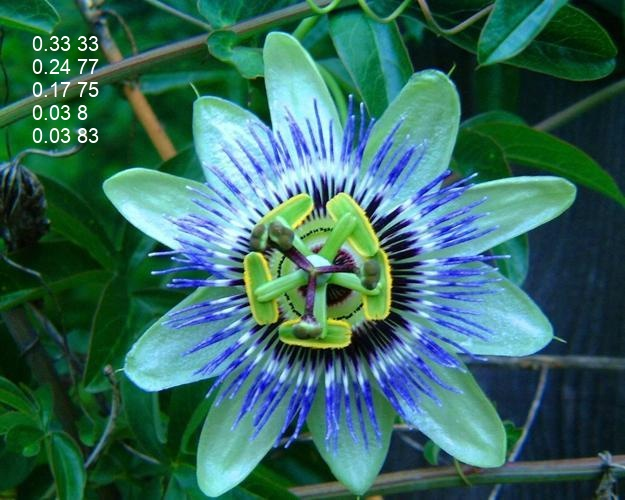

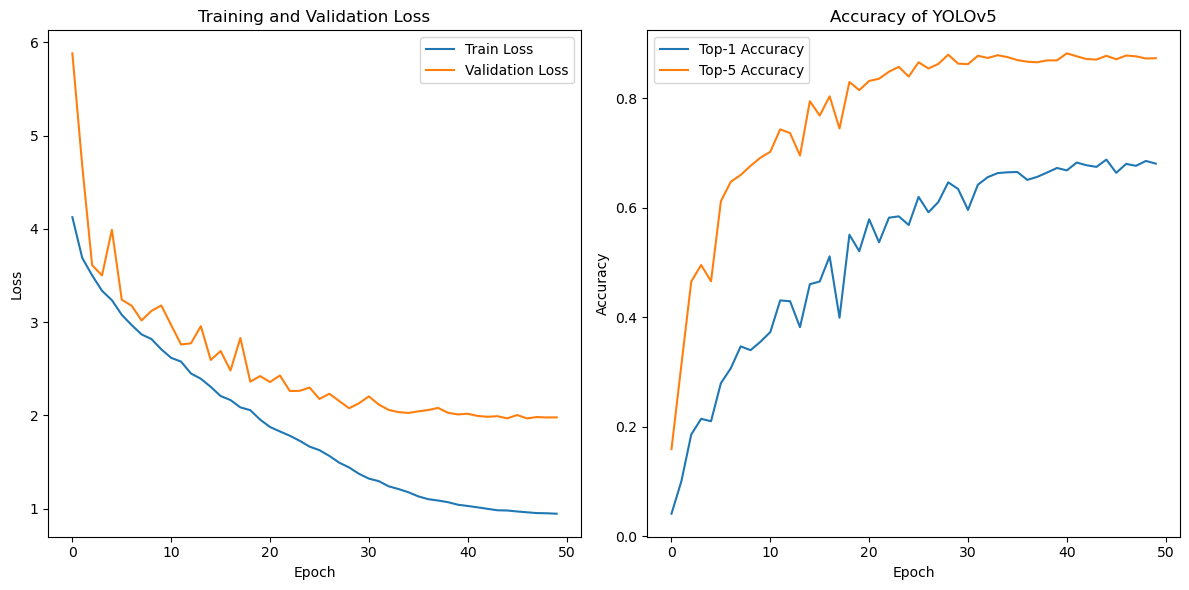

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert data to DataFrame
df = pd.read_csv('/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/results.csv', header=0)
df.columns = df.columns.str.strip()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training and Validation Loss
ax1.plot(df['epoch'], df['train/loss'], label='Train Loss')
ax1.plot(df['epoch'], df['val/loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Top-1 and Top-5 Accuracy
ax2.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy')
ax2.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy')
ax2.set_title('Accuracy of YOLOv5')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'custom', '/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt')
print(model)

Using cache found in /home/roeiza/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-20 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


DetectMultiBackend(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 